In [1]:
!mkdir result
!mkdir images
!mkdir images/misclassified

In [2]:
import os
import numpy as np
import threading as th
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import sklearn.metrics as metric
from keras import models, layers
from keras.utils import image_dataset_from_directory as IDFD
from sklearn.metrics import ConfusionMatrixDisplay as CMD, classification_report

from keras.applications import (DenseNet201)

2024-02-21 13:45:23.088974: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 13:45:23.089076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 13:45:23.228952: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# test for GPU use in tensorflow
physical_gpus = tf.config.list_physical_devices('GPU')
print(physical_gpus)

# define variables and constants
IMAGE_SIZE = (176, 208)
BATCH_SIZE = 32
EPOCHS = 30

BASE_DIR = './'
IMAGE_DIR = BASE_DIR + 'images/'
MODEL_DIR = BASE_DIR + 'models/'
RESULTS_DIR = BASE_DIR + 'result/'
DATASET_DIR = "/kaggle/input/Alzheimer_s Dataset/"
USE_CPU = False

if USE_CPU:
    tf.config.set_visible_devices([], 'GPU')

print("Tensorflow version", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Tensorflow version 2.15.0


In [4]:
class_names = [filename for filename in os.listdir(DATASET_DIR+'train')]
class_names

['ModerateDemented', 'NonDemented', 'VeryMildDemented', 'MildDemented']

In [5]:
def load(directory, image_size, batch_size, verbose=False):
    class_names = ["Mild_Demented", "Moderate_Demented", "Non_Demented", "Very_Mild_Demented"]
    train_ds = IDFD(directory+"train",
                    seed=7891,
                    validation_split=0.13,
                    subset="training",
                    labels="inferred",
                    label_mode="categorical",
                    interpolation="bilinear",
                    image_size=image_size,
                    batch_size=batch_size,
                    color_mode='rgb')

    test_ds = IDFD(directory+"train",
                   seed=7891,
                   validation_split=0.13,
                   subset="validation",
                   labels="inferred",
                   label_mode="categorical",
                   interpolation="bilinear",
                   image_size=image_size,
                   batch_size=batch_size,
                   color_mode='rgb')

    val_ds = IDFD(directory+"test",
                  seed=7891,
                  labels="inferred",
                  label_mode="categorical",
                  interpolation="bilinear",
                  image_size=image_size,
                  batch_size=batch_size,
                  color_mode='rgb',
                  shuffle=False)

    if verbose:
        train = np.concatenate([np.argmax(l,axis=1) for x,l in train_ds], axis=0)
        val = np.concatenate([np.argmax(l,axis=1) for x,l in val_ds], axis=0)
        test = np.concatenate([np.argmax(l,axis=1) for x,l in test_ds], axis=0)

        print()
        print("Summary:")
        print("--------------------------------")
        print()
        print("Dataset Classes: ", class_names)
        print()
        print("Dataset split:")
        print("--------------------------------")
        print("Using ", len(train), " files for training")
        print("Using ", len(val), " files for validation")
        print("Using ", len(test), " files for testing")
        print()
        print("Images per label in each set:")
        print("--------------------------------")

        print("Training: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(train==i), c)

        print("Validation: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(val==i), c)

        print("Test: ")
        for i,c in enumerate(class_names):
            print("   ", np.count_nonzero(test==i), c)

        # show sample images
        plt.figure(figsize=(10, 10))
        for images, labels in train_ds.take(1):
            for i in range(9):
                ax = plt.subplot(3, 3, i + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[np.argmax(labels[i])])
                plt.axis("off")

    return train_ds, val_ds, test_ds, class_names

In [6]:
# plot loss and accuracy graphics

def draw_loss_acc_graphics(outfile, history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    plt.figure()
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'c', label='Validation acc')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.savefig(outfile + '_accuracy_graph.pdf')
    plt.close()

    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'c', label='Validation loss')
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.savefig(outfile + '_loss_graph.pdf')
    plt.close()

# evaluate model with test set

def process_tests(model, test_ds):
    y_true = np.array([], dtype=np.int32)
    y_pred = np.array([], dtype=np.int32)
    images = []

    for image_batch, labels in test_ds:
        y_true = np.concatenate([y_true, np.argmax(labels.numpy(), axis=-1)])
        y_pred = np.concatenate([y_pred, np.argmax(model.predict(image_batch,verbose=0), axis=-1)])
        for img in image_batch:
            images.append(img)

    size_test = sum([len(l) for _,l in test_ds])
    images = np.reshape(images, (size_test,176,208,3))

    return y_true, y_pred, images

def draw_confusion_matrix(outfile, model, test_ds, class_names):

    # plot confusion matrix
    y_true, y_pred, images = process_tests(model, test_ds)
    plt.figure(figsize=(5, 5))
    cmap = plt.cm.Blues #'viridis'

    # save confusion matrix with classification percentage
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap, labels=range(len(class_names)),
                              display_labels=class_names, normalize="pred")
    #plt.tight_layout()
    ax = plt.gca()
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=90, ha="center", rotation_mode="anchor")
    plt.savefig(outfile + '_cm.pdf')

    # save confusion matrix with number of samples
    cm = CMD.from_predictions(y_true, y_pred, cmap=cmap,
                              labels=range(len(class_names)),display_labels=class_names)
    plt.savefig(outfile + '_cm2.pdf')
    plt.close()

    # calculate accuracy, precision, recall and F1-score
    accuracy = metric.accuracy_score(y_true, y_pred)
    precision = metric.precision_score(y_true, y_pred, average="macro", zero_division=1)
    recall = metric.recall_score(y_true, y_pred, average="macro")
    f1 = metric.f1_score(y_true, y_pred, average="macro", zero_division=1)
    print('Accuracy | Precision | Recall | F1 score')
    print(accuracy, precision, recall, f1)
    print(metric.precision_recall_fscore_support(y_true, y_pred, average="macro"))

    report = classification_report(
        y_true, y_pred, labels=range(len(class_names)),
        target_names=class_names
    )
    print(report)

    return precision, recall, f1, report

In [7]:
def save_misclassified_images(outfile, model, test_ds, class_names, n_images=3):

    # save incorrectly classified test images
    y_true, y_pred, images = process_tests(model, test_ds)

    a = np.array(y_true) == np.array(y_pred)
    plt.figure()
    ax=plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    j=0
    for i in range(len(a)):
        if not a[i] and j<n_images:
            j=j+1
            plt.imshow(np.array(images[i]).astype("uint8"))
            plt.title(class_names[y_true[i]] + " - " + class_names[y_pred[i]])
            plt.savefig(outfile + '_misclassified_' + str(j) + '.pdf')
    plt.close()

def save_results(filename, model, train_ds, val_ds,
                 test_ds, class_names, history):
    # loss-accuracy graphics
    draw_loss_acc_graphics(IMAGE_DIR+filename, history)

    # confusion matrix
    precision, recall, f1, report = draw_confusion_matrix(IMAGE_DIR+filename, model, test_ds, class_names)

    # misclassified images
    save_misclassified_images(IMAGE_DIR+'misclassified/'+filename, model, test_ds, class_names)

    # save results to file
    train_loss, train_acc = model.evaluate(train_ds)
    val_loss, val_acc     = model.evaluate(val_ds)
    test_loss, test_acc   = model.evaluate(test_ds)

    with open(RESULTS_DIR+filename+'.txt', 'w') as f:
        f.write("Training loss/accuracy: " + str(train_loss) + ', ' + str(train_acc) + '\n')
        f.write("Validate loss/accuracy: " + str(val_loss) + ', ' + str(val_acc) + '\n')
        f.write("Testing  loss/accuracy: " + str(test_loss) + ', ' + str(test_acc) + '\n')
        f.write("Precision: " + str(precision) + '\n')
        f.write("Recall: " + str(recall) + '\n')
        f.write("F1: " + str(f1) + '\n')
        f.write(report + '\n')


In [8]:
# this module creates objects of the different models

def build_cnn_model(model, num_classes,
                    transfer_learning, batch_size):
    weights = None
    trainable = True
    include_top = True
    
    if transfer_learning:
        weights = "imagenet"
        trainable = False
        include_top = False


    model.add(DenseNet201(weights=weights, include_top=include_top,
                                 input_shape=(176,208,3),classes=num_classes))


    model.layers[-1].trainable = trainable

    return model


def create_model(num_classes, data_augmentation, transfer_learning, batch_size=32):
    # base model
    model = models.Sequential()
    model.add(layers.Input(shape=(176,208,3)))

    # data augmentation
    if data_augmentation:
        model.add(layers.RandomFlip("horizontal"))
        model.add(layers.RandomRotation(0.1, fill_mode='constant',fill_value=-1.0))
        model.add(layers.RandomZoom((-0.2,0.2), fill_mode='constant',fill_value=-1.0))

    model = build_cnn_model(model, num_classes,
                            transfer_learning, batch_size)

    # MLP on top
    if transfer_learning:
        model.add(layers.Flatten())
        model.add(layers.Dropout(0.5))
        model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(loss="categorical_crossentropy",
                  optimizer="adam", metrics=["accuracy"])

    return model

In [9]:
def run_experiments(train_ds, val_ds, test_ds, class_names,
                    epochs, s="", data_augmentation=False, transfer_learning=False):
    
    model = create_model(len(class_names), data_augmentation, transfer_learning, BATCH_SIZE)

    model.summary()

    history = model.fit(train_ds,
                        epochs=epochs,
                        validation_data=val_ds,
                        verbose=1)

    model.save("DenseNet201"+s+".keras")
    

    # save model to disk
    filename = "DenseNet201" + '_' + s

    # save results and graphics to disk
    save_results(filename, model, train_ds,
                 val_ds, test_ds, class_names, history)
        

def experiments_with_dataset(train_ds, val_ds, test_ds, class_names):

    print("Number of classes", len(class_names))

    # training from scratch
    print('  ## training from scratch')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_scratch", data_augmentation=False, transfer_learning=False)

    # using data augmentation
    print('  ## training with data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_da", data_augmentation=True, transfer_learning=False)

    # using transfer learning
    print('  ## training with transfer learning')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS,
                    s="_tl", data_augmentation=False, transfer_learning=True)
            
    # using transfer learning and data augmentation
    print('  ## training with transfer learning and data augmentation')
    run_experiments(train_ds, val_ds, test_ds, class_names, EPOCHS, 
                    s="_datl", data_augmentation=True, transfer_learning=True)



Processing Alzihmers Dataset:
--------------------------------


Found 5121 files belonging to 4 classes.


Using 4456 files for training.


Found 5121 files belonging to 4 classes.


Using 665 files for validation.


Found 1279 files belonging to 4 classes.


Number of classes 4
  ## training from scratch


Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 densenet201 (Functional)    (None, 4)                 18329668  


Total params: 18329668 (69.92 MB)


Trainable params: 18100612 (69.05 MB)


Non-trainable params: 229056 (894.75 KB)


_________________________________________________________________


Epoch 1/30


I0000 00:00:1708523213.864800      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/140 [..............................] - ETA: 4:33:09 - loss: 1.3393 - accuracy: 0.2500

  2/140 [..............................] - ETA: 33s - loss: 1.3772 - accuracy: 0.3906    

  3/140 [..............................] - ETA: 32s - loss: 1.3553 - accuracy: 0.4271

  4/140 [..............................] - ETA: 32s - loss: 1.2564 - accuracy: 0.4453

  5/140 [>.............................] - ETA: 32s - loss: 1.3384 - accuracy: 0.4563

  6/140 [>.............................] - ETA: 31s - loss: 1.3076 - accuracy: 0.4688

  7/140 [>.............................] - ETA: 31s - loss: 1.4222 - accuracy: 0.4509

  8/140 [>.............................] - ETA: 31s - loss: 1.4802 - accuracy: 0.4375

  9/140 [>.............................] - ETA: 30s - loss: 1.4225 - accuracy: 0.4583

 10/140 [=>............................] - ETA: 30s - loss: 1.3870 - accuracy: 0.4500

 11/140 [=>............................] - ETA: 30s - loss: 1.3547 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 30s - loss: 1.3773 - accuracy: 0.4401

 13/140 [=>............................] - ETA: 30s - loss: 1.3363 - accuracy: 0.4567

 14/140 [==>...........................] - ETA: 29s - loss: 1.3128 - accuracy: 0.4576

 15/140 [==>...........................] - ETA: 29s - loss: 1.3115 - accuracy: 0.4646

 16/140 [==>...........................] - ETA: 29s - loss: 1.2806 - accuracy: 0.4668

 17/140 [==>...........................] - ETA: 29s - loss: 1.2824 - accuracy: 0.4688

 18/140 [==>...........................] - ETA: 28s - loss: 1.2585 - accuracy: 0.4757

 19/140 [===>..........................] - ETA: 28s - loss: 1.2415 - accuracy: 0.4803

 20/140 [===>..........................] - ETA: 28s - loss: 1.2637 - accuracy: 0.4766

 21/140 [===>..........................] - ETA: 28s - loss: 1.2713 - accuracy: 0.4732

 22/140 [===>..........................] - ETA: 27s - loss: 1.2671 - accuracy: 0.4730

 23/140 [===>..........................] - ETA: 27s - loss: 1.2506 - accuracy: 0.4755

 24/140 [====>.........................] - ETA: 27s - loss: 1.2552 - accuracy: 0.4688

 25/140 [====>.........................] - ETA: 27s - loss: 1.2503 - accuracy: 0.4700

 26/140 [====>.........................] - ETA: 26s - loss: 1.2446 - accuracy: 0.4700

 27/140 [====>.........................] - ETA: 26s - loss: 1.2285 - accuracy: 0.4745

 28/140 [=====>........................] - ETA: 26s - loss: 1.2155 - accuracy: 0.4777

 29/140 [=====>........................] - ETA: 26s - loss: 1.2029 - accuracy: 0.4795

 30/140 [=====>........................] - ETA: 25s - loss: 1.1897 - accuracy: 0.4844

 31/140 [=====>........................] - ETA: 25s - loss: 1.1766 - accuracy: 0.4889

 32/140 [=====>........................] - ETA: 25s - loss: 1.1756 - accuracy: 0.4902

 33/140 [======>.......................] - ETA: 25s - loss: 1.1673 - accuracy: 0.4924

 34/140 [======>.......................] - ETA: 25s - loss: 1.1720 - accuracy: 0.4862

 35/140 [======>.......................] - ETA: 24s - loss: 1.1690 - accuracy: 0.4848

 36/140 [======>.......................] - ETA: 24s - loss: 1.1618 - accuracy: 0.4878

 37/140 [======>.......................] - ETA: 24s - loss: 1.1572 - accuracy: 0.4899

 38/140 [=======>......................] - ETA: 24s - loss: 1.1551 - accuracy: 0.4877

 39/140 [=======>......................] - ETA: 23s - loss: 1.1539 - accuracy: 0.4856

 40/140 [=======>......................] - ETA: 23s - loss: 1.1514 - accuracy: 0.4828

 41/140 [=======>......................] - ETA: 23s - loss: 1.1484 - accuracy: 0.4809

 42/140 [========>.....................] - ETA: 23s - loss: 1.1410 - accuracy: 0.4836

 43/140 [========>.....................] - ETA: 22s - loss: 1.1334 - accuracy: 0.4891

 44/140 [========>.....................] - ETA: 22s - loss: 1.1256 - accuracy: 0.4929

 45/140 [========>.....................] - ETA: 22s - loss: 1.1294 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 22s - loss: 1.1298 - accuracy: 0.4973

 47/140 [=========>....................] - ETA: 21s - loss: 1.1258 - accuracy: 0.4987

 48/140 [=========>....................] - ETA: 21s - loss: 1.1197 - accuracy: 0.5007

 49/140 [=========>....................] - ETA: 21s - loss: 1.1180 - accuracy: 0.4994

 50/140 [=========>....................] - ETA: 21s - loss: 1.1129 - accuracy: 0.5013

 51/140 [=========>....................] - ETA: 20s - loss: 1.1077 - accuracy: 0.5031

 52/140 [==========>...................] - ETA: 20s - loss: 1.1012 - accuracy: 0.5054

 53/140 [==========>...................] - ETA: 20s - loss: 1.0943 - accuracy: 0.5088

 54/140 [==========>...................] - ETA: 20s - loss: 1.0892 - accuracy: 0.5110

 55/140 [==========>...................] - ETA: 20s - loss: 1.0846 - accuracy: 0.5136

 56/140 [===========>..................] - ETA: 19s - loss: 1.0796 - accuracy: 0.5145

 57/140 [===========>..................] - ETA: 19s - loss: 1.0746 - accuracy: 0.5181

 58/140 [===========>..................] - ETA: 19s - loss: 1.0704 - accuracy: 0.5194

 59/140 [===========>..................] - ETA: 19s - loss: 1.0704 - accuracy: 0.5180

 60/140 [===========>..................] - ETA: 18s - loss: 1.0687 - accuracy: 0.5193

 61/140 [============>.................] - ETA: 18s - loss: 1.0649 - accuracy: 0.5220

 62/140 [============>.................] - ETA: 18s - loss: 1.0613 - accuracy: 0.5227

 63/140 [============>.................] - ETA: 18s - loss: 1.0564 - accuracy: 0.5253

 64/140 [============>.................] - ETA: 17s - loss: 1.0513 - accuracy: 0.5283

 65/140 [============>.................] - ETA: 17s - loss: 1.0516 - accuracy: 0.5303

 66/140 [=============>................] - ETA: 17s - loss: 1.0482 - accuracy: 0.5312

 67/140 [=============>................] - ETA: 17s - loss: 1.0475 - accuracy: 0.5308

 68/140 [=============>................] - ETA: 16s - loss: 1.0570 - accuracy: 0.5290

 69/140 [=============>................] - ETA: 16s - loss: 1.0547 - accuracy: 0.5290

 70/140 [==============>...............] - ETA: 16s - loss: 1.0570 - accuracy: 0.5286

 71/140 [==============>...............] - ETA: 16s - loss: 1.0598 - accuracy: 0.5273

 72/140 [==============>...............] - ETA: 16s - loss: 1.0564 - accuracy: 0.5295

 73/140 [==============>...............] - ETA: 15s - loss: 1.0508 - accuracy: 0.5330

 74/140 [==============>...............] - ETA: 15s - loss: 1.0469 - accuracy: 0.5346

 75/140 [===============>..............] - ETA: 15s - loss: 1.0459 - accuracy: 0.5346

 76/140 [===============>..............] - ETA: 15s - loss: 1.0470 - accuracy: 0.5333

 77/140 [===============>..............] - ETA: 14s - loss: 1.0439 - accuracy: 0.5345

 78/140 [===============>..............] - ETA: 14s - loss: 1.0410 - accuracy: 0.5345

 79/140 [===============>..............] - ETA: 14s - loss: 1.0440 - accuracy: 0.5328

 80/140 [================>.............] - ETA: 14s - loss: 1.0419 - accuracy: 0.5328

 81/140 [================>.............] - ETA: 13s - loss: 1.0399 - accuracy: 0.5332

 82/140 [================>.............] - ETA: 13s - loss: 1.0380 - accuracy: 0.5328

 83/140 [================>.............] - ETA: 13s - loss: 1.0379 - accuracy: 0.5320

 84/140 [=================>............] - ETA: 13s - loss: 1.0396 - accuracy: 0.5320

 85/140 [=================>............] - ETA: 12s - loss: 1.0377 - accuracy: 0.5331

 86/140 [=================>............] - ETA: 12s - loss: 1.0350 - accuracy: 0.5345

 87/140 [=================>............] - ETA: 12s - loss: 1.0342 - accuracy: 0.5352

 88/140 [=================>............] - ETA: 12s - loss: 1.0334 - accuracy: 0.5362

 89/140 [==================>...........] - ETA: 12s - loss: 1.0343 - accuracy: 0.5351

 90/140 [==================>...........] - ETA: 11s - loss: 1.0321 - accuracy: 0.5372

 91/140 [==================>...........] - ETA: 11s - loss: 1.0289 - accuracy: 0.5391

 92/140 [==================>...........] - ETA: 11s - loss: 1.0280 - accuracy: 0.5387

 93/140 [==================>...........] - ETA: 11s - loss: 1.0250 - accuracy: 0.5410

 94/140 [===================>..........] - ETA: 10s - loss: 1.0233 - accuracy: 0.5406

 95/140 [===================>..........] - ETA: 10s - loss: 1.0229 - accuracy: 0.5401

 96/140 [===================>..........] - ETA: 10s - loss: 1.0199 - accuracy: 0.5410

 97/140 [===================>..........] - ETA: 10s - loss: 1.0187 - accuracy: 0.5409

 98/140 [====================>.........] - ETA: 9s - loss: 1.0198 - accuracy: 0.5389 

 99/140 [====================>.........] - ETA: 9s - loss: 1.0167 - accuracy: 0.5401

100/140 [====================>.........] - ETA: 9s - loss: 1.0154 - accuracy: 0.5409

101/140 [====================>.........] - ETA: 9s - loss: 1.0141 - accuracy: 0.5418

102/140 [====================>.........] - ETA: 8s - loss: 1.0124 - accuracy: 0.5420

103/140 [=====================>........] - ETA: 8s - loss: 1.0105 - accuracy: 0.5425

104/140 [=====================>........] - ETA: 8s - loss: 1.0095 - accuracy: 0.5433

105/140 [=====================>........] - ETA: 8s - loss: 1.0084 - accuracy: 0.5435

106/140 [=====================>........] - ETA: 8s - loss: 1.0070 - accuracy: 0.5442

107/140 [=====================>........] - ETA: 7s - loss: 1.0043 - accuracy: 0.5456

108/140 [======================>.......] - ETA: 7s - loss: 1.0029 - accuracy: 0.5454

109/140 [======================>.......] - ETA: 7s - loss: 1.0031 - accuracy: 0.5462

110/140 [======================>.......] - ETA: 7s - loss: 1.0022 - accuracy: 0.5455

111/140 [======================>.......] - ETA: 6s - loss: 1.0019 - accuracy: 0.5459

112/140 [=======================>......] - ETA: 6s - loss: 1.0012 - accuracy: 0.5460

113/140 [=======================>......] - ETA: 6s - loss: 0.9983 - accuracy: 0.5473

114/140 [=======================>......] - ETA: 6s - loss: 0.9967 - accuracy: 0.5474

115/140 [=======================>......] - ETA: 5s - loss: 0.9966 - accuracy: 0.5473

116/140 [=======================>......] - ETA: 5s - loss: 0.9947 - accuracy: 0.5474

117/140 [========================>.....] - ETA: 5s - loss: 0.9939 - accuracy: 0.5489

118/140 [========================>.....] - ETA: 5s - loss: 0.9929 - accuracy: 0.5487

119/140 [========================>.....] - ETA: 4s - loss: 0.9913 - accuracy: 0.5494

120/140 [========================>.....] - ETA: 4s - loss: 0.9917 - accuracy: 0.5484

121/140 [========================>.....] - ETA: 4s - loss: 0.9897 - accuracy: 0.5488

122/140 [=========================>....] - ETA: 4s - loss: 0.9878 - accuracy: 0.5502

123/140 [=========================>....] - ETA: 4s - loss: 0.9850 - accuracy: 0.5518

124/140 [=========================>....] - ETA: 3s - loss: 0.9838 - accuracy: 0.5522

125/140 [=========================>....] - ETA: 3s - loss: 0.9823 - accuracy: 0.5520

126/140 [==========================>...] - ETA: 3s - loss: 0.9809 - accuracy: 0.5523

127/140 [==========================>...] - ETA: 3s - loss: 0.9810 - accuracy: 0.5517

128/140 [==========================>...] - ETA: 2s - loss: 0.9798 - accuracy: 0.5530

129/140 [==========================>...] - ETA: 2s - loss: 0.9784 - accuracy: 0.5540

130/140 [==========================>...] - ETA: 2s - loss: 0.9785 - accuracy: 0.5543

131/140 [===========================>..] - ETA: 2s - loss: 0.9770 - accuracy: 0.5553

132/140 [===========================>..] - ETA: 1s - loss: 0.9772 - accuracy: 0.5559

133/140 [===========================>..] - ETA: 1s - loss: 0.9770 - accuracy: 0.5557

134/140 [===========================>..] - ETA: 1s - loss: 0.9758 - accuracy: 0.5562

135/140 [===========================>..] - ETA: 1s - loss: 0.9748 - accuracy: 0.5565

136/140 [============================>.] - ETA: 0s - loss: 0.9762 - accuracy: 0.5549

137/140 [============================>.] - ETA: 0s - loss: 0.9747 - accuracy: 0.5561

138/140 [============================>.] - ETA: 0s - loss: 0.9737 - accuracy: 0.5562

139/140 [============================>.] - ETA: 0s - loss: 0.9738 - accuracy: 0.5558

140/140 [==============================] - ETA: 0s - loss: 0.9734 - accuracy: 0.5563

140/140 [==============================] - 168s 363ms/step - loss: 0.9734 - accuracy: 0.5563 - val_loss: 36.3906 - val_accuracy: 0.5176


Epoch 2/30


  1/140 [..............................] - ETA: 53s - loss: 0.8086 - accuracy: 0.6562

  2/140 [..............................] - ETA: 32s - loss: 0.8592 - accuracy: 0.5625

  3/140 [..............................] - ETA: 32s - loss: 0.8399 - accuracy: 0.5729

  4/140 [..............................] - ETA: 32s - loss: 0.8679 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 32s - loss: 0.8735 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 31s - loss: 0.9176 - accuracy: 0.5885

  7/140 [>.............................] - ETA: 31s - loss: 0.9170 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 31s - loss: 0.8993 - accuracy: 0.5703

  9/140 [>.............................] - ETA: 31s - loss: 0.8920 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 30s - loss: 0.8960 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 30s - loss: 0.8912 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 30s - loss: 0.8794 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 30s - loss: 0.8897 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 29s - loss: 0.8900 - accuracy: 0.5692

 15/140 [==>...........................] - ETA: 29s - loss: 0.8916 - accuracy: 0.5667

 16/140 [==>...........................] - ETA: 29s - loss: 0.8772 - accuracy: 0.5801

 17/140 [==>...........................] - ETA: 29s - loss: 0.8681 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 28s - loss: 0.8743 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 28s - loss: 0.8815 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 28s - loss: 0.8874 - accuracy: 0.5734

 21/140 [===>..........................] - ETA: 28s - loss: 0.8785 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 28s - loss: 0.8708 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 27s - loss: 0.8746 - accuracy: 0.5774

 24/140 [====>.........................] - ETA: 27s - loss: 0.8703 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 27s - loss: 0.8769 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 27s - loss: 0.8761 - accuracy: 0.5745

 27/140 [====>.........................] - ETA: 26s - loss: 0.8771 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 26s - loss: 0.8755 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 26s - loss: 0.8737 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 26s - loss: 0.8707 - accuracy: 0.5750

 31/140 [=====>........................] - ETA: 25s - loss: 0.8776 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 25s - loss: 0.8868 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 25s - loss: 0.8884 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 25s - loss: 0.8939 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 24s - loss: 0.8922 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 24s - loss: 0.8897 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 24s - loss: 0.8864 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 24s - loss: 0.8831 - accuracy: 0.5732

 39/140 [=======>......................] - ETA: 23s - loss: 0.8858 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 23s - loss: 0.8828 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 23s - loss: 0.8814 - accuracy: 0.5762

 42/140 [========>.....................] - ETA: 23s - loss: 0.8857 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 23s - loss: 0.8846 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 22s - loss: 0.8793 - accuracy: 0.5774

 45/140 [========>.....................] - ETA: 22s - loss: 0.8858 - accuracy: 0.5764

 46/140 [========>.....................] - ETA: 22s - loss: 0.8817 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 22s - loss: 0.8833 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 21s - loss: 0.8832 - accuracy: 0.5788

 49/140 [=========>....................] - ETA: 21s - loss: 0.8806 - accuracy: 0.5791

 50/140 [=========>....................] - ETA: 21s - loss: 0.8793 - accuracy: 0.5781

 51/140 [=========>....................] - ETA: 21s - loss: 0.8799 - accuracy: 0.5784

 52/140 [==========>...................] - ETA: 20s - loss: 0.8811 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 20s - loss: 0.8780 - accuracy: 0.5772

 54/140 [==========>...................] - ETA: 20s - loss: 0.8764 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 20s - loss: 0.8789 - accuracy: 0.5773

 56/140 [===========>..................] - ETA: 19s - loss: 0.8791 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 19s - loss: 0.8793 - accuracy: 0.5746

 58/140 [===========>..................] - ETA: 19s - loss: 0.8766 - accuracy: 0.5765

 59/140 [===========>..................] - ETA: 19s - loss: 0.8762 - accuracy: 0.5768

 60/140 [===========>..................] - ETA: 18s - loss: 0.8727 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 18s - loss: 0.8725 - accuracy: 0.5774

 62/140 [============>.................] - ETA: 18s - loss: 0.8702 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 18s - loss: 0.8746 - accuracy: 0.5769

 64/140 [============>.................] - ETA: 18s - loss: 0.8741 - accuracy: 0.5781

 65/140 [============>.................] - ETA: 17s - loss: 0.8790 - accuracy: 0.5764

 66/140 [=============>................] - ETA: 17s - loss: 0.8812 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 17s - loss: 0.8800 - accuracy: 0.5770

 68/140 [=============>................] - ETA: 17s - loss: 0.8807 - accuracy: 0.5763

 69/140 [=============>................] - ETA: 16s - loss: 0.8795 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 16s - loss: 0.8791 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 16s - loss: 0.8764 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 16s - loss: 0.8760 - accuracy: 0.5777

 73/140 [==============>...............] - ETA: 15s - loss: 0.8742 - accuracy: 0.5788

 74/140 [==============>...............] - ETA: 15s - loss: 0.8752 - accuracy: 0.5781

 75/140 [===============>..............] - ETA: 15s - loss: 0.8828 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 15s - loss: 0.8850 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 14s - loss: 0.8835 - accuracy: 0.5775

 78/140 [===============>..............] - ETA: 14s - loss: 0.8828 - accuracy: 0.5769

 79/140 [===============>..............] - ETA: 14s - loss: 0.8812 - accuracy: 0.5775

 80/140 [================>.............] - ETA: 14s - loss: 0.8819 - accuracy: 0.5770

 81/140 [================>.............] - ETA: 14s - loss: 0.8802 - accuracy: 0.5775

 82/140 [================>.............] - ETA: 13s - loss: 0.8791 - accuracy: 0.5781

 83/140 [================>.............] - ETA: 13s - loss: 0.8779 - accuracy: 0.5783

 84/140 [=================>............] - ETA: 13s - loss: 0.8771 - accuracy: 0.5789

 85/140 [=================>............] - ETA: 13s - loss: 0.8774 - accuracy: 0.5798

 86/140 [=================>............] - ETA: 12s - loss: 0.8782 - accuracy: 0.5785

 87/140 [=================>............] - ETA: 12s - loss: 0.8781 - accuracy: 0.5794

 88/140 [=================>............] - ETA: 12s - loss: 0.8759 - accuracy: 0.5813

 89/140 [==================>...........] - ETA: 12s - loss: 0.8764 - accuracy: 0.5818

 90/140 [==================>...........] - ETA: 11s - loss: 0.8748 - accuracy: 0.5837

 91/140 [==================>...........] - ETA: 11s - loss: 0.8747 - accuracy: 0.5831

 92/140 [==================>...........] - ETA: 11s - loss: 0.8737 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 11s - loss: 0.8732 - accuracy: 0.5833

 94/140 [===================>..........] - ETA: 10s - loss: 0.8727 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 10s - loss: 0.8719 - accuracy: 0.5836

 96/140 [===================>..........] - ETA: 10s - loss: 0.8688 - accuracy: 0.5856

 97/140 [===================>..........] - ETA: 10s - loss: 0.8685 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 9s - loss: 0.8671 - accuracy: 0.5861 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8675 - accuracy: 0.5865

100/140 [====================>.........] - ETA: 9s - loss: 0.8678 - accuracy: 0.5863

101/140 [====================>.........] - ETA: 9s - loss: 0.8694 - accuracy: 0.5857

102/140 [====================>.........] - ETA: 9s - loss: 0.8692 - accuracy: 0.5852

103/140 [=====================>........] - ETA: 8s - loss: 0.8691 - accuracy: 0.5850

104/140 [=====================>........] - ETA: 8s - loss: 0.8680 - accuracy: 0.5859

105/140 [=====================>........] - ETA: 8s - loss: 0.8672 - accuracy: 0.5860

106/140 [=====================>........] - ETA: 8s - loss: 0.8653 - accuracy: 0.5870

107/140 [=====================>........] - ETA: 7s - loss: 0.8644 - accuracy: 0.5876

108/140 [======================>.......] - ETA: 7s - loss: 0.8632 - accuracy: 0.5880

109/140 [======================>.......] - ETA: 7s - loss: 0.8632 - accuracy: 0.5889

110/140 [======================>.......] - ETA: 7s - loss: 0.8635 - accuracy: 0.5895

111/140 [======================>.......] - ETA: 6s - loss: 0.8694 - accuracy: 0.5884

112/140 [=======================>......] - ETA: 6s - loss: 0.8676 - accuracy: 0.5896

113/140 [=======================>......] - ETA: 6s - loss: 0.8662 - accuracy: 0.5910

114/140 [=======================>......] - ETA: 6s - loss: 0.8656 - accuracy: 0.5929

115/140 [=======================>......] - ETA: 5s - loss: 0.8662 - accuracy: 0.5927

116/140 [=======================>......] - ETA: 5s - loss: 0.8678 - accuracy: 0.5905

117/140 [========================>.....] - ETA: 5s - loss: 0.8688 - accuracy: 0.5908

118/140 [========================>.....] - ETA: 5s - loss: 0.8671 - accuracy: 0.5914

119/140 [========================>.....] - ETA: 4s - loss: 0.8674 - accuracy: 0.5911

120/140 [========================>.....] - ETA: 4s - loss: 0.8679 - accuracy: 0.5898

121/140 [========================>.....] - ETA: 4s - loss: 0.8659 - accuracy: 0.5914

122/140 [=========================>....] - ETA: 4s - loss: 0.8704 - accuracy: 0.5902

123/140 [=========================>....] - ETA: 4s - loss: 0.8698 - accuracy: 0.5902

124/140 [=========================>....] - ETA: 3s - loss: 0.8696 - accuracy: 0.5905

125/140 [=========================>....] - ETA: 3s - loss: 0.8701 - accuracy: 0.5890

126/140 [==========================>...] - ETA: 3s - loss: 0.8718 - accuracy: 0.5880

127/140 [==========================>...] - ETA: 3s - loss: 0.8710 - accuracy: 0.5883

128/140 [==========================>...] - ETA: 2s - loss: 0.8719 - accuracy: 0.5874

129/140 [==========================>...] - ETA: 2s - loss: 0.8713 - accuracy: 0.5875

130/140 [==========================>...] - ETA: 2s - loss: 0.8722 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 2s - loss: 0.8727 - accuracy: 0.5859

132/140 [===========================>..] - ETA: 1s - loss: 0.8718 - accuracy: 0.5859

133/140 [===========================>..] - ETA: 1s - loss: 0.8710 - accuracy: 0.5867

134/140 [===========================>..] - ETA: 1s - loss: 0.8701 - accuracy: 0.5875

135/140 [===========================>..] - ETA: 1s - loss: 0.8688 - accuracy: 0.5884

136/140 [============================>.] - ETA: 0s - loss: 0.8685 - accuracy: 0.5882

137/140 [============================>.] - ETA: 0s - loss: 0.8693 - accuracy: 0.5885

138/140 [============================>.] - ETA: 0s - loss: 0.8678 - accuracy: 0.5888

139/140 [============================>.] - ETA: 0s - loss: 0.8662 - accuracy: 0.5895

140/140 [==============================] - ETA: 0s - loss: 0.8676 - accuracy: 0.5891

140/140 [==============================] - 36s 257ms/step - loss: 0.8676 - accuracy: 0.5891 - val_loss: 8.6346 - val_accuracy: 0.5192


Epoch 3/30


  1/140 [..............................] - ETA: 51s - loss: 0.6458 - accuracy: 0.7188

  2/140 [..............................] - ETA: 32s - loss: 0.8561 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.9718 - accuracy: 0.5625

  4/140 [..............................] - ETA: 32s - loss: 0.9247 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 32s - loss: 0.9285 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 32s - loss: 0.9346 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 31s - loss: 0.9798 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 31s - loss: 0.9869 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 31s - loss: 0.9584 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 30s - loss: 0.9314 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 30s - loss: 0.9360 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 30s - loss: 0.9380 - accuracy: 0.5938

 13/140 [=>............................] - ETA: 30s - loss: 0.9390 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 29s - loss: 0.9390 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 29s - loss: 0.9421 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 29s - loss: 0.9356 - accuracy: 0.5781

 17/140 [==>...........................] - ETA: 29s - loss: 0.9306 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 29s - loss: 0.9154 - accuracy: 0.5903

 19/140 [===>..........................] - ETA: 28s - loss: 0.9115 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 28s - loss: 0.9211 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 28s - loss: 0.9173 - accuracy: 0.5848

 22/140 [===>..........................] - ETA: 28s - loss: 0.9069 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 27s - loss: 0.9032 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 27s - loss: 0.8972 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 27s - loss: 0.8952 - accuracy: 0.5888

 26/140 [====>.........................] - ETA: 27s - loss: 0.8906 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 26s - loss: 0.8881 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 26s - loss: 0.8828 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 26s - loss: 0.8799 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 26s - loss: 0.8769 - accuracy: 0.5969

 31/140 [=====>........................] - ETA: 25s - loss: 0.8755 - accuracy: 0.5968

 32/140 [=====>........................] - ETA: 25s - loss: 0.8774 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 25s - loss: 0.8729 - accuracy: 0.5956

 34/140 [======>.......................] - ETA: 25s - loss: 0.8663 - accuracy: 0.5974

 35/140 [======>.......................] - ETA: 24s - loss: 0.8706 - accuracy: 0.5946

 36/140 [======>.......................] - ETA: 24s - loss: 0.8704 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 24s - loss: 0.8687 - accuracy: 0.5946

 38/140 [=======>......................] - ETA: 24s - loss: 0.8680 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 24s - loss: 0.8613 - accuracy: 0.5986

 40/140 [=======>......................] - ETA: 23s - loss: 0.8550 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 23s - loss: 0.8580 - accuracy: 0.6014

 42/140 [========>.....................] - ETA: 23s - loss: 0.8529 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 23s - loss: 0.8577 - accuracy: 0.5981

 44/140 [========>.....................] - ETA: 22s - loss: 0.8528 - accuracy: 0.5994

 45/140 [========>.....................] - ETA: 22s - loss: 0.8473 - accuracy: 0.6028

 46/140 [========>.....................] - ETA: 22s - loss: 0.8449 - accuracy: 0.6019

 47/140 [=========>....................] - ETA: 22s - loss: 0.8439 - accuracy: 0.6024

 48/140 [=========>....................] - ETA: 21s - loss: 0.8458 - accuracy: 0.6003

 49/140 [=========>....................] - ETA: 21s - loss: 0.8453 - accuracy: 0.6020

 50/140 [=========>....................] - ETA: 21s - loss: 0.8444 - accuracy: 0.6031

 51/140 [=========>....................] - ETA: 21s - loss: 0.8410 - accuracy: 0.6054

 52/140 [==========>...................] - ETA: 20s - loss: 0.8415 - accuracy: 0.6052

 53/140 [==========>...................] - ETA: 20s - loss: 0.8429 - accuracy: 0.6038

 54/140 [==========>...................] - ETA: 20s - loss: 0.8411 - accuracy: 0.6053

 55/140 [==========>...................] - ETA: 20s - loss: 0.8389 - accuracy: 0.6045

 56/140 [===========>..................] - ETA: 20s - loss: 0.8347 - accuracy: 0.6077

 57/140 [===========>..................] - ETA: 19s - loss: 0.8321 - accuracy: 0.6102

 58/140 [===========>..................] - ETA: 19s - loss: 0.8298 - accuracy: 0.6099

 59/140 [===========>..................] - ETA: 19s - loss: 0.8330 - accuracy: 0.6091

 60/140 [===========>..................] - ETA: 19s - loss: 0.8337 - accuracy: 0.6089

 61/140 [============>.................] - ETA: 18s - loss: 0.8302 - accuracy: 0.6101

 62/140 [============>.................] - ETA: 18s - loss: 0.8324 - accuracy: 0.6084

 63/140 [============>.................] - ETA: 18s - loss: 0.8363 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 18s - loss: 0.8386 - accuracy: 0.6060

 65/140 [============>.................] - ETA: 17s - loss: 0.8359 - accuracy: 0.6087

 66/140 [=============>................] - ETA: 17s - loss: 0.8312 - accuracy: 0.6122

 67/140 [=============>................] - ETA: 17s - loss: 0.8300 - accuracy: 0.6133

 68/140 [=============>................] - ETA: 17s - loss: 0.8278 - accuracy: 0.6144

 69/140 [=============>................] - ETA: 16s - loss: 0.8249 - accuracy: 0.6173

 70/140 [==============>...............] - ETA: 16s - loss: 0.8277 - accuracy: 0.6165

 71/140 [==============>...............] - ETA: 16s - loss: 0.8271 - accuracy: 0.6166

 72/140 [==============>...............] - ETA: 16s - loss: 0.8273 - accuracy: 0.6168

 73/140 [==============>...............] - ETA: 15s - loss: 0.8229 - accuracy: 0.6190

 74/140 [==============>...............] - ETA: 15s - loss: 0.8235 - accuracy: 0.6191

 75/140 [===============>..............] - ETA: 15s - loss: 0.8209 - accuracy: 0.6212

 76/140 [===============>..............] - ETA: 15s - loss: 0.8208 - accuracy: 0.6197

 77/140 [===============>..............] - ETA: 14s - loss: 0.8231 - accuracy: 0.6177

 78/140 [===============>..............] - ETA: 14s - loss: 0.8237 - accuracy: 0.6170

 79/140 [===============>..............] - ETA: 14s - loss: 0.8221 - accuracy: 0.6191

 80/140 [================>.............] - ETA: 14s - loss: 0.8250 - accuracy: 0.6172

 81/140 [================>.............] - ETA: 14s - loss: 0.8228 - accuracy: 0.6192

 82/140 [================>.............] - ETA: 13s - loss: 0.8205 - accuracy: 0.6212

 83/140 [================>.............] - ETA: 13s - loss: 0.8190 - accuracy: 0.6209

 84/140 [=================>............] - ETA: 13s - loss: 0.8212 - accuracy: 0.6205

 85/140 [=================>............] - ETA: 13s - loss: 0.8209 - accuracy: 0.6210

 86/140 [=================>............] - ETA: 12s - loss: 0.8201 - accuracy: 0.6203

 87/140 [=================>............] - ETA: 12s - loss: 0.8208 - accuracy: 0.6210

 88/140 [=================>............] - ETA: 12s - loss: 0.8199 - accuracy: 0.6218

 89/140 [==================>...........] - ETA: 12s - loss: 0.8179 - accuracy: 0.6236

 90/140 [==================>...........] - ETA: 11s - loss: 0.8184 - accuracy: 0.6229

 91/140 [==================>...........] - ETA: 11s - loss: 0.8182 - accuracy: 0.6236

 92/140 [==================>...........] - ETA: 11s - loss: 0.8179 - accuracy: 0.6243

 93/140 [==================>...........] - ETA: 11s - loss: 0.8153 - accuracy: 0.6260

 94/140 [===================>..........] - ETA: 10s - loss: 0.8168 - accuracy: 0.6253

 95/140 [===================>..........] - ETA: 10s - loss: 0.8159 - accuracy: 0.6260

 96/140 [===================>..........] - ETA: 10s - loss: 0.8160 - accuracy: 0.6273

 97/140 [===================>..........] - ETA: 10s - loss: 0.8141 - accuracy: 0.6285

 98/140 [====================>.........] - ETA: 9s - loss: 0.8134 - accuracy: 0.6288 

 99/140 [====================>.........] - ETA: 9s - loss: 0.8116 - accuracy: 0.6297

100/140 [====================>.........] - ETA: 9s - loss: 0.8104 - accuracy: 0.6294

101/140 [====================>.........] - ETA: 9s - loss: 0.8097 - accuracy: 0.6306

102/140 [====================>.........] - ETA: 9s - loss: 0.8094 - accuracy: 0.6299

103/140 [=====================>........] - ETA: 8s - loss: 0.8101 - accuracy: 0.6283

104/140 [=====================>........] - ETA: 8s - loss: 0.8086 - accuracy: 0.6286

105/140 [=====================>........] - ETA: 8s - loss: 0.8080 - accuracy: 0.6289

106/140 [=====================>........] - ETA: 8s - loss: 0.8083 - accuracy: 0.6282

107/140 [=====================>........] - ETA: 7s - loss: 0.8073 - accuracy: 0.6288

108/140 [======================>.......] - ETA: 7s - loss: 0.8096 - accuracy: 0.6276

109/140 [======================>.......] - ETA: 7s - loss: 0.8083 - accuracy: 0.6282

110/140 [======================>.......] - ETA: 7s - loss: 0.8061 - accuracy: 0.6298

111/140 [======================>.......] - ETA: 6s - loss: 0.8053 - accuracy: 0.6295

112/140 [=======================>......] - ETA: 6s - loss: 0.8054 - accuracy: 0.6306

113/140 [=======================>......] - ETA: 6s - loss: 0.8057 - accuracy: 0.6300

114/140 [=======================>......] - ETA: 6s - loss: 0.8049 - accuracy: 0.6299

115/140 [=======================>......] - ETA: 5s - loss: 0.8041 - accuracy: 0.6299

116/140 [=======================>......] - ETA: 5s - loss: 0.8024 - accuracy: 0.6304

117/140 [========================>.....] - ETA: 5s - loss: 0.8027 - accuracy: 0.6303

118/140 [========================>.....] - ETA: 5s - loss: 0.8013 - accuracy: 0.6314

119/140 [========================>.....] - ETA: 4s - loss: 0.8017 - accuracy: 0.6300

120/140 [========================>.....] - ETA: 4s - loss: 0.8029 - accuracy: 0.6299

121/140 [========================>.....] - ETA: 4s - loss: 0.8020 - accuracy: 0.6299

122/140 [=========================>....] - ETA: 4s - loss: 0.8014 - accuracy: 0.6304

123/140 [=========================>....] - ETA: 4s - loss: 0.8022 - accuracy: 0.6298

124/140 [=========================>....] - ETA: 3s - loss: 0.8027 - accuracy: 0.6295

125/140 [=========================>....] - ETA: 3s - loss: 0.8040 - accuracy: 0.6280

126/140 [==========================>...] - ETA: 3s - loss: 0.8059 - accuracy: 0.6270

127/140 [==========================>...] - ETA: 3s - loss: 0.8058 - accuracy: 0.6267

128/140 [==========================>...] - ETA: 2s - loss: 0.8066 - accuracy: 0.6257

129/140 [==========================>...] - ETA: 2s - loss: 0.8060 - accuracy: 0.6265

130/140 [==========================>...] - ETA: 2s - loss: 0.8053 - accuracy: 0.6264

131/140 [===========================>..] - ETA: 2s - loss: 0.8057 - accuracy: 0.6257

132/140 [===========================>..] - ETA: 1s - loss: 0.8057 - accuracy: 0.6250

133/140 [===========================>..] - ETA: 1s - loss: 0.8049 - accuracy: 0.6257

134/140 [===========================>..] - ETA: 1s - loss: 0.8046 - accuracy: 0.6252

135/140 [===========================>..] - ETA: 1s - loss: 0.8039 - accuracy: 0.6255

136/140 [============================>.] - ETA: 0s - loss: 0.8035 - accuracy: 0.6261

137/140 [============================>.] - ETA: 0s - loss: 0.8026 - accuracy: 0.6271

138/140 [============================>.] - ETA: 0s - loss: 0.8018 - accuracy: 0.6273

139/140 [============================>.] - ETA: 0s - loss: 0.8031 - accuracy: 0.6279

140/140 [==============================] - ETA: 0s - loss: 0.8043 - accuracy: 0.6272

140/140 [==============================] - 36s 257ms/step - loss: 0.8043 - accuracy: 0.6272 - val_loss: 3.7912 - val_accuracy: 0.1751


Epoch 4/30


  1/140 [..............................] - ETA: 51s - loss: 0.8476 - accuracy: 0.5312

  2/140 [..............................] - ETA: 33s - loss: 0.7872 - accuracy: 0.6250

  3/140 [..............................] - ETA: 32s - loss: 0.8675 - accuracy: 0.6042

  4/140 [..............................] - ETA: 32s - loss: 0.8582 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 32s - loss: 0.8617 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 31s - loss: 0.8360 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 31s - loss: 0.8397 - accuracy: 0.6027

  8/140 [>.............................] - ETA: 31s - loss: 0.8249 - accuracy: 0.6016

  9/140 [>.............................] - ETA: 31s - loss: 0.8225 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 30s - loss: 0.8302 - accuracy: 0.5969

 11/140 [=>............................] - ETA: 30s - loss: 0.8264 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 30s - loss: 0.8258 - accuracy: 0.6068

 13/140 [=>............................] - ETA: 30s - loss: 0.8280 - accuracy: 0.6034

 14/140 [==>...........................] - ETA: 29s - loss: 0.8300 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 29s - loss: 0.8204 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 29s - loss: 0.8095 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 29s - loss: 0.8121 - accuracy: 0.6140

 18/140 [==>...........................] - ETA: 28s - loss: 0.8099 - accuracy: 0.6146

 19/140 [===>..........................] - ETA: 28s - loss: 0.8234 - accuracy: 0.6020

 20/140 [===>..........................] - ETA: 28s - loss: 0.8236 - accuracy: 0.6047

 21/140 [===>..........................] - ETA: 28s - loss: 0.8261 - accuracy: 0.6071

 22/140 [===>..........................] - ETA: 28s - loss: 0.8226 - accuracy: 0.6122

 23/140 [===>..........................] - ETA: 27s - loss: 0.8183 - accuracy: 0.6128

 24/140 [====>.........................] - ETA: 27s - loss: 0.8136 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 27s - loss: 0.8077 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 27s - loss: 0.7980 - accuracy: 0.6238

 27/140 [====>.........................] - ETA: 26s - loss: 0.7997 - accuracy: 0.6250

 28/140 [=====>........................] - ETA: 26s - loss: 0.8026 - accuracy: 0.6261

 29/140 [=====>........................] - ETA: 26s - loss: 0.8009 - accuracy: 0.6261

 30/140 [=====>........................] - ETA: 26s - loss: 0.8096 - accuracy: 0.6219

 31/140 [=====>........................] - ETA: 25s - loss: 0.8094 - accuracy: 0.6210

 32/140 [=====>........................] - ETA: 25s - loss: 0.8157 - accuracy: 0.6172

 33/140 [======>.......................] - ETA: 25s - loss: 0.8149 - accuracy: 0.6193

 34/140 [======>.......................] - ETA: 25s - loss: 0.8149 - accuracy: 0.6204

 35/140 [======>.......................] - ETA: 24s - loss: 0.8132 - accuracy: 0.6232

 36/140 [======>.......................] - ETA: 24s - loss: 0.8121 - accuracy: 0.6224

 37/140 [======>.......................] - ETA: 24s - loss: 0.8093 - accuracy: 0.6242

 38/140 [=======>......................] - ETA: 24s - loss: 0.8144 - accuracy: 0.6192

 39/140 [=======>......................] - ETA: 24s - loss: 0.8075 - accuracy: 0.6250

 40/140 [=======>......................] - ETA: 23s - loss: 0.8063 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 23s - loss: 0.8033 - accuracy: 0.6227

 42/140 [========>.....................] - ETA: 23s - loss: 0.7962 - accuracy: 0.6287

 43/140 [========>.....................] - ETA: 23s - loss: 0.7979 - accuracy: 0.6301

 44/140 [========>.....................] - ETA: 22s - loss: 0.7967 - accuracy: 0.6307

 45/140 [========>.....................] - ETA: 22s - loss: 0.7995 - accuracy: 0.6285

 46/140 [========>.....................] - ETA: 22s - loss: 0.8011 - accuracy: 0.6298

 47/140 [=========>....................] - ETA: 22s - loss: 0.7980 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 21s - loss: 0.8000 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 21s - loss: 0.8047 - accuracy: 0.6256

 50/140 [=========>....................] - ETA: 21s - loss: 0.8061 - accuracy: 0.6250

 51/140 [=========>....................] - ETA: 21s - loss: 0.8017 - accuracy: 0.6256

 52/140 [==========>...................] - ETA: 20s - loss: 0.7999 - accuracy: 0.6262

 53/140 [==========>...................] - ETA: 20s - loss: 0.7978 - accuracy: 0.6268

 54/140 [==========>...................] - ETA: 20s - loss: 0.7966 - accuracy: 0.6267

 55/140 [==========>...................] - ETA: 20s - loss: 0.7928 - accuracy: 0.6295

 56/140 [===========>..................] - ETA: 19s - loss: 0.7923 - accuracy: 0.6306

 57/140 [===========>..................] - ETA: 19s - loss: 0.7915 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 19s - loss: 0.7878 - accuracy: 0.6315

 59/140 [===========>..................] - ETA: 19s - loss: 0.7862 - accuracy: 0.6329

 60/140 [===========>..................] - ETA: 18s - loss: 0.7853 - accuracy: 0.6328

 61/140 [============>.................] - ETA: 18s - loss: 0.7833 - accuracy: 0.6347

 62/140 [============>.................] - ETA: 18s - loss: 0.7870 - accuracy: 0.6326

 63/140 [============>.................] - ETA: 18s - loss: 0.7882 - accuracy: 0.6310

 64/140 [============>.................] - ETA: 18s - loss: 0.7863 - accuracy: 0.6328

 65/140 [============>.................] - ETA: 17s - loss: 0.7845 - accuracy: 0.6332

 66/140 [=============>................] - ETA: 17s - loss: 0.7829 - accuracy: 0.6335

 67/140 [=============>................] - ETA: 17s - loss: 0.7801 - accuracy: 0.6348

 68/140 [=============>................] - ETA: 17s - loss: 0.7810 - accuracy: 0.6351

 69/140 [=============>................] - ETA: 16s - loss: 0.7800 - accuracy: 0.6368

 70/140 [==============>...............] - ETA: 16s - loss: 0.7784 - accuracy: 0.6366

 71/140 [==============>...............] - ETA: 16s - loss: 0.7821 - accuracy: 0.6342

 72/140 [==============>...............] - ETA: 16s - loss: 0.7824 - accuracy: 0.6345

 73/140 [==============>...............] - ETA: 15s - loss: 0.7815 - accuracy: 0.6366

 74/140 [==============>...............] - ETA: 15s - loss: 0.7824 - accuracy: 0.6372

 75/140 [===============>..............] - ETA: 15s - loss: 0.7806 - accuracy: 0.6392

 76/140 [===============>..............] - ETA: 15s - loss: 0.7773 - accuracy: 0.6402

 77/140 [===============>..............] - ETA: 14s - loss: 0.7763 - accuracy: 0.6408

 78/140 [===============>..............] - ETA: 14s - loss: 0.7777 - accuracy: 0.6406

 79/140 [===============>..............] - ETA: 14s - loss: 0.7741 - accuracy: 0.6420

 80/140 [================>.............] - ETA: 14s - loss: 0.7717 - accuracy: 0.6434

 81/140 [================>.............] - ETA: 14s - loss: 0.7717 - accuracy: 0.6427

 82/140 [================>.............] - ETA: 13s - loss: 0.7700 - accuracy: 0.6437

 83/140 [================>.............] - ETA: 13s - loss: 0.7724 - accuracy: 0.6412

 84/140 [=================>............] - ETA: 13s - loss: 0.7703 - accuracy: 0.6414

 85/140 [=================>............] - ETA: 13s - loss: 0.7687 - accuracy: 0.6434

 86/140 [=================>............] - ETA: 12s - loss: 0.7670 - accuracy: 0.6435

 87/140 [=================>............] - ETA: 12s - loss: 0.7638 - accuracy: 0.6455

 88/140 [=================>............] - ETA: 12s - loss: 0.7616 - accuracy: 0.6470

 89/140 [==================>...........] - ETA: 12s - loss: 0.7616 - accuracy: 0.6471

 90/140 [==================>...........] - ETA: 11s - loss: 0.7608 - accuracy: 0.6479

 91/140 [==================>...........] - ETA: 11s - loss: 0.7588 - accuracy: 0.6490

 92/140 [==================>...........] - ETA: 11s - loss: 0.7580 - accuracy: 0.6508

 93/140 [==================>...........] - ETA: 11s - loss: 0.7591 - accuracy: 0.6512

 94/140 [===================>..........] - ETA: 10s - loss: 0.7571 - accuracy: 0.6536

 95/140 [===================>..........] - ETA: 10s - loss: 0.7562 - accuracy: 0.6546

 96/140 [===================>..........] - ETA: 10s - loss: 0.7554 - accuracy: 0.6559

 97/140 [===================>..........] - ETA: 10s - loss: 0.7532 - accuracy: 0.6566

 98/140 [====================>.........] - ETA: 9s - loss: 0.7514 - accuracy: 0.6572 

 99/140 [====================>.........] - ETA: 9s - loss: 0.7513 - accuracy: 0.6572

100/140 [====================>.........] - ETA: 9s - loss: 0.7517 - accuracy: 0.6569

101/140 [====================>.........] - ETA: 9s - loss: 0.7542 - accuracy: 0.6553

102/140 [====================>.........] - ETA: 9s - loss: 0.7523 - accuracy: 0.6562

103/140 [=====================>........] - ETA: 8s - loss: 0.7513 - accuracy: 0.6569

104/140 [=====================>........] - ETA: 8s - loss: 0.7512 - accuracy: 0.6569

105/140 [=====================>........] - ETA: 8s - loss: 0.7501 - accuracy: 0.6577

106/140 [=====================>........] - ETA: 8s - loss: 0.7497 - accuracy: 0.6577

107/140 [=====================>........] - ETA: 7s - loss: 0.7510 - accuracy: 0.6571

108/140 [======================>.......] - ETA: 7s - loss: 0.7527 - accuracy: 0.6562

109/140 [======================>.......] - ETA: 7s - loss: 0.7522 - accuracy: 0.6562

110/140 [======================>.......] - ETA: 7s - loss: 0.7513 - accuracy: 0.6568

111/140 [======================>.......] - ETA: 6s - loss: 0.7516 - accuracy: 0.6574

112/140 [=======================>......] - ETA: 6s - loss: 0.7505 - accuracy: 0.6582

113/140 [=======================>......] - ETA: 6s - loss: 0.7504 - accuracy: 0.6579

114/140 [=======================>......] - ETA: 6s - loss: 0.7486 - accuracy: 0.6587

115/140 [=======================>......] - ETA: 5s - loss: 0.7506 - accuracy: 0.6573

116/140 [=======================>......] - ETA: 5s - loss: 0.7483 - accuracy: 0.6589

117/140 [========================>.....] - ETA: 5s - loss: 0.7469 - accuracy: 0.6600

118/140 [========================>.....] - ETA: 5s - loss: 0.7486 - accuracy: 0.6586

119/140 [========================>.....] - ETA: 4s - loss: 0.7471 - accuracy: 0.6594

120/140 [========================>.....] - ETA: 4s - loss: 0.7459 - accuracy: 0.6599

121/140 [========================>.....] - ETA: 4s - loss: 0.7454 - accuracy: 0.6596

122/140 [=========================>....] - ETA: 4s - loss: 0.7453 - accuracy: 0.6596

123/140 [=========================>....] - ETA: 4s - loss: 0.7443 - accuracy: 0.6608

124/140 [=========================>....] - ETA: 3s - loss: 0.7425 - accuracy: 0.6615

125/140 [=========================>....] - ETA: 3s - loss: 0.7431 - accuracy: 0.6618

126/140 [==========================>...] - ETA: 3s - loss: 0.7444 - accuracy: 0.6617

127/140 [==========================>...] - ETA: 3s - loss: 0.7449 - accuracy: 0.6614

128/140 [==========================>...] - ETA: 2s - loss: 0.7427 - accuracy: 0.6628

129/140 [==========================>...] - ETA: 2s - loss: 0.7408 - accuracy: 0.6645

130/140 [==========================>...] - ETA: 2s - loss: 0.7410 - accuracy: 0.6630

131/140 [===========================>..] - ETA: 2s - loss: 0.7412 - accuracy: 0.6629

132/140 [===========================>..] - ETA: 1s - loss: 0.7429 - accuracy: 0.6626

133/140 [===========================>..] - ETA: 1s - loss: 0.7423 - accuracy: 0.6628

134/140 [===========================>..] - ETA: 1s - loss: 0.7405 - accuracy: 0.6635

135/140 [===========================>..] - ETA: 1s - loss: 0.7381 - accuracy: 0.6653

136/140 [============================>.] - ETA: 0s - loss: 0.7358 - accuracy: 0.6668

137/140 [============================>.] - ETA: 0s - loss: 0.7395 - accuracy: 0.6654

138/140 [============================>.] - ETA: 0s - loss: 0.7381 - accuracy: 0.6662

139/140 [============================>.] - ETA: 0s - loss: 0.7376 - accuracy: 0.6661

140/140 [==============================] - ETA: 0s - loss: 0.7374 - accuracy: 0.6663

140/140 [==============================] - 36s 257ms/step - loss: 0.7374 - accuracy: 0.6663 - val_loss: 1.3622 - val_accuracy: 0.4003


Epoch 5/30


  1/140 [..............................] - ETA: 47s - loss: 0.6961 - accuracy: 0.7188

  2/140 [..............................] - ETA: 33s - loss: 0.5615 - accuracy: 0.7656

  3/140 [..............................] - ETA: 32s - loss: 0.6128 - accuracy: 0.7396

  4/140 [..............................] - ETA: 32s - loss: 0.6147 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 32s - loss: 0.6630 - accuracy: 0.7125

  6/140 [>.............................] - ETA: 32s - loss: 0.6381 - accuracy: 0.7292

  7/140 [>.............................] - ETA: 32s - loss: 0.6349 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 31s - loss: 0.6463 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 31s - loss: 0.6600 - accuracy: 0.7153

 10/140 [=>............................] - ETA: 31s - loss: 0.6485 - accuracy: 0.7250

 11/140 [=>............................] - ETA: 30s - loss: 0.6307 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 30s - loss: 0.6335 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 30s - loss: 0.6326 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 30s - loss: 0.6337 - accuracy: 0.7321

 15/140 [==>...........................] - ETA: 29s - loss: 0.6394 - accuracy: 0.7333

 16/140 [==>...........................] - ETA: 29s - loss: 0.6449 - accuracy: 0.7285

 17/140 [==>...........................] - ETA: 29s - loss: 0.6400 - accuracy: 0.7298

 18/140 [==>...........................] - ETA: 29s - loss: 0.6326 - accuracy: 0.7361

 19/140 [===>..........................] - ETA: 28s - loss: 0.6286 - accuracy: 0.7336

 20/140 [===>..........................] - ETA: 28s - loss: 0.6353 - accuracy: 0.7266

 21/140 [===>..........................] - ETA: 28s - loss: 0.6322 - accuracy: 0.7262

 22/140 [===>..........................] - ETA: 28s - loss: 0.6266 - accuracy: 0.7287

 23/140 [===>..........................] - ETA: 27s - loss: 0.6348 - accuracy: 0.7269

 24/140 [====>.........................] - ETA: 27s - loss: 0.6462 - accuracy: 0.7253

 25/140 [====>.........................] - ETA: 27s - loss: 0.6447 - accuracy: 0.7250

 26/140 [====>.........................] - ETA: 27s - loss: 0.6370 - accuracy: 0.7296

 27/140 [====>.........................] - ETA: 26s - loss: 0.6361 - accuracy: 0.7245

 28/140 [=====>........................] - ETA: 26s - loss: 0.6371 - accuracy: 0.7199

 29/140 [=====>........................] - ETA: 26s - loss: 0.6345 - accuracy: 0.7198

 30/140 [=====>........................] - ETA: 26s - loss: 0.6319 - accuracy: 0.7208

 31/140 [=====>........................] - ETA: 25s - loss: 0.6267 - accuracy: 0.7218

 32/140 [=====>........................] - ETA: 25s - loss: 0.6228 - accuracy: 0.7256

 33/140 [======>.......................] - ETA: 25s - loss: 0.6218 - accuracy: 0.7292

 34/140 [======>.......................] - ETA: 25s - loss: 0.6219 - accuracy: 0.7298

 35/140 [======>.......................] - ETA: 24s - loss: 0.6211 - accuracy: 0.7277

 36/140 [======>.......................] - ETA: 24s - loss: 0.6245 - accuracy: 0.7266

 37/140 [======>.......................] - ETA: 24s - loss: 0.6193 - accuracy: 0.7297

 38/140 [=======>......................] - ETA: 24s - loss: 0.6208 - accuracy: 0.7303

 39/140 [=======>......................] - ETA: 24s - loss: 0.6236 - accuracy: 0.7276

 40/140 [=======>......................] - ETA: 23s - loss: 0.6196 - accuracy: 0.7289

 41/140 [=======>......................] - ETA: 23s - loss: 0.6163 - accuracy: 0.7317

 42/140 [========>.....................] - ETA: 23s - loss: 0.6160 - accuracy: 0.7321

 43/140 [========>.....................] - ETA: 23s - loss: 0.6193 - accuracy: 0.7304

 44/140 [========>.....................] - ETA: 22s - loss: 0.6237 - accuracy: 0.7280

 45/140 [========>.....................] - ETA: 22s - loss: 0.6210 - accuracy: 0.7292

 46/140 [========>.....................] - ETA: 22s - loss: 0.6247 - accuracy: 0.7283

 47/140 [=========>....................] - ETA: 22s - loss: 0.6245 - accuracy: 0.7274

 48/140 [=========>....................] - ETA: 21s - loss: 0.6258 - accuracy: 0.7279

 49/140 [=========>....................] - ETA: 21s - loss: 0.6232 - accuracy: 0.7296

 50/140 [=========>....................] - ETA: 21s - loss: 0.6201 - accuracy: 0.7325

 51/140 [=========>....................] - ETA: 21s - loss: 0.6182 - accuracy: 0.7328

 52/140 [==========>...................] - ETA: 20s - loss: 0.6188 - accuracy: 0.7320

 53/140 [==========>...................] - ETA: 20s - loss: 0.6171 - accuracy: 0.7329

 54/140 [==========>...................] - ETA: 20s - loss: 0.6186 - accuracy: 0.7315

 55/140 [==========>...................] - ETA: 20s - loss: 0.6180 - accuracy: 0.7324

 56/140 [===========>..................] - ETA: 19s - loss: 0.6161 - accuracy: 0.7333

 57/140 [===========>..................] - ETA: 19s - loss: 0.6132 - accuracy: 0.7346

 58/140 [===========>..................] - ETA: 19s - loss: 0.6147 - accuracy: 0.7344

 59/140 [===========>..................] - ETA: 19s - loss: 0.6156 - accuracy: 0.7336

 60/140 [===========>..................] - ETA: 19s - loss: 0.6163 - accuracy: 0.7323

 61/140 [============>.................] - ETA: 18s - loss: 0.6179 - accuracy: 0.7316

 62/140 [============>.................] - ETA: 18s - loss: 0.6162 - accuracy: 0.7329

 63/140 [============>.................] - ETA: 18s - loss: 0.6207 - accuracy: 0.7307

 64/140 [============>.................] - ETA: 18s - loss: 0.6218 - accuracy: 0.7310

 65/140 [============>.................] - ETA: 17s - loss: 0.6285 - accuracy: 0.7274

 66/140 [=============>................] - ETA: 17s - loss: 0.6283 - accuracy: 0.7273

 67/140 [=============>................] - ETA: 17s - loss: 0.6283 - accuracy: 0.7267

 68/140 [=============>................] - ETA: 17s - loss: 0.6296 - accuracy: 0.7252

 69/140 [=============>................] - ETA: 16s - loss: 0.6304 - accuracy: 0.7246

 70/140 [==============>...............] - ETA: 16s - loss: 0.6303 - accuracy: 0.7241

 71/140 [==============>...............] - ETA: 16s - loss: 0.6286 - accuracy: 0.7254

 72/140 [==============>...............] - ETA: 16s - loss: 0.6357 - accuracy: 0.7209

 73/140 [==============>...............] - ETA: 15s - loss: 0.6427 - accuracy: 0.7175

 74/140 [==============>...............] - ETA: 15s - loss: 0.6444 - accuracy: 0.7179

 75/140 [===============>..............] - ETA: 15s - loss: 0.6449 - accuracy: 0.7167

 76/140 [===============>..............] - ETA: 15s - loss: 0.6497 - accuracy: 0.7163

 77/140 [===============>..............] - ETA: 14s - loss: 0.6505 - accuracy: 0.7163

 78/140 [===============>..............] - ETA: 14s - loss: 0.6539 - accuracy: 0.7143

 79/140 [===============>..............] - ETA: 14s - loss: 0.6582 - accuracy: 0.7124

 80/140 [================>.............] - ETA: 14s - loss: 0.6567 - accuracy: 0.7137

 81/140 [================>.............] - ETA: 14s - loss: 0.6577 - accuracy: 0.7133

 82/140 [================>.............] - ETA: 13s - loss: 0.6564 - accuracy: 0.7142

 83/140 [================>.............] - ETA: 13s - loss: 0.6579 - accuracy: 0.7139

 84/140 [=================>............] - ETA: 13s - loss: 0.6612 - accuracy: 0.7113

 85/140 [=================>............] - ETA: 13s - loss: 0.6597 - accuracy: 0.7125

 86/140 [=================>............] - ETA: 12s - loss: 0.6595 - accuracy: 0.7129

 87/140 [=================>............] - ETA: 12s - loss: 0.6577 - accuracy: 0.7144

 88/140 [=================>............] - ETA: 12s - loss: 0.6595 - accuracy: 0.7134

 89/140 [==================>...........] - ETA: 12s - loss: 0.6598 - accuracy: 0.7135

 90/140 [==================>...........] - ETA: 11s - loss: 0.6638 - accuracy: 0.7122

 91/140 [==================>...........] - ETA: 11s - loss: 0.6628 - accuracy: 0.7122

 92/140 [==================>...........] - ETA: 11s - loss: 0.6615 - accuracy: 0.7130

 93/140 [==================>...........] - ETA: 11s - loss: 0.6596 - accuracy: 0.7140

 94/140 [===================>..........] - ETA: 10s - loss: 0.6592 - accuracy: 0.7141

 95/140 [===================>..........] - ETA: 10s - loss: 0.6585 - accuracy: 0.7148

 96/140 [===================>..........] - ETA: 10s - loss: 0.6576 - accuracy: 0.7148

 97/140 [===================>..........] - ETA: 10s - loss: 0.6557 - accuracy: 0.7165

 98/140 [====================>.........] - ETA: 9s - loss: 0.6544 - accuracy: 0.7165 

 99/140 [====================>.........] - ETA: 9s - loss: 0.6536 - accuracy: 0.7162

100/140 [====================>.........] - ETA: 9s - loss: 0.6523 - accuracy: 0.7169

101/140 [====================>.........] - ETA: 9s - loss: 0.6528 - accuracy: 0.7160

102/140 [====================>.........] - ETA: 9s - loss: 0.6514 - accuracy: 0.7157

103/140 [=====================>........] - ETA: 8s - loss: 0.6524 - accuracy: 0.7148

104/140 [=====================>........] - ETA: 8s - loss: 0.6533 - accuracy: 0.7136

105/140 [=====================>........] - ETA: 8s - loss: 0.6551 - accuracy: 0.7131

106/140 [=====================>........] - ETA: 8s - loss: 0.6547 - accuracy: 0.7126

107/140 [=====================>........] - ETA: 7s - loss: 0.6548 - accuracy: 0.7126

108/140 [======================>.......] - ETA: 7s - loss: 0.6535 - accuracy: 0.7135

109/140 [======================>.......] - ETA: 7s - loss: 0.6513 - accuracy: 0.7147

110/140 [======================>.......] - ETA: 7s - loss: 0.6516 - accuracy: 0.7136

111/140 [======================>.......] - ETA: 6s - loss: 0.6563 - accuracy: 0.7126

112/140 [=======================>......] - ETA: 6s - loss: 0.6569 - accuracy: 0.7126

113/140 [=======================>......] - ETA: 6s - loss: 0.6567 - accuracy: 0.7129

114/140 [=======================>......] - ETA: 6s - loss: 0.6555 - accuracy: 0.7135

115/140 [=======================>......] - ETA: 5s - loss: 0.6551 - accuracy: 0.7139

116/140 [=======================>......] - ETA: 5s - loss: 0.6554 - accuracy: 0.7144

117/140 [========================>.....] - ETA: 5s - loss: 0.6537 - accuracy: 0.7150

118/140 [========================>.....] - ETA: 5s - loss: 0.6522 - accuracy: 0.7164

119/140 [========================>.....] - ETA: 4s - loss: 0.6503 - accuracy: 0.7169

120/140 [========================>.....] - ETA: 4s - loss: 0.6487 - accuracy: 0.7172

121/140 [========================>.....] - ETA: 4s - loss: 0.6487 - accuracy: 0.7167

122/140 [=========================>....] - ETA: 4s - loss: 0.6483 - accuracy: 0.7164

123/140 [=========================>....] - ETA: 4s - loss: 0.6463 - accuracy: 0.7177

124/140 [=========================>....] - ETA: 3s - loss: 0.6480 - accuracy: 0.7175

125/140 [=========================>....] - ETA: 3s - loss: 0.6516 - accuracy: 0.7170

126/140 [==========================>...] - ETA: 3s - loss: 0.6502 - accuracy: 0.7175

127/140 [==========================>...] - ETA: 3s - loss: 0.6492 - accuracy: 0.7185

128/140 [==========================>...] - ETA: 2s - loss: 0.6485 - accuracy: 0.7183

129/140 [==========================>...] - ETA: 2s - loss: 0.6475 - accuracy: 0.7195

130/140 [==========================>...] - ETA: 2s - loss: 0.6466 - accuracy: 0.7202

131/140 [===========================>..] - ETA: 2s - loss: 0.6455 - accuracy: 0.7209

132/140 [===========================>..] - ETA: 1s - loss: 0.6450 - accuracy: 0.7211

133/140 [===========================>..] - ETA: 1s - loss: 0.6460 - accuracy: 0.7211

134/140 [===========================>..] - ETA: 1s - loss: 0.6449 - accuracy: 0.7215

135/140 [===========================>..] - ETA: 1s - loss: 0.6463 - accuracy: 0.7208

136/140 [============================>.] - ETA: 0s - loss: 0.6459 - accuracy: 0.7210

137/140 [============================>.] - ETA: 0s - loss: 0.6442 - accuracy: 0.7219

138/140 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.7210

139/140 [============================>.] - ETA: 0s - loss: 0.6456 - accuracy: 0.7208

140/140 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7206

140/140 [==============================] - 36s 257ms/step - loss: 0.6460 - accuracy: 0.7206 - val_loss: 2.9572 - val_accuracy: 0.5066


Epoch 6/30


  1/140 [..............................] - ETA: 50s - loss: 0.4979 - accuracy: 0.7812

  2/140 [..............................] - ETA: 32s - loss: 0.6162 - accuracy: 0.7188

  3/140 [..............................] - ETA: 32s - loss: 0.6547 - accuracy: 0.6875

  4/140 [..............................] - ETA: 32s - loss: 0.6595 - accuracy: 0.6797

  5/140 [>.............................] - ETA: 32s - loss: 0.6192 - accuracy: 0.7000

  6/140 [>.............................] - ETA: 31s - loss: 0.6298 - accuracy: 0.7083

  7/140 [>.............................] - ETA: 31s - loss: 0.5852 - accuracy: 0.7366

  8/140 [>.............................] - ETA: 31s - loss: 0.5709 - accuracy: 0.7422

  9/140 [>.............................] - ETA: 31s - loss: 0.5598 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 30s - loss: 0.5865 - accuracy: 0.7344

 11/140 [=>............................] - ETA: 30s - loss: 0.5925 - accuracy: 0.7330

 12/140 [=>............................] - ETA: 30s - loss: 0.5818 - accuracy: 0.7422

 13/140 [=>............................] - ETA: 30s - loss: 0.5899 - accuracy: 0.7356

 14/140 [==>...........................] - ETA: 30s - loss: 0.5764 - accuracy: 0.7455

 15/140 [==>...........................] - ETA: 29s - loss: 0.5708 - accuracy: 0.7479

 16/140 [==>...........................] - ETA: 29s - loss: 0.5560 - accuracy: 0.7539

 17/140 [==>...........................] - ETA: 29s - loss: 0.5701 - accuracy: 0.7445

 18/140 [==>...........................] - ETA: 29s - loss: 0.5663 - accuracy: 0.7448

 19/140 [===>..........................] - ETA: 28s - loss: 0.5588 - accuracy: 0.7500

 20/140 [===>..........................] - ETA: 28s - loss: 0.5533 - accuracy: 0.7547

 21/140 [===>..........................] - ETA: 28s - loss: 0.5550 - accuracy: 0.7515

 22/140 [===>..........................] - ETA: 28s - loss: 0.5476 - accuracy: 0.7557

 23/140 [===>..........................] - ETA: 27s - loss: 0.5532 - accuracy: 0.7514

 24/140 [====>.........................] - ETA: 27s - loss: 0.5519 - accuracy: 0.7513

 25/140 [====>.........................] - ETA: 27s - loss: 0.5475 - accuracy: 0.7525

 26/140 [====>.........................] - ETA: 27s - loss: 0.5574 - accuracy: 0.7500

 27/140 [====>.........................] - ETA: 26s - loss: 0.5578 - accuracy: 0.7488

 28/140 [=====>........................] - ETA: 26s - loss: 0.5506 - accuracy: 0.7522

 29/140 [=====>........................] - ETA: 26s - loss: 0.5505 - accuracy: 0.7511

 30/140 [=====>........................] - ETA: 26s - loss: 0.5478 - accuracy: 0.7531

 31/140 [=====>........................] - ETA: 25s - loss: 0.5632 - accuracy: 0.7480

 32/140 [=====>........................] - ETA: 25s - loss: 0.5650 - accuracy: 0.7461

 33/140 [======>.......................] - ETA: 25s - loss: 0.5705 - accuracy: 0.7453

 34/140 [======>.......................] - ETA: 25s - loss: 0.5682 - accuracy: 0.7463

 35/140 [======>.......................] - ETA: 24s - loss: 0.5644 - accuracy: 0.7482

 36/140 [======>.......................] - ETA: 24s - loss: 0.5638 - accuracy: 0.7474

 37/140 [======>.......................] - ETA: 24s - loss: 0.5663 - accuracy: 0.7475

 38/140 [=======>......................] - ETA: 24s - loss: 0.5659 - accuracy: 0.7484

 39/140 [=======>......................] - ETA: 24s - loss: 0.5654 - accuracy: 0.7476

 40/140 [=======>......................] - ETA: 23s - loss: 0.5622 - accuracy: 0.7484

 41/140 [=======>......................] - ETA: 23s - loss: 0.5617 - accuracy: 0.7477

 42/140 [========>.....................] - ETA: 23s - loss: 0.5706 - accuracy: 0.7433

 43/140 [========>.....................] - ETA: 23s - loss: 0.5699 - accuracy: 0.7435

 44/140 [========>.....................] - ETA: 22s - loss: 0.5674 - accuracy: 0.7450

 45/140 [========>.....................] - ETA: 22s - loss: 0.5660 - accuracy: 0.7458

 46/140 [========>.....................] - ETA: 22s - loss: 0.5629 - accuracy: 0.7480

 47/140 [=========>....................] - ETA: 22s - loss: 0.5624 - accuracy: 0.7493

 48/140 [=========>....................] - ETA: 21s - loss: 0.5651 - accuracy: 0.7493

 49/140 [=========>....................] - ETA: 21s - loss: 0.5663 - accuracy: 0.7487

 50/140 [=========>....................] - ETA: 21s - loss: 0.5659 - accuracy: 0.7500

 51/140 [=========>....................] - ETA: 21s - loss: 0.5650 - accuracy: 0.7506

 52/140 [==========>...................] - ETA: 20s - loss: 0.5632 - accuracy: 0.7512

 53/140 [==========>...................] - ETA: 20s - loss: 0.5626 - accuracy: 0.7512

 54/140 [==========>...................] - ETA: 20s - loss: 0.5607 - accuracy: 0.7529

 55/140 [==========>...................] - ETA: 20s - loss: 0.5576 - accuracy: 0.7540

 56/140 [===========>..................] - ETA: 19s - loss: 0.5597 - accuracy: 0.7550

 57/140 [===========>..................] - ETA: 19s - loss: 0.5542 - accuracy: 0.7588

 58/140 [===========>..................] - ETA: 19s - loss: 0.5520 - accuracy: 0.7608

 59/140 [===========>..................] - ETA: 19s - loss: 0.5499 - accuracy: 0.7627

 60/140 [===========>..................] - ETA: 18s - loss: 0.5472 - accuracy: 0.7635

 61/140 [============>.................] - ETA: 18s - loss: 0.5459 - accuracy: 0.7643

 62/140 [============>.................] - ETA: 18s - loss: 0.5425 - accuracy: 0.7666

 63/140 [============>.................] - ETA: 18s - loss: 0.5408 - accuracy: 0.7669

 64/140 [============>.................] - ETA: 18s - loss: 0.5368 - accuracy: 0.7695

 65/140 [============>.................] - ETA: 17s - loss: 0.5374 - accuracy: 0.7697

 66/140 [=============>................] - ETA: 17s - loss: 0.5351 - accuracy: 0.7713

 67/140 [=============>................] - ETA: 17s - loss: 0.5373 - accuracy: 0.7710

 68/140 [=============>................] - ETA: 17s - loss: 0.5366 - accuracy: 0.7716

 69/140 [=============>................] - ETA: 16s - loss: 0.5338 - accuracy: 0.7736

 70/140 [==============>...............] - ETA: 16s - loss: 0.5354 - accuracy: 0.7728

 71/140 [==============>...............] - ETA: 16s - loss: 0.5317 - accuracy: 0.7751

 72/140 [==============>...............] - ETA: 16s - loss: 0.5320 - accuracy: 0.7747

 73/140 [==============>...............] - ETA: 15s - loss: 0.5337 - accuracy: 0.7744

 74/140 [==============>...............] - ETA: 15s - loss: 0.5310 - accuracy: 0.7758

 75/140 [===============>..............] - ETA: 15s - loss: 0.5323 - accuracy: 0.7746

 76/140 [===============>..............] - ETA: 15s - loss: 0.5321 - accuracy: 0.7747

 77/140 [===============>..............] - ETA: 14s - loss: 0.5303 - accuracy: 0.7752

 78/140 [===============>..............] - ETA: 14s - loss: 0.5298 - accuracy: 0.7752

 79/140 [===============>..............] - ETA: 14s - loss: 0.5343 - accuracy: 0.7745

 80/140 [================>.............] - ETA: 14s - loss: 0.5319 - accuracy: 0.7762

 81/140 [================>.............] - ETA: 14s - loss: 0.5304 - accuracy: 0.7762

 82/140 [================>.............] - ETA: 13s - loss: 0.5277 - accuracy: 0.7778

 83/140 [================>.............] - ETA: 13s - loss: 0.5310 - accuracy: 0.7760

 84/140 [=================>............] - ETA: 13s - loss: 0.5290 - accuracy: 0.7772

 85/140 [=================>............] - ETA: 13s - loss: 0.5291 - accuracy: 0.7772

 86/140 [=================>............] - ETA: 12s - loss: 0.5292 - accuracy: 0.7776

 87/140 [=================>............] - ETA: 12s - loss: 0.5295 - accuracy: 0.7777

 88/140 [=================>............] - ETA: 12s - loss: 0.5277 - accuracy: 0.7788

 89/140 [==================>...........] - ETA: 12s - loss: 0.5279 - accuracy: 0.7788

 90/140 [==================>...........] - ETA: 11s - loss: 0.5280 - accuracy: 0.7788

 91/140 [==================>...........] - ETA: 11s - loss: 0.5275 - accuracy: 0.7782

 92/140 [==================>...........] - ETA: 11s - loss: 0.5255 - accuracy: 0.7785

 93/140 [==================>...........] - ETA: 11s - loss: 0.5243 - accuracy: 0.7792

 94/140 [===================>..........] - ETA: 10s - loss: 0.5245 - accuracy: 0.7796

 95/140 [===================>..........] - ETA: 10s - loss: 0.5219 - accuracy: 0.7809

 96/140 [===================>..........] - ETA: 10s - loss: 0.5211 - accuracy: 0.7806

 97/140 [===================>..........] - ETA: 10s - loss: 0.5205 - accuracy: 0.7809

 98/140 [====================>.........] - ETA: 9s - loss: 0.5188 - accuracy: 0.7819 

 99/140 [====================>.........] - ETA: 9s - loss: 0.5182 - accuracy: 0.7825

100/140 [====================>.........] - ETA: 9s - loss: 0.5180 - accuracy: 0.7822

101/140 [====================>.........] - ETA: 9s - loss: 0.5185 - accuracy: 0.7822

102/140 [====================>.........] - ETA: 9s - loss: 0.5195 - accuracy: 0.7809

103/140 [=====================>........] - ETA: 8s - loss: 0.5203 - accuracy: 0.7806

104/140 [=====================>........] - ETA: 8s - loss: 0.5191 - accuracy: 0.7809

105/140 [=====================>........] - ETA: 8s - loss: 0.5210 - accuracy: 0.7810

106/140 [=====================>........] - ETA: 8s - loss: 0.5187 - accuracy: 0.7824

107/140 [=====================>........] - ETA: 7s - loss: 0.5186 - accuracy: 0.7827

108/140 [======================>.......] - ETA: 7s - loss: 0.5187 - accuracy: 0.7824

109/140 [======================>.......] - ETA: 7s - loss: 0.5166 - accuracy: 0.7833

110/140 [======================>.......] - ETA: 7s - loss: 0.5159 - accuracy: 0.7838

111/140 [======================>.......] - ETA: 6s - loss: 0.5152 - accuracy: 0.7846

112/140 [=======================>......] - ETA: 6s - loss: 0.5187 - accuracy: 0.7832

113/140 [=======================>......] - ETA: 6s - loss: 0.5208 - accuracy: 0.7829

114/140 [=======================>......] - ETA: 6s - loss: 0.5227 - accuracy: 0.7821

115/140 [=======================>......] - ETA: 5s - loss: 0.5249 - accuracy: 0.7804

116/140 [=======================>......] - ETA: 5s - loss: 0.5252 - accuracy: 0.7807

117/140 [========================>.....] - ETA: 5s - loss: 0.5244 - accuracy: 0.7810

118/140 [========================>.....] - ETA: 5s - loss: 0.5259 - accuracy: 0.7805

119/140 [========================>.....] - ETA: 4s - loss: 0.5277 - accuracy: 0.7797

120/140 [========================>.....] - ETA: 4s - loss: 0.5290 - accuracy: 0.7794

121/140 [========================>.....] - ETA: 4s - loss: 0.5279 - accuracy: 0.7802

122/140 [=========================>....] - ETA: 4s - loss: 0.5288 - accuracy: 0.7802

123/140 [=========================>....] - ETA: 4s - loss: 0.5282 - accuracy: 0.7805

124/140 [=========================>....] - ETA: 3s - loss: 0.5300 - accuracy: 0.7800

125/140 [=========================>....] - ETA: 3s - loss: 0.5304 - accuracy: 0.7790

126/140 [==========================>...] - ETA: 3s - loss: 0.5297 - accuracy: 0.7793

127/140 [==========================>...] - ETA: 3s - loss: 0.5301 - accuracy: 0.7793

128/140 [==========================>...] - ETA: 2s - loss: 0.5300 - accuracy: 0.7795

129/140 [==========================>...] - ETA: 2s - loss: 0.5314 - accuracy: 0.7783

130/140 [==========================>...] - ETA: 2s - loss: 0.5311 - accuracy: 0.7791

131/140 [===========================>..] - ETA: 2s - loss: 0.5308 - accuracy: 0.7791

132/140 [===========================>..] - ETA: 1s - loss: 0.5327 - accuracy: 0.7794

133/140 [===========================>..] - ETA: 1s - loss: 0.5320 - accuracy: 0.7794

134/140 [===========================>..] - ETA: 1s - loss: 0.5342 - accuracy: 0.7787

135/140 [===========================>..] - ETA: 1s - loss: 0.5347 - accuracy: 0.7785

136/140 [============================>.] - ETA: 0s - loss: 0.5353 - accuracy: 0.7783

137/140 [============================>.] - ETA: 0s - loss: 0.5343 - accuracy: 0.7781

138/140 [============================>.] - ETA: 0s - loss: 0.5344 - accuracy: 0.7776

139/140 [============================>.] - ETA: 0s - loss: 0.5341 - accuracy: 0.7781

140/140 [==============================] - ETA: 0s - loss: 0.5338 - accuracy: 0.7783

140/140 [==============================] - 36s 257ms/step - loss: 0.5338 - accuracy: 0.7783 - val_loss: 4.8141 - val_accuracy: 0.5254


Epoch 7/30


  1/140 [..............................] - ETA: 53s - loss: 0.7304 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.6449 - accuracy: 0.7031

  3/140 [..............................] - ETA: 32s - loss: 0.5470 - accuracy: 0.7604

  4/140 [..............................] - ETA: 32s - loss: 0.5425 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 32s - loss: 0.5236 - accuracy: 0.7625

  6/140 [>.............................] - ETA: 31s - loss: 0.4810 - accuracy: 0.7865

  7/140 [>.............................] - ETA: 31s - loss: 0.4603 - accuracy: 0.8036

  8/140 [>.............................] - ETA: 31s - loss: 0.4662 - accuracy: 0.8008

  9/140 [>.............................] - ETA: 31s - loss: 0.4650 - accuracy: 0.8090

 10/140 [=>............................] - ETA: 30s - loss: 0.4727 - accuracy: 0.7969

 11/140 [=>............................] - ETA: 30s - loss: 0.4687 - accuracy: 0.8011

 12/140 [=>............................] - ETA: 30s - loss: 0.4662 - accuracy: 0.8047

 13/140 [=>............................] - ETA: 30s - loss: 0.4838 - accuracy: 0.8005

 14/140 [==>...........................] - ETA: 29s - loss: 0.4805 - accuracy: 0.8036

 15/140 [==>...........................] - ETA: 29s - loss: 0.4717 - accuracy: 0.8125

 16/140 [==>...........................] - ETA: 29s - loss: 0.4671 - accuracy: 0.8164

 17/140 [==>...........................] - ETA: 29s - loss: 0.4671 - accuracy: 0.8180

 18/140 [==>...........................] - ETA: 28s - loss: 0.4681 - accuracy: 0.8142

 19/140 [===>..........................] - ETA: 28s - loss: 0.4705 - accuracy: 0.8125

 20/140 [===>..........................] - ETA: 28s - loss: 0.4834 - accuracy: 0.8031

 21/140 [===>..........................] - ETA: 28s - loss: 0.4692 - accuracy: 0.8110

 22/140 [===>..........................] - ETA: 27s - loss: 0.4611 - accuracy: 0.8153

 23/140 [===>..........................] - ETA: 27s - loss: 0.4616 - accuracy: 0.8207

 24/140 [====>.........................] - ETA: 27s - loss: 0.4655 - accuracy: 0.8203

 25/140 [====>.........................] - ETA: 27s - loss: 0.4577 - accuracy: 0.8238

 26/140 [====>.........................] - ETA: 27s - loss: 0.4666 - accuracy: 0.8185

 27/140 [====>.........................] - ETA: 26s - loss: 0.4577 - accuracy: 0.8229

 28/140 [=====>........................] - ETA: 26s - loss: 0.4548 - accuracy: 0.8237

 29/140 [=====>........................] - ETA: 26s - loss: 0.4578 - accuracy: 0.8233

 30/140 [=====>........................] - ETA: 26s - loss: 0.4531 - accuracy: 0.8250

 31/140 [=====>........................] - ETA: 25s - loss: 0.4569 - accuracy: 0.8226

 32/140 [=====>........................] - ETA: 25s - loss: 0.4549 - accuracy: 0.8242

 33/140 [======>.......................] - ETA: 25s - loss: 0.4508 - accuracy: 0.8258

 34/140 [======>.......................] - ETA: 25s - loss: 0.4458 - accuracy: 0.8272

 35/140 [======>.......................] - ETA: 24s - loss: 0.4536 - accuracy: 0.8241

 36/140 [======>.......................] - ETA: 24s - loss: 0.4580 - accuracy: 0.8220

 37/140 [======>.......................] - ETA: 24s - loss: 0.4532 - accuracy: 0.8243

 38/140 [=======>......................] - ETA: 24s - loss: 0.4549 - accuracy: 0.8232

 39/140 [=======>......................] - ETA: 23s - loss: 0.4545 - accuracy: 0.8245

 40/140 [=======>......................] - ETA: 23s - loss: 0.4507 - accuracy: 0.8258

 41/140 [=======>......................] - ETA: 23s - loss: 0.4494 - accuracy: 0.8262

 42/140 [========>.....................] - ETA: 23s - loss: 0.4488 - accuracy: 0.8251

 43/140 [========>.....................] - ETA: 22s - loss: 0.4480 - accuracy: 0.8249

 44/140 [========>.....................] - ETA: 22s - loss: 0.4452 - accuracy: 0.8267

 45/140 [========>.....................] - ETA: 22s - loss: 0.4445 - accuracy: 0.8264

 46/140 [========>.....................] - ETA: 22s - loss: 0.4478 - accuracy: 0.8247

 47/140 [=========>....................] - ETA: 22s - loss: 0.4488 - accuracy: 0.8245

 48/140 [=========>....................] - ETA: 21s - loss: 0.4487 - accuracy: 0.8236

 49/140 [=========>....................] - ETA: 21s - loss: 0.4506 - accuracy: 0.8214

 50/140 [=========>....................] - ETA: 21s - loss: 0.4533 - accuracy: 0.8206

 51/140 [=========>....................] - ETA: 21s - loss: 0.4500 - accuracy: 0.8229

 52/140 [==========>...................] - ETA: 20s - loss: 0.4472 - accuracy: 0.8239

 53/140 [==========>...................] - ETA: 20s - loss: 0.4456 - accuracy: 0.8231

 54/140 [==========>...................] - ETA: 20s - loss: 0.4423 - accuracy: 0.8241

 55/140 [==========>...................] - ETA: 20s - loss: 0.4383 - accuracy: 0.8256

 56/140 [===========>..................] - ETA: 19s - loss: 0.4390 - accuracy: 0.8242

 57/140 [===========>..................] - ETA: 19s - loss: 0.4421 - accuracy: 0.8224

 58/140 [===========>..................] - ETA: 19s - loss: 0.4404 - accuracy: 0.8233

 59/140 [===========>..................] - ETA: 19s - loss: 0.4403 - accuracy: 0.8236

 60/140 [===========>..................] - ETA: 18s - loss: 0.4361 - accuracy: 0.8255

 61/140 [============>.................] - ETA: 18s - loss: 0.4337 - accuracy: 0.8268

 62/140 [============>.................] - ETA: 18s - loss: 0.4332 - accuracy: 0.8266

 63/140 [============>.................] - ETA: 18s - loss: 0.4350 - accuracy: 0.8254

 64/140 [============>.................] - ETA: 18s - loss: 0.4367 - accuracy: 0.8247

 65/140 [============>.................] - ETA: 17s - loss: 0.4371 - accuracy: 0.8245

 66/140 [=============>................] - ETA: 17s - loss: 0.4362 - accuracy: 0.8243

 67/140 [=============>................] - ETA: 17s - loss: 0.4343 - accuracy: 0.8251

 68/140 [=============>................] - ETA: 17s - loss: 0.4326 - accuracy: 0.8263

 69/140 [=============>................] - ETA: 16s - loss: 0.4392 - accuracy: 0.8238

 70/140 [==============>...............] - ETA: 16s - loss: 0.4438 - accuracy: 0.8228

 71/140 [==============>...............] - ETA: 16s - loss: 0.4428 - accuracy: 0.8222

 72/140 [==============>...............] - ETA: 16s - loss: 0.4406 - accuracy: 0.8229

 73/140 [==============>...............] - ETA: 15s - loss: 0.4450 - accuracy: 0.8215

 74/140 [==============>...............] - ETA: 15s - loss: 0.4430 - accuracy: 0.8226

 75/140 [===============>..............] - ETA: 15s - loss: 0.4388 - accuracy: 0.8246

 76/140 [===============>..............] - ETA: 15s - loss: 0.4377 - accuracy: 0.8252

 77/140 [===============>..............] - ETA: 14s - loss: 0.4371 - accuracy: 0.8255

 78/140 [===============>..............] - ETA: 14s - loss: 0.4381 - accuracy: 0.8249

 79/140 [===============>..............] - ETA: 14s - loss: 0.4406 - accuracy: 0.8248

 80/140 [================>.............] - ETA: 14s - loss: 0.4403 - accuracy: 0.8258

 81/140 [================>.............] - ETA: 13s - loss: 0.4429 - accuracy: 0.8245

 82/140 [================>.............] - ETA: 13s - loss: 0.4432 - accuracy: 0.8251

 83/140 [================>.............] - ETA: 13s - loss: 0.4414 - accuracy: 0.8253

 84/140 [=================>............] - ETA: 13s - loss: 0.4398 - accuracy: 0.8259

 85/140 [=================>............] - ETA: 13s - loss: 0.4376 - accuracy: 0.8265

 86/140 [=================>............] - ETA: 12s - loss: 0.4360 - accuracy: 0.8274

 87/140 [=================>............] - ETA: 12s - loss: 0.4334 - accuracy: 0.8283

 88/140 [=================>............] - ETA: 12s - loss: 0.4325 - accuracy: 0.8285

 89/140 [==================>...........] - ETA: 12s - loss: 0.4313 - accuracy: 0.8294

 90/140 [==================>...........] - ETA: 11s - loss: 0.4305 - accuracy: 0.8292

 91/140 [==================>...........] - ETA: 11s - loss: 0.4296 - accuracy: 0.8297

 92/140 [==================>...........] - ETA: 11s - loss: 0.4273 - accuracy: 0.8305

 93/140 [==================>...........] - ETA: 11s - loss: 0.4244 - accuracy: 0.8323

 94/140 [===================>..........] - ETA: 10s - loss: 0.4268 - accuracy: 0.8324

 95/140 [===================>..........] - ETA: 10s - loss: 0.4252 - accuracy: 0.8326

 96/140 [===================>..........] - ETA: 10s - loss: 0.4242 - accuracy: 0.8330

 97/140 [===================>..........] - ETA: 10s - loss: 0.4236 - accuracy: 0.8331

 98/140 [====================>.........] - ETA: 9s - loss: 0.4241 - accuracy: 0.8326 

 99/140 [====================>.........] - ETA: 9s - loss: 0.4224 - accuracy: 0.8333

100/140 [====================>.........] - ETA: 9s - loss: 0.4255 - accuracy: 0.8316

101/140 [====================>.........] - ETA: 9s - loss: 0.4227 - accuracy: 0.8332

102/140 [====================>.........] - ETA: 9s - loss: 0.4225 - accuracy: 0.8336

103/140 [=====================>........] - ETA: 8s - loss: 0.4218 - accuracy: 0.8346

104/140 [=====================>........] - ETA: 8s - loss: 0.4203 - accuracy: 0.8350

105/140 [=====================>........] - ETA: 8s - loss: 0.4171 - accuracy: 0.8366

106/140 [=====================>........] - ETA: 8s - loss: 0.4168 - accuracy: 0.8373

107/140 [=====================>........] - ETA: 7s - loss: 0.4151 - accuracy: 0.8379

108/140 [======================>.......] - ETA: 7s - loss: 0.4162 - accuracy: 0.8377

109/140 [======================>.......] - ETA: 7s - loss: 0.4168 - accuracy: 0.8372

110/140 [======================>.......] - ETA: 7s - loss: 0.4179 - accuracy: 0.8372

111/140 [======================>.......] - ETA: 6s - loss: 0.4167 - accuracy: 0.8378

112/140 [=======================>......] - ETA: 6s - loss: 0.4146 - accuracy: 0.8384

113/140 [=======================>......] - ETA: 6s - loss: 0.4131 - accuracy: 0.8390

114/140 [=======================>......] - ETA: 6s - loss: 0.4126 - accuracy: 0.8385

115/140 [=======================>......] - ETA: 5s - loss: 0.4153 - accuracy: 0.8372

116/140 [=======================>......] - ETA: 5s - loss: 0.4141 - accuracy: 0.8373

117/140 [========================>.....] - ETA: 5s - loss: 0.4133 - accuracy: 0.8379

118/140 [========================>.....] - ETA: 5s - loss: 0.4128 - accuracy: 0.8382

119/140 [========================>.....] - ETA: 4s - loss: 0.4109 - accuracy: 0.8390

120/140 [========================>.....] - ETA: 4s - loss: 0.4098 - accuracy: 0.8396

121/140 [========================>.....] - ETA: 4s - loss: 0.4085 - accuracy: 0.8396

122/140 [=========================>....] - ETA: 4s - loss: 0.4095 - accuracy: 0.8394

123/140 [=========================>....] - ETA: 4s - loss: 0.4103 - accuracy: 0.8392

124/140 [=========================>....] - ETA: 3s - loss: 0.4091 - accuracy: 0.8392

125/140 [=========================>....] - ETA: 3s - loss: 0.4079 - accuracy: 0.8397

126/140 [==========================>...] - ETA: 3s - loss: 0.4075 - accuracy: 0.8400

127/140 [==========================>...] - ETA: 3s - loss: 0.4076 - accuracy: 0.8398

128/140 [==========================>...] - ETA: 2s - loss: 0.4091 - accuracy: 0.8394

129/140 [==========================>...] - ETA: 2s - loss: 0.4078 - accuracy: 0.8396

130/140 [==========================>...] - ETA: 2s - loss: 0.4086 - accuracy: 0.8392

131/140 [===========================>..] - ETA: 2s - loss: 0.4080 - accuracy: 0.8397

132/140 [===========================>..] - ETA: 1s - loss: 0.4074 - accuracy: 0.8400

133/140 [===========================>..] - ETA: 1s - loss: 0.4067 - accuracy: 0.8398

134/140 [===========================>..] - ETA: 1s - loss: 0.4053 - accuracy: 0.8403

135/140 [===========================>..] - ETA: 1s - loss: 0.4044 - accuracy: 0.8407

136/140 [============================>.] - ETA: 0s - loss: 0.4032 - accuracy: 0.8412

137/140 [============================>.] - ETA: 0s - loss: 0.4026 - accuracy: 0.8415

138/140 [============================>.] - ETA: 0s - loss: 0.4025 - accuracy: 0.8410

139/140 [============================>.] - ETA: 0s - loss: 0.4013 - accuracy: 0.8415

140/140 [==============================] - ETA: 0s - loss: 0.4011 - accuracy: 0.8413

140/140 [==============================] - 36s 256ms/step - loss: 0.4011 - accuracy: 0.8413 - val_loss: 3.8186 - val_accuracy: 0.4238


Epoch 8/30


  1/140 [..............................] - ETA: 56s - loss: 0.3491 - accuracy: 0.8750

  2/140 [..............................] - ETA: 33s - loss: 0.2507 - accuracy: 0.9219

  3/140 [..............................] - ETA: 32s - loss: 0.2281 - accuracy: 0.9167

  4/140 [..............................] - ETA: 32s - loss: 0.2690 - accuracy: 0.8906

  5/140 [>.............................] - ETA: 32s - loss: 0.2700 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 31s - loss: 0.2859 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 31s - loss: 0.3109 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 31s - loss: 0.3057 - accuracy: 0.8672

  9/140 [>.............................] - ETA: 31s - loss: 0.2886 - accuracy: 0.8750

 10/140 [=>............................] - ETA: 30s - loss: 0.2939 - accuracy: 0.8844

 11/140 [=>............................] - ETA: 30s - loss: 0.3226 - accuracy: 0.8722

 12/140 [=>............................] - ETA: 30s - loss: 0.3382 - accuracy: 0.8698

 13/140 [=>............................] - ETA: 30s - loss: 0.3277 - accuracy: 0.8750

 14/140 [==>...........................] - ETA: 29s - loss: 0.3448 - accuracy: 0.8616

 15/140 [==>...........................] - ETA: 29s - loss: 0.3656 - accuracy: 0.8542

 16/140 [==>...........................] - ETA: 29s - loss: 0.3637 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 29s - loss: 0.3630 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 28s - loss: 0.3676 - accuracy: 0.8559

 19/140 [===>..........................] - ETA: 28s - loss: 0.3817 - accuracy: 0.8520

 20/140 [===>..........................] - ETA: 28s - loss: 0.3733 - accuracy: 0.8547

 21/140 [===>..........................] - ETA: 28s - loss: 0.3659 - accuracy: 0.8586

 22/140 [===>..........................] - ETA: 28s - loss: 0.3706 - accuracy: 0.8565

 23/140 [===>..........................] - ETA: 27s - loss: 0.3606 - accuracy: 0.8614

 24/140 [====>.........................] - ETA: 27s - loss: 0.3632 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 27s - loss: 0.3626 - accuracy: 0.8587

 26/140 [====>.........................] - ETA: 27s - loss: 0.3612 - accuracy: 0.8582

 27/140 [====>.........................] - ETA: 26s - loss: 0.3546 - accuracy: 0.8623

 28/140 [=====>........................] - ETA: 26s - loss: 0.3550 - accuracy: 0.8627

 29/140 [=====>........................] - ETA: 26s - loss: 0.3582 - accuracy: 0.8621

 30/140 [=====>........................] - ETA: 26s - loss: 0.3581 - accuracy: 0.8604

 31/140 [=====>........................] - ETA: 25s - loss: 0.3560 - accuracy: 0.8619

 32/140 [=====>........................] - ETA: 25s - loss: 0.3649 - accuracy: 0.8574

 33/140 [======>.......................] - ETA: 25s - loss: 0.3699 - accuracy: 0.8551

 34/140 [======>.......................] - ETA: 25s - loss: 0.3706 - accuracy: 0.8548

 35/140 [======>.......................] - ETA: 24s - loss: 0.3664 - accuracy: 0.8562

 36/140 [======>.......................] - ETA: 24s - loss: 0.3605 - accuracy: 0.8585

 37/140 [======>.......................] - ETA: 24s - loss: 0.3554 - accuracy: 0.8615

 38/140 [=======>......................] - ETA: 24s - loss: 0.3514 - accuracy: 0.8627

 39/140 [=======>......................] - ETA: 24s - loss: 0.3515 - accuracy: 0.8638

 40/140 [=======>......................] - ETA: 23s - loss: 0.3466 - accuracy: 0.8664

 41/140 [=======>......................] - ETA: 23s - loss: 0.3408 - accuracy: 0.8689

 42/140 [========>.....................] - ETA: 23s - loss: 0.3385 - accuracy: 0.8690

 43/140 [========>.....................] - ETA: 23s - loss: 0.3353 - accuracy: 0.8714

 44/140 [========>.....................] - ETA: 22s - loss: 0.3356 - accuracy: 0.8707

 45/140 [========>.....................] - ETA: 22s - loss: 0.3340 - accuracy: 0.8708

 46/140 [========>.....................] - ETA: 22s - loss: 0.3313 - accuracy: 0.8716

 47/140 [=========>....................] - ETA: 22s - loss: 0.3319 - accuracy: 0.8723

 48/140 [=========>....................] - ETA: 21s - loss: 0.3299 - accuracy: 0.8737

 49/140 [=========>....................] - ETA: 21s - loss: 0.3248 - accuracy: 0.8763

 50/140 [=========>....................] - ETA: 21s - loss: 0.3238 - accuracy: 0.8769

 51/140 [=========>....................] - ETA: 21s - loss: 0.3265 - accuracy: 0.8750

 52/140 [==========>...................] - ETA: 20s - loss: 0.3312 - accuracy: 0.8738

 53/140 [==========>...................] - ETA: 20s - loss: 0.3337 - accuracy: 0.8732

 54/140 [==========>...................] - ETA: 20s - loss: 0.3335 - accuracy: 0.8727

 55/140 [==========>...................] - ETA: 20s - loss: 0.3321 - accuracy: 0.8716

 56/140 [===========>..................] - ETA: 20s - loss: 0.3311 - accuracy: 0.8717

 57/140 [===========>..................] - ETA: 19s - loss: 0.3294 - accuracy: 0.8723

 58/140 [===========>..................] - ETA: 19s - loss: 0.3334 - accuracy: 0.8712

 59/140 [===========>..................] - ETA: 19s - loss: 0.3316 - accuracy: 0.8713

 60/140 [===========>..................] - ETA: 19s - loss: 0.3309 - accuracy: 0.8714

 61/140 [============>.................] - ETA: 18s - loss: 0.3331 - accuracy: 0.8704

 62/140 [============>.................] - ETA: 18s - loss: 0.3343 - accuracy: 0.8700

 63/140 [============>.................] - ETA: 18s - loss: 0.3346 - accuracy: 0.8705

 64/140 [============>.................] - ETA: 18s - loss: 0.3321 - accuracy: 0.8711

 65/140 [============>.................] - ETA: 17s - loss: 0.3339 - accuracy: 0.8712

 66/140 [=============>................] - ETA: 17s - loss: 0.3363 - accuracy: 0.8703

 67/140 [=============>................] - ETA: 17s - loss: 0.3359 - accuracy: 0.8708

 68/140 [=============>................] - ETA: 17s - loss: 0.3368 - accuracy: 0.8704

 69/140 [=============>................] - ETA: 16s - loss: 0.3365 - accuracy: 0.8700

 70/140 [==============>...............] - ETA: 16s - loss: 0.3341 - accuracy: 0.8714

 71/140 [==============>...............] - ETA: 16s - loss: 0.3333 - accuracy: 0.8719

 72/140 [==============>...............] - ETA: 16s - loss: 0.3315 - accuracy: 0.8724

 73/140 [==============>...............] - ETA: 15s - loss: 0.3300 - accuracy: 0.8733

 74/140 [==============>...............] - ETA: 15s - loss: 0.3288 - accuracy: 0.8737

 75/140 [===============>..............] - ETA: 15s - loss: 0.3287 - accuracy: 0.8737

 76/140 [===============>..............] - ETA: 15s - loss: 0.3280 - accuracy: 0.8734

 77/140 [===============>..............] - ETA: 14s - loss: 0.3261 - accuracy: 0.8746

 78/140 [===============>..............] - ETA: 14s - loss: 0.3252 - accuracy: 0.8742

 79/140 [===============>..............] - ETA: 14s - loss: 0.3237 - accuracy: 0.8746

 80/140 [================>.............] - ETA: 14s - loss: 0.3224 - accuracy: 0.8750

 81/140 [================>.............] - ETA: 14s - loss: 0.3193 - accuracy: 0.8765

 82/140 [================>.............] - ETA: 13s - loss: 0.3229 - accuracy: 0.8742

 83/140 [================>.............] - ETA: 13s - loss: 0.3218 - accuracy: 0.8746

 84/140 [=================>............] - ETA: 13s - loss: 0.3199 - accuracy: 0.8754

 85/140 [=================>............] - ETA: 13s - loss: 0.3196 - accuracy: 0.8754

 86/140 [=================>............] - ETA: 12s - loss: 0.3196 - accuracy: 0.8757

 87/140 [=================>............] - ETA: 12s - loss: 0.3181 - accuracy: 0.8764

 88/140 [=================>............] - ETA: 12s - loss: 0.3170 - accuracy: 0.8768

 89/140 [==================>...........] - ETA: 12s - loss: 0.3153 - accuracy: 0.8778

 90/140 [==================>...........] - ETA: 11s - loss: 0.3139 - accuracy: 0.8785

 91/140 [==================>...........] - ETA: 11s - loss: 0.3123 - accuracy: 0.8791

 92/140 [==================>...........] - ETA: 11s - loss: 0.3115 - accuracy: 0.8794

 93/140 [==================>...........] - ETA: 11s - loss: 0.3094 - accuracy: 0.8804

 94/140 [===================>..........] - ETA: 10s - loss: 0.3076 - accuracy: 0.8807

 95/140 [===================>..........] - ETA: 10s - loss: 0.3060 - accuracy: 0.8809

 96/140 [===================>..........] - ETA: 10s - loss: 0.3059 - accuracy: 0.8815

 97/140 [===================>..........] - ETA: 10s - loss: 0.3043 - accuracy: 0.8821

 98/140 [====================>.........] - ETA: 9s - loss: 0.3039 - accuracy: 0.8827 

 99/140 [====================>.........] - ETA: 9s - loss: 0.3034 - accuracy: 0.8832

100/140 [====================>.........] - ETA: 9s - loss: 0.3037 - accuracy: 0.8828

101/140 [====================>.........] - ETA: 9s - loss: 0.3027 - accuracy: 0.8830

102/140 [====================>.........] - ETA: 9s - loss: 0.3025 - accuracy: 0.8833

103/140 [=====================>........] - ETA: 8s - loss: 0.3026 - accuracy: 0.8832

104/140 [=====================>........] - ETA: 8s - loss: 0.3025 - accuracy: 0.8831

105/140 [=====================>........] - ETA: 8s - loss: 0.3016 - accuracy: 0.8839

106/140 [=====================>........] - ETA: 8s - loss: 0.3028 - accuracy: 0.8835

107/140 [=====================>........] - ETA: 7s - loss: 0.3035 - accuracy: 0.8835

108/140 [======================>.......] - ETA: 7s - loss: 0.3016 - accuracy: 0.8843

109/140 [======================>.......] - ETA: 7s - loss: 0.3003 - accuracy: 0.8847

110/140 [======================>.......] - ETA: 7s - loss: 0.2991 - accuracy: 0.8849

111/140 [======================>.......] - ETA: 6s - loss: 0.2988 - accuracy: 0.8849

112/140 [=======================>......] - ETA: 6s - loss: 0.2972 - accuracy: 0.8859

113/140 [=======================>......] - ETA: 6s - loss: 0.2996 - accuracy: 0.8852

114/140 [=======================>......] - ETA: 6s - loss: 0.3011 - accuracy: 0.8843

115/140 [=======================>......] - ETA: 5s - loss: 0.2993 - accuracy: 0.8851

116/140 [=======================>......] - ETA: 5s - loss: 0.2978 - accuracy: 0.8858

117/140 [========================>.....] - ETA: 5s - loss: 0.2963 - accuracy: 0.8865

118/140 [========================>.....] - ETA: 5s - loss: 0.2955 - accuracy: 0.8869

119/140 [========================>.....] - ETA: 4s - loss: 0.2943 - accuracy: 0.8876

120/140 [========================>.....] - ETA: 4s - loss: 0.2933 - accuracy: 0.8880

121/140 [========================>.....] - ETA: 4s - loss: 0.2954 - accuracy: 0.8874

122/140 [=========================>....] - ETA: 4s - loss: 0.2939 - accuracy: 0.8881

123/140 [=========================>....] - ETA: 4s - loss: 0.2924 - accuracy: 0.8887

124/140 [=========================>....] - ETA: 3s - loss: 0.2924 - accuracy: 0.8881

125/140 [=========================>....] - ETA: 3s - loss: 0.2930 - accuracy: 0.8880

126/140 [==========================>...] - ETA: 3s - loss: 0.2940 - accuracy: 0.8879

127/140 [==========================>...] - ETA: 3s - loss: 0.2939 - accuracy: 0.8878

128/140 [==========================>...] - ETA: 2s - loss: 0.2923 - accuracy: 0.8884

129/140 [==========================>...] - ETA: 2s - loss: 0.2907 - accuracy: 0.8891

130/140 [==========================>...] - ETA: 2s - loss: 0.2896 - accuracy: 0.8894

131/140 [===========================>..] - ETA: 2s - loss: 0.2898 - accuracy: 0.8893

132/140 [===========================>..] - ETA: 1s - loss: 0.2897 - accuracy: 0.8890

133/140 [===========================>..] - ETA: 1s - loss: 0.2900 - accuracy: 0.8889

134/140 [===========================>..] - ETA: 1s - loss: 0.2898 - accuracy: 0.8885

135/140 [===========================>..] - ETA: 1s - loss: 0.2899 - accuracy: 0.8884

136/140 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8881

137/140 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8882

138/140 [============================>.] - ETA: 0s - loss: 0.2883 - accuracy: 0.8890

139/140 [============================>.] - ETA: 0s - loss: 0.2882 - accuracy: 0.8892

140/140 [==============================] - ETA: 0s - loss: 0.2885 - accuracy: 0.8889

140/140 [==============================] - 36s 257ms/step - loss: 0.2885 - accuracy: 0.8889 - val_loss: 5.1856 - val_accuracy: 0.2588


Epoch 9/30


  1/140 [..............................] - ETA: 51s - loss: 0.3320 - accuracy: 0.8438

  2/140 [..............................] - ETA: 32s - loss: 0.2925 - accuracy: 0.8594

  3/140 [..............................] - ETA: 32s - loss: 0.3256 - accuracy: 0.8542

  4/140 [..............................] - ETA: 32s - loss: 0.3291 - accuracy: 0.8594

  5/140 [>.............................] - ETA: 32s - loss: 0.3757 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 31s - loss: 0.3570 - accuracy: 0.8542

  7/140 [>.............................] - ETA: 31s - loss: 0.3598 - accuracy: 0.8616

  8/140 [>.............................] - ETA: 31s - loss: 0.3539 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 31s - loss: 0.3415 - accuracy: 0.8785

 10/140 [=>............................] - ETA: 30s - loss: 0.3640 - accuracy: 0.8719

 11/140 [=>............................] - ETA: 30s - loss: 0.3519 - accuracy: 0.8778

 12/140 [=>............................] - ETA: 30s - loss: 0.3382 - accuracy: 0.8854

 13/140 [=>............................] - ETA: 30s - loss: 0.3276 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 29s - loss: 0.3098 - accuracy: 0.8951

 15/140 [==>...........................] - ETA: 29s - loss: 0.3003 - accuracy: 0.9000

 16/140 [==>...........................] - ETA: 29s - loss: 0.2862 - accuracy: 0.9062

 17/140 [==>...........................] - ETA: 29s - loss: 0.2784 - accuracy: 0.9062

 18/140 [==>...........................] - ETA: 28s - loss: 0.2728 - accuracy: 0.9080

 19/140 [===>..........................] - ETA: 28s - loss: 0.2699 - accuracy: 0.9095

 20/140 [===>..........................] - ETA: 28s - loss: 0.2632 - accuracy: 0.9109

 21/140 [===>..........................] - ETA: 28s - loss: 0.2561 - accuracy: 0.9137

 22/140 [===>..........................] - ETA: 27s - loss: 0.2498 - accuracy: 0.9162

 23/140 [===>..........................] - ETA: 27s - loss: 0.2471 - accuracy: 0.9158

 24/140 [====>.........................] - ETA: 27s - loss: 0.2464 - accuracy: 0.9128

 25/140 [====>.........................] - ETA: 27s - loss: 0.2391 - accuracy: 0.9162

 26/140 [====>.........................] - ETA: 27s - loss: 0.2332 - accuracy: 0.9195

 27/140 [====>.........................] - ETA: 26s - loss: 0.2367 - accuracy: 0.9167

 28/140 [=====>........................] - ETA: 26s - loss: 0.2336 - accuracy: 0.9185

 29/140 [=====>........................] - ETA: 26s - loss: 0.2340 - accuracy: 0.9159

 30/140 [=====>........................] - ETA: 26s - loss: 0.2299 - accuracy: 0.9187

 31/140 [=====>........................] - ETA: 25s - loss: 0.2237 - accuracy: 0.9214

 32/140 [=====>........................] - ETA: 25s - loss: 0.2202 - accuracy: 0.9229

 33/140 [======>.......................] - ETA: 25s - loss: 0.2165 - accuracy: 0.9242

 34/140 [======>.......................] - ETA: 25s - loss: 0.2142 - accuracy: 0.9246

 35/140 [======>.......................] - ETA: 24s - loss: 0.2098 - accuracy: 0.9259

 36/140 [======>.......................] - ETA: 24s - loss: 0.2116 - accuracy: 0.9236

 37/140 [======>.......................] - ETA: 24s - loss: 0.2131 - accuracy: 0.9223

 38/140 [=======>......................] - ETA: 24s - loss: 0.2147 - accuracy: 0.9211

 39/140 [=======>......................] - ETA: 24s - loss: 0.2144 - accuracy: 0.9207

 40/140 [=======>......................] - ETA: 23s - loss: 0.2121 - accuracy: 0.9211

 41/140 [=======>......................] - ETA: 23s - loss: 0.2117 - accuracy: 0.9207

 42/140 [========>.....................] - ETA: 23s - loss: 0.2085 - accuracy: 0.9219

 43/140 [========>.....................] - ETA: 23s - loss: 0.2118 - accuracy: 0.9193

 44/140 [========>.....................] - ETA: 22s - loss: 0.2094 - accuracy: 0.9205

 45/140 [========>.....................] - ETA: 22s - loss: 0.2100 - accuracy: 0.9194

 46/140 [========>.....................] - ETA: 22s - loss: 0.2088 - accuracy: 0.9198

 47/140 [=========>....................] - ETA: 22s - loss: 0.2131 - accuracy: 0.9182

 48/140 [=========>....................] - ETA: 21s - loss: 0.2142 - accuracy: 0.9180

 49/140 [=========>....................] - ETA: 21s - loss: 0.2109 - accuracy: 0.9196

 50/140 [=========>....................] - ETA: 21s - loss: 0.2118 - accuracy: 0.9187

 51/140 [=========>....................] - ETA: 21s - loss: 0.2144 - accuracy: 0.9185

 52/140 [==========>...................] - ETA: 20s - loss: 0.2132 - accuracy: 0.9195

 53/140 [==========>...................] - ETA: 20s - loss: 0.2111 - accuracy: 0.9204

 54/140 [==========>...................] - ETA: 20s - loss: 0.2113 - accuracy: 0.9196

 55/140 [==========>...................] - ETA: 20s - loss: 0.2105 - accuracy: 0.9199

 56/140 [===========>..................] - ETA: 19s - loss: 0.2142 - accuracy: 0.9185

 57/140 [===========>..................] - ETA: 19s - loss: 0.2181 - accuracy: 0.9167

 58/140 [===========>..................] - ETA: 19s - loss: 0.2160 - accuracy: 0.9176

 59/140 [===========>..................] - ETA: 19s - loss: 0.2143 - accuracy: 0.9179

 60/140 [===========>..................] - ETA: 18s - loss: 0.2151 - accuracy: 0.9172

 61/140 [============>.................] - ETA: 18s - loss: 0.2155 - accuracy: 0.9165

 62/140 [============>.................] - ETA: 18s - loss: 0.2151 - accuracy: 0.9168

 63/140 [============>.................] - ETA: 18s - loss: 0.2155 - accuracy: 0.9162

 64/140 [============>.................] - ETA: 18s - loss: 0.2133 - accuracy: 0.9175

 65/140 [============>.................] - ETA: 17s - loss: 0.2129 - accuracy: 0.9168

 66/140 [=============>................] - ETA: 17s - loss: 0.2125 - accuracy: 0.9176

 67/140 [=============>................] - ETA: 17s - loss: 0.2123 - accuracy: 0.9179

 68/140 [=============>................] - ETA: 17s - loss: 0.2127 - accuracy: 0.9173

 69/140 [=============>................] - ETA: 16s - loss: 0.2139 - accuracy: 0.9167

 70/140 [==============>...............] - ETA: 16s - loss: 0.2135 - accuracy: 0.9165

 71/140 [==============>...............] - ETA: 16s - loss: 0.2161 - accuracy: 0.9159

 72/140 [==============>...............] - ETA: 16s - loss: 0.2159 - accuracy: 0.9158

 73/140 [==============>...............] - ETA: 15s - loss: 0.2159 - accuracy: 0.9161

 74/140 [==============>...............] - ETA: 15s - loss: 0.2156 - accuracy: 0.9160

 75/140 [===============>..............] - ETA: 15s - loss: 0.2156 - accuracy: 0.9154

 76/140 [===============>..............] - ETA: 15s - loss: 0.2152 - accuracy: 0.9157

 77/140 [===============>..............] - ETA: 14s - loss: 0.2136 - accuracy: 0.9164

 78/140 [===============>..............] - ETA: 14s - loss: 0.2140 - accuracy: 0.9159

 79/140 [===============>..............] - ETA: 14s - loss: 0.2122 - accuracy: 0.9165

 80/140 [================>.............] - ETA: 14s - loss: 0.2112 - accuracy: 0.9168

 81/140 [================>.............] - ETA: 14s - loss: 0.2098 - accuracy: 0.9174

 82/140 [================>.............] - ETA: 13s - loss: 0.2103 - accuracy: 0.9173

 83/140 [================>.............] - ETA: 13s - loss: 0.2116 - accuracy: 0.9168

 84/140 [=================>............] - ETA: 13s - loss: 0.2119 - accuracy: 0.9163

 85/140 [=================>............] - ETA: 13s - loss: 0.2107 - accuracy: 0.9165

 86/140 [=================>............] - ETA: 12s - loss: 0.2108 - accuracy: 0.9164

 87/140 [=================>............] - ETA: 12s - loss: 0.2148 - accuracy: 0.9152

 88/140 [=================>............] - ETA: 12s - loss: 0.2146 - accuracy: 0.9151

 89/140 [==================>...........] - ETA: 12s - loss: 0.2138 - accuracy: 0.9154

 90/140 [==================>...........] - ETA: 11s - loss: 0.2137 - accuracy: 0.9153

 91/140 [==================>...........] - ETA: 11s - loss: 0.2137 - accuracy: 0.9152

 92/140 [==================>...........] - ETA: 11s - loss: 0.2149 - accuracy: 0.9151

 93/140 [==================>...........] - ETA: 11s - loss: 0.2153 - accuracy: 0.9147

 94/140 [===================>..........] - ETA: 10s - loss: 0.2146 - accuracy: 0.9152

 95/140 [===================>..........] - ETA: 10s - loss: 0.2140 - accuracy: 0.9155

 96/140 [===================>..........] - ETA: 10s - loss: 0.2145 - accuracy: 0.9154

 97/140 [===================>..........] - ETA: 10s - loss: 0.2153 - accuracy: 0.9149

 98/140 [====================>.........] - ETA: 9s - loss: 0.2154 - accuracy: 0.9149 

 99/140 [====================>.........] - ETA: 9s - loss: 0.2154 - accuracy: 0.9148

100/140 [====================>.........] - ETA: 9s - loss: 0.2142 - accuracy: 0.9153

101/140 [====================>.........] - ETA: 9s - loss: 0.2134 - accuracy: 0.9152

102/140 [====================>.........] - ETA: 9s - loss: 0.2136 - accuracy: 0.9151

103/140 [=====================>........] - ETA: 8s - loss: 0.2129 - accuracy: 0.9154

104/140 [=====================>........] - ETA: 8s - loss: 0.2120 - accuracy: 0.9156

105/140 [=====================>........] - ETA: 8s - loss: 0.2108 - accuracy: 0.9161

106/140 [=====================>........] - ETA: 8s - loss: 0.2100 - accuracy: 0.9163

107/140 [=====================>........] - ETA: 7s - loss: 0.2093 - accuracy: 0.9162

108/140 [======================>.......] - ETA: 7s - loss: 0.2110 - accuracy: 0.9158

109/140 [======================>.......] - ETA: 7s - loss: 0.2107 - accuracy: 0.9160

110/140 [======================>.......] - ETA: 7s - loss: 0.2117 - accuracy: 0.9153

111/140 [======================>.......] - ETA: 6s - loss: 0.2133 - accuracy: 0.9150

112/140 [=======================>......] - ETA: 6s - loss: 0.2129 - accuracy: 0.9149

113/140 [=======================>......] - ETA: 6s - loss: 0.2117 - accuracy: 0.9154

114/140 [=======================>......] - ETA: 6s - loss: 0.2113 - accuracy: 0.9156

115/140 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9163

116/140 [=======================>......] - ETA: 5s - loss: 0.2103 - accuracy: 0.9159

117/140 [========================>.....] - ETA: 5s - loss: 0.2118 - accuracy: 0.9151

118/140 [========================>.....] - ETA: 5s - loss: 0.2118 - accuracy: 0.9153

119/140 [========================>.....] - ETA: 4s - loss: 0.2116 - accuracy: 0.9154

120/140 [========================>.....] - ETA: 4s - loss: 0.2137 - accuracy: 0.9143

121/140 [========================>.....] - ETA: 4s - loss: 0.2125 - accuracy: 0.9148

122/140 [=========================>....] - ETA: 4s - loss: 0.2126 - accuracy: 0.9147

123/140 [=========================>....] - ETA: 4s - loss: 0.2128 - accuracy: 0.9141

124/140 [=========================>....] - ETA: 3s - loss: 0.2115 - accuracy: 0.9148

125/140 [=========================>....] - ETA: 3s - loss: 0.2147 - accuracy: 0.9145

126/140 [==========================>...] - ETA: 3s - loss: 0.2140 - accuracy: 0.9147

127/140 [==========================>...] - ETA: 3s - loss: 0.2131 - accuracy: 0.9151

128/140 [==========================>...] - ETA: 2s - loss: 0.2124 - accuracy: 0.9153

129/140 [==========================>...] - ETA: 2s - loss: 0.2125 - accuracy: 0.9155

130/140 [==========================>...] - ETA: 2s - loss: 0.2112 - accuracy: 0.9161

131/140 [===========================>..] - ETA: 2s - loss: 0.2110 - accuracy: 0.9163

132/140 [===========================>..] - ETA: 1s - loss: 0.2097 - accuracy: 0.9169

133/140 [===========================>..] - ETA: 1s - loss: 0.2102 - accuracy: 0.9166

134/140 [===========================>..] - ETA: 1s - loss: 0.2104 - accuracy: 0.9165

135/140 [===========================>..] - ETA: 1s - loss: 0.2100 - accuracy: 0.9167

136/140 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9170

137/140 [============================>.] - ETA: 0s - loss: 0.2085 - accuracy: 0.9172

138/140 [============================>.] - ETA: 0s - loss: 0.2082 - accuracy: 0.9173

139/140 [============================>.] - ETA: 0s - loss: 0.2076 - accuracy: 0.9177

140/140 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9174

140/140 [==============================] - 36s 257ms/step - loss: 0.2087 - accuracy: 0.9174 - val_loss: 1.5268 - val_accuracy: 0.5731


Epoch 10/30


  1/140 [..............................] - ETA: 55s - loss: 0.1273 - accuracy: 0.9375

  2/140 [..............................] - ETA: 32s - loss: 0.1043 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.1308 - accuracy: 0.9479

  4/140 [..............................] - ETA: 32s - loss: 0.1461 - accuracy: 0.9375

  5/140 [>.............................] - ETA: 32s - loss: 0.1608 - accuracy: 0.9250

  6/140 [>.............................] - ETA: 31s - loss: 0.1652 - accuracy: 0.9271

  7/140 [>.............................] - ETA: 31s - loss: 0.1842 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 31s - loss: 0.2063 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 31s - loss: 0.1966 - accuracy: 0.9201

 10/140 [=>............................] - ETA: 30s - loss: 0.1933 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 30s - loss: 0.1933 - accuracy: 0.9148

 12/140 [=>............................] - ETA: 30s - loss: 0.1995 - accuracy: 0.9141

 13/140 [=>............................] - ETA: 30s - loss: 0.2006 - accuracy: 0.9135

 14/140 [==>...........................] - ETA: 30s - loss: 0.1967 - accuracy: 0.9152

 15/140 [==>...........................] - ETA: 29s - loss: 0.1984 - accuracy: 0.9125

 16/140 [==>...........................] - ETA: 29s - loss: 0.1998 - accuracy: 0.9160

 17/140 [==>...........................] - ETA: 29s - loss: 0.2003 - accuracy: 0.9154

 18/140 [==>...........................] - ETA: 29s - loss: 0.2018 - accuracy: 0.9132

 19/140 [===>..........................] - ETA: 28s - loss: 0.2147 - accuracy: 0.9062

 20/140 [===>..........................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9078

 21/140 [===>..........................] - ETA: 28s - loss: 0.2129 - accuracy: 0.9092

 22/140 [===>..........................] - ETA: 28s - loss: 0.2078 - accuracy: 0.9119

 23/140 [===>..........................] - ETA: 27s - loss: 0.2123 - accuracy: 0.9090

 24/140 [====>.........................] - ETA: 27s - loss: 0.2135 - accuracy: 0.9062

 25/140 [====>.........................] - ETA: 27s - loss: 0.2147 - accuracy: 0.9050

 26/140 [====>.........................] - ETA: 27s - loss: 0.2093 - accuracy: 0.9087

 27/140 [====>.........................] - ETA: 26s - loss: 0.2034 - accuracy: 0.9120

 28/140 [=====>........................] - ETA: 26s - loss: 0.2024 - accuracy: 0.9129

 29/140 [=====>........................] - ETA: 26s - loss: 0.2060 - accuracy: 0.9116

 30/140 [=====>........................] - ETA: 26s - loss: 0.2049 - accuracy: 0.9104

 31/140 [=====>........................] - ETA: 25s - loss: 0.2004 - accuracy: 0.9133

 32/140 [=====>........................] - ETA: 25s - loss: 0.2039 - accuracy: 0.9131

 33/140 [======>.......................] - ETA: 25s - loss: 0.2109 - accuracy: 0.9110

 34/140 [======>.......................] - ETA: 25s - loss: 0.2100 - accuracy: 0.9127

 35/140 [======>.......................] - ETA: 24s - loss: 0.2070 - accuracy: 0.9143

 36/140 [======>.......................] - ETA: 24s - loss: 0.2062 - accuracy: 0.9149

 37/140 [======>.......................] - ETA: 24s - loss: 0.2041 - accuracy: 0.9147

 38/140 [=======>......................] - ETA: 24s - loss: 0.2001 - accuracy: 0.9169

 39/140 [=======>......................] - ETA: 23s - loss: 0.2002 - accuracy: 0.9175

 40/140 [=======>......................] - ETA: 23s - loss: 0.1995 - accuracy: 0.9172

 41/140 [=======>......................] - ETA: 23s - loss: 0.1979 - accuracy: 0.9177

 42/140 [========>.....................] - ETA: 23s - loss: 0.1960 - accuracy: 0.9189

 43/140 [========>.....................] - ETA: 23s - loss: 0.1931 - accuracy: 0.9201

 44/140 [========>.....................] - ETA: 22s - loss: 0.1952 - accuracy: 0.9205

 45/140 [========>.....................] - ETA: 22s - loss: 0.1953 - accuracy: 0.9201

 46/140 [========>.....................] - ETA: 22s - loss: 0.1937 - accuracy: 0.9198

 47/140 [=========>....................] - ETA: 22s - loss: 0.1901 - accuracy: 0.9215

 48/140 [=========>....................] - ETA: 21s - loss: 0.1894 - accuracy: 0.9219

 49/140 [=========>....................] - ETA: 21s - loss: 0.1909 - accuracy: 0.9216

 50/140 [=========>....................] - ETA: 21s - loss: 0.1882 - accuracy: 0.9231

 51/140 [=========>....................] - ETA: 21s - loss: 0.1907 - accuracy: 0.9222

 52/140 [==========>...................] - ETA: 20s - loss: 0.1883 - accuracy: 0.9231

 53/140 [==========>...................] - ETA: 20s - loss: 0.1896 - accuracy: 0.9222

 54/140 [==========>...................] - ETA: 20s - loss: 0.1885 - accuracy: 0.9225

 55/140 [==========>...................] - ETA: 20s - loss: 0.1883 - accuracy: 0.9222

 56/140 [===========>..................] - ETA: 19s - loss: 0.1858 - accuracy: 0.9230

 57/140 [===========>..................] - ETA: 19s - loss: 0.1891 - accuracy: 0.9227

 58/140 [===========>..................] - ETA: 19s - loss: 0.1881 - accuracy: 0.9230

 59/140 [===========>..................] - ETA: 19s - loss: 0.1873 - accuracy: 0.9237

 60/140 [===========>..................] - ETA: 18s - loss: 0.1878 - accuracy: 0.9234

 61/140 [============>.................] - ETA: 18s - loss: 0.1890 - accuracy: 0.9226

 62/140 [============>.................] - ETA: 18s - loss: 0.1863 - accuracy: 0.9239

 63/140 [============>.................] - ETA: 18s - loss: 0.1847 - accuracy: 0.9246

 64/140 [============>.................] - ETA: 18s - loss: 0.1856 - accuracy: 0.9248

 65/140 [============>.................] - ETA: 17s - loss: 0.1842 - accuracy: 0.9250

 66/140 [=============>................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9252

 67/140 [=============>................] - ETA: 17s - loss: 0.1812 - accuracy: 0.9263

 68/140 [=============>................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9256

 69/140 [=============>................] - ETA: 16s - loss: 0.1833 - accuracy: 0.9257

 70/140 [==============>...............] - ETA: 16s - loss: 0.1829 - accuracy: 0.9263

 71/140 [==============>...............] - ETA: 16s - loss: 0.1839 - accuracy: 0.9256

 72/140 [==============>...............] - ETA: 16s - loss: 0.1840 - accuracy: 0.9258

 73/140 [==============>...............] - ETA: 15s - loss: 0.1821 - accuracy: 0.9268

 74/140 [==============>...............] - ETA: 15s - loss: 0.1802 - accuracy: 0.9278

 75/140 [===============>..............] - ETA: 15s - loss: 0.1786 - accuracy: 0.9287

 76/140 [===============>..............] - ETA: 15s - loss: 0.1774 - accuracy: 0.9289

 77/140 [===============>..............] - ETA: 14s - loss: 0.1771 - accuracy: 0.9290

 78/140 [===============>..............] - ETA: 14s - loss: 0.1771 - accuracy: 0.9291

 79/140 [===============>..............] - ETA: 14s - loss: 0.1763 - accuracy: 0.9292

 80/140 [================>.............] - ETA: 14s - loss: 0.1778 - accuracy: 0.9285

 81/140 [================>.............] - ETA: 13s - loss: 0.1762 - accuracy: 0.9294

 82/140 [================>.............] - ETA: 13s - loss: 0.1753 - accuracy: 0.9299

 83/140 [================>.............] - ETA: 13s - loss: 0.1747 - accuracy: 0.9303

 84/140 [=================>............] - ETA: 13s - loss: 0.1764 - accuracy: 0.9293

 85/140 [=================>............] - ETA: 13s - loss: 0.1749 - accuracy: 0.9301

 86/140 [=================>............] - ETA: 12s - loss: 0.1744 - accuracy: 0.9302

 87/140 [=================>............] - ETA: 12s - loss: 0.1729 - accuracy: 0.9307

 88/140 [=================>............] - ETA: 12s - loss: 0.1716 - accuracy: 0.9315

 89/140 [==================>...........] - ETA: 12s - loss: 0.1707 - accuracy: 0.9319

 90/140 [==================>...........] - ETA: 11s - loss: 0.1705 - accuracy: 0.9312

 91/140 [==================>...........] - ETA: 11s - loss: 0.1693 - accuracy: 0.9320

 92/140 [==================>...........] - ETA: 11s - loss: 0.1683 - accuracy: 0.9324

 93/140 [==================>...........] - ETA: 11s - loss: 0.1675 - accuracy: 0.9328

 94/140 [===================>..........] - ETA: 10s - loss: 0.1662 - accuracy: 0.9335

 95/140 [===================>..........] - ETA: 10s - loss: 0.1647 - accuracy: 0.9342

 96/140 [===================>..........] - ETA: 10s - loss: 0.1636 - accuracy: 0.9346

 97/140 [===================>..........] - ETA: 10s - loss: 0.1622 - accuracy: 0.9352

 98/140 [====================>.........] - ETA: 9s - loss: 0.1633 - accuracy: 0.9349 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1638 - accuracy: 0.9353

100/140 [====================>.........] - ETA: 9s - loss: 0.1636 - accuracy: 0.9356

101/140 [====================>.........] - ETA: 9s - loss: 0.1645 - accuracy: 0.9353

102/140 [====================>.........] - ETA: 9s - loss: 0.1632 - accuracy: 0.9360

103/140 [=====================>........] - ETA: 8s - loss: 0.1635 - accuracy: 0.9363

104/140 [=====================>........] - ETA: 8s - loss: 0.1635 - accuracy: 0.9360

105/140 [=====================>........] - ETA: 8s - loss: 0.1625 - accuracy: 0.9366

106/140 [=====================>........] - ETA: 8s - loss: 0.1617 - accuracy: 0.9366

107/140 [=====================>........] - ETA: 7s - loss: 0.1612 - accuracy: 0.9369

108/140 [======================>.......] - ETA: 7s - loss: 0.1600 - accuracy: 0.9375

109/140 [======================>.......] - ETA: 7s - loss: 0.1609 - accuracy: 0.9372

110/140 [======================>.......] - ETA: 7s - loss: 0.1597 - accuracy: 0.9378

111/140 [======================>.......] - ETA: 6s - loss: 0.1599 - accuracy: 0.9375

112/140 [=======================>......] - ETA: 6s - loss: 0.1589 - accuracy: 0.9381

113/140 [=======================>......] - ETA: 6s - loss: 0.1590 - accuracy: 0.9383

114/140 [=======================>......] - ETA: 6s - loss: 0.1591 - accuracy: 0.9380

115/140 [=======================>......] - ETA: 5s - loss: 0.1592 - accuracy: 0.9378

116/140 [=======================>......] - ETA: 5s - loss: 0.1586 - accuracy: 0.9380

117/140 [========================>.....] - ETA: 5s - loss: 0.1574 - accuracy: 0.9386

118/140 [========================>.....] - ETA: 5s - loss: 0.1579 - accuracy: 0.9386

119/140 [========================>.....] - ETA: 4s - loss: 0.1571 - accuracy: 0.9388

120/140 [========================>.....] - ETA: 4s - loss: 0.1566 - accuracy: 0.9391

121/140 [========================>.....] - ETA: 4s - loss: 0.1557 - accuracy: 0.9396

122/140 [=========================>....] - ETA: 4s - loss: 0.1566 - accuracy: 0.9393

123/140 [=========================>....] - ETA: 4s - loss: 0.1561 - accuracy: 0.9393

124/140 [=========================>....] - ETA: 3s - loss: 0.1556 - accuracy: 0.9395

125/140 [=========================>....] - ETA: 3s - loss: 0.1558 - accuracy: 0.9390

126/140 [==========================>...] - ETA: 3s - loss: 0.1570 - accuracy: 0.9390

127/140 [==========================>...] - ETA: 3s - loss: 0.1565 - accuracy: 0.9390

128/140 [==========================>...] - ETA: 2s - loss: 0.1556 - accuracy: 0.9395

129/140 [==========================>...] - ETA: 2s - loss: 0.1551 - accuracy: 0.9399

130/140 [==========================>...] - ETA: 2s - loss: 0.1542 - accuracy: 0.9404

131/140 [===========================>..] - ETA: 2s - loss: 0.1545 - accuracy: 0.9404

132/140 [===========================>..] - ETA: 1s - loss: 0.1559 - accuracy: 0.9401

133/140 [===========================>..] - ETA: 1s - loss: 0.1557 - accuracy: 0.9401

134/140 [===========================>..] - ETA: 1s - loss: 0.1552 - accuracy: 0.9405

135/140 [===========================>..] - ETA: 1s - loss: 0.1546 - accuracy: 0.9407

136/140 [============================>.] - ETA: 0s - loss: 0.1543 - accuracy: 0.9409

137/140 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9411

138/140 [============================>.] - ETA: 0s - loss: 0.1540 - accuracy: 0.9413

139/140 [============================>.] - ETA: 0s - loss: 0.1556 - accuracy: 0.9406

140/140 [==============================] - ETA: 0s - loss: 0.1556 - accuracy: 0.9405

140/140 [==============================] - 36s 256ms/step - loss: 0.1556 - accuracy: 0.9405 - val_loss: 12.0277 - val_accuracy: 0.5238


Epoch 11/30


  1/140 [..............................] - ETA: 55s - loss: 0.0548 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0876 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0848 - accuracy: 0.9688

  4/140 [..............................] - ETA: 32s - loss: 0.0891 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 32s - loss: 0.1021 - accuracy: 0.9563

  6/140 [>.............................] - ETA: 31s - loss: 0.1085 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 31s - loss: 0.1222 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 31s - loss: 0.1247 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 31s - loss: 0.1254 - accuracy: 0.9514

 10/140 [=>............................] - ETA: 30s - loss: 0.1466 - accuracy: 0.9406

 11/140 [=>............................] - ETA: 30s - loss: 0.1359 - accuracy: 0.9460

 12/140 [=>............................] - ETA: 30s - loss: 0.1471 - accuracy: 0.9401

 13/140 [=>............................] - ETA: 30s - loss: 0.1492 - accuracy: 0.9423

 14/140 [==>...........................] - ETA: 29s - loss: 0.1585 - accuracy: 0.9397

 15/140 [==>...........................] - ETA: 29s - loss: 0.1589 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 29s - loss: 0.1672 - accuracy: 0.9336

 17/140 [==>...........................] - ETA: 29s - loss: 0.1686 - accuracy: 0.9320

 18/140 [==>...........................] - ETA: 28s - loss: 0.1677 - accuracy: 0.9323

 19/140 [===>..........................] - ETA: 28s - loss: 0.1628 - accuracy: 0.9342

 20/140 [===>..........................] - ETA: 28s - loss: 0.1640 - accuracy: 0.9328

 21/140 [===>..........................] - ETA: 28s - loss: 0.1616 - accuracy: 0.9330

 22/140 [===>..........................] - ETA: 28s - loss: 0.1625 - accuracy: 0.9318

 23/140 [===>..........................] - ETA: 27s - loss: 0.1580 - accuracy: 0.9334

 24/140 [====>.........................] - ETA: 27s - loss: 0.1525 - accuracy: 0.9362

 25/140 [====>.........................] - ETA: 27s - loss: 0.1510 - accuracy: 0.9362

 26/140 [====>.........................] - ETA: 27s - loss: 0.1504 - accuracy: 0.9363

 27/140 [====>.........................] - ETA: 26s - loss: 0.1478 - accuracy: 0.9375

 28/140 [=====>........................] - ETA: 26s - loss: 0.1506 - accuracy: 0.9364

 29/140 [=====>........................] - ETA: 26s - loss: 0.1525 - accuracy: 0.9364

 30/140 [=====>........................] - ETA: 26s - loss: 0.1579 - accuracy: 0.9344

 31/140 [=====>........................] - ETA: 25s - loss: 0.1613 - accuracy: 0.9355

 32/140 [=====>........................] - ETA: 25s - loss: 0.1582 - accuracy: 0.9375

 33/140 [======>.......................] - ETA: 25s - loss: 0.1554 - accuracy: 0.9384

 34/140 [======>.......................] - ETA: 25s - loss: 0.1545 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 24s - loss: 0.1510 - accuracy: 0.9402

 36/140 [======>.......................] - ETA: 24s - loss: 0.1482 - accuracy: 0.9410

 37/140 [======>.......................] - ETA: 24s - loss: 0.1499 - accuracy: 0.9383

 38/140 [=======>......................] - ETA: 24s - loss: 0.1496 - accuracy: 0.9383

 39/140 [=======>......................] - ETA: 23s - loss: 0.1506 - accuracy: 0.9383

 40/140 [=======>......................] - ETA: 23s - loss: 0.1524 - accuracy: 0.9375

 41/140 [=======>......................] - ETA: 23s - loss: 0.1502 - accuracy: 0.9383

 42/140 [========>.....................] - ETA: 23s - loss: 0.1492 - accuracy: 0.9382

 43/140 [========>.....................] - ETA: 23s - loss: 0.1513 - accuracy: 0.9375

 44/140 [========>.....................] - ETA: 22s - loss: 0.1509 - accuracy: 0.9375

 45/140 [========>.....................] - ETA: 22s - loss: 0.1546 - accuracy: 0.9361

 46/140 [========>.....................] - ETA: 22s - loss: 0.1527 - accuracy: 0.9368

 47/140 [=========>....................] - ETA: 22s - loss: 0.1515 - accuracy: 0.9362

 48/140 [=========>....................] - ETA: 21s - loss: 0.1516 - accuracy: 0.9355

 49/140 [=========>....................] - ETA: 21s - loss: 0.1515 - accuracy: 0.9356

 50/140 [=========>....................] - ETA: 21s - loss: 0.1522 - accuracy: 0.9344

 51/140 [=========>....................] - ETA: 21s - loss: 0.1541 - accuracy: 0.9344

 52/140 [==========>...................] - ETA: 20s - loss: 0.1557 - accuracy: 0.9333

 53/140 [==========>...................] - ETA: 20s - loss: 0.1557 - accuracy: 0.9328

 54/140 [==========>...................] - ETA: 20s - loss: 0.1536 - accuracy: 0.9340

 55/140 [==========>...................] - ETA: 20s - loss: 0.1546 - accuracy: 0.9330

 56/140 [===========>..................] - ETA: 19s - loss: 0.1584 - accuracy: 0.9314

 57/140 [===========>..................] - ETA: 19s - loss: 0.1577 - accuracy: 0.9320

 58/140 [===========>..................] - ETA: 19s - loss: 0.1595 - accuracy: 0.9316

 59/140 [===========>..................] - ETA: 19s - loss: 0.1590 - accuracy: 0.9317

 60/140 [===========>..................] - ETA: 18s - loss: 0.1619 - accuracy: 0.9312

 61/140 [============>.................] - ETA: 18s - loss: 0.1705 - accuracy: 0.9308

 62/140 [============>.................] - ETA: 18s - loss: 0.1702 - accuracy: 0.9309

 63/140 [============>.................] - ETA: 18s - loss: 0.1713 - accuracy: 0.9301

 64/140 [============>.................] - ETA: 18s - loss: 0.1696 - accuracy: 0.9307

 65/140 [============>.................] - ETA: 17s - loss: 0.1685 - accuracy: 0.9317

 66/140 [=============>................] - ETA: 17s - loss: 0.1690 - accuracy: 0.9313

 67/140 [=============>................] - ETA: 17s - loss: 0.1670 - accuracy: 0.9324

 68/140 [=============>................] - ETA: 17s - loss: 0.1656 - accuracy: 0.9329

 69/140 [=============>................] - ETA: 16s - loss: 0.1643 - accuracy: 0.9334

 70/140 [==============>...............] - ETA: 16s - loss: 0.1643 - accuracy: 0.9335

 71/140 [==============>...............] - ETA: 16s - loss: 0.1658 - accuracy: 0.9331

 72/140 [==============>...............] - ETA: 16s - loss: 0.1649 - accuracy: 0.9332

 73/140 [==============>...............] - ETA: 15s - loss: 0.1656 - accuracy: 0.9328

 74/140 [==============>...............] - ETA: 15s - loss: 0.1652 - accuracy: 0.9333

 75/140 [===============>..............] - ETA: 15s - loss: 0.1646 - accuracy: 0.9333

 76/140 [===============>..............] - ETA: 15s - loss: 0.1645 - accuracy: 0.9338

 77/140 [===============>..............] - ETA: 14s - loss: 0.1633 - accuracy: 0.9347

 78/140 [===============>..............] - ETA: 14s - loss: 0.1625 - accuracy: 0.9351

 79/140 [===============>..............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9343

 80/140 [================>.............] - ETA: 14s - loss: 0.1662 - accuracy: 0.9340

 81/140 [================>.............] - ETA: 14s - loss: 0.1664 - accuracy: 0.9336

 82/140 [================>.............] - ETA: 13s - loss: 0.1647 - accuracy: 0.9345

 83/140 [================>.............] - ETA: 13s - loss: 0.1632 - accuracy: 0.9352

 84/140 [=================>............] - ETA: 13s - loss: 0.1626 - accuracy: 0.9356

 85/140 [=================>............] - ETA: 13s - loss: 0.1624 - accuracy: 0.9360

 86/140 [=================>............] - ETA: 12s - loss: 0.1618 - accuracy: 0.9357

 87/140 [=================>............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9350

 88/140 [=================>............] - ETA: 12s - loss: 0.1613 - accuracy: 0.9357

 89/140 [==================>...........] - ETA: 12s - loss: 0.1604 - accuracy: 0.9364

 90/140 [==================>...........] - ETA: 11s - loss: 0.1599 - accuracy: 0.9368

 91/140 [==================>...........] - ETA: 11s - loss: 0.1598 - accuracy: 0.9365

 92/140 [==================>...........] - ETA: 11s - loss: 0.1589 - accuracy: 0.9365

 93/140 [==================>...........] - ETA: 11s - loss: 0.1591 - accuracy: 0.9362

 94/140 [===================>..........] - ETA: 10s - loss: 0.1580 - accuracy: 0.9368

 95/140 [===================>..........] - ETA: 10s - loss: 0.1584 - accuracy: 0.9365

 96/140 [===================>..........] - ETA: 10s - loss: 0.1572 - accuracy: 0.9368

 97/140 [===================>..........] - ETA: 10s - loss: 0.1565 - accuracy: 0.9372

 98/140 [====================>.........] - ETA: 9s - loss: 0.1554 - accuracy: 0.9378 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1551 - accuracy: 0.9378

100/140 [====================>.........] - ETA: 9s - loss: 0.1615 - accuracy: 0.9362

101/140 [====================>.........] - ETA: 9s - loss: 0.1608 - accuracy: 0.9366

102/140 [====================>.........] - ETA: 9s - loss: 0.1597 - accuracy: 0.9372

103/140 [=====================>........] - ETA: 8s - loss: 0.1591 - accuracy: 0.9375

104/140 [=====================>........] - ETA: 8s - loss: 0.1586 - accuracy: 0.9375

105/140 [=====================>........] - ETA: 8s - loss: 0.1585 - accuracy: 0.9372

106/140 [=====================>........] - ETA: 8s - loss: 0.1574 - accuracy: 0.9378

107/140 [=====================>........] - ETA: 7s - loss: 0.1568 - accuracy: 0.9378

108/140 [======================>.......] - ETA: 7s - loss: 0.1556 - accuracy: 0.9384

109/140 [======================>.......] - ETA: 7s - loss: 0.1553 - accuracy: 0.9384

110/140 [======================>.......] - ETA: 7s - loss: 0.1553 - accuracy: 0.9378

111/140 [======================>.......] - ETA: 6s - loss: 0.1542 - accuracy: 0.9383

112/140 [=======================>......] - ETA: 6s - loss: 0.1555 - accuracy: 0.9381

113/140 [=======================>......] - ETA: 6s - loss: 0.1556 - accuracy: 0.9375

114/140 [=======================>......] - ETA: 6s - loss: 0.1546 - accuracy: 0.9380

115/140 [=======================>......] - ETA: 5s - loss: 0.1546 - accuracy: 0.9383

116/140 [=======================>......] - ETA: 5s - loss: 0.1552 - accuracy: 0.9380

117/140 [========================>.....] - ETA: 5s - loss: 0.1544 - accuracy: 0.9386

118/140 [========================>.....] - ETA: 5s - loss: 0.1544 - accuracy: 0.9386

119/140 [========================>.....] - ETA: 4s - loss: 0.1533 - accuracy: 0.9391

120/140 [========================>.....] - ETA: 4s - loss: 0.1527 - accuracy: 0.9391

121/140 [========================>.....] - ETA: 4s - loss: 0.1522 - accuracy: 0.9393

122/140 [=========================>....] - ETA: 4s - loss: 0.1514 - accuracy: 0.9398

123/140 [=========================>....] - ETA: 4s - loss: 0.1510 - accuracy: 0.9398

124/140 [=========================>....] - ETA: 3s - loss: 0.1506 - accuracy: 0.9403

125/140 [=========================>....] - ETA: 3s - loss: 0.1497 - accuracy: 0.9408

126/140 [==========================>...] - ETA: 3s - loss: 0.1491 - accuracy: 0.9412

127/140 [==========================>...] - ETA: 3s - loss: 0.1480 - accuracy: 0.9417

128/140 [==========================>...] - ETA: 2s - loss: 0.1496 - accuracy: 0.9412

129/140 [==========================>...] - ETA: 2s - loss: 0.1486 - accuracy: 0.9416

130/140 [==========================>...] - ETA: 2s - loss: 0.1478 - accuracy: 0.9418

131/140 [===========================>..] - ETA: 2s - loss: 0.1474 - accuracy: 0.9420

132/140 [===========================>..] - ETA: 1s - loss: 0.1471 - accuracy: 0.9422

133/140 [===========================>..] - ETA: 1s - loss: 0.1463 - accuracy: 0.9424

134/140 [===========================>..] - ETA: 1s - loss: 0.1455 - accuracy: 0.9426

135/140 [===========================>..] - ETA: 1s - loss: 0.1454 - accuracy: 0.9428

136/140 [============================>.] - ETA: 0s - loss: 0.1448 - accuracy: 0.9430

137/140 [============================>.] - ETA: 0s - loss: 0.1442 - accuracy: 0.9432

138/140 [============================>.] - ETA: 0s - loss: 0.1434 - accuracy: 0.9434

139/140 [============================>.] - ETA: 0s - loss: 0.1425 - accuracy: 0.9438

140/140 [==============================] - ETA: 0s - loss: 0.1425 - accuracy: 0.9437

140/140 [==============================] - 36s 257ms/step - loss: 0.1425 - accuracy: 0.9437 - val_loss: 3.0407 - val_accuracy: 0.5457


Epoch 12/30


  1/140 [..............................] - ETA: 59s - loss: 0.0295 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0593 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0445 - accuracy: 0.9896

  4/140 [..............................] - ETA: 32s - loss: 0.0439 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0600 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.0619 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 31s - loss: 0.0631 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 31s - loss: 0.0630 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 31s - loss: 0.0743 - accuracy: 0.9688

 10/140 [=>............................] - ETA: 30s - loss: 0.0692 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 30s - loss: 0.0657 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 30s - loss: 0.0645 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 30s - loss: 0.0620 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 29s - loss: 0.0598 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0593 - accuracy: 0.9792

 16/140 [==>...........................] - ETA: 29s - loss: 0.0582 - accuracy: 0.9805

 17/140 [==>...........................] - ETA: 29s - loss: 0.0626 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 28s - loss: 0.0629 - accuracy: 0.9792

 19/140 [===>..........................] - ETA: 28s - loss: 0.0685 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 28s - loss: 0.0715 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 28s - loss: 0.0736 - accuracy: 0.9747

 22/140 [===>..........................] - ETA: 27s - loss: 0.0712 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 27s - loss: 0.0701 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 27s - loss: 0.0676 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 27s - loss: 0.0650 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 27s - loss: 0.0662 - accuracy: 0.9784

 27/140 [====>.........................] - ETA: 26s - loss: 0.0656 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 26s - loss: 0.0651 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 26s - loss: 0.0680 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 26s - loss: 0.0661 - accuracy: 0.9792

 31/140 [=====>........................] - ETA: 25s - loss: 0.0646 - accuracy: 0.9798

 32/140 [=====>........................] - ETA: 25s - loss: 0.0640 - accuracy: 0.9805

 33/140 [======>.......................] - ETA: 25s - loss: 0.0661 - accuracy: 0.9792

 34/140 [======>.......................] - ETA: 25s - loss: 0.0662 - accuracy: 0.9779

 35/140 [======>.......................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9786

 36/140 [======>.......................] - ETA: 24s - loss: 0.0634 - accuracy: 0.9792

 37/140 [======>.......................] - ETA: 24s - loss: 0.0652 - accuracy: 0.9780

 38/140 [=======>......................] - ETA: 24s - loss: 0.0650 - accuracy: 0.9778

 39/140 [=======>......................] - ETA: 23s - loss: 0.0674 - accuracy: 0.9760

 40/140 [=======>......................] - ETA: 23s - loss: 0.0720 - accuracy: 0.9742

 41/140 [=======>......................] - ETA: 23s - loss: 0.0707 - accuracy: 0.9748

 42/140 [========>.....................] - ETA: 23s - loss: 0.0694 - accuracy: 0.9754

 43/140 [========>.....................] - ETA: 22s - loss: 0.0681 - accuracy: 0.9760

 44/140 [========>.....................] - ETA: 22s - loss: 0.0679 - accuracy: 0.9759

 45/140 [========>.....................] - ETA: 22s - loss: 0.0730 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 22s - loss: 0.0729 - accuracy: 0.9728

 47/140 [=========>....................] - ETA: 22s - loss: 0.0719 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 21s - loss: 0.0708 - accuracy: 0.9740

 49/140 [=========>....................] - ETA: 21s - loss: 0.0764 - accuracy: 0.9719

 50/140 [=========>....................] - ETA: 21s - loss: 0.0759 - accuracy: 0.9719

 51/140 [=========>....................] - ETA: 21s - loss: 0.0755 - accuracy: 0.9718

 52/140 [==========>...................] - ETA: 20s - loss: 0.0765 - accuracy: 0.9712

 53/140 [==========>...................] - ETA: 20s - loss: 0.0797 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 20s - loss: 0.0803 - accuracy: 0.9699

 55/140 [==========>...................] - ETA: 20s - loss: 0.0798 - accuracy: 0.9705

 56/140 [===========>..................] - ETA: 19s - loss: 0.0794 - accuracy: 0.9704

 57/140 [===========>..................] - ETA: 19s - loss: 0.0811 - accuracy: 0.9698

 58/140 [===========>..................] - ETA: 19s - loss: 0.0813 - accuracy: 0.9698

 59/140 [===========>..................] - ETA: 19s - loss: 0.0802 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 18s - loss: 0.0795 - accuracy: 0.9703

 61/140 [============>.................] - ETA: 18s - loss: 0.0783 - accuracy: 0.9708

 62/140 [============>.................] - ETA: 18s - loss: 0.0774 - accuracy: 0.9713

 63/140 [============>.................] - ETA: 18s - loss: 0.0773 - accuracy: 0.9717

 64/140 [============>.................] - ETA: 18s - loss: 0.0814 - accuracy: 0.9697

 65/140 [============>.................] - ETA: 17s - loss: 0.0818 - accuracy: 0.9697

 66/140 [=============>................] - ETA: 17s - loss: 0.0826 - accuracy: 0.9688

 67/140 [=============>................] - ETA: 17s - loss: 0.0820 - accuracy: 0.9692

 68/140 [=============>................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9697

 69/140 [=============>................] - ETA: 16s - loss: 0.0808 - accuracy: 0.9701

 70/140 [==============>...............] - ETA: 16s - loss: 0.0798 - accuracy: 0.9705

 71/140 [==============>...............] - ETA: 16s - loss: 0.0790 - accuracy: 0.9710

 72/140 [==============>...............] - ETA: 16s - loss: 0.0785 - accuracy: 0.9709

 73/140 [==============>...............] - ETA: 15s - loss: 0.0775 - accuracy: 0.9713

 74/140 [==============>...............] - ETA: 15s - loss: 0.0770 - accuracy: 0.9717

 75/140 [===============>..............] - ETA: 15s - loss: 0.0777 - accuracy: 0.9708

 76/140 [===============>..............] - ETA: 15s - loss: 0.0773 - accuracy: 0.9708

 77/140 [===============>..............] - ETA: 14s - loss: 0.0766 - accuracy: 0.9712

 78/140 [===============>..............] - ETA: 14s - loss: 0.0757 - accuracy: 0.9716

 79/140 [===============>..............] - ETA: 14s - loss: 0.0756 - accuracy: 0.9715

 80/140 [================>.............] - ETA: 14s - loss: 0.0751 - accuracy: 0.9715

 81/140 [================>.............] - ETA: 13s - loss: 0.0744 - accuracy: 0.9718

 82/140 [================>.............] - ETA: 13s - loss: 0.0750 - accuracy: 0.9714

 83/140 [================>.............] - ETA: 13s - loss: 0.0747 - accuracy: 0.9718

 84/140 [=================>............] - ETA: 13s - loss: 0.0740 - accuracy: 0.9721

 85/140 [=================>............] - ETA: 13s - loss: 0.0738 - accuracy: 0.9724

 86/140 [=================>............] - ETA: 12s - loss: 0.0734 - accuracy: 0.9724

 87/140 [=================>............] - ETA: 12s - loss: 0.0728 - accuracy: 0.9727

 88/140 [=================>............] - ETA: 12s - loss: 0.0720 - accuracy: 0.9730

 89/140 [==================>...........] - ETA: 12s - loss: 0.0725 - accuracy: 0.9726

 90/140 [==================>...........] - ETA: 11s - loss: 0.0720 - accuracy: 0.9729

 91/140 [==================>...........] - ETA: 11s - loss: 0.0714 - accuracy: 0.9732

 92/140 [==================>...........] - ETA: 11s - loss: 0.0715 - accuracy: 0.9728

 93/140 [==================>...........] - ETA: 11s - loss: 0.0708 - accuracy: 0.9731

 94/140 [===================>..........] - ETA: 10s - loss: 0.0703 - accuracy: 0.9734

 95/140 [===================>..........] - ETA: 10s - loss: 0.0703 - accuracy: 0.9737

 96/140 [===================>..........] - ETA: 10s - loss: 0.0700 - accuracy: 0.9736

 97/140 [===================>..........] - ETA: 10s - loss: 0.0713 - accuracy: 0.9729

 98/140 [====================>.........] - ETA: 9s - loss: 0.0707 - accuracy: 0.9732 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0715 - accuracy: 0.9732

100/140 [====================>.........] - ETA: 9s - loss: 0.0711 - accuracy: 0.9734

101/140 [====================>.........] - ETA: 9s - loss: 0.0717 - accuracy: 0.9725

102/140 [====================>.........] - ETA: 9s - loss: 0.0773 - accuracy: 0.9703

103/140 [=====================>........] - ETA: 8s - loss: 0.0769 - accuracy: 0.9706

104/140 [=====================>........] - ETA: 8s - loss: 0.0770 - accuracy: 0.9706

105/140 [=====================>........] - ETA: 8s - loss: 0.0764 - accuracy: 0.9708

106/140 [=====================>........] - ETA: 8s - loss: 0.0761 - accuracy: 0.9711

107/140 [=====================>........] - ETA: 7s - loss: 0.0763 - accuracy: 0.9711

108/140 [======================>.......] - ETA: 7s - loss: 0.0760 - accuracy: 0.9711

109/140 [======================>.......] - ETA: 7s - loss: 0.0756 - accuracy: 0.9713

110/140 [======================>.......] - ETA: 7s - loss: 0.0755 - accuracy: 0.9713

111/140 [======================>.......] - ETA: 6s - loss: 0.0780 - accuracy: 0.9710

112/140 [=======================>......] - ETA: 6s - loss: 0.0800 - accuracy: 0.9707

113/140 [=======================>......] - ETA: 6s - loss: 0.0797 - accuracy: 0.9710

114/140 [=======================>......] - ETA: 6s - loss: 0.0805 - accuracy: 0.9709

115/140 [=======================>......] - ETA: 5s - loss: 0.0805 - accuracy: 0.9709

116/140 [=======================>......] - ETA: 5s - loss: 0.0802 - accuracy: 0.9709

117/140 [========================>.....] - ETA: 5s - loss: 0.0815 - accuracy: 0.9704

118/140 [========================>.....] - ETA: 5s - loss: 0.0814 - accuracy: 0.9706

119/140 [========================>.....] - ETA: 4s - loss: 0.0809 - accuracy: 0.9709

120/140 [========================>.....] - ETA: 4s - loss: 0.0814 - accuracy: 0.9706

121/140 [========================>.....] - ETA: 4s - loss: 0.0826 - accuracy: 0.9703

122/140 [=========================>....] - ETA: 4s - loss: 0.0823 - accuracy: 0.9703

123/140 [=========================>....] - ETA: 4s - loss: 0.0826 - accuracy: 0.9703

124/140 [=========================>....] - ETA: 3s - loss: 0.0821 - accuracy: 0.9705

125/140 [=========================>....] - ETA: 3s - loss: 0.0820 - accuracy: 0.9705

126/140 [==========================>...] - ETA: 3s - loss: 0.0814 - accuracy: 0.9707

127/140 [==========================>...] - ETA: 3s - loss: 0.0822 - accuracy: 0.9702

128/140 [==========================>...] - ETA: 2s - loss: 0.0824 - accuracy: 0.9702

129/140 [==========================>...] - ETA: 2s - loss: 0.0826 - accuracy: 0.9702

130/140 [==========================>...] - ETA: 2s - loss: 0.0823 - accuracy: 0.9702

131/140 [===========================>..] - ETA: 2s - loss: 0.0831 - accuracy: 0.9699

132/140 [===========================>..] - ETA: 1s - loss: 0.0838 - accuracy: 0.9697

133/140 [===========================>..] - ETA: 1s - loss: 0.0839 - accuracy: 0.9695

134/140 [===========================>..] - ETA: 1s - loss: 0.0838 - accuracy: 0.9694

135/140 [===========================>..] - ETA: 1s - loss: 0.0835 - accuracy: 0.9697

136/140 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9699

137/140 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9694

138/140 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9694

139/140 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9694

140/140 [==============================] - ETA: 0s - loss: 0.0857 - accuracy: 0.9693

140/140 [==============================] - 36s 256ms/step - loss: 0.0857 - accuracy: 0.9693 - val_loss: 1.9559 - val_accuracy: 0.6185


Epoch 13/30


  1/140 [..............................] - ETA: 1:00 - loss: 0.0185 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0569 - accuracy: 0.9844 

  3/140 [..............................] - ETA: 32s - loss: 0.0610 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0765 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 32s - loss: 0.0810 - accuracy: 0.9625

  6/140 [>.............................] - ETA: 31s - loss: 0.1396 - accuracy: 0.9375

  7/140 [>.............................] - ETA: 31s - loss: 0.2017 - accuracy: 0.9196

  8/140 [>.............................] - ETA: 31s - loss: 0.2277 - accuracy: 0.9180

  9/140 [>.............................] - ETA: 31s - loss: 0.2220 - accuracy: 0.9201

 10/140 [=>............................] - ETA: 30s - loss: 0.2170 - accuracy: 0.9219

 11/140 [=>............................] - ETA: 30s - loss: 0.2157 - accuracy: 0.9176

 12/140 [=>............................] - ETA: 30s - loss: 0.2012 - accuracy: 0.9245

 13/140 [=>............................] - ETA: 30s - loss: 0.2006 - accuracy: 0.9255

 14/140 [==>...........................] - ETA: 29s - loss: 0.1945 - accuracy: 0.9286

 15/140 [==>...........................] - ETA: 29s - loss: 0.1965 - accuracy: 0.9292

 16/140 [==>...........................] - ETA: 29s - loss: 0.2039 - accuracy: 0.9258

 17/140 [==>...........................] - ETA: 29s - loss: 0.1973 - accuracy: 0.9283

 18/140 [==>...........................] - ETA: 28s - loss: 0.1966 - accuracy: 0.9288

 19/140 [===>..........................] - ETA: 28s - loss: 0.2050 - accuracy: 0.9276

 20/140 [===>..........................] - ETA: 28s - loss: 0.1987 - accuracy: 0.9297

 21/140 [===>..........................] - ETA: 28s - loss: 0.1982 - accuracy: 0.9286

 22/140 [===>..........................] - ETA: 28s - loss: 0.1911 - accuracy: 0.9318

 23/140 [===>..........................] - ETA: 27s - loss: 0.1846 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 27s - loss: 0.1833 - accuracy: 0.9349

 25/140 [====>.........................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9337

 26/140 [====>.........................] - ETA: 27s - loss: 0.1845 - accuracy: 0.9339

 27/140 [====>.........................] - ETA: 26s - loss: 0.1810 - accuracy: 0.9352

 28/140 [=====>........................] - ETA: 26s - loss: 0.1767 - accuracy: 0.9364

 29/140 [=====>........................] - ETA: 26s - loss: 0.1735 - accuracy: 0.9364

 30/140 [=====>........................] - ETA: 26s - loss: 0.1707 - accuracy: 0.9375

 31/140 [=====>........................] - ETA: 25s - loss: 0.1687 - accuracy: 0.9385

 32/140 [=====>........................] - ETA: 25s - loss: 0.1697 - accuracy: 0.9365

 33/140 [======>.......................] - ETA: 25s - loss: 0.1672 - accuracy: 0.9375

 34/140 [======>.......................] - ETA: 25s - loss: 0.1654 - accuracy: 0.9384

 35/140 [======>.......................] - ETA: 24s - loss: 0.1671 - accuracy: 0.9384

 36/140 [======>.......................] - ETA: 24s - loss: 0.1643 - accuracy: 0.9392

 37/140 [======>.......................] - ETA: 24s - loss: 0.1625 - accuracy: 0.9392

 38/140 [=======>......................] - ETA: 24s - loss: 0.1633 - accuracy: 0.9391

 39/140 [=======>......................] - ETA: 23s - loss: 0.1655 - accuracy: 0.9383

 40/140 [=======>......................] - ETA: 23s - loss: 0.1682 - accuracy: 0.9383

 41/140 [=======>......................] - ETA: 23s - loss: 0.1677 - accuracy: 0.9383

 42/140 [========>.....................] - ETA: 23s - loss: 0.1690 - accuracy: 0.9382

 43/140 [========>.....................] - ETA: 22s - loss: 0.1657 - accuracy: 0.9397

 44/140 [========>.....................] - ETA: 22s - loss: 0.1627 - accuracy: 0.9411

 45/140 [========>.....................] - ETA: 22s - loss: 0.1598 - accuracy: 0.9424

 46/140 [========>.....................] - ETA: 22s - loss: 0.1594 - accuracy: 0.9416

 47/140 [=========>....................] - ETA: 22s - loss: 0.1579 - accuracy: 0.9422

 48/140 [=========>....................] - ETA: 21s - loss: 0.1570 - accuracy: 0.9421

 49/140 [=========>....................] - ETA: 21s - loss: 0.1563 - accuracy: 0.9420

 50/140 [=========>....................] - ETA: 21s - loss: 0.1542 - accuracy: 0.9425

 51/140 [=========>....................] - ETA: 21s - loss: 0.1555 - accuracy: 0.9430

 52/140 [==========>...................] - ETA: 20s - loss: 0.1538 - accuracy: 0.9429

 53/140 [==========>...................] - ETA: 20s - loss: 0.1522 - accuracy: 0.9434

 54/140 [==========>...................] - ETA: 20s - loss: 0.1497 - accuracy: 0.9444

 55/140 [==========>...................] - ETA: 20s - loss: 0.1481 - accuracy: 0.9455

 56/140 [===========>..................] - ETA: 19s - loss: 0.1462 - accuracy: 0.9464

 57/140 [===========>..................] - ETA: 19s - loss: 0.1459 - accuracy: 0.9468

 58/140 [===========>..................] - ETA: 19s - loss: 0.1439 - accuracy: 0.9477

 59/140 [===========>..................] - ETA: 19s - loss: 0.1426 - accuracy: 0.9481

 60/140 [===========>..................] - ETA: 18s - loss: 0.1404 - accuracy: 0.9490

 61/140 [============>.................] - ETA: 18s - loss: 0.1387 - accuracy: 0.9498

 62/140 [============>.................] - ETA: 18s - loss: 0.1366 - accuracy: 0.9506

 63/140 [============>.................] - ETA: 18s - loss: 0.1346 - accuracy: 0.9514

 64/140 [============>.................] - ETA: 18s - loss: 0.1333 - accuracy: 0.9521

 65/140 [============>.................] - ETA: 17s - loss: 0.1331 - accuracy: 0.9524

 66/140 [=============>................] - ETA: 17s - loss: 0.1338 - accuracy: 0.9527

 67/140 [=============>................] - ETA: 17s - loss: 0.1328 - accuracy: 0.9529

 68/140 [=============>................] - ETA: 17s - loss: 0.1314 - accuracy: 0.9531

 69/140 [=============>................] - ETA: 16s - loss: 0.1315 - accuracy: 0.9529

 70/140 [==============>...............] - ETA: 16s - loss: 0.1302 - accuracy: 0.9531

 71/140 [==============>...............] - ETA: 16s - loss: 0.1289 - accuracy: 0.9538

 72/140 [==============>...............] - ETA: 16s - loss: 0.1284 - accuracy: 0.9540

 73/140 [==============>...............] - ETA: 15s - loss: 0.1274 - accuracy: 0.9546

 74/140 [==============>...............] - ETA: 15s - loss: 0.1268 - accuracy: 0.9544

 75/140 [===============>..............] - ETA: 15s - loss: 0.1257 - accuracy: 0.9546

 76/140 [===============>..............] - ETA: 15s - loss: 0.1250 - accuracy: 0.9548

 77/140 [===============>..............] - ETA: 14s - loss: 0.1236 - accuracy: 0.9554

 78/140 [===============>..............] - ETA: 14s - loss: 0.1224 - accuracy: 0.9559

 79/140 [===============>..............] - ETA: 14s - loss: 0.1222 - accuracy: 0.9557

 80/140 [================>.............] - ETA: 14s - loss: 0.1207 - accuracy: 0.9563

 81/140 [================>.............] - ETA: 13s - loss: 0.1193 - accuracy: 0.9568

 82/140 [================>.............] - ETA: 13s - loss: 0.1180 - accuracy: 0.9573

 83/140 [================>.............] - ETA: 13s - loss: 0.1170 - accuracy: 0.9575

 84/140 [=================>............] - ETA: 13s - loss: 0.1163 - accuracy: 0.9576

 85/140 [=================>............] - ETA: 13s - loss: 0.1166 - accuracy: 0.9574

 86/140 [=================>............] - ETA: 12s - loss: 0.1163 - accuracy: 0.9575

 87/140 [=================>............] - ETA: 12s - loss: 0.1151 - accuracy: 0.9580

 88/140 [=================>............] - ETA: 12s - loss: 0.1139 - accuracy: 0.9585

 89/140 [==================>...........] - ETA: 12s - loss: 0.1130 - accuracy: 0.9586

 90/140 [==================>...........] - ETA: 11s - loss: 0.1120 - accuracy: 0.9590

 91/140 [==================>...........] - ETA: 11s - loss: 0.1110 - accuracy: 0.9595

 92/140 [==================>...........] - ETA: 11s - loss: 0.1105 - accuracy: 0.9596

 93/140 [==================>...........] - ETA: 11s - loss: 0.1095 - accuracy: 0.9600

 94/140 [===================>..........] - ETA: 10s - loss: 0.1092 - accuracy: 0.9601

 95/140 [===================>..........] - ETA: 10s - loss: 0.1083 - accuracy: 0.9605

 96/140 [===================>..........] - ETA: 10s - loss: 0.1081 - accuracy: 0.9603

 97/140 [===================>..........] - ETA: 10s - loss: 0.1081 - accuracy: 0.9604

 98/140 [====================>.........] - ETA: 9s - loss: 0.1071 - accuracy: 0.9608 

 99/140 [====================>.........] - ETA: 9s - loss: 0.1061 - accuracy: 0.9612

100/140 [====================>.........] - ETA: 9s - loss: 0.1059 - accuracy: 0.9609

101/140 [====================>.........] - ETA: 9s - loss: 0.1054 - accuracy: 0.9610

102/140 [====================>.........] - ETA: 9s - loss: 0.1047 - accuracy: 0.9614

103/140 [=====================>........] - ETA: 8s - loss: 0.1039 - accuracy: 0.9618

104/140 [=====================>........] - ETA: 8s - loss: 0.1030 - accuracy: 0.9621

105/140 [=====================>........] - ETA: 8s - loss: 0.1034 - accuracy: 0.9622

106/140 [=====================>........] - ETA: 8s - loss: 0.1028 - accuracy: 0.9623

107/140 [=====================>........] - ETA: 7s - loss: 0.1023 - accuracy: 0.9623

108/140 [======================>.......] - ETA: 7s - loss: 0.1016 - accuracy: 0.9627

109/140 [======================>.......] - ETA: 7s - loss: 0.1009 - accuracy: 0.9630

110/140 [======================>.......] - ETA: 7s - loss: 0.1002 - accuracy: 0.9634

111/140 [======================>.......] - ETA: 6s - loss: 0.0998 - accuracy: 0.9634

112/140 [=======================>......] - ETA: 6s - loss: 0.0991 - accuracy: 0.9637

113/140 [=======================>......] - ETA: 6s - loss: 0.0992 - accuracy: 0.9635

114/140 [=======================>......] - ETA: 6s - loss: 0.0994 - accuracy: 0.9633

115/140 [=======================>......] - ETA: 5s - loss: 0.0999 - accuracy: 0.9630

116/140 [=======================>......] - ETA: 5s - loss: 0.0991 - accuracy: 0.9634

117/140 [========================>.....] - ETA: 5s - loss: 0.0993 - accuracy: 0.9631

118/140 [========================>.....] - ETA: 5s - loss: 0.0985 - accuracy: 0.9635

119/140 [========================>.....] - ETA: 4s - loss: 0.0980 - accuracy: 0.9635

120/140 [========================>.....] - ETA: 4s - loss: 0.0972 - accuracy: 0.9638

121/140 [========================>.....] - ETA: 4s - loss: 0.0964 - accuracy: 0.9641

122/140 [=========================>....] - ETA: 4s - loss: 0.0957 - accuracy: 0.9644

123/140 [=========================>....] - ETA: 4s - loss: 0.0951 - accuracy: 0.9647

124/140 [=========================>....] - ETA: 3s - loss: 0.0955 - accuracy: 0.9647

125/140 [=========================>....] - ETA: 3s - loss: 0.0951 - accuracy: 0.9650

126/140 [==========================>...] - ETA: 3s - loss: 0.0949 - accuracy: 0.9650

127/140 [==========================>...] - ETA: 3s - loss: 0.0960 - accuracy: 0.9648

128/140 [==========================>...] - ETA: 2s - loss: 0.0952 - accuracy: 0.9651

129/140 [==========================>...] - ETA: 2s - loss: 0.0947 - accuracy: 0.9654

130/140 [==========================>...] - ETA: 2s - loss: 0.0947 - accuracy: 0.9654

131/140 [===========================>..] - ETA: 2s - loss: 0.0941 - accuracy: 0.9656

132/140 [===========================>..] - ETA: 1s - loss: 0.0936 - accuracy: 0.9659

133/140 [===========================>..] - ETA: 1s - loss: 0.0929 - accuracy: 0.9662

134/140 [===========================>..] - ETA: 1s - loss: 0.0924 - accuracy: 0.9664

135/140 [===========================>..] - ETA: 1s - loss: 0.0922 - accuracy: 0.9664

136/140 [============================>.] - ETA: 0s - loss: 0.0917 - accuracy: 0.9665

137/140 [============================>.] - ETA: 0s - loss: 0.0912 - accuracy: 0.9667

138/140 [============================>.] - ETA: 0s - loss: 0.0907 - accuracy: 0.9669

139/140 [============================>.] - ETA: 0s - loss: 0.0900 - accuracy: 0.9672

140/140 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9672

140/140 [==============================] - 36s 256ms/step - loss: 0.0900 - accuracy: 0.9672 - val_loss: 4.9121 - val_accuracy: 0.3823


Epoch 14/30


  1/140 [..............................] - ETA: 51s - loss: 0.0162 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0110 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0093 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0612 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0518 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0502 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0464 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0494 - accuracy: 0.9922

  9/140 [>.............................] - ETA: 31s - loss: 0.0514 - accuracy: 0.9896

 10/140 [=>............................] - ETA: 30s - loss: 0.0509 - accuracy: 0.9906

 11/140 [=>............................] - ETA: 30s - loss: 0.0498 - accuracy: 0.9886

 12/140 [=>............................] - ETA: 30s - loss: 0.0466 - accuracy: 0.9896

 13/140 [=>............................] - ETA: 30s - loss: 0.0439 - accuracy: 0.9904

 14/140 [==>...........................] - ETA: 29s - loss: 0.0570 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 29s - loss: 0.0599 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 29s - loss: 0.0632 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 29s - loss: 0.0702 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 28s - loss: 0.0692 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 28s - loss: 0.0679 - accuracy: 0.9819

 20/140 [===>..........................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 28s - loss: 0.0704 - accuracy: 0.9807

 22/140 [===>..........................] - ETA: 27s - loss: 0.0741 - accuracy: 0.9787

 23/140 [===>..........................] - ETA: 27s - loss: 0.0742 - accuracy: 0.9783

 24/140 [====>.........................] - ETA: 27s - loss: 0.0740 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 27s - loss: 0.0729 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 26s - loss: 0.0745 - accuracy: 0.9760

 27/140 [====>.........................] - ETA: 26s - loss: 0.0724 - accuracy: 0.9769

 28/140 [=====>........................] - ETA: 26s - loss: 0.0721 - accuracy: 0.9766

 29/140 [=====>........................] - ETA: 26s - loss: 0.0744 - accuracy: 0.9752

 30/140 [=====>........................] - ETA: 26s - loss: 0.0742 - accuracy: 0.9750

 31/140 [=====>........................] - ETA: 25s - loss: 0.0730 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 25s - loss: 0.0864 - accuracy: 0.9697

 33/140 [======>.......................] - ETA: 25s - loss: 0.0861 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 25s - loss: 0.0880 - accuracy: 0.9678

 35/140 [======>.......................] - ETA: 24s - loss: 0.0907 - accuracy: 0.9670

 36/140 [======>.......................] - ETA: 24s - loss: 0.0886 - accuracy: 0.9679

 37/140 [======>.......................] - ETA: 24s - loss: 0.0864 - accuracy: 0.9688

 38/140 [=======>......................] - ETA: 24s - loss: 0.0870 - accuracy: 0.9688

 39/140 [=======>......................] - ETA: 23s - loss: 0.0892 - accuracy: 0.9671

 40/140 [=======>......................] - ETA: 23s - loss: 0.0903 - accuracy: 0.9664

 41/140 [=======>......................] - ETA: 23s - loss: 0.0923 - accuracy: 0.9657

 42/140 [========>.....................] - ETA: 23s - loss: 0.0909 - accuracy: 0.9658

 43/140 [========>.....................] - ETA: 23s - loss: 0.0892 - accuracy: 0.9666

 44/140 [========>.....................] - ETA: 22s - loss: 0.0877 - accuracy: 0.9673

 45/140 [========>.....................] - ETA: 22s - loss: 0.0882 - accuracy: 0.9674

 46/140 [========>.....................] - ETA: 22s - loss: 0.0871 - accuracy: 0.9674

 47/140 [=========>....................] - ETA: 22s - loss: 0.0876 - accuracy: 0.9674

 48/140 [=========>....................] - ETA: 21s - loss: 0.0869 - accuracy: 0.9674

 49/140 [=========>....................] - ETA: 21s - loss: 0.0871 - accuracy: 0.9675

 50/140 [=========>....................] - ETA: 21s - loss: 0.0861 - accuracy: 0.9681

 51/140 [=========>....................] - ETA: 21s - loss: 0.0856 - accuracy: 0.9681

 52/140 [==========>...................] - ETA: 20s - loss: 0.0869 - accuracy: 0.9681

 53/140 [==========>...................] - ETA: 20s - loss: 0.0857 - accuracy: 0.9688

 54/140 [==========>...................] - ETA: 20s - loss: 0.0843 - accuracy: 0.9693

 55/140 [==========>...................] - ETA: 20s - loss: 0.0849 - accuracy: 0.9693

 56/140 [===========>..................] - ETA: 19s - loss: 0.0835 - accuracy: 0.9699

 57/140 [===========>..................] - ETA: 19s - loss: 0.0824 - accuracy: 0.9704

 58/140 [===========>..................] - ETA: 19s - loss: 0.0818 - accuracy: 0.9704

 59/140 [===========>..................] - ETA: 19s - loss: 0.0818 - accuracy: 0.9703

 60/140 [===========>..................] - ETA: 18s - loss: 0.0807 - accuracy: 0.9708

 61/140 [============>.................] - ETA: 18s - loss: 0.0798 - accuracy: 0.9713

 62/140 [============>.................] - ETA: 18s - loss: 0.0828 - accuracy: 0.9703

 63/140 [============>.................] - ETA: 18s - loss: 0.0816 - accuracy: 0.9707

 64/140 [============>.................] - ETA: 18s - loss: 0.0818 - accuracy: 0.9707

 65/140 [============>.................] - ETA: 17s - loss: 0.0814 - accuracy: 0.9707

 66/140 [=============>................] - ETA: 17s - loss: 0.0815 - accuracy: 0.9706

 67/140 [=============>................] - ETA: 17s - loss: 0.0821 - accuracy: 0.9706

 68/140 [=============>................] - ETA: 17s - loss: 0.0828 - accuracy: 0.9697

 69/140 [=============>................] - ETA: 16s - loss: 0.0816 - accuracy: 0.9701

 70/140 [==============>...............] - ETA: 16s - loss: 0.0825 - accuracy: 0.9696

 71/140 [==============>...............] - ETA: 16s - loss: 0.0814 - accuracy: 0.9701

 72/140 [==============>...............] - ETA: 16s - loss: 0.0804 - accuracy: 0.9705

 73/140 [==============>...............] - ETA: 15s - loss: 0.0800 - accuracy: 0.9705

 74/140 [==============>...............] - ETA: 15s - loss: 0.0799 - accuracy: 0.9704

 75/140 [===============>..............] - ETA: 15s - loss: 0.0798 - accuracy: 0.9704

 76/140 [===============>..............] - ETA: 15s - loss: 0.0801 - accuracy: 0.9704

 77/140 [===============>..............] - ETA: 14s - loss: 0.0814 - accuracy: 0.9696

 78/140 [===============>..............] - ETA: 14s - loss: 0.0811 - accuracy: 0.9692

 79/140 [===============>..............] - ETA: 14s - loss: 0.0803 - accuracy: 0.9695

 80/140 [================>.............] - ETA: 14s - loss: 0.0810 - accuracy: 0.9691

 81/140 [================>.............] - ETA: 14s - loss: 0.0818 - accuracy: 0.9688

 82/140 [================>.............] - ETA: 13s - loss: 0.0814 - accuracy: 0.9691

 83/140 [================>.............] - ETA: 13s - loss: 0.0808 - accuracy: 0.9695

 84/140 [=================>............] - ETA: 13s - loss: 0.0817 - accuracy: 0.9691

 85/140 [=================>............] - ETA: 13s - loss: 0.0820 - accuracy: 0.9688

 86/140 [=================>............] - ETA: 12s - loss: 0.0827 - accuracy: 0.9684

 87/140 [=================>............] - ETA: 12s - loss: 0.0828 - accuracy: 0.9684

 88/140 [=================>............] - ETA: 12s - loss: 0.0824 - accuracy: 0.9688

 89/140 [==================>...........] - ETA: 12s - loss: 0.0835 - accuracy: 0.9684

 90/140 [==================>...........] - ETA: 11s - loss: 0.0842 - accuracy: 0.9681

 91/140 [==================>...........] - ETA: 11s - loss: 0.0853 - accuracy: 0.9677

 92/140 [==================>...........] - ETA: 11s - loss: 0.0850 - accuracy: 0.9677

 93/140 [==================>...........] - ETA: 11s - loss: 0.0843 - accuracy: 0.9681

 94/140 [===================>..........] - ETA: 10s - loss: 0.0853 - accuracy: 0.9678

 95/140 [===================>..........] - ETA: 10s - loss: 0.0846 - accuracy: 0.9681

 96/140 [===================>..........] - ETA: 10s - loss: 0.0858 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 10s - loss: 0.0850 - accuracy: 0.9681

 98/140 [====================>.........] - ETA: 9s - loss: 0.0847 - accuracy: 0.9681 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0841 - accuracy: 0.9684

100/140 [====================>.........] - ETA: 9s - loss: 0.0842 - accuracy: 0.9681

101/140 [====================>.........] - ETA: 9s - loss: 0.0838 - accuracy: 0.9681

102/140 [====================>.........] - ETA: 9s - loss: 0.0848 - accuracy: 0.9681

103/140 [=====================>........] - ETA: 8s - loss: 0.0841 - accuracy: 0.9684

104/140 [=====================>........] - ETA: 8s - loss: 0.0837 - accuracy: 0.9688

105/140 [=====================>........] - ETA: 8s - loss: 0.0843 - accuracy: 0.9688

106/140 [=====================>........] - ETA: 8s - loss: 0.0836 - accuracy: 0.9690

107/140 [=====================>........] - ETA: 7s - loss: 0.0835 - accuracy: 0.9690

108/140 [======================>.......] - ETA: 7s - loss: 0.0829 - accuracy: 0.9693

109/140 [======================>.......] - ETA: 7s - loss: 0.0824 - accuracy: 0.9696

110/140 [======================>.......] - ETA: 7s - loss: 0.0824 - accuracy: 0.9693

111/140 [======================>.......] - ETA: 6s - loss: 0.0817 - accuracy: 0.9696

112/140 [=======================>......] - ETA: 6s - loss: 0.0811 - accuracy: 0.9699

113/140 [=======================>......] - ETA: 6s - loss: 0.0805 - accuracy: 0.9701

114/140 [=======================>......] - ETA: 6s - loss: 0.0817 - accuracy: 0.9698

115/140 [=======================>......] - ETA: 5s - loss: 0.0819 - accuracy: 0.9696

116/140 [=======================>......] - ETA: 5s - loss: 0.0815 - accuracy: 0.9698

117/140 [========================>.....] - ETA: 5s - loss: 0.0814 - accuracy: 0.9698

118/140 [========================>.....] - ETA: 5s - loss: 0.0811 - accuracy: 0.9701

119/140 [========================>.....] - ETA: 4s - loss: 0.0812 - accuracy: 0.9701

120/140 [========================>.....] - ETA: 4s - loss: 0.0807 - accuracy: 0.9703

121/140 [========================>.....] - ETA: 4s - loss: 0.0823 - accuracy: 0.9698

122/140 [=========================>....] - ETA: 4s - loss: 0.0820 - accuracy: 0.9698

123/140 [=========================>....] - ETA: 4s - loss: 0.0833 - accuracy: 0.9695

124/140 [=========================>....] - ETA: 3s - loss: 0.0833 - accuracy: 0.9693

125/140 [=========================>....] - ETA: 3s - loss: 0.0828 - accuracy: 0.9695

126/140 [==========================>...] - ETA: 3s - loss: 0.0823 - accuracy: 0.9697

127/140 [==========================>...] - ETA: 3s - loss: 0.0819 - accuracy: 0.9697

128/140 [==========================>...] - ETA: 2s - loss: 0.0815 - accuracy: 0.9700

129/140 [==========================>...] - ETA: 2s - loss: 0.0813 - accuracy: 0.9700

130/140 [==========================>...] - ETA: 2s - loss: 0.0822 - accuracy: 0.9695

131/140 [===========================>..] - ETA: 2s - loss: 0.0823 - accuracy: 0.9692

132/140 [===========================>..] - ETA: 1s - loss: 0.0818 - accuracy: 0.9695

133/140 [===========================>..] - ETA: 1s - loss: 0.0819 - accuracy: 0.9695

134/140 [===========================>..] - ETA: 1s - loss: 0.0815 - accuracy: 0.9697

135/140 [===========================>..] - ETA: 1s - loss: 0.0812 - accuracy: 0.9699

136/140 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9699

137/140 [============================>.] - ETA: 0s - loss: 0.0816 - accuracy: 0.9697

138/140 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9697

139/140 [============================>.] - ETA: 0s - loss: 0.0817 - accuracy: 0.9694

140/140 [==============================] - ETA: 0s - loss: 0.0817 - accuracy: 0.9695

140/140 [==============================] - 36s 257ms/step - loss: 0.0817 - accuracy: 0.9695 - val_loss: 1.8663 - val_accuracy: 0.6091


Epoch 15/30


  1/140 [..............................] - ETA: 50s - loss: 0.1802 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.1161 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.1569 - accuracy: 0.9583

  4/140 [..............................] - ETA: 32s - loss: 0.1594 - accuracy: 0.9453

  5/140 [>.............................] - ETA: 31s - loss: 0.1609 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 31s - loss: 0.1362 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 31s - loss: 0.1625 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 31s - loss: 0.1431 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 31s - loss: 0.1331 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 30s - loss: 0.1235 - accuracy: 0.9656

 11/140 [=>............................] - ETA: 30s - loss: 0.1312 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 30s - loss: 0.1143 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9643

 15/140 [==>...........................] - ETA: 29s - loss: 0.1155 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 29s - loss: 0.1164 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 29s - loss: 0.1199 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 29s - loss: 0.1168 - accuracy: 0.9635

 19/140 [===>..........................] - ETA: 28s - loss: 0.1177 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 28s - loss: 0.1140 - accuracy: 0.9641

 21/140 [===>..........................] - ETA: 28s - loss: 0.1153 - accuracy: 0.9628

 22/140 [===>..........................] - ETA: 28s - loss: 0.1121 - accuracy: 0.9631

 23/140 [===>..........................] - ETA: 27s - loss: 0.1116 - accuracy: 0.9633

 24/140 [====>.........................] - ETA: 27s - loss: 0.1078 - accuracy: 0.9648

 25/140 [====>.........................] - ETA: 27s - loss: 0.1041 - accuracy: 0.9663

 26/140 [====>.........................] - ETA: 27s - loss: 0.1012 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 26s - loss: 0.1004 - accuracy: 0.9676

 28/140 [=====>........................] - ETA: 26s - loss: 0.0995 - accuracy: 0.9676

 29/140 [=====>........................] - ETA: 26s - loss: 0.0970 - accuracy: 0.9688

 30/140 [=====>........................] - ETA: 26s - loss: 0.0983 - accuracy: 0.9677

 31/140 [=====>........................] - ETA: 25s - loss: 0.0963 - accuracy: 0.9677

 32/140 [=====>........................] - ETA: 25s - loss: 0.0942 - accuracy: 0.9688

 33/140 [======>.......................] - ETA: 25s - loss: 0.0919 - accuracy: 0.9697

 34/140 [======>.......................] - ETA: 25s - loss: 0.0900 - accuracy: 0.9706

 35/140 [======>.......................] - ETA: 24s - loss: 0.0909 - accuracy: 0.9705

 36/140 [======>.......................] - ETA: 24s - loss: 0.0906 - accuracy: 0.9696

 37/140 [======>.......................] - ETA: 24s - loss: 0.0895 - accuracy: 0.9696

 38/140 [=======>......................] - ETA: 24s - loss: 0.0876 - accuracy: 0.9704

 39/140 [=======>......................] - ETA: 24s - loss: 0.0864 - accuracy: 0.9704

 40/140 [=======>......................] - ETA: 23s - loss: 0.0856 - accuracy: 0.9703

 41/140 [=======>......................] - ETA: 23s - loss: 0.0838 - accuracy: 0.9710

 42/140 [========>.....................] - ETA: 23s - loss: 0.0823 - accuracy: 0.9717

 43/140 [========>.....................] - ETA: 23s - loss: 0.0809 - accuracy: 0.9724

 44/140 [========>.....................] - ETA: 22s - loss: 0.0804 - accuracy: 0.9730

 45/140 [========>.....................] - ETA: 22s - loss: 0.0802 - accuracy: 0.9729

 46/140 [========>.....................] - ETA: 22s - loss: 0.0794 - accuracy: 0.9735

 47/140 [=========>....................] - ETA: 22s - loss: 0.0797 - accuracy: 0.9734

 48/140 [=========>....................] - ETA: 21s - loss: 0.0795 - accuracy: 0.9733

 49/140 [=========>....................] - ETA: 21s - loss: 0.0780 - accuracy: 0.9739

 50/140 [=========>....................] - ETA: 21s - loss: 0.0765 - accuracy: 0.9744

 51/140 [=========>....................] - ETA: 21s - loss: 0.0760 - accuracy: 0.9743

 52/140 [==========>...................] - ETA: 20s - loss: 0.0746 - accuracy: 0.9748

 53/140 [==========>...................] - ETA: 20s - loss: 0.0733 - accuracy: 0.9752

 54/140 [==========>...................] - ETA: 20s - loss: 0.0727 - accuracy: 0.9757

 55/140 [==========>...................] - ETA: 20s - loss: 0.0715 - accuracy: 0.9761

 56/140 [===========>..................] - ETA: 20s - loss: 0.0708 - accuracy: 0.9760

 57/140 [===========>..................] - ETA: 19s - loss: 0.0701 - accuracy: 0.9764

 58/140 [===========>..................] - ETA: 19s - loss: 0.0690 - accuracy: 0.9768

 59/140 [===========>..................] - ETA: 19s - loss: 0.0679 - accuracy: 0.9772

 60/140 [===========>..................] - ETA: 19s - loss: 0.0673 - accuracy: 0.9776

 61/140 [============>.................] - ETA: 18s - loss: 0.0684 - accuracy: 0.9775

 62/140 [============>.................] - ETA: 18s - loss: 0.0677 - accuracy: 0.9778

 63/140 [============>.................] - ETA: 18s - loss: 0.0668 - accuracy: 0.9782

 64/140 [============>.................] - ETA: 18s - loss: 0.0659 - accuracy: 0.9785

 65/140 [============>.................] - ETA: 17s - loss: 0.0651 - accuracy: 0.9788

 66/140 [=============>................] - ETA: 17s - loss: 0.0645 - accuracy: 0.9792

 67/140 [=============>................] - ETA: 17s - loss: 0.0650 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 16s - loss: 0.0636 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 16s - loss: 0.0633 - accuracy: 0.9795

 71/140 [==============>...............] - ETA: 16s - loss: 0.0626 - accuracy: 0.9798

 72/140 [==============>...............] - ETA: 16s - loss: 0.0618 - accuracy: 0.9800

 73/140 [==============>...............] - ETA: 15s - loss: 0.0620 - accuracy: 0.9799

 74/140 [==============>...............] - ETA: 15s - loss: 0.0617 - accuracy: 0.9802

 75/140 [===============>..............] - ETA: 15s - loss: 0.0632 - accuracy: 0.9792

 76/140 [===============>..............] - ETA: 15s - loss: 0.0624 - accuracy: 0.9794

 77/140 [===============>..............] - ETA: 15s - loss: 0.0617 - accuracy: 0.9797

 78/140 [===============>..............] - ETA: 14s - loss: 0.0611 - accuracy: 0.9800

 79/140 [===============>..............] - ETA: 14s - loss: 0.0607 - accuracy: 0.9802

 80/140 [================>.............] - ETA: 14s - loss: 0.0613 - accuracy: 0.9801

 81/140 [================>.............] - ETA: 14s - loss: 0.0619 - accuracy: 0.9799

 82/140 [================>.............] - ETA: 13s - loss: 0.0614 - accuracy: 0.9802

 83/140 [================>.............] - ETA: 13s - loss: 0.0609 - accuracy: 0.9804

 84/140 [=================>............] - ETA: 13s - loss: 0.0604 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 13s - loss: 0.0598 - accuracy: 0.9809

 86/140 [=================>............] - ETA: 12s - loss: 0.0592 - accuracy: 0.9811

 87/140 [=================>............] - ETA: 12s - loss: 0.0591 - accuracy: 0.9810

 88/140 [=================>............] - ETA: 12s - loss: 0.0585 - accuracy: 0.9812

 89/140 [==================>...........] - ETA: 12s - loss: 0.0581 - accuracy: 0.9814

 90/140 [==================>...........] - ETA: 11s - loss: 0.0575 - accuracy: 0.9816

 91/140 [==================>...........] - ETA: 11s - loss: 0.0574 - accuracy: 0.9815

 92/140 [==================>...........] - ETA: 11s - loss: 0.0571 - accuracy: 0.9813

 93/140 [==================>...........] - ETA: 11s - loss: 0.0565 - accuracy: 0.9815

 94/140 [===================>..........] - ETA: 10s - loss: 0.0561 - accuracy: 0.9817

 95/140 [===================>..........] - ETA: 10s - loss: 0.0556 - accuracy: 0.9819

 96/140 [===================>..........] - ETA: 10s - loss: 0.0553 - accuracy: 0.9821

 97/140 [===================>..........] - ETA: 10s - loss: 0.0548 - accuracy: 0.9823

 98/140 [====================>.........] - ETA: 10s - loss: 0.0544 - accuracy: 0.9825

 99/140 [====================>.........] - ETA: 9s - loss: 0.0544 - accuracy: 0.9823 

100/140 [====================>.........] - ETA: 9s - loss: 0.0539 - accuracy: 0.9825

101/140 [====================>.........] - ETA: 9s - loss: 0.0534 - accuracy: 0.9827

102/140 [====================>.........] - ETA: 9s - loss: 0.0539 - accuracy: 0.9825

103/140 [=====================>........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9827

104/140 [=====================>........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9829

105/140 [=====================>........] - ETA: 8s - loss: 0.0526 - accuracy: 0.9830

106/140 [=====================>........] - ETA: 8s - loss: 0.0528 - accuracy: 0.9829

107/140 [=====================>........] - ETA: 7s - loss: 0.0523 - accuracy: 0.9831

108/140 [======================>.......] - ETA: 7s - loss: 0.0519 - accuracy: 0.9832

109/140 [======================>.......] - ETA: 7s - loss: 0.0515 - accuracy: 0.9834

110/140 [======================>.......] - ETA: 7s - loss: 0.0525 - accuracy: 0.9832

111/140 [======================>.......] - ETA: 6s - loss: 0.0523 - accuracy: 0.9834

112/140 [=======================>......] - ETA: 6s - loss: 0.0520 - accuracy: 0.9835

113/140 [=======================>......] - ETA: 6s - loss: 0.0518 - accuracy: 0.9837

114/140 [=======================>......] - ETA: 6s - loss: 0.0514 - accuracy: 0.9838

115/140 [=======================>......] - ETA: 5s - loss: 0.0510 - accuracy: 0.9840

116/140 [=======================>......] - ETA: 5s - loss: 0.0507 - accuracy: 0.9841

117/140 [========================>.....] - ETA: 5s - loss: 0.0505 - accuracy: 0.9842

118/140 [========================>.....] - ETA: 5s - loss: 0.0502 - accuracy: 0.9844

119/140 [========================>.....] - ETA: 4s - loss: 0.0528 - accuracy: 0.9832

120/140 [========================>.....] - ETA: 4s - loss: 0.0525 - accuracy: 0.9833

121/140 [========================>.....] - ETA: 4s - loss: 0.0527 - accuracy: 0.9832

122/140 [=========================>....] - ETA: 4s - loss: 0.0523 - accuracy: 0.9834

123/140 [=========================>....] - ETA: 4s - loss: 0.0522 - accuracy: 0.9835

124/140 [=========================>....] - ETA: 3s - loss: 0.0521 - accuracy: 0.9834

125/140 [=========================>....] - ETA: 3s - loss: 0.0520 - accuracy: 0.9835

126/140 [==========================>...] - ETA: 3s - loss: 0.0520 - accuracy: 0.9834

127/140 [==========================>...] - ETA: 3s - loss: 0.0519 - accuracy: 0.9835

128/140 [==========================>...] - ETA: 2s - loss: 0.0520 - accuracy: 0.9834

129/140 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9835

130/140 [==========================>...] - ETA: 2s - loss: 0.0514 - accuracy: 0.9837

131/140 [===========================>..] - ETA: 2s - loss: 0.0513 - accuracy: 0.9835

132/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9837

133/140 [===========================>..] - ETA: 1s - loss: 0.0510 - accuracy: 0.9836

134/140 [===========================>..] - ETA: 1s - loss: 0.0507 - accuracy: 0.9837

135/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9836

136/140 [============================>.] - ETA: 0s - loss: 0.0510 - accuracy: 0.9837

137/140 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9836

138/140 [============================>.] - ETA: 0s - loss: 0.0508 - accuracy: 0.9837

139/140 [============================>.] - ETA: 0s - loss: 0.0507 - accuracy: 0.9838

140/140 [==============================] - ETA: 0s - loss: 0.0509 - accuracy: 0.9838

140/140 [==============================] - 36s 257ms/step - loss: 0.0509 - accuracy: 0.9838 - val_loss: 2.6446 - val_accuracy: 0.6083


Epoch 16/30


  1/140 [..............................] - ETA: 56s - loss: 0.0485 - accuracy: 1.0000

  2/140 [..............................] - ETA: 33s - loss: 0.0260 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0297 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0328 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0270 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0243 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0211 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0197 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 31s - loss: 0.0241 - accuracy: 0.9931

 10/140 [=>............................] - ETA: 30s - loss: 0.0222 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 30s - loss: 0.0205 - accuracy: 0.9943

 12/140 [=>............................] - ETA: 30s - loss: 0.0227 - accuracy: 0.9922

 13/140 [=>............................] - ETA: 30s - loss: 0.0227 - accuracy: 0.9928

 14/140 [==>...........................] - ETA: 29s - loss: 0.0236 - accuracy: 0.9911

 15/140 [==>...........................] - ETA: 29s - loss: 0.0225 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 29s - loss: 0.0240 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 29s - loss: 0.0262 - accuracy: 0.9890

 18/140 [==>...........................] - ETA: 28s - loss: 0.0294 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 28s - loss: 0.0301 - accuracy: 0.9901

 20/140 [===>..........................] - ETA: 28s - loss: 0.0298 - accuracy: 0.9906

 21/140 [===>..........................] - ETA: 28s - loss: 0.0317 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 28s - loss: 0.0303 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 27s - loss: 0.0303 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 27s - loss: 0.0295 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 27s - loss: 0.0293 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 27s - loss: 0.0296 - accuracy: 0.9904

 27/140 [====>.........................] - ETA: 26s - loss: 0.0286 - accuracy: 0.9907

 28/140 [=====>........................] - ETA: 26s - loss: 0.0277 - accuracy: 0.9911

 29/140 [=====>........................] - ETA: 26s - loss: 0.0285 - accuracy: 0.9903

 30/140 [=====>........................] - ETA: 26s - loss: 0.0283 - accuracy: 0.9906

 31/140 [=====>........................] - ETA: 25s - loss: 0.0274 - accuracy: 0.9909

 32/140 [=====>........................] - ETA: 25s - loss: 0.0266 - accuracy: 0.9912

 33/140 [======>.......................] - ETA: 25s - loss: 0.0262 - accuracy: 0.9915

 34/140 [======>.......................] - ETA: 25s - loss: 0.0260 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 24s - loss: 0.0285 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 24s - loss: 0.0361 - accuracy: 0.9887

 37/140 [======>.......................] - ETA: 24s - loss: 0.0353 - accuracy: 0.9890

 38/140 [=======>......................] - ETA: 24s - loss: 0.0385 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 24s - loss: 0.0468 - accuracy: 0.9864

 40/140 [=======>......................] - ETA: 23s - loss: 0.0460 - accuracy: 0.9867

 41/140 [=======>......................] - ETA: 23s - loss: 0.0501 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 23s - loss: 0.0491 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 23s - loss: 0.0508 - accuracy: 0.9840

 44/140 [========>.....................] - ETA: 22s - loss: 0.0549 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 22s - loss: 0.0548 - accuracy: 0.9833

 46/140 [========>.....................] - ETA: 22s - loss: 0.0543 - accuracy: 0.9837

 47/140 [=========>....................] - ETA: 22s - loss: 0.0543 - accuracy: 0.9834

 48/140 [=========>....................] - ETA: 21s - loss: 0.0539 - accuracy: 0.9837

 49/140 [=========>....................] - ETA: 21s - loss: 0.0544 - accuracy: 0.9821

 50/140 [=========>....................] - ETA: 21s - loss: 0.0544 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 21s - loss: 0.0540 - accuracy: 0.9816

 52/140 [==========>...................] - ETA: 20s - loss: 0.0565 - accuracy: 0.9802

 53/140 [==========>...................] - ETA: 20s - loss: 0.0602 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9780

 55/140 [==========>...................] - ETA: 20s - loss: 0.0623 - accuracy: 0.9778

 56/140 [===========>..................] - ETA: 19s - loss: 0.0618 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 19s - loss: 0.0614 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 19s - loss: 0.0607 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 19s - loss: 0.0609 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 18s - loss: 0.0618 - accuracy: 0.9781

 61/140 [============>.................] - ETA: 18s - loss: 0.0623 - accuracy: 0.9775

 62/140 [============>.................] - ETA: 18s - loss: 0.0629 - accuracy: 0.9773

 63/140 [============>.................] - ETA: 18s - loss: 0.0631 - accuracy: 0.9767

 64/140 [============>.................] - ETA: 18s - loss: 0.0622 - accuracy: 0.9771

 65/140 [============>.................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9769

 66/140 [=============>................] - ETA: 17s - loss: 0.0644 - accuracy: 0.9763

 67/140 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9767

 68/140 [=============>................] - ETA: 17s - loss: 0.0641 - accuracy: 0.9766

 69/140 [=============>................] - ETA: 16s - loss: 0.0634 - accuracy: 0.9769

 70/140 [==============>...............] - ETA: 16s - loss: 0.0642 - accuracy: 0.9763

 71/140 [==============>...............] - ETA: 16s - loss: 0.0658 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 16s - loss: 0.0671 - accuracy: 0.9757

 73/140 [==============>...............] - ETA: 15s - loss: 0.0664 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 15s - loss: 0.0669 - accuracy: 0.9759

 75/140 [===============>..............] - ETA: 15s - loss: 0.0664 - accuracy: 0.9762

 76/140 [===============>..............] - ETA: 15s - loss: 0.0671 - accuracy: 0.9762

 77/140 [===============>..............] - ETA: 14s - loss: 0.0668 - accuracy: 0.9765

 78/140 [===============>..............] - ETA: 14s - loss: 0.0661 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 14s - loss: 0.0689 - accuracy: 0.9755

 80/140 [================>.............] - ETA: 14s - loss: 0.0692 - accuracy: 0.9746

 81/140 [================>.............] - ETA: 14s - loss: 0.0697 - accuracy: 0.9742

 82/140 [================>.............] - ETA: 13s - loss: 0.0692 - accuracy: 0.9745

 83/140 [================>.............] - ETA: 13s - loss: 0.0694 - accuracy: 0.9744

 84/140 [=================>............] - ETA: 13s - loss: 0.0690 - accuracy: 0.9747

 85/140 [=================>............] - ETA: 13s - loss: 0.0699 - accuracy: 0.9746

 86/140 [=================>............] - ETA: 12s - loss: 0.0694 - accuracy: 0.9749

 87/140 [=================>............] - ETA: 12s - loss: 0.0697 - accuracy: 0.9749

 88/140 [=================>............] - ETA: 12s - loss: 0.0698 - accuracy: 0.9748

 89/140 [==================>...........] - ETA: 12s - loss: 0.0692 - accuracy: 0.9751

 90/140 [==================>...........] - ETA: 11s - loss: 0.0688 - accuracy: 0.9750

 91/140 [==================>...........] - ETA: 11s - loss: 0.0683 - accuracy: 0.9749

 92/140 [==================>...........] - ETA: 11s - loss: 0.0682 - accuracy: 0.9749

 93/140 [==================>...........] - ETA: 11s - loss: 0.0684 - accuracy: 0.9745

 94/140 [===================>..........] - ETA: 10s - loss: 0.0679 - accuracy: 0.9747

 95/140 [===================>..........] - ETA: 10s - loss: 0.0681 - accuracy: 0.9743

 96/140 [===================>..........] - ETA: 10s - loss: 0.0685 - accuracy: 0.9740

 97/140 [===================>..........] - ETA: 10s - loss: 0.0679 - accuracy: 0.9742

 98/140 [====================>.........] - ETA: 9s - loss: 0.0677 - accuracy: 0.9745 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0682 - accuracy: 0.9741

100/140 [====================>.........] - ETA: 9s - loss: 0.0676 - accuracy: 0.9744

101/140 [====================>.........] - ETA: 9s - loss: 0.0696 - accuracy: 0.9737

102/140 [====================>.........] - ETA: 9s - loss: 0.0691 - accuracy: 0.9740

103/140 [=====================>........] - ETA: 8s - loss: 0.0689 - accuracy: 0.9739

104/140 [=====================>........] - ETA: 8s - loss: 0.0688 - accuracy: 0.9739

105/140 [=====================>........] - ETA: 8s - loss: 0.0686 - accuracy: 0.9741

106/140 [=====================>........] - ETA: 8s - loss: 0.0689 - accuracy: 0.9741

107/140 [=====================>........] - ETA: 7s - loss: 0.0688 - accuracy: 0.9740

108/140 [======================>.......] - ETA: 7s - loss: 0.0682 - accuracy: 0.9742

109/140 [======================>.......] - ETA: 7s - loss: 0.0690 - accuracy: 0.9736

110/140 [======================>.......] - ETA: 7s - loss: 0.0689 - accuracy: 0.9736

111/140 [======================>.......] - ETA: 6s - loss: 0.0692 - accuracy: 0.9735

112/140 [=======================>......] - ETA: 6s - loss: 0.0690 - accuracy: 0.9735

113/140 [=======================>......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9737

114/140 [=======================>......] - ETA: 6s - loss: 0.0683 - accuracy: 0.9740

115/140 [=======================>......] - ETA: 5s - loss: 0.0686 - accuracy: 0.9736

116/140 [=======================>......] - ETA: 5s - loss: 0.0688 - accuracy: 0.9736

117/140 [========================>.....] - ETA: 5s - loss: 0.0694 - accuracy: 0.9730

118/140 [========================>.....] - ETA: 5s - loss: 0.0693 - accuracy: 0.9730

119/140 [========================>.....] - ETA: 4s - loss: 0.0689 - accuracy: 0.9732

120/140 [========================>.....] - ETA: 4s - loss: 0.0684 - accuracy: 0.9734

121/140 [========================>.....] - ETA: 4s - loss: 0.0685 - accuracy: 0.9734

122/140 [=========================>....] - ETA: 4s - loss: 0.0684 - accuracy: 0.9734

123/140 [=========================>....] - ETA: 4s - loss: 0.0679 - accuracy: 0.9736

124/140 [=========================>....] - ETA: 3s - loss: 0.0679 - accuracy: 0.9733

125/140 [=========================>....] - ETA: 3s - loss: 0.0674 - accuracy: 0.9735

126/140 [==========================>...] - ETA: 3s - loss: 0.0671 - accuracy: 0.9737

127/140 [==========================>...] - ETA: 3s - loss: 0.0670 - accuracy: 0.9737

128/140 [==========================>...] - ETA: 2s - loss: 0.0676 - accuracy: 0.9731

129/140 [==========================>...] - ETA: 2s - loss: 0.0672 - accuracy: 0.9734

130/140 [==========================>...] - ETA: 2s - loss: 0.0668 - accuracy: 0.9736

131/140 [===========================>..] - ETA: 2s - loss: 0.0663 - accuracy: 0.9738

132/140 [===========================>..] - ETA: 1s - loss: 0.0666 - accuracy: 0.9735

133/140 [===========================>..] - ETA: 1s - loss: 0.0662 - accuracy: 0.9737

134/140 [===========================>..] - ETA: 1s - loss: 0.0659 - accuracy: 0.9739

135/140 [===========================>..] - ETA: 1s - loss: 0.0657 - accuracy: 0.9741

136/140 [============================>.] - ETA: 0s - loss: 0.0659 - accuracy: 0.9738

137/140 [============================>.] - ETA: 0s - loss: 0.0654 - accuracy: 0.9740

138/140 [============================>.] - ETA: 0s - loss: 0.0653 - accuracy: 0.9740

139/140 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9741

140/140 [==============================] - ETA: 0s - loss: 0.0648 - accuracy: 0.9742

140/140 [==============================] - 36s 256ms/step - loss: 0.0648 - accuracy: 0.9742 - val_loss: 4.0097 - val_accuracy: 0.4840


Epoch 17/30


  1/140 [..............................] - ETA: 55s - loss: 0.0019 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0162 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0177 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0249 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 32s - loss: 0.0275 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 31s - loss: 0.0331 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 31s - loss: 0.0386 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0403 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 31s - loss: 0.0381 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 30s - loss: 0.0424 - accuracy: 0.9937

 11/140 [=>............................] - ETA: 30s - loss: 0.0659 - accuracy: 0.9830

 12/140 [=>............................] - ETA: 30s - loss: 0.0615 - accuracy: 0.9844

 13/140 [=>............................] - ETA: 30s - loss: 0.0649 - accuracy: 0.9832

 14/140 [==>...........................] - ETA: 29s - loss: 0.0604 - accuracy: 0.9844

 15/140 [==>...........................] - ETA: 29s - loss: 0.0569 - accuracy: 0.9854

 16/140 [==>...........................] - ETA: 29s - loss: 0.0571 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 29s - loss: 0.0635 - accuracy: 0.9816

 18/140 [==>...........................] - ETA: 28s - loss: 0.0654 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 28s - loss: 0.0669 - accuracy: 0.9803

 20/140 [===>..........................] - ETA: 28s - loss: 0.0654 - accuracy: 0.9797

 21/140 [===>..........................] - ETA: 28s - loss: 0.0813 - accuracy: 0.9777

 22/140 [===>..........................] - ETA: 27s - loss: 0.0807 - accuracy: 0.9773

 23/140 [===>..........................] - ETA: 27s - loss: 0.0826 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 27s - loss: 0.0829 - accuracy: 0.9766

 25/140 [====>.........................] - ETA: 27s - loss: 0.0811 - accuracy: 0.9775

 26/140 [====>.........................] - ETA: 27s - loss: 0.0804 - accuracy: 0.9772

 27/140 [====>.........................] - ETA: 26s - loss: 0.0783 - accuracy: 0.9780

 28/140 [=====>........................] - ETA: 26s - loss: 0.0771 - accuracy: 0.9777

 29/140 [=====>........................] - ETA: 26s - loss: 0.0748 - accuracy: 0.9784

 30/140 [=====>........................] - ETA: 26s - loss: 0.0759 - accuracy: 0.9760

 31/140 [=====>........................] - ETA: 25s - loss: 0.0756 - accuracy: 0.9758

 32/140 [=====>........................] - ETA: 25s - loss: 0.0753 - accuracy: 0.9756

 33/140 [======>.......................] - ETA: 25s - loss: 0.0757 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 25s - loss: 0.0745 - accuracy: 0.9743

 35/140 [======>.......................] - ETA: 24s - loss: 0.0732 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 24s - loss: 0.0714 - accuracy: 0.9757

 37/140 [======>.......................] - ETA: 24s - loss: 0.0710 - accuracy: 0.9755

 38/140 [=======>......................] - ETA: 24s - loss: 0.0700 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 23s - loss: 0.0693 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 23s - loss: 0.0677 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 23s - loss: 0.0667 - accuracy: 0.9779

 42/140 [========>.....................] - ETA: 23s - loss: 0.0665 - accuracy: 0.9777

 43/140 [========>.....................] - ETA: 22s - loss: 0.0655 - accuracy: 0.9782

 44/140 [========>.....................] - ETA: 22s - loss: 0.0658 - accuracy: 0.9780

 45/140 [========>.....................] - ETA: 22s - loss: 0.0650 - accuracy: 0.9778

 46/140 [========>.....................] - ETA: 22s - loss: 0.0648 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 22s - loss: 0.0636 - accuracy: 0.9781

 48/140 [=========>....................] - ETA: 21s - loss: 0.0624 - accuracy: 0.9785

 49/140 [=========>....................] - ETA: 21s - loss: 0.0613 - accuracy: 0.9790

 50/140 [=========>....................] - ETA: 21s - loss: 0.0612 - accuracy: 0.9787

 51/140 [=========>....................] - ETA: 21s - loss: 0.0603 - accuracy: 0.9792

 52/140 [==========>...................] - ETA: 20s - loss: 0.0601 - accuracy: 0.9790

 53/140 [==========>...................] - ETA: 20s - loss: 0.0591 - accuracy: 0.9794

 54/140 [==========>...................] - ETA: 20s - loss: 0.0585 - accuracy: 0.9797

 55/140 [==========>...................] - ETA: 20s - loss: 0.0609 - accuracy: 0.9784

 56/140 [===========>..................] - ETA: 19s - loss: 0.0605 - accuracy: 0.9782

 57/140 [===========>..................] - ETA: 19s - loss: 0.0597 - accuracy: 0.9786

 58/140 [===========>..................] - ETA: 19s - loss: 0.0589 - accuracy: 0.9790

 59/140 [===========>..................] - ETA: 19s - loss: 0.0587 - accuracy: 0.9793

 60/140 [===========>..................] - ETA: 18s - loss: 0.0602 - accuracy: 0.9786

 61/140 [============>.................] - ETA: 18s - loss: 0.0599 - accuracy: 0.9790

 62/140 [============>.................] - ETA: 18s - loss: 0.0589 - accuracy: 0.9793

 63/140 [============>.................] - ETA: 18s - loss: 0.0587 - accuracy: 0.9797

 64/140 [============>.................] - ETA: 18s - loss: 0.0578 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 17s - loss: 0.0570 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 17s - loss: 0.0569 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 17s - loss: 0.0575 - accuracy: 0.9795

 68/140 [=============>................] - ETA: 17s - loss: 0.0573 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 16s - loss: 0.0567 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 16s - loss: 0.0575 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 16s - loss: 0.0568 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 16s - loss: 0.0563 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 15s - loss: 0.0555 - accuracy: 0.9795

 74/140 [==============>...............] - ETA: 15s - loss: 0.0549 - accuracy: 0.9797

 75/140 [===============>..............] - ETA: 15s - loss: 0.0542 - accuracy: 0.9800

 76/140 [===============>..............] - ETA: 15s - loss: 0.0535 - accuracy: 0.9803

 77/140 [===============>..............] - ETA: 14s - loss: 0.0530 - accuracy: 0.9805

 78/140 [===============>..............] - ETA: 14s - loss: 0.0526 - accuracy: 0.9808

 79/140 [===============>..............] - ETA: 14s - loss: 0.0525 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 14s - loss: 0.0534 - accuracy: 0.9797

 81/140 [================>.............] - ETA: 13s - loss: 0.0536 - accuracy: 0.9796

 82/140 [================>.............] - ETA: 13s - loss: 0.0533 - accuracy: 0.9794

 83/140 [================>.............] - ETA: 13s - loss: 0.0557 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 13s - loss: 0.0551 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 13s - loss: 0.0545 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 12s - loss: 0.0541 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 12s - loss: 0.0535 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 12s - loss: 0.0529 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 12s - loss: 0.0523 - accuracy: 0.9803

 90/140 [==================>...........] - ETA: 11s - loss: 0.0518 - accuracy: 0.9806

 91/140 [==================>...........] - ETA: 11s - loss: 0.0516 - accuracy: 0.9804

 92/140 [==================>...........] - ETA: 11s - loss: 0.0512 - accuracy: 0.9806

 93/140 [==================>...........] - ETA: 11s - loss: 0.0515 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 10s - loss: 0.0510 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 10s - loss: 0.0505 - accuracy: 0.9806

 96/140 [===================>..........] - ETA: 10s - loss: 0.0505 - accuracy: 0.9805

 97/140 [===================>..........] - ETA: 10s - loss: 0.0500 - accuracy: 0.9807

 98/140 [====================>.........] - ETA: 9s - loss: 0.0502 - accuracy: 0.9805 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0502 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 9s - loss: 0.0498 - accuracy: 0.9806

101/140 [====================>.........] - ETA: 9s - loss: 0.0494 - accuracy: 0.9808

102/140 [====================>.........] - ETA: 9s - loss: 0.0493 - accuracy: 0.9810

103/140 [=====================>........] - ETA: 8s - loss: 0.0489 - accuracy: 0.9812

104/140 [=====================>........] - ETA: 8s - loss: 0.0485 - accuracy: 0.9814

105/140 [=====================>........] - ETA: 8s - loss: 0.0481 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 8s - loss: 0.0477 - accuracy: 0.9817

107/140 [=====================>........] - ETA: 7s - loss: 0.0473 - accuracy: 0.9819

108/140 [======================>.......] - ETA: 7s - loss: 0.0472 - accuracy: 0.9821

109/140 [======================>.......] - ETA: 7s - loss: 0.0468 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 7s - loss: 0.0467 - accuracy: 0.9821

111/140 [======================>.......] - ETA: 6s - loss: 0.0468 - accuracy: 0.9820

112/140 [=======================>......] - ETA: 6s - loss: 0.0464 - accuracy: 0.9821

113/140 [=======================>......] - ETA: 6s - loss: 0.0461 - accuracy: 0.9823

114/140 [=======================>......] - ETA: 6s - loss: 0.0459 - accuracy: 0.9825

115/140 [=======================>......] - ETA: 5s - loss: 0.0456 - accuracy: 0.9826

116/140 [=======================>......] - ETA: 5s - loss: 0.0452 - accuracy: 0.9828

117/140 [========================>.....] - ETA: 5s - loss: 0.0451 - accuracy: 0.9826

118/140 [========================>.....] - ETA: 5s - loss: 0.0448 - accuracy: 0.9828

119/140 [========================>.....] - ETA: 4s - loss: 0.0446 - accuracy: 0.9827

120/140 [========================>.....] - ETA: 4s - loss: 0.0451 - accuracy: 0.9826

121/140 [========================>.....] - ETA: 4s - loss: 0.0448 - accuracy: 0.9827

122/140 [=========================>....] - ETA: 4s - loss: 0.0444 - accuracy: 0.9828

123/140 [=========================>....] - ETA: 4s - loss: 0.0442 - accuracy: 0.9830

124/140 [=========================>....] - ETA: 3s - loss: 0.0440 - accuracy: 0.9831

125/140 [=========================>....] - ETA: 3s - loss: 0.0437 - accuracy: 0.9833

126/140 [==========================>...] - ETA: 3s - loss: 0.0451 - accuracy: 0.9826

127/140 [==========================>...] - ETA: 3s - loss: 0.0451 - accuracy: 0.9825

128/140 [==========================>...] - ETA: 2s - loss: 0.0447 - accuracy: 0.9827

129/140 [==========================>...] - ETA: 2s - loss: 0.0445 - accuracy: 0.9828

130/140 [==========================>...] - ETA: 2s - loss: 0.0442 - accuracy: 0.9829

131/140 [===========================>..] - ETA: 2s - loss: 0.0442 - accuracy: 0.9828

132/140 [===========================>..] - ETA: 1s - loss: 0.0439 - accuracy: 0.9830

133/140 [===========================>..] - ETA: 1s - loss: 0.0445 - accuracy: 0.9826

134/140 [===========================>..] - ETA: 1s - loss: 0.0443 - accuracy: 0.9827

135/140 [===========================>..] - ETA: 1s - loss: 0.0442 - accuracy: 0.9829

136/140 [============================>.] - ETA: 0s - loss: 0.0448 - accuracy: 0.9828

137/140 [============================>.] - ETA: 0s - loss: 0.0446 - accuracy: 0.9829

138/140 [============================>.] - ETA: 0s - loss: 0.0447 - accuracy: 0.9828

139/140 [============================>.] - ETA: 0s - loss: 0.0452 - accuracy: 0.9827

140/140 [==============================] - ETA: 0s - loss: 0.0456 - accuracy: 0.9825

140/140 [==============================] - 36s 256ms/step - loss: 0.0456 - accuracy: 0.9825 - val_loss: 1.8120 - val_accuracy: 0.6521


Epoch 18/30


  1/140 [..............................] - ETA: 51s - loss: 0.0056 - accuracy: 1.0000

  2/140 [..............................] - ETA: 33s - loss: 0.1133 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0925 - accuracy: 0.9896

  4/140 [..............................] - ETA: 32s - loss: 0.1869 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 32s - loss: 0.1746 - accuracy: 0.9688

  6/140 [>.............................] - ETA: 31s - loss: 0.2245 - accuracy: 0.9531

  7/140 [>.............................] - ETA: 31s - loss: 0.2226 - accuracy: 0.9464

  8/140 [>.............................] - ETA: 31s - loss: 0.2371 - accuracy: 0.9336

  9/140 [>.............................] - ETA: 31s - loss: 0.2315 - accuracy: 0.9306

 10/140 [=>............................] - ETA: 30s - loss: 0.2272 - accuracy: 0.9312

 11/140 [=>............................] - ETA: 30s - loss: 0.2132 - accuracy: 0.9347

 12/140 [=>............................] - ETA: 30s - loss: 0.2037 - accuracy: 0.9375

 13/140 [=>............................] - ETA: 30s - loss: 0.1931 - accuracy: 0.9399

 14/140 [==>...........................] - ETA: 29s - loss: 0.2066 - accuracy: 0.9353

 15/140 [==>...........................] - ETA: 29s - loss: 0.1971 - accuracy: 0.9396

 16/140 [==>...........................] - ETA: 29s - loss: 0.1893 - accuracy: 0.9414

 17/140 [==>...........................] - ETA: 29s - loss: 0.1829 - accuracy: 0.9430

 18/140 [==>...........................] - ETA: 28s - loss: 0.1774 - accuracy: 0.9444

 19/140 [===>..........................] - ETA: 28s - loss: 0.1879 - accuracy: 0.9408

 20/140 [===>..........................] - ETA: 28s - loss: 0.1872 - accuracy: 0.9406

 21/140 [===>..........................] - ETA: 28s - loss: 0.1852 - accuracy: 0.9390

 22/140 [===>..........................] - ETA: 28s - loss: 0.1830 - accuracy: 0.9361

 23/140 [===>..........................] - ETA: 27s - loss: 0.1828 - accuracy: 0.9348

 24/140 [====>.........................] - ETA: 27s - loss: 0.1800 - accuracy: 0.9349

 25/140 [====>.........................] - ETA: 27s - loss: 0.1753 - accuracy: 0.9362

 26/140 [====>.........................] - ETA: 27s - loss: 0.1773 - accuracy: 0.9339

 27/140 [====>.........................] - ETA: 26s - loss: 0.1750 - accuracy: 0.9352

 28/140 [=====>........................] - ETA: 26s - loss: 0.1692 - accuracy: 0.9375

 29/140 [=====>........................] - ETA: 26s - loss: 0.1667 - accuracy: 0.9386

 30/140 [=====>........................] - ETA: 26s - loss: 0.1654 - accuracy: 0.9396

 31/140 [=====>........................] - ETA: 25s - loss: 0.1603 - accuracy: 0.9415

 32/140 [=====>........................] - ETA: 25s - loss: 0.1584 - accuracy: 0.9424

 33/140 [======>.......................] - ETA: 25s - loss: 0.1547 - accuracy: 0.9441

 34/140 [======>.......................] - ETA: 25s - loss: 0.1529 - accuracy: 0.9449

 35/140 [======>.......................] - ETA: 24s - loss: 0.1488 - accuracy: 0.9464

 36/140 [======>.......................] - ETA: 24s - loss: 0.1459 - accuracy: 0.9479

 37/140 [======>.......................] - ETA: 24s - loss: 0.1428 - accuracy: 0.9493

 38/140 [=======>......................] - ETA: 24s - loss: 0.1411 - accuracy: 0.9498

 39/140 [=======>......................] - ETA: 23s - loss: 0.1398 - accuracy: 0.9503

 40/140 [=======>......................] - ETA: 23s - loss: 0.1395 - accuracy: 0.9500

 41/140 [=======>......................] - ETA: 23s - loss: 0.1386 - accuracy: 0.9497

 42/140 [========>.....................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9509

 43/140 [========>.....................] - ETA: 23s - loss: 0.1366 - accuracy: 0.9513

 44/140 [========>.....................] - ETA: 22s - loss: 0.1347 - accuracy: 0.9517

 45/140 [========>.....................] - ETA: 22s - loss: 0.1341 - accuracy: 0.9521

 46/140 [========>.....................] - ETA: 22s - loss: 0.1336 - accuracy: 0.9518

 47/140 [=========>....................] - ETA: 22s - loss: 0.1310 - accuracy: 0.9528

 48/140 [=========>....................] - ETA: 21s - loss: 0.1286 - accuracy: 0.9538

 49/140 [=========>....................] - ETA: 21s - loss: 0.1262 - accuracy: 0.9547

 50/140 [=========>....................] - ETA: 21s - loss: 0.1261 - accuracy: 0.9544

 51/140 [=========>....................] - ETA: 21s - loss: 0.1260 - accuracy: 0.9547

 52/140 [==========>...................] - ETA: 20s - loss: 0.1255 - accuracy: 0.9549

 53/140 [==========>...................] - ETA: 20s - loss: 0.1233 - accuracy: 0.9558

 54/140 [==========>...................] - ETA: 20s - loss: 0.1217 - accuracy: 0.9566

 55/140 [==========>...................] - ETA: 20s - loss: 0.1203 - accuracy: 0.9574

 56/140 [===========>..................] - ETA: 19s - loss: 0.1188 - accuracy: 0.9581

 57/140 [===========>..................] - ETA: 19s - loss: 0.1169 - accuracy: 0.9589

 58/140 [===========>..................] - ETA: 19s - loss: 0.1154 - accuracy: 0.9596

 59/140 [===========>..................] - ETA: 19s - loss: 0.1137 - accuracy: 0.9603

 60/140 [===========>..................] - ETA: 18s - loss: 0.1128 - accuracy: 0.9604

 61/140 [============>.................] - ETA: 18s - loss: 0.1122 - accuracy: 0.9606

 62/140 [============>.................] - ETA: 18s - loss: 0.1111 - accuracy: 0.9607

 63/140 [============>.................] - ETA: 18s - loss: 0.1099 - accuracy: 0.9613

 64/140 [============>.................] - ETA: 18s - loss: 0.1106 - accuracy: 0.9609

 65/140 [============>.................] - ETA: 17s - loss: 0.1114 - accuracy: 0.9601

 66/140 [=============>................] - ETA: 17s - loss: 0.1109 - accuracy: 0.9602

 67/140 [=============>................] - ETA: 17s - loss: 0.1095 - accuracy: 0.9608

 68/140 [=============>................] - ETA: 17s - loss: 0.1083 - accuracy: 0.9614

 69/140 [=============>................] - ETA: 16s - loss: 0.1079 - accuracy: 0.9615

 70/140 [==============>...............] - ETA: 16s - loss: 0.1067 - accuracy: 0.9616

 71/140 [==============>...............] - ETA: 16s - loss: 0.1072 - accuracy: 0.9617

 72/140 [==============>...............] - ETA: 16s - loss: 0.1060 - accuracy: 0.9622

 73/140 [==============>...............] - ETA: 15s - loss: 0.1047 - accuracy: 0.9628

 74/140 [==============>...............] - ETA: 15s - loss: 0.1034 - accuracy: 0.9633

 75/140 [===============>..............] - ETA: 15s - loss: 0.1020 - accuracy: 0.9638

 76/140 [===============>..............] - ETA: 15s - loss: 0.1010 - accuracy: 0.9642

 77/140 [===============>..............] - ETA: 14s - loss: 0.0997 - accuracy: 0.9647

 78/140 [===============>..............] - ETA: 14s - loss: 0.0985 - accuracy: 0.9651

 79/140 [===============>..............] - ETA: 14s - loss: 0.0974 - accuracy: 0.9656

 80/140 [================>.............] - ETA: 14s - loss: 0.0970 - accuracy: 0.9656

 81/140 [================>.............] - ETA: 13s - loss: 0.0962 - accuracy: 0.9660

 82/140 [================>.............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9661

 83/140 [================>.............] - ETA: 13s - loss: 0.0964 - accuracy: 0.9654

 84/140 [=================>............] - ETA: 13s - loss: 0.0953 - accuracy: 0.9658

 85/140 [=================>............] - ETA: 13s - loss: 0.0955 - accuracy: 0.9654

 86/140 [=================>............] - ETA: 12s - loss: 0.0944 - accuracy: 0.9658

 87/140 [=================>............] - ETA: 12s - loss: 0.0935 - accuracy: 0.9662

 88/140 [=================>............] - ETA: 12s - loss: 0.0926 - accuracy: 0.9666

 89/140 [==================>...........] - ETA: 12s - loss: 0.0916 - accuracy: 0.9670

 90/140 [==================>...........] - ETA: 11s - loss: 0.0929 - accuracy: 0.9667

 91/140 [==================>...........] - ETA: 11s - loss: 0.0946 - accuracy: 0.9663

 92/140 [==================>...........] - ETA: 11s - loss: 0.0935 - accuracy: 0.9667

 93/140 [==================>...........] - ETA: 11s - loss: 0.0926 - accuracy: 0.9671

 94/140 [===================>..........] - ETA: 10s - loss: 0.0918 - accuracy: 0.9674

 95/140 [===================>..........] - ETA: 10s - loss: 0.0912 - accuracy: 0.9674

 96/140 [===================>..........] - ETA: 10s - loss: 0.0904 - accuracy: 0.9678

 97/140 [===================>..........] - ETA: 10s - loss: 0.0896 - accuracy: 0.9681

 98/140 [====================>.........] - ETA: 9s - loss: 0.0887 - accuracy: 0.9684 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0902 - accuracy: 0.9681

100/140 [====================>.........] - ETA: 9s - loss: 0.0897 - accuracy: 0.9681

101/140 [====================>.........] - ETA: 9s - loss: 0.0896 - accuracy: 0.9681

102/140 [====================>.........] - ETA: 9s - loss: 0.0889 - accuracy: 0.9684

103/140 [=====================>........] - ETA: 8s - loss: 0.0881 - accuracy: 0.9688

104/140 [=====================>........] - ETA: 8s - loss: 0.0890 - accuracy: 0.9684

105/140 [=====================>........] - ETA: 8s - loss: 0.0885 - accuracy: 0.9685

106/140 [=====================>........] - ETA: 8s - loss: 0.0880 - accuracy: 0.9688

107/140 [=====================>........] - ETA: 7s - loss: 0.0888 - accuracy: 0.9685

108/140 [======================>.......] - ETA: 7s - loss: 0.0886 - accuracy: 0.9685

109/140 [======================>.......] - ETA: 7s - loss: 0.0881 - accuracy: 0.9688

110/140 [======================>.......] - ETA: 7s - loss: 0.0880 - accuracy: 0.9688

111/140 [======================>.......] - ETA: 6s - loss: 0.0878 - accuracy: 0.9685

112/140 [=======================>......] - ETA: 6s - loss: 0.0877 - accuracy: 0.9685

113/140 [=======================>......] - ETA: 6s - loss: 0.0879 - accuracy: 0.9682

114/140 [=======================>......] - ETA: 6s - loss: 0.0882 - accuracy: 0.9679

115/140 [=======================>......] - ETA: 5s - loss: 0.0893 - accuracy: 0.9671

116/140 [=======================>......] - ETA: 5s - loss: 0.0892 - accuracy: 0.9669

117/140 [========================>.....] - ETA: 5s - loss: 0.0886 - accuracy: 0.9671

118/140 [========================>.....] - ETA: 5s - loss: 0.0879 - accuracy: 0.9674

119/140 [========================>.....] - ETA: 4s - loss: 0.0876 - accuracy: 0.9674

120/140 [========================>.....] - ETA: 4s - loss: 0.0873 - accuracy: 0.9674

121/140 [========================>.....] - ETA: 4s - loss: 0.0873 - accuracy: 0.9672

122/140 [=========================>....] - ETA: 4s - loss: 0.0867 - accuracy: 0.9675

123/140 [=========================>....] - ETA: 4s - loss: 0.0872 - accuracy: 0.9672

124/140 [=========================>....] - ETA: 3s - loss: 0.0866 - accuracy: 0.9675

125/140 [=========================>....] - ETA: 3s - loss: 0.0864 - accuracy: 0.9675

126/140 [==========================>...] - ETA: 3s - loss: 0.0862 - accuracy: 0.9675

127/140 [==========================>...] - ETA: 3s - loss: 0.0856 - accuracy: 0.9678

128/140 [==========================>...] - ETA: 2s - loss: 0.0859 - accuracy: 0.9678

129/140 [==========================>...] - ETA: 2s - loss: 0.0859 - accuracy: 0.9678

130/140 [==========================>...] - ETA: 2s - loss: 0.0861 - accuracy: 0.9678

131/140 [===========================>..] - ETA: 2s - loss: 0.0855 - accuracy: 0.9680

132/140 [===========================>..] - ETA: 1s - loss: 0.0866 - accuracy: 0.9676

133/140 [===========================>..] - ETA: 1s - loss: 0.0862 - accuracy: 0.9676

134/140 [===========================>..] - ETA: 1s - loss: 0.0857 - accuracy: 0.9678

135/140 [===========================>..] - ETA: 1s - loss: 0.0855 - accuracy: 0.9678

136/140 [============================>.] - ETA: 0s - loss: 0.0856 - accuracy: 0.9676

137/140 [============================>.] - ETA: 0s - loss: 0.0850 - accuracy: 0.9678

138/140 [============================>.] - ETA: 0s - loss: 0.0847 - accuracy: 0.9678

139/140 [============================>.] - ETA: 0s - loss: 0.0846 - accuracy: 0.9676

140/140 [==============================] - ETA: 0s - loss: 0.0845 - accuracy: 0.9677

140/140 [==============================] - 36s 256ms/step - loss: 0.0845 - accuracy: 0.9677 - val_loss: 1.7979 - val_accuracy: 0.6622


Epoch 19/30


  1/140 [..............................] - ETA: 52s - loss: 0.0304 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0717 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0485 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0638 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 31s - loss: 0.0524 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 31s - loss: 0.0465 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 31s - loss: 0.0405 - accuracy: 0.9821

  8/140 [>.............................] - ETA: 31s - loss: 0.0373 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 31s - loss: 0.0386 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 30s - loss: 0.0367 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 30s - loss: 0.0352 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 30s - loss: 0.0328 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 30s - loss: 0.0306 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 29s - loss: 0.0288 - accuracy: 0.9888

 15/140 [==>...........................] - ETA: 29s - loss: 0.0280 - accuracy: 0.9896

 16/140 [==>...........................] - ETA: 29s - loss: 0.0268 - accuracy: 0.9902

 17/140 [==>...........................] - ETA: 29s - loss: 0.0288 - accuracy: 0.9908

 18/140 [==>...........................] - ETA: 28s - loss: 0.0298 - accuracy: 0.9896

 19/140 [===>..........................] - ETA: 28s - loss: 0.0334 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 28s - loss: 0.0319 - accuracy: 0.9891

 21/140 [===>..........................] - ETA: 28s - loss: 0.0311 - accuracy: 0.9896

 22/140 [===>..........................] - ETA: 27s - loss: 0.0298 - accuracy: 0.9901

 23/140 [===>..........................] - ETA: 27s - loss: 0.0286 - accuracy: 0.9905

 24/140 [====>.........................] - ETA: 27s - loss: 0.0286 - accuracy: 0.9909

 25/140 [====>.........................] - ETA: 27s - loss: 0.0278 - accuracy: 0.9912

 26/140 [====>.........................] - ETA: 27s - loss: 0.0268 - accuracy: 0.9916

 27/140 [====>.........................] - ETA: 26s - loss: 0.0259 - accuracy: 0.9919

 28/140 [=====>........................] - ETA: 26s - loss: 0.0303 - accuracy: 0.9900

 29/140 [=====>........................] - ETA: 26s - loss: 0.0307 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 26s - loss: 0.0322 - accuracy: 0.9885

 31/140 [=====>........................] - ETA: 25s - loss: 0.0313 - accuracy: 0.9889

 32/140 [=====>........................] - ETA: 25s - loss: 0.0308 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 25s - loss: 0.0302 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 25s - loss: 0.0299 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 24s - loss: 0.0295 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 24s - loss: 0.0289 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 24s - loss: 0.0286 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 24s - loss: 0.0318 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 23s - loss: 0.0314 - accuracy: 0.9904

 40/140 [=======>......................] - ETA: 23s - loss: 0.0307 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 23s - loss: 0.0305 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 23s - loss: 0.0299 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 22s - loss: 0.0295 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 22s - loss: 0.0305 - accuracy: 0.9908

 45/140 [========>.....................] - ETA: 22s - loss: 0.0300 - accuracy: 0.9910

 46/140 [========>.....................] - ETA: 22s - loss: 0.0300 - accuracy: 0.9912

 47/140 [=========>....................] - ETA: 22s - loss: 0.0306 - accuracy: 0.9907

 48/140 [=========>....................] - ETA: 21s - loss: 0.0301 - accuracy: 0.9909

 49/140 [=========>....................] - ETA: 21s - loss: 0.0297 - accuracy: 0.9911

 50/140 [=========>....................] - ETA: 21s - loss: 0.0292 - accuracy: 0.9912

 51/140 [=========>....................] - ETA: 21s - loss: 0.0288 - accuracy: 0.9914

 52/140 [==========>...................] - ETA: 20s - loss: 0.0310 - accuracy: 0.9904

 53/140 [==========>...................] - ETA: 20s - loss: 0.0305 - accuracy: 0.9906

 54/140 [==========>...................] - ETA: 20s - loss: 0.0301 - accuracy: 0.9907

 55/140 [==========>...................] - ETA: 20s - loss: 0.0297 - accuracy: 0.9909

 56/140 [===========>..................] - ETA: 19s - loss: 0.0294 - accuracy: 0.9911

 57/140 [===========>..................] - ETA: 19s - loss: 0.0289 - accuracy: 0.9912

 58/140 [===========>..................] - ETA: 19s - loss: 0.0293 - accuracy: 0.9914

 59/140 [===========>..................] - ETA: 19s - loss: 0.0288 - accuracy: 0.9915

 60/140 [===========>..................] - ETA: 18s - loss: 0.0283 - accuracy: 0.9917

 61/140 [============>.................] - ETA: 18s - loss: 0.0279 - accuracy: 0.9918

 62/140 [============>.................] - ETA: 18s - loss: 0.0281 - accuracy: 0.9914

 63/140 [============>.................] - ETA: 18s - loss: 0.0278 - accuracy: 0.9916

 64/140 [============>.................] - ETA: 18s - loss: 0.0274 - accuracy: 0.9917

 65/140 [============>.................] - ETA: 17s - loss: 0.0270 - accuracy: 0.9918

 66/140 [=============>................] - ETA: 17s - loss: 0.0267 - accuracy: 0.9920

 67/140 [=============>................] - ETA: 17s - loss: 0.0266 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 17s - loss: 0.0263 - accuracy: 0.9922

 69/140 [=============>................] - ETA: 16s - loss: 0.0281 - accuracy: 0.9918

 70/140 [==============>...............] - ETA: 16s - loss: 0.0277 - accuracy: 0.9920

 71/140 [==============>...............] - ETA: 16s - loss: 0.0274 - accuracy: 0.9921

 72/140 [==============>...............] - ETA: 16s - loss: 0.0272 - accuracy: 0.9922

 73/140 [==============>...............] - ETA: 15s - loss: 0.0274 - accuracy: 0.9923

 74/140 [==============>...............] - ETA: 15s - loss: 0.0271 - accuracy: 0.9924

 75/140 [===============>..............] - ETA: 15s - loss: 0.0269 - accuracy: 0.9925

 76/140 [===============>..............] - ETA: 15s - loss: 0.0267 - accuracy: 0.9926

 77/140 [===============>..............] - ETA: 14s - loss: 0.0266 - accuracy: 0.9927

 78/140 [===============>..............] - ETA: 14s - loss: 0.0263 - accuracy: 0.9928

 79/140 [===============>..............] - ETA: 14s - loss: 0.0263 - accuracy: 0.9929

 80/140 [================>.............] - ETA: 14s - loss: 0.0261 - accuracy: 0.9930

 81/140 [================>.............] - ETA: 14s - loss: 0.0258 - accuracy: 0.9931

 82/140 [================>.............] - ETA: 13s - loss: 0.0256 - accuracy: 0.9931

 83/140 [================>.............] - ETA: 13s - loss: 0.0254 - accuracy: 0.9932

 84/140 [=================>............] - ETA: 13s - loss: 0.0254 - accuracy: 0.9933

 85/140 [=================>............] - ETA: 13s - loss: 0.0251 - accuracy: 0.9934

 86/140 [=================>............] - ETA: 12s - loss: 0.0256 - accuracy: 0.9931

 87/140 [=================>............] - ETA: 12s - loss: 0.0255 - accuracy: 0.9932

 88/140 [=================>............] - ETA: 12s - loss: 0.0272 - accuracy: 0.9925

 89/140 [==================>...........] - ETA: 12s - loss: 0.0269 - accuracy: 0.9926

 90/140 [==================>...........] - ETA: 11s - loss: 0.0270 - accuracy: 0.9924

 91/140 [==================>...........] - ETA: 11s - loss: 0.0269 - accuracy: 0.9924

 92/140 [==================>...........] - ETA: 11s - loss: 0.0267 - accuracy: 0.9925

 93/140 [==================>...........] - ETA: 11s - loss: 0.0267 - accuracy: 0.9926

 94/140 [===================>..........] - ETA: 10s - loss: 0.0265 - accuracy: 0.9927

 95/140 [===================>..........] - ETA: 10s - loss: 0.0263 - accuracy: 0.9928

 96/140 [===================>..........] - ETA: 10s - loss: 0.0261 - accuracy: 0.9928

 97/140 [===================>..........] - ETA: 10s - loss: 0.0261 - accuracy: 0.9926

 98/140 [====================>.........] - ETA: 9s - loss: 0.0259 - accuracy: 0.9927 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0257 - accuracy: 0.9927

100/140 [====================>.........] - ETA: 9s - loss: 0.0255 - accuracy: 0.9928

101/140 [====================>.........] - ETA: 9s - loss: 0.0254 - accuracy: 0.9929

102/140 [====================>.........] - ETA: 9s - loss: 0.0252 - accuracy: 0.9930

103/140 [=====================>........] - ETA: 8s - loss: 0.0250 - accuracy: 0.9930

104/140 [=====================>........] - ETA: 8s - loss: 0.0259 - accuracy: 0.9928

105/140 [=====================>........] - ETA: 8s - loss: 0.0256 - accuracy: 0.9929

106/140 [=====================>........] - ETA: 8s - loss: 0.0254 - accuracy: 0.9929

107/140 [=====================>........] - ETA: 7s - loss: 0.0252 - accuracy: 0.9930

108/140 [======================>.......] - ETA: 7s - loss: 0.0250 - accuracy: 0.9931

109/140 [======================>.......] - ETA: 7s - loss: 0.0250 - accuracy: 0.9928

110/140 [======================>.......] - ETA: 7s - loss: 0.0248 - accuracy: 0.9929

111/140 [======================>.......] - ETA: 6s - loss: 0.0247 - accuracy: 0.9930

112/140 [=======================>......] - ETA: 6s - loss: 0.0246 - accuracy: 0.9930

113/140 [=======================>......] - ETA: 6s - loss: 0.0252 - accuracy: 0.9928

114/140 [=======================>......] - ETA: 6s - loss: 0.0250 - accuracy: 0.9929

115/140 [=======================>......] - ETA: 5s - loss: 0.0248 - accuracy: 0.9929

116/140 [=======================>......] - ETA: 5s - loss: 0.0246 - accuracy: 0.9930

117/140 [========================>.....] - ETA: 5s - loss: 0.0265 - accuracy: 0.9925

118/140 [========================>.....] - ETA: 5s - loss: 0.0263 - accuracy: 0.9926

119/140 [========================>.....] - ETA: 4s - loss: 0.0261 - accuracy: 0.9926

120/140 [========================>.....] - ETA: 4s - loss: 0.0259 - accuracy: 0.9927

121/140 [========================>.....] - ETA: 4s - loss: 0.0258 - accuracy: 0.9928

122/140 [=========================>....] - ETA: 4s - loss: 0.0259 - accuracy: 0.9926

123/140 [=========================>....] - ETA: 4s - loss: 0.0258 - accuracy: 0.9926

124/140 [=========================>....] - ETA: 3s - loss: 0.0256 - accuracy: 0.9927

125/140 [=========================>....] - ETA: 3s - loss: 0.0255 - accuracy: 0.9927

126/140 [==========================>...] - ETA: 3s - loss: 0.0253 - accuracy: 0.9928

127/140 [==========================>...] - ETA: 3s - loss: 0.0252 - accuracy: 0.9929

128/140 [==========================>...] - ETA: 2s - loss: 0.0250 - accuracy: 0.9929

129/140 [==========================>...] - ETA: 2s - loss: 0.0248 - accuracy: 0.9930

130/140 [==========================>...] - ETA: 2s - loss: 0.0246 - accuracy: 0.9930

131/140 [===========================>..] - ETA: 2s - loss: 0.0245 - accuracy: 0.9931

132/140 [===========================>..] - ETA: 1s - loss: 0.0245 - accuracy: 0.9931

133/140 [===========================>..] - ETA: 1s - loss: 0.0244 - accuracy: 0.9932

134/140 [===========================>..] - ETA: 1s - loss: 0.0244 - accuracy: 0.9932

135/140 [===========================>..] - ETA: 1s - loss: 0.0243 - accuracy: 0.9933

136/140 [============================>.] - ETA: 0s - loss: 0.0241 - accuracy: 0.9933

137/140 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9934

138/140 [============================>.] - ETA: 0s - loss: 0.0240 - accuracy: 0.9934

139/140 [============================>.] - ETA: 0s - loss: 0.0239 - accuracy: 0.9935

140/140 [==============================] - ETA: 0s - loss: 0.0238 - accuracy: 0.9935

140/140 [==============================] - 36s 257ms/step - loss: 0.0238 - accuracy: 0.9935 - val_loss: 1.9065 - val_accuracy: 0.6552


Epoch 20/30


  1/140 [..............................] - ETA: 49s - loss: 0.0015 - accuracy: 1.0000

  2/140 [..............................] - ETA: 33s - loss: 0.0299 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0248 - accuracy: 0.9896

  4/140 [..............................] - ETA: 32s - loss: 0.0222 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0200 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0168 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0146 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0138 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 31s - loss: 0.0144 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 30s - loss: 0.0132 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 30s - loss: 0.0125 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 30s - loss: 0.0115 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 30s - loss: 0.0112 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 29s - loss: 0.0179 - accuracy: 0.9955

 15/140 [==>...........................] - ETA: 29s - loss: 0.0216 - accuracy: 0.9917

 16/140 [==>...........................] - ETA: 29s - loss: 0.0204 - accuracy: 0.9922

 17/140 [==>...........................] - ETA: 29s - loss: 0.0192 - accuracy: 0.9926

 18/140 [==>...........................] - ETA: 28s - loss: 0.0184 - accuracy: 0.9931

 19/140 [===>..........................] - ETA: 28s - loss: 0.0176 - accuracy: 0.9934

 20/140 [===>..........................] - ETA: 28s - loss: 0.0170 - accuracy: 0.9937

 21/140 [===>..........................] - ETA: 28s - loss: 0.0164 - accuracy: 0.9940

 22/140 [===>..........................] - ETA: 27s - loss: 0.0157 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 27s - loss: 0.0151 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 27s - loss: 0.0146 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 27s - loss: 0.0145 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 26s - loss: 0.0223 - accuracy: 0.9940

 27/140 [====>.........................] - ETA: 26s - loss: 0.0219 - accuracy: 0.9942

 28/140 [=====>........................] - ETA: 26s - loss: 0.0225 - accuracy: 0.9933

 29/140 [=====>........................] - ETA: 26s - loss: 0.0217 - accuracy: 0.9935

 30/140 [=====>........................] - ETA: 26s - loss: 0.0222 - accuracy: 0.9927

 31/140 [=====>........................] - ETA: 25s - loss: 0.0218 - accuracy: 0.9929

 32/140 [=====>........................] - ETA: 25s - loss: 0.0247 - accuracy: 0.9912

 33/140 [======>.......................] - ETA: 25s - loss: 0.0240 - accuracy: 0.9915

 34/140 [======>.......................] - ETA: 25s - loss: 0.0234 - accuracy: 0.9917

 35/140 [======>.......................] - ETA: 24s - loss: 0.0255 - accuracy: 0.9911

 36/140 [======>.......................] - ETA: 24s - loss: 0.0249 - accuracy: 0.9913

 37/140 [======>.......................] - ETA: 24s - loss: 0.0243 - accuracy: 0.9916

 38/140 [=======>......................] - ETA: 24s - loss: 0.0256 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 23s - loss: 0.0260 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 23s - loss: 0.0263 - accuracy: 0.9906

 41/140 [=======>......................] - ETA: 23s - loss: 0.0257 - accuracy: 0.9909

 42/140 [========>.....................] - ETA: 23s - loss: 0.0254 - accuracy: 0.9911

 43/140 [========>.....................] - ETA: 22s - loss: 0.0249 - accuracy: 0.9913

 44/140 [========>.....................] - ETA: 22s - loss: 0.0248 - accuracy: 0.9915

 45/140 [========>.....................] - ETA: 22s - loss: 0.0244 - accuracy: 0.9917

 46/140 [========>.....................] - ETA: 22s - loss: 0.0239 - accuracy: 0.9918

 47/140 [=========>....................] - ETA: 22s - loss: 0.0234 - accuracy: 0.9920

 48/140 [=========>....................] - ETA: 21s - loss: 0.0234 - accuracy: 0.9922

 49/140 [=========>....................] - ETA: 21s - loss: 0.0231 - accuracy: 0.9923

 50/140 [=========>....................] - ETA: 21s - loss: 0.0241 - accuracy: 0.9919

 51/140 [=========>....................] - ETA: 21s - loss: 0.0253 - accuracy: 0.9908

 52/140 [==========>...................] - ETA: 20s - loss: 0.0249 - accuracy: 0.9910

 53/140 [==========>...................] - ETA: 20s - loss: 0.0245 - accuracy: 0.9912

 54/140 [==========>...................] - ETA: 20s - loss: 0.0241 - accuracy: 0.9913

 55/140 [==========>...................] - ETA: 20s - loss: 0.0237 - accuracy: 0.9915

 56/140 [===========>..................] - ETA: 19s - loss: 0.0233 - accuracy: 0.9916

 57/140 [===========>..................] - ETA: 19s - loss: 0.0230 - accuracy: 0.9918

 58/140 [===========>..................] - ETA: 19s - loss: 0.0228 - accuracy: 0.9919

 59/140 [===========>..................] - ETA: 19s - loss: 0.0225 - accuracy: 0.9921

 60/140 [===========>..................] - ETA: 18s - loss: 0.0222 - accuracy: 0.9922

 61/140 [============>.................] - ETA: 18s - loss: 0.0218 - accuracy: 0.9923

 62/140 [============>.................] - ETA: 18s - loss: 0.0216 - accuracy: 0.9924

 63/140 [============>.................] - ETA: 18s - loss: 0.0214 - accuracy: 0.9926

 64/140 [============>.................] - ETA: 18s - loss: 0.0211 - accuracy: 0.9927

 65/140 [============>.................] - ETA: 17s - loss: 0.0214 - accuracy: 0.9923

 66/140 [=============>................] - ETA: 17s - loss: 0.0211 - accuracy: 0.9924

 67/140 [=============>................] - ETA: 17s - loss: 0.0216 - accuracy: 0.9921

 68/140 [=============>................] - ETA: 17s - loss: 0.0228 - accuracy: 0.9913

 69/140 [=============>................] - ETA: 16s - loss: 0.0228 - accuracy: 0.9914

 70/140 [==============>...............] - ETA: 16s - loss: 0.0226 - accuracy: 0.9915

 71/140 [==============>...............] - ETA: 16s - loss: 0.0224 - accuracy: 0.9916

 72/140 [==============>...............] - ETA: 16s - loss: 0.0223 - accuracy: 0.9918

 73/140 [==============>...............] - ETA: 15s - loss: 0.0221 - accuracy: 0.9919

 74/140 [==============>...............] - ETA: 15s - loss: 0.0225 - accuracy: 0.9916

 75/140 [===============>..............] - ETA: 15s - loss: 0.0222 - accuracy: 0.9917

 76/140 [===============>..............] - ETA: 15s - loss: 0.0220 - accuracy: 0.9918

 77/140 [===============>..............] - ETA: 14s - loss: 0.0218 - accuracy: 0.9919

 78/140 [===============>..............] - ETA: 14s - loss: 0.0221 - accuracy: 0.9920

 79/140 [===============>..............] - ETA: 14s - loss: 0.0220 - accuracy: 0.9921

 80/140 [================>.............] - ETA: 14s - loss: 0.0223 - accuracy: 0.9918

 81/140 [================>.............] - ETA: 14s - loss: 0.0222 - accuracy: 0.9919

 82/140 [================>.............] - ETA: 13s - loss: 0.0223 - accuracy: 0.9916

 83/140 [================>.............] - ETA: 13s - loss: 0.0221 - accuracy: 0.9917

 84/140 [=================>............] - ETA: 13s - loss: 0.0220 - accuracy: 0.9918

 85/140 [=================>............] - ETA: 13s - loss: 0.0220 - accuracy: 0.9919

 86/140 [=================>............] - ETA: 12s - loss: 0.0222 - accuracy: 0.9916

 87/140 [=================>............] - ETA: 12s - loss: 0.0226 - accuracy: 0.9914

 88/140 [=================>............] - ETA: 12s - loss: 0.0229 - accuracy: 0.9915

 89/140 [==================>...........] - ETA: 12s - loss: 0.0235 - accuracy: 0.9909

 90/140 [==================>...........] - ETA: 11s - loss: 0.0233 - accuracy: 0.9910

 91/140 [==================>...........] - ETA: 11s - loss: 0.0235 - accuracy: 0.9907

 92/140 [==================>...........] - ETA: 11s - loss: 0.0233 - accuracy: 0.9908

 93/140 [==================>...........] - ETA: 11s - loss: 0.0231 - accuracy: 0.9909

 94/140 [===================>..........] - ETA: 10s - loss: 0.0229 - accuracy: 0.9910

 95/140 [===================>..........] - ETA: 10s - loss: 0.0228 - accuracy: 0.9911

 96/140 [===================>..........] - ETA: 10s - loss: 0.0226 - accuracy: 0.9912

 97/140 [===================>..........] - ETA: 10s - loss: 0.0224 - accuracy: 0.9913

 98/140 [====================>.........] - ETA: 9s - loss: 0.0223 - accuracy: 0.9914 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0221 - accuracy: 0.9915

100/140 [====================>.........] - ETA: 9s - loss: 0.0220 - accuracy: 0.9916

101/140 [====================>.........] - ETA: 9s - loss: 0.0221 - accuracy: 0.9913

102/140 [====================>.........] - ETA: 9s - loss: 0.0228 - accuracy: 0.9908

103/140 [=====================>........] - ETA: 8s - loss: 0.0228 - accuracy: 0.9909

104/140 [=====================>........] - ETA: 8s - loss: 0.0237 - accuracy: 0.9907

105/140 [=====================>........] - ETA: 8s - loss: 0.0235 - accuracy: 0.9908

106/140 [=====================>........] - ETA: 8s - loss: 0.0233 - accuracy: 0.9909

107/140 [=====================>........] - ETA: 7s - loss: 0.0231 - accuracy: 0.9909

108/140 [======================>.......] - ETA: 7s - loss: 0.0230 - accuracy: 0.9910

109/140 [======================>.......] - ETA: 7s - loss: 0.0228 - accuracy: 0.9911

110/140 [======================>.......] - ETA: 7s - loss: 0.0227 - accuracy: 0.9912

111/140 [======================>.......] - ETA: 6s - loss: 0.0225 - accuracy: 0.9913

112/140 [=======================>......] - ETA: 6s - loss: 0.0224 - accuracy: 0.9914

113/140 [=======================>......] - ETA: 6s - loss: 0.0222 - accuracy: 0.9914

114/140 [=======================>......] - ETA: 6s - loss: 0.0221 - accuracy: 0.9915

115/140 [=======================>......] - ETA: 5s - loss: 0.0220 - accuracy: 0.9916

116/140 [=======================>......] - ETA: 5s - loss: 0.0219 - accuracy: 0.9916

117/140 [========================>.....] - ETA: 5s - loss: 0.0218 - accuracy: 0.9917

118/140 [========================>.....] - ETA: 5s - loss: 0.0216 - accuracy: 0.9918

119/140 [========================>.....] - ETA: 4s - loss: 0.0216 - accuracy: 0.9919

120/140 [========================>.....] - ETA: 4s - loss: 0.0215 - accuracy: 0.9919

121/140 [========================>.....] - ETA: 4s - loss: 0.0217 - accuracy: 0.9917

122/140 [=========================>....] - ETA: 4s - loss: 0.0224 - accuracy: 0.9915

123/140 [=========================>....] - ETA: 4s - loss: 0.0224 - accuracy: 0.9916

124/140 [=========================>....] - ETA: 3s - loss: 0.0223 - accuracy: 0.9917

125/140 [=========================>....] - ETA: 3s - loss: 0.0221 - accuracy: 0.9918

126/140 [==========================>...] - ETA: 3s - loss: 0.0223 - accuracy: 0.9918

127/140 [==========================>...] - ETA: 3s - loss: 0.0228 - accuracy: 0.9914

128/140 [==========================>...] - ETA: 2s - loss: 0.0227 - accuracy: 0.9915

129/140 [==========================>...] - ETA: 2s - loss: 0.0225 - accuracy: 0.9915

130/140 [==========================>...] - ETA: 2s - loss: 0.0225 - accuracy: 0.9916

131/140 [===========================>..] - ETA: 2s - loss: 0.0223 - accuracy: 0.9917

132/140 [===========================>..] - ETA: 1s - loss: 0.0224 - accuracy: 0.9915

133/140 [===========================>..] - ETA: 1s - loss: 0.0223 - accuracy: 0.9915

134/140 [===========================>..] - ETA: 1s - loss: 0.0224 - accuracy: 0.9916

135/140 [===========================>..] - ETA: 1s - loss: 0.0223 - accuracy: 0.9917

136/140 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9915

137/140 [============================>.] - ETA: 0s - loss: 0.0222 - accuracy: 0.9916

138/140 [============================>.] - ETA: 0s - loss: 0.0224 - accuracy: 0.9914

139/140 [============================>.] - ETA: 0s - loss: 0.0223 - accuracy: 0.9915

140/140 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9915

140/140 [==============================] - 36s 257ms/step - loss: 0.0223 - accuracy: 0.9915 - val_loss: 1.4395 - val_accuracy: 0.6646


Epoch 21/30


  1/140 [..............................] - ETA: 55s - loss: 0.0162 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0293 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0270 - accuracy: 0.9896

  4/140 [..............................] - ETA: 32s - loss: 0.0247 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0201 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0169 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0146 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0132 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 31s - loss: 0.0123 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 30s - loss: 0.0132 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 30s - loss: 0.0127 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 30s - loss: 0.0128 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 30s - loss: 0.0119 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 29s - loss: 0.0121 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 29s - loss: 0.0116 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 29s - loss: 0.0111 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 29s - loss: 0.0106 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 28s - loss: 0.0104 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 28s - loss: 0.0144 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 28s - loss: 0.0139 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 28s - loss: 0.0135 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 28s - loss: 0.0251 - accuracy: 0.9943

 23/140 [===>..........................] - ETA: 27s - loss: 0.0241 - accuracy: 0.9946

 24/140 [====>.........................] - ETA: 27s - loss: 0.0233 - accuracy: 0.9948

 25/140 [====>.........................] - ETA: 27s - loss: 0.0224 - accuracy: 0.9950

 26/140 [====>.........................] - ETA: 27s - loss: 0.0216 - accuracy: 0.9952

 27/140 [====>.........................] - ETA: 26s - loss: 0.0208 - accuracy: 0.9954

 28/140 [=====>........................] - ETA: 26s - loss: 0.0211 - accuracy: 0.9955

 29/140 [=====>........................] - ETA: 26s - loss: 0.0214 - accuracy: 0.9946

 30/140 [=====>........................] - ETA: 26s - loss: 0.0265 - accuracy: 0.9937

 31/140 [=====>........................] - ETA: 25s - loss: 0.0258 - accuracy: 0.9940

 32/140 [=====>........................] - ETA: 25s - loss: 0.0251 - accuracy: 0.9941

 33/140 [======>.......................] - ETA: 25s - loss: 0.0248 - accuracy: 0.9943

 34/140 [======>.......................] - ETA: 25s - loss: 0.0340 - accuracy: 0.9926

 35/140 [======>.......................] - ETA: 24s - loss: 0.0333 - accuracy: 0.9929

 36/140 [======>.......................] - ETA: 24s - loss: 0.0333 - accuracy: 0.9931

 37/140 [======>.......................] - ETA: 24s - loss: 0.0340 - accuracy: 0.9924

 38/140 [=======>......................] - ETA: 24s - loss: 0.0378 - accuracy: 0.9901

 39/140 [=======>......................] - ETA: 24s - loss: 0.0446 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 23s - loss: 0.0436 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 23s - loss: 0.0426 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 23s - loss: 0.0427 - accuracy: 0.9888

 43/140 [========>.....................] - ETA: 23s - loss: 0.0421 - accuracy: 0.9891

 44/140 [========>.....................] - ETA: 22s - loss: 0.0428 - accuracy: 0.9886

 45/140 [========>.....................] - ETA: 22s - loss: 0.0467 - accuracy: 0.9868

 46/140 [========>.....................] - ETA: 22s - loss: 0.0518 - accuracy: 0.9851

 47/140 [=========>....................] - ETA: 22s - loss: 0.0592 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 21s - loss: 0.0588 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9834

 50/140 [=========>....................] - ETA: 21s - loss: 0.0608 - accuracy: 0.9825

 51/140 [=========>....................] - ETA: 21s - loss: 0.0625 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 20s - loss: 0.0646 - accuracy: 0.9814

 53/140 [==========>...................] - ETA: 20s - loss: 0.0663 - accuracy: 0.9800

 54/140 [==========>...................] - ETA: 20s - loss: 0.0653 - accuracy: 0.9803

 55/140 [==========>...................] - ETA: 20s - loss: 0.0645 - accuracy: 0.9807

 56/140 [===========>..................] - ETA: 19s - loss: 0.0638 - accuracy: 0.9810

 57/140 [===========>..................] - ETA: 19s - loss: 0.0628 - accuracy: 0.9814

 58/140 [===========>..................] - ETA: 19s - loss: 0.0640 - accuracy: 0.9806

 59/140 [===========>..................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9809

 60/140 [===========>..................] - ETA: 19s - loss: 0.0631 - accuracy: 0.9807

 61/140 [============>.................] - ETA: 18s - loss: 0.0629 - accuracy: 0.9805

 62/140 [============>.................] - ETA: 18s - loss: 0.0621 - accuracy: 0.9808

 63/140 [============>.................] - ETA: 18s - loss: 0.0641 - accuracy: 0.9802

 64/140 [============>.................] - ETA: 18s - loss: 0.0645 - accuracy: 0.9800

 65/140 [============>.................] - ETA: 17s - loss: 0.0637 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 17s - loss: 0.0634 - accuracy: 0.9801

 67/140 [=============>................] - ETA: 17s - loss: 0.0630 - accuracy: 0.9799

 68/140 [=============>................] - ETA: 17s - loss: 0.0635 - accuracy: 0.9798

 69/140 [=============>................] - ETA: 16s - loss: 0.0637 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 16s - loss: 0.0645 - accuracy: 0.9790

 71/140 [==============>...............] - ETA: 16s - loss: 0.0636 - accuracy: 0.9793

 72/140 [==============>...............] - ETA: 16s - loss: 0.0633 - accuracy: 0.9792

 73/140 [==============>...............] - ETA: 15s - loss: 0.0628 - accuracy: 0.9790

 74/140 [==============>...............] - ETA: 15s - loss: 0.0622 - accuracy: 0.9793

 75/140 [===============>..............] - ETA: 15s - loss: 0.0614 - accuracy: 0.9796

 76/140 [===============>..............] - ETA: 15s - loss: 0.0608 - accuracy: 0.9799

 77/140 [===============>..............] - ETA: 14s - loss: 0.0610 - accuracy: 0.9793

 78/140 [===============>..............] - ETA: 14s - loss: 0.0620 - accuracy: 0.9792

 79/140 [===============>..............] - ETA: 14s - loss: 0.0613 - accuracy: 0.9794

 80/140 [================>.............] - ETA: 14s - loss: 0.0618 - accuracy: 0.9789

 81/140 [================>.............] - ETA: 14s - loss: 0.0622 - accuracy: 0.9788

 82/140 [================>.............] - ETA: 13s - loss: 0.0621 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 13s - loss: 0.0615 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 13s - loss: 0.0610 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 13s - loss: 0.0603 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 12s - loss: 0.0601 - accuracy: 0.9793

 87/140 [=================>............] - ETA: 12s - loss: 0.0596 - accuracy: 0.9795

 88/140 [=================>............] - ETA: 12s - loss: 0.0593 - accuracy: 0.9794

 89/140 [==================>...........] - ETA: 12s - loss: 0.0601 - accuracy: 0.9793

 90/140 [==================>...........] - ETA: 11s - loss: 0.0594 - accuracy: 0.9795

 91/140 [==================>...........] - ETA: 11s - loss: 0.0589 - accuracy: 0.9797

 92/140 [==================>...........] - ETA: 11s - loss: 0.0583 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 11s - loss: 0.0583 - accuracy: 0.9798

 94/140 [===================>..........] - ETA: 10s - loss: 0.0579 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 10s - loss: 0.0575 - accuracy: 0.9803

 96/140 [===================>..........] - ETA: 10s - loss: 0.0585 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 10s - loss: 0.0581 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 9s - loss: 0.0577 - accuracy: 0.9805 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0574 - accuracy: 0.9807

100/140 [====================>.........] - ETA: 9s - loss: 0.0569 - accuracy: 0.9809

101/140 [====================>.........] - ETA: 9s - loss: 0.0565 - accuracy: 0.9811

102/140 [====================>.........] - ETA: 9s - loss: 0.0560 - accuracy: 0.9813

103/140 [=====================>........] - ETA: 8s - loss: 0.0555 - accuracy: 0.9815

104/140 [=====================>........] - ETA: 8s - loss: 0.0553 - accuracy: 0.9814

105/140 [=====================>........] - ETA: 8s - loss: 0.0549 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 8s - loss: 0.0545 - accuracy: 0.9817

107/140 [=====================>........] - ETA: 7s - loss: 0.0541 - accuracy: 0.9819

108/140 [======================>.......] - ETA: 7s - loss: 0.0547 - accuracy: 0.9818

109/140 [======================>.......] - ETA: 7s - loss: 0.0543 - accuracy: 0.9819

110/140 [======================>.......] - ETA: 7s - loss: 0.0539 - accuracy: 0.9821

111/140 [======================>.......] - ETA: 6s - loss: 0.0541 - accuracy: 0.9817

112/140 [=======================>......] - ETA: 6s - loss: 0.0543 - accuracy: 0.9813

113/140 [=======================>......] - ETA: 6s - loss: 0.0543 - accuracy: 0.9812

114/140 [=======================>......] - ETA: 6s - loss: 0.0538 - accuracy: 0.9814

115/140 [=======================>......] - ETA: 5s - loss: 0.0534 - accuracy: 0.9815

116/140 [=======================>......] - ETA: 5s - loss: 0.0532 - accuracy: 0.9817

117/140 [========================>.....] - ETA: 5s - loss: 0.0531 - accuracy: 0.9816

118/140 [========================>.....] - ETA: 5s - loss: 0.0527 - accuracy: 0.9817

119/140 [========================>.....] - ETA: 4s - loss: 0.0523 - accuracy: 0.9819

120/140 [========================>.....] - ETA: 4s - loss: 0.0525 - accuracy: 0.9818

121/140 [========================>.....] - ETA: 4s - loss: 0.0527 - accuracy: 0.9817

122/140 [=========================>....] - ETA: 4s - loss: 0.0525 - accuracy: 0.9818

123/140 [=========================>....] - ETA: 4s - loss: 0.0521 - accuracy: 0.9820

124/140 [=========================>....] - ETA: 3s - loss: 0.0518 - accuracy: 0.9821

125/140 [=========================>....] - ETA: 3s - loss: 0.0514 - accuracy: 0.9822

126/140 [==========================>...] - ETA: 3s - loss: 0.0510 - accuracy: 0.9824

127/140 [==========================>...] - ETA: 3s - loss: 0.0509 - accuracy: 0.9823

128/140 [==========================>...] - ETA: 2s - loss: 0.0515 - accuracy: 0.9819

129/140 [==========================>...] - ETA: 2s - loss: 0.0512 - accuracy: 0.9821

130/140 [==========================>...] - ETA: 2s - loss: 0.0517 - accuracy: 0.9817

131/140 [===========================>..] - ETA: 2s - loss: 0.0514 - accuracy: 0.9819

132/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9820

133/140 [===========================>..] - ETA: 1s - loss: 0.0516 - accuracy: 0.9817

134/140 [===========================>..] - ETA: 1s - loss: 0.0512 - accuracy: 0.9818

135/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9819

136/140 [============================>.] - ETA: 0s - loss: 0.0515 - accuracy: 0.9818

137/140 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9820

138/140 [============================>.] - ETA: 0s - loss: 0.0512 - accuracy: 0.9819

139/140 [============================>.] - ETA: 0s - loss: 0.0511 - accuracy: 0.9818

140/140 [==============================] - ETA: 0s - loss: 0.0510 - accuracy: 0.9818

140/140 [==============================] - 36s 257ms/step - loss: 0.0510 - accuracy: 0.9818 - val_loss: 3.0338 - val_accuracy: 0.5465


Epoch 22/30


  1/140 [..............................] - ETA: 54s - loss: 0.0358 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0377 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0262 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0366 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 32s - loss: 0.0374 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 31s - loss: 0.0407 - accuracy: 0.9740

  7/140 [>.............................] - ETA: 31s - loss: 0.0655 - accuracy: 0.9688

  8/140 [>.............................] - ETA: 31s - loss: 0.0604 - accuracy: 0.9727

  9/140 [>.............................] - ETA: 31s - loss: 0.0571 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 30s - loss: 0.0571 - accuracy: 0.9750

 11/140 [=>............................] - ETA: 30s - loss: 0.0543 - accuracy: 0.9773

 12/140 [=>............................] - ETA: 30s - loss: 0.0501 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 30s - loss: 0.0470 - accuracy: 0.9808

 14/140 [==>...........................] - ETA: 29s - loss: 0.0439 - accuracy: 0.9821

 15/140 [==>...........................] - ETA: 29s - loss: 0.0413 - accuracy: 0.9833

 16/140 [==>...........................] - ETA: 29s - loss: 0.0397 - accuracy: 0.9844

 17/140 [==>...........................] - ETA: 29s - loss: 0.0387 - accuracy: 0.9853

 18/140 [==>...........................] - ETA: 28s - loss: 0.0474 - accuracy: 0.9844

 19/140 [===>..........................] - ETA: 28s - loss: 0.0452 - accuracy: 0.9852

 20/140 [===>..........................] - ETA: 28s - loss: 0.0466 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 28s - loss: 0.0466 - accuracy: 0.9851

 22/140 [===>..........................] - ETA: 27s - loss: 0.0449 - accuracy: 0.9858

 23/140 [===>..........................] - ETA: 27s - loss: 0.0434 - accuracy: 0.9864

 24/140 [====>.........................] - ETA: 27s - loss: 0.0419 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 27s - loss: 0.0408 - accuracy: 0.9875

 26/140 [====>.........................] - ETA: 27s - loss: 0.0397 - accuracy: 0.9880

 27/140 [====>.........................] - ETA: 26s - loss: 0.0390 - accuracy: 0.9884

 28/140 [=====>........................] - ETA: 26s - loss: 0.0386 - accuracy: 0.9888

 29/140 [=====>........................] - ETA: 26s - loss: 0.0375 - accuracy: 0.9892

 30/140 [=====>........................] - ETA: 26s - loss: 0.0365 - accuracy: 0.9896

 31/140 [=====>........................] - ETA: 26s - loss: 0.0360 - accuracy: 0.9899

 32/140 [=====>........................] - ETA: 25s - loss: 0.0382 - accuracy: 0.9893

 33/140 [======>.......................] - ETA: 25s - loss: 0.0373 - accuracy: 0.9896

 34/140 [======>.......................] - ETA: 25s - loss: 0.0365 - accuracy: 0.9899

 35/140 [======>.......................] - ETA: 25s - loss: 0.0355 - accuracy: 0.9902

 36/140 [======>.......................] - ETA: 24s - loss: 0.0346 - accuracy: 0.9905

 37/140 [======>.......................] - ETA: 24s - loss: 0.0337 - accuracy: 0.9907

 38/140 [=======>......................] - ETA: 24s - loss: 0.0330 - accuracy: 0.9910

 39/140 [=======>......................] - ETA: 24s - loss: 0.0322 - accuracy: 0.9912

 40/140 [=======>......................] - ETA: 23s - loss: 0.0314 - accuracy: 0.9914

 41/140 [=======>......................] - ETA: 23s - loss: 0.0308 - accuracy: 0.9916

 42/140 [========>.....................] - ETA: 23s - loss: 0.0300 - accuracy: 0.9918

 43/140 [========>.....................] - ETA: 23s - loss: 0.0295 - accuracy: 0.9920

 44/140 [========>.....................] - ETA: 22s - loss: 0.0293 - accuracy: 0.9922

 45/140 [========>.....................] - ETA: 22s - loss: 0.0361 - accuracy: 0.9889

 46/140 [========>.....................] - ETA: 22s - loss: 0.0355 - accuracy: 0.9891

 47/140 [=========>....................] - ETA: 22s - loss: 0.0354 - accuracy: 0.9894

 48/140 [=========>....................] - ETA: 21s - loss: 0.0363 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 21s - loss: 0.0389 - accuracy: 0.9872

 50/140 [=========>....................] - ETA: 21s - loss: 0.0394 - accuracy: 0.9862

 51/140 [=========>....................] - ETA: 21s - loss: 0.0444 - accuracy: 0.9859

 52/140 [==========>...................] - ETA: 20s - loss: 0.0440 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 20s - loss: 0.0462 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 20s - loss: 0.0456 - accuracy: 0.9861

 55/140 [==========>...................] - ETA: 20s - loss: 0.0466 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 20s - loss: 0.0490 - accuracy: 0.9838

 57/140 [===========>..................] - ETA: 19s - loss: 0.0489 - accuracy: 0.9836

 58/140 [===========>..................] - ETA: 19s - loss: 0.0481 - accuracy: 0.9838

 59/140 [===========>..................] - ETA: 19s - loss: 0.0478 - accuracy: 0.9841

 60/140 [===========>..................] - ETA: 19s - loss: 0.0479 - accuracy: 0.9839

 61/140 [============>.................] - ETA: 18s - loss: 0.0474 - accuracy: 0.9841

 62/140 [============>.................] - ETA: 18s - loss: 0.0487 - accuracy: 0.9839

 63/140 [============>.................] - ETA: 18s - loss: 0.0481 - accuracy: 0.9841

 64/140 [============>.................] - ETA: 18s - loss: 0.0493 - accuracy: 0.9829

 65/140 [============>.................] - ETA: 17s - loss: 0.0489 - accuracy: 0.9832

 66/140 [=============>................] - ETA: 17s - loss: 0.0487 - accuracy: 0.9830

 67/140 [=============>................] - ETA: 17s - loss: 0.0492 - accuracy: 0.9823

 68/140 [=============>................] - ETA: 17s - loss: 0.0521 - accuracy: 0.9812

 69/140 [=============>................] - ETA: 16s - loss: 0.0515 - accuracy: 0.9814

 70/140 [==============>...............] - ETA: 16s - loss: 0.0527 - accuracy: 0.9808

 71/140 [==============>...............] - ETA: 16s - loss: 0.0528 - accuracy: 0.9806

 72/140 [==============>...............] - ETA: 16s - loss: 0.0525 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 15s - loss: 0.0522 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 15s - loss: 0.0538 - accuracy: 0.9806

 75/140 [===============>..............] - ETA: 15s - loss: 0.0537 - accuracy: 0.9808

 76/140 [===============>..............] - ETA: 15s - loss: 0.0532 - accuracy: 0.9811

 77/140 [===============>..............] - ETA: 14s - loss: 0.0527 - accuracy: 0.9813

 78/140 [===============>..............] - ETA: 14s - loss: 0.0541 - accuracy: 0.9804

 79/140 [===============>..............] - ETA: 14s - loss: 0.0534 - accuracy: 0.9806

 80/140 [================>.............] - ETA: 14s - loss: 0.0530 - accuracy: 0.9809

 81/140 [================>.............] - ETA: 14s - loss: 0.0524 - accuracy: 0.9811

 82/140 [================>.............] - ETA: 13s - loss: 0.0537 - accuracy: 0.9806

 83/140 [================>.............] - ETA: 13s - loss: 0.0537 - accuracy: 0.9804

 84/140 [=================>............] - ETA: 13s - loss: 0.0532 - accuracy: 0.9807

 85/140 [=================>............] - ETA: 13s - loss: 0.0527 - accuracy: 0.9809

 86/140 [=================>............] - ETA: 12s - loss: 0.0528 - accuracy: 0.9807

 87/140 [=================>............] - ETA: 12s - loss: 0.0527 - accuracy: 0.9806

 88/140 [=================>............] - ETA: 12s - loss: 0.0537 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 12s - loss: 0.0547 - accuracy: 0.9800

 90/140 [==================>...........] - ETA: 11s - loss: 0.0541 - accuracy: 0.9802

 91/140 [==================>...........] - ETA: 11s - loss: 0.0537 - accuracy: 0.9804

 92/140 [==================>...........] - ETA: 11s - loss: 0.0531 - accuracy: 0.9806

 93/140 [==================>...........] - ETA: 11s - loss: 0.0536 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 10s - loss: 0.0536 - accuracy: 0.9801

 95/140 [===================>..........] - ETA: 10s - loss: 0.0537 - accuracy: 0.9796

 96/140 [===================>..........] - ETA: 10s - loss: 0.0532 - accuracy: 0.9798

 97/140 [===================>..........] - ETA: 10s - loss: 0.0543 - accuracy: 0.9794

 98/140 [====================>.........] - ETA: 9s - loss: 0.0546 - accuracy: 0.9793 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0547 - accuracy: 0.9792

100/140 [====================>.........] - ETA: 9s - loss: 0.0543 - accuracy: 0.9794

101/140 [====================>.........] - ETA: 9s - loss: 0.0540 - accuracy: 0.9796

102/140 [====================>.........] - ETA: 9s - loss: 0.0538 - accuracy: 0.9795

103/140 [=====================>........] - ETA: 8s - loss: 0.0534 - accuracy: 0.9797

104/140 [=====================>........] - ETA: 8s - loss: 0.0530 - accuracy: 0.9799

105/140 [=====================>........] - ETA: 8s - loss: 0.0525 - accuracy: 0.9801

106/140 [=====================>........] - ETA: 8s - loss: 0.0522 - accuracy: 0.9802

107/140 [=====================>........] - ETA: 7s - loss: 0.0521 - accuracy: 0.9804

108/140 [======================>.......] - ETA: 7s - loss: 0.0522 - accuracy: 0.9803

109/140 [======================>.......] - ETA: 7s - loss: 0.0518 - accuracy: 0.9805

110/140 [======================>.......] - ETA: 7s - loss: 0.0516 - accuracy: 0.9804

111/140 [======================>.......] - ETA: 6s - loss: 0.0516 - accuracy: 0.9803

112/140 [=======================>......] - ETA: 6s - loss: 0.0513 - accuracy: 0.9805

113/140 [=======================>......] - ETA: 6s - loss: 0.0521 - accuracy: 0.9804

114/140 [=======================>......] - ETA: 6s - loss: 0.0524 - accuracy: 0.9803

115/140 [=======================>......] - ETA: 5s - loss: 0.0528 - accuracy: 0.9799

116/140 [=======================>......] - ETA: 5s - loss: 0.0567 - accuracy: 0.9787

117/140 [========================>.....] - ETA: 5s - loss: 0.0568 - accuracy: 0.9786

118/140 [========================>.....] - ETA: 5s - loss: 0.0564 - accuracy: 0.9788

119/140 [========================>.....] - ETA: 4s - loss: 0.0560 - accuracy: 0.9790

120/140 [========================>.....] - ETA: 4s - loss: 0.0558 - accuracy: 0.9792

121/140 [========================>.....] - ETA: 4s - loss: 0.0554 - accuracy: 0.9793

122/140 [=========================>....] - ETA: 4s - loss: 0.0551 - accuracy: 0.9795

123/140 [=========================>....] - ETA: 4s - loss: 0.0548 - accuracy: 0.9797

124/140 [=========================>....] - ETA: 3s - loss: 0.0545 - accuracy: 0.9798

125/140 [=========================>....] - ETA: 3s - loss: 0.0548 - accuracy: 0.9797

126/140 [==========================>...] - ETA: 3s - loss: 0.0555 - accuracy: 0.9797

127/140 [==========================>...] - ETA: 3s - loss: 0.0551 - accuracy: 0.9798

128/140 [==========================>...] - ETA: 2s - loss: 0.0577 - accuracy: 0.9790

129/140 [==========================>...] - ETA: 2s - loss: 0.0581 - accuracy: 0.9787

130/140 [==========================>...] - ETA: 2s - loss: 0.0577 - accuracy: 0.9788

131/140 [===========================>..] - ETA: 2s - loss: 0.0577 - accuracy: 0.9788

132/140 [===========================>..] - ETA: 1s - loss: 0.0575 - accuracy: 0.9789

133/140 [===========================>..] - ETA: 1s - loss: 0.0576 - accuracy: 0.9786

134/140 [===========================>..] - ETA: 1s - loss: 0.0585 - accuracy: 0.9785

135/140 [===========================>..] - ETA: 1s - loss: 0.0582 - accuracy: 0.9787

136/140 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9789

137/140 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9788

138/140 [============================>.] - ETA: 0s - loss: 0.0579 - accuracy: 0.9787

139/140 [============================>.] - ETA: 0s - loss: 0.0578 - accuracy: 0.9786

140/140 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9787

140/140 [==============================] - 36s 257ms/step - loss: 0.0577 - accuracy: 0.9787 - val_loss: 6.7298 - val_accuracy: 0.1798


Epoch 23/30


  1/140 [..............................] - ETA: 50s - loss: 0.0098 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0519 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.0433 - accuracy: 0.9792

  4/140 [..............................] - ETA: 32s - loss: 0.0494 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 32s - loss: 0.0443 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 32s - loss: 0.0422 - accuracy: 0.9792

  7/140 [>.............................] - ETA: 32s - loss: 0.0471 - accuracy: 0.9777

  8/140 [>.............................] - ETA: 31s - loss: 0.0448 - accuracy: 0.9766

  9/140 [>.............................] - ETA: 31s - loss: 0.0431 - accuracy: 0.9757

 10/140 [=>............................] - ETA: 31s - loss: 0.0751 - accuracy: 0.9719

 11/140 [=>............................] - ETA: 31s - loss: 0.0724 - accuracy: 0.9744

 12/140 [=>............................] - ETA: 30s - loss: 0.0676 - accuracy: 0.9766

 13/140 [=>............................] - ETA: 30s - loss: 0.0637 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 30s - loss: 0.0602 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0568 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 29s - loss: 0.0547 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 29s - loss: 0.0562 - accuracy: 0.9798

 18/140 [==>...........................] - ETA: 29s - loss: 0.0536 - accuracy: 0.9809

 19/140 [===>..........................] - ETA: 28s - loss: 0.0623 - accuracy: 0.9770

 20/140 [===>..........................] - ETA: 28s - loss: 0.0645 - accuracy: 0.9750

 21/140 [===>..........................] - ETA: 28s - loss: 0.0616 - accuracy: 0.9762

 22/140 [===>..........................] - ETA: 28s - loss: 0.0602 - accuracy: 0.9759

 23/140 [===>..........................] - ETA: 28s - loss: 0.0599 - accuracy: 0.9769

 24/140 [====>.........................] - ETA: 27s - loss: 0.0581 - accuracy: 0.9779

 25/140 [====>.........................] - ETA: 27s - loss: 0.0563 - accuracy: 0.9787

 26/140 [====>.........................] - ETA: 27s - loss: 0.0549 - accuracy: 0.9796

 27/140 [====>.........................] - ETA: 27s - loss: 0.0549 - accuracy: 0.9792

 28/140 [=====>........................] - ETA: 26s - loss: 0.0535 - accuracy: 0.9799

 29/140 [=====>........................] - ETA: 26s - loss: 0.0520 - accuracy: 0.9806

 30/140 [=====>........................] - ETA: 26s - loss: 0.0505 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 26s - loss: 0.0492 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 25s - loss: 0.0487 - accuracy: 0.9824

 33/140 [======>.......................] - ETA: 25s - loss: 0.0477 - accuracy: 0.9830

 34/140 [======>.......................] - ETA: 25s - loss: 0.0489 - accuracy: 0.9816

 35/140 [======>.......................] - ETA: 25s - loss: 0.0482 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 24s - loss: 0.0473 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 24s - loss: 0.0461 - accuracy: 0.9831

 38/140 [=======>......................] - ETA: 24s - loss: 0.0457 - accuracy: 0.9836

 39/140 [=======>......................] - ETA: 24s - loss: 0.0447 - accuracy: 0.9840

 40/140 [=======>......................] - ETA: 23s - loss: 0.0441 - accuracy: 0.9844

 41/140 [=======>......................] - ETA: 23s - loss: 0.0438 - accuracy: 0.9848

 42/140 [========>.....................] - ETA: 23s - loss: 0.0432 - accuracy: 0.9851

 43/140 [========>.....................] - ETA: 23s - loss: 0.0422 - accuracy: 0.9855

 44/140 [========>.....................] - ETA: 22s - loss: 0.0424 - accuracy: 0.9858

 45/140 [========>.....................] - ETA: 22s - loss: 0.0437 - accuracy: 0.9854

 46/140 [========>.....................] - ETA: 22s - loss: 0.0430 - accuracy: 0.9857

 47/140 [=========>....................] - ETA: 22s - loss: 0.0422 - accuracy: 0.9860

 48/140 [=========>....................] - ETA: 21s - loss: 0.0415 - accuracy: 0.9863

 49/140 [=========>....................] - ETA: 21s - loss: 0.0408 - accuracy: 0.9866

 50/140 [=========>....................] - ETA: 21s - loss: 0.0404 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 21s - loss: 0.0422 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 20s - loss: 0.0417 - accuracy: 0.9868

 53/140 [==========>...................] - ETA: 20s - loss: 0.0410 - accuracy: 0.9870

 54/140 [==========>...................] - ETA: 20s - loss: 0.0403 - accuracy: 0.9873

 55/140 [==========>...................] - ETA: 20s - loss: 0.0397 - accuracy: 0.9875

 56/140 [===========>..................] - ETA: 20s - loss: 0.0394 - accuracy: 0.9877

 57/140 [===========>..................] - ETA: 19s - loss: 0.0408 - accuracy: 0.9868

 58/140 [===========>..................] - ETA: 19s - loss: 0.0403 - accuracy: 0.9871

 59/140 [===========>..................] - ETA: 19s - loss: 0.0405 - accuracy: 0.9868

 60/140 [===========>..................] - ETA: 19s - loss: 0.0401 - accuracy: 0.9870

 61/140 [============>.................] - ETA: 18s - loss: 0.0395 - accuracy: 0.9872

 62/140 [============>.................] - ETA: 18s - loss: 0.0389 - accuracy: 0.9874

 63/140 [============>.................] - ETA: 18s - loss: 0.0403 - accuracy: 0.9871

 64/140 [============>.................] - ETA: 18s - loss: 0.0398 - accuracy: 0.9873

 65/140 [============>.................] - ETA: 17s - loss: 0.0401 - accuracy: 0.9870

 66/140 [=============>................] - ETA: 17s - loss: 0.0400 - accuracy: 0.9867

 67/140 [=============>................] - ETA: 17s - loss: 0.0396 - accuracy: 0.9869

 68/140 [=============>................] - ETA: 17s - loss: 0.0399 - accuracy: 0.9867

 69/140 [=============>................] - ETA: 16s - loss: 0.0394 - accuracy: 0.9869

 70/140 [==============>...............] - ETA: 16s - loss: 0.0389 - accuracy: 0.9871

 71/140 [==============>...............] - ETA: 16s - loss: 0.0384 - accuracy: 0.9872

 72/140 [==============>...............] - ETA: 16s - loss: 0.0385 - accuracy: 0.9870

 73/140 [==============>...............] - ETA: 15s - loss: 0.0380 - accuracy: 0.9872

 74/140 [==============>...............] - ETA: 15s - loss: 0.0382 - accuracy: 0.9873

 75/140 [===============>..............] - ETA: 15s - loss: 0.0377 - accuracy: 0.9875

 76/140 [===============>..............] - ETA: 15s - loss: 0.0373 - accuracy: 0.9877

 77/140 [===============>..............] - ETA: 14s - loss: 0.0370 - accuracy: 0.9878

 78/140 [===============>..............] - ETA: 14s - loss: 0.0367 - accuracy: 0.9880

 79/140 [===============>..............] - ETA: 14s - loss: 0.0372 - accuracy: 0.9873

 80/140 [================>.............] - ETA: 14s - loss: 0.0370 - accuracy: 0.9875

 81/140 [================>.............] - ETA: 14s - loss: 0.0365 - accuracy: 0.9877

 82/140 [================>.............] - ETA: 13s - loss: 0.0361 - accuracy: 0.9878

 83/140 [================>.............] - ETA: 13s - loss: 0.0365 - accuracy: 0.9876

 84/140 [=================>............] - ETA: 13s - loss: 0.0361 - accuracy: 0.9877

 85/140 [=================>............] - ETA: 13s - loss: 0.0357 - accuracy: 0.9879

 86/140 [=================>............] - ETA: 12s - loss: 0.0375 - accuracy: 0.9869

 87/140 [=================>............] - ETA: 12s - loss: 0.0372 - accuracy: 0.9871

 88/140 [=================>............] - ETA: 12s - loss: 0.0368 - accuracy: 0.9872

 89/140 [==================>...........] - ETA: 12s - loss: 0.0365 - accuracy: 0.9874

 90/140 [==================>...........] - ETA: 11s - loss: 0.0362 - accuracy: 0.9875

 91/140 [==================>...........] - ETA: 11s - loss: 0.0360 - accuracy: 0.9876

 92/140 [==================>...........] - ETA: 11s - loss: 0.0356 - accuracy: 0.9878

 93/140 [==================>...........] - ETA: 11s - loss: 0.0352 - accuracy: 0.9879

 94/140 [===================>..........] - ETA: 10s - loss: 0.0356 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 10s - loss: 0.0353 - accuracy: 0.9878

 96/140 [===================>..........] - ETA: 10s - loss: 0.0349 - accuracy: 0.9880

 97/140 [===================>..........] - ETA: 10s - loss: 0.0348 - accuracy: 0.9881

 98/140 [====================>.........] - ETA: 9s - loss: 0.0378 - accuracy: 0.9872 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0376 - accuracy: 0.9874

100/140 [====================>.........] - ETA: 9s - loss: 0.0372 - accuracy: 0.9875

101/140 [====================>.........] - ETA: 9s - loss: 0.0372 - accuracy: 0.9873

102/140 [====================>.........] - ETA: 9s - loss: 0.0369 - accuracy: 0.9874

103/140 [=====================>........] - ETA: 8s - loss: 0.0366 - accuracy: 0.9876

104/140 [=====================>........] - ETA: 8s - loss: 0.0398 - accuracy: 0.9871

105/140 [=====================>........] - ETA: 8s - loss: 0.0395 - accuracy: 0.9872

106/140 [=====================>........] - ETA: 8s - loss: 0.0420 - accuracy: 0.9864

107/140 [=====================>........] - ETA: 7s - loss: 0.0422 - accuracy: 0.9860

108/140 [======================>.......] - ETA: 7s - loss: 0.0419 - accuracy: 0.9861

109/140 [======================>.......] - ETA: 7s - loss: 0.0438 - accuracy: 0.9857

110/140 [======================>.......] - ETA: 7s - loss: 0.0435 - accuracy: 0.9858

111/140 [======================>.......] - ETA: 6s - loss: 0.0435 - accuracy: 0.9856

112/140 [=======================>......] - ETA: 6s - loss: 0.0434 - accuracy: 0.9858

113/140 [=======================>......] - ETA: 6s - loss: 0.0431 - accuracy: 0.9859

114/140 [=======================>......] - ETA: 6s - loss: 0.0434 - accuracy: 0.9860

115/140 [=======================>......] - ETA: 5s - loss: 0.0446 - accuracy: 0.9856

116/140 [=======================>......] - ETA: 5s - loss: 0.0449 - accuracy: 0.9855

117/140 [========================>.....] - ETA: 5s - loss: 0.0482 - accuracy: 0.9850

118/140 [========================>.....] - ETA: 5s - loss: 0.0481 - accuracy: 0.9852

119/140 [========================>.....] - ETA: 4s - loss: 0.0481 - accuracy: 0.9850

120/140 [========================>.....] - ETA: 4s - loss: 0.0480 - accuracy: 0.9852

121/140 [========================>.....] - ETA: 4s - loss: 0.0478 - accuracy: 0.9853

122/140 [=========================>....] - ETA: 4s - loss: 0.0504 - accuracy: 0.9846

123/140 [=========================>....] - ETA: 4s - loss: 0.0505 - accuracy: 0.9845

124/140 [=========================>....] - ETA: 3s - loss: 0.0511 - accuracy: 0.9844

125/140 [=========================>....] - ETA: 3s - loss: 0.0512 - accuracy: 0.9845

126/140 [==========================>...] - ETA: 3s - loss: 0.0509 - accuracy: 0.9846

127/140 [==========================>...] - ETA: 3s - loss: 0.0512 - accuracy: 0.9845

128/140 [==========================>...] - ETA: 2s - loss: 0.0508 - accuracy: 0.9846

129/140 [==========================>...] - ETA: 2s - loss: 0.0507 - accuracy: 0.9847

130/140 [==========================>...] - ETA: 2s - loss: 0.0505 - accuracy: 0.9849

131/140 [===========================>..] - ETA: 2s - loss: 0.0506 - accuracy: 0.9847

132/140 [===========================>..] - ETA: 1s - loss: 0.0505 - accuracy: 0.9848

133/140 [===========================>..] - ETA: 1s - loss: 0.0502 - accuracy: 0.9850

134/140 [===========================>..] - ETA: 1s - loss: 0.0518 - accuracy: 0.9848

135/140 [===========================>..] - ETA: 1s - loss: 0.0517 - accuracy: 0.9850

136/140 [============================>.] - ETA: 0s - loss: 0.0517 - accuracy: 0.9851

137/140 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9852

138/140 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9851

139/140 [============================>.] - ETA: 0s - loss: 0.0520 - accuracy: 0.9847

140/140 [==============================] - ETA: 0s - loss: 0.0519 - accuracy: 0.9847

140/140 [==============================] - 36s 257ms/step - loss: 0.0519 - accuracy: 0.9847 - val_loss: 7.2046 - val_accuracy: 0.4339


Epoch 24/30


  1/140 [..............................] - ETA: 50s - loss: 0.0130 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0147 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.2117 - accuracy: 0.9688

  4/140 [..............................] - ETA: 32s - loss: 0.2048 - accuracy: 0.9688

  5/140 [>.............................] - ETA: 32s - loss: 0.1663 - accuracy: 0.9750

  6/140 [>.............................] - ETA: 31s - loss: 0.1802 - accuracy: 0.9688

  7/140 [>.............................] - ETA: 31s - loss: 0.1810 - accuracy: 0.9598

  8/140 [>.............................] - ETA: 31s - loss: 0.1627 - accuracy: 0.9609

  9/140 [>.............................] - ETA: 31s - loss: 0.1522 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 30s - loss: 0.1448 - accuracy: 0.9625

 11/140 [=>............................] - ETA: 30s - loss: 0.1344 - accuracy: 0.9659

 12/140 [=>............................] - ETA: 30s - loss: 0.1274 - accuracy: 0.9661

 13/140 [=>............................] - ETA: 30s - loss: 0.1190 - accuracy: 0.9688

 14/140 [==>...........................] - ETA: 29s - loss: 0.1112 - accuracy: 0.9710

 15/140 [==>...........................] - ETA: 29s - loss: 0.1073 - accuracy: 0.9708

 16/140 [==>...........................] - ETA: 29s - loss: 0.1213 - accuracy: 0.9629

 17/140 [==>...........................] - ETA: 29s - loss: 0.1165 - accuracy: 0.9632

 18/140 [==>...........................] - ETA: 28s - loss: 0.1101 - accuracy: 0.9653

 19/140 [===>..........................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9638

 20/140 [===>..........................] - ETA: 28s - loss: 0.1199 - accuracy: 0.9625

 21/140 [===>..........................] - ETA: 28s - loss: 0.1154 - accuracy: 0.9643

 22/140 [===>..........................] - ETA: 28s - loss: 0.1111 - accuracy: 0.9659

 23/140 [===>..........................] - ETA: 27s - loss: 0.1101 - accuracy: 0.9660

 24/140 [====>.........................] - ETA: 27s - loss: 0.1064 - accuracy: 0.9674

 25/140 [====>.........................] - ETA: 27s - loss: 0.1026 - accuracy: 0.9688

 26/140 [====>.........................] - ETA: 27s - loss: 0.1040 - accuracy: 0.9675

 27/140 [====>.........................] - ETA: 26s - loss: 0.1164 - accuracy: 0.9653

 28/140 [=====>........................] - ETA: 26s - loss: 0.1127 - accuracy: 0.9665

 29/140 [=====>........................] - ETA: 26s - loss: 0.1125 - accuracy: 0.9666

 30/140 [=====>........................] - ETA: 26s - loss: 0.1109 - accuracy: 0.9667

 31/140 [=====>........................] - ETA: 25s - loss: 0.1095 - accuracy: 0.9657

 32/140 [=====>........................] - ETA: 25s - loss: 0.1088 - accuracy: 0.9648

 33/140 [======>.......................] - ETA: 25s - loss: 0.1061 - accuracy: 0.9659

 34/140 [======>.......................] - ETA: 25s - loss: 0.1054 - accuracy: 0.9660

 35/140 [======>.......................] - ETA: 24s - loss: 0.1048 - accuracy: 0.9652

 36/140 [======>.......................] - ETA: 24s - loss: 0.1041 - accuracy: 0.9653

 37/140 [======>.......................] - ETA: 24s - loss: 0.1014 - accuracy: 0.9662

 38/140 [=======>......................] - ETA: 24s - loss: 0.0991 - accuracy: 0.9671

 39/140 [=======>......................] - ETA: 23s - loss: 0.0966 - accuracy: 0.9679

 40/140 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9672

 41/140 [=======>......................] - ETA: 23s - loss: 0.0956 - accuracy: 0.9672

 42/140 [========>.....................] - ETA: 23s - loss: 0.0945 - accuracy: 0.9673

 43/140 [========>.....................] - ETA: 23s - loss: 0.0924 - accuracy: 0.9680

 44/140 [========>.....................] - ETA: 22s - loss: 0.0907 - accuracy: 0.9688

 45/140 [========>.....................] - ETA: 22s - loss: 0.0901 - accuracy: 0.9688

 46/140 [========>.....................] - ETA: 22s - loss: 0.0886 - accuracy: 0.9694

 47/140 [=========>....................] - ETA: 22s - loss: 0.0925 - accuracy: 0.9688

 48/140 [=========>....................] - ETA: 21s - loss: 0.0925 - accuracy: 0.9681

 49/140 [=========>....................] - ETA: 21s - loss: 0.0910 - accuracy: 0.9688

 50/140 [=========>....................] - ETA: 21s - loss: 0.0894 - accuracy: 0.9694

 51/140 [=========>....................] - ETA: 21s - loss: 0.0880 - accuracy: 0.9700

 52/140 [==========>...................] - ETA: 20s - loss: 0.0864 - accuracy: 0.9706

 53/140 [==========>...................] - ETA: 20s - loss: 0.0868 - accuracy: 0.9699

 54/140 [==========>...................] - ETA: 20s - loss: 0.0852 - accuracy: 0.9705

 55/140 [==========>...................] - ETA: 20s - loss: 0.0838 - accuracy: 0.9710

 56/140 [===========>..................] - ETA: 19s - loss: 0.0825 - accuracy: 0.9715

 57/140 [===========>..................] - ETA: 19s - loss: 0.0812 - accuracy: 0.9720

 58/140 [===========>..................] - ETA: 19s - loss: 0.0803 - accuracy: 0.9725

 59/140 [===========>..................] - ETA: 19s - loss: 0.0790 - accuracy: 0.9730

 60/140 [===========>..................] - ETA: 18s - loss: 0.0800 - accuracy: 0.9729

 61/140 [============>.................] - ETA: 18s - loss: 0.0792 - accuracy: 0.9728

 62/140 [============>.................] - ETA: 18s - loss: 0.0779 - accuracy: 0.9733

 63/140 [============>.................] - ETA: 18s - loss: 0.0768 - accuracy: 0.9737

 64/140 [============>.................] - ETA: 18s - loss: 0.0778 - accuracy: 0.9736

 65/140 [============>.................] - ETA: 17s - loss: 0.0773 - accuracy: 0.9736

 66/140 [=============>................] - ETA: 17s - loss: 0.0763 - accuracy: 0.9740

 67/140 [=============>................] - ETA: 17s - loss: 0.0752 - accuracy: 0.9743

 68/140 [=============>................] - ETA: 17s - loss: 0.0745 - accuracy: 0.9747

 69/140 [=============>................] - ETA: 16s - loss: 0.0739 - accuracy: 0.9751

 70/140 [==============>...............] - ETA: 16s - loss: 0.0731 - accuracy: 0.9754

 71/140 [==============>...............] - ETA: 16s - loss: 0.0722 - accuracy: 0.9758

 72/140 [==============>...............] - ETA: 16s - loss: 0.0716 - accuracy: 0.9761

 73/140 [==============>...............] - ETA: 15s - loss: 0.0712 - accuracy: 0.9760

 74/140 [==============>...............] - ETA: 15s - loss: 0.0703 - accuracy: 0.9764

 75/140 [===============>..............] - ETA: 15s - loss: 0.0696 - accuracy: 0.9767

 76/140 [===============>..............] - ETA: 15s - loss: 0.0688 - accuracy: 0.9770

 77/140 [===============>..............] - ETA: 14s - loss: 0.0682 - accuracy: 0.9773

 78/140 [===============>..............] - ETA: 14s - loss: 0.0675 - accuracy: 0.9776

 79/140 [===============>..............] - ETA: 14s - loss: 0.0667 - accuracy: 0.9778

 80/140 [================>.............] - ETA: 14s - loss: 0.0659 - accuracy: 0.9781

 81/140 [================>.............] - ETA: 14s - loss: 0.0652 - accuracy: 0.9784

 82/140 [================>.............] - ETA: 13s - loss: 0.0646 - accuracy: 0.9787

 83/140 [================>.............] - ETA: 13s - loss: 0.0639 - accuracy: 0.9789

 84/140 [=================>............] - ETA: 13s - loss: 0.0631 - accuracy: 0.9792

 85/140 [=================>............] - ETA: 13s - loss: 0.0627 - accuracy: 0.9794

 86/140 [=================>............] - ETA: 12s - loss: 0.0620 - accuracy: 0.9797

 87/140 [=================>............] - ETA: 12s - loss: 0.0614 - accuracy: 0.9799

 88/140 [=================>............] - ETA: 12s - loss: 0.0608 - accuracy: 0.9801

 89/140 [==================>...........] - ETA: 12s - loss: 0.0611 - accuracy: 0.9800

 90/140 [==================>...........] - ETA: 11s - loss: 0.0610 - accuracy: 0.9799

 91/140 [==================>...........] - ETA: 11s - loss: 0.0604 - accuracy: 0.9801

 92/140 [==================>...........] - ETA: 11s - loss: 0.0608 - accuracy: 0.9800

 93/140 [==================>...........] - ETA: 11s - loss: 0.0602 - accuracy: 0.9802

 94/140 [===================>..........] - ETA: 10s - loss: 0.0596 - accuracy: 0.9804

 95/140 [===================>..........] - ETA: 10s - loss: 0.0591 - accuracy: 0.9806

 96/140 [===================>..........] - ETA: 10s - loss: 0.0585 - accuracy: 0.9808

 97/140 [===================>..........] - ETA: 10s - loss: 0.0579 - accuracy: 0.9810

 98/140 [====================>.........] - ETA: 9s - loss: 0.0573 - accuracy: 0.9812 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0568 - accuracy: 0.9814

100/140 [====================>.........] - ETA: 9s - loss: 0.0575 - accuracy: 0.9809

101/140 [====================>.........] - ETA: 9s - loss: 0.0570 - accuracy: 0.9811

102/140 [====================>.........] - ETA: 9s - loss: 0.0565 - accuracy: 0.9813

103/140 [=====================>........] - ETA: 8s - loss: 0.0573 - accuracy: 0.9812

104/140 [=====================>........] - ETA: 8s - loss: 0.0568 - accuracy: 0.9814

105/140 [=====================>........] - ETA: 8s - loss: 0.0564 - accuracy: 0.9815

106/140 [=====================>........] - ETA: 8s - loss: 0.0559 - accuracy: 0.9817

107/140 [=====================>........] - ETA: 7s - loss: 0.0555 - accuracy: 0.9819

108/140 [======================>.......] - ETA: 7s - loss: 0.0550 - accuracy: 0.9821

109/140 [======================>.......] - ETA: 7s - loss: 0.0546 - accuracy: 0.9822

110/140 [======================>.......] - ETA: 7s - loss: 0.0541 - accuracy: 0.9824

111/140 [======================>.......] - ETA: 6s - loss: 0.0537 - accuracy: 0.9825

112/140 [=======================>......] - ETA: 6s - loss: 0.0549 - accuracy: 0.9821

113/140 [=======================>......] - ETA: 6s - loss: 0.0551 - accuracy: 0.9820

114/140 [=======================>......] - ETA: 6s - loss: 0.0547 - accuracy: 0.9822

115/140 [=======================>......] - ETA: 5s - loss: 0.0542 - accuracy: 0.9823

116/140 [=======================>......] - ETA: 5s - loss: 0.0538 - accuracy: 0.9825

117/140 [========================>.....] - ETA: 5s - loss: 0.0534 - accuracy: 0.9826

118/140 [========================>.....] - ETA: 5s - loss: 0.0532 - accuracy: 0.9825

119/140 [========================>.....] - ETA: 4s - loss: 0.0537 - accuracy: 0.9824

120/140 [========================>.....] - ETA: 4s - loss: 0.0544 - accuracy: 0.9820

121/140 [========================>.....] - ETA: 4s - loss: 0.0539 - accuracy: 0.9822

122/140 [=========================>....] - ETA: 4s - loss: 0.0538 - accuracy: 0.9821

123/140 [=========================>....] - ETA: 4s - loss: 0.0534 - accuracy: 0.9822

124/140 [=========================>....] - ETA: 3s - loss: 0.0533 - accuracy: 0.9821

125/140 [=========================>....] - ETA: 3s - loss: 0.0529 - accuracy: 0.9822

126/140 [==========================>...] - ETA: 3s - loss: 0.0525 - accuracy: 0.9824

127/140 [==========================>...] - ETA: 3s - loss: 0.0521 - accuracy: 0.9825

128/140 [==========================>...] - ETA: 2s - loss: 0.0520 - accuracy: 0.9824

129/140 [==========================>...] - ETA: 2s - loss: 0.0517 - accuracy: 0.9826

130/140 [==========================>...] - ETA: 2s - loss: 0.0518 - accuracy: 0.9825

131/140 [===========================>..] - ETA: 2s - loss: 0.0514 - accuracy: 0.9826

132/140 [===========================>..] - ETA: 1s - loss: 0.0511 - accuracy: 0.9827

133/140 [===========================>..] - ETA: 1s - loss: 0.0507 - accuracy: 0.9828

134/140 [===========================>..] - ETA: 1s - loss: 0.0508 - accuracy: 0.9827

135/140 [===========================>..] - ETA: 1s - loss: 0.0504 - accuracy: 0.9829

136/140 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9830

137/140 [============================>.] - ETA: 0s - loss: 0.0501 - accuracy: 0.9829

138/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9830

139/140 [============================>.] - ETA: 0s - loss: 0.0499 - accuracy: 0.9829

140/140 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9827

140/140 [==============================] - 36s 257ms/step - loss: 0.0502 - accuracy: 0.9827 - val_loss: 2.4161 - val_accuracy: 0.6419


Epoch 25/30


  1/140 [..............................] - ETA: 54s - loss: 0.0421 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0305 - accuracy: 0.9844

  3/140 [..............................] - ETA: 32s - loss: 0.0211 - accuracy: 0.9896

  4/140 [..............................] - ETA: 32s - loss: 0.0163 - accuracy: 0.9922

  5/140 [>.............................] - ETA: 32s - loss: 0.0184 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0350 - accuracy: 0.9896

  7/140 [>.............................] - ETA: 31s - loss: 0.0451 - accuracy: 0.9866

  8/140 [>.............................] - ETA: 31s - loss: 0.0544 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 31s - loss: 0.0548 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 31s - loss: 0.0615 - accuracy: 0.9812

 11/140 [=>............................] - ETA: 30s - loss: 0.0625 - accuracy: 0.9801

 12/140 [=>............................] - ETA: 30s - loss: 0.0620 - accuracy: 0.9792

 13/140 [=>............................] - ETA: 30s - loss: 0.0695 - accuracy: 0.9784

 14/140 [==>...........................] - ETA: 29s - loss: 0.0647 - accuracy: 0.9799

 15/140 [==>...........................] - ETA: 29s - loss: 0.0607 - accuracy: 0.9812

 16/140 [==>...........................] - ETA: 29s - loss: 0.0573 - accuracy: 0.9824

 17/140 [==>...........................] - ETA: 29s - loss: 0.0541 - accuracy: 0.9835

 18/140 [==>...........................] - ETA: 29s - loss: 0.0653 - accuracy: 0.9826

 19/140 [===>..........................] - ETA: 28s - loss: 0.0623 - accuracy: 0.9836

 20/140 [===>..........................] - ETA: 28s - loss: 0.0599 - accuracy: 0.9844

 21/140 [===>..........................] - ETA: 28s - loss: 0.0599 - accuracy: 0.9836

 22/140 [===>..........................] - ETA: 28s - loss: 0.0595 - accuracy: 0.9830

 23/140 [===>..........................] - ETA: 27s - loss: 0.0588 - accuracy: 0.9837

 24/140 [====>.........................] - ETA: 27s - loss: 0.0577 - accuracy: 0.9831

 25/140 [====>.........................] - ETA: 27s - loss: 0.0603 - accuracy: 0.9825

 26/140 [====>.........................] - ETA: 27s - loss: 0.0606 - accuracy: 0.9820

 27/140 [====>.........................] - ETA: 26s - loss: 0.0597 - accuracy: 0.9826

 28/140 [=====>........................] - ETA: 26s - loss: 0.0640 - accuracy: 0.9821

 29/140 [=====>........................] - ETA: 26s - loss: 0.0628 - accuracy: 0.9817

 30/140 [=====>........................] - ETA: 26s - loss: 0.0624 - accuracy: 0.9812

 31/140 [=====>........................] - ETA: 25s - loss: 0.0605 - accuracy: 0.9819

 32/140 [=====>........................] - ETA: 25s - loss: 0.0599 - accuracy: 0.9814

 33/140 [======>.......................] - ETA: 25s - loss: 0.0584 - accuracy: 0.9820

 34/140 [======>.......................] - ETA: 25s - loss: 0.0572 - accuracy: 0.9825

 35/140 [======>.......................] - ETA: 24s - loss: 0.0571 - accuracy: 0.9821

 36/140 [======>.......................] - ETA: 24s - loss: 0.0561 - accuracy: 0.9826

 37/140 [======>.......................] - ETA: 24s - loss: 0.0565 - accuracy: 0.9814

 38/140 [=======>......................] - ETA: 24s - loss: 0.0597 - accuracy: 0.9811

 39/140 [=======>......................] - ETA: 23s - loss: 0.0583 - accuracy: 0.9816

 40/140 [=======>......................] - ETA: 23s - loss: 0.0573 - accuracy: 0.9820

 41/140 [=======>......................] - ETA: 23s - loss: 0.0562 - accuracy: 0.9825

 42/140 [========>.....................] - ETA: 23s - loss: 0.0561 - accuracy: 0.9821

 43/140 [========>.....................] - ETA: 22s - loss: 0.0549 - accuracy: 0.9826

 44/140 [========>.....................] - ETA: 22s - loss: 0.0537 - accuracy: 0.9830

 45/140 [========>.....................] - ETA: 22s - loss: 0.0570 - accuracy: 0.9819

 46/140 [========>.....................] - ETA: 22s - loss: 0.0561 - accuracy: 0.9823

 47/140 [=========>....................] - ETA: 22s - loss: 0.0550 - accuracy: 0.9827

 48/140 [=========>....................] - ETA: 21s - loss: 0.0540 - accuracy: 0.9831

 49/140 [=========>....................] - ETA: 21s - loss: 0.0553 - accuracy: 0.9828

 50/140 [=========>....................] - ETA: 21s - loss: 0.0581 - accuracy: 0.9819

 51/140 [=========>....................] - ETA: 21s - loss: 0.0570 - accuracy: 0.9822

 52/140 [==========>...................] - ETA: 20s - loss: 0.0561 - accuracy: 0.9826

 53/140 [==========>...................] - ETA: 20s - loss: 0.0551 - accuracy: 0.9829

 54/140 [==========>...................] - ETA: 20s - loss: 0.0544 - accuracy: 0.9832

 55/140 [==========>...................] - ETA: 20s - loss: 0.0556 - accuracy: 0.9830

 56/140 [===========>..................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9833

 57/140 [===========>..................] - ETA: 19s - loss: 0.0543 - accuracy: 0.9830

 58/140 [===========>..................] - ETA: 19s - loss: 0.0546 - accuracy: 0.9828

 59/140 [===========>..................] - ETA: 19s - loss: 0.0584 - accuracy: 0.9815

 60/140 [===========>..................] - ETA: 18s - loss: 0.0575 - accuracy: 0.9818

 61/140 [============>.................] - ETA: 18s - loss: 0.0566 - accuracy: 0.9821

 62/140 [============>.................] - ETA: 18s - loss: 0.0566 - accuracy: 0.9819

 63/140 [============>.................] - ETA: 18s - loss: 0.0559 - accuracy: 0.9821

 64/140 [============>.................] - ETA: 18s - loss: 0.0563 - accuracy: 0.9814

 65/140 [============>.................] - ETA: 17s - loss: 0.0590 - accuracy: 0.9803

 66/140 [=============>................] - ETA: 17s - loss: 0.0646 - accuracy: 0.9787

 67/140 [=============>................] - ETA: 17s - loss: 0.0642 - accuracy: 0.9790

 68/140 [=============>................] - ETA: 17s - loss: 0.0634 - accuracy: 0.9793

 69/140 [=============>................] - ETA: 16s - loss: 0.0627 - accuracy: 0.9796

 70/140 [==============>...............] - ETA: 16s - loss: 0.0621 - accuracy: 0.9799

 71/140 [==============>...............] - ETA: 16s - loss: 0.0619 - accuracy: 0.9798

 72/140 [==============>...............] - ETA: 16s - loss: 0.0636 - accuracy: 0.9796

 73/140 [==============>...............] - ETA: 15s - loss: 0.0631 - accuracy: 0.9799

 74/140 [==============>...............] - ETA: 15s - loss: 0.0626 - accuracy: 0.9802

 75/140 [===============>..............] - ETA: 15s - loss: 0.0658 - accuracy: 0.9792

 76/140 [===============>..............] - ETA: 15s - loss: 0.0683 - accuracy: 0.9782

 77/140 [===============>..............] - ETA: 14s - loss: 0.0688 - accuracy: 0.9777

 78/140 [===============>..............] - ETA: 14s - loss: 0.0699 - accuracy: 0.9768

 79/140 [===============>..............] - ETA: 14s - loss: 0.0692 - accuracy: 0.9771

 80/140 [================>.............] - ETA: 14s - loss: 0.0688 - accuracy: 0.9773

 81/140 [================>.............] - ETA: 13s - loss: 0.0682 - accuracy: 0.9776

 82/140 [================>.............] - ETA: 13s - loss: 0.0681 - accuracy: 0.9775

 83/140 [================>.............] - ETA: 13s - loss: 0.0679 - accuracy: 0.9774

 84/140 [=================>............] - ETA: 13s - loss: 0.0674 - accuracy: 0.9777

 85/140 [=================>............] - ETA: 13s - loss: 0.0668 - accuracy: 0.9779

 86/140 [=================>............] - ETA: 12s - loss: 0.0661 - accuracy: 0.9782

 87/140 [=================>............] - ETA: 12s - loss: 0.0655 - accuracy: 0.9784

 88/140 [=================>............] - ETA: 12s - loss: 0.0652 - accuracy: 0.9787

 89/140 [==================>...........] - ETA: 12s - loss: 0.0646 - accuracy: 0.9789

 90/140 [==================>...........] - ETA: 11s - loss: 0.0643 - accuracy: 0.9788

 91/140 [==================>...........] - ETA: 11s - loss: 0.0638 - accuracy: 0.9791

 92/140 [==================>...........] - ETA: 11s - loss: 0.0632 - accuracy: 0.9793

 93/140 [==================>...........] - ETA: 11s - loss: 0.0627 - accuracy: 0.9795

 94/140 [===================>..........] - ETA: 10s - loss: 0.0623 - accuracy: 0.9797

 95/140 [===================>..........] - ETA: 10s - loss: 0.0617 - accuracy: 0.9799

 96/140 [===================>..........] - ETA: 10s - loss: 0.0612 - accuracy: 0.9801

 97/140 [===================>..........] - ETA: 10s - loss: 0.0606 - accuracy: 0.9803

 98/140 [====================>.........] - ETA: 9s - loss: 0.0600 - accuracy: 0.9805 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0598 - accuracy: 0.9804

100/140 [====================>.........] - ETA: 9s - loss: 0.0597 - accuracy: 0.9803

101/140 [====================>.........] - ETA: 9s - loss: 0.0592 - accuracy: 0.9805

102/140 [====================>.........] - ETA: 9s - loss: 0.0587 - accuracy: 0.9807

103/140 [=====================>........] - ETA: 8s - loss: 0.0582 - accuracy: 0.9809

104/140 [=====================>........] - ETA: 8s - loss: 0.0576 - accuracy: 0.9811

105/140 [=====================>........] - ETA: 8s - loss: 0.0577 - accuracy: 0.9810

106/140 [=====================>........] - ETA: 8s - loss: 0.0572 - accuracy: 0.9811

107/140 [=====================>........] - ETA: 7s - loss: 0.0568 - accuracy: 0.9813

108/140 [======================>.......] - ETA: 7s - loss: 0.0564 - accuracy: 0.9815

109/140 [======================>.......] - ETA: 7s - loss: 0.0559 - accuracy: 0.9817

110/140 [======================>.......] - ETA: 7s - loss: 0.0557 - accuracy: 0.9815

111/140 [======================>.......] - ETA: 6s - loss: 0.0555 - accuracy: 0.9817

112/140 [=======================>......] - ETA: 6s - loss: 0.0550 - accuracy: 0.9819

113/140 [=======================>......] - ETA: 6s - loss: 0.0547 - accuracy: 0.9820

114/140 [=======================>......] - ETA: 6s - loss: 0.0546 - accuracy: 0.9819

115/140 [=======================>......] - ETA: 5s - loss: 0.0542 - accuracy: 0.9821

116/140 [=======================>......] - ETA: 5s - loss: 0.0537 - accuracy: 0.9822

117/140 [========================>.....] - ETA: 5s - loss: 0.0535 - accuracy: 0.9821

118/140 [========================>.....] - ETA: 5s - loss: 0.0534 - accuracy: 0.9820

119/140 [========================>.....] - ETA: 4s - loss: 0.0530 - accuracy: 0.9821

120/140 [========================>.....] - ETA: 4s - loss: 0.0526 - accuracy: 0.9823

121/140 [========================>.....] - ETA: 4s - loss: 0.0528 - accuracy: 0.9822

122/140 [=========================>....] - ETA: 4s - loss: 0.0523 - accuracy: 0.9823

123/140 [=========================>....] - ETA: 4s - loss: 0.0519 - accuracy: 0.9825

124/140 [=========================>....] - ETA: 3s - loss: 0.0518 - accuracy: 0.9826

125/140 [=========================>....] - ETA: 3s - loss: 0.0516 - accuracy: 0.9827

126/140 [==========================>...] - ETA: 3s - loss: 0.0512 - accuracy: 0.9829

127/140 [==========================>...] - ETA: 3s - loss: 0.0508 - accuracy: 0.9830

128/140 [==========================>...] - ETA: 2s - loss: 0.0505 - accuracy: 0.9832

129/140 [==========================>...] - ETA: 2s - loss: 0.0501 - accuracy: 0.9833

130/140 [==========================>...] - ETA: 2s - loss: 0.0500 - accuracy: 0.9834

131/140 [===========================>..] - ETA: 2s - loss: 0.0497 - accuracy: 0.9835

132/140 [===========================>..] - ETA: 1s - loss: 0.0494 - accuracy: 0.9837

133/140 [===========================>..] - ETA: 1s - loss: 0.0490 - accuracy: 0.9838

134/140 [===========================>..] - ETA: 1s - loss: 0.0488 - accuracy: 0.9839

135/140 [===========================>..] - ETA: 1s - loss: 0.0485 - accuracy: 0.9840

136/140 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9841

137/140 [============================>.] - ETA: 0s - loss: 0.0481 - accuracy: 0.9840

138/140 [============================>.] - ETA: 0s - loss: 0.0477 - accuracy: 0.9841

139/140 [============================>.] - ETA: 0s - loss: 0.0478 - accuracy: 0.9840

140/140 [==============================] - ETA: 0s - loss: 0.0478 - accuracy: 0.9841

140/140 [==============================] - 36s 256ms/step - loss: 0.0478 - accuracy: 0.9841 - val_loss: 1.1159 - val_accuracy: 0.7170


Epoch 26/30


  1/140 [..............................] - ETA: 51s - loss: 0.0054 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0201 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0171 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0148 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 31s - loss: 0.0121 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 31s - loss: 0.0102 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 31s - loss: 0.0192 - accuracy: 0.9955

  8/140 [>.............................] - ETA: 31s - loss: 0.0169 - accuracy: 0.9961

  9/140 [>.............................] - ETA: 31s - loss: 0.0175 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 30s - loss: 0.0163 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 30s - loss: 0.0148 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 30s - loss: 0.0137 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 30s - loss: 0.0128 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 29s - loss: 0.0119 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 29s - loss: 0.0111 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 29s - loss: 0.0106 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 29s - loss: 0.0113 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 28s - loss: 0.0107 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 28s - loss: 0.0105 - accuracy: 0.9984

 20/140 [===>..........................] - ETA: 28s - loss: 0.0103 - accuracy: 0.9984

 21/140 [===>..........................] - ETA: 28s - loss: 0.0100 - accuracy: 0.9985

 22/140 [===>..........................] - ETA: 27s - loss: 0.0096 - accuracy: 0.9986

 23/140 [===>..........................] - ETA: 27s - loss: 0.0092 - accuracy: 0.9986

 24/140 [====>.........................] - ETA: 27s - loss: 0.0088 - accuracy: 0.9987

 25/140 [====>.........................] - ETA: 27s - loss: 0.0090 - accuracy: 0.9987

 26/140 [====>.........................] - ETA: 27s - loss: 0.0088 - accuracy: 0.9988

 27/140 [====>.........................] - ETA: 26s - loss: 0.0085 - accuracy: 0.9988

 28/140 [=====>........................] - ETA: 26s - loss: 0.0085 - accuracy: 0.9989

 29/140 [=====>........................] - ETA: 26s - loss: 0.0083 - accuracy: 0.9989

 30/140 [=====>........................] - ETA: 26s - loss: 0.0081 - accuracy: 0.9990

 31/140 [=====>........................] - ETA: 25s - loss: 0.0080 - accuracy: 0.9990

 32/140 [=====>........................] - ETA: 25s - loss: 0.0085 - accuracy: 0.9980

 33/140 [======>.......................] - ETA: 25s - loss: 0.0084 - accuracy: 0.9981

 34/140 [======>.......................] - ETA: 25s - loss: 0.0082 - accuracy: 0.9982

 35/140 [======>.......................] - ETA: 24s - loss: 0.0082 - accuracy: 0.9982

 36/140 [======>.......................] - ETA: 24s - loss: 0.0080 - accuracy: 0.9983

 37/140 [======>.......................] - ETA: 24s - loss: 0.0078 - accuracy: 0.9983

 38/140 [=======>......................] - ETA: 24s - loss: 0.0076 - accuracy: 0.9984

 39/140 [=======>......................] - ETA: 23s - loss: 0.0074 - accuracy: 0.9984

 40/140 [=======>......................] - ETA: 23s - loss: 0.0073 - accuracy: 0.9984

 41/140 [=======>......................] - ETA: 23s - loss: 0.0075 - accuracy: 0.9985

 42/140 [========>.....................] - ETA: 23s - loss: 0.0074 - accuracy: 0.9985

 43/140 [========>.....................] - ETA: 22s - loss: 0.0074 - accuracy: 0.9985

 44/140 [========>.....................] - ETA: 22s - loss: 0.0072 - accuracy: 0.9986

 45/140 [========>.....................] - ETA: 22s - loss: 0.0071 - accuracy: 0.9986

 46/140 [========>.....................] - ETA: 22s - loss: 0.0069 - accuracy: 0.9986

 47/140 [=========>....................] - ETA: 22s - loss: 0.0077 - accuracy: 0.9980

 48/140 [=========>....................] - ETA: 21s - loss: 0.0076 - accuracy: 0.9980

 49/140 [=========>....................] - ETA: 21s - loss: 0.0075 - accuracy: 0.9981

 50/140 [=========>....................] - ETA: 21s - loss: 0.0075 - accuracy: 0.9981

 51/140 [=========>....................] - ETA: 21s - loss: 0.0086 - accuracy: 0.9975

 52/140 [==========>...................] - ETA: 20s - loss: 0.0085 - accuracy: 0.9976

 53/140 [==========>...................] - ETA: 20s - loss: 0.0084 - accuracy: 0.9976

 54/140 [==========>...................] - ETA: 20s - loss: 0.0083 - accuracy: 0.9977

 55/140 [==========>...................] - ETA: 20s - loss: 0.0081 - accuracy: 0.9977

 56/140 [===========>..................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9978

 57/140 [===========>..................] - ETA: 19s - loss: 0.0079 - accuracy: 0.9978

 58/140 [===========>..................] - ETA: 19s - loss: 0.0078 - accuracy: 0.9978

 59/140 [===========>..................] - ETA: 19s - loss: 0.0080 - accuracy: 0.9979

 60/140 [===========>..................] - ETA: 18s - loss: 0.0079 - accuracy: 0.9979

 61/140 [============>.................] - ETA: 18s - loss: 0.0078 - accuracy: 0.9980

 62/140 [============>.................] - ETA: 18s - loss: 0.0078 - accuracy: 0.9980

 63/140 [============>.................] - ETA: 18s - loss: 0.0096 - accuracy: 0.9975

 64/140 [============>.................] - ETA: 18s - loss: 0.0096 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 17s - loss: 0.0095 - accuracy: 0.9976

 66/140 [=============>................] - ETA: 17s - loss: 0.0094 - accuracy: 0.9976

 67/140 [=============>................] - ETA: 17s - loss: 0.0093 - accuracy: 0.9977

 68/140 [=============>................] - ETA: 17s - loss: 0.0092 - accuracy: 0.9977

 69/140 [=============>................] - ETA: 16s - loss: 0.0091 - accuracy: 0.9977

 70/140 [==============>...............] - ETA: 16s - loss: 0.0094 - accuracy: 0.9978

 71/140 [==============>...............] - ETA: 16s - loss: 0.0093 - accuracy: 0.9978

 72/140 [==============>...............] - ETA: 16s - loss: 0.0093 - accuracy: 0.9978

 73/140 [==============>...............] - ETA: 15s - loss: 0.0095 - accuracy: 0.9974

 74/140 [==============>...............] - ETA: 15s - loss: 0.0095 - accuracy: 0.9975

 75/140 [===============>..............] - ETA: 15s - loss: 0.0094 - accuracy: 0.9975

 76/140 [===============>..............] - ETA: 15s - loss: 0.0095 - accuracy: 0.9975

 77/140 [===============>..............] - ETA: 14s - loss: 0.0095 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 14s - loss: 0.0102 - accuracy: 0.9976

 79/140 [===============>..............] - ETA: 14s - loss: 0.0101 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 14s - loss: 0.0100 - accuracy: 0.9977

 81/140 [================>.............] - ETA: 14s - loss: 0.0099 - accuracy: 0.9977

 82/140 [================>.............] - ETA: 13s - loss: 0.0098 - accuracy: 0.9977

 83/140 [================>.............] - ETA: 13s - loss: 0.0097 - accuracy: 0.9977

 84/140 [=================>............] - ETA: 13s - loss: 0.0096 - accuracy: 0.9978

 85/140 [=================>............] - ETA: 13s - loss: 0.0095 - accuracy: 0.9978

 86/140 [=================>............] - ETA: 12s - loss: 0.0094 - accuracy: 0.9978

 87/140 [=================>............] - ETA: 12s - loss: 0.0093 - accuracy: 0.9978

 88/140 [=================>............] - ETA: 12s - loss: 0.0092 - accuracy: 0.9979

 89/140 [==================>...........] - ETA: 12s - loss: 0.0094 - accuracy: 0.9979

 90/140 [==================>...........] - ETA: 11s - loss: 0.0094 - accuracy: 0.9979

 91/140 [==================>...........] - ETA: 11s - loss: 0.0094 - accuracy: 0.9979

 92/140 [==================>...........] - ETA: 11s - loss: 0.0103 - accuracy: 0.9976

 93/140 [==================>...........] - ETA: 11s - loss: 0.0114 - accuracy: 0.9973

 94/140 [===================>..........] - ETA: 10s - loss: 0.0113 - accuracy: 0.9973

 95/140 [===================>..........] - ETA: 10s - loss: 0.0112 - accuracy: 0.9974

 96/140 [===================>..........] - ETA: 10s - loss: 0.0111 - accuracy: 0.9974

 97/140 [===================>..........] - ETA: 10s - loss: 0.0110 - accuracy: 0.9974

 98/140 [====================>.........] - ETA: 9s - loss: 0.0109 - accuracy: 0.9974 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0108 - accuracy: 0.9975

100/140 [====================>.........] - ETA: 9s - loss: 0.0108 - accuracy: 0.9975

101/140 [====================>.........] - ETA: 9s - loss: 0.0110 - accuracy: 0.9975

102/140 [====================>.........] - ETA: 9s - loss: 0.0109 - accuracy: 0.9975

103/140 [=====================>........] - ETA: 8s - loss: 0.0108 - accuracy: 0.9976

104/140 [=====================>........] - ETA: 8s - loss: 0.0112 - accuracy: 0.9973

105/140 [=====================>........] - ETA: 8s - loss: 0.0111 - accuracy: 0.9973

106/140 [=====================>........] - ETA: 8s - loss: 0.0110 - accuracy: 0.9973

107/140 [=====================>........] - ETA: 7s - loss: 0.0110 - accuracy: 0.9974

108/140 [======================>.......] - ETA: 7s - loss: 0.0109 - accuracy: 0.9974

109/140 [======================>.......] - ETA: 7s - loss: 0.0108 - accuracy: 0.9974

110/140 [======================>.......] - ETA: 7s - loss: 0.0122 - accuracy: 0.9972

111/140 [======================>.......] - ETA: 6s - loss: 0.0121 - accuracy: 0.9972

112/140 [=======================>......] - ETA: 6s - loss: 0.0128 - accuracy: 0.9967

113/140 [=======================>......] - ETA: 6s - loss: 0.0127 - accuracy: 0.9967

114/140 [=======================>......] - ETA: 6s - loss: 0.0133 - accuracy: 0.9964

115/140 [=======================>......] - ETA: 5s - loss: 0.0132 - accuracy: 0.9965

116/140 [=======================>......] - ETA: 5s - loss: 0.0134 - accuracy: 0.9962

117/140 [========================>.....] - ETA: 5s - loss: 0.0133 - accuracy: 0.9963

118/140 [========================>.....] - ETA: 5s - loss: 0.0132 - accuracy: 0.9963

119/140 [========================>.....] - ETA: 4s - loss: 0.0132 - accuracy: 0.9963

120/140 [========================>.....] - ETA: 4s - loss: 0.0133 - accuracy: 0.9964

121/140 [========================>.....] - ETA: 4s - loss: 0.0132 - accuracy: 0.9964

122/140 [=========================>....] - ETA: 4s - loss: 0.0131 - accuracy: 0.9964

123/140 [=========================>....] - ETA: 4s - loss: 0.0144 - accuracy: 0.9962

124/140 [=========================>....] - ETA: 3s - loss: 0.0145 - accuracy: 0.9962

125/140 [=========================>....] - ETA: 3s - loss: 0.0144 - accuracy: 0.9962

126/140 [==========================>...] - ETA: 3s - loss: 0.0144 - accuracy: 0.9963

127/140 [==========================>...] - ETA: 3s - loss: 0.0143 - accuracy: 0.9963

128/140 [==========================>...] - ETA: 2s - loss: 0.0142 - accuracy: 0.9963

129/140 [==========================>...] - ETA: 2s - loss: 0.0141 - accuracy: 0.9964

130/140 [==========================>...] - ETA: 2s - loss: 0.0140 - accuracy: 0.9964

131/140 [===========================>..] - ETA: 2s - loss: 0.0153 - accuracy: 0.9962

132/140 [===========================>..] - ETA: 1s - loss: 0.0155 - accuracy: 0.9962

133/140 [===========================>..] - ETA: 1s - loss: 0.0154 - accuracy: 0.9962

134/140 [===========================>..] - ETA: 1s - loss: 0.0154 - accuracy: 0.9963

135/140 [===========================>..] - ETA: 1s - loss: 0.0153 - accuracy: 0.9963

136/140 [============================>.] - ETA: 0s - loss: 0.0153 - accuracy: 0.9963

137/140 [============================>.] - ETA: 0s - loss: 0.0152 - accuracy: 0.9964

138/140 [============================>.] - ETA: 0s - loss: 0.0151 - accuracy: 0.9964

139/140 [============================>.] - ETA: 0s - loss: 0.0155 - accuracy: 0.9962

140/140 [==============================] - ETA: 0s - loss: 0.0154 - accuracy: 0.9962

140/140 [==============================] - 36s 256ms/step - loss: 0.0154 - accuracy: 0.9962 - val_loss: 4.4406 - val_accuracy: 0.5074


Epoch 27/30


  1/140 [..............................] - ETA: 51s - loss: 0.0022 - accuracy: 1.0000

  2/140 [..............................] - ETA: 32s - loss: 0.0049 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0034 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0027 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 32s - loss: 0.0055 - accuracy: 1.0000

  6/140 [>.............................] - ETA: 31s - loss: 0.0050 - accuracy: 1.0000

  7/140 [>.............................] - ETA: 31s - loss: 0.0082 - accuracy: 1.0000

  8/140 [>.............................] - ETA: 31s - loss: 0.0078 - accuracy: 1.0000

  9/140 [>.............................] - ETA: 31s - loss: 0.0107 - accuracy: 0.9965

 10/140 [=>............................] - ETA: 30s - loss: 0.0098 - accuracy: 0.9969

 11/140 [=>............................] - ETA: 30s - loss: 0.0092 - accuracy: 0.9972

 12/140 [=>............................] - ETA: 30s - loss: 0.0086 - accuracy: 0.9974

 13/140 [=>............................] - ETA: 30s - loss: 0.0082 - accuracy: 0.9976

 14/140 [==>...........................] - ETA: 29s - loss: 0.0077 - accuracy: 0.9978

 15/140 [==>...........................] - ETA: 29s - loss: 0.0072 - accuracy: 0.9979

 16/140 [==>...........................] - ETA: 29s - loss: 0.0069 - accuracy: 0.9980

 17/140 [==>...........................] - ETA: 29s - loss: 0.0070 - accuracy: 0.9982

 18/140 [==>...........................] - ETA: 28s - loss: 0.0068 - accuracy: 0.9983

 19/140 [===>..........................] - ETA: 28s - loss: 0.0081 - accuracy: 0.9967

 20/140 [===>..........................] - ETA: 28s - loss: 0.0080 - accuracy: 0.9969

 21/140 [===>..........................] - ETA: 28s - loss: 0.0078 - accuracy: 0.9970

 22/140 [===>..........................] - ETA: 27s - loss: 0.0077 - accuracy: 0.9972

 23/140 [===>..........................] - ETA: 27s - loss: 0.0075 - accuracy: 0.9973

 24/140 [====>.........................] - ETA: 27s - loss: 0.0075 - accuracy: 0.9974

 25/140 [====>.........................] - ETA: 27s - loss: 0.0073 - accuracy: 0.9975

 26/140 [====>.........................] - ETA: 27s - loss: 0.0075 - accuracy: 0.9976

 27/140 [====>.........................] - ETA: 26s - loss: 0.0087 - accuracy: 0.9965

 28/140 [=====>........................] - ETA: 26s - loss: 0.0085 - accuracy: 0.9967

 29/140 [=====>........................] - ETA: 26s - loss: 0.0087 - accuracy: 0.9968

 30/140 [=====>........................] - ETA: 26s - loss: 0.0086 - accuracy: 0.9969

 31/140 [=====>........................] - ETA: 25s - loss: 0.0087 - accuracy: 0.9970

 32/140 [=====>........................] - ETA: 25s - loss: 0.0084 - accuracy: 0.9971

 33/140 [======>.......................] - ETA: 25s - loss: 0.0082 - accuracy: 0.9972

 34/140 [======>.......................] - ETA: 25s - loss: 0.0082 - accuracy: 0.9972

 35/140 [======>.......................] - ETA: 24s - loss: 0.0090 - accuracy: 0.9964

 36/140 [======>.......................] - ETA: 24s - loss: 0.0088 - accuracy: 0.9965

 37/140 [======>.......................] - ETA: 24s - loss: 0.0088 - accuracy: 0.9966

 38/140 [=======>......................] - ETA: 24s - loss: 0.0086 - accuracy: 0.9967

 39/140 [=======>......................] - ETA: 23s - loss: 0.0084 - accuracy: 0.9968

 40/140 [=======>......................] - ETA: 23s - loss: 0.0084 - accuracy: 0.9969

 41/140 [=======>......................] - ETA: 23s - loss: 0.0086 - accuracy: 0.9970

 42/140 [========>.....................] - ETA: 23s - loss: 0.0085 - accuracy: 0.9970

 43/140 [========>.....................] - ETA: 23s - loss: 0.0084 - accuracy: 0.9971

 44/140 [========>.....................] - ETA: 22s - loss: 0.0082 - accuracy: 0.9972

 45/140 [========>.....................] - ETA: 22s - loss: 0.0085 - accuracy: 0.9972

 46/140 [========>.....................] - ETA: 22s - loss: 0.0084 - accuracy: 0.9973

 47/140 [=========>....................] - ETA: 22s - loss: 0.0082 - accuracy: 0.9973

 48/140 [=========>....................] - ETA: 21s - loss: 0.0081 - accuracy: 0.9974

 49/140 [=========>....................] - ETA: 21s - loss: 0.0082 - accuracy: 0.9974

 50/140 [=========>....................] - ETA: 21s - loss: 0.0081 - accuracy: 0.9975

 51/140 [=========>....................] - ETA: 21s - loss: 0.0079 - accuracy: 0.9975

 52/140 [==========>...................] - ETA: 20s - loss: 0.0078 - accuracy: 0.9976

 53/140 [==========>...................] - ETA: 20s - loss: 0.0076 - accuracy: 0.9976

 54/140 [==========>...................] - ETA: 20s - loss: 0.0075 - accuracy: 0.9977

 55/140 [==========>...................] - ETA: 20s - loss: 0.0074 - accuracy: 0.9977

 56/140 [===========>..................] - ETA: 19s - loss: 0.0073 - accuracy: 0.9978

 57/140 [===========>..................] - ETA: 19s - loss: 0.0072 - accuracy: 0.9978

 58/140 [===========>..................] - ETA: 19s - loss: 0.0073 - accuracy: 0.9978

 59/140 [===========>..................] - ETA: 19s - loss: 0.0074 - accuracy: 0.9979

 60/140 [===========>..................] - ETA: 19s - loss: 0.0073 - accuracy: 0.9979

 61/140 [============>.................] - ETA: 18s - loss: 0.0073 - accuracy: 0.9980

 62/140 [============>.................] - ETA: 18s - loss: 0.0077 - accuracy: 0.9980

 63/140 [============>.................] - ETA: 18s - loss: 0.0105 - accuracy: 0.9975

 64/140 [============>.................] - ETA: 18s - loss: 0.0103 - accuracy: 0.9976

 65/140 [============>.................] - ETA: 17s - loss: 0.0104 - accuracy: 0.9976

 66/140 [=============>................] - ETA: 17s - loss: 0.0102 - accuracy: 0.9976

 67/140 [=============>................] - ETA: 17s - loss: 0.0103 - accuracy: 0.9977

 68/140 [=============>................] - ETA: 17s - loss: 0.0101 - accuracy: 0.9977

 69/140 [=============>................] - ETA: 16s - loss: 0.0100 - accuracy: 0.9977

 70/140 [==============>...............] - ETA: 16s - loss: 0.0099 - accuracy: 0.9978

 71/140 [==============>...............] - ETA: 16s - loss: 0.0098 - accuracy: 0.9978

 72/140 [==============>...............] - ETA: 16s - loss: 0.0099 - accuracy: 0.9978

 73/140 [==============>...............] - ETA: 15s - loss: 0.0099 - accuracy: 0.9979

 74/140 [==============>...............] - ETA: 15s - loss: 0.0099 - accuracy: 0.9979

 75/140 [===============>..............] - ETA: 15s - loss: 0.0098 - accuracy: 0.9979

 76/140 [===============>..............] - ETA: 15s - loss: 0.0102 - accuracy: 0.9975

 77/140 [===============>..............] - ETA: 14s - loss: 0.0101 - accuracy: 0.9976

 78/140 [===============>..............] - ETA: 14s - loss: 0.0100 - accuracy: 0.9976

 79/140 [===============>..............] - ETA: 14s - loss: 0.0099 - accuracy: 0.9976

 80/140 [================>.............] - ETA: 14s - loss: 0.0109 - accuracy: 0.9973

 81/140 [================>.............] - ETA: 14s - loss: 0.0113 - accuracy: 0.9969

 82/140 [================>.............] - ETA: 13s - loss: 0.0112 - accuracy: 0.9970

 83/140 [================>.............] - ETA: 13s - loss: 0.0116 - accuracy: 0.9966

 84/140 [=================>............] - ETA: 13s - loss: 0.0115 - accuracy: 0.9967

 85/140 [=================>............] - ETA: 13s - loss: 0.0121 - accuracy: 0.9963

 86/140 [=================>............] - ETA: 12s - loss: 0.0128 - accuracy: 0.9956

 87/140 [=================>............] - ETA: 12s - loss: 0.0169 - accuracy: 0.9946

 88/140 [=================>............] - ETA: 12s - loss: 0.0170 - accuracy: 0.9943

 89/140 [==================>...........] - ETA: 12s - loss: 0.0171 - accuracy: 0.9944

 90/140 [==================>...........] - ETA: 11s - loss: 0.0169 - accuracy: 0.9944

 91/140 [==================>...........] - ETA: 11s - loss: 0.0174 - accuracy: 0.9942

 92/140 [==================>...........] - ETA: 11s - loss: 0.0173 - accuracy: 0.9942

 93/140 [==================>...........] - ETA: 11s - loss: 0.0172 - accuracy: 0.9943

 94/140 [===================>..........] - ETA: 10s - loss: 0.0172 - accuracy: 0.9943

 95/140 [===================>..........] - ETA: 10s - loss: 0.0171 - accuracy: 0.9944

 96/140 [===================>..........] - ETA: 10s - loss: 0.0169 - accuracy: 0.9945

 97/140 [===================>..........] - ETA: 10s - loss: 0.0177 - accuracy: 0.9939

 98/140 [====================>.........] - ETA: 9s - loss: 0.0178 - accuracy: 0.9939 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9937

100/140 [====================>.........] - ETA: 9s - loss: 0.0186 - accuracy: 0.9937

101/140 [====================>.........] - ETA: 9s - loss: 0.0189 - accuracy: 0.9935

102/140 [====================>.........] - ETA: 9s - loss: 0.0188 - accuracy: 0.9936

103/140 [=====================>........] - ETA: 8s - loss: 0.0191 - accuracy: 0.9933

104/140 [=====================>........] - ETA: 8s - loss: 0.0197 - accuracy: 0.9931

105/140 [=====================>........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9932

106/140 [=====================>........] - ETA: 8s - loss: 0.0198 - accuracy: 0.9932

107/140 [=====================>........] - ETA: 7s - loss: 0.0205 - accuracy: 0.9930

108/140 [======================>.......] - ETA: 7s - loss: 0.0237 - accuracy: 0.9919

109/140 [======================>.......] - ETA: 7s - loss: 0.0235 - accuracy: 0.9920

110/140 [======================>.......] - ETA: 7s - loss: 0.0233 - accuracy: 0.9920

111/140 [======================>.......] - ETA: 6s - loss: 0.0232 - accuracy: 0.9921

112/140 [=======================>......] - ETA: 6s - loss: 0.0233 - accuracy: 0.9919

113/140 [=======================>......] - ETA: 6s - loss: 0.0231 - accuracy: 0.9920

114/140 [=======================>......] - ETA: 6s - loss: 0.0250 - accuracy: 0.9915

115/140 [=======================>......] - ETA: 5s - loss: 0.0253 - accuracy: 0.9913

116/140 [=======================>......] - ETA: 5s - loss: 0.0251 - accuracy: 0.9914

117/140 [========================>.....] - ETA: 5s - loss: 0.0263 - accuracy: 0.9909

118/140 [========================>.....] - ETA: 5s - loss: 0.0261 - accuracy: 0.9910

119/140 [========================>.....] - ETA: 4s - loss: 0.0260 - accuracy: 0.9911

120/140 [========================>.....] - ETA: 4s - loss: 0.0273 - accuracy: 0.9906

121/140 [========================>.....] - ETA: 4s - loss: 0.0271 - accuracy: 0.9907

122/140 [=========================>....] - ETA: 4s - loss: 0.0279 - accuracy: 0.9903

123/140 [=========================>....] - ETA: 4s - loss: 0.0278 - accuracy: 0.9903

124/140 [=========================>....] - ETA: 3s - loss: 0.0279 - accuracy: 0.9902

125/140 [=========================>....] - ETA: 3s - loss: 0.0280 - accuracy: 0.9902

126/140 [==========================>...] - ETA: 3s - loss: 0.0279 - accuracy: 0.9903

127/140 [==========================>...] - ETA: 3s - loss: 0.0281 - accuracy: 0.9902

128/140 [==========================>...] - ETA: 2s - loss: 0.0280 - accuracy: 0.9902

129/140 [==========================>...] - ETA: 2s - loss: 0.0286 - accuracy: 0.9901

130/140 [==========================>...] - ETA: 2s - loss: 0.0288 - accuracy: 0.9899

131/140 [===========================>..] - ETA: 2s - loss: 0.0299 - accuracy: 0.9895

132/140 [===========================>..] - ETA: 1s - loss: 0.0302 - accuracy: 0.9893

133/140 [===========================>..] - ETA: 1s - loss: 0.0301 - accuracy: 0.9894

134/140 [===========================>..] - ETA: 1s - loss: 0.0300 - accuracy: 0.9895

135/140 [===========================>..] - ETA: 1s - loss: 0.0300 - accuracy: 0.9896

136/140 [============================>.] - ETA: 0s - loss: 0.0300 - accuracy: 0.9897

137/140 [============================>.] - ETA: 0s - loss: 0.0299 - accuracy: 0.9897

138/140 [============================>.] - ETA: 0s - loss: 0.0297 - accuracy: 0.9898

139/140 [============================>.] - ETA: 0s - loss: 0.0320 - accuracy: 0.9894

140/140 [==============================] - ETA: 0s - loss: 0.0320 - accuracy: 0.9895

140/140 [==============================] - 36s 257ms/step - loss: 0.0320 - accuracy: 0.9895 - val_loss: 2.0011 - val_accuracy: 0.6411


Epoch 28/30


  1/140 [..............................] - ETA: 51s - loss: 0.0156 - accuracy: 1.0000

  2/140 [..............................] - ETA: 33s - loss: 0.0147 - accuracy: 1.0000

  3/140 [..............................] - ETA: 32s - loss: 0.0101 - accuracy: 1.0000

  4/140 [..............................] - ETA: 32s - loss: 0.0126 - accuracy: 1.0000

  5/140 [>.............................] - ETA: 32s - loss: 0.0209 - accuracy: 0.9937

  6/140 [>.............................] - ETA: 31s - loss: 0.0176 - accuracy: 0.9948

  7/140 [>.............................] - ETA: 31s - loss: 0.0204 - accuracy: 0.9911

  8/140 [>.............................] - ETA: 31s - loss: 0.0549 - accuracy: 0.9844

  9/140 [>.............................] - ETA: 31s - loss: 0.0725 - accuracy: 0.9826

 10/140 [=>............................] - ETA: 30s - loss: 0.0658 - accuracy: 0.9844

 11/140 [=>............................] - ETA: 30s - loss: 0.0605 - accuracy: 0.9858

 12/140 [=>............................] - ETA: 30s - loss: 0.0556 - accuracy: 0.9870

 13/140 [=>............................] - ETA: 30s - loss: 0.0537 - accuracy: 0.9880

 14/140 [==>...........................] - ETA: 29s - loss: 0.0597 - accuracy: 0.9866

 15/140 [==>...........................] - ETA: 29s - loss: 0.0582 - accuracy: 0.9875

 16/140 [==>...........................] - ETA: 29s - loss: 0.0585 - accuracy: 0.9863

 17/140 [==>...........................] - ETA: 29s - loss: 0.0570 - accuracy: 0.9871

 18/140 [==>...........................] - ETA: 29s - loss: 0.0539 - accuracy: 0.9878

 19/140 [===>..........................] - ETA: 28s - loss: 0.0516 - accuracy: 0.9885

 20/140 [===>..........................] - ETA: 28s - loss: 0.0516 - accuracy: 0.9875

 21/140 [===>..........................] - ETA: 28s - loss: 0.0493 - accuracy: 0.9881

 22/140 [===>..........................] - ETA: 28s - loss: 0.0511 - accuracy: 0.9872

 23/140 [===>..........................] - ETA: 27s - loss: 0.0493 - accuracy: 0.9878

 24/140 [====>.........................] - ETA: 27s - loss: 0.0498 - accuracy: 0.9870

 25/140 [====>.........................] - ETA: 27s - loss: 0.0493 - accuracy: 0.9862

 26/140 [====>.........................] - ETA: 27s - loss: 0.0476 - accuracy: 0.9868

 27/140 [====>.........................] - ETA: 26s - loss: 0.0459 - accuracy: 0.9873

 28/140 [=====>........................] - ETA: 26s - loss: 0.0470 - accuracy: 0.9866

 29/140 [=====>........................] - ETA: 26s - loss: 0.0457 - accuracy: 0.9871

 30/140 [=====>........................] - ETA: 26s - loss: 0.0445 - accuracy: 0.9875

 31/140 [=====>........................] - ETA: 25s - loss: 0.0432 - accuracy: 0.9879

 32/140 [=====>........................] - ETA: 25s - loss: 0.0420 - accuracy: 0.9883

 33/140 [======>.......................] - ETA: 25s - loss: 0.0425 - accuracy: 0.9877

 34/140 [======>.......................] - ETA: 25s - loss: 0.0415 - accuracy: 0.9881

 35/140 [======>.......................] - ETA: 24s - loss: 0.0413 - accuracy: 0.9875

 36/140 [======>.......................] - ETA: 24s - loss: 0.0409 - accuracy: 0.9878

 37/140 [======>.......................] - ETA: 24s - loss: 0.0400 - accuracy: 0.9882

 38/140 [=======>......................] - ETA: 24s - loss: 0.0389 - accuracy: 0.9885

 39/140 [=======>......................] - ETA: 24s - loss: 0.0380 - accuracy: 0.9888

 40/140 [=======>......................] - ETA: 23s - loss: 0.0371 - accuracy: 0.9891

 41/140 [=======>......................] - ETA: 23s - loss: 0.0364 - accuracy: 0.9893

 42/140 [========>.....................] - ETA: 23s - loss: 0.0355 - accuracy: 0.9896

 43/140 [========>.....................] - ETA: 23s - loss: 0.0349 - accuracy: 0.9898

 44/140 [========>.....................] - ETA: 22s - loss: 0.0363 - accuracy: 0.9893

 45/140 [========>.....................] - ETA: 22s - loss: 0.0359 - accuracy: 0.9896

 46/140 [========>.....................] - ETA: 22s - loss: 0.0378 - accuracy: 0.9885

 47/140 [=========>....................] - ETA: 22s - loss: 0.0373 - accuracy: 0.9887

 48/140 [=========>....................] - ETA: 21s - loss: 0.0372 - accuracy: 0.9889

 49/140 [=========>....................] - ETA: 21s - loss: 0.0389 - accuracy: 0.9879

 50/140 [=========>....................] - ETA: 21s - loss: 0.0401 - accuracy: 0.9869

 51/140 [=========>....................] - ETA: 21s - loss: 0.0428 - accuracy: 0.9865

 52/140 [==========>...................] - ETA: 20s - loss: 0.0428 - accuracy: 0.9862

 53/140 [==========>...................] - ETA: 20s - loss: 0.0452 - accuracy: 0.9858

 54/140 [==========>...................] - ETA: 20s - loss: 0.0466 - accuracy: 0.9855

 55/140 [==========>...................] - ETA: 20s - loss: 0.0476 - accuracy: 0.9852

 56/140 [===========>..................] - ETA: 19s - loss: 0.0488 - accuracy: 0.9849

 57/140 [===========>..................] - ETA: 19s - loss: 0.0479 - accuracy: 0.9852

 58/140 [===========>..................] - ETA: 19s - loss: 0.0479 - accuracy: 0.9849

 59/140 [===========>..................] - ETA: 19s - loss: 0.0477 - accuracy: 0.9846

 60/140 [===========>..................] - ETA: 19s - loss: 0.0470 - accuracy: 0.9849

 61/140 [============>.................] - ETA: 18s - loss: 0.0462 - accuracy: 0.9851

 62/140 [============>.................] - ETA: 18s - loss: 0.0464 - accuracy: 0.9849

 63/140 [============>.................] - ETA: 18s - loss: 0.0466 - accuracy: 0.9846

 64/140 [============>.................] - ETA: 18s - loss: 0.0463 - accuracy: 0.9844

 65/140 [============>.................] - ETA: 17s - loss: 0.0457 - accuracy: 0.9846

 66/140 [=============>................] - ETA: 17s - loss: 0.0451 - accuracy: 0.9848

 67/140 [=============>................] - ETA: 17s - loss: 0.0447 - accuracy: 0.9851

 68/140 [=============>................] - ETA: 17s - loss: 0.0442 - accuracy: 0.9853

 69/140 [=============>................] - ETA: 16s - loss: 0.0438 - accuracy: 0.9855

 70/140 [==============>...............] - ETA: 16s - loss: 0.0432 - accuracy: 0.9857

 71/140 [==============>...............] - ETA: 16s - loss: 0.0426 - accuracy: 0.9859

 72/140 [==============>...............] - ETA: 16s - loss: 0.0422 - accuracy: 0.9861

 73/140 [==============>...............] - ETA: 15s - loss: 0.0417 - accuracy: 0.9863

 74/140 [==============>...............] - ETA: 15s - loss: 0.0413 - accuracy: 0.9865

 75/140 [===============>..............] - ETA: 15s - loss: 0.0410 - accuracy: 0.9867

 76/140 [===============>..............] - ETA: 15s - loss: 0.0405 - accuracy: 0.9868

 77/140 [===============>..............] - ETA: 14s - loss: 0.0411 - accuracy: 0.9862

 78/140 [===============>..............] - ETA: 14s - loss: 0.0406 - accuracy: 0.9864

 79/140 [===============>..............] - ETA: 14s - loss: 0.0402 - accuracy: 0.9866

 80/140 [================>.............] - ETA: 14s - loss: 0.0397 - accuracy: 0.9867

 81/140 [================>.............] - ETA: 14s - loss: 0.0393 - accuracy: 0.9869

 82/140 [================>.............] - ETA: 13s - loss: 0.0390 - accuracy: 0.9870

 83/140 [================>.............] - ETA: 13s - loss: 0.0386 - accuracy: 0.9872

 84/140 [=================>............] - ETA: 13s - loss: 0.0383 - accuracy: 0.9874

 85/140 [=================>............] - ETA: 13s - loss: 0.0378 - accuracy: 0.9875

 86/140 [=================>............] - ETA: 12s - loss: 0.0374 - accuracy: 0.9876

 87/140 [=================>............] - ETA: 12s - loss: 0.0370 - accuracy: 0.9878

 88/140 [=================>............] - ETA: 12s - loss: 0.0367 - accuracy: 0.9879

 89/140 [==================>...........] - ETA: 12s - loss: 0.0367 - accuracy: 0.9877

 90/140 [==================>...........] - ETA: 11s - loss: 0.0364 - accuracy: 0.9878

 91/140 [==================>...........] - ETA: 11s - loss: 0.0360 - accuracy: 0.9880

 92/140 [==================>...........] - ETA: 11s - loss: 0.0358 - accuracy: 0.9881

 93/140 [==================>...........] - ETA: 11s - loss: 0.0355 - accuracy: 0.9882

 94/140 [===================>..........] - ETA: 10s - loss: 0.0359 - accuracy: 0.9877

 95/140 [===================>..........] - ETA: 10s - loss: 0.0355 - accuracy: 0.9878

 96/140 [===================>..........] - ETA: 10s - loss: 0.0353 - accuracy: 0.9880

 97/140 [===================>..........] - ETA: 10s - loss: 0.0356 - accuracy: 0.9878

 98/140 [====================>.........] - ETA: 9s - loss: 0.0353 - accuracy: 0.9879 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0354 - accuracy: 0.9877

100/140 [====================>.........] - ETA: 9s - loss: 0.0351 - accuracy: 0.9878

101/140 [====================>.........] - ETA: 9s - loss: 0.0348 - accuracy: 0.9879

102/140 [====================>.........] - ETA: 9s - loss: 0.0346 - accuracy: 0.9881

103/140 [=====================>........] - ETA: 8s - loss: 0.0352 - accuracy: 0.9879

104/140 [=====================>........] - ETA: 8s - loss: 0.0353 - accuracy: 0.9877

105/140 [=====================>........] - ETA: 8s - loss: 0.0350 - accuracy: 0.9878

106/140 [=====================>........] - ETA: 8s - loss: 0.0347 - accuracy: 0.9879

107/140 [=====================>........] - ETA: 7s - loss: 0.0344 - accuracy: 0.9880

108/140 [======================>.......] - ETA: 7s - loss: 0.0341 - accuracy: 0.9881

109/140 [======================>.......] - ETA: 7s - loss: 0.0339 - accuracy: 0.9882

110/140 [======================>.......] - ETA: 7s - loss: 0.0337 - accuracy: 0.9884

111/140 [======================>.......] - ETA: 6s - loss: 0.0334 - accuracy: 0.9885

112/140 [=======================>......] - ETA: 6s - loss: 0.0331 - accuracy: 0.9886

113/140 [=======================>......] - ETA: 6s - loss: 0.0329 - accuracy: 0.9887

114/140 [=======================>......] - ETA: 6s - loss: 0.0330 - accuracy: 0.9885

115/140 [=======================>......] - ETA: 5s - loss: 0.0329 - accuracy: 0.9886

116/140 [=======================>......] - ETA: 5s - loss: 0.0338 - accuracy: 0.9881

117/140 [========================>.....] - ETA: 5s - loss: 0.0336 - accuracy: 0.9882

118/140 [========================>.....] - ETA: 5s - loss: 0.0335 - accuracy: 0.9883

119/140 [========================>.....] - ETA: 4s - loss: 0.0332 - accuracy: 0.9884

120/140 [========================>.....] - ETA: 4s - loss: 0.0329 - accuracy: 0.9885

121/140 [========================>.....] - ETA: 4s - loss: 0.0327 - accuracy: 0.9886

122/140 [=========================>....] - ETA: 4s - loss: 0.0333 - accuracy: 0.9885

123/140 [=========================>....] - ETA: 4s - loss: 0.0334 - accuracy: 0.9883

124/140 [=========================>....] - ETA: 3s - loss: 0.0338 - accuracy: 0.9882

125/140 [=========================>....] - ETA: 3s - loss: 0.0336 - accuracy: 0.9883

126/140 [==========================>...] - ETA: 3s - loss: 0.0337 - accuracy: 0.9881

127/140 [==========================>...] - ETA: 3s - loss: 0.0342 - accuracy: 0.9879

128/140 [==========================>...] - ETA: 2s - loss: 0.0353 - accuracy: 0.9878

129/140 [==========================>...] - ETA: 2s - loss: 0.0351 - accuracy: 0.9879

130/140 [==========================>...] - ETA: 2s - loss: 0.0360 - accuracy: 0.9877

131/140 [===========================>..] - ETA: 2s - loss: 0.0358 - accuracy: 0.9878

132/140 [===========================>..] - ETA: 1s - loss: 0.0355 - accuracy: 0.9879

133/140 [===========================>..] - ETA: 1s - loss: 0.0353 - accuracy: 0.9880

134/140 [===========================>..] - ETA: 1s - loss: 0.0354 - accuracy: 0.9879

135/140 [===========================>..] - ETA: 1s - loss: 0.0352 - accuracy: 0.9880

136/140 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9881

137/140 [============================>.] - ETA: 0s - loss: 0.0355 - accuracy: 0.9879

138/140 [============================>.] - ETA: 0s - loss: 0.0377 - accuracy: 0.9875

139/140 [============================>.] - ETA: 0s - loss: 0.0375 - accuracy: 0.9876

140/140 [==============================] - ETA: 0s - loss: 0.0388 - accuracy: 0.9874

140/140 [==============================] - 36s 257ms/step - loss: 0.0388 - accuracy: 0.9874 - val_loss: 2.7773 - val_accuracy: 0.6177


Epoch 29/30


  1/140 [..............................] - ETA: 52s - loss: 0.0356 - accuracy: 0.9688

  2/140 [..............................] - ETA: 32s - loss: 0.0918 - accuracy: 0.9688

  3/140 [..............................] - ETA: 32s - loss: 0.1040 - accuracy: 0.9688

  4/140 [..............................] - ETA: 32s - loss: 0.0820 - accuracy: 0.9766

  5/140 [>.............................] - ETA: 32s - loss: 0.0686 - accuracy: 0.9812

  6/140 [>.............................] - ETA: 31s - loss: 0.1185 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 31s - loss: 0.1319 - accuracy: 0.9554

  8/140 [>.............................] - ETA: 31s - loss: 0.1354 - accuracy: 0.9531

  9/140 [>.............................] - ETA: 30s - loss: 0.1373 - accuracy: 0.9549

 10/140 [=>............................] - ETA: 30s - loss: 0.1291 - accuracy: 0.9594

 11/140 [=>............................] - ETA: 30s - loss: 0.1213 - accuracy: 0.9602

 12/140 [=>............................] - ETA: 30s - loss: 0.1125 - accuracy: 0.9635

 13/140 [=>............................] - ETA: 30s - loss: 0.1049 - accuracy: 0.9663

 14/140 [==>...........................] - ETA: 30s - loss: 0.0989 - accuracy: 0.9688

 15/140 [==>...........................] - ETA: 29s - loss: 0.1003 - accuracy: 0.9646

 16/140 [==>...........................] - ETA: 29s - loss: 0.0980 - accuracy: 0.9648

 17/140 [==>...........................] - ETA: 29s - loss: 0.0967 - accuracy: 0.9651

 18/140 [==>...........................] - ETA: 29s - loss: 0.0914 - accuracy: 0.9670

 19/140 [===>..........................] - ETA: 29s - loss: 0.0868 - accuracy: 0.9688

 20/140 [===>..........................] - ETA: 28s - loss: 0.0828 - accuracy: 0.9703

 21/140 [===>..........................] - ETA: 28s - loss: 0.0805 - accuracy: 0.9717

 22/140 [===>..........................] - ETA: 28s - loss: 0.0776 - accuracy: 0.9730

 23/140 [===>..........................] - ETA: 28s - loss: 0.0767 - accuracy: 0.9728

 24/140 [====>.........................] - ETA: 27s - loss: 0.0890 - accuracy: 0.9714

 25/140 [====>.........................] - ETA: 27s - loss: 0.0857 - accuracy: 0.9725

 26/140 [====>.........................] - ETA: 27s - loss: 0.0826 - accuracy: 0.9736

 27/140 [====>.........................] - ETA: 27s - loss: 0.0900 - accuracy: 0.9711

 28/140 [=====>........................] - ETA: 26s - loss: 0.0869 - accuracy: 0.9721

 29/140 [=====>........................] - ETA: 26s - loss: 0.0846 - accuracy: 0.9731

 30/140 [=====>........................] - ETA: 26s - loss: 0.0819 - accuracy: 0.9740

 31/140 [=====>........................] - ETA: 26s - loss: 0.0837 - accuracy: 0.9738

 32/140 [=====>........................] - ETA: 25s - loss: 0.0832 - accuracy: 0.9736

 33/140 [======>.......................] - ETA: 25s - loss: 0.0808 - accuracy: 0.9744

 34/140 [======>.......................] - ETA: 25s - loss: 0.0785 - accuracy: 0.9752

 35/140 [======>.......................] - ETA: 25s - loss: 0.0805 - accuracy: 0.9750

 36/140 [======>.......................] - ETA: 24s - loss: 0.0783 - accuracy: 0.9757

 37/140 [======>.......................] - ETA: 24s - loss: 0.0765 - accuracy: 0.9764

 38/140 [=======>......................] - ETA: 24s - loss: 0.0763 - accuracy: 0.9762

 39/140 [=======>......................] - ETA: 24s - loss: 0.0750 - accuracy: 0.9768

 40/140 [=======>......................] - ETA: 23s - loss: 0.0744 - accuracy: 0.9773

 41/140 [=======>......................] - ETA: 23s - loss: 0.0764 - accuracy: 0.9764

 42/140 [========>.....................] - ETA: 23s - loss: 0.0758 - accuracy: 0.9762

 43/140 [========>.....................] - ETA: 23s - loss: 0.0740 - accuracy: 0.9767

 44/140 [========>.....................] - ETA: 22s - loss: 0.0725 - accuracy: 0.9773

 45/140 [========>.....................] - ETA: 22s - loss: 0.0719 - accuracy: 0.9771

 46/140 [========>.....................] - ETA: 22s - loss: 0.0704 - accuracy: 0.9776

 47/140 [=========>....................] - ETA: 22s - loss: 0.0705 - accuracy: 0.9774

 48/140 [=========>....................] - ETA: 21s - loss: 0.0697 - accuracy: 0.9772

 49/140 [=========>....................] - ETA: 21s - loss: 0.0696 - accuracy: 0.9770

 50/140 [=========>....................] - ETA: 21s - loss: 0.0694 - accuracy: 0.9769

 51/140 [=========>....................] - ETA: 21s - loss: 0.0682 - accuracy: 0.9773

 52/140 [==========>...................] - ETA: 20s - loss: 0.0693 - accuracy: 0.9766

 53/140 [==========>...................] - ETA: 20s - loss: 0.0689 - accuracy: 0.9764

 54/140 [==========>...................] - ETA: 20s - loss: 0.0679 - accuracy: 0.9769

 55/140 [==========>...................] - ETA: 20s - loss: 0.0670 - accuracy: 0.9773

 56/140 [===========>..................] - ETA: 20s - loss: 0.0662 - accuracy: 0.9777

 57/140 [===========>..................] - ETA: 19s - loss: 0.0653 - accuracy: 0.9781

 58/140 [===========>..................] - ETA: 19s - loss: 0.0644 - accuracy: 0.9784

 59/140 [===========>..................] - ETA: 19s - loss: 0.0640 - accuracy: 0.9788

 60/140 [===========>..................] - ETA: 19s - loss: 0.0630 - accuracy: 0.9792

 61/140 [============>.................] - ETA: 18s - loss: 0.0621 - accuracy: 0.9795

 62/140 [============>.................] - ETA: 18s - loss: 0.0621 - accuracy: 0.9793

 63/140 [============>.................] - ETA: 18s - loss: 0.0656 - accuracy: 0.9792

 64/140 [============>.................] - ETA: 18s - loss: 0.0657 - accuracy: 0.9790

 65/140 [============>.................] - ETA: 17s - loss: 0.0648 - accuracy: 0.9793

 66/140 [=============>................] - ETA: 17s - loss: 0.0639 - accuracy: 0.9796

 67/140 [=============>................] - ETA: 17s - loss: 0.0632 - accuracy: 0.9799

 68/140 [=============>................] - ETA: 17s - loss: 0.0625 - accuracy: 0.9802

 69/140 [=============>................] - ETA: 16s - loss: 0.0616 - accuracy: 0.9805

 70/140 [==============>...............] - ETA: 16s - loss: 0.0608 - accuracy: 0.9808

 71/140 [==============>...............] - ETA: 16s - loss: 0.0605 - accuracy: 0.9811

 72/140 [==============>...............] - ETA: 16s - loss: 0.0606 - accuracy: 0.9809

 73/140 [==============>...............] - ETA: 15s - loss: 0.0598 - accuracy: 0.9812

 74/140 [==============>...............] - ETA: 15s - loss: 0.0593 - accuracy: 0.9814

 75/140 [===============>..............] - ETA: 15s - loss: 0.0594 - accuracy: 0.9812

 76/140 [===============>..............] - ETA: 15s - loss: 0.0588 - accuracy: 0.9815

 77/140 [===============>..............] - ETA: 14s - loss: 0.0581 - accuracy: 0.9817

 78/140 [===============>..............] - ETA: 14s - loss: 0.0574 - accuracy: 0.9820

 79/140 [===============>..............] - ETA: 14s - loss: 0.0570 - accuracy: 0.9822

 80/140 [================>.............] - ETA: 14s - loss: 0.0563 - accuracy: 0.9824

 81/140 [================>.............] - ETA: 14s - loss: 0.0560 - accuracy: 0.9823

 82/140 [================>.............] - ETA: 13s - loss: 0.0555 - accuracy: 0.9825

 83/140 [================>.............] - ETA: 13s - loss: 0.0556 - accuracy: 0.9823

 84/140 [=================>............] - ETA: 13s - loss: 0.0558 - accuracy: 0.9821

 85/140 [=================>............] - ETA: 13s - loss: 0.0552 - accuracy: 0.9824

 86/140 [=================>............] - ETA: 12s - loss: 0.0546 - accuracy: 0.9826

 87/140 [=================>............] - ETA: 12s - loss: 0.0549 - accuracy: 0.9824

 88/140 [=================>............] - ETA: 12s - loss: 0.0544 - accuracy: 0.9826

 89/140 [==================>...........] - ETA: 12s - loss: 0.0538 - accuracy: 0.9828

 90/140 [==================>...........] - ETA: 11s - loss: 0.0532 - accuracy: 0.9830

 91/140 [==================>...........] - ETA: 11s - loss: 0.0526 - accuracy: 0.9832

 92/140 [==================>...........] - ETA: 11s - loss: 0.0531 - accuracy: 0.9830

 93/140 [==================>...........] - ETA: 11s - loss: 0.0526 - accuracy: 0.9832

 94/140 [===================>..........] - ETA: 10s - loss: 0.0520 - accuracy: 0.9834

 95/140 [===================>..........] - ETA: 10s - loss: 0.0517 - accuracy: 0.9836

 96/140 [===================>..........] - ETA: 10s - loss: 0.0512 - accuracy: 0.9837

 97/140 [===================>..........] - ETA: 10s - loss: 0.0507 - accuracy: 0.9839

 98/140 [====================>.........] - ETA: 9s - loss: 0.0502 - accuracy: 0.9841 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0497 - accuracy: 0.9842

100/140 [====================>.........] - ETA: 9s - loss: 0.0492 - accuracy: 0.9844

101/140 [====================>.........] - ETA: 9s - loss: 0.0488 - accuracy: 0.9845

102/140 [====================>.........] - ETA: 9s - loss: 0.0484 - accuracy: 0.9847

103/140 [=====================>........] - ETA: 8s - loss: 0.0480 - accuracy: 0.9848

104/140 [=====================>........] - ETA: 8s - loss: 0.0486 - accuracy: 0.9847

105/140 [=====================>........] - ETA: 8s - loss: 0.0482 - accuracy: 0.9848

106/140 [=====================>........] - ETA: 8s - loss: 0.0483 - accuracy: 0.9847

107/140 [=====================>........] - ETA: 7s - loss: 0.0488 - accuracy: 0.9842

108/140 [======================>.......] - ETA: 7s - loss: 0.0484 - accuracy: 0.9844

109/140 [======================>.......] - ETA: 7s - loss: 0.0484 - accuracy: 0.9842

110/140 [======================>.......] - ETA: 7s - loss: 0.0481 - accuracy: 0.9844

111/140 [======================>.......] - ETA: 6s - loss: 0.0477 - accuracy: 0.9845

112/140 [=======================>......] - ETA: 6s - loss: 0.0473 - accuracy: 0.9847

113/140 [=======================>......] - ETA: 6s - loss: 0.0480 - accuracy: 0.9842

114/140 [=======================>......] - ETA: 6s - loss: 0.0477 - accuracy: 0.9844

115/140 [=======================>......] - ETA: 5s - loss: 0.0490 - accuracy: 0.9837

116/140 [=======================>......] - ETA: 5s - loss: 0.0486 - accuracy: 0.9838

117/140 [========================>.....] - ETA: 5s - loss: 0.0483 - accuracy: 0.9840

118/140 [========================>.....] - ETA: 5s - loss: 0.0479 - accuracy: 0.9841

119/140 [========================>.....] - ETA: 4s - loss: 0.0476 - accuracy: 0.9842

120/140 [========================>.....] - ETA: 4s - loss: 0.0472 - accuracy: 0.9844

121/140 [========================>.....] - ETA: 4s - loss: 0.0479 - accuracy: 0.9840

122/140 [=========================>....] - ETA: 4s - loss: 0.0489 - accuracy: 0.9834

123/140 [=========================>....] - ETA: 4s - loss: 0.0485 - accuracy: 0.9835

124/140 [=========================>....] - ETA: 3s - loss: 0.0482 - accuracy: 0.9836

125/140 [=========================>....] - ETA: 3s - loss: 0.0479 - accuracy: 0.9837

126/140 [==========================>...] - ETA: 3s - loss: 0.0475 - accuracy: 0.9839

127/140 [==========================>...] - ETA: 3s - loss: 0.0472 - accuracy: 0.9840

128/140 [==========================>...] - ETA: 2s - loss: 0.0468 - accuracy: 0.9841

129/140 [==========================>...] - ETA: 2s - loss: 0.0472 - accuracy: 0.9840

130/140 [==========================>...] - ETA: 2s - loss: 0.0484 - accuracy: 0.9839

131/140 [===========================>..] - ETA: 2s - loss: 0.0481 - accuracy: 0.9840

132/140 [===========================>..] - ETA: 1s - loss: 0.0479 - accuracy: 0.9839

133/140 [===========================>..] - ETA: 1s - loss: 0.0478 - accuracy: 0.9840

134/140 [===========================>..] - ETA: 1s - loss: 0.0476 - accuracy: 0.9841

135/140 [===========================>..] - ETA: 1s - loss: 0.0475 - accuracy: 0.9843

136/140 [============================>.] - ETA: 0s - loss: 0.0484 - accuracy: 0.9841

137/140 [============================>.] - ETA: 0s - loss: 0.0492 - accuracy: 0.9838

138/140 [============================>.] - ETA: 0s - loss: 0.0489 - accuracy: 0.9839

139/140 [============================>.] - ETA: 0s - loss: 0.0486 - accuracy: 0.9840

140/140 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9836

140/140 [==============================] - 36s 257ms/step - loss: 0.0491 - accuracy: 0.9836 - val_loss: 3.0179 - val_accuracy: 0.5027


Epoch 30/30


  1/140 [..............................] - ETA: 56s - loss: 0.1348 - accuracy: 0.9375

  2/140 [..............................] - ETA: 33s - loss: 0.1047 - accuracy: 0.9531

  3/140 [..............................] - ETA: 32s - loss: 0.0744 - accuracy: 0.9688

  4/140 [..............................] - ETA: 32s - loss: 0.1193 - accuracy: 0.9609

  5/140 [>.............................] - ETA: 32s - loss: 0.1265 - accuracy: 0.9500

  6/140 [>.............................] - ETA: 31s - loss: 0.1087 - accuracy: 0.9583

  7/140 [>.............................] - ETA: 31s - loss: 0.1255 - accuracy: 0.9509

  8/140 [>.............................] - ETA: 31s - loss: 0.1126 - accuracy: 0.9570

  9/140 [>.............................] - ETA: 31s - loss: 0.1006 - accuracy: 0.9618

 10/140 [=>............................] - ETA: 31s - loss: 0.1156 - accuracy: 0.9563

 11/140 [=>............................] - ETA: 30s - loss: 0.1108 - accuracy: 0.9574

 12/140 [=>............................] - ETA: 30s - loss: 0.1039 - accuracy: 0.9609

 13/140 [=>............................] - ETA: 30s - loss: 0.1124 - accuracy: 0.9615

 14/140 [==>...........................] - ETA: 30s - loss: 0.1353 - accuracy: 0.9554

 15/140 [==>...........................] - ETA: 29s - loss: 0.1290 - accuracy: 0.9563

 16/140 [==>...........................] - ETA: 29s - loss: 0.1263 - accuracy: 0.9551

 17/140 [==>...........................] - ETA: 29s - loss: 0.1239 - accuracy: 0.9559

 18/140 [==>...........................] - ETA: 28s - loss: 0.1220 - accuracy: 0.9566

 19/140 [===>..........................] - ETA: 28s - loss: 0.1167 - accuracy: 0.9589

 20/140 [===>..........................] - ETA: 28s - loss: 0.1214 - accuracy: 0.9563

 21/140 [===>..........................] - ETA: 28s - loss: 0.1180 - accuracy: 0.9568

 22/140 [===>..........................] - ETA: 28s - loss: 0.1166 - accuracy: 0.9574

 23/140 [===>..........................] - ETA: 27s - loss: 0.1225 - accuracy: 0.9552

 24/140 [====>.........................] - ETA: 27s - loss: 0.1290 - accuracy: 0.9544

 25/140 [====>.........................] - ETA: 27s - loss: 0.1325 - accuracy: 0.9525

 26/140 [====>.........................] - ETA: 27s - loss: 0.1290 - accuracy: 0.9531

 27/140 [====>.........................] - ETA: 26s - loss: 0.1244 - accuracy: 0.9549

 28/140 [=====>........................] - ETA: 26s - loss: 0.1248 - accuracy: 0.9542

 29/140 [=====>........................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9547

 30/140 [=====>........................] - ETA: 26s - loss: 0.1266 - accuracy: 0.9510

 31/140 [=====>........................] - ETA: 25s - loss: 0.1261 - accuracy: 0.9506

 32/140 [=====>........................] - ETA: 25s - loss: 0.1260 - accuracy: 0.9512

 33/140 [======>.......................] - ETA: 25s - loss: 0.1226 - accuracy: 0.9527

 34/140 [======>.......................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9531

 35/140 [======>.......................] - ETA: 24s - loss: 0.1182 - accuracy: 0.9545

 36/140 [======>.......................] - ETA: 24s - loss: 0.1160 - accuracy: 0.9557

 37/140 [======>.......................] - ETA: 24s - loss: 0.1151 - accuracy: 0.9552

 38/140 [=======>......................] - ETA: 24s - loss: 0.1122 - accuracy: 0.9564

 39/140 [=======>......................] - ETA: 24s - loss: 0.1099 - accuracy: 0.9575

 40/140 [=======>......................] - ETA: 23s - loss: 0.1078 - accuracy: 0.9586

 41/140 [=======>......................] - ETA: 23s - loss: 0.1058 - accuracy: 0.9596

 42/140 [========>.....................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9598

 43/140 [========>.....................] - ETA: 23s - loss: 0.1034 - accuracy: 0.9608

 44/140 [========>.....................] - ETA: 22s - loss: 0.1036 - accuracy: 0.9602

 45/140 [========>.....................] - ETA: 22s - loss: 0.1053 - accuracy: 0.9597

 46/140 [========>.....................] - ETA: 22s - loss: 0.1032 - accuracy: 0.9606

 47/140 [=========>....................] - ETA: 22s - loss: 0.1011 - accuracy: 0.9614

 48/140 [=========>....................] - ETA: 21s - loss: 0.0992 - accuracy: 0.9622

 49/140 [=========>....................] - ETA: 21s - loss: 0.0979 - accuracy: 0.9624

 50/140 [=========>....................] - ETA: 21s - loss: 0.0961 - accuracy: 0.9631

 51/140 [=========>....................] - ETA: 21s - loss: 0.0945 - accuracy: 0.9638

 52/140 [==========>...................] - ETA: 20s - loss: 0.0967 - accuracy: 0.9633

 53/140 [==========>...................] - ETA: 20s - loss: 0.0978 - accuracy: 0.9629

 54/140 [==========>...................] - ETA: 20s - loss: 0.1003 - accuracy: 0.9624

 55/140 [==========>...................] - ETA: 20s - loss: 0.0993 - accuracy: 0.9631

 56/140 [===========>..................] - ETA: 19s - loss: 0.0976 - accuracy: 0.9637

 57/140 [===========>..................] - ETA: 19s - loss: 0.0974 - accuracy: 0.9638

 58/140 [===========>..................] - ETA: 19s - loss: 0.0960 - accuracy: 0.9644

 59/140 [===========>..................] - ETA: 19s - loss: 0.0954 - accuracy: 0.9645

 60/140 [===========>..................] - ETA: 19s - loss: 0.0938 - accuracy: 0.9651

 61/140 [============>.................] - ETA: 18s - loss: 0.0928 - accuracy: 0.9657

 62/140 [============>.................] - ETA: 18s - loss: 0.0939 - accuracy: 0.9652

 63/140 [============>.................] - ETA: 18s - loss: 0.0940 - accuracy: 0.9653

 64/140 [============>.................] - ETA: 18s - loss: 0.0950 - accuracy: 0.9648

 65/140 [============>.................] - ETA: 17s - loss: 0.0937 - accuracy: 0.9654

 66/140 [=============>................] - ETA: 17s - loss: 0.0925 - accuracy: 0.9659

 67/140 [=============>................] - ETA: 17s - loss: 0.0912 - accuracy: 0.9664

 68/140 [=============>................] - ETA: 17s - loss: 0.0899 - accuracy: 0.9669

 69/140 [=============>................] - ETA: 16s - loss: 0.0888 - accuracy: 0.9674

 70/140 [==============>...............] - ETA: 16s - loss: 0.0916 - accuracy: 0.9674

 71/140 [==============>...............] - ETA: 16s - loss: 0.0923 - accuracy: 0.9674

 72/140 [==============>...............] - ETA: 16s - loss: 0.0919 - accuracy: 0.9674

 73/140 [==============>...............] - ETA: 15s - loss: 0.0912 - accuracy: 0.9679

 74/140 [==============>...............] - ETA: 15s - loss: 0.0907 - accuracy: 0.9679

 75/140 [===============>..............] - ETA: 15s - loss: 0.0898 - accuracy: 0.9683

 76/140 [===============>..............] - ETA: 15s - loss: 0.0888 - accuracy: 0.9688

 77/140 [===============>..............] - ETA: 14s - loss: 0.0880 - accuracy: 0.9692

 78/140 [===============>..............] - ETA: 14s - loss: 0.0887 - accuracy: 0.9692

 79/140 [===============>..............] - ETA: 14s - loss: 0.0877 - accuracy: 0.9695

 80/140 [================>.............] - ETA: 14s - loss: 0.0868 - accuracy: 0.9699

 81/140 [================>.............] - ETA: 14s - loss: 0.0859 - accuracy: 0.9703

 82/140 [================>.............] - ETA: 13s - loss: 0.0851 - accuracy: 0.9707

 83/140 [================>.............] - ETA: 13s - loss: 0.0856 - accuracy: 0.9706

 84/140 [=================>............] - ETA: 13s - loss: 0.0846 - accuracy: 0.9710

 85/140 [=================>............] - ETA: 13s - loss: 0.0837 - accuracy: 0.9713

 86/140 [=================>............] - ETA: 12s - loss: 0.0833 - accuracy: 0.9713

 87/140 [=================>............] - ETA: 12s - loss: 0.0826 - accuracy: 0.9716

 88/140 [=================>............] - ETA: 12s - loss: 0.0818 - accuracy: 0.9719

 89/140 [==================>...........] - ETA: 12s - loss: 0.0812 - accuracy: 0.9723

 90/140 [==================>...........] - ETA: 11s - loss: 0.0811 - accuracy: 0.9722

 91/140 [==================>...........] - ETA: 11s - loss: 0.0804 - accuracy: 0.9725

 92/140 [==================>...........] - ETA: 11s - loss: 0.0799 - accuracy: 0.9728

 93/140 [==================>...........] - ETA: 11s - loss: 0.0792 - accuracy: 0.9731

 94/140 [===================>..........] - ETA: 10s - loss: 0.0789 - accuracy: 0.9734

 95/140 [===================>..........] - ETA: 10s - loss: 0.0781 - accuracy: 0.9737

 96/140 [===================>..........] - ETA: 10s - loss: 0.0774 - accuracy: 0.9740

 97/140 [===================>..........] - ETA: 10s - loss: 0.0766 - accuracy: 0.9742

 98/140 [====================>.........] - ETA: 9s - loss: 0.0759 - accuracy: 0.9745 

 99/140 [====================>.........] - ETA: 9s - loss: 0.0752 - accuracy: 0.9747

100/140 [====================>.........] - ETA: 9s - loss: 0.0744 - accuracy: 0.9750

101/140 [====================>.........] - ETA: 9s - loss: 0.0737 - accuracy: 0.9752

102/140 [====================>.........] - ETA: 9s - loss: 0.0738 - accuracy: 0.9752

103/140 [=====================>........] - ETA: 8s - loss: 0.0731 - accuracy: 0.9754

104/140 [=====================>........] - ETA: 8s - loss: 0.0724 - accuracy: 0.9757

105/140 [=====================>........] - ETA: 8s - loss: 0.0718 - accuracy: 0.9759

106/140 [=====================>........] - ETA: 8s - loss: 0.0711 - accuracy: 0.9761

107/140 [=====================>........] - ETA: 7s - loss: 0.0708 - accuracy: 0.9763

108/140 [======================>.......] - ETA: 7s - loss: 0.0704 - accuracy: 0.9763

109/140 [======================>.......] - ETA: 7s - loss: 0.0700 - accuracy: 0.9762

110/140 [======================>.......] - ETA: 7s - loss: 0.0699 - accuracy: 0.9759

111/140 [======================>.......] - ETA: 6s - loss: 0.0694 - accuracy: 0.9761

112/140 [=======================>......] - ETA: 6s - loss: 0.0695 - accuracy: 0.9757

113/140 [=======================>......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9759

114/140 [=======================>......] - ETA: 6s - loss: 0.0689 - accuracy: 0.9759

115/140 [=======================>......] - ETA: 5s - loss: 0.0683 - accuracy: 0.9761

116/140 [=======================>......] - ETA: 5s - loss: 0.0677 - accuracy: 0.9763

117/140 [========================>.....] - ETA: 5s - loss: 0.0672 - accuracy: 0.9765

118/140 [========================>.....] - ETA: 5s - loss: 0.0671 - accuracy: 0.9764

119/140 [========================>.....] - ETA: 4s - loss: 0.0667 - accuracy: 0.9766

120/140 [========================>.....] - ETA: 4s - loss: 0.0662 - accuracy: 0.9768

121/140 [========================>.....] - ETA: 4s - loss: 0.0658 - accuracy: 0.9770

122/140 [=========================>....] - ETA: 4s - loss: 0.0654 - accuracy: 0.9772

123/140 [=========================>....] - ETA: 4s - loss: 0.0651 - accuracy: 0.9774

124/140 [=========================>....] - ETA: 3s - loss: 0.0649 - accuracy: 0.9773

125/140 [=========================>....] - ETA: 3s - loss: 0.0645 - accuracy: 0.9775

126/140 [==========================>...] - ETA: 3s - loss: 0.0654 - accuracy: 0.9772

127/140 [==========================>...] - ETA: 3s - loss: 0.0651 - accuracy: 0.9771

128/140 [==========================>...] - ETA: 2s - loss: 0.0646 - accuracy: 0.9773

129/140 [==========================>...] - ETA: 2s - loss: 0.0642 - accuracy: 0.9775

130/140 [==========================>...] - ETA: 2s - loss: 0.0637 - accuracy: 0.9776

131/140 [===========================>..] - ETA: 2s - loss: 0.0633 - accuracy: 0.9778

132/140 [===========================>..] - ETA: 1s - loss: 0.0629 - accuracy: 0.9780

133/140 [===========================>..] - ETA: 1s - loss: 0.0625 - accuracy: 0.9781

134/140 [===========================>..] - ETA: 1s - loss: 0.0621 - accuracy: 0.9783

135/140 [===========================>..] - ETA: 1s - loss: 0.0633 - accuracy: 0.9780

136/140 [============================>.] - ETA: 0s - loss: 0.0641 - accuracy: 0.9779

137/140 [============================>.] - ETA: 0s - loss: 0.0637 - accuracy: 0.9781

138/140 [============================>.] - ETA: 0s - loss: 0.0632 - accuracy: 0.9783

139/140 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9777

140/140 [==============================] - ETA: 0s - loss: 0.0650 - accuracy: 0.9778

140/140 [==============================] - 36s 257ms/step - loss: 0.0650 - accuracy: 0.9778 - val_loss: 3.1722 - val_accuracy: 0.6575


Accuracy | Precision | Recall | F1 score
0.881203007518797 0.9308516196447231 0.622714361981976 0.6617116254179755
(0.9308516196447231, 0.622714361981976, 0.6617116254179755, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.47      0.64        87
 Moderate_Demented       1.00      0.11      0.20         9
      Non_Demented       0.96      0.96      0.96       347
Very_Mild_Demented       0.76      0.95      0.85       222

          accuracy                           0.88       665
         macro avg       0.93      0.62      0.66       665
      weighted avg       0.90      0.88      0.87       665



  1/140 [..............................] - ETA: 41s - loss: 0.6934 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 0.4520 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 0.5350 - accuracy: 0.8750

  4/140 [..............................] - ETA: 10s - loss: 0.4763 - accuracy: 0.8750

  5/140 [>.............................] - ETA: 10s - loss: 0.4227 - accuracy: 0.8875

  6/140 [>.............................] - ETA: 10s - loss: 0.4255 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 10s - loss: 0.4431 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 10s - loss: 0.4302 - accuracy: 0.8828

  9/140 [>.............................] - ETA: 10s - loss: 0.4806 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 10s - loss: 0.4709 - accuracy: 0.8781

 11/140 [=>............................] - ETA: 10s - loss: 0.4355 - accuracy: 0.8864

 12/140 [=>............................] - ETA: 9s - loss: 0.4381 - accuracy: 0.8854 

 13/140 [=>............................] - ETA: 9s - loss: 0.4169 - accuracy: 0.8894

 14/140 [==>...........................] - ETA: 9s - loss: 0.4159 - accuracy: 0.8884

 15/140 [==>...........................] - ETA: 9s - loss: 0.3990 - accuracy: 0.8938

 16/140 [==>...........................] - ETA: 9s - loss: 0.3980 - accuracy: 0.8945

 17/140 [==>...........................] - ETA: 9s - loss: 0.3857 - accuracy: 0.8971

 18/140 [==>...........................] - ETA: 9s - loss: 0.3797 - accuracy: 0.8958

 19/140 [===>..........................] - ETA: 9s - loss: 0.3654 - accuracy: 0.8997

 20/140 [===>..........................] - ETA: 9s - loss: 0.3515 - accuracy: 0.9031

 21/140 [===>..........................] - ETA: 9s - loss: 0.3599 - accuracy: 0.9018

 22/140 [===>..........................] - ETA: 8s - loss: 0.3640 - accuracy: 0.8991

 23/140 [===>..........................] - ETA: 8s - loss: 0.3561 - accuracy: 0.8995

 24/140 [====>.........................] - ETA: 8s - loss: 0.3473 - accuracy: 0.8997

 25/140 [====>.........................] - ETA: 8s - loss: 0.3534 - accuracy: 0.9000

 26/140 [====>.........................] - ETA: 8s - loss: 0.3586 - accuracy: 0.8990

 27/140 [====>.........................] - ETA: 8s - loss: 0.3640 - accuracy: 0.8993

 28/140 [=====>........................] - ETA: 8s - loss: 0.3785 - accuracy: 0.8984

 29/140 [=====>........................] - ETA: 8s - loss: 0.3905 - accuracy: 0.8976

 30/140 [=====>........................] - ETA: 8s - loss: 0.3949 - accuracy: 0.8958

 31/140 [=====>........................] - ETA: 8s - loss: 0.3844 - accuracy: 0.8982

 32/140 [=====>........................] - ETA: 8s - loss: 0.3814 - accuracy: 0.8994

 33/140 [======>.......................] - ETA: 7s - loss: 0.3809 - accuracy: 0.9006

 34/140 [======>.......................] - ETA: 7s - loss: 0.3944 - accuracy: 0.8961

 35/140 [======>.......................] - ETA: 7s - loss: 0.3879 - accuracy: 0.8973

 36/140 [======>.......................] - ETA: 7s - loss: 0.3936 - accuracy: 0.8967

 37/140 [======>.......................] - ETA: 7s - loss: 0.3937 - accuracy: 0.8961

 38/140 [=======>......................] - ETA: 7s - loss: 0.3973 - accuracy: 0.8956

 39/140 [=======>......................] - ETA: 7s - loss: 0.3943 - accuracy: 0.8966

 40/140 [=======>......................] - ETA: 7s - loss: 0.3934 - accuracy: 0.8961

 41/140 [=======>......................] - ETA: 7s - loss: 0.3862 - accuracy: 0.8971

 42/140 [========>.....................] - ETA: 7s - loss: 0.3867 - accuracy: 0.8966

 43/140 [========>.....................] - ETA: 7s - loss: 0.3807 - accuracy: 0.8983

 44/140 [========>.....................] - ETA: 7s - loss: 0.3754 - accuracy: 0.8999

 45/140 [========>.....................] - ETA: 7s - loss: 0.3755 - accuracy: 0.8993

 46/140 [========>.....................] - ETA: 6s - loss: 0.3887 - accuracy: 0.8988

 47/140 [=========>....................] - ETA: 6s - loss: 0.3950 - accuracy: 0.8976

 48/140 [=========>....................] - ETA: 6s - loss: 0.3956 - accuracy: 0.8984

 49/140 [=========>....................] - ETA: 6s - loss: 0.3933 - accuracy: 0.8986

 50/140 [=========>....................] - ETA: 6s - loss: 0.3977 - accuracy: 0.8981

 51/140 [=========>....................] - ETA: 6s - loss: 0.3945 - accuracy: 0.8983

 52/140 [==========>...................] - ETA: 6s - loss: 0.3964 - accuracy: 0.8984

 53/140 [==========>...................] - ETA: 6s - loss: 0.3988 - accuracy: 0.8980

 54/140 [==========>...................] - ETA: 6s - loss: 0.3982 - accuracy: 0.8976

 55/140 [==========>...................] - ETA: 6s - loss: 0.3968 - accuracy: 0.8977

 56/140 [===========>..................] - ETA: 6s - loss: 0.3966 - accuracy: 0.8979

 57/140 [===========>..................] - ETA: 6s - loss: 0.3973 - accuracy: 0.8969

 58/140 [===========>..................] - ETA: 6s - loss: 0.3977 - accuracy: 0.8966

 59/140 [===========>..................] - ETA: 5s - loss: 0.3949 - accuracy: 0.8967

 60/140 [===========>..................] - ETA: 5s - loss: 0.3977 - accuracy: 0.8964

 61/140 [============>.................] - ETA: 5s - loss: 0.3942 - accuracy: 0.8970

 62/140 [============>.................] - ETA: 5s - loss: 0.3991 - accuracy: 0.8957

 63/140 [============>.................] - ETA: 5s - loss: 0.3933 - accuracy: 0.8968

 64/140 [============>.................] - ETA: 5s - loss: 0.3903 - accuracy: 0.8979

 65/140 [============>.................] - ETA: 5s - loss: 0.3872 - accuracy: 0.8986

 66/140 [=============>................] - ETA: 5s - loss: 0.3900 - accuracy: 0.8982

 67/140 [=============>................] - ETA: 5s - loss: 0.3861 - accuracy: 0.8988

 68/140 [=============>................] - ETA: 5s - loss: 0.3906 - accuracy: 0.8980

 69/140 [=============>................] - ETA: 5s - loss: 0.3878 - accuracy: 0.8990

 70/140 [==============>...............] - ETA: 5s - loss: 0.3837 - accuracy: 0.9000

 71/140 [==============>...............] - ETA: 5s - loss: 0.3852 - accuracy: 0.9001

 72/140 [==============>...............] - ETA: 4s - loss: 0.3847 - accuracy: 0.9002

 73/140 [==============>...............] - ETA: 4s - loss: 0.3884 - accuracy: 0.8990

 74/140 [==============>...............] - ETA: 4s - loss: 0.3937 - accuracy: 0.8982

 75/140 [===============>..............] - ETA: 4s - loss: 0.3915 - accuracy: 0.8988

 76/140 [===============>..............] - ETA: 4s - loss: 0.3903 - accuracy: 0.8993

 77/140 [===============>..............] - ETA: 4s - loss: 0.3919 - accuracy: 0.8994

 78/140 [===============>..............] - ETA: 4s - loss: 0.3891 - accuracy: 0.8998

 79/140 [===============>..............] - ETA: 4s - loss: 0.3876 - accuracy: 0.8999

 80/140 [================>.............] - ETA: 4s - loss: 0.3863 - accuracy: 0.9000

 81/140 [================>.............] - ETA: 4s - loss: 0.3894 - accuracy: 0.8981

 82/140 [================>.............] - ETA: 4s - loss: 0.3890 - accuracy: 0.8982

 83/140 [================>.............] - ETA: 4s - loss: 0.3891 - accuracy: 0.8983

 84/140 [=================>............] - ETA: 4s - loss: 0.3910 - accuracy: 0.8973

 85/140 [=================>............] - ETA: 4s - loss: 0.3953 - accuracy: 0.8971

 86/140 [=================>............] - ETA: 3s - loss: 0.3933 - accuracy: 0.8975

 87/140 [=================>............] - ETA: 3s - loss: 0.3920 - accuracy: 0.8983

 88/140 [=================>............] - ETA: 3s - loss: 0.3932 - accuracy: 0.8981

 89/140 [==================>...........] - ETA: 3s - loss: 0.3909 - accuracy: 0.8985

 90/140 [==================>...........] - ETA: 3s - loss: 0.3910 - accuracy: 0.8979

 91/140 [==================>...........] - ETA: 3s - loss: 0.3892 - accuracy: 0.8984

 92/140 [==================>...........] - ETA: 3s - loss: 0.3876 - accuracy: 0.8984

 93/140 [==================>...........] - ETA: 3s - loss: 0.3928 - accuracy: 0.8975

 94/140 [===================>..........] - ETA: 3s - loss: 0.3946 - accuracy: 0.8969

 95/140 [===================>..........] - ETA: 3s - loss: 0.3956 - accuracy: 0.8961

 96/140 [===================>..........] - ETA: 3s - loss: 0.3955 - accuracy: 0.8958

 97/140 [===================>..........] - ETA: 3s - loss: 0.4022 - accuracy: 0.8950

 98/140 [====================>.........] - ETA: 3s - loss: 0.4080 - accuracy: 0.8941

 99/140 [====================>.........] - ETA: 2s - loss: 0.4110 - accuracy: 0.8939

100/140 [====================>.........] - ETA: 2s - loss: 0.4092 - accuracy: 0.8941

101/140 [====================>.........] - ETA: 2s - loss: 0.4122 - accuracy: 0.8939

102/140 [====================>.........] - ETA: 2s - loss: 0.4098 - accuracy: 0.8946

103/140 [=====================>........] - ETA: 2s - loss: 0.4072 - accuracy: 0.8953

104/140 [=====================>........] - ETA: 2s - loss: 0.4056 - accuracy: 0.8954

105/140 [=====================>........] - ETA: 2s - loss: 0.4020 - accuracy: 0.8961

106/140 [=====================>........] - ETA: 2s - loss: 0.3996 - accuracy: 0.8965

107/140 [=====================>........] - ETA: 2s - loss: 0.3966 - accuracy: 0.8972

108/140 [======================>.......] - ETA: 2s - loss: 0.4009 - accuracy: 0.8967

109/140 [======================>.......] - ETA: 2s - loss: 0.4031 - accuracy: 0.8968

110/140 [======================>.......] - ETA: 2s - loss: 0.4055 - accuracy: 0.8960

111/140 [======================>.......] - ETA: 2s - loss: 0.4041 - accuracy: 0.8958

112/140 [=======================>......] - ETA: 2s - loss: 0.4035 - accuracy: 0.8956

113/140 [=======================>......] - ETA: 1s - loss: 0.4020 - accuracy: 0.8957

114/140 [=======================>......] - ETA: 1s - loss: 0.4019 - accuracy: 0.8958

115/140 [=======================>......] - ETA: 1s - loss: 0.3996 - accuracy: 0.8962

116/140 [=======================>......] - ETA: 1s - loss: 0.4008 - accuracy: 0.8963

117/140 [========================>.....] - ETA: 1s - loss: 0.3989 - accuracy: 0.8964

118/140 [========================>.....] - ETA: 1s - loss: 0.3989 - accuracy: 0.8965

119/140 [========================>.....] - ETA: 1s - loss: 0.3995 - accuracy: 0.8963

120/140 [========================>.....] - ETA: 1s - loss: 0.3981 - accuracy: 0.8964

121/140 [========================>.....] - ETA: 1s - loss: 0.3982 - accuracy: 0.8964

122/140 [=========================>....] - ETA: 1s - loss: 0.3955 - accuracy: 0.8970

123/140 [=========================>....] - ETA: 1s - loss: 0.3952 - accuracy: 0.8974

124/140 [=========================>....] - ETA: 1s - loss: 0.3929 - accuracy: 0.8977

125/140 [=========================>....] - ETA: 1s - loss: 0.3928 - accuracy: 0.8972

126/140 [==========================>...] - ETA: 1s - loss: 0.3917 - accuracy: 0.8973

127/140 [==========================>...] - ETA: 0s - loss: 0.3903 - accuracy: 0.8979

128/140 [==========================>...] - ETA: 0s - loss: 0.3887 - accuracy: 0.8979

129/140 [==========================>...] - ETA: 0s - loss: 0.3870 - accuracy: 0.8980

130/140 [==========================>...] - ETA: 0s - loss: 0.3856 - accuracy: 0.8983

131/140 [===========================>..] - ETA: 0s - loss: 0.3844 - accuracy: 0.8986

132/140 [===========================>..] - ETA: 0s - loss: 0.3830 - accuracy: 0.8987

133/140 [===========================>..] - ETA: 0s - loss: 0.3812 - accuracy: 0.8992

134/140 [===========================>..] - ETA: 0s - loss: 0.3788 - accuracy: 0.8997

135/140 [===========================>..] - ETA: 0s - loss: 0.3782 - accuracy: 0.8998

136/140 [============================>.] - ETA: 0s - loss: 0.3768 - accuracy: 0.9000

137/140 [============================>.] - ETA: 0s - loss: 0.3752 - accuracy: 0.9003

138/140 [============================>.] - ETA: 0s - loss: 0.3757 - accuracy: 0.8999

139/140 [============================>.] - ETA: 0s - loss: 0.3743 - accuracy: 0.9002

140/140 [==============================] - 10s 73ms/step - loss: 0.3747 - accuracy: 0.8999


 1/40 [..............................] - ETA: 4s - loss: 6.2994 - accuracy: 0.1250

 2/40 [>.............................] - ETA: 2s - loss: 7.2832 - accuracy: 0.1094

 3/40 [=>............................] - ETA: 2s - loss: 8.2716 - accuracy: 0.0938

 4/40 [==>...........................] - ETA: 2s - loss: 9.3799 - accuracy: 0.0781

 5/40 [==>...........................] - ETA: 2s - loss: 10.7773 - accuracy: 0.0688

 6/40 [===>..........................] - ETA: 2s - loss: 11.5363 - accuracy: 0.0625

 7/40 [====>.........................] - ETA: 2s - loss: 9.9383 - accuracy: 0.1786 

 8/40 [=====>........................] - ETA: 2s - loss: 8.7754 - accuracy: 0.2656

 9/40 [=====>........................] - ETA: 2s - loss: 7.9003 - accuracy: 0.3299

10/40 [======>.......................] - ETA: 2s - loss: 7.1851 - accuracy: 0.3844

11/40 [=======>......................] - ETA: 2s - loss: 6.6346 - accuracy: 0.4148

12/40 [========>.....................] - ETA: 2s - loss: 6.2133 - accuracy: 0.4375

13/40 [========>.....................] - ETA: 2s - loss: 5.8100 - accuracy: 0.4736

14/40 [=========>....................] - ETA: 1s - loss: 5.5372 - accuracy: 0.4911

15/40 [==========>...................] - ETA: 1s - loss: 5.2726 - accuracy: 0.5000

16/40 [===========>..................] - ETA: 1s - loss: 5.0370 - accuracy: 0.5195

17/40 [===========>..................] - ETA: 1s - loss: 4.8304 - accuracy: 0.5349

18/40 [============>.................] - ETA: 1s - loss: 4.6809 - accuracy: 0.5417

19/40 [=============>................] - ETA: 1s - loss: 4.5596 - accuracy: 0.5510

20/40 [==============>...............] - ETA: 1s - loss: 4.3983 - accuracy: 0.5625

21/40 [==============>...............] - ETA: 1s - loss: 4.2942 - accuracy: 0.5714

22/40 [===============>..............] - ETA: 1s - loss: 4.2250 - accuracy: 0.5753

23/40 [================>.............] - ETA: 1s - loss: 4.0919 - accuracy: 0.5870

24/40 [=================>............] - ETA: 1s - loss: 4.0144 - accuracy: 0.5924

25/40 [=================>............] - ETA: 1s - loss: 3.9569 - accuracy: 0.5950

26/40 [==================>...........] - ETA: 1s - loss: 3.8424 - accuracy: 0.6034

27/40 [===================>..........] - ETA: 0s - loss: 3.7039 - accuracy: 0.6146

28/40 [====================>.........] - ETA: 0s - loss: 3.5862 - accuracy: 0.6272

29/40 [====================>.........] - ETA: 0s - loss: 3.4857 - accuracy: 0.6336

30/40 [=====================>........] - ETA: 0s - loss: 3.4040 - accuracy: 0.6396

31/40 [======================>.......] - ETA: 0s - loss: 3.3203 - accuracy: 0.6462

32/40 [=======================>......] - ETA: 0s - loss: 3.2702 - accuracy: 0.6494

33/40 [=======================>......] - ETA: 0s - loss: 3.2073 - accuracy: 0.6534

34/40 [========================>.....] - ETA: 0s - loss: 3.1875 - accuracy: 0.6562

35/40 [=========================>....] - ETA: 0s - loss: 3.1330 - accuracy: 0.6598

36/40 [==========================>...] - ETA: 0s - loss: 3.1425 - accuracy: 0.6606

37/40 [==========================>...] - ETA: 0s - loss: 3.1200 - accuracy: 0.6622

38/40 [===========================>..] - ETA: 0s - loss: 3.1556 - accuracy: 0.6595

39/40 [============================>.] - ETA: 0s - loss: 3.1581 - accuracy: 0.6579

40/40 [==============================] - ETA: 0s - loss: 3.1722 - accuracy: 0.6575

40/40 [==============================] - 3s 74ms/step - loss: 3.1722 - accuracy: 0.6575


 1/21 [>.............................] - ETA: 4s - loss: 0.3615 - accuracy: 0.8750

 2/21 [=>............................] - ETA: 1s - loss: 0.2916 - accuracy: 0.8750

 3/21 [===>..........................] - ETA: 1s - loss: 0.3795 - accuracy: 0.8854

 4/21 [====>.........................] - ETA: 1s - loss: 0.4324 - accuracy: 0.8906

 5/21 [======>.......................] - ETA: 1s - loss: 0.4744 - accuracy: 0.8813

 6/21 [=======>......................] - ETA: 1s - loss: 0.5794 - accuracy: 0.8698

 7/21 [=========>....................] - ETA: 1s - loss: 0.5371 - accuracy: 0.8839

 8/21 [==========>...................] - ETA: 0s - loss: 0.5330 - accuracy: 0.8711

 9/21 [===========>..................] - ETA: 0s - loss: 0.5846 - accuracy: 0.8611

10/21 [=============>................] - ETA: 0s - loss: 0.6028 - accuracy: 0.8656

11/21 [==============>...............] - ETA: 0s - loss: 0.6469 - accuracy: 0.8636

12/21 [================>.............] - ETA: 0s - loss: 0.6577 - accuracy: 0.8620

13/21 [=================>............] - ETA: 0s - loss: 0.6309 - accuracy: 0.8654

14/21 [===================>..........] - ETA: 0s - loss: 0.6178 - accuracy: 0.8705

15/21 [====================>.........] - ETA: 0s - loss: 0.6166 - accuracy: 0.8729

16/21 [=====================>........] - ETA: 0s - loss: 0.6146 - accuracy: 0.8770

17/21 [=======================>......] - ETA: 0s - loss: 0.6057 - accuracy: 0.8805

18/21 [========================>.....] - ETA: 0s - loss: 0.6281 - accuracy: 0.8802

19/21 [==========================>...] - ETA: 0s - loss: 0.6148 - accuracy: 0.8783

20/21 [===========================>..] - ETA: 0s - loss: 0.5861 - accuracy: 0.8828

21/21 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.8812

21/21 [==============================] - 2s 72ms/step - loss: 0.5975 - accuracy: 0.8812


  ## training with data augmentation


Model: "sequential_1"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip (RandomFlip)    (None, 176, 208, 3)       0         


 random_rotation (RandomRot  (None, 176, 208, 3)       0         


 ation)                                                          


 random_zoom (RandomZoom)    (None, 176, 208, 3)       0         


 densenet201 (Functional)    (None, 4)                 18329668  


Total params: 18329668 (69.92 MB)


Trainable params: 18100612 (69.05 MB)


Non-trainable params: 229056 (894.75 KB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 3:43:21 - loss: 1.6585 - accuracy: 0.1562

  2/140 [..............................] - ETA: 35s - loss: 1.5392 - accuracy: 0.2812    

  3/140 [..............................] - ETA: 34s - loss: 1.5775 - accuracy: 0.3125

  4/140 [..............................] - ETA: 33s - loss: 1.5457 - accuracy: 0.3516

  5/140 [>.............................] - ETA: 33s - loss: 1.5214 - accuracy: 0.3562

  6/140 [>.............................] - ETA: 32s - loss: 1.5231 - accuracy: 0.3750

  7/140 [>.............................] - ETA: 32s - loss: 1.5208 - accuracy: 0.3750

  8/140 [>.............................] - ETA: 32s - loss: 1.4610 - accuracy: 0.3984

  9/140 [>.............................] - ETA: 31s - loss: 1.4714 - accuracy: 0.4097

 10/140 [=>............................] - ETA: 31s - loss: 1.4259 - accuracy: 0.4156

 11/140 [=>............................] - ETA: 31s - loss: 1.3949 - accuracy: 0.4034

 12/140 [=>............................] - ETA: 31s - loss: 1.3562 - accuracy: 0.4115

 13/140 [=>............................] - ETA: 30s - loss: 1.3760 - accuracy: 0.4231

 14/140 [==>...........................] - ETA: 30s - loss: 1.3410 - accuracy: 0.4397

 15/140 [==>...........................] - ETA: 30s - loss: 1.3091 - accuracy: 0.4458

 16/140 [==>...........................] - ETA: 29s - loss: 1.2901 - accuracy: 0.4512

 17/140 [==>...........................] - ETA: 29s - loss: 1.2938 - accuracy: 0.4559

 18/140 [==>...........................] - ETA: 29s - loss: 1.2920 - accuracy: 0.4514

 19/140 [===>..........................] - ETA: 29s - loss: 1.2690 - accuracy: 0.4507

 20/140 [===>..........................] - ETA: 28s - loss: 1.2715 - accuracy: 0.4516

 21/140 [===>..........................] - ETA: 28s - loss: 1.2749 - accuracy: 0.4509

 22/140 [===>..........................] - ETA: 28s - loss: 1.2647 - accuracy: 0.4531

 23/140 [===>..........................] - ETA: 28s - loss: 1.2526 - accuracy: 0.4552

 24/140 [====>.........................] - ETA: 27s - loss: 1.2392 - accuracy: 0.4583

 25/140 [====>.........................] - ETA: 27s - loss: 1.2319 - accuracy: 0.4575

 26/140 [====>.........................] - ETA: 27s - loss: 1.2296 - accuracy: 0.4555

 27/140 [====>.........................] - ETA: 27s - loss: 1.2224 - accuracy: 0.4514

 28/140 [=====>........................] - ETA: 26s - loss: 1.2148 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 26s - loss: 1.2071 - accuracy: 0.4526

 30/140 [=====>........................] - ETA: 26s - loss: 1.2020 - accuracy: 0.4531

 31/140 [=====>........................] - ETA: 26s - loss: 1.1982 - accuracy: 0.4496

 32/140 [=====>........................] - ETA: 26s - loss: 1.1862 - accuracy: 0.4570

 33/140 [======>.......................] - ETA: 25s - loss: 1.1921 - accuracy: 0.4583

 34/140 [======>.......................] - ETA: 25s - loss: 1.1870 - accuracy: 0.4614

 35/140 [======>.......................] - ETA: 25s - loss: 1.1808 - accuracy: 0.4634

 36/140 [======>.......................] - ETA: 25s - loss: 1.1729 - accuracy: 0.4653

 37/140 [======>.......................] - ETA: 24s - loss: 1.1714 - accuracy: 0.4628

 38/140 [=======>......................] - ETA: 24s - loss: 1.1640 - accuracy: 0.4696

 39/140 [=======>......................] - ETA: 24s - loss: 1.1582 - accuracy: 0.4704

 40/140 [=======>......................] - ETA: 24s - loss: 1.1500 - accuracy: 0.4734

 41/140 [=======>......................] - ETA: 23s - loss: 1.1476 - accuracy: 0.4741

 42/140 [========>.....................] - ETA: 23s - loss: 1.1463 - accuracy: 0.4732

 43/140 [========>.....................] - ETA: 23s - loss: 1.1391 - accuracy: 0.4753

 44/140 [========>.....................] - ETA: 23s - loss: 1.1296 - accuracy: 0.4766

 45/140 [========>.....................] - ETA: 22s - loss: 1.1239 - accuracy: 0.4819

 46/140 [========>.....................] - ETA: 22s - loss: 1.1237 - accuracy: 0.4810

 47/140 [=========>....................] - ETA: 22s - loss: 1.1197 - accuracy: 0.4820

 48/140 [=========>....................] - ETA: 22s - loss: 1.1171 - accuracy: 0.4824

 49/140 [=========>....................] - ETA: 21s - loss: 1.1136 - accuracy: 0.4860

 50/140 [=========>....................] - ETA: 21s - loss: 1.1113 - accuracy: 0.4869

 51/140 [=========>....................] - ETA: 21s - loss: 1.1050 - accuracy: 0.4896

 52/140 [==========>...................] - ETA: 21s - loss: 1.1009 - accuracy: 0.4922

 53/140 [==========>...................] - ETA: 20s - loss: 1.0991 - accuracy: 0.4929

 54/140 [==========>...................] - ETA: 20s - loss: 1.0949 - accuracy: 0.4936

 55/140 [==========>...................] - ETA: 20s - loss: 1.0917 - accuracy: 0.4960

 56/140 [===========>..................] - ETA: 20s - loss: 1.0886 - accuracy: 0.4994

 57/140 [===========>..................] - ETA: 19s - loss: 1.0870 - accuracy: 0.5005

 58/140 [===========>..................] - ETA: 19s - loss: 1.0839 - accuracy: 0.5011

 59/140 [===========>..................] - ETA: 19s - loss: 1.0815 - accuracy: 0.5016

 60/140 [===========>..................] - ETA: 19s - loss: 1.0775 - accuracy: 0.5031

 61/140 [============>.................] - ETA: 19s - loss: 1.0743 - accuracy: 0.5046

 62/140 [============>.................] - ETA: 18s - loss: 1.0771 - accuracy: 0.5035

 63/140 [============>.................] - ETA: 18s - loss: 1.0750 - accuracy: 0.5055

 64/140 [============>.................] - ETA: 18s - loss: 1.0758 - accuracy: 0.5059

 65/140 [============>.................] - ETA: 18s - loss: 1.0738 - accuracy: 0.5087

 66/140 [=============>................] - ETA: 17s - loss: 1.0735 - accuracy: 0.5095

 67/140 [=============>................] - ETA: 17s - loss: 1.0774 - accuracy: 0.5070

 68/140 [=============>................] - ETA: 17s - loss: 1.0759 - accuracy: 0.5083

 69/140 [=============>................] - ETA: 17s - loss: 1.0717 - accuracy: 0.5086

 70/140 [==============>...............] - ETA: 16s - loss: 1.0681 - accuracy: 0.5112

 71/140 [==============>...............] - ETA: 16s - loss: 1.0650 - accuracy: 0.5132

 72/140 [==============>...............] - ETA: 16s - loss: 1.0679 - accuracy: 0.5126

 73/140 [==============>...............] - ETA: 16s - loss: 1.0699 - accuracy: 0.5120

 74/140 [==============>...............] - ETA: 15s - loss: 1.0696 - accuracy: 0.5127

 75/140 [===============>..............] - ETA: 15s - loss: 1.0681 - accuracy: 0.5113

 76/140 [===============>..............] - ETA: 15s - loss: 1.0696 - accuracy: 0.5115

 77/140 [===============>..............] - ETA: 15s - loss: 1.0659 - accuracy: 0.5126

 78/140 [===============>..............] - ETA: 14s - loss: 1.0673 - accuracy: 0.5120

 79/140 [===============>..............] - ETA: 14s - loss: 1.0659 - accuracy: 0.5123

 80/140 [================>.............] - ETA: 14s - loss: 1.0637 - accuracy: 0.5125

 81/140 [================>.............] - ETA: 14s - loss: 1.0621 - accuracy: 0.5116

 82/140 [================>.............] - ETA: 13s - loss: 1.0611 - accuracy: 0.5114

 83/140 [================>.............] - ETA: 13s - loss: 1.0610 - accuracy: 0.5120

 84/140 [=================>............] - ETA: 13s - loss: 1.0592 - accuracy: 0.5130

 85/140 [=================>............] - ETA: 13s - loss: 1.0586 - accuracy: 0.5114

 86/140 [=================>............] - ETA: 13s - loss: 1.0546 - accuracy: 0.5134

 87/140 [=================>............] - ETA: 12s - loss: 1.0535 - accuracy: 0.5119

 88/140 [=================>............] - ETA: 12s - loss: 1.0529 - accuracy: 0.5107

 89/140 [==================>...........] - ETA: 12s - loss: 1.0524 - accuracy: 0.5105

 90/140 [==================>...........] - ETA: 12s - loss: 1.0522 - accuracy: 0.5108

 91/140 [==================>...........] - ETA: 11s - loss: 1.0496 - accuracy: 0.5127

 92/140 [==================>...........] - ETA: 11s - loss: 1.0484 - accuracy: 0.5129

 93/140 [==================>...........] - ETA: 11s - loss: 1.0476 - accuracy: 0.5121

 94/140 [===================>..........] - ETA: 11s - loss: 1.0466 - accuracy: 0.5126

 95/140 [===================>..........] - ETA: 10s - loss: 1.0470 - accuracy: 0.5122

 96/140 [===================>..........] - ETA: 10s - loss: 1.0466 - accuracy: 0.5124

 97/140 [===================>..........] - ETA: 10s - loss: 1.0443 - accuracy: 0.5132

 98/140 [====================>.........] - ETA: 10s - loss: 1.0415 - accuracy: 0.5150

 99/140 [====================>.........] - ETA: 9s - loss: 1.0394 - accuracy: 0.5164 

100/140 [====================>.........] - ETA: 9s - loss: 1.0394 - accuracy: 0.5159

101/140 [====================>.........] - ETA: 9s - loss: 1.0379 - accuracy: 0.5167

102/140 [====================>.........] - ETA: 9s - loss: 1.0363 - accuracy: 0.5175

103/140 [=====================>........] - ETA: 8s - loss: 1.0340 - accuracy: 0.5185

104/140 [=====================>........] - ETA: 8s - loss: 1.0324 - accuracy: 0.5189

105/140 [=====================>........] - ETA: 8s - loss: 1.0313 - accuracy: 0.5188

106/140 [=====================>........] - ETA: 8s - loss: 1.0293 - accuracy: 0.5195

107/140 [=====================>........] - ETA: 7s - loss: 1.0286 - accuracy: 0.5213

108/140 [======================>.......] - ETA: 7s - loss: 1.0287 - accuracy: 0.5208

109/140 [======================>.......] - ETA: 7s - loss: 1.0261 - accuracy: 0.5226

110/140 [======================>.......] - ETA: 7s - loss: 1.0245 - accuracy: 0.5230

111/140 [======================>.......] - ETA: 6s - loss: 1.0249 - accuracy: 0.5228

112/140 [=======================>......] - ETA: 6s - loss: 1.0252 - accuracy: 0.5218

113/140 [=======================>......] - ETA: 6s - loss: 1.0258 - accuracy: 0.5207

114/140 [=======================>......] - ETA: 6s - loss: 1.0261 - accuracy: 0.5206

115/140 [=======================>......] - ETA: 6s - loss: 1.0262 - accuracy: 0.5204

116/140 [=======================>......] - ETA: 5s - loss: 1.0243 - accuracy: 0.5221

117/140 [========================>.....] - ETA: 5s - loss: 1.0236 - accuracy: 0.5214

118/140 [========================>.....] - ETA: 5s - loss: 1.0247 - accuracy: 0.5199

119/140 [========================>.....] - ETA: 5s - loss: 1.0235 - accuracy: 0.5200

120/140 [========================>.....] - ETA: 4s - loss: 1.0232 - accuracy: 0.5203

121/140 [========================>.....] - ETA: 4s - loss: 1.0226 - accuracy: 0.5214

122/140 [=========================>....] - ETA: 4s - loss: 1.0219 - accuracy: 0.5215

123/140 [=========================>....] - ETA: 4s - loss: 1.0205 - accuracy: 0.5221

124/140 [=========================>....] - ETA: 3s - loss: 1.0212 - accuracy: 0.5214

125/140 [=========================>....] - ETA: 3s - loss: 1.0214 - accuracy: 0.5213

126/140 [==========================>...] - ETA: 3s - loss: 1.0190 - accuracy: 0.5228

127/140 [==========================>...] - ETA: 3s - loss: 1.0182 - accuracy: 0.5231

128/140 [==========================>...] - ETA: 2s - loss: 1.0175 - accuracy: 0.5229

129/140 [==========================>...] - ETA: 2s - loss: 1.0174 - accuracy: 0.5223

130/140 [==========================>...] - ETA: 2s - loss: 1.0159 - accuracy: 0.5228

131/140 [===========================>..] - ETA: 2s - loss: 1.0157 - accuracy: 0.5227

132/140 [===========================>..] - ETA: 1s - loss: 1.0146 - accuracy: 0.5237

133/140 [===========================>..] - ETA: 1s - loss: 1.0142 - accuracy: 0.5235

134/140 [===========================>..] - ETA: 1s - loss: 1.0134 - accuracy: 0.5240

135/140 [===========================>..] - ETA: 1s - loss: 1.0112 - accuracy: 0.5259

136/140 [============================>.] - ETA: 0s - loss: 1.0107 - accuracy: 0.5260

137/140 [============================>.] - ETA: 0s - loss: 1.0100 - accuracy: 0.5253

138/140 [============================>.] - ETA: 0s - loss: 1.0102 - accuracy: 0.5247

139/140 [============================>.] - ETA: 0s - loss: 1.0096 - accuracy: 0.5252

140/140 [==============================] - ETA: 0s - loss: 1.0103 - accuracy: 0.5245

140/140 [==============================] - 136s 283ms/step - loss: 1.0103 - accuracy: 0.5245 - val_loss: 155.3268 - val_accuracy: 0.3495


Epoch 2/30


  1/140 [..............................] - ETA: 50s - loss: 0.6984 - accuracy: 0.6875

  2/140 [..............................] - ETA: 33s - loss: 0.8816 - accuracy: 0.5938

  3/140 [..............................] - ETA: 33s - loss: 0.9447 - accuracy: 0.5729

  4/140 [..............................] - ETA: 32s - loss: 0.9278 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 32s - loss: 0.9385 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 32s - loss: 0.9800 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 32s - loss: 1.0008 - accuracy: 0.4866

  8/140 [>.............................] - ETA: 31s - loss: 0.9992 - accuracy: 0.4805

  9/140 [>.............................] - ETA: 31s - loss: 0.9851 - accuracy: 0.4965

 10/140 [=>............................] - ETA: 31s - loss: 0.9686 - accuracy: 0.5063

 11/140 [=>............................] - ETA: 31s - loss: 0.9700 - accuracy: 0.5114

 12/140 [=>............................] - ETA: 30s - loss: 0.9496 - accuracy: 0.5234

 13/140 [=>............................] - ETA: 30s - loss: 0.9341 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 30s - loss: 0.9191 - accuracy: 0.5379

 15/140 [==>...........................] - ETA: 30s - loss: 0.9289 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 29s - loss: 0.9370 - accuracy: 0.5254

 17/140 [==>...........................] - ETA: 29s - loss: 0.9349 - accuracy: 0.5312

 18/140 [==>...........................] - ETA: 29s - loss: 0.9401 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 29s - loss: 0.9471 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 28s - loss: 0.9478 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 28s - loss: 0.9421 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 28s - loss: 0.9483 - accuracy: 0.5327

 23/140 [===>..........................] - ETA: 28s - loss: 0.9551 - accuracy: 0.5312

 24/140 [====>.........................] - ETA: 28s - loss: 0.9497 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 27s - loss: 0.9525 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 27s - loss: 0.9542 - accuracy: 0.5288

 27/140 [====>.........................] - ETA: 27s - loss: 0.9483 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 27s - loss: 0.9506 - accuracy: 0.5290

 29/140 [=====>........................] - ETA: 26s - loss: 0.9492 - accuracy: 0.5259

 30/140 [=====>........................] - ETA: 26s - loss: 0.9465 - accuracy: 0.5260

 31/140 [=====>........................] - ETA: 26s - loss: 0.9450 - accuracy: 0.5252

 32/140 [=====>........................] - ETA: 26s - loss: 0.9413 - accuracy: 0.5254

 33/140 [======>.......................] - ETA: 25s - loss: 0.9371 - accuracy: 0.5312

 34/140 [======>.......................] - ETA: 25s - loss: 0.9353 - accuracy: 0.5340

 35/140 [======>.......................] - ETA: 25s - loss: 0.9309 - accuracy: 0.5366

 36/140 [======>.......................] - ETA: 25s - loss: 0.9318 - accuracy: 0.5347

 37/140 [======>.......................] - ETA: 24s - loss: 0.9303 - accuracy: 0.5355

 38/140 [=======>......................] - ETA: 24s - loss: 0.9279 - accuracy: 0.5378

 39/140 [=======>......................] - ETA: 24s - loss: 0.9269 - accuracy: 0.5401

 40/140 [=======>......................] - ETA: 24s - loss: 0.9305 - accuracy: 0.5398

 41/140 [=======>......................] - ETA: 23s - loss: 0.9314 - accuracy: 0.5389

 42/140 [========>.....................] - ETA: 23s - loss: 0.9480 - accuracy: 0.5379

 43/140 [========>.....................] - ETA: 23s - loss: 0.9597 - accuracy: 0.5371

 44/140 [========>.....................] - ETA: 23s - loss: 0.9577 - accuracy: 0.5391

 45/140 [========>.....................] - ETA: 22s - loss: 0.9584 - accuracy: 0.5403

 46/140 [========>.....................] - ETA: 22s - loss: 0.9535 - accuracy: 0.5428

 47/140 [=========>....................] - ETA: 22s - loss: 0.9593 - accuracy: 0.5426

 48/140 [=========>....................] - ETA: 22s - loss: 0.9589 - accuracy: 0.5423

 49/140 [=========>....................] - ETA: 21s - loss: 0.9579 - accuracy: 0.5427

 50/140 [=========>....................] - ETA: 21s - loss: 0.9552 - accuracy: 0.5425

 51/140 [=========>....................] - ETA: 21s - loss: 0.9553 - accuracy: 0.5398

 52/140 [==========>...................] - ETA: 21s - loss: 0.9530 - accuracy: 0.5421

 53/140 [==========>...................] - ETA: 21s - loss: 0.9506 - accuracy: 0.5436

 54/140 [==========>...................] - ETA: 20s - loss: 0.9504 - accuracy: 0.5428

 55/140 [==========>...................] - ETA: 20s - loss: 0.9484 - accuracy: 0.5443

 56/140 [===========>..................] - ETA: 20s - loss: 0.9469 - accuracy: 0.5463

 57/140 [===========>..................] - ETA: 20s - loss: 0.9536 - accuracy: 0.5439

 58/140 [===========>..................] - ETA: 19s - loss: 0.9507 - accuracy: 0.5447

 59/140 [===========>..................] - ETA: 19s - loss: 0.9510 - accuracy: 0.5440

 60/140 [===========>..................] - ETA: 19s - loss: 0.9483 - accuracy: 0.5448

 61/140 [============>.................] - ETA: 19s - loss: 0.9483 - accuracy: 0.5451

 62/140 [============>.................] - ETA: 18s - loss: 0.9512 - accuracy: 0.5413

 63/140 [============>.................] - ETA: 18s - loss: 0.9521 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 18s - loss: 0.9512 - accuracy: 0.5420

 65/140 [============>.................] - ETA: 18s - loss: 0.9489 - accuracy: 0.5433

 66/140 [=============>................] - ETA: 17s - loss: 0.9480 - accuracy: 0.5440

 67/140 [=============>................] - ETA: 17s - loss: 0.9487 - accuracy: 0.5415

 68/140 [=============>................] - ETA: 17s - loss: 0.9496 - accuracy: 0.5414

 69/140 [=============>................] - ETA: 17s - loss: 0.9458 - accuracy: 0.5448

 70/140 [==============>...............] - ETA: 16s - loss: 0.9451 - accuracy: 0.5455

 71/140 [==============>...............] - ETA: 16s - loss: 0.9456 - accuracy: 0.5462

 72/140 [==============>...............] - ETA: 16s - loss: 0.9466 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 16s - loss: 0.9466 - accuracy: 0.5475

 74/140 [==============>...............] - ETA: 15s - loss: 0.9465 - accuracy: 0.5477

 75/140 [===============>..............] - ETA: 15s - loss: 0.9475 - accuracy: 0.5479

 76/140 [===============>..............] - ETA: 15s - loss: 0.9474 - accuracy: 0.5465

 77/140 [===============>..............] - ETA: 15s - loss: 0.9504 - accuracy: 0.5446

 78/140 [===============>..............] - ETA: 14s - loss: 0.9479 - accuracy: 0.5473

 79/140 [===============>..............] - ETA: 14s - loss: 0.9497 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 14s - loss: 0.9482 - accuracy: 0.5449

 81/140 [================>.............] - ETA: 14s - loss: 0.9462 - accuracy: 0.5471

 82/140 [================>.............] - ETA: 14s - loss: 0.9487 - accuracy: 0.5450

 83/140 [================>.............] - ETA: 13s - loss: 0.9473 - accuracy: 0.5452

 84/140 [=================>............] - ETA: 13s - loss: 0.9449 - accuracy: 0.5472

 85/140 [=================>............] - ETA: 13s - loss: 0.9440 - accuracy: 0.5474

 86/140 [=================>............] - ETA: 13s - loss: 0.9463 - accuracy: 0.5458

 87/140 [=================>............] - ETA: 12s - loss: 0.9451 - accuracy: 0.5456

 88/140 [=================>............] - ETA: 12s - loss: 0.9459 - accuracy: 0.5462

 89/140 [==================>...........] - ETA: 12s - loss: 0.9459 - accuracy: 0.5471

 90/140 [==================>...........] - ETA: 12s - loss: 0.9449 - accuracy: 0.5476

 91/140 [==================>...........] - ETA: 11s - loss: 0.9423 - accuracy: 0.5488

 92/140 [==================>...........] - ETA: 11s - loss: 0.9429 - accuracy: 0.5476

 93/140 [==================>...........] - ETA: 11s - loss: 0.9424 - accuracy: 0.5460

 94/140 [===================>..........] - ETA: 11s - loss: 0.9411 - accuracy: 0.5469

 95/140 [===================>..........] - ETA: 10s - loss: 0.9432 - accuracy: 0.5451

 96/140 [===================>..........] - ETA: 10s - loss: 0.9446 - accuracy: 0.5446

 97/140 [===================>..........] - ETA: 10s - loss: 0.9431 - accuracy: 0.5454

 98/140 [====================>.........] - ETA: 10s - loss: 0.9414 - accuracy: 0.5472

 99/140 [====================>.........] - ETA: 9s - loss: 0.9407 - accuracy: 0.5477 

100/140 [====================>.........] - ETA: 9s - loss: 0.9409 - accuracy: 0.5462

101/140 [====================>.........] - ETA: 9s - loss: 0.9410 - accuracy: 0.5458

102/140 [====================>.........] - ETA: 9s - loss: 0.9401 - accuracy: 0.5463

103/140 [=====================>........] - ETA: 8s - loss: 0.9396 - accuracy: 0.5467

104/140 [=====================>........] - ETA: 8s - loss: 0.9394 - accuracy: 0.5469

105/140 [=====================>........] - ETA: 8s - loss: 0.9387 - accuracy: 0.5473

106/140 [=====================>........] - ETA: 8s - loss: 0.9387 - accuracy: 0.5466

107/140 [=====================>........] - ETA: 7s - loss: 0.9404 - accuracy: 0.5450

108/140 [======================>.......] - ETA: 7s - loss: 0.9386 - accuracy: 0.5469

109/140 [======================>.......] - ETA: 7s - loss: 0.9368 - accuracy: 0.5479

110/140 [======================>.......] - ETA: 7s - loss: 0.9352 - accuracy: 0.5480

111/140 [======================>.......] - ETA: 7s - loss: 0.9372 - accuracy: 0.5479

112/140 [=======================>......] - ETA: 6s - loss: 0.9403 - accuracy: 0.5463

113/140 [=======================>......] - ETA: 6s - loss: 0.9396 - accuracy: 0.5465

114/140 [=======================>......] - ETA: 6s - loss: 0.9393 - accuracy: 0.5461

115/140 [=======================>......] - ETA: 6s - loss: 0.9382 - accuracy: 0.5467

116/140 [=======================>......] - ETA: 5s - loss: 0.9368 - accuracy: 0.5471

117/140 [========================>.....] - ETA: 5s - loss: 0.9376 - accuracy: 0.5462

118/140 [========================>.....] - ETA: 5s - loss: 0.9392 - accuracy: 0.5450

119/140 [========================>.....] - ETA: 5s - loss: 0.9389 - accuracy: 0.5449

120/140 [========================>.....] - ETA: 4s - loss: 0.9390 - accuracy: 0.5453

121/140 [========================>.....] - ETA: 4s - loss: 0.9377 - accuracy: 0.5452

122/140 [=========================>....] - ETA: 4s - loss: 0.9381 - accuracy: 0.5441

123/140 [=========================>....] - ETA: 4s - loss: 0.9388 - accuracy: 0.5434

124/140 [=========================>....] - ETA: 3s - loss: 0.9382 - accuracy: 0.5436

125/140 [=========================>....] - ETA: 3s - loss: 0.9379 - accuracy: 0.5447

126/140 [==========================>...] - ETA: 3s - loss: 0.9375 - accuracy: 0.5441

127/140 [==========================>...] - ETA: 3s - loss: 0.9367 - accuracy: 0.5443

128/140 [==========================>...] - ETA: 2s - loss: 0.9368 - accuracy: 0.5437

129/140 [==========================>...] - ETA: 2s - loss: 0.9373 - accuracy: 0.5431

130/140 [==========================>...] - ETA: 2s - loss: 0.9368 - accuracy: 0.5425

131/140 [===========================>..] - ETA: 2s - loss: 0.9361 - accuracy: 0.5427

132/140 [===========================>..] - ETA: 1s - loss: 0.9355 - accuracy: 0.5431

133/140 [===========================>..] - ETA: 1s - loss: 0.9348 - accuracy: 0.5437

134/140 [===========================>..] - ETA: 1s - loss: 0.9347 - accuracy: 0.5443

135/140 [===========================>..] - ETA: 1s - loss: 0.9338 - accuracy: 0.5444

136/140 [============================>.] - ETA: 0s - loss: 0.9328 - accuracy: 0.5450

137/140 [============================>.] - ETA: 0s - loss: 0.9322 - accuracy: 0.5452

138/140 [============================>.] - ETA: 0s - loss: 0.9324 - accuracy: 0.5453

139/140 [============================>.] - ETA: 0s - loss: 0.9337 - accuracy: 0.5447

140/140 [==============================] - ETA: 0s - loss: 0.9344 - accuracy: 0.5442

140/140 [==============================] - 37s 261ms/step - loss: 0.9344 - accuracy: 0.5442 - val_loss: 2.1170 - val_accuracy: 0.5309


Epoch 3/30


  1/140 [..............................] - ETA: 54s - loss: 0.8781 - accuracy: 0.5625

  2/140 [..............................] - ETA: 33s - loss: 0.9059 - accuracy: 0.5469

  3/140 [..............................] - ETA: 33s - loss: 0.8955 - accuracy: 0.5729

  4/140 [..............................] - ETA: 32s - loss: 0.9344 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 32s - loss: 0.9040 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 32s - loss: 0.8781 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 32s - loss: 0.9109 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 31s - loss: 0.9205 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 31s - loss: 0.9389 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 31s - loss: 0.9469 - accuracy: 0.5500

 11/140 [=>............................] - ETA: 31s - loss: 0.9484 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 30s - loss: 0.9478 - accuracy: 0.5391

 13/140 [=>............................] - ETA: 30s - loss: 0.9456 - accuracy: 0.5433

 14/140 [==>...........................] - ETA: 30s - loss: 0.9443 - accuracy: 0.5491

 15/140 [==>...........................] - ETA: 30s - loss: 0.9457 - accuracy: 0.5500

 16/140 [==>...........................] - ETA: 29s - loss: 0.9388 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 29s - loss: 0.9418 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 29s - loss: 0.9462 - accuracy: 0.5469

 19/140 [===>..........................] - ETA: 29s - loss: 0.9491 - accuracy: 0.5428

 20/140 [===>..........................] - ETA: 28s - loss: 0.9451 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 28s - loss: 0.9495 - accuracy: 0.5357

 22/140 [===>..........................] - ETA: 28s - loss: 0.9427 - accuracy: 0.5384

 23/140 [===>..........................] - ETA: 28s - loss: 0.9424 - accuracy: 0.5367

 24/140 [====>.........................] - ETA: 27s - loss: 0.9510 - accuracy: 0.5312

 25/140 [====>.........................] - ETA: 27s - loss: 0.9502 - accuracy: 0.5312

 26/140 [====>.........................] - ETA: 27s - loss: 0.9526 - accuracy: 0.5312

 27/140 [====>.........................] - ETA: 27s - loss: 0.9543 - accuracy: 0.5301

 28/140 [=====>........................] - ETA: 27s - loss: 0.9592 - accuracy: 0.5257

 29/140 [=====>........................] - ETA: 26s - loss: 0.9542 - accuracy: 0.5334

 30/140 [=====>........................] - ETA: 26s - loss: 0.9516 - accuracy: 0.5354

 31/140 [=====>........................] - ETA: 26s - loss: 0.9492 - accuracy: 0.5363

 32/140 [=====>........................] - ETA: 26s - loss: 0.9464 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 25s - loss: 0.9457 - accuracy: 0.5398

 34/140 [======>.......................] - ETA: 25s - loss: 0.9439 - accuracy: 0.5404

 35/140 [======>.......................] - ETA: 25s - loss: 0.9424 - accuracy: 0.5411

 36/140 [======>.......................] - ETA: 25s - loss: 0.9453 - accuracy: 0.5408

 37/140 [======>.......................] - ETA: 24s - loss: 0.9451 - accuracy: 0.5397

 38/140 [=======>......................] - ETA: 24s - loss: 0.9469 - accuracy: 0.5411

 39/140 [=======>......................] - ETA: 24s - loss: 0.9447 - accuracy: 0.5409

 40/140 [=======>......................] - ETA: 24s - loss: 0.9370 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 23s - loss: 0.9309 - accuracy: 0.5495

 42/140 [========>.....................] - ETA: 23s - loss: 0.9305 - accuracy: 0.5499

 43/140 [========>.....................] - ETA: 23s - loss: 0.9273 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 23s - loss: 0.9238 - accuracy: 0.5540

 45/140 [========>.....................] - ETA: 22s - loss: 0.9271 - accuracy: 0.5528

 46/140 [========>.....................] - ETA: 22s - loss: 0.9262 - accuracy: 0.5530

 47/140 [=========>....................] - ETA: 22s - loss: 0.9225 - accuracy: 0.5552

 48/140 [=========>....................] - ETA: 22s - loss: 0.9252 - accuracy: 0.5540

 49/140 [=========>....................] - ETA: 21s - loss: 0.9245 - accuracy: 0.5523

 50/140 [=========>....................] - ETA: 21s - loss: 0.9209 - accuracy: 0.5556

 51/140 [=========>....................] - ETA: 21s - loss: 0.9170 - accuracy: 0.5588

 52/140 [==========>...................] - ETA: 21s - loss: 0.9185 - accuracy: 0.5595

 53/140 [==========>...................] - ETA: 20s - loss: 0.9175 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 20s - loss: 0.9195 - accuracy: 0.5573

 55/140 [==========>...................] - ETA: 20s - loss: 0.9173 - accuracy: 0.5602

 56/140 [===========>..................] - ETA: 20s - loss: 0.9170 - accuracy: 0.5603

 57/140 [===========>..................] - ETA: 20s - loss: 0.9199 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 19s - loss: 0.9193 - accuracy: 0.5614

 59/140 [===========>..................] - ETA: 19s - loss: 0.9196 - accuracy: 0.5620

 60/140 [===========>..................] - ETA: 19s - loss: 0.9175 - accuracy: 0.5630

 61/140 [============>.................] - ETA: 19s - loss: 0.9158 - accuracy: 0.5635

 62/140 [============>.................] - ETA: 18s - loss: 0.9124 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 18s - loss: 0.9098 - accuracy: 0.5680

 64/140 [============>.................] - ETA: 18s - loss: 0.9129 - accuracy: 0.5679

 65/140 [============>.................] - ETA: 18s - loss: 0.9143 - accuracy: 0.5688

 66/140 [=============>................] - ETA: 17s - loss: 0.9129 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 17s - loss: 0.9090 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 17s - loss: 0.9058 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 17s - loss: 0.9069 - accuracy: 0.5725

 70/140 [==============>...............] - ETA: 16s - loss: 0.9073 - accuracy: 0.5737

 71/140 [==============>...............] - ETA: 16s - loss: 0.9053 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 16s - loss: 0.9039 - accuracy: 0.5729

 73/140 [==============>...............] - ETA: 16s - loss: 0.9013 - accuracy: 0.5749

 74/140 [==============>...............] - ETA: 15s - loss: 0.9014 - accuracy: 0.5756

 75/140 [===============>..............] - ETA: 15s - loss: 0.9032 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 15s - loss: 0.9013 - accuracy: 0.5757

 77/140 [===============>..............] - ETA: 15s - loss: 0.9010 - accuracy: 0.5755

 78/140 [===============>..............] - ETA: 14s - loss: 0.9003 - accuracy: 0.5757

 79/140 [===============>..............] - ETA: 14s - loss: 0.9039 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 14s - loss: 0.9054 - accuracy: 0.5738

 81/140 [================>.............] - ETA: 14s - loss: 0.9083 - accuracy: 0.5741

 82/140 [================>.............] - ETA: 14s - loss: 0.9072 - accuracy: 0.5739

 83/140 [================>.............] - ETA: 13s - loss: 0.9087 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 13s - loss: 0.9069 - accuracy: 0.5722

 85/140 [=================>............] - ETA: 13s - loss: 0.9052 - accuracy: 0.5743

 86/140 [=================>............] - ETA: 13s - loss: 0.9042 - accuracy: 0.5734

 87/140 [=================>............] - ETA: 12s - loss: 0.9039 - accuracy: 0.5733

 88/140 [=================>............] - ETA: 12s - loss: 0.9058 - accuracy: 0.5742

 89/140 [==================>...........] - ETA: 12s - loss: 0.9048 - accuracy: 0.5744

 90/140 [==================>...........] - ETA: 12s - loss: 0.9043 - accuracy: 0.5743

 91/140 [==================>...........] - ETA: 11s - loss: 0.9057 - accuracy: 0.5735

 92/140 [==================>...........] - ETA: 11s - loss: 0.9054 - accuracy: 0.5747

 93/140 [==================>...........] - ETA: 11s - loss: 0.9063 - accuracy: 0.5746

 94/140 [===================>..........] - ETA: 11s - loss: 0.9051 - accuracy: 0.5748

 95/140 [===================>..........] - ETA: 10s - loss: 0.9044 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 10s - loss: 0.9032 - accuracy: 0.5768

 97/140 [===================>..........] - ETA: 10s - loss: 0.9027 - accuracy: 0.5764

 98/140 [====================>.........] - ETA: 10s - loss: 0.9003 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 9s - loss: 0.9000 - accuracy: 0.5777 

100/140 [====================>.........] - ETA: 9s - loss: 0.9026 - accuracy: 0.5759

101/140 [====================>.........] - ETA: 9s - loss: 0.9033 - accuracy: 0.5755

102/140 [====================>.........] - ETA: 9s - loss: 0.9030 - accuracy: 0.5754

103/140 [=====================>........] - ETA: 8s - loss: 0.9035 - accuracy: 0.5743

104/140 [=====================>........] - ETA: 8s - loss: 0.9039 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 8s - loss: 0.9043 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 8s - loss: 0.9053 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 7s - loss: 0.9052 - accuracy: 0.5736

108/140 [======================>.......] - ETA: 7s - loss: 0.9063 - accuracy: 0.5718

109/140 [======================>.......] - ETA: 7s - loss: 0.9050 - accuracy: 0.5717

110/140 [======================>.......] - ETA: 7s - loss: 0.9067 - accuracy: 0.5699

111/140 [======================>.......] - ETA: 7s - loss: 0.9071 - accuracy: 0.5690

112/140 [=======================>......] - ETA: 6s - loss: 0.9069 - accuracy: 0.5686

113/140 [=======================>......] - ETA: 6s - loss: 0.9077 - accuracy: 0.5686

114/140 [=======================>......] - ETA: 6s - loss: 0.9073 - accuracy: 0.5688

115/140 [=======================>......] - ETA: 6s - loss: 0.9074 - accuracy: 0.5688

116/140 [=======================>......] - ETA: 5s - loss: 0.9077 - accuracy: 0.5676

117/140 [========================>.....] - ETA: 5s - loss: 0.9093 - accuracy: 0.5676

118/140 [========================>.....] - ETA: 5s - loss: 0.9094 - accuracy: 0.5678

119/140 [========================>.....] - ETA: 5s - loss: 0.9099 - accuracy: 0.5667

120/140 [========================>.....] - ETA: 4s - loss: 0.9147 - accuracy: 0.5656

121/140 [========================>.....] - ETA: 4s - loss: 0.9138 - accuracy: 0.5666

122/140 [=========================>....] - ETA: 4s - loss: 0.9141 - accuracy: 0.5658

123/140 [=========================>....] - ETA: 4s - loss: 0.9141 - accuracy: 0.5661

124/140 [=========================>....] - ETA: 3s - loss: 0.9139 - accuracy: 0.5655

125/140 [=========================>....] - ETA: 3s - loss: 0.9142 - accuracy: 0.5650

126/140 [==========================>...] - ETA: 3s - loss: 0.9127 - accuracy: 0.5657

127/140 [==========================>...] - ETA: 3s - loss: 0.9115 - accuracy: 0.5659

128/140 [==========================>...] - ETA: 2s - loss: 0.9118 - accuracy: 0.5654

129/140 [==========================>...] - ETA: 2s - loss: 0.9132 - accuracy: 0.5649

130/140 [==========================>...] - ETA: 2s - loss: 0.9127 - accuracy: 0.5647

131/140 [===========================>..] - ETA: 2s - loss: 0.9127 - accuracy: 0.5646

132/140 [===========================>..] - ETA: 1s - loss: 0.9133 - accuracy: 0.5646

133/140 [===========================>..] - ETA: 1s - loss: 0.9124 - accuracy: 0.5646

134/140 [===========================>..] - ETA: 1s - loss: 0.9128 - accuracy: 0.5644

135/140 [===========================>..] - ETA: 1s - loss: 0.9123 - accuracy: 0.5644

136/140 [============================>.] - ETA: 0s - loss: 0.9140 - accuracy: 0.5636

137/140 [============================>.] - ETA: 0s - loss: 0.9125 - accuracy: 0.5643

138/140 [============================>.] - ETA: 0s - loss: 0.9125 - accuracy: 0.5650

139/140 [============================>.] - ETA: 0s - loss: 0.9122 - accuracy: 0.5652

140/140 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.5655

140/140 [==============================] - 37s 261ms/step - loss: 0.9120 - accuracy: 0.5655 - val_loss: 5.6899 - val_accuracy: 0.5184


Epoch 4/30


  1/140 [..............................] - ETA: 50s - loss: 0.8841 - accuracy: 0.5938

  2/140 [..............................] - ETA: 33s - loss: 0.7779 - accuracy: 0.6406

  3/140 [..............................] - ETA: 33s - loss: 0.7571 - accuracy: 0.6458

  4/140 [..............................] - ETA: 33s - loss: 0.8125 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 32s - loss: 0.8399 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 32s - loss: 0.8584 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 32s - loss: 0.8881 - accuracy: 0.5982

  8/140 [>.............................] - ETA: 32s - loss: 0.8778 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 31s - loss: 0.8608 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 31s - loss: 0.8730 - accuracy: 0.6156

 11/140 [=>............................] - ETA: 31s - loss: 0.8839 - accuracy: 0.6051

 12/140 [=>............................] - ETA: 31s - loss: 0.8743 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 30s - loss: 0.8715 - accuracy: 0.5913

 14/140 [==>...........................] - ETA: 30s - loss: 0.8554 - accuracy: 0.6027

 15/140 [==>...........................] - ETA: 30s - loss: 0.8529 - accuracy: 0.6083

 16/140 [==>...........................] - ETA: 30s - loss: 0.8628 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 29s - loss: 0.8597 - accuracy: 0.6066

 18/140 [==>...........................] - ETA: 29s - loss: 0.8646 - accuracy: 0.6024

 19/140 [===>..........................] - ETA: 29s - loss: 0.8745 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 29s - loss: 0.8713 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 28s - loss: 0.8692 - accuracy: 0.5982

 22/140 [===>..........................] - ETA: 28s - loss: 0.8744 - accuracy: 0.5994

 23/140 [===>..........................] - ETA: 28s - loss: 0.8733 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 28s - loss: 0.8747 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 27s - loss: 0.8760 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 27s - loss: 0.8759 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 27s - loss: 0.8771 - accuracy: 0.5903

 28/140 [=====>........................] - ETA: 27s - loss: 0.8857 - accuracy: 0.5826

 29/140 [=====>........................] - ETA: 26s - loss: 0.8893 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 26s - loss: 0.8881 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 26s - loss: 0.8857 - accuracy: 0.5786

 32/140 [=====>........................] - ETA: 26s - loss: 0.8823 - accuracy: 0.5820

 33/140 [======>.......................] - ETA: 25s - loss: 0.8813 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 25s - loss: 0.8824 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 25s - loss: 0.8825 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 25s - loss: 0.8803 - accuracy: 0.5729

 37/140 [======>.......................] - ETA: 24s - loss: 0.8800 - accuracy: 0.5718

 38/140 [=======>......................] - ETA: 24s - loss: 0.8753 - accuracy: 0.5740

 39/140 [=======>......................] - ETA: 24s - loss: 0.8754 - accuracy: 0.5721

 40/140 [=======>......................] - ETA: 24s - loss: 0.8826 - accuracy: 0.5719

 41/140 [=======>......................] - ETA: 23s - loss: 0.8778 - accuracy: 0.5739

 42/140 [========>.....................] - ETA: 23s - loss: 0.8803 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 23s - loss: 0.8774 - accuracy: 0.5734

 44/140 [========>.....................] - ETA: 23s - loss: 0.8823 - accuracy: 0.5703

 45/140 [========>.....................] - ETA: 22s - loss: 0.8949 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 22s - loss: 0.8983 - accuracy: 0.5666

 47/140 [=========>....................] - ETA: 22s - loss: 0.9046 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 22s - loss: 0.9048 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 22s - loss: 0.9033 - accuracy: 0.5631

 50/140 [=========>....................] - ETA: 21s - loss: 0.9022 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 21s - loss: 0.9029 - accuracy: 0.5625

 52/140 [==========>...................] - ETA: 21s - loss: 0.9028 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 21s - loss: 0.9063 - accuracy: 0.5590

 54/140 [==========>...................] - ETA: 20s - loss: 0.9069 - accuracy: 0.5556

 55/140 [==========>...................] - ETA: 20s - loss: 0.9077 - accuracy: 0.5562

 56/140 [===========>..................] - ETA: 20s - loss: 0.9088 - accuracy: 0.5541

 57/140 [===========>..................] - ETA: 20s - loss: 0.9082 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 19s - loss: 0.9082 - accuracy: 0.5582

 59/140 [===========>..................] - ETA: 19s - loss: 0.9083 - accuracy: 0.5588

 60/140 [===========>..................] - ETA: 19s - loss: 0.9099 - accuracy: 0.5568

 61/140 [============>.................] - ETA: 19s - loss: 0.9087 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 18s - loss: 0.9102 - accuracy: 0.5565

 63/140 [============>.................] - ETA: 18s - loss: 0.9119 - accuracy: 0.5575

 64/140 [============>.................] - ETA: 18s - loss: 0.9109 - accuracy: 0.5562

 65/140 [============>.................] - ETA: 18s - loss: 0.9086 - accuracy: 0.5577

 66/140 [=============>................] - ETA: 17s - loss: 0.9088 - accuracy: 0.5578

 67/140 [=============>................] - ETA: 17s - loss: 0.9044 - accuracy: 0.5606

 68/140 [=============>................] - ETA: 17s - loss: 0.9032 - accuracy: 0.5611

 69/140 [=============>................] - ETA: 17s - loss: 0.9018 - accuracy: 0.5607

 70/140 [==============>...............] - ETA: 16s - loss: 0.8998 - accuracy: 0.5607

 71/140 [==============>...............] - ETA: 16s - loss: 0.8981 - accuracy: 0.5612

 72/140 [==============>...............] - ETA: 16s - loss: 0.8977 - accuracy: 0.5616

 73/140 [==============>...............] - ETA: 16s - loss: 0.8968 - accuracy: 0.5625

 74/140 [==============>...............] - ETA: 15s - loss: 0.9038 - accuracy: 0.5583

 75/140 [===============>..............] - ETA: 15s - loss: 0.9011 - accuracy: 0.5600

 76/140 [===============>..............] - ETA: 15s - loss: 0.9019 - accuracy: 0.5588

 77/140 [===============>..............] - ETA: 15s - loss: 0.8988 - accuracy: 0.5597

 78/140 [===============>..............] - ETA: 14s - loss: 0.9023 - accuracy: 0.5585

 79/140 [===============>..............] - ETA: 14s - loss: 0.9036 - accuracy: 0.5581

 80/140 [================>.............] - ETA: 14s - loss: 0.9030 - accuracy: 0.5578

 81/140 [================>.............] - ETA: 14s - loss: 0.9022 - accuracy: 0.5590

 82/140 [================>.............] - ETA: 14s - loss: 0.9052 - accuracy: 0.5583

 83/140 [================>.............] - ETA: 13s - loss: 0.9029 - accuracy: 0.5599

 84/140 [=================>............] - ETA: 13s - loss: 0.9008 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 13s - loss: 0.8986 - accuracy: 0.5610

 86/140 [=================>............] - ETA: 13s - loss: 0.9062 - accuracy: 0.5592

 87/140 [=================>............] - ETA: 12s - loss: 0.9059 - accuracy: 0.5589

 88/140 [=================>............] - ETA: 12s - loss: 0.9063 - accuracy: 0.5589

 89/140 [==================>...........] - ETA: 12s - loss: 0.9061 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 12s - loss: 0.9104 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 11s - loss: 0.9087 - accuracy: 0.5594

 92/140 [==================>...........] - ETA: 11s - loss: 0.9081 - accuracy: 0.5594

 93/140 [==================>...........] - ETA: 11s - loss: 0.9072 - accuracy: 0.5588

 94/140 [===================>..........] - ETA: 11s - loss: 0.9066 - accuracy: 0.5578

 95/140 [===================>..........] - ETA: 10s - loss: 0.9062 - accuracy: 0.5589

 96/140 [===================>..........] - ETA: 10s - loss: 0.9068 - accuracy: 0.5592

 97/140 [===================>..........] - ETA: 10s - loss: 0.9082 - accuracy: 0.5577

 98/140 [====================>.........] - ETA: 10s - loss: 0.9085 - accuracy: 0.5580

 99/140 [====================>.........] - ETA: 9s - loss: 0.9103 - accuracy: 0.5568 

100/140 [====================>.........] - ETA: 9s - loss: 0.9097 - accuracy: 0.5578

101/140 [====================>.........] - ETA: 9s - loss: 0.9107 - accuracy: 0.5569

102/140 [====================>.........] - ETA: 9s - loss: 0.9095 - accuracy: 0.5579

103/140 [=====================>........] - ETA: 8s - loss: 0.9087 - accuracy: 0.5576

104/140 [=====================>........] - ETA: 8s - loss: 0.9067 - accuracy: 0.5589

105/140 [=====================>........] - ETA: 8s - loss: 0.9071 - accuracy: 0.5592

106/140 [=====================>........] - ETA: 8s - loss: 0.9083 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 7s - loss: 0.9077 - accuracy: 0.5593

108/140 [======================>.......] - ETA: 7s - loss: 0.9078 - accuracy: 0.5582

109/140 [======================>.......] - ETA: 7s - loss: 0.9078 - accuracy: 0.5576

110/140 [======================>.......] - ETA: 7s - loss: 0.9085 - accuracy: 0.5574

111/140 [======================>.......] - ETA: 7s - loss: 0.9101 - accuracy: 0.5566

112/140 [=======================>......] - ETA: 6s - loss: 0.9116 - accuracy: 0.5558

113/140 [=======================>......] - ETA: 6s - loss: 0.9115 - accuracy: 0.5550

114/140 [=======================>......] - ETA: 6s - loss: 0.9115 - accuracy: 0.5554

115/140 [=======================>......] - ETA: 6s - loss: 0.9108 - accuracy: 0.5557

116/140 [=======================>......] - ETA: 5s - loss: 0.9118 - accuracy: 0.5550

117/140 [========================>.....] - ETA: 5s - loss: 0.9125 - accuracy: 0.5545

118/140 [========================>.....] - ETA: 5s - loss: 0.9136 - accuracy: 0.5538

119/140 [========================>.....] - ETA: 5s - loss: 0.9147 - accuracy: 0.5541

120/140 [========================>.....] - ETA: 4s - loss: 0.9142 - accuracy: 0.5544

121/140 [========================>.....] - ETA: 4s - loss: 0.9138 - accuracy: 0.5535

122/140 [=========================>....] - ETA: 4s - loss: 0.9143 - accuracy: 0.5535

123/140 [=========================>....] - ETA: 4s - loss: 0.9152 - accuracy: 0.5539

124/140 [=========================>....] - ETA: 3s - loss: 0.9144 - accuracy: 0.5537

125/140 [=========================>....] - ETA: 3s - loss: 0.9135 - accuracy: 0.5548

126/140 [==========================>...] - ETA: 3s - loss: 0.9130 - accuracy: 0.5551

127/140 [==========================>...] - ETA: 3s - loss: 0.9133 - accuracy: 0.5541

128/140 [==========================>...] - ETA: 2s - loss: 0.9155 - accuracy: 0.5527

129/140 [==========================>...] - ETA: 2s - loss: 0.9149 - accuracy: 0.5531

130/140 [==========================>...] - ETA: 2s - loss: 0.9141 - accuracy: 0.5529

131/140 [===========================>..] - ETA: 2s - loss: 0.9132 - accuracy: 0.5542

132/140 [===========================>..] - ETA: 1s - loss: 0.9126 - accuracy: 0.5542

133/140 [===========================>..] - ETA: 1s - loss: 0.9127 - accuracy: 0.5543

134/140 [===========================>..] - ETA: 1s - loss: 0.9120 - accuracy: 0.5543

135/140 [===========================>..] - ETA: 1s - loss: 0.9119 - accuracy: 0.5539

136/140 [============================>.] - ETA: 0s - loss: 0.9122 - accuracy: 0.5533

137/140 [============================>.] - ETA: 0s - loss: 0.9139 - accuracy: 0.5534

138/140 [============================>.] - ETA: 0s - loss: 0.9133 - accuracy: 0.5534

139/140 [============================>.] - ETA: 0s - loss: 0.9130 - accuracy: 0.5549

140/140 [==============================] - ETA: 0s - loss: 0.9126 - accuracy: 0.5550

140/140 [==============================] - 37s 261ms/step - loss: 0.9126 - accuracy: 0.5550 - val_loss: 21.4109 - val_accuracy: 0.5152


Epoch 5/30


  1/140 [..............................] - ETA: 49s - loss: 0.8663 - accuracy: 0.5938

  2/140 [..............................] - ETA: 33s - loss: 0.8605 - accuracy: 0.5781

  3/140 [..............................] - ETA: 33s - loss: 0.9131 - accuracy: 0.5208

  4/140 [..............................] - ETA: 32s - loss: 0.9262 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 32s - loss: 0.9184 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 32s - loss: 0.9422 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 32s - loss: 0.9397 - accuracy: 0.5268

  8/140 [>.............................] - ETA: 31s - loss: 0.9120 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 31s - loss: 0.8850 - accuracy: 0.5590

 10/140 [=>............................] - ETA: 31s - loss: 0.8765 - accuracy: 0.5625

 11/140 [=>............................] - ETA: 31s - loss: 0.8706 - accuracy: 0.5739

 12/140 [=>............................] - ETA: 30s - loss: 0.8747 - accuracy: 0.5599

 13/140 [=>............................] - ETA: 30s - loss: 0.8891 - accuracy: 0.5481

 14/140 [==>...........................] - ETA: 30s - loss: 0.8802 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 30s - loss: 0.8752 - accuracy: 0.5417

 16/140 [==>...........................] - ETA: 29s - loss: 0.8726 - accuracy: 0.5449

 17/140 [==>...........................] - ETA: 29s - loss: 0.8706 - accuracy: 0.5478

 18/140 [==>...........................] - ETA: 29s - loss: 0.8786 - accuracy: 0.5434

 19/140 [===>..........................] - ETA: 29s - loss: 0.8934 - accuracy: 0.5329

 20/140 [===>..........................] - ETA: 29s - loss: 0.8902 - accuracy: 0.5312

 21/140 [===>..........................] - ETA: 28s - loss: 0.8949 - accuracy: 0.5312

 22/140 [===>..........................] - ETA: 28s - loss: 0.9057 - accuracy: 0.5298

 23/140 [===>..........................] - ETA: 28s - loss: 0.9026 - accuracy: 0.5340

 24/140 [====>.........................] - ETA: 28s - loss: 0.9083 - accuracy: 0.5326

 25/140 [====>.........................] - ETA: 27s - loss: 0.9064 - accuracy: 0.5337

 26/140 [====>.........................] - ETA: 27s - loss: 0.9065 - accuracy: 0.5337

 27/140 [====>.........................] - ETA: 27s - loss: 0.9017 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 27s - loss: 0.9035 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 26s - loss: 0.9008 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 26s - loss: 0.9003 - accuracy: 0.5417

 31/140 [=====>........................] - ETA: 26s - loss: 0.9009 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 26s - loss: 0.8988 - accuracy: 0.5430

 33/140 [======>.......................] - ETA: 25s - loss: 0.8960 - accuracy: 0.5426

 34/140 [======>.......................] - ETA: 25s - loss: 0.9003 - accuracy: 0.5395

 35/140 [======>.......................] - ETA: 25s - loss: 0.9010 - accuracy: 0.5393

 36/140 [======>.......................] - ETA: 25s - loss: 0.9029 - accuracy: 0.5356

 37/140 [======>.......................] - ETA: 24s - loss: 0.9029 - accuracy: 0.5380

 38/140 [=======>......................] - ETA: 24s - loss: 0.9024 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 24s - loss: 0.8984 - accuracy: 0.5425

 40/140 [=======>......................] - ETA: 24s - loss: 0.8959 - accuracy: 0.5437

 41/140 [=======>......................] - ETA: 23s - loss: 0.8926 - accuracy: 0.5473

 42/140 [========>.....................] - ETA: 23s - loss: 0.8913 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 23s - loss: 0.9000 - accuracy: 0.5480

 44/140 [========>.....................] - ETA: 23s - loss: 0.8982 - accuracy: 0.5490

 45/140 [========>.....................] - ETA: 22s - loss: 0.8930 - accuracy: 0.5542

 46/140 [========>.....................] - ETA: 22s - loss: 0.8930 - accuracy: 0.5543

 47/140 [=========>....................] - ETA: 22s - loss: 0.8926 - accuracy: 0.5545

 48/140 [=========>....................] - ETA: 22s - loss: 0.8905 - accuracy: 0.5547

 49/140 [=========>....................] - ETA: 22s - loss: 0.8886 - accuracy: 0.5561

 50/140 [=========>....................] - ETA: 21s - loss: 0.8850 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 21s - loss: 0.8844 - accuracy: 0.5607

 52/140 [==========>...................] - ETA: 21s - loss: 0.8869 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 21s - loss: 0.8873 - accuracy: 0.5578

 54/140 [==========>...................] - ETA: 20s - loss: 0.8911 - accuracy: 0.5579

 55/140 [==========>...................] - ETA: 20s - loss: 0.8903 - accuracy: 0.5585

 56/140 [===========>..................] - ETA: 20s - loss: 0.8871 - accuracy: 0.5614

 57/140 [===========>..................] - ETA: 20s - loss: 0.8875 - accuracy: 0.5603

 58/140 [===========>..................] - ETA: 19s - loss: 0.8858 - accuracy: 0.5603

 59/140 [===========>..................] - ETA: 19s - loss: 0.8878 - accuracy: 0.5583

 60/140 [===========>..................] - ETA: 19s - loss: 0.8880 - accuracy: 0.5583

 61/140 [============>.................] - ETA: 19s - loss: 0.8890 - accuracy: 0.5564

 62/140 [============>.................] - ETA: 18s - loss: 0.8928 - accuracy: 0.5549

 63/140 [============>.................] - ETA: 18s - loss: 0.8921 - accuracy: 0.5556

 64/140 [============>.................] - ETA: 18s - loss: 0.8955 - accuracy: 0.5557

 65/140 [============>.................] - ETA: 18s - loss: 0.8952 - accuracy: 0.5562

 66/140 [=============>................] - ETA: 17s - loss: 0.8956 - accuracy: 0.5559

 67/140 [=============>................] - ETA: 17s - loss: 0.8942 - accuracy: 0.5569

 68/140 [=============>................] - ETA: 17s - loss: 0.8953 - accuracy: 0.5570

 69/140 [=============>................] - ETA: 17s - loss: 0.8956 - accuracy: 0.5562

 70/140 [==============>...............] - ETA: 16s - loss: 0.8949 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 16s - loss: 0.8945 - accuracy: 0.5555

 72/140 [==============>...............] - ETA: 16s - loss: 0.8921 - accuracy: 0.5582

 73/140 [==============>...............] - ETA: 16s - loss: 0.8897 - accuracy: 0.5595

 74/140 [==============>...............] - ETA: 16s - loss: 0.8902 - accuracy: 0.5600

 75/140 [===============>..............] - ETA: 15s - loss: 0.8899 - accuracy: 0.5592

 76/140 [===============>..............] - ETA: 15s - loss: 0.8890 - accuracy: 0.5584

 77/140 [===============>..............] - ETA: 15s - loss: 0.8882 - accuracy: 0.5593

 78/140 [===============>..............] - ETA: 15s - loss: 0.8927 - accuracy: 0.5581

 79/140 [===============>..............] - ETA: 14s - loss: 0.8910 - accuracy: 0.5589

 80/140 [================>.............] - ETA: 14s - loss: 0.8908 - accuracy: 0.5586

 81/140 [================>.............] - ETA: 14s - loss: 0.8893 - accuracy: 0.5586

 82/140 [================>.............] - ETA: 14s - loss: 0.8899 - accuracy: 0.5568

 83/140 [================>.............] - ETA: 13s - loss: 0.8879 - accuracy: 0.5569

 84/140 [=================>............] - ETA: 13s - loss: 0.8885 - accuracy: 0.5554

 85/140 [=================>............] - ETA: 13s - loss: 0.8890 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 13s - loss: 0.8873 - accuracy: 0.5567

 87/140 [=================>............] - ETA: 12s - loss: 0.8910 - accuracy: 0.5553

 88/140 [=================>............] - ETA: 12s - loss: 0.8907 - accuracy: 0.5561

 89/140 [==================>...........] - ETA: 12s - loss: 0.8944 - accuracy: 0.5537

 90/140 [==================>...........] - ETA: 12s - loss: 0.8951 - accuracy: 0.5528

 91/140 [==================>...........] - ETA: 11s - loss: 0.8960 - accuracy: 0.5536

 92/140 [==================>...........] - ETA: 11s - loss: 0.8965 - accuracy: 0.5533

 93/140 [==================>...........] - ETA: 11s - loss: 0.8970 - accuracy: 0.5517

 94/140 [===================>..........] - ETA: 11s - loss: 0.8967 - accuracy: 0.5519

 95/140 [===================>..........] - ETA: 10s - loss: 0.8996 - accuracy: 0.5497

 96/140 [===================>..........] - ETA: 10s - loss: 0.9009 - accuracy: 0.5495

 97/140 [===================>..........] - ETA: 10s - loss: 0.9017 - accuracy: 0.5503

 98/140 [====================>.........] - ETA: 10s - loss: 0.9015 - accuracy: 0.5507

 99/140 [====================>.........] - ETA: 9s - loss: 0.9031 - accuracy: 0.5496 

100/140 [====================>.........] - ETA: 9s - loss: 0.9020 - accuracy: 0.5509

101/140 [====================>.........] - ETA: 9s - loss: 0.9029 - accuracy: 0.5511

102/140 [====================>.........] - ETA: 9s - loss: 0.9027 - accuracy: 0.5502

103/140 [=====================>........] - ETA: 8s - loss: 0.9019 - accuracy: 0.5501

104/140 [=====================>........] - ETA: 8s - loss: 0.9023 - accuracy: 0.5496

105/140 [=====================>........] - ETA: 8s - loss: 0.9023 - accuracy: 0.5500

106/140 [=====================>........] - ETA: 8s - loss: 0.9012 - accuracy: 0.5510

107/140 [=====================>........] - ETA: 7s - loss: 0.9006 - accuracy: 0.5508

108/140 [======================>.......] - ETA: 7s - loss: 0.9023 - accuracy: 0.5503

109/140 [======================>.......] - ETA: 7s - loss: 0.9016 - accuracy: 0.5502

110/140 [======================>.......] - ETA: 7s - loss: 0.9013 - accuracy: 0.5506

111/140 [======================>.......] - ETA: 7s - loss: 0.9013 - accuracy: 0.5507

112/140 [=======================>......] - ETA: 6s - loss: 0.9009 - accuracy: 0.5511

113/140 [=======================>......] - ETA: 6s - loss: 0.9006 - accuracy: 0.5509

114/140 [=======================>......] - ETA: 6s - loss: 0.9031 - accuracy: 0.5502

115/140 [=======================>......] - ETA: 6s - loss: 0.9023 - accuracy: 0.5508

116/140 [=======================>......] - ETA: 5s - loss: 0.9042 - accuracy: 0.5501

117/140 [========================>.....] - ETA: 5s - loss: 0.9047 - accuracy: 0.5497

118/140 [========================>.....] - ETA: 5s - loss: 0.9075 - accuracy: 0.5487

119/140 [========================>.....] - ETA: 5s - loss: 0.9089 - accuracy: 0.5483

120/140 [========================>.....] - ETA: 4s - loss: 0.9095 - accuracy: 0.5484

121/140 [========================>.....] - ETA: 4s - loss: 0.9088 - accuracy: 0.5483

122/140 [=========================>....] - ETA: 4s - loss: 0.9083 - accuracy: 0.5487

123/140 [=========================>....] - ETA: 4s - loss: 0.9079 - accuracy: 0.5490

124/140 [=========================>....] - ETA: 3s - loss: 0.9077 - accuracy: 0.5494

125/140 [=========================>....] - ETA: 3s - loss: 0.9077 - accuracy: 0.5497

126/140 [==========================>...] - ETA: 3s - loss: 0.9077 - accuracy: 0.5503

127/140 [==========================>...] - ETA: 3s - loss: 0.9075 - accuracy: 0.5502

128/140 [==========================>...] - ETA: 2s - loss: 0.9067 - accuracy: 0.5505

129/140 [==========================>...] - ETA: 2s - loss: 0.9063 - accuracy: 0.5514

130/140 [==========================>...] - ETA: 2s - loss: 0.9080 - accuracy: 0.5505

131/140 [===========================>..] - ETA: 2s - loss: 0.9076 - accuracy: 0.5508

132/140 [===========================>..] - ETA: 1s - loss: 0.9077 - accuracy: 0.5521

133/140 [===========================>..] - ETA: 1s - loss: 0.9063 - accuracy: 0.5531

134/140 [===========================>..] - ETA: 1s - loss: 0.9057 - accuracy: 0.5534

135/140 [===========================>..] - ETA: 1s - loss: 0.9052 - accuracy: 0.5537

136/140 [============================>.] - ETA: 0s - loss: 0.9052 - accuracy: 0.5535

137/140 [============================>.] - ETA: 0s - loss: 0.9049 - accuracy: 0.5536

138/140 [============================>.] - ETA: 0s - loss: 0.9045 - accuracy: 0.5537

139/140 [============================>.] - ETA: 0s - loss: 0.9039 - accuracy: 0.5546

140/140 [==============================] - ETA: 0s - loss: 0.9039 - accuracy: 0.5548

140/140 [==============================] - 37s 261ms/step - loss: 0.9039 - accuracy: 0.5548 - val_loss: 3.8807 - val_accuracy: 0.4754


Epoch 6/30


  1/140 [..............................] - ETA: 55s - loss: 0.7044 - accuracy: 0.6250

  2/140 [..............................] - ETA: 33s - loss: 0.8370 - accuracy: 0.5938

  3/140 [..............................] - ETA: 33s - loss: 0.8596 - accuracy: 0.5521

  4/140 [..............................] - ETA: 33s - loss: 0.8749 - accuracy: 0.5469

  5/140 [>.............................] - ETA: 32s - loss: 0.9148 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 32s - loss: 0.9184 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 32s - loss: 0.9085 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 32s - loss: 0.9190 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 31s - loss: 0.9100 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 31s - loss: 0.9178 - accuracy: 0.5281

 11/140 [=>............................] - ETA: 31s - loss: 0.9395 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 30s - loss: 0.9429 - accuracy: 0.5260

 13/140 [=>............................] - ETA: 30s - loss: 0.9319 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 30s - loss: 0.9216 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 30s - loss: 0.9142 - accuracy: 0.5479

 16/140 [==>...........................] - ETA: 30s - loss: 0.9280 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 29s - loss: 0.9409 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 29s - loss: 0.9413 - accuracy: 0.5382

 19/140 [===>..........................] - ETA: 29s - loss: 0.9372 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 29s - loss: 0.9363 - accuracy: 0.5375

 21/140 [===>..........................] - ETA: 28s - loss: 0.9303 - accuracy: 0.5461

 22/140 [===>..........................] - ETA: 28s - loss: 0.9314 - accuracy: 0.5398

 23/140 [===>..........................] - ETA: 28s - loss: 0.9281 - accuracy: 0.5394

 24/140 [====>.........................] - ETA: 28s - loss: 0.9208 - accuracy: 0.5417

 25/140 [====>.........................] - ETA: 27s - loss: 0.9174 - accuracy: 0.5462

 26/140 [====>.........................] - ETA: 27s - loss: 0.9166 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 27s - loss: 0.9072 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 27s - loss: 0.9091 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 26s - loss: 0.9079 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 26s - loss: 0.9057 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 26s - loss: 0.9093 - accuracy: 0.5484

 32/140 [=====>........................] - ETA: 26s - loss: 0.9082 - accuracy: 0.5498

 33/140 [======>.......................] - ETA: 25s - loss: 0.9047 - accuracy: 0.5473

 34/140 [======>.......................] - ETA: 25s - loss: 0.9064 - accuracy: 0.5487

 35/140 [======>.......................] - ETA: 25s - loss: 0.9057 - accuracy: 0.5509

 36/140 [======>.......................] - ETA: 25s - loss: 0.9026 - accuracy: 0.5547

 37/140 [======>.......................] - ETA: 24s - loss: 0.9107 - accuracy: 0.5574

 38/140 [=======>......................] - ETA: 24s - loss: 0.9103 - accuracy: 0.5567

 39/140 [=======>......................] - ETA: 24s - loss: 0.9084 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 24s - loss: 0.9036 - accuracy: 0.5609

 41/140 [=======>......................] - ETA: 24s - loss: 0.9041 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 23s - loss: 0.9055 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 23s - loss: 0.9066 - accuracy: 0.5589

 44/140 [========>.....................] - ETA: 23s - loss: 0.9098 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 23s - loss: 0.9091 - accuracy: 0.5562

 46/140 [========>.....................] - ETA: 22s - loss: 0.9045 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 22s - loss: 0.9037 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 22s - loss: 0.8993 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 22s - loss: 0.8972 - accuracy: 0.5619

 50/140 [=========>....................] - ETA: 21s - loss: 0.8998 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 21s - loss: 0.9024 - accuracy: 0.5637

 52/140 [==========>...................] - ETA: 21s - loss: 0.9017 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 21s - loss: 0.9006 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 20s - loss: 0.8986 - accuracy: 0.5671

 55/140 [==========>...................] - ETA: 20s - loss: 0.8987 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 20s - loss: 0.9031 - accuracy: 0.5653

 57/140 [===========>..................] - ETA: 20s - loss: 0.9024 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 19s - loss: 0.9026 - accuracy: 0.5673

 59/140 [===========>..................] - ETA: 19s - loss: 0.9012 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 19s - loss: 0.9026 - accuracy: 0.5672

 61/140 [============>.................] - ETA: 19s - loss: 0.9004 - accuracy: 0.5692

 62/140 [============>.................] - ETA: 18s - loss: 0.9003 - accuracy: 0.5691

 63/140 [============>.................] - ETA: 18s - loss: 0.8995 - accuracy: 0.5694

 64/140 [============>.................] - ETA: 18s - loss: 0.9013 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 18s - loss: 0.9006 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 17s - loss: 0.8991 - accuracy: 0.5701

 67/140 [=============>................] - ETA: 17s - loss: 0.8977 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 17s - loss: 0.8976 - accuracy: 0.5726

 69/140 [=============>................] - ETA: 17s - loss: 0.8979 - accuracy: 0.5729

 70/140 [==============>...............] - ETA: 16s - loss: 0.8994 - accuracy: 0.5737

 71/140 [==============>...............] - ETA: 16s - loss: 0.9007 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 16s - loss: 0.9004 - accuracy: 0.5725

 73/140 [==============>...............] - ETA: 16s - loss: 0.9007 - accuracy: 0.5723

 74/140 [==============>...............] - ETA: 15s - loss: 0.8983 - accuracy: 0.5743

 75/140 [===============>..............] - ETA: 15s - loss: 0.8975 - accuracy: 0.5738

 76/140 [===============>..............] - ETA: 15s - loss: 0.8977 - accuracy: 0.5744

 77/140 [===============>..............] - ETA: 15s - loss: 0.8963 - accuracy: 0.5743

 78/140 [===============>..............] - ETA: 15s - loss: 0.8959 - accuracy: 0.5737

 79/140 [===============>..............] - ETA: 14s - loss: 0.8938 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 14s - loss: 0.8921 - accuracy: 0.5766

 81/140 [================>.............] - ETA: 14s - loss: 0.8897 - accuracy: 0.5775

 82/140 [================>.............] - ETA: 14s - loss: 0.8888 - accuracy: 0.5774

 83/140 [================>.............] - ETA: 13s - loss: 0.8884 - accuracy: 0.5779

 84/140 [=================>............] - ETA: 13s - loss: 0.8894 - accuracy: 0.5763

 85/140 [=================>............] - ETA: 13s - loss: 0.8901 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 13s - loss: 0.8893 - accuracy: 0.5756

 87/140 [=================>............] - ETA: 12s - loss: 0.8866 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 12s - loss: 0.8875 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 12s - loss: 0.8856 - accuracy: 0.5779

 90/140 [==================>...........] - ETA: 12s - loss: 0.8863 - accuracy: 0.5781

 91/140 [==================>...........] - ETA: 11s - loss: 0.8861 - accuracy: 0.5776

 92/140 [==================>...........] - ETA: 11s - loss: 0.8862 - accuracy: 0.5771

 93/140 [==================>...........] - ETA: 11s - loss: 0.8870 - accuracy: 0.5780

 94/140 [===================>..........] - ETA: 11s - loss: 0.8855 - accuracy: 0.5788

 95/140 [===================>..........] - ETA: 10s - loss: 0.8855 - accuracy: 0.5789

 96/140 [===================>..........] - ETA: 10s - loss: 0.8880 - accuracy: 0.5762

 97/140 [===================>..........] - ETA: 10s - loss: 0.8874 - accuracy: 0.5767

 98/140 [====================>.........] - ETA: 10s - loss: 0.8873 - accuracy: 0.5762

 99/140 [====================>.........] - ETA: 9s - loss: 0.8878 - accuracy: 0.5764 

100/140 [====================>.........] - ETA: 9s - loss: 0.8872 - accuracy: 0.5763

101/140 [====================>.........] - ETA: 9s - loss: 0.8874 - accuracy: 0.5755

102/140 [====================>.........] - ETA: 9s - loss: 0.8881 - accuracy: 0.5748

103/140 [=====================>........] - ETA: 8s - loss: 0.8876 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 8s - loss: 0.8884 - accuracy: 0.5739

105/140 [=====================>........] - ETA: 8s - loss: 0.8879 - accuracy: 0.5735

106/140 [=====================>........] - ETA: 8s - loss: 0.8869 - accuracy: 0.5743

107/140 [=====================>........] - ETA: 7s - loss: 0.8871 - accuracy: 0.5751

108/140 [======================>.......] - ETA: 7s - loss: 0.8874 - accuracy: 0.5752

109/140 [======================>.......] - ETA: 7s - loss: 0.8865 - accuracy: 0.5754

110/140 [======================>.......] - ETA: 7s - loss: 0.8861 - accuracy: 0.5750

111/140 [======================>.......] - ETA: 7s - loss: 0.8888 - accuracy: 0.5726

112/140 [=======================>......] - ETA: 6s - loss: 0.8896 - accuracy: 0.5725

113/140 [=======================>......] - ETA: 6s - loss: 0.8899 - accuracy: 0.5719

114/140 [=======================>......] - ETA: 6s - loss: 0.8904 - accuracy: 0.5718

115/140 [=======================>......] - ETA: 6s - loss: 0.8891 - accuracy: 0.5717

116/140 [=======================>......] - ETA: 5s - loss: 0.8915 - accuracy: 0.5714

117/140 [========================>.....] - ETA: 5s - loss: 0.8927 - accuracy: 0.5705

118/140 [========================>.....] - ETA: 5s - loss: 0.8927 - accuracy: 0.5707

119/140 [========================>.....] - ETA: 5s - loss: 0.8932 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 4s - loss: 0.8928 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 4s - loss: 0.8926 - accuracy: 0.5705

122/140 [=========================>....] - ETA: 4s - loss: 0.8937 - accuracy: 0.5702

123/140 [=========================>....] - ETA: 4s - loss: 0.8933 - accuracy: 0.5709

124/140 [=========================>....] - ETA: 3s - loss: 0.8933 - accuracy: 0.5708

125/140 [=========================>....] - ETA: 3s - loss: 0.8923 - accuracy: 0.5710

126/140 [==========================>...] - ETA: 3s - loss: 0.8918 - accuracy: 0.5707

127/140 [==========================>...] - ETA: 3s - loss: 0.8916 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 2s - loss: 0.8926 - accuracy: 0.5681

129/140 [==========================>...] - ETA: 2s - loss: 0.8929 - accuracy: 0.5671

130/140 [==========================>...] - ETA: 2s - loss: 0.8920 - accuracy: 0.5675

131/140 [===========================>..] - ETA: 2s - loss: 0.8914 - accuracy: 0.5685

132/140 [===========================>..] - ETA: 1s - loss: 0.8916 - accuracy: 0.5677

133/140 [===========================>..] - ETA: 1s - loss: 0.8908 - accuracy: 0.5674

134/140 [===========================>..] - ETA: 1s - loss: 0.8906 - accuracy: 0.5676

135/140 [===========================>..] - ETA: 1s - loss: 0.8899 - accuracy: 0.5674

136/140 [============================>.] - ETA: 0s - loss: 0.8898 - accuracy: 0.5680

137/140 [============================>.] - ETA: 0s - loss: 0.8888 - accuracy: 0.5684

138/140 [============================>.] - ETA: 0s - loss: 0.8878 - accuracy: 0.5693

139/140 [============================>.] - ETA: 0s - loss: 0.8874 - accuracy: 0.5692

140/140 [==============================] - ETA: 0s - loss: 0.8873 - accuracy: 0.5693

140/140 [==============================] - 37s 261ms/step - loss: 0.8873 - accuracy: 0.5693 - val_loss: 1.4625 - val_accuracy: 0.4722


Epoch 7/30


  1/140 [..............................] - ETA: 49s - loss: 0.8945 - accuracy: 0.6250

  2/140 [..............................] - ETA: 34s - loss: 0.8064 - accuracy: 0.6562

  3/140 [..............................] - ETA: 33s - loss: 0.8349 - accuracy: 0.6146

  4/140 [..............................] - ETA: 33s - loss: 0.8723 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 33s - loss: 0.8636 - accuracy: 0.5875

  6/140 [>.............................] - ETA: 32s - loss: 0.8729 - accuracy: 0.5625

  7/140 [>.............................] - ETA: 32s - loss: 0.8665 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 32s - loss: 0.8332 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 31s - loss: 0.8250 - accuracy: 0.5972

 10/140 [=>............................] - ETA: 31s - loss: 0.8527 - accuracy: 0.5844

 11/140 [=>............................] - ETA: 31s - loss: 0.8798 - accuracy: 0.5767

 12/140 [=>............................] - ETA: 31s - loss: 0.8718 - accuracy: 0.5833

 13/140 [=>............................] - ETA: 31s - loss: 0.8684 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 31s - loss: 0.8678 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 30s - loss: 0.8722 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 30s - loss: 0.8744 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 30s - loss: 0.8793 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 29s - loss: 0.8862 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 29s - loss: 0.8905 - accuracy: 0.5691

 20/140 [===>..........................] - ETA: 29s - loss: 0.9047 - accuracy: 0.5625

 21/140 [===>..........................] - ETA: 29s - loss: 0.9059 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 28s - loss: 0.9061 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 28s - loss: 0.9084 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 28s - loss: 0.9065 - accuracy: 0.5534

 25/140 [====>.........................] - ETA: 28s - loss: 0.9052 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 27s - loss: 0.9021 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 27s - loss: 0.8985 - accuracy: 0.5532

 28/140 [=====>........................] - ETA: 27s - loss: 0.8970 - accuracy: 0.5536

 29/140 [=====>........................] - ETA: 27s - loss: 0.8922 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 26s - loss: 0.8918 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 26s - loss: 0.8904 - accuracy: 0.5544

 32/140 [=====>........................] - ETA: 26s - loss: 0.8921 - accuracy: 0.5518

 33/140 [======>.......................] - ETA: 26s - loss: 0.8919 - accuracy: 0.5502

 34/140 [======>.......................] - ETA: 25s - loss: 0.8859 - accuracy: 0.5551

 35/140 [======>.......................] - ETA: 25s - loss: 0.8827 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 25s - loss: 0.8842 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 25s - loss: 0.8820 - accuracy: 0.5566

 38/140 [=======>......................] - ETA: 24s - loss: 0.8797 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 24s - loss: 0.8778 - accuracy: 0.5545

 40/140 [=======>......................] - ETA: 24s - loss: 0.8822 - accuracy: 0.5539

 41/140 [=======>......................] - ETA: 24s - loss: 0.8787 - accuracy: 0.5549

 42/140 [========>.....................] - ETA: 23s - loss: 0.8808 - accuracy: 0.5551

 43/140 [========>.....................] - ETA: 23s - loss: 0.8789 - accuracy: 0.5567

 44/140 [========>.....................] - ETA: 23s - loss: 0.8745 - accuracy: 0.5604

 45/140 [========>.....................] - ETA: 23s - loss: 0.8765 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 22s - loss: 0.8748 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 22s - loss: 0.8797 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 22s - loss: 0.8787 - accuracy: 0.5645

 49/140 [=========>....................] - ETA: 22s - loss: 0.8819 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 21s - loss: 0.8810 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 21s - loss: 0.8793 - accuracy: 0.5662

 52/140 [==========>...................] - ETA: 21s - loss: 0.8778 - accuracy: 0.5685

 53/140 [==========>...................] - ETA: 21s - loss: 0.8824 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 20s - loss: 0.8845 - accuracy: 0.5642

 55/140 [==========>...................] - ETA: 20s - loss: 0.8847 - accuracy: 0.5648

 56/140 [===========>..................] - ETA: 20s - loss: 0.8825 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 20s - loss: 0.8821 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 19s - loss: 0.8840 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 19s - loss: 0.8828 - accuracy: 0.5657

 60/140 [===========>..................] - ETA: 19s - loss: 0.8810 - accuracy: 0.5667

 61/140 [============>.................] - ETA: 19s - loss: 0.8796 - accuracy: 0.5681

 62/140 [============>.................] - ETA: 18s - loss: 0.8817 - accuracy: 0.5655

 63/140 [============>.................] - ETA: 18s - loss: 0.8846 - accuracy: 0.5660

 64/140 [============>.................] - ETA: 18s - loss: 0.8866 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 18s - loss: 0.8862 - accuracy: 0.5659

 66/140 [=============>................] - ETA: 17s - loss: 0.8850 - accuracy: 0.5658

 67/140 [=============>................] - ETA: 17s - loss: 0.8862 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 17s - loss: 0.8850 - accuracy: 0.5666

 69/140 [=============>................] - ETA: 17s - loss: 0.8834 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 16s - loss: 0.8823 - accuracy: 0.5670

 71/140 [==============>...............] - ETA: 16s - loss: 0.8813 - accuracy: 0.5656

 72/140 [==============>...............] - ETA: 16s - loss: 0.8807 - accuracy: 0.5651

 73/140 [==============>...............] - ETA: 16s - loss: 0.8803 - accuracy: 0.5651

 74/140 [==============>...............] - ETA: 16s - loss: 0.8801 - accuracy: 0.5650

 75/140 [===============>..............] - ETA: 15s - loss: 0.8780 - accuracy: 0.5667

 76/140 [===============>..............] - ETA: 15s - loss: 0.8778 - accuracy: 0.5662

 77/140 [===============>..............] - ETA: 15s - loss: 0.8758 - accuracy: 0.5682

 78/140 [===============>..............] - ETA: 15s - loss: 0.8779 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 14s - loss: 0.8767 - accuracy: 0.5692

 80/140 [================>.............] - ETA: 14s - loss: 0.8792 - accuracy: 0.5676

 81/140 [================>.............] - ETA: 14s - loss: 0.8798 - accuracy: 0.5675

 82/140 [================>.............] - ETA: 14s - loss: 0.8801 - accuracy: 0.5678

 83/140 [================>.............] - ETA: 13s - loss: 0.8796 - accuracy: 0.5674

 84/140 [=================>............] - ETA: 13s - loss: 0.8807 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 13s - loss: 0.8810 - accuracy: 0.5665

 86/140 [=================>............] - ETA: 13s - loss: 0.8799 - accuracy: 0.5683

 87/140 [=================>............] - ETA: 12s - loss: 0.8788 - accuracy: 0.5682

 88/140 [=================>............] - ETA: 12s - loss: 0.8776 - accuracy: 0.5689

 89/140 [==================>...........] - ETA: 12s - loss: 0.8770 - accuracy: 0.5695

 90/140 [==================>...........] - ETA: 12s - loss: 0.8770 - accuracy: 0.5691

 91/140 [==================>...........] - ETA: 11s - loss: 0.8752 - accuracy: 0.5701

 92/140 [==================>...........] - ETA: 11s - loss: 0.8733 - accuracy: 0.5717

 93/140 [==================>...........] - ETA: 11s - loss: 0.8724 - accuracy: 0.5722

 94/140 [===================>..........] - ETA: 11s - loss: 0.8749 - accuracy: 0.5715

 95/140 [===================>..........] - ETA: 10s - loss: 0.8746 - accuracy: 0.5714

 96/140 [===================>..........] - ETA: 10s - loss: 0.8727 - accuracy: 0.5726

 97/140 [===================>..........] - ETA: 10s - loss: 0.8727 - accuracy: 0.5741

 98/140 [====================>.........] - ETA: 10s - loss: 0.8749 - accuracy: 0.5724

 99/140 [====================>.........] - ETA: 9s - loss: 0.8756 - accuracy: 0.5720 

100/140 [====================>.........] - ETA: 9s - loss: 0.8760 - accuracy: 0.5719

101/140 [====================>.........] - ETA: 9s - loss: 0.8751 - accuracy: 0.5721

102/140 [====================>.........] - ETA: 9s - loss: 0.8753 - accuracy: 0.5729

103/140 [=====================>........] - ETA: 8s - loss: 0.8751 - accuracy: 0.5731

104/140 [=====================>........] - ETA: 8s - loss: 0.8746 - accuracy: 0.5736

105/140 [=====================>........] - ETA: 8s - loss: 0.8752 - accuracy: 0.5732

106/140 [=====================>........] - ETA: 8s - loss: 0.8768 - accuracy: 0.5731

107/140 [=====================>........] - ETA: 8s - loss: 0.8765 - accuracy: 0.5730

108/140 [======================>.......] - ETA: 7s - loss: 0.8765 - accuracy: 0.5726

109/140 [======================>.......] - ETA: 7s - loss: 0.8762 - accuracy: 0.5725

110/140 [======================>.......] - ETA: 7s - loss: 0.8757 - accuracy: 0.5730

111/140 [======================>.......] - ETA: 7s - loss: 0.8767 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 6s - loss: 0.8770 - accuracy: 0.5709

113/140 [=======================>......] - ETA: 6s - loss: 0.8765 - accuracy: 0.5708

114/140 [=======================>......] - ETA: 6s - loss: 0.8754 - accuracy: 0.5704

115/140 [=======================>......] - ETA: 6s - loss: 0.8751 - accuracy: 0.5707

116/140 [=======================>......] - ETA: 5s - loss: 0.8779 - accuracy: 0.5687

117/140 [========================>.....] - ETA: 5s - loss: 0.8779 - accuracy: 0.5694

118/140 [========================>.....] - ETA: 5s - loss: 0.8780 - accuracy: 0.5686

119/140 [========================>.....] - ETA: 5s - loss: 0.8803 - accuracy: 0.5672

120/140 [========================>.....] - ETA: 4s - loss: 0.8795 - accuracy: 0.5674

121/140 [========================>.....] - ETA: 4s - loss: 0.8813 - accuracy: 0.5664

122/140 [=========================>....] - ETA: 4s - loss: 0.8847 - accuracy: 0.5648

123/140 [=========================>....] - ETA: 4s - loss: 0.8845 - accuracy: 0.5655

124/140 [=========================>....] - ETA: 3s - loss: 0.8833 - accuracy: 0.5668

125/140 [=========================>....] - ETA: 3s - loss: 0.8837 - accuracy: 0.5665

126/140 [==========================>...] - ETA: 3s - loss: 0.8838 - accuracy: 0.5667

127/140 [==========================>...] - ETA: 3s - loss: 0.8837 - accuracy: 0.5662

128/140 [==========================>...] - ETA: 2s - loss: 0.8835 - accuracy: 0.5659

129/140 [==========================>...] - ETA: 2s - loss: 0.8828 - accuracy: 0.5659

130/140 [==========================>...] - ETA: 2s - loss: 0.8818 - accuracy: 0.5673

131/140 [===========================>..] - ETA: 2s - loss: 0.8814 - accuracy: 0.5673

132/140 [===========================>..] - ETA: 1s - loss: 0.8804 - accuracy: 0.5679

133/140 [===========================>..] - ETA: 1s - loss: 0.8800 - accuracy: 0.5679

134/140 [===========================>..] - ETA: 1s - loss: 0.8794 - accuracy: 0.5686

135/140 [===========================>..] - ETA: 1s - loss: 0.8782 - accuracy: 0.5697

136/140 [============================>.] - ETA: 0s - loss: 0.8789 - accuracy: 0.5687

137/140 [============================>.] - ETA: 0s - loss: 0.8805 - accuracy: 0.5687

138/140 [============================>.] - ETA: 0s - loss: 0.8805 - accuracy: 0.5684

139/140 [============================>.] - ETA: 0s - loss: 0.8797 - accuracy: 0.5686

140/140 [==============================] - ETA: 0s - loss: 0.8798 - accuracy: 0.5680

140/140 [==============================] - 37s 262ms/step - loss: 0.8798 - accuracy: 0.5680 - val_loss: 7.3824 - val_accuracy: 0.5278


Epoch 8/30


  1/140 [..............................] - ETA: 52s - loss: 0.8265 - accuracy: 0.4375

  2/140 [..............................] - ETA: 33s - loss: 0.8785 - accuracy: 0.5000

  3/140 [..............................] - ETA: 33s - loss: 0.8975 - accuracy: 0.5417

  4/140 [..............................] - ETA: 32s - loss: 0.9363 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 32s - loss: 0.9706 - accuracy: 0.5188

  6/140 [>.............................] - ETA: 32s - loss: 0.9437 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 32s - loss: 0.9258 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 31s - loss: 0.9114 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 31s - loss: 0.9257 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 31s - loss: 0.9136 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 31s - loss: 0.9098 - accuracy: 0.5625

 12/140 [=>............................] - ETA: 30s - loss: 0.9001 - accuracy: 0.5625

 13/140 [=>............................] - ETA: 30s - loss: 0.8873 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 30s - loss: 0.8941 - accuracy: 0.5603

 15/140 [==>...........................] - ETA: 30s - loss: 0.8907 - accuracy: 0.5604

 16/140 [==>...........................] - ETA: 30s - loss: 0.8791 - accuracy: 0.5645

 17/140 [==>...........................] - ETA: 29s - loss: 0.8705 - accuracy: 0.5717

 18/140 [==>...........................] - ETA: 29s - loss: 0.8594 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 29s - loss: 0.8636 - accuracy: 0.5822

 20/140 [===>..........................] - ETA: 29s - loss: 0.8644 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 28s - loss: 0.8861 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 28s - loss: 0.8891 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 28s - loss: 0.8918 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 28s - loss: 0.8940 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 27s - loss: 0.8903 - accuracy: 0.5663

 26/140 [====>.........................] - ETA: 27s - loss: 0.8872 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 27s - loss: 0.9061 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 27s - loss: 0.9150 - accuracy: 0.5569

 29/140 [=====>........................] - ETA: 26s - loss: 0.9201 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 26s - loss: 0.9172 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 26s - loss: 0.9152 - accuracy: 0.5585

 32/140 [=====>........................] - ETA: 26s - loss: 0.9143 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 25s - loss: 0.9118 - accuracy: 0.5606

 34/140 [======>.......................] - ETA: 25s - loss: 0.9119 - accuracy: 0.5588

 35/140 [======>.......................] - ETA: 25s - loss: 0.9179 - accuracy: 0.5562

 36/140 [======>.......................] - ETA: 25s - loss: 0.9176 - accuracy: 0.5564

 37/140 [======>.......................] - ETA: 24s - loss: 0.9189 - accuracy: 0.5549

 38/140 [=======>......................] - ETA: 24s - loss: 0.9224 - accuracy: 0.5510

 39/140 [=======>......................] - ETA: 24s - loss: 0.9204 - accuracy: 0.5505

 40/140 [=======>......................] - ETA: 24s - loss: 0.9193 - accuracy: 0.5516

 41/140 [=======>......................] - ETA: 23s - loss: 0.9210 - accuracy: 0.5518

 42/140 [========>.....................] - ETA: 23s - loss: 0.9281 - accuracy: 0.5521

 43/140 [========>.....................] - ETA: 23s - loss: 0.9257 - accuracy: 0.5538

 44/140 [========>.....................] - ETA: 23s - loss: 0.9207 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 23s - loss: 0.9180 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 22s - loss: 0.9192 - accuracy: 0.5571

 47/140 [=========>....................] - ETA: 22s - loss: 0.9186 - accuracy: 0.5585

 48/140 [=========>....................] - ETA: 22s - loss: 0.9152 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 22s - loss: 0.9179 - accuracy: 0.5625

 50/140 [=========>....................] - ETA: 21s - loss: 0.9181 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 21s - loss: 0.9143 - accuracy: 0.5668

 52/140 [==========>...................] - ETA: 21s - loss: 0.9132 - accuracy: 0.5649

 53/140 [==========>...................] - ETA: 21s - loss: 0.9100 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 20s - loss: 0.9132 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 20s - loss: 0.9165 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 20s - loss: 0.9138 - accuracy: 0.5636

 57/140 [===========>..................] - ETA: 20s - loss: 0.9123 - accuracy: 0.5636

 58/140 [===========>..................] - ETA: 19s - loss: 0.9092 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 19s - loss: 0.9081 - accuracy: 0.5673

 60/140 [===========>..................] - ETA: 19s - loss: 0.9069 - accuracy: 0.5641

 61/140 [============>.................] - ETA: 19s - loss: 0.9053 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 18s - loss: 0.9028 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 18s - loss: 0.9026 - accuracy: 0.5670

 64/140 [============>.................] - ETA: 18s - loss: 0.9026 - accuracy: 0.5659

 65/140 [============>.................] - ETA: 18s - loss: 0.9025 - accuracy: 0.5639

 66/140 [=============>................] - ETA: 17s - loss: 0.9037 - accuracy: 0.5620

 67/140 [=============>................] - ETA: 17s - loss: 0.9020 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 17s - loss: 0.9013 - accuracy: 0.5653

 69/140 [=============>................] - ETA: 17s - loss: 0.8976 - accuracy: 0.5684

 70/140 [==============>...............] - ETA: 16s - loss: 0.8954 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 16s - loss: 0.8956 - accuracy: 0.5695

 72/140 [==============>...............] - ETA: 16s - loss: 0.8922 - accuracy: 0.5725

 73/140 [==============>...............] - ETA: 16s - loss: 0.8923 - accuracy: 0.5732

 74/140 [==============>...............] - ETA: 15s - loss: 0.8909 - accuracy: 0.5731

 75/140 [===============>..............] - ETA: 15s - loss: 0.8901 - accuracy: 0.5733

 76/140 [===============>..............] - ETA: 15s - loss: 0.8920 - accuracy: 0.5724

 77/140 [===============>..............] - ETA: 15s - loss: 0.8910 - accuracy: 0.5718

 78/140 [===============>..............] - ETA: 14s - loss: 0.8926 - accuracy: 0.5717

 79/140 [===============>..............] - ETA: 14s - loss: 0.8923 - accuracy: 0.5724

 80/140 [================>.............] - ETA: 14s - loss: 0.8927 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 14s - loss: 0.8941 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 14s - loss: 0.8930 - accuracy: 0.5716

 83/140 [================>.............] - ETA: 13s - loss: 0.8927 - accuracy: 0.5734

 84/140 [=================>............] - ETA: 13s - loss: 0.8913 - accuracy: 0.5733

 85/140 [=================>............] - ETA: 13s - loss: 0.8930 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 13s - loss: 0.8923 - accuracy: 0.5727

 87/140 [=================>............] - ETA: 12s - loss: 0.8924 - accuracy: 0.5729

 88/140 [=================>............] - ETA: 12s - loss: 0.8924 - accuracy: 0.5728

 89/140 [==================>...........] - ETA: 12s - loss: 0.8952 - accuracy: 0.5720

 90/140 [==================>...........] - ETA: 12s - loss: 0.8949 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 11s - loss: 0.8931 - accuracy: 0.5731

 92/140 [==================>...........] - ETA: 11s - loss: 0.8916 - accuracy: 0.5737

 93/140 [==================>...........] - ETA: 11s - loss: 0.8903 - accuracy: 0.5743

 94/140 [===================>..........] - ETA: 11s - loss: 0.8924 - accuracy: 0.5731

 95/140 [===================>..........] - ETA: 10s - loss: 0.8941 - accuracy: 0.5727

 96/140 [===================>..........] - ETA: 10s - loss: 0.8925 - accuracy: 0.5736

 97/140 [===================>..........] - ETA: 10s - loss: 0.8910 - accuracy: 0.5744

 98/140 [====================>.........] - ETA: 10s - loss: 0.8910 - accuracy: 0.5746

 99/140 [====================>.........] - ETA: 9s - loss: 0.8898 - accuracy: 0.5745 

100/140 [====================>.........] - ETA: 9s - loss: 0.8893 - accuracy: 0.5747

101/140 [====================>.........] - ETA: 9s - loss: 0.8874 - accuracy: 0.5755

102/140 [====================>.........] - ETA: 9s - loss: 0.8866 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 8s - loss: 0.8858 - accuracy: 0.5762

104/140 [=====================>........] - ETA: 8s - loss: 0.8856 - accuracy: 0.5766

105/140 [=====================>........] - ETA: 8s - loss: 0.8838 - accuracy: 0.5774

106/140 [=====================>........] - ETA: 8s - loss: 0.8823 - accuracy: 0.5778

107/140 [=====================>........] - ETA: 7s - loss: 0.8824 - accuracy: 0.5771

108/140 [======================>.......] - ETA: 7s - loss: 0.8873 - accuracy: 0.5752

109/140 [======================>.......] - ETA: 7s - loss: 0.8894 - accuracy: 0.5728

110/140 [======================>.......] - ETA: 7s - loss: 0.8889 - accuracy: 0.5724

111/140 [======================>.......] - ETA: 7s - loss: 0.8891 - accuracy: 0.5721

112/140 [=======================>......] - ETA: 6s - loss: 0.8891 - accuracy: 0.5720

113/140 [=======================>......] - ETA: 6s - loss: 0.8885 - accuracy: 0.5719

114/140 [=======================>......] - ETA: 6s - loss: 0.8880 - accuracy: 0.5718

115/140 [=======================>......] - ETA: 6s - loss: 0.8895 - accuracy: 0.5709

116/140 [=======================>......] - ETA: 5s - loss: 0.8887 - accuracy: 0.5709

117/140 [========================>.....] - ETA: 5s - loss: 0.8876 - accuracy: 0.5718

118/140 [========================>.....] - ETA: 5s - loss: 0.8884 - accuracy: 0.5704

119/140 [========================>.....] - ETA: 5s - loss: 0.8897 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 4s - loss: 0.8899 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 4s - loss: 0.8899 - accuracy: 0.5702

122/140 [=========================>....] - ETA: 4s - loss: 0.8902 - accuracy: 0.5704

123/140 [=========================>....] - ETA: 4s - loss: 0.8909 - accuracy: 0.5706

124/140 [=========================>....] - ETA: 3s - loss: 0.8915 - accuracy: 0.5696

125/140 [=========================>....] - ETA: 3s - loss: 0.8912 - accuracy: 0.5688

126/140 [==========================>...] - ETA: 3s - loss: 0.8912 - accuracy: 0.5680

127/140 [==========================>...] - ETA: 3s - loss: 0.8909 - accuracy: 0.5679

128/140 [==========================>...] - ETA: 2s - loss: 0.8917 - accuracy: 0.5679

129/140 [==========================>...] - ETA: 2s - loss: 0.8916 - accuracy: 0.5678

130/140 [==========================>...] - ETA: 2s - loss: 0.8922 - accuracy: 0.5675

131/140 [===========================>..] - ETA: 2s - loss: 0.8922 - accuracy: 0.5680

132/140 [===========================>..] - ETA: 1s - loss: 0.8934 - accuracy: 0.5672

133/140 [===========================>..] - ETA: 1s - loss: 0.8942 - accuracy: 0.5672

134/140 [===========================>..] - ETA: 1s - loss: 0.8934 - accuracy: 0.5681

135/140 [===========================>..] - ETA: 1s - loss: 0.8925 - accuracy: 0.5685

136/140 [============================>.] - ETA: 0s - loss: 0.8925 - accuracy: 0.5680

137/140 [============================>.] - ETA: 0s - loss: 0.8926 - accuracy: 0.5677

138/140 [============================>.] - ETA: 0s - loss: 0.8912 - accuracy: 0.5686

139/140 [============================>.] - ETA: 0s - loss: 0.8901 - accuracy: 0.5688

140/140 [==============================] - ETA: 0s - loss: 0.8901 - accuracy: 0.5687

140/140 [==============================] - 37s 261ms/step - loss: 0.8901 - accuracy: 0.5687 - val_loss: 5.9968 - val_accuracy: 0.5317


Epoch 9/30


  1/140 [..............................] - ETA: 50s - loss: 0.7761 - accuracy: 0.6875

  2/140 [..............................] - ETA: 33s - loss: 0.8427 - accuracy: 0.6094

  3/140 [..............................] - ETA: 33s - loss: 0.8443 - accuracy: 0.5833

  4/140 [..............................] - ETA: 33s - loss: 0.8979 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 32s - loss: 0.9074 - accuracy: 0.5625

  6/140 [>.............................] - ETA: 32s - loss: 0.8997 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 32s - loss: 0.8943 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 31s - loss: 0.8875 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 31s - loss: 0.8961 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 31s - loss: 0.9184 - accuracy: 0.5406

 11/140 [=>............................] - ETA: 31s - loss: 0.9107 - accuracy: 0.5455

 12/140 [=>............................] - ETA: 30s - loss: 0.9038 - accuracy: 0.5495

 13/140 [=>............................] - ETA: 30s - loss: 0.8922 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 30s - loss: 0.8898 - accuracy: 0.5558

 15/140 [==>...........................] - ETA: 30s - loss: 0.8832 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 29s - loss: 0.8795 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 29s - loss: 0.8874 - accuracy: 0.5460

 18/140 [==>...........................] - ETA: 29s - loss: 0.8841 - accuracy: 0.5399

 19/140 [===>..........................] - ETA: 29s - loss: 0.8765 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 28s - loss: 0.8728 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 28s - loss: 0.8775 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 28s - loss: 0.8677 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 28s - loss: 0.8629 - accuracy: 0.5571

 24/140 [====>.........................] - ETA: 28s - loss: 0.8606 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 27s - loss: 0.8626 - accuracy: 0.5612

 26/140 [====>.........................] - ETA: 27s - loss: 0.8598 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 27s - loss: 0.8557 - accuracy: 0.5637

 28/140 [=====>........................] - ETA: 27s - loss: 0.8532 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 26s - loss: 0.8523 - accuracy: 0.5647

 30/140 [=====>........................] - ETA: 26s - loss: 0.8571 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 26s - loss: 0.8592 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 26s - loss: 0.8569 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 25s - loss: 0.8584 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 25s - loss: 0.8541 - accuracy: 0.5625

 35/140 [======>.......................] - ETA: 25s - loss: 0.8496 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 25s - loss: 0.8502 - accuracy: 0.5642

 37/140 [======>.......................] - ETA: 24s - loss: 0.8571 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 24s - loss: 0.8547 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 24s - loss: 0.8522 - accuracy: 0.5681

 40/140 [=======>......................] - ETA: 24s - loss: 0.8497 - accuracy: 0.5703

 41/140 [=======>......................] - ETA: 23s - loss: 0.8502 - accuracy: 0.5671

 42/140 [========>.....................] - ETA: 23s - loss: 0.8526 - accuracy: 0.5677

 43/140 [========>.....................] - ETA: 23s - loss: 0.8559 - accuracy: 0.5669

 44/140 [========>.....................] - ETA: 23s - loss: 0.8539 - accuracy: 0.5682

 45/140 [========>.....................] - ETA: 22s - loss: 0.8576 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 22s - loss: 0.8594 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 22s - loss: 0.8594 - accuracy: 0.5698

 48/140 [=========>....................] - ETA: 22s - loss: 0.8573 - accuracy: 0.5716

 49/140 [=========>....................] - ETA: 21s - loss: 0.8585 - accuracy: 0.5721

 50/140 [=========>....................] - ETA: 21s - loss: 0.8575 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 21s - loss: 0.8576 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 21s - loss: 0.8559 - accuracy: 0.5757

 53/140 [==========>...................] - ETA: 21s - loss: 0.8533 - accuracy: 0.5778

 54/140 [==========>...................] - ETA: 20s - loss: 0.8549 - accuracy: 0.5764

 55/140 [==========>...................] - ETA: 20s - loss: 0.8548 - accuracy: 0.5739

 56/140 [===========>..................] - ETA: 20s - loss: 0.8538 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 20s - loss: 0.8540 - accuracy: 0.5735

 58/140 [===========>..................] - ETA: 19s - loss: 0.8553 - accuracy: 0.5738

 59/140 [===========>..................] - ETA: 19s - loss: 0.8548 - accuracy: 0.5752

 60/140 [===========>..................] - ETA: 19s - loss: 0.8543 - accuracy: 0.5740

 61/140 [============>.................] - ETA: 19s - loss: 0.8521 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 18s - loss: 0.8529 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 18s - loss: 0.8510 - accuracy: 0.5774

 64/140 [============>.................] - ETA: 18s - loss: 0.8522 - accuracy: 0.5771

 65/140 [============>.................] - ETA: 18s - loss: 0.8572 - accuracy: 0.5745

 66/140 [=============>................] - ETA: 17s - loss: 0.8573 - accuracy: 0.5753

 67/140 [=============>................] - ETA: 17s - loss: 0.8570 - accuracy: 0.5760

 68/140 [=============>................] - ETA: 17s - loss: 0.8557 - accuracy: 0.5777

 69/140 [=============>................] - ETA: 17s - loss: 0.8571 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 16s - loss: 0.8567 - accuracy: 0.5781

 71/140 [==============>...............] - ETA: 16s - loss: 0.8567 - accuracy: 0.5779

 72/140 [==============>...............] - ETA: 16s - loss: 0.8555 - accuracy: 0.5790

 73/140 [==============>...............] - ETA: 16s - loss: 0.8578 - accuracy: 0.5779

 74/140 [==============>...............] - ETA: 15s - loss: 0.8587 - accuracy: 0.5773

 75/140 [===============>..............] - ETA: 15s - loss: 0.8581 - accuracy: 0.5779

 76/140 [===============>..............] - ETA: 15s - loss: 0.8561 - accuracy: 0.5789

 77/140 [===============>..............] - ETA: 15s - loss: 0.8550 - accuracy: 0.5795

 78/140 [===============>..............] - ETA: 14s - loss: 0.8542 - accuracy: 0.5797

 79/140 [===============>..............] - ETA: 14s - loss: 0.8543 - accuracy: 0.5807

 80/140 [================>.............] - ETA: 14s - loss: 0.8550 - accuracy: 0.5789

 81/140 [================>.............] - ETA: 14s - loss: 0.8557 - accuracy: 0.5787

 82/140 [================>.............] - ETA: 14s - loss: 0.8571 - accuracy: 0.5785

 83/140 [================>.............] - ETA: 13s - loss: 0.8572 - accuracy: 0.5783

 84/140 [=================>............] - ETA: 13s - loss: 0.8582 - accuracy: 0.5778

 85/140 [=================>............] - ETA: 13s - loss: 0.8612 - accuracy: 0.5757

 86/140 [=================>............] - ETA: 13s - loss: 0.8602 - accuracy: 0.5767

 87/140 [=================>............] - ETA: 12s - loss: 0.8585 - accuracy: 0.5779

 88/140 [=================>............] - ETA: 12s - loss: 0.8574 - accuracy: 0.5788

 89/140 [==================>...........] - ETA: 12s - loss: 0.8607 - accuracy: 0.5783

 90/140 [==================>...........] - ETA: 12s - loss: 0.8607 - accuracy: 0.5785

 91/140 [==================>...........] - ETA: 11s - loss: 0.8598 - accuracy: 0.5797

 92/140 [==================>...........] - ETA: 11s - loss: 0.8589 - accuracy: 0.5795

 93/140 [==================>...........] - ETA: 11s - loss: 0.8599 - accuracy: 0.5793

 94/140 [===================>..........] - ETA: 11s - loss: 0.8593 - accuracy: 0.5795

 95/140 [===================>..........] - ETA: 10s - loss: 0.8581 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 10s - loss: 0.8571 - accuracy: 0.5804

 97/140 [===================>..........] - ETA: 10s - loss: 0.8577 - accuracy: 0.5805

 98/140 [====================>.........] - ETA: 10s - loss: 0.8584 - accuracy: 0.5800

 99/140 [====================>.........] - ETA: 9s - loss: 0.8596 - accuracy: 0.5799 

100/140 [====================>.........] - ETA: 9s - loss: 0.8588 - accuracy: 0.5800

101/140 [====================>.........] - ETA: 9s - loss: 0.8577 - accuracy: 0.5808

102/140 [====================>.........] - ETA: 9s - loss: 0.8595 - accuracy: 0.5800

103/140 [=====================>........] - ETA: 8s - loss: 0.8610 - accuracy: 0.5795

104/140 [=====================>........] - ETA: 8s - loss: 0.8613 - accuracy: 0.5790

105/140 [=====================>........] - ETA: 8s - loss: 0.8611 - accuracy: 0.5792

106/140 [=====================>........] - ETA: 8s - loss: 0.8599 - accuracy: 0.5799

107/140 [=====================>........] - ETA: 7s - loss: 0.8606 - accuracy: 0.5789

108/140 [======================>.......] - ETA: 7s - loss: 0.8601 - accuracy: 0.5787

109/140 [======================>.......] - ETA: 7s - loss: 0.8606 - accuracy: 0.5797

110/140 [======================>.......] - ETA: 7s - loss: 0.8618 - accuracy: 0.5793

111/140 [======================>.......] - ETA: 7s - loss: 0.8621 - accuracy: 0.5802

112/140 [=======================>......] - ETA: 6s - loss: 0.8661 - accuracy: 0.5795

113/140 [=======================>......] - ETA: 6s - loss: 0.8677 - accuracy: 0.5785

114/140 [=======================>......] - ETA: 6s - loss: 0.8670 - accuracy: 0.5781

115/140 [=======================>......] - ETA: 6s - loss: 0.8675 - accuracy: 0.5780

116/140 [=======================>......] - ETA: 5s - loss: 0.8682 - accuracy: 0.5784

117/140 [========================>.....] - ETA: 5s - loss: 0.8669 - accuracy: 0.5793

118/140 [========================>.....] - ETA: 5s - loss: 0.8664 - accuracy: 0.5797

119/140 [========================>.....] - ETA: 5s - loss: 0.8662 - accuracy: 0.5804

120/140 [========================>.....] - ETA: 4s - loss: 0.8664 - accuracy: 0.5802

121/140 [========================>.....] - ETA: 4s - loss: 0.8677 - accuracy: 0.5801

122/140 [=========================>....] - ETA: 4s - loss: 0.8687 - accuracy: 0.5791

123/140 [=========================>....] - ETA: 4s - loss: 0.8695 - accuracy: 0.5790

124/140 [=========================>....] - ETA: 3s - loss: 0.8701 - accuracy: 0.5789

125/140 [=========================>....] - ETA: 3s - loss: 0.8697 - accuracy: 0.5792

126/140 [==========================>...] - ETA: 3s - loss: 0.8695 - accuracy: 0.5796

127/140 [==========================>...] - ETA: 3s - loss: 0.8691 - accuracy: 0.5795

128/140 [==========================>...] - ETA: 2s - loss: 0.8697 - accuracy: 0.5791

129/140 [==========================>...] - ETA: 2s - loss: 0.8687 - accuracy: 0.5797

130/140 [==========================>...] - ETA: 2s - loss: 0.8696 - accuracy: 0.5800

131/140 [===========================>..] - ETA: 2s - loss: 0.8710 - accuracy: 0.5797

132/140 [===========================>..] - ETA: 1s - loss: 0.8701 - accuracy: 0.5805

133/140 [===========================>..] - ETA: 1s - loss: 0.8704 - accuracy: 0.5797

134/140 [===========================>..] - ETA: 1s - loss: 0.8711 - accuracy: 0.5793

135/140 [===========================>..] - ETA: 1s - loss: 0.8718 - accuracy: 0.5782

136/140 [============================>.] - ETA: 0s - loss: 0.8711 - accuracy: 0.5786

137/140 [============================>.] - ETA: 0s - loss: 0.8702 - accuracy: 0.5794

138/140 [============================>.] - ETA: 0s - loss: 0.8692 - accuracy: 0.5802

139/140 [============================>.] - ETA: 0s - loss: 0.8703 - accuracy: 0.5796

140/140 [==============================] - ETA: 0s - loss: 0.8702 - accuracy: 0.5797

140/140 [==============================] - 37s 261ms/step - loss: 0.8702 - accuracy: 0.5797 - val_loss: 1.9987 - val_accuracy: 0.5387


Epoch 10/30


  1/140 [..............................] - ETA: 52s - loss: 0.9761 - accuracy: 0.6250

  2/140 [..............................] - ETA: 33s - loss: 0.8564 - accuracy: 0.6406

  3/140 [..............................] - ETA: 34s - loss: 0.8874 - accuracy: 0.5938

  4/140 [..............................] - ETA: 33s - loss: 0.8496 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 33s - loss: 0.8492 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 32s - loss: 0.8358 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 32s - loss: 0.8616 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 32s - loss: 0.8717 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 31s - loss: 0.8660 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 31s - loss: 0.8543 - accuracy: 0.5688

 11/140 [=>............................] - ETA: 31s - loss: 0.8426 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 31s - loss: 0.8356 - accuracy: 0.5703

 13/140 [=>............................] - ETA: 30s - loss: 0.8431 - accuracy: 0.5841

 14/140 [==>...........................] - ETA: 30s - loss: 0.8521 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 30s - loss: 0.8517 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 29s - loss: 0.8443 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 29s - loss: 0.8446 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 29s - loss: 0.8497 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 29s - loss: 0.8407 - accuracy: 0.5872

 20/140 [===>..........................] - ETA: 29s - loss: 0.8397 - accuracy: 0.5859

 21/140 [===>..........................] - ETA: 28s - loss: 0.8332 - accuracy: 0.5833

 22/140 [===>..........................] - ETA: 28s - loss: 0.8318 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 28s - loss: 0.8268 - accuracy: 0.5802

 24/140 [====>.........................] - ETA: 28s - loss: 0.8329 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 27s - loss: 0.8372 - accuracy: 0.5738

 26/140 [====>.........................] - ETA: 27s - loss: 0.8450 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 27s - loss: 0.8578 - accuracy: 0.5625

 28/140 [=====>........................] - ETA: 27s - loss: 0.8609 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 26s - loss: 0.8717 - accuracy: 0.5539

 30/140 [=====>........................] - ETA: 26s - loss: 0.8712 - accuracy: 0.5500

 31/140 [=====>........................] - ETA: 26s - loss: 0.8704 - accuracy: 0.5494

 32/140 [=====>........................] - ETA: 26s - loss: 0.8724 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 25s - loss: 0.8712 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 25s - loss: 0.8699 - accuracy: 0.5561

 35/140 [======>.......................] - ETA: 25s - loss: 0.8695 - accuracy: 0.5536

 36/140 [======>.......................] - ETA: 25s - loss: 0.8714 - accuracy: 0.5530

 37/140 [======>.......................] - ETA: 24s - loss: 0.8713 - accuracy: 0.5507

 38/140 [=======>......................] - ETA: 24s - loss: 0.8675 - accuracy: 0.5551

 39/140 [=======>......................] - ETA: 24s - loss: 0.8671 - accuracy: 0.5569

 40/140 [=======>......................] - ETA: 24s - loss: 0.8713 - accuracy: 0.5547

 41/140 [=======>......................] - ETA: 23s - loss: 0.8720 - accuracy: 0.5556

 42/140 [========>.....................] - ETA: 23s - loss: 0.8697 - accuracy: 0.5588

 43/140 [========>.....................] - ETA: 23s - loss: 0.8685 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 23s - loss: 0.8714 - accuracy: 0.5582

 45/140 [========>.....................] - ETA: 22s - loss: 0.8752 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 22s - loss: 0.8738 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 22s - loss: 0.8716 - accuracy: 0.5612

 48/140 [=========>....................] - ETA: 22s - loss: 0.8715 - accuracy: 0.5618

 49/140 [=========>....................] - ETA: 22s - loss: 0.8714 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 21s - loss: 0.8705 - accuracy: 0.5600

 51/140 [=========>....................] - ETA: 21s - loss: 0.8776 - accuracy: 0.5594

 52/140 [==========>...................] - ETA: 21s - loss: 0.8750 - accuracy: 0.5613

 53/140 [==========>...................] - ETA: 21s - loss: 0.8750 - accuracy: 0.5619

 54/140 [==========>...................] - ETA: 20s - loss: 0.8731 - accuracy: 0.5637

 55/140 [==========>...................] - ETA: 20s - loss: 0.8707 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 20s - loss: 0.8678 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 20s - loss: 0.8678 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 19s - loss: 0.8671 - accuracy: 0.5700

 59/140 [===========>..................] - ETA: 19s - loss: 0.8668 - accuracy: 0.5704

 60/140 [===========>..................] - ETA: 19s - loss: 0.8721 - accuracy: 0.5698

 61/140 [============>.................] - ETA: 19s - loss: 0.8731 - accuracy: 0.5697

 62/140 [============>.................] - ETA: 18s - loss: 0.8712 - accuracy: 0.5680

 63/140 [============>.................] - ETA: 18s - loss: 0.8717 - accuracy: 0.5675

 64/140 [============>.................] - ETA: 18s - loss: 0.8712 - accuracy: 0.5664

 65/140 [============>.................] - ETA: 18s - loss: 0.8698 - accuracy: 0.5663

 66/140 [=============>................] - ETA: 17s - loss: 0.8731 - accuracy: 0.5639

 67/140 [=============>................] - ETA: 17s - loss: 0.8722 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 17s - loss: 0.8723 - accuracy: 0.5662

 69/140 [=============>................] - ETA: 17s - loss: 0.8696 - accuracy: 0.5693

 70/140 [==============>...............] - ETA: 16s - loss: 0.8679 - accuracy: 0.5710

 71/140 [==============>...............] - ETA: 16s - loss: 0.8724 - accuracy: 0.5682

 72/140 [==============>...............] - ETA: 16s - loss: 0.8719 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 16s - loss: 0.8709 - accuracy: 0.5689

 74/140 [==============>...............] - ETA: 15s - loss: 0.8683 - accuracy: 0.5714

 75/140 [===============>..............] - ETA: 15s - loss: 0.8704 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 15s - loss: 0.8692 - accuracy: 0.5715

 77/140 [===============>..............] - ETA: 15s - loss: 0.8708 - accuracy: 0.5710

 78/140 [===============>..............] - ETA: 15s - loss: 0.8710 - accuracy: 0.5701

 79/140 [===============>..............] - ETA: 14s - loss: 0.8699 - accuracy: 0.5700

 80/140 [================>.............] - ETA: 14s - loss: 0.8705 - accuracy: 0.5688

 81/140 [================>.............] - ETA: 14s - loss: 0.8703 - accuracy: 0.5698

 82/140 [================>.............] - ETA: 14s - loss: 0.8686 - accuracy: 0.5705

 83/140 [================>.............] - ETA: 13s - loss: 0.8674 - accuracy: 0.5708

 84/140 [=================>............] - ETA: 13s - loss: 0.8686 - accuracy: 0.5696

 85/140 [=================>............] - ETA: 13s - loss: 0.8672 - accuracy: 0.5706

 86/140 [=================>............] - ETA: 13s - loss: 0.8676 - accuracy: 0.5694

 87/140 [=================>............] - ETA: 12s - loss: 0.8658 - accuracy: 0.5715

 88/140 [=================>............] - ETA: 12s - loss: 0.8661 - accuracy: 0.5714

 89/140 [==================>...........] - ETA: 12s - loss: 0.8648 - accuracy: 0.5727

 90/140 [==================>...........] - ETA: 12s - loss: 0.8657 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 11s - loss: 0.8681 - accuracy: 0.5718

 92/140 [==================>...........] - ETA: 11s - loss: 0.8670 - accuracy: 0.5713

 93/140 [==================>...........] - ETA: 11s - loss: 0.8666 - accuracy: 0.5709

 94/140 [===================>..........] - ETA: 11s - loss: 0.8705 - accuracy: 0.5698

 95/140 [===================>..........] - ETA: 10s - loss: 0.8713 - accuracy: 0.5697

 96/140 [===================>..........] - ETA: 10s - loss: 0.8734 - accuracy: 0.5690

 97/140 [===================>..........] - ETA: 10s - loss: 0.8727 - accuracy: 0.5693

 98/140 [====================>.........] - ETA: 10s - loss: 0.8750 - accuracy: 0.5682

 99/140 [====================>.........] - ETA: 9s - loss: 0.8738 - accuracy: 0.5688 

100/140 [====================>.........] - ETA: 9s - loss: 0.8729 - accuracy: 0.5697

101/140 [====================>.........] - ETA: 9s - loss: 0.8736 - accuracy: 0.5690

102/140 [====================>.........] - ETA: 9s - loss: 0.8727 - accuracy: 0.5692

103/140 [=====================>........] - ETA: 8s - loss: 0.8720 - accuracy: 0.5698

104/140 [=====================>........] - ETA: 8s - loss: 0.8726 - accuracy: 0.5700

105/140 [=====================>........] - ETA: 8s - loss: 0.8719 - accuracy: 0.5705

106/140 [=====================>........] - ETA: 8s - loss: 0.8702 - accuracy: 0.5722

107/140 [=====================>........] - ETA: 7s - loss: 0.8697 - accuracy: 0.5727

108/140 [======================>.......] - ETA: 7s - loss: 0.8698 - accuracy: 0.5715

109/140 [======================>.......] - ETA: 7s - loss: 0.8698 - accuracy: 0.5720

110/140 [======================>.......] - ETA: 7s - loss: 0.8696 - accuracy: 0.5724

111/140 [======================>.......] - ETA: 7s - loss: 0.8696 - accuracy: 0.5724

112/140 [=======================>......] - ETA: 6s - loss: 0.8684 - accuracy: 0.5737

113/140 [=======================>......] - ETA: 6s - loss: 0.8706 - accuracy: 0.5730

114/140 [=======================>......] - ETA: 6s - loss: 0.8701 - accuracy: 0.5724

115/140 [=======================>......] - ETA: 6s - loss: 0.8704 - accuracy: 0.5731

116/140 [=======================>......] - ETA: 5s - loss: 0.8701 - accuracy: 0.5733

117/140 [========================>.....] - ETA: 5s - loss: 0.8688 - accuracy: 0.5743

118/140 [========================>.....] - ETA: 5s - loss: 0.8687 - accuracy: 0.5744

119/140 [========================>.....] - ETA: 5s - loss: 0.8683 - accuracy: 0.5746

120/140 [========================>.....] - ETA: 4s - loss: 0.8673 - accuracy: 0.5745

121/140 [========================>.....] - ETA: 4s - loss: 0.8684 - accuracy: 0.5736

122/140 [=========================>....] - ETA: 4s - loss: 0.8683 - accuracy: 0.5740

123/140 [=========================>....] - ETA: 4s - loss: 0.8683 - accuracy: 0.5732

124/140 [=========================>....] - ETA: 3s - loss: 0.8678 - accuracy: 0.5738

125/140 [=========================>....] - ETA: 3s - loss: 0.8672 - accuracy: 0.5742

126/140 [==========================>...] - ETA: 3s - loss: 0.8676 - accuracy: 0.5751

127/140 [==========================>...] - ETA: 3s - loss: 0.8677 - accuracy: 0.5753

128/140 [==========================>...] - ETA: 2s - loss: 0.8669 - accuracy: 0.5764

129/140 [==========================>...] - ETA: 2s - loss: 0.8665 - accuracy: 0.5768

130/140 [==========================>...] - ETA: 2s - loss: 0.8667 - accuracy: 0.5767

131/140 [===========================>..] - ETA: 2s - loss: 0.8660 - accuracy: 0.5771

132/140 [===========================>..] - ETA: 1s - loss: 0.8666 - accuracy: 0.5765

133/140 [===========================>..] - ETA: 1s - loss: 0.8680 - accuracy: 0.5766

134/140 [===========================>..] - ETA: 1s - loss: 0.8673 - accuracy: 0.5772

135/140 [===========================>..] - ETA: 1s - loss: 0.8667 - accuracy: 0.5775

136/140 [============================>.] - ETA: 0s - loss: 0.8652 - accuracy: 0.5781

137/140 [============================>.] - ETA: 0s - loss: 0.8652 - accuracy: 0.5776

138/140 [============================>.] - ETA: 0s - loss: 0.8667 - accuracy: 0.5772

139/140 [============================>.] - ETA: 0s - loss: 0.8663 - accuracy: 0.5767

140/140 [==============================] - ETA: 0s - loss: 0.8662 - accuracy: 0.5765

140/140 [==============================] - 37s 263ms/step - loss: 0.8662 - accuracy: 0.5765 - val_loss: 2.5506 - val_accuracy: 0.5098


Epoch 11/30


  1/140 [..............................] - ETA: 57s - loss: 1.0228 - accuracy: 0.5312

  2/140 [..............................] - ETA: 34s - loss: 0.9168 - accuracy: 0.6094

  3/140 [..............................] - ETA: 33s - loss: 0.9116 - accuracy: 0.6042

  4/140 [..............................] - ETA: 33s - loss: 0.9162 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 32s - loss: 0.9014 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 32s - loss: 0.8730 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 32s - loss: 0.8605 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 32s - loss: 0.8760 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 31s - loss: 0.8849 - accuracy: 0.6007

 10/140 [=>............................] - ETA: 31s - loss: 0.8875 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 31s - loss: 0.8972 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 31s - loss: 0.8944 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 30s - loss: 0.8859 - accuracy: 0.5962

 14/140 [==>...........................] - ETA: 30s - loss: 0.8829 - accuracy: 0.5938

 15/140 [==>...........................] - ETA: 30s - loss: 0.8845 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 30s - loss: 0.8742 - accuracy: 0.5938

 17/140 [==>...........................] - ETA: 29s - loss: 0.8746 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 29s - loss: 0.8685 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 29s - loss: 0.8610 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 29s - loss: 0.8560 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 28s - loss: 0.8665 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 28s - loss: 0.8695 - accuracy: 0.5895

 23/140 [===>..........................] - ETA: 28s - loss: 0.8638 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 28s - loss: 0.8657 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 27s - loss: 0.8734 - accuracy: 0.5838

 26/140 [====>.........................] - ETA: 27s - loss: 0.8713 - accuracy: 0.5817

 27/140 [====>.........................] - ETA: 27s - loss: 0.8701 - accuracy: 0.5775

 28/140 [=====>........................] - ETA: 27s - loss: 0.8734 - accuracy: 0.5748

 29/140 [=====>........................] - ETA: 26s - loss: 0.8727 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 26s - loss: 0.8729 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 26s - loss: 0.8742 - accuracy: 0.5716

 32/140 [=====>........................] - ETA: 26s - loss: 0.8738 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 25s - loss: 0.8805 - accuracy: 0.5682

 34/140 [======>.......................] - ETA: 25s - loss: 0.8804 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 25s - loss: 0.8760 - accuracy: 0.5759

 36/140 [======>.......................] - ETA: 25s - loss: 0.8755 - accuracy: 0.5729

 37/140 [======>.......................] - ETA: 24s - loss: 0.8726 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 24s - loss: 0.8679 - accuracy: 0.5798

 39/140 [=======>......................] - ETA: 24s - loss: 0.8799 - accuracy: 0.5761

 40/140 [=======>......................] - ETA: 24s - loss: 0.8792 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 23s - loss: 0.8746 - accuracy: 0.5785

 42/140 [========>.....................] - ETA: 23s - loss: 0.8702 - accuracy: 0.5826

 43/140 [========>.....................] - ETA: 23s - loss: 0.8672 - accuracy: 0.5850

 44/140 [========>.....................] - ETA: 23s - loss: 0.8666 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 22s - loss: 0.8669 - accuracy: 0.5868

 46/140 [========>.....................] - ETA: 22s - loss: 0.8657 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 22s - loss: 0.8682 - accuracy: 0.5844

 48/140 [=========>....................] - ETA: 22s - loss: 0.8676 - accuracy: 0.5859

 49/140 [=========>....................] - ETA: 22s - loss: 0.8638 - accuracy: 0.5880

 50/140 [=========>....................] - ETA: 21s - loss: 0.8688 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 21s - loss: 0.8673 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 21s - loss: 0.8677 - accuracy: 0.5853

 53/140 [==========>...................] - ETA: 21s - loss: 0.8664 - accuracy: 0.5873

 54/140 [==========>...................] - ETA: 20s - loss: 0.8678 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 20s - loss: 0.8709 - accuracy: 0.5864

 56/140 [===========>..................] - ETA: 20s - loss: 0.8689 - accuracy: 0.5887

 57/140 [===========>..................] - ETA: 20s - loss: 0.8685 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 19s - loss: 0.8666 - accuracy: 0.5900

 59/140 [===========>..................] - ETA: 19s - loss: 0.8660 - accuracy: 0.5900

 60/140 [===========>..................] - ETA: 19s - loss: 0.8668 - accuracy: 0.5885

 61/140 [============>.................] - ETA: 19s - loss: 0.8652 - accuracy: 0.5907

 62/140 [============>.................] - ETA: 18s - loss: 0.8643 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 18s - loss: 0.8649 - accuracy: 0.5913

 64/140 [============>.................] - ETA: 18s - loss: 0.8633 - accuracy: 0.5928

 65/140 [============>.................] - ETA: 18s - loss: 0.8656 - accuracy: 0.5923

 66/140 [=============>................] - ETA: 17s - loss: 0.8644 - accuracy: 0.5928

 67/140 [=============>................] - ETA: 17s - loss: 0.8632 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 17s - loss: 0.8632 - accuracy: 0.5928

 69/140 [=============>................] - ETA: 17s - loss: 0.8641 - accuracy: 0.5928

 70/140 [==============>...............] - ETA: 16s - loss: 0.8617 - accuracy: 0.5946

 71/140 [==============>...............] - ETA: 16s - loss: 0.8589 - accuracy: 0.5955

 72/140 [==============>...............] - ETA: 16s - loss: 0.8587 - accuracy: 0.5955

 73/140 [==============>...............] - ETA: 16s - loss: 0.8575 - accuracy: 0.5950

 74/140 [==============>...............] - ETA: 15s - loss: 0.8579 - accuracy: 0.5938

 75/140 [===============>..............] - ETA: 15s - loss: 0.8606 - accuracy: 0.5921

 76/140 [===============>..............] - ETA: 15s - loss: 0.8584 - accuracy: 0.5933

 77/140 [===============>..............] - ETA: 15s - loss: 0.8565 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 15s - loss: 0.8572 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 14s - loss: 0.8566 - accuracy: 0.5953

 80/140 [================>.............] - ETA: 14s - loss: 0.8548 - accuracy: 0.5969

 81/140 [================>.............] - ETA: 14s - loss: 0.8570 - accuracy: 0.5949

 82/140 [================>.............] - ETA: 14s - loss: 0.8539 - accuracy: 0.5957

 83/140 [================>.............] - ETA: 13s - loss: 0.8548 - accuracy: 0.5956

 84/140 [=================>............] - ETA: 13s - loss: 0.8549 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 13s - loss: 0.8527 - accuracy: 0.5974

 86/140 [=================>............] - ETA: 13s - loss: 0.8538 - accuracy: 0.5970

 87/140 [=================>............] - ETA: 12s - loss: 0.8545 - accuracy: 0.5977

 88/140 [=================>............] - ETA: 12s - loss: 0.8566 - accuracy: 0.5962

 89/140 [==================>...........] - ETA: 12s - loss: 0.8562 - accuracy: 0.5969

 90/140 [==================>...........] - ETA: 12s - loss: 0.8573 - accuracy: 0.5972

 91/140 [==================>...........] - ETA: 11s - loss: 0.8557 - accuracy: 0.5979

 92/140 [==================>...........] - ETA: 11s - loss: 0.8578 - accuracy: 0.5971

 93/140 [==================>...........] - ETA: 11s - loss: 0.8575 - accuracy: 0.5971

 94/140 [===================>..........] - ETA: 11s - loss: 0.8574 - accuracy: 0.5964

 95/140 [===================>..........] - ETA: 10s - loss: 0.8557 - accuracy: 0.5980

 96/140 [===================>..........] - ETA: 10s - loss: 0.8551 - accuracy: 0.5986

 97/140 [===================>..........] - ETA: 10s - loss: 0.8559 - accuracy: 0.5986

 98/140 [====================>.........] - ETA: 10s - loss: 0.8560 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 9s - loss: 0.8549 - accuracy: 0.5997 

100/140 [====================>.........] - ETA: 9s - loss: 0.8545 - accuracy: 0.6000

101/140 [====================>.........] - ETA: 9s - loss: 0.8554 - accuracy: 0.5999

102/140 [====================>.........] - ETA: 9s - loss: 0.8542 - accuracy: 0.6008

103/140 [=====================>........] - ETA: 8s - loss: 0.8524 - accuracy: 0.6019

104/140 [=====================>........] - ETA: 8s - loss: 0.8520 - accuracy: 0.6022

105/140 [=====================>........] - ETA: 8s - loss: 0.8527 - accuracy: 0.6012

106/140 [=====================>........] - ETA: 8s - loss: 0.8526 - accuracy: 0.6011

107/140 [=====================>........] - ETA: 7s - loss: 0.8517 - accuracy: 0.6013

108/140 [======================>.......] - ETA: 7s - loss: 0.8514 - accuracy: 0.6010

109/140 [======================>.......] - ETA: 7s - loss: 0.8526 - accuracy: 0.6003

110/140 [======================>.......] - ETA: 7s - loss: 0.8525 - accuracy: 0.5997

111/140 [======================>.......] - ETA: 7s - loss: 0.8511 - accuracy: 0.6002

112/140 [=======================>......] - ETA: 6s - loss: 0.8506 - accuracy: 0.5996

113/140 [=======================>......] - ETA: 6s - loss: 0.8528 - accuracy: 0.5993

114/140 [=======================>......] - ETA: 6s - loss: 0.8529 - accuracy: 0.5990

115/140 [=======================>......] - ETA: 6s - loss: 0.8521 - accuracy: 0.5986

116/140 [=======================>......] - ETA: 5s - loss: 0.8531 - accuracy: 0.5986

117/140 [========================>.....] - ETA: 5s - loss: 0.8535 - accuracy: 0.5967

118/140 [========================>.....] - ETA: 5s - loss: 0.8551 - accuracy: 0.5967

119/140 [========================>.....] - ETA: 5s - loss: 0.8542 - accuracy: 0.5977

120/140 [========================>.....] - ETA: 4s - loss: 0.8565 - accuracy: 0.5964

121/140 [========================>.....] - ETA: 4s - loss: 0.8568 - accuracy: 0.5963

122/140 [=========================>....] - ETA: 4s - loss: 0.8579 - accuracy: 0.5955

123/140 [=========================>....] - ETA: 4s - loss: 0.8582 - accuracy: 0.5960

124/140 [=========================>....] - ETA: 3s - loss: 0.8586 - accuracy: 0.5953

125/140 [=========================>....] - ETA: 3s - loss: 0.8588 - accuracy: 0.5947

126/140 [==========================>...] - ETA: 3s - loss: 0.8585 - accuracy: 0.5950

127/140 [==========================>...] - ETA: 3s - loss: 0.8586 - accuracy: 0.5947

128/140 [==========================>...] - ETA: 2s - loss: 0.8594 - accuracy: 0.5933

129/140 [==========================>...] - ETA: 2s - loss: 0.8589 - accuracy: 0.5935

130/140 [==========================>...] - ETA: 2s - loss: 0.8580 - accuracy: 0.5945

131/140 [===========================>..] - ETA: 2s - loss: 0.8580 - accuracy: 0.5935

132/140 [===========================>..] - ETA: 1s - loss: 0.8576 - accuracy: 0.5933

133/140 [===========================>..] - ETA: 1s - loss: 0.8573 - accuracy: 0.5928

134/140 [===========================>..] - ETA: 1s - loss: 0.8571 - accuracy: 0.5928

135/140 [===========================>..] - ETA: 1s - loss: 0.8572 - accuracy: 0.5935

136/140 [============================>.] - ETA: 0s - loss: 0.8573 - accuracy: 0.5931

137/140 [============================>.] - ETA: 0s - loss: 0.8568 - accuracy: 0.5931

138/140 [============================>.] - ETA: 0s - loss: 0.8576 - accuracy: 0.5924

139/140 [============================>.] - ETA: 0s - loss: 0.8562 - accuracy: 0.5929

140/140 [==============================] - ETA: 0s - loss: 0.8570 - accuracy: 0.5927

140/140 [==============================] - 37s 261ms/step - loss: 0.8570 - accuracy: 0.5927 - val_loss: 1.8061 - val_accuracy: 0.5231


Epoch 12/30


  1/140 [..............................] - ETA: 53s - loss: 0.6821 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.7277 - accuracy: 0.6250

  3/140 [..............................] - ETA: 32s - loss: 0.7582 - accuracy: 0.6354

  4/140 [..............................] - ETA: 32s - loss: 0.7819 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 32s - loss: 0.7884 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 32s - loss: 0.8053 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 31s - loss: 0.8217 - accuracy: 0.5938

  8/140 [>.............................] - ETA: 31s - loss: 0.8563 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 31s - loss: 0.8572 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 31s - loss: 0.8430 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 30s - loss: 0.8478 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 30s - loss: 0.8502 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 30s - loss: 0.8661 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 30s - loss: 0.8557 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 30s - loss: 0.8614 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 29s - loss: 0.8575 - accuracy: 0.5840

 17/140 [==>...........................] - ETA: 29s - loss: 0.8545 - accuracy: 0.5809

 18/140 [==>...........................] - ETA: 29s - loss: 0.8542 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 29s - loss: 0.8534 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 28s - loss: 0.8533 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 28s - loss: 0.8550 - accuracy: 0.5729

 22/140 [===>..........................] - ETA: 28s - loss: 0.8551 - accuracy: 0.5710

 23/140 [===>..........................] - ETA: 28s - loss: 0.8521 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 27s - loss: 0.8524 - accuracy: 0.5729

 25/140 [====>.........................] - ETA: 27s - loss: 0.8528 - accuracy: 0.5688

 26/140 [====>.........................] - ETA: 27s - loss: 0.8536 - accuracy: 0.5673

 27/140 [====>.........................] - ETA: 27s - loss: 0.8518 - accuracy: 0.5671

 28/140 [=====>........................] - ETA: 27s - loss: 0.8529 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 26s - loss: 0.8529 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 26s - loss: 0.8569 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 26s - loss: 0.8583 - accuracy: 0.5696

 32/140 [=====>........................] - ETA: 26s - loss: 0.8618 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 25s - loss: 0.8597 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 25s - loss: 0.8633 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 25s - loss: 0.8624 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 25s - loss: 0.8632 - accuracy: 0.5660

 37/140 [======>.......................] - ETA: 24s - loss: 0.8590 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 24s - loss: 0.8658 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 24s - loss: 0.8637 - accuracy: 0.5657

 40/140 [=======>......................] - ETA: 24s - loss: 0.8695 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 23s - loss: 0.8700 - accuracy: 0.5640

 42/140 [========>.....................] - ETA: 23s - loss: 0.8717 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 23s - loss: 0.8720 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 23s - loss: 0.8729 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 22s - loss: 0.8725 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 22s - loss: 0.8681 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 22s - loss: 0.8655 - accuracy: 0.5738

 48/140 [=========>....................] - ETA: 22s - loss: 0.8692 - accuracy: 0.5697

 49/140 [=========>....................] - ETA: 21s - loss: 0.8697 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 21s - loss: 0.8677 - accuracy: 0.5700

 51/140 [=========>....................] - ETA: 21s - loss: 0.8688 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 21s - loss: 0.8650 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 20s - loss: 0.8656 - accuracy: 0.5755

 54/140 [==========>...................] - ETA: 20s - loss: 0.8666 - accuracy: 0.5747

 55/140 [==========>...................] - ETA: 20s - loss: 0.8634 - accuracy: 0.5773

 56/140 [===========>..................] - ETA: 20s - loss: 0.8612 - accuracy: 0.5792

 57/140 [===========>..................] - ETA: 20s - loss: 0.8594 - accuracy: 0.5817

 58/140 [===========>..................] - ETA: 19s - loss: 0.8608 - accuracy: 0.5803

 59/140 [===========>..................] - ETA: 19s - loss: 0.8596 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 19s - loss: 0.8584 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 19s - loss: 0.8556 - accuracy: 0.5820

 62/140 [============>.................] - ETA: 18s - loss: 0.8526 - accuracy: 0.5847

 63/140 [============>.................] - ETA: 18s - loss: 0.8510 - accuracy: 0.5863

 64/140 [============>.................] - ETA: 18s - loss: 0.8511 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 18s - loss: 0.8483 - accuracy: 0.5880

 66/140 [=============>................] - ETA: 17s - loss: 0.8475 - accuracy: 0.5904

 67/140 [=============>................] - ETA: 17s - loss: 0.8468 - accuracy: 0.5900

 68/140 [=============>................] - ETA: 17s - loss: 0.8447 - accuracy: 0.5915

 69/140 [=============>................] - ETA: 17s - loss: 0.8424 - accuracy: 0.5928

 70/140 [==============>...............] - ETA: 16s - loss: 0.8406 - accuracy: 0.5942

 71/140 [==============>...............] - ETA: 16s - loss: 0.8412 - accuracy: 0.5946

 72/140 [==============>...............] - ETA: 16s - loss: 0.8465 - accuracy: 0.5920

 73/140 [==============>...............] - ETA: 16s - loss: 0.8507 - accuracy: 0.5908

 74/140 [==============>...............] - ETA: 15s - loss: 0.8528 - accuracy: 0.5899

 75/140 [===============>..............] - ETA: 15s - loss: 0.8552 - accuracy: 0.5892

 76/140 [===============>..............] - ETA: 15s - loss: 0.8556 - accuracy: 0.5888

 77/140 [===============>..............] - ETA: 15s - loss: 0.8553 - accuracy: 0.5893

 78/140 [===============>..............] - ETA: 14s - loss: 0.8541 - accuracy: 0.5897

 79/140 [===============>..............] - ETA: 14s - loss: 0.8548 - accuracy: 0.5902

 80/140 [================>.............] - ETA: 14s - loss: 0.8526 - accuracy: 0.5918

 81/140 [================>.............] - ETA: 14s - loss: 0.8537 - accuracy: 0.5903

 82/140 [================>.............] - ETA: 14s - loss: 0.8552 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 13s - loss: 0.8559 - accuracy: 0.5900

 84/140 [=================>............] - ETA: 13s - loss: 0.8559 - accuracy: 0.5911

 85/140 [=================>............] - ETA: 13s - loss: 0.8548 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 13s - loss: 0.8541 - accuracy: 0.5934

 87/140 [=================>............] - ETA: 12s - loss: 0.8535 - accuracy: 0.5930

 88/140 [=================>............] - ETA: 12s - loss: 0.8539 - accuracy: 0.5941

 89/140 [==================>...........] - ETA: 12s - loss: 0.8552 - accuracy: 0.5934

 90/140 [==================>...........] - ETA: 12s - loss: 0.8565 - accuracy: 0.5931

 91/140 [==================>...........] - ETA: 11s - loss: 0.8573 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 11s - loss: 0.8582 - accuracy: 0.5924

 93/140 [==================>...........] - ETA: 11s - loss: 0.8567 - accuracy: 0.5927

 94/140 [===================>..........] - ETA: 11s - loss: 0.8558 - accuracy: 0.5934

 95/140 [===================>..........] - ETA: 10s - loss: 0.8552 - accuracy: 0.5921

 96/140 [===================>..........] - ETA: 10s - loss: 0.8553 - accuracy: 0.5921

 97/140 [===================>..........] - ETA: 10s - loss: 0.8558 - accuracy: 0.5925

 98/140 [====================>.........] - ETA: 10s - loss: 0.8559 - accuracy: 0.5918

 99/140 [====================>.........] - ETA: 9s - loss: 0.8559 - accuracy: 0.5915 

100/140 [====================>.........] - ETA: 9s - loss: 0.8574 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 9s - loss: 0.8582 - accuracy: 0.5903

102/140 [====================>.........] - ETA: 9s - loss: 0.8567 - accuracy: 0.5904

103/140 [=====================>........] - ETA: 8s - loss: 0.8571 - accuracy: 0.5907

104/140 [=====================>........] - ETA: 8s - loss: 0.8588 - accuracy: 0.5895

105/140 [=====================>........] - ETA: 8s - loss: 0.8573 - accuracy: 0.5917

106/140 [=====================>........] - ETA: 8s - loss: 0.8572 - accuracy: 0.5923

107/140 [=====================>........] - ETA: 7s - loss: 0.8590 - accuracy: 0.5911

108/140 [======================>.......] - ETA: 7s - loss: 0.8587 - accuracy: 0.5911

109/140 [======================>.......] - ETA: 7s - loss: 0.8575 - accuracy: 0.5917

110/140 [======================>.......] - ETA: 7s - loss: 0.8571 - accuracy: 0.5926

111/140 [======================>.......] - ETA: 7s - loss: 0.8576 - accuracy: 0.5921

112/140 [=======================>......] - ETA: 6s - loss: 0.8568 - accuracy: 0.5924

113/140 [=======================>......] - ETA: 6s - loss: 0.8559 - accuracy: 0.5926

114/140 [=======================>......] - ETA: 6s - loss: 0.8551 - accuracy: 0.5929

115/140 [=======================>......] - ETA: 6s - loss: 0.8556 - accuracy: 0.5916

116/140 [=======================>......] - ETA: 5s - loss: 0.8555 - accuracy: 0.5919

117/140 [========================>.....] - ETA: 5s - loss: 0.8545 - accuracy: 0.5924

118/140 [========================>.....] - ETA: 5s - loss: 0.8550 - accuracy: 0.5922

119/140 [========================>.....] - ETA: 5s - loss: 0.8596 - accuracy: 0.5895

120/140 [========================>.....] - ETA: 4s - loss: 0.8593 - accuracy: 0.5898

121/140 [========================>.....] - ETA: 4s - loss: 0.8582 - accuracy: 0.5901

122/140 [=========================>....] - ETA: 4s - loss: 0.8577 - accuracy: 0.5899

123/140 [=========================>....] - ETA: 4s - loss: 0.8592 - accuracy: 0.5892

124/140 [=========================>....] - ETA: 3s - loss: 0.8602 - accuracy: 0.5892

125/140 [=========================>....] - ETA: 3s - loss: 0.8617 - accuracy: 0.5897

126/140 [==========================>...] - ETA: 3s - loss: 0.8648 - accuracy: 0.5885

127/140 [==========================>...] - ETA: 3s - loss: 0.8667 - accuracy: 0.5876

128/140 [==========================>...] - ETA: 2s - loss: 0.8686 - accuracy: 0.5872

129/140 [==========================>...] - ETA: 2s - loss: 0.8686 - accuracy: 0.5862

130/140 [==========================>...] - ETA: 2s - loss: 0.8690 - accuracy: 0.5858

131/140 [===========================>..] - ETA: 2s - loss: 0.8712 - accuracy: 0.5854

132/140 [===========================>..] - ETA: 1s - loss: 0.8724 - accuracy: 0.5848

133/140 [===========================>..] - ETA: 1s - loss: 0.8731 - accuracy: 0.5848

134/140 [===========================>..] - ETA: 1s - loss: 0.8746 - accuracy: 0.5854

135/140 [===========================>..] - ETA: 1s - loss: 0.8745 - accuracy: 0.5843

136/140 [============================>.] - ETA: 0s - loss: 0.8742 - accuracy: 0.5843

137/140 [============================>.] - ETA: 0s - loss: 0.8749 - accuracy: 0.5842

138/140 [============================>.] - ETA: 0s - loss: 0.8748 - accuracy: 0.5840

139/140 [============================>.] - ETA: 0s - loss: 0.8773 - accuracy: 0.5832

140/140 [==============================] - ETA: 0s - loss: 0.8766 - accuracy: 0.5837

140/140 [==============================] - 37s 261ms/step - loss: 0.8766 - accuracy: 0.5837 - val_loss: 1.0326 - val_accuracy: 0.5379


Epoch 13/30


  1/140 [..............................] - ETA: 49s - loss: 0.7525 - accuracy: 0.5625

  2/140 [..............................] - ETA: 35s - loss: 0.8723 - accuracy: 0.5469

  3/140 [..............................] - ETA: 34s - loss: 0.8831 - accuracy: 0.5521

  4/140 [..............................] - ETA: 34s - loss: 0.8580 - accuracy: 0.5703

  5/140 [>.............................] - ETA: 33s - loss: 0.9167 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 33s - loss: 0.9342 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 33s - loss: 0.9551 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 32s - loss: 0.9477 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 32s - loss: 0.9603 - accuracy: 0.5417

 10/140 [=>............................] - ETA: 31s - loss: 0.9524 - accuracy: 0.5469

 11/140 [=>............................] - ETA: 31s - loss: 0.9417 - accuracy: 0.5426

 12/140 [=>............................] - ETA: 31s - loss: 0.9278 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 31s - loss: 0.9290 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 30s - loss: 0.9191 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 30s - loss: 0.9440 - accuracy: 0.5562

 16/140 [==>...........................] - ETA: 30s - loss: 0.9374 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 29s - loss: 0.9425 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 29s - loss: 0.9406 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 29s - loss: 0.9441 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 29s - loss: 0.9384 - accuracy: 0.5656

 21/140 [===>..........................] - ETA: 28s - loss: 0.9463 - accuracy: 0.5640

 22/140 [===>..........................] - ETA: 28s - loss: 0.9396 - accuracy: 0.5639

 23/140 [===>..........................] - ETA: 28s - loss: 0.9407 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 28s - loss: 0.9499 - accuracy: 0.5612

 25/140 [====>.........................] - ETA: 27s - loss: 0.9469 - accuracy: 0.5600

 26/140 [====>.........................] - ETA: 27s - loss: 0.9446 - accuracy: 0.5577

 27/140 [====>.........................] - ETA: 27s - loss: 0.9430 - accuracy: 0.5602

 28/140 [=====>........................] - ETA: 27s - loss: 0.9392 - accuracy: 0.5625

 29/140 [=====>........................] - ETA: 26s - loss: 0.9368 - accuracy: 0.5571

 30/140 [=====>........................] - ETA: 26s - loss: 0.9368 - accuracy: 0.5531

 31/140 [=====>........................] - ETA: 26s - loss: 0.9352 - accuracy: 0.5514

 32/140 [=====>........................] - ETA: 26s - loss: 0.9319 - accuracy: 0.5557

 33/140 [======>.......................] - ETA: 25s - loss: 0.9293 - accuracy: 0.5540

 34/140 [======>.......................] - ETA: 25s - loss: 0.9233 - accuracy: 0.5607

 35/140 [======>.......................] - ETA: 25s - loss: 0.9193 - accuracy: 0.5616

 36/140 [======>.......................] - ETA: 25s - loss: 0.9177 - accuracy: 0.5625

 37/140 [======>.......................] - ETA: 24s - loss: 0.9123 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 24s - loss: 0.9120 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 24s - loss: 0.9090 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 24s - loss: 0.9077 - accuracy: 0.5680

 41/140 [=======>......................] - ETA: 23s - loss: 0.9116 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 23s - loss: 0.9108 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 23s - loss: 0.9085 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 23s - loss: 0.9058 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 23s - loss: 0.9028 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 22s - loss: 0.8994 - accuracy: 0.5673

 47/140 [=========>....................] - ETA: 22s - loss: 0.8993 - accuracy: 0.5678

 48/140 [=========>....................] - ETA: 22s - loss: 0.9029 - accuracy: 0.5677

 49/140 [=========>....................] - ETA: 22s - loss: 0.8999 - accuracy: 0.5695

 50/140 [=========>....................] - ETA: 21s - loss: 0.9008 - accuracy: 0.5706

 51/140 [=========>....................] - ETA: 21s - loss: 0.9004 - accuracy: 0.5705

 52/140 [==========>...................] - ETA: 21s - loss: 0.9008 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 21s - loss: 0.9000 - accuracy: 0.5696

 54/140 [==========>...................] - ETA: 20s - loss: 0.8974 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 20s - loss: 0.9020 - accuracy: 0.5682

 56/140 [===========>..................] - ETA: 20s - loss: 0.9013 - accuracy: 0.5681

 57/140 [===========>..................] - ETA: 20s - loss: 0.9001 - accuracy: 0.5685

 58/140 [===========>..................] - ETA: 19s - loss: 0.9017 - accuracy: 0.5673

 59/140 [===========>..................] - ETA: 19s - loss: 0.8989 - accuracy: 0.5694

 60/140 [===========>..................] - ETA: 19s - loss: 0.8944 - accuracy: 0.5734

 61/140 [============>.................] - ETA: 19s - loss: 0.8935 - accuracy: 0.5738

 62/140 [============>.................] - ETA: 18s - loss: 0.8919 - accuracy: 0.5746

 63/140 [============>.................] - ETA: 18s - loss: 0.8929 - accuracy: 0.5739

 64/140 [============>.................] - ETA: 18s - loss: 0.8919 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 18s - loss: 0.8882 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 17s - loss: 0.8873 - accuracy: 0.5767

 67/140 [=============>................] - ETA: 17s - loss: 0.8859 - accuracy: 0.5770

 68/140 [=============>................] - ETA: 17s - loss: 0.8837 - accuracy: 0.5786

 69/140 [=============>................] - ETA: 17s - loss: 0.8811 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 16s - loss: 0.8817 - accuracy: 0.5821

 71/140 [==============>...............] - ETA: 16s - loss: 0.8813 - accuracy: 0.5836

 72/140 [==============>...............] - ETA: 16s - loss: 0.8799 - accuracy: 0.5855

 73/140 [==============>...............] - ETA: 16s - loss: 0.8784 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 15s - loss: 0.8805 - accuracy: 0.5849

 75/140 [===============>..............] - ETA: 15s - loss: 0.8801 - accuracy: 0.5854

 76/140 [===============>..............] - ETA: 15s - loss: 0.8771 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 15s - loss: 0.8787 - accuracy: 0.5844

 78/140 [===============>..............] - ETA: 15s - loss: 0.8759 - accuracy: 0.5857

 79/140 [===============>..............] - ETA: 14s - loss: 0.8767 - accuracy: 0.5854

 80/140 [================>.............] - ETA: 14s - loss: 0.8791 - accuracy: 0.5852

 81/140 [================>.............] - ETA: 14s - loss: 0.8781 - accuracy: 0.5853

 82/140 [================>.............] - ETA: 14s - loss: 0.8757 - accuracy: 0.5854

 83/140 [================>.............] - ETA: 13s - loss: 0.8777 - accuracy: 0.5855

 84/140 [=================>............] - ETA: 13s - loss: 0.8760 - accuracy: 0.5859

 85/140 [=================>............] - ETA: 13s - loss: 0.8754 - accuracy: 0.5853

 86/140 [=================>............] - ETA: 13s - loss: 0.8781 - accuracy: 0.5850

 87/140 [=================>............] - ETA: 12s - loss: 0.8777 - accuracy: 0.5862

 88/140 [=================>............] - ETA: 12s - loss: 0.8785 - accuracy: 0.5835

 89/140 [==================>...........] - ETA: 12s - loss: 0.8776 - accuracy: 0.5836

 90/140 [==================>...........] - ETA: 12s - loss: 0.8790 - accuracy: 0.5833

 91/140 [==================>...........] - ETA: 11s - loss: 0.8791 - accuracy: 0.5828

 92/140 [==================>...........] - ETA: 11s - loss: 0.8789 - accuracy: 0.5832

 93/140 [==================>...........] - ETA: 11s - loss: 0.8780 - accuracy: 0.5843

 94/140 [===================>..........] - ETA: 11s - loss: 0.8779 - accuracy: 0.5834

 95/140 [===================>..........] - ETA: 10s - loss: 0.8770 - accuracy: 0.5829

 96/140 [===================>..........] - ETA: 10s - loss: 0.8760 - accuracy: 0.5830

 97/140 [===================>..........] - ETA: 10s - loss: 0.8764 - accuracy: 0.5834

 98/140 [====================>.........] - ETA: 10s - loss: 0.8758 - accuracy: 0.5839

 99/140 [====================>.........] - ETA: 9s - loss: 0.8749 - accuracy: 0.5843 

100/140 [====================>.........] - ETA: 9s - loss: 0.8766 - accuracy: 0.5831

101/140 [====================>.........] - ETA: 9s - loss: 0.8771 - accuracy: 0.5820

102/140 [====================>.........] - ETA: 9s - loss: 0.8755 - accuracy: 0.5833

103/140 [=====================>........] - ETA: 8s - loss: 0.8768 - accuracy: 0.5822

104/140 [=====================>........] - ETA: 8s - loss: 0.8757 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 8s - loss: 0.8744 - accuracy: 0.5836

106/140 [=====================>........] - ETA: 8s - loss: 0.8738 - accuracy: 0.5834

107/140 [=====================>........] - ETA: 7s - loss: 0.8726 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 7s - loss: 0.8726 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 7s - loss: 0.8717 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 7s - loss: 0.8725 - accuracy: 0.5835

111/140 [======================>.......] - ETA: 7s - loss: 0.8740 - accuracy: 0.5828

112/140 [=======================>......] - ETA: 6s - loss: 0.8736 - accuracy: 0.5840

113/140 [=======================>......] - ETA: 6s - loss: 0.8736 - accuracy: 0.5827

114/140 [=======================>......] - ETA: 6s - loss: 0.8741 - accuracy: 0.5825

115/140 [=======================>......] - ETA: 6s - loss: 0.8740 - accuracy: 0.5826

116/140 [=======================>......] - ETA: 5s - loss: 0.8738 - accuracy: 0.5830

117/140 [========================>.....] - ETA: 5s - loss: 0.8748 - accuracy: 0.5823

118/140 [========================>.....] - ETA: 5s - loss: 0.8760 - accuracy: 0.5821

119/140 [========================>.....] - ETA: 5s - loss: 0.8773 - accuracy: 0.5825

120/140 [========================>.....] - ETA: 4s - loss: 0.8782 - accuracy: 0.5818

121/140 [========================>.....] - ETA: 4s - loss: 0.8776 - accuracy: 0.5829

122/140 [=========================>....] - ETA: 4s - loss: 0.8770 - accuracy: 0.5832

123/140 [=========================>....] - ETA: 4s - loss: 0.8760 - accuracy: 0.5838

124/140 [=========================>....] - ETA: 3s - loss: 0.8762 - accuracy: 0.5839

125/140 [=========================>....] - ETA: 3s - loss: 0.8774 - accuracy: 0.5832

126/140 [==========================>...] - ETA: 3s - loss: 0.8814 - accuracy: 0.5806

127/140 [==========================>...] - ETA: 3s - loss: 0.8816 - accuracy: 0.5807

128/140 [==========================>...] - ETA: 2s - loss: 0.8815 - accuracy: 0.5806

129/140 [==========================>...] - ETA: 2s - loss: 0.8818 - accuracy: 0.5795

130/140 [==========================>...] - ETA: 2s - loss: 0.8828 - accuracy: 0.5791

131/140 [===========================>..] - ETA: 2s - loss: 0.8823 - accuracy: 0.5785

132/140 [===========================>..] - ETA: 1s - loss: 0.8815 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 1s - loss: 0.8809 - accuracy: 0.5794

134/140 [===========================>..] - ETA: 1s - loss: 0.8811 - accuracy: 0.5791

135/140 [===========================>..] - ETA: 1s - loss: 0.8802 - accuracy: 0.5801

136/140 [============================>.] - ETA: 0s - loss: 0.8799 - accuracy: 0.5797

137/140 [============================>.] - ETA: 0s - loss: 0.8790 - accuracy: 0.5807

138/140 [============================>.] - ETA: 0s - loss: 0.8780 - accuracy: 0.5817

139/140 [============================>.] - ETA: 0s - loss: 0.8779 - accuracy: 0.5812

140/140 [==============================] - ETA: 0s - loss: 0.8777 - accuracy: 0.5810

140/140 [==============================] - 37s 261ms/step - loss: 0.8777 - accuracy: 0.5810 - val_loss: 5.2231 - val_accuracy: 0.5442


Epoch 14/30


  1/140 [..............................] - ETA: 48s - loss: 0.8857 - accuracy: 0.5625

  2/140 [..............................] - ETA: 33s - loss: 1.0097 - accuracy: 0.4844

  3/140 [..............................] - ETA: 33s - loss: 0.8903 - accuracy: 0.5938

  4/140 [..............................] - ETA: 33s - loss: 0.9137 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 32s - loss: 0.8647 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 32s - loss: 0.8758 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 32s - loss: 0.8631 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 31s - loss: 0.9278 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 31s - loss: 0.9206 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 31s - loss: 0.9028 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 31s - loss: 0.9011 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 30s - loss: 0.8876 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 30s - loss: 0.8749 - accuracy: 0.6082

 14/140 [==>...........................] - ETA: 30s - loss: 0.8664 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 30s - loss: 0.8648 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 30s - loss: 0.8614 - accuracy: 0.6016

 17/140 [==>...........................] - ETA: 29s - loss: 0.8598 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 29s - loss: 0.8547 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 29s - loss: 0.8495 - accuracy: 0.5954

 20/140 [===>..........................] - ETA: 29s - loss: 0.8482 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 28s - loss: 0.8532 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 28s - loss: 0.8517 - accuracy: 0.5938

 23/140 [===>..........................] - ETA: 28s - loss: 0.8568 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 28s - loss: 0.8551 - accuracy: 0.5885

 25/140 [====>.........................] - ETA: 27s - loss: 0.8538 - accuracy: 0.5875

 26/140 [====>.........................] - ETA: 27s - loss: 0.8634 - accuracy: 0.5829

 27/140 [====>.........................] - ETA: 27s - loss: 0.8605 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 27s - loss: 0.8607 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 26s - loss: 0.8616 - accuracy: 0.5787

 30/140 [=====>........................] - ETA: 26s - loss: 0.8617 - accuracy: 0.5792

 31/140 [=====>........................] - ETA: 26s - loss: 0.8630 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 26s - loss: 0.8582 - accuracy: 0.5791

 33/140 [======>.......................] - ETA: 25s - loss: 0.8556 - accuracy: 0.5795

 34/140 [======>.......................] - ETA: 25s - loss: 0.8546 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 25s - loss: 0.8529 - accuracy: 0.5813

 36/140 [======>.......................] - ETA: 25s - loss: 0.8501 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 24s - loss: 0.8494 - accuracy: 0.5836

 38/140 [=======>......................] - ETA: 24s - loss: 0.8503 - accuracy: 0.5806

 39/140 [=======>......................] - ETA: 24s - loss: 0.8588 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 24s - loss: 0.8541 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 23s - loss: 0.8528 - accuracy: 0.5800

 42/140 [========>.....................] - ETA: 23s - loss: 0.8524 - accuracy: 0.5789

 43/140 [========>.....................] - ETA: 23s - loss: 0.8513 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 23s - loss: 0.8518 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 22s - loss: 0.8525 - accuracy: 0.5722

 46/140 [========>.....................] - ETA: 22s - loss: 0.8519 - accuracy: 0.5747

 47/140 [=========>....................] - ETA: 22s - loss: 0.8498 - accuracy: 0.5771

 48/140 [=========>....................] - ETA: 22s - loss: 0.8464 - accuracy: 0.5794

 49/140 [=========>....................] - ETA: 21s - loss: 0.8483 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 21s - loss: 0.8459 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 21s - loss: 0.8463 - accuracy: 0.5790

 52/140 [==========>...................] - ETA: 21s - loss: 0.8468 - accuracy: 0.5805

 53/140 [==========>...................] - ETA: 21s - loss: 0.8492 - accuracy: 0.5784

 54/140 [==========>...................] - ETA: 20s - loss: 0.8501 - accuracy: 0.5787

 55/140 [==========>...................] - ETA: 20s - loss: 0.8503 - accuracy: 0.5778

 56/140 [===========>..................] - ETA: 20s - loss: 0.8470 - accuracy: 0.5809

 57/140 [===========>..................] - ETA: 20s - loss: 0.8452 - accuracy: 0.5828

 58/140 [===========>..................] - ETA: 19s - loss: 0.8473 - accuracy: 0.5835

 59/140 [===========>..................] - ETA: 19s - loss: 0.8454 - accuracy: 0.5853

 60/140 [===========>..................] - ETA: 19s - loss: 0.8477 - accuracy: 0.5844

 61/140 [============>.................] - ETA: 19s - loss: 0.8470 - accuracy: 0.5845

 62/140 [============>.................] - ETA: 18s - loss: 0.8466 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 18s - loss: 0.8460 - accuracy: 0.5828

 64/140 [============>.................] - ETA: 18s - loss: 0.8459 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 18s - loss: 0.8438 - accuracy: 0.5837

 66/140 [=============>................] - ETA: 17s - loss: 0.8404 - accuracy: 0.5857

 67/140 [=============>................] - ETA: 17s - loss: 0.8419 - accuracy: 0.5844

 68/140 [=============>................] - ETA: 17s - loss: 0.8410 - accuracy: 0.5836

 69/140 [=============>................] - ETA: 17s - loss: 0.8389 - accuracy: 0.5856

 70/140 [==============>...............] - ETA: 16s - loss: 0.8411 - accuracy: 0.5866

 71/140 [==============>...............] - ETA: 16s - loss: 0.8417 - accuracy: 0.5863

 72/140 [==============>...............] - ETA: 16s - loss: 0.8411 - accuracy: 0.5859

 73/140 [==============>...............] - ETA: 16s - loss: 0.8403 - accuracy: 0.5869

 74/140 [==============>...............] - ETA: 15s - loss: 0.8427 - accuracy: 0.5857

 75/140 [===============>..............] - ETA: 15s - loss: 0.8426 - accuracy: 0.5863

 76/140 [===============>..............] - ETA: 15s - loss: 0.8424 - accuracy: 0.5859

 77/140 [===============>..............] - ETA: 15s - loss: 0.8430 - accuracy: 0.5869

 78/140 [===============>..............] - ETA: 14s - loss: 0.8418 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 14s - loss: 0.8424 - accuracy: 0.5886

 80/140 [================>.............] - ETA: 14s - loss: 0.8446 - accuracy: 0.5883

 81/140 [================>.............] - ETA: 14s - loss: 0.8424 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 14s - loss: 0.8423 - accuracy: 0.5896

 83/140 [================>.............] - ETA: 13s - loss: 0.8410 - accuracy: 0.5907

 84/140 [=================>............] - ETA: 13s - loss: 0.8407 - accuracy: 0.5911

 85/140 [=================>............] - ETA: 13s - loss: 0.8417 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 13s - loss: 0.8410 - accuracy: 0.5916

 87/140 [=================>............] - ETA: 12s - loss: 0.8399 - accuracy: 0.5912

 88/140 [=================>............] - ETA: 12s - loss: 0.8408 - accuracy: 0.5909

 89/140 [==================>...........] - ETA: 12s - loss: 0.8408 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 12s - loss: 0.8417 - accuracy: 0.5896

 91/140 [==================>...........] - ETA: 11s - loss: 0.8431 - accuracy: 0.5872

 92/140 [==================>...........] - ETA: 11s - loss: 0.8425 - accuracy: 0.5876

 93/140 [==================>...........] - ETA: 11s - loss: 0.8415 - accuracy: 0.5880

 94/140 [===================>..........] - ETA: 11s - loss: 0.8422 - accuracy: 0.5871

 95/140 [===================>..........] - ETA: 10s - loss: 0.8409 - accuracy: 0.5885

 96/140 [===================>..........] - ETA: 10s - loss: 0.8413 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 10s - loss: 0.8408 - accuracy: 0.5896

 98/140 [====================>.........] - ETA: 10s - loss: 0.8415 - accuracy: 0.5886

 99/140 [====================>.........] - ETA: 9s - loss: 0.8429 - accuracy: 0.5874 

100/140 [====================>.........] - ETA: 9s - loss: 0.8440 - accuracy: 0.5869

101/140 [====================>.........] - ETA: 9s - loss: 0.8449 - accuracy: 0.5857

102/140 [====================>.........] - ETA: 9s - loss: 0.8468 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 8s - loss: 0.8453 - accuracy: 0.5853

104/140 [=====================>........] - ETA: 8s - loss: 0.8447 - accuracy: 0.5853

105/140 [=====================>........] - ETA: 8s - loss: 0.8445 - accuracy: 0.5848

106/140 [=====================>........] - ETA: 8s - loss: 0.8439 - accuracy: 0.5849

107/140 [=====================>........] - ETA: 7s - loss: 0.8436 - accuracy: 0.5844

108/140 [======================>.......] - ETA: 7s - loss: 0.8424 - accuracy: 0.5856

109/140 [======================>.......] - ETA: 7s - loss: 0.8420 - accuracy: 0.5860

110/140 [======================>.......] - ETA: 7s - loss: 0.8407 - accuracy: 0.5875

111/140 [======================>.......] - ETA: 7s - loss: 0.8399 - accuracy: 0.5878

112/140 [=======================>......] - ETA: 6s - loss: 0.8389 - accuracy: 0.5887

113/140 [=======================>......] - ETA: 6s - loss: 0.8397 - accuracy: 0.5882

114/140 [=======================>......] - ETA: 6s - loss: 0.8398 - accuracy: 0.5883

115/140 [=======================>......] - ETA: 6s - loss: 0.8412 - accuracy: 0.5880

116/140 [=======================>......] - ETA: 5s - loss: 0.8443 - accuracy: 0.5857

117/140 [========================>.....] - ETA: 5s - loss: 0.8448 - accuracy: 0.5857

118/140 [========================>.....] - ETA: 5s - loss: 0.8443 - accuracy: 0.5866

119/140 [========================>.....] - ETA: 5s - loss: 0.8438 - accuracy: 0.5872

120/140 [========================>.....] - ETA: 4s - loss: 0.8430 - accuracy: 0.5880

121/140 [========================>.....] - ETA: 4s - loss: 0.8432 - accuracy: 0.5881

122/140 [=========================>....] - ETA: 4s - loss: 0.8431 - accuracy: 0.5879

123/140 [=========================>....] - ETA: 4s - loss: 0.8438 - accuracy: 0.5874

124/140 [=========================>....] - ETA: 3s - loss: 0.8450 - accuracy: 0.5862

125/140 [=========================>....] - ETA: 3s - loss: 0.8448 - accuracy: 0.5870

126/140 [==========================>...] - ETA: 3s - loss: 0.8450 - accuracy: 0.5871

127/140 [==========================>...] - ETA: 3s - loss: 0.8451 - accuracy: 0.5871

128/140 [==========================>...] - ETA: 2s - loss: 0.8443 - accuracy: 0.5872

129/140 [==========================>...] - ETA: 2s - loss: 0.8429 - accuracy: 0.5882

130/140 [==========================>...] - ETA: 2s - loss: 0.8441 - accuracy: 0.5880

131/140 [===========================>..] - ETA: 2s - loss: 0.8432 - accuracy: 0.5880

132/140 [===========================>..] - ETA: 1s - loss: 0.8439 - accuracy: 0.5871

133/140 [===========================>..] - ETA: 1s - loss: 0.8433 - accuracy: 0.5869

134/140 [===========================>..] - ETA: 1s - loss: 0.8427 - accuracy: 0.5875

135/140 [===========================>..] - ETA: 1s - loss: 0.8436 - accuracy: 0.5868

136/140 [============================>.] - ETA: 0s - loss: 0.8431 - accuracy: 0.5873

137/140 [============================>.] - ETA: 0s - loss: 0.8429 - accuracy: 0.5878

138/140 [============================>.] - ETA: 0s - loss: 0.8428 - accuracy: 0.5876

139/140 [============================>.] - ETA: 0s - loss: 0.8418 - accuracy: 0.5875

140/140 [==============================] - ETA: 0s - loss: 0.8419 - accuracy: 0.5868

140/140 [==============================] - 37s 261ms/step - loss: 0.8419 - accuracy: 0.5868 - val_loss: 1.0158 - val_accuracy: 0.4980


Epoch 15/30


  1/140 [..............................] - ETA: 53s - loss: 0.7426 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.7987 - accuracy: 0.6094

  3/140 [..............................] - ETA: 32s - loss: 0.8112 - accuracy: 0.5729

  4/140 [..............................] - ETA: 32s - loss: 0.8063 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 32s - loss: 0.7928 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 32s - loss: 0.7871 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 32s - loss: 0.8098 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 31s - loss: 0.8348 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 31s - loss: 0.8739 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 31s - loss: 0.8850 - accuracy: 0.5656

 11/140 [=>............................] - ETA: 31s - loss: 0.9038 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 30s - loss: 0.8887 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 30s - loss: 0.8771 - accuracy: 0.5745

 14/140 [==>...........................] - ETA: 30s - loss: 0.8729 - accuracy: 0.5781

 15/140 [==>...........................] - ETA: 30s - loss: 0.8747 - accuracy: 0.5813

 16/140 [==>...........................] - ETA: 29s - loss: 0.8717 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 29s - loss: 0.8697 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 29s - loss: 0.8648 - accuracy: 0.5868

 19/140 [===>..........................] - ETA: 29s - loss: 0.8632 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 28s - loss: 0.8581 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 28s - loss: 0.8622 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 28s - loss: 0.8610 - accuracy: 0.5824

 23/140 [===>..........................] - ETA: 28s - loss: 0.8622 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 27s - loss: 0.8605 - accuracy: 0.5768

 25/140 [====>.........................] - ETA: 27s - loss: 0.8562 - accuracy: 0.5788

 26/140 [====>.........................] - ETA: 27s - loss: 0.8584 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 27s - loss: 0.8606 - accuracy: 0.5741

 28/140 [=====>........................] - ETA: 27s - loss: 0.8591 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 26s - loss: 0.8650 - accuracy: 0.5711

 30/140 [=====>........................] - ETA: 26s - loss: 0.8610 - accuracy: 0.5740

 31/140 [=====>........................] - ETA: 26s - loss: 0.8572 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 26s - loss: 0.8586 - accuracy: 0.5762

 33/140 [======>.......................] - ETA: 25s - loss: 0.8586 - accuracy: 0.5777

 34/140 [======>.......................] - ETA: 25s - loss: 0.8603 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 25s - loss: 0.8615 - accuracy: 0.5723

 36/140 [======>.......................] - ETA: 25s - loss: 0.8608 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 24s - loss: 0.8576 - accuracy: 0.5693

 38/140 [=======>......................] - ETA: 24s - loss: 0.8562 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 24s - loss: 0.8541 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 24s - loss: 0.8539 - accuracy: 0.5734

 41/140 [=======>......................] - ETA: 23s - loss: 0.8518 - accuracy: 0.5770

 42/140 [========>.....................] - ETA: 23s - loss: 0.8520 - accuracy: 0.5781

 43/140 [========>.....................] - ETA: 23s - loss: 0.8500 - accuracy: 0.5785

 44/140 [========>.....................] - ETA: 23s - loss: 0.8507 - accuracy: 0.5795

 45/140 [========>.....................] - ETA: 22s - loss: 0.8512 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 22s - loss: 0.8533 - accuracy: 0.5788

 47/140 [=========>....................] - ETA: 22s - loss: 0.8538 - accuracy: 0.5818

 48/140 [=========>....................] - ETA: 22s - loss: 0.8509 - accuracy: 0.5833

 49/140 [=========>....................] - ETA: 21s - loss: 0.8517 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 21s - loss: 0.8518 - accuracy: 0.5869

 51/140 [=========>....................] - ETA: 21s - loss: 0.8512 - accuracy: 0.5858

 52/140 [==========>...................] - ETA: 21s - loss: 0.8520 - accuracy: 0.5865

 53/140 [==========>...................] - ETA: 21s - loss: 0.8482 - accuracy: 0.5896

 54/140 [==========>...................] - ETA: 20s - loss: 0.8472 - accuracy: 0.5880

 55/140 [==========>...................] - ETA: 20s - loss: 0.8449 - accuracy: 0.5920

 56/140 [===========>..................] - ETA: 20s - loss: 0.8415 - accuracy: 0.5949

 57/140 [===========>..................] - ETA: 20s - loss: 0.8394 - accuracy: 0.5959

 58/140 [===========>..................] - ETA: 19s - loss: 0.8421 - accuracy: 0.5927

 59/140 [===========>..................] - ETA: 19s - loss: 0.8403 - accuracy: 0.5932

 60/140 [===========>..................] - ETA: 19s - loss: 0.8385 - accuracy: 0.5943

 61/140 [============>.................] - ETA: 19s - loss: 0.8373 - accuracy: 0.5948

 62/140 [============>.................] - ETA: 18s - loss: 0.8401 - accuracy: 0.5932

 63/140 [============>.................] - ETA: 18s - loss: 0.8432 - accuracy: 0.5913

 64/140 [============>.................] - ETA: 18s - loss: 0.8478 - accuracy: 0.5898

 65/140 [============>.................] - ETA: 18s - loss: 0.8477 - accuracy: 0.5918

 66/140 [=============>................] - ETA: 17s - loss: 0.8502 - accuracy: 0.5914

 67/140 [=============>................] - ETA: 17s - loss: 0.8470 - accuracy: 0.5933

 68/140 [=============>................] - ETA: 17s - loss: 0.8467 - accuracy: 0.5938

 69/140 [=============>................] - ETA: 17s - loss: 0.8435 - accuracy: 0.5969

 70/140 [==============>...............] - ETA: 16s - loss: 0.8424 - accuracy: 0.5982

 71/140 [==============>...............] - ETA: 16s - loss: 0.8419 - accuracy: 0.5964

 72/140 [==============>...............] - ETA: 16s - loss: 0.8433 - accuracy: 0.5946

 73/140 [==============>...............] - ETA: 16s - loss: 0.8439 - accuracy: 0.5942

 74/140 [==============>...............] - ETA: 15s - loss: 0.8453 - accuracy: 0.5942

 75/140 [===============>..............] - ETA: 15s - loss: 0.8444 - accuracy: 0.5938

 76/140 [===============>..............] - ETA: 15s - loss: 0.8444 - accuracy: 0.5938

 77/140 [===============>..............] - ETA: 15s - loss: 0.8432 - accuracy: 0.5954

 78/140 [===============>..............] - ETA: 14s - loss: 0.8442 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 14s - loss: 0.8431 - accuracy: 0.5945

 80/140 [================>.............] - ETA: 14s - loss: 0.8438 - accuracy: 0.5934

 81/140 [================>.............] - ETA: 14s - loss: 0.8432 - accuracy: 0.5949

 82/140 [================>.............] - ETA: 14s - loss: 0.8449 - accuracy: 0.5922

 83/140 [================>.............] - ETA: 13s - loss: 0.8471 - accuracy: 0.5919

 84/140 [=================>............] - ETA: 13s - loss: 0.8468 - accuracy: 0.5923

 85/140 [=================>............] - ETA: 13s - loss: 0.8459 - accuracy: 0.5926

 86/140 [=================>............] - ETA: 13s - loss: 0.8454 - accuracy: 0.5938

 87/140 [=================>............] - ETA: 12s - loss: 0.8465 - accuracy: 0.5923

 88/140 [=================>............] - ETA: 12s - loss: 0.8487 - accuracy: 0.5909

 89/140 [==================>...........] - ETA: 12s - loss: 0.8474 - accuracy: 0.5913

 90/140 [==================>...........] - ETA: 12s - loss: 0.8488 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 11s - loss: 0.8482 - accuracy: 0.5913

 92/140 [==================>...........] - ETA: 11s - loss: 0.8483 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 11s - loss: 0.8477 - accuracy: 0.5914

 94/140 [===================>..........] - ETA: 11s - loss: 0.8470 - accuracy: 0.5921

 95/140 [===================>..........] - ETA: 10s - loss: 0.8463 - accuracy: 0.5931

 96/140 [===================>..........] - ETA: 10s - loss: 0.8470 - accuracy: 0.5938

 97/140 [===================>..........] - ETA: 10s - loss: 0.8469 - accuracy: 0.5938

 98/140 [====================>.........] - ETA: 10s - loss: 0.8466 - accuracy: 0.5931

 99/140 [====================>.........] - ETA: 9s - loss: 0.8445 - accuracy: 0.5947 

100/140 [====================>.........] - ETA: 9s - loss: 0.8436 - accuracy: 0.5950

101/140 [====================>.........] - ETA: 9s - loss: 0.8436 - accuracy: 0.5944

102/140 [====================>.........] - ETA: 9s - loss: 0.8435 - accuracy: 0.5941

103/140 [=====================>........] - ETA: 8s - loss: 0.8426 - accuracy: 0.5950

104/140 [=====================>........] - ETA: 8s - loss: 0.8434 - accuracy: 0.5944

105/140 [=====================>........] - ETA: 8s - loss: 0.8435 - accuracy: 0.5940

106/140 [=====================>........] - ETA: 8s - loss: 0.8430 - accuracy: 0.5949

107/140 [=====================>........] - ETA: 7s - loss: 0.8420 - accuracy: 0.5952

108/140 [======================>.......] - ETA: 7s - loss: 0.8427 - accuracy: 0.5949

109/140 [======================>.......] - ETA: 7s - loss: 0.8410 - accuracy: 0.5958

110/140 [======================>.......] - ETA: 7s - loss: 0.8409 - accuracy: 0.5952

111/140 [======================>.......] - ETA: 7s - loss: 0.8415 - accuracy: 0.5943

112/140 [=======================>......] - ETA: 6s - loss: 0.8402 - accuracy: 0.5943

113/140 [=======================>......] - ETA: 6s - loss: 0.8425 - accuracy: 0.5932

114/140 [=======================>......] - ETA: 6s - loss: 0.8437 - accuracy: 0.5918

115/140 [=======================>......] - ETA: 6s - loss: 0.8431 - accuracy: 0.5932

116/140 [=======================>......] - ETA: 5s - loss: 0.8435 - accuracy: 0.5929

117/140 [========================>.....] - ETA: 5s - loss: 0.8438 - accuracy: 0.5932

118/140 [========================>.....] - ETA: 5s - loss: 0.8444 - accuracy: 0.5927

119/140 [========================>.....] - ETA: 5s - loss: 0.8452 - accuracy: 0.5930

120/140 [========================>.....] - ETA: 4s - loss: 0.8446 - accuracy: 0.5932

121/140 [========================>.....] - ETA: 4s - loss: 0.8447 - accuracy: 0.5930

122/140 [=========================>....] - ETA: 4s - loss: 0.8463 - accuracy: 0.5920

123/140 [=========================>....] - ETA: 4s - loss: 0.8453 - accuracy: 0.5925

124/140 [=========================>....] - ETA: 3s - loss: 0.8444 - accuracy: 0.5940

125/140 [=========================>....] - ETA: 3s - loss: 0.8434 - accuracy: 0.5945

126/140 [==========================>...] - ETA: 3s - loss: 0.8472 - accuracy: 0.5918

127/140 [==========================>...] - ETA: 3s - loss: 0.8471 - accuracy: 0.5920

128/140 [==========================>...] - ETA: 2s - loss: 0.8457 - accuracy: 0.5928

129/140 [==========================>...] - ETA: 2s - loss: 0.8451 - accuracy: 0.5942

130/140 [==========================>...] - ETA: 2s - loss: 0.8442 - accuracy: 0.5947

131/140 [===========================>..] - ETA: 2s - loss: 0.8440 - accuracy: 0.5945

132/140 [===========================>..] - ETA: 1s - loss: 0.8446 - accuracy: 0.5945

133/140 [===========================>..] - ETA: 1s - loss: 0.8448 - accuracy: 0.5945

134/140 [===========================>..] - ETA: 1s - loss: 0.8443 - accuracy: 0.5942

135/140 [===========================>..] - ETA: 1s - loss: 0.8440 - accuracy: 0.5944

136/140 [============================>.] - ETA: 0s - loss: 0.8439 - accuracy: 0.5940

137/140 [============================>.] - ETA: 0s - loss: 0.8450 - accuracy: 0.5933

138/140 [============================>.] - ETA: 0s - loss: 0.8448 - accuracy: 0.5931

139/140 [============================>.] - ETA: 0s - loss: 0.8447 - accuracy: 0.5926

140/140 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.5925

140/140 [==============================] - 37s 261ms/step - loss: 0.8448 - accuracy: 0.5925 - val_loss: 1.1766 - val_accuracy: 0.5387


Epoch 16/30


  1/140 [..............................] - ETA: 54s - loss: 0.8231 - accuracy: 0.6562

  2/140 [..............................] - ETA: 35s - loss: 0.8072 - accuracy: 0.5938

  3/140 [..............................] - ETA: 34s - loss: 0.8658 - accuracy: 0.5833

  4/140 [..............................] - ETA: 33s - loss: 0.8973 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 33s - loss: 0.8898 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 32s - loss: 0.8674 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 32s - loss: 0.8663 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 32s - loss: 0.8509 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 31s - loss: 0.8381 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 31s - loss: 0.8518 - accuracy: 0.5875

 11/140 [=>............................] - ETA: 31s - loss: 0.8626 - accuracy: 0.5881

 12/140 [=>............................] - ETA: 31s - loss: 0.8745 - accuracy: 0.5885

 13/140 [=>............................] - ETA: 30s - loss: 0.8739 - accuracy: 0.5793

 14/140 [==>...........................] - ETA: 30s - loss: 0.8750 - accuracy: 0.5737

 15/140 [==>...........................] - ETA: 30s - loss: 0.8741 - accuracy: 0.5729

 16/140 [==>...........................] - ETA: 30s - loss: 0.8735 - accuracy: 0.5684

 17/140 [==>...........................] - ETA: 29s - loss: 0.8670 - accuracy: 0.5699

 18/140 [==>...........................] - ETA: 29s - loss: 0.8720 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 29s - loss: 0.8630 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 29s - loss: 0.8614 - accuracy: 0.5797

 21/140 [===>..........................] - ETA: 28s - loss: 0.8617 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 28s - loss: 0.8545 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 28s - loss: 0.8559 - accuracy: 0.5815

 24/140 [====>.........................] - ETA: 28s - loss: 0.8522 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 27s - loss: 0.8480 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 27s - loss: 0.8511 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 27s - loss: 0.8468 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 27s - loss: 0.8411 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 26s - loss: 0.8430 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 26s - loss: 0.8431 - accuracy: 0.5844

 31/140 [=====>........................] - ETA: 26s - loss: 0.8453 - accuracy: 0.5837

 32/140 [=====>........................] - ETA: 26s - loss: 0.8431 - accuracy: 0.5820

 33/140 [======>.......................] - ETA: 25s - loss: 0.8458 - accuracy: 0.5824

 34/140 [======>.......................] - ETA: 25s - loss: 0.8450 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 25s - loss: 0.8463 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 25s - loss: 0.8450 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 24s - loss: 0.8447 - accuracy: 0.5853

 38/140 [=======>......................] - ETA: 24s - loss: 0.8448 - accuracy: 0.5847

 39/140 [=======>......................] - ETA: 24s - loss: 0.8546 - accuracy: 0.5793

 40/140 [=======>......................] - ETA: 24s - loss: 0.8604 - accuracy: 0.5758

 41/140 [=======>......................] - ETA: 23s - loss: 0.8580 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 23s - loss: 0.8585 - accuracy: 0.5774

 43/140 [========>.....................] - ETA: 23s - loss: 0.8546 - accuracy: 0.5807

 44/140 [========>.....................] - ETA: 23s - loss: 0.8548 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 22s - loss: 0.8499 - accuracy: 0.5854

 46/140 [========>.....................] - ETA: 22s - loss: 0.8475 - accuracy: 0.5856

 47/140 [=========>....................] - ETA: 22s - loss: 0.8440 - accuracy: 0.5891

 48/140 [=========>....................] - ETA: 22s - loss: 0.8491 - accuracy: 0.5853

 49/140 [=========>....................] - ETA: 22s - loss: 0.8473 - accuracy: 0.5861

 50/140 [=========>....................] - ETA: 21s - loss: 0.8465 - accuracy: 0.5863

 51/140 [=========>....................] - ETA: 21s - loss: 0.8452 - accuracy: 0.5870

 52/140 [==========>...................] - ETA: 21s - loss: 0.8431 - accuracy: 0.5877

 53/140 [==========>...................] - ETA: 21s - loss: 0.8413 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 20s - loss: 0.8389 - accuracy: 0.5903

 55/140 [==========>...................] - ETA: 20s - loss: 0.8382 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 20s - loss: 0.8369 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 20s - loss: 0.8393 - accuracy: 0.5899

 58/140 [===========>..................] - ETA: 19s - loss: 0.8389 - accuracy: 0.5900

 59/140 [===========>..................] - ETA: 19s - loss: 0.8375 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 19s - loss: 0.8365 - accuracy: 0.5922

 61/140 [============>.................] - ETA: 19s - loss: 0.8356 - accuracy: 0.5932

 62/140 [============>.................] - ETA: 18s - loss: 0.8366 - accuracy: 0.5922

 63/140 [============>.................] - ETA: 18s - loss: 0.8349 - accuracy: 0.5942

 64/140 [============>.................] - ETA: 18s - loss: 0.8368 - accuracy: 0.5918

 65/140 [============>.................] - ETA: 18s - loss: 0.8336 - accuracy: 0.5942

 66/140 [=============>................] - ETA: 17s - loss: 0.8303 - accuracy: 0.5971

 67/140 [=============>................] - ETA: 17s - loss: 0.8338 - accuracy: 0.5965

 68/140 [=============>................] - ETA: 17s - loss: 0.8360 - accuracy: 0.5956

 69/140 [=============>................] - ETA: 17s - loss: 0.8362 - accuracy: 0.5956

 70/140 [==============>...............] - ETA: 16s - loss: 0.8331 - accuracy: 0.5973

 71/140 [==============>...............] - ETA: 16s - loss: 0.8350 - accuracy: 0.5986

 72/140 [==============>...............] - ETA: 16s - loss: 0.8349 - accuracy: 0.5985

 73/140 [==============>...............] - ETA: 16s - loss: 0.8340 - accuracy: 0.5993

 74/140 [==============>...............] - ETA: 15s - loss: 0.8351 - accuracy: 0.5980

 75/140 [===============>..............] - ETA: 15s - loss: 0.8318 - accuracy: 0.6000

 76/140 [===============>..............] - ETA: 15s - loss: 0.8332 - accuracy: 0.5979

 77/140 [===============>..............] - ETA: 15s - loss: 0.8347 - accuracy: 0.5958

 78/140 [===============>..............] - ETA: 15s - loss: 0.8377 - accuracy: 0.5938

 79/140 [===============>..............] - ETA: 14s - loss: 0.8371 - accuracy: 0.5941

 80/140 [================>.............] - ETA: 14s - loss: 0.8385 - accuracy: 0.5938

 81/140 [================>.............] - ETA: 14s - loss: 0.8422 - accuracy: 0.5910

 82/140 [================>.............] - ETA: 14s - loss: 0.8437 - accuracy: 0.5911

 83/140 [================>.............] - ETA: 13s - loss: 0.8416 - accuracy: 0.5926

 84/140 [=================>............] - ETA: 13s - loss: 0.8420 - accuracy: 0.5926

 85/140 [=================>............] - ETA: 13s - loss: 0.8422 - accuracy: 0.5919

 86/140 [=================>............] - ETA: 13s - loss: 0.8421 - accuracy: 0.5923

 87/140 [=================>............] - ETA: 12s - loss: 0.8421 - accuracy: 0.5916

 88/140 [=================>............] - ETA: 12s - loss: 0.8416 - accuracy: 0.5923

 89/140 [==================>...........] - ETA: 12s - loss: 0.8426 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 12s - loss: 0.8423 - accuracy: 0.5917

 91/140 [==================>...........] - ETA: 11s - loss: 0.8424 - accuracy: 0.5913

 92/140 [==================>...........] - ETA: 11s - loss: 0.8421 - accuracy: 0.5910

 93/140 [==================>...........] - ETA: 11s - loss: 0.8422 - accuracy: 0.5911

 94/140 [===================>..........] - ETA: 11s - loss: 0.8415 - accuracy: 0.5911

 95/140 [===================>..........] - ETA: 10s - loss: 0.8409 - accuracy: 0.5911

 96/140 [===================>..........] - ETA: 10s - loss: 0.8395 - accuracy: 0.5918

 97/140 [===================>..........] - ETA: 10s - loss: 0.8390 - accuracy: 0.5918

 98/140 [====================>.........] - ETA: 10s - loss: 0.8393 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 9s - loss: 0.8374 - accuracy: 0.5928 

100/140 [====================>.........] - ETA: 9s - loss: 0.8378 - accuracy: 0.5938

101/140 [====================>.........] - ETA: 9s - loss: 0.8378 - accuracy: 0.5928

102/140 [====================>.........] - ETA: 9s - loss: 0.8397 - accuracy: 0.5919

103/140 [=====================>........] - ETA: 8s - loss: 0.8399 - accuracy: 0.5919

104/140 [=====================>........] - ETA: 8s - loss: 0.8402 - accuracy: 0.5913

105/140 [=====================>........] - ETA: 8s - loss: 0.8409 - accuracy: 0.5917

106/140 [=====================>........] - ETA: 8s - loss: 0.8410 - accuracy: 0.5911

107/140 [=====================>........] - ETA: 7s - loss: 0.8401 - accuracy: 0.5923

108/140 [======================>.......] - ETA: 7s - loss: 0.8400 - accuracy: 0.5920

109/140 [======================>.......] - ETA: 7s - loss: 0.8393 - accuracy: 0.5929

110/140 [======================>.......] - ETA: 7s - loss: 0.8392 - accuracy: 0.5943

111/140 [======================>.......] - ETA: 7s - loss: 0.8390 - accuracy: 0.5943

112/140 [=======================>......] - ETA: 6s - loss: 0.8398 - accuracy: 0.5943

113/140 [=======================>......] - ETA: 6s - loss: 0.8405 - accuracy: 0.5929

114/140 [=======================>......] - ETA: 6s - loss: 0.8432 - accuracy: 0.5916

115/140 [=======================>......] - ETA: 6s - loss: 0.8434 - accuracy: 0.5910

116/140 [=======================>......] - ETA: 5s - loss: 0.8435 - accuracy: 0.5908

117/140 [========================>.....] - ETA: 5s - loss: 0.8438 - accuracy: 0.5903

118/140 [========================>.....] - ETA: 5s - loss: 0.8435 - accuracy: 0.5900

119/140 [========================>.....] - ETA: 5s - loss: 0.8440 - accuracy: 0.5895

120/140 [========================>.....] - ETA: 4s - loss: 0.8433 - accuracy: 0.5906

121/140 [========================>.....] - ETA: 4s - loss: 0.8423 - accuracy: 0.5909

122/140 [=========================>....] - ETA: 4s - loss: 0.8425 - accuracy: 0.5914

123/140 [=========================>....] - ETA: 4s - loss: 0.8435 - accuracy: 0.5912

124/140 [=========================>....] - ETA: 3s - loss: 0.8444 - accuracy: 0.5910

125/140 [=========================>....] - ETA: 3s - loss: 0.8433 - accuracy: 0.5928

126/140 [==========================>...] - ETA: 3s - loss: 0.8452 - accuracy: 0.5923

127/140 [==========================>...] - ETA: 3s - loss: 0.8462 - accuracy: 0.5915

128/140 [==========================>...] - ETA: 2s - loss: 0.8456 - accuracy: 0.5918

129/140 [==========================>...] - ETA: 2s - loss: 0.8456 - accuracy: 0.5913

130/140 [==========================>...] - ETA: 2s - loss: 0.8456 - accuracy: 0.5911

131/140 [===========================>..] - ETA: 2s - loss: 0.8452 - accuracy: 0.5911

132/140 [===========================>..] - ETA: 1s - loss: 0.8460 - accuracy: 0.5914

133/140 [===========================>..] - ETA: 1s - loss: 0.8456 - accuracy: 0.5923

134/140 [===========================>..] - ETA: 1s - loss: 0.8459 - accuracy: 0.5917

135/140 [===========================>..] - ETA: 1s - loss: 0.8459 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 0.8457 - accuracy: 0.5912

137/140 [============================>.] - ETA: 0s - loss: 0.8456 - accuracy: 0.5910

138/140 [============================>.] - ETA: 0s - loss: 0.8461 - accuracy: 0.5913

139/140 [============================>.] - ETA: 0s - loss: 0.8443 - accuracy: 0.5929

140/140 [==============================] - ETA: 0s - loss: 0.8439 - accuracy: 0.5931

140/140 [==============================] - 37s 261ms/step - loss: 0.8439 - accuracy: 0.5931 - val_loss: 5.5045 - val_accuracy: 0.5324


Epoch 17/30


  1/140 [..............................] - ETA: 50s - loss: 0.9014 - accuracy: 0.5938

  2/140 [..............................] - ETA: 34s - loss: 0.8680 - accuracy: 0.6094

  3/140 [..............................] - ETA: 33s - loss: 0.8181 - accuracy: 0.6458

  4/140 [..............................] - ETA: 33s - loss: 0.9145 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 32s - loss: 0.8601 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 32s - loss: 0.8532 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 32s - loss: 0.8375 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 31s - loss: 0.8613 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 31s - loss: 0.8566 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 31s - loss: 0.8649 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 31s - loss: 0.8600 - accuracy: 0.5653

 12/140 [=>............................] - ETA: 30s - loss: 0.8527 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 30s - loss: 0.8432 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 30s - loss: 0.8345 - accuracy: 0.5826

 15/140 [==>...........................] - ETA: 30s - loss: 0.8351 - accuracy: 0.5792

 16/140 [==>...........................] - ETA: 30s - loss: 0.8336 - accuracy: 0.5762

 17/140 [==>...........................] - ETA: 29s - loss: 0.8334 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 29s - loss: 0.8321 - accuracy: 0.5781

 19/140 [===>..........................] - ETA: 29s - loss: 0.8370 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 29s - loss: 0.8579 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 28s - loss: 0.8501 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 28s - loss: 0.8478 - accuracy: 0.5753

 23/140 [===>..........................] - ETA: 28s - loss: 0.8523 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 28s - loss: 0.8464 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 27s - loss: 0.8454 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 27s - loss: 0.8504 - accuracy: 0.5757

 27/140 [====>.........................] - ETA: 27s - loss: 0.8490 - accuracy: 0.5752

 28/140 [=====>........................] - ETA: 27s - loss: 0.8509 - accuracy: 0.5725

 29/140 [=====>........................] - ETA: 26s - loss: 0.8503 - accuracy: 0.5754

 30/140 [=====>........................] - ETA: 26s - loss: 0.8494 - accuracy: 0.5760

 31/140 [=====>........................] - ETA: 26s - loss: 0.8500 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 26s - loss: 0.8455 - accuracy: 0.5781

 33/140 [======>.......................] - ETA: 25s - loss: 0.8423 - accuracy: 0.5786

 34/140 [======>.......................] - ETA: 25s - loss: 0.8397 - accuracy: 0.5800

 35/140 [======>.......................] - ETA: 25s - loss: 0.8372 - accuracy: 0.5804

 36/140 [======>.......................] - ETA: 25s - loss: 0.8336 - accuracy: 0.5833

 37/140 [======>.......................] - ETA: 24s - loss: 0.8397 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 24s - loss: 0.8415 - accuracy: 0.5748

 39/140 [=======>......................] - ETA: 24s - loss: 0.8431 - accuracy: 0.5729

 40/140 [=======>......................] - ETA: 24s - loss: 0.8416 - accuracy: 0.5734

 41/140 [=======>......................] - ETA: 23s - loss: 0.8432 - accuracy: 0.5724

 42/140 [========>.....................] - ETA: 23s - loss: 0.8446 - accuracy: 0.5722

 43/140 [========>.....................] - ETA: 23s - loss: 0.8460 - accuracy: 0.5712

 44/140 [========>.....................] - ETA: 23s - loss: 0.8410 - accuracy: 0.5724

 45/140 [========>.....................] - ETA: 23s - loss: 0.8405 - accuracy: 0.5715

 46/140 [========>.....................] - ETA: 22s - loss: 0.8405 - accuracy: 0.5707

 47/140 [=========>....................] - ETA: 22s - loss: 0.8376 - accuracy: 0.5731

 48/140 [=========>....................] - ETA: 22s - loss: 0.8366 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 22s - loss: 0.8395 - accuracy: 0.5740

 50/140 [=========>....................] - ETA: 21s - loss: 0.8381 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 21s - loss: 0.8345 - accuracy: 0.5760

 52/140 [==========>...................] - ETA: 21s - loss: 0.8344 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 21s - loss: 0.8342 - accuracy: 0.5767

 54/140 [==========>...................] - ETA: 20s - loss: 0.8314 - accuracy: 0.5781

 55/140 [==========>...................] - ETA: 20s - loss: 0.8323 - accuracy: 0.5801

 56/140 [===========>..................] - ETA: 20s - loss: 0.8349 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 20s - loss: 0.8386 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 19s - loss: 0.8407 - accuracy: 0.5781

 59/140 [===========>..................] - ETA: 19s - loss: 0.8404 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 19s - loss: 0.8413 - accuracy: 0.5792

 61/140 [============>.................] - ETA: 19s - loss: 0.8402 - accuracy: 0.5779

 62/140 [============>.................] - ETA: 18s - loss: 0.8465 - accuracy: 0.5766

 63/140 [============>.................] - ETA: 18s - loss: 0.8458 - accuracy: 0.5754

 64/140 [============>.................] - ETA: 18s - loss: 0.8460 - accuracy: 0.5762

 65/140 [============>.................] - ETA: 18s - loss: 0.8446 - accuracy: 0.5779

 66/140 [=============>................] - ETA: 17s - loss: 0.8457 - accuracy: 0.5777

 67/140 [=============>................] - ETA: 17s - loss: 0.8441 - accuracy: 0.5793

 68/140 [=============>................] - ETA: 17s - loss: 0.8416 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 17s - loss: 0.8392 - accuracy: 0.5842

 70/140 [==============>...............] - ETA: 16s - loss: 0.8390 - accuracy: 0.5835

 71/140 [==============>...............] - ETA: 16s - loss: 0.8417 - accuracy: 0.5827

 72/140 [==============>...............] - ETA: 16s - loss: 0.8422 - accuracy: 0.5829

 73/140 [==============>...............] - ETA: 16s - loss: 0.8429 - accuracy: 0.5813

 74/140 [==============>...............] - ETA: 15s - loss: 0.8441 - accuracy: 0.5811

 75/140 [===============>..............] - ETA: 15s - loss: 0.8435 - accuracy: 0.5825

 76/140 [===============>..............] - ETA: 15s - loss: 0.8459 - accuracy: 0.5798

 77/140 [===============>..............] - ETA: 15s - loss: 0.8422 - accuracy: 0.5828

 78/140 [===============>..............] - ETA: 14s - loss: 0.8409 - accuracy: 0.5837

 79/140 [===============>..............] - ETA: 14s - loss: 0.8416 - accuracy: 0.5835

 80/140 [================>.............] - ETA: 14s - loss: 0.8406 - accuracy: 0.5840

 81/140 [================>.............] - ETA: 14s - loss: 0.8395 - accuracy: 0.5849

 82/140 [================>.............] - ETA: 14s - loss: 0.8413 - accuracy: 0.5842

 83/140 [================>.............] - ETA: 13s - loss: 0.8447 - accuracy: 0.5832

 84/140 [=================>............] - ETA: 13s - loss: 0.8475 - accuracy: 0.5826

 85/140 [=================>............] - ETA: 13s - loss: 0.8466 - accuracy: 0.5835

 86/140 [=================>............] - ETA: 13s - loss: 0.8467 - accuracy: 0.5821

 87/140 [=================>............] - ETA: 12s - loss: 0.8458 - accuracy: 0.5823

 88/140 [=================>............] - ETA: 12s - loss: 0.8448 - accuracy: 0.5838

 89/140 [==================>...........] - ETA: 12s - loss: 0.8432 - accuracy: 0.5860

 90/140 [==================>...........] - ETA: 12s - loss: 0.8421 - accuracy: 0.5858

 91/140 [==================>...........] - ETA: 11s - loss: 0.8436 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 11s - loss: 0.8424 - accuracy: 0.5853

 93/140 [==================>...........] - ETA: 11s - loss: 0.8412 - accuracy: 0.5857

 94/140 [===================>..........] - ETA: 11s - loss: 0.8419 - accuracy: 0.5858

 95/140 [===================>..........] - ETA: 10s - loss: 0.8408 - accuracy: 0.5865

 96/140 [===================>..........] - ETA: 10s - loss: 0.8406 - accuracy: 0.5869

 97/140 [===================>..........] - ETA: 10s - loss: 0.8430 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 10s - loss: 0.8426 - accuracy: 0.5861

 99/140 [====================>.........] - ETA: 9s - loss: 0.8428 - accuracy: 0.5859 

100/140 [====================>.........] - ETA: 9s - loss: 0.8430 - accuracy: 0.5853

101/140 [====================>.........] - ETA: 9s - loss: 0.8451 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 9s - loss: 0.8447 - accuracy: 0.5839

103/140 [=====================>........] - ETA: 8s - loss: 0.8439 - accuracy: 0.5837

104/140 [=====================>........] - ETA: 8s - loss: 0.8456 - accuracy: 0.5835

105/140 [=====================>........] - ETA: 8s - loss: 0.8449 - accuracy: 0.5839

106/140 [=====================>........] - ETA: 8s - loss: 0.8437 - accuracy: 0.5855

107/140 [=====================>........] - ETA: 7s - loss: 0.8432 - accuracy: 0.5856

108/140 [======================>.......] - ETA: 7s - loss: 0.8429 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 7s - loss: 0.8425 - accuracy: 0.5857

110/140 [======================>.......] - ETA: 7s - loss: 0.8433 - accuracy: 0.5855

111/140 [======================>.......] - ETA: 7s - loss: 0.8439 - accuracy: 0.5856

112/140 [=======================>......] - ETA: 6s - loss: 0.8434 - accuracy: 0.5854

113/140 [=======================>......] - ETA: 6s - loss: 0.8443 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 6s - loss: 0.8454 - accuracy: 0.5836

115/140 [=======================>......] - ETA: 6s - loss: 0.8457 - accuracy: 0.5834

116/140 [=======================>......] - ETA: 5s - loss: 0.8457 - accuracy: 0.5835

117/140 [========================>.....] - ETA: 5s - loss: 0.8461 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 5s - loss: 0.8461 - accuracy: 0.5834

119/140 [========================>.....] - ETA: 5s - loss: 0.8455 - accuracy: 0.5832

120/140 [========================>.....] - ETA: 4s - loss: 0.8447 - accuracy: 0.5836

121/140 [========================>.....] - ETA: 4s - loss: 0.8456 - accuracy: 0.5832

122/140 [=========================>....] - ETA: 4s - loss: 0.8458 - accuracy: 0.5832

123/140 [=========================>....] - ETA: 4s - loss: 0.8450 - accuracy: 0.5843

124/140 [=========================>....] - ETA: 3s - loss: 0.8446 - accuracy: 0.5844

125/140 [=========================>....] - ETA: 3s - loss: 0.8441 - accuracy: 0.5855

126/140 [==========================>...] - ETA: 3s - loss: 0.8452 - accuracy: 0.5861

127/140 [==========================>...] - ETA: 3s - loss: 0.8450 - accuracy: 0.5856

128/140 [==========================>...] - ETA: 2s - loss: 0.8442 - accuracy: 0.5864

129/140 [==========================>...] - ETA: 2s - loss: 0.8442 - accuracy: 0.5867

130/140 [==========================>...] - ETA: 2s - loss: 0.8457 - accuracy: 0.5865

131/140 [===========================>..] - ETA: 2s - loss: 0.8467 - accuracy: 0.5866

132/140 [===========================>..] - ETA: 1s - loss: 0.8469 - accuracy: 0.5869

133/140 [===========================>..] - ETA: 1s - loss: 0.8485 - accuracy: 0.5862

134/140 [===========================>..] - ETA: 1s - loss: 0.8473 - accuracy: 0.5875

135/140 [===========================>..] - ETA: 1s - loss: 0.8460 - accuracy: 0.5882

136/140 [============================>.] - ETA: 0s - loss: 0.8447 - accuracy: 0.5887

137/140 [============================>.] - ETA: 0s - loss: 0.8438 - accuracy: 0.5892

138/140 [============================>.] - ETA: 0s - loss: 0.8450 - accuracy: 0.5883

139/140 [============================>.] - ETA: 0s - loss: 0.8445 - accuracy: 0.5888

140/140 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.5893

140/140 [==============================] - 37s 261ms/step - loss: 0.8448 - accuracy: 0.5893 - val_loss: 1.0431 - val_accuracy: 0.5692


Epoch 18/30


  1/140 [..............................] - ETA: 50s - loss: 0.9225 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.7976 - accuracy: 0.6875

  3/140 [..............................] - ETA: 33s - loss: 0.8323 - accuracy: 0.6667

  4/140 [..............................] - ETA: 33s - loss: 0.8227 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 32s - loss: 0.8549 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 32s - loss: 0.8519 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 32s - loss: 0.8345 - accuracy: 0.6562

  8/140 [>.............................] - ETA: 32s - loss: 0.8354 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 31s - loss: 0.8333 - accuracy: 0.6493

 10/140 [=>............................] - ETA: 31s - loss: 0.8565 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 31s - loss: 0.8575 - accuracy: 0.6222

 12/140 [=>............................] - ETA: 31s - loss: 0.8463 - accuracy: 0.6250

 13/140 [=>............................] - ETA: 30s - loss: 0.8444 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 30s - loss: 0.8389 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 30s - loss: 0.8370 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 30s - loss: 0.8363 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 29s - loss: 0.8338 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 29s - loss: 0.8277 - accuracy: 0.6267

 19/140 [===>..........................] - ETA: 29s - loss: 0.8186 - accuracy: 0.6316

 20/140 [===>..........................] - ETA: 29s - loss: 0.8307 - accuracy: 0.6297

 21/140 [===>..........................] - ETA: 28s - loss: 0.8348 - accuracy: 0.6280

 22/140 [===>..........................] - ETA: 28s - loss: 0.8441 - accuracy: 0.6264

 23/140 [===>..........................] - ETA: 28s - loss: 0.8500 - accuracy: 0.6236

 24/140 [====>.........................] - ETA: 28s - loss: 0.8483 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 27s - loss: 0.8522 - accuracy: 0.6162

 26/140 [====>.........................] - ETA: 27s - loss: 0.8513 - accuracy: 0.6154

 27/140 [====>.........................] - ETA: 27s - loss: 0.8537 - accuracy: 0.6123

 28/140 [=====>........................] - ETA: 27s - loss: 0.8530 - accuracy: 0.6127

 29/140 [=====>........................] - ETA: 26s - loss: 0.8524 - accuracy: 0.6153

 30/140 [=====>........................] - ETA: 26s - loss: 0.8546 - accuracy: 0.6115

 31/140 [=====>........................] - ETA: 26s - loss: 0.8535 - accuracy: 0.6129

 32/140 [=====>........................] - ETA: 26s - loss: 0.8513 - accuracy: 0.6143

 33/140 [======>.......................] - ETA: 25s - loss: 0.8498 - accuracy: 0.6174

 34/140 [======>.......................] - ETA: 25s - loss: 0.8513 - accuracy: 0.6140

 35/140 [======>.......................] - ETA: 25s - loss: 0.8514 - accuracy: 0.6125

 36/140 [======>.......................] - ETA: 25s - loss: 0.8475 - accuracy: 0.6120

 37/140 [======>.......................] - ETA: 24s - loss: 0.8449 - accuracy: 0.6123

 38/140 [=======>......................] - ETA: 24s - loss: 0.8417 - accuracy: 0.6151

 39/140 [=======>......................] - ETA: 24s - loss: 0.8418 - accuracy: 0.6170

 40/140 [=======>......................] - ETA: 24s - loss: 0.8417 - accuracy: 0.6164

 41/140 [=======>......................] - ETA: 23s - loss: 0.8400 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 23s - loss: 0.8382 - accuracy: 0.6161

 43/140 [========>.....................] - ETA: 23s - loss: 0.8396 - accuracy: 0.6134

 44/140 [========>.....................] - ETA: 23s - loss: 0.8415 - accuracy: 0.6122

 45/140 [========>.....................] - ETA: 22s - loss: 0.8406 - accuracy: 0.6118

 46/140 [========>.....................] - ETA: 22s - loss: 0.8481 - accuracy: 0.6101

 47/140 [=========>....................] - ETA: 22s - loss: 0.8484 - accuracy: 0.6097

 48/140 [=========>....................] - ETA: 22s - loss: 0.8453 - accuracy: 0.6113

 49/140 [=========>....................] - ETA: 22s - loss: 0.8451 - accuracy: 0.6129

 50/140 [=========>....................] - ETA: 21s - loss: 0.8420 - accuracy: 0.6137

 51/140 [=========>....................] - ETA: 21s - loss: 0.8413 - accuracy: 0.6140

 52/140 [==========>...................] - ETA: 21s - loss: 0.8379 - accuracy: 0.6154

 53/140 [==========>...................] - ETA: 21s - loss: 0.8412 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 20s - loss: 0.8390 - accuracy: 0.6134

 55/140 [==========>...................] - ETA: 20s - loss: 0.8401 - accuracy: 0.6119

 56/140 [===========>..................] - ETA: 20s - loss: 0.8397 - accuracy: 0.6127

 57/140 [===========>..................] - ETA: 20s - loss: 0.8381 - accuracy: 0.6129

 58/140 [===========>..................] - ETA: 19s - loss: 0.8379 - accuracy: 0.6131

 59/140 [===========>..................] - ETA: 19s - loss: 0.8370 - accuracy: 0.6144

 60/140 [===========>..................] - ETA: 19s - loss: 0.8427 - accuracy: 0.6115

 61/140 [============>.................] - ETA: 19s - loss: 0.8413 - accuracy: 0.6107

 62/140 [============>.................] - ETA: 18s - loss: 0.8403 - accuracy: 0.6099

 63/140 [============>.................] - ETA: 18s - loss: 0.8377 - accuracy: 0.6101

 64/140 [============>.................] - ETA: 18s - loss: 0.8351 - accuracy: 0.6104

 65/140 [============>.................] - ETA: 18s - loss: 0.8358 - accuracy: 0.6087

 66/140 [=============>................] - ETA: 17s - loss: 0.8347 - accuracy: 0.6075

 67/140 [=============>................] - ETA: 17s - loss: 0.8336 - accuracy: 0.6087

 68/140 [=============>................] - ETA: 17s - loss: 0.8336 - accuracy: 0.6080

 69/140 [=============>................] - ETA: 17s - loss: 0.8341 - accuracy: 0.6087

 70/140 [==============>...............] - ETA: 16s - loss: 0.8327 - accuracy: 0.6098

 71/140 [==============>...............] - ETA: 16s - loss: 0.8354 - accuracy: 0.6087

 72/140 [==============>...............] - ETA: 16s - loss: 0.8345 - accuracy: 0.6076

 73/140 [==============>...............] - ETA: 16s - loss: 0.8327 - accuracy: 0.6079

 74/140 [==============>...............] - ETA: 15s - loss: 0.8322 - accuracy: 0.6085

 75/140 [===============>..............] - ETA: 15s - loss: 0.8332 - accuracy: 0.6087

 76/140 [===============>..............] - ETA: 15s - loss: 0.8319 - accuracy: 0.6090

 77/140 [===============>..............] - ETA: 15s - loss: 0.8304 - accuracy: 0.6096

 78/140 [===============>..............] - ETA: 14s - loss: 0.8297 - accuracy: 0.6094

 79/140 [===============>..............] - ETA: 14s - loss: 0.8308 - accuracy: 0.6080

 80/140 [================>.............] - ETA: 14s - loss: 0.8327 - accuracy: 0.6062

 81/140 [================>.............] - ETA: 14s - loss: 0.8325 - accuracy: 0.6061

 82/140 [================>.............] - ETA: 14s - loss: 0.8342 - accuracy: 0.6071

 83/140 [================>.............] - ETA: 13s - loss: 0.8337 - accuracy: 0.6062

 84/140 [=================>............] - ETA: 13s - loss: 0.8350 - accuracy: 0.6060

 85/140 [=================>............] - ETA: 13s - loss: 0.8335 - accuracy: 0.6070

 86/140 [=================>............] - ETA: 13s - loss: 0.8337 - accuracy: 0.6057

 87/140 [=================>............] - ETA: 12s - loss: 0.8327 - accuracy: 0.6078

 88/140 [=================>............] - ETA: 12s - loss: 0.8354 - accuracy: 0.6058

 89/140 [==================>...........] - ETA: 12s - loss: 0.8336 - accuracy: 0.6060

 90/140 [==================>...........] - ETA: 12s - loss: 0.8352 - accuracy: 0.6042

 91/140 [==================>...........] - ETA: 11s - loss: 0.8349 - accuracy: 0.6041

 92/140 [==================>...........] - ETA: 11s - loss: 0.8372 - accuracy: 0.6029

 93/140 [==================>...........] - ETA: 11s - loss: 0.8372 - accuracy: 0.6032

 94/140 [===================>..........] - ETA: 11s - loss: 0.8364 - accuracy: 0.6037

 95/140 [===================>..........] - ETA: 10s - loss: 0.8370 - accuracy: 0.6026

 96/140 [===================>..........] - ETA: 10s - loss: 0.8361 - accuracy: 0.6042

 97/140 [===================>..........] - ETA: 10s - loss: 0.8366 - accuracy: 0.6041

 98/140 [====================>.........] - ETA: 10s - loss: 0.8366 - accuracy: 0.6027

 99/140 [====================>.........] - ETA: 9s - loss: 0.8366 - accuracy: 0.6042 

100/140 [====================>.........] - ETA: 9s - loss: 0.8364 - accuracy: 0.6028

101/140 [====================>.........] - ETA: 9s - loss: 0.8380 - accuracy: 0.6012

102/140 [====================>.........] - ETA: 9s - loss: 0.8381 - accuracy: 0.6002

103/140 [=====================>........] - ETA: 8s - loss: 0.8383 - accuracy: 0.5995

104/140 [=====================>........] - ETA: 8s - loss: 0.8386 - accuracy: 0.5992

105/140 [=====================>........] - ETA: 8s - loss: 0.8389 - accuracy: 0.5991

106/140 [=====================>........] - ETA: 8s - loss: 0.8403 - accuracy: 0.5988

107/140 [=====================>........] - ETA: 7s - loss: 0.8392 - accuracy: 0.5984

108/140 [======================>.......] - ETA: 7s - loss: 0.8385 - accuracy: 0.5990

109/140 [======================>.......] - ETA: 7s - loss: 0.8404 - accuracy: 0.5983

110/140 [======================>.......] - ETA: 7s - loss: 0.8408 - accuracy: 0.5966

111/140 [======================>.......] - ETA: 7s - loss: 0.8426 - accuracy: 0.5957

112/140 [=======================>......] - ETA: 6s - loss: 0.8413 - accuracy: 0.5965

113/140 [=======================>......] - ETA: 6s - loss: 0.8413 - accuracy: 0.5973

114/140 [=======================>......] - ETA: 6s - loss: 0.8415 - accuracy: 0.5976

115/140 [=======================>......] - ETA: 6s - loss: 0.8392 - accuracy: 0.5992

116/140 [=======================>......] - ETA: 5s - loss: 0.8397 - accuracy: 0.5978

117/140 [========================>.....] - ETA: 5s - loss: 0.8406 - accuracy: 0.5975

118/140 [========================>.....] - ETA: 5s - loss: 0.8412 - accuracy: 0.5967

119/140 [========================>.....] - ETA: 5s - loss: 0.8412 - accuracy: 0.5969

120/140 [========================>.....] - ETA: 4s - loss: 0.8409 - accuracy: 0.5969

121/140 [========================>.....] - ETA: 4s - loss: 0.8428 - accuracy: 0.5961

122/140 [=========================>....] - ETA: 4s - loss: 0.8419 - accuracy: 0.5963

123/140 [=========================>....] - ETA: 4s - loss: 0.8428 - accuracy: 0.5960

124/140 [=========================>....] - ETA: 3s - loss: 0.8431 - accuracy: 0.5968

125/140 [=========================>....] - ETA: 3s - loss: 0.8428 - accuracy: 0.5975

126/140 [==========================>...] - ETA: 3s - loss: 0.8430 - accuracy: 0.5977

127/140 [==========================>...] - ETA: 3s - loss: 0.8415 - accuracy: 0.5992

128/140 [==========================>...] - ETA: 2s - loss: 0.8409 - accuracy: 0.5984

129/140 [==========================>...] - ETA: 2s - loss: 0.8421 - accuracy: 0.5969

130/140 [==========================>...] - ETA: 2s - loss: 0.8430 - accuracy: 0.5962

131/140 [===========================>..] - ETA: 2s - loss: 0.8428 - accuracy: 0.5973

132/140 [===========================>..] - ETA: 1s - loss: 0.8417 - accuracy: 0.5978

133/140 [===========================>..] - ETA: 1s - loss: 0.8411 - accuracy: 0.5982

134/140 [===========================>..] - ETA: 1s - loss: 0.8410 - accuracy: 0.5986

135/140 [===========================>..] - ETA: 1s - loss: 0.8397 - accuracy: 0.5998

136/140 [============================>.] - ETA: 0s - loss: 0.8387 - accuracy: 0.6002

137/140 [============================>.] - ETA: 0s - loss: 0.8380 - accuracy: 0.6013

138/140 [============================>.] - ETA: 0s - loss: 0.8373 - accuracy: 0.6014

139/140 [============================>.] - ETA: 0s - loss: 0.8390 - accuracy: 0.6005

140/140 [==============================] - ETA: 0s - loss: 0.8391 - accuracy: 0.6001

140/140 [==============================] - 37s 261ms/step - loss: 0.8391 - accuracy: 0.6001 - val_loss: 0.9347 - val_accuracy: 0.5481


Epoch 19/30


  1/140 [..............................] - ETA: 50s - loss: 0.6989 - accuracy: 0.7500

  2/140 [..............................] - ETA: 34s - loss: 0.8628 - accuracy: 0.6562

  3/140 [..............................] - ETA: 33s - loss: 0.8695 - accuracy: 0.6042

  4/140 [..............................] - ETA: 33s - loss: 0.8080 - accuracy: 0.6016

  5/140 [>.............................] - ETA: 33s - loss: 0.8017 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 32s - loss: 0.7935 - accuracy: 0.6146

  7/140 [>.............................] - ETA: 32s - loss: 0.7641 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 32s - loss: 0.7622 - accuracy: 0.6367

  9/140 [>.............................] - ETA: 31s - loss: 0.7852 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 31s - loss: 0.7757 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 31s - loss: 0.7984 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 31s - loss: 0.8040 - accuracy: 0.6120

 13/140 [=>............................] - ETA: 30s - loss: 0.7993 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 30s - loss: 0.7999 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 30s - loss: 0.8024 - accuracy: 0.6167

 16/140 [==>...........................] - ETA: 30s - loss: 0.7969 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 29s - loss: 0.8096 - accuracy: 0.6121

 18/140 [==>...........................] - ETA: 29s - loss: 0.8117 - accuracy: 0.6094

 19/140 [===>..........................] - ETA: 29s - loss: 0.8062 - accuracy: 0.6086

 20/140 [===>..........................] - ETA: 29s - loss: 0.8074 - accuracy: 0.6094

 21/140 [===>..........................] - ETA: 28s - loss: 0.8039 - accuracy: 0.6101

 22/140 [===>..........................] - ETA: 28s - loss: 0.8024 - accuracy: 0.6065

 23/140 [===>..........................] - ETA: 28s - loss: 0.8052 - accuracy: 0.6101

 24/140 [====>.........................] - ETA: 28s - loss: 0.8149 - accuracy: 0.6081

 25/140 [====>.........................] - ETA: 27s - loss: 0.8151 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 27s - loss: 0.8218 - accuracy: 0.6058

 27/140 [====>.........................] - ETA: 27s - loss: 0.8216 - accuracy: 0.6019

 28/140 [=====>........................] - ETA: 27s - loss: 0.8241 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 26s - loss: 0.8206 - accuracy: 0.6024

 30/140 [=====>........................] - ETA: 26s - loss: 0.8195 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 26s - loss: 0.8152 - accuracy: 0.6069

 32/140 [=====>........................] - ETA: 26s - loss: 0.8151 - accuracy: 0.6045

 33/140 [======>.......................] - ETA: 25s - loss: 0.8130 - accuracy: 0.6070

 34/140 [======>.......................] - ETA: 25s - loss: 0.8103 - accuracy: 0.6085

 35/140 [======>.......................] - ETA: 25s - loss: 0.8100 - accuracy: 0.6098

 36/140 [======>.......................] - ETA: 25s - loss: 0.8133 - accuracy: 0.6068

 37/140 [======>.......................] - ETA: 24s - loss: 0.8123 - accuracy: 0.6081

 38/140 [=======>......................] - ETA: 24s - loss: 0.8152 - accuracy: 0.6069

 39/140 [=======>......................] - ETA: 24s - loss: 0.8164 - accuracy: 0.6034

 40/140 [=======>......................] - ETA: 24s - loss: 0.8166 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 23s - loss: 0.8162 - accuracy: 0.6029

 42/140 [========>.....................] - ETA: 23s - loss: 0.8169 - accuracy: 0.6049

 43/140 [========>.....................] - ETA: 23s - loss: 0.8246 - accuracy: 0.6003

 44/140 [========>.....................] - ETA: 23s - loss: 0.8217 - accuracy: 0.6016

 45/140 [========>.....................] - ETA: 22s - loss: 0.8220 - accuracy: 0.6021

 46/140 [========>.....................] - ETA: 22s - loss: 0.8229 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 22s - loss: 0.8230 - accuracy: 0.6017

 48/140 [=========>....................] - ETA: 22s - loss: 0.8215 - accuracy: 0.6029

 49/140 [=========>....................] - ETA: 22s - loss: 0.8191 - accuracy: 0.6040

 50/140 [=========>....................] - ETA: 21s - loss: 0.8192 - accuracy: 0.6056

 51/140 [=========>....................] - ETA: 21s - loss: 0.8183 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 21s - loss: 0.8181 - accuracy: 0.6052

 53/140 [==========>...................] - ETA: 21s - loss: 0.8176 - accuracy: 0.6055

 54/140 [==========>...................] - ETA: 20s - loss: 0.8195 - accuracy: 0.6042

 55/140 [==========>...................] - ETA: 20s - loss: 0.8209 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 20s - loss: 0.8190 - accuracy: 0.6049

 57/140 [===========>..................] - ETA: 20s - loss: 0.8229 - accuracy: 0.6036

 58/140 [===========>..................] - ETA: 19s - loss: 0.8231 - accuracy: 0.6029

 59/140 [===========>..................] - ETA: 19s - loss: 0.8230 - accuracy: 0.6043

 60/140 [===========>..................] - ETA: 19s - loss: 0.8229 - accuracy: 0.6047

 61/140 [============>.................] - ETA: 19s - loss: 0.8200 - accuracy: 0.6066

 62/140 [============>.................] - ETA: 18s - loss: 0.8207 - accuracy: 0.6064

 63/140 [============>.................] - ETA: 18s - loss: 0.8207 - accuracy: 0.6057

 64/140 [============>.................] - ETA: 18s - loss: 0.8192 - accuracy: 0.6060

 65/140 [============>.................] - ETA: 18s - loss: 0.8225 - accuracy: 0.6048

 66/140 [=============>................] - ETA: 17s - loss: 0.8221 - accuracy: 0.6061

 67/140 [=============>................] - ETA: 17s - loss: 0.8213 - accuracy: 0.6073

 68/140 [=============>................] - ETA: 17s - loss: 0.8220 - accuracy: 0.6062

 69/140 [=============>................] - ETA: 17s - loss: 0.8209 - accuracy: 0.6078

 70/140 [==============>...............] - ETA: 16s - loss: 0.8212 - accuracy: 0.6094

 71/140 [==============>...............] - ETA: 16s - loss: 0.8226 - accuracy: 0.6074

 72/140 [==============>...............] - ETA: 16s - loss: 0.8210 - accuracy: 0.6072

 73/140 [==============>...............] - ETA: 16s - loss: 0.8202 - accuracy: 0.6066

 74/140 [==============>...............] - ETA: 15s - loss: 0.8259 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 15s - loss: 0.8251 - accuracy: 0.6046

 76/140 [===============>..............] - ETA: 15s - loss: 0.8278 - accuracy: 0.6028

 77/140 [===============>..............] - ETA: 15s - loss: 0.8291 - accuracy: 0.6019

 78/140 [===============>..............] - ETA: 14s - loss: 0.8276 - accuracy: 0.6038

 79/140 [===============>..............] - ETA: 14s - loss: 0.8272 - accuracy: 0.6040

 80/140 [================>.............] - ETA: 14s - loss: 0.8270 - accuracy: 0.6055

 81/140 [================>.............] - ETA: 14s - loss: 0.8276 - accuracy: 0.6049

 82/140 [================>.............] - ETA: 14s - loss: 0.8265 - accuracy: 0.6056

 83/140 [================>.............] - ETA: 13s - loss: 0.8275 - accuracy: 0.6054

 84/140 [=================>............] - ETA: 13s - loss: 0.8262 - accuracy: 0.6071

 85/140 [=================>............] - ETA: 13s - loss: 0.8279 - accuracy: 0.6074

 86/140 [=================>............] - ETA: 13s - loss: 0.8277 - accuracy: 0.6072

 87/140 [=================>............] - ETA: 12s - loss: 0.8281 - accuracy: 0.6074

 88/140 [=================>............] - ETA: 12s - loss: 0.8284 - accuracy: 0.6069

 89/140 [==================>...........] - ETA: 12s - loss: 0.8276 - accuracy: 0.6074

 90/140 [==================>...........] - ETA: 12s - loss: 0.8304 - accuracy: 0.6059

 91/140 [==================>...........] - ETA: 11s - loss: 0.8294 - accuracy: 0.6061

 92/140 [==================>...........] - ETA: 11s - loss: 0.8294 - accuracy: 0.6067

 93/140 [==================>...........] - ETA: 11s - loss: 0.8297 - accuracy: 0.6065

 94/140 [===================>..........] - ETA: 11s - loss: 0.8312 - accuracy: 0.6061

 95/140 [===================>..........] - ETA: 10s - loss: 0.8318 - accuracy: 0.6056

 96/140 [===================>..........] - ETA: 10s - loss: 0.8348 - accuracy: 0.6051

 97/140 [===================>..........] - ETA: 10s - loss: 0.8338 - accuracy: 0.6060

 98/140 [====================>.........] - ETA: 10s - loss: 0.8319 - accuracy: 0.6075

 99/140 [====================>.........] - ETA: 9s - loss: 0.8316 - accuracy: 0.6073 

100/140 [====================>.........] - ETA: 9s - loss: 0.8308 - accuracy: 0.6078

101/140 [====================>.........] - ETA: 9s - loss: 0.8294 - accuracy: 0.6080

102/140 [====================>.........] - ETA: 9s - loss: 0.8311 - accuracy: 0.6063

103/140 [=====================>........] - ETA: 8s - loss: 0.8312 - accuracy: 0.6065

104/140 [=====================>........] - ETA: 8s - loss: 0.8299 - accuracy: 0.6073

105/140 [=====================>........] - ETA: 8s - loss: 0.8294 - accuracy: 0.6068

106/140 [=====================>........] - ETA: 8s - loss: 0.8283 - accuracy: 0.6073

107/140 [=====================>........] - ETA: 7s - loss: 0.8298 - accuracy: 0.6060

108/140 [======================>.......] - ETA: 7s - loss: 0.8323 - accuracy: 0.6050

109/140 [======================>.......] - ETA: 7s - loss: 0.8317 - accuracy: 0.6049

110/140 [======================>.......] - ETA: 7s - loss: 0.8320 - accuracy: 0.6048

111/140 [======================>.......] - ETA: 7s - loss: 0.8320 - accuracy: 0.6050

112/140 [=======================>......] - ETA: 6s - loss: 0.8325 - accuracy: 0.6046

113/140 [=======================>......] - ETA: 6s - loss: 0.8322 - accuracy: 0.6048

114/140 [=======================>......] - ETA: 6s - loss: 0.8318 - accuracy: 0.6055

115/140 [=======================>......] - ETA: 6s - loss: 0.8320 - accuracy: 0.6065

116/140 [=======================>......] - ETA: 5s - loss: 0.8315 - accuracy: 0.6072

117/140 [========================>.....] - ETA: 5s - loss: 0.8307 - accuracy: 0.6076

118/140 [========================>.....] - ETA: 5s - loss: 0.8314 - accuracy: 0.6073

119/140 [========================>.....] - ETA: 5s - loss: 0.8327 - accuracy: 0.6066

120/140 [========================>.....] - ETA: 4s - loss: 0.8325 - accuracy: 0.6073

121/140 [========================>.....] - ETA: 4s - loss: 0.8311 - accuracy: 0.6085

122/140 [=========================>....] - ETA: 4s - loss: 0.8303 - accuracy: 0.6086

123/140 [=========================>....] - ETA: 4s - loss: 0.8294 - accuracy: 0.6092

124/140 [=========================>....] - ETA: 3s - loss: 0.8304 - accuracy: 0.6079

125/140 [=========================>....] - ETA: 3s - loss: 0.8303 - accuracy: 0.6083

126/140 [==========================>...] - ETA: 3s - loss: 0.8294 - accuracy: 0.6089

127/140 [==========================>...] - ETA: 3s - loss: 0.8294 - accuracy: 0.6088

128/140 [==========================>...] - ETA: 2s - loss: 0.8305 - accuracy: 0.6084

129/140 [==========================>...] - ETA: 2s - loss: 0.8304 - accuracy: 0.6080

130/140 [==========================>...] - ETA: 2s - loss: 0.8301 - accuracy: 0.6084

131/140 [===========================>..] - ETA: 2s - loss: 0.8296 - accuracy: 0.6088

132/140 [===========================>..] - ETA: 1s - loss: 0.8296 - accuracy: 0.6091

133/140 [===========================>..] - ETA: 1s - loss: 0.8317 - accuracy: 0.6083

134/140 [===========================>..] - ETA: 1s - loss: 0.8320 - accuracy: 0.6084

135/140 [===========================>..] - ETA: 1s - loss: 0.8311 - accuracy: 0.6093

136/140 [============================>.] - ETA: 0s - loss: 0.8307 - accuracy: 0.6094

137/140 [============================>.] - ETA: 0s - loss: 0.8304 - accuracy: 0.6095

138/140 [============================>.] - ETA: 0s - loss: 0.8334 - accuracy: 0.6085

139/140 [============================>.] - ETA: 0s - loss: 0.8325 - accuracy: 0.6090

140/140 [==============================] - ETA: 0s - loss: 0.8323 - accuracy: 0.6091

140/140 [==============================] - 37s 261ms/step - loss: 0.8323 - accuracy: 0.6091 - val_loss: 7.7960 - val_accuracy: 0.3026


Epoch 20/30


  1/140 [..............................] - ETA: 57s - loss: 0.8285 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.7545 - accuracy: 0.6719

  3/140 [..............................] - ETA: 33s - loss: 0.8341 - accuracy: 0.6354

  4/140 [..............................] - ETA: 32s - loss: 0.8013 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 32s - loss: 0.8438 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 32s - loss: 0.8159 - accuracy: 0.6198

  7/140 [>.............................] - ETA: 32s - loss: 0.8149 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 31s - loss: 0.8222 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 31s - loss: 0.8242 - accuracy: 0.6146

 10/140 [=>............................] - ETA: 31s - loss: 0.8167 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 31s - loss: 0.8516 - accuracy: 0.5966

 12/140 [=>............................] - ETA: 30s - loss: 0.8389 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 30s - loss: 0.8537 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 30s - loss: 0.8484 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 30s - loss: 0.8370 - accuracy: 0.6104

 16/140 [==>...........................] - ETA: 29s - loss: 0.8384 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 29s - loss: 0.8446 - accuracy: 0.5993

 18/140 [==>...........................] - ETA: 29s - loss: 0.8565 - accuracy: 0.5972

 19/140 [===>..........................] - ETA: 29s - loss: 0.8560 - accuracy: 0.5970

 20/140 [===>..........................] - ETA: 29s - loss: 0.8522 - accuracy: 0.5984

 21/140 [===>..........................] - ETA: 28s - loss: 0.8530 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 28s - loss: 0.8540 - accuracy: 0.5966

 23/140 [===>..........................] - ETA: 28s - loss: 0.8599 - accuracy: 0.5951

 24/140 [====>.........................] - ETA: 28s - loss: 0.8613 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 27s - loss: 0.8604 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 27s - loss: 0.8627 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 27s - loss: 0.8584 - accuracy: 0.5856

 28/140 [=====>........................] - ETA: 27s - loss: 0.8550 - accuracy: 0.5882

 29/140 [=====>........................] - ETA: 26s - loss: 0.8565 - accuracy: 0.5894

 30/140 [=====>........................] - ETA: 26s - loss: 0.8498 - accuracy: 0.5979

 31/140 [=====>........................] - ETA: 26s - loss: 0.8507 - accuracy: 0.5988

 32/140 [=====>........................] - ETA: 26s - loss: 0.8459 - accuracy: 0.5977

 33/140 [======>.......................] - ETA: 25s - loss: 0.8417 - accuracy: 0.6004

 34/140 [======>.......................] - ETA: 25s - loss: 0.8364 - accuracy: 0.6020

 35/140 [======>.......................] - ETA: 25s - loss: 0.8342 - accuracy: 0.6045

 36/140 [======>.......................] - ETA: 25s - loss: 0.8432 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 24s - loss: 0.8441 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 24s - loss: 0.8491 - accuracy: 0.5962

 39/140 [=======>......................] - ETA: 24s - loss: 0.8484 - accuracy: 0.5954

 40/140 [=======>......................] - ETA: 24s - loss: 0.8427 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 23s - loss: 0.8446 - accuracy: 0.5998

 42/140 [========>.....................] - ETA: 23s - loss: 0.8454 - accuracy: 0.5982

 43/140 [========>.....................] - ETA: 23s - loss: 0.8412 - accuracy: 0.6010

 44/140 [========>.....................] - ETA: 23s - loss: 0.8366 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 22s - loss: 0.8350 - accuracy: 0.6028

 46/140 [========>.....................] - ETA: 22s - loss: 0.8376 - accuracy: 0.6026

 47/140 [=========>....................] - ETA: 22s - loss: 0.8366 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 22s - loss: 0.8356 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 21s - loss: 0.8322 - accuracy: 0.6071

 50/140 [=========>....................] - ETA: 21s - loss: 0.8331 - accuracy: 0.6075

 51/140 [=========>....................] - ETA: 21s - loss: 0.8301 - accuracy: 0.6103

 52/140 [==========>...................] - ETA: 21s - loss: 0.8281 - accuracy: 0.6112

 53/140 [==========>...................] - ETA: 20s - loss: 0.8265 - accuracy: 0.6126

 54/140 [==========>...................] - ETA: 20s - loss: 0.8257 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 20s - loss: 0.8262 - accuracy: 0.6148

 56/140 [===========>..................] - ETA: 20s - loss: 0.8299 - accuracy: 0.6133

 57/140 [===========>..................] - ETA: 20s - loss: 0.8273 - accuracy: 0.6140

 58/140 [===========>..................] - ETA: 19s - loss: 0.8245 - accuracy: 0.6158

 59/140 [===========>..................] - ETA: 19s - loss: 0.8259 - accuracy: 0.6139

 60/140 [===========>..................] - ETA: 19s - loss: 0.8280 - accuracy: 0.6146

 61/140 [============>.................] - ETA: 19s - loss: 0.8257 - accuracy: 0.6168

 62/140 [============>.................] - ETA: 18s - loss: 0.8248 - accuracy: 0.6174

 63/140 [============>.................] - ETA: 18s - loss: 0.8260 - accuracy: 0.6181

 64/140 [============>.................] - ETA: 18s - loss: 0.8217 - accuracy: 0.6216

 65/140 [============>.................] - ETA: 18s - loss: 0.8238 - accuracy: 0.6221

 66/140 [=============>................] - ETA: 17s - loss: 0.8253 - accuracy: 0.6198

 67/140 [=============>................] - ETA: 17s - loss: 0.8225 - accuracy: 0.6203

 68/140 [=============>................] - ETA: 17s - loss: 0.8218 - accuracy: 0.6213

 69/140 [=============>................] - ETA: 17s - loss: 0.8192 - accuracy: 0.6236

 70/140 [==============>...............] - ETA: 16s - loss: 0.8172 - accuracy: 0.6246

 71/140 [==============>...............] - ETA: 16s - loss: 0.8240 - accuracy: 0.6219

 72/140 [==============>...............] - ETA: 16s - loss: 0.8250 - accuracy: 0.6220

 73/140 [==============>...............] - ETA: 16s - loss: 0.8249 - accuracy: 0.6216

 74/140 [==============>...............] - ETA: 15s - loss: 0.8250 - accuracy: 0.6216

 75/140 [===============>..............] - ETA: 15s - loss: 0.8250 - accuracy: 0.6212

 76/140 [===============>..............] - ETA: 15s - loss: 0.8256 - accuracy: 0.6197

 77/140 [===============>..............] - ETA: 15s - loss: 0.8241 - accuracy: 0.6193

 78/140 [===============>..............] - ETA: 14s - loss: 0.8238 - accuracy: 0.6190

 79/140 [===============>..............] - ETA: 14s - loss: 0.8219 - accuracy: 0.6203

 80/140 [================>.............] - ETA: 14s - loss: 0.8228 - accuracy: 0.6203

 81/140 [================>.............] - ETA: 14s - loss: 0.8234 - accuracy: 0.6181

 82/140 [================>.............] - ETA: 13s - loss: 0.8243 - accuracy: 0.6170

 83/140 [================>.............] - ETA: 13s - loss: 0.8241 - accuracy: 0.6175

 84/140 [=================>............] - ETA: 13s - loss: 0.8255 - accuracy: 0.6161

 85/140 [=================>............] - ETA: 13s - loss: 0.8252 - accuracy: 0.6158

 86/140 [=================>............] - ETA: 13s - loss: 0.8255 - accuracy: 0.6156

 87/140 [=================>............] - ETA: 12s - loss: 0.8240 - accuracy: 0.6167

 88/140 [=================>............] - ETA: 12s - loss: 0.8237 - accuracy: 0.6168

 89/140 [==================>...........] - ETA: 12s - loss: 0.8239 - accuracy: 0.6166

 90/140 [==================>...........] - ETA: 12s - loss: 0.8236 - accuracy: 0.6174

 91/140 [==================>...........] - ETA: 11s - loss: 0.8254 - accuracy: 0.6164

 92/140 [==================>...........] - ETA: 11s - loss: 0.8252 - accuracy: 0.6158

 93/140 [==================>...........] - ETA: 11s - loss: 0.8257 - accuracy: 0.6159

 94/140 [===================>..........] - ETA: 11s - loss: 0.8251 - accuracy: 0.6157

 95/140 [===================>..........] - ETA: 10s - loss: 0.8267 - accuracy: 0.6145

 96/140 [===================>..........] - ETA: 10s - loss: 0.8265 - accuracy: 0.6136

 97/140 [===================>..........] - ETA: 10s - loss: 0.8275 - accuracy: 0.6134

 98/140 [====================>.........] - ETA: 10s - loss: 0.8279 - accuracy: 0.6119

 99/140 [====================>.........] - ETA: 9s - loss: 0.8279 - accuracy: 0.6114 

100/140 [====================>.........] - ETA: 9s - loss: 0.8269 - accuracy: 0.6119

101/140 [====================>.........] - ETA: 9s - loss: 0.8249 - accuracy: 0.6129

102/140 [====================>.........] - ETA: 9s - loss: 0.8268 - accuracy: 0.6112

103/140 [=====================>........] - ETA: 8s - loss: 0.8258 - accuracy: 0.6126

104/140 [=====================>........] - ETA: 8s - loss: 0.8257 - accuracy: 0.6118

105/140 [=====================>........] - ETA: 8s - loss: 0.8251 - accuracy: 0.6125

106/140 [=====================>........] - ETA: 8s - loss: 0.8250 - accuracy: 0.6129

107/140 [=====================>........] - ETA: 7s - loss: 0.8272 - accuracy: 0.6127

108/140 [======================>.......] - ETA: 7s - loss: 0.8276 - accuracy: 0.6131

109/140 [======================>.......] - ETA: 7s - loss: 0.8277 - accuracy: 0.6130

110/140 [======================>.......] - ETA: 7s - loss: 0.8278 - accuracy: 0.6119

111/140 [======================>.......] - ETA: 6s - loss: 0.8285 - accuracy: 0.6112

112/140 [=======================>......] - ETA: 6s - loss: 0.8272 - accuracy: 0.6116

113/140 [=======================>......] - ETA: 6s - loss: 0.8272 - accuracy: 0.6109

114/140 [=======================>......] - ETA: 6s - loss: 0.8275 - accuracy: 0.6096

115/140 [=======================>......] - ETA: 6s - loss: 0.8280 - accuracy: 0.6095

116/140 [=======================>......] - ETA: 5s - loss: 0.8273 - accuracy: 0.6099

117/140 [========================>.....] - ETA: 5s - loss: 0.8276 - accuracy: 0.6092

118/140 [========================>.....] - ETA: 5s - loss: 0.8288 - accuracy: 0.6083

119/140 [========================>.....] - ETA: 5s - loss: 0.8282 - accuracy: 0.6090

120/140 [========================>.....] - ETA: 4s - loss: 0.8278 - accuracy: 0.6094

121/140 [========================>.....] - ETA: 4s - loss: 0.8274 - accuracy: 0.6092

122/140 [=========================>....] - ETA: 4s - loss: 0.8275 - accuracy: 0.6081

123/140 [=========================>....] - ETA: 4s - loss: 0.8261 - accuracy: 0.6085

124/140 [=========================>....] - ETA: 3s - loss: 0.8260 - accuracy: 0.6081

125/140 [=========================>....] - ETA: 3s - loss: 0.8257 - accuracy: 0.6077

126/140 [==========================>...] - ETA: 3s - loss: 0.8249 - accuracy: 0.6081

127/140 [==========================>...] - ETA: 3s - loss: 0.8250 - accuracy: 0.6088

128/140 [==========================>...] - ETA: 2s - loss: 0.8249 - accuracy: 0.6094

129/140 [==========================>...] - ETA: 2s - loss: 0.8256 - accuracy: 0.6093

130/140 [==========================>...] - ETA: 2s - loss: 0.8273 - accuracy: 0.6084

131/140 [===========================>..] - ETA: 2s - loss: 0.8273 - accuracy: 0.6085

132/140 [===========================>..] - ETA: 1s - loss: 0.8275 - accuracy: 0.6084

133/140 [===========================>..] - ETA: 1s - loss: 0.8272 - accuracy: 0.6078

134/140 [===========================>..] - ETA: 1s - loss: 0.8276 - accuracy: 0.6082

135/140 [===========================>..] - ETA: 1s - loss: 0.8266 - accuracy: 0.6083

136/140 [============================>.] - ETA: 0s - loss: 0.8264 - accuracy: 0.6082

137/140 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.6090

138/140 [============================>.] - ETA: 0s - loss: 0.8260 - accuracy: 0.6091

139/140 [============================>.] - ETA: 0s - loss: 0.8249 - accuracy: 0.6097

140/140 [==============================] - ETA: 0s - loss: 0.8263 - accuracy: 0.6088

140/140 [==============================] - 37s 260ms/step - loss: 0.8263 - accuracy: 0.6088 - val_loss: 1.7658 - val_accuracy: 0.4879


Epoch 21/30


  1/140 [..............................] - ETA: 53s - loss: 0.8300 - accuracy: 0.6250

  2/140 [..............................] - ETA: 33s - loss: 0.8251 - accuracy: 0.6406

  3/140 [..............................] - ETA: 32s - loss: 0.8159 - accuracy: 0.6042

  4/140 [..............................] - ETA: 32s - loss: 0.8618 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 32s - loss: 0.8605 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 32s - loss: 0.8655 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 32s - loss: 0.8709 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 31s - loss: 0.8650 - accuracy: 0.5742

  9/140 [>.............................] - ETA: 31s - loss: 0.8676 - accuracy: 0.5729

 10/140 [=>............................] - ETA: 31s - loss: 0.8581 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 31s - loss: 0.8711 - accuracy: 0.5682

 12/140 [=>............................] - ETA: 30s - loss: 0.8574 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 30s - loss: 0.8468 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 30s - loss: 0.8502 - accuracy: 0.5848

 15/140 [==>...........................] - ETA: 30s - loss: 0.8563 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 29s - loss: 0.8539 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 29s - loss: 0.8531 - accuracy: 0.5827

 18/140 [==>...........................] - ETA: 29s - loss: 0.8519 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 29s - loss: 0.8431 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 28s - loss: 0.8473 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 28s - loss: 0.8527 - accuracy: 0.5908

 22/140 [===>..........................] - ETA: 28s - loss: 0.8535 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 28s - loss: 0.8758 - accuracy: 0.5788

 24/140 [====>.........................] - ETA: 27s - loss: 0.8703 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 27s - loss: 0.8658 - accuracy: 0.5825

 26/140 [====>.........................] - ETA: 27s - loss: 0.8648 - accuracy: 0.5865

 27/140 [====>.........................] - ETA: 27s - loss: 0.8652 - accuracy: 0.5833

 28/140 [=====>........................] - ETA: 26s - loss: 0.8611 - accuracy: 0.5859

 29/140 [=====>........................] - ETA: 26s - loss: 0.8587 - accuracy: 0.5862

 30/140 [=====>........................] - ETA: 26s - loss: 0.8553 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 26s - loss: 0.8555 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 26s - loss: 0.8542 - accuracy: 0.5928

 33/140 [======>.......................] - ETA: 25s - loss: 0.8499 - accuracy: 0.5947

 34/140 [======>.......................] - ETA: 25s - loss: 0.8483 - accuracy: 0.5956

 35/140 [======>.......................] - ETA: 25s - loss: 0.8453 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 25s - loss: 0.8466 - accuracy: 0.5972

 37/140 [======>.......................] - ETA: 24s - loss: 0.8407 - accuracy: 0.5988

 38/140 [=======>......................] - ETA: 24s - loss: 0.8404 - accuracy: 0.5970

 39/140 [=======>......................] - ETA: 24s - loss: 0.8354 - accuracy: 0.5994

 40/140 [=======>......................] - ETA: 24s - loss: 0.8388 - accuracy: 0.5984

 41/140 [=======>......................] - ETA: 23s - loss: 0.8374 - accuracy: 0.5976

 42/140 [========>.....................] - ETA: 23s - loss: 0.8344 - accuracy: 0.5997

 43/140 [========>.....................] - ETA: 23s - loss: 0.8367 - accuracy: 0.5974

 44/140 [========>.....................] - ETA: 23s - loss: 0.8371 - accuracy: 0.5966

 45/140 [========>.....................] - ETA: 22s - loss: 0.8344 - accuracy: 0.5965

 46/140 [========>.....................] - ETA: 22s - loss: 0.8342 - accuracy: 0.5951

 47/140 [=========>....................] - ETA: 22s - loss: 0.8329 - accuracy: 0.5984

 48/140 [=========>....................] - ETA: 22s - loss: 0.8329 - accuracy: 0.5983

 49/140 [=========>....................] - ETA: 21s - loss: 0.8352 - accuracy: 0.5976

 50/140 [=========>....................] - ETA: 21s - loss: 0.8358 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 21s - loss: 0.8363 - accuracy: 0.5956

 52/140 [==========>...................] - ETA: 21s - loss: 0.8322 - accuracy: 0.5986

 53/140 [==========>...................] - ETA: 20s - loss: 0.8356 - accuracy: 0.5973

 54/140 [==========>...................] - ETA: 20s - loss: 0.8325 - accuracy: 0.5995

 55/140 [==========>...................] - ETA: 20s - loss: 0.8318 - accuracy: 0.6000

 56/140 [===========>..................] - ETA: 20s - loss: 0.8312 - accuracy: 0.5999

 57/140 [===========>..................] - ETA: 19s - loss: 0.8308 - accuracy: 0.6009

 58/140 [===========>..................] - ETA: 19s - loss: 0.8287 - accuracy: 0.6024

 59/140 [===========>..................] - ETA: 19s - loss: 0.8291 - accuracy: 0.6017

 60/140 [===========>..................] - ETA: 19s - loss: 0.8273 - accuracy: 0.6047

 61/140 [============>.................] - ETA: 19s - loss: 0.8279 - accuracy: 0.6060

 62/140 [============>.................] - ETA: 18s - loss: 0.8267 - accuracy: 0.6084

 63/140 [============>.................] - ETA: 18s - loss: 0.8286 - accuracy: 0.6062

 64/140 [============>.................] - ETA: 18s - loss: 0.8278 - accuracy: 0.6069

 65/140 [============>.................] - ETA: 18s - loss: 0.8290 - accuracy: 0.6077

 66/140 [=============>................] - ETA: 17s - loss: 0.8272 - accuracy: 0.6080

 67/140 [=============>................] - ETA: 17s - loss: 0.8257 - accuracy: 0.6096

 68/140 [=============>................] - ETA: 17s - loss: 0.8248 - accuracy: 0.6108

 69/140 [=============>................] - ETA: 17s - loss: 0.8260 - accuracy: 0.6105

 70/140 [==============>...............] - ETA: 16s - loss: 0.8222 - accuracy: 0.6143

 71/140 [==============>...............] - ETA: 16s - loss: 0.8186 - accuracy: 0.6162

 72/140 [==============>...............] - ETA: 16s - loss: 0.8188 - accuracy: 0.6155

 73/140 [==============>...............] - ETA: 16s - loss: 0.8187 - accuracy: 0.6156

 74/140 [==============>...............] - ETA: 15s - loss: 0.8164 - accuracy: 0.6174

 75/140 [===============>..............] - ETA: 15s - loss: 0.8169 - accuracy: 0.6171

 76/140 [===============>..............] - ETA: 15s - loss: 0.8149 - accuracy: 0.6184

 77/140 [===============>..............] - ETA: 15s - loss: 0.8130 - accuracy: 0.6193

 78/140 [===============>..............] - ETA: 14s - loss: 0.8141 - accuracy: 0.6186

 79/140 [===============>..............] - ETA: 14s - loss: 0.8136 - accuracy: 0.6191

 80/140 [================>.............] - ETA: 14s - loss: 0.8125 - accuracy: 0.6199

 81/140 [================>.............] - ETA: 14s - loss: 0.8125 - accuracy: 0.6192

 82/140 [================>.............] - ETA: 13s - loss: 0.8147 - accuracy: 0.6181

 83/140 [================>.............] - ETA: 13s - loss: 0.8155 - accuracy: 0.6178

 84/140 [=================>............] - ETA: 13s - loss: 0.8166 - accuracy: 0.6176

 85/140 [=================>............] - ETA: 13s - loss: 0.8156 - accuracy: 0.6176

 86/140 [=================>............] - ETA: 13s - loss: 0.8143 - accuracy: 0.6185

 87/140 [=================>............] - ETA: 12s - loss: 0.8163 - accuracy: 0.6171

 88/140 [=================>............] - ETA: 12s - loss: 0.8188 - accuracy: 0.6158

 89/140 [==================>...........] - ETA: 12s - loss: 0.8187 - accuracy: 0.6166

 90/140 [==================>...........] - ETA: 12s - loss: 0.8183 - accuracy: 0.6160

 91/140 [==================>...........] - ETA: 11s - loss: 0.8178 - accuracy: 0.6164

 92/140 [==================>...........] - ETA: 11s - loss: 0.8184 - accuracy: 0.6175

 93/140 [==================>...........] - ETA: 11s - loss: 0.8210 - accuracy: 0.6166

 94/140 [===================>..........] - ETA: 11s - loss: 0.8196 - accuracy: 0.6177

 95/140 [===================>..........] - ETA: 10s - loss: 0.8190 - accuracy: 0.6181

 96/140 [===================>..........] - ETA: 10s - loss: 0.8179 - accuracy: 0.6185

 97/140 [===================>..........] - ETA: 10s - loss: 0.8175 - accuracy: 0.6179

 98/140 [====================>.........] - ETA: 10s - loss: 0.8174 - accuracy: 0.6180

 99/140 [====================>.........] - ETA: 9s - loss: 0.8178 - accuracy: 0.6177 

100/140 [====================>.........] - ETA: 9s - loss: 0.8163 - accuracy: 0.6184

101/140 [====================>.........] - ETA: 9s - loss: 0.8161 - accuracy: 0.6182

102/140 [====================>.........] - ETA: 9s - loss: 0.8175 - accuracy: 0.6170

103/140 [=====================>........] - ETA: 8s - loss: 0.8174 - accuracy: 0.6168

104/140 [=====================>........] - ETA: 8s - loss: 0.8178 - accuracy: 0.6163

105/140 [=====================>........] - ETA: 8s - loss: 0.8159 - accuracy: 0.6173

106/140 [=====================>........] - ETA: 8s - loss: 0.8152 - accuracy: 0.6176

107/140 [=====================>........] - ETA: 7s - loss: 0.8162 - accuracy: 0.6171

108/140 [======================>.......] - ETA: 7s - loss: 0.8178 - accuracy: 0.6157

109/140 [======================>.......] - ETA: 7s - loss: 0.8168 - accuracy: 0.6164

110/140 [======================>.......] - ETA: 7s - loss: 0.8163 - accuracy: 0.6165

111/140 [======================>.......] - ETA: 6s - loss: 0.8160 - accuracy: 0.6166

112/140 [=======================>......] - ETA: 6s - loss: 0.8165 - accuracy: 0.6164

113/140 [=======================>......] - ETA: 6s - loss: 0.8168 - accuracy: 0.6164

114/140 [=======================>......] - ETA: 6s - loss: 0.8175 - accuracy: 0.6151

115/140 [=======================>......] - ETA: 6s - loss: 0.8174 - accuracy: 0.6155

116/140 [=======================>......] - ETA: 5s - loss: 0.8172 - accuracy: 0.6156

117/140 [========================>.....] - ETA: 5s - loss: 0.8176 - accuracy: 0.6154

118/140 [========================>.....] - ETA: 5s - loss: 0.8181 - accuracy: 0.6149

119/140 [========================>.....] - ETA: 5s - loss: 0.8183 - accuracy: 0.6145

120/140 [========================>.....] - ETA: 4s - loss: 0.8175 - accuracy: 0.6148

121/140 [========================>.....] - ETA: 4s - loss: 0.8176 - accuracy: 0.6147

122/140 [=========================>....] - ETA: 4s - loss: 0.8166 - accuracy: 0.6158

123/140 [=========================>....] - ETA: 4s - loss: 0.8166 - accuracy: 0.6156

124/140 [=========================>....] - ETA: 3s - loss: 0.8191 - accuracy: 0.6149

125/140 [=========================>....] - ETA: 3s - loss: 0.8186 - accuracy: 0.6155

126/140 [==========================>...] - ETA: 3s - loss: 0.8202 - accuracy: 0.6146

127/140 [==========================>...] - ETA: 3s - loss: 0.8204 - accuracy: 0.6142

128/140 [==========================>...] - ETA: 2s - loss: 0.8198 - accuracy: 0.6145

129/140 [==========================>...] - ETA: 2s - loss: 0.8203 - accuracy: 0.6146

130/140 [==========================>...] - ETA: 2s - loss: 0.8200 - accuracy: 0.6142

131/140 [===========================>..] - ETA: 2s - loss: 0.8190 - accuracy: 0.6140

132/140 [===========================>..] - ETA: 1s - loss: 0.8190 - accuracy: 0.6146

133/140 [===========================>..] - ETA: 1s - loss: 0.8186 - accuracy: 0.6147

134/140 [===========================>..] - ETA: 1s - loss: 0.8178 - accuracy: 0.6150

135/140 [===========================>..] - ETA: 1s - loss: 0.8180 - accuracy: 0.6144

136/140 [============================>.] - ETA: 0s - loss: 0.8179 - accuracy: 0.6137

137/140 [============================>.] - ETA: 0s - loss: 0.8171 - accuracy: 0.6143

138/140 [============================>.] - ETA: 0s - loss: 0.8180 - accuracy: 0.6141

139/140 [============================>.] - ETA: 0s - loss: 0.8181 - accuracy: 0.6142

140/140 [==============================] - ETA: 0s - loss: 0.8179 - accuracy: 0.6145

140/140 [==============================] - 37s 260ms/step - loss: 0.8179 - accuracy: 0.6145 - val_loss: 4.4244 - val_accuracy: 0.5668


Epoch 22/30


  1/140 [..............................] - ETA: 49s - loss: 0.7485 - accuracy: 0.6562

  2/140 [..............................] - ETA: 34s - loss: 0.7639 - accuracy: 0.6094

  3/140 [..............................] - ETA: 34s - loss: 0.7368 - accuracy: 0.6250

  4/140 [..............................] - ETA: 33s - loss: 0.7200 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 33s - loss: 0.7668 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 32s - loss: 0.7652 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 32s - loss: 0.7692 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 32s - loss: 0.7805 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 31s - loss: 0.7752 - accuracy: 0.6319

 10/140 [=>............................] - ETA: 31s - loss: 0.7793 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 31s - loss: 0.7770 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 31s - loss: 0.7809 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 30s - loss: 0.7815 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 30s - loss: 0.7898 - accuracy: 0.6071

 15/140 [==>...........................] - ETA: 30s - loss: 0.7938 - accuracy: 0.6042

 16/140 [==>...........................] - ETA: 30s - loss: 0.7932 - accuracy: 0.6055

 17/140 [==>...........................] - ETA: 29s - loss: 0.7978 - accuracy: 0.6011

 18/140 [==>...........................] - ETA: 29s - loss: 0.7979 - accuracy: 0.6042

 19/140 [===>..........................] - ETA: 29s - loss: 0.7976 - accuracy: 0.6003

 20/140 [===>..........................] - ETA: 29s - loss: 0.7994 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 28s - loss: 0.7995 - accuracy: 0.5923

 22/140 [===>..........................] - ETA: 28s - loss: 0.7963 - accuracy: 0.5952

 23/140 [===>..........................] - ETA: 28s - loss: 0.8005 - accuracy: 0.5883

 24/140 [====>.........................] - ETA: 28s - loss: 0.7990 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 27s - loss: 0.7982 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 27s - loss: 0.8000 - accuracy: 0.5938

 27/140 [====>.........................] - ETA: 27s - loss: 0.8006 - accuracy: 0.5961

 28/140 [=====>........................] - ETA: 27s - loss: 0.7992 - accuracy: 0.5971

 29/140 [=====>........................] - ETA: 26s - loss: 0.8037 - accuracy: 0.5938

 30/140 [=====>........................] - ETA: 26s - loss: 0.8099 - accuracy: 0.5896

 31/140 [=====>........................] - ETA: 26s - loss: 0.8066 - accuracy: 0.5917

 32/140 [=====>........................] - ETA: 26s - loss: 0.8050 - accuracy: 0.5918

 33/140 [======>.......................] - ETA: 25s - loss: 0.8006 - accuracy: 0.5975

 34/140 [======>.......................] - ETA: 25s - loss: 0.7986 - accuracy: 0.6002

 35/140 [======>.......................] - ETA: 25s - loss: 0.7977 - accuracy: 0.6009

 36/140 [======>.......................] - ETA: 25s - loss: 0.7919 - accuracy: 0.6059

 37/140 [======>.......................] - ETA: 24s - loss: 0.7900 - accuracy: 0.6022

 38/140 [=======>......................] - ETA: 24s - loss: 0.7947 - accuracy: 0.5979

 39/140 [=======>......................] - ETA: 24s - loss: 0.8004 - accuracy: 0.5921

 40/140 [=======>......................] - ETA: 24s - loss: 0.7986 - accuracy: 0.5953

 41/140 [=======>......................] - ETA: 23s - loss: 0.8018 - accuracy: 0.5953

 42/140 [========>.....................] - ETA: 23s - loss: 0.8018 - accuracy: 0.5990

 43/140 [========>.....................] - ETA: 23s - loss: 0.7987 - accuracy: 0.6003

 44/140 [========>.....................] - ETA: 23s - loss: 0.7944 - accuracy: 0.6023

 45/140 [========>.....................] - ETA: 22s - loss: 0.7929 - accuracy: 0.6035

 46/140 [========>.....................] - ETA: 22s - loss: 0.7962 - accuracy: 0.6033

 47/140 [=========>....................] - ETA: 22s - loss: 0.7949 - accuracy: 0.6044

 48/140 [=========>....................] - ETA: 22s - loss: 0.7947 - accuracy: 0.6055

 49/140 [=========>....................] - ETA: 21s - loss: 0.7944 - accuracy: 0.6065

 50/140 [=========>....................] - ETA: 21s - loss: 0.7960 - accuracy: 0.6050

 51/140 [=========>....................] - ETA: 21s - loss: 0.7977 - accuracy: 0.6048

 52/140 [==========>...................] - ETA: 21s - loss: 0.7951 - accuracy: 0.6064

 53/140 [==========>...................] - ETA: 20s - loss: 0.7966 - accuracy: 0.6061

 54/140 [==========>...................] - ETA: 20s - loss: 0.8015 - accuracy: 0.6047

 55/140 [==========>...................] - ETA: 20s - loss: 0.8018 - accuracy: 0.6034

 56/140 [===========>..................] - ETA: 20s - loss: 0.8034 - accuracy: 0.6004

 57/140 [===========>..................] - ETA: 19s - loss: 0.8030 - accuracy: 0.6020

 58/140 [===========>..................] - ETA: 19s - loss: 0.8075 - accuracy: 0.6018

 59/140 [===========>..................] - ETA: 19s - loss: 0.8094 - accuracy: 0.6006

 60/140 [===========>..................] - ETA: 19s - loss: 0.8099 - accuracy: 0.5990

 61/140 [============>.................] - ETA: 19s - loss: 0.8095 - accuracy: 0.5984

 62/140 [============>.................] - ETA: 18s - loss: 0.8106 - accuracy: 0.5973

 63/140 [============>.................] - ETA: 18s - loss: 0.8103 - accuracy: 0.5977

 64/140 [============>.................] - ETA: 18s - loss: 0.8083 - accuracy: 0.6006

 65/140 [============>.................] - ETA: 18s - loss: 0.8057 - accuracy: 0.6024

 66/140 [=============>................] - ETA: 17s - loss: 0.8088 - accuracy: 0.6013

 67/140 [=============>................] - ETA: 17s - loss: 0.8069 - accuracy: 0.6031

 68/140 [=============>................] - ETA: 17s - loss: 0.8085 - accuracy: 0.6011

 69/140 [=============>................] - ETA: 17s - loss: 0.8073 - accuracy: 0.6019

 70/140 [==============>...............] - ETA: 16s - loss: 0.8050 - accuracy: 0.6031

 71/140 [==============>...............] - ETA: 16s - loss: 0.8028 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 16s - loss: 0.8018 - accuracy: 0.6059

 73/140 [==============>...............] - ETA: 16s - loss: 0.8042 - accuracy: 0.6053

 74/140 [==============>...............] - ETA: 15s - loss: 0.8059 - accuracy: 0.6047

 75/140 [===============>..............] - ETA: 15s - loss: 0.8040 - accuracy: 0.6062

 76/140 [===============>..............] - ETA: 15s - loss: 0.8016 - accuracy: 0.6061

 77/140 [===============>..............] - ETA: 15s - loss: 0.8014 - accuracy: 0.6051

 78/140 [===============>..............] - ETA: 14s - loss: 0.8048 - accuracy: 0.6034

 79/140 [===============>..............] - ETA: 14s - loss: 0.8068 - accuracy: 0.6032

 80/140 [================>.............] - ETA: 14s - loss: 0.8110 - accuracy: 0.6012

 81/140 [================>.............] - ETA: 14s - loss: 0.8111 - accuracy: 0.6003

 82/140 [================>.............] - ETA: 13s - loss: 0.8117 - accuracy: 0.5987

 83/140 [================>.............] - ETA: 13s - loss: 0.8115 - accuracy: 0.5986

 84/140 [=================>............] - ETA: 13s - loss: 0.8113 - accuracy: 0.5993

 85/140 [=================>............] - ETA: 13s - loss: 0.8121 - accuracy: 0.5989

 86/140 [=================>............] - ETA: 13s - loss: 0.8136 - accuracy: 0.5996

 87/140 [=================>............] - ETA: 12s - loss: 0.8171 - accuracy: 0.5991

 88/140 [=================>............] - ETA: 12s - loss: 0.8177 - accuracy: 0.5987

 89/140 [==================>...........] - ETA: 12s - loss: 0.8176 - accuracy: 0.5987

 90/140 [==================>...........] - ETA: 12s - loss: 0.8196 - accuracy: 0.5965

 91/140 [==================>...........] - ETA: 11s - loss: 0.8203 - accuracy: 0.5962

 92/140 [==================>...........] - ETA: 11s - loss: 0.8210 - accuracy: 0.5958

 93/140 [==================>...........] - ETA: 11s - loss: 0.8215 - accuracy: 0.5961

 94/140 [===================>..........] - ETA: 11s - loss: 0.8199 - accuracy: 0.5981

 95/140 [===================>..........] - ETA: 10s - loss: 0.8197 - accuracy: 0.5990

 96/140 [===================>..........] - ETA: 10s - loss: 0.8194 - accuracy: 0.5993

 97/140 [===================>..........] - ETA: 10s - loss: 0.8193 - accuracy: 0.5989

 98/140 [====================>.........] - ETA: 10s - loss: 0.8225 - accuracy: 0.5969

 99/140 [====================>.........] - ETA: 9s - loss: 0.8236 - accuracy: 0.5975 

100/140 [====================>.........] - ETA: 9s - loss: 0.8237 - accuracy: 0.5978

101/140 [====================>.........] - ETA: 9s - loss: 0.8240 - accuracy: 0.5978

102/140 [====================>.........] - ETA: 9s - loss: 0.8232 - accuracy: 0.5990

103/140 [=====================>........] - ETA: 8s - loss: 0.8235 - accuracy: 0.5989

104/140 [=====================>........] - ETA: 8s - loss: 0.8241 - accuracy: 0.5977

105/140 [=====================>........] - ETA: 8s - loss: 0.8227 - accuracy: 0.5991

106/140 [=====================>........] - ETA: 8s - loss: 0.8234 - accuracy: 0.5994

107/140 [=====================>........] - ETA: 7s - loss: 0.8249 - accuracy: 0.5981

108/140 [======================>.......] - ETA: 7s - loss: 0.8252 - accuracy: 0.5984

109/140 [======================>.......] - ETA: 7s - loss: 0.8245 - accuracy: 0.5986

110/140 [======================>.......] - ETA: 7s - loss: 0.8227 - accuracy: 0.5997

111/140 [======================>.......] - ETA: 6s - loss: 0.8214 - accuracy: 0.6002

112/140 [=======================>......] - ETA: 6s - loss: 0.8214 - accuracy: 0.5999

113/140 [=======================>......] - ETA: 6s - loss: 0.8204 - accuracy: 0.6007

114/140 [=======================>......] - ETA: 6s - loss: 0.8210 - accuracy: 0.6003

115/140 [=======================>......] - ETA: 6s - loss: 0.8214 - accuracy: 0.5992

116/140 [=======================>......] - ETA: 5s - loss: 0.8201 - accuracy: 0.5999

117/140 [========================>.....] - ETA: 5s - loss: 0.8213 - accuracy: 0.5986

118/140 [========================>.....] - ETA: 5s - loss: 0.8207 - accuracy: 0.5988

119/140 [========================>.....] - ETA: 5s - loss: 0.8208 - accuracy: 0.5985

120/140 [========================>.....] - ETA: 4s - loss: 0.8200 - accuracy: 0.5990

121/140 [========================>.....] - ETA: 4s - loss: 0.8207 - accuracy: 0.5979

122/140 [=========================>....] - ETA: 4s - loss: 0.8212 - accuracy: 0.5978

123/140 [=========================>....] - ETA: 4s - loss: 0.8224 - accuracy: 0.5968

124/140 [=========================>....] - ETA: 3s - loss: 0.8231 - accuracy: 0.5968

125/140 [=========================>....] - ETA: 3s - loss: 0.8233 - accuracy: 0.5957

126/140 [==========================>...] - ETA: 3s - loss: 0.8236 - accuracy: 0.5960

127/140 [==========================>...] - ETA: 3s - loss: 0.8241 - accuracy: 0.5957

128/140 [==========================>...] - ETA: 2s - loss: 0.8237 - accuracy: 0.5955

129/140 [==========================>...] - ETA: 2s - loss: 0.8241 - accuracy: 0.5947

130/140 [==========================>...] - ETA: 2s - loss: 0.8242 - accuracy: 0.5940

131/140 [===========================>..] - ETA: 2s - loss: 0.8243 - accuracy: 0.5933

132/140 [===========================>..] - ETA: 1s - loss: 0.8249 - accuracy: 0.5930

133/140 [===========================>..] - ETA: 1s - loss: 0.8244 - accuracy: 0.5940

134/140 [===========================>..] - ETA: 1s - loss: 0.8254 - accuracy: 0.5942

135/140 [===========================>..] - ETA: 1s - loss: 0.8255 - accuracy: 0.5947

136/140 [============================>.] - ETA: 0s - loss: 0.8249 - accuracy: 0.5949

137/140 [============================>.] - ETA: 0s - loss: 0.8259 - accuracy: 0.5951

138/140 [============================>.] - ETA: 0s - loss: 0.8246 - accuracy: 0.5958

139/140 [============================>.] - ETA: 0s - loss: 0.8246 - accuracy: 0.5964

140/140 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.5961

140/140 [==============================] - 37s 260ms/step - loss: 0.8251 - accuracy: 0.5961 - val_loss: 199.0712 - val_accuracy: 0.5090


Epoch 23/30


  1/140 [..............................] - ETA: 49s - loss: 0.8071 - accuracy: 0.5938

  2/140 [..............................] - ETA: 33s - loss: 0.7455 - accuracy: 0.6875

  3/140 [..............................] - ETA: 33s - loss: 0.7282 - accuracy: 0.7188

  4/140 [..............................] - ETA: 32s - loss: 0.7865 - accuracy: 0.6719

  5/140 [>.............................] - ETA: 32s - loss: 0.8408 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 32s - loss: 0.8539 - accuracy: 0.6406

  7/140 [>.............................] - ETA: 32s - loss: 0.8413 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 31s - loss: 0.8344 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 31s - loss: 0.8404 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 31s - loss: 0.8449 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 31s - loss: 0.8389 - accuracy: 0.6278

 12/140 [=>............................] - ETA: 30s - loss: 0.8343 - accuracy: 0.6302

 13/140 [=>............................] - ETA: 30s - loss: 0.8392 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 30s - loss: 0.8456 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 30s - loss: 0.8476 - accuracy: 0.6021

 16/140 [==>...........................] - ETA: 29s - loss: 0.8461 - accuracy: 0.5996

 17/140 [==>...........................] - ETA: 29s - loss: 0.8447 - accuracy: 0.5974

 18/140 [==>...........................] - ETA: 29s - loss: 0.8486 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 29s - loss: 0.8475 - accuracy: 0.5938

 20/140 [===>..........................] - ETA: 28s - loss: 0.8469 - accuracy: 0.5953

 21/140 [===>..........................] - ETA: 28s - loss: 0.8420 - accuracy: 0.5967

 22/140 [===>..........................] - ETA: 28s - loss: 0.8398 - accuracy: 0.5966

 23/140 [===>..........................] - ETA: 28s - loss: 0.8365 - accuracy: 0.5938

 24/140 [====>.........................] - ETA: 27s - loss: 0.8374 - accuracy: 0.5924

 25/140 [====>.........................] - ETA: 27s - loss: 0.8358 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 27s - loss: 0.8424 - accuracy: 0.5901

 27/140 [====>.........................] - ETA: 27s - loss: 0.8385 - accuracy: 0.5926

 28/140 [=====>........................] - ETA: 27s - loss: 0.8369 - accuracy: 0.5938

 29/140 [=====>........................] - ETA: 26s - loss: 0.8317 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 26s - loss: 0.8337 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 26s - loss: 0.8297 - accuracy: 0.5998

 32/140 [=====>........................] - ETA: 26s - loss: 0.8287 - accuracy: 0.5996

 33/140 [======>.......................] - ETA: 25s - loss: 0.8258 - accuracy: 0.6013

 34/140 [======>.......................] - ETA: 25s - loss: 0.8208 - accuracy: 0.6029

 35/140 [======>.......................] - ETA: 25s - loss: 0.8216 - accuracy: 0.6071

 36/140 [======>.......................] - ETA: 25s - loss: 0.8193 - accuracy: 0.6076

 37/140 [======>.......................] - ETA: 24s - loss: 0.8185 - accuracy: 0.6064

 38/140 [=======>......................] - ETA: 24s - loss: 0.8179 - accuracy: 0.6061

 39/140 [=======>......................] - ETA: 24s - loss: 0.8224 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 24s - loss: 0.8213 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 23s - loss: 0.8237 - accuracy: 0.6014

 42/140 [========>.....................] - ETA: 23s - loss: 0.8241 - accuracy: 0.6019

 43/140 [========>.....................] - ETA: 23s - loss: 0.8239 - accuracy: 0.6003

 44/140 [========>.....................] - ETA: 23s - loss: 0.8255 - accuracy: 0.6023

 45/140 [========>.....................] - ETA: 23s - loss: 0.8208 - accuracy: 0.6076

 46/140 [========>.....................] - ETA: 22s - loss: 0.8194 - accuracy: 0.6094

 47/140 [=========>....................] - ETA: 22s - loss: 0.8217 - accuracy: 0.6097

 48/140 [=========>....................] - ETA: 22s - loss: 0.8201 - accuracy: 0.6107

 49/140 [=========>....................] - ETA: 22s - loss: 0.8184 - accuracy: 0.6122

 50/140 [=========>....................] - ETA: 21s - loss: 0.8137 - accuracy: 0.6162

 51/140 [=========>....................] - ETA: 21s - loss: 0.8120 - accuracy: 0.6170

 52/140 [==========>...................] - ETA: 21s - loss: 0.8111 - accuracy: 0.6190

 53/140 [==========>...................] - ETA: 21s - loss: 0.8126 - accuracy: 0.6185

 54/140 [==========>...................] - ETA: 20s - loss: 0.8118 - accuracy: 0.6186

 55/140 [==========>...................] - ETA: 20s - loss: 0.8099 - accuracy: 0.6187

 56/140 [===========>..................] - ETA: 20s - loss: 0.8087 - accuracy: 0.6189

 57/140 [===========>..................] - ETA: 20s - loss: 0.8093 - accuracy: 0.6190

 58/140 [===========>..................] - ETA: 19s - loss: 0.8056 - accuracy: 0.6218

 59/140 [===========>..................] - ETA: 19s - loss: 0.8053 - accuracy: 0.6213

 60/140 [===========>..................] - ETA: 19s - loss: 0.8072 - accuracy: 0.6214

 61/140 [============>.................] - ETA: 19s - loss: 0.8055 - accuracy: 0.6235

 62/140 [============>.................] - ETA: 18s - loss: 0.8049 - accuracy: 0.6235

 63/140 [============>.................] - ETA: 18s - loss: 0.8063 - accuracy: 0.6225

 64/140 [============>.................] - ETA: 18s - loss: 0.8064 - accuracy: 0.6216

 65/140 [============>.................] - ETA: 18s - loss: 0.8058 - accuracy: 0.6226

 66/140 [=============>................] - ETA: 17s - loss: 0.8067 - accuracy: 0.6222

 67/140 [=============>................] - ETA: 17s - loss: 0.8058 - accuracy: 0.6231

 68/140 [=============>................] - ETA: 17s - loss: 0.8071 - accuracy: 0.6222

 69/140 [=============>................] - ETA: 17s - loss: 0.8043 - accuracy: 0.6232

 70/140 [==============>...............] - ETA: 16s - loss: 0.8018 - accuracy: 0.6250

 71/140 [==============>...............] - ETA: 16s - loss: 0.8017 - accuracy: 0.6254

 72/140 [==============>...............] - ETA: 16s - loss: 0.7997 - accuracy: 0.6263

 73/140 [==============>...............] - ETA: 16s - loss: 0.8021 - accuracy: 0.6254

 74/140 [==============>...............] - ETA: 15s - loss: 0.8026 - accuracy: 0.6254

 75/140 [===============>..............] - ETA: 15s - loss: 0.8010 - accuracy: 0.6263

 76/140 [===============>..............] - ETA: 15s - loss: 0.8031 - accuracy: 0.6258

 77/140 [===============>..............] - ETA: 15s - loss: 0.8024 - accuracy: 0.6262

 78/140 [===============>..............] - ETA: 14s - loss: 0.8017 - accuracy: 0.6262

 79/140 [===============>..............] - ETA: 14s - loss: 0.8026 - accuracy: 0.6254

 80/140 [================>.............] - ETA: 14s - loss: 0.8040 - accuracy: 0.6258

 81/140 [================>.............] - ETA: 14s - loss: 0.8025 - accuracy: 0.6277

 82/140 [================>.............] - ETA: 14s - loss: 0.8008 - accuracy: 0.6284

 83/140 [================>.............] - ETA: 13s - loss: 0.8019 - accuracy: 0.6291

 84/140 [=================>............] - ETA: 13s - loss: 0.8028 - accuracy: 0.6276

 85/140 [=================>............] - ETA: 13s - loss: 0.8011 - accuracy: 0.6283

 86/140 [=================>............] - ETA: 13s - loss: 0.8009 - accuracy: 0.6290

 87/140 [=================>............] - ETA: 12s - loss: 0.8002 - accuracy: 0.6293

 88/140 [=================>............] - ETA: 12s - loss: 0.8019 - accuracy: 0.6275

 89/140 [==================>...........] - ETA: 12s - loss: 0.8022 - accuracy: 0.6282

 90/140 [==================>...........] - ETA: 12s - loss: 0.8026 - accuracy: 0.6274

 91/140 [==================>...........] - ETA: 11s - loss: 0.8015 - accuracy: 0.6271

 92/140 [==================>...........] - ETA: 11s - loss: 0.7993 - accuracy: 0.6277

 93/140 [==================>...........] - ETA: 11s - loss: 0.7994 - accuracy: 0.6284

 94/140 [===================>..........] - ETA: 11s - loss: 0.7996 - accuracy: 0.6283

 95/140 [===================>..........] - ETA: 10s - loss: 0.8003 - accuracy: 0.6276

 96/140 [===================>..........] - ETA: 10s - loss: 0.7985 - accuracy: 0.6289

 97/140 [===================>..........] - ETA: 10s - loss: 0.7988 - accuracy: 0.6285

 98/140 [====================>.........] - ETA: 10s - loss: 0.7987 - accuracy: 0.6295

 99/140 [====================>.........] - ETA: 9s - loss: 0.7987 - accuracy: 0.6294 

100/140 [====================>.........] - ETA: 9s - loss: 0.7993 - accuracy: 0.6281

101/140 [====================>.........] - ETA: 9s - loss: 0.7988 - accuracy: 0.6287

102/140 [====================>.........] - ETA: 9s - loss: 0.7995 - accuracy: 0.6281

103/140 [=====================>........] - ETA: 8s - loss: 0.7991 - accuracy: 0.6274

104/140 [=====================>........] - ETA: 8s - loss: 0.8005 - accuracy: 0.6265

105/140 [=====================>........] - ETA: 8s - loss: 0.8011 - accuracy: 0.6259

106/140 [=====================>........] - ETA: 8s - loss: 0.8003 - accuracy: 0.6265

107/140 [=====================>........] - ETA: 7s - loss: 0.8018 - accuracy: 0.6262

108/140 [======================>.......] - ETA: 7s - loss: 0.8026 - accuracy: 0.6256

109/140 [======================>.......] - ETA: 7s - loss: 0.8015 - accuracy: 0.6261

110/140 [======================>.......] - ETA: 7s - loss: 0.8024 - accuracy: 0.6261

111/140 [======================>.......] - ETA: 7s - loss: 0.8022 - accuracy: 0.6256

112/140 [=======================>......] - ETA: 6s - loss: 0.8033 - accuracy: 0.6253

113/140 [=======================>......] - ETA: 6s - loss: 0.8029 - accuracy: 0.6256

114/140 [=======================>......] - ETA: 6s - loss: 0.8026 - accuracy: 0.6255

115/140 [=======================>......] - ETA: 6s - loss: 0.8022 - accuracy: 0.6255

116/140 [=======================>......] - ETA: 5s - loss: 0.8026 - accuracy: 0.6250

117/140 [========================>.....] - ETA: 5s - loss: 0.8038 - accuracy: 0.6245

118/140 [========================>.....] - ETA: 5s - loss: 0.8046 - accuracy: 0.6242

119/140 [========================>.....] - ETA: 5s - loss: 0.8054 - accuracy: 0.6242

120/140 [========================>.....] - ETA: 4s - loss: 0.8040 - accuracy: 0.6258

121/140 [========================>.....] - ETA: 4s - loss: 0.8052 - accuracy: 0.6260

122/140 [=========================>....] - ETA: 4s - loss: 0.8053 - accuracy: 0.6263

123/140 [=========================>....] - ETA: 4s - loss: 0.8049 - accuracy: 0.6265

124/140 [=========================>....] - ETA: 3s - loss: 0.8056 - accuracy: 0.6265

125/140 [=========================>....] - ETA: 3s - loss: 0.8066 - accuracy: 0.6258

126/140 [==========================>...] - ETA: 3s - loss: 0.8073 - accuracy: 0.6245

127/140 [==========================>...] - ETA: 3s - loss: 0.8068 - accuracy: 0.6243

128/140 [==========================>...] - ETA: 2s - loss: 0.8066 - accuracy: 0.6243

129/140 [==========================>...] - ETA: 2s - loss: 0.8060 - accuracy: 0.6243

130/140 [==========================>...] - ETA: 2s - loss: 0.8063 - accuracy: 0.6238

131/140 [===========================>..] - ETA: 2s - loss: 0.8056 - accuracy: 0.6245

132/140 [===========================>..] - ETA: 1s - loss: 0.8068 - accuracy: 0.6241

133/140 [===========================>..] - ETA: 1s - loss: 0.8063 - accuracy: 0.6248

134/140 [===========================>..] - ETA: 1s - loss: 0.8065 - accuracy: 0.6248

135/140 [===========================>..] - ETA: 1s - loss: 0.8059 - accuracy: 0.6243

136/140 [============================>.] - ETA: 0s - loss: 0.8061 - accuracy: 0.6243

137/140 [============================>.] - ETA: 0s - loss: 0.8052 - accuracy: 0.6245

138/140 [============================>.] - ETA: 0s - loss: 0.8041 - accuracy: 0.6250

139/140 [============================>.] - ETA: 0s - loss: 0.8033 - accuracy: 0.6250

140/140 [==============================] - ETA: 0s - loss: 0.8027 - accuracy: 0.6254

140/140 [==============================] - 37s 261ms/step - loss: 0.8027 - accuracy: 0.6254 - val_loss: 1.7384 - val_accuracy: 0.5504


Epoch 24/30


  1/140 [..............................] - ETA: 54s - loss: 1.3294 - accuracy: 0.5000

  2/140 [..............................] - ETA: 33s - loss: 1.0585 - accuracy: 0.5938

  3/140 [..............................] - ETA: 33s - loss: 0.9263 - accuracy: 0.6354

  4/140 [..............................] - ETA: 33s - loss: 0.9310 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 32s - loss: 0.8995 - accuracy: 0.6062

  6/140 [>.............................] - ETA: 32s - loss: 0.8987 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 32s - loss: 0.8776 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 31s - loss: 0.8601 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 31s - loss: 0.8434 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 31s - loss: 0.8289 - accuracy: 0.6375

 11/140 [=>............................] - ETA: 31s - loss: 0.8178 - accuracy: 0.6420

 12/140 [=>............................] - ETA: 30s - loss: 0.8111 - accuracy: 0.6406

 13/140 [=>............................] - ETA: 30s - loss: 0.8035 - accuracy: 0.6394

 14/140 [==>...........................] - ETA: 30s - loss: 0.7954 - accuracy: 0.6384

 15/140 [==>...........................] - ETA: 30s - loss: 0.7903 - accuracy: 0.6417

 16/140 [==>...........................] - ETA: 29s - loss: 0.7930 - accuracy: 0.6348

 17/140 [==>...........................] - ETA: 29s - loss: 0.8026 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 29s - loss: 0.8029 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 29s - loss: 0.8114 - accuracy: 0.6250

 20/140 [===>..........................] - ETA: 28s - loss: 0.8046 - accuracy: 0.6281

 21/140 [===>..........................] - ETA: 28s - loss: 0.7977 - accuracy: 0.6310

 22/140 [===>..........................] - ETA: 28s - loss: 0.7952 - accuracy: 0.6335

 23/140 [===>..........................] - ETA: 28s - loss: 0.7964 - accuracy: 0.6291

 24/140 [====>.........................] - ETA: 27s - loss: 0.7880 - accuracy: 0.6354

 25/140 [====>.........................] - ETA: 27s - loss: 0.7861 - accuracy: 0.6375

 26/140 [====>.........................] - ETA: 27s - loss: 0.7897 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 27s - loss: 0.7850 - accuracy: 0.6354

 28/140 [=====>........................] - ETA: 26s - loss: 0.7856 - accuracy: 0.6328

 29/140 [=====>........................] - ETA: 26s - loss: 0.7884 - accuracy: 0.6304

 30/140 [=====>........................] - ETA: 26s - loss: 0.7896 - accuracy: 0.6260

 31/140 [=====>........................] - ETA: 26s - loss: 0.7904 - accuracy: 0.6250

 32/140 [=====>........................] - ETA: 25s - loss: 0.7928 - accuracy: 0.6201

 33/140 [======>.......................] - ETA: 25s - loss: 0.7942 - accuracy: 0.6212

 34/140 [======>.......................] - ETA: 25s - loss: 0.7908 - accuracy: 0.6241

 35/140 [======>.......................] - ETA: 25s - loss: 0.7891 - accuracy: 0.6232

 36/140 [======>.......................] - ETA: 25s - loss: 0.7868 - accuracy: 0.6224

 37/140 [======>.......................] - ETA: 24s - loss: 0.7910 - accuracy: 0.6182

 38/140 [=======>......................] - ETA: 24s - loss: 0.7893 - accuracy: 0.6192

 39/140 [=======>......................] - ETA: 24s - loss: 0.7882 - accuracy: 0.6218

 40/140 [=======>......................] - ETA: 24s - loss: 0.7860 - accuracy: 0.6234

 41/140 [=======>......................] - ETA: 23s - loss: 0.7869 - accuracy: 0.6242

 42/140 [========>.....................] - ETA: 23s - loss: 0.7897 - accuracy: 0.6257

 43/140 [========>.....................] - ETA: 23s - loss: 0.7898 - accuracy: 0.6250

 44/140 [========>.....................] - ETA: 23s - loss: 0.7915 - accuracy: 0.6250

 45/140 [========>.....................] - ETA: 22s - loss: 0.7906 - accuracy: 0.6250

 46/140 [========>.....................] - ETA: 22s - loss: 0.7882 - accuracy: 0.6257

 47/140 [=========>....................] - ETA: 22s - loss: 0.7926 - accuracy: 0.6243

 48/140 [=========>....................] - ETA: 22s - loss: 0.7905 - accuracy: 0.6270

 49/140 [=========>....................] - ETA: 21s - loss: 0.7905 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 21s - loss: 0.7890 - accuracy: 0.6256

 51/140 [=========>....................] - ETA: 21s - loss: 0.7885 - accuracy: 0.6268

 52/140 [==========>...................] - ETA: 21s - loss: 0.7877 - accuracy: 0.6286

 53/140 [==========>...................] - ETA: 20s - loss: 0.7849 - accuracy: 0.6303

 54/140 [==========>...................] - ETA: 20s - loss: 0.7907 - accuracy: 0.6291

 55/140 [==========>...................] - ETA: 20s - loss: 0.7893 - accuracy: 0.6301

 56/140 [===========>..................] - ETA: 20s - loss: 0.7865 - accuracy: 0.6317

 57/140 [===========>..................] - ETA: 19s - loss: 0.7918 - accuracy: 0.6299

 58/140 [===========>..................] - ETA: 19s - loss: 0.7926 - accuracy: 0.6293

 59/140 [===========>..................] - ETA: 19s - loss: 0.7911 - accuracy: 0.6292

 60/140 [===========>..................] - ETA: 19s - loss: 0.7891 - accuracy: 0.6292

 61/140 [============>.................] - ETA: 19s - loss: 0.7887 - accuracy: 0.6311

 62/140 [============>.................] - ETA: 18s - loss: 0.7904 - accuracy: 0.6305

 63/140 [============>.................] - ETA: 18s - loss: 0.7885 - accuracy: 0.6319

 64/140 [============>.................] - ETA: 18s - loss: 0.7878 - accuracy: 0.6328

 65/140 [============>.................] - ETA: 18s - loss: 0.7880 - accuracy: 0.6327

 66/140 [=============>................] - ETA: 17s - loss: 0.7875 - accuracy: 0.6326

 67/140 [=============>................] - ETA: 17s - loss: 0.7893 - accuracy: 0.6306

 68/140 [=============>................] - ETA: 17s - loss: 0.7876 - accuracy: 0.6328

 69/140 [=============>................] - ETA: 17s - loss: 0.7861 - accuracy: 0.6341

 70/140 [==============>...............] - ETA: 16s - loss: 0.7836 - accuracy: 0.6362

 71/140 [==============>...............] - ETA: 16s - loss: 0.7809 - accuracy: 0.6373

 72/140 [==============>...............] - ETA: 16s - loss: 0.7826 - accuracy: 0.6363

 73/140 [==============>...............] - ETA: 16s - loss: 0.7823 - accuracy: 0.6361

 74/140 [==============>...............] - ETA: 15s - loss: 0.7803 - accuracy: 0.6360

 75/140 [===============>..............] - ETA: 15s - loss: 0.7800 - accuracy: 0.6354

 76/140 [===============>..............] - ETA: 15s - loss: 0.7807 - accuracy: 0.6357

 77/140 [===============>..............] - ETA: 15s - loss: 0.7808 - accuracy: 0.6360

 78/140 [===============>..............] - ETA: 14s - loss: 0.7822 - accuracy: 0.6354

 79/140 [===============>..............] - ETA: 14s - loss: 0.7838 - accuracy: 0.6333

 80/140 [================>.............] - ETA: 14s - loss: 0.7837 - accuracy: 0.6324

 81/140 [================>.............] - ETA: 14s - loss: 0.7824 - accuracy: 0.6339

 82/140 [================>.............] - ETA: 13s - loss: 0.7843 - accuracy: 0.6315

 83/140 [================>.............] - ETA: 13s - loss: 0.7847 - accuracy: 0.6306

 84/140 [=================>............] - ETA: 13s - loss: 0.7846 - accuracy: 0.6302

 85/140 [=================>............] - ETA: 13s - loss: 0.7842 - accuracy: 0.6294

 86/140 [=================>............] - ETA: 12s - loss: 0.7846 - accuracy: 0.6294

 87/140 [=================>............] - ETA: 12s - loss: 0.7838 - accuracy: 0.6297

 88/140 [=================>............] - ETA: 12s - loss: 0.7838 - accuracy: 0.6293

 89/140 [==================>...........] - ETA: 12s - loss: 0.7844 - accuracy: 0.6299

 90/140 [==================>...........] - ETA: 12s - loss: 0.7858 - accuracy: 0.6299

 91/140 [==================>...........] - ETA: 11s - loss: 0.7857 - accuracy: 0.6305

 92/140 [==================>...........] - ETA: 11s - loss: 0.7846 - accuracy: 0.6318

 93/140 [==================>...........] - ETA: 11s - loss: 0.7830 - accuracy: 0.6331

 94/140 [===================>..........] - ETA: 11s - loss: 0.7832 - accuracy: 0.6326

 95/140 [===================>..........] - ETA: 10s - loss: 0.7844 - accuracy: 0.6313

 96/140 [===================>..........] - ETA: 10s - loss: 0.7843 - accuracy: 0.6322

 97/140 [===================>..........] - ETA: 10s - loss: 0.7836 - accuracy: 0.6327

 98/140 [====================>.........] - ETA: 10s - loss: 0.7855 - accuracy: 0.6301

 99/140 [====================>.........] - ETA: 9s - loss: 0.7869 - accuracy: 0.6297 

100/140 [====================>.........] - ETA: 9s - loss: 0.7883 - accuracy: 0.6294

101/140 [====================>.........] - ETA: 9s - loss: 0.7871 - accuracy: 0.6306

102/140 [====================>.........] - ETA: 9s - loss: 0.7867 - accuracy: 0.6299

103/140 [=====================>........] - ETA: 8s - loss: 0.7861 - accuracy: 0.6308

104/140 [=====================>........] - ETA: 8s - loss: 0.7855 - accuracy: 0.6313

105/140 [=====================>........] - ETA: 8s - loss: 0.7858 - accuracy: 0.6310

106/140 [=====================>........] - ETA: 8s - loss: 0.7897 - accuracy: 0.6300

107/140 [=====================>........] - ETA: 7s - loss: 0.7902 - accuracy: 0.6300

108/140 [======================>.......] - ETA: 7s - loss: 0.7893 - accuracy: 0.6308

109/140 [======================>.......] - ETA: 7s - loss: 0.7893 - accuracy: 0.6304

110/140 [======================>.......] - ETA: 7s - loss: 0.7892 - accuracy: 0.6304

111/140 [======================>.......] - ETA: 6s - loss: 0.7895 - accuracy: 0.6298

112/140 [=======================>......] - ETA: 6s - loss: 0.7892 - accuracy: 0.6300

113/140 [=======================>......] - ETA: 6s - loss: 0.7919 - accuracy: 0.6286

114/140 [=======================>......] - ETA: 6s - loss: 0.7939 - accuracy: 0.6277

115/140 [=======================>......] - ETA: 6s - loss: 0.7941 - accuracy: 0.6277

116/140 [=======================>......] - ETA: 5s - loss: 0.7944 - accuracy: 0.6272

117/140 [========================>.....] - ETA: 5s - loss: 0.7965 - accuracy: 0.6263

118/140 [========================>.....] - ETA: 5s - loss: 0.7964 - accuracy: 0.6263

119/140 [========================>.....] - ETA: 5s - loss: 0.7959 - accuracy: 0.6271

120/140 [========================>.....] - ETA: 4s - loss: 0.7961 - accuracy: 0.6273

121/140 [========================>.....] - ETA: 4s - loss: 0.7978 - accuracy: 0.6265

122/140 [=========================>....] - ETA: 4s - loss: 0.7973 - accuracy: 0.6258

123/140 [=========================>....] - ETA: 4s - loss: 0.7968 - accuracy: 0.6258

124/140 [=========================>....] - ETA: 3s - loss: 0.7971 - accuracy: 0.6250

125/140 [=========================>....] - ETA: 3s - loss: 0.7989 - accuracy: 0.6237

126/140 [==========================>...] - ETA: 3s - loss: 0.7991 - accuracy: 0.6233

127/140 [==========================>...] - ETA: 3s - loss: 0.7990 - accuracy: 0.6225

128/140 [==========================>...] - ETA: 2s - loss: 0.8011 - accuracy: 0.6228

129/140 [==========================>...] - ETA: 2s - loss: 0.8003 - accuracy: 0.6233

130/140 [==========================>...] - ETA: 2s - loss: 0.8016 - accuracy: 0.6224

131/140 [===========================>..] - ETA: 2s - loss: 0.8014 - accuracy: 0.6221

132/140 [===========================>..] - ETA: 1s - loss: 0.8004 - accuracy: 0.6236

133/140 [===========================>..] - ETA: 1s - loss: 0.8006 - accuracy: 0.6236

134/140 [===========================>..] - ETA: 1s - loss: 0.8009 - accuracy: 0.6231

135/140 [===========================>..] - ETA: 1s - loss: 0.7998 - accuracy: 0.6241

136/140 [============================>.] - ETA: 0s - loss: 0.7986 - accuracy: 0.6255

137/140 [============================>.] - ETA: 0s - loss: 0.7981 - accuracy: 0.6259

138/140 [============================>.] - ETA: 0s - loss: 0.7981 - accuracy: 0.6257

139/140 [============================>.] - ETA: 0s - loss: 0.7965 - accuracy: 0.6270

140/140 [==============================] - ETA: 0s - loss: 0.7976 - accuracy: 0.6268

140/140 [==============================] - 36s 260ms/step - loss: 0.7976 - accuracy: 0.6268 - val_loss: 10.9659 - val_accuracy: 0.4996


Epoch 25/30


  1/140 [..............................] - ETA: 49s - loss: 0.7426 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.8823 - accuracy: 0.6250

  3/140 [..............................] - ETA: 32s - loss: 0.8944 - accuracy: 0.6667

  4/140 [..............................] - ETA: 32s - loss: 0.8910 - accuracy: 0.6641

  5/140 [>.............................] - ETA: 32s - loss: 0.8668 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 32s - loss: 0.8720 - accuracy: 0.6354

  7/140 [>.............................] - ETA: 31s - loss: 0.8578 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 31s - loss: 0.8536 - accuracy: 0.6172

  9/140 [>.............................] - ETA: 31s - loss: 0.8418 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 31s - loss: 0.8345 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 30s - loss: 0.8310 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 30s - loss: 0.8223 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 30s - loss: 0.8196 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 30s - loss: 0.8253 - accuracy: 0.6094

 15/140 [==>...........................] - ETA: 29s - loss: 0.8203 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 29s - loss: 0.8148 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 29s - loss: 0.8152 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 29s - loss: 0.8127 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 29s - loss: 0.8092 - accuracy: 0.6250

 20/140 [===>..........................] - ETA: 28s - loss: 0.8165 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 28s - loss: 0.8122 - accuracy: 0.6250

 22/140 [===>..........................] - ETA: 28s - loss: 0.8082 - accuracy: 0.6207

 23/140 [===>..........................] - ETA: 28s - loss: 0.8018 - accuracy: 0.6223

 24/140 [====>.........................] - ETA: 27s - loss: 0.7944 - accuracy: 0.6276

 25/140 [====>.........................] - ETA: 27s - loss: 0.7878 - accuracy: 0.6338

 26/140 [====>.........................] - ETA: 27s - loss: 0.7872 - accuracy: 0.6334

 27/140 [====>.........................] - ETA: 27s - loss: 0.7828 - accuracy: 0.6400

 28/140 [=====>........................] - ETA: 26s - loss: 0.7959 - accuracy: 0.6395

 29/140 [=====>........................] - ETA: 26s - loss: 0.7997 - accuracy: 0.6369

 30/140 [=====>........................] - ETA: 26s - loss: 0.8043 - accuracy: 0.6333

 31/140 [=====>........................] - ETA: 26s - loss: 0.8082 - accuracy: 0.6310

 32/140 [=====>........................] - ETA: 26s - loss: 0.8035 - accuracy: 0.6357

 33/140 [======>.......................] - ETA: 25s - loss: 0.8012 - accuracy: 0.6354

 34/140 [======>.......................] - ETA: 25s - loss: 0.7988 - accuracy: 0.6342

 35/140 [======>.......................] - ETA: 25s - loss: 0.7970 - accuracy: 0.6366

 36/140 [======>.......................] - ETA: 25s - loss: 0.7958 - accuracy: 0.6372

 37/140 [======>.......................] - ETA: 24s - loss: 0.7910 - accuracy: 0.6394

 38/140 [=======>......................] - ETA: 24s - loss: 0.7907 - accuracy: 0.6406

 39/140 [=======>......................] - ETA: 24s - loss: 0.7900 - accuracy: 0.6402

 40/140 [=======>......................] - ETA: 24s - loss: 0.7884 - accuracy: 0.6406

 41/140 [=======>......................] - ETA: 23s - loss: 0.7917 - accuracy: 0.6402

 42/140 [========>.....................] - ETA: 23s - loss: 0.7914 - accuracy: 0.6406

 43/140 [========>.....................] - ETA: 23s - loss: 0.7900 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 23s - loss: 0.7905 - accuracy: 0.6413

 45/140 [========>.....................] - ETA: 22s - loss: 0.7966 - accuracy: 0.6382

 46/140 [========>.....................] - ETA: 22s - loss: 0.7977 - accuracy: 0.6386

 47/140 [=========>....................] - ETA: 22s - loss: 0.8014 - accuracy: 0.6383

 48/140 [=========>....................] - ETA: 22s - loss: 0.8021 - accuracy: 0.6374

 49/140 [=========>....................] - ETA: 21s - loss: 0.7976 - accuracy: 0.6397

 50/140 [=========>....................] - ETA: 21s - loss: 0.7947 - accuracy: 0.6394

 51/140 [=========>....................] - ETA: 21s - loss: 0.7959 - accuracy: 0.6397

 52/140 [==========>...................] - ETA: 21s - loss: 0.7946 - accuracy: 0.6388

 53/140 [==========>...................] - ETA: 20s - loss: 0.7937 - accuracy: 0.6386

 54/140 [==========>...................] - ETA: 20s - loss: 0.7958 - accuracy: 0.6366

 55/140 [==========>...................] - ETA: 20s - loss: 0.7994 - accuracy: 0.6347

 56/140 [===========>..................] - ETA: 20s - loss: 0.7968 - accuracy: 0.6362

 57/140 [===========>..................] - ETA: 19s - loss: 0.8011 - accuracy: 0.6338

 58/140 [===========>..................] - ETA: 19s - loss: 0.7987 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 19s - loss: 0.7971 - accuracy: 0.6356

 60/140 [===========>..................] - ETA: 19s - loss: 0.7973 - accuracy: 0.6359

 61/140 [============>.................] - ETA: 19s - loss: 0.7966 - accuracy: 0.6368

 62/140 [============>.................] - ETA: 18s - loss: 0.7949 - accuracy: 0.6381

 63/140 [============>.................] - ETA: 18s - loss: 0.7985 - accuracy: 0.6374

 64/140 [============>.................] - ETA: 18s - loss: 0.7964 - accuracy: 0.6387

 65/140 [============>.................] - ETA: 18s - loss: 0.7998 - accuracy: 0.6375

 66/140 [=============>................] - ETA: 17s - loss: 0.7984 - accuracy: 0.6387

 67/140 [=============>................] - ETA: 17s - loss: 0.7969 - accuracy: 0.6404

 68/140 [=============>................] - ETA: 17s - loss: 0.8015 - accuracy: 0.6379

 69/140 [=============>................] - ETA: 17s - loss: 0.7983 - accuracy: 0.6399

 70/140 [==============>...............] - ETA: 16s - loss: 0.7981 - accuracy: 0.6397

 71/140 [==============>...............] - ETA: 16s - loss: 0.7955 - accuracy: 0.6413

 72/140 [==============>...............] - ETA: 16s - loss: 0.7943 - accuracy: 0.6406

 73/140 [==============>...............] - ETA: 16s - loss: 0.7939 - accuracy: 0.6413

 74/140 [==============>...............] - ETA: 15s - loss: 0.7971 - accuracy: 0.6385

 75/140 [===============>..............] - ETA: 15s - loss: 0.7966 - accuracy: 0.6383

 76/140 [===============>..............] - ETA: 15s - loss: 0.7947 - accuracy: 0.6394

 77/140 [===============>..............] - ETA: 15s - loss: 0.7941 - accuracy: 0.6404

 78/140 [===============>..............] - ETA: 14s - loss: 0.7898 - accuracy: 0.6426

 79/140 [===============>..............] - ETA: 14s - loss: 0.7899 - accuracy: 0.6416

 80/140 [================>.............] - ETA: 14s - loss: 0.7938 - accuracy: 0.6402

 81/140 [================>.............] - ETA: 14s - loss: 0.7944 - accuracy: 0.6397

 82/140 [================>.............] - ETA: 13s - loss: 0.7949 - accuracy: 0.6387

 83/140 [================>.............] - ETA: 13s - loss: 0.7971 - accuracy: 0.6382

 84/140 [=================>............] - ETA: 13s - loss: 0.7959 - accuracy: 0.6391

 85/140 [=================>............] - ETA: 13s - loss: 0.7947 - accuracy: 0.6397

 86/140 [=================>............] - ETA: 12s - loss: 0.7937 - accuracy: 0.6403

 87/140 [=================>............] - ETA: 12s - loss: 0.7932 - accuracy: 0.6401

 88/140 [=================>............] - ETA: 12s - loss: 0.7962 - accuracy: 0.6385

 89/140 [==================>...........] - ETA: 12s - loss: 0.7972 - accuracy: 0.6376

 90/140 [==================>...........] - ETA: 12s - loss: 0.7971 - accuracy: 0.6378

 91/140 [==================>...........] - ETA: 11s - loss: 0.7958 - accuracy: 0.6394

 92/140 [==================>...........] - ETA: 11s - loss: 0.7959 - accuracy: 0.6389

 93/140 [==================>...........] - ETA: 11s - loss: 0.7963 - accuracy: 0.6374

 94/140 [===================>..........] - ETA: 11s - loss: 0.7958 - accuracy: 0.6370

 95/140 [===================>..........] - ETA: 10s - loss: 0.7950 - accuracy: 0.6359

 96/140 [===================>..........] - ETA: 10s - loss: 0.7953 - accuracy: 0.6357

 97/140 [===================>..........] - ETA: 10s - loss: 0.7951 - accuracy: 0.6356

 98/140 [====================>.........] - ETA: 10s - loss: 0.7980 - accuracy: 0.6349

 99/140 [====================>.........] - ETA: 9s - loss: 0.7979 - accuracy: 0.6342 

100/140 [====================>.........] - ETA: 9s - loss: 0.7987 - accuracy: 0.6338

101/140 [====================>.........] - ETA: 9s - loss: 0.7981 - accuracy: 0.6334

102/140 [====================>.........] - ETA: 9s - loss: 0.8002 - accuracy: 0.6330

103/140 [=====================>........] - ETA: 8s - loss: 0.7994 - accuracy: 0.6326

104/140 [=====================>........] - ETA: 8s - loss: 0.8010 - accuracy: 0.6313

105/140 [=====================>........] - ETA: 8s - loss: 0.8001 - accuracy: 0.6321

106/140 [=====================>........] - ETA: 8s - loss: 0.7992 - accuracy: 0.6333

107/140 [=====================>........] - ETA: 7s - loss: 0.8001 - accuracy: 0.6323

108/140 [======================>.......] - ETA: 7s - loss: 0.7990 - accuracy: 0.6328

109/140 [======================>.......] - ETA: 7s - loss: 0.7984 - accuracy: 0.6325

110/140 [======================>.......] - ETA: 7s - loss: 0.7972 - accuracy: 0.6341

111/140 [======================>.......] - ETA: 6s - loss: 0.7960 - accuracy: 0.6346

112/140 [=======================>......] - ETA: 6s - loss: 0.7967 - accuracy: 0.6342

113/140 [=======================>......] - ETA: 6s - loss: 0.7964 - accuracy: 0.6350

114/140 [=======================>......] - ETA: 6s - loss: 0.7959 - accuracy: 0.6357

115/140 [=======================>......] - ETA: 6s - loss: 0.7982 - accuracy: 0.6342

116/140 [=======================>......] - ETA: 5s - loss: 0.7987 - accuracy: 0.6334

117/140 [========================>.....] - ETA: 5s - loss: 0.7981 - accuracy: 0.6333

118/140 [========================>.....] - ETA: 5s - loss: 0.7978 - accuracy: 0.6337

119/140 [========================>.....] - ETA: 5s - loss: 0.7966 - accuracy: 0.6342

120/140 [========================>.....] - ETA: 4s - loss: 0.7959 - accuracy: 0.6354

121/140 [========================>.....] - ETA: 4s - loss: 0.7959 - accuracy: 0.6353

122/140 [=========================>....] - ETA: 4s - loss: 0.7959 - accuracy: 0.6350

123/140 [=========================>....] - ETA: 4s - loss: 0.7953 - accuracy: 0.6352

124/140 [=========================>....] - ETA: 3s - loss: 0.7955 - accuracy: 0.6351

125/140 [=========================>....] - ETA: 3s - loss: 0.7954 - accuracy: 0.6340

126/140 [==========================>...] - ETA: 3s - loss: 0.7960 - accuracy: 0.6329

127/140 [==========================>...] - ETA: 3s - loss: 0.7958 - accuracy: 0.6326

128/140 [==========================>...] - ETA: 2s - loss: 0.7964 - accuracy: 0.6316

129/140 [==========================>...] - ETA: 2s - loss: 0.7986 - accuracy: 0.6308

130/140 [==========================>...] - ETA: 2s - loss: 0.7985 - accuracy: 0.6300

131/140 [===========================>..] - ETA: 2s - loss: 0.7986 - accuracy: 0.6305

132/140 [===========================>..] - ETA: 1s - loss: 0.7983 - accuracy: 0.6307

133/140 [===========================>..] - ETA: 1s - loss: 0.7967 - accuracy: 0.6320

134/140 [===========================>..] - ETA: 1s - loss: 0.7993 - accuracy: 0.6315

135/140 [===========================>..] - ETA: 1s - loss: 0.8001 - accuracy: 0.6308

136/140 [============================>.] - ETA: 0s - loss: 0.7995 - accuracy: 0.6307

137/140 [============================>.] - ETA: 0s - loss: 0.8013 - accuracy: 0.6293

138/140 [============================>.] - ETA: 0s - loss: 0.8024 - accuracy: 0.6286

139/140 [============================>.] - ETA: 0s - loss: 0.8025 - accuracy: 0.6286

140/140 [==============================] - ETA: 0s - loss: 0.8035 - accuracy: 0.6281

140/140 [==============================] - 36s 260ms/step - loss: 0.8035 - accuracy: 0.6281 - val_loss: 1.2529 - val_accuracy: 0.4910


Epoch 26/30


  1/140 [..............................] - ETA: 56s - loss: 0.7188 - accuracy: 0.6562

  2/140 [..............................] - ETA: 33s - loss: 0.6999 - accuracy: 0.6562

  3/140 [..............................] - ETA: 33s - loss: 0.7044 - accuracy: 0.6667

  4/140 [..............................] - ETA: 33s - loss: 0.7103 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 32s - loss: 0.7286 - accuracy: 0.6438

  6/140 [>.............................] - ETA: 32s - loss: 0.7600 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 32s - loss: 0.7736 - accuracy: 0.6161

  8/140 [>.............................] - ETA: 32s - loss: 0.7653 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 31s - loss: 0.7775 - accuracy: 0.6250

 10/140 [=>............................] - ETA: 31s - loss: 0.7837 - accuracy: 0.6094

 11/140 [=>............................] - ETA: 31s - loss: 0.7789 - accuracy: 0.6108

 12/140 [=>............................] - ETA: 31s - loss: 0.7780 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 30s - loss: 0.7801 - accuracy: 0.6154

 14/140 [==>...........................] - ETA: 30s - loss: 0.8172 - accuracy: 0.6116

 15/140 [==>...........................] - ETA: 30s - loss: 0.8099 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 30s - loss: 0.8049 - accuracy: 0.6191

 17/140 [==>...........................] - ETA: 29s - loss: 0.7992 - accuracy: 0.6213

 18/140 [==>...........................] - ETA: 29s - loss: 0.7999 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 29s - loss: 0.7970 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 29s - loss: 0.8036 - accuracy: 0.6234

 21/140 [===>..........................] - ETA: 28s - loss: 0.8046 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 28s - loss: 0.8029 - accuracy: 0.6179

 23/140 [===>..........................] - ETA: 28s - loss: 0.7985 - accuracy: 0.6182

 24/140 [====>.........................] - ETA: 28s - loss: 0.7935 - accuracy: 0.6211

 25/140 [====>.........................] - ETA: 27s - loss: 0.7900 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 27s - loss: 0.7857 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 27s - loss: 0.7897 - accuracy: 0.6262

 28/140 [=====>........................] - ETA: 27s - loss: 0.7899 - accuracy: 0.6250

 29/140 [=====>........................] - ETA: 26s - loss: 0.7894 - accuracy: 0.6272

 30/140 [=====>........................] - ETA: 26s - loss: 0.7925 - accuracy: 0.6292

 31/140 [=====>........................] - ETA: 26s - loss: 0.7877 - accuracy: 0.6300

 32/140 [=====>........................] - ETA: 26s - loss: 0.7844 - accuracy: 0.6318

 33/140 [======>.......................] - ETA: 25s - loss: 0.7853 - accuracy: 0.6316

 34/140 [======>.......................] - ETA: 25s - loss: 0.7875 - accuracy: 0.6324

 35/140 [======>.......................] - ETA: 25s - loss: 0.7881 - accuracy: 0.6313

 36/140 [======>.......................] - ETA: 25s - loss: 0.7840 - accuracy: 0.6345

 37/140 [======>.......................] - ETA: 24s - loss: 0.7827 - accuracy: 0.6351

 38/140 [=======>......................] - ETA: 24s - loss: 0.7861 - accuracy: 0.6340

 39/140 [=======>......................] - ETA: 24s - loss: 0.7855 - accuracy: 0.6346

 40/140 [=======>......................] - ETA: 24s - loss: 0.7857 - accuracy: 0.6313

 41/140 [=======>......................] - ETA: 23s - loss: 0.7884 - accuracy: 0.6311

 42/140 [========>.....................] - ETA: 23s - loss: 0.7896 - accuracy: 0.6310

 43/140 [========>.....................] - ETA: 23s - loss: 0.7923 - accuracy: 0.6286

 44/140 [========>.....................] - ETA: 23s - loss: 0.7910 - accuracy: 0.6321

 45/140 [========>.....................] - ETA: 22s - loss: 0.7903 - accuracy: 0.6333

 46/140 [========>.....................] - ETA: 22s - loss: 0.7915 - accuracy: 0.6298

 47/140 [=========>....................] - ETA: 22s - loss: 0.7915 - accuracy: 0.6297

 48/140 [=========>....................] - ETA: 22s - loss: 0.7932 - accuracy: 0.6283

 49/140 [=========>....................] - ETA: 21s - loss: 0.7916 - accuracy: 0.6288

 50/140 [=========>....................] - ETA: 21s - loss: 0.7898 - accuracy: 0.6294

 51/140 [=========>....................] - ETA: 21s - loss: 0.7940 - accuracy: 0.6262

 52/140 [==========>...................] - ETA: 21s - loss: 0.7885 - accuracy: 0.6304

 53/140 [==========>...................] - ETA: 20s - loss: 0.7898 - accuracy: 0.6291

 54/140 [==========>...................] - ETA: 20s - loss: 0.7881 - accuracy: 0.6308

 55/140 [==========>...................] - ETA: 20s - loss: 0.7861 - accuracy: 0.6324

 56/140 [===========>..................] - ETA: 20s - loss: 0.7861 - accuracy: 0.6323

 57/140 [===========>..................] - ETA: 19s - loss: 0.7836 - accuracy: 0.6343

 58/140 [===========>..................] - ETA: 19s - loss: 0.7817 - accuracy: 0.6352

 59/140 [===========>..................] - ETA: 19s - loss: 0.7823 - accuracy: 0.6340

 60/140 [===========>..................] - ETA: 19s - loss: 0.7787 - accuracy: 0.6370

 61/140 [============>.................] - ETA: 19s - loss: 0.7770 - accuracy: 0.6373

 62/140 [============>.................] - ETA: 18s - loss: 0.7777 - accuracy: 0.6366

 63/140 [============>.................] - ETA: 18s - loss: 0.7793 - accuracy: 0.6354

 64/140 [============>.................] - ETA: 18s - loss: 0.7798 - accuracy: 0.6348

 65/140 [============>.................] - ETA: 18s - loss: 0.7810 - accuracy: 0.6351

 66/140 [=============>................] - ETA: 17s - loss: 0.7811 - accuracy: 0.6340

 67/140 [=============>................] - ETA: 17s - loss: 0.7793 - accuracy: 0.6348

 68/140 [=============>................] - ETA: 17s - loss: 0.7778 - accuracy: 0.6351

 69/140 [=============>................] - ETA: 17s - loss: 0.7760 - accuracy: 0.6363

 70/140 [==============>...............] - ETA: 16s - loss: 0.7758 - accuracy: 0.6362

 71/140 [==============>...............] - ETA: 16s - loss: 0.7773 - accuracy: 0.6364

 72/140 [==============>...............] - ETA: 16s - loss: 0.7771 - accuracy: 0.6359

 73/140 [==============>...............] - ETA: 16s - loss: 0.7759 - accuracy: 0.6370

 74/140 [==============>...............] - ETA: 15s - loss: 0.7777 - accuracy: 0.6372

 75/140 [===============>..............] - ETA: 15s - loss: 0.7767 - accuracy: 0.6371

 76/140 [===============>..............] - ETA: 15s - loss: 0.7770 - accuracy: 0.6365

 77/140 [===============>..............] - ETA: 15s - loss: 0.7763 - accuracy: 0.6360

 78/140 [===============>..............] - ETA: 14s - loss: 0.7741 - accuracy: 0.6374

 79/140 [===============>..............] - ETA: 14s - loss: 0.7726 - accuracy: 0.6373

 80/140 [================>.............] - ETA: 14s - loss: 0.7725 - accuracy: 0.6367

 81/140 [================>.............] - ETA: 14s - loss: 0.7741 - accuracy: 0.6370

 82/140 [================>.............] - ETA: 13s - loss: 0.7737 - accuracy: 0.6372

 83/140 [================>.............] - ETA: 13s - loss: 0.7774 - accuracy: 0.6355

 84/140 [=================>............] - ETA: 13s - loss: 0.7765 - accuracy: 0.6358

 85/140 [=================>............] - ETA: 13s - loss: 0.7773 - accuracy: 0.6346

 86/140 [=================>............] - ETA: 13s - loss: 0.7776 - accuracy: 0.6344

 87/140 [=================>............] - ETA: 12s - loss: 0.7783 - accuracy: 0.6329

 88/140 [=================>............] - ETA: 12s - loss: 0.7780 - accuracy: 0.6335

 89/140 [==================>...........] - ETA: 12s - loss: 0.7784 - accuracy: 0.6331

 90/140 [==================>...........] - ETA: 12s - loss: 0.7771 - accuracy: 0.6344

 91/140 [==================>...........] - ETA: 11s - loss: 0.7784 - accuracy: 0.6332

 92/140 [==================>...........] - ETA: 11s - loss: 0.7784 - accuracy: 0.6318

 93/140 [==================>...........] - ETA: 11s - loss: 0.7781 - accuracy: 0.6314

 94/140 [===================>..........] - ETA: 11s - loss: 0.7796 - accuracy: 0.6297

 95/140 [===================>..........] - ETA: 10s - loss: 0.7796 - accuracy: 0.6293

 96/140 [===================>..........] - ETA: 10s - loss: 0.7802 - accuracy: 0.6283

 97/140 [===================>..........] - ETA: 10s - loss: 0.7789 - accuracy: 0.6289

 98/140 [====================>.........] - ETA: 10s - loss: 0.7789 - accuracy: 0.6282

 99/140 [====================>.........] - ETA: 9s - loss: 0.7792 - accuracy: 0.6269 

100/140 [====================>.........] - ETA: 9s - loss: 0.7783 - accuracy: 0.6272

101/140 [====================>.........] - ETA: 9s - loss: 0.7775 - accuracy: 0.6281

102/140 [====================>.........] - ETA: 9s - loss: 0.7767 - accuracy: 0.6287

103/140 [=====================>........] - ETA: 8s - loss: 0.7748 - accuracy: 0.6305

104/140 [=====================>........] - ETA: 8s - loss: 0.7736 - accuracy: 0.6307

105/140 [=====================>........] - ETA: 8s - loss: 0.7752 - accuracy: 0.6301

106/140 [=====================>........] - ETA: 8s - loss: 0.7761 - accuracy: 0.6285

107/140 [=====================>........] - ETA: 7s - loss: 0.7782 - accuracy: 0.6282

108/140 [======================>.......] - ETA: 7s - loss: 0.7777 - accuracy: 0.6282

109/140 [======================>.......] - ETA: 7s - loss: 0.7761 - accuracy: 0.6293

110/140 [======================>.......] - ETA: 7s - loss: 0.7770 - accuracy: 0.6295

111/140 [======================>.......] - ETA: 6s - loss: 0.7789 - accuracy: 0.6284

112/140 [=======================>......] - ETA: 6s - loss: 0.7807 - accuracy: 0.6272

113/140 [=======================>......] - ETA: 6s - loss: 0.7812 - accuracy: 0.6278

114/140 [=======================>......] - ETA: 6s - loss: 0.7808 - accuracy: 0.6280

115/140 [=======================>......] - ETA: 6s - loss: 0.7812 - accuracy: 0.6274

116/140 [=======================>......] - ETA: 5s - loss: 0.7812 - accuracy: 0.6272

117/140 [========================>.....] - ETA: 5s - loss: 0.7809 - accuracy: 0.6271

118/140 [========================>.....] - ETA: 5s - loss: 0.7805 - accuracy: 0.6274

119/140 [========================>.....] - ETA: 5s - loss: 0.7808 - accuracy: 0.6276

120/140 [========================>.....] - ETA: 4s - loss: 0.7794 - accuracy: 0.6289

121/140 [========================>.....] - ETA: 4s - loss: 0.7782 - accuracy: 0.6302

122/140 [=========================>....] - ETA: 4s - loss: 0.7796 - accuracy: 0.6294

123/140 [=========================>....] - ETA: 4s - loss: 0.7795 - accuracy: 0.6291

124/140 [=========================>....] - ETA: 3s - loss: 0.7796 - accuracy: 0.6293

125/140 [=========================>....] - ETA: 3s - loss: 0.7803 - accuracy: 0.6283

126/140 [==========================>...] - ETA: 3s - loss: 0.7809 - accuracy: 0.6275

127/140 [==========================>...] - ETA: 3s - loss: 0.7816 - accuracy: 0.6270

128/140 [==========================>...] - ETA: 2s - loss: 0.7832 - accuracy: 0.6260

129/140 [==========================>...] - ETA: 2s - loss: 0.7832 - accuracy: 0.6260

130/140 [==========================>...] - ETA: 2s - loss: 0.7836 - accuracy: 0.6255

131/140 [===========================>..] - ETA: 2s - loss: 0.7827 - accuracy: 0.6269

132/140 [===========================>..] - ETA: 1s - loss: 0.7821 - accuracy: 0.6274

133/140 [===========================>..] - ETA: 1s - loss: 0.7816 - accuracy: 0.6273

134/140 [===========================>..] - ETA: 1s - loss: 0.7818 - accuracy: 0.6276

135/140 [===========================>..] - ETA: 1s - loss: 0.7810 - accuracy: 0.6273

136/140 [============================>.] - ETA: 0s - loss: 0.7811 - accuracy: 0.6273

137/140 [============================>.] - ETA: 0s - loss: 0.7809 - accuracy: 0.6280

138/140 [============================>.] - ETA: 0s - loss: 0.7816 - accuracy: 0.6279

139/140 [============================>.] - ETA: 0s - loss: 0.7815 - accuracy: 0.6284

140/140 [==============================] - ETA: 0s - loss: 0.7818 - accuracy: 0.6284

140/140 [==============================] - 37s 260ms/step - loss: 0.7818 - accuracy: 0.6284 - val_loss: 1.0519 - val_accuracy: 0.5708


Epoch 27/30


  1/140 [..............................] - ETA: 49s - loss: 0.7748 - accuracy: 0.6250

  2/140 [..............................] - ETA: 33s - loss: 0.7198 - accuracy: 0.6406

  3/140 [..............................] - ETA: 33s - loss: 0.7053 - accuracy: 0.6458

  4/140 [..............................] - ETA: 32s - loss: 0.7491 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 32s - loss: 0.8142 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 32s - loss: 0.7728 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 32s - loss: 0.7688 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 31s - loss: 0.7631 - accuracy: 0.6289

  9/140 [>.............................] - ETA: 31s - loss: 0.7632 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 31s - loss: 0.7562 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 31s - loss: 0.7716 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 30s - loss: 0.7685 - accuracy: 0.6328

 13/140 [=>............................] - ETA: 30s - loss: 0.7656 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 30s - loss: 0.7576 - accuracy: 0.6339

 15/140 [==>...........................] - ETA: 30s - loss: 0.7571 - accuracy: 0.6333

 16/140 [==>...........................] - ETA: 29s - loss: 0.7544 - accuracy: 0.6406

 17/140 [==>...........................] - ETA: 29s - loss: 0.7655 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 29s - loss: 0.7662 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 29s - loss: 0.7630 - accuracy: 0.6349

 20/140 [===>..........................] - ETA: 28s - loss: 0.7787 - accuracy: 0.6266

 21/140 [===>..........................] - ETA: 28s - loss: 0.7755 - accuracy: 0.6280

 22/140 [===>..........................] - ETA: 28s - loss: 0.7744 - accuracy: 0.6236

 23/140 [===>..........................] - ETA: 28s - loss: 0.7710 - accuracy: 0.6236

 24/140 [====>.........................] - ETA: 27s - loss: 0.7715 - accuracy: 0.6224

 25/140 [====>.........................] - ETA: 27s - loss: 0.7729 - accuracy: 0.6212

 26/140 [====>.........................] - ETA: 27s - loss: 0.7729 - accuracy: 0.6214

 27/140 [====>.........................] - ETA: 27s - loss: 0.7729 - accuracy: 0.6215

 28/140 [=====>........................] - ETA: 26s - loss: 0.7731 - accuracy: 0.6205

 29/140 [=====>........................] - ETA: 26s - loss: 0.7841 - accuracy: 0.6164

 30/140 [=====>........................] - ETA: 26s - loss: 0.7821 - accuracy: 0.6167

 31/140 [=====>........................] - ETA: 26s - loss: 0.7845 - accuracy: 0.6129

 32/140 [=====>........................] - ETA: 25s - loss: 0.7845 - accuracy: 0.6133

 33/140 [======>.......................] - ETA: 25s - loss: 0.7796 - accuracy: 0.6155

 34/140 [======>.......................] - ETA: 25s - loss: 0.7796 - accuracy: 0.6167

 35/140 [======>.......................] - ETA: 25s - loss: 0.7807 - accuracy: 0.6134

 36/140 [======>.......................] - ETA: 25s - loss: 0.7783 - accuracy: 0.6146

 37/140 [======>.......................] - ETA: 24s - loss: 0.7775 - accuracy: 0.6149

 38/140 [=======>......................] - ETA: 24s - loss: 0.7835 - accuracy: 0.6094

 39/140 [=======>......................] - ETA: 24s - loss: 0.7781 - accuracy: 0.6138

 40/140 [=======>......................] - ETA: 24s - loss: 0.7803 - accuracy: 0.6156

 41/140 [=======>......................] - ETA: 23s - loss: 0.7799 - accuracy: 0.6159

 42/140 [========>.....................] - ETA: 23s - loss: 0.7755 - accuracy: 0.6190

 43/140 [========>.....................] - ETA: 23s - loss: 0.7747 - accuracy: 0.6199

 44/140 [========>.....................] - ETA: 23s - loss: 0.7767 - accuracy: 0.6193

 45/140 [========>.....................] - ETA: 22s - loss: 0.7746 - accuracy: 0.6215

 46/140 [========>.....................] - ETA: 22s - loss: 0.7739 - accuracy: 0.6230

 47/140 [=========>....................] - ETA: 22s - loss: 0.7717 - accuracy: 0.6263

 48/140 [=========>....................] - ETA: 22s - loss: 0.7679 - accuracy: 0.6289

 49/140 [=========>....................] - ETA: 21s - loss: 0.7719 - accuracy: 0.6263

 50/140 [=========>....................] - ETA: 21s - loss: 0.7693 - accuracy: 0.6294

 51/140 [=========>....................] - ETA: 21s - loss: 0.7648 - accuracy: 0.6317

 52/140 [==========>...................] - ETA: 21s - loss: 0.7675 - accuracy: 0.6304

 53/140 [==========>...................] - ETA: 20s - loss: 0.7631 - accuracy: 0.6338

 54/140 [==========>...................] - ETA: 20s - loss: 0.7611 - accuracy: 0.6360

 55/140 [==========>...................] - ETA: 20s - loss: 0.7638 - accuracy: 0.6347

 56/140 [===========>..................] - ETA: 20s - loss: 0.7611 - accuracy: 0.6367

 57/140 [===========>..................] - ETA: 19s - loss: 0.7650 - accuracy: 0.6349

 58/140 [===========>..................] - ETA: 19s - loss: 0.7690 - accuracy: 0.6331

 59/140 [===========>..................] - ETA: 19s - loss: 0.7698 - accuracy: 0.6324

 60/140 [===========>..................] - ETA: 19s - loss: 0.7710 - accuracy: 0.6323

 61/140 [============>.................] - ETA: 19s - loss: 0.7745 - accuracy: 0.6327

 62/140 [============>.................] - ETA: 18s - loss: 0.7774 - accuracy: 0.6316

 63/140 [============>.................] - ETA: 18s - loss: 0.7766 - accuracy: 0.6314

 64/140 [============>.................] - ETA: 18s - loss: 0.7796 - accuracy: 0.6313

 65/140 [============>.................] - ETA: 18s - loss: 0.7799 - accuracy: 0.6303

 66/140 [=============>................] - ETA: 17s - loss: 0.7766 - accuracy: 0.6326

 67/140 [=============>................] - ETA: 17s - loss: 0.7777 - accuracy: 0.6329

 68/140 [=============>................] - ETA: 17s - loss: 0.7765 - accuracy: 0.6356

 69/140 [=============>................] - ETA: 17s - loss: 0.7759 - accuracy: 0.6359

 70/140 [==============>...............] - ETA: 16s - loss: 0.7733 - accuracy: 0.6375

 71/140 [==============>...............] - ETA: 16s - loss: 0.7717 - accuracy: 0.6378

 72/140 [==============>...............] - ETA: 16s - loss: 0.7718 - accuracy: 0.6376

 73/140 [==============>...............] - ETA: 16s - loss: 0.7732 - accuracy: 0.6374

 74/140 [==============>...............] - ETA: 15s - loss: 0.7731 - accuracy: 0.6368

 75/140 [===============>..............] - ETA: 15s - loss: 0.7697 - accuracy: 0.6388

 76/140 [===============>..............] - ETA: 15s - loss: 0.7686 - accuracy: 0.6390

 77/140 [===============>..............] - ETA: 15s - loss: 0.7676 - accuracy: 0.6400

 78/140 [===============>..............] - ETA: 14s - loss: 0.7660 - accuracy: 0.6410

 79/140 [===============>..............] - ETA: 14s - loss: 0.7661 - accuracy: 0.6396

 80/140 [================>.............] - ETA: 14s - loss: 0.7662 - accuracy: 0.6383

 81/140 [================>.............] - ETA: 14s - loss: 0.7665 - accuracy: 0.6381

 82/140 [================>.............] - ETA: 13s - loss: 0.7679 - accuracy: 0.6383

 83/140 [================>.............] - ETA: 13s - loss: 0.7705 - accuracy: 0.6374

 84/140 [=================>............] - ETA: 13s - loss: 0.7708 - accuracy: 0.6369

 85/140 [=================>............] - ETA: 13s - loss: 0.7703 - accuracy: 0.6375

 86/140 [=================>............] - ETA: 12s - loss: 0.7718 - accuracy: 0.6370

 87/140 [=================>............] - ETA: 12s - loss: 0.7702 - accuracy: 0.6379

 88/140 [=================>............] - ETA: 12s - loss: 0.7707 - accuracy: 0.6378

 89/140 [==================>...........] - ETA: 12s - loss: 0.7693 - accuracy: 0.6383

 90/140 [==================>...........] - ETA: 12s - loss: 0.7701 - accuracy: 0.6389

 91/140 [==================>...........] - ETA: 11s - loss: 0.7715 - accuracy: 0.6391

 92/140 [==================>...........] - ETA: 11s - loss: 0.7724 - accuracy: 0.6393

 93/140 [==================>...........] - ETA: 11s - loss: 0.7732 - accuracy: 0.6384

 94/140 [===================>..........] - ETA: 11s - loss: 0.7729 - accuracy: 0.6386

 95/140 [===================>..........] - ETA: 10s - loss: 0.7766 - accuracy: 0.6368

 96/140 [===================>..........] - ETA: 10s - loss: 0.7781 - accuracy: 0.6361

 97/140 [===================>..........] - ETA: 10s - loss: 0.7782 - accuracy: 0.6360

 98/140 [====================>.........] - ETA: 10s - loss: 0.7778 - accuracy: 0.6362

 99/140 [====================>.........] - ETA: 9s - loss: 0.7771 - accuracy: 0.6373 

100/140 [====================>.........] - ETA: 9s - loss: 0.7765 - accuracy: 0.6378

101/140 [====================>.........] - ETA: 9s - loss: 0.7785 - accuracy: 0.6371

102/140 [====================>.........] - ETA: 9s - loss: 0.7773 - accuracy: 0.6388

103/140 [=====================>........] - ETA: 8s - loss: 0.7758 - accuracy: 0.6399

104/140 [=====================>........] - ETA: 8s - loss: 0.7765 - accuracy: 0.6391

105/140 [=====================>........] - ETA: 8s - loss: 0.7747 - accuracy: 0.6402

106/140 [=====================>........] - ETA: 8s - loss: 0.7745 - accuracy: 0.6409

107/140 [=====================>........] - ETA: 7s - loss: 0.7744 - accuracy: 0.6408

108/140 [======================>.......] - ETA: 7s - loss: 0.7745 - accuracy: 0.6409

109/140 [======================>.......] - ETA: 7s - loss: 0.7751 - accuracy: 0.6411

110/140 [======================>.......] - ETA: 7s - loss: 0.7735 - accuracy: 0.6423

111/140 [======================>.......] - ETA: 6s - loss: 0.7731 - accuracy: 0.6419

112/140 [=======================>......] - ETA: 6s - loss: 0.7758 - accuracy: 0.6403

113/140 [=======================>......] - ETA: 6s - loss: 0.7744 - accuracy: 0.6408

114/140 [=======================>......] - ETA: 6s - loss: 0.7764 - accuracy: 0.6390

115/140 [=======================>......] - ETA: 6s - loss: 0.7762 - accuracy: 0.6391

116/140 [=======================>......] - ETA: 5s - loss: 0.7778 - accuracy: 0.6387

117/140 [========================>.....] - ETA: 5s - loss: 0.7782 - accuracy: 0.6384

118/140 [========================>.....] - ETA: 5s - loss: 0.7787 - accuracy: 0.6372

119/140 [========================>.....] - ETA: 5s - loss: 0.7788 - accuracy: 0.6371

120/140 [========================>.....] - ETA: 4s - loss: 0.7781 - accuracy: 0.6375

121/140 [========================>.....] - ETA: 4s - loss: 0.7782 - accuracy: 0.6377

122/140 [=========================>....] - ETA: 4s - loss: 0.7789 - accuracy: 0.6373

123/140 [=========================>....] - ETA: 4s - loss: 0.7785 - accuracy: 0.6380

124/140 [=========================>....] - ETA: 3s - loss: 0.7792 - accuracy: 0.6379

125/140 [=========================>....] - ETA: 3s - loss: 0.7811 - accuracy: 0.6370

126/140 [==========================>...] - ETA: 3s - loss: 0.7808 - accuracy: 0.6372

127/140 [==========================>...] - ETA: 3s - loss: 0.7804 - accuracy: 0.6375

128/140 [==========================>...] - ETA: 2s - loss: 0.7800 - accuracy: 0.6379

129/140 [==========================>...] - ETA: 2s - loss: 0.7799 - accuracy: 0.6386

130/140 [==========================>...] - ETA: 2s - loss: 0.7786 - accuracy: 0.6389

131/140 [===========================>..] - ETA: 2s - loss: 0.7786 - accuracy: 0.6391

132/140 [===========================>..] - ETA: 1s - loss: 0.7782 - accuracy: 0.6392

133/140 [===========================>..] - ETA: 1s - loss: 0.7779 - accuracy: 0.6391

134/140 [===========================>..] - ETA: 1s - loss: 0.7791 - accuracy: 0.6390

135/140 [===========================>..] - ETA: 1s - loss: 0.7787 - accuracy: 0.6391

136/140 [============================>.] - ETA: 0s - loss: 0.7787 - accuracy: 0.6390

137/140 [============================>.] - ETA: 0s - loss: 0.7787 - accuracy: 0.6391

138/140 [============================>.] - ETA: 0s - loss: 0.7788 - accuracy: 0.6381

139/140 [============================>.] - ETA: 0s - loss: 0.7792 - accuracy: 0.6385

140/140 [==============================] - ETA: 0s - loss: 0.7789 - accuracy: 0.6387

140/140 [==============================] - 37s 260ms/step - loss: 0.7789 - accuracy: 0.6387 - val_loss: 1.7089 - val_accuracy: 0.5817


Epoch 28/30


  1/140 [..............................] - ETA: 54s - loss: 0.5812 - accuracy: 0.7500

  2/140 [..............................] - ETA: 33s - loss: 0.6695 - accuracy: 0.7031

  3/140 [..............................] - ETA: 32s - loss: 0.7606 - accuracy: 0.6458

  4/140 [..............................] - ETA: 32s - loss: 0.8089 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 32s - loss: 0.7978 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 32s - loss: 0.7653 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 31s - loss: 0.7992 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 31s - loss: 0.7932 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 31s - loss: 0.7826 - accuracy: 0.6354

 10/140 [=>............................] - ETA: 31s - loss: 0.7783 - accuracy: 0.6313

 11/140 [=>............................] - ETA: 30s - loss: 0.7842 - accuracy: 0.6335

 12/140 [=>............................] - ETA: 30s - loss: 0.7777 - accuracy: 0.6380

 13/140 [=>............................] - ETA: 30s - loss: 0.7558 - accuracy: 0.6587

 14/140 [==>...........................] - ETA: 30s - loss: 0.7457 - accuracy: 0.6607

 15/140 [==>...........................] - ETA: 30s - loss: 0.7465 - accuracy: 0.6583

 16/140 [==>...........................] - ETA: 29s - loss: 0.7371 - accuracy: 0.6641

 17/140 [==>...........................] - ETA: 29s - loss: 0.7349 - accuracy: 0.6691

 18/140 [==>...........................] - ETA: 29s - loss: 0.7535 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 29s - loss: 0.7497 - accuracy: 0.6530

 20/140 [===>..........................] - ETA: 28s - loss: 0.7511 - accuracy: 0.6516

 21/140 [===>..........................] - ETA: 28s - loss: 0.7497 - accuracy: 0.6503

 22/140 [===>..........................] - ETA: 28s - loss: 0.7480 - accuracy: 0.6477

 23/140 [===>..........................] - ETA: 28s - loss: 0.7441 - accuracy: 0.6522

 24/140 [====>.........................] - ETA: 27s - loss: 0.7441 - accuracy: 0.6549

 25/140 [====>.........................] - ETA: 27s - loss: 0.7534 - accuracy: 0.6525

 26/140 [====>.........................] - ETA: 27s - loss: 0.7550 - accuracy: 0.6490

 27/140 [====>.........................] - ETA: 27s - loss: 0.7584 - accuracy: 0.6458

 28/140 [=====>........................] - ETA: 26s - loss: 0.7546 - accuracy: 0.6451

 29/140 [=====>........................] - ETA: 26s - loss: 0.7458 - accuracy: 0.6519

 30/140 [=====>........................] - ETA: 26s - loss: 0.7438 - accuracy: 0.6531

 31/140 [=====>........................] - ETA: 26s - loss: 0.7475 - accuracy: 0.6522

 32/140 [=====>........................] - ETA: 25s - loss: 0.7440 - accuracy: 0.6533

 33/140 [======>.......................] - ETA: 25s - loss: 0.7410 - accuracy: 0.6544

 34/140 [======>.......................] - ETA: 25s - loss: 0.7392 - accuracy: 0.6544

 35/140 [======>.......................] - ETA: 25s - loss: 0.7379 - accuracy: 0.6554

 36/140 [======>.......................] - ETA: 25s - loss: 0.7354 - accuracy: 0.6554

 37/140 [======>.......................] - ETA: 24s - loss: 0.7404 - accuracy: 0.6537

 38/140 [=======>......................] - ETA: 24s - loss: 0.7423 - accuracy: 0.6488

 39/140 [=======>......................] - ETA: 24s - loss: 0.7452 - accuracy: 0.6474

 40/140 [=======>......................] - ETA: 24s - loss: 0.7413 - accuracy: 0.6484

 41/140 [=======>......................] - ETA: 23s - loss: 0.7407 - accuracy: 0.6448

 42/140 [========>.....................] - ETA: 23s - loss: 0.7406 - accuracy: 0.6443

 43/140 [========>.....................] - ETA: 23s - loss: 0.7457 - accuracy: 0.6417

 44/140 [========>.....................] - ETA: 23s - loss: 0.7465 - accuracy: 0.6442

 45/140 [========>.....................] - ETA: 22s - loss: 0.7439 - accuracy: 0.6458

 46/140 [========>.....................] - ETA: 22s - loss: 0.7437 - accuracy: 0.6447

 47/140 [=========>....................] - ETA: 22s - loss: 0.7423 - accuracy: 0.6449

 48/140 [=========>....................] - ETA: 22s - loss: 0.7440 - accuracy: 0.6445

 49/140 [=========>....................] - ETA: 21s - loss: 0.7420 - accuracy: 0.6454

 50/140 [=========>....................] - ETA: 21s - loss: 0.7407 - accuracy: 0.6450

 51/140 [=========>....................] - ETA: 21s - loss: 0.7387 - accuracy: 0.6458

 52/140 [==========>...................] - ETA: 21s - loss: 0.7376 - accuracy: 0.6448

 53/140 [==========>...................] - ETA: 20s - loss: 0.7379 - accuracy: 0.6439

 54/140 [==========>...................] - ETA: 20s - loss: 0.7372 - accuracy: 0.6458

 55/140 [==========>...................] - ETA: 20s - loss: 0.7388 - accuracy: 0.6460

 56/140 [===========>..................] - ETA: 20s - loss: 0.7357 - accuracy: 0.6479

 57/140 [===========>..................] - ETA: 19s - loss: 0.7373 - accuracy: 0.6486

 58/140 [===========>..................] - ETA: 19s - loss: 0.7378 - accuracy: 0.6482

 59/140 [===========>..................] - ETA: 19s - loss: 0.7401 - accuracy: 0.6457

 60/140 [===========>..................] - ETA: 19s - loss: 0.7414 - accuracy: 0.6448

 61/140 [============>.................] - ETA: 19s - loss: 0.7418 - accuracy: 0.6450

 62/140 [============>.................] - ETA: 18s - loss: 0.7406 - accuracy: 0.6467

 63/140 [============>.................] - ETA: 18s - loss: 0.7401 - accuracy: 0.6493

 64/140 [============>.................] - ETA: 18s - loss: 0.7401 - accuracy: 0.6504

 65/140 [============>.................] - ETA: 18s - loss: 0.7397 - accuracy: 0.6500

 66/140 [=============>................] - ETA: 17s - loss: 0.7469 - accuracy: 0.6477

 67/140 [=============>................] - ETA: 17s - loss: 0.7461 - accuracy: 0.6474

 68/140 [=============>................] - ETA: 17s - loss: 0.7481 - accuracy: 0.6457

 69/140 [=============>................] - ETA: 17s - loss: 0.7472 - accuracy: 0.6467

 70/140 [==============>...............] - ETA: 16s - loss: 0.7481 - accuracy: 0.6469

 71/140 [==============>...............] - ETA: 16s - loss: 0.7478 - accuracy: 0.6483

 72/140 [==============>...............] - ETA: 16s - loss: 0.7464 - accuracy: 0.6493

 73/140 [==============>...............] - ETA: 16s - loss: 0.7450 - accuracy: 0.6507

 74/140 [==============>...............] - ETA: 15s - loss: 0.7444 - accuracy: 0.6503

 75/140 [===============>..............] - ETA: 15s - loss: 0.7465 - accuracy: 0.6483

 76/140 [===============>..............] - ETA: 15s - loss: 0.7450 - accuracy: 0.6501

 77/140 [===============>..............] - ETA: 15s - loss: 0.7439 - accuracy: 0.6506

 78/140 [===============>..............] - ETA: 14s - loss: 0.7442 - accuracy: 0.6510

 79/140 [===============>..............] - ETA: 14s - loss: 0.7457 - accuracy: 0.6507

 80/140 [================>.............] - ETA: 14s - loss: 0.7439 - accuracy: 0.6523

 81/140 [================>.............] - ETA: 14s - loss: 0.7452 - accuracy: 0.6516

 82/140 [================>.............] - ETA: 13s - loss: 0.7460 - accuracy: 0.6509

 83/140 [================>.............] - ETA: 13s - loss: 0.7449 - accuracy: 0.6517

 84/140 [=================>............] - ETA: 13s - loss: 0.7435 - accuracy: 0.6522

 85/140 [=================>............] - ETA: 13s - loss: 0.7438 - accuracy: 0.6518

 86/140 [=================>............] - ETA: 13s - loss: 0.7442 - accuracy: 0.6512

 87/140 [=================>............] - ETA: 12s - loss: 0.7452 - accuracy: 0.6498

 88/140 [=================>............] - ETA: 12s - loss: 0.7456 - accuracy: 0.6488

 89/140 [==================>...........] - ETA: 12s - loss: 0.7441 - accuracy: 0.6496

 90/140 [==================>...........] - ETA: 12s - loss: 0.7441 - accuracy: 0.6497

 91/140 [==================>...........] - ETA: 11s - loss: 0.7420 - accuracy: 0.6508

 92/140 [==================>...........] - ETA: 11s - loss: 0.7425 - accuracy: 0.6508

 93/140 [==================>...........] - ETA: 11s - loss: 0.7412 - accuracy: 0.6509

 94/140 [===================>..........] - ETA: 11s - loss: 0.7414 - accuracy: 0.6513

 95/140 [===================>..........] - ETA: 10s - loss: 0.7418 - accuracy: 0.6503

 96/140 [===================>..........] - ETA: 10s - loss: 0.7426 - accuracy: 0.6497

 97/140 [===================>..........] - ETA: 10s - loss: 0.7440 - accuracy: 0.6498

 98/140 [====================>.........] - ETA: 10s - loss: 0.7465 - accuracy: 0.6496

 99/140 [====================>.........] - ETA: 9s - loss: 0.7447 - accuracy: 0.6503 

100/140 [====================>.........] - ETA: 9s - loss: 0.7430 - accuracy: 0.6509

101/140 [====================>.........] - ETA: 9s - loss: 0.7435 - accuracy: 0.6516

102/140 [====================>.........] - ETA: 9s - loss: 0.7437 - accuracy: 0.6510

103/140 [=====================>........] - ETA: 8s - loss: 0.7447 - accuracy: 0.6502

104/140 [=====================>........] - ETA: 8s - loss: 0.7460 - accuracy: 0.6484

105/140 [=====================>........] - ETA: 8s - loss: 0.7442 - accuracy: 0.6500

106/140 [=====================>........] - ETA: 8s - loss: 0.7444 - accuracy: 0.6504

107/140 [=====================>........] - ETA: 7s - loss: 0.7447 - accuracy: 0.6504

108/140 [======================>.......] - ETA: 7s - loss: 0.7439 - accuracy: 0.6516

109/140 [======================>.......] - ETA: 7s - loss: 0.7429 - accuracy: 0.6519

110/140 [======================>.......] - ETA: 7s - loss: 0.7422 - accuracy: 0.6520

111/140 [======================>.......] - ETA: 6s - loss: 0.7424 - accuracy: 0.6517

112/140 [=======================>......] - ETA: 6s - loss: 0.7460 - accuracy: 0.6501

113/140 [=======================>......] - ETA: 6s - loss: 0.7475 - accuracy: 0.6491

114/140 [=======================>......] - ETA: 6s - loss: 0.7479 - accuracy: 0.6486

115/140 [=======================>......] - ETA: 6s - loss: 0.7484 - accuracy: 0.6486

116/140 [=======================>......] - ETA: 5s - loss: 0.7482 - accuracy: 0.6487

117/140 [========================>.....] - ETA: 5s - loss: 0.7468 - accuracy: 0.6496

118/140 [========================>.....] - ETA: 5s - loss: 0.7486 - accuracy: 0.6491

119/140 [========================>.....] - ETA: 5s - loss: 0.7491 - accuracy: 0.6486

120/140 [========================>.....] - ETA: 4s - loss: 0.7487 - accuracy: 0.6484

121/140 [========================>.....] - ETA: 4s - loss: 0.7486 - accuracy: 0.6485

122/140 [=========================>....] - ETA: 4s - loss: 0.7486 - accuracy: 0.6483

123/140 [=========================>....] - ETA: 4s - loss: 0.7486 - accuracy: 0.6484

124/140 [=========================>....] - ETA: 3s - loss: 0.7479 - accuracy: 0.6482

125/140 [=========================>....] - ETA: 3s - loss: 0.7468 - accuracy: 0.6490

126/140 [==========================>...] - ETA: 3s - loss: 0.7468 - accuracy: 0.6491

127/140 [==========================>...] - ETA: 3s - loss: 0.7466 - accuracy: 0.6484

128/140 [==========================>...] - ETA: 2s - loss: 0.7476 - accuracy: 0.6479

129/140 [==========================>...] - ETA: 2s - loss: 0.7483 - accuracy: 0.6483

130/140 [==========================>...] - ETA: 2s - loss: 0.7496 - accuracy: 0.6469

131/140 [===========================>..] - ETA: 2s - loss: 0.7482 - accuracy: 0.6484

132/140 [===========================>..] - ETA: 1s - loss: 0.7492 - accuracy: 0.6484

133/140 [===========================>..] - ETA: 1s - loss: 0.7494 - accuracy: 0.6483

134/140 [===========================>..] - ETA: 1s - loss: 0.7497 - accuracy: 0.6481

135/140 [===========================>..] - ETA: 1s - loss: 0.7496 - accuracy: 0.6479

136/140 [============================>.] - ETA: 0s - loss: 0.7500 - accuracy: 0.6473

137/140 [============================>.] - ETA: 0s - loss: 0.7509 - accuracy: 0.6471

138/140 [============================>.] - ETA: 0s - loss: 0.7502 - accuracy: 0.6474

139/140 [============================>.] - ETA: 0s - loss: 0.7507 - accuracy: 0.6470

140/140 [==============================] - ETA: 0s - loss: 0.7512 - accuracy: 0.6465

140/140 [==============================] - 36s 260ms/step - loss: 0.7512 - accuracy: 0.6465 - val_loss: 7.4143 - val_accuracy: 0.5575


Epoch 29/30


  1/140 [..............................] - ETA: 51s - loss: 0.6561 - accuracy: 0.8125

  2/140 [..............................] - ETA: 33s - loss: 0.7230 - accuracy: 0.7031

  3/140 [..............................] - ETA: 33s - loss: 0.7468 - accuracy: 0.6562

  4/140 [..............................] - ETA: 33s - loss: 0.7324 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 32s - loss: 0.7993 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 32s - loss: 0.7975 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 32s - loss: 0.7772 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 31s - loss: 0.7816 - accuracy: 0.6211

  9/140 [>.............................] - ETA: 31s - loss: 0.7732 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 31s - loss: 0.7667 - accuracy: 0.6281

 11/140 [=>............................] - ETA: 31s - loss: 0.7796 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 30s - loss: 0.7720 - accuracy: 0.6172

 13/140 [=>............................] - ETA: 30s - loss: 0.7685 - accuracy: 0.6202

 14/140 [==>...........................] - ETA: 30s - loss: 0.7649 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 30s - loss: 0.7640 - accuracy: 0.6208

 16/140 [==>...........................] - ETA: 30s - loss: 0.7679 - accuracy: 0.6211

 17/140 [==>...........................] - ETA: 29s - loss: 0.7577 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 29s - loss: 0.7605 - accuracy: 0.6302

 19/140 [===>..........................] - ETA: 29s - loss: 0.7598 - accuracy: 0.6332

 20/140 [===>..........................] - ETA: 28s - loss: 0.7583 - accuracy: 0.6328

 21/140 [===>..........................] - ETA: 28s - loss: 0.7609 - accuracy: 0.6310

 22/140 [===>..........................] - ETA: 28s - loss: 0.7633 - accuracy: 0.6250

 23/140 [===>..........................] - ETA: 28s - loss: 0.7661 - accuracy: 0.6196

 24/140 [====>.........................] - ETA: 28s - loss: 0.7658 - accuracy: 0.6185

 25/140 [====>.........................] - ETA: 27s - loss: 0.7614 - accuracy: 0.6225

 26/140 [====>.........................] - ETA: 27s - loss: 0.7608 - accuracy: 0.6262

 27/140 [====>.........................] - ETA: 27s - loss: 0.7567 - accuracy: 0.6319

 28/140 [=====>........................] - ETA: 27s - loss: 0.7513 - accuracy: 0.6350

 29/140 [=====>........................] - ETA: 26s - loss: 0.7506 - accuracy: 0.6347

 30/140 [=====>........................] - ETA: 26s - loss: 0.7485 - accuracy: 0.6365

 31/140 [=====>........................] - ETA: 26s - loss: 0.7470 - accuracy: 0.6381

 32/140 [=====>........................] - ETA: 26s - loss: 0.7453 - accuracy: 0.6416

 33/140 [======>.......................] - ETA: 25s - loss: 0.7448 - accuracy: 0.6430

 34/140 [======>.......................] - ETA: 25s - loss: 0.7452 - accuracy: 0.6434

 35/140 [======>.......................] - ETA: 25s - loss: 0.7452 - accuracy: 0.6420

 36/140 [======>.......................] - ETA: 25s - loss: 0.7425 - accuracy: 0.6450

 37/140 [======>.......................] - ETA: 24s - loss: 0.7427 - accuracy: 0.6453

 38/140 [=======>......................] - ETA: 24s - loss: 0.7388 - accuracy: 0.6472

 39/140 [=======>......................] - ETA: 24s - loss: 0.7400 - accuracy: 0.6434

 40/140 [=======>......................] - ETA: 24s - loss: 0.7387 - accuracy: 0.6430

 41/140 [=======>......................] - ETA: 23s - loss: 0.7362 - accuracy: 0.6456

 42/140 [========>.....................] - ETA: 23s - loss: 0.7370 - accuracy: 0.6429

 43/140 [========>.....................] - ETA: 23s - loss: 0.7373 - accuracy: 0.6410

 44/140 [========>.....................] - ETA: 23s - loss: 0.7377 - accuracy: 0.6406

 45/140 [========>.....................] - ETA: 22s - loss: 0.7359 - accuracy: 0.6417

 46/140 [========>.....................] - ETA: 22s - loss: 0.7322 - accuracy: 0.6440

 47/140 [=========>....................] - ETA: 22s - loss: 0.7353 - accuracy: 0.6456

 48/140 [=========>....................] - ETA: 22s - loss: 0.7415 - accuracy: 0.6439

 49/140 [=========>....................] - ETA: 21s - loss: 0.7467 - accuracy: 0.6429

 50/140 [=========>....................] - ETA: 21s - loss: 0.7448 - accuracy: 0.6444

 51/140 [=========>....................] - ETA: 21s - loss: 0.7425 - accuracy: 0.6458

 52/140 [==========>...................] - ETA: 21s - loss: 0.7429 - accuracy: 0.6448

 53/140 [==========>...................] - ETA: 20s - loss: 0.7434 - accuracy: 0.6450

 54/140 [==========>...................] - ETA: 20s - loss: 0.7389 - accuracy: 0.6481

 55/140 [==========>...................] - ETA: 20s - loss: 0.7434 - accuracy: 0.6449

 56/140 [===========>..................] - ETA: 20s - loss: 0.7408 - accuracy: 0.6456

 57/140 [===========>..................] - ETA: 19s - loss: 0.7427 - accuracy: 0.6447

 58/140 [===========>..................] - ETA: 19s - loss: 0.7444 - accuracy: 0.6417

 59/140 [===========>..................] - ETA: 19s - loss: 0.7418 - accuracy: 0.6446

 60/140 [===========>..................] - ETA: 19s - loss: 0.7408 - accuracy: 0.6448

 61/140 [============>.................] - ETA: 19s - loss: 0.7410 - accuracy: 0.6440

 62/140 [============>.................] - ETA: 18s - loss: 0.7416 - accuracy: 0.6436

 63/140 [============>.................] - ETA: 18s - loss: 0.7399 - accuracy: 0.6448

 64/140 [============>.................] - ETA: 18s - loss: 0.7356 - accuracy: 0.6475

 65/140 [============>.................] - ETA: 18s - loss: 0.7394 - accuracy: 0.6476

 66/140 [=============>................] - ETA: 17s - loss: 0.7445 - accuracy: 0.6463

 67/140 [=============>................] - ETA: 17s - loss: 0.7487 - accuracy: 0.6446

 68/140 [=============>................] - ETA: 17s - loss: 0.7472 - accuracy: 0.6448

 69/140 [=============>................] - ETA: 17s - loss: 0.7475 - accuracy: 0.6449

 70/140 [==============>...............] - ETA: 16s - loss: 0.7463 - accuracy: 0.6460

 71/140 [==============>...............] - ETA: 16s - loss: 0.7451 - accuracy: 0.6457

 72/140 [==============>...............] - ETA: 16s - loss: 0.7441 - accuracy: 0.6458

 73/140 [==============>...............] - ETA: 16s - loss: 0.7414 - accuracy: 0.6477

 74/140 [==============>...............] - ETA: 15s - loss: 0.7437 - accuracy: 0.6461

 75/140 [===============>..............] - ETA: 15s - loss: 0.7410 - accuracy: 0.6483

 76/140 [===============>..............] - ETA: 15s - loss: 0.7385 - accuracy: 0.6505

 77/140 [===============>..............] - ETA: 15s - loss: 0.7396 - accuracy: 0.6498

 78/140 [===============>..............] - ETA: 14s - loss: 0.7417 - accuracy: 0.6474

 79/140 [===============>..............] - ETA: 14s - loss: 0.7426 - accuracy: 0.6468

 80/140 [================>.............] - ETA: 14s - loss: 0.7457 - accuracy: 0.6465

 81/140 [================>.............] - ETA: 14s - loss: 0.7452 - accuracy: 0.6474

 82/140 [================>.............] - ETA: 13s - loss: 0.7457 - accuracy: 0.6467

 83/140 [================>.............] - ETA: 13s - loss: 0.7451 - accuracy: 0.6476

 84/140 [=================>............] - ETA: 13s - loss: 0.7457 - accuracy: 0.6477

 85/140 [=================>............] - ETA: 13s - loss: 0.7477 - accuracy: 0.6471

 86/140 [=================>............] - ETA: 12s - loss: 0.7478 - accuracy: 0.6468

 87/140 [=================>............] - ETA: 12s - loss: 0.7477 - accuracy: 0.6473

 88/140 [=================>............] - ETA: 12s - loss: 0.7476 - accuracy: 0.6477

 89/140 [==================>...........] - ETA: 12s - loss: 0.7478 - accuracy: 0.6471

 90/140 [==================>...........] - ETA: 12s - loss: 0.7496 - accuracy: 0.6458

 91/140 [==================>...........] - ETA: 11s - loss: 0.7491 - accuracy: 0.6470

 92/140 [==================>...........] - ETA: 11s - loss: 0.7477 - accuracy: 0.6478

 93/140 [==================>...........] - ETA: 11s - loss: 0.7499 - accuracy: 0.6468

 94/140 [===================>..........] - ETA: 11s - loss: 0.7507 - accuracy: 0.6476

 95/140 [===================>..........] - ETA: 10s - loss: 0.7526 - accuracy: 0.6477

 96/140 [===================>..........] - ETA: 10s - loss: 0.7528 - accuracy: 0.6475

 97/140 [===================>..........] - ETA: 10s - loss: 0.7526 - accuracy: 0.6472

 98/140 [====================>.........] - ETA: 10s - loss: 0.7527 - accuracy: 0.6467

 99/140 [====================>.........] - ETA: 9s - loss: 0.7531 - accuracy: 0.6446 

100/140 [====================>.........] - ETA: 9s - loss: 0.7539 - accuracy: 0.6438

101/140 [====================>.........] - ETA: 9s - loss: 0.7549 - accuracy: 0.6433

102/140 [====================>.........] - ETA: 9s - loss: 0.7550 - accuracy: 0.6428

103/140 [=====================>........] - ETA: 8s - loss: 0.7558 - accuracy: 0.6432

104/140 [=====================>........] - ETA: 8s - loss: 0.7560 - accuracy: 0.6415

105/140 [=====================>........] - ETA: 8s - loss: 0.7544 - accuracy: 0.6429

106/140 [=====================>........] - ETA: 8s - loss: 0.7545 - accuracy: 0.6427

107/140 [=====================>........] - ETA: 7s - loss: 0.7542 - accuracy: 0.6431

108/140 [======================>.......] - ETA: 7s - loss: 0.7553 - accuracy: 0.6418

109/140 [======================>.......] - ETA: 7s - loss: 0.7545 - accuracy: 0.6422

110/140 [======================>.......] - ETA: 7s - loss: 0.7539 - accuracy: 0.6432

111/140 [======================>.......] - ETA: 6s - loss: 0.7530 - accuracy: 0.6436

112/140 [=======================>......] - ETA: 6s - loss: 0.7520 - accuracy: 0.6440

113/140 [=======================>......] - ETA: 6s - loss: 0.7520 - accuracy: 0.6444

114/140 [=======================>......] - ETA: 6s - loss: 0.7525 - accuracy: 0.6436

115/140 [=======================>......] - ETA: 6s - loss: 0.7521 - accuracy: 0.6440

116/140 [=======================>......] - ETA: 5s - loss: 0.7547 - accuracy: 0.6436

117/140 [========================>.....] - ETA: 5s - loss: 0.7561 - accuracy: 0.6432

118/140 [========================>.....] - ETA: 5s - loss: 0.7550 - accuracy: 0.6446

119/140 [========================>.....] - ETA: 5s - loss: 0.7560 - accuracy: 0.6436

120/140 [========================>.....] - ETA: 4s - loss: 0.7566 - accuracy: 0.6430

121/140 [========================>.....] - ETA: 4s - loss: 0.7567 - accuracy: 0.6433

122/140 [=========================>....] - ETA: 4s - loss: 0.7578 - accuracy: 0.6429

123/140 [=========================>....] - ETA: 4s - loss: 0.7584 - accuracy: 0.6420

124/140 [=========================>....] - ETA: 3s - loss: 0.7581 - accuracy: 0.6414

125/140 [=========================>....] - ETA: 3s - loss: 0.7587 - accuracy: 0.6417

126/140 [==========================>...] - ETA: 3s - loss: 0.7585 - accuracy: 0.6421

127/140 [==========================>...] - ETA: 3s - loss: 0.7580 - accuracy: 0.6422

128/140 [==========================>...] - ETA: 2s - loss: 0.7584 - accuracy: 0.6418

129/140 [==========================>...] - ETA: 2s - loss: 0.7577 - accuracy: 0.6427

130/140 [==========================>...] - ETA: 2s - loss: 0.7576 - accuracy: 0.6421

131/140 [===========================>..] - ETA: 2s - loss: 0.7578 - accuracy: 0.6422

132/140 [===========================>..] - ETA: 1s - loss: 0.7581 - accuracy: 0.6420

133/140 [===========================>..] - ETA: 1s - loss: 0.7582 - accuracy: 0.6422

134/140 [===========================>..] - ETA: 1s - loss: 0.7591 - accuracy: 0.6425

135/140 [===========================>..] - ETA: 1s - loss: 0.7588 - accuracy: 0.6421

136/140 [============================>.] - ETA: 0s - loss: 0.7593 - accuracy: 0.6415

137/140 [============================>.] - ETA: 0s - loss: 0.7585 - accuracy: 0.6423

138/140 [============================>.] - ETA: 0s - loss: 0.7575 - accuracy: 0.6427

139/140 [============================>.] - ETA: 0s - loss: 0.7578 - accuracy: 0.6430

140/140 [==============================] - ETA: 0s - loss: 0.7584 - accuracy: 0.6427

140/140 [==============================] - 36s 260ms/step - loss: 0.7584 - accuracy: 0.6427 - val_loss: 1.2752 - val_accuracy: 0.5629


Epoch 30/30


  1/140 [..............................] - ETA: 51s - loss: 0.8291 - accuracy: 0.5312

  2/140 [..............................] - ETA: 33s - loss: 0.7302 - accuracy: 0.6406

  3/140 [..............................] - ETA: 32s - loss: 0.7458 - accuracy: 0.6458

  4/140 [..............................] - ETA: 32s - loss: 0.7295 - accuracy: 0.6562

  5/140 [>.............................] - ETA: 32s - loss: 0.7665 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 32s - loss: 0.7566 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 32s - loss: 0.7496 - accuracy: 0.6429

  8/140 [>.............................] - ETA: 31s - loss: 0.7446 - accuracy: 0.6523

  9/140 [>.............................] - ETA: 31s - loss: 0.7405 - accuracy: 0.6528

 10/140 [=>............................] - ETA: 31s - loss: 0.7308 - accuracy: 0.6531

 11/140 [=>............................] - ETA: 30s - loss: 0.7481 - accuracy: 0.6449

 12/140 [=>............................] - ETA: 30s - loss: 0.7454 - accuracy: 0.6484

 13/140 [=>............................] - ETA: 30s - loss: 0.7507 - accuracy: 0.6490

 14/140 [==>...........................] - ETA: 30s - loss: 0.7474 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 30s - loss: 0.7360 - accuracy: 0.6625

 16/140 [==>...........................] - ETA: 29s - loss: 0.7351 - accuracy: 0.6602

 17/140 [==>...........................] - ETA: 29s - loss: 0.7389 - accuracy: 0.6544

 18/140 [==>...........................] - ETA: 29s - loss: 0.7403 - accuracy: 0.6562

 19/140 [===>..........................] - ETA: 29s - loss: 0.7398 - accuracy: 0.6513

 20/140 [===>..........................] - ETA: 28s - loss: 0.7381 - accuracy: 0.6500

 21/140 [===>..........................] - ETA: 28s - loss: 0.7361 - accuracy: 0.6548

 22/140 [===>..........................] - ETA: 28s - loss: 0.7383 - accuracy: 0.6506

 23/140 [===>..........................] - ETA: 28s - loss: 0.7434 - accuracy: 0.6467

 24/140 [====>.........................] - ETA: 27s - loss: 0.7540 - accuracy: 0.6393

 25/140 [====>.........................] - ETA: 27s - loss: 0.7591 - accuracy: 0.6400

 26/140 [====>.........................] - ETA: 27s - loss: 0.7537 - accuracy: 0.6406

 27/140 [====>.........................] - ETA: 27s - loss: 0.7529 - accuracy: 0.6412

 28/140 [=====>........................] - ETA: 26s - loss: 0.7471 - accuracy: 0.6496

 29/140 [=====>........................] - ETA: 26s - loss: 0.7493 - accuracy: 0.6487

 30/140 [=====>........................] - ETA: 26s - loss: 0.7460 - accuracy: 0.6500

 31/140 [=====>........................] - ETA: 26s - loss: 0.7437 - accuracy: 0.6502

 32/140 [=====>........................] - ETA: 25s - loss: 0.7433 - accuracy: 0.6514

 33/140 [======>.......................] - ETA: 25s - loss: 0.7458 - accuracy: 0.6477

 34/140 [======>.......................] - ETA: 25s - loss: 0.7436 - accuracy: 0.6471

 35/140 [======>.......................] - ETA: 25s - loss: 0.7414 - accuracy: 0.6491

 36/140 [======>.......................] - ETA: 25s - loss: 0.7411 - accuracy: 0.6476

 37/140 [======>.......................] - ETA: 24s - loss: 0.7418 - accuracy: 0.6470

 38/140 [=======>......................] - ETA: 24s - loss: 0.7373 - accuracy: 0.6505

 39/140 [=======>......................] - ETA: 24s - loss: 0.7358 - accuracy: 0.6514

 40/140 [=======>......................] - ETA: 24s - loss: 0.7350 - accuracy: 0.6508

 41/140 [=======>......................] - ETA: 23s - loss: 0.7392 - accuracy: 0.6532

 42/140 [========>.....................] - ETA: 23s - loss: 0.7396 - accuracy: 0.6548

 43/140 [========>.....................] - ETA: 23s - loss: 0.7422 - accuracy: 0.6555

 44/140 [========>.....................] - ETA: 23s - loss: 0.7471 - accuracy: 0.6534

 45/140 [========>.....................] - ETA: 22s - loss: 0.7458 - accuracy: 0.6549

 46/140 [========>.....................] - ETA: 22s - loss: 0.7454 - accuracy: 0.6549

 47/140 [=========>....................] - ETA: 22s - loss: 0.7424 - accuracy: 0.6576

 48/140 [=========>....................] - ETA: 22s - loss: 0.7394 - accuracy: 0.6602

 49/140 [=========>....................] - ETA: 21s - loss: 0.7426 - accuracy: 0.6575

 50/140 [=========>....................] - ETA: 21s - loss: 0.7470 - accuracy: 0.6519

 51/140 [=========>....................] - ETA: 21s - loss: 0.7488 - accuracy: 0.6507

 52/140 [==========>...................] - ETA: 21s - loss: 0.7516 - accuracy: 0.6484

 53/140 [==========>...................] - ETA: 20s - loss: 0.7490 - accuracy: 0.6504

 54/140 [==========>...................] - ETA: 20s - loss: 0.7462 - accuracy: 0.6528

 55/140 [==========>...................] - ETA: 20s - loss: 0.7454 - accuracy: 0.6517

 56/140 [===========>..................] - ETA: 20s - loss: 0.7476 - accuracy: 0.6501

 57/140 [===========>..................] - ETA: 19s - loss: 0.7472 - accuracy: 0.6491

 58/140 [===========>..................] - ETA: 19s - loss: 0.7439 - accuracy: 0.6525

 59/140 [===========>..................] - ETA: 19s - loss: 0.7450 - accuracy: 0.6520

 60/140 [===========>..................] - ETA: 19s - loss: 0.7441 - accuracy: 0.6526

 61/140 [============>.................] - ETA: 19s - loss: 0.7443 - accuracy: 0.6527

 62/140 [============>.................] - ETA: 18s - loss: 0.7444 - accuracy: 0.6527

 63/140 [============>.................] - ETA: 18s - loss: 0.7455 - accuracy: 0.6513

 64/140 [============>.................] - ETA: 18s - loss: 0.7473 - accuracy: 0.6509

 65/140 [============>.................] - ETA: 18s - loss: 0.7457 - accuracy: 0.6529

 66/140 [=============>................] - ETA: 17s - loss: 0.7445 - accuracy: 0.6534

 67/140 [=============>................] - ETA: 17s - loss: 0.7453 - accuracy: 0.6539

 68/140 [=============>................] - ETA: 17s - loss: 0.7435 - accuracy: 0.6544

 69/140 [=============>................] - ETA: 17s - loss: 0.7430 - accuracy: 0.6558

 70/140 [==============>...............] - ETA: 16s - loss: 0.7429 - accuracy: 0.6554

 71/140 [==============>...............] - ETA: 16s - loss: 0.7416 - accuracy: 0.6558

 72/140 [==============>...............] - ETA: 16s - loss: 0.7470 - accuracy: 0.6536

 73/140 [==============>...............] - ETA: 16s - loss: 0.7479 - accuracy: 0.6524

 74/140 [==============>...............] - ETA: 15s - loss: 0.7472 - accuracy: 0.6533

 75/140 [===============>..............] - ETA: 15s - loss: 0.7456 - accuracy: 0.6550

 76/140 [===============>..............] - ETA: 15s - loss: 0.7481 - accuracy: 0.6538

 77/140 [===============>..............] - ETA: 15s - loss: 0.7464 - accuracy: 0.6546

 78/140 [===============>..............] - ETA: 14s - loss: 0.7468 - accuracy: 0.6538

 79/140 [===============>..............] - ETA: 14s - loss: 0.7457 - accuracy: 0.6551

 80/140 [================>.............] - ETA: 14s - loss: 0.7437 - accuracy: 0.6562

 81/140 [================>.............] - ETA: 14s - loss: 0.7473 - accuracy: 0.6532

 82/140 [================>.............] - ETA: 13s - loss: 0.7454 - accuracy: 0.6540

 83/140 [================>.............] - ETA: 13s - loss: 0.7483 - accuracy: 0.6532

 84/140 [=================>............] - ETA: 13s - loss: 0.7517 - accuracy: 0.6533

 85/140 [=================>............] - ETA: 13s - loss: 0.7498 - accuracy: 0.6548

 86/140 [=================>............] - ETA: 12s - loss: 0.7494 - accuracy: 0.6555

 87/140 [=================>............] - ETA: 12s - loss: 0.7490 - accuracy: 0.6555

 88/140 [=================>............] - ETA: 12s - loss: 0.7469 - accuracy: 0.6573

 89/140 [==================>...........] - ETA: 12s - loss: 0.7501 - accuracy: 0.6566

 90/140 [==================>...........] - ETA: 12s - loss: 0.7509 - accuracy: 0.6552

 91/140 [==================>...........] - ETA: 11s - loss: 0.7500 - accuracy: 0.6545

 92/140 [==================>...........] - ETA: 11s - loss: 0.7488 - accuracy: 0.6549

 93/140 [==================>...........] - ETA: 11s - loss: 0.7487 - accuracy: 0.6542

 94/140 [===================>..........] - ETA: 11s - loss: 0.7512 - accuracy: 0.6533

 95/140 [===================>..........] - ETA: 10s - loss: 0.7501 - accuracy: 0.6539

 96/140 [===================>..........] - ETA: 10s - loss: 0.7538 - accuracy: 0.6520

 97/140 [===================>..........] - ETA: 10s - loss: 0.7556 - accuracy: 0.6505

 98/140 [====================>.........] - ETA: 10s - loss: 0.7565 - accuracy: 0.6502

 99/140 [====================>.........] - ETA: 9s - loss: 0.7577 - accuracy: 0.6509 

100/140 [====================>.........] - ETA: 9s - loss: 0.7580 - accuracy: 0.6513

101/140 [====================>.........] - ETA: 9s - loss: 0.7579 - accuracy: 0.6516

102/140 [====================>.........] - ETA: 9s - loss: 0.7578 - accuracy: 0.6507

103/140 [=====================>........] - ETA: 8s - loss: 0.7588 - accuracy: 0.6496

104/140 [=====================>........] - ETA: 8s - loss: 0.7593 - accuracy: 0.6499

105/140 [=====================>........] - ETA: 8s - loss: 0.7600 - accuracy: 0.6488

106/140 [=====================>........] - ETA: 8s - loss: 0.7612 - accuracy: 0.6483

107/140 [=====================>........] - ETA: 7s - loss: 0.7626 - accuracy: 0.6472

108/140 [======================>.......] - ETA: 7s - loss: 0.7635 - accuracy: 0.6464

109/140 [======================>.......] - ETA: 7s - loss: 0.7634 - accuracy: 0.6468

110/140 [======================>.......] - ETA: 7s - loss: 0.7648 - accuracy: 0.6457

111/140 [======================>.......] - ETA: 6s - loss: 0.7655 - accuracy: 0.6453

112/140 [=======================>......] - ETA: 6s - loss: 0.7667 - accuracy: 0.6454

113/140 [=======================>......] - ETA: 6s - loss: 0.7658 - accuracy: 0.6463

114/140 [=======================>......] - ETA: 6s - loss: 0.7646 - accuracy: 0.6458

115/140 [=======================>......] - ETA: 6s - loss: 0.7647 - accuracy: 0.6454

116/140 [=======================>......] - ETA: 5s - loss: 0.7632 - accuracy: 0.6471

117/140 [========================>.....] - ETA: 5s - loss: 0.7641 - accuracy: 0.6458

118/140 [========================>.....] - ETA: 5s - loss: 0.7634 - accuracy: 0.6467

119/140 [========================>.....] - ETA: 5s - loss: 0.7620 - accuracy: 0.6473

120/140 [========================>.....] - ETA: 4s - loss: 0.7612 - accuracy: 0.6482

121/140 [========================>.....] - ETA: 4s - loss: 0.7606 - accuracy: 0.6488

122/140 [=========================>....] - ETA: 4s - loss: 0.7607 - accuracy: 0.6483

123/140 [=========================>....] - ETA: 4s - loss: 0.7611 - accuracy: 0.6481

124/140 [=========================>....] - ETA: 3s - loss: 0.7613 - accuracy: 0.6477

125/140 [=========================>....] - ETA: 3s - loss: 0.7621 - accuracy: 0.6475

126/140 [==========================>...] - ETA: 3s - loss: 0.7638 - accuracy: 0.6463

127/140 [==========================>...] - ETA: 3s - loss: 0.7628 - accuracy: 0.6471

128/140 [==========================>...] - ETA: 2s - loss: 0.7611 - accuracy: 0.6479

129/140 [==========================>...] - ETA: 2s - loss: 0.7607 - accuracy: 0.6480

130/140 [==========================>...] - ETA: 2s - loss: 0.7605 - accuracy: 0.6483

131/140 [===========================>..] - ETA: 2s - loss: 0.7604 - accuracy: 0.6481

132/140 [===========================>..] - ETA: 1s - loss: 0.7605 - accuracy: 0.6477

133/140 [===========================>..] - ETA: 1s - loss: 0.7596 - accuracy: 0.6480

134/140 [===========================>..] - ETA: 1s - loss: 0.7592 - accuracy: 0.6488

135/140 [===========================>..] - ETA: 1s - loss: 0.7588 - accuracy: 0.6491

136/140 [============================>.] - ETA: 0s - loss: 0.7565 - accuracy: 0.6500

137/140 [============================>.] - ETA: 0s - loss: 0.7562 - accuracy: 0.6499

138/140 [============================>.] - ETA: 0s - loss: 0.7564 - accuracy: 0.6497

139/140 [============================>.] - ETA: 0s - loss: 0.7570 - accuracy: 0.6491

140/140 [==============================] - ETA: 0s - loss: 0.7566 - accuracy: 0.6492

140/140 [==============================] - 36s 260ms/step - loss: 0.7566 - accuracy: 0.6492 - val_loss: 3.7936 - val_accuracy: 0.4793


Accuracy | Precision | Recall | F1 score
0.4691729323308271 0.4671344129711323 0.41063719736829146 0.283733248351392
(0.4671344129711323, 0.41063719736829146, 0.283733248351392, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.24      0.98      0.39        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.75      0.63      0.69       347
Very_Mild_Demented       0.88      0.03      0.06       222

          accuracy                           0.47       665
         macro avg       0.47      0.41      0.28       665
      weighted avg       0.72      0.47      0.43       665



  1/140 [..............................] - ETA: 30s - loss: 1.5652 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 1.8970 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 2.0735 - accuracy: 0.5312

  4/140 [..............................] - ETA: 9s - loss: 2.0963 - accuracy: 0.5312 

  5/140 [>.............................] - ETA: 9s - loss: 2.0376 - accuracy: 0.5562

  6/140 [>.............................] - ETA: 9s - loss: 2.1776 - accuracy: 0.5104

  7/140 [>.............................] - ETA: 9s - loss: 2.1852 - accuracy: 0.5000

  8/140 [>.............................] - ETA: 9s - loss: 2.2258 - accuracy: 0.4883

  9/140 [>.............................] - ETA: 9s - loss: 2.2637 - accuracy: 0.4931

 10/140 [=>............................] - ETA: 9s - loss: 2.1349 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 9s - loss: 2.1640 - accuracy: 0.5028

 12/140 [=>............................] - ETA: 9s - loss: 2.1222 - accuracy: 0.5078

 13/140 [=>............................] - ETA: 9s - loss: 2.1338 - accuracy: 0.5048

 14/140 [==>...........................] - ETA: 9s - loss: 2.1327 - accuracy: 0.5000

 15/140 [==>...........................] - ETA: 8s - loss: 2.1411 - accuracy: 0.5000

 16/140 [==>...........................] - ETA: 8s - loss: 2.1668 - accuracy: 0.4980

 17/140 [==>...........................] - ETA: 8s - loss: 2.1560 - accuracy: 0.4982

 18/140 [==>...........................] - ETA: 8s - loss: 2.1504 - accuracy: 0.4965

 19/140 [===>..........................] - ETA: 8s - loss: 2.1703 - accuracy: 0.4967

 20/140 [===>..........................] - ETA: 8s - loss: 2.1313 - accuracy: 0.5047

 21/140 [===>..........................] - ETA: 8s - loss: 2.1442 - accuracy: 0.5000

 22/140 [===>..........................] - ETA: 8s - loss: 2.1338 - accuracy: 0.4972

 23/140 [===>..........................] - ETA: 8s - loss: 2.1471 - accuracy: 0.4986

 24/140 [====>.........................] - ETA: 8s - loss: 2.2050 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 8s - loss: 2.2048 - accuracy: 0.4925

 26/140 [====>.........................] - ETA: 8s - loss: 2.1994 - accuracy: 0.4928

 27/140 [====>.........................] - ETA: 8s - loss: 2.1662 - accuracy: 0.4988

 28/140 [=====>........................] - ETA: 8s - loss: 2.1720 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 7s - loss: 2.1823 - accuracy: 0.4968

 30/140 [=====>........................] - ETA: 7s - loss: 2.1879 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 7s - loss: 2.1800 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 7s - loss: 2.1795 - accuracy: 0.4980

 33/140 [======>.......................] - ETA: 7s - loss: 2.1738 - accuracy: 0.4981

 34/140 [======>.......................] - ETA: 7s - loss: 2.1542 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 7s - loss: 2.1357 - accuracy: 0.5036

 36/140 [======>.......................] - ETA: 7s - loss: 2.1515 - accuracy: 0.5009

 37/140 [======>.......................] - ETA: 7s - loss: 2.1528 - accuracy: 0.5008

 38/140 [=======>......................] - ETA: 7s - loss: 2.1522 - accuracy: 0.4992

 39/140 [=======>......................] - ETA: 7s - loss: 2.1769 - accuracy: 0.4960

 40/140 [=======>......................] - ETA: 7s - loss: 2.1850 - accuracy: 0.4922

 41/140 [=======>......................] - ETA: 7s - loss: 2.1964 - accuracy: 0.4909

 42/140 [========>.....................] - ETA: 7s - loss: 2.2011 - accuracy: 0.4911

 43/140 [========>.....................] - ETA: 6s - loss: 2.1829 - accuracy: 0.4935

 44/140 [========>.....................] - ETA: 6s - loss: 2.1686 - accuracy: 0.4957

 45/140 [========>.....................] - ETA: 6s - loss: 2.1765 - accuracy: 0.4958

 46/140 [========>.....................] - ETA: 6s - loss: 2.1698 - accuracy: 0.4966

 47/140 [=========>....................] - ETA: 6s - loss: 2.1877 - accuracy: 0.4940

 48/140 [=========>....................] - ETA: 6s - loss: 2.1843 - accuracy: 0.4941

 49/140 [=========>....................] - ETA: 6s - loss: 2.1875 - accuracy: 0.4949

 50/140 [=========>....................] - ETA: 6s - loss: 2.1965 - accuracy: 0.4919

 51/140 [=========>....................] - ETA: 6s - loss: 2.2015 - accuracy: 0.4908

 52/140 [==========>...................] - ETA: 6s - loss: 2.1966 - accuracy: 0.4922

 53/140 [==========>...................] - ETA: 6s - loss: 2.2046 - accuracy: 0.4906

 54/140 [==========>...................] - ETA: 6s - loss: 2.2261 - accuracy: 0.4884

 55/140 [==========>...................] - ETA: 6s - loss: 2.2325 - accuracy: 0.4886

 56/140 [===========>..................] - ETA: 6s - loss: 2.2388 - accuracy: 0.4883

 57/140 [===========>..................] - ETA: 5s - loss: 2.2451 - accuracy: 0.4868

 58/140 [===========>..................] - ETA: 5s - loss: 2.2708 - accuracy: 0.4828

 59/140 [===========>..................] - ETA: 5s - loss: 2.2788 - accuracy: 0.4799

 60/140 [===========>..................] - ETA: 5s - loss: 2.2791 - accuracy: 0.4807

 61/140 [============>.................] - ETA: 5s - loss: 2.2770 - accuracy: 0.4805

 62/140 [============>.................] - ETA: 5s - loss: 2.2779 - accuracy: 0.4808

 63/140 [============>.................] - ETA: 5s - loss: 2.2816 - accuracy: 0.4807

 64/140 [============>.................] - ETA: 5s - loss: 2.2746 - accuracy: 0.4805

 65/140 [============>.................] - ETA: 5s - loss: 2.2836 - accuracy: 0.4793

 66/140 [=============>................] - ETA: 5s - loss: 2.2876 - accuracy: 0.4782

 67/140 [=============>................] - ETA: 5s - loss: 2.2751 - accuracy: 0.4795

 68/140 [=============>................] - ETA: 5s - loss: 2.2762 - accuracy: 0.4789

 69/140 [=============>................] - ETA: 5s - loss: 2.2741 - accuracy: 0.4805

 70/140 [==============>...............] - ETA: 5s - loss: 2.2740 - accuracy: 0.4808

 71/140 [==============>...............] - ETA: 4s - loss: 2.2788 - accuracy: 0.4815

 72/140 [==============>...............] - ETA: 4s - loss: 2.2851 - accuracy: 0.4813

 73/140 [==============>...............] - ETA: 4s - loss: 2.2887 - accuracy: 0.4799

 74/140 [==============>...............] - ETA: 4s - loss: 2.2885 - accuracy: 0.4793

 75/140 [===============>..............] - ETA: 4s - loss: 2.2823 - accuracy: 0.4800

 76/140 [===============>..............] - ETA: 4s - loss: 2.2907 - accuracy: 0.4799

 77/140 [===============>..............] - ETA: 4s - loss: 2.2896 - accuracy: 0.4801

 78/140 [===============>..............] - ETA: 4s - loss: 2.2865 - accuracy: 0.4804

 79/140 [===============>..............] - ETA: 4s - loss: 2.2844 - accuracy: 0.4810

 80/140 [================>.............] - ETA: 4s - loss: 2.2820 - accuracy: 0.4812

 81/140 [================>.............] - ETA: 4s - loss: 2.2829 - accuracy: 0.4803

 82/140 [================>.............] - ETA: 4s - loss: 2.2871 - accuracy: 0.4809

 83/140 [================>.............] - ETA: 4s - loss: 2.2937 - accuracy: 0.4793

 84/140 [=================>............] - ETA: 4s - loss: 2.2815 - accuracy: 0.4814

 85/140 [=================>............] - ETA: 3s - loss: 2.2825 - accuracy: 0.4812

 86/140 [=================>............] - ETA: 3s - loss: 2.2835 - accuracy: 0.4811

 87/140 [=================>............] - ETA: 3s - loss: 2.2804 - accuracy: 0.4813

 88/140 [=================>............] - ETA: 3s - loss: 2.2778 - accuracy: 0.4822

 89/140 [==================>...........] - ETA: 3s - loss: 2.2852 - accuracy: 0.4810

 90/140 [==================>...........] - ETA: 3s - loss: 2.2859 - accuracy: 0.4809

 91/140 [==================>...........] - ETA: 3s - loss: 2.2792 - accuracy: 0.4821

 92/140 [==================>...........] - ETA: 3s - loss: 2.2717 - accuracy: 0.4834

 93/140 [==================>...........] - ETA: 3s - loss: 2.2794 - accuracy: 0.4815

 94/140 [===================>..........] - ETA: 3s - loss: 2.2757 - accuracy: 0.4827

 95/140 [===================>..........] - ETA: 3s - loss: 2.2740 - accuracy: 0.4829

 96/140 [===================>..........] - ETA: 3s - loss: 2.2773 - accuracy: 0.4824

 97/140 [===================>..........] - ETA: 3s - loss: 2.2810 - accuracy: 0.4813

 98/140 [====================>.........] - ETA: 3s - loss: 2.2774 - accuracy: 0.4809

 99/140 [====================>.........] - ETA: 2s - loss: 2.2822 - accuracy: 0.4811

100/140 [====================>.........] - ETA: 2s - loss: 2.2846 - accuracy: 0.4806

101/140 [====================>.........] - ETA: 2s - loss: 2.2884 - accuracy: 0.4802

102/140 [====================>.........] - ETA: 2s - loss: 2.2869 - accuracy: 0.4819

103/140 [=====================>........] - ETA: 2s - loss: 2.2902 - accuracy: 0.4815

104/140 [=====================>........] - ETA: 2s - loss: 2.2968 - accuracy: 0.4805

105/140 [=====================>........] - ETA: 2s - loss: 2.2964 - accuracy: 0.4804

106/140 [=====================>........] - ETA: 2s - loss: 2.3058 - accuracy: 0.4788

107/140 [=====================>........] - ETA: 2s - loss: 2.3049 - accuracy: 0.4793

108/140 [======================>.......] - ETA: 2s - loss: 2.3044 - accuracy: 0.4792

109/140 [======================>.......] - ETA: 2s - loss: 2.3003 - accuracy: 0.4794

110/140 [======================>.......] - ETA: 2s - loss: 2.2982 - accuracy: 0.4795

111/140 [======================>.......] - ETA: 2s - loss: 2.2910 - accuracy: 0.4811

112/140 [=======================>......] - ETA: 2s - loss: 2.2946 - accuracy: 0.4805

113/140 [=======================>......] - ETA: 1s - loss: 2.2969 - accuracy: 0.4790

114/140 [=======================>......] - ETA: 1s - loss: 2.2982 - accuracy: 0.4783

115/140 [=======================>......] - ETA: 1s - loss: 2.2976 - accuracy: 0.4793

116/140 [=======================>......] - ETA: 1s - loss: 2.2956 - accuracy: 0.4801

117/140 [========================>.....] - ETA: 1s - loss: 2.3039 - accuracy: 0.4789

118/140 [========================>.....] - ETA: 1s - loss: 2.3025 - accuracy: 0.4788

119/140 [========================>.....] - ETA: 1s - loss: 2.3046 - accuracy: 0.4782

120/140 [========================>.....] - ETA: 1s - loss: 2.3034 - accuracy: 0.4786

121/140 [========================>.....] - ETA: 1s - loss: 2.2953 - accuracy: 0.4804

122/140 [=========================>....] - ETA: 1s - loss: 2.2916 - accuracy: 0.4816

123/140 [=========================>....] - ETA: 1s - loss: 2.2899 - accuracy: 0.4822

124/140 [=========================>....] - ETA: 1s - loss: 2.2868 - accuracy: 0.4834

125/140 [=========================>....] - ETA: 1s - loss: 2.2832 - accuracy: 0.4832

126/140 [==========================>...] - ETA: 1s - loss: 2.2825 - accuracy: 0.4839

127/140 [==========================>...] - ETA: 0s - loss: 2.2806 - accuracy: 0.4847

128/140 [==========================>...] - ETA: 0s - loss: 2.2806 - accuracy: 0.4844

129/140 [==========================>...] - ETA: 0s - loss: 2.2781 - accuracy: 0.4850

130/140 [==========================>...] - ETA: 0s - loss: 2.2857 - accuracy: 0.4841

131/140 [===========================>..] - ETA: 0s - loss: 2.2849 - accuracy: 0.4845

132/140 [===========================>..] - ETA: 0s - loss: 2.2911 - accuracy: 0.4839

133/140 [===========================>..] - ETA: 0s - loss: 2.2939 - accuracy: 0.4828

134/140 [===========================>..] - ETA: 0s - loss: 2.2950 - accuracy: 0.4830

135/140 [===========================>..] - ETA: 0s - loss: 2.2963 - accuracy: 0.4831

136/140 [============================>.] - ETA: 0s - loss: 2.2894 - accuracy: 0.4839

137/140 [============================>.] - ETA: 0s - loss: 2.2942 - accuracy: 0.4829

138/140 [============================>.] - ETA: 0s - loss: 2.2933 - accuracy: 0.4821

139/140 [============================>.] - ETA: 0s - loss: 2.2955 - accuracy: 0.4813

140/140 [==============================] - 10s 71ms/step - loss: 2.2947 - accuracy: 0.4816


 1/40 [..............................] - ETA: 4s - loss: 0.3829 - accuracy: 0.8750

 2/40 [>.............................] - ETA: 2s - loss: 0.3481 - accuracy: 0.8906

 3/40 [=>............................] - ETA: 2s - loss: 0.3913 - accuracy: 0.8750

 4/40 [==>...........................] - ETA: 2s - loss: 1.7830 - accuracy: 0.8828

 5/40 [==>...........................] - ETA: 2s - loss: 6.0379 - accuracy: 0.8750

 6/40 [===>..........................] - ETA: 2s - loss: 5.2178 - accuracy: 0.8177

 7/40 [====>.........................] - ETA: 2s - loss: 4.6009 - accuracy: 0.8080

 8/40 [=====>........................] - ETA: 2s - loss: 4.2424 - accuracy: 0.7773

 9/40 [=====>........................] - ETA: 2s - loss: 3.9299 - accuracy: 0.7604

10/40 [======>.......................] - ETA: 2s - loss: 3.6316 - accuracy: 0.7563

11/40 [=======>......................] - ETA: 2s - loss: 3.4121 - accuracy: 0.7500

12/40 [========>.....................] - ETA: 2s - loss: 3.2584 - accuracy: 0.7396

13/40 [========>.....................] - ETA: 1s - loss: 3.1006 - accuracy: 0.7332

14/40 [=========>....................] - ETA: 1s - loss: 2.9789 - accuracy: 0.7299

15/40 [==========>...................] - ETA: 1s - loss: 2.8760 - accuracy: 0.7271

16/40 [===========>..................] - ETA: 1s - loss: 2.7745 - accuracy: 0.7227

17/40 [===========>..................] - ETA: 1s - loss: 2.6749 - accuracy: 0.7261

18/40 [============>.................] - ETA: 1s - loss: 2.6181 - accuracy: 0.7205

19/40 [=============>................] - ETA: 1s - loss: 2.5504 - accuracy: 0.7155

20/40 [==============>...............] - ETA: 1s - loss: 2.4811 - accuracy: 0.7188

21/40 [==============>...............] - ETA: 1s - loss: 2.4247 - accuracy: 0.7173

22/40 [===============>..............] - ETA: 1s - loss: 2.3902 - accuracy: 0.7116

23/40 [================>.............] - ETA: 1s - loss: 2.3300 - accuracy: 0.7133

24/40 [=================>............] - ETA: 1s - loss: 2.2833 - accuracy: 0.7122

25/40 [=================>............] - ETA: 1s - loss: 2.2536 - accuracy: 0.7050

26/40 [==================>...........] - ETA: 1s - loss: 2.2069 - accuracy: 0.7043

27/40 [===================>..........] - ETA: 0s - loss: 2.2785 - accuracy: 0.6806

28/40 [====================>.........] - ETA: 0s - loss: 2.4191 - accuracy: 0.6574

29/40 [====================>.........] - ETA: 0s - loss: 2.4868 - accuracy: 0.6379

30/40 [=====================>........] - ETA: 0s - loss: 2.6422 - accuracy: 0.6187

31/40 [======================>.......] - ETA: 0s - loss: 2.7056 - accuracy: 0.5998

32/40 [=======================>......] - ETA: 0s - loss: 2.8270 - accuracy: 0.5830

33/40 [=======================>......] - ETA: 0s - loss: 2.9186 - accuracy: 0.5672

34/40 [========================>.....] - ETA: 0s - loss: 3.0504 - accuracy: 0.5524

35/40 [=========================>....] - ETA: 0s - loss: 3.1235 - accuracy: 0.5384

36/40 [==========================>...] - ETA: 0s - loss: 3.3075 - accuracy: 0.5252

37/40 [==========================>...] - ETA: 0s - loss: 3.3925 - accuracy: 0.5118

38/40 [===========================>..] - ETA: 0s - loss: 3.5977 - accuracy: 0.4992

39/40 [============================>.] - ETA: 0s - loss: 3.6831 - accuracy: 0.4880

40/40 [==============================] - ETA: 0s - loss: 3.7936 - accuracy: 0.4793

40/40 [==============================] - 3s 73ms/step - loss: 3.7936 - accuracy: 0.4793


 1/21 [>.............................] - ETA: 4s - loss: 2.9043 - accuracy: 0.3438

 2/21 [=>............................] - ETA: 1s - loss: 2.5057 - accuracy: 0.4375

 3/21 [===>..........................] - ETA: 1s - loss: 2.3233 - accuracy: 0.4583

 4/21 [====>.........................] - ETA: 1s - loss: 2.1733 - accuracy: 0.4844

 5/21 [======>.......................] - ETA: 1s - loss: 2.2318 - accuracy: 0.4750

 6/21 [=======>......................] - ETA: 1s - loss: 2.1969 - accuracy: 0.4688

 7/21 [=========>....................] - ETA: 1s - loss: 2.2140 - accuracy: 0.4598

 8/21 [==========>...................] - ETA: 0s - loss: 2.2261 - accuracy: 0.4727

 9/21 [===========>..................] - ETA: 0s - loss: 2.2577 - accuracy: 0.4688

10/21 [=============>................] - ETA: 0s - loss: 2.2300 - accuracy: 0.4719

11/21 [==============>...............] - ETA: 0s - loss: 2.2182 - accuracy: 0.4773

12/21 [================>.............] - ETA: 0s - loss: 2.2412 - accuracy: 0.4766

13/21 [=================>............] - ETA: 0s - loss: 2.1964 - accuracy: 0.4808

14/21 [===================>..........] - ETA: 0s - loss: 2.2149 - accuracy: 0.4777

15/21 [====================>.........] - ETA: 0s - loss: 2.2734 - accuracy: 0.4646

16/21 [=====================>........] - ETA: 0s - loss: 2.2759 - accuracy: 0.4668

17/21 [=======================>......] - ETA: 0s - loss: 2.3094 - accuracy: 0.4651

18/21 [========================>.....] - ETA: 0s - loss: 2.3063 - accuracy: 0.4653

19/21 [==========================>...] - ETA: 0s - loss: 2.3017 - accuracy: 0.4655

20/21 [===========================>..] - ETA: 0s - loss: 2.2996 - accuracy: 0.4641

21/21 [==============================] - ETA: 0s - loss: 2.2701 - accuracy: 0.4692

21/21 [==============================] - 2s 71ms/step - loss: 2.2701 - accuracy: 0.4692


  ## training with transfer learning


    8192/74836368 [..............................] - ETA: 0s

 4202496/74836368 [>.............................] - ETA: 2s

14188544/74836368 [====>.........................] - ETA: 0s

26066944/74836368 [=========>....................] - ETA: 0s

38617088/74836368 [==============>...............] - ETA: 0s

50315264/74836368 [===================>..........] - ETA: 0s

62013440/74836368 [=======================>......] - ETA: 0s

74309632/74836368 [============================>.] - ETA: 0s

74836368/74836368 [==============================] - 0s 0us/step


Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 densenet201 (Functional)    (None, 5, 6, 1920)        18321984  


 flatten (Flatten)           (None, 57600)             0         


 dropout (Dropout)           (None, 57600)             0         


 dense (Dense)               (None, 4)                 230404    


Total params: 18552388 (70.77 MB)


Trainable params: 230404 (900.02 KB)


Non-trainable params: 18321984 (69.89 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 26:23 - loss: 6.9568 - accuracy: 0.0625

  2/140 [..............................] - ETA: 11s - loss: 7.1590 - accuracy: 0.2656  

  3/140 [..............................] - ETA: 11s - loss: 12.6301 - accuracy: 0.3229

  4/140 [..............................] - ETA: 10s - loss: 14.2795 - accuracy: 0.3906

  5/140 [>.............................] - ETA: 10s - loss: 18.2409 - accuracy: 0.4313

  6/140 [>.............................] - ETA: 10s - loss: 20.1251 - accuracy: 0.4323

  7/140 [>.............................] - ETA: 10s - loss: 20.1561 - accuracy: 0.4330

  8/140 [>.............................] - ETA: 10s - loss: 20.5015 - accuracy: 0.4609

  9/140 [>.............................] - ETA: 9s - loss: 19.7252 - accuracy: 0.4618 

 10/140 [=>............................] - ETA: 9s - loss: 19.5811 - accuracy: 0.4656

 11/140 [=>............................] - ETA: 9s - loss: 19.5310 - accuracy: 0.4631

 12/140 [=>............................] - ETA: 9s - loss: 18.2704 - accuracy: 0.4609

 13/140 [=>............................] - ETA: 9s - loss: 18.1386 - accuracy: 0.4423

 14/140 [==>...........................] - ETA: 9s - loss: 19.1754 - accuracy: 0.4353

 15/140 [==>...........................] - ETA: 9s - loss: 18.8338 - accuracy: 0.4396

 16/140 [==>...........................] - ETA: 9s - loss: 20.0588 - accuracy: 0.4316

 17/140 [==>...........................] - ETA: 9s - loss: 19.7103 - accuracy: 0.4393

 18/140 [==>...........................] - ETA: 9s - loss: 19.0317 - accuracy: 0.4479

 19/140 [===>..........................] - ETA: 8s - loss: 18.4298 - accuracy: 0.4474

 20/140 [===>..........................] - ETA: 8s - loss: 18.1745 - accuracy: 0.4406

 21/140 [===>..........................] - ETA: 8s - loss: 17.5956 - accuracy: 0.4420

 22/140 [===>..........................] - ETA: 8s - loss: 17.0670 - accuracy: 0.4446

 23/140 [===>..........................] - ETA: 8s - loss: 16.6780 - accuracy: 0.4443

 24/140 [====>.........................] - ETA: 8s - loss: 16.5493 - accuracy: 0.4466

 25/140 [====>.........................] - ETA: 8s - loss: 16.4412 - accuracy: 0.4425

 26/140 [====>.........................] - ETA: 8s - loss: 16.3477 - accuracy: 0.4435

 27/140 [====>.........................] - ETA: 8s - loss: 15.9253 - accuracy: 0.4491

 28/140 [=====>........................] - ETA: 8s - loss: 15.4878 - accuracy: 0.4531

 29/140 [=====>........................] - ETA: 8s - loss: 15.1285 - accuracy: 0.4591

 30/140 [=====>........................] - ETA: 8s - loss: 14.9086 - accuracy: 0.4583

 31/140 [=====>........................] - ETA: 8s - loss: 14.5620 - accuracy: 0.4637

 32/140 [=====>........................] - ETA: 7s - loss: 14.3817 - accuracy: 0.4619

 33/140 [======>.......................] - ETA: 7s - loss: 14.1243 - accuracy: 0.4650

 34/140 [======>.......................] - ETA: 7s - loss: 13.8336 - accuracy: 0.4678

 35/140 [======>.......................] - ETA: 7s - loss: 13.5382 - accuracy: 0.4714

 36/140 [======>.......................] - ETA: 7s - loss: 13.3297 - accuracy: 0.4757

 37/140 [======>.......................] - ETA: 7s - loss: 13.0559 - accuracy: 0.4789

 38/140 [=======>......................] - ETA: 7s - loss: 12.9071 - accuracy: 0.4803

 39/140 [=======>......................] - ETA: 7s - loss: 12.8341 - accuracy: 0.4776

 40/140 [=======>......................] - ETA: 7s - loss: 12.5896 - accuracy: 0.4805

 41/140 [=======>......................] - ETA: 7s - loss: 12.3645 - accuracy: 0.4794

 42/140 [========>.....................] - ETA: 7s - loss: 12.2365 - accuracy: 0.4807

 43/140 [========>.....................] - ETA: 7s - loss: 12.1606 - accuracy: 0.4826

 44/140 [========>.....................] - ETA: 7s - loss: 11.9619 - accuracy: 0.4893

 45/140 [========>.....................] - ETA: 6s - loss: 11.7733 - accuracy: 0.4938

 46/140 [========>.....................] - ETA: 6s - loss: 11.6310 - accuracy: 0.4952

 47/140 [=========>....................] - ETA: 6s - loss: 11.5092 - accuracy: 0.4953

 48/140 [=========>....................] - ETA: 6s - loss: 11.3667 - accuracy: 0.4954

 49/140 [=========>....................] - ETA: 6s - loss: 11.2049 - accuracy: 0.4949

 50/140 [=========>....................] - ETA: 6s - loss: 11.0518 - accuracy: 0.4969

 51/140 [=========>....................] - ETA: 6s - loss: 10.9025 - accuracy: 0.4982

 52/140 [==========>...................] - ETA: 6s - loss: 10.7868 - accuracy: 0.4982

 53/140 [==========>...................] - ETA: 6s - loss: 10.6293 - accuracy: 0.5018

 54/140 [==========>...................] - ETA: 6s - loss: 10.4962 - accuracy: 0.5046

 55/140 [==========>...................] - ETA: 6s - loss: 10.4016 - accuracy: 0.5045

 56/140 [===========>..................] - ETA: 6s - loss: 10.2571 - accuracy: 0.5084

 57/140 [===========>..................] - ETA: 6s - loss: 10.1611 - accuracy: 0.5082

 58/140 [===========>..................] - ETA: 5s - loss: 10.0762 - accuracy: 0.5075

 59/140 [===========>..................] - ETA: 5s - loss: 10.0555 - accuracy: 0.5048

 60/140 [===========>..................] - ETA: 5s - loss: 9.9336 - accuracy: 0.5063 

 61/140 [============>.................] - ETA: 5s - loss: 9.8312 - accuracy: 0.5077

 62/140 [============>.................] - ETA: 5s - loss: 9.7082 - accuracy: 0.5096

 63/140 [============>.................] - ETA: 5s - loss: 9.6761 - accuracy: 0.5089

 64/140 [============>.................] - ETA: 5s - loss: 9.6139 - accuracy: 0.5098

 65/140 [============>.................] - ETA: 5s - loss: 9.5169 - accuracy: 0.5120

 66/140 [=============>................] - ETA: 5s - loss: 9.4565 - accuracy: 0.5133

 67/140 [=============>................] - ETA: 5s - loss: 9.3839 - accuracy: 0.5112

 68/140 [=============>................] - ETA: 5s - loss: 9.2931 - accuracy: 0.5115

 69/140 [=============>................] - ETA: 5s - loss: 9.2015 - accuracy: 0.5127

 70/140 [==============>...............] - ETA: 5s - loss: 9.1261 - accuracy: 0.5143

 71/140 [==============>...............] - ETA: 4s - loss: 9.0566 - accuracy: 0.5145

 72/140 [==============>...............] - ETA: 4s - loss: 8.9946 - accuracy: 0.5139

 73/140 [==============>...............] - ETA: 4s - loss: 9.0267 - accuracy: 0.5150

 74/140 [==============>...............] - ETA: 4s - loss: 8.9551 - accuracy: 0.5160

 75/140 [===============>..............] - ETA: 4s - loss: 8.8570 - accuracy: 0.5179

 76/140 [===============>..............] - ETA: 4s - loss: 8.8389 - accuracy: 0.5156

 77/140 [===============>..............] - ETA: 4s - loss: 8.7756 - accuracy: 0.5150

 78/140 [===============>..............] - ETA: 4s - loss: 8.7356 - accuracy: 0.5176

 79/140 [===============>..............] - ETA: 4s - loss: 8.7105 - accuracy: 0.5170

 80/140 [================>.............] - ETA: 4s - loss: 8.6641 - accuracy: 0.5188

 81/140 [================>.............] - ETA: 4s - loss: 8.6121 - accuracy: 0.5201

 82/140 [================>.............] - ETA: 4s - loss: 8.5645 - accuracy: 0.5198

 83/140 [================>.............] - ETA: 4s - loss: 8.5403 - accuracy: 0.5207

 84/140 [=================>............] - ETA: 4s - loss: 8.4926 - accuracy: 0.5205

 85/140 [=================>............] - ETA: 3s - loss: 8.4388 - accuracy: 0.5202

 86/140 [=================>............] - ETA: 3s - loss: 8.3732 - accuracy: 0.5203

 87/140 [=================>............] - ETA: 3s - loss: 8.3108 - accuracy: 0.5219

 88/140 [=================>............] - ETA: 3s - loss: 8.2391 - accuracy: 0.5238

 89/140 [==================>...........] - ETA: 3s - loss: 8.2152 - accuracy: 0.5235

 90/140 [==================>...........] - ETA: 3s - loss: 8.2358 - accuracy: 0.5240

 91/140 [==================>...........] - ETA: 3s - loss: 8.1742 - accuracy: 0.5244

 92/140 [==================>...........] - ETA: 3s - loss: 8.1190 - accuracy: 0.5258

 93/140 [==================>...........] - ETA: 3s - loss: 8.0948 - accuracy: 0.5269

 94/140 [===================>..........] - ETA: 3s - loss: 8.0517 - accuracy: 0.5263

 95/140 [===================>..........] - ETA: 3s - loss: 8.0393 - accuracy: 0.5260

 96/140 [===================>..........] - ETA: 3s - loss: 8.0651 - accuracy: 0.5254

 97/140 [===================>..........] - ETA: 3s - loss: 7.9945 - accuracy: 0.5274

 98/140 [====================>.........] - ETA: 3s - loss: 7.9780 - accuracy: 0.5274

 99/140 [====================>.........] - ETA: 2s - loss: 7.9322 - accuracy: 0.5275

100/140 [====================>.........] - ETA: 2s - loss: 7.9110 - accuracy: 0.5291

101/140 [====================>.........] - ETA: 2s - loss: 7.8584 - accuracy: 0.5303

102/140 [====================>.........] - ETA: 2s - loss: 7.8133 - accuracy: 0.5322

103/140 [=====================>........] - ETA: 2s - loss: 7.7599 - accuracy: 0.5343

104/140 [=====================>........] - ETA: 2s - loss: 7.7131 - accuracy: 0.5352

105/140 [=====================>........] - ETA: 2s - loss: 7.6801 - accuracy: 0.5351

106/140 [=====================>........] - ETA: 2s - loss: 7.6409 - accuracy: 0.5345

107/140 [=====================>........] - ETA: 2s - loss: 7.5980 - accuracy: 0.5353

108/140 [======================>.......] - ETA: 2s - loss: 7.5882 - accuracy: 0.5347

109/140 [======================>.......] - ETA: 2s - loss: 7.5463 - accuracy: 0.5358

110/140 [======================>.......] - ETA: 2s - loss: 7.5104 - accuracy: 0.5369

111/140 [======================>.......] - ETA: 2s - loss: 7.4754 - accuracy: 0.5374

112/140 [=======================>......] - ETA: 2s - loss: 7.4360 - accuracy: 0.5385

113/140 [=======================>......] - ETA: 1s - loss: 7.3985 - accuracy: 0.5395

114/140 [=======================>......] - ETA: 1s - loss: 7.3571 - accuracy: 0.5400

115/140 [=======================>......] - ETA: 1s - loss: 7.3310 - accuracy: 0.5394

116/140 [=======================>......] - ETA: 1s - loss: 7.2967 - accuracy: 0.5399

117/140 [========================>.....] - ETA: 1s - loss: 7.2713 - accuracy: 0.5409

118/140 [========================>.....] - ETA: 1s - loss: 7.2350 - accuracy: 0.5418

119/140 [========================>.....] - ETA: 1s - loss: 7.2087 - accuracy: 0.5407

120/140 [========================>.....] - ETA: 1s - loss: 7.1617 - accuracy: 0.5417

121/140 [========================>.....] - ETA: 1s - loss: 7.1265 - accuracy: 0.5416

122/140 [=========================>....] - ETA: 1s - loss: 7.1037 - accuracy: 0.5407

123/140 [=========================>....] - ETA: 1s - loss: 7.0651 - accuracy: 0.5417

124/140 [=========================>....] - ETA: 1s - loss: 7.0318 - accuracy: 0.5421

125/140 [=========================>....] - ETA: 1s - loss: 6.9971 - accuracy: 0.5433

126/140 [==========================>...] - ETA: 1s - loss: 6.9571 - accuracy: 0.5446

127/140 [==========================>...] - ETA: 0s - loss: 6.9250 - accuracy: 0.5450

128/140 [==========================>...] - ETA: 0s - loss: 6.8869 - accuracy: 0.5457

129/140 [==========================>...] - ETA: 0s - loss: 6.8486 - accuracy: 0.5458

130/140 [==========================>...] - ETA: 0s - loss: 6.8158 - accuracy: 0.5466

131/140 [===========================>..] - ETA: 0s - loss: 6.7833 - accuracy: 0.5472

132/140 [===========================>..] - ETA: 0s - loss: 6.7657 - accuracy: 0.5473

133/140 [===========================>..] - ETA: 0s - loss: 6.7370 - accuracy: 0.5482

134/140 [===========================>..] - ETA: 0s - loss: 6.7071 - accuracy: 0.5487

135/140 [===========================>..] - ETA: 0s - loss: 6.6768 - accuracy: 0.5488

136/140 [============================>.] - ETA: 0s - loss: 6.6434 - accuracy: 0.5494

137/140 [============================>.] - ETA: 0s - loss: 6.6180 - accuracy: 0.5500

138/140 [============================>.] - ETA: 0s - loss: 6.5965 - accuracy: 0.5505

139/140 [============================>.] - ETA: 0s - loss: 6.5676 - accuracy: 0.5515

140/140 [==============================] - 27s 114ms/step - loss: 6.5569 - accuracy: 0.5521 - val_loss: 5.7995 - val_accuracy: 0.5731


Epoch 2/30


  1/140 [..............................] - ETA: 27s - loss: 6.8385 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 5.1341 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 4.6399 - accuracy: 0.6562

  4/140 [..............................] - ETA: 9s - loss: 4.3245 - accuracy: 0.6484 

  5/140 [>.............................] - ETA: 9s - loss: 3.9470 - accuracy: 0.6313

  6/140 [>.............................] - ETA: 9s - loss: 3.6414 - accuracy: 0.6458

  7/140 [>.............................] - ETA: 9s - loss: 3.8962 - accuracy: 0.6116

  8/140 [>.............................] - ETA: 9s - loss: 3.6901 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 9s - loss: 3.5528 - accuracy: 0.6042

 10/140 [=>............................] - ETA: 9s - loss: 3.5598 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 9s - loss: 3.4013 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 9s - loss: 3.4159 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 9s - loss: 3.2678 - accuracy: 0.6322

 14/140 [==>...........................] - ETA: 9s - loss: 3.3497 - accuracy: 0.6272

 15/140 [==>...........................] - ETA: 9s - loss: 3.2370 - accuracy: 0.6354

 16/140 [==>...........................] - ETA: 8s - loss: 3.2907 - accuracy: 0.6309

 17/140 [==>...........................] - ETA: 8s - loss: 3.3082 - accuracy: 0.6287

 18/140 [==>...........................] - ETA: 8s - loss: 3.4544 - accuracy: 0.6285

 19/140 [===>..........................] - ETA: 8s - loss: 3.7473 - accuracy: 0.6201

 20/140 [===>..........................] - ETA: 8s - loss: 3.8357 - accuracy: 0.6156

 21/140 [===>..........................] - ETA: 8s - loss: 3.8625 - accuracy: 0.6131

 22/140 [===>..........................] - ETA: 8s - loss: 3.9945 - accuracy: 0.6051

 23/140 [===>..........................] - ETA: 8s - loss: 3.9955 - accuracy: 0.5992

 24/140 [====>.........................] - ETA: 8s - loss: 4.0814 - accuracy: 0.5951

 25/140 [====>.........................] - ETA: 8s - loss: 4.1616 - accuracy: 0.5925

 26/140 [====>.........................] - ETA: 8s - loss: 4.2163 - accuracy: 0.5925

 27/140 [====>.........................] - ETA: 8s - loss: 4.1519 - accuracy: 0.5949

 28/140 [=====>........................] - ETA: 8s - loss: 4.1026 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 7s - loss: 4.2930 - accuracy: 0.5873

 30/140 [=====>........................] - ETA: 7s - loss: 4.3010 - accuracy: 0.5875

 31/140 [=====>........................] - ETA: 7s - loss: 4.2296 - accuracy: 0.5958

 32/140 [=====>........................] - ETA: 7s - loss: 4.1893 - accuracy: 0.5977

 33/140 [======>.......................] - ETA: 7s - loss: 4.2361 - accuracy: 0.5966

 34/140 [======>.......................] - ETA: 7s - loss: 4.2483 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 7s - loss: 4.1839 - accuracy: 0.6018

 36/140 [======>.......................] - ETA: 7s - loss: 4.1723 - accuracy: 0.6016

 37/140 [======>.......................] - ETA: 7s - loss: 4.1326 - accuracy: 0.6030

 38/140 [=======>......................] - ETA: 7s - loss: 4.0688 - accuracy: 0.6036

 39/140 [=======>......................] - ETA: 7s - loss: 4.0328 - accuracy: 0.6042

 40/140 [=======>......................] - ETA: 7s - loss: 4.0877 - accuracy: 0.6008

 41/140 [=======>......................] - ETA: 7s - loss: 4.0759 - accuracy: 0.6006

 42/140 [========>.....................] - ETA: 7s - loss: 4.0522 - accuracy: 0.6004

 43/140 [========>.....................] - ETA: 7s - loss: 4.0013 - accuracy: 0.6025

 44/140 [========>.....................] - ETA: 6s - loss: 4.0997 - accuracy: 0.5987

 45/140 [========>.....................] - ETA: 6s - loss: 4.1196 - accuracy: 0.6000

 46/140 [========>.....................] - ETA: 6s - loss: 4.0641 - accuracy: 0.6005

 47/140 [=========>....................] - ETA: 6s - loss: 4.0082 - accuracy: 0.6057

 48/140 [=========>....................] - ETA: 6s - loss: 3.9600 - accuracy: 0.6087

 49/140 [=========>....................] - ETA: 6s - loss: 3.9169 - accuracy: 0.6103

 50/140 [=========>....................] - ETA: 6s - loss: 3.9059 - accuracy: 0.6106

 51/140 [=========>....................] - ETA: 6s - loss: 3.9034 - accuracy: 0.6115

 52/140 [==========>...................] - ETA: 6s - loss: 3.8855 - accuracy: 0.6124

 53/140 [==========>...................] - ETA: 6s - loss: 3.8599 - accuracy: 0.6132

 54/140 [==========>...................] - ETA: 6s - loss: 3.8438 - accuracy: 0.6128

 55/140 [==========>...................] - ETA: 6s - loss: 3.7848 - accuracy: 0.6182

 56/140 [===========>..................] - ETA: 6s - loss: 3.7817 - accuracy: 0.6183

 57/140 [===========>..................] - ETA: 5s - loss: 3.7591 - accuracy: 0.6201

 58/140 [===========>..................] - ETA: 5s - loss: 3.7339 - accuracy: 0.6202

 59/140 [===========>..................] - ETA: 5s - loss: 3.7308 - accuracy: 0.6197

 60/140 [===========>..................] - ETA: 5s - loss: 3.7035 - accuracy: 0.6203

 61/140 [============>.................] - ETA: 5s - loss: 3.6905 - accuracy: 0.6194

 62/140 [============>.................] - ETA: 5s - loss: 3.6644 - accuracy: 0.6200

 63/140 [============>.................] - ETA: 5s - loss: 3.6325 - accuracy: 0.6210

 64/140 [============>.................] - ETA: 5s - loss: 3.5946 - accuracy: 0.6240

 65/140 [============>.................] - ETA: 5s - loss: 3.5592 - accuracy: 0.6274

 66/140 [=============>................] - ETA: 5s - loss: 3.5332 - accuracy: 0.6297

 67/140 [=============>................] - ETA: 5s - loss: 3.5162 - accuracy: 0.6292

 68/140 [=============>................] - ETA: 5s - loss: 3.4971 - accuracy: 0.6310

 69/140 [=============>................] - ETA: 5s - loss: 3.4924 - accuracy: 0.6313

 70/140 [==============>...............] - ETA: 5s - loss: 3.4646 - accuracy: 0.6326

 71/140 [==============>...............] - ETA: 4s - loss: 3.4500 - accuracy: 0.6329

 72/140 [==============>...............] - ETA: 4s - loss: 3.4579 - accuracy: 0.6302

 73/140 [==============>...............] - ETA: 4s - loss: 3.4335 - accuracy: 0.6310

 74/140 [==============>...............] - ETA: 4s - loss: 3.4161 - accuracy: 0.6326

 75/140 [===============>..............] - ETA: 4s - loss: 3.4245 - accuracy: 0.6317

 76/140 [===============>..............] - ETA: 4s - loss: 3.4097 - accuracy: 0.6328

 77/140 [===============>..............] - ETA: 4s - loss: 3.3785 - accuracy: 0.6339

 78/140 [===============>..............] - ETA: 4s - loss: 3.3631 - accuracy: 0.6342

 79/140 [===============>..............] - ETA: 4s - loss: 3.3451 - accuracy: 0.6353

 80/140 [================>.............] - ETA: 4s - loss: 3.3209 - accuracy: 0.6363

 81/140 [================>.............] - ETA: 4s - loss: 3.3112 - accuracy: 0.6373

 82/140 [================>.............] - ETA: 4s - loss: 3.2790 - accuracy: 0.6395

 83/140 [================>.............] - ETA: 4s - loss: 3.2726 - accuracy: 0.6389

 84/140 [=================>............] - ETA: 4s - loss: 3.2615 - accuracy: 0.6395

 85/140 [=================>............] - ETA: 3s - loss: 3.2387 - accuracy: 0.6412

 86/140 [=================>............] - ETA: 3s - loss: 3.2149 - accuracy: 0.6432

 87/140 [=================>............] - ETA: 3s - loss: 3.1874 - accuracy: 0.6440

 88/140 [=================>............] - ETA: 3s - loss: 3.1806 - accuracy: 0.6452

 89/140 [==================>...........] - ETA: 3s - loss: 3.1633 - accuracy: 0.6461

 90/140 [==================>...........] - ETA: 3s - loss: 3.1573 - accuracy: 0.6462

 91/140 [==================>...........] - ETA: 3s - loss: 3.1525 - accuracy: 0.6463

 92/140 [==================>...........] - ETA: 3s - loss: 3.1604 - accuracy: 0.6454

 93/140 [==================>...........] - ETA: 3s - loss: 3.1520 - accuracy: 0.6455

 94/140 [===================>..........] - ETA: 3s - loss: 3.1441 - accuracy: 0.6459

 95/140 [===================>..........] - ETA: 3s - loss: 3.1248 - accuracy: 0.6461

 96/140 [===================>..........] - ETA: 3s - loss: 3.1187 - accuracy: 0.6462

 97/140 [===================>..........] - ETA: 3s - loss: 3.1169 - accuracy: 0.6456

 98/140 [====================>.........] - ETA: 3s - loss: 3.1303 - accuracy: 0.6445

 99/140 [====================>.........] - ETA: 2s - loss: 3.1224 - accuracy: 0.6455

100/140 [====================>.........] - ETA: 2s - loss: 3.1042 - accuracy: 0.6472

101/140 [====================>.........] - ETA: 2s - loss: 3.1041 - accuracy: 0.6460

102/140 [====================>.........] - ETA: 2s - loss: 3.0903 - accuracy: 0.6468

103/140 [=====================>........] - ETA: 2s - loss: 3.0830 - accuracy: 0.6468

104/140 [=====================>........] - ETA: 2s - loss: 3.1025 - accuracy: 0.6457

105/140 [=====================>........] - ETA: 2s - loss: 3.1042 - accuracy: 0.6464

106/140 [=====================>........] - ETA: 2s - loss: 3.1012 - accuracy: 0.6468

107/140 [=====================>........] - ETA: 2s - loss: 3.0873 - accuracy: 0.6484

108/140 [======================>.......] - ETA: 2s - loss: 3.1048 - accuracy: 0.6476

109/140 [======================>.......] - ETA: 2s - loss: 3.1058 - accuracy: 0.6476

110/140 [======================>.......] - ETA: 2s - loss: 3.0847 - accuracy: 0.6494

111/140 [======================>.......] - ETA: 2s - loss: 3.0957 - accuracy: 0.6489

112/140 [=======================>......] - ETA: 2s - loss: 3.0976 - accuracy: 0.6487

113/140 [=======================>......] - ETA: 1s - loss: 3.0877 - accuracy: 0.6496

114/140 [=======================>......] - ETA: 1s - loss: 3.0814 - accuracy: 0.6499

115/140 [=======================>......] - ETA: 1s - loss: 3.0862 - accuracy: 0.6495

116/140 [=======================>......] - ETA: 1s - loss: 3.1335 - accuracy: 0.6476

117/140 [========================>.....] - ETA: 1s - loss: 3.1219 - accuracy: 0.6488

118/140 [========================>.....] - ETA: 1s - loss: 3.1035 - accuracy: 0.6499

119/140 [========================>.....] - ETA: 1s - loss: 3.1177 - accuracy: 0.6494

120/140 [========================>.....] - ETA: 1s - loss: 3.1192 - accuracy: 0.6495

121/140 [========================>.....] - ETA: 1s - loss: 3.1076 - accuracy: 0.6503

122/140 [=========================>....] - ETA: 1s - loss: 3.1035 - accuracy: 0.6506

123/140 [=========================>....] - ETA: 1s - loss: 3.0947 - accuracy: 0.6519

124/140 [=========================>....] - ETA: 1s - loss: 3.1088 - accuracy: 0.6527

125/140 [=========================>....] - ETA: 1s - loss: 3.1001 - accuracy: 0.6522

126/140 [==========================>...] - ETA: 1s - loss: 3.0884 - accuracy: 0.6533

127/140 [==========================>...] - ETA: 0s - loss: 3.0901 - accuracy: 0.6521

128/140 [==========================>...] - ETA: 0s - loss: 3.0885 - accuracy: 0.6509

129/140 [==========================>...] - ETA: 0s - loss: 3.0710 - accuracy: 0.6529

130/140 [==========================>...] - ETA: 0s - loss: 3.0575 - accuracy: 0.6534

131/140 [===========================>..] - ETA: 0s - loss: 3.0477 - accuracy: 0.6541

132/140 [===========================>..] - ETA: 0s - loss: 3.0414 - accuracy: 0.6548

133/140 [===========================>..] - ETA: 0s - loss: 3.0331 - accuracy: 0.6553

134/140 [===========================>..] - ETA: 0s - loss: 3.0196 - accuracy: 0.6551

135/140 [===========================>..] - ETA: 0s - loss: 3.0120 - accuracy: 0.6556

136/140 [============================>.] - ETA: 0s - loss: 3.0045 - accuracy: 0.6560

137/140 [============================>.] - ETA: 0s - loss: 3.0001 - accuracy: 0.6558

138/140 [============================>.] - ETA: 0s - loss: 2.9909 - accuracy: 0.6562

139/140 [============================>.] - ETA: 0s - loss: 2.9803 - accuracy: 0.6569

140/140 [==============================] - 13s 92ms/step - loss: 2.9836 - accuracy: 0.6564 - val_loss: 2.0640 - val_accuracy: 0.6536


Epoch 3/30


  1/140 [..............................] - ETA: 27s - loss: 2.2670 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 1.6714 - accuracy: 0.7188

  3/140 [..............................] - ETA: 10s - loss: 1.6663 - accuracy: 0.7292

  4/140 [..............................] - ETA: 10s - loss: 1.8076 - accuracy: 0.7266

  5/140 [>.............................] - ETA: 9s - loss: 2.1091 - accuracy: 0.7312 

  6/140 [>.............................] - ETA: 9s - loss: 2.2363 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 9s - loss: 2.6261 - accuracy: 0.6964

  8/140 [>.............................] - ETA: 9s - loss: 2.6747 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 9s - loss: 2.7846 - accuracy: 0.6875

 10/140 [=>............................] - ETA: 9s - loss: 2.7429 - accuracy: 0.6719

 11/140 [=>............................] - ETA: 9s - loss: 2.6473 - accuracy: 0.6619

 12/140 [=>............................] - ETA: 9s - loss: 2.8020 - accuracy: 0.6667

 13/140 [=>............................] - ETA: 9s - loss: 2.7045 - accuracy: 0.6707

 14/140 [==>...........................] - ETA: 9s - loss: 2.6290 - accuracy: 0.6763

 15/140 [==>...........................] - ETA: 9s - loss: 2.6641 - accuracy: 0.6729

 16/140 [==>...........................] - ETA: 9s - loss: 2.8666 - accuracy: 0.6680

 17/140 [==>...........................] - ETA: 8s - loss: 2.8060 - accuracy: 0.6710

 18/140 [==>...........................] - ETA: 8s - loss: 2.8555 - accuracy: 0.6649

 19/140 [===>..........................] - ETA: 8s - loss: 2.7506 - accuracy: 0.6661

 20/140 [===>..........................] - ETA: 8s - loss: 2.8690 - accuracy: 0.6594

 21/140 [===>..........................] - ETA: 8s - loss: 2.8096 - accuracy: 0.6637

 22/140 [===>..........................] - ETA: 8s - loss: 2.8179 - accuracy: 0.6662

 23/140 [===>..........................] - ETA: 8s - loss: 2.8112 - accuracy: 0.6698

 24/140 [====>.........................] - ETA: 8s - loss: 2.7832 - accuracy: 0.6719

 25/140 [====>.........................] - ETA: 8s - loss: 2.7576 - accuracy: 0.6737

 26/140 [====>.........................] - ETA: 8s - loss: 2.7428 - accuracy: 0.6755

 27/140 [====>.........................] - ETA: 8s - loss: 2.7952 - accuracy: 0.6713

 28/140 [=====>........................] - ETA: 8s - loss: 2.8652 - accuracy: 0.6663

 29/140 [=====>........................] - ETA: 8s - loss: 2.8106 - accuracy: 0.6703

 30/140 [=====>........................] - ETA: 7s - loss: 2.8777 - accuracy: 0.6656

 31/140 [=====>........................] - ETA: 7s - loss: 2.8348 - accuracy: 0.6704

 32/140 [=====>........................] - ETA: 7s - loss: 2.8283 - accuracy: 0.6689

 33/140 [======>.......................] - ETA: 7s - loss: 2.8417 - accuracy: 0.6638

 34/140 [======>.......................] - ETA: 7s - loss: 2.7986 - accuracy: 0.6673

 35/140 [======>.......................] - ETA: 7s - loss: 2.7677 - accuracy: 0.6696

 36/140 [======>.......................] - ETA: 7s - loss: 2.7229 - accuracy: 0.6745

 37/140 [======>.......................] - ETA: 7s - loss: 2.7681 - accuracy: 0.6723

 38/140 [=======>......................] - ETA: 7s - loss: 2.7286 - accuracy: 0.6785

 39/140 [=======>......................] - ETA: 7s - loss: 2.6928 - accuracy: 0.6803

 40/140 [=======>......................] - ETA: 7s - loss: 2.6777 - accuracy: 0.6836

 41/140 [=======>......................] - ETA: 7s - loss: 2.6870 - accuracy: 0.6845

 42/140 [========>.....................] - ETA: 7s - loss: 2.6496 - accuracy: 0.6868

 43/140 [========>.....................] - ETA: 7s - loss: 2.6630 - accuracy: 0.6860

 44/140 [========>.....................] - ETA: 6s - loss: 2.6438 - accuracy: 0.6875

 45/140 [========>.....................] - ETA: 6s - loss: 2.6425 - accuracy: 0.6875

 46/140 [========>.....................] - ETA: 6s - loss: 2.6243 - accuracy: 0.6902

 47/140 [=========>....................] - ETA: 6s - loss: 2.6062 - accuracy: 0.6895

 48/140 [=========>....................] - ETA: 6s - loss: 2.6278 - accuracy: 0.6875

 49/140 [=========>....................] - ETA: 6s - loss: 2.6150 - accuracy: 0.6888

 50/140 [=========>....................] - ETA: 6s - loss: 2.6151 - accuracy: 0.6888

 51/140 [=========>....................] - ETA: 6s - loss: 2.6447 - accuracy: 0.6863

 52/140 [==========>...................] - ETA: 6s - loss: 2.6077 - accuracy: 0.6899

 53/140 [==========>...................] - ETA: 6s - loss: 2.5736 - accuracy: 0.6916

 54/140 [==========>...................] - ETA: 6s - loss: 2.5810 - accuracy: 0.6921

 55/140 [==========>...................] - ETA: 6s - loss: 2.5562 - accuracy: 0.6932

 56/140 [===========>..................] - ETA: 6s - loss: 2.5622 - accuracy: 0.6908

 57/140 [===========>..................] - ETA: 6s - loss: 2.5525 - accuracy: 0.6902

 58/140 [===========>..................] - ETA: 5s - loss: 2.5604 - accuracy: 0.6897

 59/140 [===========>..................] - ETA: 5s - loss: 2.5548 - accuracy: 0.6901

 60/140 [===========>..................] - ETA: 5s - loss: 2.5678 - accuracy: 0.6896

 61/140 [============>.................] - ETA: 5s - loss: 2.5947 - accuracy: 0.6875

 62/140 [============>.................] - ETA: 5s - loss: 2.6106 - accuracy: 0.6870

 63/140 [============>.................] - ETA: 5s - loss: 2.6668 - accuracy: 0.6835

 64/140 [============>.................] - ETA: 5s - loss: 2.6557 - accuracy: 0.6846

 65/140 [============>.................] - ETA: 5s - loss: 2.6308 - accuracy: 0.6875

 66/140 [=============>................] - ETA: 5s - loss: 2.6509 - accuracy: 0.6880

 67/140 [=============>................] - ETA: 5s - loss: 2.6654 - accuracy: 0.6880

 68/140 [=============>................] - ETA: 5s - loss: 2.6629 - accuracy: 0.6880

 69/140 [=============>................] - ETA: 5s - loss: 2.6284 - accuracy: 0.6911

 70/140 [==============>...............] - ETA: 5s - loss: 2.6207 - accuracy: 0.6911

 71/140 [==============>...............] - ETA: 5s - loss: 2.6162 - accuracy: 0.6901

 72/140 [==============>...............] - ETA: 4s - loss: 2.6068 - accuracy: 0.6901

 73/140 [==============>...............] - ETA: 4s - loss: 2.5902 - accuracy: 0.6909

 74/140 [==============>...............] - ETA: 4s - loss: 2.5800 - accuracy: 0.6913

 75/140 [===============>..............] - ETA: 4s - loss: 2.5778 - accuracy: 0.6917

 76/140 [===============>..............] - ETA: 4s - loss: 2.5823 - accuracy: 0.6904

 77/140 [===============>..............] - ETA: 4s - loss: 2.6002 - accuracy: 0.6887

 78/140 [===============>..............] - ETA: 4s - loss: 2.5918 - accuracy: 0.6875

 79/140 [===============>..............] - ETA: 4s - loss: 2.5760 - accuracy: 0.6879

 80/140 [================>.............] - ETA: 4s - loss: 2.5647 - accuracy: 0.6891

 81/140 [================>.............] - ETA: 4s - loss: 2.5487 - accuracy: 0.6898

 82/140 [================>.............] - ETA: 4s - loss: 2.5335 - accuracy: 0.6909

 83/140 [================>.............] - ETA: 4s - loss: 2.5182 - accuracy: 0.6924

 84/140 [=================>............] - ETA: 4s - loss: 2.5063 - accuracy: 0.6923

 85/140 [=================>............] - ETA: 3s - loss: 2.4995 - accuracy: 0.6919

 86/140 [=================>............] - ETA: 3s - loss: 2.4906 - accuracy: 0.6919

 87/140 [=================>............] - ETA: 3s - loss: 2.4713 - accuracy: 0.6929

 88/140 [=================>............] - ETA: 3s - loss: 2.4636 - accuracy: 0.6939

 89/140 [==================>...........] - ETA: 3s - loss: 2.4580 - accuracy: 0.6942

 90/140 [==================>...........] - ETA: 3s - loss: 2.4727 - accuracy: 0.6924

 91/140 [==================>...........] - ETA: 3s - loss: 2.4717 - accuracy: 0.6933

 92/140 [==================>...........] - ETA: 3s - loss: 2.5031 - accuracy: 0.6929

 93/140 [==================>...........] - ETA: 3s - loss: 2.5460 - accuracy: 0.6899

 94/140 [===================>..........] - ETA: 3s - loss: 2.5315 - accuracy: 0.6898

 95/140 [===================>..........] - ETA: 3s - loss: 2.5600 - accuracy: 0.6888

 96/140 [===================>..........] - ETA: 3s - loss: 2.5918 - accuracy: 0.6878

 97/140 [===================>..........] - ETA: 3s - loss: 2.5871 - accuracy: 0.6875

 98/140 [====================>.........] - ETA: 3s - loss: 2.5926 - accuracy: 0.6862

 99/140 [====================>.........] - ETA: 2s - loss: 2.6098 - accuracy: 0.6859

100/140 [====================>.........] - ETA: 2s - loss: 2.6065 - accuracy: 0.6859

101/140 [====================>.........] - ETA: 2s - loss: 2.6045 - accuracy: 0.6850

102/140 [====================>.........] - ETA: 2s - loss: 2.6025 - accuracy: 0.6854

103/140 [=====================>........] - ETA: 2s - loss: 2.6108 - accuracy: 0.6854

104/140 [=====================>........] - ETA: 2s - loss: 2.6038 - accuracy: 0.6869

105/140 [=====================>........] - ETA: 2s - loss: 2.5903 - accuracy: 0.6875

106/140 [=====================>........] - ETA: 2s - loss: 2.5906 - accuracy: 0.6875

107/140 [=====================>........] - ETA: 2s - loss: 2.5884 - accuracy: 0.6878

108/140 [======================>.......] - ETA: 2s - loss: 2.5775 - accuracy: 0.6881

109/140 [======================>.......] - ETA: 2s - loss: 2.5802 - accuracy: 0.6878

110/140 [======================>.......] - ETA: 2s - loss: 2.5902 - accuracy: 0.6872

111/140 [======================>.......] - ETA: 2s - loss: 2.5861 - accuracy: 0.6886

112/140 [=======================>......] - ETA: 2s - loss: 2.5994 - accuracy: 0.6881

113/140 [=======================>......] - ETA: 1s - loss: 2.6117 - accuracy: 0.6864

114/140 [=======================>......] - ETA: 1s - loss: 2.6033 - accuracy: 0.6867

115/140 [=======================>......] - ETA: 1s - loss: 2.5911 - accuracy: 0.6872

116/140 [=======================>......] - ETA: 1s - loss: 2.6010 - accuracy: 0.6859

117/140 [========================>.....] - ETA: 1s - loss: 2.5992 - accuracy: 0.6856

118/140 [========================>.....] - ETA: 1s - loss: 2.6218 - accuracy: 0.6841

119/140 [========================>.....] - ETA: 1s - loss: 2.6248 - accuracy: 0.6841

120/140 [========================>.....] - ETA: 1s - loss: 2.6208 - accuracy: 0.6849

121/140 [========================>.....] - ETA: 1s - loss: 2.6251 - accuracy: 0.6839

122/140 [=========================>....] - ETA: 1s - loss: 2.6267 - accuracy: 0.6831

123/140 [=========================>....] - ETA: 1s - loss: 2.6362 - accuracy: 0.6824

124/140 [=========================>....] - ETA: 1s - loss: 2.6223 - accuracy: 0.6832

125/140 [=========================>....] - ETA: 1s - loss: 2.6210 - accuracy: 0.6837

126/140 [==========================>...] - ETA: 1s - loss: 2.6170 - accuracy: 0.6838

127/140 [==========================>...] - ETA: 0s - loss: 2.6037 - accuracy: 0.6850

128/140 [==========================>...] - ETA: 0s - loss: 2.6074 - accuracy: 0.6846

129/140 [==========================>...] - ETA: 0s - loss: 2.5931 - accuracy: 0.6856

130/140 [==========================>...] - ETA: 0s - loss: 2.6019 - accuracy: 0.6856

131/140 [===========================>..] - ETA: 0s - loss: 2.5978 - accuracy: 0.6861

132/140 [===========================>..] - ETA: 0s - loss: 2.5955 - accuracy: 0.6868

133/140 [===========================>..] - ETA: 0s - loss: 2.6006 - accuracy: 0.6868

134/140 [===========================>..] - ETA: 0s - loss: 2.6167 - accuracy: 0.6859

135/140 [===========================>..] - ETA: 0s - loss: 2.6197 - accuracy: 0.6856

136/140 [============================>.] - ETA: 0s - loss: 2.6314 - accuracy: 0.6852

137/140 [============================>.] - ETA: 0s - loss: 2.6331 - accuracy: 0.6852

138/140 [============================>.] - ETA: 0s - loss: 2.6263 - accuracy: 0.6855

139/140 [============================>.] - ETA: 0s - loss: 2.6193 - accuracy: 0.6862

140/140 [==============================] - 13s 92ms/step - loss: 2.6255 - accuracy: 0.6860 - val_loss: 6.7596 - val_accuracy: 0.5715


Epoch 4/30


  1/140 [..............................] - ETA: 30s - loss: 4.3348 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 3.5773 - accuracy: 0.7188

  3/140 [..............................] - ETA: 10s - loss: 2.7855 - accuracy: 0.7604

  4/140 [..............................] - ETA: 10s - loss: 2.6327 - accuracy: 0.7578

  5/140 [>.............................] - ETA: 9s - loss: 2.9488 - accuracy: 0.7500 

  6/140 [>.............................] - ETA: 9s - loss: 2.8716 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 9s - loss: 2.9231 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 9s - loss: 3.0324 - accuracy: 0.6992

  9/140 [>.............................] - ETA: 9s - loss: 2.9122 - accuracy: 0.7014

 10/140 [=>............................] - ETA: 9s - loss: 2.7999 - accuracy: 0.7031

 11/140 [=>............................] - ETA: 9s - loss: 2.8156 - accuracy: 0.7102

 12/140 [=>............................] - ETA: 9s - loss: 2.7262 - accuracy: 0.7135

 13/140 [=>............................] - ETA: 9s - loss: 2.6820 - accuracy: 0.7163

 14/140 [==>...........................] - ETA: 9s - loss: 2.7280 - accuracy: 0.7098

 15/140 [==>...........................] - ETA: 9s - loss: 2.6455 - accuracy: 0.7125

 16/140 [==>...........................] - ETA: 8s - loss: 2.5779 - accuracy: 0.7148

 17/140 [==>...........................] - ETA: 8s - loss: 2.6138 - accuracy: 0.7114

 18/140 [==>...........................] - ETA: 8s - loss: 2.6210 - accuracy: 0.7031

 19/140 [===>..........................] - ETA: 8s - loss: 2.5893 - accuracy: 0.7023

 20/140 [===>..........................] - ETA: 8s - loss: 2.6308 - accuracy: 0.7047

 21/140 [===>..........................] - ETA: 8s - loss: 2.8819 - accuracy: 0.6979

 22/140 [===>..........................] - ETA: 8s - loss: 2.8775 - accuracy: 0.7017

 23/140 [===>..........................] - ETA: 8s - loss: 2.7997 - accuracy: 0.7092

 24/140 [====>.........................] - ETA: 8s - loss: 2.8919 - accuracy: 0.7044

 25/140 [====>.........................] - ETA: 8s - loss: 2.9608 - accuracy: 0.7000

 26/140 [====>.........................] - ETA: 8s - loss: 2.9604 - accuracy: 0.6959

 27/140 [====>.........................] - ETA: 8s - loss: 2.9693 - accuracy: 0.6956

 28/140 [=====>........................] - ETA: 8s - loss: 2.9584 - accuracy: 0.6953

 29/140 [=====>........................] - ETA: 8s - loss: 2.9106 - accuracy: 0.6950

 30/140 [=====>........................] - ETA: 7s - loss: 2.9546 - accuracy: 0.6906

 31/140 [=====>........................] - ETA: 7s - loss: 2.9476 - accuracy: 0.6905

 32/140 [=====>........................] - ETA: 7s - loss: 2.9053 - accuracy: 0.6895

 33/140 [======>.......................] - ETA: 7s - loss: 2.8689 - accuracy: 0.6922

 34/140 [======>.......................] - ETA: 7s - loss: 2.8615 - accuracy: 0.6949

 35/140 [======>.......................] - ETA: 7s - loss: 2.8227 - accuracy: 0.6964

 36/140 [======>.......................] - ETA: 7s - loss: 2.8007 - accuracy: 0.6962

 37/140 [======>.......................] - ETA: 7s - loss: 2.7645 - accuracy: 0.6985

 38/140 [=======>......................] - ETA: 7s - loss: 2.8066 - accuracy: 0.6982

 39/140 [=======>......................] - ETA: 7s - loss: 2.8226 - accuracy: 0.6963

 40/140 [=======>......................] - ETA: 7s - loss: 2.8352 - accuracy: 0.6922

 41/140 [=======>......................] - ETA: 7s - loss: 2.9204 - accuracy: 0.6875

 42/140 [========>.....................] - ETA: 7s - loss: 2.9327 - accuracy: 0.6868

 43/140 [========>.....................] - ETA: 7s - loss: 2.9478 - accuracy: 0.6882

 44/140 [========>.....................] - ETA: 6s - loss: 2.9521 - accuracy: 0.6861

 45/140 [========>.....................] - ETA: 6s - loss: 2.9353 - accuracy: 0.6868

 46/140 [========>.....................] - ETA: 6s - loss: 2.9287 - accuracy: 0.6861

 47/140 [=========>....................] - ETA: 6s - loss: 2.9796 - accuracy: 0.6855

 48/140 [=========>....................] - ETA: 6s - loss: 2.9631 - accuracy: 0.6849

 49/140 [=========>....................] - ETA: 6s - loss: 2.9780 - accuracy: 0.6837

 50/140 [=========>....................] - ETA: 6s - loss: 2.9858 - accuracy: 0.6837

 51/140 [=========>....................] - ETA: 6s - loss: 3.0017 - accuracy: 0.6826

 52/140 [==========>...................] - ETA: 6s - loss: 3.0084 - accuracy: 0.6827

 53/140 [==========>...................] - ETA: 6s - loss: 2.9988 - accuracy: 0.6828

 54/140 [==========>...................] - ETA: 6s - loss: 2.9945 - accuracy: 0.6823

 55/140 [==========>...................] - ETA: 6s - loss: 2.9726 - accuracy: 0.6818

 56/140 [===========>..................] - ETA: 6s - loss: 3.0159 - accuracy: 0.6791

 57/140 [===========>..................] - ETA: 5s - loss: 3.0175 - accuracy: 0.6804

 58/140 [===========>..................] - ETA: 5s - loss: 3.0264 - accuracy: 0.6794

 59/140 [===========>..................] - ETA: 5s - loss: 2.9859 - accuracy: 0.6827

 60/140 [===========>..................] - ETA: 5s - loss: 3.0002 - accuracy: 0.6823

 61/140 [============>.................] - ETA: 5s - loss: 2.9824 - accuracy: 0.6819

 62/140 [============>.................] - ETA: 5s - loss: 2.9584 - accuracy: 0.6850

 63/140 [============>.................] - ETA: 5s - loss: 2.9321 - accuracy: 0.6870

 64/140 [============>.................] - ETA: 5s - loss: 2.9233 - accuracy: 0.6865

 65/140 [============>.................] - ETA: 5s - loss: 2.9170 - accuracy: 0.6865

 66/140 [=============>................] - ETA: 5s - loss: 2.9009 - accuracy: 0.6880

 67/140 [=============>................] - ETA: 5s - loss: 2.8860 - accuracy: 0.6903

 68/140 [=============>................] - ETA: 5s - loss: 2.8741 - accuracy: 0.6912

 69/140 [=============>................] - ETA: 5s - loss: 2.8560 - accuracy: 0.6929

 70/140 [==============>...............] - ETA: 5s - loss: 2.8416 - accuracy: 0.6951

 71/140 [==============>...............] - ETA: 4s - loss: 2.8311 - accuracy: 0.6954

 72/140 [==============>...............] - ETA: 4s - loss: 2.8389 - accuracy: 0.6966

 73/140 [==============>...............] - ETA: 4s - loss: 2.8219 - accuracy: 0.6978

 74/140 [==============>...............] - ETA: 4s - loss: 2.8199 - accuracy: 0.6972

 75/140 [===============>..............] - ETA: 4s - loss: 2.7990 - accuracy: 0.6979

 76/140 [===============>..............] - ETA: 4s - loss: 2.7906 - accuracy: 0.6982

 77/140 [===============>..............] - ETA: 4s - loss: 2.7552 - accuracy: 0.7017

 78/140 [===============>..............] - ETA: 4s - loss: 2.7446 - accuracy: 0.7027

 79/140 [===============>..............] - ETA: 4s - loss: 2.7263 - accuracy: 0.7037

 80/140 [================>.............] - ETA: 4s - loss: 2.7383 - accuracy: 0.7031

 81/140 [================>.............] - ETA: 4s - loss: 2.7154 - accuracy: 0.7049

 82/140 [================>.............] - ETA: 4s - loss: 2.6959 - accuracy: 0.7058

 83/140 [================>.............] - ETA: 4s - loss: 2.6963 - accuracy: 0.7071

 84/140 [=================>............] - ETA: 4s - loss: 2.6889 - accuracy: 0.7080

 85/140 [=================>............] - ETA: 3s - loss: 2.6990 - accuracy: 0.7070

 86/140 [=================>............] - ETA: 3s - loss: 2.6839 - accuracy: 0.7086

 87/140 [=================>............] - ETA: 3s - loss: 2.6889 - accuracy: 0.7087

 88/140 [=================>............] - ETA: 3s - loss: 2.6810 - accuracy: 0.7095

 89/140 [==================>...........] - ETA: 3s - loss: 2.7027 - accuracy: 0.7086

 90/140 [==================>...........] - ETA: 3s - loss: 2.6945 - accuracy: 0.7090

 91/140 [==================>...........] - ETA: 3s - loss: 2.6921 - accuracy: 0.7095

 92/140 [==================>...........] - ETA: 3s - loss: 2.6965 - accuracy: 0.7092

 93/140 [==================>...........] - ETA: 3s - loss: 2.6844 - accuracy: 0.7097

 94/140 [===================>..........] - ETA: 3s - loss: 2.6950 - accuracy: 0.7081

 95/140 [===================>..........] - ETA: 3s - loss: 2.6761 - accuracy: 0.7092

 96/140 [===================>..........] - ETA: 3s - loss: 2.6684 - accuracy: 0.7100

 97/140 [===================>..........] - ETA: 3s - loss: 2.6440 - accuracy: 0.7120

 98/140 [====================>.........] - ETA: 3s - loss: 2.6330 - accuracy: 0.7127

 99/140 [====================>.........] - ETA: 2s - loss: 2.6154 - accuracy: 0.7137

100/140 [====================>.........] - ETA: 2s - loss: 2.6337 - accuracy: 0.7125

101/140 [====================>.........] - ETA: 2s - loss: 2.6329 - accuracy: 0.7132

102/140 [====================>.........] - ETA: 2s - loss: 2.6258 - accuracy: 0.7142

103/140 [=====================>........] - ETA: 2s - loss: 2.6136 - accuracy: 0.7148

104/140 [=====================>........] - ETA: 2s - loss: 2.5975 - accuracy: 0.7148

105/140 [=====================>........] - ETA: 2s - loss: 2.5912 - accuracy: 0.7149

106/140 [=====================>........] - ETA: 2s - loss: 2.5844 - accuracy: 0.7155

107/140 [=====================>........] - ETA: 2s - loss: 2.5801 - accuracy: 0.7164

108/140 [======================>.......] - ETA: 2s - loss: 2.5825 - accuracy: 0.7164

109/140 [======================>.......] - ETA: 2s - loss: 2.6110 - accuracy: 0.7153

110/140 [======================>.......] - ETA: 2s - loss: 2.6072 - accuracy: 0.7151

111/140 [======================>.......] - ETA: 2s - loss: 2.6184 - accuracy: 0.7145

112/140 [=======================>......] - ETA: 2s - loss: 2.6280 - accuracy: 0.7137

113/140 [=======================>......] - ETA: 1s - loss: 2.6166 - accuracy: 0.7143

114/140 [=======================>......] - ETA: 1s - loss: 2.6253 - accuracy: 0.7135

115/140 [=======================>......] - ETA: 1s - loss: 2.6370 - accuracy: 0.7133

116/140 [=======================>......] - ETA: 1s - loss: 2.6378 - accuracy: 0.7128

117/140 [========================>.....] - ETA: 1s - loss: 2.6304 - accuracy: 0.7131

118/140 [========================>.....] - ETA: 1s - loss: 2.6259 - accuracy: 0.7135

119/140 [========================>.....] - ETA: 1s - loss: 2.6376 - accuracy: 0.7130

120/140 [========================>.....] - ETA: 1s - loss: 2.6329 - accuracy: 0.7128

121/140 [========================>.....] - ETA: 1s - loss: 2.6258 - accuracy: 0.7128

122/140 [=========================>....] - ETA: 1s - loss: 2.6174 - accuracy: 0.7131

123/140 [=========================>....] - ETA: 1s - loss: 2.6146 - accuracy: 0.7124

124/140 [=========================>....] - ETA: 1s - loss: 2.6077 - accuracy: 0.7127

125/140 [=========================>....] - ETA: 1s - loss: 2.6021 - accuracy: 0.7128

126/140 [==========================>...] - ETA: 1s - loss: 2.6131 - accuracy: 0.7125

127/140 [==========================>...] - ETA: 0s - loss: 2.6157 - accuracy: 0.7131

128/140 [==========================>...] - ETA: 0s - loss: 2.6066 - accuracy: 0.7141

129/140 [==========================>...] - ETA: 0s - loss: 2.6095 - accuracy: 0.7129

130/140 [==========================>...] - ETA: 0s - loss: 2.6122 - accuracy: 0.7125

131/140 [===========================>..] - ETA: 0s - loss: 2.6038 - accuracy: 0.7128

132/140 [===========================>..] - ETA: 0s - loss: 2.6054 - accuracy: 0.7126

133/140 [===========================>..] - ETA: 0s - loss: 2.6055 - accuracy: 0.7129

134/140 [===========================>..] - ETA: 0s - loss: 2.6057 - accuracy: 0.7132

135/140 [===========================>..] - ETA: 0s - loss: 2.5990 - accuracy: 0.7132

136/140 [============================>.] - ETA: 0s - loss: 2.5895 - accuracy: 0.7142

137/140 [============================>.] - ETA: 0s - loss: 2.5799 - accuracy: 0.7144

138/140 [============================>.] - ETA: 0s - loss: 2.5715 - accuracy: 0.7156

139/140 [============================>.] - ETA: 0s - loss: 2.5748 - accuracy: 0.7147

140/140 [==============================] - 13s 92ms/step - loss: 2.5712 - accuracy: 0.7150 - val_loss: 4.6661 - val_accuracy: 0.6255


Epoch 5/30


  1/140 [..............................] - ETA: 29s - loss: 4.0871 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 3.4063 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 2.6057 - accuracy: 0.6979

  4/140 [..............................] - ETA: 10s - loss: 2.3370 - accuracy: 0.7109

  5/140 [>.............................] - ETA: 9s - loss: 2.2081 - accuracy: 0.7250 

  6/140 [>.............................] - ETA: 9s - loss: 2.3312 - accuracy: 0.7188

  7/140 [>.............................] - ETA: 9s - loss: 2.2402 - accuracy: 0.7321

  8/140 [>.............................] - ETA: 9s - loss: 2.0829 - accuracy: 0.7539

  9/140 [>.............................] - ETA: 9s - loss: 2.0535 - accuracy: 0.7535

 10/140 [=>............................] - ETA: 9s - loss: 2.0330 - accuracy: 0.7500

 11/140 [=>............................] - ETA: 9s - loss: 1.9337 - accuracy: 0.7557

 12/140 [=>............................] - ETA: 9s - loss: 1.9433 - accuracy: 0.7604

 13/140 [=>............................] - ETA: 9s - loss: 1.8865 - accuracy: 0.7692

 14/140 [==>...........................] - ETA: 9s - loss: 1.7723 - accuracy: 0.7768

 15/140 [==>...........................] - ETA: 9s - loss: 1.8043 - accuracy: 0.7771

 16/140 [==>...........................] - ETA: 8s - loss: 1.8274 - accuracy: 0.7715

 17/140 [==>...........................] - ETA: 8s - loss: 1.7685 - accuracy: 0.7721

 18/140 [==>...........................] - ETA: 8s - loss: 1.7256 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 8s - loss: 1.7250 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 8s - loss: 1.7043 - accuracy: 0.7750

 21/140 [===>..........................] - ETA: 8s - loss: 1.6514 - accuracy: 0.7753

 22/140 [===>..........................] - ETA: 8s - loss: 1.6642 - accuracy: 0.7770

 23/140 [===>..........................] - ETA: 8s - loss: 1.7399 - accuracy: 0.7704

 24/140 [====>.........................] - ETA: 8s - loss: 1.7166 - accuracy: 0.7747

 25/140 [====>.........................] - ETA: 8s - loss: 1.6862 - accuracy: 0.7763

 26/140 [====>.........................] - ETA: 8s - loss: 1.6598 - accuracy: 0.7740

 27/140 [====>.........................] - ETA: 8s - loss: 1.6710 - accuracy: 0.7743

 28/140 [=====>........................] - ETA: 8s - loss: 1.7096 - accuracy: 0.7656

 29/140 [=====>........................] - ETA: 8s - loss: 1.7198 - accuracy: 0.7640

 30/140 [=====>........................] - ETA: 7s - loss: 1.7118 - accuracy: 0.7656

 31/140 [=====>........................] - ETA: 7s - loss: 1.6926 - accuracy: 0.7661

 32/140 [=====>........................] - ETA: 7s - loss: 1.7109 - accuracy: 0.7637

 33/140 [======>.......................] - ETA: 7s - loss: 1.7103 - accuracy: 0.7652

 34/140 [======>.......................] - ETA: 7s - loss: 1.6976 - accuracy: 0.7647

 35/140 [======>.......................] - ETA: 7s - loss: 1.7672 - accuracy: 0.7616

 36/140 [======>.......................] - ETA: 7s - loss: 1.8306 - accuracy: 0.7587

 37/140 [======>.......................] - ETA: 7s - loss: 1.8270 - accuracy: 0.7593

 38/140 [=======>......................] - ETA: 7s - loss: 1.7929 - accuracy: 0.7623

 39/140 [=======>......................] - ETA: 7s - loss: 1.8284 - accuracy: 0.7604

 40/140 [=======>......................] - ETA: 7s - loss: 1.8619 - accuracy: 0.7594

 41/140 [=======>......................] - ETA: 7s - loss: 1.8651 - accuracy: 0.7599

 42/140 [========>.....................] - ETA: 7s - loss: 1.9027 - accuracy: 0.7582

 43/140 [========>.....................] - ETA: 7s - loss: 1.8968 - accuracy: 0.7587

 44/140 [========>.....................] - ETA: 6s - loss: 1.9411 - accuracy: 0.7557

 45/140 [========>.....................] - ETA: 6s - loss: 1.9414 - accuracy: 0.7535

 46/140 [========>.....................] - ETA: 6s - loss: 1.9608 - accuracy: 0.7520

 47/140 [=========>....................] - ETA: 6s - loss: 1.9482 - accuracy: 0.7527

 48/140 [=========>....................] - ETA: 6s - loss: 1.9188 - accuracy: 0.7546

 49/140 [=========>....................] - ETA: 6s - loss: 1.9004 - accuracy: 0.7557

 50/140 [=========>....................] - ETA: 6s - loss: 1.8820 - accuracy: 0.7556

 51/140 [=========>....................] - ETA: 6s - loss: 1.8798 - accuracy: 0.7543

 52/140 [==========>...................] - ETA: 6s - loss: 1.8614 - accuracy: 0.7554

 53/140 [==========>...................] - ETA: 6s - loss: 1.8513 - accuracy: 0.7553

 54/140 [==========>...................] - ETA: 6s - loss: 1.8321 - accuracy: 0.7564

 55/140 [==========>...................] - ETA: 6s - loss: 1.8324 - accuracy: 0.7563

 56/140 [===========>..................] - ETA: 6s - loss: 1.8133 - accuracy: 0.7567

 57/140 [===========>..................] - ETA: 6s - loss: 1.8054 - accuracy: 0.7582

 58/140 [===========>..................] - ETA: 5s - loss: 1.8174 - accuracy: 0.7565

 59/140 [===========>..................] - ETA: 5s - loss: 1.8229 - accuracy: 0.7553

 60/140 [===========>..................] - ETA: 5s - loss: 1.8221 - accuracy: 0.7552

 61/140 [============>.................] - ETA: 5s - loss: 1.8200 - accuracy: 0.7567

 62/140 [============>.................] - ETA: 5s - loss: 1.8610 - accuracy: 0.7540

 63/140 [============>.................] - ETA: 5s - loss: 1.8658 - accuracy: 0.7545

 64/140 [============>.................] - ETA: 5s - loss: 1.8823 - accuracy: 0.7520

 65/140 [============>.................] - ETA: 5s - loss: 1.8822 - accuracy: 0.7529

 66/140 [=============>................] - ETA: 5s - loss: 1.8782 - accuracy: 0.7538

 67/140 [=============>................] - ETA: 5s - loss: 1.8764 - accuracy: 0.7542

 68/140 [=============>................] - ETA: 5s - loss: 1.8703 - accuracy: 0.7541

 69/140 [=============>................] - ETA: 5s - loss: 1.8604 - accuracy: 0.7550

 70/140 [==============>...............] - ETA: 5s - loss: 1.8535 - accuracy: 0.7554

 71/140 [==============>...............] - ETA: 5s - loss: 1.8529 - accuracy: 0.7557

 72/140 [==============>...............] - ETA: 4s - loss: 1.8384 - accuracy: 0.7569

 73/140 [==============>...............] - ETA: 4s - loss: 1.8666 - accuracy: 0.7551

 74/140 [==============>...............] - ETA: 4s - loss: 1.8727 - accuracy: 0.7546

 75/140 [===============>..............] - ETA: 4s - loss: 1.8579 - accuracy: 0.7558

 76/140 [===============>..............] - ETA: 4s - loss: 1.8952 - accuracy: 0.7545

 77/140 [===============>..............] - ETA: 4s - loss: 1.8918 - accuracy: 0.7553

 78/140 [===============>..............] - ETA: 4s - loss: 1.8838 - accuracy: 0.7568

 79/140 [===============>..............] - ETA: 4s - loss: 1.8730 - accuracy: 0.7567

 80/140 [================>.............] - ETA: 4s - loss: 1.8775 - accuracy: 0.7559

 81/140 [================>.............] - ETA: 4s - loss: 1.8945 - accuracy: 0.7550

 82/140 [================>.............] - ETA: 4s - loss: 1.8755 - accuracy: 0.7569

 83/140 [================>.............] - ETA: 4s - loss: 1.8887 - accuracy: 0.7575

 84/140 [=================>............] - ETA: 4s - loss: 1.9021 - accuracy: 0.7571

 85/140 [=================>............] - ETA: 4s - loss: 1.8999 - accuracy: 0.7563

 86/140 [=================>............] - ETA: 3s - loss: 1.8961 - accuracy: 0.7562

 87/140 [=================>............] - ETA: 3s - loss: 1.9059 - accuracy: 0.7554

 88/140 [=================>............] - ETA: 3s - loss: 1.9075 - accuracy: 0.7560

 89/140 [==================>...........] - ETA: 3s - loss: 1.9079 - accuracy: 0.7567

 90/140 [==================>...........] - ETA: 3s - loss: 1.9042 - accuracy: 0.7563

 91/140 [==================>...........] - ETA: 3s - loss: 1.9066 - accuracy: 0.7555

 92/140 [==================>...........] - ETA: 3s - loss: 1.9290 - accuracy: 0.7548

 93/140 [==================>...........] - ETA: 3s - loss: 1.9304 - accuracy: 0.7547

 94/140 [===================>..........] - ETA: 3s - loss: 1.9327 - accuracy: 0.7547

 95/140 [===================>..........] - ETA: 3s - loss: 1.9324 - accuracy: 0.7556

 96/140 [===================>..........] - ETA: 3s - loss: 1.9646 - accuracy: 0.7536

 97/140 [===================>..........] - ETA: 3s - loss: 1.9541 - accuracy: 0.7539

 98/140 [====================>.........] - ETA: 3s - loss: 1.9459 - accuracy: 0.7541

 99/140 [====================>.........] - ETA: 2s - loss: 1.9504 - accuracy: 0.7538

100/140 [====================>.........] - ETA: 2s - loss: 1.9531 - accuracy: 0.7525

101/140 [====================>.........] - ETA: 2s - loss: 1.9471 - accuracy: 0.7531

102/140 [====================>.........] - ETA: 2s - loss: 1.9350 - accuracy: 0.7543

103/140 [=====================>........] - ETA: 2s - loss: 1.9305 - accuracy: 0.7549

104/140 [=====================>........] - ETA: 2s - loss: 1.9310 - accuracy: 0.7551

105/140 [=====================>........] - ETA: 2s - loss: 1.9340 - accuracy: 0.7557

106/140 [=====================>........] - ETA: 2s - loss: 1.9328 - accuracy: 0.7559

107/140 [=====================>........] - ETA: 2s - loss: 1.9348 - accuracy: 0.7558

108/140 [======================>.......] - ETA: 2s - loss: 1.9310 - accuracy: 0.7564

109/140 [======================>.......] - ETA: 2s - loss: 1.9147 - accuracy: 0.7580

110/140 [======================>.......] - ETA: 2s - loss: 1.9099 - accuracy: 0.7574

111/140 [======================>.......] - ETA: 2s - loss: 1.9068 - accuracy: 0.7579

112/140 [=======================>......] - ETA: 2s - loss: 1.8978 - accuracy: 0.7592

113/140 [=======================>......] - ETA: 1s - loss: 1.8880 - accuracy: 0.7605

114/140 [=======================>......] - ETA: 1s - loss: 1.8893 - accuracy: 0.7596

115/140 [=======================>......] - ETA: 1s - loss: 1.8853 - accuracy: 0.7601

116/140 [=======================>......] - ETA: 1s - loss: 1.8934 - accuracy: 0.7597

117/140 [========================>.....] - ETA: 1s - loss: 1.8970 - accuracy: 0.7591

118/140 [========================>.....] - ETA: 1s - loss: 1.8937 - accuracy: 0.7593

119/140 [========================>.....] - ETA: 1s - loss: 1.9027 - accuracy: 0.7589

120/140 [========================>.....] - ETA: 1s - loss: 1.9003 - accuracy: 0.7591

121/140 [========================>.....] - ETA: 1s - loss: 1.8990 - accuracy: 0.7590

122/140 [=========================>....] - ETA: 1s - loss: 1.8927 - accuracy: 0.7600

123/140 [=========================>....] - ETA: 1s - loss: 1.8900 - accuracy: 0.7604

124/140 [=========================>....] - ETA: 1s - loss: 1.8986 - accuracy: 0.7603

125/140 [=========================>....] - ETA: 1s - loss: 1.9035 - accuracy: 0.7602

126/140 [==========================>...] - ETA: 1s - loss: 1.9119 - accuracy: 0.7602

127/140 [==========================>...] - ETA: 0s - loss: 1.9267 - accuracy: 0.7591

128/140 [==========================>...] - ETA: 0s - loss: 1.9294 - accuracy: 0.7588

129/140 [==========================>...] - ETA: 0s - loss: 1.9340 - accuracy: 0.7578

130/140 [==========================>...] - ETA: 0s - loss: 1.9572 - accuracy: 0.7558

131/140 [===========================>..] - ETA: 0s - loss: 1.9576 - accuracy: 0.7557

132/140 [===========================>..] - ETA: 0s - loss: 1.9773 - accuracy: 0.7545

133/140 [===========================>..] - ETA: 0s - loss: 1.9756 - accuracy: 0.7542

134/140 [===========================>..] - ETA: 0s - loss: 2.0052 - accuracy: 0.7533

135/140 [===========================>..] - ETA: 0s - loss: 1.9994 - accuracy: 0.7539

136/140 [============================>.] - ETA: 0s - loss: 2.0017 - accuracy: 0.7544

137/140 [============================>.] - ETA: 0s - loss: 2.0691 - accuracy: 0.7521

138/140 [============================>.] - ETA: 0s - loss: 2.0682 - accuracy: 0.7518

139/140 [============================>.] - ETA: 0s - loss: 2.0677 - accuracy: 0.7520

140/140 [==============================] - 13s 92ms/step - loss: 2.0736 - accuracy: 0.7518 - val_loss: 4.7275 - val_accuracy: 0.5629


Epoch 6/30


  1/140 [..............................] - ETA: 29s - loss: 4.4242 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 2.9621 - accuracy: 0.6875

  3/140 [..............................] - ETA: 10s - loss: 2.3389 - accuracy: 0.7500

  4/140 [..............................] - ETA: 10s - loss: 2.3053 - accuracy: 0.7500

  5/140 [>.............................] - ETA: 9s - loss: 2.4788 - accuracy: 0.7500 

  6/140 [>.............................] - ETA: 9s - loss: 2.3232 - accuracy: 0.7708

  7/140 [>.............................] - ETA: 9s - loss: 2.3250 - accuracy: 0.7679

  8/140 [>.............................] - ETA: 9s - loss: 2.2286 - accuracy: 0.7695

  9/140 [>.............................] - ETA: 9s - loss: 2.2477 - accuracy: 0.7743

 10/140 [=>............................] - ETA: 9s - loss: 2.3979 - accuracy: 0.7594

 11/140 [=>............................] - ETA: 9s - loss: 2.3634 - accuracy: 0.7528

 12/140 [=>............................] - ETA: 9s - loss: 2.2185 - accuracy: 0.7630

 13/140 [=>............................] - ETA: 9s - loss: 2.1572 - accuracy: 0.7644

 14/140 [==>...........................] - ETA: 9s - loss: 2.1062 - accuracy: 0.7679

 15/140 [==>...........................] - ETA: 9s - loss: 2.0751 - accuracy: 0.7625

 16/140 [==>...........................] - ETA: 9s - loss: 2.0689 - accuracy: 0.7617

 17/140 [==>...........................] - ETA: 8s - loss: 1.9956 - accuracy: 0.7684

 18/140 [==>...........................] - ETA: 8s - loss: 1.9483 - accuracy: 0.7708

 19/140 [===>..........................] - ETA: 8s - loss: 1.9158 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 8s - loss: 1.9150 - accuracy: 0.7750

 21/140 [===>..........................] - ETA: 8s - loss: 1.8889 - accuracy: 0.7768

 22/140 [===>..........................] - ETA: 8s - loss: 1.9073 - accuracy: 0.7727

 23/140 [===>..........................] - ETA: 8s - loss: 1.8631 - accuracy: 0.7758

 24/140 [====>.........................] - ETA: 8s - loss: 1.8622 - accuracy: 0.7760

 25/140 [====>.........................] - ETA: 8s - loss: 1.9099 - accuracy: 0.7738

 26/140 [====>.........................] - ETA: 8s - loss: 1.9181 - accuracy: 0.7740

 27/140 [====>.........................] - ETA: 8s - loss: 1.9578 - accuracy: 0.7755

 28/140 [=====>........................] - ETA: 8s - loss: 1.9868 - accuracy: 0.7746

 29/140 [=====>........................] - ETA: 8s - loss: 1.9496 - accuracy: 0.7802

 30/140 [=====>........................] - ETA: 7s - loss: 1.9521 - accuracy: 0.7802

 31/140 [=====>........................] - ETA: 7s - loss: 1.9192 - accuracy: 0.7823

 32/140 [=====>........................] - ETA: 7s - loss: 1.8822 - accuracy: 0.7852

 33/140 [======>.......................] - ETA: 7s - loss: 1.8538 - accuracy: 0.7860

 34/140 [======>.......................] - ETA: 7s - loss: 1.8087 - accuracy: 0.7886

 35/140 [======>.......................] - ETA: 7s - loss: 1.8204 - accuracy: 0.7893

 36/140 [======>.......................] - ETA: 7s - loss: 1.8306 - accuracy: 0.7899

 37/140 [======>.......................] - ETA: 7s - loss: 1.8130 - accuracy: 0.7905

 38/140 [=======>......................] - ETA: 7s - loss: 1.8133 - accuracy: 0.7895

 39/140 [=======>......................] - ETA: 7s - loss: 1.8106 - accuracy: 0.7893

 40/140 [=======>......................] - ETA: 7s - loss: 1.8068 - accuracy: 0.7898

 41/140 [=======>......................] - ETA: 7s - loss: 1.8063 - accuracy: 0.7881

 42/140 [========>.....................] - ETA: 7s - loss: 1.8112 - accuracy: 0.7865

 43/140 [========>.....................] - ETA: 7s - loss: 1.8006 - accuracy: 0.7878

 44/140 [========>.....................] - ETA: 6s - loss: 1.7933 - accuracy: 0.7862

 45/140 [========>.....................] - ETA: 6s - loss: 1.8059 - accuracy: 0.7861

 46/140 [========>.....................] - ETA: 6s - loss: 1.7965 - accuracy: 0.7860

 47/140 [=========>....................] - ETA: 6s - loss: 1.7870 - accuracy: 0.7886

 48/140 [=========>....................] - ETA: 6s - loss: 1.7967 - accuracy: 0.7865

 49/140 [=========>....................] - ETA: 6s - loss: 1.7768 - accuracy: 0.7870

 50/140 [=========>....................] - ETA: 6s - loss: 1.7833 - accuracy: 0.7850

 51/140 [=========>....................] - ETA: 6s - loss: 1.7704 - accuracy: 0.7849

 52/140 [==========>...................] - ETA: 6s - loss: 1.7679 - accuracy: 0.7849

 53/140 [==========>...................] - ETA: 6s - loss: 1.7633 - accuracy: 0.7854

 54/140 [==========>...................] - ETA: 6s - loss: 1.7487 - accuracy: 0.7859

 55/140 [==========>...................] - ETA: 6s - loss: 1.7320 - accuracy: 0.7869

 56/140 [===========>..................] - ETA: 6s - loss: 1.7216 - accuracy: 0.7879

 57/140 [===========>..................] - ETA: 5s - loss: 1.7214 - accuracy: 0.7889

 58/140 [===========>..................] - ETA: 5s - loss: 1.7105 - accuracy: 0.7893

 59/140 [===========>..................] - ETA: 5s - loss: 1.7323 - accuracy: 0.7881

 60/140 [===========>..................] - ETA: 5s - loss: 1.7444 - accuracy: 0.7870

 61/140 [============>.................] - ETA: 5s - loss: 1.7474 - accuracy: 0.7879

 62/140 [============>.................] - ETA: 5s - loss: 1.7583 - accuracy: 0.7868

 63/140 [============>.................] - ETA: 5s - loss: 1.7542 - accuracy: 0.7872

 64/140 [============>.................] - ETA: 5s - loss: 1.7438 - accuracy: 0.7871

 65/140 [============>.................] - ETA: 5s - loss: 1.7571 - accuracy: 0.7865

 66/140 [=============>................] - ETA: 5s - loss: 1.7592 - accuracy: 0.7869

 67/140 [=============>................] - ETA: 5s - loss: 1.7640 - accuracy: 0.7868

 68/140 [=============>................] - ETA: 5s - loss: 1.7842 - accuracy: 0.7854

 69/140 [=============>................] - ETA: 5s - loss: 1.8056 - accuracy: 0.7835

 70/140 [==============>...............] - ETA: 5s - loss: 1.8080 - accuracy: 0.7830

 71/140 [==============>...............] - ETA: 4s - loss: 1.7935 - accuracy: 0.7835

 72/140 [==============>...............] - ETA: 4s - loss: 1.8084 - accuracy: 0.7839

 73/140 [==============>...............] - ETA: 4s - loss: 1.7954 - accuracy: 0.7842

 74/140 [==============>...............] - ETA: 4s - loss: 1.7776 - accuracy: 0.7855

 75/140 [===============>..............] - ETA: 4s - loss: 1.7723 - accuracy: 0.7862

 76/140 [===============>..............] - ETA: 4s - loss: 1.8140 - accuracy: 0.7850

 77/140 [===============>..............] - ETA: 4s - loss: 1.8090 - accuracy: 0.7853

 78/140 [===============>..............] - ETA: 4s - loss: 1.7921 - accuracy: 0.7873

 79/140 [===============>..............] - ETA: 4s - loss: 1.7890 - accuracy: 0.7876

 80/140 [================>.............] - ETA: 4s - loss: 1.8136 - accuracy: 0.7855

 81/140 [================>.............] - ETA: 4s - loss: 1.8026 - accuracy: 0.7870

 82/140 [================>.............] - ETA: 4s - loss: 1.7872 - accuracy: 0.7885

 83/140 [================>.............] - ETA: 4s - loss: 1.7729 - accuracy: 0.7892

 84/140 [=================>............] - ETA: 4s - loss: 1.7595 - accuracy: 0.7902

 85/140 [=================>............] - ETA: 3s - loss: 1.7544 - accuracy: 0.7901

 86/140 [=================>............] - ETA: 3s - loss: 1.7462 - accuracy: 0.7903

 87/140 [=================>............] - ETA: 3s - loss: 1.7424 - accuracy: 0.7906

 88/140 [=================>............] - ETA: 3s - loss: 1.7315 - accuracy: 0.7915

 89/140 [==================>...........] - ETA: 3s - loss: 1.7255 - accuracy: 0.7914

 90/140 [==================>...........] - ETA: 3s - loss: 1.7284 - accuracy: 0.7903

 91/140 [==================>...........] - ETA: 3s - loss: 1.7245 - accuracy: 0.7912

 92/140 [==================>...........] - ETA: 3s - loss: 1.7188 - accuracy: 0.7918

 93/140 [==================>...........] - ETA: 3s - loss: 1.7222 - accuracy: 0.7900

 94/140 [===================>..........] - ETA: 3s - loss: 1.7175 - accuracy: 0.7899

 95/140 [===================>..........] - ETA: 3s - loss: 1.7334 - accuracy: 0.7891

 96/140 [===================>..........] - ETA: 3s - loss: 1.7382 - accuracy: 0.7887

 97/140 [===================>..........] - ETA: 3s - loss: 1.7300 - accuracy: 0.7896

 98/140 [====================>.........] - ETA: 3s - loss: 1.7230 - accuracy: 0.7899

 99/140 [====================>.........] - ETA: 2s - loss: 1.7400 - accuracy: 0.7882

100/140 [====================>.........] - ETA: 2s - loss: 1.7554 - accuracy: 0.7875

101/140 [====================>.........] - ETA: 2s - loss: 1.7558 - accuracy: 0.7862

102/140 [====================>.........] - ETA: 2s - loss: 1.7621 - accuracy: 0.7865

103/140 [=====================>........] - ETA: 2s - loss: 1.7643 - accuracy: 0.7861

104/140 [=====================>........] - ETA: 2s - loss: 1.7737 - accuracy: 0.7858

105/140 [=====================>........] - ETA: 2s - loss: 1.7823 - accuracy: 0.7860

106/140 [=====================>........] - ETA: 2s - loss: 1.8089 - accuracy: 0.7854

107/140 [=====================>........] - ETA: 2s - loss: 1.8215 - accuracy: 0.7836

108/140 [======================>.......] - ETA: 2s - loss: 1.8210 - accuracy: 0.7833

109/140 [======================>.......] - ETA: 2s - loss: 1.8184 - accuracy: 0.7833

110/140 [======================>.......] - ETA: 2s - loss: 1.8265 - accuracy: 0.7830

111/140 [======================>.......] - ETA: 2s - loss: 1.8256 - accuracy: 0.7835

112/140 [=======================>......] - ETA: 2s - loss: 1.8265 - accuracy: 0.7835

113/140 [=======================>......] - ETA: 1s - loss: 1.8234 - accuracy: 0.7843

114/140 [=======================>......] - ETA: 1s - loss: 1.8247 - accuracy: 0.7843

115/140 [=======================>......] - ETA: 1s - loss: 1.8322 - accuracy: 0.7837

116/140 [=======================>......] - ETA: 1s - loss: 1.8451 - accuracy: 0.7821

117/140 [========================>.....] - ETA: 1s - loss: 1.8427 - accuracy: 0.7821

118/140 [========================>.....] - ETA: 1s - loss: 1.8440 - accuracy: 0.7820

119/140 [========================>.....] - ETA: 1s - loss: 1.8536 - accuracy: 0.7823

120/140 [========================>.....] - ETA: 1s - loss: 1.8638 - accuracy: 0.7823

121/140 [========================>.....] - ETA: 1s - loss: 1.8846 - accuracy: 0.7812

122/140 [=========================>....] - ETA: 1s - loss: 1.8797 - accuracy: 0.7805

123/140 [=========================>....] - ETA: 1s - loss: 1.9114 - accuracy: 0.7795

124/140 [=========================>....] - ETA: 1s - loss: 1.9748 - accuracy: 0.7767

125/140 [=========================>....] - ETA: 1s - loss: 1.9921 - accuracy: 0.7763

126/140 [==========================>...] - ETA: 1s - loss: 2.0205 - accuracy: 0.7758

127/140 [==========================>...] - ETA: 0s - loss: 2.0498 - accuracy: 0.7749

128/140 [==========================>...] - ETA: 0s - loss: 2.0693 - accuracy: 0.7739

129/140 [==========================>...] - ETA: 0s - loss: 2.0658 - accuracy: 0.7740

130/140 [==========================>...] - ETA: 0s - loss: 2.0866 - accuracy: 0.7733

131/140 [===========================>..] - ETA: 0s - loss: 2.0896 - accuracy: 0.7729

132/140 [===========================>..] - ETA: 0s - loss: 2.0996 - accuracy: 0.7720

133/140 [===========================>..] - ETA: 0s - loss: 2.0978 - accuracy: 0.7721

134/140 [===========================>..] - ETA: 0s - loss: 2.0924 - accuracy: 0.7729

135/140 [===========================>..] - ETA: 0s - loss: 2.0863 - accuracy: 0.7734

136/140 [============================>.] - ETA: 0s - loss: 2.0942 - accuracy: 0.7732

137/140 [============================>.] - ETA: 0s - loss: 2.0984 - accuracy: 0.7724

138/140 [============================>.] - ETA: 0s - loss: 2.1025 - accuracy: 0.7717

139/140 [============================>.] - ETA: 0s - loss: 2.1150 - accuracy: 0.7718

140/140 [==============================] - 13s 92ms/step - loss: 2.1211 - accuracy: 0.7718 - val_loss: 3.4682 - val_accuracy: 0.6333


Epoch 7/30


  1/140 [..............................] - ETA: 28s - loss: 3.1137 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 2.6222 - accuracy: 0.7500

  3/140 [..............................] - ETA: 10s - loss: 2.5565 - accuracy: 0.7083

  4/140 [..............................] - ETA: 10s - loss: 2.5118 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 10s - loss: 2.4311 - accuracy: 0.7437

  6/140 [>.............................] - ETA: 9s - loss: 2.6229 - accuracy: 0.7292 

  7/140 [>.............................] - ETA: 9s - loss: 2.8245 - accuracy: 0.7143

  8/140 [>.............................] - ETA: 9s - loss: 2.7830 - accuracy: 0.7188

  9/140 [>.............................] - ETA: 9s - loss: 2.8969 - accuracy: 0.7153

 10/140 [=>............................] - ETA: 9s - loss: 2.7263 - accuracy: 0.7281

 11/140 [=>............................] - ETA: 9s - loss: 2.5928 - accuracy: 0.7301

 12/140 [=>............................] - ETA: 9s - loss: 2.6223 - accuracy: 0.7292

 13/140 [=>............................] - ETA: 9s - loss: 2.5829 - accuracy: 0.7332

 14/140 [==>...........................] - ETA: 9s - loss: 2.5064 - accuracy: 0.7366

 15/140 [==>...........................] - ETA: 9s - loss: 2.4431 - accuracy: 0.7458

 16/140 [==>...........................] - ETA: 9s - loss: 2.3725 - accuracy: 0.7480

 17/140 [==>...........................] - ETA: 8s - loss: 2.3470 - accuracy: 0.7482

 18/140 [==>...........................] - ETA: 8s - loss: 2.2978 - accuracy: 0.7483

 19/140 [===>..........................] - ETA: 8s - loss: 2.2342 - accuracy: 0.7516

 20/140 [===>..........................] - ETA: 8s - loss: 2.1573 - accuracy: 0.7578

 21/140 [===>..........................] - ETA: 8s - loss: 2.1823 - accuracy: 0.7574

 22/140 [===>..........................] - ETA: 8s - loss: 2.1135 - accuracy: 0.7628

 23/140 [===>..........................] - ETA: 8s - loss: 2.1530 - accuracy: 0.7595

 24/140 [====>.........................] - ETA: 8s - loss: 2.0691 - accuracy: 0.7682

 25/140 [====>.........................] - ETA: 8s - loss: 2.0192 - accuracy: 0.7713

 26/140 [====>.........................] - ETA: 8s - loss: 2.0023 - accuracy: 0.7728

 27/140 [====>.........................] - ETA: 8s - loss: 2.0104 - accuracy: 0.7755

 28/140 [=====>........................] - ETA: 8s - loss: 1.9951 - accuracy: 0.7779

 29/140 [=====>........................] - ETA: 8s - loss: 1.9672 - accuracy: 0.7802

 30/140 [=====>........................] - ETA: 7s - loss: 1.9436 - accuracy: 0.7812

 31/140 [=====>........................] - ETA: 7s - loss: 1.9064 - accuracy: 0.7853

 32/140 [=====>........................] - ETA: 7s - loss: 1.8987 - accuracy: 0.7852

 33/140 [======>.......................] - ETA: 7s - loss: 1.8880 - accuracy: 0.7850

 34/140 [======>.......................] - ETA: 7s - loss: 1.8801 - accuracy: 0.7868

 35/140 [======>.......................] - ETA: 7s - loss: 1.8453 - accuracy: 0.7893

 36/140 [======>.......................] - ETA: 7s - loss: 1.8830 - accuracy: 0.7865

 37/140 [======>.......................] - ETA: 7s - loss: 1.8677 - accuracy: 0.7863

 38/140 [=======>......................] - ETA: 7s - loss: 1.8559 - accuracy: 0.7870

 39/140 [=======>......................] - ETA: 7s - loss: 1.8389 - accuracy: 0.7885

 40/140 [=======>......................] - ETA: 7s - loss: 1.8229 - accuracy: 0.7898

 41/140 [=======>......................] - ETA: 7s - loss: 1.8395 - accuracy: 0.7866

 42/140 [========>.....................] - ETA: 7s - loss: 1.8173 - accuracy: 0.7865

 43/140 [========>.....................] - ETA: 6s - loss: 1.7852 - accuracy: 0.7907

 44/140 [========>.....................] - ETA: 6s - loss: 1.7743 - accuracy: 0.7905

 45/140 [========>.....................] - ETA: 6s - loss: 1.7450 - accuracy: 0.7937

 46/140 [========>.....................] - ETA: 6s - loss: 1.7297 - accuracy: 0.7942

 47/140 [=========>....................] - ETA: 6s - loss: 1.7520 - accuracy: 0.7939

 48/140 [=========>....................] - ETA: 6s - loss: 1.7239 - accuracy: 0.7943

 49/140 [=========>....................] - ETA: 6s - loss: 1.7281 - accuracy: 0.7946

 50/140 [=========>....................] - ETA: 6s - loss: 1.7407 - accuracy: 0.7944

 51/140 [=========>....................] - ETA: 6s - loss: 1.7721 - accuracy: 0.7923

 52/140 [==========>...................] - ETA: 6s - loss: 1.7747 - accuracy: 0.7927

 53/140 [==========>...................] - ETA: 6s - loss: 1.7784 - accuracy: 0.7925

 54/140 [==========>...................] - ETA: 6s - loss: 1.8065 - accuracy: 0.7917

 55/140 [==========>...................] - ETA: 6s - loss: 1.8103 - accuracy: 0.7920

 56/140 [===========>..................] - ETA: 6s - loss: 1.8278 - accuracy: 0.7913

 57/140 [===========>..................] - ETA: 5s - loss: 1.8160 - accuracy: 0.7911

 58/140 [===========>..................] - ETA: 5s - loss: 1.8377 - accuracy: 0.7904

 59/140 [===========>..................] - ETA: 5s - loss: 1.8526 - accuracy: 0.7897

 60/140 [===========>..................] - ETA: 5s - loss: 1.8936 - accuracy: 0.7875

 61/140 [============>.................] - ETA: 5s - loss: 1.8864 - accuracy: 0.7879

 62/140 [============>.................] - ETA: 5s - loss: 1.9147 - accuracy: 0.7863

 63/140 [============>.................] - ETA: 5s - loss: 1.8973 - accuracy: 0.7872

 64/140 [============>.................] - ETA: 5s - loss: 1.8959 - accuracy: 0.7881

 65/140 [============>.................] - ETA: 5s - loss: 1.9175 - accuracy: 0.7875

 66/140 [=============>................] - ETA: 5s - loss: 1.9077 - accuracy: 0.7874

 67/140 [=============>................] - ETA: 5s - loss: 1.9058 - accuracy: 0.7887

 68/140 [=============>................] - ETA: 5s - loss: 1.8825 - accuracy: 0.7904

 69/140 [=============>................] - ETA: 5s - loss: 1.8702 - accuracy: 0.7912

 70/140 [==============>...............] - ETA: 5s - loss: 1.8556 - accuracy: 0.7915

 71/140 [==============>...............] - ETA: 4s - loss: 1.8452 - accuracy: 0.7918

 72/140 [==============>...............] - ETA: 4s - loss: 1.8326 - accuracy: 0.7917

 73/140 [==============>...............] - ETA: 4s - loss: 1.8384 - accuracy: 0.7911

 74/140 [==============>...............] - ETA: 4s - loss: 1.8310 - accuracy: 0.7914

 75/140 [===============>..............] - ETA: 4s - loss: 1.8257 - accuracy: 0.7912

 76/140 [===============>..............] - ETA: 4s - loss: 1.8449 - accuracy: 0.7899

 77/140 [===============>..............] - ETA: 4s - loss: 1.8338 - accuracy: 0.7914

 78/140 [===============>..............] - ETA: 4s - loss: 1.8285 - accuracy: 0.7913

 79/140 [===============>..............] - ETA: 4s - loss: 1.8408 - accuracy: 0.7907

 80/140 [================>.............] - ETA: 4s - loss: 1.8566 - accuracy: 0.7887

 81/140 [================>.............] - ETA: 4s - loss: 1.8489 - accuracy: 0.7886

 82/140 [================>.............] - ETA: 4s - loss: 1.8681 - accuracy: 0.7873

 83/140 [================>.............] - ETA: 4s - loss: 1.9032 - accuracy: 0.7861

 84/140 [=================>............] - ETA: 4s - loss: 1.8924 - accuracy: 0.7868

 85/140 [=================>............] - ETA: 3s - loss: 1.9024 - accuracy: 0.7857

 86/140 [=================>............] - ETA: 3s - loss: 1.9088 - accuracy: 0.7852

 87/140 [=================>............] - ETA: 3s - loss: 1.9072 - accuracy: 0.7848

 88/140 [=================>............] - ETA: 3s - loss: 1.9253 - accuracy: 0.7834

 89/140 [==================>...........] - ETA: 3s - loss: 1.9281 - accuracy: 0.7841

 90/140 [==================>...........] - ETA: 3s - loss: 1.9223 - accuracy: 0.7840

 91/140 [==================>...........] - ETA: 3s - loss: 1.9075 - accuracy: 0.7847

 92/140 [==================>...........] - ETA: 3s - loss: 1.9051 - accuracy: 0.7843

 93/140 [==================>...........] - ETA: 3s - loss: 1.9390 - accuracy: 0.7806

 94/140 [===================>..........] - ETA: 3s - loss: 1.9252 - accuracy: 0.7816

 95/140 [===================>..........] - ETA: 3s - loss: 1.9130 - accuracy: 0.7826

 96/140 [===================>..........] - ETA: 3s - loss: 1.9530 - accuracy: 0.7816

 97/140 [===================>..........] - ETA: 3s - loss: 1.9854 - accuracy: 0.7819

 98/140 [====================>.........] - ETA: 3s - loss: 1.9853 - accuracy: 0.7819

 99/140 [====================>.........] - ETA: 2s - loss: 1.9904 - accuracy: 0.7809

100/140 [====================>.........] - ETA: 2s - loss: 1.9882 - accuracy: 0.7803

101/140 [====================>.........] - ETA: 2s - loss: 1.9742 - accuracy: 0.7806

102/140 [====================>.........] - ETA: 2s - loss: 2.0099 - accuracy: 0.7773

103/140 [=====================>........] - ETA: 2s - loss: 2.0225 - accuracy: 0.7767

104/140 [=====================>........] - ETA: 2s - loss: 2.0200 - accuracy: 0.7770

105/140 [=====================>........] - ETA: 2s - loss: 2.0303 - accuracy: 0.7762

106/140 [=====================>........] - ETA: 2s - loss: 2.0333 - accuracy: 0.7765

107/140 [=====================>........] - ETA: 2s - loss: 2.0423 - accuracy: 0.7766

108/140 [======================>.......] - ETA: 2s - loss: 2.0423 - accuracy: 0.7766

109/140 [======================>.......] - ETA: 2s - loss: 2.0395 - accuracy: 0.7775

110/140 [======================>.......] - ETA: 2s - loss: 2.0525 - accuracy: 0.7773

111/140 [======================>.......] - ETA: 2s - loss: 2.0514 - accuracy: 0.7773

112/140 [=======================>......] - ETA: 2s - loss: 2.1121 - accuracy: 0.7746

113/140 [=======================>......] - ETA: 1s - loss: 2.1075 - accuracy: 0.7752

114/140 [=======================>......] - ETA: 1s - loss: 2.0991 - accuracy: 0.7752

115/140 [=======================>......] - ETA: 1s - loss: 2.1044 - accuracy: 0.7747

116/140 [=======================>......] - ETA: 1s - loss: 2.1141 - accuracy: 0.7742

117/140 [========================>.....] - ETA: 1s - loss: 2.0994 - accuracy: 0.7754

118/140 [========================>.....] - ETA: 1s - loss: 2.0995 - accuracy: 0.7762

119/140 [========================>.....] - ETA: 1s - loss: 2.0921 - accuracy: 0.7765

120/140 [========================>.....] - ETA: 1s - loss: 2.0768 - accuracy: 0.7779

121/140 [========================>.....] - ETA: 1s - loss: 2.0744 - accuracy: 0.7774

122/140 [=========================>....] - ETA: 1s - loss: 2.0724 - accuracy: 0.7766

123/140 [=========================>....] - ETA: 1s - loss: 2.0614 - accuracy: 0.7777

124/140 [=========================>....] - ETA: 1s - loss: 2.0598 - accuracy: 0.7775

125/140 [=========================>....] - ETA: 1s - loss: 2.0643 - accuracy: 0.7772

126/140 [==========================>...] - ETA: 1s - loss: 2.0598 - accuracy: 0.7775

127/140 [==========================>...] - ETA: 0s - loss: 2.0739 - accuracy: 0.7763

128/140 [==========================>...] - ETA: 0s - loss: 2.0683 - accuracy: 0.7769

129/140 [==========================>...] - ETA: 0s - loss: 2.0657 - accuracy: 0.7766

130/140 [==========================>...] - ETA: 0s - loss: 2.0662 - accuracy: 0.7762

131/140 [===========================>..] - ETA: 0s - loss: 2.0713 - accuracy: 0.7760

132/140 [===========================>..] - ETA: 0s - loss: 2.0628 - accuracy: 0.7763

133/140 [===========================>..] - ETA: 0s - loss: 2.0581 - accuracy: 0.7768

134/140 [===========================>..] - ETA: 0s - loss: 2.0533 - accuracy: 0.7768

135/140 [===========================>..] - ETA: 0s - loss: 2.0466 - accuracy: 0.7780

136/140 [============================>.] - ETA: 0s - loss: 2.0416 - accuracy: 0.7783

137/140 [============================>.] - ETA: 0s - loss: 2.0285 - accuracy: 0.7792

138/140 [============================>.] - ETA: 0s - loss: 2.0205 - accuracy: 0.7797

139/140 [============================>.] - ETA: 0s - loss: 2.0177 - accuracy: 0.7799

140/140 [==============================] - 13s 92ms/step - loss: 2.0164 - accuracy: 0.7801 - val_loss: 3.7763 - val_accuracy: 0.6357


Epoch 8/30


  1/140 [..............................] - ETA: 35s - loss: 0.8755 - accuracy: 0.8438

  2/140 [..............................] - ETA: 11s - loss: 1.7738 - accuracy: 0.8281

  3/140 [..............................] - ETA: 10s - loss: 1.5776 - accuracy: 0.8438

  4/140 [..............................] - ETA: 10s - loss: 1.4170 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 10s - loss: 1.7548 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 10s - loss: 1.9396 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 10s - loss: 1.8619 - accuracy: 0.8259

  8/140 [>.............................] - ETA: 9s - loss: 1.9297 - accuracy: 0.8164 

  9/140 [>.............................] - ETA: 9s - loss: 2.1515 - accuracy: 0.8056

 10/140 [=>............................] - ETA: 9s - loss: 2.0942 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 9s - loss: 2.1551 - accuracy: 0.8068

 12/140 [=>............................] - ETA: 9s - loss: 2.1141 - accuracy: 0.8073

 13/140 [=>............................] - ETA: 9s - loss: 2.3821 - accuracy: 0.7933

 14/140 [==>...........................] - ETA: 9s - loss: 2.4280 - accuracy: 0.7902

 15/140 [==>...........................] - ETA: 9s - loss: 2.4112 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 9s - loss: 2.4306 - accuracy: 0.7832

 17/140 [==>...........................] - ETA: 9s - loss: 2.4407 - accuracy: 0.7794

 18/140 [==>...........................] - ETA: 9s - loss: 2.4229 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 8s - loss: 2.4617 - accuracy: 0.7714

 20/140 [===>..........................] - ETA: 8s - loss: 2.5377 - accuracy: 0.7688

 21/140 [===>..........................] - ETA: 8s - loss: 2.5132 - accuracy: 0.7679

 22/140 [===>..........................] - ETA: 8s - loss: 2.5019 - accuracy: 0.7670

 23/140 [===>..........................] - ETA: 8s - loss: 2.4752 - accuracy: 0.7677

 24/140 [====>.........................] - ETA: 8s - loss: 2.5240 - accuracy: 0.7604

 25/140 [====>.........................] - ETA: 8s - loss: 2.4856 - accuracy: 0.7588

 26/140 [====>.........................] - ETA: 8s - loss: 2.4251 - accuracy: 0.7608

 27/140 [====>.........................] - ETA: 8s - loss: 2.3882 - accuracy: 0.7616

 28/140 [=====>........................] - ETA: 8s - loss: 2.4177 - accuracy: 0.7612

 29/140 [=====>........................] - ETA: 8s - loss: 2.3474 - accuracy: 0.7651

 30/140 [=====>........................] - ETA: 8s - loss: 2.3502 - accuracy: 0.7625

 31/140 [=====>........................] - ETA: 7s - loss: 2.3466 - accuracy: 0.7631

 32/140 [=====>........................] - ETA: 7s - loss: 2.3597 - accuracy: 0.7627

 33/140 [======>.......................] - ETA: 7s - loss: 2.3208 - accuracy: 0.7642

 34/140 [======>.......................] - ETA: 7s - loss: 2.2907 - accuracy: 0.7675

 35/140 [======>.......................] - ETA: 7s - loss: 2.2576 - accuracy: 0.7688

 36/140 [======>.......................] - ETA: 7s - loss: 2.2314 - accuracy: 0.7700

 37/140 [======>.......................] - ETA: 7s - loss: 2.2100 - accuracy: 0.7711

 38/140 [=======>......................] - ETA: 7s - loss: 2.1984 - accuracy: 0.7714

 39/140 [=======>......................] - ETA: 7s - loss: 2.2137 - accuracy: 0.7700

 40/140 [=======>......................] - ETA: 7s - loss: 2.1762 - accuracy: 0.7727

 41/140 [=======>......................] - ETA: 7s - loss: 2.1731 - accuracy: 0.7721

 42/140 [========>.....................] - ETA: 7s - loss: 2.1681 - accuracy: 0.7723

 43/140 [========>.....................] - ETA: 7s - loss: 2.1423 - accuracy: 0.7718

 44/140 [========>.....................] - ETA: 6s - loss: 2.1238 - accuracy: 0.7713

 45/140 [========>.....................] - ETA: 6s - loss: 2.1094 - accuracy: 0.7708

 46/140 [========>.....................] - ETA: 6s - loss: 2.1018 - accuracy: 0.7731

 47/140 [=========>....................] - ETA: 6s - loss: 2.1166 - accuracy: 0.7726

 48/140 [=========>....................] - ETA: 6s - loss: 2.1307 - accuracy: 0.7721

 49/140 [=========>....................] - ETA: 6s - loss: 2.1247 - accuracy: 0.7730

 50/140 [=========>....................] - ETA: 6s - loss: 2.1027 - accuracy: 0.7750

 51/140 [=========>....................] - ETA: 6s - loss: 2.1282 - accuracy: 0.7757

 52/140 [==========>...................] - ETA: 6s - loss: 2.1421 - accuracy: 0.7746

 53/140 [==========>...................] - ETA: 6s - loss: 2.1769 - accuracy: 0.7730

 54/140 [==========>...................] - ETA: 6s - loss: 2.2135 - accuracy: 0.7708

 55/140 [==========>...................] - ETA: 6s - loss: 2.2312 - accuracy: 0.7688

 56/140 [===========>..................] - ETA: 6s - loss: 2.2612 - accuracy: 0.7662

 57/140 [===========>..................] - ETA: 6s - loss: 2.2301 - accuracy: 0.7681

 58/140 [===========>..................] - ETA: 5s - loss: 2.2211 - accuracy: 0.7694

 59/140 [===========>..................] - ETA: 5s - loss: 2.2162 - accuracy: 0.7691

 60/140 [===========>..................] - ETA: 5s - loss: 2.2425 - accuracy: 0.7688

 61/140 [============>.................] - ETA: 5s - loss: 2.2407 - accuracy: 0.7679

 62/140 [============>.................] - ETA: 5s - loss: 2.2372 - accuracy: 0.7692

 63/140 [============>.................] - ETA: 5s - loss: 2.2439 - accuracy: 0.7679

 64/140 [============>.................] - ETA: 5s - loss: 2.2635 - accuracy: 0.7686

 65/140 [============>.................] - ETA: 5s - loss: 2.2708 - accuracy: 0.7673

 66/140 [=============>................] - ETA: 5s - loss: 2.2618 - accuracy: 0.7685

 67/140 [=============>................] - ETA: 5s - loss: 2.2733 - accuracy: 0.7682

 68/140 [=============>................] - ETA: 5s - loss: 2.2744 - accuracy: 0.7684

 69/140 [=============>................] - ETA: 5s - loss: 2.2928 - accuracy: 0.7681

 70/140 [==============>...............] - ETA: 5s - loss: 2.2692 - accuracy: 0.7696

 71/140 [==============>...............] - ETA: 5s - loss: 2.2443 - accuracy: 0.7716

 72/140 [==============>...............] - ETA: 4s - loss: 2.2604 - accuracy: 0.7708

 73/140 [==============>...............] - ETA: 4s - loss: 2.2464 - accuracy: 0.7718

 74/140 [==============>...............] - ETA: 4s - loss: 2.2267 - accuracy: 0.7724

 75/140 [===============>..............] - ETA: 4s - loss: 2.2424 - accuracy: 0.7717

 76/140 [===============>..............] - ETA: 4s - loss: 2.2328 - accuracy: 0.7714

 77/140 [===============>..............] - ETA: 4s - loss: 2.2202 - accuracy: 0.7723

 78/140 [===============>..............] - ETA: 4s - loss: 2.2043 - accuracy: 0.7724

 79/140 [===============>..............] - ETA: 4s - loss: 2.1965 - accuracy: 0.7729

 80/140 [================>.............] - ETA: 4s - loss: 2.1936 - accuracy: 0.7723

 81/140 [================>.............] - ETA: 4s - loss: 2.1769 - accuracy: 0.7735

 82/140 [================>.............] - ETA: 4s - loss: 2.1763 - accuracy: 0.7729

 83/140 [================>.............] - ETA: 4s - loss: 2.1640 - accuracy: 0.7722

 84/140 [=================>............] - ETA: 4s - loss: 2.1548 - accuracy: 0.7731

 85/140 [=================>............] - ETA: 3s - loss: 2.1510 - accuracy: 0.7732

 86/140 [=================>............] - ETA: 3s - loss: 2.1453 - accuracy: 0.7743

 87/140 [=================>............] - ETA: 3s - loss: 2.1585 - accuracy: 0.7744

 88/140 [=================>............] - ETA: 3s - loss: 2.1436 - accuracy: 0.7749

 89/140 [==================>...........] - ETA: 3s - loss: 2.1444 - accuracy: 0.7746

 90/140 [==================>...........] - ETA: 3s - loss: 2.1449 - accuracy: 0.7740

 91/140 [==================>...........] - ETA: 3s - loss: 2.1586 - accuracy: 0.7730

 92/140 [==================>...........] - ETA: 3s - loss: 2.1720 - accuracy: 0.7724

 93/140 [==================>...........] - ETA: 3s - loss: 2.1717 - accuracy: 0.7722

 94/140 [===================>..........] - ETA: 3s - loss: 2.1738 - accuracy: 0.7716

 95/140 [===================>..........] - ETA: 3s - loss: 2.1655 - accuracy: 0.7720

 96/140 [===================>..........] - ETA: 3s - loss: 2.1517 - accuracy: 0.7734

 97/140 [===================>..........] - ETA: 3s - loss: 2.1461 - accuracy: 0.7745

 98/140 [====================>.........] - ETA: 3s - loss: 2.1572 - accuracy: 0.7742

 99/140 [====================>.........] - ETA: 2s - loss: 2.1590 - accuracy: 0.7746

100/140 [====================>.........] - ETA: 2s - loss: 2.1454 - accuracy: 0.7753

101/140 [====================>.........] - ETA: 2s - loss: 2.1342 - accuracy: 0.7766

102/140 [====================>.........] - ETA: 2s - loss: 2.1231 - accuracy: 0.7773

103/140 [=====================>........] - ETA: 2s - loss: 2.1209 - accuracy: 0.7773

104/140 [=====================>........] - ETA: 2s - loss: 2.1126 - accuracy: 0.7776

105/140 [=====================>........] - ETA: 2s - loss: 2.1202 - accuracy: 0.7768

106/140 [=====================>........] - ETA: 2s - loss: 2.1099 - accuracy: 0.7774

107/140 [=====================>........] - ETA: 2s - loss: 2.0985 - accuracy: 0.7775

108/140 [======================>.......] - ETA: 2s - loss: 2.1001 - accuracy: 0.7769

109/140 [======================>.......] - ETA: 2s - loss: 2.0865 - accuracy: 0.7778

110/140 [======================>.......] - ETA: 2s - loss: 2.0927 - accuracy: 0.7778

111/140 [======================>.......] - ETA: 2s - loss: 2.0838 - accuracy: 0.7782

112/140 [=======================>......] - ETA: 2s - loss: 2.0720 - accuracy: 0.7787

113/140 [=======================>......] - ETA: 1s - loss: 2.0591 - accuracy: 0.7796

114/140 [=======================>......] - ETA: 1s - loss: 2.0609 - accuracy: 0.7793

115/140 [=======================>......] - ETA: 1s - loss: 2.0545 - accuracy: 0.7799

116/140 [=======================>......] - ETA: 1s - loss: 2.0500 - accuracy: 0.7799

117/140 [========================>.....] - ETA: 1s - loss: 2.0612 - accuracy: 0.7791

118/140 [========================>.....] - ETA: 1s - loss: 2.0645 - accuracy: 0.7789

119/140 [========================>.....] - ETA: 1s - loss: 2.0692 - accuracy: 0.7797

120/140 [========================>.....] - ETA: 1s - loss: 2.0617 - accuracy: 0.7805

121/140 [========================>.....] - ETA: 1s - loss: 2.0508 - accuracy: 0.7815

122/140 [=========================>....] - ETA: 1s - loss: 2.0547 - accuracy: 0.7815

123/140 [=========================>....] - ETA: 1s - loss: 2.0502 - accuracy: 0.7820

124/140 [=========================>....] - ETA: 1s - loss: 2.0383 - accuracy: 0.7825

125/140 [=========================>....] - ETA: 1s - loss: 2.0303 - accuracy: 0.7832

126/140 [==========================>...] - ETA: 1s - loss: 2.0260 - accuracy: 0.7835

127/140 [==========================>...] - ETA: 0s - loss: 2.0156 - accuracy: 0.7840

128/140 [==========================>...] - ETA: 0s - loss: 2.0102 - accuracy: 0.7844

129/140 [==========================>...] - ETA: 0s - loss: 2.0044 - accuracy: 0.7851

130/140 [==========================>...] - ETA: 0s - loss: 1.9974 - accuracy: 0.7858

131/140 [===========================>..] - ETA: 0s - loss: 1.9952 - accuracy: 0.7863

132/140 [===========================>..] - ETA: 0s - loss: 2.0087 - accuracy: 0.7853

133/140 [===========================>..] - ETA: 0s - loss: 2.0016 - accuracy: 0.7855

134/140 [===========================>..] - ETA: 0s - loss: 1.9973 - accuracy: 0.7852

135/140 [===========================>..] - ETA: 0s - loss: 1.9938 - accuracy: 0.7856

136/140 [============================>.] - ETA: 0s - loss: 2.0244 - accuracy: 0.7842

137/140 [============================>.] - ETA: 0s - loss: 2.0224 - accuracy: 0.7842

138/140 [============================>.] - ETA: 0s - loss: 2.0181 - accuracy: 0.7840

139/140 [============================>.] - ETA: 0s - loss: 2.0297 - accuracy: 0.7833

140/140 [==============================] - 13s 92ms/step - loss: 2.0296 - accuracy: 0.7834 - val_loss: 4.5991 - val_accuracy: 0.6271


Epoch 9/30


  1/140 [..............................] - ETA: 32s - loss: 0.6700 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.4370 - accuracy: 0.8281

  3/140 [..............................] - ETA: 10s - loss: 1.0844 - accuracy: 0.8750

  4/140 [..............................] - ETA: 9s - loss: 1.1240 - accuracy: 0.8594 

  5/140 [>.............................] - ETA: 9s - loss: 1.2731 - accuracy: 0.8438

  6/140 [>.............................] - ETA: 9s - loss: 1.2500 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 9s - loss: 1.2666 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 9s - loss: 1.5496 - accuracy: 0.8203

  9/140 [>.............................] - ETA: 9s - loss: 1.6536 - accuracy: 0.8090

 10/140 [=>............................] - ETA: 9s - loss: 1.6857 - accuracy: 0.8094

 11/140 [=>............................] - ETA: 9s - loss: 1.5945 - accuracy: 0.8153

 12/140 [=>............................] - ETA: 9s - loss: 1.5462 - accuracy: 0.8203

 13/140 [=>............................] - ETA: 9s - loss: 1.6166 - accuracy: 0.8125

 14/140 [==>...........................] - ETA: 9s - loss: 1.6119 - accuracy: 0.8080

 15/140 [==>...........................] - ETA: 9s - loss: 1.5721 - accuracy: 0.8083

 16/140 [==>...........................] - ETA: 8s - loss: 1.6140 - accuracy: 0.8008

 17/140 [==>...........................] - ETA: 8s - loss: 1.6544 - accuracy: 0.7941

 18/140 [==>...........................] - ETA: 8s - loss: 1.6553 - accuracy: 0.8003

 19/140 [===>..........................] - ETA: 8s - loss: 1.7885 - accuracy: 0.7944

 20/140 [===>..........................] - ETA: 8s - loss: 2.0029 - accuracy: 0.7828

 21/140 [===>..........................] - ETA: 8s - loss: 1.9704 - accuracy: 0.7842

 22/140 [===>..........................] - ETA: 8s - loss: 1.9881 - accuracy: 0.7798

 23/140 [===>..........................] - ETA: 8s - loss: 1.9859 - accuracy: 0.7799

 24/140 [====>.........................] - ETA: 8s - loss: 2.0194 - accuracy: 0.7799

 25/140 [====>.........................] - ETA: 8s - loss: 2.0092 - accuracy: 0.7812

 26/140 [====>.........................] - ETA: 8s - loss: 2.0622 - accuracy: 0.7776

 27/140 [====>.........................] - ETA: 8s - loss: 2.1727 - accuracy: 0.7720

 28/140 [=====>........................] - ETA: 8s - loss: 2.1986 - accuracy: 0.7667

 29/140 [=====>........................] - ETA: 8s - loss: 2.1516 - accuracy: 0.7694

 30/140 [=====>........................] - ETA: 8s - loss: 2.1828 - accuracy: 0.7677

 31/140 [=====>........................] - ETA: 7s - loss: 2.2691 - accuracy: 0.7641

 32/140 [=====>........................] - ETA: 7s - loss: 2.2340 - accuracy: 0.7666

 33/140 [======>.......................] - ETA: 7s - loss: 2.1997 - accuracy: 0.7680

 34/140 [======>.......................] - ETA: 7s - loss: 2.2232 - accuracy: 0.7656

 35/140 [======>.......................] - ETA: 7s - loss: 2.3085 - accuracy: 0.7625

 36/140 [======>.......................] - ETA: 7s - loss: 2.2821 - accuracy: 0.7648

 37/140 [======>.......................] - ETA: 7s - loss: 2.2789 - accuracy: 0.7618

 38/140 [=======>......................] - ETA: 7s - loss: 2.2647 - accuracy: 0.7640

 39/140 [=======>......................] - ETA: 7s - loss: 2.2603 - accuracy: 0.7652

 40/140 [=======>......................] - ETA: 7s - loss: 2.2275 - accuracy: 0.7695

 41/140 [=======>......................] - ETA: 7s - loss: 2.2093 - accuracy: 0.7713

 42/140 [========>.....................] - ETA: 7s - loss: 2.1817 - accuracy: 0.7716

 43/140 [========>.....................] - ETA: 7s - loss: 2.1544 - accuracy: 0.7754

 44/140 [========>.....................] - ETA: 6s - loss: 2.1687 - accuracy: 0.7749

 45/140 [========>.....................] - ETA: 6s - loss: 2.1388 - accuracy: 0.7757

 46/140 [========>.....................] - ETA: 6s - loss: 2.1124 - accuracy: 0.7785

 47/140 [=========>....................] - ETA: 6s - loss: 2.1107 - accuracy: 0.7793

 48/140 [=========>....................] - ETA: 6s - loss: 2.1315 - accuracy: 0.7773

 49/140 [=========>....................] - ETA: 6s - loss: 2.1043 - accuracy: 0.7787

 50/140 [=========>....................] - ETA: 6s - loss: 2.1033 - accuracy: 0.7788

 51/140 [=========>....................] - ETA: 6s - loss: 2.1333 - accuracy: 0.7776

 52/140 [==========>...................] - ETA: 6s - loss: 2.1583 - accuracy: 0.7752

 53/140 [==========>...................] - ETA: 6s - loss: 2.1360 - accuracy: 0.7765

 54/140 [==========>...................] - ETA: 6s - loss: 2.1202 - accuracy: 0.7766

 55/140 [==========>...................] - ETA: 6s - loss: 2.0950 - accuracy: 0.7761

 56/140 [===========>..................] - ETA: 6s - loss: 2.1185 - accuracy: 0.7762

 57/140 [===========>..................] - ETA: 5s - loss: 2.1044 - accuracy: 0.7774

 58/140 [===========>..................] - ETA: 5s - loss: 2.0994 - accuracy: 0.7780

 59/140 [===========>..................] - ETA: 5s - loss: 2.0914 - accuracy: 0.7765

 60/140 [===========>..................] - ETA: 5s - loss: 2.0753 - accuracy: 0.7781

 61/140 [============>.................] - ETA: 5s - loss: 2.0613 - accuracy: 0.7787

 62/140 [============>.................] - ETA: 5s - loss: 2.0390 - accuracy: 0.7802

 63/140 [============>.................] - ETA: 5s - loss: 2.0173 - accuracy: 0.7827

 64/140 [============>.................] - ETA: 5s - loss: 1.9981 - accuracy: 0.7842

 65/140 [============>.................] - ETA: 5s - loss: 1.9838 - accuracy: 0.7851

 66/140 [=============>................] - ETA: 5s - loss: 1.9636 - accuracy: 0.7869

 67/140 [=============>................] - ETA: 5s - loss: 1.9575 - accuracy: 0.7868

 68/140 [=============>................] - ETA: 5s - loss: 1.9609 - accuracy: 0.7868

 69/140 [=============>................] - ETA: 5s - loss: 1.9441 - accuracy: 0.7880

 70/140 [==============>...............] - ETA: 5s - loss: 1.9314 - accuracy: 0.7902

 71/140 [==============>...............] - ETA: 4s - loss: 1.9257 - accuracy: 0.7909

 72/140 [==============>...............] - ETA: 4s - loss: 1.9234 - accuracy: 0.7917

 73/140 [==============>...............] - ETA: 4s - loss: 1.9049 - accuracy: 0.7932

 74/140 [==============>...............] - ETA: 4s - loss: 1.8931 - accuracy: 0.7948

 75/140 [===============>..............] - ETA: 4s - loss: 1.8711 - accuracy: 0.7958

 76/140 [===============>..............] - ETA: 4s - loss: 1.8773 - accuracy: 0.7961

 77/140 [===============>..............] - ETA: 4s - loss: 1.8922 - accuracy: 0.7955

 78/140 [===============>..............] - ETA: 4s - loss: 1.8987 - accuracy: 0.7949

 79/140 [===============>..............] - ETA: 4s - loss: 1.8932 - accuracy: 0.7947

 80/140 [================>.............] - ETA: 4s - loss: 1.8771 - accuracy: 0.7957

 81/140 [================>.............] - ETA: 4s - loss: 1.8632 - accuracy: 0.7959

 82/140 [================>.............] - ETA: 4s - loss: 1.8445 - accuracy: 0.7969

 83/140 [================>.............] - ETA: 4s - loss: 1.8504 - accuracy: 0.7971

 84/140 [=================>............] - ETA: 4s - loss: 1.8350 - accuracy: 0.7984

 85/140 [=================>............] - ETA: 3s - loss: 1.8374 - accuracy: 0.7989

 86/140 [=================>............] - ETA: 3s - loss: 1.8460 - accuracy: 0.7987

 87/140 [=================>............] - ETA: 3s - loss: 1.8356 - accuracy: 0.7999

 88/140 [=================>............] - ETA: 3s - loss: 1.8467 - accuracy: 0.7994

 89/140 [==================>...........] - ETA: 3s - loss: 1.8337 - accuracy: 0.8002

 90/140 [==================>...........] - ETA: 3s - loss: 1.8280 - accuracy: 0.8003

 91/140 [==================>...........] - ETA: 3s - loss: 1.8219 - accuracy: 0.8015

 92/140 [==================>...........] - ETA: 3s - loss: 1.8090 - accuracy: 0.8026

 93/140 [==================>...........] - ETA: 3s - loss: 1.8075 - accuracy: 0.8031

 94/140 [===================>..........] - ETA: 3s - loss: 1.8008 - accuracy: 0.8032

 95/140 [===================>..........] - ETA: 3s - loss: 1.8193 - accuracy: 0.8026

 96/140 [===================>..........] - ETA: 3s - loss: 1.8228 - accuracy: 0.8018

 97/140 [===================>..........] - ETA: 3s - loss: 1.8298 - accuracy: 0.8009

 98/140 [====================>.........] - ETA: 3s - loss: 1.8223 - accuracy: 0.8004

 99/140 [====================>.........] - ETA: 2s - loss: 1.8258 - accuracy: 0.7992

100/140 [====================>.........] - ETA: 2s - loss: 1.8220 - accuracy: 0.7994

101/140 [====================>.........] - ETA: 2s - loss: 1.8231 - accuracy: 0.7992

102/140 [====================>.........] - ETA: 2s - loss: 1.8296 - accuracy: 0.7990

103/140 [=====================>........] - ETA: 2s - loss: 1.8187 - accuracy: 0.7988

104/140 [=====================>........] - ETA: 2s - loss: 1.8312 - accuracy: 0.7981

105/140 [=====================>........] - ETA: 2s - loss: 1.8364 - accuracy: 0.7979

106/140 [=====================>........] - ETA: 2s - loss: 1.8244 - accuracy: 0.7986

107/140 [=====================>........] - ETA: 2s - loss: 1.8307 - accuracy: 0.7979

108/140 [======================>.......] - ETA: 2s - loss: 1.8274 - accuracy: 0.7980

109/140 [======================>.......] - ETA: 2s - loss: 1.8306 - accuracy: 0.7976

110/140 [======================>.......] - ETA: 2s - loss: 1.8320 - accuracy: 0.7969

111/140 [======================>.......] - ETA: 2s - loss: 1.8247 - accuracy: 0.7970

112/140 [=======================>......] - ETA: 2s - loss: 1.8600 - accuracy: 0.7955

113/140 [=======================>......] - ETA: 1s - loss: 1.8528 - accuracy: 0.7956

114/140 [=======================>......] - ETA: 1s - loss: 1.8515 - accuracy: 0.7958

115/140 [=======================>......] - ETA: 1s - loss: 1.8457 - accuracy: 0.7959

116/140 [=======================>......] - ETA: 1s - loss: 1.8787 - accuracy: 0.7947

117/140 [========================>.....] - ETA: 1s - loss: 1.8978 - accuracy: 0.7949

118/140 [========================>.....] - ETA: 1s - loss: 1.8918 - accuracy: 0.7942

119/140 [========================>.....] - ETA: 1s - loss: 1.8817 - accuracy: 0.7941

120/140 [========================>.....] - ETA: 1s - loss: 1.9014 - accuracy: 0.7932

121/140 [========================>.....] - ETA: 1s - loss: 1.9377 - accuracy: 0.7911

122/140 [=========================>....] - ETA: 1s - loss: 1.9298 - accuracy: 0.7918

123/140 [=========================>....] - ETA: 1s - loss: 1.9330 - accuracy: 0.7907

124/140 [=========================>....] - ETA: 1s - loss: 1.9348 - accuracy: 0.7898

125/140 [=========================>....] - ETA: 1s - loss: 1.9581 - accuracy: 0.7893

126/140 [==========================>...] - ETA: 1s - loss: 1.9774 - accuracy: 0.7887

127/140 [==========================>...] - ETA: 0s - loss: 1.9822 - accuracy: 0.7884

128/140 [==========================>...] - ETA: 0s - loss: 1.9802 - accuracy: 0.7888

129/140 [==========================>...] - ETA: 0s - loss: 1.9762 - accuracy: 0.7890

130/140 [==========================>...] - ETA: 0s - loss: 2.0080 - accuracy: 0.7875

131/140 [===========================>..] - ETA: 0s - loss: 2.0280 - accuracy: 0.7867

132/140 [===========================>..] - ETA: 0s - loss: 2.0225 - accuracy: 0.7869

133/140 [===========================>..] - ETA: 0s - loss: 2.0121 - accuracy: 0.7874

134/140 [===========================>..] - ETA: 0s - loss: 2.0162 - accuracy: 0.7871

135/140 [===========================>..] - ETA: 0s - loss: 2.0199 - accuracy: 0.7870

136/140 [============================>.] - ETA: 0s - loss: 2.0184 - accuracy: 0.7865

137/140 [============================>.] - ETA: 0s - loss: 2.0225 - accuracy: 0.7865

138/140 [============================>.] - ETA: 0s - loss: 2.0166 - accuracy: 0.7869

139/140 [============================>.] - ETA: 0s - loss: 2.0216 - accuracy: 0.7864

140/140 [==============================] - 13s 92ms/step - loss: 2.0207 - accuracy: 0.7864 - val_loss: 3.0398 - val_accuracy: 0.6919


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 1.8782 - accuracy: 0.7812

  2/140 [..............................] - ETA: 10s - loss: 1.1346 - accuracy: 0.8281

  3/140 [..............................] - ETA: 11s - loss: 1.2754 - accuracy: 0.8333

  4/140 [..............................] - ETA: 10s - loss: 1.4576 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 10s - loss: 1.5109 - accuracy: 0.8375

  6/140 [>.............................] - ETA: 10s - loss: 1.2751 - accuracy: 0.8594

  7/140 [>.............................] - ETA: 10s - loss: 1.6691 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 10s - loss: 1.5689 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 10s - loss: 1.4052 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 9s - loss: 1.4570 - accuracy: 0.8469 

 11/140 [=>............................] - ETA: 9s - loss: 1.5000 - accuracy: 0.8352

 12/140 [=>............................] - ETA: 9s - loss: 1.4714 - accuracy: 0.8385

 13/140 [=>............................] - ETA: 9s - loss: 1.4745 - accuracy: 0.8365

 14/140 [==>...........................] - ETA: 9s - loss: 1.4677 - accuracy: 0.8415

 15/140 [==>...........................] - ETA: 9s - loss: 1.5905 - accuracy: 0.8333

 16/140 [==>...........................] - ETA: 9s - loss: 1.5605 - accuracy: 0.8301

 17/140 [==>...........................] - ETA: 9s - loss: 1.6467 - accuracy: 0.8254

 18/140 [==>...........................] - ETA: 9s - loss: 1.7125 - accuracy: 0.8229

 19/140 [===>..........................] - ETA: 9s - loss: 1.7254 - accuracy: 0.8207

 20/140 [===>..........................] - ETA: 8s - loss: 1.7104 - accuracy: 0.8203

 21/140 [===>..........................] - ETA: 8s - loss: 1.6568 - accuracy: 0.8229

 22/140 [===>..........................] - ETA: 8s - loss: 1.6709 - accuracy: 0.8196

 23/140 [===>..........................] - ETA: 8s - loss: 1.8212 - accuracy: 0.8098

 24/140 [====>.........................] - ETA: 8s - loss: 1.7646 - accuracy: 0.8151

 25/140 [====>.........................] - ETA: 8s - loss: 1.7270 - accuracy: 0.8200

 26/140 [====>.........................] - ETA: 8s - loss: 1.7933 - accuracy: 0.8149

 27/140 [====>.........................] - ETA: 8s - loss: 1.8720 - accuracy: 0.8090

 28/140 [=====>........................] - ETA: 8s - loss: 1.8348 - accuracy: 0.8092

 29/140 [=====>........................] - ETA: 8s - loss: 1.9144 - accuracy: 0.8039

 30/140 [=====>........................] - ETA: 8s - loss: 1.9323 - accuracy: 0.8021

 31/140 [=====>........................] - ETA: 8s - loss: 1.8908 - accuracy: 0.8034

 32/140 [=====>........................] - ETA: 7s - loss: 1.9750 - accuracy: 0.8037

 33/140 [======>.......................] - ETA: 7s - loss: 1.9884 - accuracy: 0.8030

 34/140 [======>.......................] - ETA: 7s - loss: 1.9924 - accuracy: 0.8015

 35/140 [======>.......................] - ETA: 7s - loss: 1.9792 - accuracy: 0.8036

 36/140 [======>.......................] - ETA: 7s - loss: 2.0194 - accuracy: 0.8021

 37/140 [======>.......................] - ETA: 7s - loss: 2.0775 - accuracy: 0.7973

 38/140 [=======>......................] - ETA: 7s - loss: 2.1134 - accuracy: 0.7944

 39/140 [=======>......................] - ETA: 7s - loss: 2.0887 - accuracy: 0.7957

 40/140 [=======>......................] - ETA: 7s - loss: 2.1147 - accuracy: 0.7969

 41/140 [=======>......................] - ETA: 7s - loss: 2.1137 - accuracy: 0.7973

 42/140 [========>.....................] - ETA: 7s - loss: 2.1224 - accuracy: 0.7991

 43/140 [========>.....................] - ETA: 7s - loss: 2.2404 - accuracy: 0.7958

 44/140 [========>.....................] - ETA: 7s - loss: 2.2555 - accuracy: 0.7962

 45/140 [========>.....................] - ETA: 6s - loss: 2.2384 - accuracy: 0.7958

 46/140 [========>.....................] - ETA: 6s - loss: 2.2248 - accuracy: 0.7942

 47/140 [=========>....................] - ETA: 6s - loss: 2.2318 - accuracy: 0.7926

 48/140 [=========>....................] - ETA: 6s - loss: 2.2274 - accuracy: 0.7917

 49/140 [=========>....................] - ETA: 6s - loss: 2.2218 - accuracy: 0.7921

 50/140 [=========>....................] - ETA: 6s - loss: 2.2490 - accuracy: 0.7894

 51/140 [=========>....................] - ETA: 6s - loss: 2.2610 - accuracy: 0.7886

 52/140 [==========>...................] - ETA: 6s - loss: 2.2622 - accuracy: 0.7885

 53/140 [==========>...................] - ETA: 6s - loss: 2.2632 - accuracy: 0.7895

 54/140 [==========>...................] - ETA: 6s - loss: 2.3230 - accuracy: 0.7876

 55/140 [==========>...................] - ETA: 6s - loss: 2.4074 - accuracy: 0.7864

 56/140 [===========>..................] - ETA: 6s - loss: 2.4140 - accuracy: 0.7874

 57/140 [===========>..................] - ETA: 6s - loss: 2.4780 - accuracy: 0.7834

 58/140 [===========>..................] - ETA: 5s - loss: 2.4665 - accuracy: 0.7829

 59/140 [===========>..................] - ETA: 5s - loss: 2.4323 - accuracy: 0.7855

 60/140 [===========>..................] - ETA: 5s - loss: 2.4921 - accuracy: 0.7807

 61/140 [============>.................] - ETA: 5s - loss: 2.5490 - accuracy: 0.7777

 62/140 [============>.................] - ETA: 5s - loss: 2.5607 - accuracy: 0.7767

 63/140 [============>.................] - ETA: 5s - loss: 2.5476 - accuracy: 0.7768

 64/140 [============>.................] - ETA: 5s - loss: 2.5505 - accuracy: 0.7769

 65/140 [============>.................] - ETA: 5s - loss: 2.5357 - accuracy: 0.7784

 66/140 [=============>................] - ETA: 5s - loss: 2.5592 - accuracy: 0.7770

 67/140 [=============>................] - ETA: 5s - loss: 2.5569 - accuracy: 0.7775

 68/140 [=============>................] - ETA: 5s - loss: 2.5698 - accuracy: 0.7771

 69/140 [=============>................] - ETA: 5s - loss: 2.6167 - accuracy: 0.7763

 70/140 [==============>...............] - ETA: 5s - loss: 2.6168 - accuracy: 0.7763

 71/140 [==============>...............] - ETA: 5s - loss: 2.5983 - accuracy: 0.7782

 72/140 [==============>...............] - ETA: 4s - loss: 2.5903 - accuracy: 0.7782

 73/140 [==============>...............] - ETA: 4s - loss: 2.6281 - accuracy: 0.7765

 74/140 [==============>...............] - ETA: 4s - loss: 2.6346 - accuracy: 0.7753

 75/140 [===============>..............] - ETA: 4s - loss: 2.6262 - accuracy: 0.7750

 76/140 [===============>..............] - ETA: 4s - loss: 2.6616 - accuracy: 0.7738

 77/140 [===============>..............] - ETA: 4s - loss: 2.6983 - accuracy: 0.7727

 78/140 [===============>..............] - ETA: 4s - loss: 2.6946 - accuracy: 0.7720

 79/140 [===============>..............] - ETA: 4s - loss: 2.6637 - accuracy: 0.7741

 80/140 [================>.............] - ETA: 4s - loss: 2.6874 - accuracy: 0.7727

 81/140 [================>.............] - ETA: 4s - loss: 2.7266 - accuracy: 0.7712

 82/140 [================>.............] - ETA: 4s - loss: 2.7109 - accuracy: 0.7721

 83/140 [================>.............] - ETA: 4s - loss: 2.6911 - accuracy: 0.7726

 84/140 [=================>............] - ETA: 4s - loss: 2.6766 - accuracy: 0.7738

 85/140 [=================>............] - ETA: 4s - loss: 2.6893 - accuracy: 0.7721

 86/140 [=================>............] - ETA: 3s - loss: 2.6827 - accuracy: 0.7718

 87/140 [=================>............] - ETA: 3s - loss: 2.6911 - accuracy: 0.7719

 88/140 [=================>............] - ETA: 3s - loss: 2.6727 - accuracy: 0.7731

 89/140 [==================>...........] - ETA: 3s - loss: 2.6769 - accuracy: 0.7732

 90/140 [==================>...........] - ETA: 3s - loss: 2.6593 - accuracy: 0.7743

 91/140 [==================>...........] - ETA: 3s - loss: 2.6576 - accuracy: 0.7747

 92/140 [==================>...........] - ETA: 3s - loss: 2.6596 - accuracy: 0.7748

 93/140 [==================>...........] - ETA: 3s - loss: 2.6396 - accuracy: 0.7759

 94/140 [===================>..........] - ETA: 3s - loss: 2.6305 - accuracy: 0.7753

 95/140 [===================>..........] - ETA: 3s - loss: 2.6278 - accuracy: 0.7743

 96/140 [===================>..........] - ETA: 3s - loss: 2.6113 - accuracy: 0.7754

 97/140 [===================>..........] - ETA: 3s - loss: 2.5847 - accuracy: 0.7777

 98/140 [====================>.........] - ETA: 3s - loss: 2.5665 - accuracy: 0.7784

 99/140 [====================>.........] - ETA: 2s - loss: 2.5556 - accuracy: 0.7790

100/140 [====================>.........] - ETA: 2s - loss: 2.5398 - accuracy: 0.7803

101/140 [====================>.........] - ETA: 2s - loss: 2.5488 - accuracy: 0.7797

102/140 [====================>.........] - ETA: 2s - loss: 2.5342 - accuracy: 0.7794

103/140 [=====================>........] - ETA: 2s - loss: 2.5318 - accuracy: 0.7794

104/140 [=====================>........] - ETA: 2s - loss: 2.5218 - accuracy: 0.7797

105/140 [=====================>........] - ETA: 2s - loss: 2.5157 - accuracy: 0.7801

106/140 [=====================>........] - ETA: 2s - loss: 2.5310 - accuracy: 0.7798

107/140 [=====================>........] - ETA: 2s - loss: 2.5166 - accuracy: 0.7804

108/140 [======================>.......] - ETA: 2s - loss: 2.5176 - accuracy: 0.7804

109/140 [======================>.......] - ETA: 2s - loss: 2.4957 - accuracy: 0.7815

110/140 [======================>.......] - ETA: 2s - loss: 2.4812 - accuracy: 0.7824

111/140 [======================>.......] - ETA: 2s - loss: 2.4724 - accuracy: 0.7824

112/140 [=======================>......] - ETA: 2s - loss: 2.4530 - accuracy: 0.7838

113/140 [=======================>......] - ETA: 1s - loss: 2.4478 - accuracy: 0.7843

114/140 [=======================>......] - ETA: 1s - loss: 2.4427 - accuracy: 0.7845

115/140 [=======================>......] - ETA: 1s - loss: 2.4288 - accuracy: 0.7848

116/140 [=======================>......] - ETA: 1s - loss: 2.4373 - accuracy: 0.7845

117/140 [========================>.....] - ETA: 1s - loss: 2.4328 - accuracy: 0.7845

118/140 [========================>.....] - ETA: 1s - loss: 2.4192 - accuracy: 0.7855

119/140 [========================>.....] - ETA: 1s - loss: 2.4045 - accuracy: 0.7862

120/140 [========================>.....] - ETA: 1s - loss: 2.3976 - accuracy: 0.7867

121/140 [========================>.....] - ETA: 1s - loss: 2.4029 - accuracy: 0.7867

122/140 [=========================>....] - ETA: 1s - loss: 2.3951 - accuracy: 0.7869

123/140 [=========================>....] - ETA: 1s - loss: 2.3897 - accuracy: 0.7876

124/140 [=========================>....] - ETA: 1s - loss: 2.3936 - accuracy: 0.7870

125/140 [=========================>....] - ETA: 1s - loss: 2.3962 - accuracy: 0.7875

126/140 [==========================>...] - ETA: 1s - loss: 2.3846 - accuracy: 0.7882

127/140 [==========================>...] - ETA: 0s - loss: 2.3716 - accuracy: 0.7891

128/140 [==========================>...] - ETA: 0s - loss: 2.3697 - accuracy: 0.7896

129/140 [==========================>...] - ETA: 0s - loss: 2.3641 - accuracy: 0.7892

130/140 [==========================>...] - ETA: 0s - loss: 2.3582 - accuracy: 0.7897

131/140 [===========================>..] - ETA: 0s - loss: 2.3429 - accuracy: 0.7903

132/140 [===========================>..] - ETA: 0s - loss: 2.3352 - accuracy: 0.7912

133/140 [===========================>..] - ETA: 0s - loss: 2.3374 - accuracy: 0.7909

134/140 [===========================>..] - ETA: 0s - loss: 2.3344 - accuracy: 0.7913

135/140 [===========================>..] - ETA: 0s - loss: 2.3370 - accuracy: 0.7912

136/140 [============================>.] - ETA: 0s - loss: 2.3268 - accuracy: 0.7923

137/140 [============================>.] - ETA: 0s - loss: 2.3213 - accuracy: 0.7924

138/140 [============================>.] - ETA: 0s - loss: 2.3139 - accuracy: 0.7928

139/140 [============================>.] - ETA: 0s - loss: 2.3010 - accuracy: 0.7938

140/140 [==============================] - 13s 92ms/step - loss: 2.2969 - accuracy: 0.7942 - val_loss: 7.7468 - val_accuracy: 0.5622


Epoch 11/30


  1/140 [..............................] - ETA: 28s - loss: 3.9113 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 3.0302 - accuracy: 0.7188

  3/140 [..............................] - ETA: 10s - loss: 2.3953 - accuracy: 0.7812

  4/140 [..............................] - ETA: 10s - loss: 2.2699 - accuracy: 0.7969

  5/140 [>.............................] - ETA: 9s - loss: 1.9652 - accuracy: 0.8188 

  6/140 [>.............................] - ETA: 9s - loss: 1.6809 - accuracy: 0.8333

  7/140 [>.............................] - ETA: 9s - loss: 1.4695 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 9s - loss: 1.3116 - accuracy: 0.8594

  9/140 [>.............................] - ETA: 9s - loss: 1.2438 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 9s - loss: 1.2310 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 9s - loss: 1.2082 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 9s - loss: 1.1925 - accuracy: 0.8724

 13/140 [=>............................] - ETA: 9s - loss: 1.2941 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 9s - loss: 1.3901 - accuracy: 0.8594

 15/140 [==>...........................] - ETA: 9s - loss: 1.3694 - accuracy: 0.8562

 16/140 [==>...........................] - ETA: 9s - loss: 1.4033 - accuracy: 0.8535

 17/140 [==>...........................] - ETA: 8s - loss: 1.4227 - accuracy: 0.8548

 18/140 [==>...........................] - ETA: 8s - loss: 1.5694 - accuracy: 0.8490

 19/140 [===>..........................] - ETA: 8s - loss: 1.5182 - accuracy: 0.8503

 20/140 [===>..........................] - ETA: 8s - loss: 1.5400 - accuracy: 0.8484

 21/140 [===>..........................] - ETA: 8s - loss: 1.5016 - accuracy: 0.8482

 22/140 [===>..........................] - ETA: 8s - loss: 1.5221 - accuracy: 0.8452

 23/140 [===>..........................] - ETA: 8s - loss: 1.4948 - accuracy: 0.8438

 24/140 [====>.........................] - ETA: 8s - loss: 1.4802 - accuracy: 0.8411

 25/140 [====>.........................] - ETA: 8s - loss: 1.4994 - accuracy: 0.8350

 26/140 [====>.........................] - ETA: 8s - loss: 1.4891 - accuracy: 0.8365

 27/140 [====>.........................] - ETA: 8s - loss: 1.5219 - accuracy: 0.8333

 28/140 [=====>........................] - ETA: 8s - loss: 1.5200 - accuracy: 0.8315

 29/140 [=====>........................] - ETA: 8s - loss: 1.5310 - accuracy: 0.8308

 30/140 [=====>........................] - ETA: 7s - loss: 1.5426 - accuracy: 0.8313

 31/140 [=====>........................] - ETA: 7s - loss: 1.5460 - accuracy: 0.8327

 32/140 [=====>........................] - ETA: 7s - loss: 1.5555 - accuracy: 0.8301

 33/140 [======>.......................] - ETA: 7s - loss: 1.5899 - accuracy: 0.8286

 34/140 [======>.......................] - ETA: 7s - loss: 1.6318 - accuracy: 0.8272

 35/140 [======>.......................] - ETA: 7s - loss: 1.6289 - accuracy: 0.8277

 36/140 [======>.......................] - ETA: 7s - loss: 1.6132 - accuracy: 0.8281

 37/140 [======>.......................] - ETA: 7s - loss: 1.6170 - accuracy: 0.8269

 38/140 [=======>......................] - ETA: 7s - loss: 1.6358 - accuracy: 0.8248

 39/140 [=======>......................] - ETA: 7s - loss: 1.6066 - accuracy: 0.8269

 40/140 [=======>......................] - ETA: 7s - loss: 1.5951 - accuracy: 0.8266

 41/140 [=======>......................] - ETA: 7s - loss: 1.5990 - accuracy: 0.8255

 42/140 [========>.....................] - ETA: 7s - loss: 1.5821 - accuracy: 0.8266

 43/140 [========>.....................] - ETA: 7s - loss: 1.5636 - accuracy: 0.8292

 44/140 [========>.....................] - ETA: 6s - loss: 1.5649 - accuracy: 0.8281

 45/140 [========>.....................] - ETA: 6s - loss: 1.5807 - accuracy: 0.8250

 46/140 [========>.....................] - ETA: 6s - loss: 1.5668 - accuracy: 0.8247

 47/140 [=========>....................] - ETA: 6s - loss: 1.5857 - accuracy: 0.8245

 48/140 [=========>....................] - ETA: 6s - loss: 1.5883 - accuracy: 0.8242

 49/140 [=========>....................] - ETA: 6s - loss: 1.5978 - accuracy: 0.8246

 50/140 [=========>....................] - ETA: 6s - loss: 1.5776 - accuracy: 0.8263

 51/140 [=========>....................] - ETA: 6s - loss: 1.5669 - accuracy: 0.8272

 52/140 [==========>...................] - ETA: 6s - loss: 1.5819 - accuracy: 0.8257

 53/140 [==========>...................] - ETA: 6s - loss: 1.5812 - accuracy: 0.8261

 54/140 [==========>...................] - ETA: 6s - loss: 1.5867 - accuracy: 0.8258

 55/140 [==========>...................] - ETA: 6s - loss: 1.5712 - accuracy: 0.8273

 56/140 [===========>..................] - ETA: 6s - loss: 1.5578 - accuracy: 0.8276

 57/140 [===========>..................] - ETA: 5s - loss: 1.5547 - accuracy: 0.8273

 58/140 [===========>..................] - ETA: 5s - loss: 1.5839 - accuracy: 0.8260

 59/140 [===========>..................] - ETA: 5s - loss: 1.5871 - accuracy: 0.8252

 60/140 [===========>..................] - ETA: 5s - loss: 1.5821 - accuracy: 0.8266

 61/140 [============>.................] - ETA: 5s - loss: 1.5898 - accuracy: 0.8253

 62/140 [============>.................] - ETA: 5s - loss: 1.5821 - accuracy: 0.8251

 63/140 [============>.................] - ETA: 5s - loss: 1.5872 - accuracy: 0.8244

 64/140 [============>.................] - ETA: 5s - loss: 1.6458 - accuracy: 0.8213

 65/140 [============>.................] - ETA: 5s - loss: 1.6276 - accuracy: 0.8231

 66/140 [=============>................] - ETA: 5s - loss: 1.6640 - accuracy: 0.8210

 67/140 [=============>................] - ETA: 5s - loss: 1.6759 - accuracy: 0.8200

 68/140 [=============>................] - ETA: 5s - loss: 1.6641 - accuracy: 0.8222

 69/140 [=============>................] - ETA: 5s - loss: 1.6610 - accuracy: 0.8220

 70/140 [==============>...............] - ETA: 5s - loss: 1.6646 - accuracy: 0.8205

 71/140 [==============>...............] - ETA: 4s - loss: 1.6598 - accuracy: 0.8209

 72/140 [==============>...............] - ETA: 4s - loss: 1.6573 - accuracy: 0.8199

 73/140 [==============>...............] - ETA: 4s - loss: 1.6555 - accuracy: 0.8202

 74/140 [==============>...............] - ETA: 4s - loss: 1.6722 - accuracy: 0.8197

 75/140 [===============>..............] - ETA: 4s - loss: 1.6941 - accuracy: 0.8188

 76/140 [===============>..............] - ETA: 4s - loss: 1.6962 - accuracy: 0.8191

 77/140 [===============>..............] - ETA: 4s - loss: 1.7007 - accuracy: 0.8186

 78/140 [===============>..............] - ETA: 4s - loss: 1.7407 - accuracy: 0.8161

 79/140 [===============>..............] - ETA: 4s - loss: 1.7361 - accuracy: 0.8165

 80/140 [================>.............] - ETA: 4s - loss: 1.7188 - accuracy: 0.8184

 81/140 [================>.............] - ETA: 4s - loss: 1.7296 - accuracy: 0.8171

 82/140 [================>.............] - ETA: 4s - loss: 1.7409 - accuracy: 0.8171

 83/140 [================>.............] - ETA: 4s - loss: 1.7419 - accuracy: 0.8170

 84/140 [=================>............] - ETA: 4s - loss: 1.7383 - accuracy: 0.8181

 85/140 [=================>............] - ETA: 3s - loss: 1.7431 - accuracy: 0.8180

 86/140 [=================>............] - ETA: 3s - loss: 1.7244 - accuracy: 0.8194

 87/140 [=================>............] - ETA: 3s - loss: 1.7068 - accuracy: 0.8208

 88/140 [=================>............] - ETA: 3s - loss: 1.6902 - accuracy: 0.8224

 89/140 [==================>...........] - ETA: 3s - loss: 1.6892 - accuracy: 0.8223

 90/140 [==================>...........] - ETA: 3s - loss: 1.6833 - accuracy: 0.8219

 91/140 [==================>...........] - ETA: 3s - loss: 1.6697 - accuracy: 0.8228

 92/140 [==================>...........] - ETA: 3s - loss: 1.6583 - accuracy: 0.8240

 93/140 [==================>...........] - ETA: 3s - loss: 1.6673 - accuracy: 0.8233

 94/140 [===================>..........] - ETA: 3s - loss: 1.6589 - accuracy: 0.8238

 95/140 [===================>..........] - ETA: 3s - loss: 1.6574 - accuracy: 0.8247

 96/140 [===================>..........] - ETA: 3s - loss: 1.6497 - accuracy: 0.8245

 97/140 [===================>..........] - ETA: 3s - loss: 1.6473 - accuracy: 0.8247

 98/140 [====================>.........] - ETA: 3s - loss: 1.6388 - accuracy: 0.8246

 99/140 [====================>.........] - ETA: 2s - loss: 1.6263 - accuracy: 0.8254

100/140 [====================>.........] - ETA: 2s - loss: 1.6332 - accuracy: 0.8253

101/140 [====================>.........] - ETA: 2s - loss: 1.6360 - accuracy: 0.8249

102/140 [====================>.........] - ETA: 2s - loss: 1.6425 - accuracy: 0.8248

103/140 [=====================>........] - ETA: 2s - loss: 1.6381 - accuracy: 0.8252

104/140 [=====================>........] - ETA: 2s - loss: 1.6648 - accuracy: 0.8239

105/140 [=====================>........] - ETA: 2s - loss: 1.6630 - accuracy: 0.8232

106/140 [=====================>........] - ETA: 2s - loss: 1.6527 - accuracy: 0.8243

107/140 [=====================>........] - ETA: 2s - loss: 1.6483 - accuracy: 0.8248

108/140 [======================>.......] - ETA: 2s - loss: 1.6558 - accuracy: 0.8235

109/140 [======================>.......] - ETA: 2s - loss: 1.6450 - accuracy: 0.8245

110/140 [======================>.......] - ETA: 2s - loss: 1.6615 - accuracy: 0.8236

111/140 [======================>.......] - ETA: 2s - loss: 1.6827 - accuracy: 0.8212

112/140 [=======================>......] - ETA: 2s - loss: 1.6819 - accuracy: 0.8211

113/140 [=======================>......] - ETA: 1s - loss: 1.6946 - accuracy: 0.8205

114/140 [=======================>......] - ETA: 1s - loss: 1.7012 - accuracy: 0.8199

115/140 [=======================>......] - ETA: 1s - loss: 1.7053 - accuracy: 0.8190

116/140 [=======================>......] - ETA: 1s - loss: 1.6972 - accuracy: 0.8195

117/140 [========================>.....] - ETA: 1s - loss: 1.7024 - accuracy: 0.8192

118/140 [========================>.....] - ETA: 1s - loss: 1.7129 - accuracy: 0.8183

119/140 [========================>.....] - ETA: 1s - loss: 1.7122 - accuracy: 0.8183

120/140 [========================>.....] - ETA: 1s - loss: 1.7138 - accuracy: 0.8185

121/140 [========================>.....] - ETA: 1s - loss: 1.7046 - accuracy: 0.8184

122/140 [=========================>....] - ETA: 1s - loss: 1.7071 - accuracy: 0.8174

123/140 [=========================>....] - ETA: 1s - loss: 1.7018 - accuracy: 0.8181

124/140 [=========================>....] - ETA: 1s - loss: 1.7004 - accuracy: 0.8183

125/140 [=========================>....] - ETA: 1s - loss: 1.6962 - accuracy: 0.8185

126/140 [==========================>...] - ETA: 1s - loss: 1.6944 - accuracy: 0.8185

127/140 [==========================>...] - ETA: 0s - loss: 1.7054 - accuracy: 0.8179

128/140 [==========================>...] - ETA: 0s - loss: 1.6989 - accuracy: 0.8181

129/140 [==========================>...] - ETA: 0s - loss: 1.6979 - accuracy: 0.8176

130/140 [==========================>...] - ETA: 0s - loss: 1.6999 - accuracy: 0.8171

131/140 [===========================>..] - ETA: 0s - loss: 1.7029 - accuracy: 0.8175

132/140 [===========================>..] - ETA: 0s - loss: 1.7070 - accuracy: 0.8172

133/140 [===========================>..] - ETA: 0s - loss: 1.7083 - accuracy: 0.8170

134/140 [===========================>..] - ETA: 0s - loss: 1.7200 - accuracy: 0.8167

135/140 [===========================>..] - ETA: 0s - loss: 1.7194 - accuracy: 0.8171

136/140 [============================>.] - ETA: 0s - loss: 1.7160 - accuracy: 0.8169

137/140 [============================>.] - ETA: 0s - loss: 1.7577 - accuracy: 0.8152

138/140 [============================>.] - ETA: 0s - loss: 1.7643 - accuracy: 0.8152

139/140 [============================>.] - ETA: 0s - loss: 1.7658 - accuracy: 0.8152

140/140 [==============================] - 13s 92ms/step - loss: 1.7631 - accuracy: 0.8153 - val_loss: 9.4229 - val_accuracy: 0.5809


Epoch 12/30


  1/140 [..............................] - ETA: 29s - loss: 5.1564 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 4.4581 - accuracy: 0.7656

  3/140 [..............................] - ETA: 10s - loss: 5.0077 - accuracy: 0.7292

  4/140 [..............................] - ETA: 9s - loss: 3.9859 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 9s - loss: 3.8269 - accuracy: 0.7312

  6/140 [>.............................] - ETA: 9s - loss: 3.5908 - accuracy: 0.7344

  7/140 [>.............................] - ETA: 9s - loss: 3.7646 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 9s - loss: 3.5160 - accuracy: 0.7344

  9/140 [>.............................] - ETA: 9s - loss: 3.5029 - accuracy: 0.7292

 10/140 [=>............................] - ETA: 9s - loss: 3.4407 - accuracy: 0.7344

 11/140 [=>............................] - ETA: 9s - loss: 3.2290 - accuracy: 0.7358

 12/140 [=>............................] - ETA: 9s - loss: 3.0600 - accuracy: 0.7448

 13/140 [=>............................] - ETA: 9s - loss: 3.1092 - accuracy: 0.7452

 14/140 [==>...........................] - ETA: 9s - loss: 2.9115 - accuracy: 0.7589

 15/140 [==>...........................] - ETA: 9s - loss: 2.8097 - accuracy: 0.7604

 16/140 [==>...........................] - ETA: 8s - loss: 2.6389 - accuracy: 0.7715

 17/140 [==>...........................] - ETA: 8s - loss: 2.7467 - accuracy: 0.7665

 18/140 [==>...........................] - ETA: 8s - loss: 2.7951 - accuracy: 0.7656

 19/140 [===>..........................] - ETA: 8s - loss: 2.7524 - accuracy: 0.7664

 20/140 [===>..........................] - ETA: 8s - loss: 2.7283 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 8s - loss: 2.7841 - accuracy: 0.7649

 22/140 [===>..........................] - ETA: 8s - loss: 2.7686 - accuracy: 0.7670

 23/140 [===>..........................] - ETA: 8s - loss: 2.7496 - accuracy: 0.7690

 24/140 [====>.........................] - ETA: 8s - loss: 2.8245 - accuracy: 0.7669

 25/140 [====>.........................] - ETA: 8s - loss: 2.9152 - accuracy: 0.7650

 26/140 [====>.........................] - ETA: 8s - loss: 2.9528 - accuracy: 0.7656

 27/140 [====>.........................] - ETA: 8s - loss: 2.8992 - accuracy: 0.7674

 28/140 [=====>........................] - ETA: 8s - loss: 2.9020 - accuracy: 0.7656

 29/140 [=====>........................] - ETA: 7s - loss: 3.0182 - accuracy: 0.7597

 30/140 [=====>........................] - ETA: 7s - loss: 2.9750 - accuracy: 0.7604

 31/140 [=====>........................] - ETA: 7s - loss: 2.9315 - accuracy: 0.7651

 32/140 [=====>........................] - ETA: 7s - loss: 2.9015 - accuracy: 0.7656

 33/140 [======>.......................] - ETA: 7s - loss: 2.9647 - accuracy: 0.7633

 34/140 [======>.......................] - ETA: 7s - loss: 2.9704 - accuracy: 0.7638

 35/140 [======>.......................] - ETA: 7s - loss: 3.0324 - accuracy: 0.7589

 36/140 [======>.......................] - ETA: 7s - loss: 3.0168 - accuracy: 0.7604

 37/140 [======>.......................] - ETA: 7s - loss: 3.0429 - accuracy: 0.7610

 38/140 [=======>......................] - ETA: 7s - loss: 3.0369 - accuracy: 0.7590

 39/140 [=======>......................] - ETA: 7s - loss: 2.9900 - accuracy: 0.7596

 40/140 [=======>......................] - ETA: 7s - loss: 2.9546 - accuracy: 0.7609

 41/140 [=======>......................] - ETA: 7s - loss: 2.9412 - accuracy: 0.7607

 42/140 [========>.....................] - ETA: 7s - loss: 2.8864 - accuracy: 0.7634

 43/140 [========>.....................] - ETA: 7s - loss: 2.8278 - accuracy: 0.7682

 44/140 [========>.....................] - ETA: 6s - loss: 2.7918 - accuracy: 0.7699

 45/140 [========>.....................] - ETA: 6s - loss: 2.8251 - accuracy: 0.7681

 46/140 [========>.....................] - ETA: 6s - loss: 2.8019 - accuracy: 0.7683

 47/140 [=========>....................] - ETA: 6s - loss: 2.7951 - accuracy: 0.7686

 48/140 [=========>....................] - ETA: 6s - loss: 2.8129 - accuracy: 0.7682

 49/140 [=========>....................] - ETA: 6s - loss: 2.8233 - accuracy: 0.7691

 50/140 [=========>....................] - ETA: 6s - loss: 2.8695 - accuracy: 0.7675

 51/140 [=========>....................] - ETA: 6s - loss: 2.8359 - accuracy: 0.7690

 52/140 [==========>...................] - ETA: 6s - loss: 2.8366 - accuracy: 0.7698

 53/140 [==========>...................] - ETA: 6s - loss: 2.8389 - accuracy: 0.7706

 54/140 [==========>...................] - ETA: 6s - loss: 2.8533 - accuracy: 0.7697

 55/140 [==========>...................] - ETA: 6s - loss: 2.8419 - accuracy: 0.7710

 56/140 [===========>..................] - ETA: 6s - loss: 2.7993 - accuracy: 0.7734

 57/140 [===========>..................] - ETA: 6s - loss: 2.8274 - accuracy: 0.7719

 58/140 [===========>..................] - ETA: 5s - loss: 2.8251 - accuracy: 0.7721

 59/140 [===========>..................] - ETA: 5s - loss: 2.8546 - accuracy: 0.7701

 60/140 [===========>..................] - ETA: 5s - loss: 2.8274 - accuracy: 0.7708

 61/140 [============>.................] - ETA: 5s - loss: 2.8360 - accuracy: 0.7705

 62/140 [============>.................] - ETA: 5s - loss: 2.9279 - accuracy: 0.7666

 63/140 [============>.................] - ETA: 5s - loss: 2.8988 - accuracy: 0.7674

 64/140 [============>.................] - ETA: 5s - loss: 2.8623 - accuracy: 0.7690

 65/140 [============>.................] - ETA: 5s - loss: 2.8536 - accuracy: 0.7688

 66/140 [=============>................] - ETA: 5s - loss: 2.8491 - accuracy: 0.7704

 67/140 [=============>................] - ETA: 5s - loss: 2.8798 - accuracy: 0.7687

 68/140 [=============>................] - ETA: 5s - loss: 2.8653 - accuracy: 0.7702

 69/140 [=============>................] - ETA: 5s - loss: 2.8376 - accuracy: 0.7722

 70/140 [==============>...............] - ETA: 5s - loss: 2.8394 - accuracy: 0.7723

 71/140 [==============>...............] - ETA: 4s - loss: 2.8915 - accuracy: 0.7711

 72/140 [==============>...............] - ETA: 4s - loss: 2.9257 - accuracy: 0.7700

 73/140 [==============>...............] - ETA: 4s - loss: 2.9019 - accuracy: 0.7714

 74/140 [==============>...............] - ETA: 4s - loss: 2.8906 - accuracy: 0.7720

 75/140 [===============>..............] - ETA: 4s - loss: 2.9465 - accuracy: 0.7704

 76/140 [===============>..............] - ETA: 4s - loss: 3.0263 - accuracy: 0.7689

 77/140 [===============>..............] - ETA: 4s - loss: 3.0337 - accuracy: 0.7687

 78/140 [===============>..............] - ETA: 4s - loss: 3.0324 - accuracy: 0.7688

 79/140 [===============>..............] - ETA: 4s - loss: 3.0385 - accuracy: 0.7698

 80/140 [================>.............] - ETA: 4s - loss: 3.0639 - accuracy: 0.7684

 81/140 [================>.............] - ETA: 4s - loss: 3.0508 - accuracy: 0.7689

 82/140 [================>.............] - ETA: 4s - loss: 3.0347 - accuracy: 0.7698

 83/140 [================>.............] - ETA: 4s - loss: 3.0374 - accuracy: 0.7684

 84/140 [=================>............] - ETA: 4s - loss: 3.0218 - accuracy: 0.7697

 85/140 [=================>............] - ETA: 3s - loss: 3.0180 - accuracy: 0.7706

 86/140 [=================>............] - ETA: 3s - loss: 3.0029 - accuracy: 0.7711

 87/140 [=================>............] - ETA: 3s - loss: 2.9810 - accuracy: 0.7716

 88/140 [=================>............] - ETA: 3s - loss: 2.9709 - accuracy: 0.7717

 89/140 [==================>...........] - ETA: 3s - loss: 2.9766 - accuracy: 0.7707

 90/140 [==================>...........] - ETA: 3s - loss: 2.9698 - accuracy: 0.7719

 91/140 [==================>...........] - ETA: 3s - loss: 2.9643 - accuracy: 0.7713

 92/140 [==================>...........] - ETA: 3s - loss: 2.9576 - accuracy: 0.7721

 93/140 [==================>...........] - ETA: 3s - loss: 2.9536 - accuracy: 0.7725

 94/140 [===================>..........] - ETA: 3s - loss: 2.9640 - accuracy: 0.7723

 95/140 [===================>..........] - ETA: 3s - loss: 2.9549 - accuracy: 0.7727

 96/140 [===================>..........] - ETA: 3s - loss: 2.9281 - accuracy: 0.7738

 97/140 [===================>..........] - ETA: 3s - loss: 2.9087 - accuracy: 0.7745

 98/140 [====================>.........] - ETA: 3s - loss: 2.8927 - accuracy: 0.7755

 99/140 [====================>.........] - ETA: 2s - loss: 2.8738 - accuracy: 0.7762

100/140 [====================>.........] - ETA: 2s - loss: 2.8616 - accuracy: 0.7772

101/140 [====================>.........] - ETA: 2s - loss: 2.8513 - accuracy: 0.7778

102/140 [====================>.........] - ETA: 2s - loss: 2.8290 - accuracy: 0.7785

103/140 [=====================>........] - ETA: 2s - loss: 2.8161 - accuracy: 0.7782

104/140 [=====================>........] - ETA: 2s - loss: 2.8066 - accuracy: 0.7785

105/140 [=====================>........] - ETA: 2s - loss: 2.7842 - accuracy: 0.7798

106/140 [=====================>........] - ETA: 2s - loss: 2.7732 - accuracy: 0.7810

107/140 [=====================>........] - ETA: 2s - loss: 2.7699 - accuracy: 0.7801

108/140 [======================>.......] - ETA: 2s - loss: 2.7767 - accuracy: 0.7798

109/140 [======================>.......] - ETA: 2s - loss: 2.7634 - accuracy: 0.7807

110/140 [======================>.......] - ETA: 2s - loss: 2.7608 - accuracy: 0.7810

111/140 [======================>.......] - ETA: 2s - loss: 2.7439 - accuracy: 0.7818

112/140 [=======================>......] - ETA: 2s - loss: 2.7407 - accuracy: 0.7818

113/140 [=======================>......] - ETA: 1s - loss: 2.7314 - accuracy: 0.7821

114/140 [=======================>......] - ETA: 1s - loss: 2.7172 - accuracy: 0.7826

115/140 [=======================>......] - ETA: 1s - loss: 2.7011 - accuracy: 0.7832

116/140 [=======================>......] - ETA: 1s - loss: 2.6835 - accuracy: 0.7842

117/140 [========================>.....] - ETA: 1s - loss: 2.6703 - accuracy: 0.7847

118/140 [========================>.....] - ETA: 1s - loss: 2.6527 - accuracy: 0.7858

119/140 [========================>.....] - ETA: 1s - loss: 2.6469 - accuracy: 0.7860

120/140 [========================>.....] - ETA: 1s - loss: 2.6349 - accuracy: 0.7865

121/140 [========================>.....] - ETA: 1s - loss: 2.6286 - accuracy: 0.7859

122/140 [=========================>....] - ETA: 1s - loss: 2.6110 - accuracy: 0.7874

123/140 [=========================>....] - ETA: 1s - loss: 2.5991 - accuracy: 0.7879

124/140 [=========================>....] - ETA: 1s - loss: 2.5919 - accuracy: 0.7883

125/140 [=========================>....] - ETA: 1s - loss: 2.5769 - accuracy: 0.7890

126/140 [==========================>...] - ETA: 1s - loss: 2.5691 - accuracy: 0.7892

127/140 [==========================>...] - ETA: 0s - loss: 2.5569 - accuracy: 0.7899

128/140 [==========================>...] - ETA: 0s - loss: 2.5561 - accuracy: 0.7893

129/140 [==========================>...] - ETA: 0s - loss: 2.5576 - accuracy: 0.7890

130/140 [==========================>...] - ETA: 0s - loss: 2.5469 - accuracy: 0.7899

131/140 [===========================>..] - ETA: 0s - loss: 2.5352 - accuracy: 0.7903

132/140 [===========================>..] - ETA: 0s - loss: 2.5382 - accuracy: 0.7905

133/140 [===========================>..] - ETA: 0s - loss: 2.5462 - accuracy: 0.7899

134/140 [===========================>..] - ETA: 0s - loss: 2.5337 - accuracy: 0.7906

135/140 [===========================>..] - ETA: 0s - loss: 2.5381 - accuracy: 0.7903

136/140 [============================>.] - ETA: 0s - loss: 2.5278 - accuracy: 0.7909

137/140 [============================>.] - ETA: 0s - loss: 2.5257 - accuracy: 0.7913

138/140 [============================>.] - ETA: 0s - loss: 2.5183 - accuracy: 0.7914

139/140 [============================>.] - ETA: 0s - loss: 2.5263 - accuracy: 0.7909

140/140 [==============================] - 13s 92ms/step - loss: 2.5219 - accuracy: 0.7913 - val_loss: 6.0880 - val_accuracy: 0.5880


Epoch 13/30


  1/140 [..............................] - ETA: 28s - loss: 5.7162 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 4.0064 - accuracy: 0.7344

  3/140 [..............................] - ETA: 10s - loss: 2.8192 - accuracy: 0.8021

  4/140 [..............................] - ETA: 10s - loss: 2.5152 - accuracy: 0.8281

  5/140 [>.............................] - ETA: 9s - loss: 2.4690 - accuracy: 0.8250 

  6/140 [>.............................] - ETA: 9s - loss: 2.4046 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 9s - loss: 2.2124 - accuracy: 0.8214

  8/140 [>.............................] - ETA: 9s - loss: 2.0179 - accuracy: 0.8359

  9/140 [>.............................] - ETA: 9s - loss: 1.9473 - accuracy: 0.8368

 10/140 [=>............................] - ETA: 9s - loss: 2.0762 - accuracy: 0.8313

 11/140 [=>............................] - ETA: 9s - loss: 2.3616 - accuracy: 0.8153

 12/140 [=>............................] - ETA: 9s - loss: 2.2878 - accuracy: 0.8125

 13/140 [=>............................] - ETA: 9s - loss: 2.2070 - accuracy: 0.8149

 14/140 [==>...........................] - ETA: 9s - loss: 2.4345 - accuracy: 0.8125

 15/140 [==>...........................] - ETA: 9s - loss: 2.5529 - accuracy: 0.8104

 16/140 [==>...........................] - ETA: 9s - loss: 2.4475 - accuracy: 0.8164

 17/140 [==>...........................] - ETA: 8s - loss: 2.4248 - accuracy: 0.8143

 18/140 [==>...........................] - ETA: 8s - loss: 2.4035 - accuracy: 0.8108

 19/140 [===>..........................] - ETA: 8s - loss: 2.3696 - accuracy: 0.8109

 20/140 [===>..........................] - ETA: 8s - loss: 2.3551 - accuracy: 0.8109

 21/140 [===>..........................] - ETA: 8s - loss: 2.2858 - accuracy: 0.8155

 22/140 [===>..........................] - ETA: 8s - loss: 2.2167 - accuracy: 0.8182

 23/140 [===>..........................] - ETA: 8s - loss: 2.1688 - accuracy: 0.8220

 24/140 [====>.........................] - ETA: 8s - loss: 2.1159 - accuracy: 0.8242

 25/140 [====>.........................] - ETA: 8s - loss: 2.0448 - accuracy: 0.8275

 26/140 [====>.........................] - ETA: 8s - loss: 1.9846 - accuracy: 0.8305

 27/140 [====>.........................] - ETA: 8s - loss: 1.9565 - accuracy: 0.8322

 28/140 [=====>........................] - ETA: 8s - loss: 1.9256 - accuracy: 0.8304

 29/140 [=====>........................] - ETA: 8s - loss: 1.9189 - accuracy: 0.8308

 30/140 [=====>........................] - ETA: 7s - loss: 1.8645 - accuracy: 0.8323

 31/140 [=====>........................] - ETA: 7s - loss: 1.8698 - accuracy: 0.8327

 32/140 [=====>........................] - ETA: 7s - loss: 1.8388 - accuracy: 0.8350

 33/140 [======>.......................] - ETA: 7s - loss: 1.8776 - accuracy: 0.8305

 34/140 [======>.......................] - ETA: 7s - loss: 1.8468 - accuracy: 0.8318

 35/140 [======>.......................] - ETA: 7s - loss: 1.8229 - accuracy: 0.8321

 36/140 [======>.......................] - ETA: 7s - loss: 1.8219 - accuracy: 0.8342

 37/140 [======>.......................] - ETA: 7s - loss: 1.8640 - accuracy: 0.8328

 38/140 [=======>......................] - ETA: 7s - loss: 1.8488 - accuracy: 0.8339

 39/140 [=======>......................] - ETA: 7s - loss: 1.8084 - accuracy: 0.8373

 40/140 [=======>......................] - ETA: 7s - loss: 1.7669 - accuracy: 0.8406

 41/140 [=======>......................] - ETA: 7s - loss: 1.8189 - accuracy: 0.8369

 42/140 [========>.....................] - ETA: 7s - loss: 1.7972 - accuracy: 0.8378

 43/140 [========>.....................] - ETA: 7s - loss: 1.7649 - accuracy: 0.8387

 44/140 [========>.....................] - ETA: 6s - loss: 1.7656 - accuracy: 0.8366

 45/140 [========>.....................] - ETA: 6s - loss: 1.7614 - accuracy: 0.8361

 46/140 [========>.....................] - ETA: 6s - loss: 1.7990 - accuracy: 0.8336

 47/140 [=========>....................] - ETA: 6s - loss: 1.7957 - accuracy: 0.8344

 48/140 [=========>....................] - ETA: 6s - loss: 1.8129 - accuracy: 0.8327

 49/140 [=========>....................] - ETA: 6s - loss: 1.8089 - accuracy: 0.8329

 50/140 [=========>....................] - ETA: 6s - loss: 1.7869 - accuracy: 0.8350

 51/140 [=========>....................] - ETA: 6s - loss: 1.7596 - accuracy: 0.8364

 52/140 [==========>...................] - ETA: 6s - loss: 1.7662 - accuracy: 0.8365

 53/140 [==========>...................] - ETA: 6s - loss: 1.7416 - accuracy: 0.8379

 54/140 [==========>...................] - ETA: 6s - loss: 1.7546 - accuracy: 0.8380

 55/140 [==========>...................] - ETA: 6s - loss: 1.7593 - accuracy: 0.8381

 56/140 [===========>..................] - ETA: 6s - loss: 1.7555 - accuracy: 0.8382

 57/140 [===========>..................] - ETA: 6s - loss: 1.7301 - accuracy: 0.8405

 58/140 [===========>..................] - ETA: 5s - loss: 1.7227 - accuracy: 0.8427

 59/140 [===========>..................] - ETA: 5s - loss: 1.7590 - accuracy: 0.8390

 60/140 [===========>..................] - ETA: 5s - loss: 1.7505 - accuracy: 0.8380

 61/140 [============>.................] - ETA: 5s - loss: 1.7298 - accuracy: 0.8386

 62/140 [============>.................] - ETA: 5s - loss: 1.7488 - accuracy: 0.8382

 63/140 [============>.................] - ETA: 5s - loss: 1.7421 - accuracy: 0.8383

 64/140 [============>.................] - ETA: 5s - loss: 1.7303 - accuracy: 0.8389

 65/140 [============>.................] - ETA: 5s - loss: 1.7218 - accuracy: 0.8399

 66/140 [=============>................] - ETA: 5s - loss: 1.7003 - accuracy: 0.8404

 67/140 [=============>................] - ETA: 5s - loss: 1.7030 - accuracy: 0.8396

 68/140 [=============>................] - ETA: 5s - loss: 1.6870 - accuracy: 0.8396

 69/140 [=============>................] - ETA: 5s - loss: 1.6694 - accuracy: 0.8410

 70/140 [==============>...............] - ETA: 5s - loss: 1.6491 - accuracy: 0.8420

 71/140 [==============>...............] - ETA: 4s - loss: 1.6398 - accuracy: 0.8433

 72/140 [==============>...............] - ETA: 4s - loss: 1.6404 - accuracy: 0.8433

 73/140 [==============>...............] - ETA: 4s - loss: 1.6573 - accuracy: 0.8425

 74/140 [==============>...............] - ETA: 4s - loss: 1.6915 - accuracy: 0.8404

 75/140 [===============>..............] - ETA: 4s - loss: 1.7077 - accuracy: 0.8404

 76/140 [===============>..............] - ETA: 4s - loss: 1.6948 - accuracy: 0.8413

 77/140 [===============>..............] - ETA: 4s - loss: 1.7014 - accuracy: 0.8413

 78/140 [===============>..............] - ETA: 4s - loss: 1.7351 - accuracy: 0.8401

 79/140 [===============>..............] - ETA: 4s - loss: 1.7373 - accuracy: 0.8398

 80/140 [================>.............] - ETA: 4s - loss: 1.7287 - accuracy: 0.8391

 81/140 [================>.............] - ETA: 4s - loss: 1.7194 - accuracy: 0.8399

 82/140 [================>.............] - ETA: 4s - loss: 1.7286 - accuracy: 0.8380

 83/140 [================>.............] - ETA: 4s - loss: 1.7402 - accuracy: 0.8381

 84/140 [=================>............] - ETA: 4s - loss: 1.7487 - accuracy: 0.8359

 85/140 [=================>............] - ETA: 3s - loss: 1.7357 - accuracy: 0.8368

 86/140 [=================>............] - ETA: 3s - loss: 1.7446 - accuracy: 0.8361

 87/140 [=================>............] - ETA: 3s - loss: 1.7332 - accuracy: 0.8369

 88/140 [=================>............] - ETA: 3s - loss: 1.7433 - accuracy: 0.8370

 89/140 [==================>...........] - ETA: 3s - loss: 1.7581 - accuracy: 0.8353

 90/140 [==================>...........] - ETA: 3s - loss: 1.7713 - accuracy: 0.8340

 91/140 [==================>...........] - ETA: 3s - loss: 1.7695 - accuracy: 0.8338

 92/140 [==================>...........] - ETA: 3s - loss: 1.7599 - accuracy: 0.8346

 93/140 [==================>...........] - ETA: 3s - loss: 1.7603 - accuracy: 0.8343

 94/140 [===================>..........] - ETA: 3s - loss: 1.7696 - accuracy: 0.8334

 95/140 [===================>..........] - ETA: 3s - loss: 1.7633 - accuracy: 0.8332

 96/140 [===================>..........] - ETA: 3s - loss: 1.7646 - accuracy: 0.8324

 97/140 [===================>..........] - ETA: 3s - loss: 1.7498 - accuracy: 0.8338

 98/140 [====================>.........] - ETA: 3s - loss: 1.7388 - accuracy: 0.8348

 99/140 [====================>.........] - ETA: 2s - loss: 1.7616 - accuracy: 0.8340

100/140 [====================>.........] - ETA: 2s - loss: 1.8049 - accuracy: 0.8316

101/140 [====================>.........] - ETA: 2s - loss: 1.8064 - accuracy: 0.8314

102/140 [====================>.........] - ETA: 2s - loss: 1.8128 - accuracy: 0.8309

103/140 [=====================>........] - ETA: 2s - loss: 1.8089 - accuracy: 0.8313

104/140 [=====================>........] - ETA: 2s - loss: 1.8200 - accuracy: 0.8296

105/140 [=====================>........] - ETA: 2s - loss: 1.8144 - accuracy: 0.8304

106/140 [=====================>........] - ETA: 2s - loss: 1.8218 - accuracy: 0.8305

107/140 [=====================>........] - ETA: 2s - loss: 1.8159 - accuracy: 0.8309

108/140 [======================>.......] - ETA: 2s - loss: 1.8276 - accuracy: 0.8299

109/140 [======================>.......] - ETA: 2s - loss: 1.8338 - accuracy: 0.8297

110/140 [======================>.......] - ETA: 2s - loss: 1.8264 - accuracy: 0.8304

111/140 [======================>.......] - ETA: 2s - loss: 1.8309 - accuracy: 0.8297

112/140 [=======================>......] - ETA: 2s - loss: 1.8363 - accuracy: 0.8284

113/140 [=======================>......] - ETA: 1s - loss: 1.8313 - accuracy: 0.8280

114/140 [=======================>......] - ETA: 1s - loss: 1.8398 - accuracy: 0.8276

115/140 [=======================>......] - ETA: 1s - loss: 1.8700 - accuracy: 0.8266

116/140 [=======================>......] - ETA: 1s - loss: 1.8853 - accuracy: 0.8265

117/140 [========================>.....] - ETA: 1s - loss: 1.8972 - accuracy: 0.8256

118/140 [========================>.....] - ETA: 1s - loss: 1.8873 - accuracy: 0.8260

119/140 [========================>.....] - ETA: 1s - loss: 1.8944 - accuracy: 0.8251

120/140 [========================>.....] - ETA: 1s - loss: 1.9292 - accuracy: 0.8240

121/140 [========================>.....] - ETA: 1s - loss: 1.9208 - accuracy: 0.8246

122/140 [=========================>....] - ETA: 1s - loss: 1.9178 - accuracy: 0.8251

123/140 [=========================>....] - ETA: 1s - loss: 1.9116 - accuracy: 0.8249

124/140 [=========================>....] - ETA: 1s - loss: 1.9311 - accuracy: 0.8243

125/140 [=========================>....] - ETA: 1s - loss: 1.9397 - accuracy: 0.8242

126/140 [==========================>...] - ETA: 1s - loss: 1.9310 - accuracy: 0.8249

127/140 [==========================>...] - ETA: 0s - loss: 1.9219 - accuracy: 0.8253

128/140 [==========================>...] - ETA: 0s - loss: 1.9385 - accuracy: 0.8237

129/140 [==========================>...] - ETA: 0s - loss: 1.9357 - accuracy: 0.8236

130/140 [==========================>...] - ETA: 0s - loss: 1.9347 - accuracy: 0.8238

131/140 [===========================>..] - ETA: 0s - loss: 1.9730 - accuracy: 0.8223

132/140 [===========================>..] - ETA: 0s - loss: 1.9695 - accuracy: 0.8224

133/140 [===========================>..] - ETA: 0s - loss: 1.9577 - accuracy: 0.8235

134/140 [===========================>..] - ETA: 0s - loss: 1.9608 - accuracy: 0.8239

135/140 [===========================>..] - ETA: 0s - loss: 1.9906 - accuracy: 0.8220

136/140 [============================>.] - ETA: 0s - loss: 1.9927 - accuracy: 0.8215

137/140 [============================>.] - ETA: 0s - loss: 1.9809 - accuracy: 0.8221

138/140 [============================>.] - ETA: 0s - loss: 1.9984 - accuracy: 0.8218

139/140 [============================>.] - ETA: 0s - loss: 2.0503 - accuracy: 0.8199

140/140 [==============================] - 13s 92ms/step - loss: 2.0548 - accuracy: 0.8198 - val_loss: 4.1983 - val_accuracy: 0.6982


Epoch 14/30


  1/140 [..............................] - ETA: 29s - loss: 1.6833 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 2.6606 - accuracy: 0.6875

  3/140 [..............................] - ETA: 10s - loss: 3.1686 - accuracy: 0.6979

  4/140 [..............................] - ETA: 10s - loss: 3.0348 - accuracy: 0.7188

  5/140 [>.............................] - ETA: 9s - loss: 3.5354 - accuracy: 0.7312 

  6/140 [>.............................] - ETA: 9s - loss: 4.0202 - accuracy: 0.7240

  7/140 [>.............................] - ETA: 9s - loss: 3.9949 - accuracy: 0.7232

  8/140 [>.............................] - ETA: 9s - loss: 3.7891 - accuracy: 0.7383

  9/140 [>.............................] - ETA: 9s - loss: 3.6300 - accuracy: 0.7396

 10/140 [=>............................] - ETA: 9s - loss: 3.3450 - accuracy: 0.7469

 11/140 [=>............................] - ETA: 9s - loss: 3.4573 - accuracy: 0.7386

 12/140 [=>............................] - ETA: 9s - loss: 3.4104 - accuracy: 0.7344

 13/140 [=>............................] - ETA: 9s - loss: 3.3624 - accuracy: 0.7380

 14/140 [==>...........................] - ETA: 9s - loss: 3.1493 - accuracy: 0.7500

 15/140 [==>...........................] - ETA: 9s - loss: 2.9673 - accuracy: 0.7625

 16/140 [==>...........................] - ETA: 8s - loss: 3.1032 - accuracy: 0.7637

 17/140 [==>...........................] - ETA: 8s - loss: 2.9890 - accuracy: 0.7721

 18/140 [==>...........................] - ETA: 8s - loss: 2.9509 - accuracy: 0.7726

 19/140 [===>..........................] - ETA: 8s - loss: 2.8520 - accuracy: 0.7796

 20/140 [===>..........................] - ETA: 8s - loss: 2.9241 - accuracy: 0.7750

 21/140 [===>..........................] - ETA: 8s - loss: 2.9867 - accuracy: 0.7723

 22/140 [===>..........................] - ETA: 8s - loss: 2.9002 - accuracy: 0.7756

 23/140 [===>..........................] - ETA: 8s - loss: 2.8860 - accuracy: 0.7772

 24/140 [====>.........................] - ETA: 8s - loss: 2.8717 - accuracy: 0.7786

 25/140 [====>.........................] - ETA: 8s - loss: 2.8882 - accuracy: 0.7763

 26/140 [====>.........................] - ETA: 8s - loss: 2.7989 - accuracy: 0.7812

 27/140 [====>.........................] - ETA: 8s - loss: 2.7500 - accuracy: 0.7836

 28/140 [=====>........................] - ETA: 8s - loss: 2.7419 - accuracy: 0.7857

 29/140 [=====>........................] - ETA: 7s - loss: 2.7044 - accuracy: 0.7866

 30/140 [=====>........................] - ETA: 7s - loss: 2.7477 - accuracy: 0.7833

 31/140 [=====>........................] - ETA: 7s - loss: 2.7088 - accuracy: 0.7863

 32/140 [=====>........................] - ETA: 7s - loss: 2.6529 - accuracy: 0.7891

 33/140 [======>.......................] - ETA: 7s - loss: 2.5914 - accuracy: 0.7917

 34/140 [======>.......................] - ETA: 7s - loss: 2.6023 - accuracy: 0.7886

 35/140 [======>.......................] - ETA: 7s - loss: 2.5875 - accuracy: 0.7902

 36/140 [======>.......................] - ETA: 7s - loss: 2.6077 - accuracy: 0.7917

 37/140 [======>.......................] - ETA: 7s - loss: 2.6445 - accuracy: 0.7880

 38/140 [=======>......................] - ETA: 7s - loss: 2.7375 - accuracy: 0.7812

 39/140 [=======>......................] - ETA: 7s - loss: 2.6902 - accuracy: 0.7845

 40/140 [=======>......................] - ETA: 7s - loss: 2.6524 - accuracy: 0.7875

 41/140 [=======>......................] - ETA: 7s - loss: 2.6596 - accuracy: 0.7873

 42/140 [========>.....................] - ETA: 7s - loss: 2.7080 - accuracy: 0.7850

 43/140 [========>.....................] - ETA: 6s - loss: 2.7191 - accuracy: 0.7834

 44/140 [========>.....................] - ETA: 6s - loss: 2.6947 - accuracy: 0.7855

 45/140 [========>.....................] - ETA: 6s - loss: 2.7293 - accuracy: 0.7833

 46/140 [========>.....................] - ETA: 6s - loss: 2.8086 - accuracy: 0.7792

 47/140 [=========>....................] - ETA: 6s - loss: 2.8266 - accuracy: 0.7793

 48/140 [=========>....................] - ETA: 6s - loss: 2.7930 - accuracy: 0.7793

 49/140 [=========>....................] - ETA: 6s - loss: 2.7867 - accuracy: 0.7806

 50/140 [=========>....................] - ETA: 6s - loss: 2.7825 - accuracy: 0.7806

 51/140 [=========>....................] - ETA: 6s - loss: 2.7784 - accuracy: 0.7812

 52/140 [==========>...................] - ETA: 6s - loss: 2.7318 - accuracy: 0.7831

 53/140 [==========>...................] - ETA: 6s - loss: 2.7098 - accuracy: 0.7842

 54/140 [==========>...................] - ETA: 6s - loss: 2.7174 - accuracy: 0.7818

 55/140 [==========>...................] - ETA: 6s - loss: 2.7139 - accuracy: 0.7812

 56/140 [===========>..................] - ETA: 6s - loss: 2.6893 - accuracy: 0.7824

 57/140 [===========>..................] - ETA: 5s - loss: 2.6548 - accuracy: 0.7845

 58/140 [===========>..................] - ETA: 5s - loss: 2.6617 - accuracy: 0.7845

 59/140 [===========>..................] - ETA: 5s - loss: 2.6171 - accuracy: 0.7876

 60/140 [===========>..................] - ETA: 5s - loss: 2.5852 - accuracy: 0.7901

 61/140 [============>.................] - ETA: 5s - loss: 2.5762 - accuracy: 0.7910

 62/140 [============>.................] - ETA: 5s - loss: 2.5446 - accuracy: 0.7908

 63/140 [============>.................] - ETA: 5s - loss: 2.5172 - accuracy: 0.7922

 64/140 [============>.................] - ETA: 5s - loss: 2.5313 - accuracy: 0.7910

 65/140 [============>.................] - ETA: 5s - loss: 2.4976 - accuracy: 0.7933

 66/140 [=============>................] - ETA: 5s - loss: 2.5130 - accuracy: 0.7921

 67/140 [=============>................] - ETA: 5s - loss: 2.5383 - accuracy: 0.7910

 68/140 [=============>................] - ETA: 5s - loss: 2.5365 - accuracy: 0.7909

 69/140 [=============>................] - ETA: 5s - loss: 2.5111 - accuracy: 0.7917

 70/140 [==============>...............] - ETA: 5s - loss: 2.5016 - accuracy: 0.7915

 71/140 [==============>...............] - ETA: 4s - loss: 2.4694 - accuracy: 0.7940

 72/140 [==============>...............] - ETA: 4s - loss: 2.4764 - accuracy: 0.7943

 73/140 [==============>...............] - ETA: 4s - loss: 2.4455 - accuracy: 0.7958

 74/140 [==============>...............] - ETA: 4s - loss: 2.4287 - accuracy: 0.7969

 75/140 [===============>..............] - ETA: 4s - loss: 2.4258 - accuracy: 0.7975

 76/140 [===============>..............] - ETA: 4s - loss: 2.4002 - accuracy: 0.7985

 77/140 [===============>..............] - ETA: 4s - loss: 2.3886 - accuracy: 0.7999

 78/140 [===============>..............] - ETA: 4s - loss: 2.3615 - accuracy: 0.8017

 79/140 [===============>..............] - ETA: 4s - loss: 2.3458 - accuracy: 0.8022

 80/140 [================>.............] - ETA: 4s - loss: 2.3478 - accuracy: 0.8027

 81/140 [================>.............] - ETA: 4s - loss: 2.3357 - accuracy: 0.8036

 82/140 [================>.............] - ETA: 4s - loss: 2.3325 - accuracy: 0.8045

 83/140 [================>.............] - ETA: 4s - loss: 2.3335 - accuracy: 0.8035

 84/140 [=================>............] - ETA: 4s - loss: 2.3129 - accuracy: 0.8051

 85/140 [=================>............] - ETA: 3s - loss: 2.2991 - accuracy: 0.8062

 86/140 [=================>............] - ETA: 3s - loss: 2.2864 - accuracy: 0.8070

 87/140 [=================>............] - ETA: 3s - loss: 2.2776 - accuracy: 0.8075

 88/140 [=================>............] - ETA: 3s - loss: 2.2603 - accuracy: 0.8089

 89/140 [==================>...........] - ETA: 3s - loss: 2.2442 - accuracy: 0.8097

 90/140 [==================>...........] - ETA: 3s - loss: 2.2505 - accuracy: 0.8090

 91/140 [==================>...........] - ETA: 3s - loss: 2.2306 - accuracy: 0.8104

 92/140 [==================>...........] - ETA: 3s - loss: 2.2272 - accuracy: 0.8094

 93/140 [==================>...........] - ETA: 3s - loss: 2.2123 - accuracy: 0.8101

 94/140 [===================>..........] - ETA: 3s - loss: 2.2118 - accuracy: 0.8098

 95/140 [===================>..........] - ETA: 3s - loss: 2.1908 - accuracy: 0.8112

 96/140 [===================>..........] - ETA: 3s - loss: 2.1915 - accuracy: 0.8118

 97/140 [===================>..........] - ETA: 3s - loss: 2.1916 - accuracy: 0.8112

 98/140 [====================>.........] - ETA: 3s - loss: 2.1750 - accuracy: 0.8125

 99/140 [====================>.........] - ETA: 2s - loss: 2.1708 - accuracy: 0.8116

100/140 [====================>.........] - ETA: 2s - loss: 2.1815 - accuracy: 0.8103

101/140 [====================>.........] - ETA: 2s - loss: 2.1754 - accuracy: 0.8106

102/140 [====================>.........] - ETA: 2s - loss: 2.1620 - accuracy: 0.8110

103/140 [=====================>........] - ETA: 2s - loss: 2.1722 - accuracy: 0.8110

104/140 [=====================>........] - ETA: 2s - loss: 2.1619 - accuracy: 0.8113

105/140 [=====================>........] - ETA: 2s - loss: 2.1589 - accuracy: 0.8116

106/140 [=====================>........] - ETA: 2s - loss: 2.1646 - accuracy: 0.8113

107/140 [=====================>........] - ETA: 2s - loss: 2.1511 - accuracy: 0.8122

108/140 [======================>.......] - ETA: 2s - loss: 2.1419 - accuracy: 0.8128

109/140 [======================>.......] - ETA: 2s - loss: 2.1453 - accuracy: 0.8131

110/140 [======================>.......] - ETA: 2s - loss: 2.1360 - accuracy: 0.8142

111/140 [======================>.......] - ETA: 2s - loss: 2.1207 - accuracy: 0.8153

112/140 [=======================>......] - ETA: 2s - loss: 2.1136 - accuracy: 0.8158

113/140 [=======================>......] - ETA: 1s - loss: 2.0973 - accuracy: 0.8169

114/140 [=======================>......] - ETA: 1s - loss: 2.0841 - accuracy: 0.8183

115/140 [=======================>......] - ETA: 1s - loss: 2.0730 - accuracy: 0.8185

116/140 [=======================>......] - ETA: 1s - loss: 2.0623 - accuracy: 0.8190

117/140 [========================>.....] - ETA: 1s - loss: 2.0580 - accuracy: 0.8189

118/140 [========================>.....] - ETA: 1s - loss: 2.0492 - accuracy: 0.8194

119/140 [========================>.....] - ETA: 1s - loss: 2.0464 - accuracy: 0.8193

120/140 [========================>.....] - ETA: 1s - loss: 2.0334 - accuracy: 0.8203

121/140 [========================>.....] - ETA: 1s - loss: 2.0244 - accuracy: 0.8210

122/140 [=========================>....] - ETA: 1s - loss: 2.0209 - accuracy: 0.8212

123/140 [=========================>....] - ETA: 1s - loss: 2.0213 - accuracy: 0.8219

124/140 [=========================>....] - ETA: 1s - loss: 2.0251 - accuracy: 0.8213

125/140 [=========================>....] - ETA: 1s - loss: 2.0193 - accuracy: 0.8210

126/140 [==========================>...] - ETA: 1s - loss: 2.0294 - accuracy: 0.8204

127/140 [==========================>...] - ETA: 0s - loss: 2.0297 - accuracy: 0.8199

128/140 [==========================>...] - ETA: 0s - loss: 2.0323 - accuracy: 0.8191

129/140 [==========================>...] - ETA: 0s - loss: 2.0212 - accuracy: 0.8203

130/140 [==========================>...] - ETA: 0s - loss: 2.0210 - accuracy: 0.8209

131/140 [===========================>..] - ETA: 0s - loss: 2.0333 - accuracy: 0.8204

132/140 [===========================>..] - ETA: 0s - loss: 2.0234 - accuracy: 0.8210

133/140 [===========================>..] - ETA: 0s - loss: 2.0413 - accuracy: 0.8207

134/140 [===========================>..] - ETA: 0s - loss: 2.0397 - accuracy: 0.8207

135/140 [===========================>..] - ETA: 0s - loss: 2.0353 - accuracy: 0.8208

136/140 [============================>.] - ETA: 0s - loss: 2.0431 - accuracy: 0.8199

137/140 [============================>.] - ETA: 0s - loss: 2.0322 - accuracy: 0.8203

138/140 [============================>.] - ETA: 0s - loss: 2.0352 - accuracy: 0.8207

139/140 [============================>.] - ETA: 0s - loss: 2.0311 - accuracy: 0.8210

140/140 [==============================] - 13s 92ms/step - loss: 2.0275 - accuracy: 0.8214 - val_loss: 6.0760 - val_accuracy: 0.6513


Epoch 15/30


  1/140 [..............................] - ETA: 25s - loss: 3.2404 - accuracy: 0.8125

  2/140 [..............................] - ETA: 10s - loss: 2.2673 - accuracy: 0.8281

  3/140 [..............................] - ETA: 10s - loss: 1.8299 - accuracy: 0.8542

  4/140 [..............................] - ETA: 9s - loss: 1.6819 - accuracy: 0.8516 

  5/140 [>.............................] - ETA: 9s - loss: 1.6884 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 9s - loss: 1.4597 - accuracy: 0.8490

  7/140 [>.............................] - ETA: 9s - loss: 1.3788 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 9s - loss: 1.4179 - accuracy: 0.8477

  9/140 [>.............................] - ETA: 9s - loss: 1.3299 - accuracy: 0.8507

 10/140 [=>............................] - ETA: 9s - loss: 1.2254 - accuracy: 0.8562

 11/140 [=>............................] - ETA: 9s - loss: 1.2158 - accuracy: 0.8580

 12/140 [=>............................] - ETA: 9s - loss: 1.1885 - accuracy: 0.8568

 13/140 [=>............................] - ETA: 9s - loss: 1.1465 - accuracy: 0.8582

 14/140 [==>...........................] - ETA: 9s - loss: 1.2291 - accuracy: 0.8504

 15/140 [==>...........................] - ETA: 9s - loss: 1.3395 - accuracy: 0.8458

 16/140 [==>...........................] - ETA: 8s - loss: 1.3196 - accuracy: 0.8477

 17/140 [==>...........................] - ETA: 8s - loss: 1.4370 - accuracy: 0.8382

 18/140 [==>...........................] - ETA: 8s - loss: 1.4461 - accuracy: 0.8385

 19/140 [===>..........................] - ETA: 8s - loss: 1.4485 - accuracy: 0.8355

 20/140 [===>..........................] - ETA: 8s - loss: 1.4355 - accuracy: 0.8359

 21/140 [===>..........................] - ETA: 8s - loss: 1.4776 - accuracy: 0.8289

 22/140 [===>..........................] - ETA: 8s - loss: 1.6474 - accuracy: 0.8239

 23/140 [===>..........................] - ETA: 8s - loss: 1.6997 - accuracy: 0.8207

 24/140 [====>.........................] - ETA: 8s - loss: 1.7258 - accuracy: 0.8216

 25/140 [====>.........................] - ETA: 8s - loss: 1.7950 - accuracy: 0.8213

 26/140 [====>.........................] - ETA: 8s - loss: 2.0284 - accuracy: 0.8125

 27/140 [====>.........................] - ETA: 8s - loss: 1.9841 - accuracy: 0.8137

 28/140 [=====>........................] - ETA: 8s - loss: 1.9498 - accuracy: 0.8170

 29/140 [=====>........................] - ETA: 8s - loss: 2.0390 - accuracy: 0.8114

 30/140 [=====>........................] - ETA: 7s - loss: 2.1278 - accuracy: 0.8073

 31/140 [=====>........................] - ETA: 7s - loss: 2.1288 - accuracy: 0.8065

 32/140 [=====>........................] - ETA: 7s - loss: 2.0698 - accuracy: 0.8115

 33/140 [======>.......................] - ETA: 7s - loss: 2.1410 - accuracy: 0.8068

 34/140 [======>.......................] - ETA: 7s - loss: 2.2219 - accuracy: 0.8024

 35/140 [======>.......................] - ETA: 7s - loss: 2.2170 - accuracy: 0.8036

 36/140 [======>.......................] - ETA: 7s - loss: 2.1768 - accuracy: 0.8056

 37/140 [======>.......................] - ETA: 7s - loss: 2.1750 - accuracy: 0.8066

 38/140 [=======>......................] - ETA: 7s - loss: 2.2965 - accuracy: 0.8002

 39/140 [=======>......................] - ETA: 7s - loss: 2.3052 - accuracy: 0.7997

 40/140 [=======>......................] - ETA: 7s - loss: 2.2810 - accuracy: 0.8023

 41/140 [=======>......................] - ETA: 7s - loss: 2.2505 - accuracy: 0.8041

 42/140 [========>.....................] - ETA: 7s - loss: 2.2305 - accuracy: 0.8043

 43/140 [========>.....................] - ETA: 7s - loss: 2.2368 - accuracy: 0.8052

 44/140 [========>.....................] - ETA: 6s - loss: 2.3006 - accuracy: 0.8004

 45/140 [========>.....................] - ETA: 6s - loss: 2.2536 - accuracy: 0.8042

 46/140 [========>.....................] - ETA: 6s - loss: 2.2912 - accuracy: 0.8030

 47/140 [=========>....................] - ETA: 6s - loss: 2.3075 - accuracy: 0.8025

 48/140 [=========>....................] - ETA: 6s - loss: 2.2775 - accuracy: 0.8040

 49/140 [=========>....................] - ETA: 6s - loss: 2.2839 - accuracy: 0.8036

 50/140 [=========>....................] - ETA: 6s - loss: 2.2778 - accuracy: 0.8044

 51/140 [=========>....................] - ETA: 6s - loss: 2.2690 - accuracy: 0.8051

 52/140 [==========>...................] - ETA: 6s - loss: 2.2851 - accuracy: 0.8047

 53/140 [==========>...................] - ETA: 6s - loss: 2.2694 - accuracy: 0.8072

 54/140 [==========>...................] - ETA: 6s - loss: 2.2379 - accuracy: 0.8084

 55/140 [==========>...................] - ETA: 6s - loss: 2.2360 - accuracy: 0.8080

 56/140 [===========>..................] - ETA: 6s - loss: 2.2358 - accuracy: 0.8086

 57/140 [===========>..................] - ETA: 6s - loss: 2.2052 - accuracy: 0.8109

 58/140 [===========>..................] - ETA: 5s - loss: 2.1978 - accuracy: 0.8114

 59/140 [===========>..................] - ETA: 5s - loss: 2.1913 - accuracy: 0.8114

 60/140 [===========>..................] - ETA: 5s - loss: 2.2436 - accuracy: 0.8094

 61/140 [============>.................] - ETA: 5s - loss: 2.2228 - accuracy: 0.8105

 62/140 [============>.................] - ETA: 5s - loss: 2.2169 - accuracy: 0.8100

 63/140 [============>.................] - ETA: 5s - loss: 2.2056 - accuracy: 0.8110

 64/140 [============>.................] - ETA: 5s - loss: 2.2272 - accuracy: 0.8096

 65/140 [============>.................] - ETA: 5s - loss: 2.2068 - accuracy: 0.8101

 66/140 [=============>................] - ETA: 5s - loss: 2.1878 - accuracy: 0.8116

 67/140 [=============>................] - ETA: 5s - loss: 2.2020 - accuracy: 0.8120

 68/140 [=============>................] - ETA: 5s - loss: 2.2273 - accuracy: 0.8111

 69/140 [=============>................] - ETA: 5s - loss: 2.2230 - accuracy: 0.8116

 70/140 [==============>...............] - ETA: 5s - loss: 2.2050 - accuracy: 0.8129

 71/140 [==============>...............] - ETA: 4s - loss: 2.2557 - accuracy: 0.8103

 72/140 [==============>...............] - ETA: 4s - loss: 2.2571 - accuracy: 0.8099

 73/140 [==============>...............] - ETA: 4s - loss: 2.2291 - accuracy: 0.8112

 74/140 [==============>...............] - ETA: 4s - loss: 2.2261 - accuracy: 0.8112

 75/140 [===============>..............] - ETA: 4s - loss: 2.2334 - accuracy: 0.8112

 76/140 [===============>..............] - ETA: 4s - loss: 2.2329 - accuracy: 0.8117

 77/140 [===============>..............] - ETA: 4s - loss: 2.2134 - accuracy: 0.8125

 78/140 [===============>..............] - ETA: 4s - loss: 2.1983 - accuracy: 0.8129

 79/140 [===============>..............] - ETA: 4s - loss: 2.1855 - accuracy: 0.8137

 80/140 [================>.............] - ETA: 4s - loss: 2.1885 - accuracy: 0.8133

 81/140 [================>.............] - ETA: 4s - loss: 2.2028 - accuracy: 0.8125

 82/140 [================>.............] - ETA: 4s - loss: 2.1942 - accuracy: 0.8129

 83/140 [================>.............] - ETA: 4s - loss: 2.2020 - accuracy: 0.8133

 84/140 [=================>............] - ETA: 4s - loss: 2.1964 - accuracy: 0.8144

 85/140 [=================>............] - ETA: 3s - loss: 2.1857 - accuracy: 0.8147

 86/140 [=================>............] - ETA: 3s - loss: 2.1753 - accuracy: 0.8147

 87/140 [=================>............] - ETA: 3s - loss: 2.1705 - accuracy: 0.8157

 88/140 [=================>............] - ETA: 3s - loss: 2.1535 - accuracy: 0.8168

 89/140 [==================>...........] - ETA: 3s - loss: 2.1383 - accuracy: 0.8178

 90/140 [==================>...........] - ETA: 3s - loss: 2.1189 - accuracy: 0.8191

 91/140 [==================>...........] - ETA: 3s - loss: 2.0963 - accuracy: 0.8207

 92/140 [==================>...........] - ETA: 3s - loss: 2.0808 - accuracy: 0.8217

 93/140 [==================>...........] - ETA: 3s - loss: 2.0758 - accuracy: 0.8222

 94/140 [===================>..........] - ETA: 3s - loss: 2.0766 - accuracy: 0.8225

 95/140 [===================>..........] - ETA: 3s - loss: 2.0600 - accuracy: 0.8237

 96/140 [===================>..........] - ETA: 3s - loss: 2.0601 - accuracy: 0.8236

 97/140 [===================>..........] - ETA: 3s - loss: 2.0543 - accuracy: 0.8241

 98/140 [====================>.........] - ETA: 3s - loss: 2.0459 - accuracy: 0.8240

 99/140 [====================>.........] - ETA: 2s - loss: 2.0387 - accuracy: 0.8245

100/140 [====================>.........] - ETA: 2s - loss: 2.0282 - accuracy: 0.8250

101/140 [====================>.........] - ETA: 2s - loss: 2.0229 - accuracy: 0.8252

102/140 [====================>.........] - ETA: 2s - loss: 2.0076 - accuracy: 0.8260

103/140 [=====================>........] - ETA: 2s - loss: 1.9924 - accuracy: 0.8271

104/140 [=====================>........] - ETA: 2s - loss: 1.9866 - accuracy: 0.8281

105/140 [=====================>........] - ETA: 2s - loss: 1.9888 - accuracy: 0.8283

106/140 [=====================>........] - ETA: 2s - loss: 1.9897 - accuracy: 0.8287

107/140 [=====================>........] - ETA: 2s - loss: 1.9851 - accuracy: 0.8283

108/140 [======================>.......] - ETA: 2s - loss: 1.9728 - accuracy: 0.8290

109/140 [======================>.......] - ETA: 2s - loss: 1.9719 - accuracy: 0.8291

110/140 [======================>.......] - ETA: 2s - loss: 1.9727 - accuracy: 0.8293

111/140 [======================>.......] - ETA: 2s - loss: 1.9818 - accuracy: 0.8288

112/140 [=======================>......] - ETA: 2s - loss: 1.9859 - accuracy: 0.8287

113/140 [=======================>......] - ETA: 1s - loss: 1.9842 - accuracy: 0.8288

114/140 [=======================>......] - ETA: 1s - loss: 1.9761 - accuracy: 0.8287

115/140 [=======================>......] - ETA: 1s - loss: 1.9715 - accuracy: 0.8288

116/140 [=======================>......] - ETA: 1s - loss: 1.9649 - accuracy: 0.8292

117/140 [========================>.....] - ETA: 1s - loss: 1.9551 - accuracy: 0.8296

118/140 [========================>.....] - ETA: 1s - loss: 1.9519 - accuracy: 0.8297

119/140 [========================>.....] - ETA: 1s - loss: 1.9420 - accuracy: 0.8304

120/140 [========================>.....] - ETA: 1s - loss: 1.9343 - accuracy: 0.8313

121/140 [========================>.....] - ETA: 1s - loss: 1.9390 - accuracy: 0.8311

122/140 [=========================>....] - ETA: 1s - loss: 1.9523 - accuracy: 0.8304

123/140 [=========================>....] - ETA: 1s - loss: 1.9467 - accuracy: 0.8305

124/140 [=========================>....] - ETA: 1s - loss: 1.9599 - accuracy: 0.8301

125/140 [=========================>....] - ETA: 1s - loss: 1.9674 - accuracy: 0.8298

126/140 [==========================>...] - ETA: 1s - loss: 1.9584 - accuracy: 0.8306

127/140 [==========================>...] - ETA: 0s - loss: 1.9501 - accuracy: 0.8310

128/140 [==========================>...] - ETA: 0s - loss: 1.9726 - accuracy: 0.8301

129/140 [==========================>...] - ETA: 0s - loss: 1.9580 - accuracy: 0.8309

130/140 [==========================>...] - ETA: 0s - loss: 1.9548 - accuracy: 0.8313

131/140 [===========================>..] - ETA: 0s - loss: 1.9452 - accuracy: 0.8318

132/140 [===========================>..] - ETA: 0s - loss: 1.9468 - accuracy: 0.8317

133/140 [===========================>..] - ETA: 0s - loss: 1.9386 - accuracy: 0.8325

134/140 [===========================>..] - ETA: 0s - loss: 1.9411 - accuracy: 0.8316

135/140 [===========================>..] - ETA: 0s - loss: 1.9363 - accuracy: 0.8319

136/140 [============================>.] - ETA: 0s - loss: 1.9281 - accuracy: 0.8327

137/140 [============================>.] - ETA: 0s - loss: 1.9192 - accuracy: 0.8330

138/140 [============================>.] - ETA: 0s - loss: 1.9250 - accuracy: 0.8329

139/140 [============================>.] - ETA: 0s - loss: 1.9172 - accuracy: 0.8332

140/140 [==============================] - 13s 92ms/step - loss: 1.9138 - accuracy: 0.8335 - val_loss: 4.4233 - val_accuracy: 0.6849


Epoch 16/30


  1/140 [..............................] - ETA: 27s - loss: 0.8712 - accuracy: 0.8125

  2/140 [..............................] - ETA: 10s - loss: 0.9854 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 1.2742 - accuracy: 0.8542

  4/140 [..............................] - ETA: 10s - loss: 1.1621 - accuracy: 0.8516

  5/140 [>.............................] - ETA: 10s - loss: 1.0589 - accuracy: 0.8687

  6/140 [>.............................] - ETA: 10s - loss: 1.0770 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 10s - loss: 0.9265 - accuracy: 0.8839

  8/140 [>.............................] - ETA: 10s - loss: 0.9227 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 10s - loss: 1.2099 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 9s - loss: 1.1341 - accuracy: 0.8781 

 11/140 [=>............................] - ETA: 9s - loss: 1.2048 - accuracy: 0.8778

 12/140 [=>............................] - ETA: 9s - loss: 1.1592 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 9s - loss: 1.3371 - accuracy: 0.8702

 14/140 [==>...........................] - ETA: 9s - loss: 1.4059 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 9s - loss: 1.4349 - accuracy: 0.8646

 16/140 [==>...........................] - ETA: 9s - loss: 1.4048 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 9s - loss: 1.4328 - accuracy: 0.8621

 18/140 [==>...........................] - ETA: 9s - loss: 1.4682 - accuracy: 0.8576

 19/140 [===>..........................] - ETA: 9s - loss: 1.4461 - accuracy: 0.8618

 20/140 [===>..........................] - ETA: 8s - loss: 1.4321 - accuracy: 0.8609

 21/140 [===>..........................] - ETA: 8s - loss: 1.4543 - accuracy: 0.8616

 22/140 [===>..........................] - ETA: 8s - loss: 1.4596 - accuracy: 0.8608

 23/140 [===>..........................] - ETA: 8s - loss: 1.4711 - accuracy: 0.8601

 24/140 [====>.........................] - ETA: 8s - loss: 1.4547 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 8s - loss: 1.4582 - accuracy: 0.8587

 26/140 [====>.........................] - ETA: 8s - loss: 1.4497 - accuracy: 0.8582

 27/140 [====>.........................] - ETA: 8s - loss: 1.4468 - accuracy: 0.8565

 28/140 [=====>........................] - ETA: 8s - loss: 1.5100 - accuracy: 0.8538

 29/140 [=====>........................] - ETA: 8s - loss: 1.6015 - accuracy: 0.8502

 30/140 [=====>........................] - ETA: 8s - loss: 1.5959 - accuracy: 0.8500

 31/140 [=====>........................] - ETA: 8s - loss: 1.5896 - accuracy: 0.8508

 32/140 [=====>........................] - ETA: 7s - loss: 1.6522 - accuracy: 0.8486

 33/140 [======>.......................] - ETA: 7s - loss: 1.7135 - accuracy: 0.8485

 34/140 [======>.......................] - ETA: 7s - loss: 1.6859 - accuracy: 0.8483

 35/140 [======>.......................] - ETA: 7s - loss: 1.6642 - accuracy: 0.8509

 36/140 [======>.......................] - ETA: 7s - loss: 1.6481 - accuracy: 0.8516

 37/140 [======>.......................] - ETA: 7s - loss: 1.6525 - accuracy: 0.8471

 38/140 [=======>......................] - ETA: 7s - loss: 1.6455 - accuracy: 0.8470

 39/140 [=======>......................] - ETA: 7s - loss: 1.6672 - accuracy: 0.8454

 40/140 [=======>......................] - ETA: 7s - loss: 1.6760 - accuracy: 0.8445

 41/140 [=======>......................] - ETA: 7s - loss: 1.7115 - accuracy: 0.8438

 42/140 [========>.....................] - ETA: 7s - loss: 1.7158 - accuracy: 0.8445

 43/140 [========>.....................] - ETA: 7s - loss: 1.7306 - accuracy: 0.8445

 44/140 [========>.....................] - ETA: 7s - loss: 1.7176 - accuracy: 0.8445

 45/140 [========>.....................] - ETA: 6s - loss: 1.7461 - accuracy: 0.8431

 46/140 [========>.....................] - ETA: 6s - loss: 1.7438 - accuracy: 0.8444

 47/140 [=========>....................] - ETA: 6s - loss: 1.7178 - accuracy: 0.8457

 48/140 [=========>....................] - ETA: 6s - loss: 1.7137 - accuracy: 0.8444

 49/140 [=========>....................] - ETA: 6s - loss: 1.7110 - accuracy: 0.8450

 50/140 [=========>....................] - ETA: 6s - loss: 1.6979 - accuracy: 0.8462

 51/140 [=========>....................] - ETA: 6s - loss: 1.6998 - accuracy: 0.8456

 52/140 [==========>...................] - ETA: 6s - loss: 1.6809 - accuracy: 0.8462

 53/140 [==========>...................] - ETA: 6s - loss: 1.6602 - accuracy: 0.8467

 54/140 [==========>...................] - ETA: 6s - loss: 1.6530 - accuracy: 0.8478

 55/140 [==========>...................] - ETA: 6s - loss: 1.6750 - accuracy: 0.8472

 56/140 [===========>..................] - ETA: 6s - loss: 1.6922 - accuracy: 0.8454

 57/140 [===========>..................] - ETA: 6s - loss: 1.6736 - accuracy: 0.8459

 58/140 [===========>..................] - ETA: 5s - loss: 1.6985 - accuracy: 0.8454

 59/140 [===========>..................] - ETA: 5s - loss: 1.7427 - accuracy: 0.8427

 60/140 [===========>..................] - ETA: 5s - loss: 1.7479 - accuracy: 0.8417

 61/140 [============>.................] - ETA: 5s - loss: 1.7279 - accuracy: 0.8438

 62/140 [============>.................] - ETA: 5s - loss: 1.7299 - accuracy: 0.8427

 63/140 [============>.................] - ETA: 5s - loss: 1.7396 - accuracy: 0.8418

 64/140 [============>.................] - ETA: 5s - loss: 1.7339 - accuracy: 0.8428

 65/140 [============>.................] - ETA: 5s - loss: 1.7256 - accuracy: 0.8438

 66/140 [=============>................] - ETA: 5s - loss: 1.7248 - accuracy: 0.8438

 67/140 [=============>................] - ETA: 5s - loss: 1.7072 - accuracy: 0.8447

 68/140 [=============>................] - ETA: 5s - loss: 1.6952 - accuracy: 0.8456

 69/140 [=============>................] - ETA: 5s - loss: 1.6940 - accuracy: 0.8469

 70/140 [==============>...............] - ETA: 5s - loss: 1.6840 - accuracy: 0.8478

 71/140 [==============>...............] - ETA: 5s - loss: 1.6664 - accuracy: 0.8486

 72/140 [==============>...............] - ETA: 4s - loss: 1.6661 - accuracy: 0.8490

 73/140 [==============>...............] - ETA: 4s - loss: 1.6434 - accuracy: 0.8510

 74/140 [==============>...............] - ETA: 4s - loss: 1.6394 - accuracy: 0.8509

 75/140 [===============>..............] - ETA: 4s - loss: 1.6415 - accuracy: 0.8504

 76/140 [===============>..............] - ETA: 4s - loss: 1.6306 - accuracy: 0.8507

 77/140 [===============>..............] - ETA: 4s - loss: 1.6243 - accuracy: 0.8506

 78/140 [===============>..............] - ETA: 4s - loss: 1.6289 - accuracy: 0.8502

 79/140 [===============>..............] - ETA: 4s - loss: 1.6209 - accuracy: 0.8505

 80/140 [================>.............] - ETA: 4s - loss: 1.6177 - accuracy: 0.8508

 81/140 [================>.............] - ETA: 4s - loss: 1.6111 - accuracy: 0.8515

 82/140 [================>.............] - ETA: 4s - loss: 1.6124 - accuracy: 0.8514

 83/140 [================>.............] - ETA: 4s - loss: 1.6183 - accuracy: 0.8513

 84/140 [=================>............] - ETA: 4s - loss: 1.6141 - accuracy: 0.8508

 85/140 [=================>............] - ETA: 4s - loss: 1.6210 - accuracy: 0.8511

 86/140 [=================>............] - ETA: 3s - loss: 1.6153 - accuracy: 0.8510

 87/140 [=================>............] - ETA: 3s - loss: 1.6067 - accuracy: 0.8513

 88/140 [=================>............] - ETA: 3s - loss: 1.6044 - accuracy: 0.8512

 89/140 [==================>...........] - ETA: 3s - loss: 1.5892 - accuracy: 0.8522

 90/140 [==================>...........] - ETA: 3s - loss: 1.5857 - accuracy: 0.8528

 91/140 [==================>...........] - ETA: 3s - loss: 1.5729 - accuracy: 0.8534

 92/140 [==================>...........] - ETA: 3s - loss: 1.5595 - accuracy: 0.8539

 93/140 [==================>...........] - ETA: 3s - loss: 1.5530 - accuracy: 0.8548

 94/140 [===================>..........] - ETA: 3s - loss: 1.5467 - accuracy: 0.8551

 95/140 [===================>..........] - ETA: 3s - loss: 1.5513 - accuracy: 0.8553

 96/140 [===================>..........] - ETA: 3s - loss: 1.5468 - accuracy: 0.8555

 97/140 [===================>..........] - ETA: 3s - loss: 1.5336 - accuracy: 0.8563

 98/140 [====================>.........] - ETA: 3s - loss: 1.5193 - accuracy: 0.8571

 99/140 [====================>.........] - ETA: 2s - loss: 1.5110 - accuracy: 0.8573

100/140 [====================>.........] - ETA: 2s - loss: 1.5023 - accuracy: 0.8572

101/140 [====================>.........] - ETA: 2s - loss: 1.4906 - accuracy: 0.8580

102/140 [====================>.........] - ETA: 2s - loss: 1.4805 - accuracy: 0.8588

103/140 [=====================>........] - ETA: 2s - loss: 1.4722 - accuracy: 0.8595

104/140 [=====================>........] - ETA: 2s - loss: 1.4655 - accuracy: 0.8600

105/140 [=====================>........] - ETA: 2s - loss: 1.4521 - accuracy: 0.8610

106/140 [=====================>........] - ETA: 2s - loss: 1.4481 - accuracy: 0.8617

107/140 [=====================>........] - ETA: 2s - loss: 1.4428 - accuracy: 0.8619

108/140 [======================>.......] - ETA: 2s - loss: 1.4427 - accuracy: 0.8614

109/140 [======================>.......] - ETA: 2s - loss: 1.4372 - accuracy: 0.8615

110/140 [======================>.......] - ETA: 2s - loss: 1.4296 - accuracy: 0.8622

111/140 [======================>.......] - ETA: 2s - loss: 1.4398 - accuracy: 0.8618

112/140 [=======================>......] - ETA: 2s - loss: 1.4423 - accuracy: 0.8616

113/140 [=======================>......] - ETA: 1s - loss: 1.4444 - accuracy: 0.8612

114/140 [=======================>......] - ETA: 1s - loss: 1.4430 - accuracy: 0.8610

115/140 [=======================>......] - ETA: 1s - loss: 1.4392 - accuracy: 0.8609

116/140 [=======================>......] - ETA: 1s - loss: 1.4439 - accuracy: 0.8607

117/140 [========================>.....] - ETA: 1s - loss: 1.4518 - accuracy: 0.8598

118/140 [========================>.....] - ETA: 1s - loss: 1.4513 - accuracy: 0.8602

119/140 [========================>.....] - ETA: 1s - loss: 1.4566 - accuracy: 0.8600

120/140 [========================>.....] - ETA: 1s - loss: 1.4742 - accuracy: 0.8594

121/140 [========================>.....] - ETA: 1s - loss: 1.4769 - accuracy: 0.8592

122/140 [=========================>....] - ETA: 1s - loss: 1.4790 - accuracy: 0.8581

123/140 [=========================>....] - ETA: 1s - loss: 1.4692 - accuracy: 0.8590

124/140 [=========================>....] - ETA: 1s - loss: 1.4995 - accuracy: 0.8571

125/140 [=========================>....] - ETA: 1s - loss: 1.5109 - accuracy: 0.8562

126/140 [==========================>...] - ETA: 1s - loss: 1.5055 - accuracy: 0.8566

127/140 [==========================>...] - ETA: 0s - loss: 1.5189 - accuracy: 0.8561

128/140 [==========================>...] - ETA: 0s - loss: 1.5440 - accuracy: 0.8547

129/140 [==========================>...] - ETA: 0s - loss: 1.5420 - accuracy: 0.8544

130/140 [==========================>...] - ETA: 0s - loss: 1.5455 - accuracy: 0.8541

131/140 [===========================>..] - ETA: 0s - loss: 1.5460 - accuracy: 0.8545

132/140 [===========================>..] - ETA: 0s - loss: 1.5686 - accuracy: 0.8535

133/140 [===========================>..] - ETA: 0s - loss: 1.5676 - accuracy: 0.8536

134/140 [===========================>..] - ETA: 0s - loss: 1.5669 - accuracy: 0.8533

135/140 [===========================>..] - ETA: 0s - loss: 1.5624 - accuracy: 0.8535

136/140 [============================>.] - ETA: 0s - loss: 1.5702 - accuracy: 0.8525

137/140 [============================>.] - ETA: 0s - loss: 1.5703 - accuracy: 0.8522

138/140 [============================>.] - ETA: 0s - loss: 1.5654 - accuracy: 0.8524

139/140 [============================>.] - ETA: 0s - loss: 1.5638 - accuracy: 0.8521

140/140 [==============================] - 13s 92ms/step - loss: 1.5650 - accuracy: 0.8519 - val_loss: 13.7662 - val_accuracy: 0.5614


Epoch 17/30


  1/140 [..............................] - ETA: 26s - loss: 6.7034 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 6.3264 - accuracy: 0.7188

  3/140 [..............................] - ETA: 10s - loss: 5.2684 - accuracy: 0.7292

  4/140 [..............................] - ETA: 9s - loss: 4.2750 - accuracy: 0.7500 

  5/140 [>.............................] - ETA: 9s - loss: 4.8364 - accuracy: 0.6938

  6/140 [>.............................] - ETA: 9s - loss: 4.6868 - accuracy: 0.7135

  7/140 [>.............................] - ETA: 9s - loss: 4.1386 - accuracy: 0.7411

  8/140 [>.............................] - ETA: 9s - loss: 3.8882 - accuracy: 0.7500

  9/140 [>.............................] - ETA: 9s - loss: 3.8105 - accuracy: 0.7500

 10/140 [=>............................] - ETA: 9s - loss: 3.6559 - accuracy: 0.7563

 11/140 [=>............................] - ETA: 9s - loss: 3.5440 - accuracy: 0.7614

 12/140 [=>............................] - ETA: 9s - loss: 3.4044 - accuracy: 0.7682

 13/140 [=>............................] - ETA: 9s - loss: 3.2032 - accuracy: 0.7764

 14/140 [==>...........................] - ETA: 9s - loss: 3.2543 - accuracy: 0.7746

 15/140 [==>...........................] - ETA: 9s - loss: 3.1392 - accuracy: 0.7812

 16/140 [==>...........................] - ETA: 8s - loss: 3.0206 - accuracy: 0.7852

 17/140 [==>...........................] - ETA: 8s - loss: 2.8780 - accuracy: 0.7941

 18/140 [==>...........................] - ETA: 8s - loss: 2.7763 - accuracy: 0.8021

 19/140 [===>..........................] - ETA: 8s - loss: 2.6611 - accuracy: 0.8092

 20/140 [===>..........................] - ETA: 8s - loss: 2.5447 - accuracy: 0.8141

 21/140 [===>..........................] - ETA: 8s - loss: 2.4694 - accuracy: 0.8185

 22/140 [===>..........................] - ETA: 8s - loss: 2.4174 - accuracy: 0.8210

 23/140 [===>..........................] - ETA: 8s - loss: 2.3401 - accuracy: 0.8261

 24/140 [====>.........................] - ETA: 8s - loss: 2.2927 - accuracy: 0.8281

 25/140 [====>.........................] - ETA: 8s - loss: 2.3743 - accuracy: 0.8225

 26/140 [====>.........................] - ETA: 8s - loss: 2.3232 - accuracy: 0.8257

 27/140 [====>.........................] - ETA: 8s - loss: 2.2923 - accuracy: 0.8275

 28/140 [=====>........................] - ETA: 8s - loss: 2.2596 - accuracy: 0.8304

 29/140 [=====>........................] - ETA: 8s - loss: 2.3293 - accuracy: 0.8244

 30/140 [=====>........................] - ETA: 7s - loss: 2.2789 - accuracy: 0.8250

 31/140 [=====>........................] - ETA: 7s - loss: 2.2675 - accuracy: 0.8256

 32/140 [=====>........................] - ETA: 7s - loss: 2.2272 - accuracy: 0.8271

 33/140 [======>.......................] - ETA: 7s - loss: 2.3077 - accuracy: 0.8239

 34/140 [======>.......................] - ETA: 7s - loss: 2.2752 - accuracy: 0.8244

 35/140 [======>.......................] - ETA: 7s - loss: 2.2713 - accuracy: 0.8223

 36/140 [======>.......................] - ETA: 7s - loss: 2.2350 - accuracy: 0.8255

 37/140 [======>.......................] - ETA: 7s - loss: 2.2754 - accuracy: 0.8243

 38/140 [=======>......................] - ETA: 7s - loss: 2.2759 - accuracy: 0.8240

 39/140 [=======>......................] - ETA: 7s - loss: 2.2819 - accuracy: 0.8221

 40/140 [=======>......................] - ETA: 7s - loss: 2.2540 - accuracy: 0.8234

 41/140 [=======>......................] - ETA: 7s - loss: 2.2876 - accuracy: 0.8232

 42/140 [========>.....................] - ETA: 7s - loss: 2.2598 - accuracy: 0.8229

 43/140 [========>.....................] - ETA: 7s - loss: 2.2361 - accuracy: 0.8205

 44/140 [========>.....................] - ETA: 6s - loss: 2.2088 - accuracy: 0.8210

 45/140 [========>.....................] - ETA: 6s - loss: 2.2068 - accuracy: 0.8201

 46/140 [========>.....................] - ETA: 6s - loss: 2.1760 - accuracy: 0.8213

 47/140 [=========>....................] - ETA: 6s - loss: 2.1632 - accuracy: 0.8218

 48/140 [=========>....................] - ETA: 6s - loss: 2.1360 - accuracy: 0.8242

 49/140 [=========>....................] - ETA: 6s - loss: 2.1294 - accuracy: 0.8253

 50/140 [=========>....................] - ETA: 6s - loss: 2.1273 - accuracy: 0.8256

 51/140 [=========>....................] - ETA: 6s - loss: 2.1211 - accuracy: 0.8260

 52/140 [==========>...................] - ETA: 6s - loss: 2.0855 - accuracy: 0.8287

 53/140 [==========>...................] - ETA: 6s - loss: 2.0721 - accuracy: 0.8296

 54/140 [==========>...................] - ETA: 6s - loss: 2.0498 - accuracy: 0.8293

 55/140 [==========>...................] - ETA: 6s - loss: 2.0544 - accuracy: 0.8284

 56/140 [===========>..................] - ETA: 6s - loss: 2.0488 - accuracy: 0.8281

 57/140 [===========>..................] - ETA: 6s - loss: 2.0389 - accuracy: 0.8279

 58/140 [===========>..................] - ETA: 5s - loss: 2.0221 - accuracy: 0.8281

 59/140 [===========>..................] - ETA: 5s - loss: 2.0058 - accuracy: 0.8289

 60/140 [===========>..................] - ETA: 5s - loss: 2.0250 - accuracy: 0.8286

 61/140 [============>.................] - ETA: 5s - loss: 2.0242 - accuracy: 0.8289

 62/140 [============>.................] - ETA: 5s - loss: 2.0010 - accuracy: 0.8296

 63/140 [============>.................] - ETA: 5s - loss: 1.9986 - accuracy: 0.8299

 64/140 [============>.................] - ETA: 5s - loss: 1.9916 - accuracy: 0.8296

 65/140 [============>.................] - ETA: 5s - loss: 1.9974 - accuracy: 0.8288

 66/140 [=============>................] - ETA: 5s - loss: 1.9900 - accuracy: 0.8286

 67/140 [=============>................] - ETA: 5s - loss: 2.0057 - accuracy: 0.8270

 68/140 [=============>................] - ETA: 5s - loss: 2.0052 - accuracy: 0.8267

 69/140 [=============>................] - ETA: 5s - loss: 1.9904 - accuracy: 0.8274

 70/140 [==============>...............] - ETA: 5s - loss: 1.9985 - accuracy: 0.8281

 71/140 [==============>...............] - ETA: 5s - loss: 1.9961 - accuracy: 0.8283

 72/140 [==============>...............] - ETA: 4s - loss: 2.0192 - accuracy: 0.8277

 73/140 [==============>...............] - ETA: 4s - loss: 2.0061 - accuracy: 0.8283

 74/140 [==============>...............] - ETA: 4s - loss: 2.0057 - accuracy: 0.8281

 75/140 [===============>..............] - ETA: 4s - loss: 1.9933 - accuracy: 0.8288

 76/140 [===============>..............] - ETA: 4s - loss: 1.9746 - accuracy: 0.8302

 77/140 [===============>..............] - ETA: 4s - loss: 1.9652 - accuracy: 0.8312

 78/140 [===============>..............] - ETA: 4s - loss: 1.9446 - accuracy: 0.8329

 79/140 [===============>..............] - ETA: 4s - loss: 1.9416 - accuracy: 0.8339

 80/140 [================>.............] - ETA: 4s - loss: 1.9403 - accuracy: 0.8328

 81/140 [================>.............] - ETA: 4s - loss: 1.9384 - accuracy: 0.8322

 82/140 [================>.............] - ETA: 4s - loss: 1.9427 - accuracy: 0.8319

 83/140 [================>.............] - ETA: 4s - loss: 1.9337 - accuracy: 0.8328

 84/140 [=================>............] - ETA: 4s - loss: 1.9266 - accuracy: 0.8333

 85/140 [=================>............] - ETA: 3s - loss: 1.9185 - accuracy: 0.8342

 86/140 [=================>............] - ETA: 3s - loss: 1.8968 - accuracy: 0.8358

 87/140 [=================>............] - ETA: 3s - loss: 1.8834 - accuracy: 0.8362

 88/140 [=================>............] - ETA: 3s - loss: 1.8799 - accuracy: 0.8366

 89/140 [==================>...........] - ETA: 3s - loss: 1.8597 - accuracy: 0.8381

 90/140 [==================>...........] - ETA: 3s - loss: 1.8550 - accuracy: 0.8389

 91/140 [==================>...........] - ETA: 3s - loss: 1.8439 - accuracy: 0.8396

 92/140 [==================>...........] - ETA: 3s - loss: 1.8455 - accuracy: 0.8390

 93/140 [==================>...........] - ETA: 3s - loss: 1.8432 - accuracy: 0.8397

 94/140 [===================>..........] - ETA: 3s - loss: 1.8726 - accuracy: 0.8381

 95/140 [===================>..........] - ETA: 3s - loss: 1.8548 - accuracy: 0.8395

 96/140 [===================>..........] - ETA: 3s - loss: 1.8484 - accuracy: 0.8398

 97/140 [===================>..........] - ETA: 3s - loss: 1.8328 - accuracy: 0.8409

 98/140 [====================>.........] - ETA: 3s - loss: 1.8256 - accuracy: 0.8412

 99/140 [====================>.........] - ETA: 2s - loss: 1.8224 - accuracy: 0.8403

100/140 [====================>.........] - ETA: 2s - loss: 1.8078 - accuracy: 0.8413

101/140 [====================>.........] - ETA: 2s - loss: 1.8124 - accuracy: 0.8403

102/140 [====================>.........] - ETA: 2s - loss: 1.8131 - accuracy: 0.8404

103/140 [=====================>........] - ETA: 2s - loss: 1.8377 - accuracy: 0.8392

104/140 [=====================>........] - ETA: 2s - loss: 1.8529 - accuracy: 0.8380

105/140 [=====================>........] - ETA: 2s - loss: 1.8931 - accuracy: 0.8369

106/140 [=====================>........] - ETA: 2s - loss: 1.8918 - accuracy: 0.8370

107/140 [=====================>........] - ETA: 2s - loss: 1.9133 - accuracy: 0.8362

108/140 [======================>.......] - ETA: 2s - loss: 1.9136 - accuracy: 0.8362

109/140 [======================>.......] - ETA: 2s - loss: 1.9236 - accuracy: 0.8360

110/140 [======================>.......] - ETA: 2s - loss: 1.9399 - accuracy: 0.8349

111/140 [======================>.......] - ETA: 2s - loss: 1.9336 - accuracy: 0.8353

112/140 [=======================>......] - ETA: 2s - loss: 1.9436 - accuracy: 0.8351

113/140 [=======================>......] - ETA: 1s - loss: 1.9570 - accuracy: 0.8338

114/140 [=======================>......] - ETA: 1s - loss: 1.9594 - accuracy: 0.8339

115/140 [=======================>......] - ETA: 1s - loss: 1.9516 - accuracy: 0.8345

116/140 [=======================>......] - ETA: 1s - loss: 1.9558 - accuracy: 0.8349

117/140 [========================>.....] - ETA: 1s - loss: 1.9597 - accuracy: 0.8349

118/140 [========================>.....] - ETA: 1s - loss: 1.9525 - accuracy: 0.8347

119/140 [========================>.....] - ETA: 1s - loss: 1.9466 - accuracy: 0.8351

120/140 [========================>.....] - ETA: 1s - loss: 1.9547 - accuracy: 0.8352

121/140 [========================>.....] - ETA: 1s - loss: 1.9490 - accuracy: 0.8352

122/140 [=========================>....] - ETA: 1s - loss: 1.9468 - accuracy: 0.8350

123/140 [=========================>....] - ETA: 1s - loss: 1.9474 - accuracy: 0.8354

124/140 [=========================>....] - ETA: 1s - loss: 1.9317 - accuracy: 0.8367

125/140 [=========================>....] - ETA: 1s - loss: 1.9288 - accuracy: 0.8363

126/140 [==========================>...] - ETA: 1s - loss: 1.9313 - accuracy: 0.8358

127/140 [==========================>...] - ETA: 0s - loss: 1.9314 - accuracy: 0.8361

128/140 [==========================>...] - ETA: 0s - loss: 1.9310 - accuracy: 0.8362

129/140 [==========================>...] - ETA: 0s - loss: 1.9310 - accuracy: 0.8358

130/140 [==========================>...] - ETA: 0s - loss: 1.9434 - accuracy: 0.8361

131/140 [===========================>..] - ETA: 0s - loss: 1.9512 - accuracy: 0.8359

132/140 [===========================>..] - ETA: 0s - loss: 1.9432 - accuracy: 0.8357

133/140 [===========================>..] - ETA: 0s - loss: 1.9404 - accuracy: 0.8353

134/140 [===========================>..] - ETA: 0s - loss: 1.9376 - accuracy: 0.8354

135/140 [===========================>..] - ETA: 0s - loss: 1.9469 - accuracy: 0.8347

136/140 [============================>.] - ETA: 0s - loss: 1.9344 - accuracy: 0.8352

137/140 [============================>.] - ETA: 0s - loss: 1.9340 - accuracy: 0.8349

138/140 [============================>.] - ETA: 0s - loss: 1.9230 - accuracy: 0.8356

139/140 [============================>.] - ETA: 0s - loss: 1.9152 - accuracy: 0.8359

140/140 [==============================] - 13s 92ms/step - loss: 1.9153 - accuracy: 0.8357 - val_loss: 8.8796 - val_accuracy: 0.5684


Epoch 18/30


  1/140 [..............................] - ETA: 28s - loss: 3.4451 - accuracy: 0.7812

  2/140 [..............................] - ETA: 10s - loss: 2.8225 - accuracy: 0.8125

  3/140 [..............................] - ETA: 10s - loss: 2.7902 - accuracy: 0.8229

  4/140 [..............................] - ETA: 9s - loss: 2.8329 - accuracy: 0.8125 

  5/140 [>.............................] - ETA: 9s - loss: 2.4794 - accuracy: 0.8250

  6/140 [>.............................] - ETA: 9s - loss: 2.5739 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 9s - loss: 2.4805 - accuracy: 0.8304

  8/140 [>.............................] - ETA: 9s - loss: 2.4282 - accuracy: 0.8281

  9/140 [>.............................] - ETA: 9s - loss: 2.2758 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 9s - loss: 2.2956 - accuracy: 0.8250

 11/140 [=>............................] - ETA: 9s - loss: 2.1843 - accuracy: 0.8267

 12/140 [=>............................] - ETA: 9s - loss: 2.1499 - accuracy: 0.8255

 13/140 [=>............................] - ETA: 9s - loss: 2.2271 - accuracy: 0.8173

 14/140 [==>...........................] - ETA: 9s - loss: 2.1550 - accuracy: 0.8237

 15/140 [==>...........................] - ETA: 9s - loss: 2.1285 - accuracy: 0.8271

 16/140 [==>...........................] - ETA: 8s - loss: 2.0886 - accuracy: 0.8301

 17/140 [==>...........................] - ETA: 8s - loss: 2.0827 - accuracy: 0.8290

 18/140 [==>...........................] - ETA: 8s - loss: 2.0925 - accuracy: 0.8264

 19/140 [===>..........................] - ETA: 8s - loss: 2.0393 - accuracy: 0.8306

 20/140 [===>..........................] - ETA: 8s - loss: 1.9610 - accuracy: 0.8344

 21/140 [===>..........................] - ETA: 8s - loss: 1.9196 - accuracy: 0.8378

 22/140 [===>..........................] - ETA: 8s - loss: 1.8790 - accuracy: 0.8381

 23/140 [===>..........................] - ETA: 8s - loss: 1.9133 - accuracy: 0.8370

 24/140 [====>.........................] - ETA: 8s - loss: 1.8823 - accuracy: 0.8359

 25/140 [====>.........................] - ETA: 8s - loss: 1.9304 - accuracy: 0.8325

 26/140 [====>.........................] - ETA: 8s - loss: 1.9593 - accuracy: 0.8317

 27/140 [====>.........................] - ETA: 8s - loss: 1.9302 - accuracy: 0.8345

 28/140 [=====>........................] - ETA: 8s - loss: 1.9195 - accuracy: 0.8326

 29/140 [=====>........................] - ETA: 8s - loss: 1.9014 - accuracy: 0.8319

 30/140 [=====>........................] - ETA: 7s - loss: 1.8513 - accuracy: 0.8354

 31/140 [=====>........................] - ETA: 7s - loss: 1.8398 - accuracy: 0.8387

 32/140 [=====>........................] - ETA: 7s - loss: 1.8233 - accuracy: 0.8418

 33/140 [======>.......................] - ETA: 7s - loss: 1.8007 - accuracy: 0.8428

 34/140 [======>.......................] - ETA: 7s - loss: 1.7697 - accuracy: 0.8438

 35/140 [======>.......................] - ETA: 7s - loss: 1.7371 - accuracy: 0.8464

 36/140 [======>.......................] - ETA: 7s - loss: 1.7074 - accuracy: 0.8464

 37/140 [======>.......................] - ETA: 7s - loss: 1.7105 - accuracy: 0.8471

 38/140 [=======>......................] - ETA: 7s - loss: 1.6938 - accuracy: 0.8487

 39/140 [=======>......................] - ETA: 7s - loss: 1.7484 - accuracy: 0.8470

 40/140 [=======>......................] - ETA: 7s - loss: 1.7770 - accuracy: 0.8484

 41/140 [=======>......................] - ETA: 7s - loss: 1.7819 - accuracy: 0.8483

 42/140 [========>.....................] - ETA: 7s - loss: 1.7661 - accuracy: 0.8497

 43/140 [========>.....................] - ETA: 7s - loss: 1.8129 - accuracy: 0.8503

 44/140 [========>.....................] - ETA: 6s - loss: 1.8155 - accuracy: 0.8487

 45/140 [========>.....................] - ETA: 6s - loss: 1.7996 - accuracy: 0.8486

 46/140 [========>.....................] - ETA: 6s - loss: 1.7949 - accuracy: 0.8478

 47/140 [=========>....................] - ETA: 6s - loss: 1.7746 - accuracy: 0.8497

 48/140 [=========>....................] - ETA: 6s - loss: 1.7521 - accuracy: 0.8516

 49/140 [=========>....................] - ETA: 6s - loss: 1.7644 - accuracy: 0.8508

 50/140 [=========>....................] - ETA: 6s - loss: 1.7536 - accuracy: 0.8500

 51/140 [=========>....................] - ETA: 6s - loss: 1.7445 - accuracy: 0.8493

 52/140 [==========>...................] - ETA: 6s - loss: 1.7332 - accuracy: 0.8498

 53/140 [==========>...................] - ETA: 6s - loss: 1.7173 - accuracy: 0.8496

 54/140 [==========>...................] - ETA: 6s - loss: 1.6896 - accuracy: 0.8519

 55/140 [==========>...................] - ETA: 6s - loss: 1.6658 - accuracy: 0.8528

 56/140 [===========>..................] - ETA: 6s - loss: 1.6482 - accuracy: 0.8538

 57/140 [===========>..................] - ETA: 6s - loss: 1.6767 - accuracy: 0.8514

 58/140 [===========>..................] - ETA: 5s - loss: 1.6530 - accuracy: 0.8534

 59/140 [===========>..................] - ETA: 5s - loss: 1.6287 - accuracy: 0.8543

 60/140 [===========>..................] - ETA: 5s - loss: 1.6289 - accuracy: 0.8536

 61/140 [============>.................] - ETA: 5s - loss: 1.6349 - accuracy: 0.8540

 62/140 [============>.................] - ETA: 5s - loss: 1.6317 - accuracy: 0.8538

 63/140 [============>.................] - ETA: 5s - loss: 1.6459 - accuracy: 0.8537

 64/140 [============>.................] - ETA: 5s - loss: 1.6210 - accuracy: 0.8555

 65/140 [============>.................] - ETA: 5s - loss: 1.6188 - accuracy: 0.8558

 66/140 [=============>................] - ETA: 5s - loss: 1.6316 - accuracy: 0.8556

 67/140 [=============>................] - ETA: 5s - loss: 1.6100 - accuracy: 0.8573

 68/140 [=============>................] - ETA: 5s - loss: 1.5954 - accuracy: 0.8580

 69/140 [=============>................] - ETA: 5s - loss: 1.6090 - accuracy: 0.8560

 70/140 [==============>...............] - ETA: 5s - loss: 1.6084 - accuracy: 0.8562

 71/140 [==============>...............] - ETA: 5s - loss: 1.6022 - accuracy: 0.8556

 72/140 [==============>...............] - ETA: 4s - loss: 1.6115 - accuracy: 0.8550

 73/140 [==============>...............] - ETA: 4s - loss: 1.6047 - accuracy: 0.8549

 74/140 [==============>...............] - ETA: 4s - loss: 1.6018 - accuracy: 0.8547

 75/140 [===============>..............] - ETA: 4s - loss: 1.5924 - accuracy: 0.8554

 76/140 [===============>..............] - ETA: 4s - loss: 1.6165 - accuracy: 0.8536

 77/140 [===============>..............] - ETA: 4s - loss: 1.6058 - accuracy: 0.8543

 78/140 [===============>..............] - ETA: 4s - loss: 1.6054 - accuracy: 0.8542

 79/140 [===============>..............] - ETA: 4s - loss: 1.5938 - accuracy: 0.8552

 80/140 [================>.............] - ETA: 4s - loss: 1.5831 - accuracy: 0.8555

 81/140 [================>.............] - ETA: 4s - loss: 1.5648 - accuracy: 0.8569

 82/140 [================>.............] - ETA: 4s - loss: 1.5621 - accuracy: 0.8567

 83/140 [================>.............] - ETA: 4s - loss: 1.5570 - accuracy: 0.8573

 84/140 [=================>............] - ETA: 4s - loss: 1.5532 - accuracy: 0.8571

 85/140 [=================>............] - ETA: 3s - loss: 1.5420 - accuracy: 0.8574

 86/140 [=================>............] - ETA: 3s - loss: 1.5293 - accuracy: 0.8583

 87/140 [=================>............] - ETA: 3s - loss: 1.5239 - accuracy: 0.8585

 88/140 [=================>............] - ETA: 3s - loss: 1.5075 - accuracy: 0.8594

 89/140 [==================>...........] - ETA: 3s - loss: 1.5006 - accuracy: 0.8603

 90/140 [==================>...........] - ETA: 3s - loss: 1.4931 - accuracy: 0.8601

 91/140 [==================>...........] - ETA: 3s - loss: 1.4966 - accuracy: 0.8589

 92/140 [==================>...........] - ETA: 3s - loss: 1.4919 - accuracy: 0.8587

 93/140 [==================>...........] - ETA: 3s - loss: 1.4840 - accuracy: 0.8592

 94/140 [===================>..........] - ETA: 3s - loss: 1.4845 - accuracy: 0.8590

 95/140 [===================>..........] - ETA: 3s - loss: 1.4811 - accuracy: 0.8592

 96/140 [===================>..........] - ETA: 3s - loss: 1.4834 - accuracy: 0.8597

 97/140 [===================>..........] - ETA: 3s - loss: 1.4693 - accuracy: 0.8608

 98/140 [====================>.........] - ETA: 3s - loss: 1.4824 - accuracy: 0.8603

 99/140 [====================>.........] - ETA: 2s - loss: 1.4698 - accuracy: 0.8614

100/140 [====================>.........] - ETA: 2s - loss: 1.4692 - accuracy: 0.8603

101/140 [====================>.........] - ETA: 2s - loss: 1.4677 - accuracy: 0.8611

102/140 [====================>.........] - ETA: 2s - loss: 1.4698 - accuracy: 0.8612

103/140 [=====================>........] - ETA: 2s - loss: 1.4666 - accuracy: 0.8610

104/140 [=====================>........] - ETA: 2s - loss: 1.4711 - accuracy: 0.8600

105/140 [=====================>........] - ETA: 2s - loss: 1.4699 - accuracy: 0.8595

106/140 [=====================>........] - ETA: 2s - loss: 1.4564 - accuracy: 0.8606

107/140 [=====================>........] - ETA: 2s - loss: 1.4526 - accuracy: 0.8601

108/140 [======================>.......] - ETA: 2s - loss: 1.4495 - accuracy: 0.8605

109/140 [======================>.......] - ETA: 2s - loss: 1.4444 - accuracy: 0.8604

110/140 [======================>.......] - ETA: 2s - loss: 1.4415 - accuracy: 0.8602

111/140 [======================>.......] - ETA: 2s - loss: 1.4453 - accuracy: 0.8604

112/140 [=======================>......] - ETA: 2s - loss: 1.4612 - accuracy: 0.8591

113/140 [=======================>......] - ETA: 1s - loss: 1.4606 - accuracy: 0.8587

114/140 [=======================>......] - ETA: 1s - loss: 1.4614 - accuracy: 0.8588

115/140 [=======================>......] - ETA: 1s - loss: 1.4638 - accuracy: 0.8582

116/140 [=======================>......] - ETA: 1s - loss: 1.4616 - accuracy: 0.8583

117/140 [========================>.....] - ETA: 1s - loss: 1.4589 - accuracy: 0.8579

118/140 [========================>.....] - ETA: 1s - loss: 1.4551 - accuracy: 0.8581

119/140 [========================>.....] - ETA: 1s - loss: 1.4509 - accuracy: 0.8582

120/140 [========================>.....] - ETA: 1s - loss: 1.4561 - accuracy: 0.8576

121/140 [========================>.....] - ETA: 1s - loss: 1.4476 - accuracy: 0.8580

122/140 [=========================>....] - ETA: 1s - loss: 1.4426 - accuracy: 0.8584

123/140 [=========================>....] - ETA: 1s - loss: 1.4554 - accuracy: 0.8572

124/140 [=========================>....] - ETA: 1s - loss: 1.4523 - accuracy: 0.8569

125/140 [=========================>....] - ETA: 1s - loss: 1.4480 - accuracy: 0.8577

126/140 [==========================>...] - ETA: 1s - loss: 1.4462 - accuracy: 0.8574

127/140 [==========================>...] - ETA: 0s - loss: 1.4396 - accuracy: 0.8575

128/140 [==========================>...] - ETA: 0s - loss: 1.4368 - accuracy: 0.8577

129/140 [==========================>...] - ETA: 0s - loss: 1.4413 - accuracy: 0.8573

130/140 [==========================>...] - ETA: 0s - loss: 1.4438 - accuracy: 0.8575

131/140 [===========================>..] - ETA: 0s - loss: 1.4686 - accuracy: 0.8571

132/140 [===========================>..] - ETA: 0s - loss: 1.4688 - accuracy: 0.8568

133/140 [===========================>..] - ETA: 0s - loss: 1.4817 - accuracy: 0.8562

134/140 [===========================>..] - ETA: 0s - loss: 1.4781 - accuracy: 0.8563

135/140 [===========================>..] - ETA: 0s - loss: 1.4746 - accuracy: 0.8567

136/140 [============================>.] - ETA: 0s - loss: 1.4706 - accuracy: 0.8571

137/140 [============================>.] - ETA: 0s - loss: 1.4782 - accuracy: 0.8568

138/140 [============================>.] - ETA: 0s - loss: 1.4762 - accuracy: 0.8567

139/140 [============================>.] - ETA: 0s - loss: 1.4768 - accuracy: 0.8566

140/140 [==============================] - 13s 92ms/step - loss: 1.4746 - accuracy: 0.8566 - val_loss: 4.7584 - val_accuracy: 0.6552


Epoch 19/30


  1/140 [..............................] - ETA: 29s - loss: 0.7181 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 0.4331 - accuracy: 0.9219

  3/140 [..............................] - ETA: 10s - loss: 1.0320 - accuracy: 0.8854

  4/140 [..............................] - ETA: 9s - loss: 1.1482 - accuracy: 0.8594 

  5/140 [>.............................] - ETA: 9s - loss: 1.0645 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 9s - loss: 1.2212 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 9s - loss: 1.3009 - accuracy: 0.8661

  8/140 [>.............................] - ETA: 9s - loss: 1.4033 - accuracy: 0.8633

  9/140 [>.............................] - ETA: 9s - loss: 1.4208 - accuracy: 0.8472

 10/140 [=>............................] - ETA: 9s - loss: 1.3695 - accuracy: 0.8438

 11/140 [=>............................] - ETA: 9s - loss: 1.5042 - accuracy: 0.8466

 12/140 [=>............................] - ETA: 9s - loss: 1.4521 - accuracy: 0.8516

 13/140 [=>............................] - ETA: 9s - loss: 1.4116 - accuracy: 0.8486

 14/140 [==>...........................] - ETA: 9s - loss: 1.4264 - accuracy: 0.8415

 15/140 [==>...........................] - ETA: 9s - loss: 1.4048 - accuracy: 0.8479

 16/140 [==>...........................] - ETA: 9s - loss: 1.3340 - accuracy: 0.8555

 17/140 [==>...........................] - ETA: 8s - loss: 1.3557 - accuracy: 0.8529

 18/140 [==>...........................] - ETA: 8s - loss: 1.3129 - accuracy: 0.8576

 19/140 [===>..........................] - ETA: 8s - loss: 1.2849 - accuracy: 0.8586

 20/140 [===>..........................] - ETA: 8s - loss: 1.2813 - accuracy: 0.8609

 21/140 [===>..........................] - ETA: 8s - loss: 1.2790 - accuracy: 0.8601

 22/140 [===>..........................] - ETA: 8s - loss: 1.2483 - accuracy: 0.8636

 23/140 [===>..........................] - ETA: 8s - loss: 1.2818 - accuracy: 0.8614

 24/140 [====>.........................] - ETA: 8s - loss: 1.2952 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 8s - loss: 1.2908 - accuracy: 0.8587

 26/140 [====>.........................] - ETA: 8s - loss: 1.3447 - accuracy: 0.8570

 27/140 [====>.........................] - ETA: 8s - loss: 1.3026 - accuracy: 0.8611

 28/140 [=====>........................] - ETA: 8s - loss: 1.2842 - accuracy: 0.8638

 29/140 [=====>........................] - ETA: 8s - loss: 1.2981 - accuracy: 0.8610

 30/140 [=====>........................] - ETA: 8s - loss: 1.3059 - accuracy: 0.8615

 31/140 [=====>........................] - ETA: 7s - loss: 1.3070 - accuracy: 0.8619

 32/140 [=====>........................] - ETA: 7s - loss: 1.3553 - accuracy: 0.8574

 33/140 [======>.......................] - ETA: 7s - loss: 1.3563 - accuracy: 0.8589

 34/140 [======>.......................] - ETA: 7s - loss: 1.3637 - accuracy: 0.8585

 35/140 [======>.......................] - ETA: 7s - loss: 1.3553 - accuracy: 0.8607

 36/140 [======>.......................] - ETA: 7s - loss: 1.4407 - accuracy: 0.8559

 37/140 [======>.......................] - ETA: 7s - loss: 1.4618 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 7s - loss: 1.4645 - accuracy: 0.8544

 39/140 [=======>......................] - ETA: 7s - loss: 1.4526 - accuracy: 0.8526

 40/140 [=======>......................] - ETA: 7s - loss: 1.4517 - accuracy: 0.8539

 41/140 [=======>......................] - ETA: 7s - loss: 1.4334 - accuracy: 0.8544

 42/140 [========>.....................] - ETA: 7s - loss: 1.4283 - accuracy: 0.8549

 43/140 [========>.....................] - ETA: 7s - loss: 1.4416 - accuracy: 0.8539

 44/140 [========>.....................] - ETA: 6s - loss: 1.4241 - accuracy: 0.8558

 45/140 [========>.....................] - ETA: 6s - loss: 1.4031 - accuracy: 0.8576

 46/140 [========>.....................] - ETA: 6s - loss: 1.3931 - accuracy: 0.8587

 47/140 [=========>....................] - ETA: 6s - loss: 1.3780 - accuracy: 0.8590

 48/140 [=========>....................] - ETA: 6s - loss: 1.4048 - accuracy: 0.8574

 49/140 [=========>....................] - ETA: 6s - loss: 1.4192 - accuracy: 0.8552

 50/140 [=========>....................] - ETA: 6s - loss: 1.4191 - accuracy: 0.8562

 51/140 [=========>....................] - ETA: 6s - loss: 1.4098 - accuracy: 0.8566

 52/140 [==========>...................] - ETA: 6s - loss: 1.3931 - accuracy: 0.8570

 53/140 [==========>...................] - ETA: 6s - loss: 1.3946 - accuracy: 0.8567

 54/140 [==========>...................] - ETA: 6s - loss: 1.3750 - accuracy: 0.8571

 55/140 [==========>...................] - ETA: 6s - loss: 1.3724 - accuracy: 0.8580

 56/140 [===========>..................] - ETA: 6s - loss: 1.3799 - accuracy: 0.8594

 57/140 [===========>..................] - ETA: 6s - loss: 1.3784 - accuracy: 0.8591

 58/140 [===========>..................] - ETA: 5s - loss: 1.3615 - accuracy: 0.8605

 59/140 [===========>..................] - ETA: 5s - loss: 1.3551 - accuracy: 0.8618

 60/140 [===========>..................] - ETA: 5s - loss: 1.3492 - accuracy: 0.8615

 61/140 [============>.................] - ETA: 5s - loss: 1.3482 - accuracy: 0.8627

 62/140 [============>.................] - ETA: 5s - loss: 1.3474 - accuracy: 0.8624

 63/140 [============>.................] - ETA: 5s - loss: 1.3324 - accuracy: 0.8631

 64/140 [============>.................] - ETA: 5s - loss: 1.3503 - accuracy: 0.8623

 65/140 [============>.................] - ETA: 5s - loss: 1.3713 - accuracy: 0.8601

 66/140 [=============>................] - ETA: 5s - loss: 1.3849 - accuracy: 0.8603

 67/140 [=============>................] - ETA: 5s - loss: 1.3718 - accuracy: 0.8610

 68/140 [=============>................] - ETA: 5s - loss: 1.4008 - accuracy: 0.8603

 69/140 [=============>................] - ETA: 5s - loss: 1.3956 - accuracy: 0.8610

 70/140 [==============>...............] - ETA: 5s - loss: 1.3970 - accuracy: 0.8603

 71/140 [==============>...............] - ETA: 5s - loss: 1.3865 - accuracy: 0.8609

 72/140 [==============>...............] - ETA: 4s - loss: 1.3696 - accuracy: 0.8620

 73/140 [==============>...............] - ETA: 4s - loss: 1.3896 - accuracy: 0.8604

 74/140 [==============>...............] - ETA: 4s - loss: 1.4017 - accuracy: 0.8594

 75/140 [===============>..............] - ETA: 4s - loss: 1.4084 - accuracy: 0.8579

 76/140 [===============>..............] - ETA: 4s - loss: 1.4137 - accuracy: 0.8573

 77/140 [===============>..............] - ETA: 4s - loss: 1.4315 - accuracy: 0.8567

 78/140 [===============>..............] - ETA: 4s - loss: 1.4572 - accuracy: 0.8558

 79/140 [===============>..............] - ETA: 4s - loss: 1.4518 - accuracy: 0.8564

 80/140 [================>.............] - ETA: 4s - loss: 1.4426 - accuracy: 0.8578

 81/140 [================>.............] - ETA: 4s - loss: 1.4596 - accuracy: 0.8569

 82/140 [================>.............] - ETA: 4s - loss: 1.4516 - accuracy: 0.8571

 83/140 [================>.............] - ETA: 4s - loss: 1.4477 - accuracy: 0.8577

 84/140 [=================>............] - ETA: 4s - loss: 1.4321 - accuracy: 0.8590

 85/140 [=================>............] - ETA: 3s - loss: 1.4392 - accuracy: 0.8592

 86/140 [=================>............] - ETA: 3s - loss: 1.4325 - accuracy: 0.8594

 87/140 [=================>............] - ETA: 3s - loss: 1.4252 - accuracy: 0.8592

 88/140 [=================>............] - ETA: 3s - loss: 1.4099 - accuracy: 0.8604

 89/140 [==================>...........] - ETA: 3s - loss: 1.4038 - accuracy: 0.8617

 90/140 [==================>...........] - ETA: 3s - loss: 1.3974 - accuracy: 0.8618

 91/140 [==================>...........] - ETA: 3s - loss: 1.3895 - accuracy: 0.8626

 92/140 [==================>...........] - ETA: 3s - loss: 1.3809 - accuracy: 0.8631

 93/140 [==================>...........] - ETA: 3s - loss: 1.3709 - accuracy: 0.8636

 94/140 [===================>..........] - ETA: 3s - loss: 1.3742 - accuracy: 0.8634

 95/140 [===================>..........] - ETA: 3s - loss: 1.3657 - accuracy: 0.8638

 96/140 [===================>..........] - ETA: 3s - loss: 1.3656 - accuracy: 0.8633

 97/140 [===================>..........] - ETA: 3s - loss: 1.3943 - accuracy: 0.8628

 98/140 [====================>.........] - ETA: 3s - loss: 1.3969 - accuracy: 0.8622

 99/140 [====================>.........] - ETA: 2s - loss: 1.3977 - accuracy: 0.8617

100/140 [====================>.........] - ETA: 2s - loss: 1.4014 - accuracy: 0.8616

101/140 [====================>.........] - ETA: 2s - loss: 1.4186 - accuracy: 0.8614

102/140 [====================>.........] - ETA: 2s - loss: 1.4163 - accuracy: 0.8612

103/140 [=====================>........] - ETA: 2s - loss: 1.4094 - accuracy: 0.8617

104/140 [=====================>........] - ETA: 2s - loss: 1.3990 - accuracy: 0.8624

105/140 [=====================>........] - ETA: 2s - loss: 1.4018 - accuracy: 0.8628

106/140 [=====================>........] - ETA: 2s - loss: 1.4001 - accuracy: 0.8629

107/140 [=====================>........] - ETA: 2s - loss: 1.4026 - accuracy: 0.8627

108/140 [======================>.......] - ETA: 2s - loss: 1.4012 - accuracy: 0.8631

109/140 [======================>.......] - ETA: 2s - loss: 1.4149 - accuracy: 0.8624

110/140 [======================>.......] - ETA: 2s - loss: 1.4356 - accuracy: 0.8622

111/140 [======================>.......] - ETA: 2s - loss: 1.4539 - accuracy: 0.8606

112/140 [=======================>......] - ETA: 2s - loss: 1.4434 - accuracy: 0.8613

113/140 [=======================>......] - ETA: 1s - loss: 1.4319 - accuracy: 0.8623

114/140 [=======================>......] - ETA: 1s - loss: 1.4760 - accuracy: 0.8605

115/140 [=======================>......] - ETA: 1s - loss: 1.4914 - accuracy: 0.8598

116/140 [=======================>......] - ETA: 1s - loss: 1.4887 - accuracy: 0.8591

117/140 [========================>.....] - ETA: 1s - loss: 1.4935 - accuracy: 0.8582

118/140 [========================>.....] - ETA: 1s - loss: 1.5091 - accuracy: 0.8567

119/140 [========================>.....] - ETA: 1s - loss: 1.5195 - accuracy: 0.8561

120/140 [========================>.....] - ETA: 1s - loss: 1.5284 - accuracy: 0.8555

121/140 [========================>.....] - ETA: 1s - loss: 1.5217 - accuracy: 0.8554

122/140 [=========================>....] - ETA: 1s - loss: 1.5207 - accuracy: 0.8553

123/140 [=========================>....] - ETA: 1s - loss: 1.5098 - accuracy: 0.8562

124/140 [=========================>....] - ETA: 1s - loss: 1.5106 - accuracy: 0.8564

125/140 [=========================>....] - ETA: 1s - loss: 1.5091 - accuracy: 0.8568

126/140 [==========================>...] - ETA: 1s - loss: 1.5064 - accuracy: 0.8569

127/140 [==========================>...] - ETA: 0s - loss: 1.5250 - accuracy: 0.8558

128/140 [==========================>...] - ETA: 0s - loss: 1.5237 - accuracy: 0.8560

129/140 [==========================>...] - ETA: 0s - loss: 1.5318 - accuracy: 0.8554

130/140 [==========================>...] - ETA: 0s - loss: 1.5357 - accuracy: 0.8546

131/140 [===========================>..] - ETA: 0s - loss: 1.5405 - accuracy: 0.8550

132/140 [===========================>..] - ETA: 0s - loss: 1.5414 - accuracy: 0.8549

133/140 [===========================>..] - ETA: 0s - loss: 1.5425 - accuracy: 0.8553

134/140 [===========================>..] - ETA: 0s - loss: 1.5522 - accuracy: 0.8552

135/140 [===========================>..] - ETA: 0s - loss: 1.5721 - accuracy: 0.8542

136/140 [============================>.] - ETA: 0s - loss: 1.5639 - accuracy: 0.8543

137/140 [============================>.] - ETA: 0s - loss: 1.5646 - accuracy: 0.8540

138/140 [============================>.] - ETA: 0s - loss: 1.5622 - accuracy: 0.8544

139/140 [============================>.] - ETA: 0s - loss: 1.5679 - accuracy: 0.8536

140/140 [==============================] - 13s 92ms/step - loss: 1.5651 - accuracy: 0.8539 - val_loss: 3.7876 - val_accuracy: 0.7076


Epoch 20/30


  1/140 [..............................] - ETA: 35s - loss: 1.3690 - accuracy: 0.9062

  2/140 [..............................] - ETA: 10s - loss: 1.4534 - accuracy: 0.8906

  3/140 [..............................] - ETA: 10s - loss: 1.1800 - accuracy: 0.9062

  4/140 [..............................] - ETA: 9s - loss: 0.9888 - accuracy: 0.9062 

  5/140 [>.............................] - ETA: 9s - loss: 1.1792 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 9s - loss: 1.1033 - accuracy: 0.9062

  7/140 [>.............................] - ETA: 9s - loss: 1.0368 - accuracy: 0.9062

  8/140 [>.............................] - ETA: 9s - loss: 1.1084 - accuracy: 0.8945

  9/140 [>.............................] - ETA: 9s - loss: 1.1891 - accuracy: 0.8889

 10/140 [=>............................] - ETA: 9s - loss: 1.2119 - accuracy: 0.8906

 11/140 [=>............................] - ETA: 9s - loss: 1.1861 - accuracy: 0.8892

 12/140 [=>............................] - ETA: 9s - loss: 1.1148 - accuracy: 0.8906

 13/140 [=>............................] - ETA: 9s - loss: 1.0916 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 9s - loss: 1.0952 - accuracy: 0.8862

 15/140 [==>...........................] - ETA: 9s - loss: 1.1548 - accuracy: 0.8833

 16/140 [==>...........................] - ETA: 9s - loss: 1.1217 - accuracy: 0.8848

 17/140 [==>...........................] - ETA: 9s - loss: 1.1006 - accuracy: 0.8842

 18/140 [==>...........................] - ETA: 8s - loss: 1.0635 - accuracy: 0.8854

 19/140 [===>..........................] - ETA: 8s - loss: 1.2631 - accuracy: 0.8750

 20/140 [===>..........................] - ETA: 8s - loss: 1.4365 - accuracy: 0.8703

 21/140 [===>..........................] - ETA: 8s - loss: 1.6288 - accuracy: 0.8631

 22/140 [===>..........................] - ETA: 8s - loss: 1.5993 - accuracy: 0.8665

 23/140 [===>..........................] - ETA: 8s - loss: 1.5931 - accuracy: 0.8682

 24/140 [====>.........................] - ETA: 8s - loss: 1.7443 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 8s - loss: 1.7685 - accuracy: 0.8600

 26/140 [====>.........................] - ETA: 8s - loss: 1.7011 - accuracy: 0.8654

 27/140 [====>.........................] - ETA: 8s - loss: 1.7901 - accuracy: 0.8611

 28/140 [=====>........................] - ETA: 8s - loss: 1.7730 - accuracy: 0.8616

 29/140 [=====>........................] - ETA: 8s - loss: 1.8197 - accuracy: 0.8588

 30/140 [=====>........................] - ETA: 8s - loss: 1.7621 - accuracy: 0.8615

 31/140 [=====>........................] - ETA: 7s - loss: 1.7686 - accuracy: 0.8599

 32/140 [=====>........................] - ETA: 7s - loss: 1.8143 - accuracy: 0.8584

 33/140 [======>.......................] - ETA: 7s - loss: 1.8079 - accuracy: 0.8570

 34/140 [======>.......................] - ETA: 7s - loss: 1.8175 - accuracy: 0.8557

 35/140 [======>.......................] - ETA: 7s - loss: 1.8167 - accuracy: 0.8536

 36/140 [======>.......................] - ETA: 7s - loss: 1.8151 - accuracy: 0.8533

 37/140 [======>.......................] - ETA: 7s - loss: 1.8011 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 7s - loss: 1.8032 - accuracy: 0.8520

 39/140 [=======>......................] - ETA: 7s - loss: 1.7971 - accuracy: 0.8494

 40/140 [=======>......................] - ETA: 7s - loss: 1.8166 - accuracy: 0.8469

 41/140 [=======>......................] - ETA: 7s - loss: 1.7967 - accuracy: 0.8491

 42/140 [========>.....................] - ETA: 7s - loss: 1.7607 - accuracy: 0.8512

 43/140 [========>.....................] - ETA: 7s - loss: 1.7662 - accuracy: 0.8517

 44/140 [========>.....................] - ETA: 6s - loss: 1.7548 - accuracy: 0.8516

 45/140 [========>.....................] - ETA: 6s - loss: 1.7308 - accuracy: 0.8521

 46/140 [========>.....................] - ETA: 6s - loss: 1.7195 - accuracy: 0.8526

 47/140 [=========>....................] - ETA: 6s - loss: 1.7540 - accuracy: 0.8504

 48/140 [=========>....................] - ETA: 6s - loss: 1.8246 - accuracy: 0.8451

 49/140 [=========>....................] - ETA: 6s - loss: 1.7971 - accuracy: 0.8469

 50/140 [=========>....................] - ETA: 6s - loss: 1.8188 - accuracy: 0.8462

 51/140 [=========>....................] - ETA: 6s - loss: 1.8873 - accuracy: 0.8438

 52/140 [==========>...................] - ETA: 6s - loss: 1.8637 - accuracy: 0.8438

 53/140 [==========>...................] - ETA: 6s - loss: 1.8443 - accuracy: 0.8449

 54/140 [==========>...................] - ETA: 6s - loss: 1.8501 - accuracy: 0.8438

 55/140 [==========>...................] - ETA: 6s - loss: 1.8325 - accuracy: 0.8455

 56/140 [===========>..................] - ETA: 6s - loss: 1.8380 - accuracy: 0.8454

 57/140 [===========>..................] - ETA: 6s - loss: 1.8355 - accuracy: 0.8454

 58/140 [===========>..................] - ETA: 5s - loss: 1.8337 - accuracy: 0.8448

 59/140 [===========>..................] - ETA: 5s - loss: 1.8577 - accuracy: 0.8453

 60/140 [===========>..................] - ETA: 5s - loss: 1.8547 - accuracy: 0.8458

 61/140 [============>.................] - ETA: 5s - loss: 1.8432 - accuracy: 0.8468

 62/140 [============>.................] - ETA: 5s - loss: 1.8403 - accuracy: 0.8448

 63/140 [============>.................] - ETA: 5s - loss: 1.8589 - accuracy: 0.8433

 64/140 [============>.................] - ETA: 5s - loss: 1.8369 - accuracy: 0.8442

 65/140 [============>.................] - ETA: 5s - loss: 1.8405 - accuracy: 0.8442

 66/140 [=============>................] - ETA: 5s - loss: 1.8635 - accuracy: 0.8433

 67/140 [=============>................] - ETA: 5s - loss: 1.8476 - accuracy: 0.8442

 68/140 [=============>................] - ETA: 5s - loss: 1.8364 - accuracy: 0.8438

 69/140 [=============>................] - ETA: 5s - loss: 1.8184 - accuracy: 0.8456

 70/140 [==============>...............] - ETA: 5s - loss: 1.8054 - accuracy: 0.8469

 71/140 [==============>...............] - ETA: 4s - loss: 1.7885 - accuracy: 0.8473

 72/140 [==============>...............] - ETA: 4s - loss: 1.7995 - accuracy: 0.8477

 73/140 [==============>...............] - ETA: 4s - loss: 1.7968 - accuracy: 0.8485

 74/140 [==============>...............] - ETA: 4s - loss: 1.7865 - accuracy: 0.8488

 75/140 [===============>..............] - ETA: 4s - loss: 1.7773 - accuracy: 0.8500

 76/140 [===============>..............] - ETA: 4s - loss: 1.7629 - accuracy: 0.8507

 77/140 [===============>..............] - ETA: 4s - loss: 1.7534 - accuracy: 0.8511

 78/140 [===============>..............] - ETA: 4s - loss: 1.7632 - accuracy: 0.8494

 79/140 [===============>..............] - ETA: 4s - loss: 1.7648 - accuracy: 0.8489

 80/140 [================>.............] - ETA: 4s - loss: 1.7502 - accuracy: 0.8496

 81/140 [================>.............] - ETA: 4s - loss: 1.7288 - accuracy: 0.8515

 82/140 [================>.............] - ETA: 4s - loss: 1.7150 - accuracy: 0.8525

 83/140 [================>.............] - ETA: 4s - loss: 1.7078 - accuracy: 0.8528

 84/140 [=================>............] - ETA: 4s - loss: 1.7153 - accuracy: 0.8527

 85/140 [=================>............] - ETA: 3s - loss: 1.6990 - accuracy: 0.8529

 86/140 [=================>............] - ETA: 3s - loss: 1.6852 - accuracy: 0.8539

 87/140 [=================>............] - ETA: 3s - loss: 1.6855 - accuracy: 0.8542

 88/140 [=================>............] - ETA: 3s - loss: 1.6935 - accuracy: 0.8537

 89/140 [==================>...........] - ETA: 3s - loss: 1.7059 - accuracy: 0.8529

 90/140 [==================>...........] - ETA: 3s - loss: 1.7159 - accuracy: 0.8524

 91/140 [==================>...........] - ETA: 3s - loss: 1.6986 - accuracy: 0.8534

 92/140 [==================>...........] - ETA: 3s - loss: 1.6904 - accuracy: 0.8536

 93/140 [==================>...........] - ETA: 3s - loss: 1.6902 - accuracy: 0.8538

 94/140 [===================>..........] - ETA: 3s - loss: 1.7147 - accuracy: 0.8517

 95/140 [===================>..........] - ETA: 3s - loss: 1.7101 - accuracy: 0.8516

 96/140 [===================>..........] - ETA: 3s - loss: 1.7097 - accuracy: 0.8509

 97/140 [===================>..........] - ETA: 3s - loss: 1.7103 - accuracy: 0.8512

 98/140 [====================>.........] - ETA: 3s - loss: 1.7126 - accuracy: 0.8508

 99/140 [====================>.........] - ETA: 2s - loss: 1.7192 - accuracy: 0.8497

100/140 [====================>.........] - ETA: 2s - loss: 1.7130 - accuracy: 0.8503

101/140 [====================>.........] - ETA: 2s - loss: 1.7238 - accuracy: 0.8502

102/140 [====================>.........] - ETA: 2s - loss: 1.7425 - accuracy: 0.8493

103/140 [=====================>........] - ETA: 2s - loss: 1.7361 - accuracy: 0.8492

104/140 [=====================>........] - ETA: 2s - loss: 1.7481 - accuracy: 0.8486

105/140 [=====================>........] - ETA: 2s - loss: 1.7701 - accuracy: 0.8479

106/140 [=====================>........] - ETA: 2s - loss: 1.7704 - accuracy: 0.8476

107/140 [=====================>........] - ETA: 2s - loss: 1.7579 - accuracy: 0.8487

108/140 [======================>.......] - ETA: 2s - loss: 1.7485 - accuracy: 0.8492

109/140 [======================>.......] - ETA: 2s - loss: 1.7332 - accuracy: 0.8503

110/140 [======================>.......] - ETA: 2s - loss: 1.7401 - accuracy: 0.8497

111/140 [======================>.......] - ETA: 2s - loss: 1.7364 - accuracy: 0.8499

112/140 [=======================>......] - ETA: 2s - loss: 1.7247 - accuracy: 0.8507

113/140 [=======================>......] - ETA: 1s - loss: 1.7241 - accuracy: 0.8504

114/140 [=======================>......] - ETA: 1s - loss: 1.7219 - accuracy: 0.8503

115/140 [=======================>......] - ETA: 1s - loss: 1.7187 - accuracy: 0.8505

116/140 [=======================>......] - ETA: 1s - loss: 1.7139 - accuracy: 0.8510

117/140 [========================>.....] - ETA: 1s - loss: 1.7077 - accuracy: 0.8515

118/140 [========================>.....] - ETA: 1s - loss: 1.6970 - accuracy: 0.8520

119/140 [========================>.....] - ETA: 1s - loss: 1.7109 - accuracy: 0.8514

120/140 [========================>.....] - ETA: 1s - loss: 1.7171 - accuracy: 0.8510

121/140 [========================>.....] - ETA: 1s - loss: 1.7231 - accuracy: 0.8510

122/140 [=========================>....] - ETA: 1s - loss: 1.7260 - accuracy: 0.8512

123/140 [=========================>....] - ETA: 1s - loss: 1.7151 - accuracy: 0.8521

124/140 [=========================>....] - ETA: 1s - loss: 1.7092 - accuracy: 0.8523

125/140 [=========================>....] - ETA: 1s - loss: 1.7035 - accuracy: 0.8525

126/140 [==========================>...] - ETA: 1s - loss: 1.6960 - accuracy: 0.8532

127/140 [==========================>...] - ETA: 0s - loss: 1.6892 - accuracy: 0.8529

128/140 [==========================>...] - ETA: 0s - loss: 1.6923 - accuracy: 0.8525

129/140 [==========================>...] - ETA: 0s - loss: 1.6977 - accuracy: 0.8527

130/140 [==========================>...] - ETA: 0s - loss: 1.6905 - accuracy: 0.8529

131/140 [===========================>..] - ETA: 0s - loss: 1.6879 - accuracy: 0.8531

132/140 [===========================>..] - ETA: 0s - loss: 1.7032 - accuracy: 0.8525

133/140 [===========================>..] - ETA: 0s - loss: 1.7076 - accuracy: 0.8527

134/140 [===========================>..] - ETA: 0s - loss: 1.6956 - accuracy: 0.8535

135/140 [===========================>..] - ETA: 0s - loss: 1.7013 - accuracy: 0.8528

136/140 [============================>.] - ETA: 0s - loss: 1.6931 - accuracy: 0.8532

137/140 [============================>.] - ETA: 0s - loss: 1.6930 - accuracy: 0.8531

138/140 [============================>.] - ETA: 0s - loss: 1.6808 - accuracy: 0.8542

139/140 [============================>.] - ETA: 0s - loss: 1.6931 - accuracy: 0.8536

140/140 [==============================] - 13s 92ms/step - loss: 1.6912 - accuracy: 0.8535 - val_loss: 4.7138 - val_accuracy: 0.6771


Epoch 21/30


  1/140 [..............................] - ETA: 32s - loss: 1.3622 - accuracy: 0.9062

  2/140 [..............................] - ETA: 10s - loss: 1.5547 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 2.0877 - accuracy: 0.8750

  4/140 [..............................] - ETA: 10s - loss: 2.4470 - accuracy: 0.8672

  5/140 [>.............................] - ETA: 9s - loss: 2.4425 - accuracy: 0.8562 

  6/140 [>.............................] - ETA: 9s - loss: 2.1772 - accuracy: 0.8646

  7/140 [>.............................] - ETA: 9s - loss: 2.2758 - accuracy: 0.8482

  8/140 [>.............................] - ETA: 9s - loss: 2.4526 - accuracy: 0.8320

  9/140 [>.............................] - ETA: 9s - loss: 2.3060 - accuracy: 0.8333

 10/140 [=>............................] - ETA: 9s - loss: 2.1553 - accuracy: 0.8406

 11/140 [=>............................] - ETA: 9s - loss: 2.1171 - accuracy: 0.8409

 12/140 [=>............................] - ETA: 9s - loss: 2.2460 - accuracy: 0.8359

 13/140 [=>............................] - ETA: 9s - loss: 2.3906 - accuracy: 0.8197

 14/140 [==>...........................] - ETA: 9s - loss: 2.3236 - accuracy: 0.8192

 15/140 [==>...........................] - ETA: 11s - loss: 2.4407 - accuracy: 0.8125

 16/140 [==>...........................] - ETA: 11s - loss: 2.3293 - accuracy: 0.8203

 17/140 [==>...........................] - ETA: 11s - loss: 2.2879 - accuracy: 0.8217

 18/140 [==>...........................] - ETA: 10s - loss: 2.2937 - accuracy: 0.8212

 19/140 [===>..........................] - ETA: 10s - loss: 2.2812 - accuracy: 0.8207

 20/140 [===>..........................] - ETA: 10s - loss: 2.2926 - accuracy: 0.8219

 21/140 [===>..........................] - ETA: 10s - loss: 2.3225 - accuracy: 0.8170

 22/140 [===>..........................] - ETA: 10s - loss: 2.3965 - accuracy: 0.8125

 23/140 [===>..........................] - ETA: 10s - loss: 2.4323 - accuracy: 0.8125

 24/140 [====>.........................] - ETA: 9s - loss: 2.4261 - accuracy: 0.8138 

 25/140 [====>.........................] - ETA: 9s - loss: 2.4476 - accuracy: 0.8125

 26/140 [====>.........................] - ETA: 9s - loss: 2.3824 - accuracy: 0.8173

 27/140 [====>.........................] - ETA: 9s - loss: 2.4518 - accuracy: 0.8137

 28/140 [=====>........................] - ETA: 9s - loss: 2.5238 - accuracy: 0.8114

 29/140 [=====>........................] - ETA: 9s - loss: 2.5501 - accuracy: 0.8114

 30/140 [=====>........................] - ETA: 9s - loss: 2.5351 - accuracy: 0.8115

 31/140 [=====>........................] - ETA: 8s - loss: 2.5605 - accuracy: 0.8115

 32/140 [=====>........................] - ETA: 8s - loss: 2.7048 - accuracy: 0.8047

 33/140 [======>.......................] - ETA: 8s - loss: 2.8298 - accuracy: 0.8011

 34/140 [======>.......................] - ETA: 8s - loss: 2.7773 - accuracy: 0.8042

 35/140 [======>.......................] - ETA: 8s - loss: 2.7731 - accuracy: 0.8036

 36/140 [======>.......................] - ETA: 8s - loss: 2.8507 - accuracy: 0.7995

 37/140 [======>.......................] - ETA: 8s - loss: 2.8758 - accuracy: 0.7998

 38/140 [=======>......................] - ETA: 8s - loss: 2.8073 - accuracy: 0.8026

 39/140 [=======>......................] - ETA: 8s - loss: 2.8205 - accuracy: 0.8037

 40/140 [=======>......................] - ETA: 8s - loss: 2.8584 - accuracy: 0.8000

 41/140 [=======>......................] - ETA: 7s - loss: 2.8307 - accuracy: 0.8011

 42/140 [========>.....................] - ETA: 7s - loss: 2.7698 - accuracy: 0.8051

 43/140 [========>.....................] - ETA: 7s - loss: 2.7337 - accuracy: 0.8074

 44/140 [========>.....................] - ETA: 7s - loss: 2.7694 - accuracy: 0.8061

 45/140 [========>.....................] - ETA: 7s - loss: 2.7656 - accuracy: 0.8049

 46/140 [========>.....................] - ETA: 7s - loss: 2.7418 - accuracy: 0.8064

 47/140 [=========>....................] - ETA: 7s - loss: 2.7301 - accuracy: 0.8065

 48/140 [=========>....................] - ETA: 7s - loss: 2.7019 - accuracy: 0.8086

 49/140 [=========>....................] - ETA: 7s - loss: 2.6905 - accuracy: 0.8093

 50/140 [=========>....................] - ETA: 7s - loss: 2.6958 - accuracy: 0.8081

 51/140 [=========>....................] - ETA: 6s - loss: 2.6940 - accuracy: 0.8082

 52/140 [==========>...................] - ETA: 6s - loss: 2.6724 - accuracy: 0.8089

 53/140 [==========>...................] - ETA: 6s - loss: 2.6425 - accuracy: 0.8107

 54/140 [==========>...................] - ETA: 6s - loss: 2.6061 - accuracy: 0.8131

 55/140 [==========>...................] - ETA: 6s - loss: 2.5670 - accuracy: 0.8153

 56/140 [===========>..................] - ETA: 6s - loss: 2.5431 - accuracy: 0.8175

 57/140 [===========>..................] - ETA: 6s - loss: 2.5330 - accuracy: 0.8163

 58/140 [===========>..................] - ETA: 6s - loss: 2.5055 - accuracy: 0.8173

 59/140 [===========>..................] - ETA: 6s - loss: 2.4944 - accuracy: 0.8183

 60/140 [===========>..................] - ETA: 6s - loss: 2.4766 - accuracy: 0.8188

 61/140 [============>.................] - ETA: 6s - loss: 2.4954 - accuracy: 0.8181

 62/140 [============>.................] - ETA: 6s - loss: 2.4626 - accuracy: 0.8201

 63/140 [============>.................] - ETA: 5s - loss: 2.4437 - accuracy: 0.8204

 64/140 [============>.................] - ETA: 5s - loss: 2.4306 - accuracy: 0.8218

 65/140 [============>.................] - ETA: 5s - loss: 2.4006 - accuracy: 0.8231

 66/140 [=============>................] - ETA: 5s - loss: 2.3998 - accuracy: 0.8224

 67/140 [=============>................] - ETA: 5s - loss: 2.4101 - accuracy: 0.8223

 68/140 [=============>................] - ETA: 5s - loss: 2.4007 - accuracy: 0.8240

 69/140 [=============>................] - ETA: 5s - loss: 2.4055 - accuracy: 0.8229

 70/140 [==============>...............] - ETA: 5s - loss: 2.4053 - accuracy: 0.8228

 71/140 [==============>...............] - ETA: 5s - loss: 2.3805 - accuracy: 0.8248

 72/140 [==============>...............] - ETA: 5s - loss: 2.3625 - accuracy: 0.8255

 73/140 [==============>...............] - ETA: 5s - loss: 2.3339 - accuracy: 0.8271

 74/140 [==============>...............] - ETA: 5s - loss: 2.3160 - accuracy: 0.8281

 75/140 [===============>..............] - ETA: 4s - loss: 2.2988 - accuracy: 0.8292

 76/140 [===============>..............] - ETA: 4s - loss: 2.2823 - accuracy: 0.8306

 77/140 [===============>..............] - ETA: 4s - loss: 2.2826 - accuracy: 0.8308

 78/140 [===============>..............] - ETA: 4s - loss: 2.2737 - accuracy: 0.8317

 79/140 [===============>..............] - ETA: 4s - loss: 2.2632 - accuracy: 0.8315

 80/140 [================>.............] - ETA: 4s - loss: 2.2552 - accuracy: 0.8328

 81/140 [================>.............] - ETA: 4s - loss: 2.2431 - accuracy: 0.8333

 82/140 [================>.............] - ETA: 4s - loss: 2.2447 - accuracy: 0.8327

 83/140 [================>.............] - ETA: 4s - loss: 2.2466 - accuracy: 0.8328

 84/140 [=================>............] - ETA: 4s - loss: 2.2269 - accuracy: 0.8333

 85/140 [=================>............] - ETA: 4s - loss: 2.2073 - accuracy: 0.8342

 86/140 [=================>............] - ETA: 4s - loss: 2.1883 - accuracy: 0.8350

 87/140 [=================>............] - ETA: 4s - loss: 2.1913 - accuracy: 0.8351

 88/140 [=================>............] - ETA: 3s - loss: 2.2006 - accuracy: 0.8349

 89/140 [==================>...........] - ETA: 3s - loss: 2.2068 - accuracy: 0.8339

 90/140 [==================>...........] - ETA: 3s - loss: 2.2097 - accuracy: 0.8333

 91/140 [==================>...........] - ETA: 3s - loss: 2.1994 - accuracy: 0.8334

 92/140 [==================>...........] - ETA: 3s - loss: 2.1827 - accuracy: 0.8332

 93/140 [==================>...........] - ETA: 3s - loss: 2.1666 - accuracy: 0.8337

 94/140 [===================>..........] - ETA: 3s - loss: 2.1573 - accuracy: 0.8341

 95/140 [===================>..........] - ETA: 3s - loss: 2.1491 - accuracy: 0.8342

 96/140 [===================>..........] - ETA: 3s - loss: 2.1577 - accuracy: 0.8340

 97/140 [===================>..........] - ETA: 3s - loss: 2.1443 - accuracy: 0.8344

 98/140 [====================>.........] - ETA: 3s - loss: 2.1481 - accuracy: 0.8348

 99/140 [====================>.........] - ETA: 3s - loss: 2.1544 - accuracy: 0.8340

100/140 [====================>.........] - ETA: 3s - loss: 2.1660 - accuracy: 0.8338

101/140 [====================>.........] - ETA: 2s - loss: 2.1589 - accuracy: 0.8342

102/140 [====================>.........] - ETA: 2s - loss: 2.1588 - accuracy: 0.8339

103/140 [=====================>........] - ETA: 2s - loss: 2.1473 - accuracy: 0.8346

104/140 [=====================>........] - ETA: 2s - loss: 2.1331 - accuracy: 0.8353

105/140 [=====================>........] - ETA: 2s - loss: 2.1290 - accuracy: 0.8351

106/140 [=====================>........] - ETA: 2s - loss: 2.1102 - accuracy: 0.8364

107/140 [=====================>........] - ETA: 2s - loss: 2.0939 - accuracy: 0.8376

108/140 [======================>.......] - ETA: 2s - loss: 2.0944 - accuracy: 0.8377

109/140 [======================>.......] - ETA: 2s - loss: 2.0960 - accuracy: 0.8377

110/140 [======================>.......] - ETA: 2s - loss: 2.0907 - accuracy: 0.8378

111/140 [======================>.......] - ETA: 2s - loss: 2.0872 - accuracy: 0.8378

112/140 [=======================>......] - ETA: 2s - loss: 2.1112 - accuracy: 0.8365

113/140 [=======================>......] - ETA: 2s - loss: 2.1308 - accuracy: 0.8357

114/140 [=======================>......] - ETA: 1s - loss: 2.1295 - accuracy: 0.8358

115/140 [=======================>......] - ETA: 1s - loss: 2.1295 - accuracy: 0.8353

116/140 [=======================>......] - ETA: 1s - loss: 2.1263 - accuracy: 0.8354

117/140 [========================>.....] - ETA: 1s - loss: 2.1150 - accuracy: 0.8363

118/140 [========================>.....] - ETA: 1s - loss: 2.1217 - accuracy: 0.8353

119/140 [========================>.....] - ETA: 1s - loss: 2.1296 - accuracy: 0.8346

120/140 [========================>.....] - ETA: 1s - loss: 2.1306 - accuracy: 0.8341

121/140 [========================>.....] - ETA: 1s - loss: 2.1296 - accuracy: 0.8342

122/140 [=========================>....] - ETA: 1s - loss: 2.1299 - accuracy: 0.8338

123/140 [=========================>....] - ETA: 1s - loss: 2.1418 - accuracy: 0.8333

124/140 [=========================>....] - ETA: 1s - loss: 2.1423 - accuracy: 0.8332

125/140 [=========================>....] - ETA: 1s - loss: 2.1317 - accuracy: 0.8340

126/140 [==========================>...] - ETA: 1s - loss: 2.1288 - accuracy: 0.8341

127/140 [==========================>...] - ETA: 0s - loss: 2.1184 - accuracy: 0.8349

128/140 [==========================>...] - ETA: 0s - loss: 2.1234 - accuracy: 0.8342

129/140 [==========================>...] - ETA: 0s - loss: 2.1236 - accuracy: 0.8338

130/140 [==========================>...] - ETA: 0s - loss: 2.1323 - accuracy: 0.8334

131/140 [===========================>..] - ETA: 0s - loss: 2.1251 - accuracy: 0.8340

132/140 [===========================>..] - ETA: 0s - loss: 2.1198 - accuracy: 0.8345

133/140 [===========================>..] - ETA: 0s - loss: 2.1148 - accuracy: 0.8346

134/140 [===========================>..] - ETA: 0s - loss: 2.1161 - accuracy: 0.8349

135/140 [===========================>..] - ETA: 0s - loss: 2.1069 - accuracy: 0.8352

136/140 [============================>.] - ETA: 0s - loss: 2.1066 - accuracy: 0.8348

137/140 [============================>.] - ETA: 0s - loss: 2.0932 - accuracy: 0.8355

138/140 [============================>.] - ETA: 0s - loss: 2.0886 - accuracy: 0.8354

139/140 [============================>.] - ETA: 0s - loss: 2.0819 - accuracy: 0.8361

140/140 [==============================] - 13s 95ms/step - loss: 2.0807 - accuracy: 0.8362 - val_loss: 5.8842 - val_accuracy: 0.6990


Epoch 22/30


  1/140 [..............................] - ETA: 34s - loss: 2.3003 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.7966 - accuracy: 0.8906

  3/140 [..............................] - ETA: 10s - loss: 1.5013 - accuracy: 0.8854

  4/140 [..............................] - ETA: 10s - loss: 1.2206 - accuracy: 0.8984

  5/140 [>.............................] - ETA: 10s - loss: 1.3635 - accuracy: 0.9062

  6/140 [>.............................] - ETA: 10s - loss: 1.2939 - accuracy: 0.8958

  7/140 [>.............................] - ETA: 9s - loss: 1.3708 - accuracy: 0.8929 

  8/140 [>.............................] - ETA: 9s - loss: 1.3188 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 9s - loss: 1.2037 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 9s - loss: 1.1592 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 9s - loss: 1.1436 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 9s - loss: 1.1404 - accuracy: 0.8984

 13/140 [=>............................] - ETA: 9s - loss: 1.2997 - accuracy: 0.8870

 14/140 [==>...........................] - ETA: 9s - loss: 1.3311 - accuracy: 0.8839

 15/140 [==>...........................] - ETA: 9s - loss: 1.3034 - accuracy: 0.8792

 16/140 [==>...........................] - ETA: 9s - loss: 1.3991 - accuracy: 0.8652

 17/140 [==>...........................] - ETA: 9s - loss: 1.3930 - accuracy: 0.8640

 18/140 [==>...........................] - ETA: 8s - loss: 1.4055 - accuracy: 0.8628

 19/140 [===>..........................] - ETA: 8s - loss: 1.3917 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 8s - loss: 1.4056 - accuracy: 0.8672

 21/140 [===>..........................] - ETA: 8s - loss: 1.4042 - accuracy: 0.8631

 22/140 [===>..........................] - ETA: 8s - loss: 1.3676 - accuracy: 0.8636

 23/140 [===>..........................] - ETA: 8s - loss: 1.3975 - accuracy: 0.8601

 24/140 [====>.........................] - ETA: 8s - loss: 1.3687 - accuracy: 0.8594

 25/140 [====>.........................] - ETA: 8s - loss: 1.3304 - accuracy: 0.8625

 26/140 [====>.........................] - ETA: 8s - loss: 1.3149 - accuracy: 0.8642

 27/140 [====>.........................] - ETA: 8s - loss: 1.3228 - accuracy: 0.8669

 28/140 [=====>........................] - ETA: 8s - loss: 1.3240 - accuracy: 0.8661

 29/140 [=====>........................] - ETA: 8s - loss: 1.3406 - accuracy: 0.8664

 30/140 [=====>........................] - ETA: 8s - loss: 1.3310 - accuracy: 0.8667

 31/140 [=====>........................] - ETA: 7s - loss: 1.3151 - accuracy: 0.8669

 32/140 [=====>........................] - ETA: 7s - loss: 1.3047 - accuracy: 0.8682

 33/140 [======>.......................] - ETA: 7s - loss: 1.2832 - accuracy: 0.8703

 34/140 [======>.......................] - ETA: 7s - loss: 1.2989 - accuracy: 0.8686

 35/140 [======>.......................] - ETA: 7s - loss: 1.3275 - accuracy: 0.8670

 36/140 [======>.......................] - ETA: 7s - loss: 1.3219 - accuracy: 0.8663

 37/140 [======>.......................] - ETA: 7s - loss: 1.3197 - accuracy: 0.8657

 38/140 [=======>......................] - ETA: 7s - loss: 1.3408 - accuracy: 0.8643

 39/140 [=======>......................] - ETA: 7s - loss: 1.3427 - accuracy: 0.8654

 40/140 [=======>......................] - ETA: 7s - loss: 1.3262 - accuracy: 0.8656

 41/140 [=======>......................] - ETA: 7s - loss: 1.3710 - accuracy: 0.8636

 42/140 [========>.....................] - ETA: 7s - loss: 1.4069 - accuracy: 0.8631

 43/140 [========>.....................] - ETA: 7s - loss: 1.3773 - accuracy: 0.8656

 44/140 [========>.....................] - ETA: 6s - loss: 1.3672 - accuracy: 0.8665

 45/140 [========>.....................] - ETA: 6s - loss: 1.3822 - accuracy: 0.8674

 46/140 [========>.....................] - ETA: 6s - loss: 1.3592 - accuracy: 0.8689

 47/140 [=========>....................] - ETA: 6s - loss: 1.3552 - accuracy: 0.8690

 48/140 [=========>....................] - ETA: 6s - loss: 1.3344 - accuracy: 0.8704

 49/140 [=========>....................] - ETA: 6s - loss: 1.3917 - accuracy: 0.8673

 50/140 [=========>....................] - ETA: 6s - loss: 1.3988 - accuracy: 0.8669

 51/140 [=========>....................] - ETA: 6s - loss: 1.3842 - accuracy: 0.8683

 52/140 [==========>...................] - ETA: 6s - loss: 1.3987 - accuracy: 0.8678

 53/140 [==========>...................] - ETA: 6s - loss: 1.3852 - accuracy: 0.8685

 54/140 [==========>...................] - ETA: 6s - loss: 1.3643 - accuracy: 0.8692

 55/140 [==========>...................] - ETA: 6s - loss: 1.3646 - accuracy: 0.8676

 56/140 [===========>..................] - ETA: 6s - loss: 1.3573 - accuracy: 0.8683

 57/140 [===========>..................] - ETA: 6s - loss: 1.3705 - accuracy: 0.8673

 58/140 [===========>..................] - ETA: 5s - loss: 1.3764 - accuracy: 0.8664

 59/140 [===========>..................] - ETA: 5s - loss: 1.4028 - accuracy: 0.8649

 60/140 [===========>..................] - ETA: 5s - loss: 1.4242 - accuracy: 0.8641

 61/140 [============>.................] - ETA: 5s - loss: 1.4521 - accuracy: 0.8642

 62/140 [============>.................] - ETA: 5s - loss: 1.4556 - accuracy: 0.8649

 63/140 [============>.................] - ETA: 5s - loss: 1.4770 - accuracy: 0.8646

 64/140 [============>.................] - ETA: 5s - loss: 1.4606 - accuracy: 0.8652

 65/140 [============>.................] - ETA: 5s - loss: 1.4536 - accuracy: 0.8654

 66/140 [=============>................] - ETA: 5s - loss: 1.4728 - accuracy: 0.8646

 67/140 [=============>................] - ETA: 5s - loss: 1.4534 - accuracy: 0.8657

 68/140 [=============>................] - ETA: 5s - loss: 1.4603 - accuracy: 0.8640

 69/140 [=============>................] - ETA: 5s - loss: 1.5018 - accuracy: 0.8632

 70/140 [==============>...............] - ETA: 5s - loss: 1.4928 - accuracy: 0.8638

 71/140 [==============>...............] - ETA: 4s - loss: 1.4980 - accuracy: 0.8618

 72/140 [==============>...............] - ETA: 4s - loss: 1.5248 - accuracy: 0.8611

 73/140 [==============>...............] - ETA: 4s - loss: 1.5139 - accuracy: 0.8622

 74/140 [==============>...............] - ETA: 4s - loss: 1.5367 - accuracy: 0.8615

 75/140 [===============>..............] - ETA: 4s - loss: 1.5435 - accuracy: 0.8608

 76/140 [===============>..............] - ETA: 4s - loss: 1.5232 - accuracy: 0.8627

 77/140 [===============>..............] - ETA: 4s - loss: 1.5122 - accuracy: 0.8636

 78/140 [===============>..............] - ETA: 4s - loss: 1.5373 - accuracy: 0.8630

 79/140 [===============>..............] - ETA: 4s - loss: 1.5291 - accuracy: 0.8627

 80/140 [================>.............] - ETA: 4s - loss: 1.5241 - accuracy: 0.8637

 81/140 [================>.............] - ETA: 4s - loss: 1.5360 - accuracy: 0.8627

 82/140 [================>.............] - ETA: 4s - loss: 1.5321 - accuracy: 0.8628

 83/140 [================>.............] - ETA: 4s - loss: 1.5269 - accuracy: 0.8618

 84/140 [=================>............] - ETA: 4s - loss: 1.5255 - accuracy: 0.8620

 85/140 [=================>............] - ETA: 3s - loss: 1.5306 - accuracy: 0.8621

 86/140 [=================>............] - ETA: 3s - loss: 1.5141 - accuracy: 0.8634

 87/140 [=================>............] - ETA: 3s - loss: 1.5198 - accuracy: 0.8631

 88/140 [=================>............] - ETA: 3s - loss: 1.5185 - accuracy: 0.8629

 89/140 [==================>...........] - ETA: 3s - loss: 1.5029 - accuracy: 0.8641

 90/140 [==================>...........] - ETA: 3s - loss: 1.4940 - accuracy: 0.8649

 91/140 [==================>...........] - ETA: 3s - loss: 1.4845 - accuracy: 0.8654

 92/140 [==================>...........] - ETA: 3s - loss: 1.4801 - accuracy: 0.8655

 93/140 [==================>...........] - ETA: 3s - loss: 1.4830 - accuracy: 0.8653

 94/140 [===================>..........] - ETA: 3s - loss: 1.4884 - accuracy: 0.8644

 95/140 [===================>..........] - ETA: 3s - loss: 1.4801 - accuracy: 0.8651

 96/140 [===================>..........] - ETA: 3s - loss: 1.4795 - accuracy: 0.8643

 97/140 [===================>..........] - ETA: 3s - loss: 1.4750 - accuracy: 0.8647

 98/140 [====================>.........] - ETA: 3s - loss: 1.4860 - accuracy: 0.8638

 99/140 [====================>.........] - ETA: 2s - loss: 1.4965 - accuracy: 0.8624

100/140 [====================>.........] - ETA: 2s - loss: 1.5143 - accuracy: 0.8609

101/140 [====================>.........] - ETA: 2s - loss: 1.5122 - accuracy: 0.8614

102/140 [====================>.........] - ETA: 2s - loss: 1.5104 - accuracy: 0.8615

103/140 [=====================>........] - ETA: 2s - loss: 1.5223 - accuracy: 0.8604

104/140 [=====================>........] - ETA: 2s - loss: 1.5318 - accuracy: 0.8600

105/140 [=====================>........] - ETA: 2s - loss: 1.5353 - accuracy: 0.8604

106/140 [=====================>........] - ETA: 2s - loss: 1.5288 - accuracy: 0.8611

107/140 [=====================>........] - ETA: 2s - loss: 1.5286 - accuracy: 0.8610

108/140 [======================>.......] - ETA: 2s - loss: 1.5225 - accuracy: 0.8611

109/140 [======================>.......] - ETA: 2s - loss: 1.5161 - accuracy: 0.8612

110/140 [======================>.......] - ETA: 2s - loss: 1.5208 - accuracy: 0.8605

111/140 [======================>.......] - ETA: 2s - loss: 1.5172 - accuracy: 0.8604

112/140 [=======================>......] - ETA: 2s - loss: 1.5130 - accuracy: 0.8605

113/140 [=======================>......] - ETA: 1s - loss: 1.5074 - accuracy: 0.8609

114/140 [=======================>......] - ETA: 1s - loss: 1.5047 - accuracy: 0.8610

115/140 [=======================>......] - ETA: 1s - loss: 1.5082 - accuracy: 0.8603

116/140 [=======================>......] - ETA: 1s - loss: 1.5218 - accuracy: 0.8605

117/140 [========================>.....] - ETA: 1s - loss: 1.5202 - accuracy: 0.8598

118/140 [========================>.....] - ETA: 1s - loss: 1.5125 - accuracy: 0.8602

119/140 [========================>.....] - ETA: 1s - loss: 1.5035 - accuracy: 0.8608

120/140 [========================>.....] - ETA: 1s - loss: 1.4973 - accuracy: 0.8617

121/140 [========================>.....] - ETA: 1s - loss: 1.4990 - accuracy: 0.8621

122/140 [=========================>....] - ETA: 1s - loss: 1.4933 - accuracy: 0.8624

123/140 [=========================>....] - ETA: 1s - loss: 1.5065 - accuracy: 0.8618

124/140 [=========================>....] - ETA: 1s - loss: 1.5091 - accuracy: 0.8619

125/140 [=========================>....] - ETA: 1s - loss: 1.5015 - accuracy: 0.8620

126/140 [==========================>...] - ETA: 1s - loss: 1.5202 - accuracy: 0.8619

127/140 [==========================>...] - ETA: 0s - loss: 1.5260 - accuracy: 0.8615

128/140 [==========================>...] - ETA: 0s - loss: 1.5287 - accuracy: 0.8611

129/140 [==========================>...] - ETA: 0s - loss: 1.5340 - accuracy: 0.8607

130/140 [==========================>...] - ETA: 0s - loss: 1.5297 - accuracy: 0.8611

131/140 [===========================>..] - ETA: 0s - loss: 1.5213 - accuracy: 0.8614

132/140 [===========================>..] - ETA: 0s - loss: 1.5159 - accuracy: 0.8615

133/140 [===========================>..] - ETA: 0s - loss: 1.5196 - accuracy: 0.8607

134/140 [===========================>..] - ETA: 0s - loss: 1.5334 - accuracy: 0.8601

135/140 [===========================>..] - ETA: 0s - loss: 1.5320 - accuracy: 0.8602

136/140 [============================>.] - ETA: 0s - loss: 1.5513 - accuracy: 0.8601

137/140 [============================>.] - ETA: 0s - loss: 1.5538 - accuracy: 0.8604

138/140 [============================>.] - ETA: 0s - loss: 1.5624 - accuracy: 0.8596

139/140 [============================>.] - ETA: 0s - loss: 1.5688 - accuracy: 0.8597

140/140 [==============================] - 13s 92ms/step - loss: 1.5674 - accuracy: 0.8597 - val_loss: 6.8379 - val_accuracy: 0.6669


Epoch 23/30


  1/140 [..............................] - ETA: 26s - loss: 3.6569 - accuracy: 0.8125

  2/140 [..............................] - ETA: 10s - loss: 3.4921 - accuracy: 0.7969

  3/140 [..............................] - ETA: 10s - loss: 2.7785 - accuracy: 0.8438

  4/140 [..............................] - ETA: 9s - loss: 2.4191 - accuracy: 0.8438 

  5/140 [>.............................] - ETA: 9s - loss: 2.0269 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 9s - loss: 1.8849 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 9s - loss: 1.7622 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 9s - loss: 1.7814 - accuracy: 0.8555

  9/140 [>.............................] - ETA: 9s - loss: 2.0092 - accuracy: 0.8576

 10/140 [=>............................] - ETA: 9s - loss: 2.0348 - accuracy: 0.8562

 11/140 [=>............................] - ETA: 9s - loss: 1.9661 - accuracy: 0.8608

 12/140 [=>............................] - ETA: 9s - loss: 1.9300 - accuracy: 0.8594

 13/140 [=>............................] - ETA: 9s - loss: 1.9508 - accuracy: 0.8606

 14/140 [==>...........................] - ETA: 9s - loss: 1.8596 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 9s - loss: 1.7470 - accuracy: 0.8708

 16/140 [==>...........................] - ETA: 8s - loss: 1.7591 - accuracy: 0.8711

 17/140 [==>...........................] - ETA: 8s - loss: 1.6598 - accuracy: 0.8750

 18/140 [==>...........................] - ETA: 8s - loss: 1.6259 - accuracy: 0.8785

 19/140 [===>..........................] - ETA: 8s - loss: 1.6456 - accuracy: 0.8750

 20/140 [===>..........................] - ETA: 8s - loss: 1.6344 - accuracy: 0.8734

 21/140 [===>..........................] - ETA: 8s - loss: 1.6769 - accuracy: 0.8661

 22/140 [===>..........................] - ETA: 8s - loss: 1.7569 - accuracy: 0.8636

 23/140 [===>..........................] - ETA: 8s - loss: 1.7814 - accuracy: 0.8601

 24/140 [====>.........................] - ETA: 8s - loss: 1.7761 - accuracy: 0.8620

 25/140 [====>.........................] - ETA: 8s - loss: 1.8721 - accuracy: 0.8550

 26/140 [====>.........................] - ETA: 8s - loss: 1.9146 - accuracy: 0.8510

 27/140 [====>.........................] - ETA: 8s - loss: 1.8860 - accuracy: 0.8530

 28/140 [=====>........................] - ETA: 8s - loss: 1.8234 - accuracy: 0.8571

 29/140 [=====>........................] - ETA: 8s - loss: 1.8936 - accuracy: 0.8545

 30/140 [=====>........................] - ETA: 7s - loss: 1.9934 - accuracy: 0.8510

 31/140 [=====>........................] - ETA: 7s - loss: 1.9684 - accuracy: 0.8518

 32/140 [=====>........................] - ETA: 7s - loss: 1.9340 - accuracy: 0.8535

 33/140 [======>.......................] - ETA: 7s - loss: 1.9265 - accuracy: 0.8561

 34/140 [======>.......................] - ETA: 7s - loss: 1.9949 - accuracy: 0.8539

 35/140 [======>.......................] - ETA: 7s - loss: 1.9558 - accuracy: 0.8527

 36/140 [======>.......................] - ETA: 7s - loss: 1.9292 - accuracy: 0.8524

 37/140 [======>.......................] - ETA: 7s - loss: 1.9059 - accuracy: 0.8539

 38/140 [=======>......................] - ETA: 7s - loss: 1.9483 - accuracy: 0.8503

 39/140 [=======>......................] - ETA: 7s - loss: 1.9093 - accuracy: 0.8518

 40/140 [=======>......................] - ETA: 7s - loss: 1.9437 - accuracy: 0.8523

 41/140 [=======>......................] - ETA: 7s - loss: 1.9120 - accuracy: 0.8537

 42/140 [========>.....................] - ETA: 7s - loss: 1.9066 - accuracy: 0.8534

 43/140 [========>.....................] - ETA: 7s - loss: 1.9589 - accuracy: 0.8503

 44/140 [========>.....................] - ETA: 6s - loss: 1.9468 - accuracy: 0.8516

 45/140 [========>.....................] - ETA: 6s - loss: 1.9986 - accuracy: 0.8486

 46/140 [========>.....................] - ETA: 6s - loss: 1.9892 - accuracy: 0.8512

 47/140 [=========>....................] - ETA: 6s - loss: 2.0362 - accuracy: 0.8504

 48/140 [=========>....................] - ETA: 6s - loss: 2.0221 - accuracy: 0.8503

 49/140 [=========>....................] - ETA: 6s - loss: 2.0048 - accuracy: 0.8514

 50/140 [=========>....................] - ETA: 6s - loss: 1.9771 - accuracy: 0.8525

 51/140 [=========>....................] - ETA: 6s - loss: 1.9880 - accuracy: 0.8499

 52/140 [==========>...................] - ETA: 6s - loss: 1.9609 - accuracy: 0.8510

 53/140 [==========>...................] - ETA: 6s - loss: 1.9539 - accuracy: 0.8496

 54/140 [==========>...................] - ETA: 6s - loss: 1.9381 - accuracy: 0.8507

 55/140 [==========>...................] - ETA: 6s - loss: 1.9465 - accuracy: 0.8489

 56/140 [===========>..................] - ETA: 6s - loss: 1.9373 - accuracy: 0.8499

 57/140 [===========>..................] - ETA: 5s - loss: 1.9167 - accuracy: 0.8498

 58/140 [===========>..................] - ETA: 5s - loss: 1.9018 - accuracy: 0.8497

 59/140 [===========>..................] - ETA: 5s - loss: 1.8786 - accuracy: 0.8506

 60/140 [===========>..................] - ETA: 5s - loss: 1.8597 - accuracy: 0.8510

 61/140 [============>.................] - ETA: 5s - loss: 1.8573 - accuracy: 0.8509

 62/140 [============>.................] - ETA: 5s - loss: 1.8773 - accuracy: 0.8508

 63/140 [============>.................] - ETA: 5s - loss: 1.8644 - accuracy: 0.8512

 64/140 [============>.................] - ETA: 5s - loss: 1.8611 - accuracy: 0.8511

 65/140 [============>.................] - ETA: 5s - loss: 1.8744 - accuracy: 0.8510

 66/140 [=============>................] - ETA: 5s - loss: 1.8571 - accuracy: 0.8518

 67/140 [=============>................] - ETA: 5s - loss: 1.8580 - accuracy: 0.8517

 68/140 [=============>................] - ETA: 5s - loss: 1.8406 - accuracy: 0.8525

 69/140 [=============>................] - ETA: 5s - loss: 1.8420 - accuracy: 0.8533

 70/140 [==============>...............] - ETA: 5s - loss: 1.8416 - accuracy: 0.8540

 71/140 [==============>...............] - ETA: 4s - loss: 1.8289 - accuracy: 0.8548

 72/140 [==============>...............] - ETA: 4s - loss: 1.8210 - accuracy: 0.8550

 73/140 [==============>...............] - ETA: 4s - loss: 1.8068 - accuracy: 0.8549

 74/140 [==============>...............] - ETA: 4s - loss: 1.7940 - accuracy: 0.8547

 75/140 [===============>..............] - ETA: 4s - loss: 1.7915 - accuracy: 0.8546

 76/140 [===============>..............] - ETA: 4s - loss: 1.7880 - accuracy: 0.8544

 77/140 [===============>..............] - ETA: 4s - loss: 1.7783 - accuracy: 0.8555

 78/140 [===============>..............] - ETA: 4s - loss: 1.7952 - accuracy: 0.8546

 79/140 [===============>..............] - ETA: 4s - loss: 1.7891 - accuracy: 0.8544

 80/140 [================>.............] - ETA: 4s - loss: 1.7846 - accuracy: 0.8543

 81/140 [================>.............] - ETA: 4s - loss: 1.7643 - accuracy: 0.8553

 82/140 [================>.............] - ETA: 4s - loss: 1.7566 - accuracy: 0.8556

 83/140 [================>.............] - ETA: 4s - loss: 1.7436 - accuracy: 0.8566

 84/140 [=================>............] - ETA: 4s - loss: 1.7404 - accuracy: 0.8568

 85/140 [=================>............] - ETA: 3s - loss: 1.7200 - accuracy: 0.8585

 86/140 [=================>............] - ETA: 3s - loss: 1.7087 - accuracy: 0.8590

 87/140 [=================>............] - ETA: 3s - loss: 1.7093 - accuracy: 0.8596

 88/140 [=================>............] - ETA: 3s - loss: 1.6911 - accuracy: 0.8604

 89/140 [==================>...........] - ETA: 3s - loss: 1.7066 - accuracy: 0.8599

 90/140 [==================>...........] - ETA: 3s - loss: 1.6976 - accuracy: 0.8611

 91/140 [==================>...........] - ETA: 3s - loss: 1.6809 - accuracy: 0.8620

 92/140 [==================>...........] - ETA: 3s - loss: 1.6855 - accuracy: 0.8621

 93/140 [==================>...........] - ETA: 3s - loss: 1.6722 - accuracy: 0.8629

 94/140 [===================>..........] - ETA: 3s - loss: 1.6786 - accuracy: 0.8624

 95/140 [===================>..........] - ETA: 3s - loss: 1.6697 - accuracy: 0.8628

 96/140 [===================>..........] - ETA: 3s - loss: 1.6605 - accuracy: 0.8639

 97/140 [===================>..........] - ETA: 3s - loss: 1.6512 - accuracy: 0.8644

 98/140 [====================>.........] - ETA: 3s - loss: 1.6381 - accuracy: 0.8648

 99/140 [====================>.........] - ETA: 2s - loss: 1.6424 - accuracy: 0.8649

100/140 [====================>.........] - ETA: 2s - loss: 1.6353 - accuracy: 0.8656

101/140 [====================>.........] - ETA: 2s - loss: 1.6267 - accuracy: 0.8660

102/140 [====================>.........] - ETA: 2s - loss: 1.6219 - accuracy: 0.8661

103/140 [=====================>........] - ETA: 2s - loss: 1.6096 - accuracy: 0.8665

104/140 [=====================>........] - ETA: 2s - loss: 1.6045 - accuracy: 0.8666

105/140 [=====================>........] - ETA: 2s - loss: 1.6027 - accuracy: 0.8661

106/140 [=====================>........] - ETA: 2s - loss: 1.5971 - accuracy: 0.8659

107/140 [=====================>........] - ETA: 2s - loss: 1.5855 - accuracy: 0.8665

108/140 [======================>.......] - ETA: 2s - loss: 1.5809 - accuracy: 0.8669

109/140 [======================>.......] - ETA: 2s - loss: 1.5913 - accuracy: 0.8667

110/140 [======================>.......] - ETA: 2s - loss: 1.5786 - accuracy: 0.8670

111/140 [======================>.......] - ETA: 2s - loss: 1.5762 - accuracy: 0.8660

112/140 [=======================>......] - ETA: 2s - loss: 1.5839 - accuracy: 0.8644

113/140 [=======================>......] - ETA: 1s - loss: 1.5815 - accuracy: 0.8642

114/140 [=======================>......] - ETA: 1s - loss: 1.5949 - accuracy: 0.8632

115/140 [=======================>......] - ETA: 1s - loss: 1.5976 - accuracy: 0.8630

116/140 [=======================>......] - ETA: 1s - loss: 1.5866 - accuracy: 0.8637

117/140 [========================>.....] - ETA: 1s - loss: 1.5761 - accuracy: 0.8643

118/140 [========================>.....] - ETA: 1s - loss: 1.5747 - accuracy: 0.8649

119/140 [========================>.....] - ETA: 1s - loss: 1.5628 - accuracy: 0.8655

120/140 [========================>.....] - ETA: 1s - loss: 1.5498 - accuracy: 0.8667

121/140 [========================>.....] - ETA: 1s - loss: 1.5476 - accuracy: 0.8670

122/140 [=========================>....] - ETA: 1s - loss: 1.5399 - accuracy: 0.8668

123/140 [=========================>....] - ETA: 1s - loss: 1.5317 - accuracy: 0.8671

124/140 [=========================>....] - ETA: 1s - loss: 1.5194 - accuracy: 0.8682

125/140 [=========================>....] - ETA: 1s - loss: 1.5275 - accuracy: 0.8683

126/140 [==========================>...] - ETA: 1s - loss: 1.5160 - accuracy: 0.8690

127/140 [==========================>...] - ETA: 0s - loss: 1.5142 - accuracy: 0.8696

128/140 [==========================>...] - ETA: 0s - loss: 1.5170 - accuracy: 0.8691

129/140 [==========================>...] - ETA: 0s - loss: 1.5207 - accuracy: 0.8694

130/140 [==========================>...] - ETA: 0s - loss: 1.5134 - accuracy: 0.8700

131/140 [===========================>..] - ETA: 0s - loss: 1.5060 - accuracy: 0.8702

132/140 [===========================>..] - ETA: 0s - loss: 1.5217 - accuracy: 0.8700

133/140 [===========================>..] - ETA: 0s - loss: 1.5301 - accuracy: 0.8696

134/140 [===========================>..] - ETA: 0s - loss: 1.5380 - accuracy: 0.8694

135/140 [===========================>..] - ETA: 0s - loss: 1.5375 - accuracy: 0.8687

136/140 [============================>.] - ETA: 0s - loss: 1.5418 - accuracy: 0.8683

137/140 [============================>.] - ETA: 0s - loss: 1.5409 - accuracy: 0.8684

138/140 [============================>.] - ETA: 0s - loss: 1.5408 - accuracy: 0.8687

139/140 [============================>.] - ETA: 0s - loss: 1.5447 - accuracy: 0.8687

140/140 [==============================] - 13s 92ms/step - loss: 1.5424 - accuracy: 0.8687 - val_loss: 6.3970 - val_accuracy: 0.6935


Epoch 24/30


  1/140 [..............................] - ETA: 31s - loss: 7.9412e-05 - accuracy: 1.0000

  2/140 [..............................] - ETA: 10s - loss: 0.6540 - accuracy: 0.9062    

  3/140 [..............................] - ETA: 10s - loss: 1.8044 - accuracy: 0.8229

  4/140 [..............................] - ETA: 10s - loss: 1.6678 - accuracy: 0.8438

  5/140 [>.............................] - ETA: 9s - loss: 1.9302 - accuracy: 0.8188 

  6/140 [>.............................] - ETA: 9s - loss: 2.0079 - accuracy: 0.8281

  7/140 [>.............................] - ETA: 9s - loss: 2.2922 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 9s - loss: 2.6190 - accuracy: 0.8008

  9/140 [>.............................] - ETA: 9s - loss: 2.7057 - accuracy: 0.7986

 10/140 [=>............................] - ETA: 9s - loss: 2.7281 - accuracy: 0.7969

 11/140 [=>............................] - ETA: 9s - loss: 3.2014 - accuracy: 0.7841

 12/140 [=>............................] - ETA: 9s - loss: 3.2188 - accuracy: 0.7917

 13/140 [=>............................] - ETA: 9s - loss: 3.0868 - accuracy: 0.7981

 14/140 [==>...........................] - ETA: 9s - loss: 3.2403 - accuracy: 0.7946

 15/140 [==>...........................] - ETA: 9s - loss: 3.1517 - accuracy: 0.7937

 16/140 [==>...........................] - ETA: 8s - loss: 3.1807 - accuracy: 0.7871

 17/140 [==>...........................] - ETA: 8s - loss: 3.1266 - accuracy: 0.7868

 18/140 [==>...........................] - ETA: 8s - loss: 3.1248 - accuracy: 0.7760

 19/140 [===>..........................] - ETA: 8s - loss: 3.0107 - accuracy: 0.7812

 20/140 [===>..........................] - ETA: 8s - loss: 2.9108 - accuracy: 0.7859

 21/140 [===>..........................] - ETA: 8s - loss: 2.8508 - accuracy: 0.7902

 22/140 [===>..........................] - ETA: 8s - loss: 2.7538 - accuracy: 0.7983

 23/140 [===>..........................] - ETA: 8s - loss: 2.7231 - accuracy: 0.8016

 24/140 [====>.........................] - ETA: 8s - loss: 2.6922 - accuracy: 0.8021

 25/140 [====>.........................] - ETA: 8s - loss: 2.6452 - accuracy: 0.8025

 26/140 [====>.........................] - ETA: 8s - loss: 2.5653 - accuracy: 0.8065

 27/140 [====>.........................] - ETA: 8s - loss: 2.6059 - accuracy: 0.8044

 28/140 [=====>........................] - ETA: 8s - loss: 2.5793 - accuracy: 0.8047

 29/140 [=====>........................] - ETA: 8s - loss: 2.5007 - accuracy: 0.8082

 30/140 [=====>........................] - ETA: 7s - loss: 2.4393 - accuracy: 0.8104

 31/140 [=====>........................] - ETA: 7s - loss: 2.3795 - accuracy: 0.8135

 32/140 [=====>........................] - ETA: 7s - loss: 2.3688 - accuracy: 0.8135

 33/140 [======>.......................] - ETA: 7s - loss: 2.3158 - accuracy: 0.8163

 34/140 [======>.......................] - ETA: 7s - loss: 2.3185 - accuracy: 0.8153

 35/140 [======>.......................] - ETA: 7s - loss: 2.2935 - accuracy: 0.8179

 36/140 [======>.......................] - ETA: 7s - loss: 2.2575 - accuracy: 0.8212

 37/140 [======>.......................] - ETA: 7s - loss: 2.2042 - accuracy: 0.8252

 38/140 [=======>......................] - ETA: 7s - loss: 2.1645 - accuracy: 0.8281

 39/140 [=======>......................] - ETA: 7s - loss: 2.1358 - accuracy: 0.8293

 40/140 [=======>......................] - ETA: 7s - loss: 2.1116 - accuracy: 0.8297

 41/140 [=======>......................] - ETA: 7s - loss: 2.1147 - accuracy: 0.8308

 42/140 [========>.....................] - ETA: 7s - loss: 2.0911 - accuracy: 0.8326

 43/140 [========>.....................] - ETA: 7s - loss: 2.0586 - accuracy: 0.8343

 44/140 [========>.....................] - ETA: 6s - loss: 2.0386 - accuracy: 0.8366

 45/140 [========>.....................] - ETA: 6s - loss: 2.0233 - accuracy: 0.8368

 46/140 [========>.....................] - ETA: 6s - loss: 2.0427 - accuracy: 0.8376

 47/140 [=========>....................] - ETA: 6s - loss: 2.0267 - accuracy: 0.8378

 48/140 [=========>....................] - ETA: 6s - loss: 1.9985 - accuracy: 0.8405

 49/140 [=========>....................] - ETA: 6s - loss: 1.9745 - accuracy: 0.8406

 50/140 [=========>....................] - ETA: 6s - loss: 1.9438 - accuracy: 0.8419

 51/140 [=========>....................] - ETA: 6s - loss: 1.9267 - accuracy: 0.8425

 52/140 [==========>...................] - ETA: 6s - loss: 1.9110 - accuracy: 0.8431

 53/140 [==========>...................] - ETA: 6s - loss: 1.9170 - accuracy: 0.8438

 54/140 [==========>...................] - ETA: 6s - loss: 1.9211 - accuracy: 0.8443

 55/140 [==========>...................] - ETA: 6s - loss: 1.9379 - accuracy: 0.8432

 56/140 [===========>..................] - ETA: 6s - loss: 1.9158 - accuracy: 0.8443

 57/140 [===========>..................] - ETA: 5s - loss: 1.8944 - accuracy: 0.8448

 58/140 [===========>..................] - ETA: 5s - loss: 1.8824 - accuracy: 0.8464

 59/140 [===========>..................] - ETA: 5s - loss: 1.8669 - accuracy: 0.8464

 60/140 [===========>..................] - ETA: 5s - loss: 1.8519 - accuracy: 0.8484

 61/140 [============>.................] - ETA: 5s - loss: 1.8594 - accuracy: 0.8478

 62/140 [============>.................] - ETA: 5s - loss: 1.8708 - accuracy: 0.8483

 63/140 [============>.................] - ETA: 5s - loss: 1.8586 - accuracy: 0.8482

 64/140 [============>.................] - ETA: 5s - loss: 1.8341 - accuracy: 0.8496

 65/140 [============>.................] - ETA: 5s - loss: 1.8165 - accuracy: 0.8514

 66/140 [=============>................] - ETA: 5s - loss: 1.8141 - accuracy: 0.8518

 67/140 [=============>................] - ETA: 5s - loss: 1.8341 - accuracy: 0.8507

 68/140 [=============>................] - ETA: 5s - loss: 1.8623 - accuracy: 0.8493

 69/140 [=============>................] - ETA: 5s - loss: 1.8706 - accuracy: 0.8492

 70/140 [==============>...............] - ETA: 5s - loss: 1.8646 - accuracy: 0.8500

 71/140 [==============>...............] - ETA: 4s - loss: 1.8938 - accuracy: 0.8482

 72/140 [==============>...............] - ETA: 4s - loss: 1.8884 - accuracy: 0.8485

 73/140 [==============>...............] - ETA: 4s - loss: 1.8809 - accuracy: 0.8497

 74/140 [==============>...............] - ETA: 4s - loss: 1.8866 - accuracy: 0.8497

 75/140 [===============>..............] - ETA: 4s - loss: 1.8932 - accuracy: 0.8487

 76/140 [===============>..............] - ETA: 4s - loss: 1.8951 - accuracy: 0.8491

 77/140 [===============>..............] - ETA: 4s - loss: 1.8987 - accuracy: 0.8486

 78/140 [===============>..............] - ETA: 4s - loss: 1.8883 - accuracy: 0.8486

 79/140 [===============>..............] - ETA: 4s - loss: 1.8682 - accuracy: 0.8497

 80/140 [================>.............] - ETA: 4s - loss: 1.8702 - accuracy: 0.8496

 81/140 [================>.............] - ETA: 4s - loss: 1.8623 - accuracy: 0.8495

 82/140 [================>.............] - ETA: 4s - loss: 1.8648 - accuracy: 0.8498

 83/140 [================>.............] - ETA: 4s - loss: 1.8599 - accuracy: 0.8498

 84/140 [=================>............] - ETA: 4s - loss: 1.8442 - accuracy: 0.8508

 85/140 [=================>............] - ETA: 3s - loss: 1.8477 - accuracy: 0.8504

 86/140 [=================>............] - ETA: 3s - loss: 1.8525 - accuracy: 0.8496

 87/140 [=================>............] - ETA: 3s - loss: 1.8315 - accuracy: 0.8509

 88/140 [=================>............] - ETA: 3s - loss: 1.8187 - accuracy: 0.8505

 89/140 [==================>...........] - ETA: 3s - loss: 1.8207 - accuracy: 0.8504

 90/140 [==================>...........] - ETA: 3s - loss: 1.8115 - accuracy: 0.8510

 91/140 [==================>...........] - ETA: 3s - loss: 1.8072 - accuracy: 0.8513

 92/140 [==================>...........] - ETA: 3s - loss: 1.7957 - accuracy: 0.8516

 93/140 [==================>...........] - ETA: 3s - loss: 1.8046 - accuracy: 0.8508

 94/140 [===================>..........] - ETA: 3s - loss: 1.7933 - accuracy: 0.8511

 95/140 [===================>..........] - ETA: 3s - loss: 1.8053 - accuracy: 0.8500

 96/140 [===================>..........] - ETA: 3s - loss: 1.8731 - accuracy: 0.8470

 97/140 [===================>..........] - ETA: 3s - loss: 1.8610 - accuracy: 0.8476

 98/140 [====================>.........] - ETA: 3s - loss: 1.8522 - accuracy: 0.8479

 99/140 [====================>.........] - ETA: 2s - loss: 1.8607 - accuracy: 0.8475

100/140 [====================>.........] - ETA: 2s - loss: 1.8652 - accuracy: 0.8472

101/140 [====================>.........] - ETA: 2s - loss: 1.8812 - accuracy: 0.8465

102/140 [====================>.........] - ETA: 2s - loss: 1.8900 - accuracy: 0.8465

103/140 [=====================>........] - ETA: 2s - loss: 1.8827 - accuracy: 0.8471

104/140 [=====================>........] - ETA: 2s - loss: 1.8698 - accuracy: 0.8474

105/140 [=====================>........] - ETA: 2s - loss: 1.8817 - accuracy: 0.8470

106/140 [=====================>........] - ETA: 2s - loss: 1.8770 - accuracy: 0.8470

107/140 [=====================>........] - ETA: 2s - loss: 1.8595 - accuracy: 0.8484

108/140 [======================>.......] - ETA: 2s - loss: 1.8655 - accuracy: 0.8484

109/140 [======================>.......] - ETA: 2s - loss: 1.8751 - accuracy: 0.8481

110/140 [======================>.......] - ETA: 2s - loss: 1.8652 - accuracy: 0.8480

111/140 [======================>.......] - ETA: 2s - loss: 1.8591 - accuracy: 0.8485

112/140 [=======================>......] - ETA: 2s - loss: 1.8480 - accuracy: 0.8488

113/140 [=======================>......] - ETA: 1s - loss: 1.8575 - accuracy: 0.8471

114/140 [=======================>......] - ETA: 1s - loss: 1.8619 - accuracy: 0.8468

115/140 [=======================>......] - ETA: 1s - loss: 1.8566 - accuracy: 0.8470

116/140 [=======================>......] - ETA: 1s - loss: 1.8516 - accuracy: 0.8467

117/140 [========================>.....] - ETA: 1s - loss: 1.8442 - accuracy: 0.8470

118/140 [========================>.....] - ETA: 1s - loss: 1.8387 - accuracy: 0.8475

119/140 [========================>.....] - ETA: 1s - loss: 1.8382 - accuracy: 0.8482

120/140 [========================>.....] - ETA: 1s - loss: 1.8279 - accuracy: 0.8487

121/140 [========================>.....] - ETA: 1s - loss: 1.8387 - accuracy: 0.8481

122/140 [=========================>....] - ETA: 1s - loss: 1.8429 - accuracy: 0.8473

123/140 [=========================>....] - ETA: 1s - loss: 1.8323 - accuracy: 0.8478

124/140 [=========================>....] - ETA: 1s - loss: 1.8334 - accuracy: 0.8478

125/140 [=========================>....] - ETA: 1s - loss: 1.8556 - accuracy: 0.8475

126/140 [==========================>...] - ETA: 1s - loss: 1.8502 - accuracy: 0.8480

127/140 [==========================>...] - ETA: 0s - loss: 1.8523 - accuracy: 0.8479

128/140 [==========================>...] - ETA: 0s - loss: 1.8430 - accuracy: 0.8489

129/140 [==========================>...] - ETA: 0s - loss: 1.8377 - accuracy: 0.8491

130/140 [==========================>...] - ETA: 0s - loss: 1.8409 - accuracy: 0.8486

131/140 [===========================>..] - ETA: 0s - loss: 1.8351 - accuracy: 0.8490

132/140 [===========================>..] - ETA: 0s - loss: 1.8385 - accuracy: 0.8494

133/140 [===========================>..] - ETA: 0s - loss: 1.8297 - accuracy: 0.8501

134/140 [===========================>..] - ETA: 0s - loss: 1.8189 - accuracy: 0.8505

135/140 [===========================>..] - ETA: 0s - loss: 1.8127 - accuracy: 0.8512

136/140 [============================>.] - ETA: 0s - loss: 1.7997 - accuracy: 0.8520

137/140 [============================>.] - ETA: 0s - loss: 1.7901 - accuracy: 0.8526

138/140 [============================>.] - ETA: 0s - loss: 1.7840 - accuracy: 0.8528

139/140 [============================>.] - ETA: 0s - loss: 1.7738 - accuracy: 0.8532

140/140 [==============================] - 13s 92ms/step - loss: 1.7781 - accuracy: 0.8530 - val_loss: 6.7757 - val_accuracy: 0.6661


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 1.8442 - accuracy: 0.8438

  2/140 [..............................] - ETA: 10s - loss: 1.3136 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 1.4499 - accuracy: 0.8750

  4/140 [..............................] - ETA: 10s - loss: 2.2443 - accuracy: 0.8359

  5/140 [>.............................] - ETA: 9s - loss: 1.9791 - accuracy: 0.8313 

  6/140 [>.............................] - ETA: 9s - loss: 2.3422 - accuracy: 0.8229

  7/140 [>.............................] - ETA: 9s - loss: 2.5554 - accuracy: 0.8170

  8/140 [>.............................] - ETA: 9s - loss: 2.3874 - accuracy: 0.8203

  9/140 [>.............................] - ETA: 9s - loss: 2.2052 - accuracy: 0.8229

 10/140 [=>............................] - ETA: 9s - loss: 2.1823 - accuracy: 0.8188

 11/140 [=>............................] - ETA: 9s - loss: 2.1471 - accuracy: 0.8210

 12/140 [=>............................] - ETA: 9s - loss: 2.3012 - accuracy: 0.8151

 13/140 [=>............................] - ETA: 9s - loss: 2.3361 - accuracy: 0.8125

 14/140 [==>...........................] - ETA: 9s - loss: 2.3261 - accuracy: 0.8103

 15/140 [==>...........................] - ETA: 9s - loss: 2.3816 - accuracy: 0.8062

 16/140 [==>...........................] - ETA: 8s - loss: 2.6219 - accuracy: 0.8008

 17/140 [==>...........................] - ETA: 8s - loss: 2.5320 - accuracy: 0.8070

 18/140 [==>...........................] - ETA: 8s - loss: 2.5120 - accuracy: 0.8073

 19/140 [===>..........................] - ETA: 8s - loss: 2.4538 - accuracy: 0.8109

 20/140 [===>..........................] - ETA: 8s - loss: 2.4131 - accuracy: 0.8141

 21/140 [===>..........................] - ETA: 8s - loss: 2.4087 - accuracy: 0.8155

 22/140 [===>..........................] - ETA: 8s - loss: 2.3444 - accuracy: 0.8182

 23/140 [===>..........................] - ETA: 8s - loss: 2.3306 - accuracy: 0.8193

 24/140 [====>.........................] - ETA: 8s - loss: 2.2696 - accuracy: 0.8229

 25/140 [====>.........................] - ETA: 8s - loss: 2.2317 - accuracy: 0.8263

 26/140 [====>.........................] - ETA: 8s - loss: 2.2322 - accuracy: 0.8257

 27/140 [====>.........................] - ETA: 8s - loss: 2.2201 - accuracy: 0.8287

 28/140 [=====>........................] - ETA: 8s - loss: 2.2609 - accuracy: 0.8259

 29/140 [=====>........................] - ETA: 8s - loss: 2.2905 - accuracy: 0.8244

 30/140 [=====>........................] - ETA: 7s - loss: 2.2716 - accuracy: 0.8229

 31/140 [=====>........................] - ETA: 7s - loss: 2.2512 - accuracy: 0.8266

 32/140 [=====>........................] - ETA: 7s - loss: 2.2128 - accuracy: 0.8291

 33/140 [======>.......................] - ETA: 7s - loss: 2.1989 - accuracy: 0.8295

 34/140 [======>.......................] - ETA: 7s - loss: 2.2268 - accuracy: 0.8300

 35/140 [======>.......................] - ETA: 7s - loss: 2.1794 - accuracy: 0.8330

 36/140 [======>.......................] - ETA: 7s - loss: 2.1810 - accuracy: 0.8325

 37/140 [======>.......................] - ETA: 7s - loss: 2.1265 - accuracy: 0.8353

 38/140 [=======>......................] - ETA: 7s - loss: 2.0707 - accuracy: 0.8396

 39/140 [=======>......................] - ETA: 7s - loss: 2.0443 - accuracy: 0.8413

 40/140 [=======>......................] - ETA: 7s - loss: 2.0259 - accuracy: 0.8414

 41/140 [=======>......................] - ETA: 7s - loss: 1.9774 - accuracy: 0.8445

 42/140 [========>.....................] - ETA: 7s - loss: 1.9713 - accuracy: 0.8452

 43/140 [========>.....................] - ETA: 7s - loss: 1.9879 - accuracy: 0.8445

 44/140 [========>.....................] - ETA: 6s - loss: 1.9761 - accuracy: 0.8445

 45/140 [========>.....................] - ETA: 6s - loss: 1.9437 - accuracy: 0.8465

 46/140 [========>.....................] - ETA: 6s - loss: 1.9157 - accuracy: 0.8485

 47/140 [=========>....................] - ETA: 6s - loss: 1.8991 - accuracy: 0.8484

 48/140 [=========>....................] - ETA: 6s - loss: 1.8998 - accuracy: 0.8464

 49/140 [=========>....................] - ETA: 6s - loss: 1.8935 - accuracy: 0.8489

 50/140 [=========>....................] - ETA: 6s - loss: 1.8948 - accuracy: 0.8487

 51/140 [=========>....................] - ETA: 6s - loss: 1.8912 - accuracy: 0.8487

 52/140 [==========>...................] - ETA: 6s - loss: 1.9226 - accuracy: 0.8468

 53/140 [==========>...................] - ETA: 6s - loss: 1.9309 - accuracy: 0.8461

 54/140 [==========>...................] - ETA: 6s - loss: 1.9373 - accuracy: 0.8455

 55/140 [==========>...................] - ETA: 6s - loss: 1.9021 - accuracy: 0.8483

 56/140 [===========>..................] - ETA: 6s - loss: 1.9028 - accuracy: 0.8493

 57/140 [===========>..................] - ETA: 5s - loss: 1.8781 - accuracy: 0.8509

 58/140 [===========>..................] - ETA: 5s - loss: 1.8557 - accuracy: 0.8529

 59/140 [===========>..................] - ETA: 5s - loss: 1.8509 - accuracy: 0.8533

 60/140 [===========>..................] - ETA: 5s - loss: 1.8276 - accuracy: 0.8547

 61/140 [============>.................] - ETA: 5s - loss: 1.7988 - accuracy: 0.8566

 62/140 [============>.................] - ETA: 5s - loss: 1.7766 - accuracy: 0.8569

 63/140 [============>.................] - ETA: 5s - loss: 1.7757 - accuracy: 0.8576

 64/140 [============>.................] - ETA: 5s - loss: 1.7718 - accuracy: 0.8574

 65/140 [============>.................] - ETA: 5s - loss: 1.7498 - accuracy: 0.8582

 66/140 [=============>................] - ETA: 5s - loss: 1.7239 - accuracy: 0.8598

 67/140 [=============>................] - ETA: 5s - loss: 1.7017 - accuracy: 0.8605

 68/140 [=============>................] - ETA: 5s - loss: 1.6994 - accuracy: 0.8617

 69/140 [=============>................] - ETA: 5s - loss: 1.6763 - accuracy: 0.8632

 70/140 [==============>...............] - ETA: 5s - loss: 1.6827 - accuracy: 0.8634

 71/140 [==============>...............] - ETA: 4s - loss: 1.6864 - accuracy: 0.8627

 72/140 [==============>...............] - ETA: 4s - loss: 1.6654 - accuracy: 0.8637

 73/140 [==============>...............] - ETA: 4s - loss: 1.6533 - accuracy: 0.8630

 74/140 [==============>...............] - ETA: 4s - loss: 1.6438 - accuracy: 0.8632

 75/140 [===============>..............] - ETA: 4s - loss: 1.6474 - accuracy: 0.8625

 76/140 [===============>..............] - ETA: 4s - loss: 1.6477 - accuracy: 0.8631

 77/140 [===============>..............] - ETA: 4s - loss: 1.6385 - accuracy: 0.8628

 78/140 [===============>..............] - ETA: 4s - loss: 1.6279 - accuracy: 0.8634

 79/140 [===============>..............] - ETA: 4s - loss: 1.6400 - accuracy: 0.8623

 80/140 [================>.............] - ETA: 4s - loss: 1.6455 - accuracy: 0.8613

 81/140 [================>.............] - ETA: 4s - loss: 1.6295 - accuracy: 0.8619

 82/140 [================>.............] - ETA: 4s - loss: 1.6125 - accuracy: 0.8632

 83/140 [================>.............] - ETA: 4s - loss: 1.6118 - accuracy: 0.8633

 84/140 [=================>............] - ETA: 4s - loss: 1.6263 - accuracy: 0.8620

 85/140 [=================>............] - ETA: 3s - loss: 1.6364 - accuracy: 0.8625

 86/140 [=================>............] - ETA: 3s - loss: 1.6394 - accuracy: 0.8626

 87/140 [=================>............] - ETA: 3s - loss: 1.6375 - accuracy: 0.8631

 88/140 [=================>............] - ETA: 3s - loss: 1.6337 - accuracy: 0.8636

 89/140 [==================>...........] - ETA: 3s - loss: 1.6431 - accuracy: 0.8638

 90/140 [==================>...........] - ETA: 3s - loss: 1.6519 - accuracy: 0.8632

 91/140 [==================>...........] - ETA: 3s - loss: 1.6562 - accuracy: 0.8630

 92/140 [==================>...........] - ETA: 3s - loss: 1.6565 - accuracy: 0.8628

 93/140 [==================>...........] - ETA: 3s - loss: 1.6699 - accuracy: 0.8619

 94/140 [===================>..........] - ETA: 3s - loss: 1.6679 - accuracy: 0.8617

 95/140 [===================>..........] - ETA: 3s - loss: 1.6819 - accuracy: 0.8605

 96/140 [===================>..........] - ETA: 3s - loss: 1.6977 - accuracy: 0.8594

 97/140 [===================>..........] - ETA: 3s - loss: 1.6973 - accuracy: 0.8589

 98/140 [====================>.........] - ETA: 3s - loss: 1.6982 - accuracy: 0.8587

 99/140 [====================>.........] - ETA: 2s - loss: 1.6996 - accuracy: 0.8580

100/140 [====================>.........] - ETA: 2s - loss: 1.7060 - accuracy: 0.8572

101/140 [====================>.........] - ETA: 2s - loss: 1.7031 - accuracy: 0.8571

102/140 [====================>.........] - ETA: 2s - loss: 1.7026 - accuracy: 0.8563

103/140 [=====================>........] - ETA: 2s - loss: 1.6994 - accuracy: 0.8562

104/140 [=====================>........] - ETA: 2s - loss: 1.6868 - accuracy: 0.8567

105/140 [=====================>........] - ETA: 2s - loss: 1.7116 - accuracy: 0.8562

106/140 [=====================>........] - ETA: 2s - loss: 1.7147 - accuracy: 0.8567

107/140 [=====================>........] - ETA: 2s - loss: 1.7508 - accuracy: 0.8557

108/140 [======================>.......] - ETA: 2s - loss: 1.7772 - accuracy: 0.8559

109/140 [======================>.......] - ETA: 2s - loss: 1.7863 - accuracy: 0.8552

110/140 [======================>.......] - ETA: 2s - loss: 1.7731 - accuracy: 0.8560

111/140 [======================>.......] - ETA: 2s - loss: 1.8022 - accuracy: 0.8547

112/140 [=======================>......] - ETA: 2s - loss: 1.7953 - accuracy: 0.8552

113/140 [=======================>......] - ETA: 1s - loss: 1.8186 - accuracy: 0.8540

114/140 [=======================>......] - ETA: 1s - loss: 1.8051 - accuracy: 0.8547

115/140 [=======================>......] - ETA: 1s - loss: 1.8006 - accuracy: 0.8554

116/140 [=======================>......] - ETA: 1s - loss: 1.7946 - accuracy: 0.8559

117/140 [========================>.....] - ETA: 1s - loss: 1.7956 - accuracy: 0.8560

118/140 [========================>.....] - ETA: 1s - loss: 1.7931 - accuracy: 0.8562

119/140 [========================>.....] - ETA: 1s - loss: 1.8267 - accuracy: 0.8548

120/140 [========================>.....] - ETA: 1s - loss: 1.8443 - accuracy: 0.8542

121/140 [========================>.....] - ETA: 1s - loss: 1.8692 - accuracy: 0.8533

122/140 [=========================>....] - ETA: 1s - loss: 1.8797 - accuracy: 0.8522

123/140 [=========================>....] - ETA: 1s - loss: 1.8661 - accuracy: 0.8532

124/140 [=========================>....] - ETA: 1s - loss: 1.8894 - accuracy: 0.8516

125/140 [=========================>....] - ETA: 1s - loss: 1.9220 - accuracy: 0.8500

126/140 [==========================>...] - ETA: 1s - loss: 1.9236 - accuracy: 0.8495

127/140 [==========================>...] - ETA: 0s - loss: 1.9118 - accuracy: 0.8499

128/140 [==========================>...] - ETA: 0s - loss: 1.9146 - accuracy: 0.8491

129/140 [==========================>...] - ETA: 0s - loss: 1.9382 - accuracy: 0.8486

130/140 [==========================>...] - ETA: 0s - loss: 1.9687 - accuracy: 0.8474

131/140 [===========================>..] - ETA: 0s - loss: 1.9773 - accuracy: 0.8471

132/140 [===========================>..] - ETA: 0s - loss: 1.9812 - accuracy: 0.8471

133/140 [===========================>..] - ETA: 0s - loss: 2.0080 - accuracy: 0.8461

134/140 [===========================>..] - ETA: 0s - loss: 2.0110 - accuracy: 0.8458

135/140 [===========================>..] - ETA: 0s - loss: 2.0033 - accuracy: 0.8454

136/140 [============================>.] - ETA: 0s - loss: 2.0031 - accuracy: 0.8451

137/140 [============================>.] - ETA: 0s - loss: 2.0176 - accuracy: 0.8442

138/140 [============================>.] - ETA: 0s - loss: 2.0128 - accuracy: 0.8442

139/140 [============================>.] - ETA: 0s - loss: 2.0029 - accuracy: 0.8449

140/140 [==============================] - 13s 92ms/step - loss: 2.0015 - accuracy: 0.8449 - val_loss: 13.1868 - val_accuracy: 0.5942


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 2.2099 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 3.8537 - accuracy: 0.7969

  3/140 [..............................] - ETA: 10s - loss: 3.6374 - accuracy: 0.8021

  4/140 [..............................] - ETA: 9s - loss: 3.5042 - accuracy: 0.8047 

  5/140 [>.............................] - ETA: 9s - loss: 2.8902 - accuracy: 0.8313

  6/140 [>.............................] - ETA: 9s - loss: 3.0004 - accuracy: 0.8177

  7/140 [>.............................] - ETA: 9s - loss: 3.0932 - accuracy: 0.8125

  8/140 [>.............................] - ETA: 9s - loss: 3.1370 - accuracy: 0.8047

  9/140 [>.............................] - ETA: 9s - loss: 2.9314 - accuracy: 0.8125

 10/140 [=>............................] - ETA: 9s - loss: 2.8286 - accuracy: 0.8125

 11/140 [=>............................] - ETA: 9s - loss: 3.1666 - accuracy: 0.8068

 12/140 [=>............................] - ETA: 9s - loss: 3.0909 - accuracy: 0.7995

 13/140 [=>............................] - ETA: 9s - loss: 2.9247 - accuracy: 0.8077

 14/140 [==>...........................] - ETA: 9s - loss: 2.8551 - accuracy: 0.8103

 15/140 [==>...........................] - ETA: 9s - loss: 3.1406 - accuracy: 0.8021

 16/140 [==>...........................] - ETA: 9s - loss: 3.1597 - accuracy: 0.7930

 17/140 [==>...........................] - ETA: 8s - loss: 3.0818 - accuracy: 0.7960

 18/140 [==>...........................] - ETA: 8s - loss: 2.9736 - accuracy: 0.8038

 19/140 [===>..........................] - ETA: 8s - loss: 2.9650 - accuracy: 0.8026

 20/140 [===>..........................] - ETA: 8s - loss: 3.2525 - accuracy: 0.7922

 21/140 [===>..........................] - ETA: 8s - loss: 3.2062 - accuracy: 0.7946

 22/140 [===>..........................] - ETA: 8s - loss: 3.1106 - accuracy: 0.8011

 23/140 [===>..........................] - ETA: 8s - loss: 3.0477 - accuracy: 0.8043

 24/140 [====>.........................] - ETA: 8s - loss: 2.9766 - accuracy: 0.8099

 25/140 [====>.........................] - ETA: 8s - loss: 3.1009 - accuracy: 0.8012

 26/140 [====>.........................] - ETA: 8s - loss: 3.0137 - accuracy: 0.8005

 27/140 [====>.........................] - ETA: 8s - loss: 2.9994 - accuracy: 0.7998

 28/140 [=====>........................] - ETA: 8s - loss: 2.9614 - accuracy: 0.8002

 29/140 [=====>........................] - ETA: 8s - loss: 2.9477 - accuracy: 0.8017

 30/140 [=====>........................] - ETA: 8s - loss: 2.9590 - accuracy: 0.8031

 31/140 [=====>........................] - ETA: 7s - loss: 3.0378 - accuracy: 0.7984

 32/140 [=====>........................] - ETA: 7s - loss: 3.0187 - accuracy: 0.7998

 33/140 [======>.......................] - ETA: 7s - loss: 3.0959 - accuracy: 0.7983

 34/140 [======>.......................] - ETA: 7s - loss: 3.0847 - accuracy: 0.8006

 35/140 [======>.......................] - ETA: 7s - loss: 3.0853 - accuracy: 0.8018

 36/140 [======>.......................] - ETA: 7s - loss: 3.0859 - accuracy: 0.8012

 37/140 [======>.......................] - ETA: 7s - loss: 3.0794 - accuracy: 0.8032

 38/140 [=======>......................] - ETA: 7s - loss: 3.0199 - accuracy: 0.8059

 39/140 [=======>......................] - ETA: 7s - loss: 2.9632 - accuracy: 0.8077

 40/140 [=======>......................] - ETA: 7s - loss: 2.9571 - accuracy: 0.8078

 41/140 [=======>......................] - ETA: 7s - loss: 2.9277 - accuracy: 0.8079

 42/140 [========>.....................] - ETA: 7s - loss: 2.8655 - accuracy: 0.8103

 43/140 [========>.....................] - ETA: 7s - loss: 2.8861 - accuracy: 0.8081

 44/140 [========>.....................] - ETA: 6s - loss: 2.8630 - accuracy: 0.8097

 45/140 [========>.....................] - ETA: 6s - loss: 2.8174 - accuracy: 0.8118

 46/140 [========>.....................] - ETA: 6s - loss: 2.8766 - accuracy: 0.8098

 47/140 [=========>....................] - ETA: 6s - loss: 2.9183 - accuracy: 0.8078

 48/140 [=========>....................] - ETA: 6s - loss: 2.8894 - accuracy: 0.8092

 49/140 [=========>....................] - ETA: 6s - loss: 2.8390 - accuracy: 0.8119

 50/140 [=========>....................] - ETA: 6s - loss: 2.7926 - accuracy: 0.8138

 51/140 [=========>....................] - ETA: 6s - loss: 2.8121 - accuracy: 0.8143

 52/140 [==========>...................] - ETA: 6s - loss: 2.7934 - accuracy: 0.8137

 53/140 [==========>...................] - ETA: 6s - loss: 2.8072 - accuracy: 0.8143

 54/140 [==========>...................] - ETA: 6s - loss: 2.7945 - accuracy: 0.8160

 55/140 [==========>...................] - ETA: 6s - loss: 2.7520 - accuracy: 0.8188

 56/140 [===========>..................] - ETA: 6s - loss: 2.8047 - accuracy: 0.8158

 57/140 [===========>..................] - ETA: 6s - loss: 2.8032 - accuracy: 0.8163

 58/140 [===========>..................] - ETA: 5s - loss: 2.7878 - accuracy: 0.8184

 59/140 [===========>..................] - ETA: 5s - loss: 2.7437 - accuracy: 0.8204

 60/140 [===========>..................] - ETA: 5s - loss: 2.7805 - accuracy: 0.8198

 61/140 [============>.................] - ETA: 5s - loss: 2.8113 - accuracy: 0.8181

 62/140 [============>.................] - ETA: 5s - loss: 2.7986 - accuracy: 0.8180

 63/140 [============>.................] - ETA: 5s - loss: 2.7786 - accuracy: 0.8180

 64/140 [============>.................] - ETA: 5s - loss: 2.7856 - accuracy: 0.8184

 65/140 [============>.................] - ETA: 5s - loss: 2.7878 - accuracy: 0.8178

 66/140 [=============>................] - ETA: 5s - loss: 2.7625 - accuracy: 0.8187

 67/140 [=============>................] - ETA: 5s - loss: 2.8034 - accuracy: 0.8172

 68/140 [=============>................] - ETA: 5s - loss: 2.8149 - accuracy: 0.8162

 69/140 [=============>................] - ETA: 5s - loss: 2.8181 - accuracy: 0.8161

 70/140 [==============>...............] - ETA: 5s - loss: 2.8471 - accuracy: 0.8156

 71/140 [==============>...............] - ETA: 4s - loss: 2.8450 - accuracy: 0.8147

 72/140 [==============>...............] - ETA: 4s - loss: 2.8548 - accuracy: 0.8134

 73/140 [==============>...............] - ETA: 4s - loss: 2.8212 - accuracy: 0.8151

 74/140 [==============>...............] - ETA: 4s - loss: 2.8158 - accuracy: 0.8146

 75/140 [===============>..............] - ETA: 4s - loss: 2.7986 - accuracy: 0.8150

 76/140 [===============>..............] - ETA: 4s - loss: 2.8132 - accuracy: 0.8133

 77/140 [===============>..............] - ETA: 4s - loss: 2.7885 - accuracy: 0.8145

 78/140 [===============>..............] - ETA: 4s - loss: 2.7718 - accuracy: 0.8161

 79/140 [===============>..............] - ETA: 4s - loss: 2.7685 - accuracy: 0.8157

 80/140 [================>.............] - ETA: 4s - loss: 2.7683 - accuracy: 0.8160

 81/140 [================>.............] - ETA: 4s - loss: 2.7523 - accuracy: 0.8167

 82/140 [================>.............] - ETA: 4s - loss: 2.7347 - accuracy: 0.8175

 83/140 [================>.............] - ETA: 4s - loss: 2.7146 - accuracy: 0.8185

 84/140 [=================>............] - ETA: 4s - loss: 2.6992 - accuracy: 0.8188

 85/140 [=================>............] - ETA: 3s - loss: 2.6700 - accuracy: 0.8199

 86/140 [=================>............] - ETA: 3s - loss: 2.6490 - accuracy: 0.8212

 87/140 [=================>............] - ETA: 3s - loss: 2.6482 - accuracy: 0.8197

 88/140 [=================>............] - ETA: 3s - loss: 2.6437 - accuracy: 0.8196

 89/140 [==================>...........] - ETA: 3s - loss: 2.6325 - accuracy: 0.8209

 90/140 [==================>...........] - ETA: 3s - loss: 2.6096 - accuracy: 0.8226

 91/140 [==================>...........] - ETA: 3s - loss: 2.5931 - accuracy: 0.8231

 92/140 [==================>...........] - ETA: 3s - loss: 2.6036 - accuracy: 0.8227

 93/140 [==================>...........] - ETA: 3s - loss: 2.5844 - accuracy: 0.8229

 94/140 [===================>..........] - ETA: 3s - loss: 2.5633 - accuracy: 0.8241

 95/140 [===================>..........] - ETA: 3s - loss: 2.5609 - accuracy: 0.8247

 96/140 [===================>..........] - ETA: 3s - loss: 2.5533 - accuracy: 0.8252

 97/140 [===================>..........] - ETA: 3s - loss: 2.5592 - accuracy: 0.8244

 98/140 [====================>.........] - ETA: 3s - loss: 2.5375 - accuracy: 0.8259

 99/140 [====================>.........] - ETA: 2s - loss: 2.5137 - accuracy: 0.8273

100/140 [====================>.........] - ETA: 2s - loss: 2.5186 - accuracy: 0.8272

101/140 [====================>.........] - ETA: 2s - loss: 2.5011 - accuracy: 0.8277

102/140 [====================>.........] - ETA: 2s - loss: 2.5064 - accuracy: 0.8278

103/140 [=====================>........] - ETA: 2s - loss: 2.4880 - accuracy: 0.8286

104/140 [=====================>........] - ETA: 2s - loss: 2.4688 - accuracy: 0.8296

105/140 [=====================>........] - ETA: 2s - loss: 2.4657 - accuracy: 0.8304

106/140 [=====================>........] - ETA: 2s - loss: 2.4692 - accuracy: 0.8308

107/140 [=====================>........] - ETA: 2s - loss: 2.4824 - accuracy: 0.8303

108/140 [======================>.......] - ETA: 2s - loss: 2.4959 - accuracy: 0.8299

109/140 [======================>.......] - ETA: 2s - loss: 2.4921 - accuracy: 0.8300

110/140 [======================>.......] - ETA: 2s - loss: 2.5012 - accuracy: 0.8290

111/140 [======================>.......] - ETA: 2s - loss: 2.5152 - accuracy: 0.8288

112/140 [=======================>......] - ETA: 2s - loss: 2.5284 - accuracy: 0.8281

113/140 [=======================>......] - ETA: 1s - loss: 2.5455 - accuracy: 0.8266

114/140 [=======================>......] - ETA: 1s - loss: 2.5502 - accuracy: 0.8268

115/140 [=======================>......] - ETA: 1s - loss: 2.5397 - accuracy: 0.8274

116/140 [=======================>......] - ETA: 1s - loss: 2.5331 - accuracy: 0.8279

117/140 [========================>.....] - ETA: 1s - loss: 2.5444 - accuracy: 0.8277

118/140 [========================>.....] - ETA: 1s - loss: 2.5248 - accuracy: 0.8289

119/140 [========================>.....] - ETA: 1s - loss: 2.5076 - accuracy: 0.8298

120/140 [========================>.....] - ETA: 1s - loss: 2.5156 - accuracy: 0.8294

121/140 [========================>.....] - ETA: 1s - loss: 2.5174 - accuracy: 0.8295

122/140 [=========================>....] - ETA: 1s - loss: 2.5168 - accuracy: 0.8294

123/140 [=========================>....] - ETA: 1s - loss: 2.5003 - accuracy: 0.8303

124/140 [=========================>....] - ETA: 1s - loss: 2.5046 - accuracy: 0.8301

125/140 [=========================>....] - ETA: 1s - loss: 2.5269 - accuracy: 0.8290

126/140 [==========================>...] - ETA: 1s - loss: 2.5363 - accuracy: 0.8289

127/140 [==========================>...] - ETA: 0s - loss: 2.5349 - accuracy: 0.8292

128/140 [==========================>...] - ETA: 0s - loss: 2.5238 - accuracy: 0.8298

129/140 [==========================>...] - ETA: 0s - loss: 2.5258 - accuracy: 0.8290

130/140 [==========================>...] - ETA: 0s - loss: 2.5276 - accuracy: 0.8291

131/140 [===========================>..] - ETA: 0s - loss: 2.5218 - accuracy: 0.8294

132/140 [===========================>..] - ETA: 0s - loss: 2.5186 - accuracy: 0.8293

133/140 [===========================>..] - ETA: 0s - loss: 2.5135 - accuracy: 0.8297

134/140 [===========================>..] - ETA: 0s - loss: 2.5523 - accuracy: 0.8284

135/140 [===========================>..] - ETA: 0s - loss: 2.5547 - accuracy: 0.8282

136/140 [============================>.] - ETA: 0s - loss: 2.5508 - accuracy: 0.8281

137/140 [============================>.] - ETA: 0s - loss: 2.5526 - accuracy: 0.8280

138/140 [============================>.] - ETA: 0s - loss: 2.5894 - accuracy: 0.8272

139/140 [============================>.] - ETA: 0s - loss: 2.6230 - accuracy: 0.8262

140/140 [==============================] - 13s 92ms/step - loss: 2.6228 - accuracy: 0.8263 - val_loss: 6.9201 - val_accuracy: 0.6646


Epoch 27/30


  1/140 [..............................] - ETA: 29s - loss: 2.0754 - accuracy: 0.7812

  2/140 [..............................] - ETA: 10s - loss: 2.0200 - accuracy: 0.8281

  3/140 [..............................] - ETA: 10s - loss: 4.7682 - accuracy: 0.7604

  4/140 [..............................] - ETA: 10s - loss: 4.3649 - accuracy: 0.7734

  5/140 [>.............................] - ETA: 9s - loss: 3.6032 - accuracy: 0.8000 

  6/140 [>.............................] - ETA: 9s - loss: 3.4960 - accuracy: 0.7969

  7/140 [>.............................] - ETA: 9s - loss: 4.2484 - accuracy: 0.7768

  8/140 [>.............................] - ETA: 9s - loss: 4.0254 - accuracy: 0.7773

  9/140 [>.............................] - ETA: 9s - loss: 4.0200 - accuracy: 0.7674

 10/140 [=>............................] - ETA: 9s - loss: 3.8602 - accuracy: 0.7719

 11/140 [=>............................] - ETA: 9s - loss: 3.7964 - accuracy: 0.7670

 12/140 [=>............................] - ETA: 9s - loss: 4.3459 - accuracy: 0.7552

 13/140 [=>............................] - ETA: 9s - loss: 4.1559 - accuracy: 0.7668

 14/140 [==>...........................] - ETA: 9s - loss: 3.8955 - accuracy: 0.7768

 15/140 [==>...........................] - ETA: 9s - loss: 4.0601 - accuracy: 0.7688

 16/140 [==>...........................] - ETA: 9s - loss: 4.4485 - accuracy: 0.7520

 17/140 [==>...........................] - ETA: 8s - loss: 4.4283 - accuracy: 0.7592

 18/140 [==>...........................] - ETA: 8s - loss: 4.2953 - accuracy: 0.7639

 19/140 [===>..........................] - ETA: 8s - loss: 4.1005 - accuracy: 0.7730

 20/140 [===>..........................] - ETA: 8s - loss: 4.3694 - accuracy: 0.7656

 21/140 [===>..........................] - ETA: 8s - loss: 4.5634 - accuracy: 0.7634

 22/140 [===>..........................] - ETA: 8s - loss: 4.7491 - accuracy: 0.7628

 23/140 [===>..........................] - ETA: 8s - loss: 4.8111 - accuracy: 0.7622

 24/140 [====>.........................] - ETA: 8s - loss: 4.7865 - accuracy: 0.7604

 25/140 [====>.........................] - ETA: 8s - loss: 5.0312 - accuracy: 0.7500

 26/140 [====>.........................] - ETA: 8s - loss: 5.0041 - accuracy: 0.7452

 27/140 [====>.........................] - ETA: 8s - loss: 4.8412 - accuracy: 0.7523

 28/140 [=====>........................] - ETA: 8s - loss: 4.6814 - accuracy: 0.7600

 29/140 [=====>........................] - ETA: 8s - loss: 4.6139 - accuracy: 0.7608

 30/140 [=====>........................] - ETA: 7s - loss: 4.6012 - accuracy: 0.7635

 31/140 [=====>........................] - ETA: 7s - loss: 4.5951 - accuracy: 0.7661

 32/140 [=====>........................] - ETA: 7s - loss: 4.4888 - accuracy: 0.7695

 33/140 [======>.......................] - ETA: 7s - loss: 4.3950 - accuracy: 0.7746

 34/140 [======>.......................] - ETA: 7s - loss: 4.4084 - accuracy: 0.7757

 35/140 [======>.......................] - ETA: 7s - loss: 4.4871 - accuracy: 0.7741

 36/140 [======>.......................] - ETA: 7s - loss: 4.5006 - accuracy: 0.7726

 37/140 [======>.......................] - ETA: 7s - loss: 4.4370 - accuracy: 0.7736

 38/140 [=======>......................] - ETA: 7s - loss: 4.3698 - accuracy: 0.7755

 39/140 [=======>......................] - ETA: 7s - loss: 4.4193 - accuracy: 0.7740

 40/140 [=======>......................] - ETA: 7s - loss: 4.4026 - accuracy: 0.7727

 41/140 [=======>......................] - ETA: 7s - loss: 4.3129 - accuracy: 0.7752

 42/140 [========>.....................] - ETA: 7s - loss: 4.2317 - accuracy: 0.7790

 43/140 [========>.....................] - ETA: 7s - loss: 4.1398 - accuracy: 0.7820

 44/140 [========>.....................] - ETA: 7s - loss: 4.0966 - accuracy: 0.7834

 45/140 [========>.....................] - ETA: 6s - loss: 4.0146 - accuracy: 0.7868

 46/140 [========>.....................] - ETA: 6s - loss: 3.9845 - accuracy: 0.7860

 47/140 [=========>....................] - ETA: 6s - loss: 3.9098 - accuracy: 0.7886

 48/140 [=========>....................] - ETA: 6s - loss: 3.8737 - accuracy: 0.7904

 49/140 [=========>....................] - ETA: 6s - loss: 3.7991 - accuracy: 0.7934

 50/140 [=========>....................] - ETA: 6s - loss: 3.7661 - accuracy: 0.7950

 51/140 [=========>....................] - ETA: 6s - loss: 3.7236 - accuracy: 0.7972

 52/140 [==========>...................] - ETA: 6s - loss: 3.6666 - accuracy: 0.7999

 53/140 [==========>...................] - ETA: 6s - loss: 3.6276 - accuracy: 0.8019

 54/140 [==========>...................] - ETA: 6s - loss: 3.5900 - accuracy: 0.8032

 55/140 [==========>...................] - ETA: 6s - loss: 3.5684 - accuracy: 0.8040

 56/140 [===========>..................] - ETA: 6s - loss: 3.5112 - accuracy: 0.8069

 57/140 [===========>..................] - ETA: 6s - loss: 3.4958 - accuracy: 0.8087

 58/140 [===========>..................] - ETA: 5s - loss: 3.4972 - accuracy: 0.8087

 59/140 [===========>..................] - ETA: 5s - loss: 3.5073 - accuracy: 0.8088

 60/140 [===========>..................] - ETA: 5s - loss: 3.4816 - accuracy: 0.8094

 61/140 [============>.................] - ETA: 5s - loss: 3.4280 - accuracy: 0.8115

 62/140 [============>.................] - ETA: 5s - loss: 3.4223 - accuracy: 0.8105

 63/140 [============>.................] - ETA: 5s - loss: 3.3982 - accuracy: 0.8105

 64/140 [============>.................] - ETA: 5s - loss: 3.4256 - accuracy: 0.8105

 65/140 [============>.................] - ETA: 5s - loss: 3.3814 - accuracy: 0.8125

 66/140 [=============>................] - ETA: 5s - loss: 3.3550 - accuracy: 0.8134

 67/140 [=============>................] - ETA: 5s - loss: 3.3585 - accuracy: 0.8130

 68/140 [=============>................] - ETA: 5s - loss: 3.3353 - accuracy: 0.8134

 69/140 [=============>................] - ETA: 5s - loss: 3.3632 - accuracy: 0.8130

 70/140 [==============>...............] - ETA: 5s - loss: 3.3621 - accuracy: 0.8116

 71/140 [==============>...............] - ETA: 5s - loss: 3.3312 - accuracy: 0.8138

 72/140 [==============>...............] - ETA: 4s - loss: 3.3142 - accuracy: 0.8138

 73/140 [==============>...............] - ETA: 4s - loss: 3.3620 - accuracy: 0.8134

 74/140 [==============>...............] - ETA: 4s - loss: 3.3450 - accuracy: 0.8138

 75/140 [===============>..............] - ETA: 4s - loss: 3.3181 - accuracy: 0.8138

 76/140 [===============>..............] - ETA: 4s - loss: 3.3209 - accuracy: 0.8146

 77/140 [===============>..............] - ETA: 4s - loss: 3.3736 - accuracy: 0.8125

 78/140 [===============>..............] - ETA: 4s - loss: 3.3828 - accuracy: 0.8113

 79/140 [===============>..............] - ETA: 4s - loss: 3.3571 - accuracy: 0.8121

 80/140 [================>.............] - ETA: 4s - loss: 3.3293 - accuracy: 0.8133

 81/140 [================>.............] - ETA: 4s - loss: 3.3021 - accuracy: 0.8140

 82/140 [================>.............] - ETA: 4s - loss: 3.3309 - accuracy: 0.8129

 83/140 [================>.............] - ETA: 4s - loss: 3.3192 - accuracy: 0.8129

 84/140 [=================>............] - ETA: 4s - loss: 3.3297 - accuracy: 0.8121

 85/140 [=================>............] - ETA: 3s - loss: 3.3045 - accuracy: 0.8132

 86/140 [=================>............] - ETA: 3s - loss: 3.2789 - accuracy: 0.8143

 87/140 [=================>............] - ETA: 3s - loss: 3.2841 - accuracy: 0.8136

 88/140 [=================>............] - ETA: 3s - loss: 3.2487 - accuracy: 0.8150

 89/140 [==================>...........] - ETA: 3s - loss: 3.2125 - accuracy: 0.8171

 90/140 [==================>...........] - ETA: 3s - loss: 3.1962 - accuracy: 0.8181

 91/140 [==================>...........] - ETA: 3s - loss: 3.1613 - accuracy: 0.8201

 92/140 [==================>...........] - ETA: 3s - loss: 3.1596 - accuracy: 0.8203

 93/140 [==================>...........] - ETA: 3s - loss: 3.1286 - accuracy: 0.8212

 94/140 [===================>..........] - ETA: 3s - loss: 3.1147 - accuracy: 0.8218

 95/140 [===================>..........] - ETA: 3s - loss: 3.0842 - accuracy: 0.8230

 96/140 [===================>..........] - ETA: 3s - loss: 3.0801 - accuracy: 0.8226

 97/140 [===================>..........] - ETA: 3s - loss: 3.0703 - accuracy: 0.8231

 98/140 [====================>.........] - ETA: 3s - loss: 3.0472 - accuracy: 0.8243

 99/140 [====================>.........] - ETA: 2s - loss: 3.0287 - accuracy: 0.8251

100/140 [====================>.........] - ETA: 2s - loss: 2.9998 - accuracy: 0.8263

101/140 [====================>.........] - ETA: 2s - loss: 2.9758 - accuracy: 0.8270

102/140 [====================>.........] - ETA: 2s - loss: 2.9695 - accuracy: 0.8272

103/140 [=====================>........] - ETA: 2s - loss: 2.9468 - accuracy: 0.8283

104/140 [=====================>........] - ETA: 2s - loss: 2.9333 - accuracy: 0.8284

105/140 [=====================>........] - ETA: 2s - loss: 2.9189 - accuracy: 0.8292

106/140 [=====================>........] - ETA: 2s - loss: 2.8914 - accuracy: 0.8308

107/140 [=====================>........] - ETA: 2s - loss: 2.8991 - accuracy: 0.8303

108/140 [======================>.......] - ETA: 2s - loss: 2.8891 - accuracy: 0.8307

109/140 [======================>.......] - ETA: 2s - loss: 2.8681 - accuracy: 0.8317

110/140 [======================>.......] - ETA: 2s - loss: 2.8594 - accuracy: 0.8315

111/140 [======================>.......] - ETA: 2s - loss: 2.8500 - accuracy: 0.8319

112/140 [=======================>......] - ETA: 2s - loss: 2.8318 - accuracy: 0.8329

113/140 [=======================>......] - ETA: 1s - loss: 2.8216 - accuracy: 0.8332

114/140 [=======================>......] - ETA: 1s - loss: 2.8312 - accuracy: 0.8336

115/140 [=======================>......] - ETA: 1s - loss: 2.8120 - accuracy: 0.8342

116/140 [=======================>......] - ETA: 1s - loss: 2.8183 - accuracy: 0.8341

117/140 [========================>.....] - ETA: 1s - loss: 2.8169 - accuracy: 0.8341

118/140 [========================>.....] - ETA: 1s - loss: 2.7931 - accuracy: 0.8355

119/140 [========================>.....] - ETA: 1s - loss: 2.7824 - accuracy: 0.8361

120/140 [========================>.....] - ETA: 1s - loss: 2.7701 - accuracy: 0.8367

121/140 [========================>.....] - ETA: 1s - loss: 2.7605 - accuracy: 0.8373

122/140 [=========================>....] - ETA: 1s - loss: 2.7503 - accuracy: 0.8379

123/140 [=========================>....] - ETA: 1s - loss: 2.7306 - accuracy: 0.8382

124/140 [=========================>....] - ETA: 1s - loss: 2.7270 - accuracy: 0.8382

125/140 [=========================>....] - ETA: 1s - loss: 2.7123 - accuracy: 0.8380

126/140 [==========================>...] - ETA: 1s - loss: 2.6968 - accuracy: 0.8390

127/140 [==========================>...] - ETA: 0s - loss: 2.6789 - accuracy: 0.8401

128/140 [==========================>...] - ETA: 0s - loss: 2.6589 - accuracy: 0.8411

129/140 [==========================>...] - ETA: 0s - loss: 2.6462 - accuracy: 0.8416

130/140 [==========================>...] - ETA: 0s - loss: 2.6409 - accuracy: 0.8418

131/140 [===========================>..] - ETA: 0s - loss: 2.6260 - accuracy: 0.8428

132/140 [===========================>..] - ETA: 0s - loss: 2.6143 - accuracy: 0.8435

133/140 [===========================>..] - ETA: 0s - loss: 2.6112 - accuracy: 0.8435

134/140 [===========================>..] - ETA: 0s - loss: 2.5984 - accuracy: 0.8433

135/140 [===========================>..] - ETA: 0s - loss: 2.5865 - accuracy: 0.8435

136/140 [============================>.] - ETA: 0s - loss: 2.5852 - accuracy: 0.8440

137/140 [============================>.] - ETA: 0s - loss: 2.5711 - accuracy: 0.8444

138/140 [============================>.] - ETA: 0s - loss: 2.5937 - accuracy: 0.8431

139/140 [============================>.] - ETA: 0s - loss: 2.5837 - accuracy: 0.8433

140/140 [==============================] - 13s 92ms/step - loss: 2.5843 - accuracy: 0.8434 - val_loss: 5.9338 - val_accuracy: 0.6982


Epoch 28/30


  1/140 [..............................] - ETA: 29s - loss: 0.9056 - accuracy: 0.9062

  2/140 [..............................] - ETA: 10s - loss: 1.0493 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 1.1345 - accuracy: 0.9062

  4/140 [..............................] - ETA: 9s - loss: 1.4375 - accuracy: 0.8906 

  5/140 [>.............................] - ETA: 9s - loss: 2.0771 - accuracy: 0.8813

  6/140 [>.............................] - ETA: 9s - loss: 2.1157 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 9s - loss: 1.9058 - accuracy: 0.8884

  8/140 [>.............................] - ETA: 9s - loss: 1.9242 - accuracy: 0.8750

  9/140 [>.............................] - ETA: 9s - loss: 1.9652 - accuracy: 0.8681

 10/140 [=>............................] - ETA: 9s - loss: 1.8597 - accuracy: 0.8719

 11/140 [=>............................] - ETA: 9s - loss: 1.9021 - accuracy: 0.8665

 12/140 [=>............................] - ETA: 9s - loss: 1.9846 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 9s - loss: 2.1042 - accuracy: 0.8630

 14/140 [==>...........................] - ETA: 9s - loss: 2.1316 - accuracy: 0.8638

 15/140 [==>...........................] - ETA: 9s - loss: 1.9986 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 8s - loss: 1.9712 - accuracy: 0.8672

 17/140 [==>...........................] - ETA: 8s - loss: 2.0990 - accuracy: 0.8658

 18/140 [==>...........................] - ETA: 8s - loss: 2.0737 - accuracy: 0.8663

 19/140 [===>..........................] - ETA: 8s - loss: 2.1834 - accuracy: 0.8651

 20/140 [===>..........................] - ETA: 8s - loss: 2.1718 - accuracy: 0.8656

 21/140 [===>..........................] - ETA: 8s - loss: 2.0686 - accuracy: 0.8720

 22/140 [===>..........................] - ETA: 8s - loss: 2.0302 - accuracy: 0.8736

 23/140 [===>..........................] - ETA: 8s - loss: 2.0109 - accuracy: 0.8736

 24/140 [====>.........................] - ETA: 8s - loss: 1.9941 - accuracy: 0.8737

 25/140 [====>.........................] - ETA: 8s - loss: 1.9617 - accuracy: 0.8737

 26/140 [====>.........................] - ETA: 8s - loss: 1.9206 - accuracy: 0.8726

 27/140 [====>.........................] - ETA: 8s - loss: 1.9959 - accuracy: 0.8692

 28/140 [=====>........................] - ETA: 8s - loss: 1.9832 - accuracy: 0.8672

 29/140 [=====>........................] - ETA: 7s - loss: 2.0569 - accuracy: 0.8653

 30/140 [=====>........................] - ETA: 7s - loss: 2.0623 - accuracy: 0.8656

 31/140 [=====>........................] - ETA: 7s - loss: 2.1095 - accuracy: 0.8629

 32/140 [=====>........................] - ETA: 7s - loss: 2.0650 - accuracy: 0.8633

 33/140 [======>.......................] - ETA: 7s - loss: 2.0708 - accuracy: 0.8627

 34/140 [======>.......................] - ETA: 7s - loss: 2.1488 - accuracy: 0.8566

 35/140 [======>.......................] - ETA: 7s - loss: 2.1276 - accuracy: 0.8562

 36/140 [======>.......................] - ETA: 7s - loss: 2.1201 - accuracy: 0.8559

 37/140 [======>.......................] - ETA: 7s - loss: 2.1503 - accuracy: 0.8556

 38/140 [=======>......................] - ETA: 7s - loss: 2.1092 - accuracy: 0.8561

 39/140 [=======>......................] - ETA: 7s - loss: 2.1217 - accuracy: 0.8558

 40/140 [=======>......................] - ETA: 7s - loss: 2.1885 - accuracy: 0.8555

 41/140 [=======>......................] - ETA: 7s - loss: 2.2221 - accuracy: 0.8559

 42/140 [========>.....................] - ETA: 7s - loss: 2.2075 - accuracy: 0.8564

 43/140 [========>.....................] - ETA: 6s - loss: 2.2010 - accuracy: 0.8568

 44/140 [========>.....................] - ETA: 6s - loss: 2.1750 - accuracy: 0.8580

 45/140 [========>.....................] - ETA: 6s - loss: 2.3278 - accuracy: 0.8535

 46/140 [========>.....................] - ETA: 6s - loss: 2.3384 - accuracy: 0.8519

 47/140 [=========>....................] - ETA: 6s - loss: 2.3507 - accuracy: 0.8511

 48/140 [=========>....................] - ETA: 6s - loss: 2.3103 - accuracy: 0.8529

 49/140 [=========>....................] - ETA: 6s - loss: 2.3454 - accuracy: 0.8527

 50/140 [=========>....................] - ETA: 6s - loss: 2.4301 - accuracy: 0.8506

 51/140 [=========>....................] - ETA: 6s - loss: 2.4438 - accuracy: 0.8480

 52/140 [==========>...................] - ETA: 6s - loss: 2.4641 - accuracy: 0.8480

 53/140 [==========>...................] - ETA: 6s - loss: 2.4701 - accuracy: 0.8467

 54/140 [==========>...................] - ETA: 6s - loss: 2.5988 - accuracy: 0.8420

 55/140 [==========>...................] - ETA: 6s - loss: 2.6291 - accuracy: 0.8409

 56/140 [===========>..................] - ETA: 6s - loss: 2.6272 - accuracy: 0.8415

 57/140 [===========>..................] - ETA: 5s - loss: 2.6053 - accuracy: 0.8427

 58/140 [===========>..................] - ETA: 5s - loss: 2.7089 - accuracy: 0.8389

 59/140 [===========>..................] - ETA: 5s - loss: 2.6957 - accuracy: 0.8390

 60/140 [===========>..................] - ETA: 5s - loss: 2.6888 - accuracy: 0.8396

 61/140 [============>.................] - ETA: 5s - loss: 2.6612 - accuracy: 0.8407

 62/140 [============>.................] - ETA: 5s - loss: 2.6273 - accuracy: 0.8422

 63/140 [============>.................] - ETA: 5s - loss: 2.6395 - accuracy: 0.8418

 64/140 [============>.................] - ETA: 5s - loss: 2.6941 - accuracy: 0.8408

 65/140 [============>.................] - ETA: 5s - loss: 2.7242 - accuracy: 0.8394

 66/140 [=============>................] - ETA: 5s - loss: 2.6856 - accuracy: 0.8404

 67/140 [=============>................] - ETA: 5s - loss: 2.6697 - accuracy: 0.8414

 68/140 [=============>................] - ETA: 5s - loss: 2.6615 - accuracy: 0.8419

 69/140 [=============>................] - ETA: 5s - loss: 2.6471 - accuracy: 0.8424

 70/140 [==============>...............] - ETA: 5s - loss: 2.6176 - accuracy: 0.8442

 71/140 [==============>...............] - ETA: 4s - loss: 2.6584 - accuracy: 0.8429

 72/140 [==============>...............] - ETA: 4s - loss: 2.6387 - accuracy: 0.8438

 73/140 [==============>...............] - ETA: 4s - loss: 2.6182 - accuracy: 0.8442

 74/140 [==============>...............] - ETA: 4s - loss: 2.5993 - accuracy: 0.8446

 75/140 [===============>..............] - ETA: 4s - loss: 2.5944 - accuracy: 0.8442

 76/140 [===============>..............] - ETA: 4s - loss: 2.5607 - accuracy: 0.8458

 77/140 [===============>..............] - ETA: 4s - loss: 2.5730 - accuracy: 0.8458

 78/140 [===============>..............] - ETA: 4s - loss: 2.5567 - accuracy: 0.8466

 79/140 [===============>..............] - ETA: 4s - loss: 2.5294 - accuracy: 0.8477

 80/140 [================>.............] - ETA: 4s - loss: 2.5254 - accuracy: 0.8473

 81/140 [================>.............] - ETA: 4s - loss: 2.5099 - accuracy: 0.8476

 82/140 [================>.............] - ETA: 4s - loss: 2.5069 - accuracy: 0.8476

 83/140 [================>.............] - ETA: 4s - loss: 2.4796 - accuracy: 0.8490

 84/140 [=================>............] - ETA: 4s - loss: 2.4514 - accuracy: 0.8504

 85/140 [=================>............] - ETA: 3s - loss: 2.4288 - accuracy: 0.8515

 86/140 [=================>............] - ETA: 3s - loss: 2.4159 - accuracy: 0.8514

 87/140 [=================>............] - ETA: 3s - loss: 2.4022 - accuracy: 0.8517

 88/140 [=================>............] - ETA: 3s - loss: 2.3783 - accuracy: 0.8530

 89/140 [==================>...........] - ETA: 3s - loss: 2.3516 - accuracy: 0.8546

 90/140 [==================>...........] - ETA: 3s - loss: 2.3561 - accuracy: 0.8545

 91/140 [==================>...........] - ETA: 3s - loss: 2.3556 - accuracy: 0.8547

 92/140 [==================>...........] - ETA: 3s - loss: 2.3554 - accuracy: 0.8553

 93/140 [==================>...........] - ETA: 3s - loss: 2.3304 - accuracy: 0.8569

 94/140 [===================>..........] - ETA: 3s - loss: 2.3286 - accuracy: 0.8564

 95/140 [===================>..........] - ETA: 3s - loss: 2.3300 - accuracy: 0.8562

 96/140 [===================>..........] - ETA: 3s - loss: 2.3261 - accuracy: 0.8564

 97/140 [===================>..........] - ETA: 3s - loss: 2.3324 - accuracy: 0.8563

 98/140 [====================>.........] - ETA: 3s - loss: 2.3133 - accuracy: 0.8575

 99/140 [====================>.........] - ETA: 2s - loss: 2.3200 - accuracy: 0.8570

100/140 [====================>.........] - ETA: 2s - loss: 2.3227 - accuracy: 0.8569

101/140 [====================>.........] - ETA: 2s - loss: 2.3124 - accuracy: 0.8567

102/140 [====================>.........] - ETA: 2s - loss: 2.3043 - accuracy: 0.8569

103/140 [=====================>........] - ETA: 2s - loss: 2.3001 - accuracy: 0.8568

104/140 [=====================>........] - ETA: 2s - loss: 2.2960 - accuracy: 0.8561

105/140 [=====================>........] - ETA: 2s - loss: 2.2896 - accuracy: 0.8562

106/140 [=====================>........] - ETA: 2s - loss: 2.2725 - accuracy: 0.8570

107/140 [=====================>........] - ETA: 2s - loss: 2.2704 - accuracy: 0.8566

108/140 [======================>.......] - ETA: 2s - loss: 2.2734 - accuracy: 0.8568

109/140 [======================>.......] - ETA: 2s - loss: 2.2629 - accuracy: 0.8572

110/140 [======================>.......] - ETA: 2s - loss: 2.2455 - accuracy: 0.8577

111/140 [======================>.......] - ETA: 2s - loss: 2.2368 - accuracy: 0.8584

112/140 [=======================>......] - ETA: 2s - loss: 2.2315 - accuracy: 0.8588

113/140 [=======================>......] - ETA: 1s - loss: 2.2235 - accuracy: 0.8592

114/140 [=======================>......] - ETA: 1s - loss: 2.2189 - accuracy: 0.8594

115/140 [=======================>......] - ETA: 1s - loss: 2.2132 - accuracy: 0.8592

116/140 [=======================>......] - ETA: 1s - loss: 2.1945 - accuracy: 0.8602

117/140 [========================>.....] - ETA: 1s - loss: 2.1848 - accuracy: 0.8603

118/140 [========================>.....] - ETA: 1s - loss: 2.1696 - accuracy: 0.8610

119/140 [========================>.....] - ETA: 1s - loss: 2.1626 - accuracy: 0.8613

120/140 [========================>.....] - ETA: 1s - loss: 2.1506 - accuracy: 0.8615

121/140 [========================>.....] - ETA: 1s - loss: 2.1373 - accuracy: 0.8618

122/140 [=========================>....] - ETA: 1s - loss: 2.1245 - accuracy: 0.8619

123/140 [=========================>....] - ETA: 1s - loss: 2.1145 - accuracy: 0.8623

124/140 [=========================>....] - ETA: 1s - loss: 2.1068 - accuracy: 0.8624

125/140 [=========================>....] - ETA: 1s - loss: 2.1137 - accuracy: 0.8615

126/140 [==========================>...] - ETA: 1s - loss: 2.1115 - accuracy: 0.8614

127/140 [==========================>...] - ETA: 0s - loss: 2.1077 - accuracy: 0.8615

128/140 [==========================>...] - ETA: 0s - loss: 2.1054 - accuracy: 0.8616

129/140 [==========================>...] - ETA: 0s - loss: 2.1025 - accuracy: 0.8609

130/140 [==========================>...] - ETA: 0s - loss: 2.0939 - accuracy: 0.8615

131/140 [===========================>..] - ETA: 0s - loss: 2.0784 - accuracy: 0.8624

132/140 [===========================>..] - ETA: 0s - loss: 2.0765 - accuracy: 0.8625

133/140 [===========================>..] - ETA: 0s - loss: 2.0665 - accuracy: 0.8630

134/140 [===========================>..] - ETA: 0s - loss: 2.0569 - accuracy: 0.8631

135/140 [===========================>..] - ETA: 0s - loss: 2.0491 - accuracy: 0.8637

136/140 [============================>.] - ETA: 0s - loss: 2.0380 - accuracy: 0.8642

137/140 [============================>.] - ETA: 0s - loss: 2.0234 - accuracy: 0.8650

138/140 [============================>.] - ETA: 0s - loss: 2.0360 - accuracy: 0.8641

139/140 [============================>.] - ETA: 0s - loss: 2.0363 - accuracy: 0.8638

140/140 [==============================] - 13s 92ms/step - loss: 2.0327 - accuracy: 0.8640 - val_loss: 7.5313 - val_accuracy: 0.6716


Epoch 29/30


  1/140 [..............................] - ETA: 28s - loss: 1.5325 - accuracy: 0.9688

  2/140 [..............................] - ETA: 10s - loss: 0.7663 - accuracy: 0.9844

  3/140 [..............................] - ETA: 10s - loss: 2.4741 - accuracy: 0.8854

  4/140 [..............................] - ETA: 9s - loss: 1.9778 - accuracy: 0.8906 

  5/140 [>.............................] - ETA: 9s - loss: 1.9156 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 9s - loss: 1.7895 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 9s - loss: 1.7391 - accuracy: 0.8795

  8/140 [>.............................] - ETA: 9s - loss: 1.6691 - accuracy: 0.8867

  9/140 [>.............................] - ETA: 9s - loss: 1.7570 - accuracy: 0.8854

 10/140 [=>............................] - ETA: 9s - loss: 1.7589 - accuracy: 0.8750

 11/140 [=>............................] - ETA: 9s - loss: 1.6762 - accuracy: 0.8750

 12/140 [=>............................] - ETA: 9s - loss: 1.5770 - accuracy: 0.8802

 13/140 [=>............................] - ETA: 9s - loss: 1.5887 - accuracy: 0.8774

 14/140 [==>...........................] - ETA: 9s - loss: 1.6783 - accuracy: 0.8728

 15/140 [==>...........................] - ETA: 9s - loss: 1.7313 - accuracy: 0.8708

 16/140 [==>...........................] - ETA: 9s - loss: 1.6669 - accuracy: 0.8750

 17/140 [==>...........................] - ETA: 8s - loss: 1.6705 - accuracy: 0.8732

 18/140 [==>...........................] - ETA: 8s - loss: 1.6235 - accuracy: 0.8733

 19/140 [===>..........................] - ETA: 8s - loss: 1.7227 - accuracy: 0.8701

 20/140 [===>..........................] - ETA: 8s - loss: 1.6550 - accuracy: 0.8734

 21/140 [===>..........................] - ETA: 8s - loss: 1.6558 - accuracy: 0.8720

 22/140 [===>..........................] - ETA: 8s - loss: 1.6437 - accuracy: 0.8722

 23/140 [===>..........................] - ETA: 8s - loss: 1.6365 - accuracy: 0.8736

 24/140 [====>.........................] - ETA: 8s - loss: 1.5971 - accuracy: 0.8763

 25/140 [====>.........................] - ETA: 8s - loss: 1.6559 - accuracy: 0.8712

 26/140 [====>.........................] - ETA: 8s - loss: 1.6602 - accuracy: 0.8714

 27/140 [====>.........................] - ETA: 8s - loss: 1.6271 - accuracy: 0.8738

 28/140 [=====>........................] - ETA: 8s - loss: 1.6359 - accuracy: 0.8717

 29/140 [=====>........................] - ETA: 8s - loss: 1.6537 - accuracy: 0.8728

 30/140 [=====>........................] - ETA: 7s - loss: 1.6754 - accuracy: 0.8698

 31/140 [=====>........................] - ETA: 7s - loss: 1.6407 - accuracy: 0.8720

 32/140 [=====>........................] - ETA: 7s - loss: 1.6141 - accuracy: 0.8730

 33/140 [======>.......................] - ETA: 7s - loss: 1.5705 - accuracy: 0.8750

 34/140 [======>.......................] - ETA: 7s - loss: 1.5627 - accuracy: 0.8741

 35/140 [======>.......................] - ETA: 7s - loss: 1.5684 - accuracy: 0.8750

 36/140 [======>.......................] - ETA: 7s - loss: 1.5775 - accuracy: 0.8741

 37/140 [======>.......................] - ETA: 7s - loss: 1.5523 - accuracy: 0.8758

 38/140 [=======>......................] - ETA: 7s - loss: 1.5671 - accuracy: 0.8742

 39/140 [=======>......................] - ETA: 7s - loss: 1.5658 - accuracy: 0.8734

 40/140 [=======>......................] - ETA: 7s - loss: 1.5513 - accuracy: 0.8734

 41/140 [=======>......................] - ETA: 7s - loss: 1.6112 - accuracy: 0.8704

 42/140 [========>.....................] - ETA: 7s - loss: 1.5880 - accuracy: 0.8705

 43/140 [========>.....................] - ETA: 7s - loss: 1.5694 - accuracy: 0.8714

 44/140 [========>.....................] - ETA: 7s - loss: 1.5646 - accuracy: 0.8714

 45/140 [========>.....................] - ETA: 6s - loss: 1.5617 - accuracy: 0.8708

 46/140 [========>.....................] - ETA: 6s - loss: 1.5684 - accuracy: 0.8709

 47/140 [=========>....................] - ETA: 6s - loss: 1.5655 - accuracy: 0.8697

 48/140 [=========>....................] - ETA: 6s - loss: 1.6273 - accuracy: 0.8665

 49/140 [=========>....................] - ETA: 6s - loss: 1.6392 - accuracy: 0.8648

 50/140 [=========>....................] - ETA: 6s - loss: 1.6133 - accuracy: 0.8662

 51/140 [=========>....................] - ETA: 6s - loss: 1.5860 - accuracy: 0.8676

 52/140 [==========>...................] - ETA: 6s - loss: 1.6130 - accuracy: 0.8660

 53/140 [==========>...................] - ETA: 6s - loss: 1.6172 - accuracy: 0.8667

 54/140 [==========>...................] - ETA: 6s - loss: 1.6433 - accuracy: 0.8663

 55/140 [==========>...................] - ETA: 6s - loss: 1.6182 - accuracy: 0.8682

 56/140 [===========>..................] - ETA: 6s - loss: 1.6363 - accuracy: 0.8683

 57/140 [===========>..................] - ETA: 6s - loss: 1.6188 - accuracy: 0.8690

 58/140 [===========>..................] - ETA: 5s - loss: 1.6429 - accuracy: 0.8685

 59/140 [===========>..................] - ETA: 5s - loss: 1.6256 - accuracy: 0.8692

 60/140 [===========>..................] - ETA: 5s - loss: 1.6035 - accuracy: 0.8708

 61/140 [============>.................] - ETA: 5s - loss: 1.6139 - accuracy: 0.8694

 62/140 [============>.................] - ETA: 5s - loss: 1.5953 - accuracy: 0.8705

 63/140 [============>.................] - ETA: 5s - loss: 1.6048 - accuracy: 0.8695

 64/140 [============>.................] - ETA: 5s - loss: 1.6052 - accuracy: 0.8687

 65/140 [============>.................] - ETA: 5s - loss: 1.5945 - accuracy: 0.8697

 66/140 [=============>................] - ETA: 5s - loss: 1.5773 - accuracy: 0.8698

 67/140 [=============>................] - ETA: 5s - loss: 1.5570 - accuracy: 0.8713

 68/140 [=============>................] - ETA: 5s - loss: 1.5529 - accuracy: 0.8713

 69/140 [=============>................] - ETA: 5s - loss: 1.5435 - accuracy: 0.8718

 70/140 [==============>...............] - ETA: 5s - loss: 1.5243 - accuracy: 0.8732

 71/140 [==============>...............] - ETA: 5s - loss: 1.5408 - accuracy: 0.8724

 72/140 [==============>...............] - ETA: 4s - loss: 1.5398 - accuracy: 0.8724

 73/140 [==============>...............] - ETA: 4s - loss: 1.5256 - accuracy: 0.8733

 74/140 [==============>...............] - ETA: 4s - loss: 1.5521 - accuracy: 0.8716

 75/140 [===============>..............] - ETA: 4s - loss: 1.5370 - accuracy: 0.8721

 76/140 [===============>..............] - ETA: 4s - loss: 1.5431 - accuracy: 0.8721

 77/140 [===============>..............] - ETA: 4s - loss: 1.5242 - accuracy: 0.8734

 78/140 [===============>..............] - ETA: 4s - loss: 1.5174 - accuracy: 0.8742

 79/140 [===============>..............] - ETA: 4s - loss: 1.5130 - accuracy: 0.8730

 80/140 [================>.............] - ETA: 4s - loss: 1.5166 - accuracy: 0.8727

 81/140 [================>.............] - ETA: 4s - loss: 1.5113 - accuracy: 0.8727

 82/140 [================>.............] - ETA: 4s - loss: 1.5079 - accuracy: 0.8727

 83/140 [================>.............] - ETA: 4s - loss: 1.5066 - accuracy: 0.8735

 84/140 [=================>............] - ETA: 4s - loss: 1.4896 - accuracy: 0.8746

 85/140 [=================>............] - ETA: 3s - loss: 1.4888 - accuracy: 0.8746

 86/140 [=================>............] - ETA: 3s - loss: 1.5070 - accuracy: 0.8735

 87/140 [=================>............] - ETA: 3s - loss: 1.5178 - accuracy: 0.8728

 88/140 [=================>............] - ETA: 3s - loss: 1.5188 - accuracy: 0.8729

 89/140 [==================>...........] - ETA: 3s - loss: 1.5584 - accuracy: 0.8715

 90/140 [==================>...........] - ETA: 3s - loss: 1.5615 - accuracy: 0.8712

 91/140 [==================>...........] - ETA: 3s - loss: 1.5649 - accuracy: 0.8712

 92/140 [==================>...........] - ETA: 3s - loss: 1.5615 - accuracy: 0.8716

 93/140 [==================>...........] - ETA: 3s - loss: 1.5759 - accuracy: 0.8710

 94/140 [===================>..........] - ETA: 3s - loss: 1.5602 - accuracy: 0.8717

 95/140 [===================>..........] - ETA: 3s - loss: 1.5620 - accuracy: 0.8717

 96/140 [===================>..........] - ETA: 3s - loss: 1.5575 - accuracy: 0.8714

 97/140 [===================>..........] - ETA: 3s - loss: 1.5443 - accuracy: 0.8721

 98/140 [====================>.........] - ETA: 3s - loss: 1.5403 - accuracy: 0.8718

 99/140 [====================>.........] - ETA: 2s - loss: 1.5294 - accuracy: 0.8725

100/140 [====================>.........] - ETA: 2s - loss: 1.5377 - accuracy: 0.8716

101/140 [====================>.........] - ETA: 2s - loss: 1.5314 - accuracy: 0.8719

102/140 [====================>.........] - ETA: 2s - loss: 1.5386 - accuracy: 0.8719

103/140 [=====================>........] - ETA: 2s - loss: 1.5291 - accuracy: 0.8726

104/140 [=====================>........] - ETA: 2s - loss: 1.5281 - accuracy: 0.8726

105/140 [=====================>........] - ETA: 2s - loss: 1.5368 - accuracy: 0.8720

106/140 [=====================>........] - ETA: 2s - loss: 1.5783 - accuracy: 0.8712

107/140 [=====================>........] - ETA: 2s - loss: 1.5841 - accuracy: 0.8715

108/140 [======================>.......] - ETA: 2s - loss: 1.5925 - accuracy: 0.8712

109/140 [======================>.......] - ETA: 2s - loss: 1.6211 - accuracy: 0.8701

110/140 [======================>.......] - ETA: 2s - loss: 1.6272 - accuracy: 0.8696

111/140 [======================>.......] - ETA: 2s - loss: 1.6191 - accuracy: 0.8702

112/140 [=======================>......] - ETA: 2s - loss: 1.6178 - accuracy: 0.8703

113/140 [=======================>......] - ETA: 1s - loss: 1.6130 - accuracy: 0.8706

114/140 [=======================>......] - ETA: 1s - loss: 1.6047 - accuracy: 0.8709

115/140 [=======================>......] - ETA: 1s - loss: 1.5954 - accuracy: 0.8712

116/140 [=======================>......] - ETA: 1s - loss: 1.5909 - accuracy: 0.8718

117/140 [========================>.....] - ETA: 1s - loss: 1.5802 - accuracy: 0.8723

118/140 [========================>.....] - ETA: 1s - loss: 1.5722 - accuracy: 0.8729

119/140 [========================>.....] - ETA: 1s - loss: 1.6039 - accuracy: 0.8716

120/140 [========================>.....] - ETA: 1s - loss: 1.6336 - accuracy: 0.8706

121/140 [========================>.....] - ETA: 1s - loss: 1.6239 - accuracy: 0.8706

122/140 [=========================>....] - ETA: 1s - loss: 1.6248 - accuracy: 0.8709

123/140 [=========================>....] - ETA: 1s - loss: 1.6311 - accuracy: 0.8704

124/140 [=========================>....] - ETA: 1s - loss: 1.6439 - accuracy: 0.8702

125/140 [=========================>....] - ETA: 1s - loss: 1.6413 - accuracy: 0.8702

126/140 [==========================>...] - ETA: 1s - loss: 1.6382 - accuracy: 0.8708

127/140 [==========================>...] - ETA: 0s - loss: 1.6433 - accuracy: 0.8703

128/140 [==========================>...] - ETA: 0s - loss: 1.6471 - accuracy: 0.8699

129/140 [==========================>...] - ETA: 0s - loss: 1.6520 - accuracy: 0.8699

130/140 [==========================>...] - ETA: 0s - loss: 1.6412 - accuracy: 0.8707

131/140 [===========================>..] - ETA: 0s - loss: 1.6369 - accuracy: 0.8709

132/140 [===========================>..] - ETA: 0s - loss: 1.6391 - accuracy: 0.8707

133/140 [===========================>..] - ETA: 0s - loss: 1.6361 - accuracy: 0.8708

134/140 [===========================>..] - ETA: 0s - loss: 1.6294 - accuracy: 0.8713

135/140 [===========================>..] - ETA: 0s - loss: 1.6446 - accuracy: 0.8713

136/140 [============================>.] - ETA: 0s - loss: 1.6325 - accuracy: 0.8722

137/140 [============================>.] - ETA: 0s - loss: 1.6244 - accuracy: 0.8723

138/140 [============================>.] - ETA: 0s - loss: 1.6189 - accuracy: 0.8725

139/140 [============================>.] - ETA: 0s - loss: 1.6082 - accuracy: 0.8730

140/140 [==============================] - 13s 93ms/step - loss: 1.6053 - accuracy: 0.8732 - val_loss: 7.2038 - val_accuracy: 0.6857


Epoch 30/30


  1/140 [..............................] - ETA: 26s - loss: 1.2454 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 1.8444 - accuracy: 0.8750

  3/140 [..............................] - ETA: 10s - loss: 1.4948 - accuracy: 0.8854

  4/140 [..............................] - ETA: 9s - loss: 1.4320 - accuracy: 0.8828 

  5/140 [>.............................] - ETA: 9s - loss: 1.4741 - accuracy: 0.8750

  6/140 [>.............................] - ETA: 9s - loss: 1.3904 - accuracy: 0.8802

  7/140 [>.............................] - ETA: 9s - loss: 1.3120 - accuracy: 0.8929

  8/140 [>.............................] - ETA: 9s - loss: 1.3731 - accuracy: 0.8906

  9/140 [>.............................] - ETA: 9s - loss: 1.3847 - accuracy: 0.8924

 10/140 [=>............................] - ETA: 9s - loss: 1.3567 - accuracy: 0.8938

 11/140 [=>............................] - ETA: 9s - loss: 1.3779 - accuracy: 0.8949

 12/140 [=>............................] - ETA: 9s - loss: 1.2989 - accuracy: 0.8932

 13/140 [=>............................] - ETA: 9s - loss: 1.3498 - accuracy: 0.8918

 14/140 [==>...........................] - ETA: 9s - loss: 1.3283 - accuracy: 0.8906

 15/140 [==>...........................] - ETA: 9s - loss: 1.2896 - accuracy: 0.8896

 16/140 [==>...........................] - ETA: 9s - loss: 1.2233 - accuracy: 0.8945

 17/140 [==>...........................] - ETA: 8s - loss: 1.2170 - accuracy: 0.8934

 18/140 [==>...........................] - ETA: 8s - loss: 1.2802 - accuracy: 0.8872

 19/140 [===>..........................] - ETA: 8s - loss: 1.2907 - accuracy: 0.8865

 20/140 [===>..........................] - ETA: 8s - loss: 1.2347 - accuracy: 0.8906

 21/140 [===>..........................] - ETA: 8s - loss: 1.1760 - accuracy: 0.8958

 22/140 [===>..........................] - ETA: 8s - loss: 1.1249 - accuracy: 0.8991

 23/140 [===>..........................] - ETA: 8s - loss: 1.1355 - accuracy: 0.8981

 24/140 [====>.........................] - ETA: 8s - loss: 1.1510 - accuracy: 0.8945

 25/140 [====>.........................] - ETA: 8s - loss: 1.1424 - accuracy: 0.8963

 26/140 [====>.........................] - ETA: 8s - loss: 1.1421 - accuracy: 0.8966

 27/140 [====>.........................] - ETA: 8s - loss: 1.1129 - accuracy: 0.8981

 28/140 [=====>........................] - ETA: 8s - loss: 1.1407 - accuracy: 0.8962

 29/140 [=====>........................] - ETA: 8s - loss: 1.1281 - accuracy: 0.8966

 30/140 [=====>........................] - ETA: 7s - loss: 1.1101 - accuracy: 0.8979

 31/140 [=====>........................] - ETA: 7s - loss: 1.0948 - accuracy: 0.8972

 32/140 [=====>........................] - ETA: 7s - loss: 1.0862 - accuracy: 0.8984

 33/140 [======>.......................] - ETA: 7s - loss: 1.1361 - accuracy: 0.8977

 34/140 [======>.......................] - ETA: 7s - loss: 1.1512 - accuracy: 0.8961

 35/140 [======>.......................] - ETA: 7s - loss: 1.1364 - accuracy: 0.8973

 36/140 [======>.......................] - ETA: 7s - loss: 1.1118 - accuracy: 0.8984

 37/140 [======>.......................] - ETA: 7s - loss: 1.0922 - accuracy: 0.8978

 38/140 [=======>......................] - ETA: 7s - loss: 1.1073 - accuracy: 0.8972

 39/140 [=======>......................] - ETA: 7s - loss: 1.1229 - accuracy: 0.8966

 40/140 [=======>......................] - ETA: 7s - loss: 1.1502 - accuracy: 0.8945

 41/140 [=======>......................] - ETA: 7s - loss: 1.2523 - accuracy: 0.8887

 42/140 [========>.....................] - ETA: 7s - loss: 1.2456 - accuracy: 0.8899

 43/140 [========>.....................] - ETA: 7s - loss: 1.2208 - accuracy: 0.8903

 44/140 [========>.....................] - ETA: 6s - loss: 1.1963 - accuracy: 0.8906

 45/140 [========>.....................] - ETA: 6s - loss: 1.2448 - accuracy: 0.8882

 46/140 [========>.....................] - ETA: 6s - loss: 1.2759 - accuracy: 0.8872

 47/140 [=========>....................] - ETA: 6s - loss: 1.2927 - accuracy: 0.8850

 48/140 [=========>....................] - ETA: 6s - loss: 1.3564 - accuracy: 0.8828

 49/140 [=========>....................] - ETA: 6s - loss: 1.4222 - accuracy: 0.8807

 50/140 [=========>....................] - ETA: 6s - loss: 1.4698 - accuracy: 0.8794

 51/140 [=========>....................] - ETA: 6s - loss: 1.4913 - accuracy: 0.8787

 52/140 [==========>...................] - ETA: 6s - loss: 1.5167 - accuracy: 0.8768

 53/140 [==========>...................] - ETA: 6s - loss: 1.6188 - accuracy: 0.8721

 54/140 [==========>...................] - ETA: 6s - loss: 1.6537 - accuracy: 0.8704

 55/140 [==========>...................] - ETA: 6s - loss: 1.6949 - accuracy: 0.8676

 56/140 [===========>..................] - ETA: 6s - loss: 1.6733 - accuracy: 0.8683

 57/140 [===========>..................] - ETA: 6s - loss: 1.7275 - accuracy: 0.8668

 58/140 [===========>..................] - ETA: 5s - loss: 1.8173 - accuracy: 0.8642

 59/140 [===========>..................] - ETA: 5s - loss: 1.8578 - accuracy: 0.8628

 60/140 [===========>..................] - ETA: 5s - loss: 1.8818 - accuracy: 0.8615

 61/140 [============>.................] - ETA: 5s - loss: 1.8867 - accuracy: 0.8617

 62/140 [============>.................] - ETA: 5s - loss: 1.8980 - accuracy: 0.8604

 63/140 [============>.................] - ETA: 5s - loss: 1.9687 - accuracy: 0.8596

 64/140 [============>.................] - ETA: 5s - loss: 2.0369 - accuracy: 0.8584

 65/140 [============>.................] - ETA: 5s - loss: 2.1045 - accuracy: 0.8562

 66/140 [=============>................] - ETA: 5s - loss: 2.1219 - accuracy: 0.8556

 67/140 [=============>................] - ETA: 5s - loss: 2.1766 - accuracy: 0.8545

 68/140 [=============>................] - ETA: 5s - loss: 2.2479 - accuracy: 0.8534

 69/140 [=============>................] - ETA: 5s - loss: 2.2809 - accuracy: 0.8528

 70/140 [==============>...............] - ETA: 5s - loss: 2.2864 - accuracy: 0.8527

 71/140 [==============>...............] - ETA: 4s - loss: 2.2962 - accuracy: 0.8521

 72/140 [==============>...............] - ETA: 4s - loss: 2.3046 - accuracy: 0.8516

 73/140 [==============>...............] - ETA: 4s - loss: 2.2816 - accuracy: 0.8519

 74/140 [==============>...............] - ETA: 4s - loss: 2.2629 - accuracy: 0.8522

 75/140 [===============>..............] - ETA: 4s - loss: 2.2463 - accuracy: 0.8533

 76/140 [===============>..............] - ETA: 4s - loss: 2.2356 - accuracy: 0.8540

 77/140 [===============>..............] - ETA: 4s - loss: 2.2185 - accuracy: 0.8551

 78/140 [===============>..............] - ETA: 4s - loss: 2.2238 - accuracy: 0.8542

 79/140 [===============>..............] - ETA: 4s - loss: 2.1957 - accuracy: 0.8560

 80/140 [================>.............] - ETA: 4s - loss: 2.1916 - accuracy: 0.8570

 81/140 [================>.............] - ETA: 4s - loss: 2.1651 - accuracy: 0.8584

 82/140 [================>.............] - ETA: 4s - loss: 2.1586 - accuracy: 0.8590

 83/140 [================>.............] - ETA: 4s - loss: 2.1514 - accuracy: 0.8588

 84/140 [=================>............] - ETA: 4s - loss: 2.1432 - accuracy: 0.8594

 85/140 [=================>............] - ETA: 3s - loss: 2.1539 - accuracy: 0.8592

 86/140 [=================>............] - ETA: 3s - loss: 2.1539 - accuracy: 0.8590

 87/140 [=================>............] - ETA: 3s - loss: 2.1316 - accuracy: 0.8603

 88/140 [=================>............] - ETA: 3s - loss: 2.1106 - accuracy: 0.8615

 89/140 [==================>...........] - ETA: 3s - loss: 2.1081 - accuracy: 0.8610

 90/140 [==================>...........] - ETA: 3s - loss: 2.0943 - accuracy: 0.8611

 91/140 [==================>...........] - ETA: 3s - loss: 2.0771 - accuracy: 0.8623

 92/140 [==================>...........] - ETA: 3s - loss: 2.0653 - accuracy: 0.8631

 93/140 [==================>...........] - ETA: 3s - loss: 2.0629 - accuracy: 0.8636

 94/140 [===================>..........] - ETA: 3s - loss: 2.0461 - accuracy: 0.8647

 95/140 [===================>..........] - ETA: 3s - loss: 2.0329 - accuracy: 0.8648

 96/140 [===================>..........] - ETA: 3s - loss: 2.0179 - accuracy: 0.8656

 97/140 [===================>..........] - ETA: 3s - loss: 2.0174 - accuracy: 0.8650

 98/140 [====================>.........] - ETA: 3s - loss: 2.0041 - accuracy: 0.8654

 99/140 [====================>.........] - ETA: 2s - loss: 2.0245 - accuracy: 0.8649

100/140 [====================>.........] - ETA: 2s - loss: 2.0158 - accuracy: 0.8656

101/140 [====================>.........] - ETA: 2s - loss: 2.0007 - accuracy: 0.8660

102/140 [====================>.........] - ETA: 2s - loss: 1.9814 - accuracy: 0.8673

103/140 [=====================>........] - ETA: 2s - loss: 1.9806 - accuracy: 0.8674

104/140 [=====================>........] - ETA: 2s - loss: 1.9680 - accuracy: 0.8681

105/140 [=====================>........] - ETA: 2s - loss: 1.9675 - accuracy: 0.8682

106/140 [=====================>........] - ETA: 2s - loss: 1.9562 - accuracy: 0.8688

107/140 [=====================>........] - ETA: 2s - loss: 1.9563 - accuracy: 0.8686

108/140 [======================>.......] - ETA: 2s - loss: 1.9519 - accuracy: 0.8681

109/140 [======================>.......] - ETA: 2s - loss: 1.9506 - accuracy: 0.8681

110/140 [======================>.......] - ETA: 2s - loss: 1.9450 - accuracy: 0.8676

111/140 [======================>.......] - ETA: 2s - loss: 1.9503 - accuracy: 0.8674

112/140 [=======================>......] - ETA: 2s - loss: 1.9370 - accuracy: 0.8677

113/140 [=======================>......] - ETA: 1s - loss: 1.9431 - accuracy: 0.8678

114/140 [=======================>......] - ETA: 1s - loss: 1.9276 - accuracy: 0.8684

115/140 [=======================>......] - ETA: 1s - loss: 1.9217 - accuracy: 0.8685

116/140 [=======================>......] - ETA: 1s - loss: 1.9066 - accuracy: 0.8691

117/140 [========================>.....] - ETA: 1s - loss: 1.8962 - accuracy: 0.8691

118/140 [========================>.....] - ETA: 1s - loss: 1.8957 - accuracy: 0.8692

119/140 [========================>.....] - ETA: 1s - loss: 1.8969 - accuracy: 0.8684

120/140 [========================>.....] - ETA: 1s - loss: 1.8915 - accuracy: 0.8682

121/140 [========================>.....] - ETA: 1s - loss: 1.8882 - accuracy: 0.8680

122/140 [=========================>....] - ETA: 1s - loss: 1.8882 - accuracy: 0.8678

123/140 [=========================>....] - ETA: 1s - loss: 1.8921 - accuracy: 0.8681

124/140 [=========================>....] - ETA: 1s - loss: 1.8910 - accuracy: 0.8674

125/140 [=========================>....] - ETA: 1s - loss: 1.8963 - accuracy: 0.8673

126/140 [==========================>...] - ETA: 1s - loss: 1.9030 - accuracy: 0.8671

127/140 [==========================>...] - ETA: 0s - loss: 1.8922 - accuracy: 0.8671

128/140 [==========================>...] - ETA: 0s - loss: 1.8796 - accuracy: 0.8677

129/140 [==========================>...] - ETA: 0s - loss: 1.8757 - accuracy: 0.8682

130/140 [==========================>...] - ETA: 0s - loss: 1.8722 - accuracy: 0.8680

131/140 [===========================>..] - ETA: 0s - loss: 1.8580 - accuracy: 0.8690

132/140 [===========================>..] - ETA: 0s - loss: 1.8573 - accuracy: 0.8693

133/140 [===========================>..] - ETA: 0s - loss: 1.8577 - accuracy: 0.8689

134/140 [===========================>..] - ETA: 0s - loss: 1.8571 - accuracy: 0.8689

135/140 [===========================>..] - ETA: 0s - loss: 1.8474 - accuracy: 0.8692

136/140 [============================>.] - ETA: 0s - loss: 1.8393 - accuracy: 0.8697

137/140 [============================>.] - ETA: 0s - loss: 1.8387 - accuracy: 0.8693

138/140 [============================>.] - ETA: 0s - loss: 1.8463 - accuracy: 0.8684

139/140 [============================>.] - ETA: 0s - loss: 1.8387 - accuracy: 0.8685

140/140 [==============================] - 13s 92ms/step - loss: 1.8409 - accuracy: 0.8685 - val_loss: 10.9753 - val_accuracy: 0.6255


Accuracy | Precision | Recall | F1 score
0.7654135338345864 0.8691351540616247 0.8067251764335139 0.7983871755183758
(0.8691351540616247, 0.8067251764335139, 0.7983871755183758, None)
                    precision    recall  f1-score   support

     Mild_Demented       0.79      0.87      0.83        87
 Moderate_Demented       1.00      1.00      1.00         9
      Non_Demented       0.72      0.99      0.83       347
Very_Mild_Demented       0.96      0.36      0.53       222

          accuracy                           0.77       665
         macro avg       0.87      0.81      0.80       665
      weighted avg       0.82      0.77      0.73       665



  1/140 [..............................] - ETA: 27s - loss: 0.3455 - accuracy: 0.9375

  2/140 [..............................] - ETA: 10s - loss: 0.7762 - accuracy: 0.9062

  3/140 [..............................] - ETA: 10s - loss: 0.9270 - accuracy: 0.8854

  4/140 [..............................] - ETA: 9s - loss: 0.8422 - accuracy: 0.8906 

  5/140 [>.............................] - ETA: 9s - loss: 1.1999 - accuracy: 0.8625

  6/140 [>.............................] - ETA: 9s - loss: 1.1816 - accuracy: 0.8698

  7/140 [>.............................] - ETA: 9s - loss: 1.2395 - accuracy: 0.8705

  8/140 [>.............................] - ETA: 9s - loss: 1.3041 - accuracy: 0.8711

  9/140 [>.............................] - ETA: 9s - loss: 1.2877 - accuracy: 0.8715

 10/140 [=>............................] - ETA: 9s - loss: 1.2592 - accuracy: 0.8687

 11/140 [=>............................] - ETA: 9s - loss: 1.2374 - accuracy: 0.8693

 12/140 [=>............................] - ETA: 9s - loss: 1.2929 - accuracy: 0.8672

 13/140 [=>............................] - ETA: 9s - loss: 1.2258 - accuracy: 0.8726

 14/140 [==>...........................] - ETA: 9s - loss: 1.3214 - accuracy: 0.8661

 15/140 [==>...........................] - ETA: 8s - loss: 1.3310 - accuracy: 0.8667

 16/140 [==>...........................] - ETA: 8s - loss: 1.4275 - accuracy: 0.8594

 17/140 [==>...........................] - ETA: 8s - loss: 1.4172 - accuracy: 0.8585

 18/140 [==>...........................] - ETA: 8s - loss: 1.4831 - accuracy: 0.8524

 19/140 [===>..........................] - ETA: 8s - loss: 1.4948 - accuracy: 0.8503

 20/140 [===>..........................] - ETA: 8s - loss: 1.5304 - accuracy: 0.8453

 21/140 [===>..........................] - ETA: 8s - loss: 1.5468 - accuracy: 0.8423

 22/140 [===>..........................] - ETA: 8s - loss: 1.5298 - accuracy: 0.8381

 23/140 [===>..........................] - ETA: 8s - loss: 1.5223 - accuracy: 0.8410

 24/140 [====>.........................] - ETA: 8s - loss: 1.4994 - accuracy: 0.8438

 25/140 [====>.........................] - ETA: 8s - loss: 1.5646 - accuracy: 0.8438

 26/140 [====>.........................] - ETA: 8s - loss: 1.6045 - accuracy: 0.8425

 27/140 [====>.........................] - ETA: 8s - loss: 1.6315 - accuracy: 0.8403

 28/140 [=====>........................] - ETA: 8s - loss: 1.6440 - accuracy: 0.8415

 29/140 [=====>........................] - ETA: 7s - loss: 1.6301 - accuracy: 0.8427

 30/140 [=====>........................] - ETA: 7s - loss: 1.7190 - accuracy: 0.8375

 31/140 [=====>........................] - ETA: 7s - loss: 1.7873 - accuracy: 0.8337

 32/140 [=====>........................] - ETA: 7s - loss: 1.7524 - accuracy: 0.8350

 33/140 [======>.......................] - ETA: 7s - loss: 1.7640 - accuracy: 0.8352

 34/140 [======>.......................] - ETA: 7s - loss: 1.7557 - accuracy: 0.8355

 35/140 [======>.......................] - ETA: 7s - loss: 1.7235 - accuracy: 0.8393

 36/140 [======>.......................] - ETA: 7s - loss: 1.7363 - accuracy: 0.8368

 37/140 [======>.......................] - ETA: 7s - loss: 1.8348 - accuracy: 0.8302

 38/140 [=======>......................] - ETA: 7s - loss: 1.8553 - accuracy: 0.8306

 39/140 [=======>......................] - ETA: 7s - loss: 1.8722 - accuracy: 0.8301

 40/140 [=======>......................] - ETA: 7s - loss: 1.8324 - accuracy: 0.8336

 41/140 [=======>......................] - ETA: 7s - loss: 1.8872 - accuracy: 0.8323

 42/140 [========>.....................] - ETA: 6s - loss: 1.8574 - accuracy: 0.8348

 43/140 [========>.....................] - ETA: 6s - loss: 1.8458 - accuracy: 0.8365

 44/140 [========>.....................] - ETA: 6s - loss: 1.8367 - accuracy: 0.8381

 45/140 [========>.....................] - ETA: 6s - loss: 1.8384 - accuracy: 0.8375

 46/140 [========>.....................] - ETA: 6s - loss: 1.8575 - accuracy: 0.8349

 47/140 [=========>....................] - ETA: 6s - loss: 1.8687 - accuracy: 0.8344

 48/140 [=========>....................] - ETA: 6s - loss: 1.8714 - accuracy: 0.8340

 49/140 [=========>....................] - ETA: 6s - loss: 1.8792 - accuracy: 0.8348

 50/140 [=========>....................] - ETA: 6s - loss: 1.8545 - accuracy: 0.8363

 51/140 [=========>....................] - ETA: 6s - loss: 1.8863 - accuracy: 0.8339

 52/140 [==========>...................] - ETA: 6s - loss: 1.8974 - accuracy: 0.8341

 53/140 [==========>...................] - ETA: 6s - loss: 1.8961 - accuracy: 0.8343

 54/140 [==========>...................] - ETA: 6s - loss: 1.8995 - accuracy: 0.8316

 55/140 [==========>...................] - ETA: 6s - loss: 1.8796 - accuracy: 0.8324

 56/140 [===========>..................] - ETA: 5s - loss: 1.8822 - accuracy: 0.8326

 57/140 [===========>..................] - ETA: 5s - loss: 1.8612 - accuracy: 0.8344

 58/140 [===========>..................] - ETA: 5s - loss: 1.8717 - accuracy: 0.8324

 59/140 [===========>..................] - ETA: 5s - loss: 1.8625 - accuracy: 0.8321

 60/140 [===========>..................] - ETA: 5s - loss: 1.8510 - accuracy: 0.8323

 61/140 [============>.................] - ETA: 5s - loss: 1.8345 - accuracy: 0.8330

 62/140 [============>.................] - ETA: 5s - loss: 1.8311 - accuracy: 0.8322

 63/140 [============>.................] - ETA: 5s - loss: 1.8381 - accuracy: 0.8318

 64/140 [============>.................] - ETA: 5s - loss: 1.8347 - accuracy: 0.8301

 65/140 [============>.................] - ETA: 5s - loss: 1.8463 - accuracy: 0.8279

 66/140 [=============>................] - ETA: 5s - loss: 1.8343 - accuracy: 0.8291

 67/140 [=============>................] - ETA: 5s - loss: 1.8259 - accuracy: 0.8307

 68/140 [=============>................] - ETA: 5s - loss: 1.8173 - accuracy: 0.8313

 69/140 [=============>................] - ETA: 5s - loss: 1.8159 - accuracy: 0.8311

 70/140 [==============>...............] - ETA: 5s - loss: 1.8000 - accuracy: 0.8321

 71/140 [==============>...............] - ETA: 4s - loss: 1.8154 - accuracy: 0.8327

 72/140 [==============>...............] - ETA: 4s - loss: 1.8064 - accuracy: 0.8329

 73/140 [==============>...............] - ETA: 4s - loss: 1.7910 - accuracy: 0.8343

 74/140 [==============>...............] - ETA: 4s - loss: 1.7908 - accuracy: 0.8349

 75/140 [===============>..............] - ETA: 4s - loss: 1.7917 - accuracy: 0.8346

 76/140 [===============>..............] - ETA: 4s - loss: 1.7948 - accuracy: 0.8351

 77/140 [===============>..............] - ETA: 4s - loss: 1.7716 - accuracy: 0.8373

 78/140 [===============>..............] - ETA: 4s - loss: 1.7608 - accuracy: 0.8377

 79/140 [===============>..............] - ETA: 4s - loss: 1.7840 - accuracy: 0.8366

 80/140 [================>.............] - ETA: 4s - loss: 1.7681 - accuracy: 0.8383

 81/140 [================>.............] - ETA: 4s - loss: 1.7769 - accuracy: 0.8364

 82/140 [================>.............] - ETA: 4s - loss: 1.7798 - accuracy: 0.8369

 83/140 [================>.............] - ETA: 4s - loss: 1.7647 - accuracy: 0.8381

 84/140 [=================>............] - ETA: 4s - loss: 1.7553 - accuracy: 0.8385

 85/140 [=================>............] - ETA: 3s - loss: 1.7615 - accuracy: 0.8371

 86/140 [=================>............] - ETA: 3s - loss: 1.7749 - accuracy: 0.8372

 87/140 [=================>............] - ETA: 3s - loss: 1.7747 - accuracy: 0.8373

 88/140 [=================>............] - ETA: 3s - loss: 1.7720 - accuracy: 0.8377

 89/140 [==================>...........] - ETA: 3s - loss: 1.7575 - accuracy: 0.8381

 90/140 [==================>...........] - ETA: 3s - loss: 1.7542 - accuracy: 0.8385

 91/140 [==================>...........] - ETA: 3s - loss: 1.7405 - accuracy: 0.8393

 92/140 [==================>...........] - ETA: 3s - loss: 1.7452 - accuracy: 0.8383

 93/140 [==================>...........] - ETA: 3s - loss: 1.7513 - accuracy: 0.8387

 94/140 [===================>..........] - ETA: 3s - loss: 1.7607 - accuracy: 0.8381

 95/140 [===================>..........] - ETA: 3s - loss: 1.7640 - accuracy: 0.8382

 96/140 [===================>..........] - ETA: 3s - loss: 1.7757 - accuracy: 0.8379

 97/140 [===================>..........] - ETA: 3s - loss: 1.7763 - accuracy: 0.8383

 98/140 [====================>.........] - ETA: 3s - loss: 1.7644 - accuracy: 0.8386

 99/140 [====================>.........] - ETA: 2s - loss: 1.7618 - accuracy: 0.8387

100/140 [====================>.........] - ETA: 2s - loss: 1.7685 - accuracy: 0.8388

101/140 [====================>.........] - ETA: 2s - loss: 1.7717 - accuracy: 0.8379

102/140 [====================>.........] - ETA: 2s - loss: 1.7786 - accuracy: 0.8373

103/140 [=====================>........] - ETA: 2s - loss: 1.7819 - accuracy: 0.8377

104/140 [=====================>........] - ETA: 2s - loss: 1.7812 - accuracy: 0.8374

105/140 [=====================>........] - ETA: 2s - loss: 1.7775 - accuracy: 0.8378

106/140 [=====================>........] - ETA: 2s - loss: 1.7763 - accuracy: 0.8379

107/140 [=====================>........] - ETA: 2s - loss: 1.7684 - accuracy: 0.8382

108/140 [======================>.......] - ETA: 2s - loss: 1.7663 - accuracy: 0.8383

109/140 [======================>.......] - ETA: 2s - loss: 1.7739 - accuracy: 0.8380

110/140 [======================>.......] - ETA: 2s - loss: 1.7666 - accuracy: 0.8384

111/140 [======================>.......] - ETA: 2s - loss: 1.7689 - accuracy: 0.8378

112/140 [=======================>......] - ETA: 2s - loss: 1.7677 - accuracy: 0.8382

113/140 [=======================>......] - ETA: 1s - loss: 1.7666 - accuracy: 0.8382

114/140 [=======================>......] - ETA: 1s - loss: 1.7546 - accuracy: 0.8391

115/140 [=======================>......] - ETA: 1s - loss: 1.7565 - accuracy: 0.8391

116/140 [=======================>......] - ETA: 1s - loss: 1.7606 - accuracy: 0.8384

117/140 [========================>.....] - ETA: 1s - loss: 1.7643 - accuracy: 0.8387

118/140 [========================>.....] - ETA: 1s - loss: 1.7547 - accuracy: 0.8390

119/140 [========================>.....] - ETA: 1s - loss: 1.7543 - accuracy: 0.8390

120/140 [========================>.....] - ETA: 1s - loss: 1.7502 - accuracy: 0.8393

121/140 [========================>.....] - ETA: 1s - loss: 1.7509 - accuracy: 0.8394

122/140 [=========================>....] - ETA: 1s - loss: 1.7645 - accuracy: 0.8389

123/140 [=========================>....] - ETA: 1s - loss: 1.7656 - accuracy: 0.8389

124/140 [=========================>....] - ETA: 1s - loss: 1.7587 - accuracy: 0.8395

125/140 [=========================>....] - ETA: 1s - loss: 1.7622 - accuracy: 0.8395

126/140 [==========================>...] - ETA: 1s - loss: 1.7688 - accuracy: 0.8390

127/140 [==========================>...] - ETA: 0s - loss: 1.7584 - accuracy: 0.8393

128/140 [==========================>...] - ETA: 0s - loss: 1.7539 - accuracy: 0.8398

129/140 [==========================>...] - ETA: 0s - loss: 1.7689 - accuracy: 0.8394

130/140 [==========================>...] - ETA: 0s - loss: 1.7734 - accuracy: 0.8385

131/140 [===========================>..] - ETA: 0s - loss: 1.7741 - accuracy: 0.8378

132/140 [===========================>..] - ETA: 0s - loss: 1.7871 - accuracy: 0.8371

133/140 [===========================>..] - ETA: 0s - loss: 1.7943 - accuracy: 0.8365

134/140 [===========================>..] - ETA: 0s - loss: 1.7986 - accuracy: 0.8365

135/140 [===========================>..] - ETA: 0s - loss: 1.7922 - accuracy: 0.8368

136/140 [============================>.] - ETA: 0s - loss: 1.7931 - accuracy: 0.8366

137/140 [============================>.] - ETA: 0s - loss: 1.8041 - accuracy: 0.8360

138/140 [============================>.] - ETA: 0s - loss: 1.8048 - accuracy: 0.8358

139/140 [============================>.] - ETA: 0s - loss: 1.8016 - accuracy: 0.8361

140/140 [==============================] - 10s 71ms/step - loss: 1.7983 - accuracy: 0.8364


 1/40 [..............................] - ETA: 4s - loss: 4.0946 - accuracy: 0.6875

 2/40 [>.............................] - ETA: 2s - loss: 6.4026 - accuracy: 0.6094

 3/40 [=>............................] - ETA: 2s - loss: 7.4691 - accuracy: 0.5625

 4/40 [==>...........................] - ETA: 2s - loss: 8.3212 - accuracy: 0.5234

 5/40 [==>...........................] - ETA: 2s - loss: 9.8264 - accuracy: 0.5063

 6/40 [===>..........................] - ETA: 2s - loss: 11.1016 - accuracy: 0.4948

 7/40 [====>.........................] - ETA: 2s - loss: 9.5159 - accuracy: 0.5670 

 8/40 [=====>........................] - ETA: 2s - loss: 8.3265 - accuracy: 0.6211

 9/40 [=====>........................] - ETA: 2s - loss: 7.4253 - accuracy: 0.6597

10/40 [======>.......................] - ETA: 2s - loss: 6.6945 - accuracy: 0.6906

11/40 [=======>......................] - ETA: 2s - loss: 6.0891 - accuracy: 0.7159

12/40 [========>.....................] - ETA: 2s - loss: 5.6151 - accuracy: 0.7370

13/40 [========>.....................] - ETA: 1s - loss: 5.1832 - accuracy: 0.7572

14/40 [=========>....................] - ETA: 1s - loss: 4.8894 - accuracy: 0.7701

15/40 [==========>...................] - ETA: 1s - loss: 4.5763 - accuracy: 0.7812

16/40 [===========>..................] - ETA: 1s - loss: 4.2904 - accuracy: 0.7949

17/40 [===========>..................] - ETA: 1s - loss: 4.0547 - accuracy: 0.8051

18/40 [============>.................] - ETA: 1s - loss: 3.8435 - accuracy: 0.8108

19/40 [=============>................] - ETA: 1s - loss: 3.6494 - accuracy: 0.8191

20/40 [==============>...............] - ETA: 1s - loss: 3.5025 - accuracy: 0.8266

21/40 [==============>...............] - ETA: 1s - loss: 3.3357 - accuracy: 0.8348

22/40 [===============>..............] - ETA: 1s - loss: 3.1895 - accuracy: 0.8395

23/40 [================>.............] - ETA: 1s - loss: 3.0614 - accuracy: 0.8438

24/40 [=================>............] - ETA: 1s - loss: 2.9343 - accuracy: 0.8503

25/40 [=================>............] - ETA: 1s - loss: 2.8170 - accuracy: 0.8562

26/40 [==================>...........] - ETA: 1s - loss: 2.7145 - accuracy: 0.8606

27/40 [===================>..........] - ETA: 0s - loss: 3.2597 - accuracy: 0.8414

28/40 [====================>.........] - ETA: 0s - loss: 3.7003 - accuracy: 0.8203

29/40 [====================>.........] - ETA: 0s - loss: 4.2371 - accuracy: 0.8017

30/40 [=====================>........] - ETA: 0s - loss: 4.9781 - accuracy: 0.7792

31/40 [======================>.......] - ETA: 0s - loss: 5.5170 - accuracy: 0.7611

32/40 [=======================>......] - ETA: 0s - loss: 6.1692 - accuracy: 0.7432

33/40 [=======================>......] - ETA: 0s - loss: 6.8250 - accuracy: 0.7244

34/40 [========================>.....] - ETA: 0s - loss: 7.4759 - accuracy: 0.7086

35/40 [=========================>....] - ETA: 0s - loss: 7.9254 - accuracy: 0.6938

36/40 [==========================>...] - ETA: 0s - loss: 8.6765 - accuracy: 0.6771

37/40 [==========================>...] - ETA: 0s - loss: 9.2096 - accuracy: 0.6630

38/40 [===========================>..] - ETA: 0s - loss: 9.8213 - accuracy: 0.6488

39/40 [============================>.] - ETA: 0s - loss: 10.4753 - accuracy: 0.6362

40/40 [==============================] - ETA: 0s - loss: 10.9753 - accuracy: 0.6255

40/40 [==============================] - 3s 73ms/step - loss: 10.9753 - accuracy: 0.6255


 1/21 [>.............................] - ETA: 5s - loss: 1.5561 - accuracy: 0.8750

 2/21 [=>............................] - ETA: 1s - loss: 3.5749 - accuracy: 0.7969

 3/21 [===>..........................] - ETA: 1s - loss: 3.8882 - accuracy: 0.7812

 4/21 [====>.........................] - ETA: 1s - loss: 3.6063 - accuracy: 0.7812

 5/21 [======>.......................] - ETA: 1s - loss: 3.3089 - accuracy: 0.7750

 6/21 [=======>......................] - ETA: 1s - loss: 3.2946 - accuracy: 0.7708

 7/21 [=========>....................] - ETA: 1s - loss: 3.9075 - accuracy: 0.7545

 8/21 [==========>...................] - ETA: 0s - loss: 3.7689 - accuracy: 0.7617

 9/21 [===========>..................] - ETA: 0s - loss: 3.9258 - accuracy: 0.7639

10/21 [=============>................] - ETA: 0s - loss: 4.0042 - accuracy: 0.7563

11/21 [==============>...............] - ETA: 0s - loss: 4.0064 - accuracy: 0.7528

12/21 [================>.............] - ETA: 0s - loss: 3.8780 - accuracy: 0.7578

13/21 [=================>............] - ETA: 0s - loss: 3.8076 - accuracy: 0.7620

14/21 [===================>..........] - ETA: 0s - loss: 3.6657 - accuracy: 0.7723

15/21 [====================>.........] - ETA: 0s - loss: 3.6399 - accuracy: 0.7708

16/21 [=====================>........] - ETA: 0s - loss: 3.5489 - accuracy: 0.7734

17/21 [=======================>......] - ETA: 0s - loss: 3.4528 - accuracy: 0.7794

18/21 [========================>.....] - ETA: 0s - loss: 3.6535 - accuracy: 0.7760

19/21 [==========================>...] - ETA: 0s - loss: 3.5869 - accuracy: 0.7714

20/21 [===========================>..] - ETA: 0s - loss: 3.6770 - accuracy: 0.7672

21/21 [==============================] - ETA: 0s - loss: 3.7033 - accuracy: 0.7654

21/21 [==============================] - 2s 72ms/step - loss: 3.7033 - accuracy: 0.7654


  ## training with transfer learning and data augmentation


Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 random_flip_1 (RandomFlip)  (None, 176, 208, 3)       0         


 random_rotation_1 (RandomR  (None, 176, 208, 3)       0         


 otation)                                                        


 random_zoom_1 (RandomZoom)  (None, 176, 208, 3)       0         


 densenet201 (Functional)    (None, 5, 6, 1920)        18321984  


 flatten_1 (Flatten)         (None, 57600)             0         


 dropout_1 (Dropout)         (None, 57600)             0         


 dense_1 (Dense)             (None, 4)                 230404    


Total params: 18552388 (70.77 MB)


Trainable params: 230404 (900.02 KB)


Non-trainable params: 18321984 (69.89 MB)


_________________________________________________________________


Epoch 1/30


  1/140 [..............................] - ETA: 24:54 - loss: 3.5246 - accuracy: 0.4375

  2/140 [..............................] - ETA: 11s - loss: 21.7101 - accuracy: 0.3281 

  3/140 [..............................] - ETA: 11s - loss: 16.8083 - accuracy: 0.3229

  4/140 [..............................] - ETA: 11s - loss: 18.1429 - accuracy: 0.3438

  5/140 [>.............................] - ETA: 11s - loss: 16.9864 - accuracy: 0.4125

  6/140 [>.............................] - ETA: 10s - loss: 17.4768 - accuracy: 0.4115

  7/140 [>.............................] - ETA: 10s - loss: 17.7438 - accuracy: 0.3839

  8/140 [>.............................] - ETA: 10s - loss: 16.6681 - accuracy: 0.4023

  9/140 [>.............................] - ETA: 10s - loss: 16.8877 - accuracy: 0.3958

 10/140 [=>............................] - ETA: 10s - loss: 16.7415 - accuracy: 0.4000

 11/140 [=>............................] - ETA: 10s - loss: 16.1599 - accuracy: 0.3949

 12/140 [=>............................] - ETA: 10s - loss: 15.3832 - accuracy: 0.3984

 13/140 [=>............................] - ETA: 10s - loss: 15.0464 - accuracy: 0.4062

 14/140 [==>...........................] - ETA: 10s - loss: 14.8608 - accuracy: 0.4174

 15/140 [==>...........................] - ETA: 9s - loss: 14.2893 - accuracy: 0.4292 

 16/140 [==>...........................] - ETA: 9s - loss: 13.9056 - accuracy: 0.4219

 17/140 [==>...........................] - ETA: 9s - loss: 13.3856 - accuracy: 0.4246

 18/140 [==>...........................] - ETA: 9s - loss: 13.0746 - accuracy: 0.4219

 19/140 [===>..........................] - ETA: 9s - loss: 12.9682 - accuracy: 0.4194

 20/140 [===>..........................] - ETA: 9s - loss: 12.6426 - accuracy: 0.4219

 21/140 [===>..........................] - ETA: 9s - loss: 12.3063 - accuracy: 0.4286

 22/140 [===>..........................] - ETA: 9s - loss: 12.0715 - accuracy: 0.4276

 23/140 [===>..........................] - ETA: 9s - loss: 11.7778 - accuracy: 0.4321

 24/140 [====>.........................] - ETA: 9s - loss: 11.6286 - accuracy: 0.4245

 25/140 [====>.........................] - ETA: 9s - loss: 11.3417 - accuracy: 0.4275

 26/140 [====>.........................] - ETA: 9s - loss: 11.0604 - accuracy: 0.4339

 27/140 [====>.........................] - ETA: 8s - loss: 10.8560 - accuracy: 0.4340

 28/140 [=====>........................] - ETA: 8s - loss: 10.6962 - accuracy: 0.4330

 29/140 [=====>........................] - ETA: 8s - loss: 10.4899 - accuracy: 0.4364

 30/140 [=====>........................] - ETA: 8s - loss: 10.2979 - accuracy: 0.4396

 31/140 [=====>........................] - ETA: 8s - loss: 10.1087 - accuracy: 0.4446

 32/140 [=====>........................] - ETA: 8s - loss: 9.9165 - accuracy: 0.4492 

 33/140 [======>.......................] - ETA: 8s - loss: 9.7918 - accuracy: 0.4489

 34/140 [======>.......................] - ETA: 8s - loss: 9.6603 - accuracy: 0.4485

 35/140 [======>.......................] - ETA: 8s - loss: 9.4910 - accuracy: 0.4491

 36/140 [======>.......................] - ETA: 8s - loss: 9.3491 - accuracy: 0.4514

 37/140 [======>.......................] - ETA: 8s - loss: 9.2644 - accuracy: 0.4519

 38/140 [=======>......................] - ETA: 7s - loss: 9.2283 - accuracy: 0.4523

 39/140 [=======>......................] - ETA: 7s - loss: 9.0817 - accuracy: 0.4559

 40/140 [=======>......................] - ETA: 7s - loss: 9.0951 - accuracy: 0.4547

 41/140 [=======>......................] - ETA: 7s - loss: 8.9742 - accuracy: 0.4543

 42/140 [========>.....................] - ETA: 7s - loss: 8.9145 - accuracy: 0.4487

 43/140 [========>.....................] - ETA: 7s - loss: 8.8263 - accuracy: 0.4491

 44/140 [========>.....................] - ETA: 7s - loss: 8.7611 - accuracy: 0.4482

 45/140 [========>.....................] - ETA: 7s - loss: 8.6825 - accuracy: 0.4528

 46/140 [========>.....................] - ETA: 7s - loss: 8.5856 - accuracy: 0.4545

 47/140 [=========>....................] - ETA: 7s - loss: 8.4714 - accuracy: 0.4588

 48/140 [=========>....................] - ETA: 7s - loss: 8.4566 - accuracy: 0.4557

 49/140 [=========>....................] - ETA: 7s - loss: 8.3329 - accuracy: 0.4554

 50/140 [=========>....................] - ETA: 6s - loss: 8.3340 - accuracy: 0.4512

 51/140 [=========>....................] - ETA: 6s - loss: 8.2085 - accuracy: 0.4547

 52/140 [==========>...................] - ETA: 6s - loss: 8.1049 - accuracy: 0.4573

 53/140 [==========>...................] - ETA: 6s - loss: 8.0034 - accuracy: 0.4593

 54/140 [==========>...................] - ETA: 6s - loss: 7.9719 - accuracy: 0.4612

 55/140 [==========>...................] - ETA: 6s - loss: 7.9335 - accuracy: 0.4631

 56/140 [===========>..................] - ETA: 6s - loss: 7.8575 - accuracy: 0.4676

 57/140 [===========>..................] - ETA: 6s - loss: 7.7763 - accuracy: 0.4693

 58/140 [===========>..................] - ETA: 6s - loss: 7.7349 - accuracy: 0.4709

 59/140 [===========>..................] - ETA: 6s - loss: 7.7347 - accuracy: 0.4693

 60/140 [===========>..................] - ETA: 6s - loss: 7.6813 - accuracy: 0.4698

 61/140 [============>.................] - ETA: 6s - loss: 7.6204 - accuracy: 0.4723

 62/140 [============>.................] - ETA: 6s - loss: 7.5662 - accuracy: 0.4738

 63/140 [============>.................] - ETA: 5s - loss: 7.5680 - accuracy: 0.4732

 64/140 [============>.................] - ETA: 5s - loss: 7.4881 - accuracy: 0.4761

 65/140 [============>.................] - ETA: 5s - loss: 7.4293 - accuracy: 0.4779

 66/140 [=============>................] - ETA: 5s - loss: 7.3690 - accuracy: 0.4773

 67/140 [=============>................] - ETA: 5s - loss: 7.3320 - accuracy: 0.4767

 68/140 [=============>................] - ETA: 5s - loss: 7.3137 - accuracy: 0.4752

 69/140 [=============>................] - ETA: 5s - loss: 7.2647 - accuracy: 0.4737

 70/140 [==============>...............] - ETA: 5s - loss: 7.2389 - accuracy: 0.4732

 71/140 [==============>...............] - ETA: 5s - loss: 7.1920 - accuracy: 0.4732

 72/140 [==============>...............] - ETA: 5s - loss: 7.1709 - accuracy: 0.4740

 73/140 [==============>...............] - ETA: 5s - loss: 7.1179 - accuracy: 0.4743

 74/140 [==============>...............] - ETA: 5s - loss: 7.0580 - accuracy: 0.4768

 75/140 [===============>..............] - ETA: 5s - loss: 7.0541 - accuracy: 0.4754

 76/140 [===============>..............] - ETA: 4s - loss: 6.9931 - accuracy: 0.4762

 77/140 [===============>..............] - ETA: 4s - loss: 6.9876 - accuracy: 0.4752

 78/140 [===============>..............] - ETA: 4s - loss: 6.9607 - accuracy: 0.4756

 79/140 [===============>..............] - ETA: 4s - loss: 6.9234 - accuracy: 0.4767

 80/140 [================>.............] - ETA: 4s - loss: 6.9049 - accuracy: 0.4770

 81/140 [================>.............] - ETA: 4s - loss: 6.8779 - accuracy: 0.4757

 82/140 [================>.............] - ETA: 4s - loss: 6.8332 - accuracy: 0.4771

 83/140 [================>.............] - ETA: 4s - loss: 6.7994 - accuracy: 0.4763

 84/140 [=================>............] - ETA: 4s - loss: 6.7514 - accuracy: 0.4777

 85/140 [=================>............] - ETA: 4s - loss: 6.7374 - accuracy: 0.4783

 86/140 [=================>............] - ETA: 4s - loss: 6.6996 - accuracy: 0.4786

 87/140 [=================>............] - ETA: 4s - loss: 6.6715 - accuracy: 0.4784

 88/140 [=================>............] - ETA: 3s - loss: 6.6545 - accuracy: 0.4783

 89/140 [==================>...........] - ETA: 3s - loss: 6.6357 - accuracy: 0.4782

 90/140 [==================>...........] - ETA: 3s - loss: 6.5853 - accuracy: 0.4799

 91/140 [==================>...........] - ETA: 3s - loss: 6.5610 - accuracy: 0.4815

 92/140 [==================>...........] - ETA: 3s - loss: 6.5588 - accuracy: 0.4810

 93/140 [==================>...........] - ETA: 3s - loss: 6.5312 - accuracy: 0.4822

 94/140 [===================>..........] - ETA: 3s - loss: 6.4976 - accuracy: 0.4834

 95/140 [===================>..........] - ETA: 3s - loss: 6.4604 - accuracy: 0.4839

 96/140 [===================>..........] - ETA: 3s - loss: 6.4196 - accuracy: 0.4857

 97/140 [===================>..........] - ETA: 3s - loss: 6.3817 - accuracy: 0.4871

 98/140 [====================>.........] - ETA: 3s - loss: 6.3547 - accuracy: 0.4879

 99/140 [====================>.........] - ETA: 3s - loss: 6.3357 - accuracy: 0.4893

100/140 [====================>.........] - ETA: 3s - loss: 6.3242 - accuracy: 0.4903

101/140 [====================>.........] - ETA: 2s - loss: 6.2757 - accuracy: 0.4926

102/140 [====================>.........] - ETA: 2s - loss: 6.2625 - accuracy: 0.4930

103/140 [=====================>........] - ETA: 2s - loss: 6.2416 - accuracy: 0.4918

104/140 [=====================>........] - ETA: 2s - loss: 6.2198 - accuracy: 0.4925

105/140 [=====================>........] - ETA: 2s - loss: 6.2196 - accuracy: 0.4938

106/140 [=====================>........] - ETA: 2s - loss: 6.2065 - accuracy: 0.4950

107/140 [=====================>........] - ETA: 2s - loss: 6.1887 - accuracy: 0.4959

108/140 [======================>.......] - ETA: 2s - loss: 6.2035 - accuracy: 0.4945

109/140 [======================>.......] - ETA: 2s - loss: 6.2045 - accuracy: 0.4948

110/140 [======================>.......] - ETA: 2s - loss: 6.1781 - accuracy: 0.4952

111/140 [======================>.......] - ETA: 2s - loss: 6.1901 - accuracy: 0.4935

112/140 [=======================>......] - ETA: 2s - loss: 6.1852 - accuracy: 0.4922

113/140 [=======================>......] - ETA: 2s - loss: 6.1648 - accuracy: 0.4925

114/140 [=======================>......] - ETA: 1s - loss: 6.1765 - accuracy: 0.4926

115/140 [=======================>......] - ETA: 1s - loss: 6.1867 - accuracy: 0.4938

116/140 [=======================>......] - ETA: 1s - loss: 6.2119 - accuracy: 0.4952

117/140 [========================>.....] - ETA: 1s - loss: 6.2093 - accuracy: 0.4949

118/140 [========================>.....] - ETA: 1s - loss: 6.2207 - accuracy: 0.4952

119/140 [========================>.....] - ETA: 1s - loss: 6.2066 - accuracy: 0.4958

120/140 [========================>.....] - ETA: 1s - loss: 6.1882 - accuracy: 0.4951

121/140 [========================>.....] - ETA: 1s - loss: 6.1727 - accuracy: 0.4959

122/140 [=========================>....] - ETA: 1s - loss: 6.1668 - accuracy: 0.4956

123/140 [=========================>....] - ETA: 1s - loss: 6.1597 - accuracy: 0.4954

124/140 [=========================>....] - ETA: 1s - loss: 6.1487 - accuracy: 0.4940

125/140 [=========================>....] - ETA: 1s - loss: 6.1670 - accuracy: 0.4927

126/140 [==========================>...] - ETA: 1s - loss: 6.1551 - accuracy: 0.4923

127/140 [==========================>...] - ETA: 0s - loss: 6.1462 - accuracy: 0.4911

128/140 [==========================>...] - ETA: 0s - loss: 6.1237 - accuracy: 0.4915

129/140 [==========================>...] - ETA: 0s - loss: 6.1144 - accuracy: 0.4910

130/140 [==========================>...] - ETA: 0s - loss: 6.1109 - accuracy: 0.4894

131/140 [===========================>..] - ETA: 0s - loss: 6.0985 - accuracy: 0.4893

132/140 [===========================>..] - ETA: 0s - loss: 6.0849 - accuracy: 0.4889

133/140 [===========================>..] - ETA: 0s - loss: 6.0770 - accuracy: 0.4892

134/140 [===========================>..] - ETA: 0s - loss: 6.0616 - accuracy: 0.4897

135/140 [===========================>..] - ETA: 0s - loss: 6.0502 - accuracy: 0.4903

136/140 [============================>.] - ETA: 0s - loss: 6.0344 - accuracy: 0.4910

137/140 [============================>.] - ETA: 0s - loss: 6.0286 - accuracy: 0.4913

138/140 [============================>.] - ETA: 0s - loss: 6.0004 - accuracy: 0.4916

139/140 [============================>.] - ETA: 0s - loss: 5.9750 - accuracy: 0.4926

140/140 [==============================] - 27s 119ms/step - loss: 5.9741 - accuracy: 0.4924 - val_loss: 3.8034 - val_accuracy: 0.5332


Epoch 2/30


  1/140 [..............................] - ETA: 29s - loss: 3.9313 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 3.8600 - accuracy: 0.4531

  3/140 [..............................] - ETA: 10s - loss: 3.4852 - accuracy: 0.5312

  4/140 [..............................] - ETA: 10s - loss: 4.2063 - accuracy: 0.5000

  5/140 [>.............................] - ETA: 10s - loss: 4.6008 - accuracy: 0.5125

  6/140 [>.............................] - ETA: 10s - loss: 5.4155 - accuracy: 0.5052

  7/140 [>.............................] - ETA: 10s - loss: 5.6342 - accuracy: 0.4911

  8/140 [>.............................] - ETA: 10s - loss: 5.5347 - accuracy: 0.4961

  9/140 [>.............................] - ETA: 10s - loss: 5.7720 - accuracy: 0.4861

 10/140 [=>............................] - ETA: 10s - loss: 5.8632 - accuracy: 0.4719

 11/140 [=>............................] - ETA: 9s - loss: 5.7223 - accuracy: 0.4688 

 12/140 [=>............................] - ETA: 9s - loss: 5.7306 - accuracy: 0.4740

 13/140 [=>............................] - ETA: 9s - loss: 5.6665 - accuracy: 0.4832

 14/140 [==>...........................] - ETA: 9s - loss: 5.5709 - accuracy: 0.4888

 15/140 [==>...........................] - ETA: 9s - loss: 5.4863 - accuracy: 0.4875

 16/140 [==>...........................] - ETA: 9s - loss: 5.3737 - accuracy: 0.4883

 17/140 [==>...........................] - ETA: 9s - loss: 5.5304 - accuracy: 0.4779

 18/140 [==>...........................] - ETA: 9s - loss: 5.4993 - accuracy: 0.4774

 19/140 [===>..........................] - ETA: 9s - loss: 5.3347 - accuracy: 0.4836

 20/140 [===>..........................] - ETA: 9s - loss: 5.5768 - accuracy: 0.4781

 21/140 [===>..........................] - ETA: 9s - loss: 5.5218 - accuracy: 0.4821

 22/140 [===>..........................] - ETA: 9s - loss: 5.4710 - accuracy: 0.4872

 23/140 [===>..........................] - ETA: 9s - loss: 5.5414 - accuracy: 0.4837

 24/140 [====>.........................] - ETA: 8s - loss: 5.5163 - accuracy: 0.4857

 25/140 [====>.........................] - ETA: 8s - loss: 5.4716 - accuracy: 0.4850

 26/140 [====>.........................] - ETA: 8s - loss: 5.4026 - accuracy: 0.4856

 27/140 [====>.........................] - ETA: 8s - loss: 5.2856 - accuracy: 0.4907

 28/140 [=====>........................] - ETA: 8s - loss: 5.2478 - accuracy: 0.4955

 29/140 [=====>........................] - ETA: 8s - loss: 5.4508 - accuracy: 0.4914

 30/140 [=====>........................] - ETA: 8s - loss: 5.5109 - accuracy: 0.4958

 31/140 [=====>........................] - ETA: 8s - loss: 5.4592 - accuracy: 0.4970

 32/140 [=====>........................] - ETA: 8s - loss: 5.4042 - accuracy: 0.4990

 33/140 [======>.......................] - ETA: 8s - loss: 5.3595 - accuracy: 0.4991

 34/140 [======>.......................] - ETA: 8s - loss: 5.3310 - accuracy: 0.5009

 35/140 [======>.......................] - ETA: 8s - loss: 5.2305 - accuracy: 0.5054

 36/140 [======>.......................] - ETA: 7s - loss: 5.2019 - accuracy: 0.5069

 37/140 [======>.......................] - ETA: 7s - loss: 5.1441 - accuracy: 0.5093

 38/140 [=======>......................] - ETA: 7s - loss: 5.0736 - accuracy: 0.5115

 39/140 [=======>......................] - ETA: 7s - loss: 4.9849 - accuracy: 0.5168

 40/140 [=======>......................] - ETA: 7s - loss: 4.9625 - accuracy: 0.5203

 41/140 [=======>......................] - ETA: 7s - loss: 4.9378 - accuracy: 0.5191

 42/140 [========>.....................] - ETA: 7s - loss: 4.8891 - accuracy: 0.5186

 43/140 [========>.....................] - ETA: 7s - loss: 4.8714 - accuracy: 0.5196

 44/140 [========>.....................] - ETA: 7s - loss: 4.8325 - accuracy: 0.5220

 45/140 [========>.....................] - ETA: 7s - loss: 4.8118 - accuracy: 0.5208

 46/140 [========>.....................] - ETA: 7s - loss: 4.8294 - accuracy: 0.5183

 47/140 [=========>....................] - ETA: 7s - loss: 4.8233 - accuracy: 0.5173

 48/140 [=========>....................] - ETA: 7s - loss: 4.8139 - accuracy: 0.5169

 49/140 [=========>....................] - ETA: 6s - loss: 4.8257 - accuracy: 0.5159

 50/140 [=========>....................] - ETA: 6s - loss: 4.8099 - accuracy: 0.5156

 51/140 [=========>....................] - ETA: 6s - loss: 4.7859 - accuracy: 0.5165

 52/140 [==========>...................] - ETA: 6s - loss: 4.7799 - accuracy: 0.5144

 53/140 [==========>...................] - ETA: 6s - loss: 4.7249 - accuracy: 0.5177

 54/140 [==========>...................] - ETA: 6s - loss: 4.7012 - accuracy: 0.5191

 55/140 [==========>...................] - ETA: 6s - loss: 4.6915 - accuracy: 0.5188

 56/140 [===========>..................] - ETA: 6s - loss: 4.6500 - accuracy: 0.5206

 57/140 [===========>..................] - ETA: 6s - loss: 4.6477 - accuracy: 0.5186

 58/140 [===========>..................] - ETA: 6s - loss: 4.6512 - accuracy: 0.5178

 59/140 [===========>..................] - ETA: 6s - loss: 4.6755 - accuracy: 0.5175

 60/140 [===========>..................] - ETA: 6s - loss: 4.6719 - accuracy: 0.5177

 61/140 [============>.................] - ETA: 6s - loss: 4.7897 - accuracy: 0.5179

 62/140 [============>.................] - ETA: 5s - loss: 4.7890 - accuracy: 0.5186

 63/140 [============>.................] - ETA: 5s - loss: 4.8317 - accuracy: 0.5179

 64/140 [============>.................] - ETA: 5s - loss: 4.7889 - accuracy: 0.5200

 65/140 [============>.................] - ETA: 5s - loss: 4.7849 - accuracy: 0.5216

 66/140 [=============>................] - ETA: 5s - loss: 4.7892 - accuracy: 0.5204

 67/140 [=============>................] - ETA: 5s - loss: 4.7431 - accuracy: 0.5233

 68/140 [=============>................] - ETA: 5s - loss: 4.7673 - accuracy: 0.5225

 69/140 [=============>................] - ETA: 5s - loss: 4.7931 - accuracy: 0.5231

 70/140 [==============>...............] - ETA: 5s - loss: 4.8534 - accuracy: 0.5219

 71/140 [==============>...............] - ETA: 5s - loss: 4.8926 - accuracy: 0.5189

 72/140 [==============>...............] - ETA: 5s - loss: 4.9285 - accuracy: 0.5156

 73/140 [==============>...............] - ETA: 5s - loss: 4.9079 - accuracy: 0.5171

 74/140 [==============>...............] - ETA: 5s - loss: 4.9315 - accuracy: 0.5165

 75/140 [===============>..............] - ETA: 4s - loss: 4.9355 - accuracy: 0.5183

 76/140 [===============>..............] - ETA: 4s - loss: 4.9681 - accuracy: 0.5173

 77/140 [===============>..............] - ETA: 4s - loss: 4.9550 - accuracy: 0.5179

 78/140 [===============>..............] - ETA: 4s - loss: 4.9390 - accuracy: 0.5172

 79/140 [===============>..............] - ETA: 4s - loss: 4.9462 - accuracy: 0.5170

 80/140 [================>.............] - ETA: 4s - loss: 4.9317 - accuracy: 0.5172

 81/140 [================>.............] - ETA: 4s - loss: 4.9268 - accuracy: 0.5177

 82/140 [================>.............] - ETA: 4s - loss: 4.9204 - accuracy: 0.5194

 83/140 [================>.............] - ETA: 4s - loss: 4.8926 - accuracy: 0.5203

 84/140 [=================>............] - ETA: 4s - loss: 4.8628 - accuracy: 0.5227

 85/140 [=================>............] - ETA: 4s - loss: 4.8737 - accuracy: 0.5228

 86/140 [=================>............] - ETA: 4s - loss: 4.8496 - accuracy: 0.5233

 87/140 [=================>............] - ETA: 4s - loss: 4.8593 - accuracy: 0.5241

 88/140 [=================>............] - ETA: 3s - loss: 4.8525 - accuracy: 0.5259

 89/140 [==================>...........] - ETA: 3s - loss: 4.8673 - accuracy: 0.5260

 90/140 [==================>...........] - ETA: 3s - loss: 4.8539 - accuracy: 0.5271

 91/140 [==================>...........] - ETA: 3s - loss: 4.8560 - accuracy: 0.5268

 92/140 [==================>...........] - ETA: 3s - loss: 4.8992 - accuracy: 0.5248

 93/140 [==================>...........] - ETA: 3s - loss: 4.8930 - accuracy: 0.5232

 94/140 [===================>..........] - ETA: 3s - loss: 4.8813 - accuracy: 0.5229

 95/140 [===================>..........] - ETA: 3s - loss: 4.8714 - accuracy: 0.5240

 96/140 [===================>..........] - ETA: 3s - loss: 4.9015 - accuracy: 0.5238

 97/140 [===================>..........] - ETA: 3s - loss: 4.9193 - accuracy: 0.5242

 98/140 [====================>.........] - ETA: 3s - loss: 4.9562 - accuracy: 0.5230

 99/140 [====================>.........] - ETA: 3s - loss: 4.9811 - accuracy: 0.5221

100/140 [====================>.........] - ETA: 3s - loss: 4.9810 - accuracy: 0.5225

101/140 [====================>.........] - ETA: 2s - loss: 5.0266 - accuracy: 0.5210

102/140 [====================>.........] - ETA: 2s - loss: 5.0576 - accuracy: 0.5193

103/140 [=====================>........] - ETA: 2s - loss: 5.0667 - accuracy: 0.5188

104/140 [=====================>........] - ETA: 2s - loss: 5.0519 - accuracy: 0.5189

105/140 [=====================>........] - ETA: 2s - loss: 5.0699 - accuracy: 0.5179

106/140 [=====================>........] - ETA: 2s - loss: 5.1074 - accuracy: 0.5183

107/140 [=====================>........] - ETA: 2s - loss: 5.1217 - accuracy: 0.5196

108/140 [======================>.......] - ETA: 2s - loss: 5.1637 - accuracy: 0.5203

109/140 [======================>.......] - ETA: 2s - loss: 5.2345 - accuracy: 0.5186

110/140 [======================>.......] - ETA: 2s - loss: 5.2638 - accuracy: 0.5185

111/140 [======================>.......] - ETA: 2s - loss: 5.2613 - accuracy: 0.5186

112/140 [=======================>......] - ETA: 2s - loss: 5.2572 - accuracy: 0.5187

113/140 [=======================>......] - ETA: 2s - loss: 5.2794 - accuracy: 0.5169

114/140 [=======================>......] - ETA: 1s - loss: 5.3037 - accuracy: 0.5167

115/140 [=======================>......] - ETA: 1s - loss: 5.2959 - accuracy: 0.5158

116/140 [=======================>......] - ETA: 1s - loss: 5.2630 - accuracy: 0.5172

117/140 [========================>.....] - ETA: 1s - loss: 5.2954 - accuracy: 0.5163

118/140 [========================>.....] - ETA: 1s - loss: 5.3129 - accuracy: 0.5159

119/140 [========================>.....] - ETA: 1s - loss: 5.3071 - accuracy: 0.5173

120/140 [========================>.....] - ETA: 1s - loss: 5.3107 - accuracy: 0.5177

121/140 [========================>.....] - ETA: 1s - loss: 5.3405 - accuracy: 0.5168

122/140 [=========================>....] - ETA: 1s - loss: 5.3356 - accuracy: 0.5166

123/140 [=========================>....] - ETA: 1s - loss: 5.3495 - accuracy: 0.5168

124/140 [=========================>....] - ETA: 1s - loss: 5.3380 - accuracy: 0.5169

125/140 [=========================>....] - ETA: 1s - loss: 5.3360 - accuracy: 0.5170

126/140 [==========================>...] - ETA: 1s - loss: 5.3301 - accuracy: 0.5164

127/140 [==========================>...] - ETA: 0s - loss: 5.3133 - accuracy: 0.5162

128/140 [==========================>...] - ETA: 0s - loss: 5.3213 - accuracy: 0.5161

129/140 [==========================>...] - ETA: 0s - loss: 5.3355 - accuracy: 0.5145

130/140 [==========================>...] - ETA: 0s - loss: 5.3457 - accuracy: 0.5149

131/140 [===========================>..] - ETA: 0s - loss: 5.3394 - accuracy: 0.5153

132/140 [===========================>..] - ETA: 0s - loss: 5.3338 - accuracy: 0.5147

133/140 [===========================>..] - ETA: 0s - loss: 5.3375 - accuracy: 0.5141

134/140 [===========================>..] - ETA: 0s - loss: 5.3517 - accuracy: 0.5124

135/140 [===========================>..] - ETA: 0s - loss: 5.3477 - accuracy: 0.5132

136/140 [============================>.] - ETA: 0s - loss: 5.3423 - accuracy: 0.5133

137/140 [============================>.] - ETA: 0s - loss: 5.3566 - accuracy: 0.5135

138/140 [============================>.] - ETA: 0s - loss: 5.3395 - accuracy: 0.5140

139/140 [============================>.] - ETA: 0s - loss: 5.3347 - accuracy: 0.5151

140/140 [==============================] - 14s 96ms/step - loss: 5.3291 - accuracy: 0.5155 - val_loss: 4.3901 - val_accuracy: 0.5192


Epoch 3/30


  1/140 [..............................] - ETA: 30s - loss: 5.7724 - accuracy: 0.4375

  2/140 [..............................] - ETA: 10s - loss: 3.6627 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 4.2996 - accuracy: 0.5104

  4/140 [..............................] - ETA: 10s - loss: 4.3190 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 4.3751 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 10s - loss: 4.3105 - accuracy: 0.5312

  7/140 [>.............................] - ETA: 10s - loss: 4.2128 - accuracy: 0.5312

  8/140 [>.............................] - ETA: 10s - loss: 4.2983 - accuracy: 0.5234

  9/140 [>.............................] - ETA: 10s - loss: 4.3306 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 9s - loss: 4.2905 - accuracy: 0.5219 

 11/140 [=>............................] - ETA: 9s - loss: 4.1411 - accuracy: 0.5284

 12/140 [=>............................] - ETA: 9s - loss: 4.0804 - accuracy: 0.5312

 13/140 [=>............................] - ETA: 9s - loss: 4.0433 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 9s - loss: 3.8449 - accuracy: 0.5446

 15/140 [==>...........................] - ETA: 9s - loss: 4.0715 - accuracy: 0.5396

 16/140 [==>...........................] - ETA: 9s - loss: 4.2980 - accuracy: 0.5410

 17/140 [==>...........................] - ETA: 9s - loss: 4.2987 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 9s - loss: 4.3956 - accuracy: 0.5347

 19/140 [===>..........................] - ETA: 9s - loss: 4.3710 - accuracy: 0.5345

 20/140 [===>..........................] - ETA: 9s - loss: 4.3981 - accuracy: 0.5234

 21/140 [===>..........................] - ETA: 9s - loss: 4.3734 - accuracy: 0.5179

 22/140 [===>..........................] - ETA: 9s - loss: 4.3796 - accuracy: 0.5156

 23/140 [===>..........................] - ETA: 9s - loss: 4.3714 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 8s - loss: 4.4535 - accuracy: 0.5104

 25/140 [====>.........................] - ETA: 8s - loss: 4.4196 - accuracy: 0.5163

 26/140 [====>.........................] - ETA: 8s - loss: 4.3997 - accuracy: 0.5192

 27/140 [====>.........................] - ETA: 8s - loss: 4.4214 - accuracy: 0.5185

 28/140 [=====>........................] - ETA: 8s - loss: 4.4119 - accuracy: 0.5190

 29/140 [=====>........................] - ETA: 8s - loss: 4.4219 - accuracy: 0.5216

 30/140 [=====>........................] - ETA: 8s - loss: 4.4093 - accuracy: 0.5229

 31/140 [=====>........................] - ETA: 8s - loss: 4.4708 - accuracy: 0.5202

 32/140 [=====>........................] - ETA: 8s - loss: 4.4703 - accuracy: 0.5215

 33/140 [======>.......................] - ETA: 8s - loss: 4.4796 - accuracy: 0.5237

 34/140 [======>.......................] - ETA: 8s - loss: 4.5324 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 8s - loss: 4.4932 - accuracy: 0.5205

 36/140 [======>.......................] - ETA: 8s - loss: 4.4596 - accuracy: 0.5234

 37/140 [======>.......................] - ETA: 7s - loss: 4.4626 - accuracy: 0.5228

 38/140 [=======>......................] - ETA: 7s - loss: 4.5181 - accuracy: 0.5206

 39/140 [=======>......................] - ETA: 7s - loss: 4.4952 - accuracy: 0.5184

 40/140 [=======>......................] - ETA: 7s - loss: 4.4623 - accuracy: 0.5195

 41/140 [=======>......................] - ETA: 7s - loss: 4.6808 - accuracy: 0.5168

 42/140 [========>.....................] - ETA: 7s - loss: 4.7005 - accuracy: 0.5149

 43/140 [========>.....................] - ETA: 7s - loss: 4.7272 - accuracy: 0.5174

 44/140 [========>.....................] - ETA: 7s - loss: 4.8172 - accuracy: 0.5170

 45/140 [========>.....................] - ETA: 7s - loss: 4.9513 - accuracy: 0.5153

 46/140 [========>.....................] - ETA: 7s - loss: 4.9730 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 7s - loss: 5.0424 - accuracy: 0.5160

 48/140 [=========>....................] - ETA: 7s - loss: 5.2136 - accuracy: 0.5117

 49/140 [=========>....................] - ETA: 6s - loss: 5.3287 - accuracy: 0.5115

 50/140 [=========>....................] - ETA: 6s - loss: 5.3298 - accuracy: 0.5119

 51/140 [=========>....................] - ETA: 6s - loss: 5.3670 - accuracy: 0.5104

 52/140 [==========>...................] - ETA: 6s - loss: 5.4473 - accuracy: 0.5090

 53/140 [==========>...................] - ETA: 6s - loss: 5.4678 - accuracy: 0.5094

 54/140 [==========>...................] - ETA: 6s - loss: 5.4705 - accuracy: 0.5104

 55/140 [==========>...................] - ETA: 6s - loss: 5.4933 - accuracy: 0.5108

 56/140 [===========>..................] - ETA: 6s - loss: 5.5136 - accuracy: 0.5112

 57/140 [===========>..................] - ETA: 6s - loss: 5.5190 - accuracy: 0.5143

 58/140 [===========>..................] - ETA: 6s - loss: 5.5363 - accuracy: 0.5124

 59/140 [===========>..................] - ETA: 6s - loss: 5.5270 - accuracy: 0.5111

 60/140 [===========>..................] - ETA: 6s - loss: 5.4785 - accuracy: 0.5146

 61/140 [============>.................] - ETA: 6s - loss: 5.5260 - accuracy: 0.5154

 62/140 [============>.................] - ETA: 5s - loss: 5.5573 - accuracy: 0.5151

 63/140 [============>.................] - ETA: 5s - loss: 5.5270 - accuracy: 0.5164

 64/140 [============>.................] - ETA: 5s - loss: 5.5276 - accuracy: 0.5176

 65/140 [============>.................] - ETA: 5s - loss: 5.5883 - accuracy: 0.5149

 66/140 [=============>................] - ETA: 5s - loss: 5.6066 - accuracy: 0.5152

 67/140 [=============>................] - ETA: 5s - loss: 5.5835 - accuracy: 0.5149

 68/140 [=============>................] - ETA: 5s - loss: 5.6227 - accuracy: 0.5152

 69/140 [=============>................] - ETA: 5s - loss: 5.6734 - accuracy: 0.5154

 70/140 [==============>...............] - ETA: 5s - loss: 5.7370 - accuracy: 0.5152

 71/140 [==============>...............] - ETA: 5s - loss: 5.7518 - accuracy: 0.5141

 72/140 [==============>...............] - ETA: 5s - loss: 5.7058 - accuracy: 0.5152

 73/140 [==============>...............] - ETA: 5s - loss: 5.7763 - accuracy: 0.5128

 74/140 [==============>...............] - ETA: 5s - loss: 5.8044 - accuracy: 0.5106

 75/140 [===============>..............] - ETA: 4s - loss: 5.7827 - accuracy: 0.5138

 76/140 [===============>..............] - ETA: 4s - loss: 5.8211 - accuracy: 0.5136

 77/140 [===============>..............] - ETA: 4s - loss: 5.7943 - accuracy: 0.5150

 78/140 [===============>..............] - ETA: 4s - loss: 5.7873 - accuracy: 0.5136

 79/140 [===============>..............] - ETA: 4s - loss: 5.7626 - accuracy: 0.5150

 80/140 [================>.............] - ETA: 4s - loss: 5.7523 - accuracy: 0.5145

 81/140 [================>.............] - ETA: 4s - loss: 5.7491 - accuracy: 0.5150

 82/140 [================>.............] - ETA: 4s - loss: 5.7434 - accuracy: 0.5164

 83/140 [================>.............] - ETA: 4s - loss: 5.7374 - accuracy: 0.5181

 84/140 [=================>............] - ETA: 4s - loss: 5.7646 - accuracy: 0.5179

 85/140 [=================>............] - ETA: 4s - loss: 5.7831 - accuracy: 0.5176

 86/140 [=================>............] - ETA: 4s - loss: 5.7701 - accuracy: 0.5185

 87/140 [=================>............] - ETA: 4s - loss: 5.7870 - accuracy: 0.5176

 88/140 [=================>............] - ETA: 3s - loss: 5.7991 - accuracy: 0.5174

 89/140 [==================>...........] - ETA: 3s - loss: 5.8329 - accuracy: 0.5165

 90/140 [==================>...........] - ETA: 3s - loss: 5.8504 - accuracy: 0.5174

 91/140 [==================>...........] - ETA: 3s - loss: 5.8328 - accuracy: 0.5189

 92/140 [==================>...........] - ETA: 3s - loss: 5.8238 - accuracy: 0.5200

 93/140 [==================>...........] - ETA: 3s - loss: 5.8052 - accuracy: 0.5205

 94/140 [===================>..........] - ETA: 3s - loss: 5.7968 - accuracy: 0.5196

 95/140 [===================>..........] - ETA: 3s - loss: 5.7970 - accuracy: 0.5204

 96/140 [===================>..........] - ETA: 3s - loss: 5.7934 - accuracy: 0.5199

 97/140 [===================>..........] - ETA: 3s - loss: 5.7763 - accuracy: 0.5200

 98/140 [====================>.........] - ETA: 3s - loss: 5.7499 - accuracy: 0.5204

 99/140 [====================>.........] - ETA: 3s - loss: 5.7682 - accuracy: 0.5205

100/140 [====================>.........] - ETA: 3s - loss: 5.7913 - accuracy: 0.5197

101/140 [====================>.........] - ETA: 2s - loss: 5.7876 - accuracy: 0.5195

102/140 [====================>.........] - ETA: 2s - loss: 5.7669 - accuracy: 0.5208

103/140 [=====================>........] - ETA: 2s - loss: 5.7483 - accuracy: 0.5212

104/140 [=====================>........] - ETA: 2s - loss: 5.7328 - accuracy: 0.5222

105/140 [=====================>........] - ETA: 2s - loss: 5.7413 - accuracy: 0.5220

106/140 [=====================>........] - ETA: 2s - loss: 5.7652 - accuracy: 0.5215

107/140 [=====================>........] - ETA: 2s - loss: 5.7764 - accuracy: 0.5210

108/140 [======================>.......] - ETA: 2s - loss: 5.7751 - accuracy: 0.5208

109/140 [======================>.......] - ETA: 2s - loss: 5.8060 - accuracy: 0.5198

110/140 [======================>.......] - ETA: 2s - loss: 5.7990 - accuracy: 0.5202

111/140 [======================>.......] - ETA: 2s - loss: 5.7981 - accuracy: 0.5208

112/140 [=======================>......] - ETA: 2s - loss: 5.8252 - accuracy: 0.5204

113/140 [=======================>......] - ETA: 2s - loss: 5.8139 - accuracy: 0.5210

114/140 [=======================>......] - ETA: 1s - loss: 5.7942 - accuracy: 0.5217

115/140 [=======================>......] - ETA: 1s - loss: 5.7852 - accuracy: 0.5209

116/140 [=======================>......] - ETA: 1s - loss: 5.7793 - accuracy: 0.5210

117/140 [========================>.....] - ETA: 1s - loss: 5.7681 - accuracy: 0.5211

118/140 [========================>.....] - ETA: 1s - loss: 5.7433 - accuracy: 0.5233

119/140 [========================>.....] - ETA: 1s - loss: 5.7366 - accuracy: 0.5226

120/140 [========================>.....] - ETA: 1s - loss: 5.7294 - accuracy: 0.5229

121/140 [========================>.....] - ETA: 1s - loss: 5.7108 - accuracy: 0.5240

122/140 [=========================>....] - ETA: 1s - loss: 5.7105 - accuracy: 0.5238

123/140 [=========================>....] - ETA: 1s - loss: 5.7088 - accuracy: 0.5234

124/140 [=========================>....] - ETA: 1s - loss: 5.7004 - accuracy: 0.5237

125/140 [=========================>....] - ETA: 1s - loss: 5.6902 - accuracy: 0.5232

126/140 [==========================>...] - ETA: 1s - loss: 5.6838 - accuracy: 0.5218

127/140 [==========================>...] - ETA: 0s - loss: 5.6766 - accuracy: 0.5219

128/140 [==========================>...] - ETA: 0s - loss: 5.6550 - accuracy: 0.5229

129/140 [==========================>...] - ETA: 0s - loss: 5.6466 - accuracy: 0.5235

130/140 [==========================>...] - ETA: 0s - loss: 5.6436 - accuracy: 0.5236

131/140 [===========================>..] - ETA: 0s - loss: 5.6332 - accuracy: 0.5243

132/140 [===========================>..] - ETA: 0s - loss: 5.6305 - accuracy: 0.5237

133/140 [===========================>..] - ETA: 0s - loss: 5.6283 - accuracy: 0.5233

134/140 [===========================>..] - ETA: 0s - loss: 5.6226 - accuracy: 0.5240

135/140 [===========================>..] - ETA: 0s - loss: 5.6151 - accuracy: 0.5241

136/140 [============================>.] - ETA: 0s - loss: 5.6184 - accuracy: 0.5239

137/140 [============================>.] - ETA: 0s - loss: 5.6112 - accuracy: 0.5242

138/140 [============================>.] - ETA: 0s - loss: 5.6191 - accuracy: 0.5242

139/140 [============================>.] - ETA: 0s - loss: 5.6028 - accuracy: 0.5250

140/140 [==============================] - 14s 96ms/step - loss: 5.5988 - accuracy: 0.5249 - val_loss: 4.9329 - val_accuracy: 0.5708


Epoch 4/30


  1/140 [..............................] - ETA: 29s - loss: 2.2960 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 2.7716 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 3.3461 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 3.9423 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 10s - loss: 4.3505 - accuracy: 0.6125

  6/140 [>.............................] - ETA: 10s - loss: 4.9865 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 10s - loss: 4.9411 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 10s - loss: 5.5460 - accuracy: 0.5312

  9/140 [>.............................] - ETA: 10s - loss: 5.8770 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 10s - loss: 5.9704 - accuracy: 0.5094

 11/140 [=>............................] - ETA: 9s - loss: 6.0014 - accuracy: 0.4972 

 12/140 [=>............................] - ETA: 9s - loss: 5.8904 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 9s - loss: 5.9915 - accuracy: 0.5072

 14/140 [==>...........................] - ETA: 9s - loss: 5.9661 - accuracy: 0.5112

 15/140 [==>...........................] - ETA: 9s - loss: 6.0116 - accuracy: 0.5125

 16/140 [==>...........................] - ETA: 9s - loss: 5.9322 - accuracy: 0.5195

 17/140 [==>...........................] - ETA: 9s - loss: 5.7358 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 9s - loss: 5.9008 - accuracy: 0.5243

 19/140 [===>..........................] - ETA: 9s - loss: 5.7752 - accuracy: 0.5312

 20/140 [===>..........................] - ETA: 9s - loss: 5.8468 - accuracy: 0.5219

 21/140 [===>..........................] - ETA: 9s - loss: 5.7966 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 8s - loss: 5.7936 - accuracy: 0.5256

 23/140 [===>..........................] - ETA: 8s - loss: 5.8375 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 8s - loss: 6.0441 - accuracy: 0.5286

 25/140 [====>.........................] - ETA: 8s - loss: 6.1710 - accuracy: 0.5275

 26/140 [====>.........................] - ETA: 8s - loss: 6.1524 - accuracy: 0.5300

 27/140 [====>.........................] - ETA: 8s - loss: 6.1423 - accuracy: 0.5312

 28/140 [=====>........................] - ETA: 8s - loss: 6.4787 - accuracy: 0.5246

 29/140 [=====>........................] - ETA: 8s - loss: 6.4743 - accuracy: 0.5269

 30/140 [=====>........................] - ETA: 8s - loss: 6.3937 - accuracy: 0.5302

 31/140 [=====>........................] - ETA: 8s - loss: 6.3255 - accuracy: 0.5323

 32/140 [=====>........................] - ETA: 8s - loss: 6.3148 - accuracy: 0.5312

 33/140 [======>.......................] - ETA: 8s - loss: 6.3535 - accuracy: 0.5294

 34/140 [======>.......................] - ETA: 8s - loss: 6.3771 - accuracy: 0.5239

 35/140 [======>.......................] - ETA: 7s - loss: 6.3327 - accuracy: 0.5223

 36/140 [======>.......................] - ETA: 7s - loss: 6.2948 - accuracy: 0.5208

 37/140 [======>.......................] - ETA: 7s - loss: 6.2527 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 7s - loss: 6.2556 - accuracy: 0.5189

 39/140 [=======>......................] - ETA: 7s - loss: 6.2175 - accuracy: 0.5208

 40/140 [=======>......................] - ETA: 7s - loss: 6.2124 - accuracy: 0.5211

 41/140 [=======>......................] - ETA: 7s - loss: 6.1636 - accuracy: 0.5229

 42/140 [========>.....................] - ETA: 7s - loss: 6.1232 - accuracy: 0.5238

 43/140 [========>.....................] - ETA: 7s - loss: 6.0545 - accuracy: 0.5269

 44/140 [========>.....................] - ETA: 7s - loss: 6.0408 - accuracy: 0.5320

 45/140 [========>.....................] - ETA: 7s - loss: 6.1159 - accuracy: 0.5312

 46/140 [========>.....................] - ETA: 7s - loss: 6.1855 - accuracy: 0.5319

 47/140 [=========>....................] - ETA: 7s - loss: 6.1951 - accuracy: 0.5312

 48/140 [=========>....................] - ETA: 6s - loss: 6.1902 - accuracy: 0.5326

 49/140 [=========>....................] - ETA: 6s - loss: 6.2834 - accuracy: 0.5325

 50/140 [=========>....................] - ETA: 6s - loss: 6.3395 - accuracy: 0.5325

 51/140 [=========>....................] - ETA: 6s - loss: 6.2771 - accuracy: 0.5349

 52/140 [==========>...................] - ETA: 6s - loss: 6.2593 - accuracy: 0.5355

 53/140 [==========>...................] - ETA: 6s - loss: 6.3473 - accuracy: 0.5324

 54/140 [==========>...................] - ETA: 6s - loss: 6.3257 - accuracy: 0.5336

 55/140 [==========>...................] - ETA: 6s - loss: 6.2541 - accuracy: 0.5352

 56/140 [===========>..................] - ETA: 6s - loss: 6.2852 - accuracy: 0.5324

 57/140 [===========>..................] - ETA: 6s - loss: 6.3199 - accuracy: 0.5334

 58/140 [===========>..................] - ETA: 6s - loss: 6.3053 - accuracy: 0.5334

 59/140 [===========>..................] - ETA: 6s - loss: 6.2487 - accuracy: 0.5350

 60/140 [===========>..................] - ETA: 6s - loss: 6.2916 - accuracy: 0.5349

 61/140 [============>.................] - ETA: 5s - loss: 6.3471 - accuracy: 0.5323

 62/140 [============>.................] - ETA: 5s - loss: 6.3352 - accuracy: 0.5328

 63/140 [============>.................] - ETA: 5s - loss: 6.3086 - accuracy: 0.5342

 64/140 [============>.................] - ETA: 5s - loss: 6.3357 - accuracy: 0.5322

 65/140 [============>.................] - ETA: 5s - loss: 6.3086 - accuracy: 0.5346

 66/140 [=============>................] - ETA: 5s - loss: 6.2815 - accuracy: 0.5355

 67/140 [=============>................] - ETA: 5s - loss: 6.2747 - accuracy: 0.5359

 68/140 [=============>................] - ETA: 5s - loss: 6.2623 - accuracy: 0.5358

 69/140 [=============>................] - ETA: 5s - loss: 6.2161 - accuracy: 0.5371

 70/140 [==============>...............] - ETA: 5s - loss: 6.2106 - accuracy: 0.5371

 71/140 [==============>...............] - ETA: 5s - loss: 6.1921 - accuracy: 0.5379

 72/140 [==============>...............] - ETA: 5s - loss: 6.1566 - accuracy: 0.5395

 73/140 [==============>...............] - ETA: 5s - loss: 6.1446 - accuracy: 0.5411

 74/140 [==============>...............] - ETA: 5s - loss: 6.0916 - accuracy: 0.5418

 75/140 [===============>..............] - ETA: 4s - loss: 6.0543 - accuracy: 0.5442

 76/140 [===============>..............] - ETA: 4s - loss: 6.0333 - accuracy: 0.5440

 77/140 [===============>..............] - ETA: 4s - loss: 6.0081 - accuracy: 0.5442

 78/140 [===============>..............] - ETA: 4s - loss: 5.9632 - accuracy: 0.5445

 79/140 [===============>..............] - ETA: 4s - loss: 5.9329 - accuracy: 0.5451

 80/140 [================>.............] - ETA: 4s - loss: 5.9116 - accuracy: 0.5461

 81/140 [================>.............] - ETA: 4s - loss: 5.8875 - accuracy: 0.5478

 82/140 [================>.............] - ETA: 4s - loss: 5.8834 - accuracy: 0.5484

 83/140 [================>.............] - ETA: 4s - loss: 5.8702 - accuracy: 0.5474

 84/140 [=================>............] - ETA: 4s - loss: 5.8574 - accuracy: 0.5476

 85/140 [=================>............] - ETA: 4s - loss: 5.8524 - accuracy: 0.5478

 86/140 [=================>............] - ETA: 4s - loss: 5.8420 - accuracy: 0.5454

 87/140 [=================>............] - ETA: 4s - loss: 5.8038 - accuracy: 0.5460

 88/140 [=================>............] - ETA: 3s - loss: 5.7938 - accuracy: 0.5462

 89/140 [==================>...........] - ETA: 3s - loss: 5.7892 - accuracy: 0.5463

 90/140 [==================>...........] - ETA: 3s - loss: 5.7706 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 3s - loss: 5.7476 - accuracy: 0.5505

 92/140 [==================>...........] - ETA: 3s - loss: 5.7441 - accuracy: 0.5506

 93/140 [==================>...........] - ETA: 3s - loss: 5.7341 - accuracy: 0.5511

 94/140 [===================>..........] - ETA: 3s - loss: 5.7060 - accuracy: 0.5519

 95/140 [===================>..........] - ETA: 3s - loss: 5.6763 - accuracy: 0.5516

 96/140 [===================>..........] - ETA: 3s - loss: 5.6638 - accuracy: 0.5511

 97/140 [===================>..........] - ETA: 3s - loss: 5.6357 - accuracy: 0.5512

 98/140 [====================>.........] - ETA: 3s - loss: 5.6201 - accuracy: 0.5520

 99/140 [====================>.........] - ETA: 3s - loss: 5.6080 - accuracy: 0.5530

100/140 [====================>.........] - ETA: 3s - loss: 5.6197 - accuracy: 0.5537

101/140 [====================>.........] - ETA: 2s - loss: 5.6212 - accuracy: 0.5526

102/140 [====================>.........] - ETA: 2s - loss: 5.6297 - accuracy: 0.5518

103/140 [=====================>........] - ETA: 2s - loss: 5.6076 - accuracy: 0.5516

104/140 [=====================>........] - ETA: 2s - loss: 5.5896 - accuracy: 0.5514

105/140 [=====================>........] - ETA: 2s - loss: 5.6157 - accuracy: 0.5485

106/140 [=====================>........] - ETA: 2s - loss: 5.6152 - accuracy: 0.5483

107/140 [=====================>........] - ETA: 2s - loss: 5.5907 - accuracy: 0.5496

108/140 [======================>.......] - ETA: 2s - loss: 5.5891 - accuracy: 0.5498

109/140 [======================>.......] - ETA: 2s - loss: 5.5990 - accuracy: 0.5502

110/140 [======================>.......] - ETA: 2s - loss: 5.5883 - accuracy: 0.5509

111/140 [======================>.......] - ETA: 2s - loss: 5.5870 - accuracy: 0.5495

112/140 [=======================>......] - ETA: 2s - loss: 5.5697 - accuracy: 0.5505

113/140 [=======================>......] - ETA: 2s - loss: 5.5906 - accuracy: 0.5481

114/140 [=======================>......] - ETA: 1s - loss: 5.5664 - accuracy: 0.5491

115/140 [=======================>......] - ETA: 1s - loss: 5.5413 - accuracy: 0.5500

116/140 [=======================>......] - ETA: 1s - loss: 5.5308 - accuracy: 0.5501

117/140 [========================>.....] - ETA: 1s - loss: 5.5101 - accuracy: 0.5499

118/140 [========================>.....] - ETA: 1s - loss: 5.4939 - accuracy: 0.5511

119/140 [========================>.....] - ETA: 1s - loss: 5.4906 - accuracy: 0.5512

120/140 [========================>.....] - ETA: 1s - loss: 5.4851 - accuracy: 0.5513

121/140 [========================>.....] - ETA: 1s - loss: 5.4625 - accuracy: 0.5514

122/140 [=========================>....] - ETA: 1s - loss: 5.4975 - accuracy: 0.5494

123/140 [=========================>....] - ETA: 1s - loss: 5.4840 - accuracy: 0.5478

124/140 [=========================>....] - ETA: 1s - loss: 5.4786 - accuracy: 0.5486

125/140 [=========================>....] - ETA: 1s - loss: 5.4953 - accuracy: 0.5487

126/140 [==========================>...] - ETA: 1s - loss: 5.4990 - accuracy: 0.5479

127/140 [==========================>...] - ETA: 0s - loss: 5.5027 - accuracy: 0.5482

128/140 [==========================>...] - ETA: 0s - loss: 5.5299 - accuracy: 0.5474

129/140 [==========================>...] - ETA: 0s - loss: 5.5302 - accuracy: 0.5475

130/140 [==========================>...] - ETA: 0s - loss: 5.5098 - accuracy: 0.5481

131/140 [===========================>..] - ETA: 0s - loss: 5.5222 - accuracy: 0.5479

132/140 [===========================>..] - ETA: 0s - loss: 5.5333 - accuracy: 0.5488

133/140 [===========================>..] - ETA: 0s - loss: 5.5203 - accuracy: 0.5500

134/140 [===========================>..] - ETA: 0s - loss: 5.5510 - accuracy: 0.5494

135/140 [===========================>..] - ETA: 0s - loss: 5.5748 - accuracy: 0.5488

136/140 [============================>.] - ETA: 0s - loss: 5.5922 - accuracy: 0.5485

137/140 [============================>.] - ETA: 0s - loss: 5.5962 - accuracy: 0.5479

138/140 [============================>.] - ETA: 0s - loss: 5.5938 - accuracy: 0.5473

139/140 [============================>.] - ETA: 0s - loss: 5.6077 - accuracy: 0.5474

140/140 [==============================] - 14s 96ms/step - loss: 5.6172 - accuracy: 0.5474 - val_loss: 11.0937 - val_accuracy: 0.5387


Epoch 5/30


  1/140 [..............................] - ETA: 32s - loss: 5.0391 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 6.4706 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 6.3338 - accuracy: 0.4792

  4/140 [..............................] - ETA: 10s - loss: 6.8085 - accuracy: 0.4844

  5/140 [>.............................] - ETA: 10s - loss: 6.6389 - accuracy: 0.4750

  6/140 [>.............................] - ETA: 10s - loss: 6.4593 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 10s - loss: 6.9376 - accuracy: 0.5045

  8/140 [>.............................] - ETA: 10s - loss: 6.8710 - accuracy: 0.5039

  9/140 [>.............................] - ETA: 10s - loss: 6.2938 - accuracy: 0.5347

 10/140 [=>............................] - ETA: 10s - loss: 6.5560 - accuracy: 0.5156

 11/140 [=>............................] - ETA: 9s - loss: 6.5392 - accuracy: 0.5114 

 12/140 [=>............................] - ETA: 9s - loss: 6.5564 - accuracy: 0.5130

 13/140 [=>............................] - ETA: 9s - loss: 6.6027 - accuracy: 0.5240

 14/140 [==>...........................] - ETA: 9s - loss: 6.4147 - accuracy: 0.5335

 15/140 [==>...........................] - ETA: 9s - loss: 6.5166 - accuracy: 0.5292

 16/140 [==>...........................] - ETA: 9s - loss: 6.4566 - accuracy: 0.5234

 17/140 [==>...........................] - ETA: 9s - loss: 6.5399 - accuracy: 0.5257

 18/140 [==>...........................] - ETA: 9s - loss: 6.6147 - accuracy: 0.5191

 19/140 [===>..........................] - ETA: 9s - loss: 6.5153 - accuracy: 0.5148

 20/140 [===>..........................] - ETA: 9s - loss: 6.3926 - accuracy: 0.5141

 21/140 [===>..........................] - ETA: 9s - loss: 6.4391 - accuracy: 0.5119

 22/140 [===>..........................] - ETA: 9s - loss: 6.5891 - accuracy: 0.5099

 23/140 [===>..........................] - ETA: 8s - loss: 6.6875 - accuracy: 0.5041

 24/140 [====>.........................] - ETA: 8s - loss: 6.9198 - accuracy: 0.4935

 25/140 [====>.........................] - ETA: 8s - loss: 6.8487 - accuracy: 0.4975

 26/140 [====>.........................] - ETA: 8s - loss: 6.7182 - accuracy: 0.5012

 27/140 [====>.........................] - ETA: 8s - loss: 6.6862 - accuracy: 0.4965

 28/140 [=====>........................] - ETA: 8s - loss: 6.7639 - accuracy: 0.4978

 29/140 [=====>........................] - ETA: 8s - loss: 6.6983 - accuracy: 0.5011

 30/140 [=====>........................] - ETA: 8s - loss: 6.6804 - accuracy: 0.4979

 31/140 [=====>........................] - ETA: 8s - loss: 6.6252 - accuracy: 0.5010

 32/140 [=====>........................] - ETA: 8s - loss: 6.6444 - accuracy: 0.5010

 33/140 [======>.......................] - ETA: 8s - loss: 6.5552 - accuracy: 0.5000

 34/140 [======>.......................] - ETA: 8s - loss: 6.4886 - accuracy: 0.5028

 35/140 [======>.......................] - ETA: 7s - loss: 6.4717 - accuracy: 0.5045

 36/140 [======>.......................] - ETA: 7s - loss: 6.4267 - accuracy: 0.5035

 37/140 [======>.......................] - ETA: 7s - loss: 6.4538 - accuracy: 0.5025

 38/140 [=======>......................] - ETA: 7s - loss: 6.3974 - accuracy: 0.5025

 39/140 [=======>......................] - ETA: 7s - loss: 6.3557 - accuracy: 0.5048

 40/140 [=======>......................] - ETA: 7s - loss: 6.2916 - accuracy: 0.5094

 41/140 [=======>......................] - ETA: 7s - loss: 6.2391 - accuracy: 0.5122

 42/140 [========>.....................] - ETA: 7s - loss: 6.1515 - accuracy: 0.5171

 43/140 [========>.....................] - ETA: 7s - loss: 6.2009 - accuracy: 0.5174

 44/140 [========>.....................] - ETA: 7s - loss: 6.2602 - accuracy: 0.5156

 45/140 [========>.....................] - ETA: 7s - loss: 6.1860 - accuracy: 0.5194

 46/140 [========>.....................] - ETA: 7s - loss: 6.2369 - accuracy: 0.5156

 47/140 [=========>....................] - ETA: 7s - loss: 6.2468 - accuracy: 0.5120

 48/140 [=========>....................] - ETA: 6s - loss: 6.2100 - accuracy: 0.5117

 49/140 [=========>....................] - ETA: 6s - loss: 6.2071 - accuracy: 0.5128

 50/140 [=========>....................] - ETA: 6s - loss: 6.1866 - accuracy: 0.5144

 51/140 [=========>....................] - ETA: 6s - loss: 6.1509 - accuracy: 0.5141

 52/140 [==========>...................] - ETA: 6s - loss: 6.1784 - accuracy: 0.5108

 53/140 [==========>...................] - ETA: 6s - loss: 6.1691 - accuracy: 0.5112

 54/140 [==========>...................] - ETA: 6s - loss: 6.1062 - accuracy: 0.5133

 55/140 [==========>...................] - ETA: 6s - loss: 6.0682 - accuracy: 0.5142

 56/140 [===========>..................] - ETA: 6s - loss: 6.0194 - accuracy: 0.5162

 57/140 [===========>..................] - ETA: 6s - loss: 5.9926 - accuracy: 0.5175

 58/140 [===========>..................] - ETA: 6s - loss: 5.9741 - accuracy: 0.5172

 59/140 [===========>..................] - ETA: 6s - loss: 5.9595 - accuracy: 0.5191

 60/140 [===========>..................] - ETA: 6s - loss: 5.9652 - accuracy: 0.5188

 61/140 [============>.................] - ETA: 5s - loss: 5.9252 - accuracy: 0.5220

 62/140 [============>.................] - ETA: 5s - loss: 5.9039 - accuracy: 0.5247

 63/140 [============>.................] - ETA: 5s - loss: 5.8974 - accuracy: 0.5248

 64/140 [============>.................] - ETA: 5s - loss: 5.8778 - accuracy: 0.5220

 65/140 [============>.................] - ETA: 5s - loss: 5.9149 - accuracy: 0.5212

 66/140 [=============>................] - ETA: 5s - loss: 5.8747 - accuracy: 0.5237

 67/140 [=============>................] - ETA: 5s - loss: 5.8195 - accuracy: 0.5261

 68/140 [=============>................] - ETA: 5s - loss: 5.8173 - accuracy: 0.5253

 69/140 [=============>................] - ETA: 5s - loss: 5.8607 - accuracy: 0.5249

 70/140 [==============>...............] - ETA: 5s - loss: 5.8856 - accuracy: 0.5259

 71/140 [==============>...............] - ETA: 5s - loss: 5.8696 - accuracy: 0.5264

 72/140 [==============>...............] - ETA: 5s - loss: 5.8643 - accuracy: 0.5273

 73/140 [==============>...............] - ETA: 5s - loss: 5.8539 - accuracy: 0.5261

 74/140 [==============>...............] - ETA: 5s - loss: 5.8534 - accuracy: 0.5266

 75/140 [===============>..............] - ETA: 4s - loss: 5.8907 - accuracy: 0.5242

 76/140 [===============>..............] - ETA: 4s - loss: 5.8520 - accuracy: 0.5247

 77/140 [===============>..............] - ETA: 4s - loss: 5.8306 - accuracy: 0.5264

 78/140 [===============>..............] - ETA: 4s - loss: 5.8043 - accuracy: 0.5272

 79/140 [===============>..............] - ETA: 4s - loss: 5.7812 - accuracy: 0.5289

 80/140 [================>.............] - ETA: 4s - loss: 5.7837 - accuracy: 0.5297

 81/140 [================>.............] - ETA: 4s - loss: 5.7497 - accuracy: 0.5324

 82/140 [================>.............] - ETA: 4s - loss: 5.7249 - accuracy: 0.5328

 83/140 [================>.............] - ETA: 4s - loss: 5.6950 - accuracy: 0.5339

 84/140 [=================>............] - ETA: 4s - loss: 5.6913 - accuracy: 0.5324

 85/140 [=================>............] - ETA: 4s - loss: 5.6982 - accuracy: 0.5316

 86/140 [=================>............] - ETA: 4s - loss: 5.6831 - accuracy: 0.5323

 87/140 [=================>............] - ETA: 4s - loss: 5.6787 - accuracy: 0.5323

 88/140 [=================>............] - ETA: 3s - loss: 5.6827 - accuracy: 0.5298

 89/140 [==================>...........] - ETA: 3s - loss: 5.6536 - accuracy: 0.5295

 90/140 [==================>...........] - ETA: 3s - loss: 5.6393 - accuracy: 0.5281

 91/140 [==================>...........] - ETA: 3s - loss: 5.6165 - accuracy: 0.5299

 92/140 [==================>...........] - ETA: 3s - loss: 5.5978 - accuracy: 0.5309

 93/140 [==================>...........] - ETA: 3s - loss: 5.5750 - accuracy: 0.5316

 94/140 [===================>..........] - ETA: 3s - loss: 5.5755 - accuracy: 0.5309

 95/140 [===================>..........] - ETA: 3s - loss: 5.5873 - accuracy: 0.5299

 96/140 [===================>..........] - ETA: 3s - loss: 5.5669 - accuracy: 0.5303

 97/140 [===================>..........] - ETA: 3s - loss: 5.5463 - accuracy: 0.5316

 98/140 [====================>.........] - ETA: 3s - loss: 5.5210 - accuracy: 0.5328

 99/140 [====================>.........] - ETA: 3s - loss: 5.5266 - accuracy: 0.5341

100/140 [====================>.........] - ETA: 3s - loss: 5.5186 - accuracy: 0.5347

101/140 [====================>.........] - ETA: 2s - loss: 5.5265 - accuracy: 0.5353

102/140 [====================>.........] - ETA: 2s - loss: 5.5352 - accuracy: 0.5349

103/140 [=====================>........] - ETA: 2s - loss: 5.5172 - accuracy: 0.5349

104/140 [=====================>........] - ETA: 2s - loss: 5.5388 - accuracy: 0.5346

105/140 [=====================>........] - ETA: 2s - loss: 5.5184 - accuracy: 0.5351

106/140 [=====================>........] - ETA: 2s - loss: 5.5149 - accuracy: 0.5360

107/140 [=====================>........] - ETA: 2s - loss: 5.4996 - accuracy: 0.5371

108/140 [======================>.......] - ETA: 2s - loss: 5.4992 - accuracy: 0.5373

109/140 [======================>.......] - ETA: 2s - loss: 5.4900 - accuracy: 0.5378

110/140 [======================>.......] - ETA: 2s - loss: 5.4675 - accuracy: 0.5381

111/140 [======================>.......] - ETA: 2s - loss: 5.4910 - accuracy: 0.5377

112/140 [=======================>......] - ETA: 2s - loss: 5.5074 - accuracy: 0.5371

113/140 [=======================>......] - ETA: 2s - loss: 5.4866 - accuracy: 0.5373

114/140 [=======================>......] - ETA: 1s - loss: 5.5071 - accuracy: 0.5356

115/140 [=======================>......] - ETA: 1s - loss: 5.4977 - accuracy: 0.5356

116/140 [=======================>......] - ETA: 1s - loss: 5.4931 - accuracy: 0.5361

117/140 [========================>.....] - ETA: 1s - loss: 5.5114 - accuracy: 0.5369

118/140 [========================>.....] - ETA: 1s - loss: 5.5012 - accuracy: 0.5368

119/140 [========================>.....] - ETA: 1s - loss: 5.4950 - accuracy: 0.5376

120/140 [========================>.....] - ETA: 1s - loss: 5.5255 - accuracy: 0.5365

121/140 [========================>.....] - ETA: 1s - loss: 5.5399 - accuracy: 0.5356

122/140 [=========================>....] - ETA: 1s - loss: 5.5300 - accuracy: 0.5361

123/140 [=========================>....] - ETA: 1s - loss: 5.5398 - accuracy: 0.5361

124/140 [=========================>....] - ETA: 1s - loss: 5.5538 - accuracy: 0.5355

125/140 [=========================>....] - ETA: 1s - loss: 5.5545 - accuracy: 0.5360

126/140 [==========================>...] - ETA: 1s - loss: 5.5615 - accuracy: 0.5352

127/140 [==========================>...] - ETA: 0s - loss: 5.5834 - accuracy: 0.5347

128/140 [==========================>...] - ETA: 0s - loss: 5.5951 - accuracy: 0.5347

129/140 [==========================>...] - ETA: 0s - loss: 5.5799 - accuracy: 0.5354

130/140 [==========================>...] - ETA: 0s - loss: 5.5686 - accuracy: 0.5363

131/140 [===========================>..] - ETA: 0s - loss: 5.5650 - accuracy: 0.5375

132/140 [===========================>..] - ETA: 0s - loss: 5.5980 - accuracy: 0.5357

133/140 [===========================>..] - ETA: 0s - loss: 5.6061 - accuracy: 0.5350

134/140 [===========================>..] - ETA: 0s - loss: 5.6022 - accuracy: 0.5354

135/140 [===========================>..] - ETA: 0s - loss: 5.5931 - accuracy: 0.5361

136/140 [============================>.] - ETA: 0s - loss: 5.6031 - accuracy: 0.5361

137/140 [============================>.] - ETA: 0s - loss: 5.5852 - accuracy: 0.5367

138/140 [============================>.] - ETA: 0s - loss: 5.5702 - accuracy: 0.5374

139/140 [============================>.] - ETA: 0s - loss: 5.5650 - accuracy: 0.5380

140/140 [==============================] - 14s 96ms/step - loss: 5.5607 - accuracy: 0.5377 - val_loss: 8.0547 - val_accuracy: 0.5481


Epoch 6/30


  1/140 [..............................] - ETA: 30s - loss: 4.4216 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 4.6188 - accuracy: 0.5312

  3/140 [..............................] - ETA: 10s - loss: 4.2331 - accuracy: 0.5521

  4/140 [..............................] - ETA: 10s - loss: 5.3728 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 7.1058 - accuracy: 0.4812

  6/140 [>.............................] - ETA: 10s - loss: 6.5418 - accuracy: 0.5000

  7/140 [>.............................] - ETA: 10s - loss: 6.2413 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 10s - loss: 6.7532 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 10s - loss: 7.1986 - accuracy: 0.5174

 10/140 [=>............................] - ETA: 9s - loss: 7.2804 - accuracy: 0.5219 

 11/140 [=>............................] - ETA: 9s - loss: 6.9871 - accuracy: 0.5227

 12/140 [=>............................] - ETA: 9s - loss: 6.6733 - accuracy: 0.5365

 13/140 [=>............................] - ETA: 9s - loss: 6.6905 - accuracy: 0.5337

 14/140 [==>...........................] - ETA: 9s - loss: 6.7880 - accuracy: 0.5312

 15/140 [==>...........................] - ETA: 9s - loss: 6.7516 - accuracy: 0.5458

 16/140 [==>...........................] - ETA: 9s - loss: 7.0387 - accuracy: 0.5352

 17/140 [==>...........................] - ETA: 9s - loss: 7.1697 - accuracy: 0.5331

 18/140 [==>...........................] - ETA: 9s - loss: 7.0526 - accuracy: 0.5330

 19/140 [===>..........................] - ETA: 9s - loss: 6.9038 - accuracy: 0.5362

 20/140 [===>..........................] - ETA: 9s - loss: 6.7549 - accuracy: 0.5391

 21/140 [===>..........................] - ETA: 9s - loss: 6.7044 - accuracy: 0.5327

 22/140 [===>..........................] - ETA: 9s - loss: 6.5707 - accuracy: 0.5369

 23/140 [===>..........................] - ETA: 8s - loss: 6.4550 - accuracy: 0.5380

 24/140 [====>.........................] - ETA: 8s - loss: 6.3181 - accuracy: 0.5430

 25/140 [====>.........................] - ETA: 8s - loss: 6.3247 - accuracy: 0.5400

 26/140 [====>.........................] - ETA: 8s - loss: 6.2139 - accuracy: 0.5397

 27/140 [====>.........................] - ETA: 8s - loss: 6.2755 - accuracy: 0.5382

 28/140 [=====>........................] - ETA: 8s - loss: 6.1462 - accuracy: 0.5413

 29/140 [=====>........................] - ETA: 8s - loss: 6.0970 - accuracy: 0.5399

 30/140 [=====>........................] - ETA: 8s - loss: 6.0390 - accuracy: 0.5427

 31/140 [=====>........................] - ETA: 8s - loss: 6.1014 - accuracy: 0.5403

 32/140 [=====>........................] - ETA: 8s - loss: 6.1320 - accuracy: 0.5381

 33/140 [======>.......................] - ETA: 8s - loss: 6.0673 - accuracy: 0.5379

 34/140 [======>.......................] - ETA: 8s - loss: 5.9717 - accuracy: 0.5414

 35/140 [======>.......................] - ETA: 8s - loss: 6.1623 - accuracy: 0.5357

 36/140 [======>.......................] - ETA: 7s - loss: 6.1754 - accuracy: 0.5330

 37/140 [======>.......................] - ETA: 7s - loss: 6.1663 - accuracy: 0.5363

 38/140 [=======>......................] - ETA: 7s - loss: 6.1652 - accuracy: 0.5387

 39/140 [=======>......................] - ETA: 7s - loss: 6.2211 - accuracy: 0.5353

 40/140 [=======>......................] - ETA: 7s - loss: 6.1930 - accuracy: 0.5359

 41/140 [=======>......................] - ETA: 7s - loss: 6.2455 - accuracy: 0.5358

 42/140 [========>.....................] - ETA: 7s - loss: 6.4101 - accuracy: 0.5312

 43/140 [========>.....................] - ETA: 7s - loss: 6.3996 - accuracy: 0.5312

 44/140 [========>.....................] - ETA: 7s - loss: 6.3648 - accuracy: 0.5327

 45/140 [========>.....................] - ETA: 7s - loss: 6.4080 - accuracy: 0.5340

 46/140 [========>.....................] - ETA: 7s - loss: 6.4756 - accuracy: 0.5326

 47/140 [=========>....................] - ETA: 7s - loss: 6.5565 - accuracy: 0.5319

 48/140 [=========>....................] - ETA: 7s - loss: 6.4975 - accuracy: 0.5332

 49/140 [=========>....................] - ETA: 6s - loss: 6.4939 - accuracy: 0.5357

 50/140 [=========>....................] - ETA: 6s - loss: 6.4870 - accuracy: 0.5356

 51/140 [=========>....................] - ETA: 6s - loss: 6.4746 - accuracy: 0.5380

 52/140 [==========>...................] - ETA: 6s - loss: 6.4090 - accuracy: 0.5409

 53/140 [==========>...................] - ETA: 6s - loss: 6.3937 - accuracy: 0.5430

 54/140 [==========>...................] - ETA: 6s - loss: 6.3615 - accuracy: 0.5422

 55/140 [==========>...................] - ETA: 6s - loss: 6.4162 - accuracy: 0.5415

 56/140 [===========>..................] - ETA: 6s - loss: 6.4061 - accuracy: 0.5419

 57/140 [===========>..................] - ETA: 6s - loss: 6.3700 - accuracy: 0.5450

 58/140 [===========>..................] - ETA: 6s - loss: 6.3957 - accuracy: 0.5431

 59/140 [===========>..................] - ETA: 6s - loss: 6.3837 - accuracy: 0.5434

 60/140 [===========>..................] - ETA: 6s - loss: 6.3556 - accuracy: 0.5422

 61/140 [============>.................] - ETA: 6s - loss: 6.3071 - accuracy: 0.5456

 62/140 [============>.................] - ETA: 5s - loss: 6.3457 - accuracy: 0.5433

 63/140 [============>.................] - ETA: 5s - loss: 6.3644 - accuracy: 0.5422

 64/140 [============>.................] - ETA: 5s - loss: 6.3439 - accuracy: 0.5420

 65/140 [============>.................] - ETA: 5s - loss: 6.3444 - accuracy: 0.5423

 66/140 [=============>................] - ETA: 5s - loss: 6.3631 - accuracy: 0.5417

 67/140 [=============>................] - ETA: 5s - loss: 6.3498 - accuracy: 0.5438

 68/140 [=============>................] - ETA: 5s - loss: 6.3142 - accuracy: 0.5455

 69/140 [=============>................] - ETA: 5s - loss: 6.2573 - accuracy: 0.5471

 70/140 [==============>...............] - ETA: 5s - loss: 6.2378 - accuracy: 0.5473

 71/140 [==============>...............] - ETA: 5s - loss: 6.2059 - accuracy: 0.5471

 72/140 [==============>...............] - ETA: 5s - loss: 6.2138 - accuracy: 0.5473

 73/140 [==============>...............] - ETA: 5s - loss: 6.2293 - accuracy: 0.5467

 74/140 [==============>...............] - ETA: 5s - loss: 6.2157 - accuracy: 0.5477

 75/140 [===============>..............] - ETA: 4s - loss: 6.2068 - accuracy: 0.5487

 76/140 [===============>..............] - ETA: 4s - loss: 6.1786 - accuracy: 0.5493

 77/140 [===============>..............] - ETA: 4s - loss: 6.1946 - accuracy: 0.5479

 78/140 [===============>..............] - ETA: 4s - loss: 6.2165 - accuracy: 0.5449

 79/140 [===============>..............] - ETA: 4s - loss: 6.1838 - accuracy: 0.5471

 80/140 [================>.............] - ETA: 4s - loss: 6.1540 - accuracy: 0.5480

 81/140 [================>.............] - ETA: 4s - loss: 6.1656 - accuracy: 0.5475

 82/140 [================>.............] - ETA: 4s - loss: 6.1334 - accuracy: 0.5495

 83/140 [================>.............] - ETA: 4s - loss: 6.1365 - accuracy: 0.5516

 84/140 [=================>............] - ETA: 4s - loss: 6.1906 - accuracy: 0.5525

 85/140 [=================>............] - ETA: 4s - loss: 6.1783 - accuracy: 0.5529

 86/140 [=================>............] - ETA: 4s - loss: 6.1650 - accuracy: 0.5527

 87/140 [=================>............] - ETA: 4s - loss: 6.1446 - accuracy: 0.5535

 88/140 [=================>............] - ETA: 3s - loss: 6.1486 - accuracy: 0.5529

 89/140 [==================>...........] - ETA: 3s - loss: 6.1304 - accuracy: 0.5534

 90/140 [==================>...........] - ETA: 3s - loss: 6.1135 - accuracy: 0.5535

 91/140 [==================>...........] - ETA: 3s - loss: 6.1223 - accuracy: 0.5525

 92/140 [==================>...........] - ETA: 3s - loss: 6.1080 - accuracy: 0.5533

 93/140 [==================>...........] - ETA: 3s - loss: 6.1347 - accuracy: 0.5521

 94/140 [===================>..........] - ETA: 3s - loss: 6.0992 - accuracy: 0.5542

 95/140 [===================>..........] - ETA: 3s - loss: 6.1918 - accuracy: 0.5530

 96/140 [===================>..........] - ETA: 3s - loss: 6.1953 - accuracy: 0.5527

 97/140 [===================>..........] - ETA: 3s - loss: 6.1755 - accuracy: 0.5535

 98/140 [====================>.........] - ETA: 3s - loss: 6.2535 - accuracy: 0.5529

 99/140 [====================>.........] - ETA: 3s - loss: 6.2767 - accuracy: 0.5518

100/140 [====================>.........] - ETA: 3s - loss: 6.2542 - accuracy: 0.5512

101/140 [====================>.........] - ETA: 2s - loss: 6.2318 - accuracy: 0.5507

102/140 [====================>.........] - ETA: 2s - loss: 6.2404 - accuracy: 0.5493

103/140 [=====================>........] - ETA: 2s - loss: 6.2320 - accuracy: 0.5498

104/140 [=====================>........] - ETA: 2s - loss: 6.2197 - accuracy: 0.5499

105/140 [=====================>........] - ETA: 2s - loss: 6.2139 - accuracy: 0.5497

106/140 [=====================>........] - ETA: 2s - loss: 6.2375 - accuracy: 0.5498

107/140 [=====================>........] - ETA: 2s - loss: 6.2531 - accuracy: 0.5479

108/140 [======================>.......] - ETA: 2s - loss: 6.2356 - accuracy: 0.5480

109/140 [======================>.......] - ETA: 2s - loss: 6.2443 - accuracy: 0.5473

110/140 [======================>.......] - ETA: 2s - loss: 6.2736 - accuracy: 0.5460

111/140 [======================>.......] - ETA: 2s - loss: 6.2533 - accuracy: 0.5462

112/140 [=======================>......] - ETA: 2s - loss: 6.2504 - accuracy: 0.5441

113/140 [=======================>......] - ETA: 2s - loss: 6.2580 - accuracy: 0.5437

114/140 [=======================>......] - ETA: 1s - loss: 6.2523 - accuracy: 0.5447

115/140 [=======================>......] - ETA: 1s - loss: 6.2483 - accuracy: 0.5446

116/140 [=======================>......] - ETA: 1s - loss: 6.2276 - accuracy: 0.5447

117/140 [========================>.....] - ETA: 1s - loss: 6.2118 - accuracy: 0.5443

118/140 [========================>.....] - ETA: 1s - loss: 6.2057 - accuracy: 0.5453

119/140 [========================>.....] - ETA: 1s - loss: 6.2139 - accuracy: 0.5452

120/140 [========================>.....] - ETA: 1s - loss: 6.2026 - accuracy: 0.5456

121/140 [========================>.....] - ETA: 1s - loss: 6.1912 - accuracy: 0.5455

122/140 [=========================>....] - ETA: 1s - loss: 6.1747 - accuracy: 0.5469

123/140 [=========================>....] - ETA: 1s - loss: 6.1570 - accuracy: 0.5473

124/140 [=========================>....] - ETA: 1s - loss: 6.1726 - accuracy: 0.5464

125/140 [=========================>....] - ETA: 1s - loss: 6.1769 - accuracy: 0.5462

126/140 [==========================>...] - ETA: 1s - loss: 6.1961 - accuracy: 0.5451

127/140 [==========================>...] - ETA: 0s - loss: 6.1937 - accuracy: 0.5450

128/140 [==========================>...] - ETA: 0s - loss: 6.2067 - accuracy: 0.5454

129/140 [==========================>...] - ETA: 0s - loss: 6.2623 - accuracy: 0.5441

130/140 [==========================>...] - ETA: 0s - loss: 6.2575 - accuracy: 0.5430

131/140 [===========================>..] - ETA: 0s - loss: 6.2574 - accuracy: 0.5427

132/140 [===========================>..] - ETA: 0s - loss: 6.2709 - accuracy: 0.5419

133/140 [===========================>..] - ETA: 0s - loss: 6.3497 - accuracy: 0.5397

134/140 [===========================>..] - ETA: 0s - loss: 6.3680 - accuracy: 0.5392

135/140 [===========================>..] - ETA: 0s - loss: 6.3432 - accuracy: 0.5403

136/140 [============================>.] - ETA: 0s - loss: 6.3462 - accuracy: 0.5402

137/140 [============================>.] - ETA: 0s - loss: 6.3434 - accuracy: 0.5411

138/140 [============================>.] - ETA: 0s - loss: 6.3525 - accuracy: 0.5408

139/140 [============================>.] - ETA: 0s - loss: 6.3166 - accuracy: 0.5429

140/140 [==============================] - 14s 96ms/step - loss: 6.3210 - accuracy: 0.5424 - val_loss: 5.8582 - val_accuracy: 0.5778


Epoch 7/30


  1/140 [..............................] - ETA: 30s - loss: 4.2028 - accuracy: 0.6562

  2/140 [..............................] - ETA: 10s - loss: 4.7060 - accuracy: 0.6094

  3/140 [..............................] - ETA: 10s - loss: 3.8780 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 4.3834 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 10s - loss: 4.7408 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 10s - loss: 5.1267 - accuracy: 0.6094

  7/140 [>.............................] - ETA: 10s - loss: 5.3648 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 10s - loss: 5.7206 - accuracy: 0.5586

  9/140 [>.............................] - ETA: 10s - loss: 5.6602 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 10s - loss: 5.8576 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 9s - loss: 5.6934 - accuracy: 0.5795 

 12/140 [=>............................] - ETA: 9s - loss: 5.7559 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 9s - loss: 5.8524 - accuracy: 0.5889

 14/140 [==>...........................] - ETA: 9s - loss: 5.7618 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 9s - loss: 5.5991 - accuracy: 0.5875

 16/140 [==>...........................] - ETA: 9s - loss: 5.5806 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 9s - loss: 5.7094 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 9s - loss: 5.5968 - accuracy: 0.5799

 19/140 [===>..........................] - ETA: 9s - loss: 5.4286 - accuracy: 0.5855

 20/140 [===>..........................] - ETA: 9s - loss: 5.3081 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 9s - loss: 5.6300 - accuracy: 0.5878

 22/140 [===>..........................] - ETA: 9s - loss: 5.6235 - accuracy: 0.5810

 23/140 [===>..........................] - ETA: 8s - loss: 5.6974 - accuracy: 0.5761

 24/140 [====>.........................] - ETA: 8s - loss: 5.6734 - accuracy: 0.5755

 25/140 [====>.........................] - ETA: 8s - loss: 5.6733 - accuracy: 0.5675

 26/140 [====>.........................] - ETA: 8s - loss: 5.7160 - accuracy: 0.5637

 27/140 [====>.........................] - ETA: 8s - loss: 5.7666 - accuracy: 0.5590

 28/140 [=====>........................] - ETA: 8s - loss: 5.7818 - accuracy: 0.5547

 29/140 [=====>........................] - ETA: 8s - loss: 5.6776 - accuracy: 0.5625

 30/140 [=====>........................] - ETA: 8s - loss: 5.6376 - accuracy: 0.5635

 31/140 [=====>........................] - ETA: 8s - loss: 5.5621 - accuracy: 0.5665

 32/140 [=====>........................] - ETA: 8s - loss: 5.6143 - accuracy: 0.5664

 33/140 [======>.......................] - ETA: 8s - loss: 5.5520 - accuracy: 0.5710

 34/140 [======>.......................] - ETA: 8s - loss: 5.4919 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 7s - loss: 5.4207 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 7s - loss: 5.4425 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 7s - loss: 5.3516 - accuracy: 0.5769

 38/140 [=======>......................] - ETA: 7s - loss: 5.4093 - accuracy: 0.5707

 39/140 [=======>......................] - ETA: 7s - loss: 5.4223 - accuracy: 0.5705

 40/140 [=======>......................] - ETA: 7s - loss: 5.3844 - accuracy: 0.5711

 41/140 [=======>......................] - ETA: 7s - loss: 5.4014 - accuracy: 0.5686

 42/140 [========>.....................] - ETA: 7s - loss: 5.3672 - accuracy: 0.5699

 43/140 [========>.....................] - ETA: 7s - loss: 5.3556 - accuracy: 0.5683

 44/140 [========>.....................] - ETA: 7s - loss: 5.3569 - accuracy: 0.5675

 45/140 [========>.....................] - ETA: 7s - loss: 5.3194 - accuracy: 0.5681

 46/140 [========>.....................] - ETA: 7s - loss: 5.2785 - accuracy: 0.5686

 47/140 [=========>....................] - ETA: 7s - loss: 5.2857 - accuracy: 0.5698

 48/140 [=========>....................] - ETA: 6s - loss: 5.2880 - accuracy: 0.5690

 49/140 [=========>....................] - ETA: 6s - loss: 5.2710 - accuracy: 0.5708

 50/140 [=========>....................] - ETA: 6s - loss: 5.2734 - accuracy: 0.5719

 51/140 [=========>....................] - ETA: 6s - loss: 5.3394 - accuracy: 0.5711

 52/140 [==========>...................] - ETA: 6s - loss: 5.3538 - accuracy: 0.5691

 53/140 [==========>...................] - ETA: 6s - loss: 5.3484 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 6s - loss: 5.3401 - accuracy: 0.5689

 55/140 [==========>...................] - ETA: 6s - loss: 5.3496 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 6s - loss: 5.3159 - accuracy: 0.5664

 57/140 [===========>..................] - ETA: 6s - loss: 5.2591 - accuracy: 0.5702

 58/140 [===========>..................] - ETA: 6s - loss: 5.2690 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 6s - loss: 5.2824 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 6s - loss: 5.3171 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 5s - loss: 5.2830 - accuracy: 0.5661

 62/140 [============>.................] - ETA: 5s - loss: 5.2881 - accuracy: 0.5660

 63/140 [============>.................] - ETA: 5s - loss: 5.3092 - accuracy: 0.5655

 64/140 [============>.................] - ETA: 5s - loss: 5.3133 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 5s - loss: 5.2803 - accuracy: 0.5630

 66/140 [=============>................] - ETA: 5s - loss: 5.3570 - accuracy: 0.5630

 67/140 [=============>................] - ETA: 5s - loss: 5.3269 - accuracy: 0.5648

 68/140 [=============>................] - ETA: 5s - loss: 5.3133 - accuracy: 0.5643

 69/140 [=============>................] - ETA: 5s - loss: 5.3217 - accuracy: 0.5648

 70/140 [==============>...............] - ETA: 5s - loss: 5.2788 - accuracy: 0.5679

 71/140 [==============>...............] - ETA: 5s - loss: 5.2729 - accuracy: 0.5669

 72/140 [==============>...............] - ETA: 5s - loss: 5.2565 - accuracy: 0.5677

 73/140 [==============>...............] - ETA: 5s - loss: 5.2687 - accuracy: 0.5659

 74/140 [==============>...............] - ETA: 5s - loss: 5.2266 - accuracy: 0.5667

 75/140 [===============>..............] - ETA: 4s - loss: 5.2251 - accuracy: 0.5658

 76/140 [===============>..............] - ETA: 4s - loss: 5.2315 - accuracy: 0.5658

 77/140 [===============>..............] - ETA: 4s - loss: 5.2318 - accuracy: 0.5666

 78/140 [===============>..............] - ETA: 4s - loss: 5.2304 - accuracy: 0.5657

 79/140 [===============>..............] - ETA: 4s - loss: 5.1936 - accuracy: 0.5669

 80/140 [================>.............] - ETA: 4s - loss: 5.2390 - accuracy: 0.5633

 81/140 [================>.............] - ETA: 4s - loss: 5.2427 - accuracy: 0.5625

 82/140 [================>.............] - ETA: 4s - loss: 5.2394 - accuracy: 0.5625

 83/140 [================>.............] - ETA: 4s - loss: 5.2725 - accuracy: 0.5602

 84/140 [=================>............] - ETA: 4s - loss: 5.3053 - accuracy: 0.5603

 85/140 [=================>............] - ETA: 4s - loss: 5.3096 - accuracy: 0.5607

 86/140 [=================>............] - ETA: 4s - loss: 5.2761 - accuracy: 0.5625

 87/140 [=================>............] - ETA: 4s - loss: 5.2644 - accuracy: 0.5621

 88/140 [=================>............] - ETA: 3s - loss: 5.2680 - accuracy: 0.5618

 89/140 [==================>...........] - ETA: 3s - loss: 5.3035 - accuracy: 0.5614

 90/140 [==================>...........] - ETA: 3s - loss: 5.2966 - accuracy: 0.5615

 91/140 [==================>...........] - ETA: 3s - loss: 5.3117 - accuracy: 0.5611

 92/140 [==================>...........] - ETA: 3s - loss: 5.3288 - accuracy: 0.5611

 93/140 [==================>...........] - ETA: 3s - loss: 5.3568 - accuracy: 0.5612

 94/140 [===================>..........] - ETA: 3s - loss: 5.3504 - accuracy: 0.5608

 95/140 [===================>..........] - ETA: 3s - loss: 5.3402 - accuracy: 0.5605

 96/140 [===================>..........] - ETA: 3s - loss: 5.3339 - accuracy: 0.5602

 97/140 [===================>..........] - ETA: 3s - loss: 5.3441 - accuracy: 0.5596

 98/140 [====================>.........] - ETA: 3s - loss: 5.3347 - accuracy: 0.5599

 99/140 [====================>.........] - ETA: 3s - loss: 5.3382 - accuracy: 0.5593

100/140 [====================>.........] - ETA: 3s - loss: 5.3237 - accuracy: 0.5600

101/140 [====================>.........] - ETA: 2s - loss: 5.3374 - accuracy: 0.5597

102/140 [====================>.........] - ETA: 2s - loss: 5.3644 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 2s - loss: 5.3637 - accuracy: 0.5579

104/140 [=====================>........] - ETA: 2s - loss: 5.3635 - accuracy: 0.5577

105/140 [=====================>........] - ETA: 2s - loss: 5.3439 - accuracy: 0.5592

106/140 [=====================>........] - ETA: 2s - loss: 5.3750 - accuracy: 0.5587

107/140 [=====================>........] - ETA: 2s - loss: 5.3809 - accuracy: 0.5581

108/140 [======================>.......] - ETA: 2s - loss: 5.3792 - accuracy: 0.5573

109/140 [======================>.......] - ETA: 2s - loss: 5.3622 - accuracy: 0.5582

110/140 [======================>.......] - ETA: 2s - loss: 5.3523 - accuracy: 0.5580

111/140 [======================>.......] - ETA: 2s - loss: 5.3633 - accuracy: 0.5580

112/140 [=======================>......] - ETA: 2s - loss: 5.3545 - accuracy: 0.5578

113/140 [=======================>......] - ETA: 2s - loss: 5.3488 - accuracy: 0.5586

114/140 [=======================>......] - ETA: 1s - loss: 5.3614 - accuracy: 0.5592

115/140 [=======================>......] - ETA: 1s - loss: 5.3531 - accuracy: 0.5595

116/140 [=======================>......] - ETA: 1s - loss: 5.3624 - accuracy: 0.5593

117/140 [========================>.....] - ETA: 1s - loss: 5.3515 - accuracy: 0.5596

118/140 [========================>.....] - ETA: 1s - loss: 5.3479 - accuracy: 0.5596

119/140 [========================>.....] - ETA: 1s - loss: 5.3291 - accuracy: 0.5599

120/140 [========================>.....] - ETA: 1s - loss: 5.3192 - accuracy: 0.5604

121/140 [========================>.....] - ETA: 1s - loss: 5.3258 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 1s - loss: 5.3169 - accuracy: 0.5607

123/140 [=========================>....] - ETA: 1s - loss: 5.3221 - accuracy: 0.5610

124/140 [=========================>....] - ETA: 1s - loss: 5.3339 - accuracy: 0.5600

125/140 [=========================>....] - ETA: 1s - loss: 5.3352 - accuracy: 0.5600

126/140 [==========================>...] - ETA: 1s - loss: 5.3599 - accuracy: 0.5593

127/140 [==========================>...] - ETA: 0s - loss: 5.3906 - accuracy: 0.5586

128/140 [==========================>...] - ETA: 0s - loss: 5.3765 - accuracy: 0.5583

129/140 [==========================>...] - ETA: 0s - loss: 5.3673 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 0s - loss: 5.3556 - accuracy: 0.5584

131/140 [===========================>..] - ETA: 0s - loss: 5.3630 - accuracy: 0.5589

132/140 [===========================>..] - ETA: 0s - loss: 5.3459 - accuracy: 0.5606

133/140 [===========================>..] - ETA: 0s - loss: 5.3939 - accuracy: 0.5599

134/140 [===========================>..] - ETA: 0s - loss: 5.4049 - accuracy: 0.5595

135/140 [===========================>..] - ETA: 0s - loss: 5.4063 - accuracy: 0.5602

136/140 [============================>.] - ETA: 0s - loss: 5.4021 - accuracy: 0.5607

137/140 [============================>.] - ETA: 0s - loss: 5.4089 - accuracy: 0.5609

138/140 [============================>.] - ETA: 0s - loss: 5.3980 - accuracy: 0.5614

139/140 [============================>.] - ETA: 0s - loss: 5.4200 - accuracy: 0.5607

140/140 [==============================] - 14s 96ms/step - loss: 5.4162 - accuracy: 0.5608 - val_loss: 6.9874 - val_accuracy: 0.5559


Epoch 8/30


  1/140 [..............................] - ETA: 28s - loss: 4.0610 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 5.1491 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 5.0778 - accuracy: 0.6771

  4/140 [..............................] - ETA: 10s - loss: 4.7453 - accuracy: 0.6875

  5/140 [>.............................] - ETA: 10s - loss: 5.2300 - accuracy: 0.6625

  6/140 [>.............................] - ETA: 10s - loss: 4.9462 - accuracy: 0.6719

  7/140 [>.............................] - ETA: 10s - loss: 5.1087 - accuracy: 0.6295

  8/140 [>.............................] - ETA: 10s - loss: 5.3377 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 10s - loss: 5.4510 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 10s - loss: 5.4595 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 9s - loss: 5.2384 - accuracy: 0.5966 

 12/140 [=>............................] - ETA: 9s - loss: 5.0447 - accuracy: 0.6016

 13/140 [=>............................] - ETA: 9s - loss: 5.1078 - accuracy: 0.5986

 14/140 [==>...........................] - ETA: 9s - loss: 5.0708 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 9s - loss: 5.0976 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 9s - loss: 5.0103 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 9s - loss: 4.9448 - accuracy: 0.5882

 18/140 [==>...........................] - ETA: 9s - loss: 4.9376 - accuracy: 0.5920

 19/140 [===>..........................] - ETA: 9s - loss: 4.9296 - accuracy: 0.5888

 20/140 [===>..........................] - ETA: 9s - loss: 4.8612 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 9s - loss: 4.8413 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 9s - loss: 4.9315 - accuracy: 0.5781

 23/140 [===>..........................] - ETA: 8s - loss: 4.8817 - accuracy: 0.5842

 24/140 [====>.........................] - ETA: 8s - loss: 4.8982 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 8s - loss: 5.0114 - accuracy: 0.5863

 26/140 [====>.........................] - ETA: 8s - loss: 5.0731 - accuracy: 0.5853

 27/140 [====>.........................] - ETA: 8s - loss: 5.1177 - accuracy: 0.5845

 28/140 [=====>........................] - ETA: 8s - loss: 5.1274 - accuracy: 0.5837

 29/140 [=====>........................] - ETA: 8s - loss: 5.0482 - accuracy: 0.5851

 30/140 [=====>........................] - ETA: 8s - loss: 5.0732 - accuracy: 0.5865

 31/140 [=====>........................] - ETA: 8s - loss: 5.1388 - accuracy: 0.5857

 32/140 [=====>........................] - ETA: 8s - loss: 5.2367 - accuracy: 0.5830

 33/140 [======>.......................] - ETA: 8s - loss: 5.2311 - accuracy: 0.5843

 34/140 [======>.......................] - ETA: 8s - loss: 5.1954 - accuracy: 0.5855

 35/140 [======>.......................] - ETA: 7s - loss: 5.1558 - accuracy: 0.5866

 36/140 [======>.......................] - ETA: 7s - loss: 5.2181 - accuracy: 0.5859

 37/140 [======>.......................] - ETA: 7s - loss: 5.3415 - accuracy: 0.5811

 38/140 [=======>......................] - ETA: 7s - loss: 5.2947 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 7s - loss: 5.2330 - accuracy: 0.5873

 40/140 [=======>......................] - ETA: 7s - loss: 5.1996 - accuracy: 0.5875

 41/140 [=======>......................] - ETA: 7s - loss: 5.2236 - accuracy: 0.5838

 42/140 [========>.....................] - ETA: 7s - loss: 5.1843 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 7s - loss: 5.1287 - accuracy: 0.5872

 44/140 [========>.....................] - ETA: 7s - loss: 5.1199 - accuracy: 0.5845

 45/140 [========>.....................] - ETA: 7s - loss: 5.1235 - accuracy: 0.5847

 46/140 [========>.....................] - ETA: 7s - loss: 5.1382 - accuracy: 0.5836

 47/140 [=========>....................] - ETA: 7s - loss: 5.2068 - accuracy: 0.5798

 48/140 [=========>....................] - ETA: 6s - loss: 5.2182 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 6s - loss: 5.2099 - accuracy: 0.5765

 50/140 [=========>....................] - ETA: 6s - loss: 5.1396 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 6s - loss: 5.0926 - accuracy: 0.5827

 52/140 [==========>...................] - ETA: 6s - loss: 5.1063 - accuracy: 0.5859

 53/140 [==========>...................] - ETA: 6s - loss: 5.0715 - accuracy: 0.5884

 54/140 [==========>...................] - ETA: 6s - loss: 5.0738 - accuracy: 0.5874

 55/140 [==========>...................] - ETA: 6s - loss: 5.1194 - accuracy: 0.5858

 56/140 [===========>..................] - ETA: 6s - loss: 5.0720 - accuracy: 0.5871

 57/140 [===========>..................] - ETA: 6s - loss: 5.0603 - accuracy: 0.5844

 58/140 [===========>..................] - ETA: 6s - loss: 5.0355 - accuracy: 0.5830

 59/140 [===========>..................] - ETA: 6s - loss: 5.1274 - accuracy: 0.5794

 60/140 [===========>..................] - ETA: 6s - loss: 5.1321 - accuracy: 0.5813

 61/140 [============>.................] - ETA: 6s - loss: 5.1213 - accuracy: 0.5825

 62/140 [============>.................] - ETA: 5s - loss: 5.1574 - accuracy: 0.5822

 63/140 [============>.................] - ETA: 5s - loss: 5.1956 - accuracy: 0.5804

 64/140 [============>.................] - ETA: 5s - loss: 5.1865 - accuracy: 0.5806

 65/140 [============>.................] - ETA: 5s - loss: 5.1669 - accuracy: 0.5808

 66/140 [=============>................] - ETA: 5s - loss: 5.1732 - accuracy: 0.5819

 67/140 [=============>................] - ETA: 5s - loss: 5.1495 - accuracy: 0.5812

 68/140 [=============>................] - ETA: 5s - loss: 5.1406 - accuracy: 0.5804

 69/140 [=============>................] - ETA: 5s - loss: 5.1062 - accuracy: 0.5829

 70/140 [==============>...............] - ETA: 5s - loss: 5.0969 - accuracy: 0.5817

 71/140 [==============>...............] - ETA: 5s - loss: 5.0947 - accuracy: 0.5805

 72/140 [==============>...............] - ETA: 5s - loss: 5.1143 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 5s - loss: 5.1198 - accuracy: 0.5779

 74/140 [==============>...............] - ETA: 5s - loss: 5.0979 - accuracy: 0.5781

 75/140 [===============>..............] - ETA: 4s - loss: 5.1409 - accuracy: 0.5767

 76/140 [===============>..............] - ETA: 4s - loss: 5.1474 - accuracy: 0.5761

 77/140 [===============>..............] - ETA: 4s - loss: 5.1949 - accuracy: 0.5767

 78/140 [===============>..............] - ETA: 4s - loss: 5.1819 - accuracy: 0.5761

 79/140 [===============>..............] - ETA: 4s - loss: 5.1741 - accuracy: 0.5763

 80/140 [================>.............] - ETA: 4s - loss: 5.1865 - accuracy: 0.5746

 81/140 [================>.............] - ETA: 4s - loss: 5.2021 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 4s - loss: 5.2182 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 4s - loss: 5.2621 - accuracy: 0.5723

 84/140 [=================>............] - ETA: 4s - loss: 5.2751 - accuracy: 0.5699

 85/140 [=================>............] - ETA: 4s - loss: 5.2878 - accuracy: 0.5684

 86/140 [=================>............] - ETA: 4s - loss: 5.3172 - accuracy: 0.5676

 87/140 [=================>............] - ETA: 4s - loss: 5.3264 - accuracy: 0.5686

 88/140 [=================>............] - ETA: 3s - loss: 5.3600 - accuracy: 0.5685

 89/140 [==================>...........] - ETA: 3s - loss: 5.3396 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 3s - loss: 5.3224 - accuracy: 0.5719

 91/140 [==================>...........] - ETA: 3s - loss: 5.3516 - accuracy: 0.5711

 92/140 [==================>...........] - ETA: 3s - loss: 5.3645 - accuracy: 0.5707

 93/140 [==================>...........] - ETA: 3s - loss: 5.3464 - accuracy: 0.5706

 94/140 [===================>..........] - ETA: 3s - loss: 5.3345 - accuracy: 0.5701

 95/140 [===================>..........] - ETA: 3s - loss: 5.3312 - accuracy: 0.5707

 96/140 [===================>..........] - ETA: 3s - loss: 5.3678 - accuracy: 0.5703

 97/140 [===================>..........] - ETA: 3s - loss: 5.3759 - accuracy: 0.5693

 98/140 [====================>.........] - ETA: 3s - loss: 5.3716 - accuracy: 0.5695

 99/140 [====================>.........] - ETA: 3s - loss: 5.3936 - accuracy: 0.5688

100/140 [====================>.........] - ETA: 3s - loss: 5.3900 - accuracy: 0.5688

101/140 [====================>.........] - ETA: 2s - loss: 5.3985 - accuracy: 0.5681

102/140 [====================>.........] - ETA: 2s - loss: 5.4135 - accuracy: 0.5671

103/140 [=====================>........] - ETA: 2s - loss: 5.4088 - accuracy: 0.5664

104/140 [=====================>........] - ETA: 2s - loss: 5.4575 - accuracy: 0.5655

105/140 [=====================>........] - ETA: 2s - loss: 5.4577 - accuracy: 0.5658

106/140 [=====================>........] - ETA: 2s - loss: 5.4630 - accuracy: 0.5666

107/140 [=====================>........] - ETA: 2s - loss: 5.4710 - accuracy: 0.5669

108/140 [======================>.......] - ETA: 2s - loss: 5.4624 - accuracy: 0.5671

109/140 [======================>.......] - ETA: 2s - loss: 5.4496 - accuracy: 0.5671

110/140 [======================>.......] - ETA: 2s - loss: 5.4433 - accuracy: 0.5673

111/140 [======================>.......] - ETA: 2s - loss: 5.4637 - accuracy: 0.5659

112/140 [=======================>......] - ETA: 2s - loss: 5.4840 - accuracy: 0.5653

113/140 [=======================>......] - ETA: 2s - loss: 5.4828 - accuracy: 0.5650

114/140 [=======================>......] - ETA: 1s - loss: 5.4916 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 1s - loss: 5.4922 - accuracy: 0.5639

116/140 [=======================>......] - ETA: 1s - loss: 5.4976 - accuracy: 0.5638

117/140 [========================>.....] - ETA: 1s - loss: 5.5349 - accuracy: 0.5628

118/140 [========================>.....] - ETA: 1s - loss: 5.5560 - accuracy: 0.5622

119/140 [========================>.....] - ETA: 1s - loss: 5.5587 - accuracy: 0.5612

120/140 [========================>.....] - ETA: 1s - loss: 5.5513 - accuracy: 0.5602

121/140 [========================>.....] - ETA: 1s - loss: 5.5442 - accuracy: 0.5604

122/140 [=========================>....] - ETA: 1s - loss: 5.5324 - accuracy: 0.5597

123/140 [=========================>....] - ETA: 1s - loss: 5.5252 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 1s - loss: 5.5416 - accuracy: 0.5595

125/140 [=========================>....] - ETA: 1s - loss: 5.5271 - accuracy: 0.5602

126/140 [==========================>...] - ETA: 1s - loss: 5.5063 - accuracy: 0.5613

127/140 [==========================>...] - ETA: 0s - loss: 5.4861 - accuracy: 0.5620

128/140 [==========================>...] - ETA: 0s - loss: 5.4823 - accuracy: 0.5625

129/140 [==========================>...] - ETA: 0s - loss: 5.4792 - accuracy: 0.5613

130/140 [==========================>...] - ETA: 0s - loss: 5.4848 - accuracy: 0.5608

131/140 [===========================>..] - ETA: 0s - loss: 5.4882 - accuracy: 0.5611

132/140 [===========================>..] - ETA: 0s - loss: 5.4775 - accuracy: 0.5613

133/140 [===========================>..] - ETA: 0s - loss: 5.4655 - accuracy: 0.5618

134/140 [===========================>..] - ETA: 0s - loss: 5.4746 - accuracy: 0.5625

135/140 [===========================>..] - ETA: 0s - loss: 5.4757 - accuracy: 0.5625

136/140 [============================>.] - ETA: 0s - loss: 5.4709 - accuracy: 0.5627

137/140 [============================>.] - ETA: 0s - loss: 5.4538 - accuracy: 0.5639

138/140 [============================>.] - ETA: 0s - loss: 5.4380 - accuracy: 0.5648

139/140 [============================>.] - ETA: 0s - loss: 5.4177 - accuracy: 0.5656

140/140 [==============================] - 13s 96ms/step - loss: 5.4099 - accuracy: 0.5660 - val_loss: 7.3887 - val_accuracy: 0.5590


Epoch 9/30


  1/140 [..............................] - ETA: 32s - loss: 6.6623 - accuracy: 0.5312

  2/140 [..............................] - ETA: 11s - loss: 5.4592 - accuracy: 0.5938

  3/140 [..............................] - ETA: 11s - loss: 4.8248 - accuracy: 0.6042

  4/140 [..............................] - ETA: 11s - loss: 4.9499 - accuracy: 0.5781

  5/140 [>.............................] - ETA: 11s - loss: 4.7192 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 10s - loss: 4.7387 - accuracy: 0.5781

  7/140 [>.............................] - ETA: 10s - loss: 4.9158 - accuracy: 0.5714

  8/140 [>.............................] - ETA: 10s - loss: 4.8072 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 10s - loss: 5.2295 - accuracy: 0.5694

 10/140 [=>............................] - ETA: 10s - loss: 5.2524 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 10s - loss: 5.4856 - accuracy: 0.5540

 12/140 [=>............................] - ETA: 10s - loss: 5.5780 - accuracy: 0.5469

 13/140 [=>............................] - ETA: 10s - loss: 5.5714 - accuracy: 0.5529

 14/140 [==>...........................] - ETA: 9s - loss: 5.6353 - accuracy: 0.5491 

 15/140 [==>...........................] - ETA: 9s - loss: 5.5762 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 9s - loss: 5.5224 - accuracy: 0.5566

 17/140 [==>...........................] - ETA: 9s - loss: 5.4543 - accuracy: 0.5625

 18/140 [==>...........................] - ETA: 9s - loss: 5.5177 - accuracy: 0.5573

 19/140 [===>..........................] - ETA: 9s - loss: 5.4202 - accuracy: 0.5576

 20/140 [===>..........................] - ETA: 9s - loss: 5.5040 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 9s - loss: 5.4992 - accuracy: 0.5595

 22/140 [===>..........................] - ETA: 9s - loss: 5.4679 - accuracy: 0.5568

 23/140 [===>..........................] - ETA: 9s - loss: 5.4090 - accuracy: 0.5625

 24/140 [====>.........................] - ETA: 8s - loss: 5.5837 - accuracy: 0.5573

 25/140 [====>.........................] - ETA: 8s - loss: 5.7052 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 8s - loss: 5.7395 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 8s - loss: 5.7549 - accuracy: 0.5556

 28/140 [=====>........................] - ETA: 8s - loss: 5.7705 - accuracy: 0.5580

 29/140 [=====>........................] - ETA: 8s - loss: 5.7789 - accuracy: 0.5560

 30/140 [=====>........................] - ETA: 8s - loss: 5.7789 - accuracy: 0.5552

 31/140 [=====>........................] - ETA: 8s - loss: 5.7796 - accuracy: 0.5575

 32/140 [=====>........................] - ETA: 8s - loss: 5.7612 - accuracy: 0.5596

 33/140 [======>.......................] - ETA: 8s - loss: 5.7091 - accuracy: 0.5587

 34/140 [======>.......................] - ETA: 8s - loss: 5.6841 - accuracy: 0.5570

 35/140 [======>.......................] - ETA: 8s - loss: 5.7861 - accuracy: 0.5545

 36/140 [======>.......................] - ETA: 8s - loss: 5.7450 - accuracy: 0.5573

 37/140 [======>.......................] - ETA: 7s - loss: 5.6721 - accuracy: 0.5608

 38/140 [=======>......................] - ETA: 7s - loss: 5.7875 - accuracy: 0.5584

 39/140 [=======>......................] - ETA: 7s - loss: 5.8436 - accuracy: 0.5601

 40/140 [=======>......................] - ETA: 7s - loss: 5.8990 - accuracy: 0.5555

 41/140 [=======>......................] - ETA: 7s - loss: 5.8769 - accuracy: 0.5541

 42/140 [========>.....................] - ETA: 7s - loss: 5.9063 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 7s - loss: 5.8963 - accuracy: 0.5560

 44/140 [========>.....................] - ETA: 7s - loss: 5.8652 - accuracy: 0.5561

 45/140 [========>.....................] - ETA: 7s - loss: 5.8264 - accuracy: 0.5604

 46/140 [========>.....................] - ETA: 7s - loss: 5.9628 - accuracy: 0.5591

 47/140 [=========>....................] - ETA: 7s - loss: 5.9751 - accuracy: 0.5625

 48/140 [=========>....................] - ETA: 7s - loss: 6.0433 - accuracy: 0.5612

 49/140 [=========>....................] - ETA: 7s - loss: 6.0258 - accuracy: 0.5606

 50/140 [=========>....................] - ETA: 6s - loss: 6.0449 - accuracy: 0.5594

 51/140 [=========>....................] - ETA: 6s - loss: 6.1345 - accuracy: 0.5539

 52/140 [==========>...................] - ETA: 6s - loss: 6.1324 - accuracy: 0.5553

 53/140 [==========>...................] - ETA: 6s - loss: 6.1263 - accuracy: 0.5572

 54/140 [==========>...................] - ETA: 6s - loss: 6.1641 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 6s - loss: 6.2536 - accuracy: 0.5574

 56/140 [===========>..................] - ETA: 6s - loss: 6.2718 - accuracy: 0.5569

 57/140 [===========>..................] - ETA: 6s - loss: 6.2705 - accuracy: 0.5565

 58/140 [===========>..................] - ETA: 6s - loss: 6.2873 - accuracy: 0.5555

 59/140 [===========>..................] - ETA: 6s - loss: 6.3738 - accuracy: 0.5546

 60/140 [===========>..................] - ETA: 6s - loss: 6.4389 - accuracy: 0.5510

 61/140 [============>.................] - ETA: 6s - loss: 6.4266 - accuracy: 0.5528

 62/140 [============>.................] - ETA: 5s - loss: 6.4799 - accuracy: 0.5524

 63/140 [============>.................] - ETA: 5s - loss: 6.6389 - accuracy: 0.5501

 64/140 [============>.................] - ETA: 5s - loss: 6.7307 - accuracy: 0.5488

 65/140 [============>.................] - ETA: 5s - loss: 6.7028 - accuracy: 0.5500

 66/140 [=============>................] - ETA: 5s - loss: 6.7214 - accuracy: 0.5511

 67/140 [=============>................] - ETA: 5s - loss: 6.8681 - accuracy: 0.5476

 68/140 [=============>................] - ETA: 5s - loss: 6.9088 - accuracy: 0.5464

 69/140 [=============>................] - ETA: 5s - loss: 6.8974 - accuracy: 0.5457

 70/140 [==============>...............] - ETA: 5s - loss: 6.8486 - accuracy: 0.5473

 71/140 [==============>...............] - ETA: 5s - loss: 6.8078 - accuracy: 0.5489

 72/140 [==============>...............] - ETA: 5s - loss: 6.8980 - accuracy: 0.5469

 73/140 [==============>...............] - ETA: 5s - loss: 6.9548 - accuracy: 0.5462

 74/140 [==============>...............] - ETA: 5s - loss: 6.9492 - accuracy: 0.5465

 75/140 [===============>..............] - ETA: 4s - loss: 6.9296 - accuracy: 0.5462

 76/140 [===============>..............] - ETA: 4s - loss: 6.9830 - accuracy: 0.5461

 77/140 [===============>..............] - ETA: 4s - loss: 7.0373 - accuracy: 0.5450

 78/140 [===============>..............] - ETA: 4s - loss: 7.0244 - accuracy: 0.5469

 79/140 [===============>..............] - ETA: 4s - loss: 7.0002 - accuracy: 0.5459

 80/140 [================>.............] - ETA: 4s - loss: 7.0183 - accuracy: 0.5449

 81/140 [================>.............] - ETA: 4s - loss: 6.9893 - accuracy: 0.5475

 82/140 [================>.............] - ETA: 4s - loss: 6.9757 - accuracy: 0.5473

 83/140 [================>.............] - ETA: 4s - loss: 6.9419 - accuracy: 0.5493

 84/140 [=================>............] - ETA: 4s - loss: 6.9695 - accuracy: 0.5487

 85/140 [=================>............] - ETA: 4s - loss: 6.9719 - accuracy: 0.5482

 86/140 [=================>............] - ETA: 4s - loss: 6.9756 - accuracy: 0.5498

 87/140 [=================>............] - ETA: 4s - loss: 6.9892 - accuracy: 0.5492

 88/140 [=================>............] - ETA: 3s - loss: 6.9762 - accuracy: 0.5490

 89/140 [==================>...........] - ETA: 3s - loss: 6.9763 - accuracy: 0.5488

 90/140 [==================>...........] - ETA: 3s - loss: 7.0010 - accuracy: 0.5483

 91/140 [==================>...........] - ETA: 3s - loss: 6.9869 - accuracy: 0.5484

 92/140 [==================>...........] - ETA: 3s - loss: 6.9584 - accuracy: 0.5499

 93/140 [==================>...........] - ETA: 3s - loss: 6.9540 - accuracy: 0.5507

 94/140 [===================>..........] - ETA: 3s - loss: 6.9477 - accuracy: 0.5502

 95/140 [===================>..........] - ETA: 3s - loss: 6.9369 - accuracy: 0.5513

 96/140 [===================>..........] - ETA: 3s - loss: 6.9159 - accuracy: 0.5527

 97/140 [===================>..........] - ETA: 3s - loss: 6.8936 - accuracy: 0.5541

 98/140 [====================>.........] - ETA: 3s - loss: 6.9456 - accuracy: 0.5533

 99/140 [====================>.........] - ETA: 3s - loss: 6.9588 - accuracy: 0.5546

100/140 [====================>.........] - ETA: 3s - loss: 6.9979 - accuracy: 0.5534

101/140 [====================>.........] - ETA: 2s - loss: 6.9915 - accuracy: 0.5529

102/140 [====================>.........] - ETA: 2s - loss: 6.9706 - accuracy: 0.5518

103/140 [=====================>........] - ETA: 2s - loss: 6.9692 - accuracy: 0.5513

104/140 [=====================>........] - ETA: 2s - loss: 6.9463 - accuracy: 0.5523

105/140 [=====================>........] - ETA: 2s - loss: 6.9309 - accuracy: 0.5530

106/140 [=====================>........] - ETA: 2s - loss: 6.9474 - accuracy: 0.5528

107/140 [=====================>........] - ETA: 2s - loss: 6.9199 - accuracy: 0.5537

108/140 [======================>.......] - ETA: 2s - loss: 6.9116 - accuracy: 0.5541

109/140 [======================>.......] - ETA: 2s - loss: 6.9196 - accuracy: 0.5539

110/140 [======================>.......] - ETA: 2s - loss: 6.9298 - accuracy: 0.5543

111/140 [======================>.......] - ETA: 2s - loss: 6.9124 - accuracy: 0.5555

112/140 [=======================>......] - ETA: 2s - loss: 6.9407 - accuracy: 0.5550

113/140 [=======================>......] - ETA: 2s - loss: 6.9811 - accuracy: 0.5534

114/140 [=======================>......] - ETA: 1s - loss: 6.9692 - accuracy: 0.5537

115/140 [=======================>......] - ETA: 1s - loss: 6.9411 - accuracy: 0.5546

116/140 [=======================>......] - ETA: 1s - loss: 6.9673 - accuracy: 0.5547

117/140 [========================>.....] - ETA: 1s - loss: 6.9951 - accuracy: 0.5542

118/140 [========================>.....] - ETA: 1s - loss: 6.9852 - accuracy: 0.5546

119/140 [========================>.....] - ETA: 1s - loss: 7.0059 - accuracy: 0.5538

120/140 [========================>.....] - ETA: 1s - loss: 7.0328 - accuracy: 0.5531

121/140 [========================>.....] - ETA: 1s - loss: 7.0377 - accuracy: 0.5519

122/140 [=========================>....] - ETA: 1s - loss: 7.0502 - accuracy: 0.5517

123/140 [=========================>....] - ETA: 1s - loss: 7.0920 - accuracy: 0.5516

124/140 [=========================>....] - ETA: 1s - loss: 7.0920 - accuracy: 0.5519

125/140 [=========================>....] - ETA: 1s - loss: 7.1249 - accuracy: 0.5515

126/140 [==========================>...] - ETA: 1s - loss: 7.1306 - accuracy: 0.5511

127/140 [==========================>...] - ETA: 0s - loss: 7.1151 - accuracy: 0.5514

128/140 [==========================>...] - ETA: 0s - loss: 7.1302 - accuracy: 0.5510

129/140 [==========================>...] - ETA: 0s - loss: 7.1447 - accuracy: 0.5501

130/140 [==========================>...] - ETA: 0s - loss: 7.1590 - accuracy: 0.5481

131/140 [===========================>..] - ETA: 0s - loss: 7.1681 - accuracy: 0.5479

132/140 [===========================>..] - ETA: 0s - loss: 7.2258 - accuracy: 0.5473

133/140 [===========================>..] - ETA: 0s - loss: 7.2701 - accuracy: 0.5470

134/140 [===========================>..] - ETA: 0s - loss: 7.2749 - accuracy: 0.5466

135/140 [===========================>..] - ETA: 0s - loss: 7.2822 - accuracy: 0.5456

136/140 [============================>.] - ETA: 0s - loss: 7.3121 - accuracy: 0.5453

137/140 [============================>.] - ETA: 0s - loss: 7.3378 - accuracy: 0.5445

138/140 [============================>.] - ETA: 0s - loss: 7.3235 - accuracy: 0.5442

139/140 [============================>.] - ETA: 0s - loss: 7.2957 - accuracy: 0.5456

140/140 [==============================] - 14s 96ms/step - loss: 7.3069 - accuracy: 0.5449 - val_loss: 9.1782 - val_accuracy: 0.5622


Epoch 10/30


  1/140 [..............................] - ETA: 28s - loss: 3.1819 - accuracy: 0.7188

  2/140 [..............................] - ETA: 10s - loss: 4.3916 - accuracy: 0.6875

  3/140 [..............................] - ETA: 10s - loss: 6.1617 - accuracy: 0.6042

  4/140 [..............................] - ETA: 10s - loss: 5.7331 - accuracy: 0.5859

  5/140 [>.............................] - ETA: 10s - loss: 5.9716 - accuracy: 0.5938

  6/140 [>.............................] - ETA: 10s - loss: 6.8471 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 10s - loss: 6.9990 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 10s - loss: 6.8103 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 10s - loss: 7.0656 - accuracy: 0.5764

 10/140 [=>............................] - ETA: 10s - loss: 7.1389 - accuracy: 0.5781

 11/140 [=>............................] - ETA: 10s - loss: 7.1724 - accuracy: 0.5852

 12/140 [=>............................] - ETA: 10s - loss: 7.1926 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 10s - loss: 6.9449 - accuracy: 0.5817

 14/140 [==>...........................] - ETA: 9s - loss: 7.2247 - accuracy: 0.5759 

 15/140 [==>...........................] - ETA: 9s - loss: 7.1965 - accuracy: 0.5688

 16/140 [==>...........................] - ETA: 9s - loss: 7.2776 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 9s - loss: 7.0820 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 9s - loss: 7.0092 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 9s - loss: 7.2981 - accuracy: 0.5543

 20/140 [===>..........................] - ETA: 9s - loss: 7.4380 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 9s - loss: 7.2317 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 9s - loss: 7.0587 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 9s - loss: 7.1183 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 9s - loss: 7.0848 - accuracy: 0.5586

 25/140 [====>.........................] - ETA: 9s - loss: 7.1330 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 8s - loss: 7.1667 - accuracy: 0.5505

 27/140 [====>.........................] - ETA: 8s - loss: 7.1581 - accuracy: 0.5521

 28/140 [=====>........................] - ETA: 8s - loss: 7.1288 - accuracy: 0.5502

 29/140 [=====>........................] - ETA: 8s - loss: 7.1365 - accuracy: 0.5517

 30/140 [=====>........................] - ETA: 8s - loss: 7.2179 - accuracy: 0.5490

 31/140 [=====>........................] - ETA: 8s - loss: 7.1435 - accuracy: 0.5504

 32/140 [=====>........................] - ETA: 8s - loss: 7.0482 - accuracy: 0.5508

 33/140 [======>.......................] - ETA: 8s - loss: 7.0409 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 8s - loss: 7.0794 - accuracy: 0.5478

 35/140 [======>.......................] - ETA: 8s - loss: 7.0043 - accuracy: 0.5491

 36/140 [======>.......................] - ETA: 8s - loss: 6.9517 - accuracy: 0.5512

 37/140 [======>.......................] - ETA: 8s - loss: 6.8821 - accuracy: 0.5532

 38/140 [=======>......................] - ETA: 7s - loss: 6.7934 - accuracy: 0.5576

 39/140 [=======>......................] - ETA: 7s - loss: 6.8280 - accuracy: 0.5585

 40/140 [=======>......................] - ETA: 7s - loss: 6.8528 - accuracy: 0.5570

 41/140 [=======>......................] - ETA: 7s - loss: 6.8291 - accuracy: 0.5579

 42/140 [========>.....................] - ETA: 7s - loss: 6.8553 - accuracy: 0.5580

 43/140 [========>.....................] - ETA: 7s - loss: 6.8427 - accuracy: 0.5574

 44/140 [========>.....................] - ETA: 7s - loss: 6.7747 - accuracy: 0.5568

 45/140 [========>.....................] - ETA: 7s - loss: 6.7493 - accuracy: 0.5590

 46/140 [========>.....................] - ETA: 7s - loss: 6.7151 - accuracy: 0.5598

 47/140 [=========>....................] - ETA: 7s - loss: 6.7244 - accuracy: 0.5578

 48/140 [=========>....................] - ETA: 7s - loss: 6.6628 - accuracy: 0.5592

 49/140 [=========>....................] - ETA: 7s - loss: 6.6476 - accuracy: 0.5599

 50/140 [=========>....................] - ETA: 6s - loss: 6.5729 - accuracy: 0.5631

 51/140 [=========>....................] - ETA: 6s - loss: 6.5113 - accuracy: 0.5625

 52/140 [==========>...................] - ETA: 6s - loss: 6.4636 - accuracy: 0.5619

 53/140 [==========>...................] - ETA: 6s - loss: 6.4225 - accuracy: 0.5637

 54/140 [==========>...................] - ETA: 6s - loss: 6.3537 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 6s - loss: 6.3285 - accuracy: 0.5676

 56/140 [===========>..................] - ETA: 6s - loss: 6.3062 - accuracy: 0.5692

 57/140 [===========>..................] - ETA: 6s - loss: 6.2938 - accuracy: 0.5713

 58/140 [===========>..................] - ETA: 6s - loss: 6.3162 - accuracy: 0.5700

 59/140 [===========>..................] - ETA: 6s - loss: 6.2698 - accuracy: 0.5715

 60/140 [===========>..................] - ETA: 6s - loss: 6.2368 - accuracy: 0.5724

 61/140 [============>.................] - ETA: 6s - loss: 6.2256 - accuracy: 0.5722

 62/140 [============>.................] - ETA: 6s - loss: 6.2005 - accuracy: 0.5731

 63/140 [============>.................] - ETA: 5s - loss: 6.2003 - accuracy: 0.5714

 64/140 [============>.................] - ETA: 5s - loss: 6.1729 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 5s - loss: 6.1595 - accuracy: 0.5716

 66/140 [=============>................] - ETA: 5s - loss: 6.1873 - accuracy: 0.5696

 67/140 [=============>................] - ETA: 5s - loss: 6.1299 - accuracy: 0.5718

 68/140 [=============>................] - ETA: 5s - loss: 6.1090 - accuracy: 0.5712

 69/140 [=============>................] - ETA: 5s - loss: 6.0909 - accuracy: 0.5702

 70/140 [==============>...............] - ETA: 5s - loss: 6.0494 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 5s - loss: 6.0769 - accuracy: 0.5704

 72/140 [==============>...............] - ETA: 5s - loss: 6.0423 - accuracy: 0.5699

 73/140 [==============>...............] - ETA: 5s - loss: 6.0258 - accuracy: 0.5698

 74/140 [==============>...............] - ETA: 5s - loss: 5.9980 - accuracy: 0.5701

 75/140 [===============>..............] - ETA: 5s - loss: 5.9736 - accuracy: 0.5708

 76/140 [===============>..............] - ETA: 4s - loss: 5.9994 - accuracy: 0.5691

 77/140 [===============>..............] - ETA: 4s - loss: 5.9949 - accuracy: 0.5686

 78/140 [===============>..............] - ETA: 4s - loss: 6.0024 - accuracy: 0.5677

 79/140 [===============>..............] - ETA: 4s - loss: 6.0301 - accuracy: 0.5676

 80/140 [================>.............] - ETA: 4s - loss: 6.0342 - accuracy: 0.5664

 81/140 [================>.............] - ETA: 4s - loss: 6.0491 - accuracy: 0.5660

 82/140 [================>.............] - ETA: 4s - loss: 6.0345 - accuracy: 0.5667

 83/140 [================>.............] - ETA: 4s - loss: 6.0288 - accuracy: 0.5666

 84/140 [=================>............] - ETA: 4s - loss: 6.0088 - accuracy: 0.5666

 85/140 [=================>............] - ETA: 4s - loss: 5.9896 - accuracy: 0.5688

 86/140 [=================>............] - ETA: 4s - loss: 5.9750 - accuracy: 0.5698

 87/140 [=================>............] - ETA: 4s - loss: 5.9389 - accuracy: 0.5700

 88/140 [=================>............] - ETA: 4s - loss: 5.9180 - accuracy: 0.5703

 89/140 [==================>...........] - ETA: 3s - loss: 5.9017 - accuracy: 0.5702

 90/140 [==================>...........] - ETA: 3s - loss: 5.8933 - accuracy: 0.5701

 91/140 [==================>...........] - ETA: 3s - loss: 5.8990 - accuracy: 0.5690

 92/140 [==================>...........] - ETA: 3s - loss: 5.9120 - accuracy: 0.5686

 93/140 [==================>...........] - ETA: 3s - loss: 5.9081 - accuracy: 0.5692

 94/140 [===================>..........] - ETA: 3s - loss: 5.9109 - accuracy: 0.5688

 95/140 [===================>..........] - ETA: 3s - loss: 5.9087 - accuracy: 0.5684

 96/140 [===================>..........] - ETA: 3s - loss: 5.9044 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 3s - loss: 5.8886 - accuracy: 0.5696

 98/140 [====================>.........] - ETA: 3s - loss: 5.9506 - accuracy: 0.5679

 99/140 [====================>.........] - ETA: 3s - loss: 5.9640 - accuracy: 0.5691

100/140 [====================>.........] - ETA: 3s - loss: 5.9374 - accuracy: 0.5703

101/140 [====================>.........] - ETA: 3s - loss: 5.9247 - accuracy: 0.5718

102/140 [====================>.........] - ETA: 2s - loss: 5.9189 - accuracy: 0.5717

103/140 [=====================>........] - ETA: 2s - loss: 5.9354 - accuracy: 0.5713

104/140 [=====================>........] - ETA: 2s - loss: 5.9801 - accuracy: 0.5694

105/140 [=====================>........] - ETA: 2s - loss: 5.9864 - accuracy: 0.5693

106/140 [=====================>........] - ETA: 2s - loss: 5.9903 - accuracy: 0.5699

107/140 [=====================>........] - ETA: 2s - loss: 5.9908 - accuracy: 0.5718

108/140 [======================>.......] - ETA: 2s - loss: 5.9995 - accuracy: 0.5723

109/140 [======================>.......] - ETA: 2s - loss: 5.9731 - accuracy: 0.5734

110/140 [======================>.......] - ETA: 2s - loss: 6.0104 - accuracy: 0.5724

111/140 [======================>.......] - ETA: 2s - loss: 6.0206 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 2s - loss: 6.0378 - accuracy: 0.5711

113/140 [=======================>......] - ETA: 2s - loss: 6.0198 - accuracy: 0.5713

114/140 [=======================>......] - ETA: 1s - loss: 6.0126 - accuracy: 0.5713

115/140 [=======================>......] - ETA: 1s - loss: 6.0375 - accuracy: 0.5704

116/140 [=======================>......] - ETA: 1s - loss: 6.0532 - accuracy: 0.5687

117/140 [========================>.....] - ETA: 1s - loss: 6.0516 - accuracy: 0.5686

118/140 [========================>.....] - ETA: 1s - loss: 6.0251 - accuracy: 0.5699

119/140 [========================>.....] - ETA: 1s - loss: 6.0144 - accuracy: 0.5704

120/140 [========================>.....] - ETA: 1s - loss: 5.9978 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 1s - loss: 5.9756 - accuracy: 0.5710

122/140 [=========================>....] - ETA: 1s - loss: 6.0025 - accuracy: 0.5704

123/140 [=========================>....] - ETA: 1s - loss: 5.9926 - accuracy: 0.5709

124/140 [=========================>....] - ETA: 1s - loss: 5.9831 - accuracy: 0.5706

125/140 [=========================>....] - ETA: 1s - loss: 5.9806 - accuracy: 0.5700

126/140 [==========================>...] - ETA: 1s - loss: 5.9605 - accuracy: 0.5709

127/140 [==========================>...] - ETA: 0s - loss: 5.9407 - accuracy: 0.5714

128/140 [==========================>...] - ETA: 0s - loss: 5.9381 - accuracy: 0.5713

129/140 [==========================>...] - ETA: 0s - loss: 5.9597 - accuracy: 0.5705

130/140 [==========================>...] - ETA: 0s - loss: 5.9495 - accuracy: 0.5709

131/140 [===========================>..] - ETA: 0s - loss: 5.9306 - accuracy: 0.5716

132/140 [===========================>..] - ETA: 0s - loss: 5.9384 - accuracy: 0.5703

133/140 [===========================>..] - ETA: 0s - loss: 5.9289 - accuracy: 0.5710

134/140 [===========================>..] - ETA: 0s - loss: 5.9083 - accuracy: 0.5711

135/140 [===========================>..] - ETA: 0s - loss: 5.8864 - accuracy: 0.5713

136/140 [============================>.] - ETA: 0s - loss: 5.8892 - accuracy: 0.5705

137/140 [============================>.] - ETA: 0s - loss: 5.8772 - accuracy: 0.5712

138/140 [============================>.] - ETA: 0s - loss: 5.8649 - accuracy: 0.5722

139/140 [============================>.] - ETA: 0s - loss: 5.8473 - accuracy: 0.5731

140/140 [==============================] - 14s 97ms/step - loss: 5.8523 - accuracy: 0.5727 - val_loss: 4.5148 - val_accuracy: 0.6122


Epoch 11/30


  1/140 [..............................] - ETA: 33s - loss: 5.3400 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 7.0848 - accuracy: 0.4844

  3/140 [..............................] - ETA: 10s - loss: 5.8558 - accuracy: 0.5208

  4/140 [..............................] - ETA: 10s - loss: 5.1919 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 10s - loss: 5.2385 - accuracy: 0.5312

  6/140 [>.............................] - ETA: 10s - loss: 5.2862 - accuracy: 0.5469

  7/140 [>.............................] - ETA: 10s - loss: 5.0694 - accuracy: 0.5580

  8/140 [>.............................] - ETA: 10s - loss: 5.7687 - accuracy: 0.5469

  9/140 [>.............................] - ETA: 10s - loss: 5.7582 - accuracy: 0.5451

 10/140 [=>............................] - ETA: 10s - loss: 5.8477 - accuracy: 0.5375

 11/140 [=>............................] - ETA: 9s - loss: 5.9214 - accuracy: 0.5369 

 12/140 [=>............................] - ETA: 9s - loss: 5.7695 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 9s - loss: 5.8714 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 9s - loss: 5.9767 - accuracy: 0.5402

 15/140 [==>...........................] - ETA: 9s - loss: 5.8636 - accuracy: 0.5437

 16/140 [==>...........................] - ETA: 9s - loss: 5.8616 - accuracy: 0.5508

 17/140 [==>...........................] - ETA: 9s - loss: 5.8416 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 9s - loss: 6.1080 - accuracy: 0.5503

 19/140 [===>..........................] - ETA: 9s - loss: 6.1258 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 9s - loss: 6.0054 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 9s - loss: 6.2625 - accuracy: 0.5521

 22/140 [===>..........................] - ETA: 9s - loss: 6.2665 - accuracy: 0.5540

 23/140 [===>..........................] - ETA: 8s - loss: 6.2674 - accuracy: 0.5516

 24/140 [====>.........................] - ETA: 8s - loss: 6.2921 - accuracy: 0.5495

 25/140 [====>.........................] - ETA: 8s - loss: 6.1752 - accuracy: 0.5525

 26/140 [====>.........................] - ETA: 8s - loss: 6.1618 - accuracy: 0.5541

 27/140 [====>.........................] - ETA: 8s - loss: 6.2789 - accuracy: 0.5475

 28/140 [=====>........................] - ETA: 8s - loss: 6.1845 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 8s - loss: 6.1783 - accuracy: 0.5496

 30/140 [=====>........................] - ETA: 8s - loss: 6.2239 - accuracy: 0.5510

 31/140 [=====>........................] - ETA: 8s - loss: 6.1895 - accuracy: 0.5534

 32/140 [=====>........................] - ETA: 8s - loss: 6.1565 - accuracy: 0.5537

 33/140 [======>.......................] - ETA: 8s - loss: 6.1147 - accuracy: 0.5511

 34/140 [======>.......................] - ETA: 8s - loss: 6.1093 - accuracy: 0.5506

 35/140 [======>.......................] - ETA: 8s - loss: 6.0797 - accuracy: 0.5527

 36/140 [======>.......................] - ETA: 7s - loss: 6.0519 - accuracy: 0.5538

 37/140 [======>.......................] - ETA: 7s - loss: 6.0900 - accuracy: 0.5507

 38/140 [=======>......................] - ETA: 7s - loss: 6.0568 - accuracy: 0.5502

 39/140 [=======>......................] - ETA: 7s - loss: 5.9657 - accuracy: 0.5561

 40/140 [=======>......................] - ETA: 7s - loss: 5.8864 - accuracy: 0.5625

 41/140 [=======>......................] - ETA: 7s - loss: 5.8971 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 7s - loss: 5.9159 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 7s - loss: 5.9053 - accuracy: 0.5610

 44/140 [========>.....................] - ETA: 7s - loss: 5.9348 - accuracy: 0.5611

 45/140 [========>.....................] - ETA: 7s - loss: 5.9056 - accuracy: 0.5618

 46/140 [========>.....................] - ETA: 7s - loss: 5.9111 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 7s - loss: 5.9390 - accuracy: 0.5632

 48/140 [=========>....................] - ETA: 7s - loss: 5.9269 - accuracy: 0.5625

 49/140 [=========>....................] - ETA: 6s - loss: 5.9136 - accuracy: 0.5638

 50/140 [=========>....................] - ETA: 6s - loss: 5.9397 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 6s - loss: 5.9260 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 6s - loss: 5.9376 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 6s - loss: 5.9061 - accuracy: 0.5660

 54/140 [==========>...................] - ETA: 6s - loss: 5.8912 - accuracy: 0.5648

 55/140 [==========>...................] - ETA: 6s - loss: 5.8721 - accuracy: 0.5653

 56/140 [===========>..................] - ETA: 6s - loss: 5.8646 - accuracy: 0.5658

 57/140 [===========>..................] - ETA: 6s - loss: 5.8261 - accuracy: 0.5669

 58/140 [===========>..................] - ETA: 6s - loss: 5.8402 - accuracy: 0.5673

 59/140 [===========>..................] - ETA: 6s - loss: 5.8211 - accuracy: 0.5667

 60/140 [===========>..................] - ETA: 6s - loss: 5.8007 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 6s - loss: 5.7869 - accuracy: 0.5651

 62/140 [============>.................] - ETA: 5s - loss: 5.7416 - accuracy: 0.5665

 63/140 [============>.................] - ETA: 5s - loss: 5.7206 - accuracy: 0.5665

 64/140 [============>.................] - ETA: 5s - loss: 5.6785 - accuracy: 0.5684

 65/140 [============>.................] - ETA: 5s - loss: 5.6546 - accuracy: 0.5697

 66/140 [=============>................] - ETA: 5s - loss: 5.6122 - accuracy: 0.5715

 67/140 [=============>................] - ETA: 5s - loss: 5.6046 - accuracy: 0.5718

 68/140 [=============>................] - ETA: 5s - loss: 5.5755 - accuracy: 0.5731

 69/140 [=============>................] - ETA: 5s - loss: 5.6497 - accuracy: 0.5702

 70/140 [==============>...............] - ETA: 5s - loss: 5.6593 - accuracy: 0.5692

 71/140 [==============>...............] - ETA: 5s - loss: 5.6209 - accuracy: 0.5709

 72/140 [==============>...............] - ETA: 5s - loss: 5.6394 - accuracy: 0.5716

 73/140 [==============>...............] - ETA: 5s - loss: 5.6693 - accuracy: 0.5706

 74/140 [==============>...............] - ETA: 5s - loss: 5.6408 - accuracy: 0.5718

 75/140 [===============>..............] - ETA: 4s - loss: 5.6236 - accuracy: 0.5725

 76/140 [===============>..............] - ETA: 4s - loss: 5.6487 - accuracy: 0.5707

 77/140 [===============>..............] - ETA: 4s - loss: 5.6896 - accuracy: 0.5674

 78/140 [===============>..............] - ETA: 4s - loss: 5.6756 - accuracy: 0.5681

 79/140 [===============>..............] - ETA: 4s - loss: 5.6854 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 4s - loss: 5.6877 - accuracy: 0.5703

 81/140 [================>.............] - ETA: 4s - loss: 5.7246 - accuracy: 0.5718

 82/140 [================>.............] - ETA: 4s - loss: 5.7387 - accuracy: 0.5732

 83/140 [================>.............] - ETA: 4s - loss: 5.7825 - accuracy: 0.5727

 84/140 [=================>............] - ETA: 4s - loss: 5.8086 - accuracy: 0.5729

 85/140 [=================>............] - ETA: 4s - loss: 5.8724 - accuracy: 0.5717

 86/140 [=================>............] - ETA: 4s - loss: 5.8884 - accuracy: 0.5719

 87/140 [=================>............] - ETA: 4s - loss: 5.8989 - accuracy: 0.5711

 88/140 [=================>............] - ETA: 3s - loss: 5.9256 - accuracy: 0.5696

 89/140 [==================>...........] - ETA: 3s - loss: 5.9512 - accuracy: 0.5688

 90/140 [==================>...........] - ETA: 3s - loss: 5.9538 - accuracy: 0.5681

 91/140 [==================>...........] - ETA: 3s - loss: 5.9775 - accuracy: 0.5673

 92/140 [==================>...........] - ETA: 3s - loss: 5.9792 - accuracy: 0.5679

 93/140 [==================>...........] - ETA: 3s - loss: 6.0449 - accuracy: 0.5659

 94/140 [===================>..........] - ETA: 3s - loss: 6.0511 - accuracy: 0.5662

 95/140 [===================>..........] - ETA: 3s - loss: 6.0451 - accuracy: 0.5678

 96/140 [===================>..........] - ETA: 3s - loss: 6.0412 - accuracy: 0.5687

 97/140 [===================>..........] - ETA: 3s - loss: 6.0646 - accuracy: 0.5664

 98/140 [====================>.........] - ETA: 3s - loss: 6.0708 - accuracy: 0.5651

 99/140 [====================>.........] - ETA: 3s - loss: 6.0611 - accuracy: 0.5653

100/140 [====================>.........] - ETA: 3s - loss: 6.0589 - accuracy: 0.5653

101/140 [====================>.........] - ETA: 2s - loss: 6.0620 - accuracy: 0.5650

102/140 [====================>.........] - ETA: 2s - loss: 6.0343 - accuracy: 0.5650

103/140 [=====================>........] - ETA: 2s - loss: 6.0350 - accuracy: 0.5658

104/140 [=====================>........] - ETA: 2s - loss: 6.0485 - accuracy: 0.5664

105/140 [=====================>........] - ETA: 2s - loss: 6.0676 - accuracy: 0.5667

106/140 [=====================>........] - ETA: 2s - loss: 6.0489 - accuracy: 0.5678

107/140 [=====================>........] - ETA: 2s - loss: 6.0604 - accuracy: 0.5675

108/140 [======================>.......] - ETA: 2s - loss: 6.0713 - accuracy: 0.5666

109/140 [======================>.......] - ETA: 2s - loss: 6.0750 - accuracy: 0.5665

110/140 [======================>.......] - ETA: 2s - loss: 6.0854 - accuracy: 0.5665

111/140 [======================>.......] - ETA: 2s - loss: 6.1019 - accuracy: 0.5664

112/140 [=======================>......] - ETA: 2s - loss: 6.0856 - accuracy: 0.5675

113/140 [=======================>......] - ETA: 2s - loss: 6.0920 - accuracy: 0.5680

114/140 [=======================>......] - ETA: 1s - loss: 6.0919 - accuracy: 0.5677

115/140 [=======================>......] - ETA: 1s - loss: 6.0795 - accuracy: 0.5688

116/140 [=======================>......] - ETA: 1s - loss: 6.0896 - accuracy: 0.5690

117/140 [========================>.....] - ETA: 1s - loss: 6.1257 - accuracy: 0.5681

118/140 [========================>.....] - ETA: 1s - loss: 6.1165 - accuracy: 0.5683

119/140 [========================>.....] - ETA: 1s - loss: 6.1027 - accuracy: 0.5693

120/140 [========================>.....] - ETA: 1s - loss: 6.0863 - accuracy: 0.5706

121/140 [========================>.....] - ETA: 1s - loss: 6.0759 - accuracy: 0.5715

122/140 [=========================>....] - ETA: 1s - loss: 6.1131 - accuracy: 0.5699

123/140 [=========================>....] - ETA: 1s - loss: 6.1092 - accuracy: 0.5711

124/140 [=========================>....] - ETA: 1s - loss: 6.1038 - accuracy: 0.5706

125/140 [=========================>....] - ETA: 1s - loss: 6.0815 - accuracy: 0.5710

126/140 [==========================>...] - ETA: 1s - loss: 6.1005 - accuracy: 0.5707

127/140 [==========================>...] - ETA: 0s - loss: 6.1221 - accuracy: 0.5699

128/140 [==========================>...] - ETA: 0s - loss: 6.1070 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 0s - loss: 6.1050 - accuracy: 0.5700

130/140 [==========================>...] - ETA: 0s - loss: 6.1201 - accuracy: 0.5697

131/140 [===========================>..] - ETA: 0s - loss: 6.1022 - accuracy: 0.5708

132/140 [===========================>..] - ETA: 0s - loss: 6.1145 - accuracy: 0.5705

133/140 [===========================>..] - ETA: 0s - loss: 6.0943 - accuracy: 0.5712

134/140 [===========================>..] - ETA: 0s - loss: 6.0930 - accuracy: 0.5714

135/140 [===========================>..] - ETA: 0s - loss: 6.0760 - accuracy: 0.5718

136/140 [============================>.] - ETA: 0s - loss: 6.0732 - accuracy: 0.5717

137/140 [============================>.] - ETA: 0s - loss: 6.0734 - accuracy: 0.5721

138/140 [============================>.] - ETA: 0s - loss: 6.0619 - accuracy: 0.5727

139/140 [============================>.] - ETA: 0s - loss: 6.0469 - accuracy: 0.5735

140/140 [==============================] - 14s 96ms/step - loss: 6.0394 - accuracy: 0.5738 - val_loss: 5.4679 - val_accuracy: 0.5919


Epoch 12/30


  1/140 [..............................] - ETA: 28s - loss: 2.8547 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 5.3357 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 6.3822 - accuracy: 0.5208

  4/140 [..............................] - ETA: 10s - loss: 5.3724 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 10s - loss: 5.3448 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 10s - loss: 5.5359 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 10s - loss: 5.7088 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 10s - loss: 5.4580 - accuracy: 0.5859

  9/140 [>.............................] - ETA: 10s - loss: 5.4499 - accuracy: 0.5625

 10/140 [=>............................] - ETA: 9s - loss: 5.3668 - accuracy: 0.5688 

 11/140 [=>............................] - ETA: 9s - loss: 5.5609 - accuracy: 0.5710

 12/140 [=>............................] - ETA: 9s - loss: 5.4910 - accuracy: 0.5807

 13/140 [=>............................] - ETA: 9s - loss: 5.6498 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 9s - loss: 5.7120 - accuracy: 0.5670

 15/140 [==>...........................] - ETA: 9s - loss: 5.7374 - accuracy: 0.5625

 16/140 [==>...........................] - ETA: 9s - loss: 5.7008 - accuracy: 0.5625

 17/140 [==>...........................] - ETA: 9s - loss: 5.7172 - accuracy: 0.5680

 18/140 [==>...........................] - ETA: 9s - loss: 5.7551 - accuracy: 0.5677

 19/140 [===>..........................] - ETA: 9s - loss: 5.8276 - accuracy: 0.5609

 20/140 [===>..........................] - ETA: 9s - loss: 5.9210 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 9s - loss: 5.8571 - accuracy: 0.5580

 22/140 [===>..........................] - ETA: 8s - loss: 5.7412 - accuracy: 0.5625

 23/140 [===>..........................] - ETA: 8s - loss: 5.7985 - accuracy: 0.5584

 24/140 [====>.........................] - ETA: 8s - loss: 5.8008 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 8s - loss: 5.8985 - accuracy: 0.5550

 26/140 [====>.........................] - ETA: 8s - loss: 5.9684 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 8s - loss: 5.9442 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 8s - loss: 5.9255 - accuracy: 0.5592

 29/140 [=====>........................] - ETA: 8s - loss: 5.8781 - accuracy: 0.5614

 30/140 [=====>........................] - ETA: 8s - loss: 5.8861 - accuracy: 0.5615

 31/140 [=====>........................] - ETA: 8s - loss: 5.7671 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 8s - loss: 5.7007 - accuracy: 0.5693

 33/140 [======>.......................] - ETA: 8s - loss: 5.7338 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 8s - loss: 5.7797 - accuracy: 0.5671

 35/140 [======>.......................] - ETA: 7s - loss: 5.7731 - accuracy: 0.5670

 36/140 [======>.......................] - ETA: 7s - loss: 5.7535 - accuracy: 0.5677

 37/140 [======>.......................] - ETA: 7s - loss: 5.7317 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 7s - loss: 5.6715 - accuracy: 0.5658

 39/140 [=======>......................] - ETA: 7s - loss: 5.6492 - accuracy: 0.5673

 40/140 [=======>......................] - ETA: 7s - loss: 5.6831 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 7s - loss: 5.7304 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 7s - loss: 5.7710 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 7s - loss: 5.7631 - accuracy: 0.5676

 44/140 [========>.....................] - ETA: 7s - loss: 5.7950 - accuracy: 0.5689

 45/140 [========>.....................] - ETA: 7s - loss: 5.8229 - accuracy: 0.5667

 46/140 [========>.....................] - ETA: 7s - loss: 5.7178 - accuracy: 0.5720

 47/140 [=========>....................] - ETA: 7s - loss: 5.7586 - accuracy: 0.5691

 48/140 [=========>....................] - ETA: 6s - loss: 5.8444 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 6s - loss: 5.9059 - accuracy: 0.5651

 50/140 [=========>....................] - ETA: 6s - loss: 5.8407 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 6s - loss: 5.8374 - accuracy: 0.5656

 52/140 [==========>...................] - ETA: 6s - loss: 5.8353 - accuracy: 0.5655

 53/140 [==========>...................] - ETA: 6s - loss: 5.8278 - accuracy: 0.5672

 54/140 [==========>...................] - ETA: 6s - loss: 5.8521 - accuracy: 0.5683

 55/140 [==========>...................] - ETA: 6s - loss: 5.8650 - accuracy: 0.5688

 56/140 [===========>..................] - ETA: 6s - loss: 5.9001 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 6s - loss: 5.9053 - accuracy: 0.5652

 58/140 [===========>..................] - ETA: 6s - loss: 5.8833 - accuracy: 0.5652

 59/140 [===========>..................] - ETA: 6s - loss: 5.8802 - accuracy: 0.5651

 60/140 [===========>..................] - ETA: 6s - loss: 5.8534 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 5s - loss: 5.8878 - accuracy: 0.5645

 62/140 [============>.................] - ETA: 5s - loss: 5.8712 - accuracy: 0.5640

 63/140 [============>.................] - ETA: 5s - loss: 5.8912 - accuracy: 0.5640

 64/140 [============>.................] - ETA: 5s - loss: 5.9078 - accuracy: 0.5649

 65/140 [============>.................] - ETA: 5s - loss: 5.9071 - accuracy: 0.5668

 66/140 [=============>................] - ETA: 5s - loss: 5.8775 - accuracy: 0.5691

 67/140 [=============>................] - ETA: 5s - loss: 5.8726 - accuracy: 0.5714

 68/140 [=============>................] - ETA: 5s - loss: 5.8760 - accuracy: 0.5717

 69/140 [=============>................] - ETA: 5s - loss: 5.8570 - accuracy: 0.5738

 70/140 [==============>...............] - ETA: 5s - loss: 5.8454 - accuracy: 0.5741

 71/140 [==============>...............] - ETA: 5s - loss: 5.8543 - accuracy: 0.5744

 72/140 [==============>...............] - ETA: 5s - loss: 5.8280 - accuracy: 0.5755

 73/140 [==============>...............] - ETA: 5s - loss: 5.7820 - accuracy: 0.5771

 74/140 [==============>...............] - ETA: 5s - loss: 5.7646 - accuracy: 0.5769

 75/140 [===============>..............] - ETA: 4s - loss: 5.7892 - accuracy: 0.5750

 76/140 [===============>..............] - ETA: 4s - loss: 5.7964 - accuracy: 0.5736

 77/140 [===============>..............] - ETA: 4s - loss: 5.7835 - accuracy: 0.5731

 78/140 [===============>..............] - ETA: 4s - loss: 5.7649 - accuracy: 0.5749

 79/140 [===============>..............] - ETA: 4s - loss: 5.7463 - accuracy: 0.5748

 80/140 [================>.............] - ETA: 4s - loss: 5.7369 - accuracy: 0.5742

 81/140 [================>.............] - ETA: 4s - loss: 5.7332 - accuracy: 0.5760

 82/140 [================>.............] - ETA: 4s - loss: 5.7472 - accuracy: 0.5755

 83/140 [================>.............] - ETA: 4s - loss: 5.7271 - accuracy: 0.5764

 84/140 [=================>............] - ETA: 4s - loss: 5.7080 - accuracy: 0.5766

 85/140 [=================>............] - ETA: 4s - loss: 5.6982 - accuracy: 0.5779

 86/140 [=================>............] - ETA: 4s - loss: 5.6984 - accuracy: 0.5774

 87/140 [=================>............] - ETA: 4s - loss: 5.6831 - accuracy: 0.5765

 88/140 [=================>............] - ETA: 3s - loss: 5.6666 - accuracy: 0.5771

 89/140 [==================>...........] - ETA: 3s - loss: 5.6706 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 3s - loss: 5.6653 - accuracy: 0.5764

 91/140 [==================>...........] - ETA: 3s - loss: 5.6972 - accuracy: 0.5745

 92/140 [==================>...........] - ETA: 3s - loss: 5.7533 - accuracy: 0.5744

 93/140 [==================>...........] - ETA: 3s - loss: 5.7382 - accuracy: 0.5756

 94/140 [===================>..........] - ETA: 3s - loss: 5.7108 - accuracy: 0.5775

 95/140 [===================>..........] - ETA: 3s - loss: 5.7147 - accuracy: 0.5757

 96/140 [===================>..........] - ETA: 3s - loss: 5.7078 - accuracy: 0.5765

 97/140 [===================>..........] - ETA: 3s - loss: 5.7370 - accuracy: 0.5751

 98/140 [====================>.........] - ETA: 3s - loss: 5.7371 - accuracy: 0.5733

 99/140 [====================>.........] - ETA: 3s - loss: 5.7428 - accuracy: 0.5729

100/140 [====================>.........] - ETA: 3s - loss: 5.7344 - accuracy: 0.5734

101/140 [====================>.........] - ETA: 2s - loss: 5.7927 - accuracy: 0.5724

102/140 [====================>.........] - ETA: 2s - loss: 5.8125 - accuracy: 0.5732

103/140 [=====================>........] - ETA: 2s - loss: 5.7887 - accuracy: 0.5749

104/140 [=====================>........] - ETA: 2s - loss: 5.8159 - accuracy: 0.5742

105/140 [=====================>........] - ETA: 2s - loss: 5.8159 - accuracy: 0.5738

106/140 [=====================>........] - ETA: 2s - loss: 5.8388 - accuracy: 0.5725

107/140 [=====================>........] - ETA: 2s - loss: 5.8170 - accuracy: 0.5724

108/140 [======================>.......] - ETA: 2s - loss: 5.8389 - accuracy: 0.5709

109/140 [======================>.......] - ETA: 2s - loss: 5.8313 - accuracy: 0.5722

110/140 [======================>.......] - ETA: 2s - loss: 5.8291 - accuracy: 0.5730

111/140 [======================>.......] - ETA: 2s - loss: 5.8156 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 2s - loss: 5.8224 - accuracy: 0.5739

113/140 [=======================>......] - ETA: 2s - loss: 5.8180 - accuracy: 0.5738

114/140 [=======================>......] - ETA: 1s - loss: 5.8333 - accuracy: 0.5726

115/140 [=======================>......] - ETA: 1s - loss: 5.8203 - accuracy: 0.5712

116/140 [=======================>......] - ETA: 1s - loss: 5.8258 - accuracy: 0.5714

117/140 [========================>.....] - ETA: 1s - loss: 5.8256 - accuracy: 0.5713

118/140 [========================>.....] - ETA: 1s - loss: 5.8134 - accuracy: 0.5712

119/140 [========================>.....] - ETA: 1s - loss: 5.8033 - accuracy: 0.5714

120/140 [========================>.....] - ETA: 1s - loss: 5.7869 - accuracy: 0.5724

121/140 [========================>.....] - ETA: 1s - loss: 5.7602 - accuracy: 0.5736

122/140 [=========================>....] - ETA: 1s - loss: 5.7669 - accuracy: 0.5733

123/140 [=========================>....] - ETA: 1s - loss: 5.7651 - accuracy: 0.5729

124/140 [=========================>....] - ETA: 1s - loss: 5.7421 - accuracy: 0.5726

125/140 [=========================>....] - ETA: 1s - loss: 5.7362 - accuracy: 0.5723

126/140 [==========================>...] - ETA: 1s - loss: 5.7392 - accuracy: 0.5712

127/140 [==========================>...] - ETA: 0s - loss: 5.7280 - accuracy: 0.5706

128/140 [==========================>...] - ETA: 0s - loss: 5.7463 - accuracy: 0.5706

129/140 [==========================>...] - ETA: 0s - loss: 5.7307 - accuracy: 0.5715

130/140 [==========================>...] - ETA: 0s - loss: 5.7176 - accuracy: 0.5728

131/140 [===========================>..] - ETA: 0s - loss: 5.7127 - accuracy: 0.5732

132/140 [===========================>..] - ETA: 0s - loss: 5.7114 - accuracy: 0.5734

133/140 [===========================>..] - ETA: 0s - loss: 5.7210 - accuracy: 0.5721

134/140 [===========================>..] - ETA: 0s - loss: 5.7232 - accuracy: 0.5723

135/140 [===========================>..] - ETA: 0s - loss: 5.7193 - accuracy: 0.5729

136/140 [============================>.] - ETA: 0s - loss: 5.7273 - accuracy: 0.5724

137/140 [============================>.] - ETA: 0s - loss: 5.7147 - accuracy: 0.5737

138/140 [============================>.] - ETA: 0s - loss: 5.7262 - accuracy: 0.5731

139/140 [============================>.] - ETA: 0s - loss: 5.7242 - accuracy: 0.5735

140/140 [==============================] - 14s 96ms/step - loss: 5.7196 - accuracy: 0.5736 - val_loss: 4.8257 - val_accuracy: 0.5981


Epoch 13/30


  1/140 [..............................] - ETA: 28s - loss: 3.4858 - accuracy: 0.5312

  2/140 [..............................] - ETA: 10s - loss: 3.7714 - accuracy: 0.5938

  3/140 [..............................] - ETA: 10s - loss: 4.4855 - accuracy: 0.5938

  4/140 [..............................] - ETA: 10s - loss: 5.3877 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 10s - loss: 5.8929 - accuracy: 0.5500

  6/140 [>.............................] - ETA: 10s - loss: 5.8416 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 10s - loss: 5.8849 - accuracy: 0.5804

  8/140 [>.............................] - ETA: 10s - loss: 6.1389 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 10s - loss: 5.8679 - accuracy: 0.5938

 10/140 [=>............................] - ETA: 10s - loss: 6.0490 - accuracy: 0.5813

 11/140 [=>............................] - ETA: 9s - loss: 6.0648 - accuracy: 0.5710 

 12/140 [=>............................] - ETA: 9s - loss: 6.0847 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 9s - loss: 5.8138 - accuracy: 0.5769

 14/140 [==>...........................] - ETA: 9s - loss: 5.6281 - accuracy: 0.5871

 15/140 [==>...........................] - ETA: 9s - loss: 5.6609 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 9s - loss: 5.6904 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 9s - loss: 5.8704 - accuracy: 0.5772

 18/140 [==>...........................] - ETA: 9s - loss: 6.0006 - accuracy: 0.5764

 19/140 [===>..........................] - ETA: 9s - loss: 6.0141 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 9s - loss: 5.8271 - accuracy: 0.5828

 21/140 [===>..........................] - ETA: 9s - loss: 5.7143 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 9s - loss: 5.9217 - accuracy: 0.5739

 23/140 [===>..........................] - ETA: 8s - loss: 5.8928 - accuracy: 0.5734

 24/140 [====>.........................] - ETA: 8s - loss: 5.8497 - accuracy: 0.5781

 25/140 [====>.........................] - ETA: 8s - loss: 6.0512 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 8s - loss: 6.0207 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 8s - loss: 5.9678 - accuracy: 0.5810

 28/140 [=====>........................] - ETA: 8s - loss: 5.9958 - accuracy: 0.5792

 29/140 [=====>........................] - ETA: 8s - loss: 6.1005 - accuracy: 0.5722

 30/140 [=====>........................] - ETA: 8s - loss: 6.0396 - accuracy: 0.5729

 31/140 [=====>........................] - ETA: 8s - loss: 5.9593 - accuracy: 0.5756

 32/140 [=====>........................] - ETA: 8s - loss: 6.1178 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 8s - loss: 6.1210 - accuracy: 0.5672

 34/140 [======>.......................] - ETA: 8s - loss: 6.0910 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 8s - loss: 6.0275 - accuracy: 0.5688

 36/140 [======>.......................] - ETA: 7s - loss: 6.0398 - accuracy: 0.5686

 37/140 [======>.......................] - ETA: 7s - loss: 6.1408 - accuracy: 0.5642

 38/140 [=======>......................] - ETA: 7s - loss: 6.0921 - accuracy: 0.5625

 39/140 [=======>......................] - ETA: 7s - loss: 6.0468 - accuracy: 0.5633

 40/140 [=======>......................] - ETA: 7s - loss: 6.0114 - accuracy: 0.5664

 41/140 [=======>......................] - ETA: 7s - loss: 5.9495 - accuracy: 0.5648

 42/140 [========>.....................] - ETA: 7s - loss: 5.9614 - accuracy: 0.5655

 43/140 [========>.....................] - ETA: 7s - loss: 5.9658 - accuracy: 0.5654

 44/140 [========>.....................] - ETA: 7s - loss: 5.8894 - accuracy: 0.5668

 45/140 [========>.....................] - ETA: 7s - loss: 5.9045 - accuracy: 0.5653

 46/140 [========>.....................] - ETA: 7s - loss: 5.8704 - accuracy: 0.5659

 47/140 [=========>....................] - ETA: 7s - loss: 5.8774 - accuracy: 0.5652

 48/140 [=========>....................] - ETA: 6s - loss: 5.9303 - accuracy: 0.5664

 49/140 [=========>....................] - ETA: 6s - loss: 5.9485 - accuracy: 0.5682

 50/140 [=========>....................] - ETA: 6s - loss: 5.9901 - accuracy: 0.5638

 51/140 [=========>....................] - ETA: 6s - loss: 5.9883 - accuracy: 0.5650

 52/140 [==========>...................] - ETA: 6s - loss: 5.9614 - accuracy: 0.5643

 53/140 [==========>...................] - ETA: 6s - loss: 5.9526 - accuracy: 0.5637

 54/140 [==========>...................] - ETA: 6s - loss: 5.9550 - accuracy: 0.5625

 55/140 [==========>...................] - ETA: 6s - loss: 5.9817 - accuracy: 0.5608

 56/140 [===========>..................] - ETA: 6s - loss: 5.9855 - accuracy: 0.5619

 57/140 [===========>..................] - ETA: 6s - loss: 5.9925 - accuracy: 0.5630

 58/140 [===========>..................] - ETA: 6s - loss: 6.0544 - accuracy: 0.5620

 59/140 [===========>..................] - ETA: 6s - loss: 6.0933 - accuracy: 0.5609

 60/140 [===========>..................] - ETA: 6s - loss: 6.0308 - accuracy: 0.5635

 61/140 [============>.................] - ETA: 5s - loss: 6.0824 - accuracy: 0.5640

 62/140 [============>.................] - ETA: 5s - loss: 6.0977 - accuracy: 0.5650

 63/140 [============>.................] - ETA: 5s - loss: 6.1124 - accuracy: 0.5650

 64/140 [============>.................] - ETA: 5s - loss: 6.0977 - accuracy: 0.5654

 65/140 [============>.................] - ETA: 5s - loss: 6.0995 - accuracy: 0.5654

 66/140 [=============>................] - ETA: 5s - loss: 6.1539 - accuracy: 0.5649

 67/140 [=============>................] - ETA: 5s - loss: 6.1595 - accuracy: 0.5653

 68/140 [=============>................] - ETA: 5s - loss: 6.1637 - accuracy: 0.5648

 69/140 [=============>................] - ETA: 5s - loss: 6.1551 - accuracy: 0.5661

 70/140 [==============>...............] - ETA: 5s - loss: 6.1529 - accuracy: 0.5656

 71/140 [==============>...............] - ETA: 5s - loss: 6.1300 - accuracy: 0.5669

 72/140 [==============>...............] - ETA: 5s - loss: 6.1263 - accuracy: 0.5664

 73/140 [==============>...............] - ETA: 5s - loss: 6.0969 - accuracy: 0.5676

 74/140 [==============>...............] - ETA: 5s - loss: 6.0818 - accuracy: 0.5684

 75/140 [===============>..............] - ETA: 4s - loss: 6.0666 - accuracy: 0.5688

 76/140 [===============>..............] - ETA: 4s - loss: 6.0289 - accuracy: 0.5699

 77/140 [===============>..............] - ETA: 4s - loss: 6.0284 - accuracy: 0.5698

 78/140 [===============>..............] - ETA: 4s - loss: 6.0259 - accuracy: 0.5689

 79/140 [===============>..............] - ETA: 4s - loss: 6.0146 - accuracy: 0.5688

 80/140 [================>.............] - ETA: 4s - loss: 5.9918 - accuracy: 0.5711

 81/140 [================>.............] - ETA: 4s - loss: 5.9959 - accuracy: 0.5702

 82/140 [================>.............] - ETA: 4s - loss: 5.9715 - accuracy: 0.5724

 83/140 [================>.............] - ETA: 4s - loss: 5.9493 - accuracy: 0.5719

 84/140 [=================>............] - ETA: 4s - loss: 5.9080 - accuracy: 0.5737

 85/140 [=================>............] - ETA: 4s - loss: 5.8973 - accuracy: 0.5728

 86/140 [=================>............] - ETA: 4s - loss: 5.8930 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 4s - loss: 5.8642 - accuracy: 0.5761

 88/140 [=================>............] - ETA: 3s - loss: 5.8676 - accuracy: 0.5771

 89/140 [==================>...........] - ETA: 3s - loss: 5.8808 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 3s - loss: 5.8694 - accuracy: 0.5767

 91/140 [==================>...........] - ETA: 3s - loss: 5.8577 - accuracy: 0.5773

 92/140 [==================>...........] - ETA: 3s - loss: 5.8520 - accuracy: 0.5774

 93/140 [==================>...........] - ETA: 3s - loss: 5.8350 - accuracy: 0.5773

 94/140 [===================>..........] - ETA: 3s - loss: 5.8667 - accuracy: 0.5768

 95/140 [===================>..........] - ETA: 3s - loss: 5.8846 - accuracy: 0.5760

 96/140 [===================>..........] - ETA: 3s - loss: 5.9038 - accuracy: 0.5745

 97/140 [===================>..........] - ETA: 3s - loss: 5.9094 - accuracy: 0.5747

 98/140 [====================>.........] - ETA: 3s - loss: 5.9104 - accuracy: 0.5740

 99/140 [====================>.........] - ETA: 3s - loss: 5.9060 - accuracy: 0.5754

100/140 [====================>.........] - ETA: 3s - loss: 5.8903 - accuracy: 0.5766

101/140 [====================>.........] - ETA: 2s - loss: 5.8881 - accuracy: 0.5767

102/140 [====================>.........] - ETA: 2s - loss: 5.8801 - accuracy: 0.5766

103/140 [=====================>........] - ETA: 2s - loss: 5.8577 - accuracy: 0.5768

104/140 [=====================>........] - ETA: 2s - loss: 5.8510 - accuracy: 0.5760

105/140 [=====================>........] - ETA: 2s - loss: 5.8491 - accuracy: 0.5759

106/140 [=====================>........] - ETA: 2s - loss: 5.8424 - accuracy: 0.5769

107/140 [=====================>........] - ETA: 2s - loss: 5.8444 - accuracy: 0.5777

108/140 [======================>.......] - ETA: 2s - loss: 5.8293 - accuracy: 0.5778

109/140 [======================>.......] - ETA: 2s - loss: 5.8200 - accuracy: 0.5783

110/140 [======================>.......] - ETA: 2s - loss: 5.8101 - accuracy: 0.5781

111/140 [======================>.......] - ETA: 2s - loss: 5.8082 - accuracy: 0.5780

112/140 [=======================>......] - ETA: 2s - loss: 5.8083 - accuracy: 0.5781

113/140 [=======================>......] - ETA: 2s - loss: 5.8272 - accuracy: 0.5777

114/140 [=======================>......] - ETA: 1s - loss: 5.7935 - accuracy: 0.5787

115/140 [=======================>......] - ETA: 1s - loss: 5.7830 - accuracy: 0.5783

116/140 [=======================>......] - ETA: 1s - loss: 5.7864 - accuracy: 0.5776

117/140 [========================>.....] - ETA: 1s - loss: 5.8354 - accuracy: 0.5748

118/140 [========================>.....] - ETA: 1s - loss: 5.8251 - accuracy: 0.5739

119/140 [========================>.....] - ETA: 1s - loss: 5.8222 - accuracy: 0.5738

120/140 [========================>.....] - ETA: 1s - loss: 5.8666 - accuracy: 0.5724

121/140 [========================>.....] - ETA: 1s - loss: 5.8688 - accuracy: 0.5731

122/140 [=========================>....] - ETA: 1s - loss: 5.8701 - accuracy: 0.5738

123/140 [=========================>....] - ETA: 1s - loss: 5.8995 - accuracy: 0.5732

124/140 [=========================>....] - ETA: 1s - loss: 5.8865 - accuracy: 0.5743

125/140 [=========================>....] - ETA: 1s - loss: 5.8754 - accuracy: 0.5742

126/140 [==========================>...] - ETA: 1s - loss: 5.8526 - accuracy: 0.5754

127/140 [==========================>...] - ETA: 0s - loss: 5.8432 - accuracy: 0.5753

128/140 [==========================>...] - ETA: 0s - loss: 5.8577 - accuracy: 0.5742

129/140 [==========================>...] - ETA: 0s - loss: 5.8731 - accuracy: 0.5729

130/140 [==========================>...] - ETA: 0s - loss: 5.8568 - accuracy: 0.5731

131/140 [===========================>..] - ETA: 0s - loss: 5.8642 - accuracy: 0.5730

132/140 [===========================>..] - ETA: 0s - loss: 5.8520 - accuracy: 0.5739

133/140 [===========================>..] - ETA: 0s - loss: 5.8736 - accuracy: 0.5731

134/140 [===========================>..] - ETA: 0s - loss: 5.8961 - accuracy: 0.5721

135/140 [===========================>..] - ETA: 0s - loss: 5.8859 - accuracy: 0.5727

136/140 [============================>.] - ETA: 0s - loss: 5.8634 - accuracy: 0.5740

137/140 [============================>.] - ETA: 0s - loss: 5.8547 - accuracy: 0.5739

138/140 [============================>.] - ETA: 0s - loss: 5.8480 - accuracy: 0.5745

139/140 [============================>.] - ETA: 0s - loss: 5.8424 - accuracy: 0.5742

140/140 [==============================] - 14s 96ms/step - loss: 5.8402 - accuracy: 0.5747 - val_loss: 4.6587 - val_accuracy: 0.5841


Epoch 14/30


  1/140 [..............................] - ETA: 26s - loss: 7.6122 - accuracy: 0.4688

  2/140 [..............................] - ETA: 10s - loss: 7.3549 - accuracy: 0.4531

  3/140 [..............................] - ETA: 10s - loss: 6.9952 - accuracy: 0.4792

  4/140 [..............................] - ETA: 10s - loss: 6.9134 - accuracy: 0.5078

  5/140 [>.............................] - ETA: 10s - loss: 6.7719 - accuracy: 0.5250

  6/140 [>.............................] - ETA: 10s - loss: 6.6631 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 10s - loss: 6.4014 - accuracy: 0.5223

  8/140 [>.............................] - ETA: 10s - loss: 6.0090 - accuracy: 0.5352

  9/140 [>.............................] - ETA: 10s - loss: 5.7827 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 9s - loss: 5.9047 - accuracy: 0.5437 

 11/140 [=>............................] - ETA: 9s - loss: 6.0259 - accuracy: 0.5256

 12/140 [=>............................] - ETA: 9s - loss: 5.8998 - accuracy: 0.5417

 13/140 [=>............................] - ETA: 9s - loss: 6.0072 - accuracy: 0.5457

 14/140 [==>...........................] - ETA: 9s - loss: 6.3077 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 9s - loss: 6.4949 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 9s - loss: 6.5334 - accuracy: 0.5488

 17/140 [==>...........................] - ETA: 9s - loss: 6.7923 - accuracy: 0.5423

 18/140 [==>...........................] - ETA: 9s - loss: 6.6561 - accuracy: 0.5486

 19/140 [===>..........................] - ETA: 9s - loss: 6.7592 - accuracy: 0.5444

 20/140 [===>..........................] - ETA: 9s - loss: 6.5852 - accuracy: 0.5484

 21/140 [===>..........................] - ETA: 9s - loss: 6.5627 - accuracy: 0.5491

 22/140 [===>..........................] - ETA: 8s - loss: 6.5528 - accuracy: 0.5469

 23/140 [===>..........................] - ETA: 8s - loss: 6.4075 - accuracy: 0.5557

 24/140 [====>.........................] - ETA: 8s - loss: 6.3003 - accuracy: 0.5599

 25/140 [====>.........................] - ETA: 8s - loss: 6.1667 - accuracy: 0.5650

 26/140 [====>.........................] - ETA: 8s - loss: 6.1504 - accuracy: 0.5661

 27/140 [====>.........................] - ETA: 8s - loss: 6.0772 - accuracy: 0.5660

 28/140 [=====>........................] - ETA: 8s - loss: 6.0970 - accuracy: 0.5647

 29/140 [=====>........................] - ETA: 8s - loss: 5.9837 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 8s - loss: 5.9205 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 8s - loss: 5.9010 - accuracy: 0.5645

 32/140 [=====>........................] - ETA: 8s - loss: 5.8751 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 8s - loss: 5.7906 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 8s - loss: 5.7356 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 8s - loss: 5.7054 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 7s - loss: 5.6525 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 7s - loss: 5.7121 - accuracy: 0.5743

 38/140 [=======>......................] - ETA: 7s - loss: 5.7220 - accuracy: 0.5765

 39/140 [=======>......................] - ETA: 7s - loss: 5.7004 - accuracy: 0.5737

 40/140 [=======>......................] - ETA: 7s - loss: 5.7285 - accuracy: 0.5734

 41/140 [=======>......................] - ETA: 7s - loss: 5.7252 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 7s - loss: 5.7525 - accuracy: 0.5714

 43/140 [========>.....................] - ETA: 7s - loss: 5.7027 - accuracy: 0.5741

 44/140 [========>.....................] - ETA: 7s - loss: 5.7467 - accuracy: 0.5717

 45/140 [========>.....................] - ETA: 7s - loss: 5.7422 - accuracy: 0.5694

 46/140 [========>.....................] - ETA: 7s - loss: 5.6858 - accuracy: 0.5713

 47/140 [=========>....................] - ETA: 7s - loss: 5.6916 - accuracy: 0.5725

 48/140 [=========>....................] - ETA: 7s - loss: 5.6921 - accuracy: 0.5729

 49/140 [=========>....................] - ETA: 6s - loss: 5.6775 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 6s - loss: 5.6308 - accuracy: 0.5731

 51/140 [=========>....................] - ETA: 6s - loss: 5.7496 - accuracy: 0.5692

 52/140 [==========>...................] - ETA: 6s - loss: 5.7445 - accuracy: 0.5697

 53/140 [==========>...................] - ETA: 6s - loss: 5.7637 - accuracy: 0.5678

 54/140 [==========>...................] - ETA: 6s - loss: 5.7687 - accuracy: 0.5671

 55/140 [==========>...................] - ETA: 6s - loss: 5.8269 - accuracy: 0.5665

 56/140 [===========>..................] - ETA: 6s - loss: 5.8286 - accuracy: 0.5675

 57/140 [===========>..................] - ETA: 6s - loss: 5.8480 - accuracy: 0.5680

 58/140 [===========>..................] - ETA: 6s - loss: 5.8783 - accuracy: 0.5690

 59/140 [===========>..................] - ETA: 6s - loss: 5.8858 - accuracy: 0.5689

 60/140 [===========>..................] - ETA: 6s - loss: 5.8869 - accuracy: 0.5677

 61/140 [============>.................] - ETA: 6s - loss: 5.8605 - accuracy: 0.5681

 62/140 [============>.................] - ETA: 5s - loss: 5.9066 - accuracy: 0.5675

 63/140 [============>.................] - ETA: 5s - loss: 5.8395 - accuracy: 0.5719

 64/140 [============>.................] - ETA: 5s - loss: 5.8194 - accuracy: 0.5728

 65/140 [============>.................] - ETA: 5s - loss: 5.7890 - accuracy: 0.5750

 66/140 [=============>................] - ETA: 5s - loss: 5.7844 - accuracy: 0.5781

 67/140 [=============>................] - ETA: 5s - loss: 5.7956 - accuracy: 0.5784

 68/140 [=============>................] - ETA: 5s - loss: 5.7742 - accuracy: 0.5795

 69/140 [=============>................] - ETA: 5s - loss: 5.7620 - accuracy: 0.5815

 70/140 [==============>...............] - ETA: 5s - loss: 5.7358 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 5s - loss: 5.7533 - accuracy: 0.5823

 72/140 [==============>...............] - ETA: 5s - loss: 5.7732 - accuracy: 0.5812

 73/140 [==============>...............] - ETA: 5s - loss: 5.7465 - accuracy: 0.5822

 74/140 [==============>...............] - ETA: 5s - loss: 5.7206 - accuracy: 0.5828

 75/140 [===============>..............] - ETA: 4s - loss: 5.7011 - accuracy: 0.5833

 76/140 [===============>..............] - ETA: 4s - loss: 5.7309 - accuracy: 0.5814

 77/140 [===============>..............] - ETA: 4s - loss: 5.7490 - accuracy: 0.5808

 78/140 [===============>..............] - ETA: 4s - loss: 5.7561 - accuracy: 0.5817

 79/140 [===============>..............] - ETA: 4s - loss: 5.7566 - accuracy: 0.5827

 80/140 [================>.............] - ETA: 4s - loss: 5.7130 - accuracy: 0.5836

 81/140 [================>.............] - ETA: 4s - loss: 5.7095 - accuracy: 0.5845

 82/140 [================>.............] - ETA: 4s - loss: 5.7183 - accuracy: 0.5842

 83/140 [================>.............] - ETA: 4s - loss: 5.7196 - accuracy: 0.5847

 84/140 [=================>............] - ETA: 4s - loss: 5.6877 - accuracy: 0.5863

 85/140 [=================>............] - ETA: 4s - loss: 5.6819 - accuracy: 0.5864

 86/140 [=================>............] - ETA: 4s - loss: 5.7023 - accuracy: 0.5858

 87/140 [=================>............] - ETA: 4s - loss: 5.6785 - accuracy: 0.5876

 88/140 [=================>............] - ETA: 3s - loss: 5.6761 - accuracy: 0.5881

 89/140 [==================>...........] - ETA: 3s - loss: 5.6308 - accuracy: 0.5902

 90/140 [==================>...........] - ETA: 3s - loss: 5.6159 - accuracy: 0.5906

 91/140 [==================>...........] - ETA: 3s - loss: 5.5944 - accuracy: 0.5900

 92/140 [==================>...........] - ETA: 3s - loss: 5.5819 - accuracy: 0.5897

 93/140 [==================>...........] - ETA: 3s - loss: 5.5698 - accuracy: 0.5904

 94/140 [===================>..........] - ETA: 3s - loss: 5.5772 - accuracy: 0.5914

 95/140 [===================>..........] - ETA: 3s - loss: 5.6055 - accuracy: 0.5918

 96/140 [===================>..........] - ETA: 3s - loss: 5.5649 - accuracy: 0.5938

 97/140 [===================>..........] - ETA: 3s - loss: 5.5821 - accuracy: 0.5921

 98/140 [====================>.........] - ETA: 3s - loss: 5.5604 - accuracy: 0.5931

 99/140 [====================>.........] - ETA: 3s - loss: 5.5392 - accuracy: 0.5934

100/140 [====================>.........] - ETA: 3s - loss: 5.5346 - accuracy: 0.5938

101/140 [====================>.........] - ETA: 2s - loss: 5.5543 - accuracy: 0.5934

102/140 [====================>.........] - ETA: 2s - loss: 5.5452 - accuracy: 0.5931

103/140 [=====================>........] - ETA: 2s - loss: 5.5541 - accuracy: 0.5925

104/140 [=====================>........] - ETA: 2s - loss: 5.5381 - accuracy: 0.5925

105/140 [=====================>........] - ETA: 2s - loss: 5.5537 - accuracy: 0.5911

106/140 [=====================>........] - ETA: 2s - loss: 5.5553 - accuracy: 0.5917

107/140 [=====================>........] - ETA: 2s - loss: 5.5874 - accuracy: 0.5917

108/140 [======================>.......] - ETA: 2s - loss: 5.5855 - accuracy: 0.5911

109/140 [======================>.......] - ETA: 2s - loss: 5.6123 - accuracy: 0.5897

110/140 [======================>.......] - ETA: 2s - loss: 5.6113 - accuracy: 0.5903

111/140 [======================>.......] - ETA: 2s - loss: 5.6116 - accuracy: 0.5915

112/140 [=======================>......] - ETA: 2s - loss: 5.6078 - accuracy: 0.5915

113/140 [=======================>......] - ETA: 2s - loss: 5.6015 - accuracy: 0.5921

114/140 [=======================>......] - ETA: 1s - loss: 5.6079 - accuracy: 0.5921

115/140 [=======================>......] - ETA: 1s - loss: 5.6146 - accuracy: 0.5913

116/140 [=======================>......] - ETA: 1s - loss: 5.6043 - accuracy: 0.5916

117/140 [========================>.....] - ETA: 1s - loss: 5.5971 - accuracy: 0.5919

118/140 [========================>.....] - ETA: 1s - loss: 5.6224 - accuracy: 0.5914

119/140 [========================>.....] - ETA: 1s - loss: 5.6397 - accuracy: 0.5914

120/140 [========================>.....] - ETA: 1s - loss: 5.6135 - accuracy: 0.5917

121/140 [========================>.....] - ETA: 1s - loss: 5.6071 - accuracy: 0.5912

122/140 [=========================>....] - ETA: 1s - loss: 5.6212 - accuracy: 0.5902

123/140 [=========================>....] - ETA: 1s - loss: 5.6289 - accuracy: 0.5894

124/140 [=========================>....] - ETA: 1s - loss: 5.6308 - accuracy: 0.5902

125/140 [=========================>....] - ETA: 1s - loss: 5.6392 - accuracy: 0.5893

126/140 [==========================>...] - ETA: 1s - loss: 5.6400 - accuracy: 0.5895

127/140 [==========================>...] - ETA: 0s - loss: 5.6107 - accuracy: 0.5898

128/140 [==========================>...] - ETA: 0s - loss: 5.5965 - accuracy: 0.5906

129/140 [==========================>...] - ETA: 0s - loss: 5.5895 - accuracy: 0.5901

130/140 [==========================>...] - ETA: 0s - loss: 5.6104 - accuracy: 0.5897

131/140 [===========================>..] - ETA: 0s - loss: 5.5962 - accuracy: 0.5895

132/140 [===========================>..] - ETA: 0s - loss: 5.5886 - accuracy: 0.5893

133/140 [===========================>..] - ETA: 0s - loss: 5.5778 - accuracy: 0.5893

134/140 [===========================>..] - ETA: 0s - loss: 5.5765 - accuracy: 0.5893

135/140 [===========================>..] - ETA: 0s - loss: 5.5581 - accuracy: 0.5905

136/140 [============================>.] - ETA: 0s - loss: 5.5362 - accuracy: 0.5915

137/140 [============================>.] - ETA: 0s - loss: 5.5170 - accuracy: 0.5924

138/140 [============================>.] - ETA: 0s - loss: 5.5367 - accuracy: 0.5931

139/140 [============================>.] - ETA: 0s - loss: 5.5620 - accuracy: 0.5922

140/140 [==============================] - 14s 96ms/step - loss: 5.5553 - accuracy: 0.5920 - val_loss: 15.6195 - val_accuracy: 0.5324


Epoch 15/30


  1/140 [..............................] - ETA: 25s - loss: 7.5156 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 12.5640 - accuracy: 0.5781

  3/140 [..............................] - ETA: 10s - loss: 13.7062 - accuracy: 0.5417

  4/140 [..............................] - ETA: 10s - loss: 12.7063 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 12.2027 - accuracy: 0.5000

  6/140 [>.............................] - ETA: 10s - loss: 11.2002 - accuracy: 0.5208

  7/140 [>.............................] - ETA: 10s - loss: 10.9466 - accuracy: 0.5179

  8/140 [>.............................] - ETA: 10s - loss: 11.1270 - accuracy: 0.5195

  9/140 [>.............................] - ETA: 10s - loss: 11.0642 - accuracy: 0.5243

 10/140 [=>............................] - ETA: 9s - loss: 11.0676 - accuracy: 0.5281 

 11/140 [=>............................] - ETA: 9s - loss: 11.1594 - accuracy: 0.5369

 12/140 [=>............................] - ETA: 9s - loss: 11.7139 - accuracy: 0.5286

 13/140 [=>............................] - ETA: 9s - loss: 11.7776 - accuracy: 0.5264

 14/140 [==>...........................] - ETA: 9s - loss: 11.7914 - accuracy: 0.5290

 15/140 [==>...........................] - ETA: 9s - loss: 11.4925 - accuracy: 0.5354

 16/140 [==>...........................] - ETA: 9s - loss: 11.3369 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 9s - loss: 11.0007 - accuracy: 0.5386

 18/140 [==>...........................] - ETA: 9s - loss: 10.8607 - accuracy: 0.5417

 19/140 [===>..........................] - ETA: 9s - loss: 10.7899 - accuracy: 0.5378

 20/140 [===>..........................] - ETA: 9s - loss: 10.8872 - accuracy: 0.5297

 21/140 [===>..........................] - ETA: 9s - loss: 10.6898 - accuracy: 0.5283

 22/140 [===>..........................] - ETA: 8s - loss: 10.4771 - accuracy: 0.5312

 23/140 [===>..........................] - ETA: 8s - loss: 10.5414 - accuracy: 0.5258

 24/140 [====>.........................] - ETA: 8s - loss: 10.6081 - accuracy: 0.5260

 25/140 [====>.........................] - ETA: 8s - loss: 10.5272 - accuracy: 0.5300

 26/140 [====>.........................] - ETA: 8s - loss: 10.4440 - accuracy: 0.5349

 27/140 [====>.........................] - ETA: 8s - loss: 10.3162 - accuracy: 0.5359

 28/140 [=====>........................] - ETA: 8s - loss: 10.1944 - accuracy: 0.5379

 29/140 [=====>........................] - ETA: 8s - loss: 9.9978 - accuracy: 0.5388 

 30/140 [=====>........................] - ETA: 8s - loss: 9.8335 - accuracy: 0.5375

 31/140 [=====>........................] - ETA: 8s - loss: 9.6773 - accuracy: 0.5373

 32/140 [=====>........................] - ETA: 8s - loss: 9.5990 - accuracy: 0.5371

 33/140 [======>.......................] - ETA: 8s - loss: 9.5941 - accuracy: 0.5331

 34/140 [======>.......................] - ETA: 8s - loss: 9.5043 - accuracy: 0.5340

 35/140 [======>.......................] - ETA: 7s - loss: 9.4069 - accuracy: 0.5384

 36/140 [======>.......................] - ETA: 7s - loss: 9.2649 - accuracy: 0.5391

 37/140 [======>.......................] - ETA: 7s - loss: 9.1810 - accuracy: 0.5405

 38/140 [=======>......................] - ETA: 7s - loss: 9.0450 - accuracy: 0.5461

 39/140 [=======>......................] - ETA: 7s - loss: 8.9032 - accuracy: 0.5465

 40/140 [=======>......................] - ETA: 7s - loss: 8.8258 - accuracy: 0.5469

 41/140 [=======>......................] - ETA: 7s - loss: 8.7577 - accuracy: 0.5450

 42/140 [========>.....................] - ETA: 7s - loss: 8.6659 - accuracy: 0.5461

 43/140 [========>.....................] - ETA: 7s - loss: 8.5770 - accuracy: 0.5458

 44/140 [========>.....................] - ETA: 7s - loss: 8.4610 - accuracy: 0.5497

 45/140 [========>.....................] - ETA: 7s - loss: 8.3808 - accuracy: 0.5514

 46/140 [========>.....................] - ETA: 7s - loss: 8.3193 - accuracy: 0.5523

 47/140 [=========>....................] - ETA: 7s - loss: 8.2844 - accuracy: 0.5512

 48/140 [=========>....................] - ETA: 6s - loss: 8.2577 - accuracy: 0.5514

 49/140 [=========>....................] - ETA: 6s - loss: 8.1736 - accuracy: 0.5536

 50/140 [=========>....................] - ETA: 6s - loss: 8.1160 - accuracy: 0.5550

 51/140 [=========>....................] - ETA: 6s - loss: 8.0790 - accuracy: 0.5570

 52/140 [==========>...................] - ETA: 6s - loss: 8.0083 - accuracy: 0.5589

 53/140 [==========>...................] - ETA: 6s - loss: 7.9750 - accuracy: 0.5584

 54/140 [==========>...................] - ETA: 6s - loss: 7.9354 - accuracy: 0.5584

 55/140 [==========>...................] - ETA: 6s - loss: 7.8713 - accuracy: 0.5568

 56/140 [===========>..................] - ETA: 6s - loss: 7.8326 - accuracy: 0.5580

 57/140 [===========>..................] - ETA: 6s - loss: 7.8034 - accuracy: 0.5592

 58/140 [===========>..................] - ETA: 6s - loss: 7.8109 - accuracy: 0.5577

 59/140 [===========>..................] - ETA: 6s - loss: 7.8462 - accuracy: 0.5567

 60/140 [===========>..................] - ETA: 6s - loss: 7.8083 - accuracy: 0.5562

 61/140 [============>.................] - ETA: 5s - loss: 7.8165 - accuracy: 0.5538

 62/140 [============>.................] - ETA: 5s - loss: 7.8061 - accuracy: 0.5544

 63/140 [============>.................] - ETA: 5s - loss: 7.7689 - accuracy: 0.5565

 64/140 [============>.................] - ETA: 5s - loss: 7.8700 - accuracy: 0.5552

 65/140 [============>.................] - ETA: 5s - loss: 7.8168 - accuracy: 0.5577

 66/140 [=============>................] - ETA: 5s - loss: 7.8757 - accuracy: 0.5554

 67/140 [=============>................] - ETA: 5s - loss: 7.8459 - accuracy: 0.5555

 68/140 [=============>................] - ETA: 5s - loss: 7.8572 - accuracy: 0.5542

 69/140 [=============>................] - ETA: 5s - loss: 7.7726 - accuracy: 0.5575

 70/140 [==============>...............] - ETA: 5s - loss: 7.7717 - accuracy: 0.5558

 71/140 [==============>...............] - ETA: 5s - loss: 7.8107 - accuracy: 0.5533

 72/140 [==============>...............] - ETA: 5s - loss: 7.7669 - accuracy: 0.5538

 73/140 [==============>...............] - ETA: 5s - loss: 7.7286 - accuracy: 0.5552

 74/140 [==============>...............] - ETA: 4s - loss: 7.7248 - accuracy: 0.5549

 75/140 [===============>..............] - ETA: 4s - loss: 7.7394 - accuracy: 0.5554

 76/140 [===============>..............] - ETA: 4s - loss: 7.6975 - accuracy: 0.5559

 77/140 [===============>..............] - ETA: 4s - loss: 7.6874 - accuracy: 0.5560

 78/140 [===============>..............] - ETA: 4s - loss: 7.6814 - accuracy: 0.5569

 79/140 [===============>..............] - ETA: 4s - loss: 7.6945 - accuracy: 0.5566

 80/140 [================>.............] - ETA: 4s - loss: 7.6839 - accuracy: 0.5566

 81/140 [================>.............] - ETA: 4s - loss: 7.6745 - accuracy: 0.5567

 82/140 [================>.............] - ETA: 4s - loss: 7.6768 - accuracy: 0.5556

 83/140 [================>.............] - ETA: 4s - loss: 7.6999 - accuracy: 0.5538

 84/140 [=================>............] - ETA: 4s - loss: 7.7121 - accuracy: 0.5543

 85/140 [=================>............] - ETA: 4s - loss: 7.6777 - accuracy: 0.5548

 86/140 [=================>............] - ETA: 4s - loss: 7.6906 - accuracy: 0.5541

 87/140 [=================>............] - ETA: 4s - loss: 7.6635 - accuracy: 0.5557

 88/140 [=================>............] - ETA: 3s - loss: 7.6882 - accuracy: 0.5568

 89/140 [==================>...........] - ETA: 3s - loss: 7.6783 - accuracy: 0.5583

 90/140 [==================>...........] - ETA: 3s - loss: 7.6669 - accuracy: 0.5583

 91/140 [==================>...........] - ETA: 3s - loss: 7.6589 - accuracy: 0.5573

 92/140 [==================>...........] - ETA: 3s - loss: 7.6823 - accuracy: 0.5560

 93/140 [==================>...........] - ETA: 3s - loss: 7.6650 - accuracy: 0.5561

 94/140 [===================>..........] - ETA: 3s - loss: 7.6204 - accuracy: 0.5568

 95/140 [===================>..........] - ETA: 3s - loss: 7.6018 - accuracy: 0.5559

 96/140 [===================>..........] - ETA: 3s - loss: 7.5823 - accuracy: 0.5563

 97/140 [===================>..........] - ETA: 3s - loss: 7.5645 - accuracy: 0.5564

 98/140 [====================>.........] - ETA: 3s - loss: 7.5129 - accuracy: 0.5593

 99/140 [====================>.........] - ETA: 3s - loss: 7.4890 - accuracy: 0.5584

100/140 [====================>.........] - ETA: 3s - loss: 7.4861 - accuracy: 0.5584

101/140 [====================>.........] - ETA: 2s - loss: 7.4737 - accuracy: 0.5575

102/140 [====================>.........] - ETA: 2s - loss: 7.4674 - accuracy: 0.5576

103/140 [=====================>........] - ETA: 2s - loss: 7.4644 - accuracy: 0.5573

104/140 [=====================>........] - ETA: 2s - loss: 7.4605 - accuracy: 0.5571

105/140 [=====================>........] - ETA: 2s - loss: 7.4626 - accuracy: 0.5560

106/140 [=====================>........] - ETA: 2s - loss: 7.4614 - accuracy: 0.5542

107/140 [=====================>........] - ETA: 2s - loss: 7.4682 - accuracy: 0.5543

108/140 [======================>.......] - ETA: 2s - loss: 7.4629 - accuracy: 0.5544

109/140 [======================>.......] - ETA: 2s - loss: 7.4432 - accuracy: 0.5545

110/140 [======================>.......] - ETA: 2s - loss: 7.4218 - accuracy: 0.5548

111/140 [======================>.......] - ETA: 2s - loss: 7.4131 - accuracy: 0.5546

112/140 [=======================>......] - ETA: 2s - loss: 7.3917 - accuracy: 0.5536

113/140 [=======================>......] - ETA: 2s - loss: 7.3601 - accuracy: 0.5548

114/140 [=======================>......] - ETA: 1s - loss: 7.3544 - accuracy: 0.5548

115/140 [=======================>......] - ETA: 1s - loss: 7.3343 - accuracy: 0.5546

116/140 [=======================>......] - ETA: 1s - loss: 7.3136 - accuracy: 0.5547

117/140 [========================>.....] - ETA: 1s - loss: 7.3018 - accuracy: 0.5553

118/140 [========================>.....] - ETA: 1s - loss: 7.2884 - accuracy: 0.5559

119/140 [========================>.....] - ETA: 1s - loss: 7.2756 - accuracy: 0.5572

120/140 [========================>.....] - ETA: 1s - loss: 7.2531 - accuracy: 0.5578

121/140 [========================>.....] - ETA: 1s - loss: 7.2321 - accuracy: 0.5584

122/140 [=========================>....] - ETA: 1s - loss: 7.2018 - accuracy: 0.5594

123/140 [=========================>....] - ETA: 1s - loss: 7.2059 - accuracy: 0.5597

124/140 [=========================>....] - ETA: 1s - loss: 7.1979 - accuracy: 0.5597

125/140 [=========================>....] - ETA: 1s - loss: 7.2031 - accuracy: 0.5590

126/140 [==========================>...] - ETA: 1s - loss: 7.1644 - accuracy: 0.5598

127/140 [==========================>...] - ETA: 0s - loss: 7.1748 - accuracy: 0.5583

128/140 [==========================>...] - ETA: 0s - loss: 7.1476 - accuracy: 0.5583

129/140 [==========================>...] - ETA: 0s - loss: 7.1279 - accuracy: 0.5586

130/140 [==========================>...] - ETA: 0s - loss: 7.1384 - accuracy: 0.5577

131/140 [===========================>..] - ETA: 0s - loss: 7.1229 - accuracy: 0.5582

132/140 [===========================>..] - ETA: 0s - loss: 7.1248 - accuracy: 0.5587

133/140 [===========================>..] - ETA: 0s - loss: 7.0842 - accuracy: 0.5611

134/140 [===========================>..] - ETA: 0s - loss: 7.0527 - accuracy: 0.5623

135/140 [===========================>..] - ETA: 0s - loss: 7.0313 - accuracy: 0.5627

136/140 [============================>.] - ETA: 0s - loss: 7.0285 - accuracy: 0.5625

137/140 [============================>.] - ETA: 0s - loss: 7.0235 - accuracy: 0.5618

138/140 [============================>.] - ETA: 0s - loss: 7.0255 - accuracy: 0.5620

139/140 [============================>.] - ETA: 0s - loss: 7.0108 - accuracy: 0.5627

140/140 [==============================] - 13s 96ms/step - loss: 7.0048 - accuracy: 0.5626 - val_loss: 5.2093 - val_accuracy: 0.5958


Epoch 16/30


  1/140 [..............................] - ETA: 29s - loss: 5.3099 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 5.2558 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 6.2779 - accuracy: 0.6042

  4/140 [..............................] - ETA: 10s - loss: 6.4501 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 10s - loss: 6.3508 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 10s - loss: 7.0139 - accuracy: 0.5833

  7/140 [>.............................] - ETA: 10s - loss: 6.8381 - accuracy: 0.5848

  8/140 [>.............................] - ETA: 10s - loss: 7.1562 - accuracy: 0.5820

  9/140 [>.............................] - ETA: 10s - loss: 7.1767 - accuracy: 0.5833

 10/140 [=>............................] - ETA: 9s - loss: 7.2053 - accuracy: 0.5906 

 11/140 [=>............................] - ETA: 9s - loss: 7.0568 - accuracy: 0.5938

 12/140 [=>............................] - ETA: 9s - loss: 6.8318 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 9s - loss: 6.6670 - accuracy: 0.6010

 14/140 [==>...........................] - ETA: 9s - loss: 6.7198 - accuracy: 0.5893

 15/140 [==>...........................] - ETA: 9s - loss: 6.6978 - accuracy: 0.5833

 16/140 [==>...........................] - ETA: 9s - loss: 6.5634 - accuracy: 0.5859

 17/140 [==>...........................] - ETA: 9s - loss: 6.4732 - accuracy: 0.5846

 18/140 [==>...........................] - ETA: 9s - loss: 6.4632 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 9s - loss: 6.3160 - accuracy: 0.5789

 20/140 [===>..........................] - ETA: 9s - loss: 6.2802 - accuracy: 0.5719

 21/140 [===>..........................] - ETA: 9s - loss: 6.2634 - accuracy: 0.5714

 22/140 [===>..........................] - ETA: 8s - loss: 6.1646 - accuracy: 0.5696

 23/140 [===>..........................] - ETA: 8s - loss: 6.2582 - accuracy: 0.5666

 24/140 [====>.........................] - ETA: 8s - loss: 6.1521 - accuracy: 0.5677

 25/140 [====>.........................] - ETA: 8s - loss: 6.1037 - accuracy: 0.5700

 26/140 [====>.........................] - ETA: 8s - loss: 6.0813 - accuracy: 0.5697

 27/140 [====>.........................] - ETA: 8s - loss: 6.0011 - accuracy: 0.5706

 28/140 [=====>........................] - ETA: 8s - loss: 6.0080 - accuracy: 0.5703

 29/140 [=====>........................] - ETA: 8s - loss: 5.9568 - accuracy: 0.5700

 30/140 [=====>........................] - ETA: 8s - loss: 5.9251 - accuracy: 0.5708

 31/140 [=====>........................] - ETA: 8s - loss: 5.8314 - accuracy: 0.5736

 32/140 [=====>........................] - ETA: 8s - loss: 5.8043 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 8s - loss: 5.7635 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 8s - loss: 5.7421 - accuracy: 0.5735

 35/140 [======>.......................] - ETA: 7s - loss: 5.6716 - accuracy: 0.5777

 36/140 [======>.......................] - ETA: 7s - loss: 5.7121 - accuracy: 0.5773

 37/140 [======>.......................] - ETA: 7s - loss: 5.7165 - accuracy: 0.5760

 38/140 [=======>......................] - ETA: 7s - loss: 5.6820 - accuracy: 0.5781

 39/140 [=======>......................] - ETA: 7s - loss: 5.6997 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 7s - loss: 5.6837 - accuracy: 0.5813

 41/140 [=======>......................] - ETA: 7s - loss: 5.6503 - accuracy: 0.5854

 42/140 [========>.....................] - ETA: 7s - loss: 5.6921 - accuracy: 0.5826

 43/140 [========>.....................] - ETA: 7s - loss: 5.7349 - accuracy: 0.5821

 44/140 [========>.....................] - ETA: 7s - loss: 5.6911 - accuracy: 0.5838

 45/140 [========>.....................] - ETA: 7s - loss: 5.6762 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 7s - loss: 5.6634 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 7s - loss: 5.5786 - accuracy: 0.5871

 48/140 [=========>....................] - ETA: 6s - loss: 5.5597 - accuracy: 0.5885

 49/140 [=========>....................] - ETA: 6s - loss: 5.6725 - accuracy: 0.5816

 50/140 [=========>....................] - ETA: 6s - loss: 5.6814 - accuracy: 0.5794

 51/140 [=========>....................] - ETA: 6s - loss: 5.7328 - accuracy: 0.5760

 52/140 [==========>...................] - ETA: 6s - loss: 5.7275 - accuracy: 0.5763

 53/140 [==========>...................] - ETA: 6s - loss: 5.7293 - accuracy: 0.5755

 54/140 [==========>...................] - ETA: 6s - loss: 5.7167 - accuracy: 0.5775

 55/140 [==========>...................] - ETA: 6s - loss: 5.6895 - accuracy: 0.5778

 56/140 [===========>..................] - ETA: 6s - loss: 5.6953 - accuracy: 0.5770

 57/140 [===========>..................] - ETA: 6s - loss: 5.6844 - accuracy: 0.5789

 58/140 [===========>..................] - ETA: 6s - loss: 5.6784 - accuracy: 0.5808

 59/140 [===========>..................] - ETA: 6s - loss: 5.7091 - accuracy: 0.5810

 60/140 [===========>..................] - ETA: 6s - loss: 5.7946 - accuracy: 0.5802

 61/140 [============>.................] - ETA: 5s - loss: 5.7746 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 5s - loss: 5.7676 - accuracy: 0.5811

 63/140 [============>.................] - ETA: 5s - loss: 5.7363 - accuracy: 0.5818

 64/140 [============>.................] - ETA: 5s - loss: 5.7038 - accuracy: 0.5835

 65/140 [============>.................] - ETA: 5s - loss: 5.7638 - accuracy: 0.5813

 66/140 [=============>................] - ETA: 5s - loss: 5.7247 - accuracy: 0.5838

 67/140 [=============>................] - ETA: 5s - loss: 5.6825 - accuracy: 0.5849

 68/140 [=============>................] - ETA: 5s - loss: 5.6546 - accuracy: 0.5859

 69/140 [=============>................] - ETA: 5s - loss: 5.6166 - accuracy: 0.5874

 70/140 [==============>...............] - ETA: 5s - loss: 5.6047 - accuracy: 0.5893

 71/140 [==============>...............] - ETA: 5s - loss: 5.5867 - accuracy: 0.5893

 72/140 [==============>...............] - ETA: 5s - loss: 5.5812 - accuracy: 0.5885

 73/140 [==============>...............] - ETA: 5s - loss: 5.5649 - accuracy: 0.5903

 74/140 [==============>...............] - ETA: 4s - loss: 5.5591 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 4s - loss: 5.5309 - accuracy: 0.5917

 76/140 [===============>..............] - ETA: 4s - loss: 5.5041 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 4s - loss: 5.4849 - accuracy: 0.5925

 78/140 [===============>..............] - ETA: 4s - loss: 5.5348 - accuracy: 0.5889

 79/140 [===============>..............] - ETA: 4s - loss: 5.5415 - accuracy: 0.5902

 80/140 [================>.............] - ETA: 4s - loss: 5.5264 - accuracy: 0.5910

 81/140 [================>.............] - ETA: 4s - loss: 5.5598 - accuracy: 0.5914

 82/140 [================>.............] - ETA: 4s - loss: 5.6194 - accuracy: 0.5918

 83/140 [================>.............] - ETA: 4s - loss: 5.6165 - accuracy: 0.5919

 84/140 [=================>............] - ETA: 4s - loss: 5.6163 - accuracy: 0.5930

 85/140 [=================>............] - ETA: 4s - loss: 5.6015 - accuracy: 0.5934

 86/140 [=================>............] - ETA: 4s - loss: 5.6198 - accuracy: 0.5938

 87/140 [=================>............] - ETA: 4s - loss: 5.6769 - accuracy: 0.5902

 88/140 [=================>............] - ETA: 3s - loss: 5.6859 - accuracy: 0.5902

 89/140 [==================>...........] - ETA: 3s - loss: 5.7152 - accuracy: 0.5892

 90/140 [==================>...........] - ETA: 3s - loss: 5.7232 - accuracy: 0.5889

 91/140 [==================>...........] - ETA: 3s - loss: 5.7121 - accuracy: 0.5896

 92/140 [==================>...........] - ETA: 3s - loss: 5.7180 - accuracy: 0.5907

 93/140 [==================>...........] - ETA: 3s - loss: 5.7559 - accuracy: 0.5897

 94/140 [===================>..........] - ETA: 3s - loss: 5.7685 - accuracy: 0.5908

 95/140 [===================>..........] - ETA: 3s - loss: 5.8172 - accuracy: 0.5905

 96/140 [===================>..........] - ETA: 3s - loss: 5.8160 - accuracy: 0.5908

 97/140 [===================>..........] - ETA: 3s - loss: 5.8385 - accuracy: 0.5912

 98/140 [====================>.........] - ETA: 3s - loss: 5.9046 - accuracy: 0.5899

 99/140 [====================>.........] - ETA: 3s - loss: 5.9110 - accuracy: 0.5887

100/140 [====================>.........] - ETA: 3s - loss: 5.9140 - accuracy: 0.5884

101/140 [====================>.........] - ETA: 2s - loss: 5.9228 - accuracy: 0.5863

102/140 [====================>.........] - ETA: 2s - loss: 5.9051 - accuracy: 0.5864

103/140 [=====================>........] - ETA: 2s - loss: 5.9146 - accuracy: 0.5859

104/140 [=====================>........] - ETA: 2s - loss: 5.9498 - accuracy: 0.5850

105/140 [=====================>........] - ETA: 2s - loss: 5.9333 - accuracy: 0.5860

106/140 [=====================>........] - ETA: 2s - loss: 5.9192 - accuracy: 0.5876

107/140 [=====================>........] - ETA: 2s - loss: 5.9347 - accuracy: 0.5876

108/140 [======================>.......] - ETA: 2s - loss: 5.9214 - accuracy: 0.5891

109/140 [======================>.......] - ETA: 2s - loss: 5.9277 - accuracy: 0.5880

110/140 [======================>.......] - ETA: 2s - loss: 5.9410 - accuracy: 0.5875

111/140 [======================>.......] - ETA: 2s - loss: 5.9332 - accuracy: 0.5861

112/140 [=======================>......] - ETA: 2s - loss: 5.9239 - accuracy: 0.5862

113/140 [=======================>......] - ETA: 2s - loss: 5.9185 - accuracy: 0.5866

114/140 [=======================>......] - ETA: 1s - loss: 5.9194 - accuracy: 0.5861

115/140 [=======================>......] - ETA: 1s - loss: 5.9288 - accuracy: 0.5845

116/140 [=======================>......] - ETA: 1s - loss: 5.9366 - accuracy: 0.5843

117/140 [========================>.....] - ETA: 1s - loss: 5.9402 - accuracy: 0.5831

118/140 [========================>.....] - ETA: 1s - loss: 5.9242 - accuracy: 0.5837

119/140 [========================>.....] - ETA: 1s - loss: 5.9141 - accuracy: 0.5835

120/140 [========================>.....] - ETA: 1s - loss: 5.8966 - accuracy: 0.5839

121/140 [========================>.....] - ETA: 1s - loss: 5.9386 - accuracy: 0.5824

122/140 [=========================>....] - ETA: 1s - loss: 5.9276 - accuracy: 0.5830

123/140 [=========================>....] - ETA: 1s - loss: 5.9475 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 1s - loss: 5.9492 - accuracy: 0.5811

125/140 [=========================>....] - ETA: 1s - loss: 5.9321 - accuracy: 0.5810

126/140 [==========================>...] - ETA: 1s - loss: 5.9413 - accuracy: 0.5806

127/140 [==========================>...] - ETA: 0s - loss: 5.9358 - accuracy: 0.5812

128/140 [==========================>...] - ETA: 0s - loss: 5.9335 - accuracy: 0.5813

129/140 [==========================>...] - ETA: 0s - loss: 5.9266 - accuracy: 0.5816

130/140 [==========================>...] - ETA: 0s - loss: 5.9371 - accuracy: 0.5808

131/140 [===========================>..] - ETA: 0s - loss: 5.9379 - accuracy: 0.5797

132/140 [===========================>..] - ETA: 0s - loss: 5.9389 - accuracy: 0.5795

133/140 [===========================>..] - ETA: 0s - loss: 5.9361 - accuracy: 0.5792

134/140 [===========================>..] - ETA: 0s - loss: 5.9128 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 0s - loss: 5.9034 - accuracy: 0.5806

136/140 [============================>.] - ETA: 0s - loss: 5.8868 - accuracy: 0.5804

137/140 [============================>.] - ETA: 0s - loss: 5.8809 - accuracy: 0.5803

138/140 [============================>.] - ETA: 0s - loss: 5.8928 - accuracy: 0.5797

139/140 [============================>.] - ETA: 0s - loss: 5.8778 - accuracy: 0.5807

140/140 [==============================] - 13s 95ms/step - loss: 5.8690 - accuracy: 0.5812 - val_loss: 6.5566 - val_accuracy: 0.5629


Epoch 17/30


  1/140 [..............................] - ETA: 32s - loss: 8.1834 - accuracy: 0.5000

  2/140 [..............................] - ETA: 11s - loss: 5.8567 - accuracy: 0.5469

  3/140 [..............................] - ETA: 10s - loss: 5.8687 - accuracy: 0.5729

  4/140 [..............................] - ETA: 10s - loss: 6.4177 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 6.8901 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 10s - loss: 6.9272 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 10s - loss: 6.9532 - accuracy: 0.5536

  8/140 [>.............................] - ETA: 10s - loss: 6.5653 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 10s - loss: 6.3692 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 10s - loss: 6.2693 - accuracy: 0.5750

 11/140 [=>............................] - ETA: 9s - loss: 6.3330 - accuracy: 0.5653 

 12/140 [=>............................] - ETA: 9s - loss: 6.1227 - accuracy: 0.5729

 13/140 [=>............................] - ETA: 9s - loss: 6.2307 - accuracy: 0.5721

 14/140 [==>...........................] - ETA: 9s - loss: 6.4609 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 9s - loss: 6.2790 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 9s - loss: 6.3852 - accuracy: 0.5703

 17/140 [==>...........................] - ETA: 9s - loss: 6.3088 - accuracy: 0.5735

 18/140 [==>...........................] - ETA: 9s - loss: 6.3472 - accuracy: 0.5729

 19/140 [===>..........................] - ETA: 9s - loss: 6.3226 - accuracy: 0.5740

 20/140 [===>..........................] - ETA: 9s - loss: 6.2625 - accuracy: 0.5813

 21/140 [===>..........................] - ETA: 9s - loss: 6.2472 - accuracy: 0.5818

 22/140 [===>..........................] - ETA: 9s - loss: 6.1607 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 9s - loss: 6.1797 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 9s - loss: 6.1318 - accuracy: 0.5859

 25/140 [====>.........................] - ETA: 8s - loss: 5.9713 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 8s - loss: 6.0142 - accuracy: 0.5841

 27/140 [====>.........................] - ETA: 8s - loss: 5.9496 - accuracy: 0.5868

 28/140 [=====>........................] - ETA: 8s - loss: 5.9421 - accuracy: 0.5848

 29/140 [=====>........................] - ETA: 8s - loss: 5.9683 - accuracy: 0.5819

 30/140 [=====>........................] - ETA: 8s - loss: 5.9830 - accuracy: 0.5813

 31/140 [=====>........................] - ETA: 8s - loss: 6.0766 - accuracy: 0.5766

 32/140 [=====>........................] - ETA: 8s - loss: 6.1785 - accuracy: 0.5703

 33/140 [======>.......................] - ETA: 8s - loss: 6.1540 - accuracy: 0.5701

 34/140 [======>.......................] - ETA: 8s - loss: 6.0593 - accuracy: 0.5726

 35/140 [======>.......................] - ETA: 8s - loss: 6.0387 - accuracy: 0.5732

 36/140 [======>.......................] - ETA: 8s - loss: 6.0297 - accuracy: 0.5738

 37/140 [======>.......................] - ETA: 7s - loss: 6.2205 - accuracy: 0.5684

 38/140 [=======>......................] - ETA: 7s - loss: 6.2355 - accuracy: 0.5674

 39/140 [=======>......................] - ETA: 7s - loss: 6.3325 - accuracy: 0.5641

 40/140 [=======>......................] - ETA: 7s - loss: 6.3180 - accuracy: 0.5641

 41/140 [=======>......................] - ETA: 7s - loss: 6.3339 - accuracy: 0.5617

 42/140 [========>.....................] - ETA: 7s - loss: 6.3018 - accuracy: 0.5625

 43/140 [========>.....................] - ETA: 7s - loss: 6.2964 - accuracy: 0.5647

 44/140 [========>.....................] - ETA: 7s - loss: 6.2781 - accuracy: 0.5653

 45/140 [========>.....................] - ETA: 7s - loss: 6.2403 - accuracy: 0.5646

 46/140 [========>.....................] - ETA: 7s - loss: 6.2070 - accuracy: 0.5632

 47/140 [=========>....................] - ETA: 7s - loss: 6.1869 - accuracy: 0.5638

 48/140 [=========>....................] - ETA: 7s - loss: 6.1226 - accuracy: 0.5658

 49/140 [=========>....................] - ETA: 7s - loss: 6.1021 - accuracy: 0.5670

 50/140 [=========>....................] - ETA: 6s - loss: 6.1439 - accuracy: 0.5663

 51/140 [=========>....................] - ETA: 6s - loss: 6.1871 - accuracy: 0.5674

 52/140 [==========>...................] - ETA: 6s - loss: 6.2071 - accuracy: 0.5679

 53/140 [==========>...................] - ETA: 6s - loss: 6.2167 - accuracy: 0.5666

 54/140 [==========>...................] - ETA: 6s - loss: 6.2120 - accuracy: 0.5660

 55/140 [==========>...................] - ETA: 6s - loss: 6.2903 - accuracy: 0.5636

 56/140 [===========>..................] - ETA: 6s - loss: 6.2315 - accuracy: 0.5658

 57/140 [===========>..................] - ETA: 6s - loss: 6.2116 - accuracy: 0.5663

 58/140 [===========>..................] - ETA: 6s - loss: 6.2112 - accuracy: 0.5657

 59/140 [===========>..................] - ETA: 6s - loss: 6.2218 - accuracy: 0.5673

 60/140 [===========>..................] - ETA: 6s - loss: 6.2274 - accuracy: 0.5688

 61/140 [============>.................] - ETA: 6s - loss: 6.1931 - accuracy: 0.5717

 62/140 [============>.................] - ETA: 5s - loss: 6.2180 - accuracy: 0.5706

 63/140 [============>.................] - ETA: 5s - loss: 6.1964 - accuracy: 0.5719

 64/140 [============>.................] - ETA: 5s - loss: 6.1400 - accuracy: 0.5732

 65/140 [============>.................] - ETA: 5s - loss: 6.1034 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 5s - loss: 6.1568 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 5s - loss: 6.1405 - accuracy: 0.5746

 68/140 [=============>................] - ETA: 5s - loss: 6.1519 - accuracy: 0.5735

 69/140 [=============>................] - ETA: 5s - loss: 6.1078 - accuracy: 0.5756

 70/140 [==============>...............] - ETA: 5s - loss: 6.0675 - accuracy: 0.5777

 71/140 [==============>...............] - ETA: 5s - loss: 6.0236 - accuracy: 0.5801

 72/140 [==============>...............] - ETA: 5s - loss: 6.0645 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 5s - loss: 6.0699 - accuracy: 0.5805

 74/140 [==============>...............] - ETA: 5s - loss: 6.0846 - accuracy: 0.5802

 75/140 [===============>..............] - ETA: 4s - loss: 6.0641 - accuracy: 0.5817

 76/140 [===============>..............] - ETA: 4s - loss: 6.1177 - accuracy: 0.5789

 77/140 [===============>..............] - ETA: 4s - loss: 6.0893 - accuracy: 0.5791

 78/140 [===============>..............] - ETA: 4s - loss: 6.0962 - accuracy: 0.5793

 79/140 [===============>..............] - ETA: 4s - loss: 6.0658 - accuracy: 0.5811

 80/140 [================>.............] - ETA: 4s - loss: 6.0651 - accuracy: 0.5820

 81/140 [================>.............] - ETA: 4s - loss: 6.0714 - accuracy: 0.5818

 82/140 [================>.............] - ETA: 4s - loss: 6.0726 - accuracy: 0.5808

 83/140 [================>.............] - ETA: 4s - loss: 6.0640 - accuracy: 0.5806

 84/140 [=================>............] - ETA: 4s - loss: 6.0395 - accuracy: 0.5818

 85/140 [=================>............] - ETA: 4s - loss: 6.0675 - accuracy: 0.5813

 86/140 [=================>............] - ETA: 4s - loss: 6.0456 - accuracy: 0.5825

 87/140 [=================>............] - ETA: 4s - loss: 6.0386 - accuracy: 0.5837

 88/140 [=================>............] - ETA: 3s - loss: 6.0308 - accuracy: 0.5831

 89/140 [==================>...........] - ETA: 3s - loss: 6.0518 - accuracy: 0.5815

 90/140 [==================>...........] - ETA: 3s - loss: 6.0533 - accuracy: 0.5816

 91/140 [==================>...........] - ETA: 3s - loss: 6.0428 - accuracy: 0.5814

 92/140 [==================>...........] - ETA: 3s - loss: 6.0351 - accuracy: 0.5812

 93/140 [==================>...........] - ETA: 3s - loss: 6.0204 - accuracy: 0.5817

 94/140 [===================>..........] - ETA: 3s - loss: 6.0146 - accuracy: 0.5811

 95/140 [===================>..........] - ETA: 3s - loss: 5.9814 - accuracy: 0.5822

 96/140 [===================>..........] - ETA: 3s - loss: 5.9833 - accuracy: 0.5827

 97/140 [===================>..........] - ETA: 3s - loss: 5.9959 - accuracy: 0.5825

 98/140 [====================>.........] - ETA: 3s - loss: 6.0057 - accuracy: 0.5826

 99/140 [====================>.........] - ETA: 3s - loss: 6.0185 - accuracy: 0.5808

100/140 [====================>.........] - ETA: 3s - loss: 6.0477 - accuracy: 0.5784

101/140 [====================>.........] - ETA: 2s - loss: 6.0659 - accuracy: 0.5770

102/140 [====================>.........] - ETA: 2s - loss: 6.0604 - accuracy: 0.5769

103/140 [=====================>........] - ETA: 2s - loss: 6.0425 - accuracy: 0.5780

104/140 [=====================>........] - ETA: 2s - loss: 6.0378 - accuracy: 0.5775

105/140 [=====================>........] - ETA: 2s - loss: 6.0324 - accuracy: 0.5771

106/140 [=====================>........] - ETA: 2s - loss: 6.0380 - accuracy: 0.5767

107/140 [=====================>........] - ETA: 2s - loss: 6.0576 - accuracy: 0.5771

108/140 [======================>.......] - ETA: 2s - loss: 6.0632 - accuracy: 0.5767

109/140 [======================>.......] - ETA: 2s - loss: 6.0420 - accuracy: 0.5783

110/140 [======================>.......] - ETA: 2s - loss: 6.0347 - accuracy: 0.5793

111/140 [======================>.......] - ETA: 2s - loss: 6.0026 - accuracy: 0.5805

112/140 [=======================>......] - ETA: 2s - loss: 6.0155 - accuracy: 0.5809

113/140 [=======================>......] - ETA: 2s - loss: 6.0196 - accuracy: 0.5819

114/140 [=======================>......] - ETA: 1s - loss: 6.0169 - accuracy: 0.5828

115/140 [=======================>......] - ETA: 1s - loss: 6.0376 - accuracy: 0.5821

116/140 [=======================>......] - ETA: 1s - loss: 6.0448 - accuracy: 0.5808

117/140 [========================>.....] - ETA: 1s - loss: 6.0597 - accuracy: 0.5820

118/140 [========================>.....] - ETA: 1s - loss: 6.0605 - accuracy: 0.5818

119/140 [========================>.....] - ETA: 1s - loss: 6.0630 - accuracy: 0.5827

120/140 [========================>.....] - ETA: 1s - loss: 6.0515 - accuracy: 0.5831

121/140 [========================>.....] - ETA: 1s - loss: 6.0290 - accuracy: 0.5839

122/140 [=========================>....] - ETA: 1s - loss: 6.0389 - accuracy: 0.5840

123/140 [=========================>....] - ETA: 1s - loss: 6.0322 - accuracy: 0.5838

124/140 [=========================>....] - ETA: 1s - loss: 6.0550 - accuracy: 0.5834

125/140 [=========================>....] - ETA: 1s - loss: 6.0548 - accuracy: 0.5835

126/140 [==========================>...] - ETA: 1s - loss: 6.0748 - accuracy: 0.5831

127/140 [==========================>...] - ETA: 0s - loss: 6.0711 - accuracy: 0.5822

128/140 [==========================>...] - ETA: 0s - loss: 6.0662 - accuracy: 0.5820

129/140 [==========================>...] - ETA: 0s - loss: 6.0480 - accuracy: 0.5826

130/140 [==========================>...] - ETA: 0s - loss: 6.0856 - accuracy: 0.5822

131/140 [===========================>..] - ETA: 0s - loss: 6.0790 - accuracy: 0.5828

132/140 [===========================>..] - ETA: 0s - loss: 6.0610 - accuracy: 0.5826

133/140 [===========================>..] - ETA: 0s - loss: 6.0226 - accuracy: 0.5848

134/140 [===========================>..] - ETA: 0s - loss: 6.0436 - accuracy: 0.5851

135/140 [===========================>..] - ETA: 0s - loss: 6.0488 - accuracy: 0.5845

136/140 [============================>.] - ETA: 0s - loss: 6.0409 - accuracy: 0.5848

137/140 [============================>.] - ETA: 0s - loss: 6.0364 - accuracy: 0.5849

138/140 [============================>.] - ETA: 0s - loss: 6.0414 - accuracy: 0.5849

139/140 [============================>.] - ETA: 0s - loss: 6.0533 - accuracy: 0.5843

140/140 [==============================] - 14s 96ms/step - loss: 6.0485 - accuracy: 0.5848 - val_loss: 8.1315 - val_accuracy: 0.5676


Epoch 18/30


  1/140 [..............................] - ETA: 28s - loss: 2.4829 - accuracy: 0.8125

  2/140 [..............................] - ETA: 11s - loss: 4.8126 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 4.8259 - accuracy: 0.6146

  4/140 [..............................] - ETA: 10s - loss: 4.7393 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 10s - loss: 4.5047 - accuracy: 0.6187

  6/140 [>.............................] - ETA: 10s - loss: 4.7385 - accuracy: 0.5990

  7/140 [>.............................] - ETA: 10s - loss: 5.6097 - accuracy: 0.5759

  8/140 [>.............................] - ETA: 10s - loss: 5.7903 - accuracy: 0.5664

  9/140 [>.............................] - ETA: 10s - loss: 5.9017 - accuracy: 0.5556

 10/140 [=>............................] - ETA: 10s - loss: 5.7561 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 9s - loss: 5.9363 - accuracy: 0.5483 

 12/140 [=>............................] - ETA: 9s - loss: 5.7252 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 9s - loss: 5.8892 - accuracy: 0.5577

 14/140 [==>...........................] - ETA: 9s - loss: 5.7380 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 9s - loss: 5.5817 - accuracy: 0.5646

 16/140 [==>...........................] - ETA: 9s - loss: 5.5933 - accuracy: 0.5605

 17/140 [==>...........................] - ETA: 9s - loss: 5.4483 - accuracy: 0.5662

 18/140 [==>...........................] - ETA: 9s - loss: 5.5541 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 9s - loss: 5.5037 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 9s - loss: 5.4838 - accuracy: 0.5672

 21/140 [===>..........................] - ETA: 9s - loss: 5.5337 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 9s - loss: 5.5306 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 8s - loss: 5.5239 - accuracy: 0.5679

 24/140 [====>.........................] - ETA: 8s - loss: 5.4903 - accuracy: 0.5664

 25/140 [====>.........................] - ETA: 8s - loss: 5.4525 - accuracy: 0.5638

 26/140 [====>.........................] - ETA: 8s - loss: 5.5083 - accuracy: 0.5625

 27/140 [====>.........................] - ETA: 8s - loss: 5.4542 - accuracy: 0.5648

 28/140 [=====>........................] - ETA: 8s - loss: 5.5028 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 8s - loss: 5.4250 - accuracy: 0.5636

 30/140 [=====>........................] - ETA: 8s - loss: 5.4211 - accuracy: 0.5646

 31/140 [=====>........................] - ETA: 8s - loss: 5.3879 - accuracy: 0.5655

 32/140 [=====>........................] - ETA: 8s - loss: 5.3494 - accuracy: 0.5713

 33/140 [======>.......................] - ETA: 8s - loss: 5.3224 - accuracy: 0.5720

 34/140 [======>.......................] - ETA: 8s - loss: 5.2656 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 7s - loss: 5.2859 - accuracy: 0.5750

 36/140 [======>.......................] - ETA: 7s - loss: 5.2398 - accuracy: 0.5790

 37/140 [======>.......................] - ETA: 7s - loss: 5.2477 - accuracy: 0.5794

 38/140 [=======>......................] - ETA: 7s - loss: 5.2792 - accuracy: 0.5773

 39/140 [=======>......................] - ETA: 7s - loss: 5.1839 - accuracy: 0.5825

 40/140 [=======>......................] - ETA: 7s - loss: 5.3142 - accuracy: 0.5820

 41/140 [=======>......................] - ETA: 7s - loss: 5.2680 - accuracy: 0.5846

 42/140 [========>.....................] - ETA: 7s - loss: 5.1830 - accuracy: 0.5878

 43/140 [========>.....................] - ETA: 7s - loss: 5.1334 - accuracy: 0.5901

 44/140 [========>.....................] - ETA: 7s - loss: 5.1610 - accuracy: 0.5902

 45/140 [========>.....................] - ETA: 7s - loss: 5.1768 - accuracy: 0.5882

 46/140 [========>.....................] - ETA: 7s - loss: 5.1244 - accuracy: 0.5917

 47/140 [=========>....................] - ETA: 7s - loss: 5.1683 - accuracy: 0.5911

 48/140 [=========>....................] - ETA: 7s - loss: 5.2294 - accuracy: 0.5905

 49/140 [=========>....................] - ETA: 6s - loss: 5.2819 - accuracy: 0.5899

 50/140 [=========>....................] - ETA: 6s - loss: 5.2255 - accuracy: 0.5925

 51/140 [=========>....................] - ETA: 6s - loss: 5.1978 - accuracy: 0.5931

 52/140 [==========>...................] - ETA: 6s - loss: 5.2887 - accuracy: 0.5907

 53/140 [==========>...................] - ETA: 6s - loss: 5.3317 - accuracy: 0.5902

 54/140 [==========>...................] - ETA: 6s - loss: 5.3171 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 6s - loss: 5.3151 - accuracy: 0.5938

 56/140 [===========>..................] - ETA: 6s - loss: 5.3140 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 6s - loss: 5.2622 - accuracy: 0.5943

 58/140 [===========>..................] - ETA: 6s - loss: 5.2055 - accuracy: 0.5975

 59/140 [===========>..................] - ETA: 6s - loss: 5.1855 - accuracy: 0.5975

 60/140 [===========>..................] - ETA: 6s - loss: 5.1771 - accuracy: 0.5990

 61/140 [============>.................] - ETA: 6s - loss: 5.1786 - accuracy: 0.5984

 62/140 [============>.................] - ETA: 5s - loss: 5.1709 - accuracy: 0.5988

 63/140 [============>.................] - ETA: 5s - loss: 5.1896 - accuracy: 0.5967

 64/140 [============>.................] - ETA: 5s - loss: 5.2097 - accuracy: 0.5967

 65/140 [============>.................] - ETA: 5s - loss: 5.2275 - accuracy: 0.5971

 66/140 [=============>................] - ETA: 5s - loss: 5.2732 - accuracy: 0.5952

 67/140 [=============>................] - ETA: 5s - loss: 5.2907 - accuracy: 0.5947

 68/140 [=============>................] - ETA: 5s - loss: 5.2586 - accuracy: 0.5951

 69/140 [=============>................] - ETA: 5s - loss: 5.2393 - accuracy: 0.5960

 70/140 [==============>...............] - ETA: 5s - loss: 5.2685 - accuracy: 0.5946

 71/140 [==============>...............] - ETA: 5s - loss: 5.2947 - accuracy: 0.5951

 72/140 [==============>...............] - ETA: 5s - loss: 5.3123 - accuracy: 0.5951

 73/140 [==============>...............] - ETA: 5s - loss: 5.3609 - accuracy: 0.5950

 74/140 [==============>...............] - ETA: 5s - loss: 5.3868 - accuracy: 0.5954

 75/140 [===============>..............] - ETA: 4s - loss: 5.4426 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 4s - loss: 5.4309 - accuracy: 0.5933

 77/140 [===============>..............] - ETA: 4s - loss: 5.4360 - accuracy: 0.5942

 78/140 [===============>..............] - ETA: 4s - loss: 5.4203 - accuracy: 0.5954

 79/140 [===============>..............] - ETA: 4s - loss: 5.4611 - accuracy: 0.5945

 80/140 [================>.............] - ETA: 4s - loss: 5.4803 - accuracy: 0.5941

 81/140 [================>.............] - ETA: 4s - loss: 5.5042 - accuracy: 0.5949

 82/140 [================>.............] - ETA: 4s - loss: 5.5817 - accuracy: 0.5934

 83/140 [================>.............] - ETA: 4s - loss: 5.6022 - accuracy: 0.5949

 84/140 [=================>............] - ETA: 4s - loss: 5.6376 - accuracy: 0.5956

 85/140 [=================>............] - ETA: 4s - loss: 5.6336 - accuracy: 0.5952

 86/140 [=================>............] - ETA: 4s - loss: 5.6768 - accuracy: 0.5930

 87/140 [=================>............] - ETA: 4s - loss: 5.7160 - accuracy: 0.5909

 88/140 [=================>............] - ETA: 3s - loss: 5.7413 - accuracy: 0.5891

 89/140 [==================>...........] - ETA: 3s - loss: 5.7813 - accuracy: 0.5881

 90/140 [==================>...........] - ETA: 3s - loss: 5.8092 - accuracy: 0.5882

 91/140 [==================>...........] - ETA: 3s - loss: 5.8460 - accuracy: 0.5896

 92/140 [==================>...........] - ETA: 3s - loss: 5.9100 - accuracy: 0.5893

 93/140 [==================>...........] - ETA: 3s - loss: 5.9339 - accuracy: 0.5897

 94/140 [===================>..........] - ETA: 3s - loss: 5.9580 - accuracy: 0.5888

 95/140 [===================>..........] - ETA: 3s - loss: 5.9804 - accuracy: 0.5885

 96/140 [===================>..........] - ETA: 3s - loss: 5.9713 - accuracy: 0.5889

 97/140 [===================>..........] - ETA: 3s - loss: 5.9364 - accuracy: 0.5892

 98/140 [====================>.........] - ETA: 3s - loss: 5.9232 - accuracy: 0.5890

 99/140 [====================>.........] - ETA: 3s - loss: 5.8829 - accuracy: 0.5912

100/140 [====================>.........] - ETA: 3s - loss: 5.9146 - accuracy: 0.5897

101/140 [====================>.........] - ETA: 2s - loss: 5.8946 - accuracy: 0.5903

102/140 [====================>.........] - ETA: 2s - loss: 5.8846 - accuracy: 0.5901

103/140 [=====================>........] - ETA: 2s - loss: 5.8990 - accuracy: 0.5901

104/140 [=====================>........] - ETA: 2s - loss: 5.8961 - accuracy: 0.5904

105/140 [=====================>........] - ETA: 2s - loss: 5.9027 - accuracy: 0.5902

106/140 [=====================>........] - ETA: 2s - loss: 5.9050 - accuracy: 0.5905

107/140 [=====================>........] - ETA: 2s - loss: 5.9096 - accuracy: 0.5897

108/140 [======================>.......] - ETA: 2s - loss: 5.9008 - accuracy: 0.5894

109/140 [======================>.......] - ETA: 2s - loss: 5.9012 - accuracy: 0.5880

110/140 [======================>.......] - ETA: 2s - loss: 5.8830 - accuracy: 0.5886

111/140 [======================>.......] - ETA: 2s - loss: 5.9126 - accuracy: 0.5887

112/140 [=======================>......] - ETA: 2s - loss: 5.9116 - accuracy: 0.5896

113/140 [=======================>......] - ETA: 2s - loss: 5.9279 - accuracy: 0.5899

114/140 [=======================>......] - ETA: 1s - loss: 5.9270 - accuracy: 0.5894

115/140 [=======================>......] - ETA: 1s - loss: 5.9225 - accuracy: 0.5894

116/140 [=======================>......] - ETA: 1s - loss: 5.9175 - accuracy: 0.5892

117/140 [========================>.....] - ETA: 1s - loss: 5.9242 - accuracy: 0.5900

118/140 [========================>.....] - ETA: 1s - loss: 5.9224 - accuracy: 0.5908

119/140 [========================>.....] - ETA: 1s - loss: 5.9158 - accuracy: 0.5909

120/140 [========================>.....] - ETA: 1s - loss: 5.9225 - accuracy: 0.5904

121/140 [========================>.....] - ETA: 1s - loss: 5.9468 - accuracy: 0.5904

122/140 [=========================>....] - ETA: 1s - loss: 5.9507 - accuracy: 0.5904

123/140 [=========================>....] - ETA: 1s - loss: 5.9342 - accuracy: 0.5912

124/140 [=========================>....] - ETA: 1s - loss: 5.9453 - accuracy: 0.5915

125/140 [=========================>....] - ETA: 1s - loss: 5.9512 - accuracy: 0.5903

126/140 [==========================>...] - ETA: 1s - loss: 5.9566 - accuracy: 0.5895

127/140 [==========================>...] - ETA: 0s - loss: 5.9509 - accuracy: 0.5898

128/140 [==========================>...] - ETA: 0s - loss: 5.9361 - accuracy: 0.5911

129/140 [==========================>...] - ETA: 0s - loss: 5.9406 - accuracy: 0.5901

130/140 [==========================>...] - ETA: 0s - loss: 5.9619 - accuracy: 0.5894

131/140 [===========================>..] - ETA: 0s - loss: 5.9452 - accuracy: 0.5902

132/140 [===========================>..] - ETA: 0s - loss: 5.9611 - accuracy: 0.5897

133/140 [===========================>..] - ETA: 0s - loss: 5.9715 - accuracy: 0.5893

134/140 [===========================>..] - ETA: 0s - loss: 5.9588 - accuracy: 0.5893

135/140 [===========================>..] - ETA: 0s - loss: 5.9478 - accuracy: 0.5894

136/140 [============================>.] - ETA: 0s - loss: 5.9309 - accuracy: 0.5898

137/140 [============================>.] - ETA: 0s - loss: 5.9183 - accuracy: 0.5896

138/140 [============================>.] - ETA: 0s - loss: 5.9446 - accuracy: 0.5885

139/140 [============================>.] - ETA: 0s - loss: 5.9286 - accuracy: 0.5886

140/140 [==============================] - 14s 96ms/step - loss: 5.9287 - accuracy: 0.5884 - val_loss: 14.6235 - val_accuracy: 0.5278


Epoch 19/30


  1/140 [..............................] - ETA: 32s - loss: 4.3823 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 5.7799 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 7.3627 - accuracy: 0.5938

  4/140 [..............................] - ETA: 10s - loss: 6.5028 - accuracy: 0.6094

  5/140 [>.............................] - ETA: 10s - loss: 7.3450 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 10s - loss: 7.3835 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 10s - loss: 7.1637 - accuracy: 0.5670

  8/140 [>.............................] - ETA: 10s - loss: 7.3732 - accuracy: 0.5547

  9/140 [>.............................] - ETA: 10s - loss: 7.5188 - accuracy: 0.5486

 10/140 [=>............................] - ETA: 10s - loss: 7.6296 - accuracy: 0.5437

 11/140 [=>............................] - ETA: 9s - loss: 7.4961 - accuracy: 0.5540 

 12/140 [=>............................] - ETA: 9s - loss: 7.3087 - accuracy: 0.5573

 13/140 [=>............................] - ETA: 9s - loss: 7.2473 - accuracy: 0.5673

 14/140 [==>...........................] - ETA: 9s - loss: 7.1973 - accuracy: 0.5625

 15/140 [==>...........................] - ETA: 9s - loss: 6.9379 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 9s - loss: 6.7822 - accuracy: 0.5723

 17/140 [==>...........................] - ETA: 9s - loss: 6.7124 - accuracy: 0.5754

 18/140 [==>...........................] - ETA: 9s - loss: 6.8938 - accuracy: 0.5712

 19/140 [===>..........................] - ETA: 9s - loss: 6.8072 - accuracy: 0.5757

 20/140 [===>..........................] - ETA: 9s - loss: 6.7964 - accuracy: 0.5750

 21/140 [===>..........................] - ETA: 9s - loss: 6.7506 - accuracy: 0.5774

 22/140 [===>..........................] - ETA: 8s - loss: 6.6682 - accuracy: 0.5767

 23/140 [===>..........................] - ETA: 8s - loss: 6.6472 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 8s - loss: 6.5229 - accuracy: 0.5807

 25/140 [====>.........................] - ETA: 8s - loss: 6.4098 - accuracy: 0.5863

 26/140 [====>.........................] - ETA: 8s - loss: 6.3073 - accuracy: 0.5889

 27/140 [====>.........................] - ETA: 8s - loss: 6.2536 - accuracy: 0.5891

 28/140 [=====>........................] - ETA: 8s - loss: 6.2613 - accuracy: 0.5893

 29/140 [=====>........................] - ETA: 8s - loss: 6.2878 - accuracy: 0.5905

 30/140 [=====>........................] - ETA: 8s - loss: 6.2401 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 8s - loss: 6.1536 - accuracy: 0.5948

 32/140 [=====>........................] - ETA: 8s - loss: 6.2400 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 8s - loss: 6.3387 - accuracy: 0.5900

 34/140 [======>.......................] - ETA: 8s - loss: 6.3231 - accuracy: 0.5892

 35/140 [======>.......................] - ETA: 7s - loss: 6.2692 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 7s - loss: 6.4041 - accuracy: 0.5851

 37/140 [======>.......................] - ETA: 7s - loss: 6.4444 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 7s - loss: 6.4859 - accuracy: 0.5814

 39/140 [=======>......................] - ETA: 7s - loss: 6.4837 - accuracy: 0.5833

 40/140 [=======>......................] - ETA: 7s - loss: 6.5243 - accuracy: 0.5805

 41/140 [=======>......................] - ETA: 7s - loss: 6.4923 - accuracy: 0.5816

 42/140 [========>.....................] - ETA: 7s - loss: 6.4206 - accuracy: 0.5856

 43/140 [========>.....................] - ETA: 7s - loss: 6.4824 - accuracy: 0.5807

 44/140 [========>.....................] - ETA: 7s - loss: 6.4461 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 7s - loss: 6.4189 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 7s - loss: 6.3930 - accuracy: 0.5849

 47/140 [=========>....................] - ETA: 7s - loss: 6.4506 - accuracy: 0.5824

 48/140 [=========>....................] - ETA: 6s - loss: 6.4485 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 6s - loss: 6.4716 - accuracy: 0.5842

 50/140 [=========>....................] - ETA: 6s - loss: 6.4037 - accuracy: 0.5869

 51/140 [=========>....................] - ETA: 6s - loss: 6.3903 - accuracy: 0.5864

 52/140 [==========>...................] - ETA: 6s - loss: 6.4590 - accuracy: 0.5823

 53/140 [==========>...................] - ETA: 6s - loss: 6.4855 - accuracy: 0.5802

 54/140 [==========>...................] - ETA: 6s - loss: 6.4680 - accuracy: 0.5793

 55/140 [==========>...................] - ETA: 6s - loss: 6.6343 - accuracy: 0.5761

 56/140 [===========>..................] - ETA: 6s - loss: 6.6738 - accuracy: 0.5753

 57/140 [===========>..................] - ETA: 6s - loss: 6.6484 - accuracy: 0.5757

 58/140 [===========>..................] - ETA: 6s - loss: 6.5849 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 6s - loss: 6.5960 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 6s - loss: 6.5910 - accuracy: 0.5786

 61/140 [============>.................] - ETA: 6s - loss: 6.5699 - accuracy: 0.5784

 62/140 [============>.................] - ETA: 5s - loss: 6.6193 - accuracy: 0.5771

 63/140 [============>.................] - ETA: 5s - loss: 6.6882 - accuracy: 0.5749

 64/140 [============>.................] - ETA: 5s - loss: 6.7610 - accuracy: 0.5737

 65/140 [============>.................] - ETA: 5s - loss: 6.7246 - accuracy: 0.5760

 66/140 [=============>................] - ETA: 5s - loss: 6.7838 - accuracy: 0.5758

 67/140 [=============>................] - ETA: 5s - loss: 6.7648 - accuracy: 0.5779

 68/140 [=============>................] - ETA: 5s - loss: 6.7582 - accuracy: 0.5772

 69/140 [=============>................] - ETA: 5s - loss: 6.7176 - accuracy: 0.5779

 70/140 [==============>...............] - ETA: 5s - loss: 6.7444 - accuracy: 0.5763

 71/140 [==============>...............] - ETA: 5s - loss: 6.7865 - accuracy: 0.5739

 72/140 [==============>...............] - ETA: 5s - loss: 6.8382 - accuracy: 0.5742

 73/140 [==============>...............] - ETA: 5s - loss: 6.8637 - accuracy: 0.5736

 74/140 [==============>...............] - ETA: 5s - loss: 6.8496 - accuracy: 0.5735

 75/140 [===============>..............] - ETA: 4s - loss: 6.8008 - accuracy: 0.5754

 76/140 [===============>..............] - ETA: 4s - loss: 6.7633 - accuracy: 0.5765

 77/140 [===============>..............] - ETA: 4s - loss: 6.7905 - accuracy: 0.5767

 78/140 [===============>..............] - ETA: 4s - loss: 6.7768 - accuracy: 0.5761

 79/140 [===============>..............] - ETA: 4s - loss: 6.8113 - accuracy: 0.5752

 80/140 [================>.............] - ETA: 4s - loss: 6.8730 - accuracy: 0.5742

 81/140 [================>.............] - ETA: 4s - loss: 6.9286 - accuracy: 0.5741

 82/140 [================>.............] - ETA: 4s - loss: 6.9041 - accuracy: 0.5751

 83/140 [================>.............] - ETA: 4s - loss: 6.8819 - accuracy: 0.5761

 84/140 [=================>............] - ETA: 4s - loss: 6.8920 - accuracy: 0.5755

 85/140 [=================>............] - ETA: 4s - loss: 6.9108 - accuracy: 0.5746

 86/140 [=================>............] - ETA: 4s - loss: 6.9172 - accuracy: 0.5752

 87/140 [=================>............] - ETA: 4s - loss: 6.9568 - accuracy: 0.5744

 88/140 [=================>............] - ETA: 3s - loss: 6.9317 - accuracy: 0.5767

 89/140 [==================>...........] - ETA: 3s - loss: 6.9341 - accuracy: 0.5776

 90/140 [==================>...........] - ETA: 3s - loss: 6.9639 - accuracy: 0.5781

 91/140 [==================>...........] - ETA: 3s - loss: 6.9894 - accuracy: 0.5800

 92/140 [==================>...........] - ETA: 3s - loss: 7.0220 - accuracy: 0.5808

 93/140 [==================>...........] - ETA: 3s - loss: 7.0330 - accuracy: 0.5803

 94/140 [===================>..........] - ETA: 3s - loss: 7.1401 - accuracy: 0.5791

 95/140 [===================>..........] - ETA: 3s - loss: 7.1973 - accuracy: 0.5780

 96/140 [===================>..........] - ETA: 3s - loss: 7.2730 - accuracy: 0.5778

 97/140 [===================>..........] - ETA: 3s - loss: 7.2892 - accuracy: 0.5776

 98/140 [====================>.........] - ETA: 3s - loss: 7.2936 - accuracy: 0.5778

 99/140 [====================>.........] - ETA: 3s - loss: 7.2868 - accuracy: 0.5780

100/140 [====================>.........] - ETA: 3s - loss: 7.3238 - accuracy: 0.5756

101/140 [====================>.........] - ETA: 2s - loss: 7.3375 - accuracy: 0.5736

102/140 [====================>.........] - ETA: 2s - loss: 7.3872 - accuracy: 0.5723

103/140 [=====================>........] - ETA: 2s - loss: 7.3810 - accuracy: 0.5728

104/140 [=====================>........] - ETA: 2s - loss: 7.3727 - accuracy: 0.5724

105/140 [=====================>........] - ETA: 2s - loss: 7.3697 - accuracy: 0.5726

106/140 [=====================>........] - ETA: 2s - loss: 7.3636 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 2s - loss: 7.3503 - accuracy: 0.5742

108/140 [======================>.......] - ETA: 2s - loss: 7.3365 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 2s - loss: 7.3320 - accuracy: 0.5737

110/140 [======================>.......] - ETA: 2s - loss: 7.3060 - accuracy: 0.5733

111/140 [======================>.......] - ETA: 2s - loss: 7.3005 - accuracy: 0.5735

112/140 [=======================>......] - ETA: 2s - loss: 7.2702 - accuracy: 0.5742

113/140 [=======================>......] - ETA: 2s - loss: 7.2327 - accuracy: 0.5761

114/140 [=======================>......] - ETA: 1s - loss: 7.2287 - accuracy: 0.5762

115/140 [=======================>......] - ETA: 1s - loss: 7.2705 - accuracy: 0.5761

116/140 [=======================>......] - ETA: 1s - loss: 7.2591 - accuracy: 0.5765

117/140 [========================>.....] - ETA: 1s - loss: 7.2531 - accuracy: 0.5764

118/140 [========================>.....] - ETA: 1s - loss: 7.2251 - accuracy: 0.5773

119/140 [========================>.....] - ETA: 1s - loss: 7.2386 - accuracy: 0.5767

120/140 [========================>.....] - ETA: 1s - loss: 7.2303 - accuracy: 0.5766

121/140 [========================>.....] - ETA: 1s - loss: 7.2106 - accuracy: 0.5775

122/140 [=========================>....] - ETA: 1s - loss: 7.1974 - accuracy: 0.5774

123/140 [=========================>....] - ETA: 1s - loss: 7.1750 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 1s - loss: 7.1673 - accuracy: 0.5769

125/140 [=========================>....] - ETA: 1s - loss: 7.1497 - accuracy: 0.5773

126/140 [==========================>...] - ETA: 1s - loss: 7.1359 - accuracy: 0.5771

127/140 [==========================>...] - ETA: 0s - loss: 7.1185 - accuracy: 0.5778

128/140 [==========================>...] - ETA: 0s - loss: 7.0824 - accuracy: 0.5793

129/140 [==========================>...] - ETA: 0s - loss: 7.0887 - accuracy: 0.5797

130/140 [==========================>...] - ETA: 0s - loss: 7.0683 - accuracy: 0.5813

131/140 [===========================>..] - ETA: 0s - loss: 7.1006 - accuracy: 0.5809

132/140 [===========================>..] - ETA: 0s - loss: 7.1047 - accuracy: 0.5803

133/140 [===========================>..] - ETA: 0s - loss: 7.0908 - accuracy: 0.5806

134/140 [===========================>..] - ETA: 0s - loss: 7.0996 - accuracy: 0.5802

135/140 [===========================>..] - ETA: 0s - loss: 7.0912 - accuracy: 0.5799

136/140 [============================>.] - ETA: 0s - loss: 7.0719 - accuracy: 0.5802

137/140 [============================>.] - ETA: 0s - loss: 7.0493 - accuracy: 0.5807

138/140 [============================>.] - ETA: 0s - loss: 7.0499 - accuracy: 0.5806

139/140 [============================>.] - ETA: 0s - loss: 7.0709 - accuracy: 0.5791

140/140 [==============================] - 14s 96ms/step - loss: 7.0614 - accuracy: 0.5794 - val_loss: 15.6311 - val_accuracy: 0.5285


Epoch 20/30


  1/140 [..............................] - ETA: 30s - loss: 2.7158 - accuracy: 0.6250

  2/140 [..............................] - ETA: 10s - loss: 3.3642 - accuracy: 0.6562

  3/140 [..............................] - ETA: 10s - loss: 4.2020 - accuracy: 0.6562

  4/140 [..............................] - ETA: 10s - loss: 4.8906 - accuracy: 0.6250

  5/140 [>.............................] - ETA: 10s - loss: 5.8852 - accuracy: 0.6000

  6/140 [>.............................] - ETA: 10s - loss: 5.5192 - accuracy: 0.5938

  7/140 [>.............................] - ETA: 10s - loss: 5.3990 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 10s - loss: 5.6003 - accuracy: 0.5781

  9/140 [>.............................] - ETA: 10s - loss: 5.4974 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 9s - loss: 5.4125 - accuracy: 0.6000 

 11/140 [=>............................] - ETA: 9s - loss: 5.3124 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 9s - loss: 5.1920 - accuracy: 0.6094

 13/140 [=>............................] - ETA: 9s - loss: 5.9067 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 9s - loss: 5.8919 - accuracy: 0.5804

 15/140 [==>...........................] - ETA: 9s - loss: 5.8220 - accuracy: 0.5854

 16/140 [==>...........................] - ETA: 9s - loss: 6.0948 - accuracy: 0.5898

 17/140 [==>...........................] - ETA: 9s - loss: 6.1595 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 9s - loss: 6.2003 - accuracy: 0.5833

 19/140 [===>..........................] - ETA: 9s - loss: 6.2662 - accuracy: 0.5773

 20/140 [===>..........................] - ETA: 9s - loss: 6.2955 - accuracy: 0.5781

 21/140 [===>..........................] - ETA: 9s - loss: 6.4879 - accuracy: 0.5699

 22/140 [===>..........................] - ETA: 9s - loss: 6.3537 - accuracy: 0.5724

 23/140 [===>..........................] - ETA: 8s - loss: 6.3378 - accuracy: 0.5747

 24/140 [====>.........................] - ETA: 8s - loss: 6.5817 - accuracy: 0.5703

 25/140 [====>.........................] - ETA: 8s - loss: 6.5036 - accuracy: 0.5750

 26/140 [====>.........................] - ETA: 8s - loss: 6.4525 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 8s - loss: 6.4784 - accuracy: 0.5799

 28/140 [=====>........................] - ETA: 8s - loss: 6.5452 - accuracy: 0.5737

 29/140 [=====>........................] - ETA: 8s - loss: 6.5980 - accuracy: 0.5733

 30/140 [=====>........................] - ETA: 8s - loss: 6.5678 - accuracy: 0.5698

 31/140 [=====>........................] - ETA: 8s - loss: 6.5821 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 8s - loss: 6.5571 - accuracy: 0.5654

 33/140 [======>.......................] - ETA: 8s - loss: 6.4883 - accuracy: 0.5663

 34/140 [======>.......................] - ETA: 8s - loss: 6.5200 - accuracy: 0.5653

 35/140 [======>.......................] - ETA: 8s - loss: 6.5939 - accuracy: 0.5643

 36/140 [======>.......................] - ETA: 7s - loss: 6.5846 - accuracy: 0.5651

 37/140 [======>.......................] - ETA: 7s - loss: 6.6056 - accuracy: 0.5633

 38/140 [=======>......................] - ETA: 7s - loss: 6.6196 - accuracy: 0.5641

 39/140 [=======>......................] - ETA: 7s - loss: 6.6294 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 7s - loss: 6.6777 - accuracy: 0.5617

 41/140 [=======>......................] - ETA: 7s - loss: 6.7904 - accuracy: 0.5595

 42/140 [========>.....................] - ETA: 7s - loss: 6.9240 - accuracy: 0.5528

 43/140 [========>.....................] - ETA: 7s - loss: 7.0065 - accuracy: 0.5531

 44/140 [========>.....................] - ETA: 7s - loss: 6.9292 - accuracy: 0.5554

 45/140 [========>.....................] - ETA: 7s - loss: 6.8833 - accuracy: 0.5569

 46/140 [========>.....................] - ETA: 7s - loss: 6.8718 - accuracy: 0.5611

 47/140 [=========>....................] - ETA: 7s - loss: 7.1256 - accuracy: 0.5552

 48/140 [=========>....................] - ETA: 7s - loss: 7.1818 - accuracy: 0.5547

 49/140 [=========>....................] - ETA: 6s - loss: 7.1168 - accuracy: 0.5568

 50/140 [=========>....................] - ETA: 6s - loss: 7.0652 - accuracy: 0.5581

 51/140 [=========>....................] - ETA: 6s - loss: 7.2534 - accuracy: 0.5527

 52/140 [==========>...................] - ETA: 6s - loss: 7.2745 - accuracy: 0.5523

 53/140 [==========>...................] - ETA: 6s - loss: 7.2698 - accuracy: 0.5519

 54/140 [==========>...................] - ETA: 6s - loss: 7.3049 - accuracy: 0.5486

 55/140 [==========>...................] - ETA: 6s - loss: 7.2455 - accuracy: 0.5517

 56/140 [===========>..................] - ETA: 6s - loss: 7.3111 - accuracy: 0.5508

 57/140 [===========>..................] - ETA: 6s - loss: 7.3712 - accuracy: 0.5499

 58/140 [===========>..................] - ETA: 6s - loss: 7.3939 - accuracy: 0.5528

 59/140 [===========>..................] - ETA: 6s - loss: 7.5250 - accuracy: 0.5514

 60/140 [===========>..................] - ETA: 6s - loss: 7.5105 - accuracy: 0.5526

 61/140 [============>.................] - ETA: 6s - loss: 7.5645 - accuracy: 0.5507

 62/140 [============>.................] - ETA: 5s - loss: 7.5363 - accuracy: 0.5529

 63/140 [============>.................] - ETA: 5s - loss: 7.6440 - accuracy: 0.5516

 64/140 [============>.................] - ETA: 5s - loss: 7.7590 - accuracy: 0.5498

 65/140 [============>.................] - ETA: 5s - loss: 7.7433 - accuracy: 0.5486

 66/140 [=============>................] - ETA: 5s - loss: 7.7435 - accuracy: 0.5502

 67/140 [=============>................] - ETA: 5s - loss: 7.7346 - accuracy: 0.5490

 68/140 [=============>................] - ETA: 5s - loss: 7.7335 - accuracy: 0.5501

 69/140 [=============>................] - ETA: 5s - loss: 7.7044 - accuracy: 0.5507

 70/140 [==============>...............] - ETA: 5s - loss: 7.6475 - accuracy: 0.5540

 71/140 [==============>...............] - ETA: 5s - loss: 7.6237 - accuracy: 0.5528

 72/140 [==============>...............] - ETA: 5s - loss: 7.5519 - accuracy: 0.5547

 73/140 [==============>...............] - ETA: 5s - loss: 7.5353 - accuracy: 0.5565

 74/140 [==============>...............] - ETA: 5s - loss: 7.5199 - accuracy: 0.5570

 75/140 [===============>..............] - ETA: 4s - loss: 7.5964 - accuracy: 0.5550

 76/140 [===============>..............] - ETA: 4s - loss: 7.5806 - accuracy: 0.5551

 77/140 [===============>..............] - ETA: 4s - loss: 7.5742 - accuracy: 0.5548

 78/140 [===============>..............] - ETA: 4s - loss: 7.5507 - accuracy: 0.5573

 79/140 [===============>..............] - ETA: 4s - loss: 7.5876 - accuracy: 0.5570

 80/140 [================>.............] - ETA: 4s - loss: 7.5672 - accuracy: 0.5586

 81/140 [================>.............] - ETA: 4s - loss: 7.5375 - accuracy: 0.5602

 82/140 [================>.............] - ETA: 4s - loss: 7.5216 - accuracy: 0.5602

 83/140 [================>.............] - ETA: 4s - loss: 7.5139 - accuracy: 0.5614

 84/140 [=================>............] - ETA: 4s - loss: 7.5034 - accuracy: 0.5610

 85/140 [=================>............] - ETA: 4s - loss: 7.5033 - accuracy: 0.5614

 86/140 [=================>............] - ETA: 4s - loss: 7.4951 - accuracy: 0.5607

 87/140 [=================>............] - ETA: 4s - loss: 7.5253 - accuracy: 0.5600

 88/140 [=================>............] - ETA: 3s - loss: 7.5180 - accuracy: 0.5597

 89/140 [==================>...........] - ETA: 3s - loss: 7.5170 - accuracy: 0.5590

 90/140 [==================>...........] - ETA: 3s - loss: 7.5042 - accuracy: 0.5590

 91/140 [==================>...........] - ETA: 3s - loss: 7.4793 - accuracy: 0.5608

 92/140 [==================>...........] - ETA: 3s - loss: 7.4992 - accuracy: 0.5618

 93/140 [==================>...........] - ETA: 3s - loss: 7.5216 - accuracy: 0.5628

 94/140 [===================>..........] - ETA: 3s - loss: 7.4864 - accuracy: 0.5638

 95/140 [===================>..........] - ETA: 3s - loss: 7.4586 - accuracy: 0.5641

 96/140 [===================>..........] - ETA: 3s - loss: 7.4671 - accuracy: 0.5632

 97/140 [===================>..........] - ETA: 3s - loss: 7.4627 - accuracy: 0.5638

 98/140 [====================>.........] - ETA: 3s - loss: 7.4833 - accuracy: 0.5615

 99/140 [====================>.........] - ETA: 3s - loss: 7.5240 - accuracy: 0.5600

100/140 [====================>.........] - ETA: 3s - loss: 7.5159 - accuracy: 0.5603

101/140 [====================>.........] - ETA: 2s - loss: 7.5122 - accuracy: 0.5613

102/140 [====================>.........] - ETA: 2s - loss: 7.5132 - accuracy: 0.5625

103/140 [=====================>........] - ETA: 2s - loss: 7.4727 - accuracy: 0.5643

104/140 [=====================>........] - ETA: 2s - loss: 7.4502 - accuracy: 0.5655

105/140 [=====================>........] - ETA: 2s - loss: 7.4446 - accuracy: 0.5658

106/140 [=====================>........] - ETA: 2s - loss: 7.4710 - accuracy: 0.5654

107/140 [=====================>........] - ETA: 2s - loss: 7.4368 - accuracy: 0.5663

108/140 [======================>.......] - ETA: 2s - loss: 7.4426 - accuracy: 0.5654

109/140 [======================>.......] - ETA: 2s - loss: 7.4612 - accuracy: 0.5651

110/140 [======================>.......] - ETA: 2s - loss: 7.5089 - accuracy: 0.5648

111/140 [======================>.......] - ETA: 2s - loss: 7.5076 - accuracy: 0.5642

112/140 [=======================>......] - ETA: 2s - loss: 7.4959 - accuracy: 0.5650

113/140 [=======================>......] - ETA: 2s - loss: 7.4906 - accuracy: 0.5650

114/140 [=======================>......] - ETA: 1s - loss: 7.5354 - accuracy: 0.5633

115/140 [=======================>......] - ETA: 1s - loss: 7.5221 - accuracy: 0.5625

116/140 [=======================>......] - ETA: 1s - loss: 7.5218 - accuracy: 0.5625

117/140 [========================>.....] - ETA: 1s - loss: 7.5153 - accuracy: 0.5625

118/140 [========================>.....] - ETA: 1s - loss: 7.5207 - accuracy: 0.5622

119/140 [========================>.....] - ETA: 1s - loss: 7.5209 - accuracy: 0.5628

120/140 [========================>.....] - ETA: 1s - loss: 7.5298 - accuracy: 0.5625

121/140 [========================>.....] - ETA: 1s - loss: 7.5455 - accuracy: 0.5607

122/140 [=========================>....] - ETA: 1s - loss: 7.5403 - accuracy: 0.5602

123/140 [=========================>....] - ETA: 1s - loss: 7.5257 - accuracy: 0.5612

124/140 [=========================>....] - ETA: 1s - loss: 7.5087 - accuracy: 0.5612

125/140 [=========================>....] - ETA: 1s - loss: 7.4644 - accuracy: 0.5630

126/140 [==========================>...] - ETA: 1s - loss: 7.4543 - accuracy: 0.5630

127/140 [==========================>...] - ETA: 0s - loss: 7.4416 - accuracy: 0.5625

128/140 [==========================>...] - ETA: 0s - loss: 7.4020 - accuracy: 0.5632

129/140 [==========================>...] - ETA: 0s - loss: 7.4033 - accuracy: 0.5632

130/140 [==========================>...] - ETA: 0s - loss: 7.3870 - accuracy: 0.5635

131/140 [===========================>..] - ETA: 0s - loss: 7.3868 - accuracy: 0.5635

132/140 [===========================>..] - ETA: 0s - loss: 7.3546 - accuracy: 0.5642

133/140 [===========================>..] - ETA: 0s - loss: 7.3436 - accuracy: 0.5644

134/140 [===========================>..] - ETA: 0s - loss: 7.3291 - accuracy: 0.5634

135/140 [===========================>..] - ETA: 0s - loss: 7.2956 - accuracy: 0.5641

136/140 [============================>.] - ETA: 0s - loss: 7.2907 - accuracy: 0.5643

137/140 [============================>.] - ETA: 0s - loss: 7.2847 - accuracy: 0.5646

138/140 [============================>.] - ETA: 0s - loss: 7.2736 - accuracy: 0.5648

139/140 [============================>.] - ETA: 0s - loss: 7.2531 - accuracy: 0.5647

140/140 [==============================] - 14s 96ms/step - loss: 7.2536 - accuracy: 0.5646 - val_loss: 7.6546 - val_accuracy: 0.5848


Epoch 21/30


  1/140 [..............................] - ETA: 26s - loss: 7.1754 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 5.3444 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 4.9399 - accuracy: 0.6771

  4/140 [..............................] - ETA: 10s - loss: 5.3576 - accuracy: 0.6328

  5/140 [>.............................] - ETA: 10s - loss: 4.9912 - accuracy: 0.6562

  6/140 [>.............................] - ETA: 10s - loss: 5.2295 - accuracy: 0.6562

  7/140 [>.............................] - ETA: 10s - loss: 5.4626 - accuracy: 0.6339

  8/140 [>.............................] - ETA: 10s - loss: 5.5440 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 10s - loss: 5.2964 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 9s - loss: 5.2798 - accuracy: 0.6281 

 11/140 [=>............................] - ETA: 9s - loss: 5.5307 - accuracy: 0.6136

 12/140 [=>............................] - ETA: 9s - loss: 5.6357 - accuracy: 0.6146

 13/140 [=>............................] - ETA: 9s - loss: 5.7762 - accuracy: 0.6130

 14/140 [==>...........................] - ETA: 9s - loss: 5.8260 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 9s - loss: 6.0263 - accuracy: 0.5979

 16/140 [==>...........................] - ETA: 9s - loss: 6.2774 - accuracy: 0.5820

 17/140 [==>...........................] - ETA: 9s - loss: 6.2549 - accuracy: 0.5790

 18/140 [==>...........................] - ETA: 9s - loss: 6.2319 - accuracy: 0.5851

 19/140 [===>..........................] - ETA: 9s - loss: 6.2009 - accuracy: 0.5905

 20/140 [===>..........................] - ETA: 9s - loss: 6.2660 - accuracy: 0.5906

 21/140 [===>..........................] - ETA: 9s - loss: 6.2880 - accuracy: 0.5938

 22/140 [===>..........................] - ETA: 8s - loss: 6.5345 - accuracy: 0.5866

 23/140 [===>..........................] - ETA: 8s - loss: 6.6392 - accuracy: 0.5870

 24/140 [====>.........................] - ETA: 8s - loss: 6.8339 - accuracy: 0.5833

 25/140 [====>.........................] - ETA: 8s - loss: 6.9299 - accuracy: 0.5763

 26/140 [====>.........................] - ETA: 8s - loss: 6.7721 - accuracy: 0.5793

 27/140 [====>.........................] - ETA: 8s - loss: 6.8400 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 8s - loss: 7.1025 - accuracy: 0.5681

 29/140 [=====>........................] - ETA: 8s - loss: 7.2387 - accuracy: 0.5668

 30/140 [=====>........................] - ETA: 8s - loss: 7.3318 - accuracy: 0.5656

 31/140 [=====>........................] - ETA: 8s - loss: 7.3019 - accuracy: 0.5615

 32/140 [=====>........................] - ETA: 8s - loss: 7.2443 - accuracy: 0.5605

 33/140 [======>.......................] - ETA: 8s - loss: 7.1986 - accuracy: 0.5644

 34/140 [======>.......................] - ETA: 8s - loss: 7.1785 - accuracy: 0.5643

 35/140 [======>.......................] - ETA: 7s - loss: 7.0606 - accuracy: 0.5679

 36/140 [======>.......................] - ETA: 7s - loss: 7.1312 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 7s - loss: 7.0660 - accuracy: 0.5650

 38/140 [=======>......................] - ETA: 7s - loss: 7.0694 - accuracy: 0.5650

 39/140 [=======>......................] - ETA: 7s - loss: 7.0732 - accuracy: 0.5649

 40/140 [=======>......................] - ETA: 7s - loss: 7.1313 - accuracy: 0.5656

 41/140 [=======>......................] - ETA: 7s - loss: 7.1992 - accuracy: 0.5655

 42/140 [========>.....................] - ETA: 7s - loss: 7.1264 - accuracy: 0.5647

 43/140 [========>.....................] - ETA: 7s - loss: 7.3066 - accuracy: 0.5632

 44/140 [========>.....................] - ETA: 7s - loss: 7.3773 - accuracy: 0.5646

 45/140 [========>.....................] - ETA: 7s - loss: 7.3649 - accuracy: 0.5660

 46/140 [========>.....................] - ETA: 7s - loss: 7.2792 - accuracy: 0.5700

 47/140 [=========>....................] - ETA: 7s - loss: 7.2149 - accuracy: 0.5718

 48/140 [=========>....................] - ETA: 6s - loss: 7.1653 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 6s - loss: 7.1362 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 6s - loss: 7.1404 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 6s - loss: 7.1492 - accuracy: 0.5717

 52/140 [==========>...................] - ETA: 6s - loss: 7.0665 - accuracy: 0.5733

 53/140 [==========>...................] - ETA: 6s - loss: 7.0753 - accuracy: 0.5713

 54/140 [==========>...................] - ETA: 6s - loss: 7.0832 - accuracy: 0.5700

 55/140 [==========>...................] - ETA: 6s - loss: 7.0876 - accuracy: 0.5670

 56/140 [===========>..................] - ETA: 6s - loss: 7.1018 - accuracy: 0.5658

 57/140 [===========>..................] - ETA: 6s - loss: 7.0921 - accuracy: 0.5674

 58/140 [===========>..................] - ETA: 6s - loss: 7.0627 - accuracy: 0.5679

 59/140 [===========>..................] - ETA: 6s - loss: 7.0588 - accuracy: 0.5678

 60/140 [===========>..................] - ETA: 6s - loss: 7.1126 - accuracy: 0.5656

 61/140 [============>.................] - ETA: 5s - loss: 7.0794 - accuracy: 0.5656

 62/140 [============>.................] - ETA: 5s - loss: 7.2051 - accuracy: 0.5625

 63/140 [============>.................] - ETA: 5s - loss: 7.1990 - accuracy: 0.5630

 64/140 [============>.................] - ETA: 5s - loss: 7.1609 - accuracy: 0.5645

 65/140 [============>.................] - ETA: 5s - loss: 7.0863 - accuracy: 0.5668

 66/140 [=============>................] - ETA: 5s - loss: 7.0496 - accuracy: 0.5682

 67/140 [=============>................] - ETA: 5s - loss: 7.0856 - accuracy: 0.5690

 68/140 [=============>................] - ETA: 5s - loss: 7.1296 - accuracy: 0.5689

 69/140 [=============>................] - ETA: 5s - loss: 7.0802 - accuracy: 0.5707

 70/140 [==============>...............] - ETA: 5s - loss: 7.0728 - accuracy: 0.5719

 71/140 [==============>...............] - ETA: 5s - loss: 7.0688 - accuracy: 0.5726

 72/140 [==============>...............] - ETA: 5s - loss: 7.1420 - accuracy: 0.5699

 73/140 [==============>...............] - ETA: 5s - loss: 7.1143 - accuracy: 0.5702

 74/140 [==============>...............] - ETA: 5s - loss: 7.0934 - accuracy: 0.5705

 75/140 [===============>..............] - ETA: 4s - loss: 7.1041 - accuracy: 0.5717

 76/140 [===============>..............] - ETA: 4s - loss: 7.1155 - accuracy: 0.5728

 77/140 [===============>..............] - ETA: 4s - loss: 7.1547 - accuracy: 0.5726

 78/140 [===============>..............] - ETA: 4s - loss: 7.1884 - accuracy: 0.5733

 79/140 [===============>..............] - ETA: 4s - loss: 7.2507 - accuracy: 0.5716

 80/140 [================>.............] - ETA: 4s - loss: 7.2111 - accuracy: 0.5734

 81/140 [================>.............] - ETA: 4s - loss: 7.2069 - accuracy: 0.5737

 82/140 [================>.............] - ETA: 4s - loss: 7.1815 - accuracy: 0.5743

 83/140 [================>.............] - ETA: 4s - loss: 7.1401 - accuracy: 0.5753

 84/140 [=================>............] - ETA: 4s - loss: 7.1399 - accuracy: 0.5740

 85/140 [=================>............] - ETA: 4s - loss: 7.1226 - accuracy: 0.5754

 86/140 [=================>............] - ETA: 4s - loss: 7.1287 - accuracy: 0.5745

 87/140 [=================>............] - ETA: 4s - loss: 7.1221 - accuracy: 0.5754

 88/140 [=================>............] - ETA: 3s - loss: 7.0830 - accuracy: 0.5763

 89/140 [==================>...........] - ETA: 3s - loss: 7.1040 - accuracy: 0.5765

 90/140 [==================>...........] - ETA: 3s - loss: 7.0984 - accuracy: 0.5778

 91/140 [==================>...........] - ETA: 3s - loss: 7.0829 - accuracy: 0.5793

 92/140 [==================>...........] - ETA: 3s - loss: 7.0810 - accuracy: 0.5802

 93/140 [==================>...........] - ETA: 3s - loss: 7.0773 - accuracy: 0.5806

 94/140 [===================>..........] - ETA: 3s - loss: 7.0813 - accuracy: 0.5801

 95/140 [===================>..........] - ETA: 3s - loss: 7.1000 - accuracy: 0.5799

 96/140 [===================>..........] - ETA: 3s - loss: 7.1271 - accuracy: 0.5781

 97/140 [===================>..........] - ETA: 3s - loss: 7.1395 - accuracy: 0.5773

 98/140 [====================>.........] - ETA: 3s - loss: 7.1372 - accuracy: 0.5759

 99/140 [====================>.........] - ETA: 3s - loss: 7.1193 - accuracy: 0.5754

100/140 [====================>.........] - ETA: 3s - loss: 7.1109 - accuracy: 0.5753

101/140 [====================>.........] - ETA: 2s - loss: 7.1236 - accuracy: 0.5758

102/140 [====================>.........] - ETA: 2s - loss: 7.1119 - accuracy: 0.5760

103/140 [=====================>........] - ETA: 2s - loss: 7.1063 - accuracy: 0.5746

104/140 [=====================>........] - ETA: 2s - loss: 7.1044 - accuracy: 0.5745

105/140 [=====================>........] - ETA: 2s - loss: 7.0903 - accuracy: 0.5747

106/140 [=====================>........] - ETA: 2s - loss: 7.1074 - accuracy: 0.5734

107/140 [=====================>........] - ETA: 2s - loss: 7.0797 - accuracy: 0.5745

108/140 [======================>.......] - ETA: 2s - loss: 7.0752 - accuracy: 0.5744

109/140 [======================>.......] - ETA: 2s - loss: 7.1059 - accuracy: 0.5734

110/140 [======================>.......] - ETA: 2s - loss: 7.1086 - accuracy: 0.5722

111/140 [======================>.......] - ETA: 2s - loss: 7.1235 - accuracy: 0.5718

112/140 [=======================>......] - ETA: 2s - loss: 7.1297 - accuracy: 0.5723

113/140 [=======================>......] - ETA: 2s - loss: 7.1062 - accuracy: 0.5733

114/140 [=======================>......] - ETA: 1s - loss: 7.0972 - accuracy: 0.5732

115/140 [=======================>......] - ETA: 1s - loss: 7.0676 - accuracy: 0.5734

116/140 [=======================>......] - ETA: 1s - loss: 7.0570 - accuracy: 0.5741

117/140 [========================>.....] - ETA: 1s - loss: 7.0366 - accuracy: 0.5748

118/140 [========================>.....] - ETA: 1s - loss: 7.0320 - accuracy: 0.5749

119/140 [========================>.....] - ETA: 1s - loss: 7.0353 - accuracy: 0.5756

120/140 [========================>.....] - ETA: 1s - loss: 7.0593 - accuracy: 0.5758

121/140 [========================>.....] - ETA: 1s - loss: 7.0360 - accuracy: 0.5772

122/140 [=========================>....] - ETA: 1s - loss: 7.0145 - accuracy: 0.5781

123/140 [=========================>....] - ETA: 1s - loss: 7.0677 - accuracy: 0.5770

124/140 [=========================>....] - ETA: 1s - loss: 7.0937 - accuracy: 0.5756

125/140 [=========================>....] - ETA: 1s - loss: 7.1126 - accuracy: 0.5763

126/140 [==========================>...] - ETA: 1s - loss: 7.1215 - accuracy: 0.5754

127/140 [==========================>...] - ETA: 0s - loss: 7.1210 - accuracy: 0.5750

128/140 [==========================>...] - ETA: 0s - loss: 7.1209 - accuracy: 0.5754

129/140 [==========================>...] - ETA: 0s - loss: 7.1438 - accuracy: 0.5751

130/140 [==========================>...] - ETA: 0s - loss: 7.1206 - accuracy: 0.5750

131/140 [===========================>..] - ETA: 0s - loss: 7.1028 - accuracy: 0.5747

132/140 [===========================>..] - ETA: 0s - loss: 7.1071 - accuracy: 0.5741

133/140 [===========================>..] - ETA: 0s - loss: 7.1070 - accuracy: 0.5735

134/140 [===========================>..] - ETA: 0s - loss: 7.1129 - accuracy: 0.5742

135/140 [===========================>..] - ETA: 0s - loss: 7.1355 - accuracy: 0.5736

136/140 [============================>.] - ETA: 0s - loss: 7.1235 - accuracy: 0.5747

137/140 [============================>.] - ETA: 0s - loss: 7.1025 - accuracy: 0.5748

138/140 [============================>.] - ETA: 0s - loss: 7.0680 - accuracy: 0.5761

139/140 [============================>.] - ETA: 0s - loss: 7.0397 - accuracy: 0.5764

140/140 [==============================] - 14s 96ms/step - loss: 7.0501 - accuracy: 0.5763 - val_loss: 6.1876 - val_accuracy: 0.5989


Epoch 22/30


  1/140 [..............................] - ETA: 27s - loss: 4.2401 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 4.0317 - accuracy: 0.5938

  3/140 [..............................] - ETA: 10s - loss: 5.1638 - accuracy: 0.6042

  4/140 [..............................] - ETA: 10s - loss: 5.1009 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 10s - loss: 5.3251 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 10s - loss: 5.5026 - accuracy: 0.6250

  7/140 [>.............................] - ETA: 10s - loss: 5.3512 - accuracy: 0.6205

  8/140 [>.............................] - ETA: 10s - loss: 5.3664 - accuracy: 0.6055

  9/140 [>.............................] - ETA: 9s - loss: 5.4346 - accuracy: 0.6181 

 10/140 [=>............................] - ETA: 9s - loss: 5.6600 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 9s - loss: 5.5971 - accuracy: 0.6165

 12/140 [=>............................] - ETA: 9s - loss: 5.5350 - accuracy: 0.6224

 13/140 [=>............................] - ETA: 9s - loss: 5.9601 - accuracy: 0.6058

 14/140 [==>...........................] - ETA: 9s - loss: 5.7717 - accuracy: 0.6161

 15/140 [==>...........................] - ETA: 9s - loss: 5.7364 - accuracy: 0.6146

 16/140 [==>...........................] - ETA: 9s - loss: 5.5908 - accuracy: 0.6152

 17/140 [==>...........................] - ETA: 9s - loss: 5.5116 - accuracy: 0.6195

 18/140 [==>...........................] - ETA: 9s - loss: 5.3935 - accuracy: 0.6233

 19/140 [===>..........................] - ETA: 9s - loss: 5.3016 - accuracy: 0.6283

 20/140 [===>..........................] - ETA: 9s - loss: 5.1939 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 9s - loss: 5.3724 - accuracy: 0.6220

 22/140 [===>..........................] - ETA: 8s - loss: 5.4609 - accuracy: 0.6193

 23/140 [===>..........................] - ETA: 8s - loss: 5.5131 - accuracy: 0.6155

 24/140 [====>.........................] - ETA: 8s - loss: 5.5098 - accuracy: 0.6120

 25/140 [====>.........................] - ETA: 8s - loss: 5.4787 - accuracy: 0.6137

 26/140 [====>.........................] - ETA: 8s - loss: 5.6003 - accuracy: 0.6094

 27/140 [====>.........................] - ETA: 8s - loss: 5.6424 - accuracy: 0.6042

 28/140 [=====>........................] - ETA: 8s - loss: 5.6373 - accuracy: 0.6038

 29/140 [=====>........................] - ETA: 8s - loss: 5.6592 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 8s - loss: 5.6178 - accuracy: 0.6042

 31/140 [=====>........................] - ETA: 8s - loss: 5.6135 - accuracy: 0.6048

 32/140 [=====>........................] - ETA: 8s - loss: 5.6073 - accuracy: 0.6064

 33/140 [======>.......................] - ETA: 8s - loss: 5.6454 - accuracy: 0.6023

 34/140 [======>.......................] - ETA: 8s - loss: 5.6368 - accuracy: 0.5993

 35/140 [======>.......................] - ETA: 7s - loss: 5.7139 - accuracy: 0.5973

 36/140 [======>.......................] - ETA: 7s - loss: 5.7784 - accuracy: 0.5964

 37/140 [======>.......................] - ETA: 7s - loss: 5.7262 - accuracy: 0.5980

 38/140 [=======>......................] - ETA: 7s - loss: 5.7579 - accuracy: 0.5995

 39/140 [=======>......................] - ETA: 7s - loss: 5.7219 - accuracy: 0.6018

 40/140 [=======>......................] - ETA: 7s - loss: 5.6932 - accuracy: 0.6039

 41/140 [=======>......................] - ETA: 7s - loss: 5.6388 - accuracy: 0.6044

 42/140 [========>.....................] - ETA: 7s - loss: 5.6483 - accuracy: 0.6042

 43/140 [========>.....................] - ETA: 7s - loss: 5.7210 - accuracy: 0.5996

 44/140 [========>.....................] - ETA: 7s - loss: 5.7613 - accuracy: 0.5987

 45/140 [========>.....................] - ETA: 7s - loss: 5.7223 - accuracy: 0.5993

 46/140 [========>.....................] - ETA: 7s - loss: 5.7605 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 7s - loss: 5.8350 - accuracy: 0.5991

 48/140 [=========>....................] - ETA: 6s - loss: 5.8247 - accuracy: 0.6009

 49/140 [=========>....................] - ETA: 6s - loss: 5.7545 - accuracy: 0.6020

 50/140 [=========>....................] - ETA: 6s - loss: 5.7550 - accuracy: 0.6025

 51/140 [=========>....................] - ETA: 6s - loss: 5.7832 - accuracy: 0.6042

 52/140 [==========>...................] - ETA: 6s - loss: 5.8383 - accuracy: 0.6010

 53/140 [==========>...................] - ETA: 6s - loss: 5.8871 - accuracy: 0.6008

 54/140 [==========>...................] - ETA: 6s - loss: 5.8539 - accuracy: 0.6019

 55/140 [==========>...................] - ETA: 6s - loss: 5.7893 - accuracy: 0.6045

 56/140 [===========>..................] - ETA: 6s - loss: 5.8287 - accuracy: 0.6038

 57/140 [===========>..................] - ETA: 6s - loss: 5.8152 - accuracy: 0.6047

 58/140 [===========>..................] - ETA: 6s - loss: 5.8017 - accuracy: 0.6056

 59/140 [===========>..................] - ETA: 6s - loss: 5.7727 - accuracy: 0.6065

 60/140 [===========>..................] - ETA: 6s - loss: 5.8137 - accuracy: 0.6047

 61/140 [============>.................] - ETA: 5s - loss: 5.8232 - accuracy: 0.6045

 62/140 [============>.................] - ETA: 5s - loss: 5.8356 - accuracy: 0.6033

 63/140 [============>.................] - ETA: 5s - loss: 5.8352 - accuracy: 0.6032

 64/140 [============>.................] - ETA: 5s - loss: 5.8369 - accuracy: 0.6021

 65/140 [============>.................] - ETA: 5s - loss: 5.7913 - accuracy: 0.6019

 66/140 [=============>................] - ETA: 5s - loss: 5.7942 - accuracy: 0.6018

 67/140 [=============>................] - ETA: 5s - loss: 5.7899 - accuracy: 0.6017

 68/140 [=============>................] - ETA: 5s - loss: 5.8025 - accuracy: 0.6020

 69/140 [=============>................] - ETA: 5s - loss: 5.7619 - accuracy: 0.6042

 70/140 [==============>...............] - ETA: 5s - loss: 5.7384 - accuracy: 0.6040

 71/140 [==============>...............] - ETA: 5s - loss: 5.7071 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 5s - loss: 5.7354 - accuracy: 0.6037

 73/140 [==============>...............] - ETA: 5s - loss: 5.7308 - accuracy: 0.6045

 74/140 [==============>...............] - ETA: 5s - loss: 5.7152 - accuracy: 0.6043

 75/140 [===============>..............] - ETA: 4s - loss: 5.6991 - accuracy: 0.6042

 76/140 [===============>..............] - ETA: 4s - loss: 5.6863 - accuracy: 0.6044

 77/140 [===============>..............] - ETA: 4s - loss: 5.6860 - accuracy: 0.6039

 78/140 [===============>..............] - ETA: 4s - loss: 5.6950 - accuracy: 0.6014

 79/140 [===============>..............] - ETA: 4s - loss: 5.6913 - accuracy: 0.6005

 80/140 [================>.............] - ETA: 4s - loss: 5.6907 - accuracy: 0.6012

 81/140 [================>.............] - ETA: 4s - loss: 5.7020 - accuracy: 0.6007

 82/140 [================>.............] - ETA: 4s - loss: 5.7033 - accuracy: 0.6014

 83/140 [================>.............] - ETA: 4s - loss: 5.7212 - accuracy: 0.6017

 84/140 [=================>............] - ETA: 4s - loss: 5.7500 - accuracy: 0.6016

 85/140 [=================>............] - ETA: 4s - loss: 5.7235 - accuracy: 0.6018

 86/140 [=================>............] - ETA: 4s - loss: 5.7217 - accuracy: 0.6025

 87/140 [=================>............] - ETA: 4s - loss: 5.7232 - accuracy: 0.6020

 88/140 [=================>............] - ETA: 3s - loss: 5.7186 - accuracy: 0.6016

 89/140 [==================>...........] - ETA: 3s - loss: 5.6960 - accuracy: 0.6025

 90/140 [==================>...........] - ETA: 3s - loss: 5.7110 - accuracy: 0.6021

 91/140 [==================>...........] - ETA: 3s - loss: 5.7480 - accuracy: 0.6010

 92/140 [==================>...........] - ETA: 3s - loss: 5.7551 - accuracy: 0.6019

 93/140 [==================>...........] - ETA: 3s - loss: 5.7559 - accuracy: 0.6018

 94/140 [===================>..........] - ETA: 3s - loss: 5.7774 - accuracy: 0.6021

 95/140 [===================>..........] - ETA: 3s - loss: 5.7788 - accuracy: 0.6016

 96/140 [===================>..........] - ETA: 3s - loss: 5.7617 - accuracy: 0.6012

 97/140 [===================>..........] - ETA: 3s - loss: 5.7742 - accuracy: 0.5992

 98/140 [====================>.........] - ETA: 3s - loss: 5.7775 - accuracy: 0.5989

 99/140 [====================>.........] - ETA: 3s - loss: 5.7841 - accuracy: 0.5982

100/140 [====================>.........] - ETA: 3s - loss: 5.7961 - accuracy: 0.5978

101/140 [====================>.........] - ETA: 2s - loss: 5.7798 - accuracy: 0.5981

102/140 [====================>.........] - ETA: 2s - loss: 5.8272 - accuracy: 0.5965

103/140 [=====================>........] - ETA: 2s - loss: 5.8014 - accuracy: 0.5971

104/140 [=====================>........] - ETA: 2s - loss: 5.8030 - accuracy: 0.5980

105/140 [=====================>........] - ETA: 2s - loss: 5.8098 - accuracy: 0.5979

106/140 [=====================>........] - ETA: 2s - loss: 5.8075 - accuracy: 0.5982

107/140 [=====================>........] - ETA: 2s - loss: 5.8163 - accuracy: 0.5975

108/140 [======================>.......] - ETA: 2s - loss: 5.8152 - accuracy: 0.5981

109/140 [======================>.......] - ETA: 2s - loss: 5.8062 - accuracy: 0.5978

110/140 [======================>.......] - ETA: 2s - loss: 5.8532 - accuracy: 0.5963

111/140 [======================>.......] - ETA: 2s - loss: 5.8494 - accuracy: 0.5957

112/140 [=======================>......] - ETA: 2s - loss: 5.8922 - accuracy: 0.5951

113/140 [=======================>......] - ETA: 2s - loss: 5.9248 - accuracy: 0.5940

114/140 [=======================>......] - ETA: 1s - loss: 5.9544 - accuracy: 0.5935

115/140 [=======================>......] - ETA: 1s - loss: 5.9533 - accuracy: 0.5932

116/140 [=======================>......] - ETA: 1s - loss: 5.9465 - accuracy: 0.5927

117/140 [========================>.....] - ETA: 1s - loss: 5.9689 - accuracy: 0.5919

118/140 [========================>.....] - ETA: 1s - loss: 5.9905 - accuracy: 0.5908

119/140 [========================>.....] - ETA: 1s - loss: 6.0022 - accuracy: 0.5895

120/140 [========================>.....] - ETA: 1s - loss: 5.9972 - accuracy: 0.5896

121/140 [========================>.....] - ETA: 1s - loss: 5.9761 - accuracy: 0.5907

122/140 [=========================>....] - ETA: 1s - loss: 5.9616 - accuracy: 0.5912

123/140 [=========================>....] - ETA: 1s - loss: 5.9752 - accuracy: 0.5910

124/140 [=========================>....] - ETA: 1s - loss: 5.9861 - accuracy: 0.5905

125/140 [=========================>....] - ETA: 1s - loss: 5.9642 - accuracy: 0.5915

126/140 [==========================>...] - ETA: 1s - loss: 5.9796 - accuracy: 0.5905

127/140 [==========================>...] - ETA: 0s - loss: 5.9792 - accuracy: 0.5903

128/140 [==========================>...] - ETA: 0s - loss: 5.9609 - accuracy: 0.5908

129/140 [==========================>...] - ETA: 0s - loss: 5.9634 - accuracy: 0.5906

130/140 [==========================>...] - ETA: 0s - loss: 5.9421 - accuracy: 0.5911

131/140 [===========================>..] - ETA: 0s - loss: 5.9485 - accuracy: 0.5914

132/140 [===========================>..] - ETA: 0s - loss: 5.9350 - accuracy: 0.5921

133/140 [===========================>..] - ETA: 0s - loss: 5.9256 - accuracy: 0.5919

134/140 [===========================>..] - ETA: 0s - loss: 5.9276 - accuracy: 0.5917

135/140 [===========================>..] - ETA: 0s - loss: 5.9246 - accuracy: 0.5917

136/140 [============================>.] - ETA: 0s - loss: 5.9256 - accuracy: 0.5910

137/140 [============================>.] - ETA: 0s - loss: 5.9189 - accuracy: 0.5912

138/140 [============================>.] - ETA: 0s - loss: 5.9200 - accuracy: 0.5910

139/140 [============================>.] - ETA: 0s - loss: 5.9184 - accuracy: 0.5915

140/140 [==============================] - 14s 96ms/step - loss: 5.9269 - accuracy: 0.5913 - val_loss: 6.9698 - val_accuracy: 0.5489


Epoch 23/30


  1/140 [..............................] - ETA: 27s - loss: 7.2235 - accuracy: 0.5938

  2/140 [..............................] - ETA: 11s - loss: 5.3524 - accuracy: 0.5938

  3/140 [..............................] - ETA: 10s - loss: 5.8845 - accuracy: 0.5938

  4/140 [..............................] - ETA: 10s - loss: 6.7877 - accuracy: 0.5625

  5/140 [>.............................] - ETA: 10s - loss: 6.4827 - accuracy: 0.5813

  6/140 [>.............................] - ETA: 10s - loss: 6.2072 - accuracy: 0.6042

  7/140 [>.............................] - ETA: 10s - loss: 6.1131 - accuracy: 0.6071

  8/140 [>.............................] - ETA: 10s - loss: 6.0541 - accuracy: 0.6133

  9/140 [>.............................] - ETA: 10s - loss: 6.1888 - accuracy: 0.6076

 10/140 [=>............................] - ETA: 10s - loss: 6.2340 - accuracy: 0.6000

 11/140 [=>............................] - ETA: 10s - loss: 6.0998 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 10s - loss: 6.1447 - accuracy: 0.5990

 13/140 [=>............................] - ETA: 9s - loss: 6.3809 - accuracy: 0.5938 

 14/140 [==>...........................] - ETA: 9s - loss: 6.3687 - accuracy: 0.6004

 15/140 [==>...........................] - ETA: 9s - loss: 6.2154 - accuracy: 0.6062

 16/140 [==>...........................] - ETA: 9s - loss: 6.1088 - accuracy: 0.6035

 17/140 [==>...........................] - ETA: 9s - loss: 6.1943 - accuracy: 0.6048

 18/140 [==>...........................] - ETA: 9s - loss: 6.4781 - accuracy: 0.5885

 19/140 [===>..........................] - ETA: 9s - loss: 6.4794 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 9s - loss: 6.6311 - accuracy: 0.5875

 21/140 [===>..........................] - ETA: 9s - loss: 6.5399 - accuracy: 0.5863

 22/140 [===>..........................] - ETA: 9s - loss: 6.5454 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 9s - loss: 6.7305 - accuracy: 0.5829

 24/140 [====>.........................] - ETA: 9s - loss: 6.6905 - accuracy: 0.5820

 25/140 [====>.........................] - ETA: 8s - loss: 6.6478 - accuracy: 0.5813

 26/140 [====>.........................] - ETA: 8s - loss: 6.8012 - accuracy: 0.5769

 27/140 [====>.........................] - ETA: 8s - loss: 6.7693 - accuracy: 0.5764

 28/140 [=====>........................] - ETA: 8s - loss: 6.7295 - accuracy: 0.5770

 29/140 [=====>........................] - ETA: 8s - loss: 6.7845 - accuracy: 0.5744

 30/140 [=====>........................] - ETA: 8s - loss: 6.6874 - accuracy: 0.5802

 31/140 [=====>........................] - ETA: 8s - loss: 6.6533 - accuracy: 0.5817

 32/140 [=====>........................] - ETA: 8s - loss: 6.5865 - accuracy: 0.5811

 33/140 [======>.......................] - ETA: 8s - loss: 6.6869 - accuracy: 0.5758

 34/140 [======>.......................] - ETA: 8s - loss: 6.7209 - accuracy: 0.5744

 35/140 [======>.......................] - ETA: 8s - loss: 6.7335 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 8s - loss: 6.6246 - accuracy: 0.5747

 37/140 [======>.......................] - ETA: 7s - loss: 6.6260 - accuracy: 0.5785

 38/140 [=======>......................] - ETA: 7s - loss: 6.6641 - accuracy: 0.5781

 39/140 [=======>......................] - ETA: 7s - loss: 6.6232 - accuracy: 0.5785

 40/140 [=======>......................] - ETA: 7s - loss: 6.6095 - accuracy: 0.5766

 41/140 [=======>......................] - ETA: 7s - loss: 6.5995 - accuracy: 0.5755

 42/140 [========>.....................] - ETA: 7s - loss: 6.5395 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 7s - loss: 6.5314 - accuracy: 0.5770

 44/140 [========>.....................] - ETA: 7s - loss: 6.5763 - accuracy: 0.5753

 45/140 [========>.....................] - ETA: 7s - loss: 6.5549 - accuracy: 0.5750

 46/140 [========>.....................] - ETA: 7s - loss: 6.5819 - accuracy: 0.5740

 47/140 [=========>....................] - ETA: 7s - loss: 6.5918 - accuracy: 0.5731

 48/140 [=========>....................] - ETA: 7s - loss: 6.5704 - accuracy: 0.5723

 49/140 [=========>....................] - ETA: 6s - loss: 6.5023 - accuracy: 0.5746

 50/140 [=========>....................] - ETA: 6s - loss: 6.5127 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 6s - loss: 6.4609 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 6s - loss: 6.4280 - accuracy: 0.5739

 53/140 [==========>...................] - ETA: 6s - loss: 6.4053 - accuracy: 0.5743

 54/140 [==========>...................] - ETA: 6s - loss: 6.3531 - accuracy: 0.5758

 55/140 [==========>...................] - ETA: 6s - loss: 6.3383 - accuracy: 0.5744

 56/140 [===========>..................] - ETA: 6s - loss: 6.3196 - accuracy: 0.5748

 57/140 [===========>..................] - ETA: 6s - loss: 6.3665 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 6s - loss: 6.3309 - accuracy: 0.5776

 59/140 [===========>..................] - ETA: 6s - loss: 6.3122 - accuracy: 0.5773

 60/140 [===========>..................] - ETA: 6s - loss: 6.3444 - accuracy: 0.5771

 61/140 [============>.................] - ETA: 6s - loss: 6.2820 - accuracy: 0.5799

 62/140 [============>.................] - ETA: 5s - loss: 6.2626 - accuracy: 0.5796

 63/140 [============>.................] - ETA: 5s - loss: 6.2556 - accuracy: 0.5794

 64/140 [============>.................] - ETA: 5s - loss: 6.2306 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 5s - loss: 6.2580 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 5s - loss: 6.2542 - accuracy: 0.5800

 67/140 [=============>................] - ETA: 5s - loss: 6.2168 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 5s - loss: 6.1818 - accuracy: 0.5823

 69/140 [=============>................] - ETA: 5s - loss: 6.1970 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 5s - loss: 6.2053 - accuracy: 0.5799

 71/140 [==============>...............] - ETA: 5s - loss: 6.1907 - accuracy: 0.5797

 72/140 [==============>...............] - ETA: 5s - loss: 6.1836 - accuracy: 0.5790

 73/140 [==============>...............] - ETA: 5s - loss: 6.1616 - accuracy: 0.5783

 74/140 [==============>...............] - ETA: 5s - loss: 6.1262 - accuracy: 0.5790

 75/140 [===============>..............] - ETA: 4s - loss: 6.1635 - accuracy: 0.5783

 76/140 [===============>..............] - ETA: 4s - loss: 6.1440 - accuracy: 0.5802

 77/140 [===============>..............] - ETA: 4s - loss: 6.1094 - accuracy: 0.5820

 78/140 [===============>..............] - ETA: 4s - loss: 6.0702 - accuracy: 0.5829

 79/140 [===============>..............] - ETA: 4s - loss: 6.0838 - accuracy: 0.5831

 80/140 [================>.............] - ETA: 4s - loss: 6.1201 - accuracy: 0.5813

 81/140 [================>.............] - ETA: 4s - loss: 6.1070 - accuracy: 0.5814

 82/140 [================>.............] - ETA: 4s - loss: 6.1057 - accuracy: 0.5827

 83/140 [================>.............] - ETA: 4s - loss: 6.1052 - accuracy: 0.5847

 84/140 [=================>............] - ETA: 4s - loss: 6.1373 - accuracy: 0.5852

 85/140 [=================>............] - ETA: 4s - loss: 6.1533 - accuracy: 0.5846

 86/140 [=================>............] - ETA: 4s - loss: 6.1696 - accuracy: 0.5839

 87/140 [=================>............] - ETA: 4s - loss: 6.1570 - accuracy: 0.5855

 88/140 [=================>............] - ETA: 3s - loss: 6.1930 - accuracy: 0.5856

 89/140 [==================>...........] - ETA: 3s - loss: 6.1981 - accuracy: 0.5853

 90/140 [==================>...........] - ETA: 3s - loss: 6.2281 - accuracy: 0.5851

 91/140 [==================>...........] - ETA: 3s - loss: 6.2063 - accuracy: 0.5865

 92/140 [==================>...........] - ETA: 3s - loss: 6.2100 - accuracy: 0.5870

 93/140 [==================>...........] - ETA: 3s - loss: 6.1894 - accuracy: 0.5874

 94/140 [===================>..........] - ETA: 3s - loss: 6.1674 - accuracy: 0.5884

 95/140 [===================>..........] - ETA: 3s - loss: 6.1391 - accuracy: 0.5898

 96/140 [===================>..........] - ETA: 3s - loss: 6.1579 - accuracy: 0.5885

 97/140 [===================>..........] - ETA: 3s - loss: 6.1515 - accuracy: 0.5876

 98/140 [====================>.........] - ETA: 3s - loss: 6.1557 - accuracy: 0.5874

 99/140 [====================>.........] - ETA: 3s - loss: 6.1523 - accuracy: 0.5862

100/140 [====================>.........] - ETA: 3s - loss: 6.1363 - accuracy: 0.5875

101/140 [====================>.........] - ETA: 2s - loss: 6.1666 - accuracy: 0.5873

102/140 [====================>.........] - ETA: 2s - loss: 6.1614 - accuracy: 0.5879

103/140 [=====================>........] - ETA: 2s - loss: 6.1369 - accuracy: 0.5889

104/140 [=====================>........] - ETA: 2s - loss: 6.1396 - accuracy: 0.5880

105/140 [=====================>........] - ETA: 2s - loss: 6.1134 - accuracy: 0.5881

106/140 [=====================>........] - ETA: 2s - loss: 6.1675 - accuracy: 0.5858

107/140 [=====================>........] - ETA: 2s - loss: 6.1723 - accuracy: 0.5859

108/140 [======================>.......] - ETA: 2s - loss: 6.1727 - accuracy: 0.5859

109/140 [======================>.......] - ETA: 2s - loss: 6.1905 - accuracy: 0.5860

110/140 [======================>.......] - ETA: 2s - loss: 6.1977 - accuracy: 0.5861

111/140 [======================>.......] - ETA: 2s - loss: 6.2025 - accuracy: 0.5850

112/140 [=======================>......] - ETA: 2s - loss: 6.2068 - accuracy: 0.5840

113/140 [=======================>......] - ETA: 2s - loss: 6.1864 - accuracy: 0.5849

114/140 [=======================>......] - ETA: 1s - loss: 6.2511 - accuracy: 0.5844

115/140 [=======================>......] - ETA: 1s - loss: 6.2971 - accuracy: 0.5840

116/140 [=======================>......] - ETA: 1s - loss: 6.3044 - accuracy: 0.5841

117/140 [========================>.....] - ETA: 1s - loss: 6.3053 - accuracy: 0.5847

118/140 [========================>.....] - ETA: 1s - loss: 6.3456 - accuracy: 0.5832

119/140 [========================>.....] - ETA: 1s - loss: 6.3405 - accuracy: 0.5832

120/140 [========================>.....] - ETA: 1s - loss: 6.3575 - accuracy: 0.5828

121/140 [========================>.....] - ETA: 1s - loss: 6.3535 - accuracy: 0.5834

122/140 [=========================>....] - ETA: 1s - loss: 6.3769 - accuracy: 0.5835

123/140 [=========================>....] - ETA: 1s - loss: 6.4301 - accuracy: 0.5821

124/140 [=========================>....] - ETA: 1s - loss: 6.4140 - accuracy: 0.5832

125/140 [=========================>....] - ETA: 1s - loss: 6.4292 - accuracy: 0.5828

126/140 [==========================>...] - ETA: 1s - loss: 6.5012 - accuracy: 0.5816

127/140 [==========================>...] - ETA: 0s - loss: 6.5204 - accuracy: 0.5814

128/140 [==========================>...] - ETA: 0s - loss: 6.5263 - accuracy: 0.5811

129/140 [==========================>...] - ETA: 0s - loss: 6.4981 - accuracy: 0.5821

130/140 [==========================>...] - ETA: 0s - loss: 6.5125 - accuracy: 0.5813

131/140 [===========================>..] - ETA: 0s - loss: 6.5570 - accuracy: 0.5802

132/140 [===========================>..] - ETA: 0s - loss: 6.5709 - accuracy: 0.5793

133/140 [===========================>..] - ETA: 0s - loss: 6.5751 - accuracy: 0.5782

134/140 [===========================>..] - ETA: 0s - loss: 6.5824 - accuracy: 0.5779

135/140 [===========================>..] - ETA: 0s - loss: 6.6210 - accuracy: 0.5778

136/140 [============================>.] - ETA: 0s - loss: 6.6314 - accuracy: 0.5784

137/140 [============================>.] - ETA: 0s - loss: 6.6240 - accuracy: 0.5787

138/140 [============================>.] - ETA: 0s - loss: 6.6078 - accuracy: 0.5799

139/140 [============================>.] - ETA: 0s - loss: 6.6096 - accuracy: 0.5805

140/140 [==============================] - 14s 96ms/step - loss: 6.6172 - accuracy: 0.5806 - val_loss: 8.7921 - val_accuracy: 0.5708


Epoch 24/30


  1/140 [..............................] - ETA: 30s - loss: 5.3223 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 5.2875 - accuracy: 0.6250

  3/140 [..............................] - ETA: 10s - loss: 9.1252 - accuracy: 0.5625

  4/140 [..............................] - ETA: 10s - loss: 9.0709 - accuracy: 0.5547

  5/140 [>.............................] - ETA: 10s - loss: 8.5860 - accuracy: 0.5437

  6/140 [>.............................] - ETA: 10s - loss: 8.0603 - accuracy: 0.5573

  7/140 [>.............................] - ETA: 10s - loss: 8.2667 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 10s - loss: 7.9516 - accuracy: 0.5508

  9/140 [>.............................] - ETA: 10s - loss: 7.5100 - accuracy: 0.5660

 10/140 [=>............................] - ETA: 10s - loss: 7.1274 - accuracy: 0.5594

 11/140 [=>............................] - ETA: 10s - loss: 7.2090 - accuracy: 0.5511

 12/140 [=>............................] - ETA: 9s - loss: 7.1610 - accuracy: 0.5469 

 13/140 [=>............................] - ETA: 9s - loss: 7.2722 - accuracy: 0.5385

 14/140 [==>...........................] - ETA: 9s - loss: 6.9459 - accuracy: 0.5513

 15/140 [==>...........................] - ETA: 9s - loss: 6.9677 - accuracy: 0.5521

 16/140 [==>...........................] - ETA: 9s - loss: 6.8650 - accuracy: 0.5547

 17/140 [==>...........................] - ETA: 9s - loss: 6.8898 - accuracy: 0.5551

 18/140 [==>...........................] - ETA: 9s - loss: 6.8549 - accuracy: 0.5556

 19/140 [===>..........................] - ETA: 9s - loss: 6.9318 - accuracy: 0.5526

 20/140 [===>..........................] - ETA: 9s - loss: 6.8995 - accuracy: 0.5547

 21/140 [===>..........................] - ETA: 9s - loss: 7.0531 - accuracy: 0.5536

 22/140 [===>..........................] - ETA: 9s - loss: 6.9505 - accuracy: 0.5526

 23/140 [===>..........................] - ETA: 9s - loss: 6.8923 - accuracy: 0.5543

 24/140 [====>.........................] - ETA: 9s - loss: 6.8880 - accuracy: 0.5521

 25/140 [====>.........................] - ETA: 8s - loss: 6.8931 - accuracy: 0.5512

 26/140 [====>.........................] - ETA: 8s - loss: 6.8052 - accuracy: 0.5553

 27/140 [====>.........................] - ETA: 8s - loss: 6.8713 - accuracy: 0.5567

 28/140 [=====>........................] - ETA: 8s - loss: 6.8533 - accuracy: 0.5614

 29/140 [=====>........................] - ETA: 8s - loss: 6.7091 - accuracy: 0.5690

 30/140 [=====>........................] - ETA: 8s - loss: 6.6752 - accuracy: 0.5677

 31/140 [=====>........................] - ETA: 8s - loss: 6.7087 - accuracy: 0.5675

 32/140 [=====>........................] - ETA: 8s - loss: 6.6281 - accuracy: 0.5674

 33/140 [======>.......................] - ETA: 8s - loss: 6.6569 - accuracy: 0.5691

 34/140 [======>.......................] - ETA: 8s - loss: 6.6800 - accuracy: 0.5680

 35/140 [======>.......................] - ETA: 8s - loss: 6.7342 - accuracy: 0.5652

 36/140 [======>.......................] - ETA: 8s - loss: 6.7630 - accuracy: 0.5634

 37/140 [======>.......................] - ETA: 7s - loss: 6.7182 - accuracy: 0.5659

 38/140 [=======>......................] - ETA: 7s - loss: 6.7080 - accuracy: 0.5666

 39/140 [=======>......................] - ETA: 7s - loss: 6.6331 - accuracy: 0.5697

 40/140 [=======>......................] - ETA: 7s - loss: 6.5852 - accuracy: 0.5695

 41/140 [=======>......................] - ETA: 7s - loss: 6.5372 - accuracy: 0.5716

 42/140 [========>.....................] - ETA: 7s - loss: 6.4744 - accuracy: 0.5729

 43/140 [========>.....................] - ETA: 7s - loss: 6.4295 - accuracy: 0.5756

 44/140 [========>.....................] - ETA: 7s - loss: 6.4766 - accuracy: 0.5746

 45/140 [========>.....................] - ETA: 7s - loss: 6.4492 - accuracy: 0.5771

 46/140 [========>.....................] - ETA: 7s - loss: 6.4224 - accuracy: 0.5768

 47/140 [=========>....................] - ETA: 7s - loss: 6.4750 - accuracy: 0.5745

 48/140 [=========>....................] - ETA: 7s - loss: 6.5073 - accuracy: 0.5742

 49/140 [=========>....................] - ETA: 6s - loss: 6.4648 - accuracy: 0.5733

 50/140 [=========>....................] - ETA: 6s - loss: 6.4219 - accuracy: 0.5738

 51/140 [=========>....................] - ETA: 6s - loss: 6.4016 - accuracy: 0.5741

 52/140 [==========>...................] - ETA: 6s - loss: 6.3197 - accuracy: 0.5775

 53/140 [==========>...................] - ETA: 6s - loss: 6.2713 - accuracy: 0.5790

 54/140 [==========>...................] - ETA: 6s - loss: 6.2508 - accuracy: 0.5799

 55/140 [==========>...................] - ETA: 6s - loss: 6.2147 - accuracy: 0.5807

 56/140 [===========>..................] - ETA: 6s - loss: 6.2341 - accuracy: 0.5804

 57/140 [===========>..................] - ETA: 6s - loss: 6.3869 - accuracy: 0.5773

 58/140 [===========>..................] - ETA: 6s - loss: 6.4442 - accuracy: 0.5770

 59/140 [===========>..................] - ETA: 6s - loss: 6.4711 - accuracy: 0.5779

 60/140 [===========>..................] - ETA: 6s - loss: 6.4992 - accuracy: 0.5776

 61/140 [============>.................] - ETA: 6s - loss: 6.5274 - accuracy: 0.5768

 62/140 [============>.................] - ETA: 5s - loss: 6.5999 - accuracy: 0.5751

 63/140 [============>.................] - ETA: 5s - loss: 6.5987 - accuracy: 0.5759

 64/140 [============>.................] - ETA: 5s - loss: 6.5959 - accuracy: 0.5767

 65/140 [============>.................] - ETA: 5s - loss: 6.6791 - accuracy: 0.5755

 66/140 [=============>................] - ETA: 5s - loss: 6.7749 - accuracy: 0.5743

 67/140 [=============>................] - ETA: 5s - loss: 6.7304 - accuracy: 0.5774

 68/140 [=============>................] - ETA: 5s - loss: 6.6578 - accuracy: 0.5804

 69/140 [=============>................] - ETA: 5s - loss: 6.6319 - accuracy: 0.5824

 70/140 [==============>...............] - ETA: 5s - loss: 6.7009 - accuracy: 0.5808

 71/140 [==============>...............] - ETA: 5s - loss: 6.7255 - accuracy: 0.5805

 72/140 [==============>...............] - ETA: 5s - loss: 6.7398 - accuracy: 0.5799

 73/140 [==============>...............] - ETA: 5s - loss: 6.7615 - accuracy: 0.5809

 74/140 [==============>...............] - ETA: 5s - loss: 6.7916 - accuracy: 0.5807

 75/140 [===============>..............] - ETA: 4s - loss: 6.8588 - accuracy: 0.5800

 76/140 [===============>..............] - ETA: 4s - loss: 6.8669 - accuracy: 0.5810

 77/140 [===============>..............] - ETA: 4s - loss: 6.8360 - accuracy: 0.5820

 78/140 [===============>..............] - ETA: 4s - loss: 6.8549 - accuracy: 0.5813

 79/140 [===============>..............] - ETA: 4s - loss: 6.8454 - accuracy: 0.5811

 80/140 [================>.............] - ETA: 4s - loss: 6.8319 - accuracy: 0.5816

 81/140 [================>.............] - ETA: 4s - loss: 6.7719 - accuracy: 0.5837

 82/140 [================>.............] - ETA: 4s - loss: 6.8040 - accuracy: 0.5804

 83/140 [================>.............] - ETA: 4s - loss: 6.7795 - accuracy: 0.5809

 84/140 [=================>............] - ETA: 4s - loss: 6.7799 - accuracy: 0.5792

 85/140 [=================>............] - ETA: 4s - loss: 6.7802 - accuracy: 0.5783

 86/140 [=================>............] - ETA: 4s - loss: 6.7829 - accuracy: 0.5796

 87/140 [=================>............] - ETA: 4s - loss: 6.8724 - accuracy: 0.5790

 88/140 [=================>............] - ETA: 3s - loss: 6.8643 - accuracy: 0.5803

 89/140 [==================>...........] - ETA: 3s - loss: 6.8281 - accuracy: 0.5829

 90/140 [==================>...........] - ETA: 3s - loss: 6.8175 - accuracy: 0.5840

 91/140 [==================>...........] - ETA: 3s - loss: 6.7922 - accuracy: 0.5852

 92/140 [==================>...........] - ETA: 3s - loss: 6.7911 - accuracy: 0.5863

 93/140 [==================>...........] - ETA: 3s - loss: 6.7631 - accuracy: 0.5874

 94/140 [===================>..........] - ETA: 3s - loss: 6.7799 - accuracy: 0.5871

 95/140 [===================>..........] - ETA: 3s - loss: 6.7861 - accuracy: 0.5865

 96/140 [===================>..........] - ETA: 3s - loss: 6.8023 - accuracy: 0.5850

 97/140 [===================>..........] - ETA: 3s - loss: 6.8047 - accuracy: 0.5838

 98/140 [====================>.........] - ETA: 3s - loss: 6.8149 - accuracy: 0.5842

 99/140 [====================>.........] - ETA: 3s - loss: 6.8192 - accuracy: 0.5840

100/140 [====================>.........] - ETA: 3s - loss: 6.8071 - accuracy: 0.5834

101/140 [====================>.........] - ETA: 2s - loss: 6.7829 - accuracy: 0.5851

102/140 [====================>.........] - ETA: 2s - loss: 6.7933 - accuracy: 0.5846

103/140 [=====================>........] - ETA: 2s - loss: 6.8626 - accuracy: 0.5828

104/140 [=====================>........] - ETA: 2s - loss: 6.8897 - accuracy: 0.5823

105/140 [=====================>........] - ETA: 2s - loss: 6.8897 - accuracy: 0.5830

106/140 [=====================>........] - ETA: 2s - loss: 6.8850 - accuracy: 0.5840

107/140 [=====================>........] - ETA: 2s - loss: 6.8770 - accuracy: 0.5835

108/140 [======================>.......] - ETA: 2s - loss: 6.8726 - accuracy: 0.5836

109/140 [======================>.......] - ETA: 2s - loss: 6.8609 - accuracy: 0.5846

110/140 [======================>.......] - ETA: 2s - loss: 6.8484 - accuracy: 0.5852

111/140 [======================>.......] - ETA: 2s - loss: 6.8386 - accuracy: 0.5842

112/140 [=======================>......] - ETA: 2s - loss: 6.8044 - accuracy: 0.5845

113/140 [=======================>......] - ETA: 2s - loss: 6.7832 - accuracy: 0.5855

114/140 [=======================>......] - ETA: 1s - loss: 6.8112 - accuracy: 0.5850

115/140 [=======================>......] - ETA: 1s - loss: 6.8028 - accuracy: 0.5851

116/140 [=======================>......] - ETA: 1s - loss: 6.8517 - accuracy: 0.5835

117/140 [========================>.....] - ETA: 1s - loss: 6.8317 - accuracy: 0.5839

118/140 [========================>.....] - ETA: 1s - loss: 6.7946 - accuracy: 0.5845

119/140 [========================>.....] - ETA: 1s - loss: 6.7854 - accuracy: 0.5843

120/140 [========================>.....] - ETA: 1s - loss: 6.7681 - accuracy: 0.5844

121/140 [========================>.....] - ETA: 1s - loss: 6.7475 - accuracy: 0.5847

122/140 [=========================>....] - ETA: 1s - loss: 6.7264 - accuracy: 0.5850

123/140 [=========================>....] - ETA: 1s - loss: 6.7136 - accuracy: 0.5859

124/140 [=========================>....] - ETA: 1s - loss: 6.7254 - accuracy: 0.5852

125/140 [=========================>....] - ETA: 1s - loss: 6.7141 - accuracy: 0.5860

126/140 [==========================>...] - ETA: 1s - loss: 6.7041 - accuracy: 0.5868

127/140 [==========================>...] - ETA: 0s - loss: 6.7005 - accuracy: 0.5874

128/140 [==========================>...] - ETA: 0s - loss: 6.7564 - accuracy: 0.5864

129/140 [==========================>...] - ETA: 0s - loss: 6.7491 - accuracy: 0.5858

130/140 [==========================>...] - ETA: 0s - loss: 6.7195 - accuracy: 0.5863

131/140 [===========================>..] - ETA: 0s - loss: 6.6948 - accuracy: 0.5873

132/140 [===========================>..] - ETA: 0s - loss: 6.6785 - accuracy: 0.5874

133/140 [===========================>..] - ETA: 0s - loss: 6.6934 - accuracy: 0.5874

134/140 [===========================>..] - ETA: 0s - loss: 6.6883 - accuracy: 0.5872

135/140 [===========================>..] - ETA: 0s - loss: 6.6861 - accuracy: 0.5880

136/140 [============================>.] - ETA: 0s - loss: 6.6656 - accuracy: 0.5878

137/140 [============================>.] - ETA: 0s - loss: 6.6692 - accuracy: 0.5880

138/140 [============================>.] - ETA: 0s - loss: 6.6680 - accuracy: 0.5881

139/140 [============================>.] - ETA: 0s - loss: 6.6570 - accuracy: 0.5890

140/140 [==============================] - 14s 96ms/step - loss: 6.6576 - accuracy: 0.5891 - val_loss: 6.3249 - val_accuracy: 0.5997


Epoch 25/30


  1/140 [..............................] - ETA: 27s - loss: 4.2997 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 4.7289 - accuracy: 0.6719

  3/140 [..............................] - ETA: 10s - loss: 4.0879 - accuracy: 0.6667

  4/140 [..............................] - ETA: 10s - loss: 4.0877 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 10s - loss: 4.5336 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 10s - loss: 4.0245 - accuracy: 0.6875

  7/140 [>.............................] - ETA: 10s - loss: 4.1195 - accuracy: 0.6920

  8/140 [>.............................] - ETA: 10s - loss: 4.0577 - accuracy: 0.6914

  9/140 [>.............................] - ETA: 10s - loss: 4.2393 - accuracy: 0.6944

 10/140 [=>............................] - ETA: 10s - loss: 4.4005 - accuracy: 0.6781

 11/140 [=>............................] - ETA: 9s - loss: 4.8909 - accuracy: 0.6648 

 12/140 [=>............................] - ETA: 9s - loss: 5.3319 - accuracy: 0.6510

 13/140 [=>............................] - ETA: 9s - loss: 5.3300 - accuracy: 0.6538

 14/140 [==>...........................] - ETA: 9s - loss: 5.3196 - accuracy: 0.6496

 15/140 [==>...........................] - ETA: 9s - loss: 5.2124 - accuracy: 0.6458

 16/140 [==>...........................] - ETA: 9s - loss: 5.2884 - accuracy: 0.6504

 17/140 [==>...........................] - ETA: 9s - loss: 5.6623 - accuracy: 0.6324

 18/140 [==>...........................] - ETA: 9s - loss: 5.6491 - accuracy: 0.6354

 19/140 [===>..........................] - ETA: 9s - loss: 5.7333 - accuracy: 0.6299

 20/140 [===>..........................] - ETA: 9s - loss: 5.6407 - accuracy: 0.6313

 21/140 [===>..........................] - ETA: 9s - loss: 5.8779 - accuracy: 0.6190

 22/140 [===>..........................] - ETA: 9s - loss: 6.1469 - accuracy: 0.6080

 23/140 [===>..........................] - ETA: 9s - loss: 6.1440 - accuracy: 0.6046

 24/140 [====>.........................] - ETA: 8s - loss: 6.1498 - accuracy: 0.6016

 25/140 [====>.........................] - ETA: 8s - loss: 6.2622 - accuracy: 0.6025

 26/140 [====>.........................] - ETA: 8s - loss: 6.4217 - accuracy: 0.6034

 27/140 [====>.........................] - ETA: 8s - loss: 6.4935 - accuracy: 0.5972

 28/140 [=====>........................] - ETA: 8s - loss: 6.4664 - accuracy: 0.5982

 29/140 [=====>........................] - ETA: 8s - loss: 6.4881 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 8s - loss: 6.4682 - accuracy: 0.5917

 31/140 [=====>........................] - ETA: 8s - loss: 6.5563 - accuracy: 0.5877

 32/140 [=====>........................] - ETA: 8s - loss: 6.6679 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 8s - loss: 6.7559 - accuracy: 0.5871

 34/140 [======>.......................] - ETA: 8s - loss: 6.8030 - accuracy: 0.5827

 35/140 [======>.......................] - ETA: 8s - loss: 6.7990 - accuracy: 0.5839

 36/140 [======>.......................] - ETA: 8s - loss: 6.7581 - accuracy: 0.5851

 37/140 [======>.......................] - ETA: 7s - loss: 6.8278 - accuracy: 0.5828

 38/140 [=======>......................] - ETA: 7s - loss: 6.8842 - accuracy: 0.5822

 39/140 [=======>......................] - ETA: 7s - loss: 6.8697 - accuracy: 0.5817

 40/140 [=======>......................] - ETA: 7s - loss: 6.9427 - accuracy: 0.5781

 41/140 [=======>......................] - ETA: 7s - loss: 6.9915 - accuracy: 0.5777

 42/140 [========>.....................] - ETA: 7s - loss: 6.8691 - accuracy: 0.5818

 43/140 [========>.....................] - ETA: 7s - loss: 6.8420 - accuracy: 0.5828

 44/140 [========>.....................] - ETA: 7s - loss: 6.9498 - accuracy: 0.5824

 45/140 [========>.....................] - ETA: 7s - loss: 6.9815 - accuracy: 0.5799

 46/140 [========>.....................] - ETA: 7s - loss: 6.9804 - accuracy: 0.5774

 47/140 [=========>....................] - ETA: 7s - loss: 6.9264 - accuracy: 0.5785

 48/140 [=========>....................] - ETA: 7s - loss: 6.9624 - accuracy: 0.5762

 49/140 [=========>....................] - ETA: 7s - loss: 6.8858 - accuracy: 0.5784

 50/140 [=========>....................] - ETA: 6s - loss: 6.9006 - accuracy: 0.5788

 51/140 [=========>....................] - ETA: 6s - loss: 6.8145 - accuracy: 0.5833

 52/140 [==========>...................] - ETA: 6s - loss: 6.7670 - accuracy: 0.5841

 53/140 [==========>...................] - ETA: 6s - loss: 6.7302 - accuracy: 0.5861

 54/140 [==========>...................] - ETA: 6s - loss: 6.7204 - accuracy: 0.5856

 55/140 [==========>...................] - ETA: 6s - loss: 6.6782 - accuracy: 0.5886

 56/140 [===========>..................] - ETA: 6s - loss: 6.6710 - accuracy: 0.5893

 57/140 [===========>..................] - ETA: 6s - loss: 6.7196 - accuracy: 0.5872

 58/140 [===========>..................] - ETA: 6s - loss: 6.6754 - accuracy: 0.5894

 59/140 [===========>..................] - ETA: 6s - loss: 6.6451 - accuracy: 0.5906

 60/140 [===========>..................] - ETA: 6s - loss: 6.6917 - accuracy: 0.5875

 61/140 [============>.................] - ETA: 6s - loss: 6.6882 - accuracy: 0.5871

 62/140 [============>.................] - ETA: 6s - loss: 6.6900 - accuracy: 0.5867

 63/140 [============>.................] - ETA: 5s - loss: 6.7086 - accuracy: 0.5858

 64/140 [============>.................] - ETA: 5s - loss: 6.6946 - accuracy: 0.5869

 65/140 [============>.................] - ETA: 5s - loss: 6.6528 - accuracy: 0.5875

 66/140 [=============>................] - ETA: 5s - loss: 6.6149 - accuracy: 0.5895

 67/140 [=============>................] - ETA: 5s - loss: 6.5873 - accuracy: 0.5900

 68/140 [=============>................] - ETA: 5s - loss: 6.5591 - accuracy: 0.5892

 69/140 [=============>................] - ETA: 5s - loss: 6.5341 - accuracy: 0.5897

 70/140 [==============>...............] - ETA: 5s - loss: 6.4836 - accuracy: 0.5920

 71/140 [==============>...............] - ETA: 5s - loss: 6.4562 - accuracy: 0.5920

 72/140 [==============>...............] - ETA: 5s - loss: 6.4656 - accuracy: 0.5916

 73/140 [==============>...............] - ETA: 5s - loss: 6.4642 - accuracy: 0.5912

 74/140 [==============>...............] - ETA: 5s - loss: 6.4418 - accuracy: 0.5912

 75/140 [===============>..............] - ETA: 4s - loss: 6.4086 - accuracy: 0.5929

 76/140 [===============>..............] - ETA: 4s - loss: 6.4000 - accuracy: 0.5925

 77/140 [===============>..............] - ETA: 4s - loss: 6.4603 - accuracy: 0.5909

 78/140 [===============>..............] - ETA: 4s - loss: 6.4815 - accuracy: 0.5893

 79/140 [===============>..............] - ETA: 4s - loss: 6.4642 - accuracy: 0.5894

 80/140 [================>.............] - ETA: 4s - loss: 6.4503 - accuracy: 0.5898

 81/140 [================>.............] - ETA: 4s - loss: 6.4708 - accuracy: 0.5880

 82/140 [================>.............] - ETA: 4s - loss: 6.4681 - accuracy: 0.5884

 83/140 [================>.............] - ETA: 4s - loss: 6.4730 - accuracy: 0.5896

 84/140 [=================>............] - ETA: 4s - loss: 6.4576 - accuracy: 0.5893

 85/140 [=================>............] - ETA: 4s - loss: 6.4336 - accuracy: 0.5897

 86/140 [=================>............] - ETA: 4s - loss: 6.4555 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 4s - loss: 6.4401 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 3s - loss: 6.4328 - accuracy: 0.5888

 89/140 [==================>...........] - ETA: 3s - loss: 6.4182 - accuracy: 0.5888

 90/140 [==================>...........] - ETA: 3s - loss: 6.3899 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 3s - loss: 6.4649 - accuracy: 0.5900

 92/140 [==================>...........] - ETA: 3s - loss: 6.6046 - accuracy: 0.5876

 93/140 [==================>...........] - ETA: 3s - loss: 6.5897 - accuracy: 0.5887

 94/140 [===================>..........] - ETA: 3s - loss: 6.6336 - accuracy: 0.5884

 95/140 [===================>..........] - ETA: 3s - loss: 6.6703 - accuracy: 0.5878

 96/140 [===================>..........] - ETA: 3s - loss: 6.7096 - accuracy: 0.5869

 97/140 [===================>..........] - ETA: 3s - loss: 6.7497 - accuracy: 0.5857

 98/140 [====================>.........] - ETA: 3s - loss: 6.7629 - accuracy: 0.5855

 99/140 [====================>.........] - ETA: 3s - loss: 6.8099 - accuracy: 0.5852

100/140 [====================>.........] - ETA: 3s - loss: 6.8360 - accuracy: 0.5850

101/140 [====================>.........] - ETA: 2s - loss: 6.8661 - accuracy: 0.5838

102/140 [====================>.........] - ETA: 2s - loss: 6.8401 - accuracy: 0.5855

103/140 [=====================>........] - ETA: 2s - loss: 6.8900 - accuracy: 0.5840

104/140 [=====================>........] - ETA: 2s - loss: 6.9361 - accuracy: 0.5826

105/140 [=====================>........] - ETA: 2s - loss: 6.9534 - accuracy: 0.5818

106/140 [=====================>........] - ETA: 2s - loss: 6.9309 - accuracy: 0.5820

107/140 [=====================>........] - ETA: 2s - loss: 6.9549 - accuracy: 0.5824

108/140 [======================>.......] - ETA: 2s - loss: 7.0238 - accuracy: 0.5807

109/140 [======================>.......] - ETA: 2s - loss: 7.0613 - accuracy: 0.5794

110/140 [======================>.......] - ETA: 2s - loss: 7.0899 - accuracy: 0.5784

111/140 [======================>.......] - ETA: 2s - loss: 7.0760 - accuracy: 0.5791

112/140 [=======================>......] - ETA: 2s - loss: 7.1115 - accuracy: 0.5778

113/140 [=======================>......] - ETA: 2s - loss: 7.1332 - accuracy: 0.5772

114/140 [=======================>......] - ETA: 1s - loss: 7.1316 - accuracy: 0.5768

115/140 [=======================>......] - ETA: 1s - loss: 7.1017 - accuracy: 0.5780

116/140 [=======================>......] - ETA: 1s - loss: 7.1431 - accuracy: 0.5781

117/140 [========================>.....] - ETA: 1s - loss: 7.1663 - accuracy: 0.5783

118/140 [========================>.....] - ETA: 1s - loss: 7.2134 - accuracy: 0.5779

119/140 [========================>.....] - ETA: 1s - loss: 7.2209 - accuracy: 0.5783

120/140 [========================>.....] - ETA: 1s - loss: 7.2192 - accuracy: 0.5786

121/140 [========================>.....] - ETA: 1s - loss: 7.2422 - accuracy: 0.5783

122/140 [=========================>....] - ETA: 1s - loss: 7.2720 - accuracy: 0.5771

123/140 [=========================>....] - ETA: 1s - loss: 7.2381 - accuracy: 0.5775

124/140 [=========================>....] - ETA: 1s - loss: 7.2465 - accuracy: 0.5779

125/140 [=========================>....] - ETA: 1s - loss: 7.2817 - accuracy: 0.5775

126/140 [==========================>...] - ETA: 1s - loss: 7.3236 - accuracy: 0.5769

127/140 [==========================>...] - ETA: 0s - loss: 7.3342 - accuracy: 0.5760

128/140 [==========================>...] - ETA: 0s - loss: 7.3226 - accuracy: 0.5757

129/140 [==========================>...] - ETA: 0s - loss: 7.3389 - accuracy: 0.5753

130/140 [==========================>...] - ETA: 0s - loss: 7.3221 - accuracy: 0.5750

131/140 [===========================>..] - ETA: 0s - loss: 7.2995 - accuracy: 0.5754

132/140 [===========================>..] - ETA: 0s - loss: 7.3020 - accuracy: 0.5753

133/140 [===========================>..] - ETA: 0s - loss: 7.2879 - accuracy: 0.5761

134/140 [===========================>..] - ETA: 0s - loss: 7.2683 - accuracy: 0.5767

135/140 [===========================>..] - ETA: 0s - loss: 7.2790 - accuracy: 0.5759

136/140 [============================>.] - ETA: 0s - loss: 7.2550 - accuracy: 0.5765

137/140 [============================>.] - ETA: 0s - loss: 7.2333 - accuracy: 0.5766

138/140 [============================>.] - ETA: 0s - loss: 7.2170 - accuracy: 0.5765

139/140 [============================>.] - ETA: 0s - loss: 7.2205 - accuracy: 0.5764

140/140 [==============================] - 14s 97ms/step - loss: 7.2247 - accuracy: 0.5761 - val_loss: 9.9420 - val_accuracy: 0.5129


Epoch 26/30


  1/140 [..............................] - ETA: 28s - loss: 9.1419 - accuracy: 0.5625

  2/140 [..............................] - ETA: 10s - loss: 8.6094 - accuracy: 0.5156

  3/140 [..............................] - ETA: 10s - loss: 10.3003 - accuracy: 0.5104

  4/140 [..............................] - ETA: 10s - loss: 10.0968 - accuracy: 0.5234

  5/140 [>.............................] - ETA: 10s - loss: 9.3479 - accuracy: 0.5562 

  6/140 [>.............................] - ETA: 10s - loss: 8.2872 - accuracy: 0.5729

  7/140 [>.............................] - ETA: 10s - loss: 9.3346 - accuracy: 0.5625

  8/140 [>.............................] - ETA: 10s - loss: 10.3160 - accuracy: 0.5391

  9/140 [>.............................] - ETA: 10s - loss: 9.9449 - accuracy: 0.5625 

 10/140 [=>............................] - ETA: 10s - loss: 10.3596 - accuracy: 0.5562

 11/140 [=>............................] - ETA: 10s - loss: 10.3958 - accuracy: 0.5597

 12/140 [=>............................] - ETA: 10s - loss: 10.4199 - accuracy: 0.5651

 13/140 [=>............................] - ETA: 9s - loss: 9.8502 - accuracy: 0.5697  

 14/140 [==>...........................] - ETA: 9s - loss: 9.5164 - accuracy: 0.5759

 15/140 [==>...........................] - ETA: 9s - loss: 9.5891 - accuracy: 0.5708

 16/140 [==>...........................] - ETA: 9s - loss: 9.9884 - accuracy: 0.5586

 17/140 [==>...........................] - ETA: 9s - loss: 9.7730 - accuracy: 0.5570

 18/140 [==>...........................] - ETA: 9s - loss: 9.4956 - accuracy: 0.5625

 19/140 [===>..........................] - ETA: 9s - loss: 9.4474 - accuracy: 0.5641

 20/140 [===>..........................] - ETA: 9s - loss: 9.6515 - accuracy: 0.5578

 21/140 [===>..........................] - ETA: 9s - loss: 9.5616 - accuracy: 0.5565

 22/140 [===>..........................] - ETA: 9s - loss: 9.5627 - accuracy: 0.5554

 23/140 [===>..........................] - ETA: 9s - loss: 9.5200 - accuracy: 0.5530

 24/140 [====>.........................] - ETA: 8s - loss: 9.5723 - accuracy: 0.5469

 25/140 [====>.........................] - ETA: 8s - loss: 9.5191 - accuracy: 0.5475

 26/140 [====>.........................] - ETA: 8s - loss: 9.5793 - accuracy: 0.5493

 27/140 [====>.........................] - ETA: 8s - loss: 9.4755 - accuracy: 0.5486

 28/140 [=====>........................] - ETA: 8s - loss: 9.3829 - accuracy: 0.5491

 29/140 [=====>........................] - ETA: 8s - loss: 9.2603 - accuracy: 0.5528

 30/140 [=====>........................] - ETA: 8s - loss: 9.2196 - accuracy: 0.5562

 31/140 [=====>........................] - ETA: 8s - loss: 9.2203 - accuracy: 0.5595

 32/140 [=====>........................] - ETA: 8s - loss: 9.1873 - accuracy: 0.5645

 33/140 [======>.......................] - ETA: 8s - loss: 9.0439 - accuracy: 0.5710

 34/140 [======>.......................] - ETA: 8s - loss: 8.9377 - accuracy: 0.5717

 35/140 [======>.......................] - ETA: 8s - loss: 8.8623 - accuracy: 0.5714

 36/140 [======>.......................] - ETA: 7s - loss: 8.7437 - accuracy: 0.5729

 37/140 [======>.......................] - ETA: 7s - loss: 8.6701 - accuracy: 0.5752

 38/140 [=======>......................] - ETA: 7s - loss: 8.6920 - accuracy: 0.5724

 39/140 [=======>......................] - ETA: 7s - loss: 8.5795 - accuracy: 0.5769

 40/140 [=======>......................] - ETA: 7s - loss: 8.5076 - accuracy: 0.5797

 41/140 [=======>......................] - ETA: 7s - loss: 8.4866 - accuracy: 0.5808

 42/140 [========>.....................] - ETA: 7s - loss: 8.5245 - accuracy: 0.5833

 43/140 [========>.....................] - ETA: 7s - loss: 8.4784 - accuracy: 0.5843

 44/140 [========>.....................] - ETA: 7s - loss: 8.4474 - accuracy: 0.5859

 45/140 [========>.....................] - ETA: 7s - loss: 8.4176 - accuracy: 0.5826

 46/140 [========>.....................] - ETA: 7s - loss: 8.4210 - accuracy: 0.5822

 47/140 [=========>....................] - ETA: 7s - loss: 8.4118 - accuracy: 0.5811

 48/140 [=========>....................] - ETA: 7s - loss: 8.3606 - accuracy: 0.5827

 49/140 [=========>....................] - ETA: 6s - loss: 8.3382 - accuracy: 0.5810

 50/140 [=========>....................] - ETA: 6s - loss: 8.3802 - accuracy: 0.5775

 51/140 [=========>....................] - ETA: 6s - loss: 8.3555 - accuracy: 0.5748

 52/140 [==========>...................] - ETA: 6s - loss: 8.2243 - accuracy: 0.5793

 53/140 [==========>...................] - ETA: 6s - loss: 8.1647 - accuracy: 0.5808

 54/140 [==========>...................] - ETA: 6s - loss: 8.0925 - accuracy: 0.5810

 55/140 [==========>...................] - ETA: 6s - loss: 8.0545 - accuracy: 0.5824

 56/140 [===========>..................] - ETA: 6s - loss: 8.0300 - accuracy: 0.5815

 57/140 [===========>..................] - ETA: 6s - loss: 8.1510 - accuracy: 0.5800

 58/140 [===========>..................] - ETA: 6s - loss: 8.0981 - accuracy: 0.5792

 59/140 [===========>..................] - ETA: 6s - loss: 8.0194 - accuracy: 0.5826

 60/140 [===========>..................] - ETA: 6s - loss: 8.0726 - accuracy: 0.5818

 61/140 [============>.................] - ETA: 6s - loss: 8.0479 - accuracy: 0.5835

 62/140 [============>.................] - ETA: 5s - loss: 8.0710 - accuracy: 0.5832

 63/140 [============>.................] - ETA: 5s - loss: 8.0071 - accuracy: 0.5848

 64/140 [============>.................] - ETA: 5s - loss: 7.9777 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 5s - loss: 8.0173 - accuracy: 0.5865

 66/140 [=============>................] - ETA: 5s - loss: 7.9951 - accuracy: 0.5857

 67/140 [=============>................] - ETA: 5s - loss: 8.0397 - accuracy: 0.5863

 68/140 [=============>................] - ETA: 5s - loss: 8.0050 - accuracy: 0.5869

 69/140 [=============>................] - ETA: 5s - loss: 8.0149 - accuracy: 0.5861

 70/140 [==============>...............] - ETA: 5s - loss: 8.0229 - accuracy: 0.5848

 71/140 [==============>...............] - ETA: 5s - loss: 7.9541 - accuracy: 0.5858

 72/140 [==============>...............] - ETA: 5s - loss: 7.9123 - accuracy: 0.5864

 73/140 [==============>...............] - ETA: 5s - loss: 7.9581 - accuracy: 0.5860

 74/140 [==============>...............] - ETA: 5s - loss: 7.9391 - accuracy: 0.5878

 75/140 [===============>..............] - ETA: 4s - loss: 7.9493 - accuracy: 0.5879

 76/140 [===============>..............] - ETA: 4s - loss: 7.9329 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 4s - loss: 7.8906 - accuracy: 0.5877

 78/140 [===============>..............] - ETA: 4s - loss: 7.8800 - accuracy: 0.5873

 79/140 [===============>..............] - ETA: 4s - loss: 7.8509 - accuracy: 0.5874

 80/140 [================>.............] - ETA: 4s - loss: 7.8151 - accuracy: 0.5887

 81/140 [================>.............] - ETA: 4s - loss: 7.7724 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 4s - loss: 7.7647 - accuracy: 0.5892

 83/140 [================>.............] - ETA: 4s - loss: 7.7554 - accuracy: 0.5900

 84/140 [=================>............] - ETA: 4s - loss: 7.7549 - accuracy: 0.5893

 85/140 [=================>............] - ETA: 4s - loss: 7.6948 - accuracy: 0.5904

 86/140 [=================>............] - ETA: 4s - loss: 7.6893 - accuracy: 0.5894

 87/140 [=================>............] - ETA: 4s - loss: 7.6691 - accuracy: 0.5887

 88/140 [=================>............] - ETA: 3s - loss: 7.6743 - accuracy: 0.5877

 89/140 [==================>...........] - ETA: 3s - loss: 7.6577 - accuracy: 0.5867

 90/140 [==================>...........] - ETA: 3s - loss: 7.6756 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 3s - loss: 7.6613 - accuracy: 0.5872

 92/140 [==================>...........] - ETA: 3s - loss: 7.6541 - accuracy: 0.5880

 93/140 [==================>...........] - ETA: 3s - loss: 7.6230 - accuracy: 0.5890

 94/140 [===================>..........] - ETA: 3s - loss: 7.6628 - accuracy: 0.5888

 95/140 [===================>..........] - ETA: 3s - loss: 7.6512 - accuracy: 0.5895

 96/140 [===================>..........] - ETA: 3s - loss: 7.6223 - accuracy: 0.5898

 97/140 [===================>..........] - ETA: 3s - loss: 7.5772 - accuracy: 0.5909

 98/140 [====================>.........] - ETA: 3s - loss: 7.5517 - accuracy: 0.5922

 99/140 [====================>.........] - ETA: 3s - loss: 7.5928 - accuracy: 0.5915

100/140 [====================>.........] - ETA: 3s - loss: 7.5996 - accuracy: 0.5906

101/140 [====================>.........] - ETA: 3s - loss: 7.5965 - accuracy: 0.5910

102/140 [====================>.........] - ETA: 2s - loss: 7.5745 - accuracy: 0.5916

103/140 [=====================>........] - ETA: 2s - loss: 7.6074 - accuracy: 0.5907

104/140 [=====================>........] - ETA: 2s - loss: 7.5762 - accuracy: 0.5919

105/140 [=====================>........] - ETA: 2s - loss: 7.5483 - accuracy: 0.5929

106/140 [=====================>........] - ETA: 2s - loss: 7.5095 - accuracy: 0.5935

107/140 [=====================>........] - ETA: 2s - loss: 7.4964 - accuracy: 0.5940

108/140 [======================>.......] - ETA: 2s - loss: 7.4925 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 2s - loss: 7.4654 - accuracy: 0.5952

110/140 [======================>.......] - ETA: 2s - loss: 7.4686 - accuracy: 0.5952

111/140 [======================>.......] - ETA: 2s - loss: 7.4634 - accuracy: 0.5954

112/140 [=======================>......] - ETA: 2s - loss: 7.4625 - accuracy: 0.5951

113/140 [=======================>......] - ETA: 2s - loss: 7.4337 - accuracy: 0.5954

114/140 [=======================>......] - ETA: 2s - loss: 7.4315 - accuracy: 0.5957

115/140 [=======================>......] - ETA: 1s - loss: 7.4006 - accuracy: 0.5962

116/140 [=======================>......] - ETA: 1s - loss: 7.4337 - accuracy: 0.5956

117/140 [========================>.....] - ETA: 1s - loss: 7.4670 - accuracy: 0.5940

118/140 [========================>.....] - ETA: 1s - loss: 7.4433 - accuracy: 0.5951

119/140 [========================>.....] - ETA: 1s - loss: 7.4632 - accuracy: 0.5951

120/140 [========================>.....] - ETA: 1s - loss: 7.4465 - accuracy: 0.5945

121/140 [========================>.....] - ETA: 1s - loss: 7.4249 - accuracy: 0.5948

122/140 [=========================>....] - ETA: 1s - loss: 7.4115 - accuracy: 0.5948

123/140 [=========================>....] - ETA: 1s - loss: 7.3976 - accuracy: 0.5948

124/140 [=========================>....] - ETA: 1s - loss: 7.4009 - accuracy: 0.5953

125/140 [=========================>....] - ETA: 1s - loss: 7.4174 - accuracy: 0.5947

126/140 [==========================>...] - ETA: 1s - loss: 7.4287 - accuracy: 0.5933

127/140 [==========================>...] - ETA: 1s - loss: 7.3887 - accuracy: 0.5940

128/140 [==========================>...] - ETA: 0s - loss: 7.3728 - accuracy: 0.5942

129/140 [==========================>...] - ETA: 0s - loss: 7.3618 - accuracy: 0.5945

130/140 [==========================>...] - ETA: 0s - loss: 7.3573 - accuracy: 0.5942

131/140 [===========================>..] - ETA: 0s - loss: 7.3392 - accuracy: 0.5947

132/140 [===========================>..] - ETA: 0s - loss: 7.3327 - accuracy: 0.5952

133/140 [===========================>..] - ETA: 0s - loss: 7.3402 - accuracy: 0.5947

134/140 [===========================>..] - ETA: 0s - loss: 7.3153 - accuracy: 0.5947

135/140 [===========================>..] - ETA: 0s - loss: 7.3065 - accuracy: 0.5949

136/140 [============================>.] - ETA: 0s - loss: 7.3092 - accuracy: 0.5933

137/140 [============================>.] - ETA: 0s - loss: 7.3305 - accuracy: 0.5938

138/140 [============================>.] - ETA: 0s - loss: 7.3040 - accuracy: 0.5940

139/140 [============================>.] - ETA: 0s - loss: 7.2809 - accuracy: 0.5949

140/140 [==============================] - 14s 97ms/step - loss: 7.2892 - accuracy: 0.5949 - val_loss: 13.6763 - val_accuracy: 0.5489


Epoch 27/30


  1/140 [..............................] - ETA: 28s - loss: 7.3956 - accuracy: 0.6875

  2/140 [..............................] - ETA: 11s - loss: 7.4549 - accuracy: 0.6406

  3/140 [..............................] - ETA: 10s - loss: 6.5409 - accuracy: 0.6354

  4/140 [..............................] - ETA: 10s - loss: 8.4310 - accuracy: 0.5938

  5/140 [>.............................] - ETA: 10s - loss: 8.9241 - accuracy: 0.5750

  6/140 [>.............................] - ETA: 10s - loss: 9.4223 - accuracy: 0.5677

  7/140 [>.............................] - ETA: 10s - loss: 8.9490 - accuracy: 0.5893

  8/140 [>.............................] - ETA: 10s - loss: 8.6825 - accuracy: 0.6094

  9/140 [>.............................] - ETA: 10s - loss: 8.4819 - accuracy: 0.6181

 10/140 [=>............................] - ETA: 10s - loss: 8.8190 - accuracy: 0.6062

 11/140 [=>............................] - ETA: 10s - loss: 8.7671 - accuracy: 0.6023

 12/140 [=>............................] - ETA: 10s - loss: 8.7847 - accuracy: 0.6042

 13/140 [=>............................] - ETA: 9s - loss: 8.3980 - accuracy: 0.6058 

 14/140 [==>...........................] - ETA: 9s - loss: 8.2728 - accuracy: 0.6049

 15/140 [==>...........................] - ETA: 9s - loss: 8.3836 - accuracy: 0.6000

 16/140 [==>...........................] - ETA: 9s - loss: 8.3177 - accuracy: 0.5977

 17/140 [==>...........................] - ETA: 9s - loss: 8.3570 - accuracy: 0.5938

 18/140 [==>...........................] - ETA: 9s - loss: 8.1418 - accuracy: 0.6007

 19/140 [===>..........................] - ETA: 9s - loss: 8.3540 - accuracy: 0.5921

 20/140 [===>..........................] - ETA: 9s - loss: 8.1456 - accuracy: 0.5969

 21/140 [===>..........................] - ETA: 9s - loss: 7.9400 - accuracy: 0.6012

 22/140 [===>..........................] - ETA: 9s - loss: 7.8623 - accuracy: 0.6023

 23/140 [===>..........................] - ETA: 9s - loss: 7.9381 - accuracy: 0.5965

 24/140 [====>.........................] - ETA: 9s - loss: 7.8731 - accuracy: 0.5911

 25/140 [====>.........................] - ETA: 8s - loss: 7.8665 - accuracy: 0.5938

 26/140 [====>.........................] - ETA: 8s - loss: 7.7337 - accuracy: 0.5986

 27/140 [====>.........................] - ETA: 8s - loss: 7.6268 - accuracy: 0.5984

 28/140 [=====>........................] - ETA: 8s - loss: 7.7067 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 8s - loss: 7.7166 - accuracy: 0.5916

 30/140 [=====>........................] - ETA: 8s - loss: 7.6756 - accuracy: 0.5906

 31/140 [=====>........................] - ETA: 8s - loss: 7.6443 - accuracy: 0.5897

 32/140 [=====>........................] - ETA: 8s - loss: 7.5955 - accuracy: 0.5879

 33/140 [======>.......................] - ETA: 8s - loss: 7.5024 - accuracy: 0.5881

 34/140 [======>.......................] - ETA: 8s - loss: 7.4053 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 8s - loss: 7.5067 - accuracy: 0.5875

 36/140 [======>.......................] - ETA: 8s - loss: 7.5069 - accuracy: 0.5877

 37/140 [======>.......................] - ETA: 8s - loss: 7.5467 - accuracy: 0.5845

 38/140 [=======>......................] - ETA: 8s - loss: 7.5669 - accuracy: 0.5839

 39/140 [=======>......................] - ETA: 8s - loss: 7.4455 - accuracy: 0.5857

 40/140 [=======>......................] - ETA: 8s - loss: 7.3744 - accuracy: 0.5867

 41/140 [=======>......................] - ETA: 8s - loss: 7.4835 - accuracy: 0.5831

 42/140 [========>.....................] - ETA: 8s - loss: 7.5834 - accuracy: 0.5759

 43/140 [========>.....................] - ETA: 8s - loss: 7.5462 - accuracy: 0.5763

 44/140 [========>.....................] - ETA: 7s - loss: 7.5559 - accuracy: 0.5810

 45/140 [========>.....................] - ETA: 7s - loss: 7.7554 - accuracy: 0.5792

 46/140 [========>.....................] - ETA: 7s - loss: 7.8877 - accuracy: 0.5781

 47/140 [=========>....................] - ETA: 7s - loss: 8.0300 - accuracy: 0.5778

 48/140 [=========>....................] - ETA: 7s - loss: 8.0514 - accuracy: 0.5768

 49/140 [=========>....................] - ETA: 7s - loss: 8.0276 - accuracy: 0.5772

 50/140 [=========>....................] - ETA: 7s - loss: 8.0415 - accuracy: 0.5763

 51/140 [=========>....................] - ETA: 7s - loss: 8.0142 - accuracy: 0.5754

 52/140 [==========>...................] - ETA: 7s - loss: 7.8876 - accuracy: 0.5799

 53/140 [==========>...................] - ETA: 7s - loss: 7.9139 - accuracy: 0.5796

 54/140 [==========>...................] - ETA: 6s - loss: 7.8866 - accuracy: 0.5810

 55/140 [==========>...................] - ETA: 6s - loss: 7.9255 - accuracy: 0.5784

 56/140 [===========>..................] - ETA: 6s - loss: 7.9727 - accuracy: 0.5759

 57/140 [===========>..................] - ETA: 6s - loss: 7.9331 - accuracy: 0.5762

 58/140 [===========>..................] - ETA: 6s - loss: 7.8880 - accuracy: 0.5760

 59/140 [===========>..................] - ETA: 6s - loss: 7.9763 - accuracy: 0.5742

 60/140 [===========>..................] - ETA: 6s - loss: 7.9650 - accuracy: 0.5750

 61/140 [============>.................] - ETA: 6s - loss: 7.8821 - accuracy: 0.5779

 62/140 [============>.................] - ETA: 6s - loss: 7.8490 - accuracy: 0.5781

 63/140 [============>.................] - ETA: 6s - loss: 7.7943 - accuracy: 0.5799

 64/140 [============>.................] - ETA: 6s - loss: 7.8439 - accuracy: 0.5791

 65/140 [============>.................] - ETA: 6s - loss: 7.8728 - accuracy: 0.5788

 66/140 [=============>................] - ETA: 5s - loss: 7.7971 - accuracy: 0.5814

 67/140 [=============>................] - ETA: 5s - loss: 7.8040 - accuracy: 0.5807

 68/140 [=============>................] - ETA: 5s - loss: 7.7789 - accuracy: 0.5809

 69/140 [=============>................] - ETA: 5s - loss: 7.7232 - accuracy: 0.5811

 70/140 [==============>...............] - ETA: 5s - loss: 7.6929 - accuracy: 0.5830

 71/140 [==============>...............] - ETA: 5s - loss: 7.6472 - accuracy: 0.5845

 72/140 [==============>...............] - ETA: 5s - loss: 7.6696 - accuracy: 0.5838

 73/140 [==============>...............] - ETA: 5s - loss: 7.6460 - accuracy: 0.5848

 74/140 [==============>...............] - ETA: 5s - loss: 7.5676 - accuracy: 0.5861

 75/140 [===============>..............] - ETA: 5s - loss: 7.5108 - accuracy: 0.5883

 76/140 [===============>..............] - ETA: 5s - loss: 7.5050 - accuracy: 0.5880

 77/140 [===============>..............] - ETA: 5s - loss: 7.4922 - accuracy: 0.5881

 78/140 [===============>..............] - ETA: 4s - loss: 7.4362 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 4s - loss: 7.4401 - accuracy: 0.5870

 80/140 [================>.............] - ETA: 4s - loss: 7.4376 - accuracy: 0.5863

 81/140 [================>.............] - ETA: 4s - loss: 7.3682 - accuracy: 0.5880

 82/140 [================>.............] - ETA: 4s - loss: 7.3673 - accuracy: 0.5877

 83/140 [================>.............] - ETA: 4s - loss: 7.3831 - accuracy: 0.5881

 84/140 [=================>............] - ETA: 4s - loss: 7.3742 - accuracy: 0.5871

 85/140 [=================>............] - ETA: 4s - loss: 7.3498 - accuracy: 0.5879

 86/140 [=================>............] - ETA: 4s - loss: 7.3151 - accuracy: 0.5890

 87/140 [=================>............] - ETA: 4s - loss: 7.3316 - accuracy: 0.5894

 88/140 [=================>............] - ETA: 4s - loss: 7.3381 - accuracy: 0.5888

 89/140 [==================>...........] - ETA: 4s - loss: 7.3469 - accuracy: 0.5874

 90/140 [==================>...........] - ETA: 4s - loss: 7.3590 - accuracy: 0.5868

 91/140 [==================>...........] - ETA: 3s - loss: 7.3424 - accuracy: 0.5869

 92/140 [==================>...........] - ETA: 3s - loss: 7.3382 - accuracy: 0.5863

 93/140 [==================>...........] - ETA: 3s - loss: 7.3371 - accuracy: 0.5850

 94/140 [===================>..........] - ETA: 3s - loss: 7.2904 - accuracy: 0.5871

 95/140 [===================>..........] - ETA: 3s - loss: 7.2773 - accuracy: 0.5878

 96/140 [===================>..........] - ETA: 3s - loss: 7.2798 - accuracy: 0.5882

 97/140 [===================>..........] - ETA: 3s - loss: 7.2712 - accuracy: 0.5889

 98/140 [====================>.........] - ETA: 3s - loss: 7.2886 - accuracy: 0.5886

 99/140 [====================>.........] - ETA: 3s - loss: 7.2880 - accuracy: 0.5881

100/140 [====================>.........] - ETA: 3s - loss: 7.2784 - accuracy: 0.5875

101/140 [====================>.........] - ETA: 3s - loss: 7.2700 - accuracy: 0.5882

102/140 [====================>.........] - ETA: 3s - loss: 7.2481 - accuracy: 0.5879

103/140 [=====================>........] - ETA: 2s - loss: 7.2377 - accuracy: 0.5877

104/140 [=====================>........] - ETA: 2s - loss: 7.2604 - accuracy: 0.5868

105/140 [=====================>........] - ETA: 2s - loss: 7.2681 - accuracy: 0.5869

106/140 [=====================>........] - ETA: 2s - loss: 7.2624 - accuracy: 0.5867

107/140 [=====================>........] - ETA: 2s - loss: 7.2486 - accuracy: 0.5862

108/140 [======================>.......] - ETA: 2s - loss: 7.2349 - accuracy: 0.5871

109/140 [======================>.......] - ETA: 2s - loss: 7.2163 - accuracy: 0.5872

110/140 [======================>.......] - ETA: 2s - loss: 7.2241 - accuracy: 0.5878

111/140 [======================>.......] - ETA: 2s - loss: 7.1894 - accuracy: 0.5881

112/140 [=======================>......] - ETA: 2s - loss: 7.1812 - accuracy: 0.5882

113/140 [=======================>......] - ETA: 2s - loss: 7.1722 - accuracy: 0.5871

114/140 [=======================>......] - ETA: 2s - loss: 7.1550 - accuracy: 0.5869

115/140 [=======================>......] - ETA: 1s - loss: 7.1138 - accuracy: 0.5883

116/140 [=======================>......] - ETA: 1s - loss: 7.1244 - accuracy: 0.5876

117/140 [========================>.....] - ETA: 1s - loss: 7.1309 - accuracy: 0.5865

118/140 [========================>.....] - ETA: 1s - loss: 7.0938 - accuracy: 0.5877

119/140 [========================>.....] - ETA: 1s - loss: 7.0906 - accuracy: 0.5869

120/140 [========================>.....] - ETA: 1s - loss: 7.0858 - accuracy: 0.5872

121/140 [========================>.....] - ETA: 1s - loss: 7.0675 - accuracy: 0.5876

122/140 [=========================>....] - ETA: 1s - loss: 7.0675 - accuracy: 0.5876

123/140 [=========================>....] - ETA: 1s - loss: 7.0689 - accuracy: 0.5877

124/140 [=========================>....] - ETA: 1s - loss: 7.0598 - accuracy: 0.5869

125/140 [=========================>....] - ETA: 1s - loss: 7.0605 - accuracy: 0.5865

126/140 [==========================>...] - ETA: 1s - loss: 7.0559 - accuracy: 0.5858

127/140 [==========================>...] - ETA: 1s - loss: 7.0327 - accuracy: 0.5861

128/140 [==========================>...] - ETA: 0s - loss: 7.0268 - accuracy: 0.5869

129/140 [==========================>...] - ETA: 0s - loss: 7.0068 - accuracy: 0.5872

130/140 [==========================>...] - ETA: 0s - loss: 7.0101 - accuracy: 0.5875

131/140 [===========================>..] - ETA: 0s - loss: 6.9881 - accuracy: 0.5883

132/140 [===========================>..] - ETA: 0s - loss: 6.9675 - accuracy: 0.5888

133/140 [===========================>..] - ETA: 0s - loss: 6.9488 - accuracy: 0.5883

134/140 [===========================>..] - ETA: 0s - loss: 6.9282 - accuracy: 0.5889

135/140 [===========================>..] - ETA: 0s - loss: 6.9137 - accuracy: 0.5891

136/140 [============================>.] - ETA: 0s - loss: 6.9633 - accuracy: 0.5882

137/140 [============================>.] - ETA: 0s - loss: 6.9383 - accuracy: 0.5890

138/140 [============================>.] - ETA: 0s - loss: 6.9389 - accuracy: 0.5894

139/140 [============================>.] - ETA: 0s - loss: 6.9429 - accuracy: 0.5897

140/140 [==============================] - 14s 100ms/step - loss: 6.9490 - accuracy: 0.5895 - val_loss: 7.0829 - val_accuracy: 0.5934


Epoch 28/30


  1/140 [..............................] - ETA: 31s - loss: 1.6217 - accuracy: 0.8750

  2/140 [..............................] - ETA: 10s - loss: 3.3018 - accuracy: 0.8125

  3/140 [..............................] - ETA: 10s - loss: 3.8472 - accuracy: 0.7604

  4/140 [..............................] - ETA: 10s - loss: 3.9786 - accuracy: 0.6953

  5/140 [>.............................] - ETA: 10s - loss: 4.3801 - accuracy: 0.6687

  6/140 [>.............................] - ETA: 10s - loss: 5.2032 - accuracy: 0.6510

  7/140 [>.............................] - ETA: 10s - loss: 5.1988 - accuracy: 0.6384

  8/140 [>.............................] - ETA: 10s - loss: 5.8148 - accuracy: 0.6250

  9/140 [>.............................] - ETA: 10s - loss: 5.8760 - accuracy: 0.6215

 10/140 [=>............................] - ETA: 10s - loss: 5.8284 - accuracy: 0.6125

 11/140 [=>............................] - ETA: 10s - loss: 5.6330 - accuracy: 0.6193

 12/140 [=>............................] - ETA: 9s - loss: 5.7452 - accuracy: 0.6120 

 13/140 [=>............................] - ETA: 9s - loss: 5.6830 - accuracy: 0.6178

 14/140 [==>...........................] - ETA: 9s - loss: 5.5999 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 9s - loss: 5.7750 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 9s - loss: 5.8594 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 9s - loss: 5.8908 - accuracy: 0.6268

 18/140 [==>...........................] - ETA: 9s - loss: 5.9672 - accuracy: 0.6198

 19/140 [===>..........................] - ETA: 9s - loss: 5.9826 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 9s - loss: 5.9131 - accuracy: 0.6203

 21/140 [===>..........................] - ETA: 9s - loss: 6.1780 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 9s - loss: 6.3330 - accuracy: 0.6165

 23/140 [===>..........................] - ETA: 9s - loss: 6.2569 - accuracy: 0.6168

 24/140 [====>.........................] - ETA: 9s - loss: 6.1393 - accuracy: 0.6198

 25/140 [====>.........................] - ETA: 9s - loss: 6.1169 - accuracy: 0.6187

 26/140 [====>.........................] - ETA: 9s - loss: 6.1880 - accuracy: 0.6166

 27/140 [====>.........................] - ETA: 8s - loss: 6.1733 - accuracy: 0.6146

 28/140 [=====>........................] - ETA: 8s - loss: 6.1841 - accuracy: 0.6150

 29/140 [=====>........................] - ETA: 8s - loss: 6.1606 - accuracy: 0.6142

 30/140 [=====>........................] - ETA: 8s - loss: 6.1656 - accuracy: 0.6156

 31/140 [=====>........................] - ETA: 8s - loss: 6.2707 - accuracy: 0.6119

 32/140 [=====>........................] - ETA: 8s - loss: 6.2440 - accuracy: 0.6123

 33/140 [======>.......................] - ETA: 8s - loss: 6.3026 - accuracy: 0.6089

 34/140 [======>.......................] - ETA: 8s - loss: 6.2199 - accuracy: 0.6131

 35/140 [======>.......................] - ETA: 8s - loss: 6.2359 - accuracy: 0.6143

 36/140 [======>.......................] - ETA: 8s - loss: 6.2851 - accuracy: 0.6128

 37/140 [======>.......................] - ETA: 8s - loss: 6.2473 - accuracy: 0.6115

 38/140 [=======>......................] - ETA: 8s - loss: 6.2203 - accuracy: 0.6118

 39/140 [=======>......................] - ETA: 7s - loss: 6.2856 - accuracy: 0.6106

 40/140 [=======>......................] - ETA: 7s - loss: 6.3925 - accuracy: 0.6086

 41/140 [=======>......................] - ETA: 7s - loss: 6.3465 - accuracy: 0.6090

 42/140 [========>.....................] - ETA: 7s - loss: 6.3735 - accuracy: 0.6057

 43/140 [========>.....................] - ETA: 7s - loss: 6.3739 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 7s - loss: 6.3818 - accuracy: 0.6001

 45/140 [========>.....................] - ETA: 7s - loss: 6.4412 - accuracy: 0.5986

 46/140 [========>.....................] - ETA: 7s - loss: 6.3830 - accuracy: 0.5999

 47/140 [=========>....................] - ETA: 7s - loss: 6.4171 - accuracy: 0.5991

 48/140 [=========>....................] - ETA: 7s - loss: 6.5192 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 7s - loss: 6.5484 - accuracy: 0.5989

 50/140 [=========>....................] - ETA: 7s - loss: 6.5701 - accuracy: 0.5975

 51/140 [=========>....................] - ETA: 6s - loss: 6.6037 - accuracy: 0.5980

 52/140 [==========>...................] - ETA: 6s - loss: 6.7546 - accuracy: 0.5944

 53/140 [==========>...................] - ETA: 6s - loss: 6.7577 - accuracy: 0.5943

 54/140 [==========>...................] - ETA: 6s - loss: 6.7647 - accuracy: 0.5943

 55/140 [==========>...................] - ETA: 6s - loss: 6.9513 - accuracy: 0.5909

 56/140 [===========>..................] - ETA: 6s - loss: 6.9124 - accuracy: 0.5932

 57/140 [===========>..................] - ETA: 6s - loss: 6.9530 - accuracy: 0.5916

 58/140 [===========>..................] - ETA: 6s - loss: 6.9288 - accuracy: 0.5916

 59/140 [===========>..................] - ETA: 6s - loss: 6.9663 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 6s - loss: 7.0518 - accuracy: 0.5901

 61/140 [============>.................] - ETA: 6s - loss: 7.1340 - accuracy: 0.5902

 62/140 [============>.................] - ETA: 6s - loss: 7.2562 - accuracy: 0.5862

 63/140 [============>.................] - ETA: 6s - loss: 7.2981 - accuracy: 0.5863

 64/140 [============>.................] - ETA: 5s - loss: 7.3228 - accuracy: 0.5864

 65/140 [============>.................] - ETA: 5s - loss: 7.3290 - accuracy: 0.5880

 66/140 [=============>................] - ETA: 5s - loss: 7.4854 - accuracy: 0.5871

 67/140 [=============>................] - ETA: 5s - loss: 7.5012 - accuracy: 0.5886

 68/140 [=============>................] - ETA: 5s - loss: 7.5173 - accuracy: 0.5878

 69/140 [=============>................] - ETA: 5s - loss: 7.5361 - accuracy: 0.5879

 70/140 [==============>...............] - ETA: 5s - loss: 7.5576 - accuracy: 0.5871

 71/140 [==============>...............] - ETA: 5s - loss: 7.6523 - accuracy: 0.5867

 72/140 [==============>...............] - ETA: 5s - loss: 7.7363 - accuracy: 0.5842

 73/140 [==============>...............] - ETA: 5s - loss: 7.6778 - accuracy: 0.5856

 74/140 [==============>...............] - ETA: 5s - loss: 7.6634 - accuracy: 0.5866

 75/140 [===============>..............] - ETA: 5s - loss: 7.6781 - accuracy: 0.5863

 76/140 [===============>..............] - ETA: 5s - loss: 7.6826 - accuracy: 0.5868

 77/140 [===============>..............] - ETA: 4s - loss: 7.6642 - accuracy: 0.5881

 78/140 [===============>..............] - ETA: 4s - loss: 7.6863 - accuracy: 0.5881

 79/140 [===============>..............] - ETA: 4s - loss: 7.6562 - accuracy: 0.5882

 80/140 [================>.............] - ETA: 4s - loss: 7.6565 - accuracy: 0.5895

 81/140 [================>.............] - ETA: 4s - loss: 7.6561 - accuracy: 0.5899

 82/140 [================>.............] - ETA: 4s - loss: 7.7330 - accuracy: 0.5884

 83/140 [================>.............] - ETA: 4s - loss: 7.7396 - accuracy: 0.5885

 84/140 [=================>............] - ETA: 4s - loss: 7.7383 - accuracy: 0.5893

 85/140 [=================>............] - ETA: 4s - loss: 7.7331 - accuracy: 0.5890

 86/140 [=================>............] - ETA: 4s - loss: 7.7298 - accuracy: 0.5887

 87/140 [=================>............] - ETA: 4s - loss: 7.7480 - accuracy: 0.5880

 88/140 [=================>............] - ETA: 4s - loss: 7.7129 - accuracy: 0.5898

 89/140 [==================>...........] - ETA: 3s - loss: 7.7454 - accuracy: 0.5895

 90/140 [==================>...........] - ETA: 3s - loss: 7.7012 - accuracy: 0.5913

 91/140 [==================>...........] - ETA: 3s - loss: 7.6558 - accuracy: 0.5931

 92/140 [==================>...........] - ETA: 3s - loss: 7.6622 - accuracy: 0.5931

 93/140 [==================>...........] - ETA: 3s - loss: 7.6553 - accuracy: 0.5924

 94/140 [===================>..........] - ETA: 3s - loss: 7.6278 - accuracy: 0.5931

 95/140 [===================>..........] - ETA: 3s - loss: 7.6117 - accuracy: 0.5944

 96/140 [===================>..........] - ETA: 3s - loss: 7.5635 - accuracy: 0.5954

 97/140 [===================>..........] - ETA: 3s - loss: 7.5670 - accuracy: 0.5941

 98/140 [====================>.........] - ETA: 3s - loss: 7.5641 - accuracy: 0.5928

 99/140 [====================>.........] - ETA: 3s - loss: 7.5320 - accuracy: 0.5931

100/140 [====================>.........] - ETA: 3s - loss: 7.5494 - accuracy: 0.5919

101/140 [====================>.........] - ETA: 3s - loss: 7.5303 - accuracy: 0.5919

102/140 [====================>.........] - ETA: 2s - loss: 7.4970 - accuracy: 0.5934

103/140 [=====================>........] - ETA: 2s - loss: 7.4803 - accuracy: 0.5941

104/140 [=====================>........] - ETA: 2s - loss: 7.4965 - accuracy: 0.5934

105/140 [=====================>........] - ETA: 2s - loss: 7.4619 - accuracy: 0.5946

106/140 [=====================>........] - ETA: 2s - loss: 7.4577 - accuracy: 0.5943

107/140 [=====================>........] - ETA: 2s - loss: 7.4623 - accuracy: 0.5949

108/140 [======================>.......] - ETA: 2s - loss: 7.4626 - accuracy: 0.5946

109/140 [======================>.......] - ETA: 2s - loss: 7.4589 - accuracy: 0.5940

110/140 [======================>.......] - ETA: 2s - loss: 7.4331 - accuracy: 0.5949

111/140 [======================>.......] - ETA: 2s - loss: 7.4251 - accuracy: 0.5949

112/140 [=======================>......] - ETA: 2s - loss: 7.4245 - accuracy: 0.5946

113/140 [=======================>......] - ETA: 2s - loss: 7.3941 - accuracy: 0.5949

114/140 [=======================>......] - ETA: 2s - loss: 7.3816 - accuracy: 0.5948

115/140 [=======================>......] - ETA: 1s - loss: 7.3658 - accuracy: 0.5951

116/140 [=======================>......] - ETA: 1s - loss: 7.3520 - accuracy: 0.5948

117/140 [========================>.....] - ETA: 1s - loss: 7.3387 - accuracy: 0.5946

118/140 [========================>.....] - ETA: 1s - loss: 7.3799 - accuracy: 0.5938

119/140 [========================>.....] - ETA: 1s - loss: 7.3629 - accuracy: 0.5930

120/140 [========================>.....] - ETA: 1s - loss: 7.3537 - accuracy: 0.5930

121/140 [========================>.....] - ETA: 1s - loss: 7.3441 - accuracy: 0.5925

122/140 [=========================>....] - ETA: 1s - loss: 7.3340 - accuracy: 0.5930

123/140 [=========================>....] - ETA: 1s - loss: 7.3551 - accuracy: 0.5920

124/140 [=========================>....] - ETA: 1s - loss: 7.3766 - accuracy: 0.5917

125/140 [=========================>....] - ETA: 1s - loss: 7.3478 - accuracy: 0.5922

126/140 [==========================>...] - ETA: 1s - loss: 7.3376 - accuracy: 0.5923

127/140 [==========================>...] - ETA: 1s - loss: 7.3513 - accuracy: 0.5913

128/140 [==========================>...] - ETA: 0s - loss: 7.3542 - accuracy: 0.5903

129/140 [==========================>...] - ETA: 0s - loss: 7.3332 - accuracy: 0.5906

130/140 [==========================>...] - ETA: 0s - loss: 7.3169 - accuracy: 0.5913

131/140 [===========================>..] - ETA: 0s - loss: 7.2980 - accuracy: 0.5911

132/140 [===========================>..] - ETA: 0s - loss: 7.2845 - accuracy: 0.5904

133/140 [===========================>..] - ETA: 0s - loss: 7.2726 - accuracy: 0.5909

134/140 [===========================>..] - ETA: 0s - loss: 7.2862 - accuracy: 0.5905

135/140 [===========================>..] - ETA: 0s - loss: 7.2943 - accuracy: 0.5903

136/140 [============================>.] - ETA: 0s - loss: 7.2764 - accuracy: 0.5908

137/140 [============================>.] - ETA: 0s - loss: 7.2677 - accuracy: 0.5906

138/140 [============================>.] - ETA: 0s - loss: 7.2682 - accuracy: 0.5904

139/140 [============================>.] - ETA: 0s - loss: 7.2452 - accuracy: 0.5906

140/140 [==============================] - 14s 99ms/step - loss: 7.2574 - accuracy: 0.5902 - val_loss: 14.2525 - val_accuracy: 0.5528


Epoch 29/30


  1/140 [..............................] - ETA: 31s - loss: 5.3366 - accuracy: 0.6875

  2/140 [..............................] - ETA: 10s - loss: 4.6805 - accuracy: 0.7500

  3/140 [..............................] - ETA: 10s - loss: 5.6100 - accuracy: 0.6458

  4/140 [..............................] - ETA: 10s - loss: 6.9728 - accuracy: 0.6172

  5/140 [>.............................] - ETA: 10s - loss: 6.8926 - accuracy: 0.6375

  6/140 [>.............................] - ETA: 10s - loss: 7.2907 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 10s - loss: 6.8729 - accuracy: 0.6473

  8/140 [>.............................] - ETA: 10s - loss: 6.9493 - accuracy: 0.6328

  9/140 [>.............................] - ETA: 10s - loss: 7.0601 - accuracy: 0.6285

 10/140 [=>............................] - ETA: 10s - loss: 6.8350 - accuracy: 0.6344

 11/140 [=>............................] - ETA: 10s - loss: 6.8534 - accuracy: 0.6307

 12/140 [=>............................] - ETA: 10s - loss: 6.6254 - accuracy: 0.6198

 13/140 [=>............................] - ETA: 9s - loss: 6.6191 - accuracy: 0.6154 

 14/140 [==>...........................] - ETA: 9s - loss: 6.4796 - accuracy: 0.6205

 15/140 [==>...........................] - ETA: 9s - loss: 6.4123 - accuracy: 0.6187

 16/140 [==>...........................] - ETA: 9s - loss: 6.1848 - accuracy: 0.6230

 17/140 [==>...........................] - ETA: 9s - loss: 6.2307 - accuracy: 0.6232

 18/140 [==>...........................] - ETA: 9s - loss: 6.4685 - accuracy: 0.6128

 19/140 [===>..........................] - ETA: 9s - loss: 6.4409 - accuracy: 0.6168

 20/140 [===>..........................] - ETA: 9s - loss: 6.3891 - accuracy: 0.6187

 21/140 [===>..........................] - ETA: 9s - loss: 6.2736 - accuracy: 0.6176

 22/140 [===>..........................] - ETA: 9s - loss: 6.4149 - accuracy: 0.6122

 23/140 [===>..........................] - ETA: 9s - loss: 6.4827 - accuracy: 0.6033

 24/140 [====>.........................] - ETA: 9s - loss: 6.3601 - accuracy: 0.6094

 25/140 [====>.........................] - ETA: 9s - loss: 6.2597 - accuracy: 0.6087

 26/140 [====>.........................] - ETA: 8s - loss: 6.3241 - accuracy: 0.6094

 27/140 [====>.........................] - ETA: 8s - loss: 6.4160 - accuracy: 0.6088

 28/140 [=====>........................] - ETA: 8s - loss: 6.4579 - accuracy: 0.6060

 29/140 [=====>........................] - ETA: 8s - loss: 6.4031 - accuracy: 0.6034

 30/140 [=====>........................] - ETA: 8s - loss: 6.4459 - accuracy: 0.5990

 31/140 [=====>........................] - ETA: 8s - loss: 6.3665 - accuracy: 0.6008

 32/140 [=====>........................] - ETA: 8s - loss: 6.3072 - accuracy: 0.6016

 33/140 [======>.......................] - ETA: 8s - loss: 6.2175 - accuracy: 0.6013

 34/140 [======>.......................] - ETA: 8s - loss: 6.2139 - accuracy: 0.5983

 35/140 [======>.......................] - ETA: 8s - loss: 6.1175 - accuracy: 0.6027

 36/140 [======>.......................] - ETA: 8s - loss: 6.0044 - accuracy: 0.6059

 37/140 [======>.......................] - ETA: 8s - loss: 5.9926 - accuracy: 0.6047

 38/140 [=======>......................] - ETA: 8s - loss: 5.9683 - accuracy: 0.6053

 39/140 [=======>......................] - ETA: 7s - loss: 5.9871 - accuracy: 0.6050

 40/140 [=======>......................] - ETA: 7s - loss: 5.9878 - accuracy: 0.6055

 41/140 [=======>......................] - ETA: 7s - loss: 6.0092 - accuracy: 0.6037

 42/140 [========>.....................] - ETA: 7s - loss: 5.9694 - accuracy: 0.6057

 43/140 [========>.....................] - ETA: 7s - loss: 6.0217 - accuracy: 0.6032

 44/140 [========>.....................] - ETA: 7s - loss: 5.9693 - accuracy: 0.6030

 45/140 [========>.....................] - ETA: 7s - loss: 5.9838 - accuracy: 0.6014

 46/140 [========>.....................] - ETA: 7s - loss: 5.9703 - accuracy: 0.6012

 47/140 [=========>....................] - ETA: 7s - loss: 5.9842 - accuracy: 0.6011

 48/140 [=========>....................] - ETA: 7s - loss: 5.9654 - accuracy: 0.5990

 49/140 [=========>....................] - ETA: 7s - loss: 5.9425 - accuracy: 0.6008

 50/140 [=========>....................] - ETA: 7s - loss: 6.0151 - accuracy: 0.5994

 51/140 [=========>....................] - ETA: 6s - loss: 5.9911 - accuracy: 0.5993

 52/140 [==========>...................] - ETA: 6s - loss: 5.9374 - accuracy: 0.6022

 53/140 [==========>...................] - ETA: 6s - loss: 5.9046 - accuracy: 0.6032

 54/140 [==========>...................] - ETA: 6s - loss: 5.8864 - accuracy: 0.6030

 55/140 [==========>...................] - ETA: 6s - loss: 5.8894 - accuracy: 0.6011

 56/140 [===========>..................] - ETA: 6s - loss: 5.8658 - accuracy: 0.6016

 57/140 [===========>..................] - ETA: 6s - loss: 5.8271 - accuracy: 0.6031

 58/140 [===========>..................] - ETA: 6s - loss: 5.9754 - accuracy: 0.6002

 59/140 [===========>..................] - ETA: 6s - loss: 6.0027 - accuracy: 0.5996

 60/140 [===========>..................] - ETA: 6s - loss: 5.9851 - accuracy: 0.6005

 61/140 [============>.................] - ETA: 6s - loss: 5.9931 - accuracy: 0.5989

 62/140 [============>.................] - ETA: 6s - loss: 6.0010 - accuracy: 0.5988

 63/140 [============>.................] - ETA: 6s - loss: 5.9969 - accuracy: 0.5972

 64/140 [============>.................] - ETA: 5s - loss: 5.9511 - accuracy: 0.5996

 65/140 [============>.................] - ETA: 5s - loss: 5.9423 - accuracy: 0.6010

 66/140 [=============>................] - ETA: 5s - loss: 5.9423 - accuracy: 0.6023

 67/140 [=============>................] - ETA: 5s - loss: 5.9168 - accuracy: 0.6045

 68/140 [=============>................] - ETA: 5s - loss: 5.9093 - accuracy: 0.6039

 69/140 [=============>................] - ETA: 5s - loss: 5.9301 - accuracy: 0.6014

 70/140 [==============>...............] - ETA: 5s - loss: 5.9384 - accuracy: 0.6009

 71/140 [==============>...............] - ETA: 5s - loss: 5.8787 - accuracy: 0.6043

 72/140 [==============>...............] - ETA: 5s - loss: 5.9171 - accuracy: 0.6033

 73/140 [==============>...............] - ETA: 5s - loss: 5.9353 - accuracy: 0.6023

 74/140 [==============>...............] - ETA: 5s - loss: 5.9072 - accuracy: 0.6035

 75/140 [===============>..............] - ETA: 5s - loss: 5.9401 - accuracy: 0.6021

 76/140 [===============>..............] - ETA: 5s - loss: 5.9186 - accuracy: 0.6032

 77/140 [===============>..............] - ETA: 4s - loss: 5.9595 - accuracy: 0.6023

 78/140 [===============>..............] - ETA: 4s - loss: 5.9837 - accuracy: 0.6014

 79/140 [===============>..............] - ETA: 4s - loss: 5.9781 - accuracy: 0.6025

 80/140 [================>.............] - ETA: 4s - loss: 5.9726 - accuracy: 0.6027

 81/140 [================>.............] - ETA: 4s - loss: 5.9987 - accuracy: 0.6038

 82/140 [================>.............] - ETA: 4s - loss: 5.9840 - accuracy: 0.6044

 83/140 [================>.............] - ETA: 4s - loss: 6.0293 - accuracy: 0.6020

 84/140 [=================>............] - ETA: 4s - loss: 6.0066 - accuracy: 0.6034

 85/140 [=================>............] - ETA: 4s - loss: 6.0141 - accuracy: 0.6037

 86/140 [=================>............] - ETA: 4s - loss: 6.0219 - accuracy: 0.6032

 87/140 [=================>............] - ETA: 4s - loss: 5.9942 - accuracy: 0.6042

 88/140 [=================>............] - ETA: 4s - loss: 5.9583 - accuracy: 0.6055

 89/140 [==================>...........] - ETA: 4s - loss: 5.9687 - accuracy: 0.6039

 90/140 [==================>...........] - ETA: 3s - loss: 5.9309 - accuracy: 0.6056

 91/140 [==================>...........] - ETA: 3s - loss: 5.9274 - accuracy: 0.6051

 92/140 [==================>...........] - ETA: 3s - loss: 5.9453 - accuracy: 0.6056

 93/140 [==================>...........] - ETA: 3s - loss: 5.9604 - accuracy: 0.6058

 94/140 [===================>..........] - ETA: 3s - loss: 5.9678 - accuracy: 0.6057

 95/140 [===================>..........] - ETA: 3s - loss: 5.9851 - accuracy: 0.6053

 96/140 [===================>..........] - ETA: 3s - loss: 6.0155 - accuracy: 0.6042

 97/140 [===================>..........] - ETA: 3s - loss: 6.0015 - accuracy: 0.6057

 98/140 [====================>.........] - ETA: 3s - loss: 5.9994 - accuracy: 0.6059

 99/140 [====================>.........] - ETA: 3s - loss: 6.0052 - accuracy: 0.6061

100/140 [====================>.........] - ETA: 3s - loss: 6.0214 - accuracy: 0.6069

101/140 [====================>.........] - ETA: 3s - loss: 6.0571 - accuracy: 0.6067

102/140 [====================>.........] - ETA: 3s - loss: 6.0567 - accuracy: 0.6069

103/140 [=====================>........] - ETA: 2s - loss: 6.0834 - accuracy: 0.6062

104/140 [=====================>........] - ETA: 2s - loss: 6.1281 - accuracy: 0.6046

105/140 [=====================>........] - ETA: 2s - loss: 6.1823 - accuracy: 0.6021

106/140 [=====================>........] - ETA: 2s - loss: 6.1903 - accuracy: 0.6029

107/140 [=====================>........] - ETA: 2s - loss: 6.2120 - accuracy: 0.6016

108/140 [======================>.......] - ETA: 2s - loss: 6.2417 - accuracy: 0.6004

109/140 [======================>.......] - ETA: 2s - loss: 6.2729 - accuracy: 0.6001

110/140 [======================>.......] - ETA: 2s - loss: 6.2665 - accuracy: 0.6011

111/140 [======================>.......] - ETA: 2s - loss: 6.2494 - accuracy: 0.6016

112/140 [=======================>......] - ETA: 2s - loss: 6.2481 - accuracy: 0.6013

113/140 [=======================>......] - ETA: 2s - loss: 6.2708 - accuracy: 0.6007

114/140 [=======================>......] - ETA: 2s - loss: 6.2553 - accuracy: 0.6017

115/140 [=======================>......] - ETA: 1s - loss: 6.3155 - accuracy: 0.6003

116/140 [=======================>......] - ETA: 1s - loss: 6.3217 - accuracy: 0.6002

117/140 [========================>.....] - ETA: 1s - loss: 6.3384 - accuracy: 0.5996

118/140 [========================>.....] - ETA: 1s - loss: 6.3339 - accuracy: 0.5998

119/140 [========================>.....] - ETA: 1s - loss: 6.3338 - accuracy: 0.5993

120/140 [========================>.....] - ETA: 1s - loss: 6.3296 - accuracy: 0.5997

121/140 [========================>.....] - ETA: 1s - loss: 6.3050 - accuracy: 0.6002

122/140 [=========================>....] - ETA: 1s - loss: 6.2905 - accuracy: 0.6004

123/140 [=========================>....] - ETA: 1s - loss: 6.2896 - accuracy: 0.5998

124/140 [=========================>....] - ETA: 1s - loss: 6.2659 - accuracy: 0.6018

125/140 [=========================>....] - ETA: 1s - loss: 6.2495 - accuracy: 0.6005

126/140 [==========================>...] - ETA: 1s - loss: 6.2356 - accuracy: 0.6012

127/140 [==========================>...] - ETA: 1s - loss: 6.2306 - accuracy: 0.6006

128/140 [==========================>...] - ETA: 0s - loss: 6.2015 - accuracy: 0.6021

129/140 [==========================>...] - ETA: 0s - loss: 6.2257 - accuracy: 0.6015

130/140 [==========================>...] - ETA: 0s - loss: 6.2461 - accuracy: 0.6024

131/140 [===========================>..] - ETA: 0s - loss: 6.2630 - accuracy: 0.6021

132/140 [===========================>..] - ETA: 0s - loss: 6.2793 - accuracy: 0.6013

133/140 [===========================>..] - ETA: 0s - loss: 6.2619 - accuracy: 0.6017

134/140 [===========================>..] - ETA: 0s - loss: 6.2364 - accuracy: 0.6028

135/140 [===========================>..] - ETA: 0s - loss: 6.2325 - accuracy: 0.6025

136/140 [============================>.] - ETA: 0s - loss: 6.2275 - accuracy: 0.6025

137/140 [============================>.] - ETA: 0s - loss: 6.2460 - accuracy: 0.6008

138/140 [============================>.] - ETA: 0s - loss: 6.2617 - accuracy: 0.6008

139/140 [============================>.] - ETA: 0s - loss: 6.2283 - accuracy: 0.6023

140/140 [==============================] - 14s 100ms/step - loss: 6.2257 - accuracy: 0.6023 - val_loss: 10.6275 - val_accuracy: 0.5582


Epoch 30/30


  1/140 [..............................] - ETA: 30s - loss: 3.4913 - accuracy: 0.7188

  2/140 [..............................] - ETA: 11s - loss: 5.0186 - accuracy: 0.6875

  3/140 [..............................] - ETA: 11s - loss: 4.6030 - accuracy: 0.6771

  4/140 [..............................] - ETA: 11s - loss: 5.2078 - accuracy: 0.6406

  5/140 [>.............................] - ETA: 11s - loss: 4.9124 - accuracy: 0.6500

  6/140 [>.............................] - ETA: 10s - loss: 5.1813 - accuracy: 0.6302

  7/140 [>.............................] - ETA: 10s - loss: 5.1141 - accuracy: 0.6250

  8/140 [>.............................] - ETA: 10s - loss: 5.6134 - accuracy: 0.5938

  9/140 [>.............................] - ETA: 10s - loss: 5.5542 - accuracy: 0.5903

 10/140 [=>............................] - ETA: 10s - loss: 5.6851 - accuracy: 0.5938

 11/140 [=>............................] - ETA: 10s - loss: 5.8701 - accuracy: 0.5909

 12/140 [=>............................] - ETA: 10s - loss: 5.9337 - accuracy: 0.5859

 13/140 [=>............................] - ETA: 10s - loss: 6.0231 - accuracy: 0.5865

 14/140 [==>...........................] - ETA: 10s - loss: 5.9239 - accuracy: 0.5960

 15/140 [==>...........................] - ETA: 10s - loss: 6.1244 - accuracy: 0.5958

 16/140 [==>...........................] - ETA: 10s - loss: 6.4950 - accuracy: 0.5879

 17/140 [==>...........................] - ETA: 10s - loss: 6.4915 - accuracy: 0.5864

 18/140 [==>...........................] - ETA: 9s - loss: 6.2593 - accuracy: 0.5972 

 19/140 [===>..........................] - ETA: 9s - loss: 6.0602 - accuracy: 0.6036

 20/140 [===>..........................] - ETA: 9s - loss: 6.0550 - accuracy: 0.6016

 21/140 [===>..........................] - ETA: 9s - loss: 6.1993 - accuracy: 0.5952

 22/140 [===>..........................] - ETA: 9s - loss: 6.3232 - accuracy: 0.5909

 23/140 [===>..........................] - ETA: 9s - loss: 6.4480 - accuracy: 0.5910

 24/140 [====>.........................] - ETA: 9s - loss: 6.5548 - accuracy: 0.5872

 25/140 [====>.........................] - ETA: 9s - loss: 6.4493 - accuracy: 0.5900

 26/140 [====>.........................] - ETA: 9s - loss: 6.4320 - accuracy: 0.5913

 27/140 [====>.........................] - ETA: 9s - loss: 6.3484 - accuracy: 0.5938

 28/140 [=====>........................] - ETA: 9s - loss: 6.3595 - accuracy: 0.5949

 29/140 [=====>........................] - ETA: 8s - loss: 6.3224 - accuracy: 0.5948

 30/140 [=====>........................] - ETA: 8s - loss: 6.3217 - accuracy: 0.5948

 31/140 [=====>........................] - ETA: 8s - loss: 6.3242 - accuracy: 0.5927

 32/140 [=====>........................] - ETA: 8s - loss: 6.2843 - accuracy: 0.5947

 33/140 [======>.......................] - ETA: 8s - loss: 6.3439 - accuracy: 0.5938

 34/140 [======>.......................] - ETA: 8s - loss: 6.6057 - accuracy: 0.5910

 35/140 [======>.......................] - ETA: 8s - loss: 6.6107 - accuracy: 0.5902

 36/140 [======>.......................] - ETA: 8s - loss: 6.6170 - accuracy: 0.5920

 37/140 [======>.......................] - ETA: 8s - loss: 6.6142 - accuracy: 0.5938

 38/140 [=======>......................] - ETA: 8s - loss: 6.6420 - accuracy: 0.5946

 39/140 [=======>......................] - ETA: 8s - loss: 6.6527 - accuracy: 0.5954

 40/140 [=======>......................] - ETA: 7s - loss: 6.7364 - accuracy: 0.5906

 41/140 [=======>......................] - ETA: 7s - loss: 6.7811 - accuracy: 0.5922

 42/140 [========>.....................] - ETA: 7s - loss: 6.7152 - accuracy: 0.5952

 43/140 [========>.....................] - ETA: 7s - loss: 6.6959 - accuracy: 0.5945

 44/140 [========>.....................] - ETA: 7s - loss: 6.6602 - accuracy: 0.5952

 45/140 [========>.....................] - ETA: 7s - loss: 6.6906 - accuracy: 0.5951

 46/140 [========>.....................] - ETA: 7s - loss: 6.6675 - accuracy: 0.5944

 47/140 [=========>....................] - ETA: 7s - loss: 6.8631 - accuracy: 0.5918

 48/140 [=========>....................] - ETA: 7s - loss: 6.8358 - accuracy: 0.5931

 49/140 [=========>....................] - ETA: 7s - loss: 6.8219 - accuracy: 0.5944

 50/140 [=========>....................] - ETA: 7s - loss: 6.8414 - accuracy: 0.5944

 51/140 [=========>....................] - ETA: 7s - loss: 6.8116 - accuracy: 0.5962

 52/140 [==========>...................] - ETA: 6s - loss: 6.8628 - accuracy: 0.5925

 53/140 [==========>...................] - ETA: 6s - loss: 6.8038 - accuracy: 0.5938

 54/140 [==========>...................] - ETA: 6s - loss: 6.8455 - accuracy: 0.5926

 55/140 [==========>...................] - ETA: 6s - loss: 6.9538 - accuracy: 0.5898

 56/140 [===========>..................] - ETA: 6s - loss: 6.9198 - accuracy: 0.5921

 57/140 [===========>..................] - ETA: 6s - loss: 6.9422 - accuracy: 0.5894

 58/140 [===========>..................] - ETA: 6s - loss: 6.9110 - accuracy: 0.5916

 59/140 [===========>..................] - ETA: 6s - loss: 6.9040 - accuracy: 0.5916

 60/140 [===========>..................] - ETA: 6s - loss: 6.8676 - accuracy: 0.5917

 61/140 [============>.................] - ETA: 6s - loss: 6.9008 - accuracy: 0.5917

 62/140 [============>.................] - ETA: 6s - loss: 6.9730 - accuracy: 0.5912

 63/140 [============>.................] - ETA: 6s - loss: 7.0743 - accuracy: 0.5903

 64/140 [============>.................] - ETA: 6s - loss: 7.1291 - accuracy: 0.5903

 65/140 [============>.................] - ETA: 5s - loss: 7.1142 - accuracy: 0.5923

 66/140 [=============>................] - ETA: 5s - loss: 7.1194 - accuracy: 0.5933

 67/140 [=============>................] - ETA: 5s - loss: 7.1939 - accuracy: 0.5919

 68/140 [=============>................] - ETA: 5s - loss: 7.2608 - accuracy: 0.5910

 69/140 [=============>................] - ETA: 5s - loss: 7.2399 - accuracy: 0.5924

 70/140 [==============>...............] - ETA: 5s - loss: 7.2076 - accuracy: 0.5942

 71/140 [==============>...............] - ETA: 5s - loss: 7.1667 - accuracy: 0.5973

 72/140 [==============>...............] - ETA: 5s - loss: 7.1447 - accuracy: 0.5977

 73/140 [==============>...............] - ETA: 5s - loss: 7.1360 - accuracy: 0.5972

 74/140 [==============>...............] - ETA: 5s - loss: 7.0890 - accuracy: 0.5992

 75/140 [===============>..............] - ETA: 5s - loss: 7.1191 - accuracy: 0.5971

 76/140 [===============>..............] - ETA: 5s - loss: 7.1170 - accuracy: 0.5979

 77/140 [===============>..............] - ETA: 4s - loss: 7.0777 - accuracy: 0.5982

 78/140 [===============>..............] - ETA: 4s - loss: 7.0349 - accuracy: 0.5994

 79/140 [===============>..............] - ETA: 4s - loss: 7.0500 - accuracy: 0.5981

 80/140 [================>.............] - ETA: 4s - loss: 7.0231 - accuracy: 0.5988

 81/140 [================>.............] - ETA: 4s - loss: 7.0457 - accuracy: 0.5980

 82/140 [================>.............] - ETA: 4s - loss: 7.0272 - accuracy: 0.5983

 83/140 [================>.............] - ETA: 4s - loss: 7.0056 - accuracy: 0.5986

 84/140 [=================>............] - ETA: 4s - loss: 6.9784 - accuracy: 0.5982

 85/140 [=================>............] - ETA: 4s - loss: 6.9507 - accuracy: 0.5993

 86/140 [=================>............] - ETA: 4s - loss: 6.9341 - accuracy: 0.5992

 87/140 [=================>............] - ETA: 4s - loss: 6.9004 - accuracy: 0.6009

 88/140 [=================>............] - ETA: 4s - loss: 6.8895 - accuracy: 0.6009

 89/140 [==================>...........] - ETA: 4s - loss: 6.8660 - accuracy: 0.6015

 90/140 [==================>...........] - ETA: 3s - loss: 6.8333 - accuracy: 0.6031

 91/140 [==================>...........] - ETA: 3s - loss: 6.7831 - accuracy: 0.6044

 92/140 [==================>...........] - ETA: 3s - loss: 6.8051 - accuracy: 0.6033

 93/140 [==================>...........] - ETA: 3s - loss: 6.8450 - accuracy: 0.6032

 94/140 [===================>..........] - ETA: 3s - loss: 6.8249 - accuracy: 0.6041

 95/140 [===================>..........] - ETA: 3s - loss: 6.8199 - accuracy: 0.6053

 96/140 [===================>..........] - ETA: 3s - loss: 6.8437 - accuracy: 0.6048

 97/140 [===================>..........] - ETA: 3s - loss: 6.8588 - accuracy: 0.6044

 98/140 [====================>.........] - ETA: 3s - loss: 6.8423 - accuracy: 0.6020

 99/140 [====================>.........] - ETA: 3s - loss: 6.7973 - accuracy: 0.6039

100/140 [====================>.........] - ETA: 3s - loss: 6.7992 - accuracy: 0.6031

101/140 [====================>.........] - ETA: 3s - loss: 6.7632 - accuracy: 0.6046

102/140 [====================>.........] - ETA: 2s - loss: 6.7727 - accuracy: 0.6042

103/140 [=====================>........] - ETA: 2s - loss: 6.7665 - accuracy: 0.6041

104/140 [=====================>........] - ETA: 2s - loss: 6.7517 - accuracy: 0.6043

105/140 [=====================>........] - ETA: 2s - loss: 6.7561 - accuracy: 0.6039

106/140 [=====================>........] - ETA: 2s - loss: 6.7471 - accuracy: 0.6044

107/140 [=====================>........] - ETA: 2s - loss: 6.7309 - accuracy: 0.6046

108/140 [======================>.......] - ETA: 2s - loss: 6.7386 - accuracy: 0.6042

109/140 [======================>.......] - ETA: 2s - loss: 6.7195 - accuracy: 0.6038

110/140 [======================>.......] - ETA: 2s - loss: 6.7334 - accuracy: 0.6023

111/140 [======================>.......] - ETA: 2s - loss: 6.7390 - accuracy: 0.6028

112/140 [=======================>......] - ETA: 2s - loss: 6.7745 - accuracy: 0.6016

113/140 [=======================>......] - ETA: 2s - loss: 6.7546 - accuracy: 0.6012

114/140 [=======================>......] - ETA: 2s - loss: 6.7270 - accuracy: 0.6012

115/140 [=======================>......] - ETA: 1s - loss: 6.7030 - accuracy: 0.6024

116/140 [=======================>......] - ETA: 1s - loss: 6.7352 - accuracy: 0.6013

117/140 [========================>.....] - ETA: 1s - loss: 6.7336 - accuracy: 0.6004

118/140 [========================>.....] - ETA: 1s - loss: 6.7036 - accuracy: 0.6009

119/140 [========================>.....] - ETA: 1s - loss: 6.7033 - accuracy: 0.6011

120/140 [========================>.....] - ETA: 1s - loss: 6.7082 - accuracy: 0.5997

121/140 [========================>.....] - ETA: 1s - loss: 6.7000 - accuracy: 0.5994

122/140 [=========================>....] - ETA: 1s - loss: 6.6910 - accuracy: 0.5991

123/140 [=========================>....] - ETA: 1s - loss: 6.6604 - accuracy: 0.6004

124/140 [=========================>....] - ETA: 1s - loss: 6.6786 - accuracy: 0.5993

125/140 [=========================>....] - ETA: 1s - loss: 6.7071 - accuracy: 0.5980

126/140 [==========================>...] - ETA: 1s - loss: 6.6840 - accuracy: 0.5987

127/140 [==========================>...] - ETA: 1s - loss: 6.6747 - accuracy: 0.5999

128/140 [==========================>...] - ETA: 0s - loss: 6.6896 - accuracy: 0.5996

129/140 [==========================>...] - ETA: 0s - loss: 6.6960 - accuracy: 0.5998

130/140 [==========================>...] - ETA: 0s - loss: 6.7133 - accuracy: 0.5993

131/140 [===========================>..] - ETA: 0s - loss: 6.7152 - accuracy: 0.5990

132/140 [===========================>..] - ETA: 0s - loss: 6.7153 - accuracy: 0.5992

133/140 [===========================>..] - ETA: 0s - loss: 6.7221 - accuracy: 0.5989

134/140 [===========================>..] - ETA: 0s - loss: 6.7250 - accuracy: 0.5993

135/140 [===========================>..] - ETA: 0s - loss: 6.7513 - accuracy: 0.5981

136/140 [============================>.] - ETA: 0s - loss: 6.7581 - accuracy: 0.5972

137/140 [============================>.] - ETA: 0s - loss: 6.7919 - accuracy: 0.5963

138/140 [============================>.] - ETA: 0s - loss: 6.8162 - accuracy: 0.5962

139/140 [============================>.] - ETA: 0s - loss: 6.8311 - accuracy: 0.5964

140/140 [==============================] - 14s 100ms/step - loss: 6.8451 - accuracy: 0.5963 - val_loss: 22.4471 - val_accuracy: 0.5160


Accuracy | Precision | Recall | F1 score
0.5383458646616541 0.817156262749898 0.2657574846037531 0.20761052585147416
(0.567156262749898, 0.2657574846037531, 0.20761052585147416, None)
                    precision    recall  f1-score   support

     Mild_Demented       1.00      0.01      0.02        87
 Moderate_Demented       0.00      0.00      0.00         9
      Non_Demented       0.53      0.99      0.69       347
Very_Mild_Demented       0.74      0.06      0.12       222

          accuracy                           0.54       665
         macro avg       0.57      0.27      0.21       665
      weighted avg       0.65      0.54      0.40       665



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

  1/140 [..............................] - ETA: 29s - loss: 12.8691 - accuracy: 0.5938

  2/140 [..............................] - ETA: 10s - loss: 14.5676 - accuracy: 0.5625

  3/140 [..............................] - ETA: 10s - loss: 14.2369 - accuracy: 0.5417

  4/140 [..............................] - ETA: 10s - loss: 14.6108 - accuracy: 0.5312

  5/140 [>.............................] - ETA: 10s - loss: 13.5840 - accuracy: 0.5688

  6/140 [>.............................] - ETA: 10s - loss: 14.0480 - accuracy: 0.5521

  7/140 [>.............................] - ETA: 10s - loss: 14.1340 - accuracy: 0.5402

  8/140 [>.............................] - ETA: 9s - loss: 15.3964 - accuracy: 0.5234 

  9/140 [>.............................] - ETA: 9s - loss: 15.0373 - accuracy: 0.5312

 10/140 [=>............................] - ETA: 9s - loss: 14.8889 - accuracy: 0.5344

 11/140 [=>............................] - ETA: 9s - loss: 15.4585 - accuracy: 0.5312

 12/140 [=>............................] - ETA: 9s - loss: 15.2577 - accuracy: 0.5339

 13/140 [=>............................] - ETA: 9s - loss: 15.1558 - accuracy: 0.5312

 14/140 [==>...........................] - ETA: 9s - loss: 14.8104 - accuracy: 0.5424

 15/140 [==>...........................] - ETA: 9s - loss: 15.1180 - accuracy: 0.5333

 16/140 [==>...........................] - ETA: 9s - loss: 14.9884 - accuracy: 0.5391

 17/140 [==>...........................] - ETA: 9s - loss: 15.1299 - accuracy: 0.5349

 18/140 [==>...........................] - ETA: 9s - loss: 15.4139 - accuracy: 0.5312

 19/140 [===>..........................] - ETA: 9s - loss: 15.6206 - accuracy: 0.5263

 20/140 [===>..........................] - ETA: 9s - loss: 15.6873 - accuracy: 0.5266

 21/140 [===>..........................] - ETA: 8s - loss: 15.8448 - accuracy: 0.5238

 22/140 [===>..........................] - ETA: 8s - loss: 15.9066 - accuracy: 0.5227

 23/140 [===>..........................] - ETA: 8s - loss: 16.0362 - accuracy: 0.5177

 24/140 [====>.........................] - ETA: 8s - loss: 16.1895 - accuracy: 0.5130

 25/140 [====>.........................] - ETA: 8s - loss: 16.0538 - accuracy: 0.5150

 26/140 [====>.........................] - ETA: 8s - loss: 15.9161 - accuracy: 0.5204

 27/140 [====>.........................] - ETA: 8s - loss: 15.8784 - accuracy: 0.5208

 28/140 [=====>........................] - ETA: 8s - loss: 15.7859 - accuracy: 0.5223

 29/140 [=====>........................] - ETA: 8s - loss: 15.7085 - accuracy: 0.5248

 30/140 [=====>........................] - ETA: 8s - loss: 16.0046 - accuracy: 0.5198

 31/140 [=====>........................] - ETA: 8s - loss: 15.9826 - accuracy: 0.5212

 32/140 [=====>........................] - ETA: 8s - loss: 16.2046 - accuracy: 0.5156

 33/140 [======>.......................] - ETA: 8s - loss: 16.0765 - accuracy: 0.5180

 34/140 [======>.......................] - ETA: 8s - loss: 16.0336 - accuracy: 0.5211

 35/140 [======>.......................] - ETA: 7s - loss: 16.1777 - accuracy: 0.5188

 36/140 [======>.......................] - ETA: 7s - loss: 16.1272 - accuracy: 0.5208

 37/140 [======>.......................] - ETA: 7s - loss: 16.1890 - accuracy: 0.5211

 38/140 [=======>......................] - ETA: 7s - loss: 16.0801 - accuracy: 0.5222

 39/140 [=======>......................] - ETA: 7s - loss: 15.9570 - accuracy: 0.5240

 40/140 [=======>......................] - ETA: 7s - loss: 15.9792 - accuracy: 0.5234

 41/140 [=======>......................] - ETA: 7s - loss: 15.9072 - accuracy: 0.5236

 42/140 [========>.....................] - ETA: 7s - loss: 15.8015 - accuracy: 0.5275

 43/140 [========>.....................] - ETA: 7s - loss: 15.8575 - accuracy: 0.5254

 44/140 [========>.....................] - ETA: 7s - loss: 15.8921 - accuracy: 0.5256

 45/140 [========>.....................] - ETA: 7s - loss: 15.9521 - accuracy: 0.5229

 46/140 [========>.....................] - ETA: 7s - loss: 15.9322 - accuracy: 0.5231

 47/140 [=========>....................] - ETA: 7s - loss: 15.9493 - accuracy: 0.5226

 48/140 [=========>....................] - ETA: 6s - loss: 15.9846 - accuracy: 0.5189

 49/140 [=========>....................] - ETA: 6s - loss: 15.9250 - accuracy: 0.5198

 50/140 [=========>....................] - ETA: 6s - loss: 15.9771 - accuracy: 0.5169

 51/140 [=========>....................] - ETA: 6s - loss: 15.9886 - accuracy: 0.5147

 52/140 [==========>...................] - ETA: 6s - loss: 15.9435 - accuracy: 0.5156

 53/140 [==========>...................] - ETA: 6s - loss: 15.9791 - accuracy: 0.5159

 54/140 [==========>...................] - ETA: 6s - loss: 15.9844 - accuracy: 0.5162

 55/140 [==========>...................] - ETA: 6s - loss: 16.0198 - accuracy: 0.5148

 56/140 [===========>..................] - ETA: 6s - loss: 16.1287 - accuracy: 0.5134

 57/140 [===========>..................] - ETA: 6s - loss: 16.1943 - accuracy: 0.5121

 58/140 [===========>..................] - ETA: 6s - loss: 16.1903 - accuracy: 0.5124

 59/140 [===========>..................] - ETA: 6s - loss: 16.0921 - accuracy: 0.5138

 60/140 [===========>..................] - ETA: 6s - loss: 16.0207 - accuracy: 0.5151

 61/140 [============>.................] - ETA: 5s - loss: 15.9570 - accuracy: 0.5184

 62/140 [============>.................] - ETA: 5s - loss: 15.9894 - accuracy: 0.5186

 63/140 [============>.................] - ETA: 5s - loss: 15.9078 - accuracy: 0.5188

 64/140 [============>.................] - ETA: 5s - loss: 15.8523 - accuracy: 0.5190

 65/140 [============>.................] - ETA: 5s - loss: 15.8305 - accuracy: 0.5197

 66/140 [=============>................] - ETA: 5s - loss: 15.9810 - accuracy: 0.5180

 67/140 [=============>................] - ETA: 5s - loss: 15.9542 - accuracy: 0.5177

 68/140 [=============>................] - ETA: 5s - loss: 15.8763 - accuracy: 0.5179

 69/140 [=============>................] - ETA: 5s - loss: 15.8740 - accuracy: 0.5181

 70/140 [==============>...............] - ETA: 5s - loss: 15.9270 - accuracy: 0.5179

 71/140 [==============>...............] - ETA: 5s - loss: 15.9289 - accuracy: 0.5185

 72/140 [==============>...............] - ETA: 5s - loss: 15.9866 - accuracy: 0.5182

 73/140 [==============>...............] - ETA: 5s - loss: 16.0521 - accuracy: 0.5176

 74/140 [==============>...............] - ETA: 4s - loss: 16.1147 - accuracy: 0.5160

 75/140 [===============>..............] - ETA: 4s - loss: 16.1577 - accuracy: 0.5158

 76/140 [===============>..............] - ETA: 4s - loss: 16.0211 - accuracy: 0.5193

 77/140 [===============>..............] - ETA: 4s - loss: 16.0035 - accuracy: 0.5199

 78/140 [===============>..............] - ETA: 4s - loss: 15.9778 - accuracy: 0.5200

 79/140 [===============>..............] - ETA: 4s - loss: 15.9576 - accuracy: 0.5210

 80/140 [================>.............] - ETA: 4s - loss: 15.9731 - accuracy: 0.5211

 81/140 [================>.............] - ETA: 4s - loss: 15.9153 - accuracy: 0.5216

 82/140 [================>.............] - ETA: 4s - loss: 15.8983 - accuracy: 0.5210

 83/140 [================>.............] - ETA: 4s - loss: 15.8287 - accuracy: 0.5230

 84/140 [=================>............] - ETA: 4s - loss: 15.8421 - accuracy: 0.5234

 85/140 [=================>............] - ETA: 4s - loss: 15.7810 - accuracy: 0.5250

 86/140 [=================>............] - ETA: 4s - loss: 15.7579 - accuracy: 0.5247

 87/140 [=================>............] - ETA: 4s - loss: 15.7394 - accuracy: 0.5251

 88/140 [=================>............] - ETA: 3s - loss: 15.7666 - accuracy: 0.5241

 89/140 [==================>...........] - ETA: 3s - loss: 15.7547 - accuracy: 0.5235

 90/140 [==================>...........] - ETA: 3s - loss: 15.7842 - accuracy: 0.5233

 91/140 [==================>...........] - ETA: 3s - loss: 15.7776 - accuracy: 0.5237

 92/140 [==================>...........] - ETA: 3s - loss: 15.7270 - accuracy: 0.5248

 93/140 [==================>...........] - ETA: 3s - loss: 15.7330 - accuracy: 0.5265

 94/140 [===================>..........] - ETA: 3s - loss: 15.7617 - accuracy: 0.5269

 95/140 [===================>..........] - ETA: 3s - loss: 15.8421 - accuracy: 0.5257

 96/140 [===================>..........] - ETA: 3s - loss: 15.7790 - accuracy: 0.5273

 97/140 [===================>..........] - ETA: 3s - loss: 15.7667 - accuracy: 0.5284

 98/140 [====================>.........] - ETA: 3s - loss: 15.7653 - accuracy: 0.5281

 99/140 [====================>.........] - ETA: 3s - loss: 15.7861 - accuracy: 0.5275

100/140 [====================>.........] - ETA: 3s - loss: 15.7517 - accuracy: 0.5284

101/140 [====================>.........] - ETA: 2s - loss: 15.7588 - accuracy: 0.5288

102/140 [====================>.........] - ETA: 2s - loss: 15.7245 - accuracy: 0.5294

103/140 [=====================>........] - ETA: 2s - loss: 15.7343 - accuracy: 0.5285

104/140 [=====================>........] - ETA: 2s - loss: 15.7176 - accuracy: 0.5294

105/140 [=====================>........] - ETA: 2s - loss: 15.7154 - accuracy: 0.5295

106/140 [=====================>........] - ETA: 2s - loss: 15.7367 - accuracy: 0.5295

107/140 [=====================>........] - ETA: 2s - loss: 15.6986 - accuracy: 0.5304

108/140 [======================>.......] - ETA: 2s - loss: 15.7248 - accuracy: 0.5295

109/140 [======================>.......] - ETA: 2s - loss: 15.7439 - accuracy: 0.5292

110/140 [======================>.......] - ETA: 2s - loss: 15.7468 - accuracy: 0.5290

111/140 [======================>.......] - ETA: 2s - loss: 15.7490 - accuracy: 0.5284

112/140 [=======================>......] - ETA: 2s - loss: 15.7607 - accuracy: 0.5285

113/140 [=======================>......] - ETA: 2s - loss: 15.7488 - accuracy: 0.5285

114/140 [=======================>......] - ETA: 1s - loss: 15.7585 - accuracy: 0.5280

115/140 [=======================>......] - ETA: 1s - loss: 15.7133 - accuracy: 0.5285

116/140 [=======================>......] - ETA: 1s - loss: 15.7335 - accuracy: 0.5283

117/140 [========================>.....] - ETA: 1s - loss: 15.7161 - accuracy: 0.5286

118/140 [========================>.....] - ETA: 1s - loss: 15.6946 - accuracy: 0.5289

119/140 [========================>.....] - ETA: 1s - loss: 15.6885 - accuracy: 0.5291

120/140 [========================>.....] - ETA: 1s - loss: 15.6614 - accuracy: 0.5302

121/140 [========================>.....] - ETA: 1s - loss: 15.6239 - accuracy: 0.5312

122/140 [=========================>....] - ETA: 1s - loss: 15.6410 - accuracy: 0.5307

123/140 [=========================>....] - ETA: 1s - loss: 15.6662 - accuracy: 0.5305

124/140 [=========================>....] - ETA: 1s - loss: 15.6451 - accuracy: 0.5315

125/140 [=========================>....] - ETA: 1s - loss: 15.6671 - accuracy: 0.5305

126/140 [==========================>...] - ETA: 1s - loss: 15.6890 - accuracy: 0.5295

127/140 [==========================>...] - ETA: 0s - loss: 15.6549 - accuracy: 0.5308

128/140 [==========================>...] - ETA: 0s - loss: 15.6250 - accuracy: 0.5317

129/140 [==========================>...] - ETA: 0s - loss: 15.6434 - accuracy: 0.5315

130/140 [==========================>...] - ETA: 0s - loss: 15.6249 - accuracy: 0.5317

131/140 [===========================>..] - ETA: 0s - loss: 15.6206 - accuracy: 0.5322

132/140 [===========================>..] - ETA: 0s - loss: 15.6320 - accuracy: 0.5322

133/140 [===========================>..] - ETA: 0s - loss: 15.6794 - accuracy: 0.5312

134/140 [===========================>..] - ETA: 0s - loss: 15.6498 - accuracy: 0.5319

135/140 [===========================>..] - ETA: 0s - loss: 15.6349 - accuracy: 0.5319

136/140 [============================>.] - ETA: 0s - loss: 15.6295 - accuracy: 0.5324

137/140 [============================>.] - ETA: 0s - loss: 15.5940 - accuracy: 0.5333

138/140 [============================>.] - ETA: 0s - loss: 15.6089 - accuracy: 0.5326

139/140 [============================>.] - ETA: 0s - loss: 15.6152 - accuracy: 0.5317

140/140 [==============================] - 11s 76ms/step - loss: 15.6275 - accuracy: 0.5310


 1/40 [..............................] - ETA: 4s - loss: 53.5038 - accuracy: 0.0625

 2/40 [>.............................] - ETA: 3s - loss: 55.9749 - accuracy: 0.0469

 3/40 [=>............................] - ETA: 2s - loss: 58.0671 - accuracy: 0.0312

 4/40 [==>...........................] - ETA: 2s - loss: 59.4233 - accuracy: 0.0234

 5/40 [==>...........................] - ETA: 2s - loss: 61.3075 - accuracy: 0.0188

 6/40 [===>..........................] - ETA: 2s - loss: 62.2710 - accuracy: 0.0208

 7/40 [====>.........................] - ETA: 2s - loss: 53.3751 - accuracy: 0.1607

 8/40 [=====>........................] - ETA: 2s - loss: 46.7141 - accuracy: 0.2617

 9/40 [=====>........................] - ETA: 2s - loss: 41.5237 - accuracy: 0.3438

10/40 [======>.......................] - ETA: 2s - loss: 37.3713 - accuracy: 0.4094

11/40 [=======>......................] - ETA: 2s - loss: 33.9739 - accuracy: 0.4631

12/40 [========>.....................] - ETA: 2s - loss: 31.1459 - accuracy: 0.5052

13/40 [========>.....................] - ETA: 2s - loss: 28.7501 - accuracy: 0.5433

14/40 [=========>....................] - ETA: 2s - loss: 26.6965 - accuracy: 0.5759

15/40 [==========>...................] - ETA: 1s - loss: 24.9167 - accuracy: 0.6042

16/40 [===========>..................] - ETA: 1s - loss: 23.3594 - accuracy: 0.6289

17/40 [===========>..................] - ETA: 1s - loss: 21.9853 - accuracy: 0.6507

18/40 [============>.................] - ETA: 1s - loss: 20.7639 - accuracy: 0.6701

19/40 [=============>................] - ETA: 1s - loss: 19.6711 - accuracy: 0.6875

20/40 [==============>...............] - ETA: 1s - loss: 18.6875 - accuracy: 0.7031

21/40 [==============>...............] - ETA: 1s - loss: 17.7977 - accuracy: 0.7173

22/40 [===============>..............] - ETA: 1s - loss: 16.9887 - accuracy: 0.7301

23/40 [================>.............] - ETA: 1s - loss: 16.2500 - accuracy: 0.7418

24/40 [=================>............] - ETA: 1s - loss: 15.5730 - accuracy: 0.7526

25/40 [=================>............] - ETA: 1s - loss: 14.9889 - accuracy: 0.7613

26/40 [==================>...........] - ETA: 1s - loss: 14.4338 - accuracy: 0.7680

27/40 [===================>..........] - ETA: 0s - loss: 15.1388 - accuracy: 0.7431

28/40 [====================>.........] - ETA: 0s - loss: 15.7973 - accuracy: 0.7210

29/40 [====================>.........] - ETA: 0s - loss: 16.5792 - accuracy: 0.6983

30/40 [=====================>........] - ETA: 0s - loss: 17.2780 - accuracy: 0.6781

31/40 [======================>.......] - ETA: 0s - loss: 17.8867 - accuracy: 0.6583

32/40 [=======================>......] - ETA: 0s - loss: 18.5583 - accuracy: 0.6387

33/40 [=======================>......] - ETA: 0s - loss: 19.1797 - accuracy: 0.6203

34/40 [========================>.....] - ETA: 0s - loss: 19.7201 - accuracy: 0.6029

35/40 [=========================>....] - ETA: 0s - loss: 20.2050 - accuracy: 0.5875

36/40 [==========================>...] - ETA: 0s - loss: 20.7541 - accuracy: 0.5712

37/40 [==========================>...] - ETA: 0s - loss: 21.2336 - accuracy: 0.5557

38/40 [===========================>..] - ETA: 0s - loss: 21.7699 - accuracy: 0.5411

39/40 [============================>.] - ETA: 0s - loss: 22.1138 - accuracy: 0.5280

40/40 [==============================] - ETA: 0s - loss: 22.4471 - accuracy: 0.5160

40/40 [==============================] - 3s 77ms/step - loss: 22.4471 - accuracy: 0.5160


 1/21 [>.............................] - ETA: 4s - loss: 15.6471 - accuracy: 0.5312

 2/21 [=>............................] - ETA: 1s - loss: 14.4816 - accuracy: 0.5625

 3/21 [===>..........................] - ETA: 1s - loss: 16.2064 - accuracy: 0.5312

 4/21 [====>.........................] - ETA: 1s - loss: 16.0127 - accuracy: 0.5391

 5/21 [======>.......................] - ETA: 1s - loss: 16.7800 - accuracy: 0.5125

 6/21 [=======>......................] - ETA: 1s - loss: 16.5656 - accuracy: 0.5260

 7/21 [=========>....................] - ETA: 1s - loss: 16.6451 - accuracy: 0.5268

 8/21 [==========>...................] - ETA: 0s - loss: 17.1439 - accuracy: 0.5156

 9/21 [===========>..................] - ETA: 0s - loss: 17.2066 - accuracy: 0.5243

10/21 [=============>................] - ETA: 0s - loss: 17.1421 - accuracy: 0.5312

11/21 [==============>...............] - ETA: 0s - loss: 16.7542 - accuracy: 0.5312

12/21 [================>.............] - ETA: 0s - loss: 16.5927 - accuracy: 0.5391

13/21 [=================>............] - ETA: 0s - loss: 16.5419 - accuracy: 0.5433

14/21 [===================>..........] - ETA: 0s - loss: 16.2718 - accuracy: 0.5491

15/21 [====================>.........] - ETA: 0s - loss: 16.3720 - accuracy: 0.5458

16/21 [=====================>........] - ETA: 0s - loss: 16.2212 - accuracy: 0.5469

17/21 [=======================>......] - ETA: 0s - loss: 16.5102 - accuracy: 0.5386

18/21 [========================>.....] - ETA: 0s - loss: 16.2911 - accuracy: 0.5451

19/21 [==========================>...] - ETA: 0s - loss: 16.5306 - accuracy: 0.5345

20/21 [===========================>..] - ETA: 0s - loss: 16.3787 - accuracy: 0.5375

21/21 [==============================] - ETA: 0s - loss: 16.2222 - accuracy: 0.5383

21/21 [==============================] - 2s 74ms/step - loss: 16.2222 - accuracy: 0.5383


<Figure size 500x500 with 0 Axes>

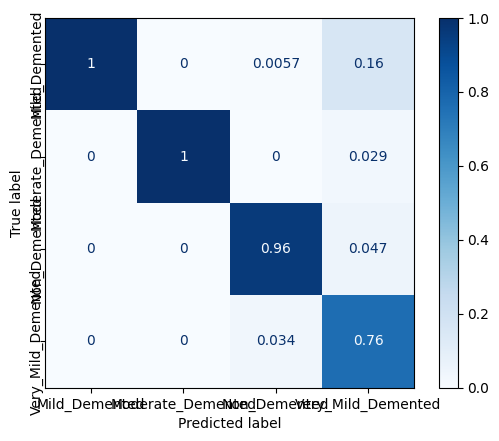

<Figure size 500x500 with 0 Axes>

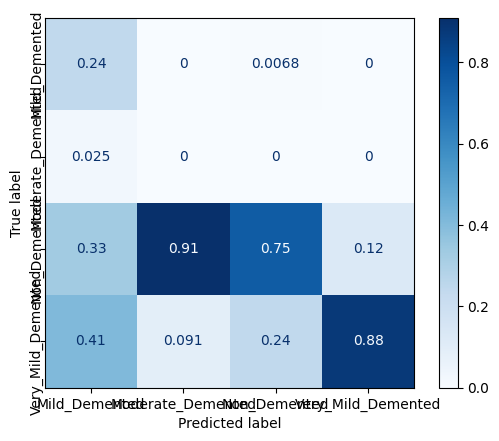

<Figure size 500x500 with 0 Axes>

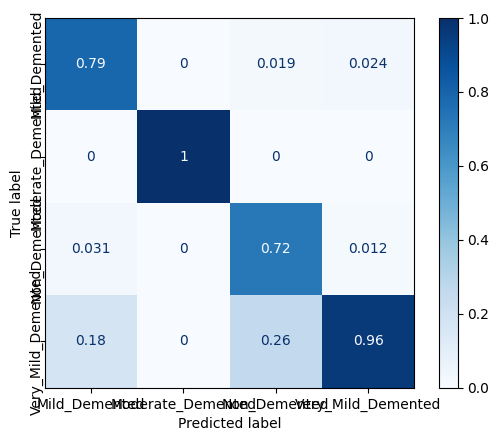

<Figure size 500x500 with 0 Axes>

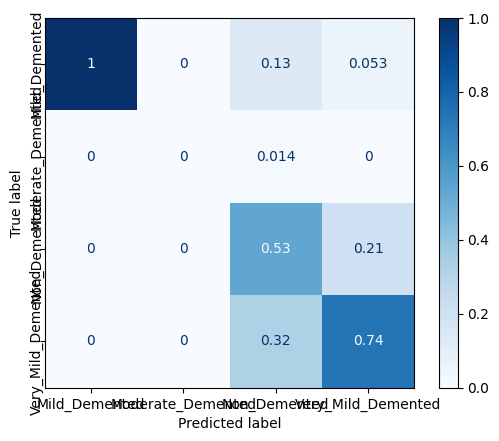

In [10]:
# experiments with Figshare
print('\nProcessing Alzihmers Dataset:')
print('--------------------------------')

train_ds, val_ds, test_ds, class_names = load(DATASET_DIR, IMAGE_SIZE, BATCH_SIZE, False)
experiments_with_dataset(train_ds, val_ds, test_ds, class_names)

In [ ]:
!zip -0 -r DenseNet201.zip ./*